### Cycle GAN
The **Cycle Generative Adversarial Network**, or **Cycle GAN**, is an approach to training a deep convolutional neural network for image-to-image translation tasks.

 **CycleGAN** is a type of **Generative Adversarial Network (GAN)** that can be used for **unpaired image-to-image translation** . It was introduced in 2017 by Jun-Yan Zhu et al. in their paper titled "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks" 

CycleGAN is a deep learning model that can learn the mapping between two different image domains, such as photographs and sketches, by training a GAN on a dataset ². The model can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples 

The key idea behind CycleGAN is to use **cycle consistency loss** to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain. This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc.




In [1]:
!pip install tensorflow-addons

## import libraries

In [2]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random
from tqdm import tqdm
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load images

In [3]:
#Resizing all the images to 64*64 pixels and storing in compressed Numpy array.
def load_images(path, size=(64, 64), max_images=None):
    data_list = []
    for filename in listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter for specific image file extensions
            pixels = load_img(path + filename, target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)

celeb_path = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'
cartoon_path = '../input/cartoonset10k/cartoonset10k/'

dataA = load_images(celeb_path, max_images=1000)
print('loaded dataA', dataA.shape)

dataB = load_images(cartoon_path, max_images=1000)
print('loaded dataB', dataB.shape)
filename = 'celebrity2cartoon.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)

print('Saved dataset:', filename)


loaded dataA (1000, 64, 64, 3)
loaded dataB (1000, 64, 64, 3)
Saved dataset: celebrity2cartoon.npz


## Plotting images of Celebrity and Cartoon

Loaded data: (1000, 64, 64, 3) (1000, 64, 64, 3)


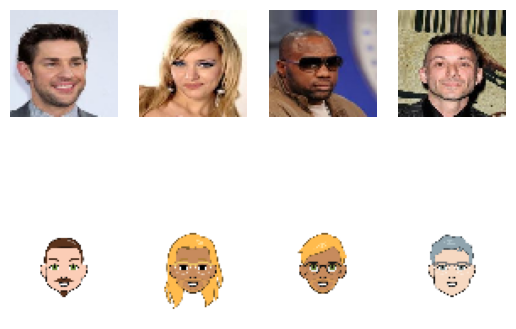

In [4]:
from numpy import load
data = load('celebrity2cartoon.npz')
daraA, dataB = data['dataA'], data['dataB']
print('Loaded data:', dataA.shape, dataB.shape)
n_samples = 4
# plot original image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+i )
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+n_samples+i )
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()


Unlike other models, the CycleGAN discriminator uses InstanceNormalization instead of BatchNormalization. It is a very simple type of normalization and involves standardizing (e.g. scaling to a standard Gaussian) the values on each output feature map, rather than across features in a batch, -1 because ensure that features are normalized per feature map.

## Defining discriminator model

The model takes 64*64 sized image as input and outputs a patch of predictions i.e. real (1) or fake (0) for generated images, optimized using Least squared loss (L2) and weighting it to used so that updates to model have half(0.5) the usual effect.

In [5]:
#define the discriminator model
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(input_image)
    x = LeakyReLU(alpha = 0.2)(x)
    #c128 
    x = Conv2D(128,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c256
    x = Conv2D(256,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c512
    x = Conv2D(512,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2D(512,(4,4) , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    out_put = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, use_bias=False)(x)

    model = Model(input_image, out_put)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])

    return model
    
image_shape = (64, 64, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 instance_normalization (Ins  (None, 16, 16, 128)      256       
 tanceNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                             

## Defining generator model

The generator is an encoder- decoder model, where model takes source image (e.g. celebrity photo) and generates a target image (e.g. cartoon photo) by first downsampling or encoding the input image down to a bottleneck layer, then interpreting the encoding with a number of ResNet layers that use skip connections by series of layers that upsample or decode the representation to the size of output image.

So Defining the ResNet block having two 3 X 3 filters and 1 X 1 stride where input to block is concatenated to output of block channel wise.

In [6]:
def resnet_block(filters, layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    #print(layer.shape)  # print the shape of the previous layer
    
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    
    # skip connection
    x = Concatenate()([x, layer])
    return x
    

In [7]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding ='same', kernel_initializer='he_normal', use_bias=False)(layer)
    x = InstanceNormalization(axis=-1)(x)    
    x = LeakyReLU()(x)
    return x

the model outputs pixel values with the shape as the input and pixel values are in the range [-1, 1], typical for GAN generator models.

In [8]:
# define the generator model
def define_generator(image_shape, n_resnet=9):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(7,7) , padding = 'same', kernel_initializer = init)(input_image)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c128 
    x = Conv2D(128,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c256
    x = Conv2D(256,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    
    for i in range(n_resnet):
        x = resnet_block(256 , x)
        
    # Add Conv2DTranspose layers to upscale the image to the desired shape
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    out_image = Activation('tanh')(x)

    model = Model(input_image, out_image)
    return model
image_shape = (64, 64, 3)
generator = define_generator(image_shape)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 64, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 instance_normalization_4 (Inst  (None, 64, 64, 64)  128         ['conv2d_6[0][0]']               
 anceNormalization)                                                                               
                                                                                                  
 activation (Activation)        (None, 64, 64, 64)   0           ['instance_normalization_4[

The generator models are trained via their related discriminator models. Specifically, they are updated to minimize the loss predicted by the discriminator for generated images marked as “real“, called adversarial loss. As such, they are encouraged to generate images that better fit into the target domain.

The generator models are also updated based on how effective they are at the regeneration of a source image when used with the other generator model, called cycle loss. Finally, a generator model is expected to output an image without translation when provided an example from the target domain, called identity loss.

Altogether, each generator model is optimized via the combination of four outputs with four loss functions:

- Adversarial loss (L2 or mean squared error).
- Identity loss (L1 or mean absolute error).
- Forward cycle loss (L1 or mean absolute error).
- Backward cycle loss (L1 or mean absolute error).
This is done in below function which takes input as generator models (g_model_1) and (g_model_2) and discriminator model (d_model) and we are mainly focus on updating first generator model hence other 2 inputs are kept false for trainable.

To summarize, a composite model has two inputs for the real photos from Domain-A and Domain-B, and four outputs for the discriminator output, identity generated image, forward cycle generated image, and backward cycle generated image.

## Defining Composite model

In [9]:
from keras.layers import Lambda, Reshape

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # Input for generated images
    input_gen = Input(shape=image_shape)
    
    # Resize generated images to the shape expected by the discriminator
    resized_gen = Lambda(lambda x: tf.image.resize(x, (64, 64), method=tf.image.ResizeMethod.BILINEAR))(input_gen)
    
    # Forward pass through the generator and discriminator
    gen_1_out = g_model_1(resized_gen)
    output_d = d_model(gen_1_out)
    
    # Input for identity mapping
    input_id = Input(shape=image_shape)
    
    # Forward pass for identity mapping
    output_id = g_model_1(input_id)
    
    # Forward and backward cycle loss
    output_f = g_model_2(gen_1_out)
    gen_2_out = g_model_2(input_id)
    output_b = g_model_1(gen_2_out)
    
    # Define the composite model
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    
    return model

Load our paired images dataset in compressed NumPy array format. This will return a list of two NumPy arrays: the first for source images and the second for corresponding target images.



## Load real samples

In [10]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['dataA'],data['dataB']
    X1 = (X1-127.5)/127.5 #for source image
    X2 = (X2-127.5)/127.5 # for corresponding target images
    return [X1,X2]

Each training iteration we will require a sample of real images from each domain as input to the discriminator and composite generator models. This can be achieved by selecting a random batch of samples.

In [11]:
import random

def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


A sample of generated images is required to update each discriminator model in each training iteration.

In [12]:
##select a batch of random samples,return images and target
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate a batch of random noise as input for the generator
    X = g_model.predict(dataset)
    
    # Create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape,patch_shape, 1))
    
    return X, y


In [13]:
#save the generator model to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' %(step +1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' %(step +1)
    g_model_BtoA.save(filename2)
    print('>saved:%s and %s' %(filename1,filename2))
    

So, as discriminator models are updated directly on real and generated images , to see how discriminator models learn a pool of fake images is there.

In [14]:
#update image pool for fake image
import random  # Import the random module

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # Use random.random() instead of random() here
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use the replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)  # This line should be outside the for loop
 


In [15]:
def show_image(image , title = None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [16]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(dataA))
        data = load('celebrity2cartoon.npz')
        celeb, cartoon = dataA[id], dataB[id]
        celeb_pred, cartoon_pred = g_BA.predict(tf.expand_dims(cartoon, axis=0))[0], g_AB.predict(tf.expand_dims(celeb, axis=0))[0]
        
        plt.figure(figsize=(10, 8))
        
        plt.subplot(1, 4, 1)
        show_image(celeb.astype('uint8'), title='Original celeb')
        
        plt.subplot(1, 4, 2)
        show_image(cartoon_pred, title='Generated celeb')
        
        plt.subplot(1, 4, 3)
        show_image(cartoon.astype('uint8'), title='Original cartoon')
        
        plt.subplot(1, 4, 4)
        show_image(celeb_pred, title='Generated cartoon')
        
        
        plt.show()

Now the training the models which takes all 6 models ( 2 discriminator , 2 generator and 2 composite models) as input with dataset for training.

Batch of real images from each domain is selected and then batch of fake images for each domain is generated. Generator A model (Cartoon to celebrity) is updated via composite model followed by Discriminator A model (Celebrity) i.e. Fix Discriminator and update Generator weight then fix Generator and update discriminator.

Similarly, Generator B (Celebrity to Cartoon) and discriminator B (Cartoon) models are updated .

## Train cyclegan model

In [17]:
# train cyclegan model
def train(dataset,d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,epochs=30, chunk=5):
    #define peroperties of the training run
    n_epochs, n_batch = epochs, 1
    #determine the output square shape of discriminator
    n_patch = d_model_A.output_shape[1]
    #unpack dataset
    trainA, trainB = dataset[0], dataset[1]
    #prepare image pool for fakes
    poolA, poolB = list(), list()
    #calcute the number of batches per training epoch
    batch_per_epoch = int(len(trainA)/n_batch)
    #calcute the number of training iteration
    n_steps = batch_per_epoch 
    #manually enumerate epochs
    for j in tqdm(range(epochs), desc='Epochs'):
        for i in tqdm(range(n_steps), desc='Batchs'):
            #select a batch of real sample
            X_realA, y_realA = generate_real_samples(trainA,n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB,n_batch, n_patch)
            
            #genarate a batch of fake sample
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)




            
            #update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)
            
            #update generator B->A via adversarial and cycle loss
            gen_loss2, _, _, _,_ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])


            # update discriminator for A->[real/fake]
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            #update generator A->B via adversarial and cycle loss
            gen_loss1, _, _, _,_ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
            
            # update discriminator for B->[real/fake]
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
            
            #summerize performance
            print('>%d, dA[%.3f ,%.3f ] dB[%.3f ,%.3f] g[%.3f ,%.3f]' %(i+1,dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2))

        if(j%chunk)==0:
            show_preds(g_model_AtoB,g_model_BtoA, n_images=1)
                #save the models
            g_model_AtoB.save('Generator_Celebrity_to_Cartoon.h5')
            g_model_BtoA.save('Generator_Cartoon_to_Celebrity.h5')
                


The loss is reported each training iteration, including the Discriminator-A loss on real and fake examples (dA), Discriminator-B loss on real and fake examples (dB), and Generator-AtoB and Generator-BtoA loss, each of which is a weighted average of adversarial, identity, forward, and backward cycle loss (g).

Loaded (1000, 64, 64, 3) (1000, 64, 64, 3)


Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step



Batchs:   0%|          | 1/1000 [01:16<21:12:48, 76.44s/it]

>1, dA[1.375 ,0.670 ] dB[0.661 ,0.614] g[24.336 ,24.218]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/1000 [01:17<8:49:38, 31.84s/it] 

>2, dA[3.413 ,0.657 ] dB[4.885 ,0.572] g[23.338 ,23.263]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 3/1000 [01:17<4:51:30, 17.54s/it]

>3, dA[0.597 ,1.363 ] dB[2.025 ,0.693] g[22.821 ,20.240]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 4/1000 [01:18<2:59:48, 10.83s/it]

>4, dA[0.759 ,1.674 ] dB[1.439 ,0.414] g[21.702 ,21.129]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [01:18<1:58:01,  7.12s/it]

>5, dA[1.147 ,1.761 ] dB[0.891 ,0.539] g[21.971 ,21.685]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 6/1000 [01:19<1:20:49,  4.88s/it]

>6, dA[0.655 ,3.434 ] dB[0.987 ,0.531] g[20.143 ,21.431]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 7/1000 [01:19<57:17,  3.46s/it]  

>7, dA[2.033 ,6.778 ] dB[4.195 ,0.993] g[20.322 ,24.926]
1/1 [==============================] - 0s 34ms/step



Batchs:   1%|          | 8/1000 [01:20<42:01,  2.54s/it]

>8, dA[0.726 ,4.076 ] dB[6.255 ,0.850] g[22.064 ,22.542]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 9/1000 [01:20<31:38,  1.92s/it]

>9, dA[0.671 ,1.338 ] dB[3.912 ,1.066] g[23.842 ,21.314]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 10/1000 [01:21<24:39,  1.49s/it]

>10, dA[2.502 ,1.583 ] dB[1.803 ,0.786] g[22.903 ,19.646]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [01:21<19:49,  1.20s/it]

>11, dA[0.818 ,1.788 ] dB[0.777 ,0.719] g[19.496 ,19.259]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 12/1000 [01:22<16:34,  1.01s/it]

>12, dA[0.848 ,1.016 ] dB[2.730 ,1.131] g[20.265 ,19.162]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [01:23<14:15,  1.15it/s]

>13, dA[1.646 ,0.366 ] dB[2.021 ,0.683] g[20.177 ,18.992]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|▏         | 14/1000 [01:23<12:36,  1.30it/s]

>14, dA[2.330 ,0.287 ] dB[0.629 ,0.735] g[17.868 ,17.789]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 15/1000 [01:24<11:23,  1.44it/s]

>15, dA[0.591 ,1.429 ] dB[0.548 ,1.282] g[21.596 ,22.715]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 16/1000 [01:24<10:32,  1.56it/s]

>16, dA[1.163 ,2.496 ] dB[1.126 ,0.441] g[17.630 ,21.114]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 17/1000 [01:25<10:00,  1.64it/s]

>17, dA[0.961 ,0.898 ] dB[1.145 ,1.015] g[20.830 ,19.944]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 18/1000 [01:25<09:35,  1.71it/s]

>18, dA[1.957 ,2.233 ] dB[0.406 ,1.475] g[22.906 ,21.849]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 19/1000 [01:26<09:16,  1.76it/s]

>19, dA[1.129 ,1.708 ] dB[0.970 ,0.622] g[19.297 ,20.505]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [01:26<09:03,  1.80it/s]

>20, dA[1.080 ,0.887 ] dB[1.334 ,1.833] g[20.413 ,17.534]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 21/1000 [01:27<08:54,  1.83it/s]

>21, dA[0.364 ,0.515 ] dB[0.675 ,0.970] g[19.403 ,16.638]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 22/1000 [01:27<08:49,  1.85it/s]

>22, dA[1.260 ,0.702 ] dB[0.564 ,0.379] g[17.744 ,17.689]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 23/1000 [01:28<08:46,  1.86it/s]

>23, dA[0.371 ,1.025 ] dB[0.672 ,0.509] g[17.343 ,16.673]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 24/1000 [01:28<08:41,  1.87it/s]

>24, dA[1.230 ,0.734 ] dB[0.380 ,1.485] g[21.233 ,17.891]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▎         | 25/1000 [01:29<08:40,  1.87it/s]

>25, dA[0.381 ,0.588 ] dB[0.724 ,0.899] g[18.609 ,16.756]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 26/1000 [01:29<08:39,  1.88it/s]

>26, dA[0.368 ,0.411 ] dB[0.602 ,0.492] g[16.092 ,15.282]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 27/1000 [01:30<08:37,  1.88it/s]

>27, dA[1.133 ,1.042 ] dB[0.133 ,0.374] g[16.264 ,17.257]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 28/1000 [01:30<08:35,  1.89it/s]

>28, dA[0.882 ,0.476 ] dB[0.158 ,1.077] g[20.322 ,17.525]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 29/1000 [01:31<08:35,  1.88it/s]

>29, dA[0.979 ,0.813 ] dB[0.880 ,0.540] g[17.996 ,16.969]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 30/1000 [01:32<08:34,  1.89it/s]

>30, dA[1.061 ,0.349 ] dB[0.771 ,0.499] g[20.519 ,19.738]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [01:32<08:32,  1.89it/s]

>31, dA[0.934 ,0.378 ] dB[0.460 ,0.953] g[18.418 ,15.633]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 32/1000 [01:33<08:30,  1.89it/s]

>32, dA[1.318 ,0.558 ] dB[0.695 ,1.171] g[19.428 ,17.469]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 33/1000 [01:33<08:31,  1.89it/s]

>33, dA[0.550 ,0.505 ] dB[0.614 ,0.684] g[17.484 ,16.007]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 34/1000 [01:34<08:36,  1.87it/s]

>34, dA[0.777 ,0.502 ] dB[0.359 ,0.528] g[15.330 ,15.105]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 35/1000 [01:34<08:41,  1.85it/s]

>35, dA[0.569 ,0.551 ] dB[0.193 ,1.023] g[16.885 ,15.148]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 36/1000 [01:35<08:45,  1.83it/s]

>36, dA[0.244 ,0.243 ] dB[0.320 ,0.317] g[18.601 ,16.719]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 37/1000 [01:35<08:43,  1.84it/s]

>37, dA[0.596 ,0.633 ] dB[0.298 ,0.512] g[15.135 ,15.642]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 38/1000 [01:36<08:39,  1.85it/s]

>38, dA[0.654 ,1.195 ] dB[0.136 ,0.225] g[14.370 ,16.094]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 39/1000 [01:36<08:35,  1.86it/s]

>39, dA[0.642 ,0.471 ] dB[0.258 ,0.257] g[15.073 ,14.166]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 40/1000 [01:37<08:33,  1.87it/s]

>40, dA[0.836 ,0.248 ] dB[0.091 ,0.345] g[16.400 ,15.781]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 41/1000 [01:37<08:32,  1.87it/s]

>41, dA[0.448 ,0.335 ] dB[0.159 ,0.711] g[17.499 ,14.974]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [01:38<08:32,  1.87it/s]

>42, dA[0.767 ,0.324 ] dB[0.290 ,0.293] g[16.891 ,15.626]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 43/1000 [01:39<08:28,  1.88it/s]

>43, dA[0.252 ,0.459 ] dB[0.115 ,0.260] g[17.689 ,18.107]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 44/1000 [01:39<08:27,  1.88it/s]

>44, dA[0.269 ,0.101 ] dB[0.049 ,0.534] g[16.613 ,14.682]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 45/1000 [01:40<08:32,  1.86it/s]

>45, dA[0.841 ,0.319 ] dB[0.229 ,0.231] g[14.940 ,14.959]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 46/1000 [01:40<08:31,  1.87it/s]

>46, dA[0.451 ,0.114 ] dB[0.120 ,0.149] g[15.214 ,15.548]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 47/1000 [01:41<08:28,  1.87it/s]

>47, dA[0.659 ,0.496 ] dB[0.346 ,0.184] g[16.375 ,14.311]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 48/1000 [01:41<08:27,  1.88it/s]

>48, dA[0.855 ,0.623 ] dB[0.216 ,0.391] g[18.920 ,18.729]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 49/1000 [01:42<08:28,  1.87it/s]

>49, dA[0.366 ,0.488 ] dB[0.164 ,0.114] g[14.282 ,13.509]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 50/1000 [01:42<08:27,  1.87it/s]

>50, dA[0.245 ,0.257 ] dB[0.307 ,0.143] g[13.960 ,13.066]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 51/1000 [01:43<08:26,  1.87it/s]

>51, dA[0.549 ,0.577 ] dB[0.285 ,3.730] g[15.564 ,14.767]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 52/1000 [01:43<08:24,  1.88it/s]

>52, dA[0.109 ,0.202 ] dB[0.488 ,0.157] g[15.604 ,13.337]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 53/1000 [01:44<08:25,  1.87it/s]

>53, dA[0.470 ,0.463 ] dB[0.063 ,0.643] g[15.603 ,13.594]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 54/1000 [01:44<08:24,  1.87it/s]

>54, dA[0.191 ,0.075 ] dB[0.221 ,0.278] g[17.617 ,16.386]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 55/1000 [01:45<08:23,  1.88it/s]

>55, dA[0.184 ,0.211 ] dB[0.111 ,0.140] g[14.644 ,13.718]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 56/1000 [01:45<08:22,  1.88it/s]

>56, dA[0.407 ,0.215 ] dB[0.188 ,2.786] g[14.612 ,13.557]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 57/1000 [01:46<08:22,  1.88it/s]

>57, dA[0.176 ,0.917 ] dB[0.396 ,0.527] g[14.910 ,13.862]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 58/1000 [01:47<08:21,  1.88it/s]

>58, dA[0.425 ,0.650 ] dB[0.095 ,0.449] g[14.894 ,13.522]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 59/1000 [01:47<08:21,  1.88it/s]

>59, dA[0.574 ,0.472 ] dB[0.252 ,0.114] g[13.802 ,13.834]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 60/1000 [01:48<08:20,  1.88it/s]

>60, dA[0.461 ,0.278 ] dB[0.094 ,0.243] g[16.086 ,17.469]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 61/1000 [01:48<08:23,  1.87it/s]

>61, dA[1.018 ,0.492 ] dB[0.140 ,0.301] g[15.740 ,14.539]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 62/1000 [01:49<08:20,  1.88it/s]

>62, dA[0.400 ,0.461 ] dB[0.156 ,0.154] g[16.676 ,16.657]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 63/1000 [01:49<08:19,  1.88it/s]

>63, dA[0.189 ,0.192 ] dB[0.056 ,0.099] g[17.137 ,15.543]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 64/1000 [01:50<08:18,  1.88it/s]

>64, dA[5.197 ,0.363 ] dB[0.116 ,0.248] g[14.764 ,14.133]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 65/1000 [01:50<08:20,  1.87it/s]

>65, dA[2.423 ,2.485 ] dB[0.114 ,0.464] g[15.086 ,17.391]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [01:51<08:18,  1.87it/s]

>66, dA[0.927 ,0.623 ] dB[0.242 ,0.226] g[19.798 ,21.347]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [01:51<08:18,  1.87it/s]

>67, dA[1.246 ,0.380 ] dB[0.047 ,0.840] g[16.749 ,17.450]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [01:52<08:17,  1.88it/s]

>68, dA[0.392 ,0.297 ] dB[0.141 ,0.172] g[14.624 ,15.110]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 69/1000 [01:52<08:18,  1.87it/s]

>69, dA[0.611 ,0.165 ] dB[0.049 ,0.157] g[16.200 ,14.788]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 70/1000 [01:53<08:17,  1.87it/s]

>70, dA[0.474 ,0.127 ] dB[0.126 ,1.036] g[14.688 ,13.868]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 71/1000 [01:53<08:16,  1.87it/s]

>71, dA[0.677 ,0.138 ] dB[0.463 ,0.348] g[16.247 ,14.370]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [01:54<08:14,  1.88it/s]

>72, dA[0.546 ,0.163 ] dB[0.164 ,0.180] g[14.385 ,13.529]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 73/1000 [01:55<08:15,  1.87it/s]

>73, dA[0.247 ,0.462 ] dB[0.091 ,0.197] g[14.297 ,13.913]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 74/1000 [01:55<08:16,  1.86it/s]

>74, dA[0.220 ,0.133 ] dB[0.095 ,0.232] g[16.188 ,14.726]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 75/1000 [01:56<08:15,  1.87it/s]

>75, dA[0.276 ,2.000 ] dB[0.131 ,0.148] g[12.301 ,11.328]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 76/1000 [01:56<08:14,  1.87it/s]

>76, dA[0.328 ,0.371 ] dB[0.117 ,0.059] g[15.664 ,15.520]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 77/1000 [01:57<08:15,  1.86it/s]

>77, dA[1.714 ,0.200 ] dB[0.069 ,0.177] g[17.644 ,17.810]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 78/1000 [01:57<08:17,  1.85it/s]

>78, dA[0.826 ,0.144 ] dB[0.044 ,0.057] g[16.959 ,16.196]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [01:58<08:17,  1.85it/s]

>79, dA[0.416 ,0.055 ] dB[0.024 ,0.030] g[15.886 ,13.512]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 80/1000 [01:58<08:15,  1.86it/s]

>80, dA[0.283 ,0.071 ] dB[0.078 ,0.107] g[14.572 ,14.978]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 81/1000 [01:59<08:17,  1.85it/s]

>81, dA[0.760 ,0.091 ] dB[0.052 ,0.973] g[13.538 ,12.348]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [01:59<08:22,  1.83it/s]

>82, dA[0.353 ,0.263 ] dB[0.154 ,0.242] g[14.193 ,13.496]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [02:00<08:19,  1.84it/s]

>83, dA[0.499 ,0.103 ] dB[0.164 ,0.075] g[12.000 ,10.509]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 84/1000 [02:00<08:16,  1.85it/s]

>84, dA[0.128 ,0.172 ] dB[0.080 ,0.560] g[14.567 ,14.405]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 85/1000 [02:01<08:14,  1.85it/s]

>85, dA[0.346 ,0.056 ] dB[0.124 ,0.151] g[12.963 ,12.341]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 86/1000 [02:02<08:15,  1.84it/s]

>86, dA[0.110 ,0.034 ] dB[0.027 ,0.068] g[15.769 ,14.834]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 87/1000 [02:02<08:14,  1.85it/s]

>87, dA[0.559 ,0.243 ] dB[0.104 ,0.073] g[13.860 ,12.623]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 88/1000 [02:03<08:11,  1.86it/s]

>88, dA[0.350 ,0.181 ] dB[0.079 ,0.046] g[14.584 ,13.247]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [02:03<08:12,  1.85it/s]

>89, dA[0.974 ,0.329 ] dB[0.040 ,0.238] g[15.960 ,14.523]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [02:04<08:11,  1.85it/s]

>90, dA[0.326 ,0.153 ] dB[0.048 ,0.409] g[13.484 ,13.296]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 91/1000 [02:04<08:10,  1.85it/s]

>91, dA[0.259 ,0.117 ] dB[0.185 ,0.393] g[16.449 ,15.502]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 92/1000 [02:05<08:08,  1.86it/s]

>92, dA[1.079 ,0.104 ] dB[0.047 ,0.119] g[13.269 ,12.641]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 93/1000 [02:05<08:45,  1.72it/s]

>93, dA[0.103 ,0.071 ] dB[0.107 ,0.044] g[15.777 ,15.327]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 94/1000 [02:06<08:42,  1.73it/s]

>94, dA[0.439 ,0.158 ] dB[0.045 ,0.075] g[14.844 ,13.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [02:07<08:38,  1.75it/s]

>95, dA[0.329 ,0.054 ] dB[0.036 ,0.135] g[16.139 ,13.934]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 96/1000 [02:07<08:27,  1.78it/s]

>96, dA[0.255 ,0.124 ] dB[0.013 ,0.054] g[14.823 ,12.880]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 97/1000 [02:08<08:24,  1.79it/s]

>97, dA[0.163 ,0.105 ] dB[0.145 ,0.264] g[13.767 ,13.098]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 98/1000 [02:08<08:18,  1.81it/s]

>98, dA[0.226 ,0.080 ] dB[0.060 ,0.111] g[14.685 ,13.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [02:09<08:14,  1.82it/s]

>99, dA[0.245 ,0.065 ] dB[0.030 ,1.585] g[17.197 ,13.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [02:09<08:11,  1.83it/s]

>100, dA[0.119 ,0.132 ] dB[0.164 ,0.342] g[12.297 ,11.274]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 101/1000 [02:10<08:16,  1.81it/s]

>101, dA[0.269 ,0.167 ] dB[0.096 ,0.217] g[13.000 ,12.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 102/1000 [02:10<08:13,  1.82it/s]

>102, dA[0.080 ,0.492 ] dB[0.090 ,0.033] g[14.080 ,11.897]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 103/1000 [02:11<08:09,  1.83it/s]

>103, dA[0.308 ,0.106 ] dB[0.032 ,0.025] g[13.576 ,13.189]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [02:11<08:05,  1.84it/s]

>104, dA[0.495 ,0.276 ] dB[0.021 ,0.100] g[15.019 ,14.251]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 105/1000 [02:12<08:06,  1.84it/s]

>105, dA[0.312 ,0.083 ] dB[0.110 ,0.041] g[14.296 ,12.033]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 106/1000 [02:13<08:05,  1.84it/s]

>106, dA[0.133 ,0.049 ] dB[0.051 ,0.103] g[13.040 ,12.159]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 107/1000 [02:13<08:04,  1.84it/s]

>107, dA[0.205 ,0.384 ] dB[0.067 ,0.015] g[14.938 ,12.909]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [02:14<08:03,  1.84it/s]

>108, dA[0.332 ,0.060 ] dB[0.209 ,0.104] g[12.367 ,11.688]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 109/1000 [02:14<08:04,  1.84it/s]

>109, dA[0.253 ,0.128 ] dB[0.011 ,0.113] g[13.786 ,12.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 110/1000 [02:15<08:03,  1.84it/s]

>110, dA[0.602 ,0.342 ] dB[0.066 ,0.013] g[15.034 ,13.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [02:15<08:02,  1.84it/s]

>111, dA[0.420 ,0.247 ] dB[0.039 ,0.057] g[13.296 ,12.397]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 112/1000 [02:16<07:59,  1.85it/s]

>112, dA[0.303 ,0.277 ] dB[0.038 ,0.019] g[14.344 ,12.876]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 113/1000 [02:16<08:01,  1.84it/s]

>113, dA[0.098 ,0.158 ] dB[0.011 ,0.036] g[16.224 ,15.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 114/1000 [02:17<08:00,  1.84it/s]

>114, dA[0.321 ,0.319 ] dB[0.009 ,0.047] g[13.073 ,11.581]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 115/1000 [02:17<08:00,  1.84it/s]

>115, dA[0.196 ,0.216 ] dB[0.004 ,0.465] g[13.072 ,12.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [02:18<07:59,  1.84it/s]

>116, dA[0.103 ,0.381 ] dB[0.135 ,0.247] g[12.354 ,10.786]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 117/1000 [02:19<07:59,  1.84it/s]

>117, dA[0.126 ,0.031 ] dB[0.028 ,0.018] g[13.744 ,12.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 118/1000 [02:19<07:58,  1.84it/s]

>118, dA[0.094 ,0.193 ] dB[0.092 ,0.030] g[12.378 ,10.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [02:20<08:00,  1.83it/s]

>119, dA[0.173 ,0.096 ] dB[0.089 ,0.061] g[11.138 ,10.315]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 120/1000 [02:20<08:02,  1.82it/s]

>120, dA[0.264 ,0.212 ] dB[0.072 ,0.263] g[12.361 ,11.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [02:21<08:03,  1.82it/s]

>121, dA[0.697 ,0.091 ] dB[0.087 ,0.046] g[14.422 ,13.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 122/1000 [02:21<08:00,  1.83it/s]

>122, dA[0.165 ,0.294 ] dB[0.082 ,0.092] g[13.228 ,12.639]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 123/1000 [02:22<07:58,  1.83it/s]

>123, dA[0.121 ,0.196 ] dB[0.031 ,0.047] g[13.568 ,12.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [02:22<07:57,  1.83it/s]

>124, dA[0.248 ,0.071 ] dB[0.021 ,0.024] g[12.974 ,11.756]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 125/1000 [02:23<07:57,  1.83it/s]

>125, dA[0.247 ,0.368 ] dB[0.038 ,0.038] g[14.463 ,13.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 126/1000 [02:23<07:56,  1.83it/s]

>126, dA[0.090 ,0.292 ] dB[0.019 ,0.021] g[14.930 ,12.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [02:24<07:55,  1.84it/s]

>127, dA[0.146 ,0.085 ] dB[0.037 ,0.070] g[13.298 ,12.527]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 128/1000 [02:25<07:53,  1.84it/s]

>128, dA[0.196 ,0.321 ] dB[0.089 ,0.152] g[13.204 ,12.668]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 129/1000 [02:25<07:55,  1.83it/s]

>129, dA[0.187 ,0.113 ] dB[0.067 ,0.079] g[13.889 ,13.117]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 130/1000 [02:26<07:56,  1.83it/s]

>130, dA[0.133 ,0.199 ] dB[0.012 ,0.039] g[13.816 ,13.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 131/1000 [02:26<07:54,  1.83it/s]

>131, dA[0.101 ,0.052 ] dB[0.014 ,0.047] g[13.789 ,12.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [02:27<07:53,  1.83it/s]

>132, dA[0.206 ,0.267 ] dB[0.025 ,0.031] g[14.298 ,12.712]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 133/1000 [02:27<07:53,  1.83it/s]

>133, dA[0.314 ,0.131 ] dB[0.019 ,0.014] g[14.370 ,12.657]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 134/1000 [02:28<07:52,  1.83it/s]

>134, dA[2.741 ,0.154 ] dB[0.023 ,0.070] g[15.182 ,12.694]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 135/1000 [02:28<07:52,  1.83it/s]

>135, dA[0.328 ,0.043 ] dB[0.025 ,0.024] g[14.163 ,12.649]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 136/1000 [02:29<07:51,  1.83it/s]

>136, dA[0.164 ,0.198 ] dB[0.062 ,0.048] g[12.997 ,10.831]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 137/1000 [02:29<07:52,  1.83it/s]

>137, dA[0.100 ,0.058 ] dB[0.015 ,0.117] g[12.737 ,12.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 138/1000 [02:30<07:53,  1.82it/s]

>138, dA[0.195 ,0.213 ] dB[0.109 ,0.051] g[13.373 ,12.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 139/1000 [02:31<07:52,  1.82it/s]

>139, dA[0.320 ,0.115 ] dB[0.104 ,0.038] g[15.340 ,12.943]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 140/1000 [02:31<07:51,  1.82it/s]

>140, dA[0.083 ,0.050 ] dB[0.024 ,0.034] g[13.384 ,11.224]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 141/1000 [02:32<07:51,  1.82it/s]

>141, dA[0.072 ,0.059 ] dB[0.091 ,0.057] g[14.323 ,13.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [02:32<07:51,  1.82it/s]

>142, dA[0.181 ,0.480 ] dB[0.075 ,0.064] g[11.652 ,10.630]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 143/1000 [02:33<07:50,  1.82it/s]

>143, dA[0.127 ,0.083 ] dB[0.026 ,0.029] g[11.159 ,10.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 144/1000 [02:33<07:47,  1.83it/s]

>144, dA[0.339 ,0.045 ] dB[0.043 ,0.042] g[11.825 ,11.362]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 145/1000 [02:34<07:48,  1.82it/s]

>145, dA[0.159 ,0.374 ] dB[0.044 ,0.036] g[13.537 ,12.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 146/1000 [02:34<07:48,  1.82it/s]

>146, dA[0.101 ,0.102 ] dB[0.087 ,0.173] g[10.621 ,9.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [02:35<07:47,  1.83it/s]

>147, dA[0.145 ,0.273 ] dB[0.083 ,0.182] g[11.817 ,10.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [02:36<07:46,  1.83it/s]

>148, dA[0.366 ,0.122 ] dB[0.050 ,0.134] g[13.873 ,11.464]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 149/1000 [02:36<07:46,  1.83it/s]

>149, dA[0.115 ,0.234 ] dB[0.020 ,0.094] g[11.466 ,10.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [02:37<07:45,  1.83it/s]

>150, dA[0.538 ,0.138 ] dB[0.046 ,0.040] g[14.841 ,13.703]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 151/1000 [02:37<07:51,  1.80it/s]

>151, dA[0.375 ,0.869 ] dB[0.061 ,0.061] g[14.050 ,13.671]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 152/1000 [02:38<07:54,  1.79it/s]

>152, dA[0.181 ,0.026 ] dB[0.074 ,0.875] g[14.798 ,12.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [02:38<07:55,  1.78it/s]

>153, dA[0.503 ,0.106 ] dB[0.096 ,0.132] g[14.059 ,12.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 154/1000 [02:39<07:51,  1.79it/s]

>154, dA[0.132 ,0.068 ] dB[0.125 ,0.330] g[12.827 ,11.126]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 155/1000 [02:39<07:50,  1.80it/s]

>155, dA[0.267 ,0.170 ] dB[0.093 ,0.124] g[14.272 ,12.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 156/1000 [02:40<07:47,  1.80it/s]

>156, dA[0.185 ,0.211 ] dB[0.074 ,0.072] g[15.551 ,14.130]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 157/1000 [02:41<07:47,  1.80it/s]

>157, dA[0.157 ,0.117 ] dB[0.071 ,0.510] g[14.676 ,13.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [02:41<07:45,  1.81it/s]

>158, dA[0.482 ,0.102 ] dB[0.096 ,0.131] g[13.486 ,14.267]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 159/1000 [02:42<07:43,  1.81it/s]

>159, dA[0.140 ,0.062 ] dB[0.147 ,0.071] g[13.098 ,12.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [02:42<07:43,  1.81it/s]

>160, dA[0.308 ,0.088 ] dB[0.157 ,1.099] g[12.121 ,11.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [02:43<07:43,  1.81it/s]

>161, dA[0.244 ,0.211 ] dB[0.112 ,0.150] g[13.825 ,13.076]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [02:43<07:43,  1.81it/s]

>162, dA[0.293 ,0.039 ] dB[0.059 ,0.025] g[13.952 ,12.578]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 163/1000 [02:44<07:41,  1.81it/s]

>163, dA[0.180 ,0.064 ] dB[0.107 ,0.023] g[14.395 ,12.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [02:44<07:41,  1.81it/s]

>164, dA[0.115 ,0.127 ] dB[0.076 ,0.236] g[13.198 ,11.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 165/1000 [02:45<07:41,  1.81it/s]

>165, dA[0.280 ,0.499 ] dB[0.075 ,0.097] g[15.243 ,14.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [02:45<07:41,  1.81it/s]

>166, dA[0.204 ,0.144 ] dB[0.071 ,0.079] g[13.917 ,13.534]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 167/1000 [02:46<07:41,  1.80it/s]

>167, dA[0.773 ,0.126 ] dB[0.031 ,0.046] g[13.612 ,12.020]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 168/1000 [02:47<07:39,  1.81it/s]

>168, dA[0.210 ,0.313 ] dB[0.112 ,0.037] g[11.692 ,11.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [02:47<07:39,  1.81it/s]

>169, dA[0.386 ,0.186 ] dB[0.016 ,0.100] g[11.716 ,10.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [02:48<07:39,  1.81it/s]

>170, dA[0.277 ,0.323 ] dB[0.037 ,0.228] g[14.363 ,12.865]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 171/1000 [02:48<07:37,  1.81it/s]

>171, dA[0.355 ,0.375 ] dB[0.028 ,0.046] g[14.485 ,12.080]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 172/1000 [02:49<07:36,  1.81it/s]

>172, dA[0.391 ,0.146 ] dB[0.136 ,0.180] g[13.565 ,11.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [02:49<07:38,  1.80it/s]

>173, dA[0.249 ,0.214 ] dB[0.082 ,0.096] g[11.746 ,10.757]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 174/1000 [02:50<07:40,  1.80it/s]

>174, dA[0.101 ,0.119 ] dB[0.041 ,0.027] g[12.685 ,10.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [02:50<07:38,  1.80it/s]

>175, dA[0.138 ,0.103 ] dB[0.038 ,0.034] g[15.160 ,13.794]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 176/1000 [02:51<07:38,  1.80it/s]

>176, dA[0.222 ,0.174 ] dB[0.043 ,0.019] g[12.061 ,10.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [02:52<07:37,  1.80it/s]

>177, dA[0.442 ,0.175 ] dB[0.016 ,0.052] g[14.527 ,13.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [02:52<07:36,  1.80it/s]

>178, dA[0.075 ,0.068 ] dB[0.047 ,0.055] g[13.349 ,11.500]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 179/1000 [02:53<07:34,  1.81it/s]

>179, dA[0.092 ,0.093 ] dB[0.014 ,0.056] g[13.409 ,11.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [02:53<07:35,  1.80it/s]

>180, dA[0.111 ,0.638 ] dB[0.073 ,0.083] g[14.646 ,12.677]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 181/1000 [02:54<07:35,  1.80it/s]

>181, dA[0.306 ,0.171 ] dB[0.031 ,3.440] g[15.756 ,15.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 182/1000 [02:54<07:35,  1.80it/s]

>182, dA[0.183 ,0.776 ] dB[0.181 ,0.122] g[11.681 ,13.569]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 183/1000 [02:55<07:33,  1.80it/s]

>183, dA[0.154 ,0.271 ] dB[0.083 ,0.245] g[13.974 ,13.548]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 184/1000 [02:55<07:37,  1.78it/s]

>184, dA[0.130 ,0.086 ] dB[0.074 ,0.083] g[12.887 ,11.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [02:56<07:39,  1.77it/s]

>185, dA[0.138 ,0.582 ] dB[0.042 ,0.025] g[13.564 ,11.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [02:57<07:36,  1.78it/s]

>186, dA[0.200 ,0.581 ] dB[0.042 ,0.203] g[13.154 ,10.892]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▊        | 187/1000 [02:57<07:34,  1.79it/s]

>187, dA[0.074 ,0.238 ] dB[0.156 ,0.043] g[12.816 ,10.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 188/1000 [02:58<07:33,  1.79it/s]

>188, dA[0.306 ,0.055 ] dB[0.054 ,0.007] g[13.534 ,12.640]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 189/1000 [02:58<07:33,  1.79it/s]

>189, dA[0.155 ,0.240 ] dB[0.022 ,0.075] g[11.782 ,10.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 190/1000 [02:59<07:31,  1.79it/s]

>190, dA[0.057 ,0.119 ] dB[0.033 ,0.055] g[14.885 ,12.680]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 191/1000 [02:59<07:33,  1.78it/s]

>191, dA[0.085 ,0.058 ] dB[0.029 ,0.028] g[13.014 ,11.133]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [03:00<07:31,  1.79it/s]

>192, dA[0.101 ,0.053 ] dB[0.016 ,0.017] g[13.470 ,11.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 193/1000 [03:01<07:31,  1.79it/s]

>193, dA[0.209 ,0.069 ] dB[0.021 ,0.052] g[16.779 ,15.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 194/1000 [03:01<07:30,  1.79it/s]

>194, dA[0.085 ,0.152 ] dB[0.158 ,0.213] g[10.946 ,9.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [03:02<07:29,  1.79it/s]

>195, dA[0.479 ,0.281 ] dB[0.070 ,0.048] g[14.340 ,12.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 196/1000 [03:02<07:27,  1.79it/s]

>196, dA[0.289 ,0.112 ] dB[0.025 ,0.273] g[11.809 ,10.661]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 197/1000 [03:03<07:28,  1.79it/s]

>197, dA[0.117 ,0.068 ] dB[0.035 ,0.059] g[12.938 ,13.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 198/1000 [03:03<07:28,  1.79it/s]

>198, dA[0.150 ,0.331 ] dB[0.022 ,0.147] g[11.703 ,10.694]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 199/1000 [03:04<07:27,  1.79it/s]

>199, dA[0.053 ,0.291 ] dB[0.053 ,0.101] g[14.339 ,12.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [03:04<07:26,  1.79it/s]

>200, dA[0.155 ,0.237 ] dB[0.017 ,0.104] g[11.742 ,10.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [03:05<07:27,  1.79it/s]

>201, dA[0.337 ,0.046 ] dB[0.073 ,0.173] g[10.503 ,9.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 202/1000 [03:06<07:27,  1.79it/s]

>202, dA[0.080 ,0.263 ] dB[0.018 ,0.106] g[14.432 ,11.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 203/1000 [03:06<07:26,  1.79it/s]

>203, dA[0.137 ,0.102 ] dB[0.063 ,0.021] g[13.722 ,11.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 204/1000 [03:07<07:25,  1.79it/s]

>204, dA[0.078 ,0.129 ] dB[0.012 ,0.075] g[15.726 ,15.344]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 205/1000 [03:07<07:25,  1.79it/s]

>205, dA[0.108 ,0.070 ] dB[0.053 ,0.053] g[13.514 ,12.638]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 206/1000 [03:08<07:25,  1.78it/s]

>206, dA[0.209 ,0.058 ] dB[0.026 ,0.045] g[13.765 ,12.466]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 207/1000 [03:08<07:24,  1.79it/s]

>207, dA[0.067 ,0.113 ] dB[0.009 ,0.071] g[15.157 ,14.702]
1/1 [==============================] - 0s 27ms/step



Batchs:  21%|██        | 208/1000 [03:09<07:29,  1.76it/s]

>208, dA[0.207 ,0.173 ] dB[0.067 ,0.015] g[14.055 ,12.061]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 209/1000 [03:10<07:30,  1.76it/s]

>209, dA[0.290 ,0.306 ] dB[0.041 ,0.101] g[13.624 ,11.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [03:10<07:28,  1.76it/s]

>210, dA[0.188 ,0.051 ] dB[0.026 ,0.165] g[12.431 ,12.252]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 211/1000 [03:11<07:24,  1.77it/s]

>211, dA[0.144 ,0.057 ] dB[0.011 ,0.017] g[12.755 ,11.318]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 212/1000 [03:11<07:23,  1.78it/s]

>212, dA[0.143 ,0.042 ] dB[0.072 ,0.011] g[12.031 ,9.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 213/1000 [03:12<07:24,  1.77it/s]

>213, dA[0.242 ,0.251 ] dB[0.023 ,0.015] g[15.650 ,14.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [03:12<07:23,  1.77it/s]

>214, dA[0.101 ,0.046 ] dB[0.011 ,0.028] g[15.062 ,13.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 215/1000 [03:13<07:20,  1.78it/s]

>215, dA[0.246 ,0.149 ] dB[0.015 ,0.059] g[13.201 ,11.649]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 216/1000 [03:13<07:19,  1.79it/s]

>216, dA[0.100 ,0.028 ] dB[0.029 ,0.015] g[12.248 ,10.020]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 217/1000 [03:14<07:20,  1.78it/s]

>217, dA[0.204 ,0.040 ] dB[0.053 ,0.018] g[13.819 ,12.700]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [03:15<07:19,  1.78it/s]

>218, dA[0.074 ,0.896 ] dB[0.023 ,0.217] g[11.049 ,9.962]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 219/1000 [03:15<07:18,  1.78it/s]

>219, dA[0.285 ,0.027 ] dB[0.119 ,0.098] g[13.408 ,11.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 220/1000 [03:16<07:18,  1.78it/s]

>220, dA[0.111 ,0.176 ] dB[0.172 ,0.049] g[11.993 ,10.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 221/1000 [03:16<07:23,  1.76it/s]

>221, dA[0.223 ,0.053 ] dB[0.015 ,0.187] g[11.971 ,10.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 222/1000 [03:17<07:21,  1.76it/s]

>222, dA[0.275 ,0.147 ] dB[0.103 ,0.125] g[13.419 ,11.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 223/1000 [03:17<07:20,  1.76it/s]

>223, dA[0.239 ,0.065 ] dB[0.293 ,0.055] g[12.071 ,9.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [03:18<07:19,  1.77it/s]

>224, dA[0.131 ,0.121 ] dB[0.062 ,0.141] g[12.512 ,10.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [03:19<07:20,  1.76it/s]

>225, dA[0.084 ,0.011 ] dB[0.022 ,0.047] g[16.233 ,14.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [03:19<07:18,  1.76it/s]

>226, dA[0.064 ,0.344 ] dB[0.019 ,0.056] g[13.156 ,10.148]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [03:20<07:18,  1.76it/s]

>227, dA[0.194 ,0.214 ] dB[0.112 ,0.053] g[12.682 ,10.661]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 228/1000 [03:20<07:16,  1.77it/s]

>228, dA[0.078 ,0.081 ] dB[0.090 ,0.205] g[12.486 ,11.433]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 229/1000 [03:21<07:45,  1.66it/s]

>229, dA[0.156 ,0.187 ] dB[0.040 ,0.043] g[13.831 ,12.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [03:22<07:36,  1.69it/s]

>230, dA[0.387 ,0.114 ] dB[0.025 ,0.923] g[15.060 ,11.657]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 231/1000 [03:22<07:29,  1.71it/s]

>231, dA[0.268 ,0.021 ] dB[0.276 ,0.205] g[15.554 ,13.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [03:23<07:24,  1.73it/s]

>232, dA[0.167 ,0.028 ] dB[0.069 ,0.182] g[12.548 ,13.534]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 233/1000 [03:23<07:22,  1.73it/s]

>233, dA[0.057 ,0.389 ] dB[0.075 ,0.076] g[10.249 ,9.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [03:24<07:19,  1.74it/s]

>234, dA[0.296 ,0.488 ] dB[0.105 ,0.089] g[12.856 ,11.297]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 235/1000 [03:24<07:17,  1.75it/s]

>235, dA[0.147 ,0.029 ] dB[0.095 ,0.103] g[12.771 ,9.694]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 236/1000 [03:25<07:14,  1.76it/s]

>236, dA[0.050 ,0.278 ] dB[0.039 ,0.054] g[11.808 ,9.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 237/1000 [03:25<07:14,  1.75it/s]

>237, dA[0.069 ,0.168 ] dB[0.024 ,0.032] g[13.659 ,11.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 238/1000 [03:26<07:13,  1.76it/s]

>238, dA[0.165 ,0.014 ] dB[0.049 ,0.032] g[11.920 ,9.584]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 239/1000 [03:27<07:12,  1.76it/s]

>239, dA[0.066 ,0.350 ] dB[0.029 ,0.014] g[11.980 ,9.947]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 240/1000 [03:27<07:11,  1.76it/s]

>240, dA[0.124 ,0.073 ] dB[0.022 ,0.078] g[14.142 ,13.596]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 241/1000 [03:28<07:11,  1.76it/s]

>241, dA[0.075 ,0.026 ] dB[0.016 ,0.014] g[13.049 ,10.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [03:28<07:10,  1.76it/s]

>242, dA[0.084 ,0.018 ] dB[0.143 ,0.028] g[10.850 ,9.239]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 243/1000 [03:29<07:09,  1.76it/s]

>243, dA[0.055 ,0.483 ] dB[0.044 ,0.125] g[12.571 ,11.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [03:29<07:08,  1.76it/s]

>244, dA[0.168 ,0.064 ] dB[0.016 ,0.032] g[11.970 ,10.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 245/1000 [03:30<07:10,  1.76it/s]

>245, dA[0.164 ,0.158 ] dB[0.095 ,0.035] g[12.983 ,11.386]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 246/1000 [03:31<07:09,  1.76it/s]

>246, dA[0.156 ,0.105 ] dB[0.117 ,0.080] g[9.944 ,8.233]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 247/1000 [03:31<07:07,  1.76it/s]

>247, dA[0.115 ,0.038 ] dB[0.010 ,0.106] g[10.585 ,9.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 248/1000 [03:32<07:06,  1.76it/s]

>248, dA[0.058 ,0.043 ] dB[0.024 ,0.167] g[13.875 ,10.913]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 249/1000 [03:32<07:06,  1.76it/s]

>249, dA[0.123 ,0.302 ] dB[0.069 ,0.049] g[11.581 ,9.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 250/1000 [03:33<07:05,  1.76it/s]

>250, dA[0.145 ,0.102 ] dB[0.023 ,0.014] g[13.500 ,11.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 251/1000 [03:33<07:04,  1.76it/s]

>251, dA[0.154 ,0.035 ] dB[0.055 ,0.055] g[13.928 ,13.926]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 252/1000 [03:34<07:03,  1.77it/s]

>252, dA[0.083 ,0.260 ] dB[0.082 ,0.194] g[9.519 ,8.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [03:35<07:04,  1.76it/s]

>253, dA[0.089 ,0.163 ] dB[0.030 ,0.640] g[11.785 ,9.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 254/1000 [03:35<07:04,  1.76it/s]

>254, dA[0.344 ,0.097 ] dB[0.054 ,0.088] g[14.858 ,11.867]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 255/1000 [03:36<07:02,  1.76it/s]

>255, dA[0.031 ,0.083 ] dB[0.021 ,0.212] g[11.019 ,9.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [03:36<07:02,  1.76it/s]

>256, dA[0.435 ,0.100 ] dB[0.040 ,0.068] g[15.205 ,13.756]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 257/1000 [03:37<07:02,  1.76it/s]

>257, dA[0.092 ,0.215 ] dB[0.084 ,0.087] g[12.729 ,11.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 258/1000 [03:37<07:01,  1.76it/s]

>258, dA[0.235 ,0.148 ] dB[0.033 ,2.848] g[14.074 ,13.582]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 259/1000 [03:38<07:00,  1.76it/s]

>259, dA[0.310 ,0.083 ] dB[0.230 ,0.566] g[13.361 ,12.064]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 260/1000 [03:39<06:59,  1.76it/s]

>260, dA[0.099 ,0.119 ] dB[0.028 ,0.118] g[13.877 ,11.567]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 261/1000 [03:39<07:00,  1.76it/s]

>261, dA[0.040 ,0.072 ] dB[0.090 ,0.035] g[12.812 ,10.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 262/1000 [03:40<06:59,  1.76it/s]

>262, dA[0.020 ,0.248 ] dB[0.085 ,0.040] g[13.356 ,12.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [03:40<06:59,  1.76it/s]

>263, dA[0.319 ,0.119 ] dB[0.051 ,0.074] g[11.241 ,10.068]
1/1 [==============================] - 0s 28ms/step



Batchs:  26%|██▋       | 264/1000 [03:41<07:02,  1.74it/s]

>264, dA[0.060 ,0.028 ] dB[0.036 ,0.127] g[12.377 ,11.086]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [03:41<07:01,  1.74it/s]

>265, dA[0.151 ,0.042 ] dB[0.142 ,0.062] g[10.500 ,8.916]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [03:42<06:59,  1.75it/s]

>266, dA[0.104 ,0.476 ] dB[0.057 ,0.041] g[13.161 ,10.940]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 267/1000 [03:43<06:57,  1.76it/s]

>267, dA[0.058 ,0.093 ] dB[0.089 ,0.038] g[13.566 ,12.461]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 268/1000 [03:43<06:54,  1.76it/s]

>268, dA[0.243 ,0.301 ] dB[0.036 ,0.075] g[11.860 ,10.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 269/1000 [03:44<06:54,  1.76it/s]

>269, dA[0.047 ,0.123 ] dB[0.070 ,0.132] g[13.686 ,12.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 270/1000 [03:44<06:53,  1.76it/s]

>270, dA[0.077 ,0.157 ] dB[0.043 ,0.122] g[14.510 ,12.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [03:45<06:52,  1.77it/s]

>271, dA[0.169 ,0.894 ] dB[0.076 ,0.107] g[13.042 ,11.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 272/1000 [03:45<06:51,  1.77it/s]

>272, dA[0.055 ,0.195 ] dB[0.058 ,0.176] g[11.742 ,11.246]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 273/1000 [03:46<06:50,  1.77it/s]

>273, dA[0.150 ,0.276 ] dB[0.136 ,0.077] g[12.446 ,10.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 274/1000 [03:46<06:50,  1.77it/s]

>274, dA[0.118 ,0.454 ] dB[0.046 ,0.136] g[12.217 ,10.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [03:47<06:50,  1.77it/s]

>275, dA[0.032 ,0.118 ] dB[0.058 ,0.017] g[12.804 ,11.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [03:48<06:49,  1.77it/s]

>276, dA[0.342 ,0.169 ] dB[0.021 ,0.028] g[13.481 ,12.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 277/1000 [03:48<06:49,  1.77it/s]

>277, dA[0.113 ,0.422 ] dB[0.026 ,0.073] g[10.918 ,9.420]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 278/1000 [03:49<06:47,  1.77it/s]

>278, dA[0.143 ,0.138 ] dB[0.015 ,0.033] g[12.216 ,9.860]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 279/1000 [03:49<06:45,  1.78it/s]

>279, dA[0.132 ,0.072 ] dB[0.013 ,0.019] g[12.338 ,10.177]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 280/1000 [03:50<06:48,  1.76it/s]

>280, dA[0.088 ,0.111 ] dB[0.062 ,0.220] g[10.817 ,9.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [03:50<06:49,  1.76it/s]

>281, dA[0.340 ,0.026 ] dB[0.059 ,0.093] g[13.763 ,11.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 282/1000 [03:51<06:47,  1.76it/s]

>282, dA[0.199 ,0.059 ] dB[0.057 ,0.040] g[12.488 ,11.130]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 283/1000 [03:52<06:44,  1.77it/s]

>283, dA[0.095 ,0.566 ] dB[0.027 ,0.048] g[11.732 ,9.673]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 284/1000 [03:52<06:43,  1.77it/s]

>284, dA[0.233 ,0.107 ] dB[0.027 ,0.033] g[13.695 ,10.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 285/1000 [03:53<06:43,  1.77it/s]

>285, dA[0.138 ,0.048 ] dB[0.043 ,0.048] g[12.335 ,10.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [03:53<06:41,  1.78it/s]

>286, dA[0.179 ,0.460 ] dB[0.021 ,0.045] g[12.679 ,10.938]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▊       | 287/1000 [03:54<06:40,  1.78it/s]

>287, dA[0.195 ,0.164 ] dB[0.045 ,0.019] g[14.629 ,13.670]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 288/1000 [03:54<06:39,  1.78it/s]

>288, dA[0.189 ,0.136 ] dB[0.077 ,0.080] g[12.921 ,11.603]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 289/1000 [03:55<06:39,  1.78it/s]

>289, dA[0.166 ,0.072 ] dB[0.024 ,0.102] g[10.917 ,9.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 290/1000 [03:56<06:39,  1.78it/s]

>290, dA[0.013 ,0.059 ] dB[0.011 ,0.078] g[13.895 ,12.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [03:56<06:37,  1.78it/s]

>291, dA[0.179 ,0.384 ] dB[0.013 ,0.124] g[12.616 ,11.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 292/1000 [03:57<06:36,  1.79it/s]

>292, dA[0.240 ,0.197 ] dB[0.025 ,0.103] g[13.009 ,11.304]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 293/1000 [03:57<06:36,  1.78it/s]

>293, dA[0.375 ,0.167 ] dB[0.020 ,0.052] g[11.940 ,10.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 294/1000 [03:58<06:36,  1.78it/s]

>294, dA[0.070 ,0.103 ] dB[0.028 ,0.009] g[12.787 ,11.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [03:58<06:35,  1.78it/s]

>295, dA[0.055 ,0.132 ] dB[0.016 ,0.212] g[11.824 ,10.285]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 296/1000 [03:59<06:33,  1.79it/s]

>296, dA[0.185 ,0.039 ] dB[0.050 ,0.085] g[12.112 ,11.316]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 297/1000 [03:59<06:35,  1.78it/s]

>297, dA[0.037 ,0.136 ] dB[0.126 ,0.100] g[9.551 ,8.178]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 298/1000 [04:00<06:34,  1.78it/s]

>298, dA[0.194 ,0.079 ] dB[0.042 ,0.130] g[12.854 ,12.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 299/1000 [04:01<06:32,  1.79it/s]

>299, dA[0.054 ,0.073 ] dB[0.022 ,0.017] g[14.288 ,12.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [04:01<06:30,  1.79it/s]

>300, dA[0.142 ,0.015 ] dB[0.032 ,0.108] g[14.144 ,12.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 301/1000 [04:02<06:31,  1.79it/s]

>301, dA[0.028 ,0.235 ] dB[0.124 ,0.163] g[12.792 ,12.657]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 302/1000 [04:02<06:30,  1.79it/s]

>302, dA[0.182 ,0.113 ] dB[0.021 ,0.048] g[12.345 ,11.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [04:03<06:29,  1.79it/s]

>303, dA[0.170 ,0.080 ] dB[0.012 ,0.055] g[11.687 ,10.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [04:03<06:28,  1.79it/s]

>304, dA[0.095 ,0.126 ] dB[0.026 ,0.048] g[14.574 ,13.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 305/1000 [04:04<06:28,  1.79it/s]

>305, dA[0.081 ,0.092 ] dB[0.059 ,0.029] g[14.043 ,12.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 306/1000 [04:04<06:28,  1.78it/s]

>306, dA[0.027 ,0.434 ] dB[0.037 ,0.042] g[13.111 ,10.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 307/1000 [04:05<06:27,  1.79it/s]

>307, dA[0.080 ,0.045 ] dB[0.009 ,0.239] g[14.140 ,13.770]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 308/1000 [04:06<06:25,  1.79it/s]

>308, dA[0.193 ,0.022 ] dB[0.021 ,0.081] g[13.063 ,10.857]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [04:06<06:25,  1.79it/s]

>309, dA[0.036 ,0.269 ] dB[0.071 ,0.029] g[11.623 ,9.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 310/1000 [04:07<06:24,  1.79it/s]

>310, dA[0.415 ,0.067 ] dB[0.024 ,0.062] g[10.903 ,9.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 311/1000 [04:07<06:23,  1.80it/s]

>311, dA[0.083 ,0.045 ] dB[0.030 ,0.045] g[13.176 ,12.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 312/1000 [04:08<06:23,  1.79it/s]

>312, dA[0.024 ,0.562 ] dB[0.007 ,0.055] g[13.470 ,11.377]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 313/1000 [04:08<06:23,  1.79it/s]

>313, dA[0.054 ,0.122 ] dB[0.008 ,0.043] g[14.284 ,13.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 314/1000 [04:09<06:23,  1.79it/s]

>314, dA[0.209 ,0.089 ] dB[0.045 ,0.035] g[14.988 ,14.010]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 315/1000 [04:09<06:22,  1.79it/s]

>315, dA[0.114 ,0.027 ] dB[0.020 ,0.021] g[12.042 ,9.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [04:10<06:21,  1.79it/s]

>316, dA[0.110 ,0.122 ] dB[0.026 ,0.009] g[12.045 ,10.071]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 317/1000 [04:11<06:21,  1.79it/s]

>317, dA[0.110 ,0.394 ] dB[0.062 ,0.037] g[10.928 ,10.121]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [04:11<06:20,  1.79it/s]

>318, dA[0.268 ,0.121 ] dB[0.023 ,0.035] g[11.344 ,10.598]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 319/1000 [04:12<06:20,  1.79it/s]

>319, dA[0.173 ,0.086 ] dB[0.010 ,0.029] g[11.732 ,10.681]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 320/1000 [04:12<06:24,  1.77it/s]

>320, dA[0.125 ,0.108 ] dB[0.024 ,0.070] g[13.001 ,11.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 321/1000 [04:13<06:23,  1.77it/s]

>321, dA[0.317 ,0.186 ] dB[0.007 ,0.063] g[13.537 ,11.602]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 322/1000 [04:13<06:22,  1.77it/s]

>322, dA[0.199 ,0.025 ] dB[0.023 ,0.029] g[13.504 ,11.474]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 323/1000 [04:14<06:19,  1.78it/s]

>323, dA[0.065 ,0.356 ] dB[0.029 ,0.067] g[12.395 ,10.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [04:15<06:18,  1.79it/s]

>324, dA[0.243 ,0.102 ] dB[0.056 ,0.106] g[13.445 ,11.812]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▎      | 325/1000 [04:15<06:18,  1.78it/s]

>325, dA[0.797 ,0.051 ] dB[0.092 ,0.115] g[13.554 ,12.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 326/1000 [04:16<06:17,  1.79it/s]

>326, dA[0.214 ,0.338 ] dB[0.043 ,0.046] g[14.656 ,13.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 327/1000 [04:16<06:18,  1.78it/s]

>327, dA[0.269 ,0.112 ] dB[0.008 ,0.026] g[12.769 ,11.310]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 328/1000 [04:17<06:19,  1.77it/s]

>328, dA[0.366 ,0.252 ] dB[0.008 ,0.014] g[12.993 ,11.507]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 329/1000 [04:17<06:20,  1.76it/s]

>329, dA[0.033 ,0.050 ] dB[0.007 ,0.070] g[11.194 ,10.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 330/1000 [04:18<06:18,  1.77it/s]

>330, dA[0.231 ,0.083 ] dB[0.010 ,0.036] g[11.739 ,10.178]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 331/1000 [04:18<06:16,  1.78it/s]

>331, dA[0.026 ,0.153 ] dB[0.014 ,0.017] g[13.087 ,11.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 332/1000 [04:19<06:15,  1.78it/s]

>332, dA[0.156 ,0.137 ] dB[0.005 ,0.034] g[12.237 ,9.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [04:20<06:17,  1.77it/s]

>333, dA[0.284 ,0.105 ] dB[0.029 ,0.167] g[11.568 ,10.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 334/1000 [04:20<06:15,  1.77it/s]

>334, dA[0.790 ,0.050 ] dB[0.081 ,0.009] g[12.708 ,10.674]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 335/1000 [04:21<06:13,  1.78it/s]

>335, dA[0.111 ,0.142 ] dB[0.394 ,0.055] g[11.854 ,11.166]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 336/1000 [04:21<06:13,  1.78it/s]

>336, dA[0.084 ,0.150 ] dB[0.036 ,0.159] g[10.808 ,10.385]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 337/1000 [04:22<06:14,  1.77it/s]

>337, dA[0.134 ,0.655 ] dB[0.039 ,0.058] g[13.288 ,11.107]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 338/1000 [04:22<06:14,  1.77it/s]

>338, dA[0.311 ,0.041 ] dB[0.040 ,0.108] g[13.307 ,11.950]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 339/1000 [04:23<06:11,  1.78it/s]

>339, dA[0.028 ,0.040 ] dB[0.028 ,0.031] g[13.089 ,12.312]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 340/1000 [04:24<06:10,  1.78it/s]

>340, dA[0.055 ,0.277 ] dB[0.020 ,0.107] g[11.588 ,10.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [04:24<06:10,  1.78it/s]

>341, dA[0.130 ,0.132 ] dB[0.055 ,0.014] g[13.368 ,10.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [04:25<06:10,  1.78it/s]

>342, dA[0.218 ,0.251 ] dB[0.082 ,0.027] g[12.607 ,10.958]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 343/1000 [04:25<06:09,  1.78it/s]

>343, dA[0.103 ,0.036 ] dB[0.012 ,0.019] g[11.484 ,10.948]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 344/1000 [04:26<06:07,  1.78it/s]

>344, dA[0.253 ,0.470 ] dB[0.028 ,0.068] g[11.451 ,10.502]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 345/1000 [04:26<06:07,  1.78it/s]

>345, dA[0.041 ,0.024 ] dB[0.035 ,0.063] g[11.067 ,9.160]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 346/1000 [04:27<06:06,  1.78it/s]

>346, dA[0.113 ,0.030 ] dB[0.024 ,0.050] g[11.035 ,10.092]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 347/1000 [04:27<06:05,  1.79it/s]

>347, dA[0.109 ,0.439 ] dB[0.008 ,0.014] g[12.204 ,9.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [04:28<06:05,  1.79it/s]

>348, dA[0.185 ,0.035 ] dB[0.009 ,0.042] g[10.045 ,8.600]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 349/1000 [04:29<06:04,  1.78it/s]

>349, dA[0.037 ,0.221 ] dB[0.006 ,0.041] g[12.178 ,9.850]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 350/1000 [04:29<06:04,  1.78it/s]

>350, dA[0.043 ,0.224 ] dB[0.024 ,0.008] g[12.622 ,10.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [04:30<06:04,  1.78it/s]

>351, dA[0.133 ,0.034 ] dB[0.002 ,0.051] g[13.080 ,12.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 352/1000 [04:30<06:02,  1.79it/s]

>352, dA[0.047 ,0.018 ] dB[0.016 ,0.039] g[13.769 ,11.598]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 353/1000 [04:31<06:03,  1.78it/s]

>353, dA[0.111 ,0.080 ] dB[0.004 ,0.024] g[12.231 ,10.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 354/1000 [04:31<06:01,  1.78it/s]

>354, dA[0.148 ,0.109 ] dB[0.055 ,0.047] g[14.799 ,13.636]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 355/1000 [04:32<06:01,  1.79it/s]

>355, dA[0.073 ,0.007 ] dB[0.020 ,0.031] g[13.478 ,12.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [04:33<06:00,  1.79it/s]

>356, dA[0.036 ,0.489 ] dB[0.013 ,0.144] g[12.520 ,11.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 357/1000 [04:33<05:59,  1.79it/s]

>357, dA[0.126 ,0.035 ] dB[0.044 ,0.030] g[14.004 ,13.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [04:34<05:58,  1.79it/s]

>358, dA[0.157 ,0.166 ] dB[0.053 ,0.061] g[12.854 ,10.853]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 359/1000 [04:34<05:58,  1.79it/s]

>359, dA[0.056 ,0.008 ] dB[0.005 ,0.008] g[11.384 ,9.811]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 360/1000 [04:35<05:57,  1.79it/s]

>360, dA[0.184 ,0.026 ] dB[0.014 ,0.138] g[10.784 ,9.863]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 361/1000 [04:35<05:57,  1.79it/s]

>361, dA[0.080 ,0.066 ] dB[0.033 ,0.027] g[13.383 ,11.961]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 362/1000 [04:36<05:57,  1.79it/s]

>362, dA[0.247 ,0.017 ] dB[0.019 ,0.053] g[14.922 ,11.826]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 363/1000 [04:36<05:56,  1.79it/s]

>363, dA[0.020 ,0.034 ] dB[0.094 ,0.100] g[11.402 ,9.937]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 364/1000 [04:37<05:55,  1.79it/s]

>364, dA[0.045 ,0.097 ] dB[0.031 ,0.081] g[12.594 ,10.452]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 365/1000 [04:38<05:56,  1.78it/s]

>365, dA[0.081 ,0.032 ] dB[0.021 ,0.021] g[11.556 ,9.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [04:38<05:57,  1.77it/s]

>366, dA[0.065 ,0.010 ] dB[0.094 ,0.109] g[11.288 ,10.221]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 367/1000 [04:39<05:55,  1.78it/s]

>367, dA[0.020 ,0.453 ] dB[0.037 ,0.088] g[11.228 ,9.779]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 368/1000 [04:39<05:54,  1.78it/s]

>368, dA[0.202 ,0.088 ] dB[0.020 ,0.038] g[12.132 ,10.610]
1/1 [==============================] - 0s 27ms/step



Batchs:  37%|███▋      | 369/1000 [04:40<05:57,  1.76it/s]

>369, dA[0.022 ,0.377 ] dB[0.028 ,0.050] g[13.758 ,13.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [04:40<05:56,  1.77it/s]

>370, dA[0.125 ,0.027 ] dB[0.150 ,0.025] g[13.536 ,12.958]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 371/1000 [04:41<05:54,  1.77it/s]

>371, dA[0.109 ,0.026 ] dB[0.019 ,0.030] g[12.838 ,11.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 372/1000 [04:42<05:53,  1.78it/s]

>372, dA[0.177 ,0.591 ] dB[0.012 ,0.008] g[13.574 ,10.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [04:42<05:52,  1.78it/s]

>373, dA[0.018 ,0.026 ] dB[0.048 ,0.118] g[10.960 ,9.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [04:43<05:51,  1.78it/s]

>374, dA[0.162 ,0.052 ] dB[0.042 ,0.016] g[11.200 ,9.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 375/1000 [04:43<05:50,  1.78it/s]

>375, dA[0.058 ,0.011 ] dB[0.012 ,0.016] g[15.012 ,13.636]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 376/1000 [04:44<05:52,  1.77it/s]

>376, dA[0.045 ,0.012 ] dB[0.007 ,0.084] g[12.737 ,11.233]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [04:44<05:55,  1.75it/s]

>377, dA[0.033 ,0.026 ] dB[0.025 ,0.013] g[12.267 ,10.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 378/1000 [04:45<05:53,  1.76it/s]

>378, dA[0.059 ,0.139 ] dB[0.023 ,0.047] g[13.977 ,12.706]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 379/1000 [04:45<05:50,  1.77it/s]

>379, dA[0.048 ,0.403 ] dB[0.022 ,0.037] g[12.358 ,10.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [04:46<05:49,  1.78it/s]

>380, dA[0.538 ,0.131 ] dB[0.011 ,0.099] g[12.117 ,10.702]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 381/1000 [04:47<05:49,  1.77it/s]

>381, dA[0.135 ,0.160 ] dB[0.019 ,0.035] g[11.785 ,10.726]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 382/1000 [04:47<05:48,  1.77it/s]

>382, dA[0.259 ,0.124 ] dB[0.051 ,0.147] g[11.531 ,11.220]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 383/1000 [04:48<05:47,  1.78it/s]

>383, dA[0.020 ,0.179 ] dB[0.006 ,0.020] g[12.173 ,10.741]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 384/1000 [04:48<05:46,  1.78it/s]

>384, dA[0.290 ,0.078 ] dB[0.113 ,0.103] g[10.452 ,9.446]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 385/1000 [04:49<05:45,  1.78it/s]

>385, dA[0.012 ,0.935 ] dB[0.006 ,0.006] g[11.546 ,9.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 386/1000 [04:49<05:46,  1.77it/s]

>386, dA[0.252 ,0.052 ] dB[0.029 ,0.029] g[12.581 ,11.100]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▊      | 387/1000 [04:50<05:45,  1.77it/s]

>387, dA[0.149 ,0.419 ] dB[0.046 ,0.143] g[9.343 ,8.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [04:51<05:44,  1.77it/s]

>388, dA[0.083 ,0.167 ] dB[0.032 ,0.121] g[11.130 ,10.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [04:51<05:45,  1.77it/s]

>389, dA[0.134 ,0.063 ] dB[0.052 ,0.034] g[11.799 ,9.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [04:52<05:44,  1.77it/s]

>390, dA[0.347 ,0.068 ] dB[0.048 ,0.042] g[11.404 ,10.641]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 391/1000 [04:52<05:42,  1.78it/s]

>391, dA[0.096 ,0.521 ] dB[0.005 ,0.023] g[10.757 ,9.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 392/1000 [04:53<05:41,  1.78it/s]

>392, dA[0.131 ,0.119 ] dB[0.023 ,0.021] g[11.566 ,9.490]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 393/1000 [04:53<05:41,  1.78it/s]

>393, dA[0.382 ,0.129 ] dB[0.019 ,0.010] g[12.281 ,11.008]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 394/1000 [04:54<05:40,  1.78it/s]

>394, dA[0.085 ,0.128 ] dB[0.007 ,0.080] g[12.432 ,10.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [04:54<05:40,  1.78it/s]

>395, dA[0.199 ,0.312 ] dB[0.014 ,0.029] g[12.126 ,10.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 396/1000 [04:55<05:39,  1.78it/s]

>396, dA[0.074 ,0.125 ] dB[0.024 ,0.022] g[13.183 ,11.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [04:56<05:40,  1.77it/s]

>397, dA[0.099 ,0.011 ] dB[0.033 ,0.046] g[12.267 ,11.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 398/1000 [04:56<05:38,  1.78it/s]

>398, dA[0.052 ,0.025 ] dB[0.034 ,0.021] g[13.435 ,11.179]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 399/1000 [04:57<05:37,  1.78it/s]

>399, dA[0.070 ,0.144 ] dB[0.011 ,0.020] g[13.148 ,10.659]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 400/1000 [04:57<05:36,  1.78it/s]

>400, dA[0.324 ,0.373 ] dB[0.014 ,0.022] g[11.363 ,9.379]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 401/1000 [04:58<05:37,  1.78it/s]

>401, dA[0.319 ,0.158 ] dB[0.025 ,0.027] g[12.726 ,12.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 402/1000 [04:58<05:36,  1.78it/s]

>402, dA[0.298 ,0.165 ] dB[0.006 ,0.015] g[11.019 ,9.863]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 403/1000 [04:59<05:35,  1.78it/s]

>403, dA[0.157 ,0.118 ] dB[0.007 ,0.085] g[11.980 ,11.217]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [05:00<05:34,  1.78it/s]

>404, dA[0.021 ,0.213 ] dB[0.006 ,0.166] g[12.375 ,10.884]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 405/1000 [05:00<05:34,  1.78it/s]

>405, dA[0.221 ,0.064 ] dB[0.136 ,0.263] g[10.191 ,8.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 406/1000 [05:01<05:33,  1.78it/s]

>406, dA[0.092 ,0.130 ] dB[0.020 ,0.121] g[12.880 ,11.807]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 407/1000 [05:01<05:32,  1.79it/s]

>407, dA[0.102 ,0.082 ] dB[0.130 ,0.148] g[12.938 ,11.247]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [05:02<05:31,  1.79it/s]

>408, dA[0.051 ,0.045 ] dB[0.055 ,0.045] g[11.111 ,10.552]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 409/1000 [05:02<05:32,  1.78it/s]

>409, dA[0.033 ,0.432 ] dB[0.076 ,0.173] g[12.764 ,11.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [05:03<05:31,  1.78it/s]

>410, dA[0.039 ,0.042 ] dB[0.107 ,0.068] g[11.691 ,10.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 411/1000 [05:03<05:30,  1.78it/s]

>411, dA[0.128 ,0.026 ] dB[0.050 ,0.057] g[13.592 ,13.858]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 412/1000 [05:04<05:29,  1.79it/s]

>412, dA[0.071 ,0.055 ] dB[0.036 ,0.030] g[10.111 ,9.806]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████▏     | 413/1000 [05:05<05:29,  1.78it/s]

>413, dA[0.021 ,0.171 ] dB[0.054 ,0.011] g[12.603 ,11.002]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████▏     | 414/1000 [05:05<05:28,  1.78it/s]

>414, dA[0.398 ,0.410 ] dB[0.003 ,0.036] g[12.511 ,10.548]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 415/1000 [05:06<05:27,  1.79it/s]

>415, dA[0.098 ,0.154 ] dB[0.202 ,0.019] g[11.127 ,9.906]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 416/1000 [05:06<05:26,  1.79it/s]

>416, dA[0.267 ,0.040 ] dB[0.039 ,0.157] g[11.531 ,10.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [05:07<05:26,  1.78it/s]

>417, dA[0.185 ,0.033 ] dB[0.122 ,0.082] g[10.313 ,8.889]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 418/1000 [05:07<05:26,  1.78it/s]

>418, dA[0.047 ,0.066 ] dB[0.041 ,0.226] g[12.401 ,10.596]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 419/1000 [05:08<05:27,  1.78it/s]

>419, dA[0.013 ,0.048 ] dB[0.065 ,0.167] g[12.941 ,11.818]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 420/1000 [05:08<05:25,  1.78it/s]

>420, dA[0.051 ,0.449 ] dB[0.060 ,0.016] g[12.051 ,9.844]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 421/1000 [05:09<05:24,  1.78it/s]

>421, dA[0.077 ,0.085 ] dB[0.029 ,0.051] g[13.527 ,12.097]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 422/1000 [05:10<05:25,  1.78it/s]

>422, dA[0.256 ,0.118 ] dB[0.018 ,0.042] g[11.218 ,10.068]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 423/1000 [05:10<05:23,  1.78it/s]

>423, dA[0.030 ,0.012 ] dB[0.021 ,0.012] g[15.336 ,14.472]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 424/1000 [05:11<05:22,  1.79it/s]

>424, dA[0.055 ,0.178 ] dB[0.018 ,0.012] g[11.168 ,9.855]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▎     | 425/1000 [05:11<05:22,  1.78it/s]

>425, dA[0.128 ,0.095 ] dB[0.008 ,0.055] g[12.973 ,11.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 426/1000 [05:12<05:22,  1.78it/s]

>426, dA[0.218 ,0.586 ] dB[0.023 ,0.023] g[13.772 ,13.237]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 427/1000 [05:12<05:21,  1.78it/s]

>427, dA[0.045 ,0.036 ] dB[0.009 ,0.100] g[11.837 ,9.911]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 428/1000 [05:13<05:19,  1.79it/s]

>428, dA[0.289 ,0.027 ] dB[0.129 ,0.020] g[12.743 ,10.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [05:14<05:20,  1.78it/s]

>429, dA[0.108 ,0.505 ] dB[0.029 ,0.029] g[12.345 ,10.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 430/1000 [05:14<05:19,  1.78it/s]

>430, dA[0.028 ,0.057 ] dB[0.006 ,0.029] g[12.066 ,11.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [05:15<05:19,  1.78it/s]

>431, dA[0.165 ,0.039 ] dB[0.027 ,0.055] g[10.894 ,10.042]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 432/1000 [05:15<05:20,  1.77it/s]

>432, dA[0.185 ,0.273 ] dB[0.009 ,0.017] g[11.009 ,9.397]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 433/1000 [05:16<05:23,  1.75it/s]

>433, dA[0.187 ,0.205 ] dB[0.014 ,0.051] g[10.823 ,9.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 434/1000 [05:16<05:21,  1.76it/s]

>434, dA[0.111 ,0.126 ] dB[0.013 ,0.047] g[14.030 ,13.608]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 435/1000 [05:17<05:19,  1.77it/s]

>435, dA[0.042 ,0.133 ] dB[0.025 ,0.101] g[12.679 ,9.540]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 436/1000 [05:18<05:17,  1.77it/s]

>436, dA[0.064 ,0.081 ] dB[0.015 ,0.014] g[14.483 ,13.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 437/1000 [05:18<05:17,  1.77it/s]

>437, dA[0.049 ,0.018 ] dB[0.053 ,0.028] g[13.558 ,12.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 438/1000 [05:19<05:15,  1.78it/s]

>438, dA[0.041 ,0.270 ] dB[0.054 ,0.035] g[11.815 ,10.294]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 439/1000 [05:19<05:14,  1.78it/s]

>439, dA[0.141 ,0.043 ] dB[0.031 ,0.013] g[11.512 ,9.854]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 440/1000 [05:20<05:13,  1.78it/s]

>440, dA[0.070 ,0.296 ] dB[0.028 ,0.050] g[10.359 ,9.358]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 441/1000 [05:20<05:13,  1.78it/s]

>441, dA[0.224 ,0.044 ] dB[0.022 ,0.012] g[11.858 ,11.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [05:21<05:12,  1.79it/s]

>442, dA[0.069 ,0.333 ] dB[0.098 ,0.129] g[11.337 ,9.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 443/1000 [05:21<05:11,  1.79it/s]

>443, dA[0.104 ,0.233 ] dB[0.020 ,0.032] g[11.927 ,10.599]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 444/1000 [05:22<05:10,  1.79it/s]

>444, dA[0.096 ,0.591 ] dB[0.037 ,0.012] g[12.436 ,9.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 445/1000 [05:23<05:12,  1.78it/s]

>445, dA[0.139 ,0.164 ] dB[0.163 ,0.079] g[11.650 ,10.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 446/1000 [05:23<05:11,  1.78it/s]

>446, dA[0.144 ,0.153 ] dB[0.069 ,0.185] g[11.633 ,10.241]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 447/1000 [05:24<05:10,  1.78it/s]

>447, dA[0.206 ,0.049 ] dB[0.041 ,0.099] g[12.896 ,11.328]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 448/1000 [05:24<05:09,  1.78it/s]

>448, dA[0.091 ,0.094 ] dB[0.066 ,0.041] g[11.603 ,9.896]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 449/1000 [05:25<05:09,  1.78it/s]

>449, dA[0.106 ,0.226 ] dB[0.010 ,0.033] g[12.267 ,9.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 450/1000 [05:25<05:07,  1.79it/s]

>450, dA[0.077 ,0.072 ] dB[0.018 ,0.106] g[12.231 ,11.803]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 451/1000 [05:26<05:07,  1.79it/s]

>451, dA[0.075 ,0.117 ] dB[0.013 ,0.011] g[11.433 ,9.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 452/1000 [05:26<05:06,  1.79it/s]

>452, dA[0.181 ,0.026 ] dB[0.086 ,0.019] g[9.883 ,8.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 453/1000 [05:27<05:06,  1.78it/s]

>453, dA[0.105 ,0.193 ] dB[0.022 ,0.062] g[11.780 ,11.244]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 454/1000 [05:28<05:06,  1.78it/s]

>454, dA[0.074 ,0.177 ] dB[0.040 ,0.019] g[9.959 ,8.428]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 455/1000 [05:28<05:05,  1.78it/s]

>455, dA[0.056 ,0.653 ] dB[0.017 ,0.038] g[12.988 ,10.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 456/1000 [05:29<05:04,  1.79it/s]

>456, dA[0.060 ,0.031 ] dB[0.010 ,0.039] g[12.170 ,10.136]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 457/1000 [05:29<05:03,  1.79it/s]

>457, dA[0.014 ,0.038 ] dB[0.008 ,0.087] g[12.292 ,12.027]
1/1 [==============================] - 0s 26ms/step



Batchs:  46%|████▌     | 458/1000 [05:30<05:07,  1.76it/s]

>458, dA[0.152 ,0.108 ] dB[0.040 ,0.146] g[10.655 ,9.439]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 459/1000 [05:30<05:05,  1.77it/s]

>459, dA[0.019 ,0.159 ] dB[0.060 ,0.162] g[12.184 ,10.623]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 460/1000 [05:31<05:03,  1.78it/s]

>460, dA[0.029 ,0.012 ] dB[0.014 ,0.103] g[13.063 ,12.194]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 461/1000 [05:32<05:02,  1.78it/s]

>461, dA[0.386 ,0.269 ] dB[0.034 ,0.028] g[12.010 ,10.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 462/1000 [05:32<05:02,  1.78it/s]

>462, dA[0.197 ,0.187 ] dB[0.070 ,0.054] g[10.542 ,9.087]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 463/1000 [05:33<05:01,  1.78it/s]

>463, dA[0.080 ,0.039 ] dB[0.006 ,0.054] g[11.107 ,10.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 464/1000 [05:33<05:00,  1.79it/s]

>464, dA[0.025 ,0.163 ] dB[0.010 ,0.025] g[12.518 ,11.461]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 465/1000 [05:34<04:59,  1.79it/s]

>465, dA[0.106 ,0.060 ] dB[0.009 ,0.012] g[12.569 ,10.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 466/1000 [05:34<04:59,  1.79it/s]

>466, dA[0.127 ,0.039 ] dB[0.015 ,0.025] g[10.530 ,9.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [05:35<04:57,  1.79it/s]

>467, dA[0.108 ,0.038 ] dB[0.013 ,0.057] g[13.115 ,11.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 468/1000 [05:35<04:57,  1.79it/s]

>468, dA[0.031 ,0.063 ] dB[0.034 ,0.068] g[13.953 ,14.141]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 469/1000 [05:36<04:57,  1.79it/s]

>469, dA[0.034 ,0.294 ] dB[0.046 ,0.030] g[14.429 ,13.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 470/1000 [05:37<04:56,  1.79it/s]

>470, dA[0.280 ,0.118 ] dB[0.023 ,0.036] g[11.560 ,10.415]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 471/1000 [05:37<04:56,  1.78it/s]

>471, dA[0.061 ,0.074 ] dB[0.014 ,0.023] g[11.524 ,9.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 472/1000 [05:38<04:58,  1.77it/s]

>472, dA[0.116 ,0.235 ] dB[0.023 ,0.025] g[10.967 ,9.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 473/1000 [05:38<04:57,  1.77it/s]

>473, dA[0.121 ,0.205 ] dB[0.038 ,0.222] g[10.184 ,8.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 474/1000 [05:39<04:56,  1.78it/s]

>474, dA[0.060 ,0.335 ] dB[0.021 ,0.086] g[11.784 ,10.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 475/1000 [05:39<04:56,  1.77it/s]

>475, dA[0.372 ,0.259 ] dB[0.029 ,0.027] g[12.569 ,10.757]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 476/1000 [05:40<04:54,  1.78it/s]

>476, dA[0.151 ,0.106 ] dB[0.029 ,0.018] g[11.825 ,9.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [05:41<04:54,  1.77it/s]

>477, dA[0.236 ,0.074 ] dB[0.010 ,0.151] g[11.753 ,9.960]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 478/1000 [05:41<04:53,  1.78it/s]

>478, dA[0.033 ,0.032 ] dB[0.016 ,0.072] g[10.885 ,10.645]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 479/1000 [05:42<04:52,  1.78it/s]

>479, dA[0.078 ,0.030 ] dB[0.033 ,0.034] g[11.028 ,9.309]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 480/1000 [05:42<04:51,  1.78it/s]

>480, dA[0.029 ,0.830 ] dB[0.035 ,0.023] g[11.067 ,8.994]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 481/1000 [05:43<04:51,  1.78it/s]

>481, dA[0.193 ,0.114 ] dB[0.019 ,0.017] g[11.493 ,9.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 482/1000 [05:43<04:50,  1.78it/s]

>482, dA[0.087 ,0.032 ] dB[0.109 ,0.045] g[11.783 ,12.008]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 483/1000 [05:44<04:49,  1.79it/s]

>483, dA[0.232 ,0.045 ] dB[0.025 ,0.022] g[11.382 ,10.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [05:44<04:48,  1.79it/s]

>484, dA[0.024 ,0.314 ] dB[0.021 ,0.050] g[15.231 ,14.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 485/1000 [05:45<04:48,  1.78it/s]

>485, dA[0.269 ,0.045 ] dB[0.131 ,0.044] g[11.299 ,9.304]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 486/1000 [05:46<04:48,  1.78it/s]

>486, dA[0.243 ,0.086 ] dB[0.010 ,0.010] g[14.193 ,12.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [05:46<04:47,  1.79it/s]

>487, dA[0.029 ,0.174 ] dB[0.008 ,0.024] g[10.993 ,9.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 488/1000 [05:47<04:47,  1.78it/s]

>488, dA[0.171 ,0.063 ] dB[0.069 ,0.017] g[10.505 ,9.446]
1/1 [==============================] - 0s 26ms/step



Batchs:  49%|████▉     | 489/1000 [05:47<04:50,  1.76it/s]

>489, dA[0.098 ,0.113 ] dB[0.049 ,0.071] g[11.114 ,9.666]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 490/1000 [05:48<04:51,  1.75it/s]

>490, dA[0.048 ,0.104 ] dB[0.034 ,0.073] g[12.502 ,10.431]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 491/1000 [05:48<04:48,  1.76it/s]

>491, dA[0.346 ,0.115 ] dB[0.091 ,0.033] g[10.674 ,8.793]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 492/1000 [05:49<04:45,  1.78it/s]

>492, dA[0.105 ,0.229 ] dB[0.018 ,0.015] g[13.070 ,11.189]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [05:50<04:45,  1.78it/s]

>493, dA[0.270 ,0.108 ] dB[0.018 ,0.031] g[12.384 ,11.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 494/1000 [05:50<04:44,  1.78it/s]

>494, dA[0.148 ,0.251 ] dB[0.059 ,0.018] g[13.810 ,11.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [05:51<04:43,  1.78it/s]

>495, dA[0.143 ,0.099 ] dB[0.063 ,0.042] g[11.914 ,10.836]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 496/1000 [05:51<04:42,  1.79it/s]

>496, dA[0.153 ,0.110 ] dB[0.016 ,0.062] g[14.254 ,13.648]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 497/1000 [05:52<04:42,  1.78it/s]

>497, dA[0.108 ,0.022 ] dB[0.092 ,0.012] g[10.280 ,9.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 498/1000 [05:52<04:41,  1.79it/s]

>498, dA[0.036 ,0.259 ] dB[0.012 ,0.060] g[10.305 ,8.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 499/1000 [05:53<04:40,  1.78it/s]

>499, dA[0.110 ,0.087 ] dB[0.033 ,0.026] g[11.714 ,10.391]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 500/1000 [05:53<04:39,  1.79it/s]

>500, dA[0.158 ,0.188 ] dB[0.021 ,0.084] g[10.820 ,9.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [05:54<04:40,  1.78it/s]

>501, dA[0.243 ,0.050 ] dB[0.018 ,0.109] g[12.009 ,10.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 502/1000 [05:55<04:39,  1.78it/s]

>502, dA[0.162 ,0.338 ] dB[0.024 ,0.023] g[9.936 ,9.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [05:55<04:38,  1.79it/s]

>503, dA[0.254 ,0.201 ] dB[0.026 ,0.169] g[11.018 ,10.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 504/1000 [05:56<04:37,  1.79it/s]

>504, dA[0.015 ,0.137 ] dB[0.052 ,0.020] g[14.240 ,13.178]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 505/1000 [05:56<04:36,  1.79it/s]

>505, dA[0.044 ,0.253 ] dB[0.057 ,0.050] g[11.441 ,9.414]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [05:57<04:36,  1.79it/s]

>506, dA[0.077 ,0.093 ] dB[0.020 ,0.021] g[13.504 ,11.248]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 507/1000 [05:57<04:35,  1.79it/s]

>507, dA[0.322 ,0.066 ] dB[0.028 ,0.038] g[10.340 ,9.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 508/1000 [05:58<04:35,  1.79it/s]

>508, dA[0.338 ,0.475 ] dB[0.013 ,0.026] g[10.230 ,8.642]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [05:58<04:35,  1.78it/s]

>509, dA[0.155 ,0.025 ] dB[0.018 ,0.019] g[11.679 ,9.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 510/1000 [05:59<04:35,  1.78it/s]

>510, dA[0.124 ,0.103 ] dB[0.017 ,0.015] g[10.500 ,8.104]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 511/1000 [06:00<04:36,  1.77it/s]

>511, dA[0.016 ,0.164 ] dB[0.002 ,0.038] g[11.034 ,9.193]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 512/1000 [06:00<04:34,  1.78it/s]

>512, dA[0.058 ,0.546 ] dB[0.056 ,0.011] g[12.103 ,8.991]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 513/1000 [06:01<04:35,  1.77it/s]

>513, dA[0.138 ,0.069 ] dB[0.005 ,0.053] g[13.467 ,11.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [06:01<04:34,  1.77it/s]

>514, dA[0.163 ,0.080 ] dB[0.020 ,0.014] g[12.878 ,11.269]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 515/1000 [06:02<04:33,  1.77it/s]

>515, dA[0.081 ,0.283 ] dB[0.012 ,0.008] g[11.717 ,9.257]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 516/1000 [06:02<04:32,  1.78it/s]

>516, dA[0.094 ,0.081 ] dB[0.012 ,0.013] g[12.081 ,10.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 517/1000 [06:03<04:32,  1.77it/s]

>517, dA[0.027 ,0.108 ] dB[0.005 ,0.026] g[12.812 ,12.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [06:04<04:31,  1.77it/s]

>518, dA[0.081 ,0.056 ] dB[0.015 ,0.024] g[12.199 ,10.046]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 519/1000 [06:04<04:30,  1.78it/s]

>519, dA[0.106 ,0.097 ] dB[0.021 ,0.108] g[9.776 ,8.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 520/1000 [06:05<04:29,  1.78it/s]

>520, dA[0.040 ,0.474 ] dB[0.012 ,0.053] g[11.981 ,9.715]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 521/1000 [06:05<04:29,  1.77it/s]

>521, dA[0.217 ,0.095 ] dB[0.021 ,0.049] g[14.017 ,12.068]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 522/1000 [06:06<04:29,  1.77it/s]

>522, dA[0.196 ,0.303 ] dB[0.042 ,0.010] g[11.772 ,10.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 523/1000 [06:06<04:28,  1.78it/s]

>523, dA[0.054 ,0.041 ] dB[0.021 ,0.020] g[12.015 ,9.781]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 524/1000 [06:07<04:27,  1.78it/s]

>524, dA[0.032 ,0.083 ] dB[0.021 ,0.015] g[12.566 ,11.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [06:08<04:27,  1.77it/s]

>525, dA[0.039 ,0.111 ] dB[0.006 ,0.014] g[13.116 ,11.758]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 526/1000 [06:08<04:27,  1.77it/s]

>526, dA[0.063 ,0.288 ] dB[0.005 ,0.077] g[12.098 ,10.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 527/1000 [06:09<04:27,  1.77it/s]

>527, dA[0.193 ,0.149 ] dB[0.027 ,0.038] g[13.578 ,12.988]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 528/1000 [06:09<04:26,  1.77it/s]

>528, dA[0.134 ,0.058 ] dB[0.009 ,0.025] g[10.654 ,9.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [06:10<04:26,  1.77it/s]

>529, dA[0.019 ,0.151 ] dB[0.032 ,0.013] g[11.985 ,11.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [06:10<04:25,  1.77it/s]

>530, dA[0.032 ,0.066 ] dB[0.031 ,0.058] g[8.733 ,8.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 531/1000 [06:11<04:24,  1.78it/s]

>531, dA[0.081 ,0.059 ] dB[0.011 ,0.121] g[12.129 ,10.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [06:11<04:22,  1.78it/s]

>532, dA[0.047 ,0.318 ] dB[0.008 ,0.053] g[10.198 ,8.288]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 533/1000 [06:12<04:23,  1.77it/s]

>533, dA[0.057 ,0.097 ] dB[0.014 ,0.023] g[12.023 ,10.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 534/1000 [06:13<04:22,  1.77it/s]

>534, dA[0.060 ,0.017 ] dB[0.009 ,0.014] g[14.258 ,13.649]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▎    | 535/1000 [06:13<04:21,  1.78it/s]

>535, dA[0.212 ,0.296 ] dB[0.028 ,0.038] g[9.645 ,8.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 536/1000 [06:14<04:20,  1.78it/s]

>536, dA[0.236 ,0.211 ] dB[0.047 ,0.023] g[8.772 ,8.409]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▎    | 537/1000 [06:14<04:20,  1.78it/s]

>537, dA[0.090 ,0.021 ] dB[0.063 ,0.021] g[14.863 ,14.915]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 538/1000 [06:15<04:22,  1.76it/s]

>538, dA[0.214 ,0.046 ] dB[0.011 ,0.091] g[11.316 ,9.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [06:15<04:20,  1.77it/s]

>539, dA[0.021 ,0.094 ] dB[0.078 ,0.015] g[12.017 ,9.424]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [06:16<04:19,  1.77it/s]

>540, dA[0.049 ,0.159 ] dB[0.023 ,0.060] g[10.390 ,8.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 541/1000 [06:17<04:18,  1.77it/s]

>541, dA[0.077 ,0.077 ] dB[0.017 ,0.020] g[13.285 ,11.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 542/1000 [06:17<04:17,  1.78it/s]

>542, dA[0.225 ,0.057 ] dB[0.012 ,0.098] g[12.823 ,10.938]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [06:18<04:17,  1.78it/s]

>543, dA[0.136 ,0.013 ] dB[0.060 ,0.057] g[11.226 ,9.566]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 544/1000 [06:18<04:16,  1.78it/s]

>544, dA[0.018 ,0.210 ] dB[0.032 ,0.022] g[14.739 ,13.502]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 545/1000 [06:19<04:21,  1.74it/s]

>545, dA[0.058 ,0.027 ] dB[0.344 ,0.030] g[12.157 ,11.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 546/1000 [06:19<04:23,  1.72it/s]

>546, dA[0.100 ,0.177 ] dB[0.103 ,0.041] g[13.100 ,11.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [06:20<04:20,  1.74it/s]

>547, dA[0.242 ,0.127 ] dB[0.029 ,0.022] g[13.548 ,11.807]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 548/1000 [06:21<04:18,  1.75it/s]

>548, dA[0.027 ,0.009 ] dB[0.029 ,0.129] g[12.531 ,11.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [06:21<04:18,  1.75it/s]

>549, dA[0.227 ,0.052 ] dB[0.059 ,0.025] g[12.159 ,10.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 550/1000 [06:22<04:16,  1.76it/s]

>550, dA[0.027 ,0.060 ] dB[0.063 ,0.060] g[13.732 ,11.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [06:22<04:14,  1.77it/s]

>551, dA[0.014 ,0.186 ] dB[0.045 ,0.040] g[12.806 ,11.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [06:23<04:13,  1.77it/s]

>552, dA[0.176 ,0.361 ] dB[0.023 ,0.026] g[11.955 ,10.209]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 553/1000 [06:23<04:12,  1.77it/s]

>553, dA[0.154 ,0.015 ] dB[0.024 ,0.054] g[11.295 ,9.981]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 554/1000 [06:24<04:12,  1.77it/s]

>554, dA[0.239 ,0.353 ] dB[0.016 ,0.036] g[13.609 ,12.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 555/1000 [06:24<04:10,  1.77it/s]

>555, dA[0.374 ,0.112 ] dB[0.043 ,0.023] g[10.806 ,9.106]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [06:25<04:09,  1.78it/s]

>556, dA[0.117 ,0.033 ] dB[0.011 ,0.065] g[10.385 ,8.758]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 557/1000 [06:26<04:10,  1.77it/s]

>557, dA[0.023 ,0.144 ] dB[0.048 ,0.025] g[12.241 ,10.977]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 558/1000 [06:26<04:09,  1.77it/s]

>558, dA[0.091 ,0.028 ] dB[0.013 ,0.044] g[10.409 ,9.056]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [06:27<04:07,  1.78it/s]

>559, dA[0.027 ,0.223 ] dB[0.017 ,0.055] g[10.591 ,8.893]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 560/1000 [06:27<04:06,  1.79it/s]

>560, dA[0.072 ,0.043 ] dB[0.023 ,0.249] g[10.213 ,8.282]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 561/1000 [06:28<04:06,  1.78it/s]

>561, dA[0.134 ,0.037 ] dB[0.039 ,0.031] g[11.656 ,10.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [06:28<04:06,  1.78it/s]

>562, dA[0.042 ,0.227 ] dB[0.028 ,0.013] g[13.972 ,12.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [06:29<04:04,  1.79it/s]

>563, dA[0.134 ,0.013 ] dB[0.016 ,0.051] g[11.019 ,10.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [06:30<04:04,  1.78it/s]

>564, dA[0.100 ,0.154 ] dB[0.013 ,0.080] g[13.897 ,12.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [06:30<04:04,  1.78it/s]

>565, dA[0.270 ,0.038 ] dB[0.028 ,0.053] g[10.510 ,10.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [06:31<04:04,  1.78it/s]

>566, dA[0.031 ,0.021 ] dB[0.014 ,0.030] g[11.731 ,10.376]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 567/1000 [06:31<04:02,  1.79it/s]

>567, dA[0.036 ,0.151 ] dB[0.077 ,0.170] g[12.055 ,11.527]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 568/1000 [06:32<04:01,  1.79it/s]

>568, dA[0.255 ,0.076 ] dB[0.037 ,0.026] g[12.617 ,11.017]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 569/1000 [06:32<04:01,  1.79it/s]

>569, dA[0.316 ,0.023 ] dB[0.125 ,0.128] g[9.871 ,8.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 570/1000 [06:33<04:00,  1.79it/s]

>570, dA[0.826 ,0.646 ] dB[0.023 ,0.021] g[13.703 ,12.223]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 571/1000 [06:33<03:59,  1.79it/s]

>571, dA[0.270 ,0.030 ] dB[0.011 ,0.020] g[10.428 ,9.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [06:34<03:59,  1.79it/s]

>572, dA[0.292 ,0.087 ] dB[0.009 ,0.021] g[10.666 ,10.437]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 573/1000 [06:35<03:58,  1.79it/s]

>573, dA[0.022 ,0.108 ] dB[0.006 ,0.024] g[14.417 ,12.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [06:35<03:58,  1.79it/s]

>574, dA[0.028 ,0.101 ] dB[0.007 ,0.016] g[13.168 ,11.298]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▊    | 575/1000 [06:36<03:57,  1.79it/s]

>575, dA[0.308 ,0.272 ] dB[0.038 ,0.026] g[9.987 ,8.766]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 576/1000 [06:36<03:56,  1.80it/s]

>576, dA[0.221 ,0.140 ] dB[0.042 ,0.011] g[11.859 ,9.904]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 577/1000 [06:37<03:56,  1.79it/s]

>577, dA[0.152 ,0.108 ] dB[0.023 ,0.039] g[12.735 ,10.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 578/1000 [06:37<03:55,  1.79it/s]

>578, dA[0.350 ,0.117 ] dB[0.030 ,0.051] g[11.346 ,9.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [06:38<03:55,  1.79it/s]

>579, dA[0.217 ,0.038 ] dB[0.087 ,0.013] g[10.251 ,9.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [06:38<03:54,  1.79it/s]

>580, dA[0.117 ,0.046 ] dB[0.019 ,0.047] g[10.497 ,9.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [06:39<03:55,  1.78it/s]

>581, dA[0.096 ,0.504 ] dB[0.035 ,0.007] g[11.930 ,9.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [06:40<03:55,  1.77it/s]

>582, dA[0.031 ,0.024 ] dB[0.027 ,0.011] g[10.763 ,9.865]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 583/1000 [06:40<03:54,  1.78it/s]

>583, dA[0.029 ,0.069 ] dB[0.034 ,0.125] g[11.918 ,11.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [06:41<03:52,  1.79it/s]

>584, dA[0.211 ,0.203 ] dB[0.091 ,0.019] g[13.642 ,11.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [06:41<03:52,  1.78it/s]

>585, dA[0.024 ,0.476 ] dB[0.023 ,0.037] g[9.453 ,7.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 586/1000 [06:42<03:52,  1.78it/s]

>586, dA[0.146 ,0.025 ] dB[0.011 ,0.023] g[12.008 ,10.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [06:42<03:51,  1.79it/s]

>587, dA[0.219 ,0.020 ] dB[0.054 ,0.013] g[12.608 ,10.420]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 588/1000 [06:43<03:50,  1.79it/s]

>588, dA[0.052 ,0.152 ] dB[0.006 ,0.025] g[12.826 ,11.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 589/1000 [06:44<03:50,  1.78it/s]

>589, dA[0.160 ,0.055 ] dB[0.032 ,0.014] g[11.617 ,9.770]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 590/1000 [06:44<03:50,  1.78it/s]

>590, dA[0.125 ,0.550 ] dB[0.005 ,0.023] g[13.961 ,13.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [06:45<03:49,  1.78it/s]

>591, dA[0.082 ,0.106 ] dB[0.010 ,0.074] g[9.652 ,8.987]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 592/1000 [06:45<03:48,  1.79it/s]

>592, dA[0.250 ,0.029 ] dB[0.019 ,0.089] g[12.540 ,11.578]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 593/1000 [06:46<03:48,  1.78it/s]

>593, dA[0.056 ,0.149 ] dB[0.037 ,0.094] g[10.961 ,9.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 594/1000 [06:46<03:47,  1.78it/s]

>594, dA[0.165 ,0.363 ] dB[0.111 ,0.015] g[9.366 ,7.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [06:47<03:47,  1.78it/s]

>595, dA[0.081 ,0.012 ] dB[0.018 ,0.036] g[11.925 ,10.350]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 596/1000 [06:47<03:45,  1.79it/s]

>596, dA[0.082 ,0.261 ] dB[0.009 ,0.048] g[11.482 ,10.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 597/1000 [06:48<03:46,  1.78it/s]

>597, dA[0.175 ,0.027 ] dB[0.010 ,0.073] g[9.641 ,8.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 598/1000 [06:49<03:45,  1.78it/s]

>598, dA[0.142 ,0.221 ] dB[0.015 ,0.031] g[12.050 ,10.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 599/1000 [06:49<03:44,  1.79it/s]

>599, dA[0.113 ,0.038 ] dB[0.173 ,0.135] g[11.358 ,9.547]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 600/1000 [06:50<03:44,  1.78it/s]

>600, dA[0.044 ,0.034 ] dB[0.013 ,0.041] g[15.022 ,14.140]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 601/1000 [06:50<03:47,  1.75it/s]

>601, dA[0.015 ,0.015 ] dB[0.012 ,0.005] g[12.973 ,10.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [06:51<03:47,  1.75it/s]

>602, dA[0.029 ,0.181 ] dB[0.026 ,0.056] g[12.728 ,11.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 603/1000 [06:51<03:45,  1.76it/s]

>603, dA[0.214 ,0.067 ] dB[0.060 ,0.017] g[12.676 ,10.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [06:52<03:43,  1.77it/s]

>604, dA[0.201 ,0.108 ] dB[0.020 ,0.054] g[12.026 ,10.283]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 605/1000 [06:53<03:43,  1.77it/s]

>605, dA[0.152 ,0.008 ] dB[0.079 ,0.047] g[10.912 ,10.133]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [06:53<03:42,  1.77it/s]

>606, dA[0.204 ,0.510 ] dB[0.034 ,0.046] g[10.694 ,10.355]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 607/1000 [06:54<03:41,  1.78it/s]

>607, dA[0.017 ,0.027 ] dB[0.004 ,0.078] g[10.234 ,8.949]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 608/1000 [06:54<03:40,  1.78it/s]

>608, dA[0.109 ,0.031 ] dB[0.008 ,0.027] g[11.531 ,9.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 609/1000 [06:55<03:40,  1.78it/s]

>609, dA[0.094 ,0.220 ] dB[0.027 ,0.018] g[13.006 ,12.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 610/1000 [06:55<03:39,  1.78it/s]

>610, dA[0.249 ,0.027 ] dB[0.040 ,0.006] g[14.375 ,12.862]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 611/1000 [06:56<03:38,  1.78it/s]

>611, dA[0.029 ,0.341 ] dB[0.041 ,0.036] g[13.301 ,11.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 612/1000 [06:56<03:37,  1.78it/s]

>612, dA[0.100 ,0.057 ] dB[0.028 ,0.010] g[10.072 ,8.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 613/1000 [06:57<03:38,  1.77it/s]

>613, dA[0.173 ,0.021 ] dB[0.008 ,0.075] g[9.338 ,8.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 614/1000 [06:58<03:38,  1.77it/s]

>614, dA[0.069 ,0.327 ] dB[0.014 ,0.054] g[11.367 ,8.997]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 615/1000 [06:58<03:52,  1.65it/s]

>615, dA[0.145 ,0.031 ] dB[0.022 ,0.031] g[11.196 ,9.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 616/1000 [06:59<03:47,  1.69it/s]

>616, dA[0.084 ,0.019 ] dB[0.020 ,0.013] g[10.237 ,9.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 617/1000 [06:59<03:43,  1.71it/s]

>617, dA[0.022 ,0.096 ] dB[0.005 ,0.079] g[9.724 ,8.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [07:00<03:40,  1.73it/s]

>618, dA[0.092 ,0.168 ] dB[0.031 ,0.013] g[10.801 ,8.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [07:01<03:37,  1.75it/s]

>619, dA[0.181 ,0.089 ] dB[0.007 ,0.051] g[13.071 ,10.640]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 620/1000 [07:01<03:35,  1.76it/s]

>620, dA[0.098 ,0.046 ] dB[0.021 ,0.017] g[10.765 ,9.400]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 621/1000 [07:02<03:34,  1.77it/s]

>621, dA[0.046 ,0.178 ] dB[0.170 ,0.157] g[10.094 ,9.018]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 622/1000 [07:02<03:34,  1.76it/s]

>622, dA[0.015 ,0.027 ] dB[0.014 ,0.044] g[10.630 ,10.633]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 623/1000 [07:03<03:32,  1.77it/s]

>623, dA[0.047 ,0.131 ] dB[0.044 ,0.015] g[11.953 ,9.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 624/1000 [07:03<03:31,  1.78it/s]

>624, dA[0.083 ,0.031 ] dB[0.031 ,0.014] g[11.620 ,9.860]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▎   | 625/1000 [07:04<03:31,  1.78it/s]

>625, dA[0.028 ,0.299 ] dB[0.020 ,0.059] g[12.750 ,11.303]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 626/1000 [07:04<03:30,  1.78it/s]

>626, dA[0.690 ,0.057 ] dB[0.084 ,0.016] g[11.427 ,8.859]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 627/1000 [07:05<03:28,  1.79it/s]

>627, dA[0.526 ,0.130 ] dB[0.028 ,0.012] g[12.065 ,12.086]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 628/1000 [07:06<03:27,  1.79it/s]

>628, dA[0.188 ,0.055 ] dB[0.030 ,0.214] g[11.688 ,9.706]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 629/1000 [07:06<03:27,  1.79it/s]

>629, dA[0.133 ,0.033 ] dB[0.084 ,0.014] g[10.633 ,9.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [07:07<03:27,  1.79it/s]

>630, dA[0.122 ,1.139 ] dB[0.005 ,0.015] g[12.400 ,11.098]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 631/1000 [07:07<03:26,  1.79it/s]

>631, dA[0.065 ,0.052 ] dB[0.052 ,0.144] g[11.781 ,12.109]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 632/1000 [07:08<03:25,  1.79it/s]

>632, dA[0.113 ,0.020 ] dB[0.024 ,0.026] g[11.432 ,10.333]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 633/1000 [07:08<03:25,  1.79it/s]

>633, dA[0.229 ,0.091 ] dB[0.055 ,0.011] g[12.435 ,10.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 634/1000 [07:09<03:25,  1.79it/s]

>634, dA[0.229 ,0.167 ] dB[0.057 ,0.093] g[10.990 ,9.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 635/1000 [07:10<03:24,  1.78it/s]

>635, dA[0.110 ,0.103 ] dB[0.015 ,0.046] g[12.440 ,11.597]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 636/1000 [07:10<03:23,  1.79it/s]

>636, dA[0.079 ,0.038 ] dB[0.006 ,0.065] g[11.521 ,10.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 637/1000 [07:11<03:23,  1.79it/s]

>637, dA[0.084 ,0.218 ] dB[0.045 ,0.035] g[11.525 ,8.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [07:11<03:22,  1.79it/s]

>638, dA[0.104 ,0.118 ] dB[0.016 ,0.033] g[9.627 ,7.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [07:12<03:22,  1.79it/s]

>639, dA[0.095 ,0.048 ] dB[0.016 ,0.021] g[11.442 ,10.419]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 640/1000 [07:12<03:21,  1.79it/s]

>640, dA[0.133 ,0.432 ] dB[0.009 ,0.034] g[9.940 ,7.922]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 641/1000 [07:13<03:21,  1.78it/s]

>641, dA[0.015 ,0.059 ] dB[0.021 ,0.042] g[14.142 ,12.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 642/1000 [07:13<03:20,  1.78it/s]

>642, dA[0.243 ,0.016 ] dB[0.014 ,0.024] g[11.242 ,9.796]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 643/1000 [07:14<03:19,  1.79it/s]

>643, dA[0.045 ,0.211 ] dB[0.020 ,0.116] g[10.546 ,8.931]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 644/1000 [07:15<03:18,  1.79it/s]

>644, dA[0.091 ,0.029 ] dB[0.034 ,0.027] g[12.428 ,9.630]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 645/1000 [07:15<03:18,  1.79it/s]

>645, dA[0.149 ,0.071 ] dB[0.032 ,0.051] g[10.955 ,9.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 646/1000 [07:16<03:18,  1.79it/s]

>646, dA[0.132 ,0.146 ] dB[0.011 ,0.024] g[10.527 ,8.875]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 647/1000 [07:16<03:17,  1.79it/s]

>647, dA[0.019 ,0.232 ] dB[0.040 ,0.018] g[8.797 ,7.654]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 648/1000 [07:17<03:17,  1.78it/s]

>648, dA[0.061 ,0.073 ] dB[0.028 ,0.046] g[10.661 ,10.072]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 649/1000 [07:17<03:17,  1.78it/s]

>649, dA[0.310 ,0.084 ] dB[0.029 ,0.039] g[9.544 ,8.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 650/1000 [07:18<03:16,  1.78it/s]

>650, dA[0.057 ,0.213 ] dB[0.042 ,0.012] g[10.630 ,9.625]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [07:18<03:16,  1.78it/s]

>651, dA[0.070 ,0.080 ] dB[0.010 ,0.063] g[10.892 ,9.359]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 652/1000 [07:19<03:15,  1.78it/s]

>652, dA[0.111 ,0.137 ] dB[0.010 ,0.009] g[14.926 ,13.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 653/1000 [07:20<03:16,  1.77it/s]

>653, dA[0.247 ,0.203 ] dB[0.073 ,0.011] g[12.208 ,10.224]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [07:20<03:15,  1.77it/s]

>654, dA[0.056 ,0.021 ] dB[0.032 ,0.025] g[11.010 ,8.913]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 655/1000 [07:21<03:13,  1.78it/s]

>655, dA[0.029 ,0.037 ] dB[0.031 ,0.013] g[11.547 ,10.020]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 656/1000 [07:21<03:12,  1.79it/s]

>656, dA[0.149 ,0.515 ] dB[0.095 ,0.044] g[9.632 ,7.292]
1/1 [==============================] - 0s 28ms/step



Batchs:  66%|██████▌   | 657/1000 [07:22<03:14,  1.76it/s]

>657, dA[0.060 ,0.122 ] dB[0.019 ,0.138] g[10.630 ,8.911]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 658/1000 [07:22<03:14,  1.75it/s]

>658, dA[0.066 ,0.136 ] dB[0.020 ,0.024] g[10.058 ,9.404]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 659/1000 [07:23<03:14,  1.76it/s]

>659, dA[0.060 ,0.031 ] dB[0.013 ,0.014] g[13.765 ,13.690]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 660/1000 [07:24<03:12,  1.77it/s]

>660, dA[0.115 ,0.020 ] dB[0.023 ,0.029] g[11.823 ,11.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [07:24<03:11,  1.77it/s]

>661, dA[0.075 ,0.578 ] dB[0.020 ,0.070] g[10.830 ,9.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 662/1000 [07:25<03:10,  1.77it/s]

>662, dA[0.085 ,0.046 ] dB[0.233 ,0.142] g[11.035 ,11.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [07:25<03:10,  1.77it/s]

>663, dA[0.136 ,0.179 ] dB[0.013 ,0.023] g[10.077 ,10.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [07:26<03:09,  1.77it/s]

>664, dA[0.129 ,0.350 ] dB[0.008 ,0.030] g[10.203 ,8.575]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 665/1000 [07:26<03:08,  1.78it/s]

>665, dA[0.048 ,0.030 ] dB[0.010 ,0.053] g[11.739 ,10.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 666/1000 [07:27<03:07,  1.78it/s]

>666, dA[0.079 ,0.019 ] dB[0.022 ,0.127] g[12.378 ,12.224]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 667/1000 [07:28<03:07,  1.78it/s]

>667, dA[0.033 ,0.074 ] dB[0.065 ,0.132] g[14.583 ,12.630]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 668/1000 [07:28<03:06,  1.78it/s]

>668, dA[0.084 ,0.060 ] dB[0.066 ,0.166] g[11.743 ,10.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [07:29<03:06,  1.77it/s]

>669, dA[0.009 ,0.015 ] dB[0.047 ,0.045] g[13.090 ,11.816]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 670/1000 [07:29<03:05,  1.78it/s]

>670, dA[0.037 ,0.019 ] dB[0.049 ,0.097] g[13.183 ,12.973]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 671/1000 [07:30<03:05,  1.77it/s]

>671, dA[0.042 ,0.093 ] dB[0.089 ,0.041] g[9.785 ,8.694]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 672/1000 [07:30<03:05,  1.77it/s]

>672, dA[0.052 ,0.031 ] dB[0.013 ,0.032] g[12.777 ,11.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [07:31<03:04,  1.77it/s]

>673, dA[0.039 ,0.353 ] dB[0.010 ,0.020] g[11.622 ,11.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 674/1000 [07:31<03:03,  1.78it/s]

>674, dA[0.320 ,0.143 ] dB[0.020 ,0.011] g[12.091 ,12.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [07:32<03:02,  1.78it/s]

>675, dA[0.094 ,0.058 ] dB[0.008 ,0.008] g[10.660 ,8.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 676/1000 [07:33<03:01,  1.78it/s]

>676, dA[0.041 ,0.151 ] dB[0.119 ,0.091] g[12.146 ,11.005]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 677/1000 [07:33<03:01,  1.78it/s]

>677, dA[0.366 ,0.080 ] dB[0.007 ,0.028] g[11.282 ,12.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 678/1000 [07:34<03:00,  1.78it/s]

>678, dA[0.040 ,0.190 ] dB[0.042 ,0.137] g[10.499 ,8.641]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 679/1000 [07:34<02:59,  1.79it/s]

>679, dA[0.036 ,0.076 ] dB[0.148 ,0.016] g[10.806 ,9.313]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 680/1000 [07:35<02:58,  1.79it/s]

>680, dA[0.073 ,0.052 ] dB[0.027 ,0.039] g[10.976 ,9.862]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 681/1000 [07:35<02:58,  1.78it/s]

>681, dA[0.042 ,0.166 ] dB[0.010 ,0.032] g[11.719 ,10.710]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 682/1000 [07:36<02:58,  1.78it/s]

>682, dA[0.277 ,0.846 ] dB[0.011 ,0.010] g[12.444 ,10.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 683/1000 [07:37<02:57,  1.78it/s]

>683, dA[0.037 ,0.060 ] dB[0.131 ,0.282] g[11.028 ,11.163]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 684/1000 [07:37<02:56,  1.79it/s]

>684, dA[0.285 ,0.018 ] dB[0.013 ,0.022] g[11.224 ,10.604]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 685/1000 [07:38<02:56,  1.78it/s]

>685, dA[0.070 ,0.186 ] dB[0.015 ,0.084] g[9.575 ,8.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 686/1000 [07:38<02:55,  1.78it/s]

>686, dA[0.040 ,0.091 ] dB[0.044 ,0.014] g[8.869 ,7.858]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▊   | 687/1000 [07:39<02:55,  1.79it/s]

>687, dA[0.328 ,0.252 ] dB[0.019 ,0.035] g[12.303 ,10.972]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 688/1000 [07:39<02:54,  1.79it/s]

>688, dA[0.042 ,0.041 ] dB[0.050 ,0.008] g[9.287 ,7.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [07:40<02:56,  1.76it/s]

>689, dA[0.087 ,0.142 ] dB[0.012 ,0.009] g[11.405 ,10.569]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 690/1000 [07:40<02:55,  1.77it/s]

>690, dA[0.298 ,0.023 ] dB[0.006 ,0.031] g[12.611 ,12.659]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [07:41<02:54,  1.77it/s]

>691, dA[0.030 ,0.009 ] dB[0.013 ,0.038] g[11.243 ,9.039]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 692/1000 [07:42<02:53,  1.78it/s]

>692, dA[0.055 ,0.489 ] dB[0.014 ,0.009] g[10.124 ,8.063]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 693/1000 [07:42<02:53,  1.77it/s]

>693, dA[0.186 ,0.028 ] dB[0.003 ,0.013] g[12.697 ,10.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [07:43<02:52,  1.78it/s]

>694, dA[0.097 ,0.171 ] dB[0.015 ,0.026] g[9.988 ,9.241]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 695/1000 [07:43<02:50,  1.78it/s]

>695, dA[0.047 ,0.004 ] dB[0.054 ,0.076] g[11.599 ,10.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 696/1000 [07:44<02:50,  1.79it/s]

>696, dA[0.100 ,0.280 ] dB[0.079 ,0.038] g[13.823 ,13.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 697/1000 [07:44<02:50,  1.78it/s]

>697, dA[0.088 ,0.054 ] dB[0.025 ,0.020] g[10.798 ,9.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 698/1000 [07:45<02:49,  1.78it/s]

>698, dA[0.083 ,0.184 ] dB[0.021 ,0.026] g[12.522 ,10.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [07:45<02:49,  1.78it/s]

>699, dA[0.077 ,0.117 ] dB[0.005 ,0.019] g[11.265 ,9.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 700/1000 [07:46<02:48,  1.78it/s]

>700, dA[0.097 ,0.024 ] dB[0.009 ,0.063] g[9.736 ,9.373]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 701/1000 [07:47<02:48,  1.78it/s]

>701, dA[0.083 ,0.071 ] dB[0.009 ,0.012] g[12.554 ,11.548]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 702/1000 [07:47<02:47,  1.78it/s]

>702, dA[0.147 ,0.041 ] dB[0.031 ,0.033] g[11.862 ,10.589]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 703/1000 [07:48<02:47,  1.78it/s]

>703, dA[0.035 ,0.106 ] dB[0.018 ,0.008] g[12.018 ,10.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 704/1000 [07:48<02:46,  1.78it/s]

>704, dA[0.049 ,0.010 ] dB[0.007 ,0.013] g[9.060 ,7.672]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 705/1000 [07:49<02:45,  1.78it/s]

>705, dA[0.019 ,0.407 ] dB[0.029 ,0.003] g[12.241 ,10.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [07:49<02:45,  1.78it/s]

>706, dA[0.045 ,0.088 ] dB[0.007 ,0.064] g[10.240 ,8.910]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [07:50<02:44,  1.78it/s]

>707, dA[0.103 ,0.033 ] dB[0.036 ,0.035] g[10.799 ,10.023]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 708/1000 [07:51<02:43,  1.78it/s]

>708, dA[0.525 ,0.161 ] dB[0.013 ,0.021] g[13.195 ,11.400]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 709/1000 [07:51<02:44,  1.77it/s]

>709, dA[0.140 ,0.201 ] dB[0.133 ,0.104] g[7.727 ,7.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 710/1000 [07:52<02:43,  1.78it/s]

>710, dA[0.122 ,0.111 ] dB[0.031 ,0.117] g[7.699 ,7.562]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 711/1000 [07:52<02:42,  1.78it/s]

>711, dA[0.163 ,0.166 ] dB[0.086 ,0.009] g[10.774 ,9.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [07:53<02:41,  1.78it/s]

>712, dA[0.143 ,0.237 ] dB[0.040 ,0.031] g[10.208 ,8.439]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 713/1000 [07:53<02:41,  1.77it/s]

>713, dA[0.109 ,0.088 ] dB[0.037 ,0.024] g[9.863 ,8.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 714/1000 [07:54<02:44,  1.74it/s]

>714, dA[0.049 ,0.033 ] dB[0.003 ,0.014] g[10.011 ,8.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 715/1000 [07:55<02:43,  1.74it/s]

>715, dA[0.114 ,0.396 ] dB[0.005 ,0.019] g[10.937 ,9.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [07:55<02:41,  1.76it/s]

>716, dA[0.068 ,0.061 ] dB[0.030 ,0.096] g[11.145 ,10.132]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 717/1000 [07:56<02:41,  1.76it/s]

>717, dA[0.359 ,0.191 ] dB[0.041 ,0.053] g[13.510 ,11.191]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 718/1000 [07:56<02:40,  1.76it/s]

>718, dA[0.026 ,0.061 ] dB[0.018 ,0.024] g[13.068 ,12.679]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 719/1000 [07:57<02:38,  1.77it/s]

>719, dA[0.104 ,0.060 ] dB[0.009 ,0.019] g[11.660 ,11.624]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 720/1000 [07:57<02:37,  1.78it/s]

>720, dA[0.037 ,0.021 ] dB[0.011 ,0.056] g[11.886 ,11.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 721/1000 [07:58<02:37,  1.77it/s]

>721, dA[0.207 ,0.113 ] dB[0.037 ,0.034] g[12.442 ,12.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 722/1000 [07:58<02:36,  1.77it/s]

>722, dA[0.068 ,0.485 ] dB[0.047 ,0.069] g[12.250 ,9.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 723/1000 [07:59<02:35,  1.78it/s]

>723, dA[0.212 ,0.030 ] dB[0.073 ,0.034] g[11.755 ,10.908]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 724/1000 [08:00<02:36,  1.77it/s]

>724, dA[0.044 ,0.026 ] dB[0.032 ,0.009] g[10.746 ,9.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [08:00<02:36,  1.76it/s]

>725, dA[0.013 ,0.120 ] dB[0.080 ,0.150] g[8.537 ,7.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [08:01<02:35,  1.76it/s]

>726, dA[0.042 ,0.132 ] dB[0.006 ,0.095] g[10.665 ,9.123]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 727/1000 [08:01<02:34,  1.77it/s]

>727, dA[0.026 ,0.064 ] dB[0.015 ,0.008] g[14.137 ,14.391]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 728/1000 [08:02<02:33,  1.77it/s]

>728, dA[0.202 ,0.103 ] dB[0.004 ,0.006] g[10.252 ,9.204]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 729/1000 [08:02<02:32,  1.77it/s]

>729, dA[0.090 ,0.137 ] dB[0.023 ,0.087] g[11.563 ,11.336]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 730/1000 [08:03<02:31,  1.78it/s]

>730, dA[0.229 ,0.038 ] dB[0.015 ,0.035] g[10.218 ,8.621]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 731/1000 [08:04<02:30,  1.78it/s]

>731, dA[0.009 ,0.070 ] dB[0.017 ,0.010] g[12.237 ,11.532]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 732/1000 [08:04<02:29,  1.79it/s]

>732, dA[0.243 ,0.074 ] dB[0.007 ,0.044] g[11.599 ,9.601]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [08:05<02:30,  1.78it/s]

>733, dA[0.141 ,0.049 ] dB[0.005 ,0.067] g[11.745 ,10.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 734/1000 [08:05<02:29,  1.78it/s]

>734, dA[0.070 ,0.180 ] dB[0.025 ,0.009] g[10.463 ,8.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 735/1000 [08:06<02:28,  1.78it/s]

>735, dA[0.219 ,0.015 ] dB[0.009 ,0.009] g[11.346 ,9.800]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 736/1000 [08:06<02:27,  1.79it/s]

>736, dA[0.353 ,0.662 ] dB[0.007 ,0.004] g[12.829 ,11.371]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 737/1000 [08:07<02:27,  1.78it/s]

>737, dA[0.047 ,0.054 ] dB[0.006 ,0.010] g[11.306 ,10.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 738/1000 [08:07<02:26,  1.79it/s]

>738, dA[0.189 ,0.091 ] dB[0.010 ,0.009] g[12.433 ,12.002]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 739/1000 [08:08<02:26,  1.78it/s]

>739, dA[0.143 ,0.561 ] dB[0.020 ,0.056] g[9.175 ,7.682]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 740/1000 [08:09<02:25,  1.78it/s]

>740, dA[0.055 ,0.060 ] dB[0.008 ,0.038] g[7.574 ,6.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 741/1000 [08:09<02:25,  1.78it/s]

>741, dA[0.105 ,0.037 ] dB[0.031 ,0.009] g[10.670 ,10.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [08:10<02:25,  1.78it/s]

>742, dA[0.227 ,0.078 ] dB[0.007 ,0.059] g[13.061 ,11.022]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 743/1000 [08:10<02:24,  1.78it/s]

>743, dA[0.066 ,0.082 ] dB[0.017 ,0.026] g[10.413 ,9.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 744/1000 [08:11<02:23,  1.79it/s]

>744, dA[0.036 ,0.077 ] dB[0.015 ,0.012] g[11.771 ,10.084]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 745/1000 [08:11<02:22,  1.79it/s]

>745, dA[0.153 ,0.096 ] dB[0.009 ,0.005] g[11.688 ,10.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 746/1000 [08:12<02:22,  1.79it/s]

>746, dA[0.059 ,0.160 ] dB[0.015 ,0.029] g[10.696 ,9.093]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 747/1000 [08:13<02:21,  1.79it/s]

>747, dA[0.092 ,0.138 ] dB[0.012 ,0.024] g[14.991 ,13.963]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 748/1000 [08:13<02:20,  1.79it/s]

>748, dA[0.055 ,0.448 ] dB[0.003 ,0.013] g[11.067 ,8.878]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 749/1000 [08:14<02:20,  1.79it/s]

>749, dA[0.195 ,0.130 ] dB[0.009 ,0.014] g[12.678 ,11.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 750/1000 [08:14<02:19,  1.79it/s]

>750, dA[0.506 ,0.223 ] dB[0.001 ,0.025] g[11.734 ,9.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 751/1000 [08:15<02:19,  1.79it/s]

>751, dA[0.029 ,0.024 ] dB[0.014 ,0.008] g[11.670 ,10.081]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 752/1000 [08:15<02:18,  1.79it/s]

>752, dA[0.185 ,0.021 ] dB[0.011 ,0.007] g[11.771 ,9.579]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 753/1000 [08:16<02:18,  1.78it/s]

>753, dA[0.099 ,1.007 ] dB[0.019 ,0.006] g[12.693 ,10.965]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 754/1000 [08:16<02:18,  1.78it/s]

>754, dA[0.255 ,0.082 ] dB[0.007 ,0.009] g[13.117 ,12.865]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 755/1000 [08:17<02:17,  1.79it/s]

>755, dA[0.029 ,0.060 ] dB[0.008 ,0.018] g[12.071 ,10.814]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 756/1000 [08:18<02:16,  1.79it/s]

>756, dA[0.125 ,0.124 ] dB[0.040 ,0.018] g[9.847 ,8.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 757/1000 [08:18<02:16,  1.78it/s]

>757, dA[0.019 ,0.015 ] dB[0.034 ,0.090] g[12.890 ,11.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 758/1000 [08:19<02:15,  1.79it/s]

>758, dA[0.131 ,0.286 ] dB[0.062 ,0.014] g[12.179 ,10.963]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 759/1000 [08:19<02:15,  1.78it/s]

>759, dA[0.015 ,0.025 ] dB[0.035 ,0.014] g[10.781 ,10.037]
1/1 [==============================] - 0s 32ms/step



Batchs:  76%|███████▌  | 760/1000 [08:20<02:17,  1.74it/s]

>760, dA[0.299 ,0.086 ] dB[0.014 ,0.020] g[9.701 ,8.753]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 761/1000 [08:20<02:16,  1.75it/s]

>761, dA[0.023 ,0.057 ] dB[0.009 ,0.024] g[12.397 ,11.064]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 762/1000 [08:21<02:16,  1.74it/s]

>762, dA[0.042 ,0.024 ] dB[0.014 ,0.010] g[12.571 ,10.942]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 763/1000 [08:22<02:14,  1.76it/s]

>763, dA[0.132 ,0.030 ] dB[0.010 ,0.007] g[11.349 ,9.771]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 764/1000 [08:22<02:13,  1.77it/s]

>764, dA[0.025 ,0.223 ] dB[0.011 ,0.005] g[9.874 ,7.917]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 765/1000 [08:23<02:12,  1.77it/s]

>765, dA[0.322 ,0.180 ] dB[0.003 ,0.008] g[12.678 ,10.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [08:23<02:11,  1.77it/s]

>766, dA[0.052 ,0.029 ] dB[0.005 ,0.010] g[11.428 ,10.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 767/1000 [08:24<02:10,  1.78it/s]

>767, dA[0.084 ,0.066 ] dB[0.007 ,0.024] g[12.540 ,12.285]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 768/1000 [08:24<02:10,  1.78it/s]

>768, dA[0.063 ,0.159 ] dB[0.018 ,0.005] g[11.206 ,9.505]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 769/1000 [08:25<02:10,  1.77it/s]

>769, dA[0.076 ,0.027 ] dB[0.003 ,0.021] g[9.764 ,8.519]
1/1 [==============================] - 0s 30ms/step



Batchs:  77%|███████▋  | 770/1000 [08:26<02:11,  1.74it/s]

>770, dA[0.542 ,0.074 ] dB[0.026 ,0.054] g[11.172 ,10.608]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 771/1000 [08:26<02:11,  1.75it/s]

>771, dA[0.212 ,0.299 ] dB[0.037 ,0.099] g[9.438 ,8.797]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 772/1000 [08:27<02:09,  1.76it/s]

>772, dA[0.162 ,0.211 ] dB[0.065 ,0.007] g[11.184 ,9.732]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 773/1000 [08:27<02:08,  1.77it/s]

>773, dA[0.024 ,0.012 ] dB[0.012 ,0.013] g[12.541 ,11.263]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 774/1000 [08:28<02:08,  1.76it/s]

>774, dA[0.007 ,0.046 ] dB[0.004 ,0.075] g[9.857 ,9.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [08:28<02:07,  1.77it/s]

>775, dA[0.123 ,0.130 ] dB[0.024 ,0.022] g[10.525 ,9.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [08:29<02:06,  1.77it/s]

>776, dA[0.128 ,0.196 ] dB[0.026 ,0.003] g[10.065 ,8.620]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 777/1000 [08:29<02:05,  1.77it/s]

>777, dA[0.298 ,0.067 ] dB[0.016 ,0.012] g[10.571 ,10.118]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 778/1000 [08:30<02:05,  1.77it/s]

>778, dA[0.162 ,0.046 ] dB[0.009 ,0.008] g[8.098 ,7.009]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 779/1000 [08:31<02:04,  1.78it/s]

>779, dA[0.092 ,0.200 ] dB[0.005 ,0.005] g[10.183 ,8.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 780/1000 [08:31<02:03,  1.78it/s]

>780, dA[0.013 ,0.029 ] dB[0.007 ,0.027] g[12.303 ,10.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [08:32<02:03,  1.78it/s]

>781, dA[0.191 ,0.038 ] dB[0.006 ,0.080] g[11.199 ,10.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [08:32<02:02,  1.78it/s]

>782, dA[0.053 ,0.551 ] dB[0.012 ,0.084] g[11.208 ,9.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 783/1000 [08:33<02:01,  1.78it/s]

>783, dA[0.036 ,0.027 ] dB[0.024 ,0.010] g[9.996 ,8.832]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 784/1000 [08:33<02:00,  1.79it/s]

>784, dA[0.070 ,0.019 ] dB[0.020 ,0.065] g[10.202 ,8.847]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 785/1000 [08:34<02:00,  1.79it/s]

>785, dA[0.055 ,0.278 ] dB[0.008 ,0.007] g[10.849 ,9.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [08:35<01:59,  1.79it/s]

>786, dA[0.031 ,0.043 ] dB[0.006 ,0.015] g[11.416 ,9.679]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▊  | 787/1000 [08:35<01:58,  1.79it/s]

>787, dA[0.274 ,0.044 ] dB[0.010 ,0.003] g[11.274 ,9.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [08:36<01:58,  1.79it/s]

>788, dA[0.053 ,0.009 ] dB[0.004 ,0.009] g[11.914 ,9.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [08:36<01:57,  1.79it/s]

>789, dA[0.179 ,0.097 ] dB[0.004 ,0.017] g[9.987 ,8.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 790/1000 [08:37<01:57,  1.79it/s]

>790, dA[0.081 ,0.050 ] dB[0.004 ,0.020] g[9.681 ,8.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [08:37<01:56,  1.79it/s]

>791, dA[0.015 ,0.567 ] dB[0.008 ,0.091] g[9.628 ,7.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [08:38<01:56,  1.79it/s]

>792, dA[0.113 ,0.016 ] dB[0.042 ,0.039] g[12.568 ,11.201]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 793/1000 [08:38<01:56,  1.78it/s]

>793, dA[0.421 ,0.067 ] dB[0.020 ,0.057] g[10.280 ,8.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 794/1000 [08:39<01:55,  1.78it/s]

>794, dA[0.022 ,0.384 ] dB[0.026 ,0.017] g[13.528 ,12.671]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 795/1000 [08:40<01:55,  1.78it/s]

>795, dA[0.245 ,0.014 ] dB[0.007 ,0.005] g[10.751 ,9.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [08:40<01:54,  1.78it/s]

>796, dA[0.171 ,0.038 ] dB[0.004 ,0.019] g[11.281 ,10.368]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 797/1000 [08:41<01:54,  1.78it/s]

>797, dA[0.016 ,0.066 ] dB[0.027 ,0.017] g[9.732 ,8.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [08:41<01:53,  1.78it/s]

>798, dA[0.175 ,0.194 ] dB[0.049 ,0.030] g[11.628 ,11.647]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 799/1000 [08:42<01:52,  1.78it/s]

>799, dA[0.004 ,0.242 ] dB[0.015 ,0.021] g[12.603 ,11.083]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 800/1000 [08:42<01:51,  1.79it/s]

>800, dA[0.264 ,0.103 ] dB[0.007 ,0.028] g[12.550 ,11.192]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 801/1000 [08:43<01:51,  1.79it/s]

>801, dA[0.178 ,0.072 ] dB[0.010 ,0.006] g[12.464 ,11.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 802/1000 [08:43<01:50,  1.79it/s]

>802, dA[0.216 ,0.043 ] dB[0.012 ,0.064] g[11.517 ,10.342]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 803/1000 [08:44<01:50,  1.79it/s]

>803, dA[0.015 ,0.223 ] dB[0.035 ,0.022] g[10.167 ,8.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 804/1000 [08:45<01:49,  1.79it/s]

>804, dA[0.172 ,0.017 ] dB[0.008 ,0.088] g[8.346 ,8.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 805/1000 [08:45<01:49,  1.78it/s]

>805, dA[0.151 ,0.150 ] dB[0.006 ,0.065] g[11.038 ,9.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [08:46<01:49,  1.78it/s]

>806, dA[0.043 ,0.007 ] dB[0.005 ,0.011] g[10.951 ,9.948]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 807/1000 [08:46<01:48,  1.78it/s]

>807, dA[0.042 ,0.017 ] dB[0.010 ,0.070] g[10.322 ,9.364]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 808/1000 [08:47<01:47,  1.78it/s]

>808, dA[0.018 ,0.247 ] dB[0.028 ,0.012] g[10.890 ,9.464]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 809/1000 [08:47<01:47,  1.78it/s]

>809, dA[0.052 ,0.024 ] dB[0.032 ,0.013] g[10.395 ,8.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 810/1000 [08:48<01:46,  1.78it/s]

>810, dA[0.089 ,0.046 ] dB[0.008 ,0.028] g[11.294 ,10.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [08:49<01:45,  1.78it/s]

>811, dA[0.110 ,0.042 ] dB[0.030 ,0.015] g[10.372 ,9.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 812/1000 [08:49<01:45,  1.78it/s]

>812, dA[0.011 ,0.391 ] dB[0.020 ,0.015] g[11.432 ,9.702]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████▏ | 813/1000 [08:50<01:45,  1.77it/s]

>813, dA[0.026 ,0.050 ] dB[0.006 ,0.018] g[11.463 ,9.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 814/1000 [08:50<01:44,  1.78it/s]

>814, dA[0.016 ,0.010 ] dB[0.007 ,0.013] g[9.857 ,8.622]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 815/1000 [08:51<01:44,  1.77it/s]

>815, dA[0.170 ,0.022 ] dB[0.003 ,0.017] g[12.766 ,11.106]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 816/1000 [08:51<01:43,  1.78it/s]

>816, dA[0.140 ,0.177 ] dB[0.011 ,0.017] g[11.393 ,10.451]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 817/1000 [08:52<01:42,  1.78it/s]

>817, dA[0.030 ,0.798 ] dB[0.010 ,0.023] g[9.341 ,8.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 818/1000 [08:52<01:42,  1.78it/s]

>818, dA[0.242 ,0.182 ] dB[0.153 ,0.132] g[9.520 ,9.247]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 819/1000 [08:53<01:41,  1.78it/s]

>819, dA[0.034 ,0.364 ] dB[0.019 ,0.060] g[10.933 ,10.123]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 820/1000 [08:54<01:41,  1.78it/s]

>820, dA[0.373 ,0.052 ] dB[0.045 ,0.023] g[10.073 ,9.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 821/1000 [08:54<01:40,  1.77it/s]

>821, dA[0.180 ,0.127 ] dB[0.032 ,0.036] g[9.230 ,8.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 822/1000 [08:55<01:40,  1.77it/s]

>822, dA[0.077 ,0.060 ] dB[0.013 ,0.011] g[10.818 ,9.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [08:55<01:39,  1.78it/s]

>823, dA[0.022 ,0.205 ] dB[0.004 ,0.009] g[11.742 ,10.954]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 824/1000 [08:56<01:38,  1.78it/s]

>824, dA[0.360 ,0.126 ] dB[0.011 ,0.047] g[10.607 ,10.225]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 825/1000 [08:56<01:39,  1.76it/s]

>825, dA[0.105 ,0.095 ] dB[0.029 ,0.007] g[10.725 ,8.927]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 826/1000 [08:57<01:38,  1.76it/s]

>826, dA[0.018 ,0.024 ] dB[0.011 ,0.007] g[10.879 ,9.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [08:58<01:38,  1.76it/s]

>827, dA[0.010 ,0.091 ] dB[0.005 ,0.031] g[11.739 ,10.385]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [08:58<01:37,  1.76it/s]

>828, dA[0.112 ,0.372 ] dB[0.030 ,0.016] g[12.604 ,11.743]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 829/1000 [08:59<01:36,  1.77it/s]

>829, dA[0.242 ,0.167 ] dB[0.018 ,0.029] g[13.179 ,11.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [08:59<01:36,  1.77it/s]

>830, dA[0.006 ,0.062 ] dB[0.012 ,0.013] g[12.172 ,10.267]
1/1 [==============================] - 0s 32ms/step



Batchs:  83%|████████▎ | 831/1000 [09:00<01:36,  1.75it/s]

>831, dA[0.058 ,0.178 ] dB[0.013 ,0.007] g[11.770 ,10.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 832/1000 [09:00<01:35,  1.76it/s]

>832, dA[0.137 ,0.101 ] dB[0.012 ,0.020] g[9.655 ,8.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 833/1000 [09:01<01:34,  1.76it/s]

>833, dA[0.034 ,0.062 ] dB[0.003 ,0.005] g[12.064 ,10.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 834/1000 [09:02<01:33,  1.77it/s]

>834, dA[0.044 ,0.232 ] dB[0.069 ,0.209] g[8.358 ,7.369]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 835/1000 [09:02<01:32,  1.78it/s]

>835, dA[0.647 ,0.078 ] dB[0.022 ,0.029] g[11.690 ,10.370]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 836/1000 [09:03<01:31,  1.78it/s]

>836, dA[0.194 ,0.024 ] dB[0.007 ,0.019] g[11.898 ,10.340]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 837/1000 [09:03<01:31,  1.78it/s]

>837, dA[0.071 ,0.523 ] dB[0.007 ,0.025] g[11.276 ,8.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 838/1000 [09:04<01:31,  1.77it/s]

>838, dA[0.082 ,0.048 ] dB[0.015 ,0.015] g[9.337 ,7.774]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 839/1000 [09:04<01:30,  1.78it/s]

>839, dA[0.180 ,0.227 ] dB[0.013 ,0.045] g[10.621 ,9.732]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 840/1000 [09:05<01:29,  1.78it/s]

>840, dA[0.108 ,0.194 ] dB[0.016 ,0.088] g[10.283 ,9.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 841/1000 [09:05<01:29,  1.78it/s]

>841, dA[0.012 ,0.036 ] dB[0.113 ,0.009] g[10.867 ,9.856]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 842/1000 [09:06<01:28,  1.78it/s]

>842, dA[0.064 ,0.161 ] dB[0.034 ,0.051] g[10.099 ,9.119]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 843/1000 [09:07<01:28,  1.78it/s]

>843, dA[0.118 ,0.078 ] dB[0.076 ,0.036] g[10.284 ,8.278]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 844/1000 [09:07<01:27,  1.78it/s]

>844, dA[0.060 ,0.046 ] dB[0.066 ,0.031] g[10.146 ,9.038]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 845/1000 [09:08<01:27,  1.78it/s]

>845, dA[0.079 ,0.272 ] dB[0.034 ,0.010] g[10.447 ,8.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 846/1000 [09:08<01:26,  1.78it/s]

>846, dA[0.193 ,0.111 ] dB[0.013 ,0.011] g[11.898 ,11.318]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 847/1000 [09:09<01:25,  1.78it/s]

>847, dA[0.239 ,0.070 ] dB[0.007 ,0.009] g[11.703 ,10.150]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 848/1000 [09:09<01:25,  1.78it/s]

>848, dA[0.056 ,0.152 ] dB[0.005 ,0.012] g[11.161 ,9.985]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 849/1000 [09:10<01:25,  1.77it/s]

>849, dA[0.031 ,0.521 ] dB[0.009 ,0.008] g[9.189 ,8.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 850/1000 [09:11<01:24,  1.78it/s]

>850, dA[0.025 ,0.156 ] dB[0.013 ,0.065] g[10.705 ,9.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 851/1000 [09:11<01:23,  1.78it/s]

>851, dA[0.020 ,0.018 ] dB[0.012 ,0.005] g[12.254 ,10.801]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 852/1000 [09:12<01:22,  1.79it/s]

>852, dA[0.042 ,0.131 ] dB[0.048 ,0.015] g[11.000 ,10.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [09:12<01:22,  1.78it/s]

>853, dA[0.458 ,0.137 ] dB[0.010 ,0.027] g[9.665 ,9.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 854/1000 [09:13<01:21,  1.78it/s]

>854, dA[0.033 ,0.018 ] dB[0.030 ,0.015] g[12.987 ,12.518]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 855/1000 [09:13<01:21,  1.79it/s]

>855, dA[0.318 ,0.283 ] dB[0.012 ,0.015] g[10.486 ,9.962]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 856/1000 [09:14<01:20,  1.79it/s]

>856, dA[0.014 ,0.162 ] dB[0.013 ,0.009] g[11.665 ,9.985]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 857/1000 [09:14<01:20,  1.78it/s]

>857, dA[0.021 ,0.020 ] dB[0.016 ,0.043] g[11.092 ,10.285]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 858/1000 [09:15<01:19,  1.79it/s]

>858, dA[0.025 ,0.114 ] dB[0.042 ,0.005] g[12.906 ,12.008]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 859/1000 [09:16<01:18,  1.79it/s]

>859, dA[0.228 ,0.445 ] dB[0.006 ,0.009] g[13.189 ,11.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [09:16<01:18,  1.79it/s]

>860, dA[0.088 ,0.007 ] dB[0.009 ,0.008] g[10.211 ,8.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [09:17<01:17,  1.78it/s]

>861, dA[0.071 ,0.132 ] dB[0.006 ,0.010] g[9.408 ,8.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 862/1000 [09:17<01:17,  1.78it/s]

>862, dA[0.052 ,0.034 ] dB[0.010 ,0.041] g[8.475 ,7.579]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 863/1000 [09:18<01:16,  1.78it/s]

>863, dA[0.066 ,0.044 ] dB[0.016 ,0.004] g[10.384 ,8.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [09:18<01:16,  1.78it/s]

>864, dA[0.084 ,0.055 ] dB[0.002 ,0.043] g[10.837 ,8.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [09:19<01:15,  1.78it/s]

>865, dA[0.177 ,0.049 ] dB[0.017 ,0.009] g[10.890 ,10.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 866/1000 [09:19<01:15,  1.78it/s]

>866, dA[0.029 ,0.024 ] dB[0.003 ,0.006] g[10.575 ,8.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [09:20<01:14,  1.79it/s]

>867, dA[0.022 ,0.076 ] dB[0.006 ,0.008] g[14.497 ,13.897]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 868/1000 [09:21<01:13,  1.79it/s]

>868, dA[0.113 ,0.255 ] dB[0.013 ,0.043] g[12.383 ,11.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [09:21<01:13,  1.78it/s]

>869, dA[0.038 ,0.483 ] dB[0.053 ,0.042] g[10.731 ,8.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 870/1000 [09:22<01:12,  1.78it/s]

>870, dA[0.131 ,0.026 ] dB[0.048 ,0.025] g[10.333 ,8.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [09:22<01:12,  1.78it/s]

>871, dA[0.110 ,0.200 ] dB[0.015 ,0.023] g[9.709 ,8.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 872/1000 [09:23<01:11,  1.79it/s]

>872, dA[0.031 ,0.018 ] dB[0.008 ,0.008] g[11.028 ,10.314]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 873/1000 [09:23<01:11,  1.78it/s]

>873, dA[0.155 ,0.297 ] dB[0.005 ,0.014] g[11.739 ,10.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [09:24<01:10,  1.78it/s]

>874, dA[0.059 ,0.099 ] dB[0.052 ,0.027] g[9.633 ,8.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [09:25<01:10,  1.78it/s]

>875, dA[0.172 ,0.097 ] dB[0.019 ,0.015] g[11.315 ,9.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [09:25<01:09,  1.78it/s]

>876, dA[0.125 ,0.071 ] dB[0.006 ,0.012] g[13.556 ,13.306]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 877/1000 [09:26<01:08,  1.78it/s]

>877, dA[0.252 ,0.179 ] dB[0.024 ,0.022] g[11.215 ,9.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [09:26<01:08,  1.78it/s]

>878, dA[0.369 ,0.174 ] dB[0.080 ,0.064] g[10.232 ,9.854]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 879/1000 [09:27<01:07,  1.79it/s]

>879, dA[0.060 ,0.030 ] dB[0.009 ,0.033] g[11.442 ,10.664]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 880/1000 [09:27<01:07,  1.78it/s]

>880, dA[0.166 ,0.159 ] dB[0.007 ,0.011] g[10.221 ,8.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [09:28<01:07,  1.77it/s]

>881, dA[0.025 ,0.040 ] dB[0.006 ,0.037] g[13.398 ,12.929]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 882/1000 [09:28<01:07,  1.76it/s]

>882, dA[0.339 ,0.087 ] dB[0.074 ,0.022] g[10.838 ,9.027]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 883/1000 [09:29<01:06,  1.76it/s]

>883, dA[0.060 ,0.100 ] dB[0.059 ,0.035] g[10.527 ,8.984]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 884/1000 [09:30<01:06,  1.75it/s]

>884, dA[0.452 ,0.044 ] dB[0.032 ,0.014] g[11.703 ,10.089]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 885/1000 [09:30<01:05,  1.76it/s]

>885, dA[0.045 ,0.312 ] dB[0.190 ,0.440] g[10.402 ,10.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 886/1000 [09:31<01:04,  1.77it/s]

>886, dA[0.030 ,0.035 ] dB[0.043 ,0.034] g[8.599 ,8.726]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 887/1000 [09:31<01:03,  1.78it/s]

>887, dA[0.220 ,0.128 ] dB[0.012 ,0.005] g[12.532 ,11.868]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 888/1000 [09:32<01:02,  1.78it/s]

>888, dA[0.129 ,0.039 ] dB[0.009 ,0.090] g[10.372 ,7.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 889/1000 [09:32<01:02,  1.78it/s]

>889, dA[0.058 ,0.132 ] dB[0.060 ,0.104] g[10.664 ,8.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 890/1000 [09:33<01:01,  1.78it/s]

>890, dA[0.020 ,0.240 ] dB[0.036 ,0.026] g[11.216 ,9.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 891/1000 [09:34<01:01,  1.78it/s]

>891, dA[0.090 ,0.029 ] dB[0.006 ,0.022] g[12.393 ,12.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [09:34<01:00,  1.78it/s]

>892, dA[0.028 ,0.158 ] dB[0.013 ,0.111] g[7.609 ,6.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 893/1000 [09:35<01:00,  1.78it/s]

>893, dA[0.055 ,0.050 ] dB[0.086 ,0.038] g[8.674 ,8.473]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 894/1000 [09:35<00:59,  1.78it/s]

>894, dA[0.284 ,0.237 ] dB[0.101 ,0.010] g[10.605 ,9.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 895/1000 [09:36<00:59,  1.78it/s]

>895, dA[0.243 ,0.058 ] dB[0.043 ,0.013] g[11.144 ,9.695]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 896/1000 [09:36<00:58,  1.78it/s]

>896, dA[0.111 ,0.044 ] dB[0.025 ,0.176] g[11.839 ,12.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [09:37<00:57,  1.78it/s]

>897, dA[0.030 ,0.029 ] dB[0.099 ,0.059] g[13.844 ,11.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 898/1000 [09:37<00:57,  1.79it/s]

>898, dA[0.073 ,0.076 ] dB[0.029 ,0.099] g[8.528 ,7.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [09:38<00:56,  1.78it/s]

>899, dA[0.029 ,0.087 ] dB[0.071 ,0.016] g[9.739 ,7.351]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 900/1000 [09:39<00:56,  1.79it/s]

>900, dA[0.100 ,0.471 ] dB[0.019 ,0.003] g[10.780 ,9.004]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 901/1000 [09:39<00:55,  1.78it/s]

>901, dA[0.126 ,0.086 ] dB[0.013 ,0.007] g[11.044 ,9.285]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 902/1000 [09:40<00:55,  1.78it/s]

>902, dA[0.040 ,0.025 ] dB[0.004 ,0.030] g[11.260 ,10.077]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 903/1000 [09:40<00:55,  1.76it/s]

>903, dA[0.266 ,0.122 ] dB[0.012 ,0.056] g[10.217 ,8.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [09:41<00:54,  1.76it/s]

>904, dA[0.065 ,0.312 ] dB[0.034 ,0.014] g[11.343 ,10.103]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 905/1000 [09:41<00:53,  1.76it/s]

>905, dA[0.226 ,0.039 ] dB[0.015 ,0.024] g[10.428 ,9.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 906/1000 [09:42<00:53,  1.77it/s]

>906, dA[0.238 ,0.209 ] dB[0.134 ,0.006] g[9.860 ,9.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 907/1000 [09:43<00:52,  1.77it/s]

>907, dA[0.011 ,0.012 ] dB[0.073 ,0.099] g[8.805 ,8.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [09:43<00:51,  1.78it/s]

>908, dA[0.132 ,0.056 ] dB[0.099 ,0.110] g[8.831 ,9.047]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 909/1000 [09:44<00:51,  1.78it/s]

>909, dA[0.068 ,0.409 ] dB[0.143 ,0.004] g[9.639 ,7.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 910/1000 [09:44<00:50,  1.78it/s]

>910, dA[0.044 ,0.061 ] dB[0.021 ,0.014] g[12.350 ,11.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [09:45<00:49,  1.78it/s]

>911, dA[0.203 ,0.015 ] dB[0.016 ,0.015] g[9.650 ,7.909]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 912/1000 [09:45<00:49,  1.78it/s]

>912, dA[0.086 ,0.568 ] dB[0.012 ,0.005] g[10.317 ,8.295]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 913/1000 [09:46<00:48,  1.78it/s]

>913, dA[0.121 ,0.139 ] dB[0.019 ,0.014] g[9.480 ,7.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 914/1000 [09:46<00:48,  1.78it/s]

>914, dA[0.020 ,0.051 ] dB[0.004 ,0.040] g[8.556 ,7.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [09:47<00:47,  1.78it/s]

>915, dA[0.176 ,0.153 ] dB[0.015 ,0.037] g[12.913 ,11.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 916/1000 [09:48<00:47,  1.78it/s]

>916, dA[0.189 ,0.068 ] dB[0.020 ,0.006] g[13.273 ,11.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [09:48<00:46,  1.78it/s]

>917, dA[0.049 ,0.109 ] dB[0.014 ,0.011] g[10.534 ,9.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [09:49<00:46,  1.78it/s]

>918, dA[0.016 ,0.016 ] dB[0.013 ,0.008] g[11.944 ,11.264]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [09:49<00:45,  1.79it/s]

>919, dA[0.074 ,0.167 ] dB[0.064 ,0.003] g[8.807 ,7.597]
1/1 [==============================] - 0s 28ms/step



Batchs:  92%|█████████▏| 920/1000 [09:50<00:45,  1.77it/s]

>920, dA[0.085 ,0.120 ] dB[0.025 ,0.092] g[10.365 ,8.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 921/1000 [09:50<00:44,  1.77it/s]

>921, dA[0.038 ,0.026 ] dB[0.035 ,0.017] g[10.381 ,7.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 922/1000 [09:51<00:43,  1.77it/s]

>922, dA[0.018 ,0.148 ] dB[0.016 ,0.005] g[12.663 ,11.168]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 923/1000 [09:52<00:43,  1.78it/s]

>923, dA[0.232 ,0.187 ] dB[0.009 ,0.011] g[9.264 ,9.053]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 924/1000 [09:52<00:42,  1.79it/s]

>924, dA[0.030 ,0.459 ] dB[0.008 ,0.002] g[11.831 ,10.372]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▎| 925/1000 [09:53<00:42,  1.78it/s]

>925, dA[0.283 ,0.098 ] dB[0.004 ,0.024] g[10.625 ,8.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 926/1000 [09:53<00:41,  1.77it/s]

>926, dA[0.232 ,0.156 ] dB[0.010 ,0.009] g[10.843 ,9.329]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 927/1000 [09:54<00:41,  1.78it/s]

>927, dA[0.029 ,0.026 ] dB[0.013 ,0.023] g[12.206 ,11.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 928/1000 [09:54<00:40,  1.78it/s]

>928, dA[0.136 ,0.393 ] dB[0.008 ,0.006] g[11.950 ,9.882]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 929/1000 [09:55<00:39,  1.78it/s]

>929, dA[0.296 ,0.110 ] dB[0.005 ,0.058] g[12.090 ,10.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [09:55<00:39,  1.78it/s]

>930, dA[0.044 ,0.025 ] dB[0.031 ,0.007] g[9.448 ,8.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [09:56<00:38,  1.79it/s]

>931, dA[0.099 ,0.052 ] dB[0.005 ,0.011] g[8.714 ,7.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 932/1000 [09:57<00:37,  1.79it/s]

>932, dA[0.048 ,0.235 ] dB[0.009 ,0.004] g[10.082 ,8.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 933/1000 [09:57<00:37,  1.79it/s]

>933, dA[0.083 ,0.022 ] dB[0.012 ,0.016] g[12.452 ,11.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 934/1000 [09:58<00:36,  1.79it/s]

>934, dA[0.037 ,0.095 ] dB[0.006 ,0.046] g[9.414 ,7.935]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 935/1000 [09:58<00:36,  1.79it/s]

>935, dA[0.010 ,0.041 ] dB[0.006 ,0.046] g[10.366 ,8.675]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 936/1000 [09:59<00:35,  1.79it/s]

>936, dA[0.240 ,0.079 ] dB[0.004 ,0.006] g[10.113 ,8.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [09:59<00:35,  1.77it/s]

>937, dA[0.158 ,0.947 ] dB[0.008 ,0.036] g[11.016 ,9.588]
1/1 [==============================] - 0s 29ms/step



Batchs:  94%|█████████▍| 938/1000 [10:00<00:35,  1.73it/s]

>938, dA[0.305 ,0.013 ] dB[0.033 ,0.011] g[10.289 ,10.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [10:01<00:35,  1.74it/s]

>939, dA[0.087 ,0.202 ] dB[0.009 ,0.030] g[11.885 ,10.596]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 940/1000 [10:01<00:34,  1.75it/s]

>940, dA[0.062 ,0.070 ] dB[0.210 ,0.048] g[8.839 ,8.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [10:02<00:33,  1.75it/s]

>941, dA[0.072 ,0.055 ] dB[0.060 ,0.204] g[8.542 ,9.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 942/1000 [10:02<00:33,  1.75it/s]

>942, dA[0.020 ,0.022 ] dB[0.181 ,0.023] g[13.209 ,11.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [10:03<00:32,  1.76it/s]

>943, dA[0.050 ,0.145 ] dB[0.026 ,0.088] g[11.745 ,11.227]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 944/1000 [10:03<00:31,  1.77it/s]

>944, dA[0.181 ,0.108 ] dB[0.051 ,0.107] g[9.730 ,10.116]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 945/1000 [10:04<00:31,  1.77it/s]

>945, dA[0.056 ,0.292 ] dB[0.099 ,0.110] g[10.888 ,10.561]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 946/1000 [10:05<00:30,  1.78it/s]

>946, dA[0.067 ,0.129 ] dB[0.066 ,0.005] g[11.707 ,9.255]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 947/1000 [10:05<00:29,  1.78it/s]

>947, dA[0.133 ,0.016 ] dB[0.037 ,0.148] g[9.742 ,8.643]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 948/1000 [10:06<00:29,  1.79it/s]

>948, dA[0.050 ,0.026 ] dB[0.021 ,0.008] g[10.707 ,8.764]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 949/1000 [10:06<00:28,  1.77it/s]

>949, dA[0.037 ,0.036 ] dB[0.092 ,0.011] g[10.485 ,8.438]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 950/1000 [10:07<00:28,  1.77it/s]

>950, dA[0.015 ,0.020 ] dB[0.061 ,0.052] g[8.839 ,8.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [10:07<00:27,  1.78it/s]

>951, dA[0.008 ,0.023 ] dB[0.023 ,0.086] g[11.000 ,9.381]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 952/1000 [10:08<00:26,  1.78it/s]

>952, dA[0.101 ,0.044 ] dB[0.082 ,0.027] g[9.354 ,7.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [10:08<00:26,  1.78it/s]

>953, dA[0.016 ,0.636 ] dB[0.027 ,0.031] g[12.011 ,10.495]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 954/1000 [10:09<00:25,  1.78it/s]

>954, dA[0.419 ,0.044 ] dB[0.020 ,0.018] g[9.679 ,9.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 955/1000 [10:10<00:25,  1.77it/s]

>955, dA[0.042 ,0.046 ] dB[0.037 ,0.067] g[11.944 ,11.324]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 956/1000 [10:10<00:24,  1.77it/s]

>956, dA[0.083 ,0.076 ] dB[0.110 ,0.043] g[12.240 ,11.883]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 957/1000 [10:11<00:24,  1.77it/s]

>957, dA[0.038 ,0.046 ] dB[0.027 ,0.040] g[10.892 ,10.531]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 958/1000 [10:11<00:23,  1.77it/s]

>958, dA[0.512 ,0.149 ] dB[0.013 ,0.070] g[10.044 ,8.751]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 959/1000 [10:12<00:23,  1.78it/s]

>959, dA[0.038 ,0.143 ] dB[0.112 ,0.005] g[11.822 ,9.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 960/1000 [10:12<00:22,  1.78it/s]

>960, dA[0.066 ,0.227 ] dB[0.004 ,0.062] g[8.795 ,7.224]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 961/1000 [10:13<00:21,  1.78it/s]

>961, dA[0.249 ,0.016 ] dB[0.084 ,0.065] g[9.758 ,8.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 962/1000 [10:14<00:21,  1.78it/s]

>962, dA[0.053 ,0.089 ] dB[0.056 ,0.036] g[9.711 ,9.261]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 963/1000 [10:14<00:20,  1.78it/s]

>963, dA[0.067 ,0.068 ] dB[0.012 ,0.010] g[9.579 ,8.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 964/1000 [10:15<00:20,  1.79it/s]

>964, dA[0.136 ,0.124 ] dB[0.009 ,0.027] g[9.964 ,8.562]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 965/1000 [10:15<00:19,  1.78it/s]

>965, dA[0.067 ,0.085 ] dB[0.009 ,0.011] g[9.320 ,8.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 966/1000 [10:16<00:19,  1.78it/s]

>966, dA[0.144 ,0.022 ] dB[0.045 ,0.006] g[9.102 ,7.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [10:16<00:18,  1.79it/s]

>967, dA[0.067 ,0.263 ] dB[0.067 ,0.137] g[11.511 ,11.311]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 968/1000 [10:17<00:17,  1.79it/s]

>968, dA[0.157 ,0.025 ] dB[0.343 ,0.007] g[12.252 ,11.142]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 969/1000 [10:17<00:17,  1.78it/s]

>969, dA[0.123 ,0.028 ] dB[0.038 ,0.178] g[11.903 ,11.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 970/1000 [10:18<00:16,  1.78it/s]

>970, dA[0.025 ,0.022 ] dB[0.081 ,0.101] g[11.426 ,10.005]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 971/1000 [10:19<00:16,  1.78it/s]

>971, dA[0.011 ,0.094 ] dB[0.059 ,0.022] g[8.813 ,6.984]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 972/1000 [10:19<00:15,  1.79it/s]

>972, dA[0.040 ,0.149 ] dB[0.053 ,0.016] g[10.580 ,8.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [10:20<00:15,  1.78it/s]

>973, dA[0.037 ,0.096 ] dB[0.018 ,0.033] g[13.220 ,12.335]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 974/1000 [10:20<00:14,  1.77it/s]

>974, dA[0.105 ,0.161 ] dB[0.125 ,0.126] g[9.925 ,10.078]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 975/1000 [10:21<00:15,  1.67it/s]

>975, dA[0.069 ,0.160 ] dB[0.017 ,0.018] g[10.095 ,8.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [10:22<00:14,  1.70it/s]

>976, dA[0.247 ,0.103 ] dB[0.035 ,0.005] g[11.471 ,9.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 977/1000 [10:22<00:13,  1.72it/s]

>977, dA[0.004 ,0.016 ] dB[0.010 ,0.011] g[11.493 ,9.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 978/1000 [10:23<00:12,  1.74it/s]

>978, dA[0.004 ,0.128 ] dB[0.002 ,0.007] g[12.577 ,10.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [10:23<00:11,  1.76it/s]

>979, dA[0.118 ,0.011 ] dB[0.029 ,0.048] g[8.956 ,7.983]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 980/1000 [10:24<00:11,  1.77it/s]

>980, dA[0.016 ,0.032 ] dB[0.010 ,0.111] g[11.562 ,11.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [10:24<00:10,  1.77it/s]

>981, dA[0.046 ,0.026 ] dB[0.047 ,0.172] g[11.784 ,9.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [10:25<00:10,  1.77it/s]

>982, dA[0.060 ,0.460 ] dB[0.096 ,0.030] g[8.907 ,7.455]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [10:25<00:09,  1.78it/s]

>983, dA[0.173 ,0.073 ] dB[0.042 ,0.042] g[7.855 ,6.461]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 984/1000 [10:26<00:08,  1.78it/s]

>984, dA[0.217 ,0.014 ] dB[0.014 ,0.006] g[11.167 ,10.410]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 985/1000 [10:27<00:08,  1.78it/s]

>985, dA[0.073 ,0.179 ] dB[0.008 ,0.005] g[11.217 ,9.413]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▊| 986/1000 [10:27<00:07,  1.78it/s]

>986, dA[0.084 ,0.067 ] dB[0.065 ,0.027] g[10.304 ,9.494]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▊| 987/1000 [10:28<00:07,  1.78it/s]

>987, dA[0.140 ,0.018 ] dB[0.020 ,0.085] g[11.083 ,9.870]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 988/1000 [10:28<00:06,  1.78it/s]

>988, dA[0.239 ,0.126 ] dB[0.018 ,0.013] g[10.234 ,9.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [10:29<00:06,  1.78it/s]

>989, dA[0.127 ,0.363 ] dB[0.027 ,0.039] g[13.350 ,13.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [10:29<00:05,  1.77it/s]

>990, dA[0.074 ,0.029 ] dB[0.190 ,0.076] g[9.243 ,8.894]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 991/1000 [10:30<00:05,  1.77it/s]

>991, dA[0.238 ,0.017 ] dB[0.007 ,0.017] g[10.432 ,9.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 992/1000 [10:30<00:04,  1.78it/s]

>992, dA[0.038 ,0.172 ] dB[0.014 ,0.014] g[13.179 ,12.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [10:31<00:03,  1.78it/s]

>993, dA[0.034 ,0.057 ] dB[0.006 ,0.010] g[11.131 ,9.177]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▉| 994/1000 [10:32<00:03,  1.74it/s]

>994, dA[0.370 ,0.110 ] dB[0.020 ,0.012] g[8.102 ,7.482]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 995/1000 [10:32<00:02,  1.75it/s]

>995, dA[0.135 ,0.032 ] dB[0.020 ,0.037] g[9.854 ,8.541]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 996/1000 [10:33<00:02,  1.76it/s]

>996, dA[0.029 ,0.020 ] dB[0.012 ,0.011] g[12.826 ,11.137]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 997/1000 [10:33<00:01,  1.77it/s]

>997, dA[0.099 ,0.333 ] dB[0.019 ,0.006] g[9.091 ,7.670]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 998/1000 [10:34<00:01,  1.77it/s]

>998, dA[0.087 ,0.022 ] dB[0.007 ,0.032] g[9.229 ,7.364]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 999/1000 [10:34<00:00,  1.78it/s]

>999, dA[0.135 ,0.025 ] dB[0.012 ,0.019] g[10.260 ,8.396]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|██████████| 1000/1000 [10:35<00:00,  1.57it/s]

>1000, dA[0.021 ,0.085 ] dB[0.010 ,0.018] g[10.284 ,8.797]
1/1 [==============================] - 0s 19ms/step


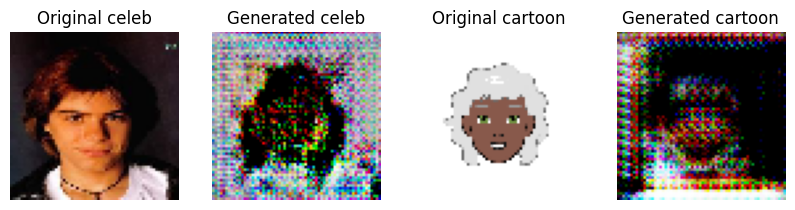

Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 1/1000 [00:00<09:14,  1.80it/s]

>1, dA[0.008 ,0.055 ] dB[0.005 ,0.013] g[10.866 ,8.675]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/1000 [00:01<09:20,  1.78it/s]

>2, dA[0.052 ,0.014 ] dB[0.040 ,0.059] g[9.992 ,8.893]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 3/1000 [00:01<09:19,  1.78it/s]

>3, dA[0.057 ,0.067 ] dB[0.007 ,0.004] g[10.700 ,8.827]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 4/1000 [00:02<09:19,  1.78it/s]

>4, dA[0.022 ,0.515 ] dB[0.002 ,0.010] g[9.530 ,7.401]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 5/1000 [00:02<09:17,  1.78it/s]

>5, dA[0.227 ,0.025 ] dB[0.043 ,0.017] g[9.828 ,9.274]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 6/1000 [00:03<09:19,  1.78it/s]

>6, dA[0.216 ,0.174 ] dB[0.058 ,0.038] g[10.252 ,9.036]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 7/1000 [00:03<09:18,  1.78it/s]

>7, dA[0.069 ,0.206 ] dB[0.024 ,0.016] g[11.367 ,10.161]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 8/1000 [00:04<09:16,  1.78it/s]

>8, dA[0.115 ,0.077 ] dB[0.017 ,0.025] g[9.899 ,9.336]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:05<09:15,  1.79it/s]

>9, dA[0.082 ,0.028 ] dB[0.012 ,0.006] g[11.800 ,9.812]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:17,  1.78it/s]

>10, dA[0.049 ,0.012 ] dB[0.006 ,0.037] g[9.502 ,8.930]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [00:06<09:14,  1.78it/s]

>11, dA[0.009 ,0.164 ] dB[0.123 ,0.009] g[10.007 ,8.772]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 12/1000 [00:06<09:12,  1.79it/s]

>12, dA[0.038 ,0.027 ] dB[0.065 ,0.005] g[11.187 ,10.885]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:11,  1.79it/s]

>13, dA[0.024 ,0.070 ] dB[0.009 ,0.014] g[9.688 ,8.843]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:10,  1.79it/s]

>14, dA[0.028 ,0.346 ] dB[0.018 ,0.008] g[11.001 ,8.985]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:11,  1.79it/s]

>15, dA[0.077 ,0.034 ] dB[0.006 ,0.092] g[10.213 ,9.459]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 16/1000 [00:08<09:09,  1.79it/s]

>16, dA[0.049 ,0.155 ] dB[0.135 ,0.048] g[9.573 ,7.602]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:07,  1.79it/s]

>17, dA[0.271 ,0.101 ] dB[0.039 ,0.006] g[10.189 ,9.038]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:11,  1.78it/s]

>18, dA[0.021 ,0.617 ] dB[0.013 ,0.072] g[10.208 ,8.789]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:10,  1.78it/s]

>19, dA[0.069 ,0.049 ] dB[0.038 ,0.093] g[9.304 ,8.551]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:08,  1.79it/s]

>20, dA[0.108 ,0.050 ] dB[0.235 ,0.013] g[9.624 ,9.316]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:09,  1.78it/s]

>21, dA[0.110 ,0.097 ] dB[0.023 ,0.009] g[10.803 ,9.613]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:09,  1.78it/s]

>22, dA[0.107 ,0.053 ] dB[0.019 ,0.010] g[11.030 ,10.033]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:07,  1.78it/s]

>23, dA[0.188 ,0.011 ] dB[0.176 ,0.048] g[9.193 ,8.764]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:07,  1.78it/s]

>24, dA[0.197 ,0.038 ] dB[0.035 ,0.008] g[9.044 ,8.111]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:06,  1.78it/s]

>25, dA[0.074 ,0.915 ] dB[0.003 ,0.006] g[10.411 ,10.797]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:05,  1.78it/s]

>26, dA[0.071 ,0.034 ] dB[0.003 ,0.081] g[10.037 ,8.669]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:04,  1.79it/s]

>27, dA[0.353 ,0.131 ] dB[0.038 ,0.103] g[9.627 ,8.235]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:03,  1.79it/s]

>28, dA[0.095 ,0.013 ] dB[0.028 ,0.055] g[9.112 ,7.626]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:07,  1.77it/s]

>29, dA[0.016 ,0.024 ] dB[0.035 ,0.006] g[9.544 ,8.213]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:06,  1.77it/s]

>30, dA[0.036 ,0.300 ] dB[0.005 ,0.008] g[9.177 ,7.792]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:05,  1.78it/s]

>31, dA[0.172 ,0.120 ] dB[0.011 ,0.048] g[10.931 ,8.929]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 32/1000 [00:17<09:03,  1.78it/s]

>32, dA[0.252 ,0.037 ] dB[0.034 ,0.008] g[9.183 ,8.793]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:02,  1.78it/s]

>33, dA[0.018 ,0.007 ] dB[0.004 ,0.003] g[11.476 ,10.519]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:02,  1.78it/s]

>34, dA[0.263 ,0.420 ] dB[0.003 ,0.004] g[10.741 ,9.931]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:00,  1.78it/s]

>35, dA[0.165 ,0.046 ] dB[0.049 ,0.074] g[7.701 ,6.935]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 36/1000 [00:20<08:59,  1.79it/s]

>36, dA[0.009 ,0.137 ] dB[0.033 ,0.019] g[10.191 ,8.881]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 37/1000 [00:20<08:58,  1.79it/s]

>37, dA[0.045 ,0.052 ] dB[0.016 ,0.015] g[10.961 ,9.454]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:00,  1.78it/s]

>38, dA[0.086 ,0.204 ] dB[0.017 ,0.026] g[7.941 ,7.502]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [00:21<09:00,  1.78it/s]

>39, dA[0.007 ,0.031 ] dB[0.012 ,0.007] g[10.503 ,9.747]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 40/1000 [00:22<08:58,  1.78it/s]

>40, dA[0.098 ,0.266 ] dB[0.010 ,0.008] g[8.378 ,7.189]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 41/1000 [00:22<08:56,  1.79it/s]

>41, dA[0.014 ,0.091 ] dB[0.021 ,0.004] g[12.034 ,10.607]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 42/1000 [00:23<09:00,  1.77it/s]

>42, dA[0.188 ,0.023 ] dB[0.004 ,0.002] g[11.438 ,10.372]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 43/1000 [00:24<08:57,  1.78it/s]

>43, dA[0.138 ,0.282 ] dB[0.004 ,0.008] g[9.832 ,8.197]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:56,  1.78it/s]

>44, dA[0.105 ,0.006 ] dB[0.019 ,0.004] g[9.093 ,8.002]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 45/1000 [00:25<08:56,  1.78it/s]

>45, dA[0.004 ,0.021 ] dB[0.015 ,0.002] g[10.126 ,7.998]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:58,  1.77it/s]

>46, dA[0.115 ,0.050 ] dB[0.005 ,0.038] g[9.666 ,8.059]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:59,  1.77it/s]

>47, dA[0.078 ,0.533 ] dB[0.062 ,0.009] g[10.745 ,8.289]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 48/1000 [00:26<09:00,  1.76it/s]

>48, dA[0.100 ,0.010 ] dB[0.004 ,0.007] g[11.534 ,9.628]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:59,  1.76it/s]

>49, dA[0.124 ,0.135 ] dB[0.011 ,0.002] g[9.703 ,7.797]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 50/1000 [00:28<09:00,  1.76it/s]

>50, dA[0.068 ,0.104 ] dB[0.004 ,0.007] g[9.650 ,7.437]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:56,  1.77it/s]

>51, dA[0.035 ,0.086 ] dB[0.229 ,0.079] g[9.084 ,7.041]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:54,  1.77it/s]

>52, dA[0.068 ,0.035 ] dB[0.130 ,0.039] g[8.631 ,7.869]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:53,  1.78it/s]

>53, dA[0.013 ,0.027 ] dB[0.024 ,0.188] g[9.828 ,8.844]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 54/1000 [00:30<08:52,  1.78it/s]

>54, dA[0.013 ,0.120 ] dB[0.112 ,0.077] g[10.981 ,9.480]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:51,  1.78it/s]

>55, dA[0.042 ,0.004 ] dB[0.020 ,0.199] g[12.648 ,12.060]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:50,  1.78it/s]

>56, dA[0.305 ,0.579 ] dB[0.041 ,0.055] g[10.638 ,8.618]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 57/1000 [00:32<08:48,  1.79it/s]

>57, dA[0.037 ,0.044 ] dB[0.035 ,0.081] g[8.660 ,7.286]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 58/1000 [00:32<08:48,  1.78it/s]

>58, dA[0.156 ,0.075 ] dB[0.006 ,0.019] g[10.184 ,8.793]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 59/1000 [00:33<08:47,  1.78it/s]

>59, dA[0.252 ,0.205 ] dB[0.011 ,0.033] g[10.946 ,9.459]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 60/1000 [00:33<08:48,  1.78it/s]

>60, dA[0.076 ,0.094 ] dB[0.113 ,0.047] g[10.134 ,9.217]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:46,  1.78it/s]

>61, dA[0.078 ,0.239 ] dB[0.010 ,0.008] g[9.319 ,7.986]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 62/1000 [00:34<08:45,  1.78it/s]

>62, dA[0.067 ,0.025 ] dB[0.021 ,0.074] g[10.453 ,9.428]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:44,  1.79it/s]

>63, dA[0.084 ,0.108 ] dB[0.068 ,0.020] g[9.986 ,8.338]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 64/1000 [00:35<08:42,  1.79it/s]

>64, dA[0.006 ,0.050 ] dB[0.010 ,0.012] g[10.645 ,8.715]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:42,  1.79it/s]

>65, dA[0.081 ,0.210 ] dB[0.091 ,0.020] g[10.455 ,8.557]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:42,  1.79it/s]

>66, dA[0.133 ,0.122 ] dB[0.024 ,0.009] g[8.901 ,7.773]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 67/1000 [00:37<08:40,  1.79it/s]

>67, dA[0.124 ,0.037 ] dB[0.011 ,0.020] g[9.669 ,8.100]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:40,  1.79it/s]

>68, dA[0.087 ,0.059 ] dB[0.005 ,0.047] g[9.422 ,8.651]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 69/1000 [00:38<08:38,  1.80it/s]

>69, dA[0.020 ,0.092 ] dB[0.008 ,0.035] g[10.931 ,9.313]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:40,  1.79it/s]

>70, dA[0.182 ,0.094 ] dB[0.140 ,0.197] g[8.042 ,7.062]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 71/1000 [00:39<08:39,  1.79it/s]

>71, dA[0.210 ,0.151 ] dB[0.022 ,0.020] g[8.354 ,7.591]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 72/1000 [00:40<08:39,  1.79it/s]

>72, dA[0.010 ,0.021 ] dB[0.011 ,0.012] g[9.969 ,9.483]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 73/1000 [00:40<08:38,  1.79it/s]

>73, dA[0.225 ,0.315 ] dB[0.025 ,0.006] g[9.031 ,8.559]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 74/1000 [00:41<08:40,  1.78it/s]

>74, dA[0.041 ,0.089 ] dB[0.095 ,0.008] g[10.301 ,9.040]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:41,  1.77it/s]

>75, dA[0.156 ,0.116 ] dB[0.024 ,0.020] g[9.344 ,8.280]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 76/1000 [00:42<08:39,  1.78it/s]

>76, dA[0.003 ,0.061 ] dB[0.007 ,0.011] g[10.993 ,9.621]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:38,  1.78it/s]

>77, dA[0.314 ,0.046 ] dB[0.008 ,0.004] g[11.101 ,9.616]
1/1 [==============================] - 0s 29ms/step



Batchs:   8%|▊         | 78/1000 [00:43<08:43,  1.76it/s]

>78, dA[0.046 ,0.106 ] dB[0.003 ,0.007] g[10.789 ,9.320]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:41,  1.77it/s]

>79, dA[0.128 ,0.230 ] dB[0.008 ,0.043] g[10.708 ,9.164]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [00:44<08:39,  1.77it/s]

>80, dA[0.337 ,0.028 ] dB[0.038 ,0.011] g[11.054 ,10.175]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 81/1000 [00:45<08:37,  1.78it/s]

>81, dA[0.085 ,0.178 ] dB[0.008 ,0.014] g[9.341 ,7.861]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:38,  1.77it/s]

>82, dA[0.068 ,0.094 ] dB[0.029 ,0.006] g[9.869 ,8.714]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:46<08:36,  1.78it/s]

>83, dA[0.323 ,0.039 ] dB[0.009 ,0.008] g[10.171 ,8.651]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:34,  1.78it/s]

>84, dA[0.098 ,0.315 ] dB[0.002 ,0.012] g[8.285 ,7.697]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 85/1000 [00:47<08:32,  1.79it/s]

>85, dA[0.016 ,0.023 ] dB[0.003 ,0.019] g[10.994 ,9.830]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:33,  1.78it/s]

>86, dA[0.100 ,0.010 ] dB[0.005 ,0.007] g[10.387 ,9.289]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 87/1000 [00:48<08:31,  1.78it/s]

>87, dA[0.046 ,0.033 ] dB[0.010 ,0.017] g[9.363 ,8.485]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 88/1000 [00:49<08:33,  1.78it/s]

>88, dA[0.140 ,0.298 ] dB[0.004 ,0.024] g[10.174 ,8.877]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 89/1000 [00:49<08:32,  1.78it/s]

>89, dA[0.082 ,0.136 ] dB[0.002 ,0.025] g[9.440 ,7.848]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 90/1000 [00:50<08:31,  1.78it/s]

>90, dA[0.110 ,0.031 ] dB[0.016 ,0.025] g[9.192 ,8.684]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:30,  1.78it/s]

>91, dA[0.111 ,0.098 ] dB[0.006 ,0.013] g[9.884 ,8.903]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 92/1000 [00:51<08:28,  1.78it/s]

>92, dA[0.071 ,0.006 ] dB[0.027 ,0.016] g[10.423 ,8.464]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:27,  1.79it/s]

>93, dA[0.007 ,0.137 ] dB[0.004 ,0.013] g[8.576 ,7.371]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 94/1000 [00:52<08:26,  1.79it/s]

>94, dA[0.076 ,0.024 ] dB[0.001 ,0.007] g[11.749 ,10.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [00:53<08:28,  1.78it/s]

>95, dA[0.030 ,0.009 ] dB[0.005 ,0.043] g[11.582 ,9.696]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 96/1000 [00:53<08:28,  1.78it/s]

>96, dA[0.057 ,0.324 ] dB[0.047 ,0.004] g[9.753 ,8.752]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 97/1000 [00:54<08:26,  1.78it/s]

>97, dA[0.012 ,0.011 ] dB[0.013 ,0.009] g[13.907 ,13.375]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:25,  1.78it/s]

>98, dA[0.345 ,0.105 ] dB[0.015 ,0.025] g[9.144 ,8.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [00:55<08:24,  1.79it/s]

>99, dA[0.188 ,0.232 ] dB[0.012 ,0.009] g[11.269 ,9.226]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:22,  1.79it/s]

>100, dA[0.052 ,0.042 ] dB[0.007 ,0.026] g[10.378 ,8.319]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 101/1000 [00:56<08:21,  1.79it/s]

>101, dA[0.143 ,0.097 ] dB[0.005 ,0.052] g[11.085 ,8.912]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 102/1000 [00:57<08:22,  1.79it/s]

>102, dA[0.046 ,0.036 ] dB[0.007 ,0.041] g[10.537 ,9.730]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 103/1000 [00:57<08:21,  1.79it/s]

>103, dA[0.026 ,0.038 ] dB[0.020 ,0.008] g[12.507 ,10.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:58<08:20,  1.79it/s]

>104, dA[0.032 ,0.570 ] dB[0.018 ,0.005] g[9.838 ,7.743]
1/1 [==============================] - 0s 29ms/step



Batchs:  10%|█         | 105/1000 [00:58<08:29,  1.76it/s]

>105, dA[0.051 ,0.087 ] dB[0.029 ,0.008] g[11.492 ,10.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [00:59<08:28,  1.76it/s]

>106, dA[0.435 ,0.240 ] dB[0.037 ,0.012] g[10.518 ,9.548]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:26,  1.76it/s]

>107, dA[0.078 ,0.102 ] dB[0.017 ,0.012] g[8.608 ,8.798]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 108/1000 [01:00<08:22,  1.78it/s]

>108, dA[0.096 ,0.153 ] dB[0.005 ,0.010] g[10.885 ,8.643]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:19,  1.79it/s]

>109, dA[0.015 ,0.140 ] dB[0.002 ,0.021] g[12.275 ,10.655]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 110/1000 [01:01<08:18,  1.78it/s]

>110, dA[0.071 ,0.042 ] dB[0.017 ,0.038] g[8.175 ,7.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:02<08:17,  1.79it/s]

>111, dA[0.101 ,0.034 ] dB[0.012 ,0.005] g[10.326 ,8.295]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 112/1000 [01:02<08:16,  1.79it/s]

>112, dA[0.014 ,0.452 ] dB[0.013 ,0.010] g[10.624 ,9.725]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 113/1000 [01:03<08:15,  1.79it/s]

>113, dA[0.020 ,0.018 ] dB[0.015 ,0.016] g[11.006 ,9.547]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 114/1000 [01:03<08:15,  1.79it/s]

>114, dA[0.385 ,0.151 ] dB[0.026 ,0.004] g[10.076 ,8.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 115/1000 [01:04<08:15,  1.79it/s]

>115, dA[0.100 ,0.119 ] dB[0.004 ,0.014] g[9.608 ,8.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:15,  1.79it/s]

>116, dA[0.109 ,0.512 ] dB[0.006 ,0.004] g[10.856 ,11.070]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 117/1000 [01:05<08:13,  1.79it/s]

>117, dA[0.292 ,0.166 ] dB[0.028 ,0.024] g[9.521 ,8.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:13,  1.79it/s]

>118, dA[0.092 ,0.024 ] dB[0.013 ,0.010] g[9.508 ,9.081]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 119/1000 [01:06<08:13,  1.79it/s]

>119, dA[0.164 ,0.009 ] dB[0.016 ,0.009] g[10.080 ,8.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 120/1000 [01:07<08:12,  1.79it/s]

>120, dA[0.015 ,0.474 ] dB[0.008 ,0.003] g[12.505 ,10.647]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 121/1000 [01:07<08:10,  1.79it/s]

>121, dA[0.224 ,0.029 ] dB[0.002 ,0.006] g[10.434 ,9.949]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 122/1000 [01:08<08:10,  1.79it/s]

>122, dA[0.079 ,0.112 ] dB[0.012 ,0.003] g[10.271 ,9.249]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:09,  1.79it/s]

>123, dA[0.067 ,0.022 ] dB[0.006 ,0.011] g[11.911 ,11.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:09<08:08,  1.79it/s]

>124, dA[0.128 ,0.015 ] dB[0.005 ,0.013] g[10.317 ,9.156]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:07,  1.79it/s]

>125, dA[0.173 ,0.288 ] dB[0.003 ,0.004] g[8.727 ,7.358]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 126/1000 [01:10<08:08,  1.79it/s]

>126, dA[0.026 ,0.096 ] dB[0.003 ,0.016] g[10.936 ,10.155]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 127/1000 [01:11<08:07,  1.79it/s]

>127, dA[0.025 ,0.017 ] dB[0.042 ,0.074] g[9.472 ,9.075]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 128/1000 [01:11<08:06,  1.79it/s]

>128, dA[0.012 ,0.004 ] dB[0.006 ,0.007] g[9.356 ,8.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:12<08:05,  1.80it/s]

>129, dA[0.152 ,0.075 ] dB[0.030 ,0.007] g[10.623 ,9.480]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 130/1000 [01:12<08:04,  1.79it/s]

>130, dA[0.016 ,0.200 ] dB[0.028 ,0.009] g[9.349 ,8.199]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 131/1000 [01:13<08:04,  1.80it/s]

>131, dA[0.011 ,0.052 ] dB[0.008 ,0.002] g[11.805 ,11.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:03,  1.80it/s]

>132, dA[0.067 ,0.028 ] dB[0.007 ,0.007] g[10.585 ,10.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 133/1000 [01:14<08:02,  1.80it/s]

>133, dA[0.138 ,0.171 ] dB[0.012 ,0.028] g[8.197 ,7.771]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:03,  1.79it/s]

>134, dA[0.224 ,0.149 ] dB[0.006 ,0.018] g[9.451 ,8.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 135/1000 [01:15<08:02,  1.79it/s]

>135, dA[0.377 ,0.136 ] dB[0.003 ,0.008] g[9.277 ,9.501]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 136/1000 [01:16<08:01,  1.80it/s]

>136, dA[0.019 ,0.377 ] dB[0.007 ,0.021] g[10.964 ,9.115]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 137/1000 [01:16<08:00,  1.80it/s]

>137, dA[0.236 ,0.020 ] dB[0.014 ,0.004] g[9.853 ,7.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:17<08:00,  1.79it/s]

>138, dA[0.167 ,0.213 ] dB[0.033 ,0.184] g[7.994 ,7.917]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 139/1000 [01:17<08:00,  1.79it/s]

>139, dA[0.078 ,0.021 ] dB[0.056 ,0.014] g[8.909 ,7.698]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 140/1000 [01:18<07:59,  1.80it/s]

>140, dA[0.112 ,0.341 ] dB[0.010 ,0.062] g[11.580 ,11.495]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<07:57,  1.80it/s]

>141, dA[0.130 ,0.023 ] dB[0.020 ,0.022] g[10.064 ,8.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [01:19<07:58,  1.79it/s]

>142, dA[0.034 ,0.030 ] dB[0.045 ,0.037] g[11.355 ,9.589]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 143/1000 [01:20<07:57,  1.80it/s]

>143, dA[0.088 ,0.055 ] dB[0.050 ,0.018] g[10.230 ,8.463]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 144/1000 [01:20<07:56,  1.80it/s]

>144, dA[0.191 ,0.033 ] dB[0.018 ,0.035] g[9.880 ,7.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:21<07:56,  1.79it/s]

>145, dA[0.198 ,0.739 ] dB[0.014 ,0.014] g[8.626 ,6.902]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 146/1000 [01:21<07:58,  1.79it/s]

>146, dA[0.054 ,0.069 ] dB[0.027 ,0.050] g[9.300 ,7.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [01:22<07:57,  1.79it/s]

>147, dA[0.046 ,0.014 ] dB[0.069 ,0.007] g[9.557 ,9.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:22<07:55,  1.79it/s]

>148, dA[0.023 ,0.005 ] dB[0.006 ,0.062] g[9.521 ,8.713]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 149/1000 [01:23<07:57,  1.78it/s]

>149, dA[0.052 ,0.043 ] dB[0.014 ,0.009] g[9.344 ,8.102]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<07:56,  1.78it/s]

>150, dA[0.026 ,0.187 ] dB[0.043 ,0.018] g[10.537 ,8.957]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 151/1000 [01:24<07:55,  1.79it/s]

>151, dA[0.182 ,0.132 ] dB[0.057 ,0.032] g[9.438 ,8.357]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 152/1000 [01:25<07:53,  1.79it/s]

>152, dA[0.337 ,0.099 ] dB[0.041 ,0.006] g[10.476 ,9.634]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 153/1000 [01:25<07:51,  1.80it/s]

>153, dA[0.036 ,0.009 ] dB[0.005 ,0.005] g[9.832 ,8.772]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 154/1000 [01:26<07:51,  1.79it/s]

>154, dA[0.070 ,0.019 ] dB[0.004 ,0.043] g[8.345 ,7.630]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<09:28,  1.49it/s]

>155, dA[0.036 ,0.026 ] dB[0.036 ,0.021] g[12.644 ,11.940]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 156/1000 [01:27<08:58,  1.57it/s]

>156, dA[0.035 ,0.352 ] dB[0.023 ,0.025] g[10.254 ,8.380]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<08:39,  1.62it/s]

>157, dA[0.130 ,0.092 ] dB[0.023 ,0.006] g[10.859 ,11.105]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 158/1000 [01:28<08:22,  1.67it/s]

>158, dA[0.089 ,0.004 ] dB[0.012 ,0.010] g[11.481 ,11.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:29<08:14,  1.70it/s]

>159, dA[0.066 ,0.153 ] dB[0.019 ,0.020] g[8.313 ,6.923]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<08:07,  1.72it/s]

>160, dA[0.028 ,0.188 ] dB[0.007 ,0.019] g[11.423 ,10.356]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 161/1000 [01:30<08:13,  1.70it/s]

>161, dA[0.036 ,0.104 ] dB[0.005 ,0.006] g[11.354 ,10.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<08:07,  1.72it/s]

>162, dA[0.229 ,0.069 ] dB[0.011 ,0.006] g[11.694 ,10.090]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 163/1000 [01:31<08:07,  1.72it/s]

>163, dA[0.040 ,0.130 ] dB[0.006 ,0.012] g[9.378 ,7.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<08:01,  1.74it/s]

>164, dA[0.013 ,0.044 ] dB[0.008 ,0.013] g[11.184 ,8.634]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 165/1000 [01:32<07:55,  1.75it/s]

>165, dA[0.013 ,0.173 ] dB[0.008 ,0.008] g[8.668 ,6.768]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:52,  1.77it/s]

>166, dA[0.002 ,0.051 ] dB[0.005 ,0.009] g[10.150 ,8.575]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:51,  1.77it/s]

>167, dA[0.386 ,0.033 ] dB[0.009 ,0.020] g[9.356 ,8.878]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 168/1000 [01:34<07:51,  1.76it/s]

>168, dA[0.280 ,0.240 ] dB[0.016 ,0.025] g[7.751 ,6.801]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:47,  1.78it/s]

>169, dA[0.050 ,0.123 ] dB[0.025 ,0.009] g[10.372 ,9.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:35<07:45,  1.78it/s]

>170, dA[0.013 ,0.018 ] dB[0.017 ,0.006] g[10.580 ,10.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:46,  1.78it/s]

>171, dA[0.248 ,0.007 ] dB[0.010 ,0.004] g[7.895 ,7.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 172/1000 [01:36<07:45,  1.78it/s]

>172, dA[0.041 ,0.199 ] dB[0.001 ,0.006] g[10.653 ,9.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:43,  1.78it/s]

>173, dA[0.045 ,0.027 ] dB[0.003 ,0.013] g[10.170 ,8.566]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 174/1000 [01:37<07:41,  1.79it/s]

>174, dA[0.038 ,0.012 ] dB[0.019 ,0.011] g[9.524 ,8.849]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 175/1000 [01:38<07:42,  1.79it/s]

>175, dA[0.152 ,0.407 ] dB[0.026 ,0.004] g[9.088 ,8.066]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:41,  1.79it/s]

>176, dA[0.250 ,0.006 ] dB[0.004 ,0.016] g[11.061 ,10.929]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 177/1000 [01:39<07:40,  1.79it/s]

>177, dA[0.044 ,0.330 ] dB[0.019 ,0.029] g[10.613 ,8.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:39,  1.79it/s]

>178, dA[0.025 ,0.056 ] dB[0.022 ,0.020] g[8.978 ,7.964]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 179/1000 [01:40<07:39,  1.79it/s]

>179, dA[0.257 ,0.087 ] dB[0.010 ,0.009] g[9.892 ,8.934]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:38,  1.79it/s]

>180, dA[0.009 ,0.015 ] dB[0.002 ,0.013] g[11.198 ,10.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:41<07:37,  1.79it/s]

>181, dA[0.009 ,0.063 ] dB[0.022 ,0.005] g[8.040 ,6.992]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:37,  1.79it/s]

>182, dA[0.098 ,0.183 ] dB[0.006 ,0.009] g[9.449 ,8.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:38,  1.78it/s]

>183, dA[0.245 ,0.072 ] dB[0.004 ,0.011] g[10.539 ,9.261]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 184/1000 [01:43<07:40,  1.77it/s]

>184, dA[0.018 ,0.017 ] dB[0.012 ,0.012] g[12.471 ,11.303]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:38,  1.78it/s]

>185, dA[0.035 ,0.010 ] dB[0.003 ,0.006] g[10.477 ,10.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:44<07:38,  1.78it/s]

>186, dA[0.313 ,0.017 ] dB[0.004 ,0.015] g[9.390 ,9.496]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:37,  1.78it/s]

>187, dA[0.023 ,0.056 ] dB[0.009 ,0.006] g[7.343 ,6.019]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 188/1000 [01:45<07:35,  1.78it/s]

>188, dA[0.055 ,0.173 ] dB[0.008 ,0.003] g[12.320 ,10.758]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:35,  1.78it/s]

>189, dA[0.467 ,0.090 ] dB[0.001 ,0.005] g[9.738 ,8.463]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 190/1000 [01:46<07:37,  1.77it/s]

>190, dA[0.032 ,0.027 ] dB[0.002 ,0.003] g[12.693 ,11.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:47<07:37,  1.77it/s]

>191, dA[0.018 ,0.022 ] dB[0.003 ,0.008] g[11.302 ,10.796]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:34,  1.78it/s]

>192, dA[0.128 ,0.032 ] dB[0.010 ,0.010] g[10.921 ,11.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 193/1000 [01:48<07:33,  1.78it/s]

>193, dA[0.017 ,0.013 ] dB[0.017 ,0.008] g[13.344 ,12.898]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:32,  1.78it/s]

>194, dA[0.009 ,0.127 ] dB[0.012 ,0.003] g[10.062 ,8.804]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [01:49<07:32,  1.78it/s]

>195, dA[0.067 ,0.032 ] dB[0.006 ,0.013] g[10.143 ,8.454]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:30,  1.78it/s]

>196, dA[0.504 ,0.021 ] dB[0.006 ,0.010] g[11.600 ,10.340]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 197/1000 [01:50<07:29,  1.79it/s]

>197, dA[0.031 ,0.357 ] dB[0.015 ,0.008] g[11.266 ,10.195]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:28,  1.79it/s]

>198, dA[0.050 ,0.016 ] dB[0.009 ,0.007] g[7.594 ,6.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 199/1000 [01:52<07:30,  1.78it/s]

>199, dA[0.068 ,0.020 ] dB[0.010 ,0.004] g[9.480 ,8.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:52<07:28,  1.78it/s]

>200, dA[0.009 ,0.126 ] dB[0.003 ,0.004] g[8.222 ,7.361]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:26,  1.79it/s]

>201, dA[0.089 ,0.027 ] dB[0.008 ,0.004] g[10.300 ,9.388]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 202/1000 [01:53<07:27,  1.78it/s]

>202, dA[0.086 ,0.204 ] dB[0.002 ,0.006] g[9.020 ,7.888]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:28,  1.78it/s]

>203, dA[0.303 ,0.185 ] dB[0.002 ,0.019] g[10.569 ,9.307]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 204/1000 [01:54<07:26,  1.78it/s]

>204, dA[0.052 ,0.013 ] dB[0.014 ,0.005] g[8.660 ,9.160]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 205/1000 [01:55<07:25,  1.78it/s]

>205, dA[0.163 ,0.203 ] dB[0.004 ,0.016] g[10.244 ,9.295]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 206/1000 [01:55<07:24,  1.79it/s]

>206, dA[0.009 ,0.010 ] dB[0.013 ,0.004] g[10.864 ,9.634]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [01:56<07:24,  1.78it/s]

>207, dA[0.037 ,0.044 ] dB[0.005 ,0.018] g[10.787 ,9.441]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:23,  1.79it/s]

>208, dA[0.094 ,0.015 ] dB[0.009 ,0.008] g[11.841 ,9.999]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 209/1000 [01:57<07:22,  1.79it/s]

>209, dA[0.123 ,0.311 ] dB[0.002 ,0.011] g[9.310 ,8.237]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:20,  1.79it/s]

>210, dA[0.093 ,0.043 ] dB[0.018 ,0.136] g[6.901 ,6.202]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 211/1000 [01:58<07:20,  1.79it/s]

>211, dA[0.075 ,0.156 ] dB[0.010 ,0.012] g[9.735 ,7.553]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:19,  1.79it/s]

>212, dA[0.031 ,0.018 ] dB[0.054 ,0.026] g[8.930 ,7.157]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██▏       | 213/1000 [01:59<07:18,  1.79it/s]

>213, dA[0.133 ,0.012 ] dB[0.050 ,0.005] g[8.107 ,7.365]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██▏       | 214/1000 [02:00<07:18,  1.79it/s]

>214, dA[0.004 ,0.072 ] dB[0.013 ,0.028] g[8.771 ,7.366]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 215/1000 [02:00<07:18,  1.79it/s]

>215, dA[0.050 ,0.312 ] dB[0.058 ,0.016] g[8.915 ,7.447]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 216/1000 [02:01<07:18,  1.79it/s]

>216, dA[0.168 ,0.025 ] dB[0.007 ,0.004] g[8.945 ,7.637]
1/1 [==============================] - 0s 27ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:25,  1.76it/s]

>217, dA[0.096 ,0.015 ] dB[0.026 ,0.006] g[10.087 ,9.113]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 218/1000 [02:02<07:23,  1.76it/s]

>218, dA[0.170 ,0.562 ] dB[0.027 ,0.035] g[8.559 ,7.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:22,  1.77it/s]

>219, dA[0.117 ,0.017 ] dB[0.026 ,0.011] g[10.249 ,9.130]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 220/1000 [02:03<07:23,  1.76it/s]

>220, dA[0.098 ,0.119 ] dB[0.019 ,0.023] g[8.741 ,7.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 221/1000 [02:04<07:19,  1.77it/s]

>221, dA[0.022 ,0.015 ] dB[0.030 ,0.023] g[8.799 ,8.197]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 222/1000 [02:04<07:17,  1.78it/s]

>222, dA[0.046 ,0.214 ] dB[0.032 ,0.006] g[12.937 ,11.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 223/1000 [02:05<07:17,  1.78it/s]

>223, dA[0.027 ,0.079 ] dB[0.007 ,0.018] g[10.378 ,9.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:14,  1.78it/s]

>224, dA[0.012 ,0.100 ] dB[0.005 ,0.004] g[9.910 ,8.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [02:06<07:13,  1.79it/s]

>225, dA[0.018 ,0.037 ] dB[0.012 ,0.004] g[10.943 ,9.790]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:13,  1.79it/s]

>226, dA[0.441 ,0.119 ] dB[0.007 ,0.040] g[9.932 ,8.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [02:07<07:14,  1.78it/s]

>227, dA[0.008 ,0.021 ] dB[0.020 ,0.121] g[8.093 ,8.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:14,  1.78it/s]

>228, dA[0.007 ,0.311 ] dB[0.209 ,0.049] g[9.677 ,7.986]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 229/1000 [02:08<07:12,  1.78it/s]

>229, dA[0.053 ,0.026 ] dB[0.017 ,0.029] g[8.537 ,8.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [02:09<07:12,  1.78it/s]

>230, dA[0.397 ,0.071 ] dB[0.005 ,0.015] g[11.442 ,10.438]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 231/1000 [02:09<07:12,  1.78it/s]

>231, dA[0.051 ,0.516 ] dB[0.002 ,0.010] g[12.123 ,10.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:10<07:12,  1.78it/s]

>232, dA[0.054 ,0.036 ] dB[0.009 ,0.040] g[10.750 ,11.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:10,  1.78it/s]

>233, dA[0.076 ,0.022 ] dB[0.019 ,0.007] g[10.906 ,10.408]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 234/1000 [02:11<07:08,  1.79it/s]

>234, dA[0.147 ,0.176 ] dB[0.007 ,0.006] g[13.106 ,12.039]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:09,  1.78it/s]

>235, dA[0.352 ,0.030 ] dB[0.002 ,0.111] g[10.089 ,10.830]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 236/1000 [02:12<07:08,  1.78it/s]

>236, dA[0.012 ,0.018 ] dB[0.126 ,0.031] g[11.876 ,9.433]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 237/1000 [02:13<07:07,  1.78it/s]

>237, dA[0.131 ,0.260 ] dB[0.037 ,0.004] g[12.830 ,13.406]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 238/1000 [02:13<07:08,  1.78it/s]

>238, dA[0.090 ,0.014 ] dB[0.006 ,0.093] g[8.950 ,9.072]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 239/1000 [02:14<07:08,  1.77it/s]

>239, dA[0.062 ,0.005 ] dB[0.019 ,0.009] g[11.592 ,9.696]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 240/1000 [02:15<07:06,  1.78it/s]

>240, dA[0.022 ,0.287 ] dB[0.088 ,0.043] g[10.573 ,10.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 241/1000 [02:15<07:05,  1.78it/s]

>241, dA[0.135 ,0.206 ] dB[0.036 ,0.007] g[9.846 ,8.910]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:03,  1.79it/s]

>242, dA[0.094 ,0.127 ] dB[0.021 ,0.007] g[11.066 ,8.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 243/1000 [02:16<07:03,  1.79it/s]

>243, dA[0.242 ,0.077 ] dB[0.002 ,0.004] g[10.984 ,9.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:17<07:03,  1.79it/s]

>244, dA[0.053 ,0.151 ] dB[0.111 ,0.250] g[7.472 ,6.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 245/1000 [02:17<07:01,  1.79it/s]

>245, dA[0.015 ,0.011 ] dB[0.022 ,0.071] g[11.727 ,10.594]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 246/1000 [02:18<07:00,  1.79it/s]

>246, dA[0.006 ,0.005 ] dB[0.026 ,0.052] g[11.195 ,9.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 247/1000 [02:18<07:00,  1.79it/s]

>247, dA[0.118 ,0.057 ] dB[0.063 ,0.090] g[9.247 ,8.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 248/1000 [02:19<07:00,  1.79it/s]

>248, dA[0.034 ,0.016 ] dB[0.006 ,0.028] g[8.778 ,8.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<06:59,  1.79it/s]

>249, dA[0.031 ,0.014 ] dB[0.008 ,0.014] g[10.270 ,7.918]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 250/1000 [02:20<06:58,  1.79it/s]

>250, dA[0.031 ,0.081 ] dB[0.007 ,0.021] g[9.296 ,7.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<06:59,  1.78it/s]

>251, dA[0.007 ,0.340 ] dB[0.018 ,0.009] g[8.497 ,7.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:21<06:59,  1.78it/s]

>252, dA[0.051 ,0.040 ] dB[0.006 ,0.003] g[8.827 ,7.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [02:22<06:57,  1.79it/s]

>253, dA[0.019 ,0.007 ] dB[0.008 ,0.008] g[11.483 ,11.222]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 254/1000 [02:22<06:56,  1.79it/s]

>254, dA[0.669 ,0.027 ] dB[0.037 ,0.016] g[8.683 ,9.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 255/1000 [02:23<06:58,  1.78it/s]

>255, dA[0.145 ,0.484 ] dB[0.026 ,0.014] g[10.498 ,9.379]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 256/1000 [02:23<06:57,  1.78it/s]

>256, dA[0.297 ,0.113 ] dB[0.013 ,0.006] g[10.910 ,10.571]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 257/1000 [02:24<06:56,  1.79it/s]

>257, dA[0.069 ,0.089 ] dB[0.005 ,0.027] g[11.104 ,10.332]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<06:54,  1.79it/s]

>258, dA[0.065 ,0.022 ] dB[0.076 ,0.009] g[9.714 ,8.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:25<06:54,  1.79it/s]

>259, dA[0.102 ,0.090 ] dB[0.016 ,0.039] g[11.186 ,9.534]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:53,  1.79it/s]

>260, dA[0.202 ,0.210 ] dB[0.025 ,0.007] g[8.944 ,7.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 261/1000 [02:26<06:53,  1.79it/s]

>261, dA[0.145 ,0.084 ] dB[0.006 ,0.013] g[8.525 ,7.490]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 262/1000 [02:27<06:52,  1.79it/s]

>262, dA[0.015 ,0.070 ] dB[0.021 ,0.060] g[10.871 ,10.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:27<06:52,  1.79it/s]

>263, dA[0.107 ,0.039 ] dB[0.014 ,0.390] g[11.259 ,9.948]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 264/1000 [02:28<06:51,  1.79it/s]

>264, dA[0.274 ,0.203 ] dB[0.147 ,0.060] g[10.272 ,9.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:50,  1.79it/s]

>265, dA[0.172 ,0.164 ] dB[0.052 ,0.055] g[10.195 ,8.630]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 266/1000 [02:29<06:49,  1.79it/s]

>266, dA[0.012 ,0.014 ] dB[0.108 ,0.844] g[10.720 ,8.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:49,  1.79it/s]

>267, dA[0.035 ,0.052 ] dB[0.328 ,0.233] g[12.855 ,10.750]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 268/1000 [02:30<06:49,  1.79it/s]

>268, dA[0.318 ,0.018 ] dB[0.074 ,0.153] g[9.078 ,8.061]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 269/1000 [02:31<06:48,  1.79it/s]

>269, dA[0.016 ,0.016 ] dB[0.029 ,0.099] g[9.400 ,7.505]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 270/1000 [02:31<06:47,  1.79it/s]

>270, dA[0.045 ,0.442 ] dB[0.030 ,0.052] g[9.131 ,7.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:32<06:48,  1.79it/s]

>271, dA[0.081 ,0.036 ] dB[0.012 ,0.024] g[11.879 ,11.117]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 272/1000 [02:32<06:47,  1.79it/s]

>272, dA[0.323 ,0.034 ] dB[0.055 ,0.016] g[10.313 ,9.552]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 273/1000 [02:33<06:49,  1.78it/s]

>273, dA[0.018 ,0.099 ] dB[0.004 ,0.030] g[10.014 ,9.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:49,  1.77it/s]

>274, dA[0.012 ,0.066 ] dB[0.011 ,0.011] g[12.239 ,11.398]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 275/1000 [02:34<06:51,  1.76it/s]

>275, dA[0.191 ,0.066 ] dB[0.005 ,0.018] g[9.310 ,7.467]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:48,  1.77it/s]

>276, dA[0.063 ,0.024 ] dB[0.013 ,0.013] g[8.461 ,10.065]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 277/1000 [02:35<06:45,  1.78it/s]

>277, dA[0.011 ,0.112 ] dB[0.016 ,0.047] g[11.108 ,10.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:36<06:44,  1.78it/s]

>278, dA[0.021 ,0.063 ] dB[0.018 ,0.016] g[11.224 ,11.052]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 279/1000 [02:36<06:44,  1.78it/s]

>279, dA[0.081 ,0.089 ] dB[0.011 ,0.328] g[9.611 ,8.608]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 280/1000 [02:37<06:42,  1.79it/s]

>280, dA[0.242 ,0.165 ] dB[0.042 ,0.182] g[9.642 ,9.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:37<06:41,  1.79it/s]

>281, dA[0.115 ,0.005 ] dB[0.089 ,0.023] g[10.769 ,9.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 282/1000 [02:38<06:40,  1.79it/s]

>282, dA[0.016 ,0.270 ] dB[0.080 ,0.062] g[11.042 ,9.491]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:41,  1.79it/s]

>283, dA[0.326 ,0.009 ] dB[0.021 ,0.018] g[10.041 ,9.136]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 284/1000 [02:39<06:40,  1.79it/s]

>284, dA[0.014 ,0.170 ] dB[0.030 ,0.044] g[12.318 ,10.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:40,  1.78it/s]

>285, dA[0.025 ,0.032 ] dB[0.011 ,0.036] g[11.097 ,10.127]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▊       | 286/1000 [02:40<06:40,  1.78it/s]

>286, dA[0.133 ,0.042 ] dB[0.017 ,0.026] g[10.351 ,9.463]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 287/1000 [02:41<06:39,  1.78it/s]

>287, dA[0.007 ,0.066 ] dB[0.019 ,0.011] g[9.132 ,8.050]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 288/1000 [02:41<06:38,  1.79it/s]

>288, dA[0.020 ,0.020 ] dB[0.007 ,0.004] g[11.020 ,10.789]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 289/1000 [02:42<06:37,  1.79it/s]

>289, dA[0.082 ,0.008 ] dB[0.215 ,0.503] g[7.915 ,7.017]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:35,  1.80it/s]

>290, dA[0.029 ,0.220 ] dB[0.032 ,0.031] g[11.171 ,9.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:43<06:38,  1.78it/s]

>291, dA[0.193 ,0.038 ] dB[0.062 ,0.072] g[10.076 ,8.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:37,  1.78it/s]

>292, dA[0.008 ,0.053 ] dB[0.023 ,0.017] g[9.734 ,9.565]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 293/1000 [02:44<06:35,  1.79it/s]

>293, dA[0.011 ,0.111 ] dB[0.018 ,0.004] g[9.415 ,7.614]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 294/1000 [02:45<06:35,  1.79it/s]

>294, dA[0.004 ,0.026 ] dB[0.006 ,0.012] g[10.523 ,9.746]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 295/1000 [02:45<06:35,  1.78it/s]

>295, dA[0.192 ,0.117 ] dB[0.010 ,0.012] g[8.696 ,7.643]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 296/1000 [02:46<06:34,  1.79it/s]

>296, dA[0.104 ,0.030 ] dB[0.009 ,0.013] g[9.148 ,7.660]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 297/1000 [02:46<06:33,  1.79it/s]

>297, dA[0.037 ,0.316 ] dB[0.010 ,0.016] g[9.840 ,8.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 298/1000 [02:47<06:31,  1.79it/s]

>298, dA[0.008 ,0.017 ] dB[0.030 ,0.018] g[10.829 ,10.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:32,  1.79it/s]

>299, dA[0.569 ,0.021 ] dB[0.029 ,0.017] g[9.920 ,8.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [02:48<06:31,  1.79it/s]

>300, dA[0.141 ,0.437 ] dB[0.027 ,0.002] g[10.395 ,9.761]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:30,  1.79it/s]

>301, dA[0.010 ,0.061 ] dB[0.010 ,0.010] g[11.687 ,12.403]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 302/1000 [02:49<06:29,  1.79it/s]

>302, dA[0.153 ,0.020 ] dB[0.008 ,0.009] g[8.901 ,8.199]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 303/1000 [02:50<06:29,  1.79it/s]

>303, dA[0.052 ,0.109 ] dB[0.095 ,0.304] g[7.946 ,6.973]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 304/1000 [02:50<06:28,  1.79it/s]

>304, dA[0.053 ,0.110 ] dB[0.033 ,0.023] g[10.308 ,8.470]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 305/1000 [02:51<06:27,  1.79it/s]

>305, dA[0.208 ,0.103 ] dB[0.030 ,0.010] g[9.325 ,8.544]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 306/1000 [02:51<06:27,  1.79it/s]

>306, dA[0.021 ,0.058 ] dB[0.021 ,0.014] g[10.434 ,9.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 307/1000 [02:52<06:28,  1.78it/s]

>307, dA[0.118 ,0.025 ] dB[0.004 ,0.013] g[9.532 ,8.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:26,  1.79it/s]

>308, dA[0.227 ,0.010 ] dB[0.003 ,0.003] g[10.050 ,8.926]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:53<06:26,  1.79it/s]

>309, dA[0.063 ,0.292 ] dB[0.012 ,0.016] g[8.839 ,7.380]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 310/1000 [02:54<06:26,  1.79it/s]

>310, dA[0.026 ,0.186 ] dB[0.013 ,0.050] g[8.818 ,8.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 311/1000 [02:54<06:25,  1.79it/s]

>311, dA[0.108 ,0.037 ] dB[0.110 ,0.053] g[11.346 ,11.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 312/1000 [02:55<06:24,  1.79it/s]

>312, dA[0.158 ,0.505 ] dB[0.026 ,0.022] g[12.527 ,12.070]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 313/1000 [02:55<06:23,  1.79it/s]

>313, dA[0.027 ,0.057 ] dB[0.004 ,0.009] g[11.246 ,10.069]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 314/1000 [02:56<06:22,  1.79it/s]

>314, dA[0.487 ,0.152 ] dB[0.006 ,0.004] g[10.043 ,8.479]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:23,  1.79it/s]

>315, dA[0.135 ,0.101 ] dB[0.007 ,0.028] g[9.255 ,7.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [02:57<06:22,  1.79it/s]

>316, dA[0.007 ,0.106 ] dB[0.019 ,0.013] g[10.973 ,9.663]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 317/1000 [02:58<06:21,  1.79it/s]

>317, dA[0.010 ,0.208 ] dB[0.016 ,0.011] g[10.729 ,9.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [02:58<06:21,  1.79it/s]

>318, dA[0.066 ,0.012 ] dB[0.006 ,0.012] g[12.726 ,12.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 319/1000 [02:59<06:21,  1.78it/s]

>319, dA[0.083 ,0.067 ] dB[0.027 ,0.012] g[10.550 ,12.067]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 320/1000 [02:59<06:20,  1.79it/s]

>320, dA[0.043 ,0.007 ] dB[0.006 ,0.003] g[11.223 ,10.804]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 321/1000 [03:00<06:19,  1.79it/s]

>321, dA[0.183 ,0.275 ] dB[0.003 ,0.008] g[9.238 ,7.751]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 322/1000 [03:00<06:18,  1.79it/s]

>322, dA[0.058 ,0.044 ] dB[0.006 ,0.007] g[10.070 ,8.889]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 323/1000 [03:01<06:19,  1.79it/s]

>323, dA[0.099 ,0.040 ] dB[0.079 ,0.116] g[7.340 ,9.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:18,  1.79it/s]

>324, dA[0.283 ,0.222 ] dB[0.028 ,0.057] g[9.480 ,9.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 325/1000 [03:02<06:17,  1.79it/s]

>325, dA[0.196 ,0.534 ] dB[0.097 ,0.079] g[11.434 ,10.684]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 326/1000 [03:03<06:16,  1.79it/s]

>326, dA[0.023 ,0.028 ] dB[0.031 ,0.014] g[9.962 ,8.539]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 327/1000 [03:03<06:17,  1.78it/s]

>327, dA[0.235 ,0.027 ] dB[0.011 ,0.007] g[9.360 ,9.223]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 328/1000 [03:04<06:16,  1.78it/s]

>328, dA[0.014 ,0.026 ] dB[0.025 ,0.005] g[9.462 ,8.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 329/1000 [03:04<06:16,  1.78it/s]

>329, dA[0.024 ,0.011 ] dB[0.012 ,0.003] g[9.984 ,8.758]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 330/1000 [03:05<06:23,  1.75it/s]

>330, dA[0.017 ,0.125 ] dB[0.003 ,0.009] g[11.540 ,10.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:22,  1.75it/s]

>331, dA[0.305 ,0.003 ] dB[0.004 ,0.003] g[11.842 ,10.884]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 332/1000 [03:06<06:19,  1.76it/s]

>332, dA[0.020 ,0.297 ] dB[0.005 ,0.004] g[9.245 ,7.308]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 333/1000 [03:07<06:17,  1.77it/s]

>333, dA[0.030 ,0.014 ] dB[0.002 ,0.002] g[10.057 ,8.530]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 334/1000 [03:07<06:18,  1.76it/s]

>334, dA[0.316 ,0.196 ] dB[0.002 ,0.014] g[10.462 ,9.062]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 335/1000 [03:08<06:16,  1.77it/s]

>335, dA[0.011 ,0.053 ] dB[0.007 ,0.022] g[8.978 ,7.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 336/1000 [03:08<06:14,  1.77it/s]

>336, dA[0.038 ,0.020 ] dB[0.018 ,0.010] g[12.369 ,11.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 337/1000 [03:09<06:11,  1.78it/s]

>337, dA[0.264 ,0.264 ] dB[0.008 ,0.007] g[9.329 ,8.338]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 338/1000 [03:09<06:10,  1.79it/s]

>338, dA[0.131 ,0.067 ] dB[0.009 ,0.025] g[9.349 ,7.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:10<06:10,  1.78it/s]

>339, dA[0.003 ,0.013 ] dB[0.007 ,0.027] g[9.706 ,8.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:10,  1.78it/s]

>340, dA[0.065 ,0.016 ] dB[0.013 ,0.011] g[9.618 ,8.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:11<06:10,  1.78it/s]

>341, dA[0.138 ,0.126 ] dB[0.006 ,0.013] g[10.219 ,8.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:12<06:09,  1.78it/s]

>342, dA[0.239 ,0.541 ] dB[0.003 ,0.026] g[10.238 ,8.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 343/1000 [03:12<06:09,  1.78it/s]

>343, dA[0.052 ,0.021 ] dB[0.273 ,0.434] g[10.042 ,10.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 344/1000 [03:13<06:08,  1.78it/s]

>344, dA[0.052 ,0.011 ] dB[0.045 ,0.054] g[11.578 ,12.744]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 345/1000 [03:13<06:10,  1.77it/s]

>345, dA[0.343 ,0.059 ] dB[0.051 ,0.050] g[11.685 ,12.037]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 346/1000 [03:14<06:08,  1.77it/s]

>346, dA[0.051 ,0.023 ] dB[0.112 ,0.026] g[9.476 ,7.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:14<06:07,  1.78it/s]

>347, dA[0.140 ,0.025 ] dB[0.008 ,0.003] g[7.605 ,6.745]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 348/1000 [03:15<06:06,  1.78it/s]

>348, dA[0.012 ,0.213 ] dB[0.009 ,0.016] g[9.019 ,7.614]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:04,  1.78it/s]

>349, dA[0.102 ,0.047 ] dB[0.018 ,0.007] g[8.248 ,7.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:16<06:03,  1.79it/s]

>350, dA[0.221 ,0.009 ] dB[0.003 ,0.012] g[8.540 ,7.406]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 351/1000 [03:17<06:03,  1.79it/s]

>351, dA[0.012 ,0.233 ] dB[0.010 ,0.003] g[8.445 ,7.268]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 352/1000 [03:17<06:02,  1.79it/s]

>352, dA[0.130 ,0.022 ] dB[0.005 ,0.003] g[9.268 ,7.997]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 353/1000 [03:18<06:01,  1.79it/s]

>353, dA[0.094 ,0.042 ] dB[0.004 ,0.011] g[9.649 ,8.031]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 354/1000 [03:18<06:00,  1.79it/s]

>354, dA[0.028 ,0.130 ] dB[0.007 ,0.011] g[9.846 ,9.134]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 355/1000 [03:19<06:00,  1.79it/s]

>355, dA[0.136 ,0.095 ] dB[0.037 ,0.006] g[9.963 ,8.201]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:00,  1.79it/s]

>356, dA[0.095 ,0.013 ] dB[0.006 ,0.013] g[7.672 ,7.249]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 357/1000 [03:20<05:58,  1.79it/s]

>357, dA[0.015 ,0.011 ] dB[0.030 ,0.005] g[9.338 ,8.752]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 358/1000 [03:21<05:57,  1.80it/s]

>358, dA[0.139 ,0.003 ] dB[0.022 ,0.012] g[9.166 ,7.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 359/1000 [03:21<05:58,  1.79it/s]

>359, dA[0.115 ,0.791 ] dB[0.011 ,0.010] g[9.368 ,7.627]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 360/1000 [03:22<05:57,  1.79it/s]

>360, dA[0.028 ,0.065 ] dB[0.001 ,0.007] g[10.186 ,8.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 361/1000 [03:22<05:56,  1.79it/s]

>361, dA[0.179 ,0.059 ] dB[0.004 ,0.022] g[8.211 ,8.460]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 362/1000 [03:23<05:58,  1.78it/s]

>362, dA[0.079 ,0.189 ] dB[0.001 ,0.015] g[8.886 ,8.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 363/1000 [03:23<05:58,  1.78it/s]

>363, dA[0.005 ,0.037 ] dB[0.005 ,0.029] g[9.684 ,7.779]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 364/1000 [03:24<05:57,  1.78it/s]

>364, dA[0.044 ,0.057 ] dB[0.014 ,0.004] g[9.539 ,8.147]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 365/1000 [03:25<05:55,  1.78it/s]

>365, dA[0.006 ,0.159 ] dB[0.010 ,0.004] g[10.374 ,8.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:25<05:54,  1.79it/s]

>366, dA[0.240 ,0.070 ] dB[0.008 ,0.010] g[9.874 ,9.391]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 367/1000 [03:26<05:54,  1.79it/s]

>367, dA[0.070 ,0.006 ] dB[0.014 ,0.009] g[9.833 ,8.472]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 368/1000 [03:26<05:54,  1.78it/s]

>368, dA[0.008 ,0.108 ] dB[0.008 ,0.010] g[11.070 ,10.812]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 369/1000 [03:27<05:52,  1.79it/s]

>369, dA[0.010 ,0.021 ] dB[0.006 ,0.004] g[8.429 ,7.200]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 370/1000 [03:27<05:51,  1.79it/s]

>370, dA[0.011 ,0.012 ] dB[0.002 ,0.005] g[10.385 ,8.908]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 371/1000 [03:28<05:53,  1.78it/s]

>371, dA[0.013 ,0.116 ] dB[0.003 ,0.002] g[9.916 ,9.308]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 372/1000 [03:28<05:52,  1.78it/s]

>372, dA[0.063 ,0.076 ] dB[0.003 ,0.024] g[10.607 ,9.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:29<05:51,  1.79it/s]

>373, dA[0.067 ,0.009 ] dB[0.030 ,0.027] g[11.290 ,11.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:30<05:49,  1.79it/s]

>374, dA[0.045 ,0.003 ] dB[0.032 ,0.003] g[8.387 ,6.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:30<05:50,  1.79it/s]

>375, dA[0.074 ,0.408 ] dB[0.007 ,0.005] g[9.831 ,8.126]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 376/1000 [03:31<05:49,  1.79it/s]

>376, dA[0.018 ,0.046 ] dB[0.010 ,0.006] g[9.940 ,8.977]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 377/1000 [03:31<05:48,  1.79it/s]

>377, dA[0.031 ,0.068 ] dB[0.005 ,0.006] g[11.769 ,11.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 378/1000 [03:32<05:47,  1.79it/s]

>378, dA[0.397 ,0.253 ] dB[0.004 ,0.002] g[9.459 ,7.537]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 379/1000 [03:32<05:47,  1.79it/s]

>379, dA[0.006 ,0.021 ] dB[0.002 ,0.006] g[9.983 ,8.500]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 380/1000 [03:33<05:46,  1.79it/s]

>380, dA[0.011 ,0.107 ] dB[0.004 ,0.006] g[9.590 ,9.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 381/1000 [03:34<05:46,  1.79it/s]

>381, dA[0.038 ,0.027 ] dB[0.003 ,0.015] g[10.295 ,9.295]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 382/1000 [03:34<05:44,  1.79it/s]

>382, dA[0.045 ,0.029 ] dB[0.004 ,0.005] g[10.683 ,9.486]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 383/1000 [03:35<05:45,  1.79it/s]

>383, dA[0.043 ,0.300 ] dB[0.004 ,0.007] g[9.243 ,7.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 384/1000 [03:35<05:44,  1.79it/s]

>384, dA[0.009 ,0.014 ] dB[0.006 ,0.002] g[10.483 ,9.596]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 385/1000 [03:36<05:43,  1.79it/s]

>385, dA[0.195 ,0.049 ] dB[0.010 ,0.009] g[11.061 ,10.425]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▊      | 386/1000 [03:36<05:45,  1.78it/s]

>386, dA[0.027 ,0.052 ] dB[0.003 ,0.006] g[9.713 ,9.094]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▊      | 387/1000 [03:37<05:47,  1.76it/s]

>387, dA[0.159 ,0.106 ] dB[0.092 ,0.078] g[8.779 ,8.378]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 388/1000 [03:37<05:47,  1.76it/s]

>388, dA[0.053 ,0.078 ] dB[0.011 ,0.067] g[9.499 ,8.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:38<05:45,  1.77it/s]

>389, dA[0.166 ,0.259 ] dB[0.081 ,0.034] g[9.620 ,7.439]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [03:39<05:43,  1.78it/s]

>390, dA[0.501 ,0.056 ] dB[0.024 ,0.017] g[9.540 ,8.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 391/1000 [03:39<05:42,  1.78it/s]

>391, dA[0.032 ,0.275 ] dB[0.022 ,0.009] g[8.665 ,7.390]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 392/1000 [03:40<05:40,  1.78it/s]

>392, dA[0.033 ,0.028 ] dB[0.072 ,0.121] g[9.655 ,9.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 393/1000 [03:40<05:39,  1.79it/s]

>393, dA[0.192 ,0.023 ] dB[0.006 ,0.040] g[8.409 ,8.788]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 394/1000 [03:41<05:39,  1.79it/s]

>394, dA[0.037 ,0.017 ] dB[0.018 ,0.004] g[10.675 ,9.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [03:41<05:39,  1.78it/s]

>395, dA[0.100 ,0.500 ] dB[0.003 ,0.027] g[9.131 ,7.575]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 396/1000 [03:42<05:38,  1.78it/s]

>396, dA[0.368 ,0.014 ] dB[0.026 ,0.008] g[10.749 ,9.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:43<05:39,  1.78it/s]

>397, dA[0.017 ,0.068 ] dB[0.010 ,0.013] g[10.432 ,10.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 398/1000 [03:43<05:40,  1.77it/s]

>398, dA[0.032 ,0.014 ] dB[0.004 ,0.008] g[10.553 ,9.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 399/1000 [03:44<05:39,  1.77it/s]

>399, dA[0.148 ,0.153 ] dB[0.004 ,0.006] g[9.972 ,8.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:44<05:38,  1.77it/s]

>400, dA[0.016 ,0.057 ] dB[0.008 ,0.004] g[9.986 ,8.735]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 401/1000 [03:45<05:36,  1.78it/s]

>401, dA[0.337 ,0.109 ] dB[0.002 ,0.006] g[9.253 ,9.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 402/1000 [03:45<05:35,  1.78it/s]

>402, dA[0.012 ,0.046 ] dB[0.002 ,0.002] g[10.742 ,9.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 403/1000 [03:46<05:35,  1.78it/s]

>403, dA[0.170 ,0.070 ] dB[0.001 ,0.007] g[10.611 ,9.038]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 404/1000 [03:46<05:34,  1.78it/s]

>404, dA[0.045 ,0.107 ] dB[0.002 ,0.011] g[9.131 ,8.414]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 405/1000 [03:47<05:33,  1.78it/s]

>405, dA[0.089 ,0.059 ] dB[0.005 ,0.004] g[11.441 ,10.473]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 406/1000 [03:48<05:32,  1.79it/s]

>406, dA[0.225 ,0.007 ] dB[0.003 ,0.004] g[9.413 ,8.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 407/1000 [03:48<05:32,  1.78it/s]

>407, dA[0.033 ,0.168 ] dB[0.264 ,0.693] g[10.388 ,11.187]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 408/1000 [03:49<05:31,  1.78it/s]

>408, dA[0.320 ,0.166 ] dB[0.071 ,0.034] g[7.450 ,6.607]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 409/1000 [03:49<05:30,  1.79it/s]

>409, dA[0.039 ,0.029 ] dB[0.104 ,0.036] g[10.332 ,8.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:50<05:30,  1.79it/s]

>410, dA[0.185 ,0.056 ] dB[0.035 ,0.018] g[8.940 ,7.581]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 411/1000 [03:50<05:30,  1.78it/s]

>411, dA[0.029 ,0.011 ] dB[0.023 ,0.039] g[9.568 ,9.044]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 412/1000 [03:51<05:29,  1.79it/s]

>412, dA[0.011 ,0.054 ] dB[0.003 ,0.006] g[10.268 ,9.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:51<05:29,  1.78it/s]

>413, dA[0.188 ,0.305 ] dB[0.006 ,0.068] g[8.786 ,8.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:52<05:28,  1.78it/s]

>414, dA[0.483 ,0.058 ] dB[0.066 ,0.024] g[10.956 ,8.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 415/1000 [03:53<05:28,  1.78it/s]

>415, dA[0.038 ,0.321 ] dB[0.034 ,0.016] g[9.988 ,8.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 416/1000 [03:53<05:28,  1.78it/s]

>416, dA[0.071 ,0.123 ] dB[0.009 ,0.012] g[9.145 ,8.516]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 417/1000 [03:54<05:26,  1.78it/s]

>417, dA[0.181 ,0.086 ] dB[0.022 ,0.011] g[9.958 ,8.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [03:54<05:26,  1.78it/s]

>418, dA[0.081 ,0.003 ] dB[0.048 ,0.007] g[9.046 ,7.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:55<05:26,  1.78it/s]

>419, dA[0.005 ,0.034 ] dB[0.047 ,0.029] g[10.819 ,10.199]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 420/1000 [03:55<05:24,  1.79it/s]

>420, dA[0.066 ,0.304 ] dB[0.035 ,0.009] g[8.673 ,7.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 421/1000 [03:56<05:24,  1.79it/s]

>421, dA[0.065 ,0.067 ] dB[0.007 ,0.002] g[10.038 ,9.152]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 422/1000 [03:57<05:22,  1.79it/s]

>422, dA[0.126 ,0.014 ] dB[0.005 ,0.036] g[7.953 ,7.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 423/1000 [03:57<05:23,  1.78it/s]

>423, dA[0.016 ,0.059 ] dB[0.010 ,0.030] g[11.266 ,9.279]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 424/1000 [03:58<05:22,  1.79it/s]

>424, dA[0.362 ,0.116 ] dB[0.018 ,0.003] g[9.640 ,8.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 425/1000 [03:58<05:22,  1.78it/s]

>425, dA[0.004 ,0.181 ] dB[0.004 ,0.012] g[9.357 ,7.283]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 426/1000 [03:59<05:20,  1.79it/s]

>426, dA[0.341 ,0.021 ] dB[0.161 ,0.144] g[8.267 ,8.164]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 427/1000 [03:59<05:20,  1.79it/s]

>427, dA[0.109 ,0.125 ] dB[0.121 ,0.099] g[7.918 ,8.125]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 428/1000 [04:00<05:20,  1.79it/s]

>428, dA[0.126 ,0.367 ] dB[0.327 ,0.063] g[8.970 ,7.799]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 429/1000 [04:00<05:18,  1.79it/s]

>429, dA[0.166 ,0.060 ] dB[0.026 ,0.015] g[8.510 ,7.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 430/1000 [04:01<05:17,  1.79it/s]

>430, dA[0.051 ,0.009 ] dB[0.004 ,0.006] g[9.846 ,8.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 431/1000 [04:02<05:19,  1.78it/s]

>431, dA[0.235 ,0.109 ] dB[0.007 ,0.007] g[8.585 ,8.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 432/1000 [04:02<05:18,  1.78it/s]

>432, dA[0.024 ,0.063 ] dB[0.004 ,0.016] g[10.115 ,8.391]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 433/1000 [04:03<05:17,  1.79it/s]

>433, dA[0.183 ,0.070 ] dB[0.004 ,0.015] g[9.023 ,7.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 434/1000 [04:03<05:17,  1.78it/s]

>434, dA[0.029 ,0.072 ] dB[0.010 ,0.012] g[9.707 ,7.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 435/1000 [04:04<05:17,  1.78it/s]

>435, dA[0.048 ,0.073 ] dB[0.011 ,0.006] g[10.602 ,9.650]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 436/1000 [04:04<05:16,  1.78it/s]

>436, dA[0.436 ,0.040 ] dB[0.114 ,0.475] g[7.306 ,6.765]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 437/1000 [04:05<05:14,  1.79it/s]

>437, dA[0.068 ,0.128 ] dB[0.025 ,0.008] g[9.325 ,7.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 438/1000 [04:05<05:13,  1.79it/s]

>438, dA[0.223 ,0.027 ] dB[0.131 ,0.022] g[8.574 ,8.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 439/1000 [04:06<05:14,  1.79it/s]

>439, dA[0.033 ,0.092 ] dB[0.005 ,0.040] g[8.933 ,8.742]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 440/1000 [04:07<05:12,  1.79it/s]

>440, dA[0.288 ,0.147 ] dB[0.012 ,0.044] g[9.387 ,7.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 441/1000 [04:07<05:12,  1.79it/s]

>441, dA[0.076 ,0.044 ] dB[0.010 ,0.044] g[7.774 ,7.153]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 442/1000 [04:08<05:12,  1.79it/s]

>442, dA[0.077 ,0.077 ] dB[0.018 ,0.016] g[10.300 ,10.493]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 443/1000 [04:08<05:14,  1.77it/s]

>443, dA[0.027 ,0.056 ] dB[0.024 ,0.006] g[10.115 ,8.904]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 444/1000 [04:09<05:14,  1.77it/s]

>444, dA[0.215 ,0.116 ] dB[0.232 ,0.321] g[8.686 ,8.481]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 445/1000 [04:09<05:12,  1.77it/s]

>445, dA[0.008 ,0.143 ] dB[0.004 ,0.012] g[8.275 ,7.084]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 446/1000 [04:10<05:11,  1.78it/s]

>446, dA[0.013 ,0.007 ] dB[0.198 ,0.173] g[11.658 ,12.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 447/1000 [04:11<05:11,  1.78it/s]

>447, dA[0.084 ,0.023 ] dB[0.041 ,0.038] g[11.155 ,11.807]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 448/1000 [04:11<05:09,  1.78it/s]

>448, dA[0.016 ,0.104 ] dB[0.045 ,0.016] g[9.373 ,8.315]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 449/1000 [04:12<05:09,  1.78it/s]

>449, dA[0.010 ,0.107 ] dB[0.009 ,0.014] g[11.248 ,10.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 450/1000 [04:12<05:08,  1.79it/s]

>450, dA[0.206 ,0.106 ] dB[0.027 ,0.165] g[8.918 ,8.359]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 451/1000 [04:13<05:07,  1.78it/s]

>451, dA[0.011 ,0.026 ] dB[0.040 ,0.046] g[7.746 ,6.080]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 452/1000 [04:13<05:09,  1.77it/s]

>452, dA[0.013 ,0.007 ] dB[0.053 ,0.030] g[10.546 ,9.145]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 453/1000 [04:14<05:08,  1.77it/s]

>453, dA[0.030 ,0.039 ] dB[0.040 ,0.070] g[10.548 ,9.233]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 454/1000 [04:14<05:07,  1.78it/s]

>454, dA[0.251 ,0.056 ] dB[0.016 ,0.021] g[9.751 ,9.652]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:15<05:06,  1.78it/s]

>455, dA[0.090 ,0.032 ] dB[0.023 ,0.005] g[9.595 ,7.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 456/1000 [04:16<05:05,  1.78it/s]

>456, dA[0.044 ,0.184 ] dB[0.009 ,0.008] g[10.048 ,8.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 457/1000 [04:16<05:04,  1.78it/s]

>457, dA[0.261 ,0.012 ] dB[0.037 ,0.028] g[8.423 ,8.024]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 458/1000 [04:17<05:03,  1.79it/s]

>458, dA[0.109 ,0.154 ] dB[0.012 ,0.015] g[9.061 ,7.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 459/1000 [04:17<05:03,  1.79it/s]

>459, dA[0.199 ,0.198 ] dB[0.008 ,0.006] g[10.324 ,8.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 460/1000 [04:18<05:02,  1.79it/s]

>460, dA[0.004 ,0.024 ] dB[0.016 ,0.008] g[8.943 ,7.761]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 461/1000 [04:18<05:00,  1.79it/s]

>461, dA[0.008 ,0.020 ] dB[0.012 ,0.006] g[10.057 ,9.103]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 462/1000 [04:19<04:59,  1.79it/s]

>462, dA[0.009 ,0.137 ] dB[0.009 ,0.024] g[8.786 ,7.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 463/1000 [04:20<05:00,  1.79it/s]

>463, dA[0.437 ,0.019 ] dB[0.003 ,0.007] g[9.670 ,8.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 464/1000 [04:20<04:59,  1.79it/s]

>464, dA[0.176 ,0.247 ] dB[0.031 ,0.002] g[9.624 ,9.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 465/1000 [04:21<04:58,  1.79it/s]

>465, dA[0.040 ,0.050 ] dB[0.033 ,0.005] g[8.521 ,7.122]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 466/1000 [04:21<04:58,  1.79it/s]

>466, dA[0.056 ,0.166 ] dB[0.006 ,0.014] g[9.082 ,7.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:22<04:59,  1.78it/s]

>467, dA[0.360 ,0.052 ] dB[0.011 ,0.005] g[8.605 ,8.326]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 468/1000 [04:22<04:58,  1.78it/s]

>468, dA[0.088 ,0.100 ] dB[0.017 ,0.011] g[8.894 ,7.597]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 469/1000 [04:23<04:59,  1.77it/s]

>469, dA[0.056 ,0.213 ] dB[0.011 ,0.013] g[10.388 ,9.219]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 470/1000 [04:23<04:58,  1.78it/s]

>470, dA[0.094 ,0.285 ] dB[0.012 ,0.010] g[8.281 ,6.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [04:24<04:57,  1.78it/s]

>471, dA[0.157 ,0.017 ] dB[0.009 ,0.003] g[8.775 ,8.621]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 472/1000 [04:25<04:56,  1.78it/s]

>472, dA[0.164 ,0.168 ] dB[0.009 ,0.005] g[8.391 ,7.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 473/1000 [04:25<04:55,  1.79it/s]

>473, dA[0.041 ,0.289 ] dB[0.001 ,0.005] g[9.101 ,7.390]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 474/1000 [04:26<04:54,  1.79it/s]

>474, dA[0.084 ,0.014 ] dB[0.003 ,0.007] g[10.026 ,8.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 475/1000 [04:26<04:54,  1.78it/s]

>475, dA[0.084 ,0.003 ] dB[0.004 ,0.005] g[9.172 ,7.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:27<04:53,  1.79it/s]

>476, dA[0.013 ,0.102 ] dB[0.007 ,0.007] g[7.017 ,5.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:27<04:52,  1.79it/s]

>477, dA[0.022 ,0.306 ] dB[0.005 ,0.004] g[7.337 ,6.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 478/1000 [04:28<04:53,  1.78it/s]

>478, dA[0.020 ,0.008 ] dB[0.010 ,0.015] g[7.546 ,8.935]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 479/1000 [04:29<04:55,  1.76it/s]

>479, dA[0.355 ,0.082 ] dB[0.006 ,0.010] g[9.499 ,8.273]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 480/1000 [04:29<04:53,  1.77it/s]

>480, dA[0.022 ,0.141 ] dB[0.010 ,0.010] g[10.244 ,9.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 481/1000 [04:30<04:51,  1.78it/s]

>481, dA[0.011 ,0.190 ] dB[0.005 ,0.003] g[8.117 ,6.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:30<04:50,  1.78it/s]

>482, dA[0.146 ,0.099 ] dB[0.002 ,0.023] g[9.304 ,8.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:31<04:50,  1.78it/s]

>483, dA[0.088 ,0.047 ] dB[0.013 ,0.004] g[8.516 ,7.765]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 484/1000 [04:31<04:49,  1.78it/s]

>484, dA[0.020 ,0.022 ] dB[0.003 ,0.004] g[9.808 ,9.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 485/1000 [04:32<04:48,  1.78it/s]

>485, dA[0.154 ,0.217 ] dB[0.003 ,0.020] g[7.753 ,6.796]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▊     | 486/1000 [04:32<04:47,  1.79it/s]

>486, dA[0.173 ,0.041 ] dB[0.004 ,0.020] g[11.453 ,10.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:33<04:48,  1.78it/s]

>487, dA[0.071 ,0.109 ] dB[0.002 ,0.005] g[10.142 ,8.972]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 488/1000 [04:34<04:47,  1.78it/s]

>488, dA[0.108 ,0.009 ] dB[0.006 ,0.003] g[8.576 ,7.408]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:34<04:46,  1.79it/s]

>489, dA[0.015 ,0.053 ] dB[0.301 ,0.388] g[7.033 ,6.382]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 490/1000 [04:35<04:44,  1.79it/s]

>490, dA[0.106 ,0.098 ] dB[0.027 ,0.152] g[8.684 ,7.877]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 491/1000 [04:35<04:44,  1.79it/s]

>491, dA[0.028 ,0.396 ] dB[0.289 ,0.051] g[11.706 ,9.702]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 492/1000 [04:36<04:44,  1.79it/s]

>492, dA[0.019 ,0.016 ] dB[0.133 ,0.161] g[11.458 ,11.448]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 493/1000 [04:36<04:42,  1.79it/s]

>493, dA[0.242 ,0.142 ] dB[0.187 ,0.146] g[9.723 ,8.668]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 494/1000 [04:37<04:41,  1.79it/s]

>494, dA[0.063 ,0.107 ] dB[0.061 ,0.091] g[8.900 ,7.728]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 495/1000 [04:37<04:42,  1.79it/s]

>495, dA[0.247 ,0.111 ] dB[0.137 ,0.089] g[8.830 ,7.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 496/1000 [04:38<04:41,  1.79it/s]

>496, dA[0.127 ,0.024 ] dB[0.003 ,0.057] g[11.506 ,11.268]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 497/1000 [04:39<04:41,  1.79it/s]

>497, dA[0.016 ,0.027 ] dB[0.015 ,0.114] g[8.369 ,7.358]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 498/1000 [04:39<04:40,  1.79it/s]

>498, dA[0.088 ,0.014 ] dB[0.416 ,0.202] g[9.115 ,7.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 499/1000 [04:40<04:42,  1.78it/s]

>499, dA[0.078 ,0.048 ] dB[0.005 ,0.007] g[9.947 ,8.623]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 500/1000 [04:40<04:45,  1.75it/s]

>500, dA[0.070 ,0.128 ] dB[0.059 ,0.071] g[10.398 ,9.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [04:41<04:43,  1.76it/s]

>501, dA[0.393 ,0.002 ] dB[0.470 ,0.375] g[7.706 ,7.422]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 502/1000 [04:41<04:40,  1.77it/s]

>502, dA[0.110 ,0.093 ] dB[0.012 ,0.018] g[9.231 ,8.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:42<04:40,  1.77it/s]

>503, dA[0.028 ,0.606 ] dB[0.156 ,0.209] g[6.989 ,6.453]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 504/1000 [04:43<04:38,  1.78it/s]

>504, dA[0.251 ,0.134 ] dB[0.026 ,0.044] g[9.045 ,8.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:43<04:37,  1.78it/s]

>505, dA[0.205 ,0.025 ] dB[0.015 ,0.006] g[8.497 ,7.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [04:44<04:36,  1.79it/s]

>506, dA[0.080 ,0.128 ] dB[0.008 ,0.122] g[8.280 ,7.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 507/1000 [04:44<04:36,  1.79it/s]

>507, dA[0.090 ,0.117 ] dB[0.031 ,0.068] g[10.555 ,8.810]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 508/1000 [04:45<04:34,  1.79it/s]

>508, dA[0.350 ,0.080 ] dB[0.138 ,0.256] g[7.717 ,7.448]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 509/1000 [04:45<04:34,  1.79it/s]

>509, dA[0.017 ,0.109 ] dB[0.061 ,0.030] g[7.250 ,6.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 510/1000 [04:46<04:33,  1.79it/s]

>510, dA[0.007 ,0.008 ] dB[0.015 ,0.003] g[9.339 ,7.462]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 511/1000 [04:46<04:33,  1.79it/s]

>511, dA[0.094 ,0.019 ] dB[0.121 ,0.007] g[7.981 ,7.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:47<04:32,  1.79it/s]

>512, dA[0.071 ,0.025 ] dB[0.038 ,0.072] g[8.042 ,7.818]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████▏    | 513/1000 [04:48<04:31,  1.79it/s]

>513, dA[0.131 ,0.529 ] dB[0.034 ,0.029] g[8.149 ,7.801]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████▏    | 514/1000 [04:48<04:30,  1.80it/s]

>514, dA[0.047 ,0.005 ] dB[0.047 ,0.016] g[10.423 ,9.184]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 515/1000 [04:49<04:31,  1.79it/s]

>515, dA[0.075 ,0.013 ] dB[0.041 ,0.081] g[11.420 ,12.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:49<04:30,  1.79it/s]

>516, dA[0.076 ,0.008 ] dB[0.043 ,0.039] g[9.076 ,8.150]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 517/1000 [04:50<04:29,  1.79it/s]

>517, dA[0.086 ,0.070 ] dB[0.049 ,0.012] g[9.526 ,9.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:50<04:29,  1.79it/s]

>518, dA[0.015 ,0.118 ] dB[0.036 ,0.012] g[8.943 ,7.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 519/1000 [04:51<04:29,  1.79it/s]

>519, dA[0.023 ,0.221 ] dB[0.031 ,0.010] g[11.909 ,11.852]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 520/1000 [04:51<04:28,  1.79it/s]

>520, dA[0.125 ,0.037 ] dB[0.009 ,0.071] g[10.560 ,9.418]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 521/1000 [04:52<04:28,  1.79it/s]

>521, dA[0.399 ,0.167 ] dB[0.060 ,0.028] g[9.284 ,7.142]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 522/1000 [04:53<04:27,  1.79it/s]

>522, dA[0.157 ,0.013 ] dB[0.176 ,0.569] g[7.627 ,6.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 523/1000 [04:53<04:28,  1.78it/s]

>523, dA[0.022 ,0.117 ] dB[0.025 ,0.097] g[11.801 ,10.480]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 524/1000 [04:54<04:27,  1.78it/s]

>524, dA[0.013 ,0.016 ] dB[0.132 ,0.080] g[9.967 ,9.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [04:54<04:25,  1.79it/s]

>525, dA[0.083 ,0.071 ] dB[0.017 ,0.024] g[8.975 ,8.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [04:55<04:25,  1.79it/s]

>526, dA[0.106 ,0.024 ] dB[0.172 ,0.073] g[9.956 ,9.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 527/1000 [04:55<04:24,  1.79it/s]

>527, dA[0.032 ,0.428 ] dB[0.061 ,0.044] g[8.778 ,8.273]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 528/1000 [04:56<04:23,  1.79it/s]

>528, dA[0.043 ,0.091 ] dB[0.103 ,0.051] g[10.131 ,9.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [04:57<04:23,  1.79it/s]

>529, dA[0.128 ,0.021 ] dB[0.021 ,0.066] g[9.273 ,9.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [04:57<04:22,  1.79it/s]

>530, dA[0.040 ,0.017 ] dB[0.029 ,0.011] g[10.195 ,9.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 531/1000 [04:58<04:22,  1.78it/s]

>531, dA[0.126 ,0.359 ] dB[0.012 ,0.010] g[8.364 ,7.093]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 532/1000 [04:58<04:21,  1.79it/s]

>532, dA[0.350 ,0.213 ] dB[0.002 ,0.006] g[8.476 ,7.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 533/1000 [04:59<04:20,  1.79it/s]

>533, dA[0.089 ,0.046 ] dB[0.008 ,0.009] g[8.938 ,7.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 534/1000 [04:59<04:21,  1.79it/s]

>534, dA[0.124 ,0.003 ] dB[0.006 ,0.012] g[12.579 ,13.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [05:00<04:20,  1.78it/s]

>535, dA[0.027 ,0.095 ] dB[0.042 ,0.072] g[10.178 ,9.784]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▎    | 536/1000 [05:00<04:19,  1.79it/s]

>536, dA[0.059 ,0.029 ] dB[0.011 ,0.027] g[9.135 ,8.708]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▎    | 537/1000 [05:01<04:18,  1.79it/s]

>537, dA[0.005 ,0.006 ] dB[0.135 ,0.282] g[9.732 ,9.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 538/1000 [05:02<04:17,  1.79it/s]

>538, dA[0.142 ,0.161 ] dB[0.017 ,0.031] g[8.850 ,8.143]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 539/1000 [05:02<04:18,  1.78it/s]

>539, dA[0.006 ,0.056 ] dB[0.018 ,0.012] g[12.132 ,11.216]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 540/1000 [05:03<04:17,  1.79it/s]

>540, dA[0.008 ,0.124 ] dB[0.021 ,0.005] g[9.199 ,8.188]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 541/1000 [05:03<04:17,  1.78it/s]

>541, dA[0.103 ,0.085 ] dB[0.007 ,0.010] g[10.531 ,9.354]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 542/1000 [05:04<04:16,  1.78it/s]

>542, dA[0.044 ,0.032 ] dB[0.010 ,0.025] g[8.836 ,8.065]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 543/1000 [05:04<04:16,  1.78it/s]

>543, dA[0.322 ,0.125 ] dB[0.426 ,0.192] g[7.421 ,6.784]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 544/1000 [05:05<04:15,  1.78it/s]

>544, dA[0.012 ,0.046 ] dB[0.117 ,0.051] g[7.919 ,7.607]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 545/1000 [05:05<04:14,  1.79it/s]

>545, dA[0.389 ,0.131 ] dB[0.059 ,0.035] g[11.529 ,9.147]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 546/1000 [05:06<04:13,  1.79it/s]

>546, dA[0.008 ,0.120 ] dB[0.032 ,0.056] g[10.223 ,9.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 547/1000 [05:07<04:14,  1.78it/s]

>547, dA[0.137 ,0.026 ] dB[0.029 ,0.005] g[11.100 ,10.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 548/1000 [05:07<04:12,  1.79it/s]

>548, dA[0.262 ,0.032 ] dB[0.348 ,0.355] g[6.927 ,7.916]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [05:08<04:12,  1.79it/s]

>549, dA[0.015 ,0.097 ] dB[0.027 ,0.042] g[8.763 ,7.942]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 550/1000 [05:08<04:11,  1.79it/s]

>550, dA[0.053 ,0.029 ] dB[0.043 ,0.033] g[9.751 ,9.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:09<04:11,  1.79it/s]

>551, dA[0.058 ,0.149 ] dB[0.207 ,0.234] g[7.701 ,7.096]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 552/1000 [05:09<04:10,  1.79it/s]

>552, dA[0.017 ,0.028 ] dB[0.005 ,0.029] g[9.252 ,7.916]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 553/1000 [05:10<04:09,  1.79it/s]

>553, dA[0.029 ,0.039 ] dB[0.060 ,0.066] g[9.105 ,8.823]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 554/1000 [05:11<04:09,  1.79it/s]

>554, dA[0.003 ,0.023 ] dB[0.009 ,0.014] g[8.850 ,7.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 555/1000 [05:11<04:09,  1.78it/s]

>555, dA[0.064 ,0.014 ] dB[0.016 ,0.008] g[10.136 ,8.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:12<04:12,  1.76it/s]

>556, dA[0.012 ,0.207 ] dB[0.027 ,0.003] g[10.396 ,9.442]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 557/1000 [05:12<04:11,  1.76it/s]

>557, dA[0.089 ,0.077 ] dB[0.020 ,0.004] g[11.063 ,9.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [05:13<04:09,  1.77it/s]

>558, dA[0.062 ,0.096 ] dB[0.012 ,0.020] g[10.966 ,10.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:13<04:11,  1.76it/s]

>559, dA[0.106 ,0.336 ] dB[0.026 ,0.010] g[9.711 ,9.288]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 560/1000 [05:14<04:09,  1.76it/s]

>560, dA[0.131 ,0.031 ] dB[0.007 ,0.004] g[8.599 ,8.093]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 561/1000 [05:14<04:07,  1.78it/s]

>561, dA[0.027 ,0.221 ] dB[0.007 ,0.010] g[10.514 ,10.291]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 562/1000 [05:15<04:05,  1.78it/s]

>562, dA[0.223 ,0.028 ] dB[0.025 ,0.005] g[8.962 ,8.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [05:16<04:05,  1.78it/s]

>563, dA[0.188 ,0.061 ] dB[0.184 ,0.109] g[8.192 ,8.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:16<04:04,  1.78it/s]

>564, dA[0.017 ,0.027 ] dB[0.016 ,0.095] g[8.619 ,8.089]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 565/1000 [05:17<04:03,  1.79it/s]

>565, dA[0.159 ,0.311 ] dB[0.084 ,0.029] g[10.617 ,8.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:17<04:03,  1.78it/s]

>566, dA[0.012 ,0.024 ] dB[0.024 ,0.016] g[11.392 ,12.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 567/1000 [05:18<04:02,  1.78it/s]

>567, dA[0.091 ,0.012 ] dB[0.009 ,0.006] g[8.060 ,8.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 568/1000 [05:18<04:02,  1.78it/s]

>568, dA[0.014 ,0.047 ] dB[0.117 ,0.080] g[7.895 ,7.781]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 569/1000 [05:19<04:00,  1.79it/s]

>569, dA[0.223 ,0.028 ] dB[0.034 ,0.087] g[7.840 ,7.788]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 570/1000 [05:20<03:59,  1.79it/s]

>570, dA[0.018 ,0.038 ] dB[0.022 ,0.027] g[11.190 ,9.175]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 571/1000 [05:20<04:00,  1.78it/s]

>571, dA[0.001 ,0.004 ] dB[0.112 ,0.098] g[10.439 ,10.661]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [05:21<03:59,  1.79it/s]

>572, dA[0.182 ,0.076 ] dB[0.012 ,0.013] g[8.143 ,8.077]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 573/1000 [05:21<03:59,  1.79it/s]

>573, dA[0.009 ,0.066 ] dB[0.010 ,0.115] g[8.507 ,7.553]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 574/1000 [05:22<03:58,  1.79it/s]

>574, dA[0.059 ,0.021 ] dB[0.052 ,0.004] g[9.983 ,9.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 575/1000 [05:22<03:58,  1.78it/s]

>575, dA[0.005 ,0.139 ] dB[0.031 ,0.015] g[8.773 ,8.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:23<03:59,  1.77it/s]

>576, dA[0.033 ,0.406 ] dB[0.003 ,0.019] g[9.856 ,8.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 577/1000 [05:23<03:58,  1.77it/s]

>577, dA[0.383 ,0.011 ] dB[0.004 ,0.024] g[9.830 ,8.479]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 578/1000 [05:24<03:57,  1.78it/s]

>578, dA[0.016 ,0.014 ] dB[0.004 ,0.061] g[8.427 ,7.518]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 579/1000 [05:25<03:56,  1.78it/s]

>579, dA[0.017 ,0.025 ] dB[0.043 ,0.005] g[8.775 ,7.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:25<03:55,  1.78it/s]

>580, dA[0.009 ,0.026 ] dB[0.007 ,0.020] g[9.688 ,9.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [05:26<03:54,  1.78it/s]

>581, dA[0.176 ,0.314 ] dB[0.003 ,0.007] g[9.140 ,7.898]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 582/1000 [05:26<03:54,  1.79it/s]

>582, dA[0.308 ,0.179 ] dB[0.003 ,0.008] g[9.356 ,7.461]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:27<03:54,  1.78it/s]

>583, dA[0.016 ,0.009 ] dB[0.005 ,0.008] g[10.787 ,9.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:27<03:53,  1.78it/s]

>584, dA[0.010 ,0.015 ] dB[0.084 ,0.106] g[10.526 ,11.555]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 585/1000 [05:28<03:52,  1.79it/s]

>585, dA[0.106 ,0.260 ] dB[0.017 ,0.056] g[8.093 ,7.438]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▊    | 586/1000 [05:28<03:51,  1.79it/s]

>586, dA[0.283 ,0.084 ] dB[0.035 ,0.054] g[11.588 ,9.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:29<03:51,  1.78it/s]

>587, dA[0.222 ,0.020 ] dB[0.024 ,0.012] g[9.739 ,10.259]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 588/1000 [05:30<03:50,  1.79it/s]

>588, dA[0.009 ,0.314 ] dB[0.013 ,0.060] g[7.337 ,6.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 589/1000 [05:30<03:49,  1.79it/s]

>589, dA[0.146 ,0.170 ] dB[0.030 ,0.005] g[8.125 ,8.067]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:31<03:48,  1.79it/s]

>590, dA[0.083 ,0.072 ] dB[0.008 ,0.005] g[9.984 ,8.135]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 591/1000 [05:31<03:49,  1.78it/s]

>591, dA[0.005 ,0.005 ] dB[0.019 ,0.008] g[11.357 ,10.055]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 592/1000 [05:32<03:48,  1.79it/s]

>592, dA[0.377 ,0.118 ] dB[0.009 ,0.014] g[9.504 ,9.254]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 593/1000 [05:32<03:47,  1.79it/s]

>593, dA[0.024 ,0.035 ] dB[0.018 ,0.018] g[7.300 ,6.626]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 594/1000 [05:33<03:46,  1.79it/s]

>594, dA[0.183 ,0.131 ] dB[0.020 ,0.002] g[8.034 ,7.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:34<03:46,  1.78it/s]

>595, dA[0.012 ,0.039 ] dB[0.006 ,0.001] g[9.027 ,7.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 596/1000 [05:34<03:45,  1.79it/s]

>596, dA[0.054 ,0.252 ] dB[0.006 ,0.016] g[9.332 ,7.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:35<03:45,  1.79it/s]

>597, dA[0.006 ,0.098 ] dB[0.019 ,0.005] g[9.406 ,8.593]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 598/1000 [05:35<03:44,  1.79it/s]

>598, dA[0.362 ,0.080 ] dB[0.010 ,0.004] g[8.597 ,7.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 599/1000 [05:36<03:44,  1.78it/s]

>599, dA[0.024 ,0.065 ] dB[0.004 ,0.016] g[8.498 ,8.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 600/1000 [05:36<03:43,  1.79it/s]

>600, dA[0.290 ,0.032 ] dB[0.003 ,0.003] g[9.888 ,8.666]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 601/1000 [05:37<03:43,  1.79it/s]

>601, dA[0.005 ,0.185 ] dB[0.283 ,0.276] g[7.438 ,6.728]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 602/1000 [05:37<03:42,  1.79it/s]

>602, dA[0.010 ,0.047 ] dB[0.026 ,0.035] g[8.563 ,7.909]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 603/1000 [05:38<03:42,  1.78it/s]

>603, dA[0.382 ,0.114 ] dB[0.057 ,0.152] g[6.556 ,6.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [05:39<03:42,  1.78it/s]

>604, dA[0.153 ,0.244 ] dB[0.003 ,0.026] g[9.210 ,8.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:39<03:41,  1.79it/s]

>605, dA[0.294 ,0.015 ] dB[0.028 ,0.032] g[8.244 ,7.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:40<03:40,  1.79it/s]

>606, dA[0.094 ,0.332 ] dB[0.008 ,0.010] g[8.584 ,6.880]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 607/1000 [05:40<03:40,  1.79it/s]

>607, dA[0.116 ,0.055 ] dB[0.002 ,0.003] g[10.341 ,9.241]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 608/1000 [05:41<03:39,  1.79it/s]

>608, dA[0.038 ,0.007 ] dB[0.009 ,0.010] g[9.412 ,8.197]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 609/1000 [05:41<03:38,  1.79it/s]

>609, dA[0.017 ,0.023 ] dB[0.007 ,0.013] g[9.298 ,8.083]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 610/1000 [05:42<03:38,  1.79it/s]

>610, dA[0.019 ,0.007 ] dB[0.016 ,0.011] g[9.445 ,8.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 611/1000 [05:42<03:38,  1.78it/s]

>611, dA[0.153 ,0.415 ] dB[0.054 ,0.030] g[10.178 ,9.644]
1/1 [==============================] - 0s 29ms/step



Batchs:  61%|██████    | 612/1000 [05:43<03:43,  1.74it/s]

>612, dA[0.091 ,0.016 ] dB[0.004 ,0.008] g[9.906 ,9.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 613/1000 [05:44<03:42,  1.74it/s]

>613, dA[0.027 ,0.011 ] dB[0.002 ,0.011] g[8.883 ,8.382]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████▏   | 614/1000 [05:44<03:40,  1.75it/s]

>614, dA[0.229 ,0.076 ] dB[0.006 ,0.008] g[8.717 ,7.732]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 615/1000 [05:45<03:39,  1.75it/s]

>615, dA[0.057 ,0.254 ] dB[0.003 ,0.008] g[9.070 ,7.444]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 616/1000 [05:45<03:37,  1.77it/s]

>616, dA[0.080 ,0.153 ] dB[0.021 ,0.007] g[8.794 ,8.434]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 617/1000 [05:46<03:35,  1.78it/s]

>617, dA[0.357 ,0.192 ] dB[0.026 ,0.008] g[9.363 ,7.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:46<03:34,  1.78it/s]

>618, dA[0.186 ,0.041 ] dB[0.005 ,0.004] g[9.405 ,8.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:47<03:33,  1.78it/s]

>619, dA[0.043 ,0.039 ] dB[0.002 ,0.004] g[8.941 ,8.162]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 620/1000 [05:48<03:32,  1.79it/s]

>620, dA[0.123 ,0.014 ] dB[0.006 ,0.003] g[8.141 ,7.715]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 621/1000 [05:48<03:31,  1.79it/s]

>621, dA[0.083 ,0.335 ] dB[0.002 ,0.005] g[7.883 ,6.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:49<03:31,  1.78it/s]

>622, dA[0.219 ,0.020 ] dB[0.002 ,0.002] g[8.062 ,7.347]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 623/1000 [05:49<03:34,  1.76it/s]

>623, dA[0.090 ,0.085 ] dB[0.003 ,0.003] g[8.702 ,8.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 624/1000 [05:50<03:33,  1.76it/s]

>624, dA[0.064 ,0.015 ] dB[0.004 ,0.026] g[8.225 ,7.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 625/1000 [05:50<03:32,  1.77it/s]

>625, dA[0.028 ,0.011 ] dB[0.024 ,0.018] g[9.243 ,7.579]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 626/1000 [05:51<03:31,  1.77it/s]

>626, dA[0.107 ,0.439 ] dB[0.004 ,0.017] g[9.219 ,8.259]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 627/1000 [05:52<03:30,  1.77it/s]

>627, dA[0.014 ,0.034 ] dB[0.002 ,0.006] g[11.100 ,10.181]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 628/1000 [05:52<03:29,  1.78it/s]

>628, dA[0.012 ,0.017 ] dB[0.002 ,0.004] g[10.573 ,9.969]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 629/1000 [05:53<03:28,  1.78it/s]

>629, dA[0.052 ,0.140 ] dB[0.006 ,0.002] g[9.988 ,9.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [05:53<03:28,  1.78it/s]

>630, dA[0.480 ,0.222 ] dB[0.006 ,0.002] g[9.765 ,8.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 631/1000 [05:54<03:27,  1.78it/s]

>631, dA[0.020 ,0.030 ] dB[0.003 ,0.005] g[9.189 ,7.700]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 632/1000 [05:54<03:26,  1.78it/s]

>632, dA[0.082 ,0.019 ] dB[0.007 ,0.006] g[10.091 ,9.180]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 633/1000 [05:55<03:25,  1.79it/s]

>633, dA[0.006 ,0.027 ] dB[0.006 ,0.011] g[9.177 ,7.515]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 634/1000 [05:55<03:24,  1.79it/s]

>634, dA[0.093 ,0.114 ] dB[0.040 ,0.053] g[8.590 ,7.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 635/1000 [05:56<03:24,  1.78it/s]

>635, dA[0.023 ,0.332 ] dB[0.035 ,0.010] g[8.776 ,7.508]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 636/1000 [05:57<03:23,  1.79it/s]

>636, dA[0.025 ,0.023 ] dB[0.012 ,0.003] g[10.036 ,9.217]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 637/1000 [05:57<03:23,  1.78it/s]

>637, dA[0.114 ,0.106 ] dB[0.002 ,0.005] g[8.944 ,8.255]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 638/1000 [05:58<03:22,  1.79it/s]

>638, dA[0.011 ,0.023 ] dB[0.090 ,0.316] g[6.578 ,6.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [05:58<03:23,  1.78it/s]

>639, dA[0.053 ,0.052 ] dB[0.022 ,0.043] g[9.590 ,7.880]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 640/1000 [05:59<03:22,  1.78it/s]

>640, dA[0.029 ,0.397 ] dB[0.049 ,0.012] g[8.692 ,7.915]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 641/1000 [05:59<03:21,  1.78it/s]

>641, dA[0.004 ,0.021 ] dB[0.041 ,0.016] g[9.128 ,8.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 642/1000 [06:00<03:20,  1.78it/s]

>642, dA[0.609 ,0.167 ] dB[0.009 ,0.002] g[9.567 ,8.855]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 643/1000 [06:01<03:20,  1.78it/s]

>643, dA[0.015 ,0.202 ] dB[0.016 ,0.010] g[8.410 ,7.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [06:01<03:19,  1.78it/s]

>644, dA[0.070 ,0.069 ] dB[0.006 ,0.010] g[9.428 ,9.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [06:02<03:18,  1.78it/s]

>645, dA[0.190 ,0.475 ] dB[0.004 ,0.005] g[10.459 ,9.301]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 646/1000 [06:02<03:18,  1.78it/s]

>646, dA[0.059 ,0.046 ] dB[0.015 ,0.005] g[9.357 ,8.261]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 647/1000 [06:03<03:18,  1.78it/s]

>647, dA[0.055 ,0.068 ] dB[0.019 ,0.007] g[9.508 ,8.360]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▍   | 648/1000 [06:03<03:19,  1.76it/s]

>648, dA[0.139 ,0.097 ] dB[0.001 ,0.021] g[10.136 ,8.586]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 649/1000 [06:04<03:18,  1.77it/s]

>649, dA[0.121 ,0.060 ] dB[0.005 ,0.035] g[8.780 ,7.341]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 650/1000 [06:04<03:16,  1.78it/s]

>650, dA[0.010 ,0.084 ] dB[0.012 ,0.006] g[10.291 ,8.282]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 651/1000 [06:05<03:16,  1.78it/s]

>651, dA[0.028 ,0.011 ] dB[0.006 ,0.007] g[9.521 ,8.511]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 652/1000 [06:06<03:15,  1.78it/s]

>652, dA[0.208 ,0.392 ] dB[0.005 ,0.006] g[7.279 ,5.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 653/1000 [06:06<03:14,  1.78it/s]

>653, dA[0.059 ,0.007 ] dB[0.001 ,0.002] g[9.503 ,8.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [06:07<03:13,  1.79it/s]

>654, dA[0.017 ,0.010 ] dB[0.003 ,0.004] g[12.872 ,12.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:07<03:13,  1.78it/s]

>655, dA[0.014 ,0.033 ] dB[0.004 ,0.006] g[11.466 ,11.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 656/1000 [06:08<03:12,  1.78it/s]

>656, dA[0.010 ,0.012 ] dB[0.004 ,0.012] g[7.812 ,6.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 657/1000 [06:08<03:11,  1.79it/s]

>657, dA[0.007 ,0.161 ] dB[0.003 ,0.009] g[10.002 ,8.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 658/1000 [06:09<03:11,  1.79it/s]

>658, dA[0.130 ,0.013 ] dB[0.002 ,0.004] g[9.060 ,8.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:10<03:10,  1.79it/s]

>659, dA[0.227 ,0.010 ] dB[0.002 ,0.001] g[9.075 ,8.698]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 660/1000 [06:10<03:11,  1.78it/s]

>660, dA[0.011 ,0.274 ] dB[0.003 ,0.001] g[9.554 ,8.250]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 661/1000 [06:11<03:09,  1.79it/s]

>661, dA[0.106 ,0.228 ] dB[0.003 ,0.001] g[10.293 ,8.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 662/1000 [06:11<03:09,  1.79it/s]

>662, dA[0.017 ,0.027 ] dB[0.140 ,0.476] g[8.318 ,8.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [06:12<03:09,  1.78it/s]

>663, dA[0.147 ,0.042 ] dB[0.045 ,0.007] g[9.079 ,8.473]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 664/1000 [06:12<03:08,  1.78it/s]

>664, dA[0.050 ,0.028 ] dB[0.073 ,0.033] g[9.007 ,7.540]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 665/1000 [06:13<03:08,  1.78it/s]

>665, dA[0.015 ,0.102 ] dB[0.012 ,0.028] g[7.800 ,6.494]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 666/1000 [06:13<03:07,  1.78it/s]

>666, dA[0.175 ,0.035 ] dB[0.002 ,0.009] g[9.415 ,8.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 667/1000 [06:14<03:07,  1.78it/s]

>667, dA[0.167 ,0.197 ] dB[0.003 ,0.006] g[8.916 ,7.854]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 668/1000 [06:15<03:06,  1.78it/s]

>668, dA[0.016 ,0.034 ] dB[0.001 ,0.004] g[9.451 ,8.126]
1/1 [==============================] - 0s 26ms/step



Batchs:  67%|██████▋   | 669/1000 [06:15<03:09,  1.74it/s]

>669, dA[0.007 ,0.022 ] dB[0.003 ,0.005] g[9.597 ,8.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 670/1000 [06:16<03:08,  1.75it/s]

>670, dA[0.050 ,0.062 ] dB[0.008 ,0.035] g[8.366 ,7.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 671/1000 [06:16<03:07,  1.76it/s]

>671, dA[0.168 ,0.313 ] dB[0.003 ,0.026] g[9.095 ,7.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 672/1000 [06:17<03:05,  1.77it/s]

>672, dA[0.096 ,0.109 ] dB[0.005 ,0.004] g[8.000 ,7.015]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 673/1000 [06:17<03:04,  1.78it/s]

>673, dA[0.086 ,0.012 ] dB[0.008 ,0.007] g[8.737 ,7.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 674/1000 [06:18<03:03,  1.78it/s]

>674, dA[0.042 ,0.009 ] dB[0.019 ,0.005] g[8.357 ,7.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [06:19<03:02,  1.78it/s]

>675, dA[0.083 ,0.285 ] dB[0.034 ,0.175] g[8.063 ,8.092]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 676/1000 [06:19<03:01,  1.78it/s]

>676, dA[0.258 ,0.044 ] dB[0.011 ,0.034] g[8.357 ,8.411]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 677/1000 [06:20<03:00,  1.79it/s]

>677, dA[0.135 ,0.039 ] dB[0.009 ,0.007] g[9.183 ,7.902]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 678/1000 [06:20<03:00,  1.79it/s]

>678, dA[0.124 ,0.371 ] dB[0.005 ,0.004] g[8.997 ,7.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 679/1000 [06:21<03:00,  1.78it/s]

>679, dA[0.083 ,0.029 ] dB[0.003 ,0.010] g[8.873 ,7.937]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 680/1000 [06:21<02:59,  1.78it/s]

>680, dA[0.298 ,0.036 ] dB[0.001 ,0.033] g[10.277 ,9.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:22<02:59,  1.78it/s]

>681, dA[0.097 ,0.018 ] dB[0.001 ,0.002] g[8.007 ,7.251]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 682/1000 [06:22<02:58,  1.79it/s]

>682, dA[0.042 ,0.326 ] dB[0.010 ,0.004] g[9.502 ,8.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 683/1000 [06:23<02:58,  1.78it/s]

>683, dA[0.073 ,0.013 ] dB[0.003 ,0.007] g[9.963 ,8.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 684/1000 [06:24<02:57,  1.78it/s]

>684, dA[0.023 ,0.084 ] dB[0.022 ,0.022] g[8.046 ,7.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 685/1000 [06:24<02:56,  1.78it/s]

>685, dA[0.209 ,0.107 ] dB[0.009 ,0.024] g[8.545 ,8.394]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▊   | 686/1000 [06:25<02:55,  1.79it/s]

>686, dA[0.112 ,0.393 ] dB[0.012 ,0.002] g[8.598 ,7.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 687/1000 [06:25<02:55,  1.78it/s]

>687, dA[0.015 ,0.018 ] dB[0.008 ,0.003] g[9.073 ,8.955]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 688/1000 [06:26<02:54,  1.79it/s]

>688, dA[0.039 ,0.070 ] dB[0.005 ,0.015] g[8.655 ,8.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [06:26<02:54,  1.79it/s]

>689, dA[0.572 ,0.288 ] dB[0.008 ,0.003] g[9.940 ,11.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 690/1000 [06:27<02:54,  1.78it/s]

>690, dA[0.199 ,0.138 ] dB[0.008 ,0.006] g[8.890 ,8.633]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 691/1000 [06:28<02:53,  1.78it/s]

>691, dA[0.276 ,0.157 ] dB[0.007 ,0.008] g[9.587 ,8.464]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 692/1000 [06:28<02:52,  1.78it/s]

>692, dA[0.070 ,0.107 ] dB[0.295 ,0.188] g[10.496 ,9.476]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 693/1000 [06:29<02:51,  1.79it/s]

>693, dA[0.863 ,0.078 ] dB[0.106 ,0.040] g[9.517 ,9.860]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 694/1000 [06:29<02:51,  1.79it/s]

>694, dA[0.179 ,0.151 ] dB[0.067 ,0.026] g[9.247 ,7.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 695/1000 [06:30<02:51,  1.78it/s]

>695, dA[0.087 ,0.059 ] dB[0.016 ,0.021] g[10.200 ,9.006]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 696/1000 [06:30<02:50,  1.79it/s]

>696, dA[0.072 ,0.012 ] dB[0.020 ,0.006] g[9.288 ,8.454]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 697/1000 [06:31<02:49,  1.79it/s]

>697, dA[0.050 ,0.167 ] dB[0.015 ,0.011] g[10.062 ,9.145]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 698/1000 [06:31<02:49,  1.78it/s]

>698, dA[0.260 ,0.103 ] dB[0.008 ,0.015] g[10.984 ,10.373]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 699/1000 [06:32<02:49,  1.78it/s]

>699, dA[0.323 ,0.097 ] dB[0.016 ,0.018] g[10.744 ,10.184]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 700/1000 [06:33<02:48,  1.78it/s]

>700, dA[0.106 ,0.021 ] dB[0.029 ,0.004] g[12.008 ,11.330]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 701/1000 [06:33<02:48,  1.78it/s]

>701, dA[0.326 ,0.185 ] dB[0.003 ,0.001] g[10.002 ,9.293]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 702/1000 [06:34<02:47,  1.78it/s]

>702, dA[0.022 ,0.272 ] dB[0.006 ,0.002] g[10.285 ,8.872]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 703/1000 [06:34<02:46,  1.78it/s]

>703, dA[0.041 ,0.032 ] dB[0.001 ,0.011] g[8.491 ,8.504]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 704/1000 [06:35<02:46,  1.78it/s]

>704, dA[0.225 ,0.013 ] dB[0.013 ,0.009] g[11.194 ,12.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 705/1000 [06:35<02:45,  1.78it/s]

>705, dA[0.035 ,0.133 ] dB[0.015 ,0.029] g[7.506 ,7.544]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 706/1000 [06:36<02:44,  1.79it/s]

>706, dA[0.061 ,0.100 ] dB[0.018 ,0.010] g[10.544 ,9.464]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 707/1000 [06:36<02:44,  1.78it/s]

>707, dA[0.040 ,0.043 ] dB[0.009 ,0.005] g[8.086 ,7.232]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 708/1000 [06:37<02:43,  1.79it/s]

>708, dA[0.014 ,0.010 ] dB[0.004 ,0.007] g[9.008 ,7.852]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 709/1000 [06:38<02:42,  1.79it/s]

>709, dA[0.053 ,0.044 ] dB[0.005 ,0.031] g[8.154 ,7.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 710/1000 [06:38<02:42,  1.79it/s]

>710, dA[0.108 ,0.008 ] dB[0.010 ,0.021] g[8.875 ,9.114]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 711/1000 [06:39<02:41,  1.79it/s]

>711, dA[0.071 ,0.394 ] dB[0.010 ,0.003] g[8.574 ,6.728]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 712/1000 [06:39<02:41,  1.79it/s]

>712, dA[0.013 ,0.013 ] dB[0.034 ,0.070] g[7.322 ,6.701]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 713/1000 [06:40<02:40,  1.79it/s]

>713, dA[0.142 ,0.208 ] dB[0.010 ,0.004] g[7.100 ,6.318]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 714/1000 [06:40<02:39,  1.79it/s]

>714, dA[0.221 ,0.050 ] dB[0.006 ,0.039] g[7.462 ,7.007]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 715/1000 [06:41<02:39,  1.79it/s]

>715, dA[0.011 ,0.334 ] dB[0.005 ,0.025] g[9.248 ,8.003]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 716/1000 [06:42<02:39,  1.79it/s]

>716, dA[0.039 ,0.062 ] dB[0.114 ,0.271] g[7.546 ,6.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 717/1000 [06:42<02:38,  1.79it/s]

>717, dA[0.101 ,0.032 ] dB[0.007 ,0.065] g[9.205 ,9.064]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 718/1000 [06:43<02:37,  1.79it/s]

>718, dA[0.299 ,0.018 ] dB[0.006 ,0.031] g[11.842 ,10.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:43<02:37,  1.78it/s]

>719, dA[0.033 ,0.317 ] dB[0.010 ,0.026] g[9.022 ,7.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 720/1000 [06:44<02:37,  1.78it/s]

>720, dA[0.061 ,0.025 ] dB[0.010 ,0.031] g[9.328 ,9.130]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 721/1000 [06:44<02:36,  1.79it/s]

>721, dA[0.108 ,0.044 ] dB[0.021 ,0.030] g[8.383 ,8.262]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 722/1000 [06:45<02:35,  1.79it/s]

>722, dA[0.222 ,0.013 ] dB[0.079 ,0.209] g[8.461 ,7.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 723/1000 [06:45<02:35,  1.78it/s]

>723, dA[0.022 ,0.321 ] dB[0.018 ,0.025] g[6.893 ,5.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 724/1000 [06:46<02:34,  1.79it/s]

>724, dA[0.046 ,0.016 ] dB[0.029 ,0.010] g[7.852 ,7.138]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▎  | 725/1000 [06:47<02:36,  1.76it/s]

>725, dA[0.149 ,0.243 ] dB[0.012 ,0.007] g[7.953 ,6.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:47<02:36,  1.75it/s]

>726, dA[0.014 ,0.025 ] dB[0.076 ,0.116] g[8.527 ,8.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:48<02:35,  1.76it/s]

>727, dA[0.010 ,0.040 ] dB[0.006 ,0.051] g[8.099 ,6.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 728/1000 [06:48<02:34,  1.77it/s]

>728, dA[0.172 ,0.045 ] dB[0.008 ,0.004] g[10.876 ,10.955]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 729/1000 [06:49<02:32,  1.77it/s]

>729, dA[0.020 ,0.023 ] dB[0.010 ,0.002] g[11.140 ,10.223]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 730/1000 [06:49<02:31,  1.78it/s]

>730, dA[0.012 ,0.009 ] dB[0.002 ,0.007] g[8.902 ,8.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 731/1000 [06:50<02:31,  1.78it/s]

>731, dA[0.040 ,0.059 ] dB[0.001 ,0.001] g[9.637 ,8.826]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 732/1000 [06:51<02:30,  1.78it/s]

>732, dA[0.014 ,0.068 ] dB[0.002 ,0.003] g[9.816 ,8.623]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 733/1000 [06:51<02:29,  1.78it/s]

>733, dA[0.874 ,0.539 ] dB[0.002 ,0.003] g[9.678 ,8.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 734/1000 [06:52<02:29,  1.78it/s]

>734, dA[0.029 ,0.152 ] dB[0.002 ,0.001] g[9.679 ,7.696]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 735/1000 [06:52<02:29,  1.77it/s]

>735, dA[0.027 ,0.045 ] dB[0.114 ,0.279] g[7.239 ,6.747]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 736/1000 [06:53<02:28,  1.77it/s]

>736, dA[0.066 ,0.030 ] dB[0.008 ,0.060] g[9.876 ,10.061]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 737/1000 [06:53<02:30,  1.75it/s]

>737, dA[0.241 ,0.228 ] dB[0.017 ,0.005] g[8.258 ,6.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 738/1000 [06:54<02:28,  1.77it/s]

>738, dA[0.243 ,0.298 ] dB[0.007 ,0.005] g[10.069 ,8.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 739/1000 [06:54<02:27,  1.77it/s]

>739, dA[0.034 ,0.083 ] dB[0.006 ,0.010] g[7.997 ,6.377]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 740/1000 [06:55<02:26,  1.78it/s]

>740, dA[0.124 ,0.056 ] dB[0.010 ,0.004] g[8.131 ,7.124]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 741/1000 [06:56<02:25,  1.78it/s]

>741, dA[0.103 ,0.011 ] dB[0.007 ,0.003] g[7.831 ,7.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 742/1000 [06:56<02:24,  1.79it/s]

>742, dA[0.008 ,0.031 ] dB[0.003 ,0.006] g[11.015 ,9.959]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 743/1000 [06:57<02:23,  1.79it/s]

>743, dA[0.013 ,0.008 ] dB[0.006 ,0.003] g[10.832 ,9.294]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 744/1000 [06:57<02:22,  1.79it/s]

>744, dA[0.030 ,0.285 ] dB[0.001 ,0.001] g[8.402 ,6.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 745/1000 [06:58<02:22,  1.79it/s]

>745, dA[0.346 ,0.059 ] dB[0.001 ,0.008] g[9.693 ,9.092]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 746/1000 [06:58<02:21,  1.79it/s]

>746, dA[0.392 ,0.132 ] dB[0.005 ,0.003] g[9.866 ,8.928]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 747/1000 [06:59<02:21,  1.78it/s]

>747, dA[0.042 ,0.106 ] dB[0.002 ,0.003] g[10.912 ,10.357]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 748/1000 [07:00<02:21,  1.79it/s]

>748, dA[0.025 ,0.064 ] dB[0.003 ,0.004] g[9.083 ,7.924]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 749/1000 [07:00<02:20,  1.79it/s]

>749, dA[0.223 ,0.188 ] dB[0.003 ,0.003] g[9.037 ,8.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 750/1000 [07:01<02:20,  1.79it/s]

>750, dA[0.095 ,0.055 ] dB[0.001 ,0.001] g[8.638 ,7.393]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 751/1000 [07:01<02:19,  1.79it/s]

>751, dA[0.075 ,0.024 ] dB[0.001 ,0.003] g[9.190 ,8.886]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 752/1000 [07:02<02:18,  1.79it/s]

>752, dA[0.079 ,0.342 ] dB[0.003 ,0.002] g[9.059 ,7.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 753/1000 [07:02<02:18,  1.78it/s]

>753, dA[0.017 ,0.093 ] dB[0.010 ,0.003] g[7.784 ,7.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 754/1000 [07:03<02:18,  1.78it/s]

>754, dA[0.104 ,0.054 ] dB[0.013 ,0.008] g[9.939 ,9.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 755/1000 [07:03<02:18,  1.77it/s]

>755, dA[0.026 ,0.097 ] dB[0.008 ,0.004] g[9.030 ,7.806]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 756/1000 [07:04<02:17,  1.78it/s]

>756, dA[0.079 ,0.025 ] dB[0.002 ,0.003] g[12.023 ,12.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 757/1000 [07:05<02:16,  1.78it/s]

>757, dA[0.118 ,0.006 ] dB[0.005 ,0.007] g[11.058 ,10.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 758/1000 [07:05<02:15,  1.78it/s]

>758, dA[0.024 ,0.196 ] dB[0.001 ,0.005] g[9.758 ,7.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 759/1000 [07:06<02:15,  1.78it/s]

>759, dA[0.123 ,0.010 ] dB[0.004 ,0.006] g[9.655 ,8.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 760/1000 [07:06<02:14,  1.78it/s]

>760, dA[0.216 ,0.021 ] dB[0.008 ,0.002] g[9.433 ,9.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 761/1000 [07:07<02:13,  1.79it/s]

>761, dA[0.007 ,0.358 ] dB[0.003 ,0.008] g[8.522 ,7.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 762/1000 [07:07<02:13,  1.79it/s]

>762, dA[0.193 ,0.048 ] dB[0.004 ,0.003] g[8.028 ,8.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 763/1000 [07:08<02:13,  1.78it/s]

>763, dA[0.006 ,0.018 ] dB[0.005 ,0.003] g[8.621 ,7.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 764/1000 [07:08<02:12,  1.78it/s]

>764, dA[0.041 ,0.015 ] dB[0.001 ,0.006] g[8.597 ,7.854]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 765/1000 [07:09<02:11,  1.78it/s]

>765, dA[0.285 ,0.023 ] dB[0.010 ,0.005] g[8.334 ,6.864]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [07:10<02:11,  1.78it/s]

>766, dA[0.038 ,0.334 ] dB[0.005 ,0.003] g[9.450 ,7.321]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 767/1000 [07:10<02:11,  1.77it/s]

>767, dA[0.019 ,0.016 ] dB[0.005 ,0.002] g[11.138 ,10.551]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 768/1000 [07:11<02:11,  1.77it/s]

>768, dA[0.506 ,0.011 ] dB[0.022 ,0.009] g[7.151 ,7.082]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 769/1000 [07:11<02:10,  1.77it/s]

>769, dA[0.037 ,0.394 ] dB[0.018 ,0.004] g[10.362 ,9.393]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 770/1000 [07:12<02:09,  1.78it/s]

>770, dA[0.021 ,0.033 ] dB[0.003 ,0.002] g[7.450 ,7.104]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 771/1000 [07:12<02:08,  1.78it/s]

>771, dA[0.007 ,0.008 ] dB[0.002 ,0.026] g[8.749 ,8.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 772/1000 [07:13<02:08,  1.78it/s]

>772, dA[0.113 ,0.158 ] dB[0.019 ,0.033] g[8.016 ,6.444]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 773/1000 [07:14<02:07,  1.78it/s]

>773, dA[0.105 ,0.086 ] dB[0.020 ,0.027] g[6.199 ,5.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:14<02:06,  1.79it/s]

>774, dA[0.140 ,0.034 ] dB[0.027 ,0.013] g[9.419 ,8.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [07:15<02:06,  1.78it/s]

>775, dA[0.011 ,0.010 ] dB[0.006 ,0.007] g[9.004 ,7.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:15<02:05,  1.78it/s]

>776, dA[0.322 ,0.221 ] dB[0.004 ,0.002] g[9.064 ,8.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 777/1000 [07:16<02:04,  1.78it/s]

>777, dA[0.006 ,0.209 ] dB[0.002 ,0.008] g[10.488 ,9.489]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 778/1000 [07:16<02:04,  1.79it/s]

>778, dA[0.044 ,0.024 ] dB[0.003 ,0.002] g[9.501 ,8.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:17<02:03,  1.79it/s]

>779, dA[0.143 ,0.125 ] dB[0.003 ,0.001] g[9.027 ,8.375]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 780/1000 [07:17<02:03,  1.79it/s]

>780, dA[0.065 ,0.029 ] dB[0.001 ,0.004] g[8.585 ,6.870]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 781/1000 [07:18<02:04,  1.76it/s]

>781, dA[0.029 ,0.144 ] dB[0.000 ,0.001] g[8.630 ,7.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [07:19<02:03,  1.76it/s]

>782, dA[0.057 ,0.080 ] dB[0.005 ,0.002] g[9.290 ,8.409]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 783/1000 [07:19<02:03,  1.76it/s]

>783, dA[0.053 ,0.028 ] dB[0.003 ,0.005] g[9.893 ,9.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [07:20<02:02,  1.77it/s]

>784, dA[0.085 ,0.018 ] dB[0.001 ,0.001] g[8.927 ,8.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [07:20<02:01,  1.77it/s]

>785, dA[0.057 ,0.156 ] dB[0.001 ,0.005] g[10.464 ,9.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [07:21<02:00,  1.77it/s]

>786, dA[0.460 ,0.083 ] dB[0.002 ,0.005] g[8.806 ,8.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:21<02:00,  1.77it/s]

>787, dA[0.145 ,0.092 ] dB[0.006 ,0.006] g[7.388 ,6.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [07:22<01:59,  1.78it/s]

>788, dA[0.040 ,0.033 ] dB[0.009 ,0.003] g[9.999 ,10.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:23<01:58,  1.78it/s]

>789, dA[0.029 ,0.158 ] dB[0.017 ,0.004] g[9.727 ,8.559]
1/1 [==============================] - 0s 27ms/step



Batchs:  79%|███████▉  | 790/1000 [07:23<01:58,  1.77it/s]

>790, dA[0.063 ,0.250 ] dB[0.007 ,0.007] g[7.644 ,6.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:24<01:58,  1.77it/s]

>791, dA[0.150 ,0.144 ] dB[0.002 ,0.004] g[9.520 ,8.351]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 792/1000 [07:24<01:57,  1.77it/s]

>792, dA[0.006 ,0.020 ] dB[0.005 ,0.007] g[10.595 ,10.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:25<01:56,  1.78it/s]

>793, dA[0.202 ,0.269 ] dB[0.010 ,0.004] g[8.152 ,6.787]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 794/1000 [07:25<01:55,  1.79it/s]

>794, dA[0.293 ,0.072 ] dB[0.006 ,0.002] g[8.303 ,7.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 795/1000 [07:26<01:54,  1.78it/s]

>795, dA[0.053 ,0.182 ] dB[0.073 ,0.112] g[9.427 ,9.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 796/1000 [07:26<01:54,  1.79it/s]

>796, dA[0.010 ,0.006 ] dB[0.009 ,0.006] g[10.064 ,10.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:27<01:53,  1.79it/s]

>797, dA[0.178 ,0.032 ] dB[0.017 ,0.005] g[10.981 ,9.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 798/1000 [07:28<01:53,  1.79it/s]

>798, dA[0.080 ,0.143 ] dB[0.004 ,0.006] g[7.856 ,6.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 799/1000 [07:28<01:52,  1.78it/s]

>799, dA[0.058 ,0.065 ] dB[0.003 ,0.003] g[7.260 ,5.970]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 800/1000 [07:29<01:52,  1.79it/s]

>800, dA[0.081 ,0.463 ] dB[0.005 ,0.017] g[8.415 ,7.367]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 801/1000 [07:29<01:51,  1.79it/s]

>801, dA[0.115 ,0.058 ] dB[0.016 ,0.043] g[8.694 ,7.445]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 802/1000 [07:30<01:50,  1.79it/s]

>802, dA[0.020 ,0.016 ] dB[0.003 ,0.002] g[7.337 ,6.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [07:30<01:50,  1.79it/s]

>803, dA[0.134 ,0.020 ] dB[0.025 ,0.005] g[8.540 ,7.626]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 804/1000 [07:31<01:49,  1.79it/s]

>804, dA[0.011 ,0.056 ] dB[0.001 ,0.003] g[10.411 ,8.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 805/1000 [07:32<01:48,  1.79it/s]

>805, dA[0.024 ,0.039 ] dB[0.004 ,0.010] g[9.596 ,8.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:32<01:48,  1.79it/s]

>806, dA[0.008 ,0.013 ] dB[0.032 ,0.003] g[9.966 ,8.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [07:33<01:48,  1.78it/s]

>807, dA[0.006 ,0.003 ] dB[0.009 ,0.010] g[7.469 ,6.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 808/1000 [07:33<01:47,  1.78it/s]

>808, dA[0.101 ,0.531 ] dB[0.002 ,0.022] g[10.362 ,9.244]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 809/1000 [07:34<01:46,  1.79it/s]

>809, dA[0.017 ,0.042 ] dB[0.002 ,0.006] g[9.371 ,8.467]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 810/1000 [07:34<01:46,  1.79it/s]

>810, dA[0.248 ,0.010 ] dB[0.107 ,0.500] g[7.293 ,6.827]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 811/1000 [07:35<01:45,  1.78it/s]

>811, dA[0.022 ,0.041 ] dB[0.049 ,0.065] g[8.761 ,7.625]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 812/1000 [07:35<01:45,  1.79it/s]

>812, dA[0.027 ,0.190 ] dB[0.026 ,0.016] g[7.963 ,6.439]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 813/1000 [07:36<01:44,  1.78it/s]

>813, dA[0.118 ,0.049 ] dB[0.009 ,0.007] g[10.109 ,9.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 814/1000 [07:37<01:44,  1.79it/s]

>814, dA[0.025 ,0.024 ] dB[0.011 ,0.007] g[8.542 ,8.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:37<01:43,  1.78it/s]

>815, dA[0.092 ,0.038 ] dB[0.012 ,0.005] g[8.977 ,8.797]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 816/1000 [07:38<01:43,  1.78it/s]

>816, dA[0.180 ,0.007 ] dB[0.008 ,0.055] g[9.630 ,9.091]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 817/1000 [07:38<01:42,  1.79it/s]

>817, dA[0.016 ,0.399 ] dB[0.017 ,0.009] g[10.046 ,9.061]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 818/1000 [07:39<01:41,  1.79it/s]

>818, dA[0.276 ,0.043 ] dB[0.004 ,0.003] g[9.429 ,8.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 819/1000 [07:39<01:41,  1.78it/s]

>819, dA[0.016 ,0.195 ] dB[0.024 ,0.034] g[8.906 ,8.114]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 820/1000 [07:40<01:40,  1.79it/s]

>820, dA[0.108 ,0.023 ] dB[0.006 ,0.002] g[8.272 ,7.279]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 821/1000 [07:40<01:40,  1.79it/s]

>821, dA[0.125 ,0.045 ] dB[0.003 ,0.011] g[10.765 ,9.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 822/1000 [07:41<01:39,  1.79it/s]

>822, dA[0.019 ,0.150 ] dB[0.003 ,0.009] g[10.533 ,9.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [07:42<01:39,  1.78it/s]

>823, dA[0.076 ,0.033 ] dB[0.019 ,0.004] g[8.542 ,7.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 824/1000 [07:42<01:38,  1.78it/s]

>824, dA[0.343 ,0.073 ] dB[0.004 ,0.002] g[10.424 ,10.176]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▎ | 825/1000 [07:43<01:38,  1.78it/s]

>825, dA[0.007 ,0.066 ] dB[0.001 ,0.001] g[9.288 ,7.545]
1/1 [==============================] - 0s 28ms/step



Batchs:  83%|████████▎ | 826/1000 [07:43<01:38,  1.76it/s]

>826, dA[0.058 ,0.026 ] dB[0.006 ,0.003] g[8.943 ,8.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:44<01:38,  1.76it/s]

>827, dA[0.214 ,0.106 ] dB[0.002 ,0.012] g[9.544 ,9.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 828/1000 [07:44<01:37,  1.77it/s]

>828, dA[0.034 ,0.057 ] dB[0.003 ,0.005] g[8.686 ,6.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 829/1000 [07:45<01:36,  1.77it/s]

>829, dA[0.201 ,0.096 ] dB[0.004 ,0.003] g[8.576 ,6.974]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 830/1000 [07:46<01:35,  1.77it/s]

>830, dA[0.034 ,0.197 ] dB[0.003 ,0.002] g[8.436 ,7.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 831/1000 [07:46<01:35,  1.77it/s]

>831, dA[0.575 ,0.084 ] dB[0.002 ,0.003] g[8.666 ,7.296]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 832/1000 [07:47<01:34,  1.78it/s]

>832, dA[0.097 ,0.110 ] dB[0.027 ,0.018] g[6.937 ,5.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 833/1000 [07:47<01:33,  1.78it/s]

>833, dA[0.016 ,0.083 ] dB[0.031 ,0.016] g[7.939 ,7.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 834/1000 [07:48<01:33,  1.78it/s]

>834, dA[0.023 ,0.008 ] dB[0.048 ,0.018] g[11.211 ,10.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:48<01:32,  1.78it/s]

>835, dA[0.082 ,0.021 ] dB[0.007 ,0.006] g[8.170 ,6.188]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 836/1000 [07:49<01:32,  1.78it/s]

>836, dA[0.053 ,0.424 ] dB[0.003 ,0.005] g[7.910 ,7.081]
1/1 [==============================] - 0s 29ms/step



Batchs:  84%|████████▎ | 837/1000 [07:50<01:33,  1.75it/s]

>837, dA[0.076 ,0.075 ] dB[0.002 ,0.007] g[6.601 ,6.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 838/1000 [07:50<01:32,  1.75it/s]

>838, dA[0.044 ,0.039 ] dB[0.002 ,0.086] g[8.426 ,7.876]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 839/1000 [07:51<01:32,  1.74it/s]

>839, dA[0.165 ,0.083 ] dB[0.421 ,0.156] g[8.725 ,7.539]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 840/1000 [07:51<01:31,  1.75it/s]

>840, dA[0.073 ,0.143 ] dB[0.009 ,0.009] g[7.843 ,7.278]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 841/1000 [07:52<01:30,  1.76it/s]

>841, dA[0.060 ,0.016 ] dB[0.017 ,0.023] g[8.274 ,7.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [07:52<01:29,  1.77it/s]

>842, dA[0.288 ,0.315 ] dB[0.004 ,0.009] g[9.097 ,8.938]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [07:53<01:28,  1.77it/s]

>843, dA[0.007 ,0.028 ] dB[0.008 ,0.004] g[10.937 ,10.658]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 844/1000 [07:53<01:27,  1.78it/s]

>844, dA[0.257 ,0.083 ] dB[0.004 ,0.016] g[7.796 ,6.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 845/1000 [07:54<01:27,  1.78it/s]

>845, dA[0.046 ,0.418 ] dB[0.006 ,0.007] g[9.596 ,7.672]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 846/1000 [07:55<01:26,  1.79it/s]

>846, dA[0.059 ,0.087 ] dB[0.016 ,0.010] g[7.169 ,5.991]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 847/1000 [07:55<01:26,  1.77it/s]

>847, dA[0.168 ,0.049 ] dB[0.007 ,0.009] g[8.612 ,8.475]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 848/1000 [07:56<01:25,  1.78it/s]

>848, dA[0.204 ,0.068 ] dB[0.036 ,0.038] g[8.841 ,9.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 849/1000 [07:56<01:24,  1.78it/s]

>849, dA[0.008 ,0.042 ] dB[0.087 ,0.034] g[9.468 ,8.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 850/1000 [07:57<01:24,  1.78it/s]

>850, dA[0.081 ,0.195 ] dB[0.013 ,0.013] g[8.515 ,7.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 851/1000 [07:57<01:23,  1.78it/s]

>851, dA[0.037 ,0.047 ] dB[0.009 ,0.004] g[8.215 ,6.615]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 852/1000 [07:58<01:23,  1.78it/s]

>852, dA[0.015 ,0.056 ] dB[0.018 ,0.009] g[8.971 ,7.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 853/1000 [07:59<01:22,  1.78it/s]

>853, dA[0.069 ,0.016 ] dB[0.008 ,0.008] g[8.940 ,7.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 854/1000 [07:59<01:21,  1.78it/s]

>854, dA[0.104 ,0.038 ] dB[0.006 ,0.007] g[8.249 ,7.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 855/1000 [08:00<01:21,  1.78it/s]

>855, dA[0.074 ,0.513 ] dB[0.014 ,0.006] g[8.837 ,7.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 856/1000 [08:00<01:21,  1.78it/s]

>856, dA[0.183 ,0.043 ] dB[0.005 ,0.005] g[7.548 ,6.596]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 857/1000 [08:01<01:20,  1.78it/s]

>857, dA[0.231 ,0.125 ] dB[0.003 ,0.006] g[8.665 ,7.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 858/1000 [08:01<01:19,  1.78it/s]

>858, dA[0.020 ,0.078 ] dB[0.002 ,0.042] g[7.866 ,7.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [08:02<01:19,  1.78it/s]

>859, dA[0.169 ,0.071 ] dB[0.043 ,0.008] g[7.133 ,6.111]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 860/1000 [08:02<01:18,  1.78it/s]

>860, dA[0.014 ,0.014 ] dB[0.007 ,0.008] g[8.691 ,7.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [08:03<01:18,  1.77it/s]

>861, dA[0.026 ,0.148 ] dB[0.005 ,0.009] g[7.311 ,5.840]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 862/1000 [08:04<01:22,  1.66it/s]

>862, dA[0.044 ,0.085 ] dB[0.006 ,0.013] g[9.309 ,9.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [08:04<01:20,  1.70it/s]

>863, dA[0.048 ,0.055 ] dB[0.016 ,0.007] g[8.756 ,7.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [08:05<01:18,  1.72it/s]

>864, dA[0.031 ,0.042 ] dB[0.019 ,0.012] g[11.375 ,10.584]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 865/1000 [08:05<01:17,  1.74it/s]

>865, dA[0.030 ,0.010 ] dB[0.006 ,0.006] g[8.410 ,7.774]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 866/1000 [08:06<01:16,  1.76it/s]

>866, dA[0.014 ,0.016 ] dB[0.293 ,0.693] g[8.725 ,9.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [08:07<01:15,  1.77it/s]

>867, dA[0.317 ,0.312 ] dB[0.091 ,0.016] g[8.383 ,8.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [08:07<01:14,  1.77it/s]

>868, dA[0.340 ,0.158 ] dB[0.022 ,0.031] g[8.316 ,7.818]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 869/1000 [08:08<01:13,  1.78it/s]

>869, dA[0.224 ,0.105 ] dB[0.026 ,0.054] g[8.687 ,8.223]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 870/1000 [08:08<01:13,  1.78it/s]

>870, dA[0.014 ,0.038 ] dB[0.011 ,0.019] g[8.509 ,7.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [08:09<01:12,  1.78it/s]

>871, dA[0.110 ,0.044 ] dB[0.103 ,0.019] g[11.069 ,10.118]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 872/1000 [08:09<01:11,  1.78it/s]

>872, dA[0.142 ,0.168 ] dB[0.035 ,0.041] g[9.562 ,9.624]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 873/1000 [08:10<01:11,  1.78it/s]

>873, dA[0.066 ,0.021 ] dB[0.044 ,0.038] g[11.730 ,10.888]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 874/1000 [08:10<01:10,  1.78it/s]

>874, dA[0.314 ,0.336 ] dB[0.010 ,0.012] g[10.681 ,10.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [08:11<01:10,  1.78it/s]

>875, dA[0.066 ,0.038 ] dB[0.045 ,0.484] g[6.291 ,6.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [08:12<01:09,  1.78it/s]

>876, dA[0.146 ,0.270 ] dB[0.089 ,0.127] g[7.960 ,6.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [08:12<01:08,  1.79it/s]

>877, dA[0.059 ,0.036 ] dB[0.077 ,0.043] g[10.152 ,9.460]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 878/1000 [08:13<01:08,  1.79it/s]

>878, dA[0.168 ,0.085 ] dB[0.028 ,0.029] g[9.152 ,8.541]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 879/1000 [08:13<01:08,  1.77it/s]

>879, dA[0.210 ,0.330 ] dB[0.012 ,0.022] g[9.034 ,7.096]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 880/1000 [08:14<01:07,  1.78it/s]

>880, dA[0.019 ,0.063 ] dB[0.013 ,0.021] g[9.272 ,8.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:14<01:06,  1.78it/s]

>881, dA[0.117 ,0.013 ] dB[0.272 ,0.174] g[8.555 ,8.297]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 882/1000 [08:15<01:06,  1.78it/s]

>882, dA[0.019 ,0.006 ] dB[0.021 ,0.129] g[7.663 ,8.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 883/1000 [08:16<01:05,  1.78it/s]

>883, dA[0.009 ,0.186 ] dB[0.017 ,0.024] g[8.596 ,7.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [08:16<01:04,  1.79it/s]

>884, dA[0.581 ,0.109 ] dB[0.026 ,0.029] g[9.189 ,8.910]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 885/1000 [08:17<01:04,  1.79it/s]

>885, dA[0.037 ,0.037 ] dB[0.010 ,0.013] g[7.642 ,7.114]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 886/1000 [08:17<01:03,  1.79it/s]

>886, dA[0.178 ,0.177 ] dB[0.019 ,0.018] g[8.411 ,7.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 887/1000 [08:18<01:03,  1.79it/s]

>887, dA[0.177 ,0.282 ] dB[0.042 ,0.015] g[7.934 ,6.844]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 888/1000 [08:18<01:02,  1.79it/s]

>888, dA[0.312 ,0.136 ] dB[0.015 ,0.053] g[9.064 ,7.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 889/1000 [08:19<01:01,  1.79it/s]

>889, dA[0.010 ,0.108 ] dB[0.098 ,0.530] g[9.068 ,10.264]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 890/1000 [08:19<01:01,  1.79it/s]

>890, dA[0.115 ,0.005 ] dB[0.080 ,0.022] g[9.830 ,8.930]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 891/1000 [08:20<01:01,  1.79it/s]

>891, dA[0.007 ,0.013 ] dB[0.065 ,0.015] g[10.796 ,10.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:21<01:00,  1.79it/s]

>892, dA[0.046 ,0.215 ] dB[0.007 ,0.018] g[8.859 ,7.971]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 893/1000 [08:21<01:01,  1.75it/s]

>893, dA[0.016 ,0.022 ] dB[0.075 ,0.044] g[8.370 ,7.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [08:22<01:00,  1.76it/s]

>894, dA[0.121 ,0.037 ] dB[0.014 ,0.022] g[8.030 ,7.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 895/1000 [08:22<00:59,  1.76it/s]

>895, dA[0.009 ,0.067 ] dB[0.032 ,0.006] g[8.619 ,7.884]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 896/1000 [08:23<00:58,  1.77it/s]

>896, dA[0.055 ,0.002 ] dB[0.004 ,0.003] g[10.119 ,9.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [08:23<00:58,  1.76it/s]

>897, dA[0.236 ,0.307 ] dB[0.002 ,0.004] g[10.470 ,9.626]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 898/1000 [08:24<00:57,  1.77it/s]

>898, dA[0.203 ,0.033 ] dB[0.001 ,0.020] g[8.294 ,8.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [08:25<00:56,  1.77it/s]

>899, dA[0.016 ,0.112 ] dB[0.003 ,0.021] g[7.476 ,6.224]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 900/1000 [08:25<00:56,  1.78it/s]

>900, dA[0.038 ,0.026 ] dB[0.017 ,0.009] g[8.221 ,7.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 901/1000 [08:26<00:55,  1.78it/s]

>901, dA[0.350 ,0.091 ] dB[0.016 ,0.011] g[8.612 ,8.832]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 902/1000 [08:26<00:54,  1.78it/s]

>902, dA[0.051 ,0.032 ] dB[0.004 ,0.063] g[6.282 ,5.788]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 903/1000 [08:27<00:54,  1.77it/s]

>903, dA[0.011 ,0.161 ] dB[0.091 ,0.008] g[8.623 ,7.450]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 904/1000 [08:27<00:54,  1.77it/s]

>904, dA[0.251 ,0.003 ] dB[0.026 ,0.029] g[6.735 ,6.312]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 905/1000 [08:28<00:53,  1.78it/s]

>905, dA[0.034 ,0.333 ] dB[0.008 ,0.077] g[8.351 ,7.217]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 906/1000 [08:28<00:52,  1.78it/s]

>906, dA[0.032 ,0.021 ] dB[0.014 ,0.004] g[7.290 ,5.934]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 907/1000 [08:29<00:52,  1.78it/s]

>907, dA[0.058 ,0.085 ] dB[0.012 ,0.014] g[7.102 ,6.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [08:30<00:51,  1.79it/s]

>908, dA[0.012 ,0.008 ] dB[0.008 ,0.002] g[10.488 ,10.208]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 909/1000 [08:30<00:50,  1.79it/s]

>909, dA[0.112 ,0.117 ] dB[0.009 ,0.001] g[8.239 ,7.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 910/1000 [08:31<00:50,  1.79it/s]

>910, dA[0.010 ,0.008 ] dB[0.277 ,0.312] g[7.715 ,7.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:31<00:49,  1.78it/s]

>911, dA[0.088 ,0.003 ] dB[0.027 ,0.047] g[8.598 ,8.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 912/1000 [08:32<00:49,  1.78it/s]

>912, dA[0.153 ,0.428 ] dB[0.034 ,0.007] g[8.536 ,7.365]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 913/1000 [08:32<00:48,  1.79it/s]

>913, dA[0.092 ,0.043 ] dB[0.009 ,0.033] g[9.780 ,9.127]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 914/1000 [08:33<00:48,  1.79it/s]

>914, dA[0.007 ,0.019 ] dB[0.041 ,0.015] g[10.518 ,10.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:33<00:47,  1.78it/s]

>915, dA[0.013 ,0.007 ] dB[0.016 ,0.008] g[8.953 ,7.901]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 916/1000 [08:34<00:46,  1.79it/s]

>916, dA[0.225 ,0.148 ] dB[0.006 ,0.015] g[9.914 ,9.391]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 917/1000 [08:35<00:46,  1.79it/s]

>917, dA[0.188 ,0.029 ] dB[0.005 ,0.014] g[8.841 ,8.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:35<00:45,  1.79it/s]

>918, dA[0.424 ,0.564 ] dB[0.027 ,0.003] g[8.688 ,6.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [08:36<00:45,  1.79it/s]

>919, dA[0.141 ,0.055 ] dB[0.272 ,0.230] g[8.157 ,8.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 920/1000 [08:36<00:44,  1.79it/s]

>920, dA[0.177 ,0.037 ] dB[0.126 ,0.051] g[6.981 ,8.106]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 921/1000 [08:37<00:44,  1.79it/s]

>921, dA[0.256 ,0.016 ] dB[0.024 ,0.056] g[7.781 ,6.885]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 922/1000 [08:37<00:43,  1.79it/s]

>922, dA[0.039 ,0.097 ] dB[0.034 ,0.003] g[8.661 ,7.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:38<00:43,  1.78it/s]

>923, dA[0.012 ,0.096 ] dB[0.009 ,0.007] g[8.201 ,7.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 924/1000 [08:39<00:42,  1.79it/s]

>924, dA[0.027 ,0.330 ] dB[0.010 ,0.003] g[8.725 ,7.742]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▎| 925/1000 [08:39<00:41,  1.79it/s]

>925, dA[0.012 ,0.019 ] dB[0.004 ,0.004] g[10.208 ,9.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 926/1000 [08:40<00:41,  1.79it/s]

>926, dA[0.284 ,0.042 ] dB[0.001 ,0.020] g[7.103 ,7.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 927/1000 [08:40<00:40,  1.78it/s]

>927, dA[0.032 ,0.017 ] dB[0.005 ,0.002] g[9.254 ,8.761]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 928/1000 [08:41<00:40,  1.79it/s]

>928, dA[0.025 ,0.024 ] dB[0.053 ,0.051] g[8.377 ,7.572]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 929/1000 [08:41<00:39,  1.79it/s]

>929, dA[0.256 ,0.373 ] dB[0.009 ,0.013] g[8.242 ,7.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:42<00:39,  1.79it/s]

>930, dA[0.012 ,0.023 ] dB[0.001 ,0.003] g[8.469 ,7.625]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [08:42<00:38,  1.78it/s]

>931, dA[0.014 ,0.008 ] dB[0.006 ,0.005] g[8.966 ,8.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 932/1000 [08:43<00:38,  1.78it/s]

>932, dA[0.050 ,0.069 ] dB[0.006 ,0.032] g[9.282 ,8.312]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 933/1000 [08:44<00:37,  1.78it/s]

>933, dA[0.153 ,0.096 ] dB[0.015 ,0.016] g[8.003 ,6.882]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 934/1000 [08:44<00:37,  1.78it/s]

>934, dA[0.024 ,0.004 ] dB[0.403 ,0.523] g[7.433 ,7.095]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 935/1000 [08:45<00:36,  1.78it/s]

>935, dA[0.098 ,0.075 ] dB[0.031 ,0.016] g[10.264 ,11.749]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 936/1000 [08:45<00:35,  1.78it/s]

>936, dA[0.055 ,0.122 ] dB[0.020 ,0.025] g[11.305 ,10.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [08:46<00:35,  1.78it/s]

>937, dA[0.228 ,0.083 ] dB[0.010 ,0.011] g[8.840 ,8.114]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 938/1000 [08:46<00:34,  1.79it/s]

>938, dA[0.021 ,0.073 ] dB[0.023 ,0.009] g[9.997 ,10.684]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 939/1000 [08:47<00:34,  1.78it/s]

>939, dA[0.115 ,0.033 ] dB[0.011 ,0.157] g[6.262 ,6.063]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 940/1000 [08:47<00:33,  1.79it/s]

>940, dA[0.157 ,0.045 ] dB[0.031 ,0.019] g[8.753 ,6.657]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 941/1000 [08:48<00:33,  1.79it/s]

>941, dA[0.006 ,0.025 ] dB[0.057 ,0.030] g[11.039 ,10.382]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 942/1000 [08:49<00:32,  1.79it/s]

>942, dA[0.012 ,0.020 ] dB[0.032 ,0.017] g[10.715 ,9.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:49<00:31,  1.78it/s]

>943, dA[0.055 ,0.075 ] dB[0.027 ,0.022] g[10.721 ,10.923]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [08:50<00:31,  1.79it/s]

>944, dA[0.280 ,0.375 ] dB[0.003 ,0.011] g[7.806 ,6.384]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 945/1000 [08:50<00:30,  1.79it/s]

>945, dA[0.057 ,0.011 ] dB[0.006 ,0.019] g[8.315 ,8.028]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 946/1000 [08:51<00:30,  1.79it/s]

>946, dA[0.362 ,0.136 ] dB[0.006 ,0.009] g[9.383 ,8.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 947/1000 [08:51<00:29,  1.79it/s]

>947, dA[0.008 ,0.245 ] dB[0.013 ,0.010] g[7.097 ,6.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [08:52<00:29,  1.78it/s]

>948, dA[0.059 ,0.005 ] dB[0.005 ,0.008] g[9.162 ,9.772]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 949/1000 [08:53<00:28,  1.76it/s]

>949, dA[0.216 ,0.033 ] dB[0.015 ,0.025] g[8.091 ,7.637]
1/1 [==============================] - 0s 26ms/step



Batchs:  95%|█████████▌| 950/1000 [08:53<00:28,  1.75it/s]

>950, dA[0.014 ,0.279 ] dB[0.022 ,0.004] g[8.282 ,6.759]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 951/1000 [08:54<00:28,  1.75it/s]

>951, dA[0.128 ,0.035 ] dB[0.005 ,0.004] g[8.583 ,7.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [08:54<00:27,  1.76it/s]

>952, dA[0.123 ,0.064 ] dB[0.001 ,0.006] g[11.437 ,11.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [08:55<00:26,  1.77it/s]

>953, dA[0.036 ,0.054 ] dB[0.010 ,0.010] g[9.422 ,8.659]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 954/1000 [08:55<00:25,  1.77it/s]

>954, dA[0.050 ,0.086 ] dB[0.013 ,0.005] g[9.342 ,8.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 955/1000 [08:56<00:25,  1.77it/s]

>955, dA[0.087 ,0.002 ] dB[0.008 ,0.048] g[7.594 ,6.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 956/1000 [08:57<00:24,  1.78it/s]

>956, dA[0.042 ,0.402 ] dB[0.020 ,0.049] g[7.711 ,6.487]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 957/1000 [08:57<00:24,  1.78it/s]

>957, dA[0.105 ,0.016 ] dB[0.052 ,0.002] g[7.727 ,6.781]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 958/1000 [08:58<00:23,  1.79it/s]

>958, dA[0.088 ,0.194 ] dB[0.007 ,0.006] g[8.661 ,7.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [08:58<00:23,  1.78it/s]

>959, dA[0.041 ,0.034 ] dB[0.003 ,0.012] g[7.176 ,6.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 960/1000 [08:59<00:22,  1.78it/s]

>960, dA[0.021 ,0.035 ] dB[0.001 ,0.012] g[8.235 ,7.856]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 961/1000 [08:59<00:21,  1.78it/s]

>961, dA[0.015 ,0.033 ] dB[0.006 ,0.002] g[10.559 ,10.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 962/1000 [09:00<00:21,  1.79it/s]

>962, dA[0.214 ,0.106 ] dB[0.009 ,0.006] g[7.861 ,7.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 963/1000 [09:00<00:20,  1.78it/s]

>963, dA[0.008 ,0.032 ] dB[0.002 ,0.002] g[9.083 ,8.435]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 964/1000 [09:01<00:20,  1.78it/s]

>964, dA[0.023 ,0.003 ] dB[0.006 ,0.026] g[11.393 ,10.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 965/1000 [09:02<00:19,  1.78it/s]

>965, dA[0.018 ,0.175 ] dB[0.002 ,0.002] g[8.973 ,8.063]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 966/1000 [09:02<00:19,  1.78it/s]

>966, dA[0.516 ,0.038 ] dB[0.003 ,0.006] g[7.488 ,7.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [09:03<00:18,  1.78it/s]

>967, dA[0.026 ,0.095 ] dB[0.015 ,0.003] g[9.296 ,8.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 968/1000 [09:03<00:18,  1.77it/s]

>968, dA[0.051 ,0.240 ] dB[0.005 ,0.011] g[7.235 ,6.263]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 969/1000 [09:04<00:17,  1.78it/s]

>969, dA[0.228 ,0.039 ] dB[0.001 ,0.004] g[8.291 ,8.071]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 970/1000 [09:04<00:16,  1.78it/s]

>970, dA[0.199 ,0.062 ] dB[0.026 ,0.032] g[7.806 ,7.799]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [09:05<00:16,  1.78it/s]

>971, dA[0.018 ,0.022 ] dB[0.006 ,0.008] g[11.775 ,12.288]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 972/1000 [09:06<00:16,  1.68it/s]

>972, dA[0.004 ,0.020 ] dB[0.008 ,0.003] g[9.561 ,9.750]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 973/1000 [09:06<00:15,  1.71it/s]

>973, dA[0.031 ,0.104 ] dB[0.007 ,0.011] g[11.131 ,10.526]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 974/1000 [09:07<00:14,  1.74it/s]

>974, dA[0.075 ,0.238 ] dB[0.002 ,0.006] g[9.527 ,9.030]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 975/1000 [09:07<00:14,  1.75it/s]

>975, dA[0.013 ,0.014 ] dB[0.003 ,0.003] g[8.460 ,9.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [09:08<00:13,  1.76it/s]

>976, dA[0.121 ,0.020 ] dB[0.002 ,0.001] g[9.545 ,10.004]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 977/1000 [09:08<00:12,  1.77it/s]

>977, dA[0.080 ,0.037 ] dB[0.001 ,0.008] g[8.008 ,7.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [09:09<00:12,  1.78it/s]

>978, dA[0.011 ,0.036 ] dB[0.002 ,0.013] g[8.780 ,8.725]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 979/1000 [09:10<00:15,  1.34it/s]

>979, dA[0.048 ,0.008 ] dB[0.004 ,0.001] g[11.234 ,11.877]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 980/1000 [09:11<00:13,  1.44it/s]

>980, dA[0.370 ,0.345 ] dB[0.018 ,0.006] g[8.945 ,7.234]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 981/1000 [09:11<00:12,  1.52it/s]

>981, dA[0.127 ,0.124 ] dB[0.002 ,0.002] g[8.681 ,8.323]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 982/1000 [09:12<00:11,  1.57it/s]

>982, dA[0.295 ,0.069 ] dB[0.086 ,0.133] g[7.230 ,7.121]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 983/1000 [09:12<00:10,  1.61it/s]

>983, dA[0.008 ,0.077 ] dB[0.009 ,0.058] g[8.313 ,7.703]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 984/1000 [09:13<00:10,  1.55it/s]

>984, dA[0.029 ,0.034 ] dB[0.019 ,0.009] g[8.716 ,8.287]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 985/1000 [09:14<00:09,  1.60it/s]

>985, dA[0.138 ,0.074 ] dB[0.007 ,0.033] g[7.862 ,7.466]
1/1 [==============================] - 0s 26ms/step



Batchs:  99%|█████████▊| 986/1000 [09:14<00:08,  1.64it/s]

>986, dA[0.115 ,0.147 ] dB[0.007 ,0.006] g[9.096 ,8.386]
1/1 [==============================] - 0s 26ms/step



Batchs:  99%|█████████▊| 987/1000 [09:15<00:07,  1.66it/s]

>987, dA[0.115 ,0.041 ] dB[0.002 ,0.013] g[8.702 ,7.981]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 988/1000 [09:15<00:07,  1.68it/s]

>988, dA[0.115 ,0.015 ] dB[0.011 ,0.003] g[8.933 ,8.189]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 989/1000 [09:16<00:06,  1.69it/s]

>989, dA[0.231 ,0.090 ] dB[0.007 ,0.002] g[9.869 ,8.633]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 990/1000 [09:17<00:05,  1.70it/s]

>990, dA[0.121 ,0.243 ] dB[0.002 ,0.024] g[9.427 ,8.580]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 991/1000 [09:17<00:05,  1.71it/s]

>991, dA[0.237 ,0.022 ] dB[0.011 ,0.005] g[7.390 ,6.756]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 992/1000 [09:18<00:04,  1.71it/s]

>992, dA[0.182 ,0.103 ] dB[0.003 ,0.012] g[8.481 ,7.543]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 993/1000 [09:18<00:04,  1.72it/s]

>993, dA[0.018 ,0.017 ] dB[0.017 ,0.002] g[8.588 ,7.202]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 994/1000 [09:19<00:03,  1.72it/s]

>994, dA[0.030 ,0.407 ] dB[0.020 ,0.007] g[8.794 ,7.573]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 995/1000 [09:20<00:02,  1.71it/s]

>995, dA[0.466 ,0.015 ] dB[0.050 ,0.015] g[9.431 ,11.297]
1/1 [==============================] - 0s 27ms/step



Batchs: 100%|█████████▉| 996/1000 [09:20<00:02,  1.71it/s]

>996, dA[0.141 ,0.422 ] dB[0.008 ,0.006] g[9.525 ,8.803]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 997/1000 [09:21<00:01,  1.72it/s]

>997, dA[0.012 ,0.014 ] dB[0.010 ,0.004] g[7.801 ,6.756]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 998/1000 [09:21<00:01,  1.72it/s]

>998, dA[0.132 ,0.048 ] dB[0.003 ,0.002] g[9.667 ,8.832]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 999/1000 [09:22<00:00,  1.71it/s]

>999, dA[0.059 ,0.112 ] dB[0.007 ,0.005] g[9.515 ,8.364]
1/1 [==============================] - 0s 24ms/step



Epochs:  13%|█▎        | 2/15 [19:59<2:08:32, 593.24s/it]

>1000, dA[0.007 ,0.060 ] dB[0.004 ,0.008] g[10.626 ,10.776]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step



Batchs:   0%|          | 1/1000 [00:00<09:43,  1.71it/s]

>1, dA[0.101 ,0.038 ] dB[0.005 ,0.004] g[10.400 ,10.875]
1/1 [==============================] - 0s 24ms/step



Batchs:   0%|          | 2/1000 [00:01<09:39,  1.72it/s]

>2, dA[0.479 ,0.084 ] dB[0.003 ,0.009] g[8.279 ,7.915]
1/1 [==============================] - 0s 24ms/step



Batchs:   0%|          | 3/1000 [00:01<09:48,  1.69it/s]

>3, dA[0.010 ,0.014 ] dB[0.006 ,0.006] g[8.135 ,7.412]
1/1 [==============================] - 0s 34ms/step



Batchs:   0%|          | 4/1000 [00:02<09:55,  1.67it/s]

>4, dA[0.080 ,0.288 ] dB[0.003 ,0.013] g[8.199 ,6.724]
1/1 [==============================] - 0s 24ms/step



Batchs:   0%|          | 5/1000 [00:02<09:49,  1.69it/s]

>5, dA[0.021 ,0.044 ] dB[0.006 ,0.008] g[8.525 ,7.688]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|          | 6/1000 [00:03<09:45,  1.70it/s]

>6, dA[0.080 ,0.041 ] dB[0.010 ,0.004] g[9.320 ,8.720]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 7/1000 [00:04<09:44,  1.70it/s]

>7, dA[0.004 ,0.116 ] dB[0.004 ,0.001] g[8.026 ,7.330]
1/1 [==============================] - 0s 26ms/step



Batchs:   1%|          | 8/1000 [00:04<09:43,  1.70it/s]

>8, dA[0.151 ,0.007 ] dB[0.003 ,0.003] g[8.902 ,8.174]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 9/1000 [00:05<09:38,  1.71it/s]

>9, dA[0.051 ,0.184 ] dB[0.003 ,0.001] g[8.493 ,7.754]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 10/1000 [00:05<09:35,  1.72it/s]

>10, dA[0.046 ,0.013 ] dB[0.001 ,0.002] g[8.548 ,7.235]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|          | 11/1000 [00:06<09:35,  1.72it/s]

>11, dA[0.008 ,0.020 ] dB[0.001 ,0.001] g[9.627 ,8.145]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 12/1000 [00:07<09:34,  1.72it/s]

>12, dA[0.014 ,0.529 ] dB[0.004 ,0.002] g[9.640 ,8.602]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:34,  1.72it/s]

>13, dA[0.051 ,0.010 ] dB[0.005 ,0.012] g[8.726 ,7.914]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:31,  1.72it/s]

>14, dA[0.323 ,0.185 ] dB[0.002 ,0.002] g[12.222 ,12.500]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:33,  1.72it/s]

>15, dA[0.041 ,0.097 ] dB[0.124 ,0.483] g[7.702 ,7.732]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:31,  1.72it/s]

>16, dA[0.288 ,0.021 ] dB[0.044 ,0.030] g[7.482 ,6.478]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:30,  1.72it/s]

>17, dA[0.044 ,0.044 ] dB[0.017 ,0.006] g[9.252 ,7.208]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:28,  1.73it/s]

>18, dA[0.008 ,0.174 ] dB[0.206 ,0.175] g[7.512 ,6.955]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 19/1000 [00:11<09:29,  1.72it/s]

>19, dA[0.359 ,0.166 ] dB[0.057 ,0.038] g[7.577 ,7.715]
1/1 [==============================] - 0s 26ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:27,  1.73it/s]

>20, dA[0.100 ,0.004 ] dB[0.046 ,0.050] g[7.143 ,6.499]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:25,  1.73it/s]

>21, dA[0.035 ,0.158 ] dB[0.078 ,0.008] g[9.469 ,9.028]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:24,  1.73it/s]

>22, dA[0.079 ,0.067 ] dB[0.015 ,0.017] g[9.699 ,9.776]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:26,  1.73it/s]

>23, dA[0.080 ,0.007 ] dB[0.008 ,0.003] g[8.652 ,7.442]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:23,  1.73it/s]

>24, dA[0.008 ,0.125 ] dB[0.007 ,0.003] g[8.741 ,7.265]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:22,  1.73it/s]

>25, dA[0.287 ,0.050 ] dB[0.021 ,0.006] g[7.471 ,5.974]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:21,  1.74it/s]

>26, dA[0.147 ,0.047 ] dB[0.002 ,0.010] g[6.420 ,5.415]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:22,  1.73it/s]

>27, dA[0.017 ,0.030 ] dB[0.016 ,0.003] g[7.097 ,6.077]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 28/1000 [00:16<09:21,  1.73it/s]

>28, dA[0.091 ,0.296 ] dB[0.022 ,0.053] g[8.242 ,8.313]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:19,  1.74it/s]

>29, dA[0.050 ,0.094 ] dB[0.008 ,0.005] g[9.323 ,9.701]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:18,  1.74it/s]

>30, dA[0.035 ,0.059 ] dB[0.003 ,0.002] g[8.605 ,8.375]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 31/1000 [00:18<09:18,  1.73it/s]

>31, dA[0.026 ,0.089 ] dB[0.169 ,0.174] g[7.171 ,6.736]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:17,  1.74it/s]

>32, dA[0.164 ,0.111 ] dB[0.010 ,0.039] g[7.448 ,7.614]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 33/1000 [00:19<09:18,  1.73it/s]

>33, dA[0.003 ,0.020 ] dB[0.034 ,0.008] g[9.060 ,9.031]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:16,  1.74it/s]

>34, dA[0.249 ,0.012 ] dB[0.054 ,0.162] g[7.395 ,7.623]
1/1 [==============================] - 0s 27ms/step



Batchs:   4%|▎         | 35/1000 [00:20<09:19,  1.72it/s]

>35, dA[0.021 ,0.009 ] dB[0.017 ,0.108] g[7.949 ,6.495]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:22,  1.71it/s]

>36, dA[0.105 ,0.300 ] dB[0.010 ,0.008] g[9.413 ,8.113]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:19,  1.72it/s]

>37, dA[0.024 ,0.010 ] dB[0.006 ,0.011] g[8.837 ,7.491]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 38/1000 [00:22<09:19,  1.72it/s]

>38, dA[0.021 ,0.009 ] dB[0.036 ,0.050] g[8.098 ,7.399]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:19,  1.72it/s]

>39, dA[0.348 ,0.120 ] dB[0.013 ,0.018] g[6.163 ,5.851]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 40/1000 [00:23<09:17,  1.72it/s]

>40, dA[0.041 ,0.389 ] dB[0.075 ,0.032] g[7.713 ,6.754]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:14,  1.73it/s]

>41, dA[0.196 ,0.077 ] dB[0.030 ,0.018] g[9.375 ,8.864]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 42/1000 [00:24<09:12,  1.73it/s]

>42, dA[0.108 ,0.010 ] dB[0.009 ,0.012] g[7.464 ,7.859]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 43/1000 [00:24<09:13,  1.73it/s]

>43, dA[0.010 ,0.035 ] dB[0.008 ,0.004] g[10.246 ,9.480]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:12,  1.73it/s]

>44, dA[0.404 ,0.024 ] dB[0.009 ,0.007] g[8.431 ,6.637]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 45/1000 [00:26<09:12,  1.73it/s]

>45, dA[0.017 ,0.115 ] dB[0.005 ,0.036] g[8.427 ,7.360]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:10,  1.73it/s]

>46, dA[0.006 ,0.292 ] dB[0.017 ,0.083] g[9.883 ,9.235]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 47/1000 [00:27<09:10,  1.73it/s]

>47, dA[0.596 ,0.015 ] dB[0.069 ,0.017] g[8.338 ,7.726]
1/1 [==============================] - 0s 26ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:11,  1.72it/s]

>48, dA[0.030 ,0.054 ] dB[0.026 ,0.026] g[8.927 ,8.518]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:09,  1.73it/s]

>49, dA[0.006 ,0.045 ] dB[0.020 ,0.016] g[9.721 ,9.561]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 50/1000 [00:29<09:07,  1.74it/s]

>50, dA[0.215 ,0.041 ] dB[0.004 ,0.045] g[8.989 ,7.654]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:11,  1.72it/s]

>51, dA[0.065 ,0.269 ] dB[0.004 ,0.007] g[8.114 ,6.679]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 52/1000 [00:30<09:11,  1.72it/s]

>52, dA[0.115 ,0.123 ] dB[0.009 ,0.017] g[9.902 ,9.647]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:11,  1.72it/s]

>53, dA[0.058 ,0.005 ] dB[0.024 ,0.012] g[7.601 ,6.606]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 54/1000 [00:31<09:07,  1.73it/s]

>54, dA[0.114 ,0.084 ] dB[0.014 ,0.013] g[9.040 ,9.138]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 55/1000 [00:31<09:04,  1.73it/s]

>55, dA[0.032 ,0.054 ] dB[0.011 ,0.011] g[7.615 ,7.252]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:04,  1.73it/s]

>56, dA[0.051 ,0.026 ] dB[0.004 ,0.013] g[7.595 ,7.151]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 57/1000 [00:33<09:00,  1.75it/s]

>57, dA[0.078 ,0.034 ] dB[0.004 ,0.007] g[7.694 ,6.554]
1/1 [==============================] - 0s 27ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:06,  1.72it/s]

>58, dA[0.002 ,0.381 ] dB[0.005 ,0.002] g[9.431 ,7.726]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 59/1000 [00:34<09:04,  1.73it/s]

>59, dA[0.132 ,0.015 ] dB[0.002 ,0.001] g[10.905 ,10.824]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:03,  1.73it/s]

>60, dA[0.112 ,0.021 ] dB[0.013 ,0.004] g[6.457 ,5.708]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 61/1000 [00:35<08:59,  1.74it/s]

>61, dA[0.158 ,0.305 ] dB[0.019 ,0.011] g[7.878 ,6.880]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 62/1000 [00:35<08:55,  1.75it/s]

>62, dA[0.018 ,0.021 ] dB[0.021 ,0.005] g[10.047 ,9.858]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 63/1000 [00:36<08:55,  1.75it/s]

>63, dA[0.072 ,0.161 ] dB[0.004 ,0.002] g[8.162 ,7.624]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 64/1000 [00:37<08:53,  1.75it/s]

>64, dA[0.145 ,0.064 ] dB[0.003 ,0.007] g[7.663 ,6.455]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 65/1000 [00:37<08:50,  1.76it/s]

>65, dA[0.022 ,0.016 ] dB[0.004 ,0.008] g[10.962 ,11.371]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [00:38<08:48,  1.77it/s]

>66, dA[0.096 ,0.037 ] dB[0.007 ,0.004] g[9.003 ,7.495]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [00:38<08:50,  1.76it/s]

>67, dA[0.007 ,0.257 ] dB[0.006 ,0.003] g[7.763 ,6.010]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 68/1000 [00:39<08:49,  1.76it/s]

>68, dA[0.117 ,0.044 ] dB[0.002 ,0.002] g[7.688 ,6.908]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 69/1000 [00:39<08:50,  1.76it/s]

>69, dA[0.107 ,0.010 ] dB[0.002 ,0.018] g[6.772 ,5.962]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 70/1000 [00:40<08:47,  1.76it/s]

>70, dA[0.044 ,0.280 ] dB[0.003 ,0.007] g[7.880 ,6.525]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:41<08:48,  1.76it/s]

>71, dA[0.157 ,0.020 ] dB[0.005 ,0.005] g[6.593 ,6.781]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 72/1000 [00:41<08:46,  1.76it/s]

>72, dA[0.105 ,0.055 ] dB[0.002 ,0.006] g[8.447 ,7.323]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 73/1000 [00:42<08:43,  1.77it/s]

>73, dA[0.006 ,0.072 ] dB[0.003 ,0.013] g[8.731 ,7.942]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 74/1000 [00:42<08:40,  1.78it/s]

>74, dA[0.005 ,0.292 ] dB[0.010 ,0.009] g[7.927 ,6.596]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 75/1000 [00:43<08:41,  1.77it/s]

>75, dA[0.084 ,0.017 ] dB[0.010 ,0.002] g[8.547 ,7.274]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:43<08:39,  1.78it/s]

>76, dA[0.108 ,0.252 ] dB[0.002 ,0.005] g[7.380 ,6.901]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:44<08:39,  1.78it/s]

>77, dA[0.210 ,0.186 ] dB[0.002 ,0.016] g[7.467 ,6.690]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 78/1000 [00:44<08:36,  1.78it/s]

>78, dA[0.197 ,0.005 ] dB[0.007 ,0.010] g[8.785 ,7.625]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 79/1000 [00:45<08:39,  1.77it/s]

>79, dA[0.043 ,0.257 ] dB[0.007 ,0.003] g[8.586 ,7.638]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [00:46<08:38,  1.77it/s]

>80, dA[0.008 ,0.077 ] dB[0.002 ,0.005] g[7.994 ,6.747]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 81/1000 [00:46<08:36,  1.78it/s]

>81, dA[0.019 ,0.033 ] dB[0.003 ,0.002] g[8.584 ,8.318]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 82/1000 [00:47<08:35,  1.78it/s]

>82, dA[0.249 ,0.232 ] dB[0.001 ,0.001] g[8.945 ,8.367]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:47<08:36,  1.78it/s]

>83, dA[0.011 ,0.013 ] dB[0.002 ,0.016] g[7.570 ,6.979]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 84/1000 [00:48<08:36,  1.77it/s]

>84, dA[0.085 ,0.032 ] dB[0.016 ,0.003] g[9.219 ,8.654]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [00:48<08:34,  1.78it/s]

>85, dA[0.287 ,0.185 ] dB[0.007 ,0.002] g[8.052 ,7.763]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:49<08:34,  1.78it/s]

>86, dA[0.024 ,0.009 ] dB[0.006 ,0.015] g[8.917 ,7.843]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 87/1000 [00:50<08:36,  1.77it/s]

>87, dA[0.030 ,0.049 ] dB[0.010 ,0.011] g[7.407 ,7.602]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:50<08:39,  1.76it/s]

>88, dA[0.060 ,0.050 ] dB[0.005 ,0.007] g[6.832 ,6.368]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:51<08:35,  1.77it/s]

>89, dA[0.003 ,0.018 ] dB[0.004 ,0.003] g[8.634 ,7.826]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 90/1000 [00:51<08:34,  1.77it/s]

>90, dA[0.029 ,0.078 ] dB[0.007 ,0.008] g[7.588 ,6.780]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 91/1000 [00:52<08:34,  1.77it/s]

>91, dA[0.088 ,0.118 ] dB[0.003 ,0.005] g[7.823 ,6.845]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [00:52<08:32,  1.77it/s]

>92, dA[0.302 ,0.006 ] dB[0.002 ,0.005] g[8.057 ,7.709]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 93/1000 [00:53<08:30,  1.78it/s]

>93, dA[0.022 ,0.345 ] dB[0.004 ,0.002] g[8.448 ,7.005]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 94/1000 [00:53<08:28,  1.78it/s]

>94, dA[0.271 ,0.135 ] dB[0.003 ,0.003] g[9.453 ,8.129]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 95/1000 [00:54<08:29,  1.78it/s]

>95, dA[0.045 ,0.008 ] dB[0.005 ,0.004] g[9.161 ,8.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:55<08:28,  1.78it/s]

>96, dA[0.032 ,0.254 ] dB[0.002 ,0.005] g[7.230 ,5.842]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 97/1000 [00:55<08:26,  1.78it/s]

>97, dA[0.007 ,0.047 ] dB[0.002 ,0.011] g[8.670 ,7.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 98/1000 [00:56<08:25,  1.79it/s]

>98, dA[0.062 ,0.047 ] dB[0.003 ,0.003] g[8.801 ,9.275]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 99/1000 [00:56<08:24,  1.79it/s]

>99, dA[0.190 ,0.030 ] dB[0.002 ,0.004] g[7.901 ,7.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [00:57<08:23,  1.79it/s]

>100, dA[0.027 ,0.227 ] dB[0.004 ,0.001] g[10.342 ,9.403]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 101/1000 [00:57<08:22,  1.79it/s]

>101, dA[0.171 ,0.007 ] dB[0.004 ,0.002] g[7.716 ,7.047]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 102/1000 [00:58<08:21,  1.79it/s]

>102, dA[0.100 ,0.169 ] dB[0.004 ,0.005] g[8.805 ,8.408]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 103/1000 [00:59<08:24,  1.78it/s]

>103, dA[0.061 ,0.003 ] dB[0.006 ,0.005] g[7.079 ,5.868]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 104/1000 [00:59<08:24,  1.78it/s]

>104, dA[0.074 ,0.356 ] dB[0.004 ,0.003] g[7.523 ,6.581]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 105/1000 [01:00<08:22,  1.78it/s]

>105, dA[0.111 ,0.030 ] dB[0.008 ,0.003] g[8.166 ,6.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [01:00<08:25,  1.77it/s]

>106, dA[0.187 ,0.273 ] dB[0.002 ,0.007] g[9.344 ,7.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:01<08:24,  1.77it/s]

>107, dA[0.002 ,0.044 ] dB[0.152 ,0.219] g[6.254 ,5.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [01:01<08:22,  1.77it/s]

>108, dA[0.256 ,0.064 ] dB[0.034 ,0.084] g[10.286 ,10.977]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 109/1000 [01:02<08:20,  1.78it/s]

>109, dA[0.044 ,0.070 ] dB[0.021 ,0.018] g[8.527 ,7.587]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 110/1000 [01:02<08:18,  1.78it/s]

>110, dA[0.008 ,0.079 ] dB[0.016 ,0.009] g[7.635 ,6.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:03<08:19,  1.78it/s]

>111, dA[0.020 ,0.092 ] dB[0.011 ,0.030] g[9.416 ,9.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 112/1000 [01:04<08:18,  1.78it/s]

>112, dA[0.061 ,0.099 ] dB[0.008 ,0.005] g[8.168 ,7.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 113/1000 [01:04<08:19,  1.77it/s]

>113, dA[0.008 ,0.013 ] dB[0.005 ,0.010] g[8.507 ,7.160]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 114/1000 [01:05<08:25,  1.75it/s]

>114, dA[0.082 ,0.159 ] dB[0.003 ,0.002] g[8.792 ,7.645]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 115/1000 [01:05<08:25,  1.75it/s]

>115, dA[0.227 ,0.016 ] dB[0.007 ,0.010] g[8.609 ,8.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 116/1000 [01:06<08:23,  1.76it/s]

>116, dA[0.047 ,0.035 ] dB[0.074 ,0.065] g[7.404 ,6.604]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 117/1000 [01:06<08:19,  1.77it/s]

>117, dA[0.008 ,0.010 ] dB[0.009 ,0.013] g[8.032 ,6.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 118/1000 [01:07<08:16,  1.78it/s]

>118, dA[0.004 ,0.359 ] dB[0.003 ,0.014] g[8.632 ,7.495]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 119/1000 [01:08<08:16,  1.78it/s]

>119, dA[0.551 ,0.070 ] dB[0.007 ,0.022] g[8.314 ,6.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 120/1000 [01:08<08:16,  1.77it/s]

>120, dA[0.060 ,0.089 ] dB[0.004 ,0.020] g[8.096 ,6.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [01:09<08:15,  1.77it/s]

>121, dA[0.059 ,0.347 ] dB[0.013 ,0.011] g[7.811 ,6.408]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 122/1000 [01:09<08:18,  1.76it/s]

>122, dA[0.051 ,0.033 ] dB[0.022 ,0.006] g[7.438 ,6.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:10<08:44,  1.67it/s]

>123, dA[0.103 ,0.069 ] dB[0.013 ,0.007] g[7.207 ,6.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:11<08:34,  1.70it/s]

>124, dA[0.017 ,0.039 ] dB[0.004 ,0.002] g[8.745 ,7.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 125/1000 [01:11<08:26,  1.73it/s]

>125, dA[0.070 ,0.012 ] dB[0.007 ,0.009] g[7.468 ,7.336]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 126/1000 [01:12<08:20,  1.75it/s]

>126, dA[0.052 ,0.292 ] dB[0.010 ,0.012] g[6.826 ,6.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:12<08:17,  1.76it/s]

>127, dA[0.275 ,0.002 ] dB[0.012 ,0.027] g[8.348 ,7.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [01:13<08:13,  1.77it/s]

>128, dA[0.038 ,0.437 ] dB[0.012 ,0.052] g[7.534 ,6.739]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:13<08:11,  1.77it/s]

>129, dA[0.045 ,0.150 ] dB[0.014 ,0.004] g[8.141 ,7.104]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 130/1000 [01:14<08:08,  1.78it/s]

>130, dA[0.202 ,0.002 ] dB[0.007 ,0.009] g[8.785 ,8.100]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 131/1000 [01:14<08:08,  1.78it/s]

>131, dA[0.058 ,0.090 ] dB[0.170 ,0.171] g[7.243 ,7.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:15<08:07,  1.78it/s]

>132, dA[0.006 ,0.113 ] dB[0.065 ,0.215] g[7.239 ,7.373]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 133/1000 [01:16<08:06,  1.78it/s]

>133, dA[0.015 ,0.037 ] dB[0.814 ,0.726] g[12.250 ,11.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:16<08:05,  1.78it/s]

>134, dA[0.461 ,0.198 ] dB[0.079 ,0.109] g[6.971 ,7.159]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 135/1000 [01:17<08:05,  1.78it/s]

>135, dA[0.036 ,0.049 ] dB[0.236 ,0.072] g[8.927 ,9.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [01:17<08:04,  1.78it/s]

>136, dA[0.156 ,0.035 ] dB[0.152 ,0.313] g[6.846 ,6.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:18<08:03,  1.78it/s]

>137, dA[0.004 ,0.027 ] dB[0.218 ,0.097] g[8.608 ,8.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:18<08:02,  1.79it/s]

>138, dA[0.044 ,0.099 ] dB[0.042 ,0.058] g[8.463 ,8.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 139/1000 [01:19<08:04,  1.78it/s]

>139, dA[0.140 ,0.343 ] dB[0.045 ,0.054] g[8.004 ,7.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:19<08:03,  1.78it/s]

>140, dA[0.010 ,0.068 ] dB[0.022 ,0.048] g[7.095 ,6.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:20<08:03,  1.78it/s]

>141, dA[0.018 ,0.020 ] dB[0.038 ,0.007] g[11.438 ,12.141]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 142/1000 [01:21<08:08,  1.76it/s]

>142, dA[0.156 ,0.008 ] dB[0.083 ,0.039] g[7.140 ,7.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:21<08:07,  1.76it/s]

>143, dA[0.239 ,0.148 ] dB[0.037 ,0.028] g[5.960 ,5.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:22<08:04,  1.77it/s]

>144, dA[0.012 ,0.063 ] dB[0.028 ,0.032] g[9.242 ,8.668]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 145/1000 [01:22<08:01,  1.77it/s]

>145, dA[0.009 ,0.011 ] dB[0.034 ,0.013] g[9.113 ,8.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 146/1000 [01:23<08:00,  1.78it/s]

>146, dA[0.227 ,0.029 ] dB[0.031 ,0.010] g[7.760 ,7.170]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 147/1000 [01:23<08:01,  1.77it/s]

>147, dA[0.080 ,0.333 ] dB[0.010 ,0.011] g[7.121 ,6.437]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 148/1000 [01:24<07:59,  1.78it/s]

>148, dA[0.049 ,0.027 ] dB[0.005 ,0.015] g[7.792 ,6.823]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 149/1000 [01:25<07:56,  1.78it/s]

>149, dA[0.050 ,0.104 ] dB[0.005 ,0.003] g[7.913 ,7.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:25<07:55,  1.79it/s]

>150, dA[0.073 ,0.005 ] dB[0.003 ,0.130] g[7.666 ,8.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 151/1000 [01:26<07:56,  1.78it/s]

>151, dA[0.194 ,0.100 ] dB[0.055 ,0.121] g[8.400 ,6.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:26<07:55,  1.78it/s]

>152, dA[0.043 ,0.007 ] dB[0.121 ,0.031] g[10.627 ,9.711]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 153/1000 [01:27<07:54,  1.79it/s]

>153, dA[0.148 ,0.141 ] dB[0.055 ,0.066] g[8.874 ,7.377]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 154/1000 [01:27<07:53,  1.79it/s]

>154, dA[0.050 ,0.317 ] dB[0.024 ,0.034] g[7.755 ,5.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:28<07:55,  1.78it/s]

>155, dA[0.196 ,0.012 ] dB[0.251 ,0.225] g[7.053 ,6.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 156/1000 [01:28<07:55,  1.78it/s]

>156, dA[0.222 ,0.251 ] dB[0.039 ,0.020] g[7.223 ,6.213]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 157/1000 [01:29<07:53,  1.78it/s]

>157, dA[0.039 ,0.026 ] dB[0.354 ,0.507] g[8.130 ,7.592]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 158/1000 [01:30<07:52,  1.78it/s]

>158, dA[0.015 ,0.033 ] dB[0.015 ,0.018] g[5.967 ,5.282]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 159/1000 [01:30<07:53,  1.77it/s]

>159, dA[0.014 ,0.008 ] dB[0.046 ,0.007] g[8.743 ,7.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:31<07:53,  1.77it/s]

>160, dA[0.153 ,0.443 ] dB[0.018 ,0.008] g[8.159 ,6.657]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 161/1000 [01:31<07:51,  1.78it/s]

>161, dA[0.009 ,0.048 ] dB[0.005 ,0.010] g[7.142 ,5.809]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 162/1000 [01:32<07:49,  1.79it/s]

>162, dA[0.381 ,0.095 ] dB[0.002 ,0.087] g[9.655 ,8.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 163/1000 [01:32<07:51,  1.78it/s]

>163, dA[0.071 ,0.027 ] dB[0.026 ,0.042] g[8.483 ,8.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [01:33<07:51,  1.77it/s]

>164, dA[0.008 ,0.045 ] dB[0.281 ,0.242] g[7.230 ,7.343]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 165/1000 [01:34<07:49,  1.78it/s]

>165, dA[0.027 ,0.008 ] dB[0.008 ,0.005] g[8.461 ,7.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [01:34<07:47,  1.78it/s]

>166, dA[0.037 ,0.027 ] dB[0.051 ,0.019] g[9.066 ,7.989]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 167/1000 [01:35<07:47,  1.78it/s]

>167, dA[0.020 ,0.040 ] dB[0.004 ,0.007] g[8.467 ,7.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 168/1000 [01:35<07:46,  1.78it/s]

>168, dA[0.110 ,0.099 ] dB[0.147 ,0.160] g[8.869 ,9.127]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 169/1000 [01:36<07:45,  1.78it/s]

>169, dA[0.132 ,0.028 ] dB[0.015 ,0.017] g[6.721 ,6.991]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 170/1000 [01:36<07:53,  1.75it/s]

>170, dA[0.143 ,0.010 ] dB[0.005 ,0.010] g[8.552 ,8.002]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 171/1000 [01:37<07:57,  1.74it/s]

>171, dA[0.026 ,0.012 ] dB[0.003 ,0.015] g[7.606 ,6.309]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 172/1000 [01:38<07:55,  1.74it/s]

>172, dA[0.041 ,0.089 ] dB[0.016 ,0.020] g[9.230 ,9.309]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 173/1000 [01:38<07:51,  1.75it/s]

>173, dA[0.003 ,0.013 ] dB[0.031 ,0.006] g[12.075 ,12.243]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 174/1000 [01:39<07:49,  1.76it/s]

>174, dA[0.024 ,0.001 ] dB[0.017 ,0.010] g[10.379 ,10.905]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 175/1000 [01:39<07:53,  1.74it/s]

>175, dA[0.259 ,0.071 ] dB[0.062 ,0.057] g[6.988 ,7.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 176/1000 [01:40<07:52,  1.75it/s]

>176, dA[0.006 ,0.007 ] dB[0.044 ,0.024] g[8.452 ,7.541]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 177/1000 [01:40<08:06,  1.69it/s]

>177, dA[0.139 ,0.008 ] dB[0.030 ,0.028] g[7.951 ,6.212]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 178/1000 [01:41<08:00,  1.71it/s]

>178, dA[0.073 ,0.229 ] dB[0.011 ,0.012] g[8.211 ,7.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 179/1000 [01:42<07:57,  1.72it/s]

>179, dA[0.025 ,0.046 ] dB[0.006 ,0.027] g[10.696 ,10.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [01:42<07:52,  1.73it/s]

>180, dA[0.023 ,0.005 ] dB[0.022 ,0.015] g[8.633 ,7.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:43<07:48,  1.75it/s]

>181, dA[0.013 ,0.395 ] dB[0.021 ,0.006] g[9.388 ,8.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 182/1000 [01:43<07:45,  1.76it/s]

>182, dA[0.090 ,0.055 ] dB[0.014 ,0.007] g[9.398 ,8.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 183/1000 [01:44<07:43,  1.76it/s]

>183, dA[0.027 ,0.091 ] dB[0.012 ,0.045] g[9.081 ,8.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:44<07:41,  1.77it/s]

>184, dA[0.041 ,0.054 ] dB[0.048 ,0.040] g[7.419 ,6.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [01:45<07:39,  1.77it/s]

>185, dA[0.360 ,0.029 ] dB[0.022 ,0.044] g[7.853 ,8.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:46<07:38,  1.78it/s]

>186, dA[0.128 ,0.546 ] dB[0.010 ,0.010] g[8.332 ,6.688]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 187/1000 [01:46<07:39,  1.77it/s]

>187, dA[0.006 ,0.006 ] dB[0.004 ,0.006] g[8.348 ,7.593]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 188/1000 [01:47<07:39,  1.77it/s]

>188, dA[0.207 ,0.018 ] dB[0.003 ,0.008] g[7.356 ,6.789]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 189/1000 [01:47<07:40,  1.76it/s]

>189, dA[0.009 ,0.019 ] dB[0.011 ,0.009] g[10.142 ,9.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 190/1000 [01:48<07:37,  1.77it/s]

>190, dA[0.005 ,0.023 ] dB[0.029 ,0.030] g[8.409 ,8.611]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 191/1000 [01:48<07:37,  1.77it/s]

>191, dA[0.008 ,0.096 ] dB[0.018 ,0.044] g[8.380 ,8.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:49<07:35,  1.77it/s]

>192, dA[0.156 ,0.023 ] dB[0.003 ,0.014] g[7.913 ,7.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 193/1000 [01:49<07:33,  1.78it/s]

>193, dA[0.084 ,0.008 ] dB[0.009 ,0.003] g[8.174 ,7.485]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 194/1000 [01:50<07:40,  1.75it/s]

>194, dA[0.008 ,0.180 ] dB[0.003 ,0.005] g[7.457 ,6.939]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 195/1000 [01:51<07:41,  1.74it/s]

>195, dA[0.159 ,0.024 ] dB[0.004 ,0.002] g[9.797 ,10.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 196/1000 [01:51<07:38,  1.75it/s]

>196, dA[0.010 ,0.049 ] dB[0.005 ,0.004] g[8.409 ,7.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:52<07:35,  1.76it/s]

>197, dA[0.038 ,0.335 ] dB[0.005 ,0.006] g[8.472 ,7.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 198/1000 [01:52<07:33,  1.77it/s]

>198, dA[0.080 ,0.051 ] dB[0.007 ,0.003] g[7.130 ,6.293]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 199/1000 [01:53<07:32,  1.77it/s]

>199, dA[0.136 ,0.003 ] dB[0.008 ,0.015] g[7.949 ,6.857]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:53<07:30,  1.78it/s]

>200, dA[0.011 ,0.100 ] dB[0.007 ,0.002] g[9.696 ,8.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:54<07:28,  1.78it/s]

>201, dA[0.041 ,0.090 ] dB[0.021 ,0.010] g[8.543 ,7.970]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 202/1000 [01:55<07:27,  1.78it/s]

>202, dA[0.289 ,0.100 ] dB[0.001 ,0.008] g[7.806 ,7.128]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 203/1000 [01:55<07:27,  1.78it/s]

>203, dA[0.048 ,0.009 ] dB[0.006 ,0.005] g[8.506 ,7.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 204/1000 [01:56<07:26,  1.78it/s]

>204, dA[0.077 ,0.264 ] dB[0.002 ,0.003] g[7.993 ,6.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 205/1000 [01:56<07:25,  1.78it/s]

>205, dA[0.465 ,0.024 ] dB[0.066 ,0.289] g[7.885 ,7.733]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 206/1000 [01:57<07:24,  1.79it/s]

>206, dA[0.111 ,0.557 ] dB[0.019 ,0.064] g[9.140 ,7.460]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 207/1000 [01:57<07:24,  1.78it/s]

>207, dA[0.035 ,0.084 ] dB[0.048 ,0.032] g[7.196 ,5.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 208/1000 [01:58<07:24,  1.78it/s]

>208, dA[0.009 ,0.124 ] dB[0.023 ,0.019] g[7.303 ,5.715]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 209/1000 [01:59<07:22,  1.79it/s]

>209, dA[0.051 ,0.047 ] dB[0.020 ,0.009] g[7.321 ,6.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [01:59<07:21,  1.79it/s]

>210, dA[0.642 ,0.488 ] dB[0.003 ,0.017] g[8.393 ,7.603]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 211/1000 [02:00<07:21,  1.79it/s]

>211, dA[0.077 ,0.192 ] dB[0.001 ,0.004] g[8.579 ,7.256]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 212/1000 [02:00<07:23,  1.78it/s]

>212, dA[0.403 ,0.060 ] dB[0.006 ,0.002] g[8.429 ,7.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 213/1000 [02:01<07:21,  1.78it/s]

>213, dA[0.052 ,0.335 ] dB[0.017 ,0.015] g[8.521 ,7.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [02:01<07:20,  1.79it/s]

>214, dA[0.037 ,0.116 ] dB[0.003 ,0.002] g[8.000 ,6.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 215/1000 [02:02<07:20,  1.78it/s]

>215, dA[0.015 ,0.273 ] dB[0.002 ,0.007] g[9.234 ,8.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [02:02<07:19,  1.78it/s]

>216, dA[0.125 ,0.025 ] dB[0.002 ,0.003] g[7.568 ,6.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 217/1000 [02:03<07:17,  1.79it/s]

>217, dA[0.123 ,0.182 ] dB[0.268 ,0.460] g[6.340 ,5.421]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [02:04<07:16,  1.79it/s]

>218, dA[0.068 ,0.045 ] dB[0.010 ,0.017] g[7.391 ,6.154]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 219/1000 [02:04<07:16,  1.79it/s]

>219, dA[0.067 ,0.014 ] dB[0.013 ,0.012] g[10.169 ,8.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 220/1000 [02:05<07:16,  1.79it/s]

>220, dA[0.136 ,0.122 ] dB[0.023 ,0.023] g[7.926 ,7.741]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 221/1000 [02:05<07:15,  1.79it/s]

>221, dA[0.127 ,0.093 ] dB[0.015 ,0.003] g[7.890 ,6.613]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 222/1000 [02:06<07:14,  1.79it/s]

>222, dA[0.006 ,0.059 ] dB[0.004 ,0.015] g[8.208 ,7.340]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 223/1000 [02:06<07:14,  1.79it/s]

>223, dA[0.071 ,0.021 ] dB[0.014 ,0.006] g[8.179 ,6.609]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 224/1000 [02:07<07:14,  1.79it/s]

>224, dA[0.018 ,0.258 ] dB[0.005 ,0.006] g[9.031 ,7.116]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▎       | 225/1000 [02:07<07:13,  1.79it/s]

>225, dA[0.041 ,0.010 ] dB[0.002 ,0.002] g[8.959 ,7.981]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 226/1000 [02:08<07:18,  1.77it/s]

>226, dA[0.142 ,0.048 ] dB[0.002 ,0.007] g[9.618 ,9.333]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 227/1000 [02:09<07:19,  1.76it/s]

>227, dA[0.032 ,0.090 ] dB[0.002 ,0.012] g[7.988 ,7.599]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 228/1000 [02:09<07:18,  1.76it/s]

>228, dA[0.017 ,0.080 ] dB[0.002 ,0.012] g[8.364 ,7.017]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 229/1000 [02:10<07:15,  1.77it/s]

>229, dA[0.088 ,0.126 ] dB[0.002 ,0.007] g[8.111 ,6.703]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 230/1000 [02:10<07:13,  1.78it/s]

>230, dA[0.013 ,0.053 ] dB[0.011 ,0.004] g[8.300 ,7.146]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 231/1000 [02:11<07:14,  1.77it/s]

>231, dA[0.028 ,0.008 ] dB[0.013 ,0.003] g[7.992 ,7.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 232/1000 [02:11<07:13,  1.77it/s]

>232, dA[0.040 ,0.008 ] dB[0.004 ,0.003] g[8.437 ,7.846]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 233/1000 [02:12<07:14,  1.76it/s]

>233, dA[0.107 ,0.221 ] dB[0.003 ,0.020] g[8.478 ,7.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:13<07:15,  1.76it/s]

>234, dA[0.008 ,0.042 ] dB[0.009 ,0.018] g[7.192 ,6.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 235/1000 [02:13<07:14,  1.76it/s]

>235, dA[0.035 ,0.087 ] dB[0.115 ,0.082] g[5.801 ,5.071]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 236/1000 [02:14<07:13,  1.76it/s]

>236, dA[0.051 ,0.110 ] dB[0.041 ,0.044] g[7.179 ,7.088]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 237/1000 [02:14<07:10,  1.77it/s]

>237, dA[0.209 ,0.088 ] dB[0.033 ,0.029] g[9.340 ,8.317]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 238/1000 [02:15<07:07,  1.78it/s]

>238, dA[0.048 ,0.071 ] dB[0.022 ,0.007] g[7.345 ,6.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 239/1000 [02:15<07:08,  1.78it/s]

>239, dA[0.097 ,0.038 ] dB[0.024 ,0.006] g[6.442 ,5.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 240/1000 [02:16<07:06,  1.78it/s]

>240, dA[0.114 ,0.471 ] dB[0.007 ,0.006] g[8.591 ,8.052]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 241/1000 [02:17<07:05,  1.78it/s]

>241, dA[0.022 ,0.084 ] dB[0.005 ,0.002] g[7.308 ,7.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [02:17<07:04,  1.79it/s]

>242, dA[0.206 ,0.047 ] dB[0.004 ,0.003] g[7.752 ,7.010]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 243/1000 [02:18<07:04,  1.78it/s]

>243, dA[0.037 ,0.126 ] dB[0.004 ,0.015] g[7.812 ,7.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:18<07:04,  1.78it/s]

>244, dA[0.077 ,0.484 ] dB[0.003 ,0.008] g[9.634 ,7.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 245/1000 [02:19<07:02,  1.78it/s]

>245, dA[0.100 ,0.049 ] dB[0.010 ,0.008] g[9.408 ,10.313]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 246/1000 [02:19<07:01,  1.79it/s]

>246, dA[0.051 ,0.144 ] dB[0.025 ,0.010] g[6.815 ,6.542]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 247/1000 [02:20<07:05,  1.77it/s]

>247, dA[0.053 ,0.036 ] dB[0.022 ,0.008] g[8.613 ,8.347]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 248/1000 [02:20<07:06,  1.76it/s]

>248, dA[0.086 ,0.140 ] dB[0.005 ,0.003] g[8.244 ,6.816]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 249/1000 [02:21<07:03,  1.77it/s]

>249, dA[0.044 ,0.010 ] dB[0.004 ,0.006] g[10.530 ,10.233]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 250/1000 [02:22<07:02,  1.78it/s]

>250, dA[0.129 ,0.151 ] dB[0.007 ,0.014] g[10.738 ,10.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 251/1000 [02:22<07:02,  1.77it/s]

>251, dA[0.019 ,0.008 ] dB[0.011 ,0.005] g[7.115 ,6.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 252/1000 [02:23<07:01,  1.78it/s]

>252, dA[0.148 ,0.187 ] dB[0.002 ,0.008] g[7.731 ,7.037]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 253/1000 [02:23<06:59,  1.78it/s]

>253, dA[0.155 ,0.008 ] dB[0.024 ,0.002] g[7.111 ,6.500]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 254/1000 [02:24<06:57,  1.79it/s]

>254, dA[0.007 ,0.237 ] dB[0.007 ,0.005] g[7.262 ,6.558]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 255/1000 [02:24<06:57,  1.78it/s]

>255, dA[0.020 ,0.006 ] dB[0.001 ,0.015] g[8.827 ,8.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:25<06:56,  1.78it/s]

>256, dA[0.049 ,0.006 ] dB[0.004 ,0.021] g[8.826 ,8.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 257/1000 [02:25<06:56,  1.79it/s]

>257, dA[0.331 ,0.258 ] dB[0.005 ,0.005] g[7.279 ,8.419]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 258/1000 [02:26<06:54,  1.79it/s]

>258, dA[0.036 ,0.129 ] dB[0.003 ,0.002] g[7.440 ,7.278]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 259/1000 [02:27<06:54,  1.79it/s]

>259, dA[0.019 ,0.116 ] dB[0.002 ,0.005] g[8.121 ,7.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 260/1000 [02:27<06:54,  1.79it/s]

>260, dA[0.178 ,0.229 ] dB[0.017 ,0.009] g[6.535 ,6.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 261/1000 [02:28<06:53,  1.79it/s]

>261, dA[0.009 ,0.036 ] dB[0.071 ,0.141] g[7.307 ,7.435]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 262/1000 [02:28<06:53,  1.79it/s]

>262, dA[0.018 ,0.012 ] dB[0.008 ,0.026] g[9.267 ,8.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:29<06:53,  1.78it/s]

>263, dA[0.014 ,0.049 ] dB[0.035 ,0.012] g[8.377 ,8.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 264/1000 [02:29<06:53,  1.78it/s]

>264, dA[0.012 ,0.023 ] dB[0.020 ,0.026] g[9.196 ,8.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [02:30<06:52,  1.78it/s]

>265, dA[0.075 ,0.016 ] dB[0.003 ,0.009] g[7.417 ,6.497]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 266/1000 [02:31<06:51,  1.79it/s]

>266, dA[0.106 ,0.028 ] dB[0.020 ,0.008] g[8.222 ,7.545]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 267/1000 [02:31<06:51,  1.78it/s]

>267, dA[0.027 ,0.008 ] dB[0.016 ,0.020] g[7.421 ,7.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 268/1000 [02:32<06:50,  1.78it/s]

>268, dA[0.010 ,0.362 ] dB[0.010 ,0.008] g[8.131 ,6.680]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 269/1000 [02:32<06:49,  1.79it/s]

>269, dA[0.012 ,0.024 ] dB[0.010 ,0.005] g[9.873 ,9.526]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 270/1000 [02:33<06:48,  1.79it/s]

>270, dA[0.376 ,0.019 ] dB[0.003 ,0.004] g[6.763 ,6.770]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 271/1000 [02:33<06:48,  1.79it/s]

>271, dA[0.108 ,0.403 ] dB[0.043 ,0.006] g[6.036 ,5.497]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 272/1000 [02:34<06:47,  1.79it/s]

>272, dA[0.019 ,0.115 ] dB[0.013 ,0.233] g[7.643 ,6.694]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 273/1000 [02:34<06:46,  1.79it/s]

>273, dA[0.054 ,0.012 ] dB[0.297 ,0.026] g[8.861 ,7.239]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 274/1000 [02:35<06:45,  1.79it/s]

>274, dA[0.018 ,0.010 ] dB[0.042 ,0.004] g[8.746 ,8.468]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 275/1000 [02:36<06:45,  1.79it/s]

>275, dA[0.217 ,0.232 ] dB[0.008 ,0.006] g[7.414 ,6.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [02:36<06:45,  1.79it/s]

>276, dA[0.152 ,0.321 ] dB[0.006 ,0.004] g[8.328 ,6.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 277/1000 [02:37<06:44,  1.79it/s]

>277, dA[0.120 ,0.082 ] dB[0.009 ,0.006] g[7.528 ,6.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:37<06:43,  1.79it/s]

>278, dA[0.008 ,0.030 ] dB[0.012 ,0.026] g[7.616 ,7.146]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 279/1000 [02:38<06:43,  1.79it/s]

>279, dA[0.398 ,0.021 ] dB[0.008 ,0.009] g[8.264 ,8.361]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 280/1000 [02:38<06:43,  1.79it/s]

>280, dA[0.040 ,0.230 ] dB[0.023 ,0.005] g[7.251 ,6.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:39<06:43,  1.78it/s]

>281, dA[0.090 ,0.017 ] dB[0.010 ,0.031] g[8.880 ,8.348]
1/1 [==============================] - 0s 27ms/step



Batchs:  28%|██▊       | 282/1000 [02:40<06:47,  1.76it/s]

>282, dA[0.032 ,0.264 ] dB[0.032 ,0.002] g[7.061 ,5.272]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 283/1000 [02:40<06:52,  1.74it/s]

>283, dA[0.059 ,0.027 ] dB[0.008 ,0.015] g[6.966 ,6.065]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 284/1000 [02:41<06:50,  1.74it/s]

>284, dA[0.097 ,0.010 ] dB[0.005 ,0.008] g[8.349 ,7.474]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 285/1000 [02:41<06:46,  1.76it/s]

>285, dA[0.035 ,0.349 ] dB[0.006 ,0.003] g[9.874 ,9.428]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▊       | 286/1000 [02:42<06:43,  1.77it/s]

>286, dA[0.045 ,0.020 ] dB[0.005 ,0.007] g[9.224 ,8.584]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▊       | 287/1000 [02:42<06:42,  1.77it/s]

>287, dA[0.363 ,0.089 ] dB[0.003 ,0.007] g[8.273 ,8.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 288/1000 [02:43<06:41,  1.77it/s]

>288, dA[0.011 ,0.012 ] dB[0.003 ,0.011] g[8.315 ,7.747]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 289/1000 [02:43<06:39,  1.78it/s]

>289, dA[0.094 ,0.123 ] dB[0.002 ,0.020] g[7.328 ,6.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 290/1000 [02:44<06:38,  1.78it/s]

>290, dA[0.127 ,0.321 ] dB[0.017 ,0.015] g[7.912 ,6.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:45<06:40,  1.77it/s]

>291, dA[0.086 ,0.005 ] dB[0.021 ,0.016] g[8.963 ,7.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 292/1000 [02:45<06:39,  1.77it/s]

>292, dA[0.045 ,0.103 ] dB[0.018 ,0.002] g[7.370 ,6.113]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 293/1000 [02:46<06:36,  1.78it/s]

>293, dA[0.109 ,0.148 ] dB[0.014 ,0.003] g[8.595 ,8.941]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 294/1000 [02:46<06:35,  1.79it/s]

>294, dA[0.086 ,0.069 ] dB[0.002 ,0.005] g[8.845 ,8.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:47<06:36,  1.78it/s]

>295, dA[0.122 ,0.272 ] dB[0.004 ,0.006] g[7.128 ,5.703]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 296/1000 [02:47<06:35,  1.78it/s]

>296, dA[0.085 ,0.008 ] dB[0.003 ,0.015] g[7.638 ,7.271]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 297/1000 [02:48<06:34,  1.78it/s]

>297, dA[0.020 ,0.037 ] dB[0.005 ,0.015] g[8.343 ,8.251]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 298/1000 [02:49<06:33,  1.79it/s]

>298, dA[0.011 ,0.011 ] dB[0.007 ,0.005] g[9.323 ,8.325]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 299/1000 [02:49<06:33,  1.78it/s]

>299, dA[0.002 ,0.279 ] dB[0.007 ,0.009] g[8.478 ,7.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [02:50<06:32,  1.78it/s]

>300, dA[0.065 ,0.156 ] dB[0.010 ,0.002] g[7.472 ,7.373]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 301/1000 [02:50<06:32,  1.78it/s]

>301, dA[0.012 ,0.134 ] dB[0.004 ,0.005] g[8.445 ,7.523]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 302/1000 [02:51<06:32,  1.78it/s]

>302, dA[0.251 ,0.022 ] dB[0.216 ,0.519] g[7.332 ,7.224]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 303/1000 [02:51<06:33,  1.77it/s]

>303, dA[0.018 ,0.217 ] dB[0.061 ,0.019] g[8.177 ,6.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:52<06:31,  1.78it/s]

>304, dA[0.017 ,0.003 ] dB[0.071 ,0.031] g[9.610 ,9.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 305/1000 [02:52<06:30,  1.78it/s]

>305, dA[0.133 ,0.103 ] dB[0.101 ,0.088] g[7.205 ,6.965]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 306/1000 [02:53<06:28,  1.78it/s]

>306, dA[0.147 ,0.065 ] dB[0.022 ,0.011] g[6.042 ,5.716]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 307/1000 [02:54<06:29,  1.78it/s]

>307, dA[0.037 ,0.039 ] dB[0.017 ,0.012] g[6.842 ,6.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 308/1000 [02:54<06:28,  1.78it/s]

>308, dA[0.205 ,0.029 ] dB[0.003 ,0.003] g[7.413 ,6.857]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 309/1000 [02:55<06:27,  1.78it/s]

>309, dA[0.030 ,0.047 ] dB[0.012 ,0.006] g[8.345 ,6.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 310/1000 [02:55<06:26,  1.78it/s]

>310, dA[0.009 ,0.079 ] dB[0.008 ,0.005] g[7.713 ,7.228]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 311/1000 [02:56<06:26,  1.78it/s]

>311, dA[0.049 ,0.260 ] dB[0.025 ,0.008] g[8.244 ,7.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 312/1000 [02:56<06:25,  1.79it/s]

>312, dA[0.006 ,0.018 ] dB[0.021 ,0.004] g[8.695 ,8.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:57<06:24,  1.79it/s]

>313, dA[0.186 ,0.034 ] dB[0.012 ,0.027] g[7.865 ,8.398]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 314/1000 [02:57<06:23,  1.79it/s]

>314, dA[0.010 ,0.149 ] dB[0.013 ,0.009] g[9.972 ,9.874]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 315/1000 [02:58<06:23,  1.78it/s]

>315, dA[0.107 ,0.023 ] dB[0.006 ,0.003] g[7.983 ,7.152]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 316/1000 [02:59<06:23,  1.78it/s]

>316, dA[0.008 ,0.060 ] dB[0.033 ,0.022] g[7.882 ,7.313]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 317/1000 [02:59<06:22,  1.79it/s]

>317, dA[0.030 ,0.284 ] dB[0.030 ,0.026] g[7.247 ,6.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [03:00<06:22,  1.78it/s]

>318, dA[0.260 ,0.013 ] dB[0.016 ,0.028] g[7.696 ,6.658]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 319/1000 [03:00<06:24,  1.77it/s]

>319, dA[0.024 ,0.019 ] dB[0.012 ,0.009] g[10.018 ,8.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 320/1000 [03:01<06:25,  1.76it/s]

>320, dA[0.178 ,0.504 ] dB[0.002 ,0.005] g[8.643 ,7.921]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 321/1000 [03:01<06:23,  1.77it/s]

>321, dA[0.032 ,0.011 ] dB[0.006 ,0.002] g[7.590 ,7.211]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 322/1000 [03:02<06:21,  1.78it/s]

>322, dA[0.026 ,0.084 ] dB[0.015 ,0.010] g[8.045 ,6.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [03:03<06:21,  1.78it/s]

>323, dA[0.043 ,0.040 ] dB[0.003 ,0.005] g[8.208 ,7.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [03:03<06:19,  1.78it/s]

>324, dA[0.005 ,0.014 ] dB[0.025 ,0.010] g[9.889 ,9.795]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▎      | 325/1000 [03:04<06:18,  1.78it/s]

>325, dA[0.195 ,0.009 ] dB[0.003 ,0.046] g[8.269 ,7.061]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 326/1000 [03:04<06:18,  1.78it/s]

>326, dA[0.065 ,0.565 ] dB[0.005 ,0.009] g[7.927 ,7.244]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 327/1000 [03:05<06:18,  1.78it/s]

>327, dA[0.041 ,0.057 ] dB[0.006 ,0.005] g[7.731 ,6.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 328/1000 [03:05<06:17,  1.78it/s]

>328, dA[0.130 ,0.020 ] dB[0.002 ,0.001] g[7.630 ,7.641]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 329/1000 [03:06<06:15,  1.79it/s]

>329, dA[0.060 ,0.020 ] dB[0.001 ,0.017] g[8.816 ,8.003]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 330/1000 [03:06<06:14,  1.79it/s]

>330, dA[0.036 ,0.188 ] dB[0.011 ,0.008] g[8.016 ,7.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:07<06:14,  1.79it/s]

>331, dA[0.178 ,0.081 ] dB[0.048 ,0.036] g[7.574 ,6.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 332/1000 [03:08<06:13,  1.79it/s]

>332, dA[0.012 ,0.028 ] dB[0.005 ,0.012] g[8.193 ,7.705]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 333/1000 [03:08<06:12,  1.79it/s]

>333, dA[0.023 ,0.029 ] dB[0.012 ,0.012] g[10.558 ,10.668]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 334/1000 [03:09<06:12,  1.79it/s]

>334, dA[0.096 ,0.033 ] dB[0.003 ,0.006] g[7.682 ,6.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 335/1000 [03:09<06:12,  1.79it/s]

>335, dA[0.018 ,0.251 ] dB[0.010 ,0.011] g[9.364 ,9.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 336/1000 [03:10<06:11,  1.79it/s]

>336, dA[0.033 ,0.075 ] dB[0.001 ,0.003] g[7.156 ,7.285]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 337/1000 [03:10<06:14,  1.77it/s]

>337, dA[0.026 ,0.010 ] dB[0.005 ,0.003] g[8.229 ,7.985]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 338/1000 [03:11<06:19,  1.75it/s]

>338, dA[0.078 ,0.187 ] dB[0.003 ,0.007] g[8.421 ,7.367]
1/1 [==============================] - 0s 31ms/step



Batchs:  34%|███▍      | 339/1000 [03:12<06:26,  1.71it/s]

>339, dA[0.011 ,0.006 ] dB[0.005 ,0.008] g[7.261 ,6.364]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 340/1000 [03:12<06:24,  1.71it/s]

>340, dA[0.252 ,0.153 ] dB[0.009 ,0.007] g[9.537 ,9.111]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 341/1000 [03:13<06:19,  1.74it/s]

>341, dA[0.006 ,0.006 ] dB[0.014 ,0.002] g[7.792 ,6.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:13<06:15,  1.75it/s]

>342, dA[0.353 ,0.296 ] dB[0.006 ,0.004] g[7.407 ,6.511]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 343/1000 [03:14<06:13,  1.76it/s]

>343, dA[0.040 ,0.103 ] dB[0.004 ,0.003] g[7.427 ,6.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 344/1000 [03:14<06:11,  1.77it/s]

>344, dA[0.036 ,0.003 ] dB[0.010 ,0.002] g[6.714 ,6.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:15<06:09,  1.77it/s]

>345, dA[0.080 ,0.040 ] dB[0.007 ,0.004] g[7.819 ,8.097]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 346/1000 [03:16<06:08,  1.77it/s]

>346, dA[0.025 ,0.023 ] dB[0.002 ,0.003] g[7.227 ,6.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:16<06:09,  1.77it/s]

>347, dA[0.028 ,0.013 ] dB[0.009 ,0.002] g[7.814 ,8.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:17<06:08,  1.77it/s]

>348, dA[0.056 ,0.096 ] dB[0.006 ,0.011] g[8.015 ,7.720]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 349/1000 [03:17<06:06,  1.78it/s]

>349, dA[0.379 ,0.303 ] dB[0.069 ,0.130] g[7.064 ,5.867]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 350/1000 [03:18<06:04,  1.78it/s]

>350, dA[0.167 ,0.003 ] dB[0.055 ,0.019] g[9.363 ,8.286]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 351/1000 [03:18<06:04,  1.78it/s]

>351, dA[0.004 ,0.017 ] dB[0.023 ,0.007] g[7.544 ,6.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 352/1000 [03:19<06:04,  1.78it/s]

>352, dA[0.023 ,0.150 ] dB[0.007 ,0.010] g[8.171 ,7.939]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 353/1000 [03:20<06:03,  1.78it/s]

>353, dA[0.039 ,0.024 ] dB[0.014 ,0.010] g[8.855 ,8.115]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 354/1000 [03:20<06:01,  1.79it/s]

>354, dA[0.371 ,0.009 ] dB[0.003 ,0.004] g[8.231 ,7.081]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 355/1000 [03:21<06:01,  1.78it/s]

>355, dA[0.016 ,0.251 ] dB[0.004 ,0.004] g[9.320 ,7.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [03:21<06:00,  1.79it/s]

>356, dA[0.052 ,0.031 ] dB[0.003 ,0.005] g[9.095 ,7.986]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 357/1000 [03:22<06:00,  1.78it/s]

>357, dA[0.114 ,0.081 ] dB[0.002 ,0.008] g[8.008 ,7.137]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 358/1000 [03:22<06:01,  1.77it/s]

>358, dA[0.030 ,0.078 ] dB[0.383 ,0.176] g[6.706 ,6.607]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 359/1000 [03:23<06:03,  1.76it/s]

>359, dA[0.057 ,0.072 ] dB[0.061 ,0.080] g[6.671 ,6.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 360/1000 [03:23<06:01,  1.77it/s]

>360, dA[0.026 ,0.126 ] dB[0.104 ,0.024] g[7.531 ,6.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 361/1000 [03:24<06:01,  1.77it/s]

>361, dA[0.430 ,0.019 ] dB[0.020 ,0.021] g[7.115 ,6.326]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 362/1000 [03:25<06:01,  1.76it/s]

>362, dA[0.036 ,0.184 ] dB[0.016 ,0.022] g[8.462 ,7.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 363/1000 [03:25<06:01,  1.76it/s]

>363, dA[0.083 ,0.033 ] dB[0.098 ,0.100] g[6.888 ,6.570]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 364/1000 [03:26<05:58,  1.77it/s]

>364, dA[0.169 ,0.327 ] dB[0.021 ,0.026] g[8.703 ,8.153]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 365/1000 [03:26<05:56,  1.78it/s]

>365, dA[0.261 ,0.185 ] dB[0.009 ,0.003] g[8.105 ,7.350]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 366/1000 [03:27<05:55,  1.79it/s]

>366, dA[0.213 ,0.044 ] dB[0.012 ,0.010] g[6.174 ,5.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:27<05:55,  1.78it/s]

>367, dA[0.030 ,0.048 ] dB[0.030 ,0.005] g[7.414 ,6.435]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 368/1000 [03:28<05:54,  1.78it/s]

>368, dA[0.067 ,0.231 ] dB[0.005 ,0.011] g[8.863 ,7.923]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 369/1000 [03:29<05:52,  1.79it/s]

>369, dA[0.016 ,0.024 ] dB[0.011 ,0.035] g[8.690 ,7.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [03:29<05:51,  1.79it/s]

>370, dA[0.014 ,0.012 ] dB[0.025 ,0.003] g[9.921 ,9.900]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 371/1000 [03:30<05:51,  1.79it/s]

>371, dA[0.355 ,0.082 ] dB[0.008 ,0.004] g[7.183 ,7.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 372/1000 [03:30<05:52,  1.78it/s]

>372, dA[0.013 ,0.004 ] dB[0.003 ,0.012] g[9.007 ,8.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 373/1000 [03:31<05:50,  1.79it/s]

>373, dA[0.022 ,0.130 ] dB[0.012 ,0.019] g[8.632 ,7.735]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 374/1000 [03:31<05:49,  1.79it/s]

>374, dA[0.254 ,0.024 ] dB[0.013 ,0.036] g[8.787 ,7.827]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 375/1000 [03:32<05:49,  1.79it/s]

>375, dA[0.017 ,0.176 ] dB[0.018 ,0.027] g[9.358 ,9.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 376/1000 [03:32<05:49,  1.79it/s]

>376, dA[0.019 ,0.072 ] dB[0.034 ,0.010] g[8.907 ,7.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [03:33<05:48,  1.79it/s]

>377, dA[0.211 ,0.042 ] dB[0.010 ,0.004] g[7.594 ,6.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 378/1000 [03:34<05:47,  1.79it/s]

>378, dA[0.296 ,0.056 ] dB[0.038 ,0.010] g[8.854 ,9.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:34<05:48,  1.78it/s]

>379, dA[0.124 ,0.231 ] dB[0.121 ,0.367] g[7.907 ,7.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:35<05:47,  1.79it/s]

>380, dA[0.017 ,0.292 ] dB[0.121 ,0.010] g[7.057 ,6.071]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 381/1000 [03:35<05:46,  1.78it/s]

>381, dA[0.086 ,0.006 ] dB[0.190 ,0.323] g[7.656 ,7.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 382/1000 [03:36<05:45,  1.79it/s]

>382, dA[0.035 ,0.009 ] dB[0.015 ,0.048] g[7.664 ,7.873]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 383/1000 [03:36<05:45,  1.79it/s]

>383, dA[0.123 ,0.203 ] dB[0.009 ,0.018] g[9.921 ,8.894]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 384/1000 [03:37<05:44,  1.79it/s]

>384, dA[0.142 ,0.075 ] dB[0.048 ,0.047] g[7.784 ,6.796]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 385/1000 [03:37<05:44,  1.79it/s]

>385, dA[0.079 ,0.078 ] dB[0.020 ,0.014] g[8.859 ,8.031]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▊      | 386/1000 [03:38<05:43,  1.79it/s]

>386, dA[0.015 ,0.083 ] dB[0.004 ,0.005] g[7.241 ,5.926]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:39<05:43,  1.78it/s]

>387, dA[0.160 ,0.035 ] dB[0.014 ,0.007] g[7.943 ,7.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [03:39<05:42,  1.79it/s]

>388, dA[0.006 ,0.102 ] dB[0.012 ,0.017] g[7.464 ,6.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:40<05:41,  1.79it/s]

>389, dA[0.010 ,0.173 ] dB[0.012 ,0.006] g[9.319 ,8.642]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 390/1000 [03:40<05:41,  1.79it/s]

>390, dA[0.222 ,0.031 ] dB[0.017 ,0.003] g[7.603 ,7.400]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 391/1000 [03:41<05:41,  1.78it/s]

>391, dA[0.075 ,0.303 ] dB[0.016 ,0.009] g[8.143 ,6.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 392/1000 [03:41<05:40,  1.78it/s]

>392, dA[0.252 ,0.201 ] dB[0.109 ,0.032] g[5.834 ,5.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 393/1000 [03:42<05:39,  1.79it/s]

>393, dA[0.007 ,0.014 ] dB[0.052 ,0.009] g[9.401 ,9.879]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 394/1000 [03:43<05:39,  1.78it/s]

>394, dA[0.040 ,0.045 ] dB[0.026 ,0.069] g[7.273 ,7.269]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 395/1000 [03:43<05:46,  1.75it/s]

>395, dA[0.096 ,0.046 ] dB[0.064 ,0.014] g[7.686 ,5.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 396/1000 [03:44<05:43,  1.76it/s]

>396, dA[0.039 ,0.109 ] dB[0.013 ,0.006] g[8.358 ,8.432]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 397/1000 [03:44<05:42,  1.76it/s]

>397, dA[0.060 ,0.088 ] dB[0.034 ,0.075] g[6.849 ,6.623]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 398/1000 [03:45<05:40,  1.77it/s]

>398, dA[0.091 ,0.008 ] dB[0.023 ,0.031] g[8.162 ,7.419]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 399/1000 [03:45<05:39,  1.77it/s]

>399, dA[0.008 ,0.476 ] dB[0.004 ,0.022] g[7.185 ,5.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:46<05:38,  1.77it/s]

>400, dA[0.078 ,0.009 ] dB[0.011 ,0.013] g[7.163 ,7.540]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 401/1000 [03:46<05:36,  1.78it/s]

>401, dA[0.073 ,0.028 ] dB[0.011 ,0.016] g[10.251 ,10.280]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 402/1000 [03:47<05:35,  1.78it/s]

>402, dA[0.006 ,0.014 ] dB[0.008 ,0.010] g[7.845 ,6.572]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 403/1000 [03:48<05:36,  1.77it/s]

>403, dA[0.051 ,0.009 ] dB[0.002 ,0.019] g[6.867 ,6.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [03:48<05:36,  1.77it/s]

>404, dA[0.004 ,0.314 ] dB[0.003 ,0.028] g[7.696 ,7.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 405/1000 [03:49<05:35,  1.77it/s]

>405, dA[0.149 ,0.009 ] dB[0.010 ,0.010] g[8.466 ,7.174]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 406/1000 [03:49<05:33,  1.78it/s]

>406, dA[0.018 ,0.003 ] dB[0.010 ,0.006] g[8.621 ,7.648]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 407/1000 [03:50<05:33,  1.78it/s]

>407, dA[0.033 ,0.010 ] dB[0.008 ,0.002] g[8.230 ,7.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [03:50<05:36,  1.76it/s]

>408, dA[0.019 ,0.178 ] dB[0.007 ,0.001] g[8.128 ,7.215]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 409/1000 [03:51<05:33,  1.77it/s]

>409, dA[0.341 ,0.138 ] dB[0.003 ,0.002] g[7.761 ,6.910]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 410/1000 [03:52<05:31,  1.78it/s]

>410, dA[0.170 ,0.069 ] dB[0.003 ,0.003] g[8.219 ,7.325]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 411/1000 [03:52<05:31,  1.78it/s]

>411, dA[0.017 ,0.005 ] dB[0.002 ,0.004] g[8.901 ,8.560]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 412/1000 [03:53<05:30,  1.78it/s]

>412, dA[0.088 ,0.006 ] dB[0.003 ,0.008] g[7.863 ,6.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:53<05:29,  1.78it/s]

>413, dA[0.029 ,0.009 ] dB[0.004 ,0.002] g[7.646 ,7.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:54<05:28,  1.79it/s]

>414, dA[0.002 ,0.094 ] dB[0.009 ,0.020] g[6.107 ,5.211]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 415/1000 [03:54<05:28,  1.78it/s]

>415, dA[0.049 ,0.037 ] dB[0.006 ,0.009] g[9.387 ,9.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 416/1000 [03:55<05:27,  1.78it/s]

>416, dA[0.019 ,0.011 ] dB[0.029 ,0.017] g[7.037 ,6.226]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 417/1000 [03:55<05:25,  1.79it/s]

>417, dA[0.026 ,0.006 ] dB[0.068 ,0.158] g[7.383 ,8.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [03:56<05:25,  1.79it/s]

>418, dA[0.039 ,0.222 ] dB[0.056 ,0.060] g[9.443 ,10.787]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 419/1000 [03:57<05:25,  1.78it/s]

>419, dA[0.307 ,0.006 ] dB[0.029 ,0.007] g[8.387 ,8.267]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 420/1000 [03:57<05:24,  1.79it/s]

>420, dA[0.173 ,0.187 ] dB[0.020 ,0.011] g[8.632 ,7.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 421/1000 [03:58<05:24,  1.78it/s]

>421, dA[0.037 ,0.262 ] dB[0.008 ,0.018] g[7.510 ,6.072]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 422/1000 [03:58<05:23,  1.79it/s]

>422, dA[0.006 ,0.016 ] dB[0.007 ,0.010] g[8.558 ,9.373]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 423/1000 [03:59<05:24,  1.78it/s]

>423, dA[0.122 ,0.007 ] dB[0.015 ,0.004] g[8.250 ,8.555]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 424/1000 [03:59<05:23,  1.78it/s]

>424, dA[0.014 ,0.032 ] dB[0.009 ,0.021] g[7.187 ,7.057]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▎     | 425/1000 [04:00<05:23,  1.78it/s]

>425, dA[0.113 ,0.244 ] dB[0.003 ,0.024] g[7.466 ,6.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 426/1000 [04:01<05:22,  1.78it/s]

>426, dA[0.121 ,0.016 ] dB[0.009 ,0.003] g[7.318 ,6.466]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 427/1000 [04:01<05:22,  1.78it/s]

>427, dA[0.095 ,0.028 ] dB[0.002 ,0.001] g[9.437 ,9.265]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 428/1000 [04:02<05:21,  1.78it/s]

>428, dA[0.101 ,0.015 ] dB[0.004 ,0.001] g[7.474 ,6.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [04:02<05:20,  1.78it/s]

>429, dA[0.017 ,0.276 ] dB[0.004 ,0.004] g[8.343 ,6.621]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 430/1000 [04:03<05:19,  1.78it/s]

>430, dA[0.098 ,0.002 ] dB[0.005 ,0.003] g[7.440 ,7.479]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 431/1000 [04:03<05:19,  1.78it/s]

>431, dA[0.004 ,0.018 ] dB[0.018 ,0.010] g[8.100 ,8.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 432/1000 [04:04<05:18,  1.78it/s]

>432, dA[0.004 ,0.028 ] dB[0.004 ,0.007] g[10.392 ,11.093]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 433/1000 [04:04<05:18,  1.78it/s]

>433, dA[0.086 ,0.032 ] dB[0.074 ,0.247] g[6.968 ,8.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 434/1000 [04:05<05:17,  1.79it/s]

>434, dA[0.046 ,0.073 ] dB[0.116 ,0.028] g[7.836 ,6.968]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 435/1000 [04:06<05:16,  1.79it/s]

>435, dA[0.040 ,0.018 ] dB[0.012 ,0.117] g[6.869 ,6.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 436/1000 [04:06<05:15,  1.79it/s]

>436, dA[0.007 ,0.046 ] dB[0.009 ,0.028] g[7.601 ,7.446]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 437/1000 [04:07<05:14,  1.79it/s]

>437, dA[0.014 ,0.006 ] dB[0.044 ,0.057] g[7.369 ,6.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 438/1000 [04:07<05:13,  1.79it/s]

>438, dA[0.037 ,0.090 ] dB[0.021 ,0.021] g[9.892 ,10.409]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 439/1000 [04:08<05:14,  1.79it/s]

>439, dA[0.078 ,0.009 ] dB[0.005 ,0.017] g[8.642 ,7.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 440/1000 [04:08<05:14,  1.78it/s]

>440, dA[0.199 ,0.033 ] dB[0.062 ,0.018] g[6.695 ,5.657]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 441/1000 [04:09<05:13,  1.78it/s]

>441, dA[0.097 ,0.023 ] dB[0.063 ,0.068] g[6.912 ,7.190]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 442/1000 [04:09<05:11,  1.79it/s]

>442, dA[0.049 ,0.097 ] dB[0.044 ,0.036] g[7.713 ,6.043]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 443/1000 [04:10<05:11,  1.79it/s]

>443, dA[0.005 ,0.154 ] dB[0.015 ,0.015] g[9.267 ,8.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 444/1000 [04:11<05:11,  1.79it/s]

>444, dA[0.380 ,0.011 ] dB[0.006 ,0.007] g[7.170 ,6.735]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 445/1000 [04:11<05:10,  1.79it/s]

>445, dA[0.026 ,0.196 ] dB[0.140 ,0.080] g[7.005 ,5.671]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 446/1000 [04:12<05:09,  1.79it/s]

>446, dA[0.044 ,0.018 ] dB[0.048 ,0.019] g[7.147 ,6.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 447/1000 [04:12<05:11,  1.78it/s]

>447, dA[0.035 ,0.245 ] dB[0.012 ,0.021] g[8.239 ,6.944]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 448/1000 [04:13<05:09,  1.78it/s]

>448, dA[0.549 ,0.055 ] dB[0.032 ,0.020] g[8.197 ,7.389]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 449/1000 [04:13<05:08,  1.79it/s]

>449, dA[0.006 ,0.070 ] dB[0.170 ,0.417] g[5.908 ,5.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 450/1000 [04:14<05:07,  1.79it/s]

>450, dA[0.036 ,0.051 ] dB[0.023 ,0.029] g[6.590 ,6.244]
1/1 [==============================] - 0s 29ms/step



Batchs:  45%|████▌     | 451/1000 [04:15<05:14,  1.74it/s]

>451, dA[0.003 ,0.077 ] dB[0.122 ,0.197] g[6.966 ,7.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 452/1000 [04:15<05:13,  1.75it/s]

>452, dA[0.195 ,0.006 ] dB[0.021 ,0.011] g[7.525 ,6.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 453/1000 [04:16<05:11,  1.76it/s]

>453, dA[0.023 ,0.199 ] dB[0.034 ,0.030] g[7.490 ,7.445]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 454/1000 [04:16<05:08,  1.77it/s]

>454, dA[0.245 ,0.106 ] dB[0.003 ,0.008] g[7.505 ,6.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:17<05:07,  1.77it/s]

>455, dA[0.021 ,0.055 ] dB[0.005 ,0.015] g[7.968 ,7.072]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 456/1000 [04:17<05:06,  1.78it/s]

>456, dA[0.045 ,0.055 ] dB[0.006 ,0.017] g[7.307 ,6.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 457/1000 [04:18<05:05,  1.78it/s]

>457, dA[0.005 ,0.061 ] dB[0.217 ,0.695] g[9.208 ,9.272]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 458/1000 [04:18<05:04,  1.78it/s]

>458, dA[0.608 ,0.079 ] dB[0.352 ,0.007] g[7.943 ,7.257]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 459/1000 [04:19<05:04,  1.78it/s]

>459, dA[0.004 ,0.051 ] dB[0.045 ,0.021] g[9.252 ,9.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 460/1000 [04:20<05:05,  1.77it/s]

>460, dA[0.087 ,0.091 ] dB[0.178 ,0.166] g[6.063 ,5.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 461/1000 [04:20<05:04,  1.77it/s]

>461, dA[0.104 ,0.082 ] dB[0.017 ,0.004] g[8.371 ,7.371]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 462/1000 [04:21<05:04,  1.77it/s]

>462, dA[0.010 ,0.010 ] dB[0.018 ,0.005] g[8.063 ,7.169]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 463/1000 [04:21<05:03,  1.77it/s]

>463, dA[0.006 ,0.013 ] dB[0.005 ,0.016] g[7.690 ,6.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 464/1000 [04:22<05:02,  1.77it/s]

>464, dA[0.016 ,0.008 ] dB[0.056 ,0.166] g[6.834 ,6.729]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 465/1000 [04:22<05:00,  1.78it/s]

>465, dA[0.009 ,0.015 ] dB[0.007 ,0.012] g[7.689 ,6.872]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 466/1000 [04:23<04:59,  1.78it/s]

>466, dA[0.011 ,0.292 ] dB[0.039 ,0.029] g[8.354 ,7.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:24<04:59,  1.78it/s]

>467, dA[0.277 ,0.022 ] dB[0.004 ,0.018] g[7.363 ,7.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 468/1000 [04:24<04:59,  1.78it/s]

>468, dA[0.015 ,0.133 ] dB[0.006 ,0.010] g[9.399 ,10.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 469/1000 [04:25<04:57,  1.78it/s]

>469, dA[0.166 ,0.335 ] dB[0.011 ,0.002] g[8.077 ,6.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 470/1000 [04:25<04:56,  1.79it/s]

>470, dA[0.205 ,0.057 ] dB[0.162 ,0.051] g[6.172 ,5.541]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 471/1000 [04:26<04:56,  1.78it/s]

>471, dA[0.086 ,0.039 ] dB[0.059 ,0.063] g[8.504 ,8.734]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 472/1000 [04:26<04:55,  1.79it/s]

>472, dA[0.017 ,0.157 ] dB[0.032 ,0.092] g[7.615 ,6.661]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 473/1000 [04:27<04:54,  1.79it/s]

>473, dA[0.055 ,0.057 ] dB[0.305 ,0.061] g[7.040 ,6.326]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 474/1000 [04:27<04:53,  1.79it/s]

>474, dA[0.312 ,0.328 ] dB[0.009 ,0.018] g[6.198 ,6.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 475/1000 [04:28<04:53,  1.79it/s]

>475, dA[0.010 ,0.028 ] dB[0.014 ,0.024] g[6.762 ,6.208]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 476/1000 [04:29<04:53,  1.79it/s]

>476, dA[0.135 ,0.086 ] dB[0.010 ,0.124] g[6.587 ,6.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:29<04:52,  1.79it/s]

>477, dA[0.069 ,0.341 ] dB[0.108 ,0.051] g[7.276 ,5.595]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 478/1000 [04:30<04:52,  1.79it/s]

>478, dA[0.009 ,0.014 ] dB[0.020 ,0.011] g[8.187 ,8.061]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 479/1000 [04:30<04:52,  1.78it/s]

>479, dA[0.135 ,0.009 ] dB[0.017 ,0.010] g[7.622 ,7.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 480/1000 [04:31<04:51,  1.78it/s]

>480, dA[0.047 ,0.025 ] dB[0.010 ,0.012] g[8.418 ,8.182]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 481/1000 [04:31<04:50,  1.78it/s]

>481, dA[0.029 ,0.424 ] dB[0.002 ,0.005] g[8.932 ,8.508]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 482/1000 [04:32<04:49,  1.79it/s]

>482, dA[0.171 ,0.012 ] dB[0.006 ,0.010] g[7.943 ,6.576]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 483/1000 [04:33<04:50,  1.78it/s]

>483, dA[0.020 ,0.149 ] dB[0.004 ,0.002] g[10.026 ,10.090]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 484/1000 [04:33<04:50,  1.78it/s]

>484, dA[0.027 ,0.006 ] dB[0.004 ,0.003] g[7.659 ,7.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 485/1000 [04:34<04:48,  1.78it/s]

>485, dA[0.147 ,0.078 ] dB[0.002 ,0.003] g[8.124 ,7.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 486/1000 [04:34<04:47,  1.79it/s]

>486, dA[0.054 ,0.024 ] dB[0.007 ,0.009] g[8.612 ,7.108]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▊     | 487/1000 [04:35<04:47,  1.78it/s]

>487, dA[0.018 ,0.160 ] dB[0.021 ,0.006] g[8.384 ,7.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 488/1000 [04:35<04:46,  1.79it/s]

>488, dA[0.063 ,0.011 ] dB[0.011 ,0.007] g[8.785 ,9.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:36<04:46,  1.79it/s]

>489, dA[0.071 ,0.113 ] dB[0.004 ,0.018] g[6.594 ,6.281]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 490/1000 [04:36<04:45,  1.79it/s]

>490, dA[0.043 ,0.005 ] dB[0.011 ,0.031] g[6.856 ,6.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 491/1000 [04:37<04:45,  1.79it/s]

>491, dA[0.028 ,0.028 ] dB[0.035 ,0.011] g[6.980 ,6.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 492/1000 [04:38<04:44,  1.79it/s]

>492, dA[0.173 ,0.285 ] dB[0.002 ,0.059] g[7.245 ,6.829]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 493/1000 [04:38<04:44,  1.79it/s]

>493, dA[0.035 ,0.042 ] dB[0.004 ,0.016] g[10.299 ,10.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 494/1000 [04:39<04:43,  1.79it/s]

>494, dA[0.049 ,0.008 ] dB[0.006 ,0.001] g[7.720 ,7.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:39<04:42,  1.78it/s]

>495, dA[0.444 ,0.023 ] dB[0.004 ,0.003] g[9.032 ,8.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 496/1000 [04:40<04:42,  1.78it/s]

>496, dA[0.028 ,0.057 ] dB[0.083 ,0.197] g[6.555 ,6.054]
1/1 [==============================] - 0s 27ms/step



Batchs:  50%|████▉     | 497/1000 [04:40<04:45,  1.76it/s]

>497, dA[0.021 ,0.079 ] dB[0.012 ,0.019] g[7.123 ,5.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 498/1000 [04:41<04:42,  1.78it/s]

>498, dA[0.058 ,0.177 ] dB[0.025 ,0.004] g[7.305 ,5.855]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 499/1000 [04:42<04:42,  1.77it/s]

>499, dA[0.178 ,0.066 ] dB[0.034 ,0.011] g[7.552 ,7.221]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 500/1000 [04:42<04:41,  1.78it/s]

>500, dA[0.084 ,0.029 ] dB[0.002 ,0.010] g[9.470 ,9.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [04:43<04:40,  1.78it/s]

>501, dA[0.004 ,0.108 ] dB[0.011 ,0.012] g[10.248 ,9.780]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 502/1000 [04:43<04:39,  1.78it/s]

>502, dA[0.304 ,0.265 ] dB[0.172 ,0.077] g[7.002 ,5.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 503/1000 [04:44<04:39,  1.78it/s]

>503, dA[0.084 ,0.013 ] dB[0.049 ,0.016] g[6.686 ,6.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 504/1000 [04:44<04:37,  1.79it/s]

>504, dA[0.017 ,0.056 ] dB[0.010 ,0.009] g[7.517 ,6.505]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 505/1000 [04:45<04:36,  1.79it/s]

>505, dA[0.056 ,0.235 ] dB[0.004 ,0.004] g[7.435 ,6.465]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 506/1000 [04:45<04:35,  1.79it/s]

>506, dA[0.054 ,0.039 ] dB[0.005 ,0.009] g[6.393 ,6.358]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 507/1000 [04:46<04:36,  1.78it/s]

>507, dA[0.253 ,0.091 ] dB[0.003 ,0.047] g[8.091 ,9.250]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 508/1000 [04:47<04:38,  1.77it/s]

>508, dA[0.032 ,0.191 ] dB[0.016 ,0.057] g[8.014 ,7.189]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [04:47<04:37,  1.77it/s]

>509, dA[0.115 ,0.020 ] dB[0.009 ,0.004] g[7.324 ,6.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 510/1000 [04:48<04:35,  1.78it/s]

>510, dA[0.016 ,0.148 ] dB[0.005 ,0.026] g[6.614 ,6.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 511/1000 [04:48<04:35,  1.77it/s]

>511, dA[0.027 ,0.034 ] dB[0.014 ,0.012] g[11.868 ,11.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:49<04:34,  1.78it/s]

>512, dA[0.137 ,0.016 ] dB[0.004 ,0.005] g[8.282 ,7.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 513/1000 [04:49<04:33,  1.78it/s]

>513, dA[0.122 ,0.369 ] dB[0.004 ,0.023] g[9.404 ,8.881]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████▏    | 514/1000 [04:50<04:32,  1.78it/s]

>514, dA[0.196 ,0.059 ] dB[0.005 ,0.017] g[8.508 ,8.165]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 515/1000 [04:51<04:32,  1.78it/s]

>515, dA[0.007 ,0.454 ] dB[0.012 ,0.023] g[7.693 ,6.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:51<04:32,  1.77it/s]

>516, dA[0.056 ,0.031 ] dB[0.320 ,0.141] g[6.948 ,7.188]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 517/1000 [04:52<04:30,  1.78it/s]

>517, dA[0.098 ,0.029 ] dB[0.047 ,0.048] g[5.944 ,7.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:52<04:29,  1.79it/s]

>518, dA[0.014 ,0.017 ] dB[0.047 ,0.019] g[8.251 ,7.023]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 519/1000 [04:53<04:29,  1.79it/s]

>519, dA[0.044 ,0.009 ] dB[0.014 ,0.024] g[8.337 ,7.890]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 520/1000 [04:53<04:28,  1.78it/s]

>520, dA[0.110 ,0.024 ] dB[0.027 ,0.039] g[7.061 ,6.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 521/1000 [04:54<04:28,  1.79it/s]

>521, dA[0.230 ,0.404 ] dB[0.022 ,0.024] g[10.102 ,9.045]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 522/1000 [04:54<04:27,  1.79it/s]

>522, dA[0.115 ,0.048 ] dB[0.019 ,0.004] g[9.645 ,8.985]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 523/1000 [04:55<04:27,  1.79it/s]

>523, dA[0.029 ,0.045 ] dB[0.264 ,0.244] g[9.291 ,10.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [04:56<04:26,  1.79it/s]

>524, dA[0.019 ,0.005 ] dB[0.041 ,0.018] g[8.962 ,9.415]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▎    | 525/1000 [04:56<04:25,  1.79it/s]

>525, dA[0.256 ,0.212 ] dB[0.027 ,0.023] g[7.864 ,8.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [04:57<04:25,  1.79it/s]

>526, dA[0.012 ,0.005 ] dB[0.015 ,0.007] g[7.439 ,7.020]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 527/1000 [04:57<04:25,  1.78it/s]

>527, dA[0.010 ,0.021 ] dB[0.023 ,0.063] g[7.647 ,8.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 528/1000 [04:58<04:24,  1.78it/s]

>528, dA[0.101 ,0.284 ] dB[0.008 ,0.012] g[7.332 ,6.998]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 529/1000 [04:58<04:23,  1.79it/s]

>529, dA[0.440 ,0.189 ] dB[0.009 ,0.027] g[7.610 ,6.636]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 530/1000 [04:59<04:22,  1.79it/s]

>530, dA[0.057 ,0.169 ] dB[0.093 ,0.166] g[6.809 ,6.933]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 531/1000 [04:59<04:22,  1.79it/s]

>531, dA[0.027 ,0.014 ] dB[0.011 ,0.046] g[8.395 ,7.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [05:00<04:22,  1.79it/s]

>532, dA[0.136 ,0.007 ] dB[0.412 ,0.215] g[6.364 ,6.529]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 533/1000 [05:01<04:20,  1.79it/s]

>533, dA[0.059 ,0.084 ] dB[0.121 ,0.063] g[7.623 ,6.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 534/1000 [05:01<04:20,  1.79it/s]

>534, dA[0.034 ,0.049 ] dB[0.038 ,0.017] g[7.434 ,7.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [05:02<04:20,  1.78it/s]

>535, dA[0.079 ,0.092 ] dB[0.010 ,0.006] g[8.394 ,9.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 536/1000 [05:02<04:20,  1.78it/s]

>536, dA[0.004 ,0.110 ] dB[0.005 ,0.017] g[10.327 ,10.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 537/1000 [05:03<04:19,  1.79it/s]

>537, dA[0.042 ,0.016 ] dB[0.021 ,0.003] g[7.564 ,6.904]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 538/1000 [05:03<04:18,  1.79it/s]

>538, dA[0.118 ,0.048 ] dB[0.013 ,0.013] g[7.275 ,7.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [05:04<04:18,  1.78it/s]

>539, dA[0.006 ,0.051 ] dB[0.009 ,0.008] g[7.651 ,7.745]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [05:05<04:18,  1.78it/s]

>540, dA[0.091 ,0.077 ] dB[0.010 ,0.010] g[7.142 ,6.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 541/1000 [05:05<04:17,  1.78it/s]

>541, dA[0.111 ,0.179 ] dB[0.005 ,0.006] g[7.874 ,7.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 542/1000 [05:06<04:16,  1.79it/s]

>542, dA[0.116 ,0.013 ] dB[0.002 ,0.021] g[7.230 ,7.516]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 543/1000 [05:06<04:16,  1.78it/s]

>543, dA[0.017 ,0.087 ] dB[0.007 ,0.002] g[8.093 ,7.078]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 544/1000 [05:07<04:15,  1.78it/s]

>544, dA[0.012 ,0.094 ] dB[0.004 ,0.011] g[7.893 ,6.470]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 545/1000 [05:07<04:14,  1.79it/s]

>545, dA[0.361 ,0.085 ] dB[0.011 ,0.005] g[9.018 ,8.377]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 546/1000 [05:08<04:13,  1.79it/s]

>546, dA[0.019 ,0.022 ] dB[0.003 ,0.032] g[6.865 ,6.529]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 547/1000 [05:08<04:14,  1.78it/s]

>547, dA[0.054 ,0.099 ] dB[0.018 ,0.016] g[8.607 ,8.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 548/1000 [05:09<04:13,  1.78it/s]

>548, dA[0.546 ,0.160 ] dB[0.015 ,0.002] g[7.932 ,6.376]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 549/1000 [05:10<04:12,  1.79it/s]

>549, dA[0.085 ,0.087 ] dB[0.003 ,0.017] g[7.634 ,6.624]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 550/1000 [05:10<04:13,  1.78it/s]

>550, dA[0.057 ,0.028 ] dB[0.007 ,0.007] g[10.017 ,10.327]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 551/1000 [05:11<04:12,  1.78it/s]

>551, dA[0.098 ,0.004 ] dB[0.005 ,0.007] g[7.310 ,7.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [05:11<04:12,  1.78it/s]

>552, dA[0.019 ,0.056 ] dB[0.092 ,0.053] g[6.850 ,6.991]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 553/1000 [05:12<04:10,  1.78it/s]

>553, dA[0.139 ,0.214 ] dB[0.023 ,0.015] g[6.176 ,6.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 554/1000 [05:12<04:09,  1.79it/s]

>554, dA[0.103 ,0.010 ] dB[0.007 ,0.013] g[7.710 ,7.933]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 555/1000 [05:13<04:10,  1.78it/s]

>555, dA[0.215 ,0.242 ] dB[0.009 ,0.007] g[7.274 ,7.778]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:13<04:09,  1.78it/s]

>556, dA[0.013 ,0.052 ] dB[0.004 ,0.225] g[6.382 ,7.576]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 557/1000 [05:14<04:08,  1.78it/s]

>557, dA[0.038 ,0.005 ] dB[0.207 ,0.023] g[7.937 ,7.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [05:15<04:08,  1.78it/s]

>558, dA[0.128 ,0.033 ] dB[0.012 ,0.005] g[7.188 ,6.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:15<04:07,  1.78it/s]

>559, dA[0.041 ,0.265 ] dB[0.008 ,0.063] g[7.605 ,8.300]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 560/1000 [05:16<04:07,  1.78it/s]

>560, dA[0.050 ,0.048 ] dB[0.019 ,0.013] g[9.820 ,9.377]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 561/1000 [05:16<04:05,  1.79it/s]

>561, dA[0.043 ,0.008 ] dB[0.199 ,0.107] g[8.456 ,8.868]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 562/1000 [05:17<04:04,  1.79it/s]

>562, dA[0.022 ,0.355 ] dB[0.065 ,0.111] g[6.920 ,6.322]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 563/1000 [05:17<04:05,  1.78it/s]

>563, dA[0.473 ,0.004 ] dB[0.070 ,0.009] g[8.339 ,7.767]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 564/1000 [05:18<04:08,  1.75it/s]

>564, dA[0.221 ,0.240 ] dB[0.026 ,0.009] g[8.302 ,7.293]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 565/1000 [05:19<04:07,  1.76it/s]

>565, dA[0.009 ,0.075 ] dB[0.003 ,0.026] g[8.370 ,7.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:19<04:06,  1.76it/s]

>566, dA[0.071 ,0.059 ] dB[0.009 ,0.090] g[5.368 ,5.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 567/1000 [05:20<04:05,  1.76it/s]

>567, dA[0.132 ,0.150 ] dB[0.023 ,0.025] g[9.292 ,8.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 568/1000 [05:20<04:04,  1.77it/s]

>568, dA[0.042 ,0.010 ] dB[0.018 ,0.001] g[8.537 ,7.490]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 569/1000 [05:21<04:02,  1.78it/s]

>569, dA[0.005 ,0.060 ] dB[0.051 ,0.052] g[7.827 ,6.866]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 570/1000 [05:21<04:01,  1.78it/s]

>570, dA[0.032 ,0.346 ] dB[0.014 ,0.023] g[7.320 ,6.524]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 571/1000 [05:22<04:01,  1.78it/s]

>571, dA[0.028 ,0.008 ] dB[0.006 ,0.004] g[9.851 ,10.332]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 572/1000 [05:23<04:01,  1.77it/s]

>572, dA[0.247 ,0.014 ] dB[0.006 ,0.002] g[8.315 ,8.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 573/1000 [05:23<04:00,  1.78it/s]

>573, dA[0.047 ,0.159 ] dB[0.002 ,0.002] g[7.480 ,6.357]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 574/1000 [05:24<03:58,  1.78it/s]

>574, dA[0.095 ,0.070 ] dB[0.001 ,0.003] g[8.254 ,7.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 575/1000 [05:24<03:58,  1.78it/s]

>575, dA[0.148 ,0.089 ] dB[0.154 ,0.212] g[6.239 ,6.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:25<03:58,  1.78it/s]

>576, dA[0.018 ,0.073 ] dB[0.003 ,0.034] g[7.485 ,7.404]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 577/1000 [05:25<03:56,  1.79it/s]

>577, dA[0.003 ,0.019 ] dB[0.007 ,0.005] g[8.333 ,8.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 578/1000 [05:26<03:56,  1.78it/s]

>578, dA[0.004 ,0.007 ] dB[0.002 ,0.003] g[7.516 ,7.235]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 579/1000 [05:26<03:56,  1.78it/s]

>579, dA[0.011 ,0.041 ] dB[0.150 ,0.071] g[7.419 ,6.634]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:27<03:55,  1.78it/s]

>580, dA[0.500 ,0.168 ] dB[0.071 ,0.168] g[6.810 ,6.698]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 581/1000 [05:28<03:54,  1.79it/s]

>581, dA[0.028 ,0.005 ] dB[0.061 ,0.077] g[12.280 ,11.272]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 582/1000 [05:28<03:53,  1.79it/s]

>582, dA[0.017 ,0.011 ] dB[0.181 ,0.056] g[7.636 ,6.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:29<03:54,  1.78it/s]

>583, dA[0.010 ,0.007 ] dB[0.043 ,0.280] g[6.370 ,6.816]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:29<03:53,  1.78it/s]

>584, dA[0.018 ,0.035 ] dB[0.021 ,0.070] g[8.548 ,7.476]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 585/1000 [05:30<03:52,  1.79it/s]

>585, dA[0.008 ,0.002 ] dB[0.044 ,0.010] g[8.527 ,7.512]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▊    | 586/1000 [05:30<03:53,  1.77it/s]

>586, dA[0.013 ,0.232 ] dB[0.012 ,0.004] g[8.579 ,8.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:31<03:53,  1.77it/s]

>587, dA[0.164 ,0.005 ] dB[0.006 ,0.007] g[5.782 ,5.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:31<03:51,  1.78it/s]

>588, dA[0.051 ,0.009 ] dB[0.022 ,0.034] g[8.402 ,8.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 589/1000 [05:32<03:50,  1.78it/s]

>589, dA[0.011 ,0.007 ] dB[0.020 ,0.003] g[8.427 ,7.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:33<03:49,  1.79it/s]

>590, dA[0.010 ,0.232 ] dB[0.010 ,0.005] g[8.455 ,6.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:33<03:49,  1.78it/s]

>591, dA[0.110 ,0.073 ] dB[0.019 ,0.004] g[6.348 ,5.768]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 592/1000 [05:34<03:49,  1.78it/s]

>592, dA[0.063 ,0.004 ] dB[0.037 ,0.008] g[7.407 ,7.988]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 593/1000 [05:34<03:48,  1.78it/s]

>593, dA[0.083 ,0.035 ] dB[0.005 ,0.024] g[6.849 ,6.540]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 594/1000 [05:35<03:47,  1.79it/s]

>594, dA[0.005 ,0.193 ] dB[0.004 ,0.019] g[8.302 ,8.129]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 595/1000 [05:35<03:47,  1.78it/s]

>595, dA[0.207 ,0.011 ] dB[0.008 ,0.007] g[8.143 ,9.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:36<03:46,  1.78it/s]

>596, dA[0.206 ,0.016 ] dB[0.009 ,0.009] g[7.763 ,7.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:37<03:46,  1.78it/s]

>597, dA[0.087 ,0.177 ] dB[0.002 ,0.024] g[8.455 ,7.341]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 598/1000 [05:37<03:44,  1.79it/s]

>598, dA[0.019 ,0.066 ] dB[0.008 ,0.003] g[7.535 ,6.107]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 599/1000 [05:38<03:44,  1.78it/s]

>599, dA[0.027 ,0.256 ] dB[0.004 ,0.002] g[8.257 ,7.992]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 600/1000 [05:38<03:44,  1.78it/s]

>600, dA[0.039 ,0.027 ] dB[0.001 ,0.003] g[7.688 ,7.522]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 601/1000 [05:39<03:43,  1.78it/s]

>601, dA[0.170 ,0.022 ] dB[0.002 ,0.020] g[7.351 ,6.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [05:39<03:42,  1.78it/s]

>602, dA[0.100 ,0.012 ] dB[0.004 ,0.005] g[7.674 ,6.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 603/1000 [05:40<03:43,  1.77it/s]

>603, dA[0.031 ,0.029 ] dB[0.003 ,0.004] g[9.973 ,9.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [05:40<03:43,  1.77it/s]

>604, dA[0.014 ,0.246 ] dB[0.004 ,0.013] g[9.755 ,8.866]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 605/1000 [05:41<03:42,  1.78it/s]

>605, dA[0.221 ,0.036 ] dB[0.009 ,0.010] g[8.545 ,7.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:42<03:41,  1.78it/s]

>606, dA[0.025 ,0.050 ] dB[0.143 ,0.056] g[5.903 ,5.289]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 607/1000 [05:42<03:41,  1.77it/s]

>607, dA[0.043 ,0.036 ] dB[0.023 ,0.233] g[8.523 ,8.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 608/1000 [05:43<03:40,  1.78it/s]

>608, dA[0.096 ,0.090 ] dB[0.155 ,0.126] g[8.796 ,6.915]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 609/1000 [05:43<03:39,  1.78it/s]

>609, dA[0.006 ,0.032 ] dB[0.067 ,0.084] g[9.025 ,9.217]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 610/1000 [05:44<03:38,  1.79it/s]

>610, dA[0.067 ,0.009 ] dB[0.032 ,0.026] g[8.184 ,7.725]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 611/1000 [05:44<03:38,  1.78it/s]

>611, dA[0.019 ,0.096 ] dB[0.016 ,0.002] g[8.487 ,8.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 612/1000 [05:45<03:38,  1.78it/s]

>612, dA[0.068 ,0.011 ] dB[0.105 ,0.034] g[6.496 ,6.464]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████▏   | 613/1000 [05:46<03:37,  1.78it/s]

>613, dA[0.019 ,0.047 ] dB[0.040 ,0.185] g[8.738 ,9.797]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████▏   | 614/1000 [05:46<03:36,  1.79it/s]

>614, dA[0.586 ,0.101 ] dB[0.100 ,0.033] g[6.583 ,6.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 615/1000 [05:47<03:36,  1.78it/s]

>615, dA[0.025 ,0.038 ] dB[0.030 ,0.012] g[7.229 ,6.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 616/1000 [05:47<03:35,  1.78it/s]

>616, dA[0.024 ,0.032 ] dB[0.010 ,0.025] g[7.174 ,7.850]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 617/1000 [05:48<03:37,  1.76it/s]

>617, dA[0.070 ,0.069 ] dB[0.012 ,0.033] g[7.191 ,5.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:48<03:37,  1.75it/s]

>618, dA[0.026 ,0.019 ] dB[0.036 ,0.003] g[8.812 ,7.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:49<03:40,  1.73it/s]

>619, dA[0.023 ,0.156 ] dB[0.012 ,0.004] g[8.701 ,8.482]
1/1 [==============================] - 0s 28ms/step



Batchs:  62%|██████▏   | 620/1000 [05:50<03:44,  1.70it/s]

>620, dA[0.030 ,0.274 ] dB[0.430 ,0.150] g[5.950 ,5.481]
1/1 [==============================] - 0s 28ms/step



Batchs:  62%|██████▏   | 621/1000 [05:50<03:44,  1.69it/s]

>621, dA[0.031 ,0.246 ] dB[0.099 ,0.068] g[7.521 ,7.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:51<03:40,  1.71it/s]

>622, dA[0.240 ,0.086 ] dB[0.023 ,0.010] g[8.202 ,7.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 623/1000 [05:51<03:38,  1.73it/s]

>623, dA[0.110 ,0.084 ] dB[0.026 ,0.012] g[7.084 ,6.285]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 624/1000 [05:52<03:35,  1.75it/s]

>624, dA[0.026 ,0.311 ] dB[0.007 ,0.007] g[9.102 ,9.904]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▎   | 625/1000 [05:52<03:33,  1.76it/s]

>625, dA[0.288 ,0.127 ] dB[0.005 ,0.012] g[6.962 ,6.337]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 626/1000 [05:53<03:32,  1.76it/s]

>626, dA[0.088 ,0.110 ] dB[0.011 ,0.006] g[7.525 ,6.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [05:54<03:32,  1.75it/s]

>627, dA[0.010 ,0.037 ] dB[0.005 ,0.004] g[8.176 ,8.129]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 628/1000 [05:54<03:33,  1.75it/s]

>628, dA[0.007 ,0.023 ] dB[0.005 ,0.028] g[7.633 ,7.366]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 629/1000 [05:55<03:31,  1.76it/s]

>629, dA[0.029 ,0.106 ] dB[0.018 ,0.030] g[7.098 ,6.086]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 630/1000 [05:55<03:29,  1.76it/s]

>630, dA[0.167 ,0.012 ] dB[0.017 ,0.013] g[8.927 ,8.487]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 631/1000 [05:56<03:29,  1.77it/s]

>631, dA[0.024 ,0.242 ] dB[0.014 ,0.003] g[7.519 ,6.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [05:56<03:27,  1.77it/s]

>632, dA[0.016 ,0.027 ] dB[0.004 ,0.003] g[7.230 ,7.117]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 633/1000 [05:57<03:26,  1.78it/s]

>633, dA[0.121 ,0.038 ] dB[0.003 ,0.006] g[7.900 ,7.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 634/1000 [05:58<03:25,  1.78it/s]

>634, dA[0.014 ,0.021 ] dB[0.001 ,0.004] g[8.687 ,8.376]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 635/1000 [05:58<03:24,  1.78it/s]

>635, dA[0.061 ,0.012 ] dB[0.129 ,0.070] g[6.370 ,5.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [05:59<03:24,  1.78it/s]

>636, dA[0.020 ,0.130 ] dB[0.021 ,0.022] g[7.321 ,6.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 637/1000 [05:59<03:23,  1.78it/s]

>637, dA[0.190 ,0.013 ] dB[0.012 ,0.013] g[7.139 ,7.630]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 638/1000 [06:00<03:22,  1.79it/s]

>638, dA[0.321 ,0.348 ] dB[0.008 ,0.010] g[7.896 ,6.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [06:00<03:23,  1.77it/s]

>639, dA[0.040 ,0.024 ] dB[0.005 ,0.009] g[7.417 ,6.460]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 640/1000 [06:01<03:22,  1.78it/s]

>640, dA[0.012 ,0.032 ] dB[0.006 ,0.011] g[7.948 ,8.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 641/1000 [06:01<03:21,  1.78it/s]

>641, dA[0.013 ,0.092 ] dB[0.004 ,0.006] g[7.197 ,6.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 642/1000 [06:02<03:20,  1.78it/s]

>642, dA[0.007 ,0.019 ] dB[0.003 ,0.002] g[9.085 ,8.337]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 643/1000 [06:03<03:19,  1.79it/s]

>643, dA[0.213 ,0.122 ] dB[0.001 ,0.017] g[8.184 ,7.247]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [06:03<03:19,  1.79it/s]

>644, dA[0.004 ,0.018 ] dB[0.007 ,0.055] g[6.922 ,6.598]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 645/1000 [06:04<03:18,  1.79it/s]

>645, dA[0.399 ,0.019 ] dB[0.018 ,0.019] g[8.135 ,7.236]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 646/1000 [06:04<03:18,  1.79it/s]

>646, dA[0.009 ,0.500 ] dB[0.006 ,0.002] g[8.039 ,6.580]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [06:05<03:18,  1.78it/s]

>647, dA[0.026 ,0.032 ] dB[0.005 ,0.005] g[8.774 ,8.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 648/1000 [06:05<03:17,  1.78it/s]

>648, dA[0.328 ,0.085 ] dB[0.007 ,0.010] g[8.488 ,8.589]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 649/1000 [06:06<03:16,  1.79it/s]

>649, dA[0.270 ,0.094 ] dB[0.002 ,0.014] g[7.098 ,6.699]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 650/1000 [06:06<03:15,  1.79it/s]

>650, dA[0.020 ,0.020 ] dB[0.002 ,0.006] g[7.614 ,6.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [06:07<03:15,  1.79it/s]

>651, dA[0.054 ,0.012 ] dB[0.113 ,0.088] g[7.504 ,6.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 652/1000 [06:08<03:14,  1.79it/s]

>652, dA[0.086 ,0.669 ] dB[0.033 ,0.030] g[6.848 ,6.395]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 653/1000 [06:08<03:13,  1.79it/s]

>653, dA[0.050 ,0.089 ] dB[0.011 ,0.010] g[7.003 ,5.819]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 654/1000 [06:09<03:12,  1.79it/s]

>654, dA[0.022 ,0.018 ] dB[0.014 ,0.003] g[11.289 ,11.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:09<03:13,  1.79it/s]

>655, dA[0.073 ,0.203 ] dB[0.006 ,0.007] g[6.523 ,5.849]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 656/1000 [06:10<03:12,  1.79it/s]

>656, dA[0.019 ,0.051 ] dB[0.009 ,0.018] g[6.872 ,6.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 657/1000 [06:10<03:13,  1.77it/s]

>657, dA[0.013 ,0.036 ] dB[0.002 ,0.005] g[8.157 ,7.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 658/1000 [06:11<03:11,  1.78it/s]

>658, dA[0.010 ,0.144 ] dB[0.003 ,0.001] g[8.329 ,7.597]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 659/1000 [06:12<03:11,  1.78it/s]

>659, dA[0.106 ,0.006 ] dB[0.005 ,0.006] g[7.410 ,6.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 660/1000 [06:12<03:10,  1.78it/s]

>660, dA[0.197 ,0.148 ] dB[0.002 ,0.001] g[6.873 ,7.000]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 661/1000 [06:13<03:09,  1.79it/s]

>661, dA[0.009 ,0.099 ] dB[0.002 ,0.004] g[7.685 ,7.201]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 662/1000 [06:13<03:08,  1.79it/s]

>662, dA[0.049 ,0.007 ] dB[0.003 ,0.006] g[7.081 ,7.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [06:14<03:08,  1.79it/s]

>663, dA[0.016 ,0.024 ] dB[0.002 ,0.003] g[8.325 ,7.643]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:14<03:08,  1.78it/s]

>664, dA[0.089 ,0.003 ] dB[0.002 ,0.010] g[7.012 ,7.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 665/1000 [06:15<03:07,  1.78it/s]

>665, dA[0.036 ,0.200 ] dB[0.007 ,0.002] g[7.473 ,5.936]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 666/1000 [06:15<03:06,  1.79it/s]

>666, dA[0.066 ,0.023 ] dB[0.002 ,0.004] g[10.541 ,9.977]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 667/1000 [06:16<03:06,  1.78it/s]

>667, dA[0.035 ,0.012 ] dB[0.002 ,0.004] g[8.894 ,8.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [06:17<03:05,  1.79it/s]

>668, dA[0.079 ,0.159 ] dB[0.002 ,0.005] g[6.659 ,6.406]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 669/1000 [06:17<03:04,  1.79it/s]

>669, dA[0.008 ,0.079 ] dB[0.002 ,0.035] g[9.516 ,8.940]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 670/1000 [06:18<03:04,  1.79it/s]

>670, dA[0.212 ,0.021 ] dB[0.012 ,0.014] g[6.790 ,6.677]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 671/1000 [06:18<03:04,  1.79it/s]

>671, dA[0.041 ,0.027 ] dB[0.004 ,0.002] g[8.614 ,8.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 672/1000 [06:19<03:03,  1.79it/s]

>672, dA[0.015 ,0.186 ] dB[0.002 ,0.003] g[8.015 ,6.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:19<03:03,  1.79it/s]

>673, dA[0.009 ,0.012 ] dB[0.001 ,0.005] g[8.276 ,7.555]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 674/1000 [06:20<03:03,  1.77it/s]

>674, dA[0.340 ,0.026 ] dB[0.005 ,0.008] g[6.956 ,5.727]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 675/1000 [06:20<03:03,  1.77it/s]

>675, dA[0.118 ,0.030 ] dB[0.023 ,0.011] g[8.326 ,8.262]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 676/1000 [06:21<03:05,  1.74it/s]

>676, dA[0.158 ,0.563 ] dB[0.114 ,0.177] g[6.107 ,5.400]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 677/1000 [06:22<03:04,  1.75it/s]

>677, dA[0.160 ,0.017 ] dB[0.035 ,0.177] g[7.192 ,7.115]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 678/1000 [06:22<03:02,  1.76it/s]

>678, dA[0.062 ,0.089 ] dB[0.202 ,0.011] g[7.542 ,6.042]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 679/1000 [06:23<03:02,  1.76it/s]

>679, dA[0.019 ,0.021 ] dB[0.012 ,0.006] g[10.142 ,10.154]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 680/1000 [06:23<03:01,  1.77it/s]

>680, dA[0.013 ,0.191 ] dB[0.008 ,0.191] g[6.471 ,6.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:24<02:59,  1.77it/s]

>681, dA[0.024 ,0.039 ] dB[0.051 ,0.081] g[7.878 ,6.396]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 682/1000 [06:24<02:58,  1.78it/s]

>682, dA[0.047 ,0.149 ] dB[0.033 ,0.009] g[8.867 ,7.721]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 683/1000 [06:25<02:58,  1.78it/s]

>683, dA[0.102 ,0.063 ] dB[0.237 ,0.091] g[7.287 ,7.625]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 684/1000 [06:26<02:58,  1.77it/s]

>684, dA[0.297 ,0.093 ] dB[0.133 ,0.098] g[7.585 ,7.746]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 685/1000 [06:26<02:57,  1.78it/s]

>685, dA[0.014 ,0.017 ] dB[0.108 ,0.015] g[7.379 ,6.980]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▊   | 686/1000 [06:27<02:56,  1.78it/s]

>686, dA[0.029 ,0.010 ] dB[0.009 ,0.008] g[10.311 ,10.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 687/1000 [06:27<02:56,  1.78it/s]

>687, dA[0.006 ,0.024 ] dB[0.004 ,0.042] g[8.133 ,8.660]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 688/1000 [06:28<02:55,  1.78it/s]

>688, dA[0.004 ,0.014 ] dB[0.007 ,0.023] g[8.321 ,8.372]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 689/1000 [06:28<02:54,  1.78it/s]

>689, dA[0.004 ,0.272 ] dB[0.069 ,0.024] g[6.337 ,6.734]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 690/1000 [06:29<02:53,  1.78it/s]

>690, dA[0.286 ,0.011 ] dB[0.030 ,0.005] g[5.789 ,6.646]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 691/1000 [06:30<02:53,  1.78it/s]

>691, dA[0.187 ,0.367 ] dB[0.007 ,0.005] g[6.957 ,6.899]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 692/1000 [06:30<02:53,  1.77it/s]

>692, dA[0.005 ,0.013 ] dB[0.006 ,0.221] g[7.005 ,6.425]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 693/1000 [06:31<02:52,  1.78it/s]

>693, dA[0.038 ,0.013 ] dB[0.110 ,0.097] g[8.369 ,6.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [06:31<02:51,  1.79it/s]

>694, dA[0.135 ,0.426 ] dB[0.055 ,0.023] g[7.111 ,5.876]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 695/1000 [06:32<02:50,  1.79it/s]

>695, dA[0.083 ,0.096 ] dB[0.015 ,0.010] g[7.556 ,6.789]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 696/1000 [06:32<02:49,  1.79it/s]

>696, dA[0.257 ,0.076 ] dB[0.351 ,0.101] g[6.461 ,6.672]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 697/1000 [06:33<02:49,  1.79it/s]

>697, dA[0.036 ,0.100 ] dB[0.136 ,0.073] g[6.671 ,6.230]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 698/1000 [06:33<02:48,  1.79it/s]

>698, dA[0.024 ,0.030 ] dB[0.044 ,0.012] g[6.967 ,6.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [06:34<02:48,  1.79it/s]

>699, dA[0.064 ,0.024 ] dB[0.011 ,0.005] g[8.898 ,8.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 700/1000 [06:35<02:47,  1.79it/s]

>700, dA[0.012 ,0.040 ] dB[0.006 ,0.013] g[7.502 ,7.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:35<02:47,  1.79it/s]

>701, dA[0.115 ,0.062 ] dB[0.010 ,0.036] g[6.557 ,6.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 702/1000 [06:36<02:46,  1.79it/s]

>702, dA[0.019 ,0.005 ] dB[0.017 ,0.009] g[7.744 ,7.012]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 703/1000 [06:36<02:46,  1.78it/s]

>703, dA[0.050 ,0.163 ] dB[0.003 ,0.005] g[6.816 ,6.055]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 704/1000 [06:37<02:45,  1.79it/s]

>704, dA[0.165 ,0.143 ] dB[0.004 ,0.005] g[6.825 ,6.096]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 705/1000 [06:37<02:45,  1.79it/s]

>705, dA[0.010 ,0.009 ] dB[0.004 ,0.003] g[7.065 ,6.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:38<02:44,  1.79it/s]

>706, dA[0.192 ,0.016 ] dB[0.225 ,0.152] g[6.399 ,6.752]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 707/1000 [06:38<02:44,  1.78it/s]

>707, dA[0.006 ,0.169 ] dB[0.057 ,0.023] g[6.367 ,6.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 708/1000 [06:39<02:43,  1.78it/s]

>708, dA[0.013 ,0.035 ] dB[0.045 ,0.097] g[8.425 ,7.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:40<02:43,  1.78it/s]

>709, dA[0.049 ,0.015 ] dB[0.069 ,0.043] g[7.537 ,6.922]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 710/1000 [06:40<02:43,  1.78it/s]

>710, dA[0.011 ,0.355 ] dB[0.067 ,0.007] g[7.174 ,6.069]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 711/1000 [06:41<02:42,  1.78it/s]

>711, dA[0.250 ,0.022 ] dB[0.014 ,0.023] g[6.316 ,6.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [06:41<02:41,  1.78it/s]

>712, dA[0.276 ,0.120 ] dB[0.026 ,0.109] g[5.233 ,5.154]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 713/1000 [06:42<02:40,  1.78it/s]

>713, dA[0.008 ,0.162 ] dB[0.004 ,0.015] g[6.793 ,5.644]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 714/1000 [06:42<02:40,  1.78it/s]

>714, dA[0.198 ,0.071 ] dB[0.005 ,0.047] g[9.109 ,8.100]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 715/1000 [06:43<02:40,  1.78it/s]

>715, dA[0.059 ,0.113 ] dB[0.010 ,0.013] g[11.065 ,11.076]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:44<02:39,  1.78it/s]

>716, dA[0.007 ,0.208 ] dB[0.015 ,0.003] g[8.425 ,7.829]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 717/1000 [06:44<02:38,  1.79it/s]

>717, dA[0.217 ,0.074 ] dB[0.005 ,0.016] g[6.987 ,5.934]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 718/1000 [06:45<02:37,  1.79it/s]

>718, dA[0.126 ,0.084 ] dB[0.006 ,0.003] g[8.171 ,8.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:45<02:37,  1.78it/s]

>719, dA[0.069 ,0.015 ] dB[0.002 ,0.002] g[7.258 ,6.305]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 720/1000 [06:46<02:37,  1.78it/s]

>720, dA[0.172 ,0.135 ] dB[0.001 ,0.011] g[7.104 ,7.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 721/1000 [06:46<02:36,  1.79it/s]

>721, dA[0.029 ,0.103 ] dB[0.003 ,0.017] g[8.507 ,7.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 722/1000 [06:47<02:35,  1.79it/s]

>722, dA[0.237 ,0.070 ] dB[0.011 ,0.002] g[7.213 ,6.897]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 723/1000 [06:47<02:36,  1.77it/s]

>723, dA[0.091 ,0.094 ] dB[0.007 ,0.016] g[7.317 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 724/1000 [06:48<02:35,  1.77it/s]

>724, dA[0.009 ,0.018 ] dB[0.289 ,0.074] g[8.631 ,9.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:49<02:34,  1.78it/s]

>725, dA[0.062 ,0.012 ] dB[0.054 ,0.073] g[5.411 ,5.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:49<02:33,  1.78it/s]

>726, dA[0.094 ,0.020 ] dB[0.020 ,0.010] g[6.363 ,5.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:50<02:33,  1.78it/s]

>727, dA[0.029 ,0.299 ] dB[0.015 ,0.005] g[7.009 ,5.755]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 728/1000 [06:50<02:33,  1.78it/s]

>728, dA[0.012 ,0.047 ] dB[0.007 ,0.005] g[8.137 ,7.474]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 729/1000 [06:51<02:32,  1.78it/s]

>729, dA[0.098 ,0.029 ] dB[0.012 ,0.005] g[7.702 ,8.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 730/1000 [06:51<02:31,  1.78it/s]

>730, dA[0.022 ,0.021 ] dB[0.155 ,0.117] g[6.449 ,6.673]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 731/1000 [06:52<02:31,  1.78it/s]

>731, dA[0.005 ,0.239 ] dB[0.045 ,0.039] g[7.764 ,7.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:53<02:32,  1.76it/s]

>732, dA[0.509 ,0.023 ] dB[0.037 ,0.005] g[7.491 ,6.825]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 733/1000 [06:53<02:33,  1.74it/s]

>733, dA[0.009 ,0.050 ] dB[0.032 ,0.005] g[7.062 ,6.393]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 734/1000 [06:54<02:31,  1.75it/s]

>734, dA[0.100 ,0.080 ] dB[0.009 ,0.051] g[7.784 ,7.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 735/1000 [06:54<02:30,  1.76it/s]

>735, dA[0.088 ,0.005 ] dB[0.012 ,0.116] g[5.994 ,6.503]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 736/1000 [06:55<02:29,  1.77it/s]

>736, dA[0.306 ,0.356 ] dB[0.014 ,0.012] g[9.737 ,9.675]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 737/1000 [06:55<02:28,  1.77it/s]

>737, dA[0.057 ,0.024 ] dB[0.011 ,0.004] g[7.454 ,6.089]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 738/1000 [06:56<02:27,  1.78it/s]

>738, dA[0.069 ,0.076 ] dB[0.005 ,0.004] g[8.459 ,7.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 739/1000 [06:56<02:26,  1.78it/s]

>739, dA[0.023 ,0.011 ] dB[0.023 ,0.014] g[7.957 ,8.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 740/1000 [06:57<02:26,  1.77it/s]

>740, dA[0.047 ,0.018 ] dB[0.005 ,0.008] g[7.315 ,6.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 741/1000 [06:58<02:26,  1.77it/s]

>741, dA[0.072 ,0.027 ] dB[0.011 ,0.005] g[7.612 ,6.383]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 742/1000 [06:58<02:25,  1.77it/s]

>742, dA[0.070 ,0.003 ] dB[0.003 ,0.009] g[10.775 ,10.951]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 743/1000 [06:59<02:24,  1.77it/s]

>743, dA[0.007 ,0.012 ] dB[0.045 ,0.036] g[6.999 ,7.387]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 744/1000 [06:59<02:24,  1.78it/s]

>744, dA[0.006 ,0.006 ] dB[0.016 ,0.008] g[6.278 ,6.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 745/1000 [07:00<02:23,  1.78it/s]

>745, dA[0.006 ,0.006 ] dB[0.017 ,0.005] g[8.111 ,7.820]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 746/1000 [07:00<02:23,  1.76it/s]

>746, dA[0.129 ,0.510 ] dB[0.010 ,0.059] g[7.785 ,9.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 747/1000 [07:01<02:23,  1.77it/s]

>747, dA[0.080 ,0.003 ] dB[0.028 ,0.036] g[8.781 ,7.923]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 748/1000 [07:02<02:21,  1.78it/s]

>748, dA[0.005 ,0.123 ] dB[0.026 ,0.008] g[10.495 ,10.338]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 749/1000 [07:02<02:21,  1.78it/s]

>749, dA[0.112 ,0.033 ] dB[0.008 ,0.014] g[7.366 ,6.797]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 750/1000 [07:03<02:20,  1.78it/s]

>750, dA[0.011 ,0.007 ] dB[0.016 ,0.009] g[7.041 ,6.628]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 751/1000 [07:03<02:20,  1.77it/s]

>751, dA[0.044 ,0.065 ] dB[0.020 ,0.003] g[8.004 ,7.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 752/1000 [07:04<02:19,  1.78it/s]

>752, dA[0.013 ,0.016 ] dB[0.005 ,0.001] g[7.864 ,7.246]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 753/1000 [07:04<02:18,  1.78it/s]

>753, dA[0.002 ,0.081 ] dB[0.001 ,0.002] g[9.519 ,8.626]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 754/1000 [07:05<02:17,  1.78it/s]

>754, dA[0.219 ,0.089 ] dB[0.000 ,0.002] g[9.165 ,8.395]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 755/1000 [07:05<02:17,  1.78it/s]

>755, dA[0.032 ,0.388 ] dB[0.011 ,0.003] g[7.151 ,6.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 756/1000 [07:06<02:16,  1.78it/s]

>756, dA[0.031 ,0.130 ] dB[0.016 ,0.002] g[6.958 ,6.502]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 757/1000 [07:07<02:16,  1.78it/s]

>757, dA[0.250 ,0.063 ] dB[0.004 ,0.003] g[7.967 ,7.813]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 758/1000 [07:07<02:15,  1.79it/s]

>758, dA[0.101 ,0.052 ] dB[0.235 ,0.253] g[6.065 ,6.918]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 759/1000 [07:08<02:15,  1.78it/s]

>759, dA[0.013 ,0.007 ] dB[0.025 ,0.010] g[9.813 ,10.592]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 760/1000 [07:08<02:14,  1.78it/s]

>760, dA[0.063 ,0.018 ] dB[0.022 ,0.006] g[11.469 ,11.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 761/1000 [07:09<02:14,  1.78it/s]

>761, dA[0.005 ,0.318 ] dB[0.011 ,0.009] g[6.407 ,6.102]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 762/1000 [07:09<02:13,  1.78it/s]

>762, dA[0.037 ,0.015 ] dB[0.025 ,0.018] g[8.802 ,9.757]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 763/1000 [07:10<02:13,  1.78it/s]

>763, dA[0.025 ,0.003 ] dB[0.008 ,0.001] g[7.062 ,6.623]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 764/1000 [07:11<02:12,  1.78it/s]

>764, dA[0.298 ,0.058 ] dB[0.009 ,0.009] g[7.398 ,6.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [07:11<02:11,  1.78it/s]

>765, dA[0.019 ,0.026 ] dB[0.010 ,0.003] g[9.802 ,10.015]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 766/1000 [07:12<02:11,  1.79it/s]

>766, dA[0.004 ,0.038 ] dB[0.003 ,0.003] g[9.412 ,8.687]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 767/1000 [07:12<02:10,  1.78it/s]

>767, dA[0.005 ,0.202 ] dB[0.179 ,0.252] g[6.313 ,6.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [07:13<02:10,  1.78it/s]

>768, dA[0.086 ,0.034 ] dB[0.004 ,0.036] g[6.811 ,7.102]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 769/1000 [07:13<02:09,  1.79it/s]

>769, dA[0.246 ,0.003 ] dB[0.016 ,0.003] g[6.169 ,5.832]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 770/1000 [07:14<02:08,  1.78it/s]

>770, dA[0.021 ,0.019 ] dB[0.030 ,0.035] g[7.150 ,7.287]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 771/1000 [07:14<02:09,  1.76it/s]

>771, dA[0.283 ,0.388 ] dB[0.013 ,0.012] g[6.377 ,5.437]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 772/1000 [07:15<02:10,  1.75it/s]

>772, dA[0.111 ,0.015 ] dB[0.008 ,0.014] g[7.187 ,7.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 773/1000 [07:16<02:09,  1.76it/s]

>773, dA[0.021 ,0.046 ] dB[0.126 ,0.451] g[5.721 ,6.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:16<02:08,  1.77it/s]

>774, dA[0.012 ,0.011 ] dB[0.015 ,0.073] g[9.571 ,9.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [07:17<02:07,  1.77it/s]

>775, dA[0.100 ,0.015 ] dB[0.076 ,0.041] g[7.147 ,6.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:17<02:06,  1.77it/s]

>776, dA[0.010 ,0.193 ] dB[0.073 ,0.062] g[6.591 ,5.733]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 777/1000 [07:18<02:05,  1.78it/s]

>777, dA[0.090 ,0.058 ] dB[0.023 ,0.009] g[6.640 ,6.383]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 778/1000 [07:18<02:04,  1.78it/s]

>778, dA[0.305 ,0.066 ] dB[0.016 ,0.010] g[8.125 ,7.710]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 779/1000 [07:19<02:04,  1.78it/s]

>779, dA[0.004 ,0.012 ] dB[0.002 ,0.010] g[7.290 ,6.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 780/1000 [07:20<02:03,  1.78it/s]

>780, dA[0.007 ,0.030 ] dB[0.007 ,0.001] g[7.829 ,6.768]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 781/1000 [07:20<02:03,  1.77it/s]

>781, dA[0.004 ,0.031 ] dB[0.004 ,0.001] g[8.186 ,7.731]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 782/1000 [07:21<02:02,  1.78it/s]

>782, dA[0.226 ,0.070 ] dB[0.001 ,0.003] g[8.074 ,7.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 783/1000 [07:21<02:02,  1.77it/s]

>783, dA[0.072 ,0.013 ] dB[0.001 ,0.001] g[7.203 ,5.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 784/1000 [07:22<02:01,  1.78it/s]

>784, dA[0.024 ,0.164 ] dB[0.009 ,0.006] g[7.193 ,6.303]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 785/1000 [07:22<02:00,  1.79it/s]

>785, dA[0.393 ,0.040 ] dB[0.017 ,0.006] g[7.564 ,7.276]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▊  | 786/1000 [07:23<01:59,  1.79it/s]

>786, dA[0.060 ,0.169 ] dB[0.008 ,0.003] g[7.053 ,5.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:23<01:59,  1.78it/s]

>787, dA[0.202 ,0.004 ] dB[0.003 ,0.004] g[7.181 ,5.777]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 788/1000 [07:24<01:59,  1.77it/s]

>788, dA[0.024 ,0.018 ] dB[0.040 ,0.021] g[6.727 ,5.739]
1/1 [==============================] - 0s 27ms/step



Batchs:  79%|███████▉  | 789/1000 [07:25<01:59,  1.76it/s]

>789, dA[0.082 ,0.282 ] dB[0.008 ,0.007] g[6.870 ,6.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 790/1000 [07:25<01:59,  1.76it/s]

>790, dA[0.028 ,0.034 ] dB[0.005 ,0.004] g[9.040 ,9.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:26<01:58,  1.76it/s]

>791, dA[0.019 ,0.005 ] dB[0.002 ,0.005] g[6.742 ,8.639]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [07:26<01:57,  1.77it/s]

>792, dA[0.193 ,0.142 ] dB[0.023 ,0.004] g[7.423 ,6.843]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 793/1000 [07:27<01:56,  1.77it/s]

>793, dA[0.005 ,0.005 ] dB[0.023 ,0.009] g[8.368 ,8.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 794/1000 [07:27<01:55,  1.78it/s]

>794, dA[0.176 ,0.150 ] dB[0.007 ,0.014] g[7.679 ,7.245]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 795/1000 [07:28<01:55,  1.78it/s]

>795, dA[0.003 ,0.030 ] dB[0.016 ,0.018] g[8.203 ,8.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [07:29<01:54,  1.78it/s]

>796, dA[0.116 ,0.051 ] dB[0.013 ,0.008] g[7.769 ,7.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:29<01:53,  1.78it/s]

>797, dA[0.202 ,0.174 ] dB[0.004 ,0.003] g[7.585 ,6.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 798/1000 [07:30<01:53,  1.79it/s]

>798, dA[0.176 ,0.004 ] dB[0.036 ,0.153] g[6.058 ,5.921]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 799/1000 [07:30<01:52,  1.78it/s]

>799, dA[0.037 ,0.010 ] dB[0.008 ,0.017] g[8.068 ,7.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 800/1000 [07:31<01:52,  1.78it/s]

>800, dA[0.019 ,0.298 ] dB[0.003 ,0.008] g[7.996 ,6.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:31<01:51,  1.79it/s]

>801, dA[0.103 ,0.045 ] dB[0.008 ,0.002] g[7.575 ,6.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 802/1000 [07:32<01:50,  1.79it/s]

>802, dA[0.088 ,0.077 ] dB[0.007 ,0.000] g[7.579 ,6.822]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 803/1000 [07:32<01:50,  1.79it/s]

>803, dA[0.005 ,0.030 ] dB[0.034 ,0.009] g[9.454 ,9.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 804/1000 [07:33<01:49,  1.78it/s]

>804, dA[0.009 ,0.017 ] dB[0.015 ,0.009] g[8.491 ,8.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 805/1000 [07:34<01:49,  1.79it/s]

>805, dA[0.206 ,0.501 ] dB[0.003 ,0.004] g[7.574 ,6.509]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 806/1000 [07:34<01:48,  1.79it/s]

>806, dA[0.036 ,0.030 ] dB[0.002 ,0.003] g[9.034 ,9.154]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 807/1000 [07:35<01:48,  1.78it/s]

>807, dA[0.008 ,0.008 ] dB[0.475 ,0.212] g[8.063 ,9.754]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 808/1000 [07:35<01:47,  1.78it/s]

>808, dA[0.232 ,0.023 ] dB[0.026 ,0.070] g[6.497 ,7.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 809/1000 [07:36<01:47,  1.78it/s]

>809, dA[0.084 ,0.341 ] dB[0.256 ,0.093] g[5.635 ,4.590]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 810/1000 [07:36<01:46,  1.78it/s]

>810, dA[0.240 ,0.057 ] dB[0.031 ,0.020] g[7.687 ,7.153]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 811/1000 [07:37<01:46,  1.77it/s]

>811, dA[0.015 ,0.031 ] dB[0.005 ,0.008] g[7.020 ,6.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 812/1000 [07:38<01:45,  1.78it/s]

>812, dA[0.021 ,0.075 ] dB[0.014 ,0.003] g[7.324 ,6.814]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████▏ | 813/1000 [07:38<01:44,  1.78it/s]

>813, dA[0.117 ,0.042 ] dB[0.008 ,0.008] g[6.933 ,6.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 814/1000 [07:39<01:44,  1.78it/s]

>814, dA[0.049 ,0.146 ] dB[0.004 ,0.002] g[6.392 ,6.613]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 815/1000 [07:39<01:43,  1.78it/s]

>815, dA[0.005 ,0.020 ] dB[0.001 ,0.013] g[6.607 ,6.422]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 816/1000 [07:40<01:43,  1.78it/s]

>816, dA[0.077 ,0.064 ] dB[0.008 ,0.040] g[7.096 ,7.587]
1/1 [==============================] - 0s 27ms/step



Batchs:  82%|████████▏ | 817/1000 [07:40<01:43,  1.76it/s]

>817, dA[0.065 ,0.053 ] dB[0.020 ,0.002] g[6.824 ,5.660]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 818/1000 [07:41<01:42,  1.77it/s]

>818, dA[0.018 ,0.169 ] dB[0.006 ,0.006] g[7.850 ,6.585]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 819/1000 [07:41<01:42,  1.77it/s]

>819, dA[0.031 ,0.018 ] dB[0.004 ,0.025] g[6.031 ,5.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [07:42<01:41,  1.78it/s]

>820, dA[0.280 ,0.031 ] dB[0.005 ,0.003] g[7.105 ,6.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 821/1000 [07:43<01:40,  1.78it/s]

>821, dA[0.049 ,0.015 ] dB[0.007 ,0.010] g[6.976 ,6.010]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 822/1000 [07:43<01:39,  1.79it/s]

>822, dA[0.018 ,0.249 ] dB[0.104 ,0.012] g[7.872 ,8.007]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [07:44<01:39,  1.78it/s]

>823, dA[0.028 ,0.213 ] dB[0.029 ,0.120] g[6.217 ,5.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 824/1000 [07:44<01:38,  1.78it/s]

>824, dA[0.188 ,0.117 ] dB[0.027 ,0.053] g[7.304 ,7.745]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 825/1000 [07:45<01:38,  1.78it/s]

>825, dA[0.056 ,0.005 ] dB[0.015 ,0.011] g[10.319 ,9.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 826/1000 [07:45<01:37,  1.79it/s]

>826, dA[0.012 ,0.022 ] dB[0.011 ,0.013] g[7.406 ,6.826]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 827/1000 [07:46<01:37,  1.78it/s]

>827, dA[0.015 ,0.010 ] dB[0.008 ,0.006] g[7.430 ,7.000]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [07:47<01:36,  1.78it/s]

>828, dA[0.008 ,0.318 ] dB[0.004 ,0.006] g[8.516 ,7.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 829/1000 [07:47<01:36,  1.78it/s]

>829, dA[0.020 ,0.012 ] dB[0.060 ,0.040] g[8.251 ,8.725]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 830/1000 [07:48<01:36,  1.77it/s]

>830, dA[0.398 ,0.051 ] dB[0.003 ,0.011] g[6.597 ,7.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 831/1000 [07:48<01:36,  1.75it/s]

>831, dA[0.014 ,0.235 ] dB[0.020 ,0.009] g[8.383 ,9.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 832/1000 [07:49<01:35,  1.76it/s]

>832, dA[0.017 ,0.012 ] dB[0.014 ,0.010] g[6.805 ,6.591]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 833/1000 [07:49<01:34,  1.77it/s]

>833, dA[0.096 ,0.065 ] dB[0.004 ,0.002] g[7.606 ,7.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 834/1000 [07:50<01:33,  1.77it/s]

>834, dA[0.021 ,0.005 ] dB[0.001 ,0.001] g[9.323 ,9.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:51<01:33,  1.77it/s]

>835, dA[0.057 ,0.012 ] dB[0.001 ,0.010] g[6.431 ,6.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:51<01:32,  1.78it/s]

>836, dA[0.040 ,0.105 ] dB[0.007 ,0.005] g[6.027 ,5.066]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 837/1000 [07:52<01:31,  1.78it/s]

>837, dA[0.203 ,0.220 ] dB[0.003 ,0.006] g[6.766 ,5.924]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 838/1000 [07:52<01:30,  1.78it/s]

>838, dA[0.018 ,0.011 ] dB[0.008 ,0.010] g[7.783 ,6.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 839/1000 [07:53<01:30,  1.78it/s]

>839, dA[0.067 ,0.185 ] dB[0.007 ,0.010] g[7.145 ,6.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 840/1000 [07:53<01:29,  1.78it/s]

>840, dA[0.058 ,0.005 ] dB[0.003 ,0.002] g[8.785 ,9.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 841/1000 [07:54<01:29,  1.78it/s]

>841, dA[0.019 ,0.003 ] dB[0.005 ,0.003] g[8.300 ,8.022]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 842/1000 [07:54<01:28,  1.79it/s]

>842, dA[0.012 ,0.218 ] dB[0.002 ,0.003] g[10.435 ,9.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [07:55<01:28,  1.78it/s]

>843, dA[0.193 ,0.001 ] dB[0.025 ,0.039] g[6.359 ,5.628]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 844/1000 [07:56<01:27,  1.78it/s]

>844, dA[0.004 ,0.102 ] dB[0.008 ,0.002] g[7.400 ,7.525]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 845/1000 [07:56<01:27,  1.76it/s]

>845, dA[0.020 ,0.017 ] dB[0.003 ,0.005] g[9.037 ,8.765]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 846/1000 [07:57<01:27,  1.76it/s]

>846, dA[0.118 ,0.007 ] dB[0.003 ,0.006] g[7.039 ,7.347]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 847/1000 [07:57<01:27,  1.76it/s]

>847, dA[0.010 ,0.261 ] dB[0.003 ,0.003] g[9.189 ,8.479]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 848/1000 [07:58<01:26,  1.76it/s]

>848, dA[0.054 ,0.026 ] dB[0.004 ,0.009] g[8.182 ,8.040]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 849/1000 [07:58<01:25,  1.77it/s]

>849, dA[0.172 ,0.167 ] dB[0.005 ,0.003] g[9.913 ,10.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 850/1000 [07:59<01:24,  1.77it/s]

>850, dA[0.151 ,0.084 ] dB[0.010 ,0.004] g[8.513 ,8.027]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 851/1000 [08:00<01:24,  1.77it/s]

>851, dA[0.032 ,0.020 ] dB[0.004 ,0.001] g[7.999 ,7.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [08:00<01:24,  1.76it/s]

>852, dA[0.089 ,0.032 ] dB[0.001 ,0.001] g[7.043 ,6.461]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 853/1000 [08:01<01:23,  1.76it/s]

>853, dA[0.226 ,0.316 ] dB[0.001 ,0.004] g[7.393 ,7.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 854/1000 [08:01<01:22,  1.77it/s]

>854, dA[0.062 ,0.022 ] dB[0.003 ,0.004] g[8.777 ,8.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 855/1000 [08:02<01:21,  1.77it/s]

>855, dA[0.007 ,0.023 ] dB[0.083 ,0.092] g[7.315 ,6.651]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 856/1000 [08:02<01:21,  1.77it/s]

>856, dA[0.017 ,0.062 ] dB[0.002 ,0.032] g[8.974 ,8.415]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 857/1000 [08:03<01:20,  1.78it/s]

>857, dA[0.147 ,0.267 ] dB[0.420 ,0.301] g[7.307 ,6.741]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 858/1000 [08:03<01:19,  1.78it/s]

>858, dA[0.004 ,0.019 ] dB[0.089 ,0.077] g[9.875 ,10.379]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 859/1000 [08:04<01:19,  1.78it/s]

>859, dA[0.253 ,0.024 ] dB[0.014 ,0.008] g[7.541 ,7.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [08:05<01:18,  1.77it/s]

>860, dA[0.090 ,0.006 ] dB[0.017 ,0.003] g[7.653 ,7.462]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 861/1000 [08:05<01:18,  1.77it/s]

>861, dA[0.064 ,0.283 ] dB[0.005 ,0.012] g[6.535 ,6.357]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 862/1000 [08:06<01:17,  1.77it/s]

>862, dA[0.646 ,0.012 ] dB[0.072 ,0.053] g[5.401 ,6.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [08:06<01:17,  1.77it/s]

>863, dA[0.082 ,0.021 ] dB[0.005 ,0.221] g[6.344 ,6.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [08:07<01:16,  1.77it/s]

>864, dA[0.090 ,0.089 ] dB[0.341 ,0.103] g[6.685 ,5.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [08:07<01:16,  1.77it/s]

>865, dA[0.021 ,0.034 ] dB[0.036 ,0.041] g[7.070 ,5.965]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 866/1000 [08:08<01:15,  1.78it/s]

>866, dA[0.095 ,0.079 ] dB[0.069 ,0.009] g[7.172 ,6.235]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 867/1000 [08:09<01:14,  1.78it/s]

>867, dA[0.021 ,0.247 ] dB[0.004 ,0.011] g[6.854 ,6.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [08:09<01:14,  1.78it/s]

>868, dA[0.344 ,0.018 ] dB[0.100 ,0.014] g[6.360 ,6.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 869/1000 [08:10<01:13,  1.78it/s]

>869, dA[0.038 ,0.133 ] dB[0.032 ,0.106] g[6.324 ,6.665]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 870/1000 [08:10<01:13,  1.78it/s]

>870, dA[0.082 ,0.015 ] dB[0.034 ,0.126] g[8.021 ,6.250]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 871/1000 [08:11<01:12,  1.78it/s]

>871, dA[0.007 ,0.091 ] dB[0.233 ,0.104] g[8.294 ,6.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [08:11<01:11,  1.78it/s]

>872, dA[0.007 ,0.047 ] dB[0.084 ,0.254] g[7.863 ,7.870]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 873/1000 [08:12<01:11,  1.78it/s]

>873, dA[0.164 ,0.020 ] dB[0.079 ,0.070] g[7.830 ,6.766]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 874/1000 [08:12<01:10,  1.78it/s]

>874, dA[0.069 ,0.010 ] dB[0.100 ,0.008] g[8.787 ,7.923]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [08:13<01:10,  1.78it/s]

>875, dA[0.009 ,0.300 ] dB[0.030 ,0.017] g[6.697 ,5.328]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 876/1000 [08:14<01:09,  1.78it/s]

>876, dA[0.018 ,0.005 ] dB[0.168 ,0.157] g[8.282 ,9.458]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 877/1000 [08:14<01:08,  1.78it/s]

>877, dA[0.024 ,0.022 ] dB[0.005 ,0.020] g[5.510 ,6.484]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 878/1000 [08:15<01:08,  1.79it/s]

>878, dA[0.033 ,0.047 ] dB[0.019 ,0.028] g[7.100 ,7.337]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 879/1000 [08:15<01:07,  1.78it/s]

>879, dA[0.119 ,0.008 ] dB[0.028 ,0.006] g[9.177 ,9.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 880/1000 [08:16<01:07,  1.79it/s]

>880, dA[0.012 ,0.020 ] dB[0.009 ,0.006] g[6.984 ,6.598]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 881/1000 [08:16<01:06,  1.79it/s]

>881, dA[0.272 ,0.190 ] dB[0.004 ,0.009] g[8.194 ,6.910]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 882/1000 [08:17<01:05,  1.79it/s]

>882, dA[0.007 ,0.385 ] dB[0.002 ,0.003] g[7.395 ,6.216]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 883/1000 [08:18<01:05,  1.78it/s]

>883, dA[0.025 ,0.007 ] dB[0.005 ,0.011] g[10.400 ,11.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [08:18<01:05,  1.78it/s]

>884, dA[0.453 ,0.062 ] dB[0.022 ,0.009] g[6.455 ,7.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [08:19<01:04,  1.78it/s]

>885, dA[0.016 ,0.239 ] dB[0.005 ,0.005] g[8.680 ,7.440]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 886/1000 [08:19<01:04,  1.78it/s]

>886, dA[0.034 ,0.018 ] dB[0.001 ,0.001] g[7.768 ,7.130]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 887/1000 [08:20<01:03,  1.77it/s]

>887, dA[0.015 ,0.045 ] dB[0.010 ,0.005] g[8.062 ,7.516]
1/1 [==============================] - 0s 27ms/step



Batchs:  89%|████████▉ | 888/1000 [08:20<01:03,  1.76it/s]

>888, dA[0.183 ,0.100 ] dB[0.007 ,0.007] g[6.401 ,5.820]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 889/1000 [08:21<01:03,  1.76it/s]

>889, dA[0.219 ,0.286 ] dB[0.018 ,0.002] g[7.588 ,6.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 890/1000 [08:21<01:02,  1.77it/s]

>890, dA[0.092 ,0.024 ] dB[0.001 ,0.008] g[8.141 ,7.915]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 891/1000 [08:22<01:01,  1.77it/s]

>891, dA[0.263 ,0.121 ] dB[0.003 ,0.007] g[7.230 ,6.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 892/1000 [08:23<01:00,  1.78it/s]

>892, dA[0.162 ,0.221 ] dB[0.178 ,0.628] g[6.116 ,5.006]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 893/1000 [08:23<01:00,  1.78it/s]

>893, dA[0.018 ,0.057 ] dB[0.018 ,0.079] g[6.784 ,6.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [08:24<00:59,  1.78it/s]

>894, dA[0.162 ,0.073 ] dB[0.046 ,0.130] g[9.077 ,10.184]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 895/1000 [08:24<00:58,  1.78it/s]

>895, dA[0.008 ,0.013 ] dB[0.035 ,0.013] g[7.852 ,6.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 896/1000 [08:25<00:58,  1.79it/s]

>896, dA[0.199 ,0.009 ] dB[0.054 ,0.010] g[6.805 ,5.797]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 897/1000 [08:25<00:57,  1.79it/s]

>897, dA[0.016 ,0.349 ] dB[0.015 ,0.027] g[6.339 ,5.632]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 898/1000 [08:26<00:57,  1.79it/s]

>898, dA[0.017 ,0.031 ] dB[0.009 ,0.007] g[8.968 ,8.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 899/1000 [08:27<00:56,  1.78it/s]

>899, dA[0.603 ,0.069 ] dB[0.027 ,0.009] g[6.576 ,6.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 900/1000 [08:27<00:56,  1.78it/s]

>900, dA[0.008 ,0.035 ] dB[0.005 ,0.006] g[6.219 ,5.511]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 901/1000 [08:28<00:56,  1.76it/s]

>901, dA[0.071 ,0.011 ] dB[0.017 ,0.015] g[6.636 ,6.824]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 902/1000 [08:28<00:55,  1.76it/s]

>902, dA[0.019 ,0.014 ] dB[0.010 ,0.004] g[7.912 ,6.938]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 903/1000 [08:29<00:55,  1.75it/s]

>903, dA[0.057 ,0.295 ] dB[0.002 ,0.001] g[7.589 ,6.910]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [08:29<00:54,  1.76it/s]

>904, dA[0.049 ,0.088 ] dB[0.006 ,0.013] g[9.527 ,9.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 905/1000 [08:30<00:53,  1.76it/s]

>905, dA[0.080 ,0.049 ] dB[0.002 ,0.005] g[9.381 ,9.630]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 906/1000 [08:30<00:53,  1.77it/s]

>906, dA[0.066 ,0.487 ] dB[0.004 ,0.004] g[7.912 ,6.960]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 907/1000 [08:31<00:52,  1.77it/s]

>907, dA[0.049 ,0.027 ] dB[0.086 ,0.045] g[7.283 ,7.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [08:32<00:51,  1.77it/s]

>908, dA[0.270 ,0.015 ] dB[0.068 ,0.185] g[5.835 ,6.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 909/1000 [08:32<00:51,  1.77it/s]

>909, dA[0.045 ,0.268 ] dB[0.113 ,0.071] g[8.629 ,6.452]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 910/1000 [08:33<00:50,  1.78it/s]

>910, dA[0.016 ,0.025 ] dB[0.156 ,0.076] g[7.684 ,7.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:33<00:50,  1.78it/s]

>911, dA[0.392 ,0.039 ] dB[0.024 ,0.046] g[6.923 ,7.466]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 912/1000 [08:34<00:49,  1.78it/s]

>912, dA[0.011 ,0.446 ] dB[0.011 ,0.008] g[6.348 ,5.014]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 913/1000 [08:34<00:48,  1.78it/s]

>913, dA[0.152 ,0.010 ] dB[0.007 ,0.009] g[7.022 ,6.245]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 914/1000 [08:35<00:48,  1.78it/s]

>914, dA[0.041 ,0.004 ] dB[0.004 ,0.001] g[9.619 ,9.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:36<00:48,  1.77it/s]

>915, dA[0.022 ,0.016 ] dB[0.002 ,0.028] g[7.607 ,6.519]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 916/1000 [08:36<00:47,  1.77it/s]

>916, dA[0.007 ,0.015 ] dB[0.023 ,0.014] g[8.348 ,8.597]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 917/1000 [08:37<00:47,  1.76it/s]

>917, dA[0.078 ,0.488 ] dB[0.049 ,0.003] g[6.096 ,5.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:37<00:46,  1.77it/s]

>918, dA[0.058 ,0.021 ] dB[0.017 ,0.012] g[8.257 ,8.114]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 919/1000 [08:38<00:45,  1.77it/s]

>919, dA[0.220 ,0.005 ] dB[0.009 ,0.005] g[6.668 ,6.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 920/1000 [08:38<00:45,  1.77it/s]

>920, dA[0.019 ,0.273 ] dB[0.004 ,0.004] g[6.068 ,4.987]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 921/1000 [08:39<00:44,  1.78it/s]

>921, dA[0.089 ,0.093 ] dB[0.034 ,0.037] g[6.275 ,5.276]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 922/1000 [08:40<00:44,  1.76it/s]

>922, dA[0.178 ,0.035 ] dB[0.030 ,0.003] g[5.349 ,5.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:40<00:44,  1.75it/s]

>923, dA[0.044 ,0.101 ] dB[0.040 ,0.020] g[6.852 ,6.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 924/1000 [08:41<00:43,  1.76it/s]

>924, dA[0.075 ,0.031 ] dB[0.013 ,0.010] g[8.607 ,7.906]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▎| 925/1000 [08:41<00:42,  1.76it/s]

>925, dA[0.019 ,0.176 ] dB[0.005 ,0.017] g[7.143 ,6.174]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 926/1000 [08:42<00:41,  1.77it/s]

>926, dA[0.054 ,0.035 ] dB[0.005 ,0.006] g[8.662 ,8.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 927/1000 [08:42<00:41,  1.77it/s]

>927, dA[0.294 ,0.200 ] dB[0.002 ,0.006] g[7.717 ,7.404]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 928/1000 [08:43<00:40,  1.77it/s]

>928, dA[0.044 ,0.006 ] dB[0.006 ,0.003] g[6.045 ,5.998]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 929/1000 [08:43<00:39,  1.78it/s]

>929, dA[0.171 ,0.324 ] dB[0.019 ,0.016] g[6.671 ,5.936]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 930/1000 [08:44<00:39,  1.78it/s]

>930, dA[0.060 ,0.208 ] dB[0.005 ,0.002] g[6.835 ,6.312]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 931/1000 [08:45<00:38,  1.78it/s]

>931, dA[0.032 ,0.016 ] dB[0.004 ,0.002] g[7.559 ,6.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 932/1000 [08:45<00:38,  1.78it/s]

>932, dA[0.020 ,0.026 ] dB[0.034 ,0.026] g[7.405 ,7.059]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 933/1000 [08:46<00:37,  1.78it/s]

>933, dA[0.089 ,0.066 ] dB[0.002 ,0.016] g[7.873 ,8.035]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 934/1000 [08:46<00:37,  1.78it/s]

>934, dA[0.161 ,0.137 ] dB[0.002 ,0.023] g[7.248 ,6.564]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 935/1000 [08:47<00:36,  1.78it/s]

>935, dA[0.252 ,0.007 ] dB[0.005 ,0.005] g[7.882 ,7.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:47<00:35,  1.78it/s]

>936, dA[0.023 ,0.227 ] dB[0.007 ,0.002] g[9.245 ,8.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [08:48<00:35,  1.78it/s]

>937, dA[0.072 ,0.030 ] dB[0.004 ,0.003] g[6.561 ,6.488]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 938/1000 [08:49<00:34,  1.78it/s]

>938, dA[0.095 ,0.103 ] dB[0.004 ,0.005] g[8.516 ,8.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [08:49<00:34,  1.78it/s]

>939, dA[0.014 ,0.099 ] dB[0.014 ,0.008] g[9.272 ,8.461]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 940/1000 [08:50<00:33,  1.78it/s]

>940, dA[0.306 ,0.011 ] dB[0.017 ,0.010] g[6.565 ,5.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [08:50<00:33,  1.78it/s]

>941, dA[0.092 ,0.189 ] dB[0.006 ,0.005] g[8.081 ,7.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 942/1000 [08:51<00:32,  1.78it/s]

>942, dA[0.008 ,0.265 ] dB[0.002 ,0.006] g[7.609 ,6.960]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 943/1000 [08:51<00:31,  1.78it/s]

>943, dA[0.153 ,0.019 ] dB[0.002 ,0.003] g[6.580 ,6.830]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 944/1000 [08:52<00:31,  1.78it/s]

>944, dA[0.075 ,0.038 ] dB[0.002 ,0.002] g[8.488 ,8.185]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 945/1000 [08:52<00:30,  1.78it/s]

>945, dA[0.146 ,0.016 ] dB[0.003 ,0.011] g[7.255 ,6.505]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 946/1000 [08:53<00:30,  1.79it/s]

>946, dA[0.010 ,0.016 ] dB[0.008 ,0.001] g[7.782 ,7.128]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 947/1000 [08:54<00:29,  1.79it/s]

>947, dA[0.040 ,0.069 ] dB[0.002 ,0.002] g[6.906 ,5.661]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [08:54<00:29,  1.79it/s]

>948, dA[0.009 ,0.257 ] dB[0.005 ,0.011] g[7.558 ,7.158]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 949/1000 [08:55<00:28,  1.79it/s]

>949, dA[0.038 ,0.012 ] dB[0.009 ,0.015] g[8.613 ,9.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 950/1000 [08:55<00:27,  1.79it/s]

>950, dA[0.107 ,0.015 ] dB[0.007 ,0.013] g[6.773 ,6.169]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 951/1000 [08:56<00:27,  1.79it/s]

>951, dA[0.074 ,0.020 ] dB[0.007 ,0.001] g[6.711 ,5.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [08:56<00:26,  1.78it/s]

>952, dA[0.009 ,0.401 ] dB[0.002 ,0.006] g[6.994 ,6.547]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 953/1000 [08:57<00:26,  1.79it/s]

>953, dA[0.039 ,0.013 ] dB[0.001 ,0.010] g[7.939 ,6.943]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 954/1000 [08:57<00:25,  1.79it/s]

>954, dA[0.048 ,0.031 ] dB[0.001 ,0.004] g[9.425 ,10.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 955/1000 [08:58<00:25,  1.78it/s]

>955, dA[0.036 ,0.045 ] dB[0.130 ,0.245] g[6.445 ,5.460]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 956/1000 [08:59<00:24,  1.77it/s]

>956, dA[0.179 ,0.022 ] dB[0.004 ,0.094] g[8.383 ,7.009]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 957/1000 [08:59<00:24,  1.75it/s]

>957, dA[0.111 ,0.302 ] dB[0.018 ,0.179] g[6.903 ,6.391]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 958/1000 [09:00<00:23,  1.76it/s]

>958, dA[0.003 ,0.043 ] dB[0.369 ,0.011] g[9.186 ,11.782]
1/1 [==============================] - 0s 32ms/step



Batchs:  96%|█████████▌| 959/1000 [09:00<00:23,  1.74it/s]

>959, dA[0.173 ,0.022 ] dB[0.013 ,0.181] g[7.399 ,8.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 960/1000 [09:01<00:22,  1.75it/s]

>960, dA[0.086 ,0.173 ] dB[0.035 ,0.031] g[7.274 ,5.959]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 961/1000 [09:01<00:22,  1.76it/s]

>961, dA[0.060 ,0.018 ] dB[0.387 ,0.113] g[6.263 ,6.662]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 962/1000 [09:02<00:21,  1.77it/s]

>962, dA[0.072 ,0.143 ] dB[0.046 ,0.195] g[8.941 ,10.145]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 963/1000 [09:03<00:20,  1.77it/s]

>963, dA[0.021 ,0.042 ] dB[0.105 ,0.016] g[9.339 ,9.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 964/1000 [09:03<00:20,  1.77it/s]

>964, dA[0.229 ,0.006 ] dB[0.066 ,0.033] g[7.729 ,7.373]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 965/1000 [09:04<00:19,  1.77it/s]

>965, dA[0.011 ,0.304 ] dB[0.372 ,0.290] g[7.752 ,6.984]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 966/1000 [09:04<00:19,  1.78it/s]

>966, dA[0.067 ,0.023 ] dB[0.006 ,0.037] g[7.358 ,7.226]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 967/1000 [09:05<00:18,  1.78it/s]

>967, dA[0.463 ,0.173 ] dB[0.097 ,0.018] g[6.394 ,6.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 968/1000 [09:05<00:17,  1.78it/s]

>968, dA[0.002 ,0.012 ] dB[0.219 ,0.174] g[5.729 ,6.529]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 969/1000 [09:06<00:17,  1.79it/s]

>969, dA[0.166 ,0.120 ] dB[0.019 ,0.032] g[6.303 ,6.185]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 970/1000 [09:07<00:16,  1.79it/s]

>970, dA[0.005 ,0.005 ] dB[0.023 ,0.007] g[9.083 ,9.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [09:07<00:16,  1.79it/s]

>971, dA[0.002 ,0.036 ] dB[0.010 ,0.024] g[5.998 ,6.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [09:08<00:15,  1.79it/s]

>972, dA[0.087 ,0.040 ] dB[0.011 ,0.047] g[7.308 ,7.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [09:08<00:15,  1.79it/s]

>973, dA[0.037 ,0.082 ] dB[0.006 ,0.004] g[6.686 ,5.448]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 974/1000 [09:09<00:14,  1.79it/s]

>974, dA[0.419 ,0.415 ] dB[0.003 ,0.001] g[7.305 ,6.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 975/1000 [09:09<00:14,  1.79it/s]

>975, dA[0.113 ,0.096 ] dB[0.002 ,0.001] g[6.786 ,6.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [09:10<00:13,  1.78it/s]

>976, dA[0.024 ,0.005 ] dB[0.010 ,0.086] g[6.968 ,7.130]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 977/1000 [09:10<00:12,  1.78it/s]

>977, dA[0.137 ,0.006 ] dB[0.017 ,0.021] g[8.309 ,7.672]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 978/1000 [09:11<00:12,  1.78it/s]

>978, dA[0.022 ,0.145 ] dB[0.004 ,0.007] g[8.697 ,7.402]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 979/1000 [09:12<00:11,  1.78it/s]

>979, dA[0.068 ,0.082 ] dB[0.079 ,0.026] g[6.415 ,5.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:12<00:11,  1.78it/s]

>980, dA[0.102 ,0.062 ] dB[0.022 ,0.020] g[8.278 ,8.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [09:13<00:10,  1.78it/s]

>981, dA[0.101 ,0.008 ] dB[0.005 ,0.044] g[5.775 ,5.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [09:13<00:10,  1.79it/s]

>982, dA[0.037 ,0.273 ] dB[0.003 ,0.024] g[8.666 ,8.629]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 983/1000 [09:14<00:09,  1.78it/s]

>983, dA[0.005 ,0.014 ] dB[0.006 ,0.012] g[7.637 ,7.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [09:14<00:08,  1.78it/s]

>984, dA[0.089 ,0.129 ] dB[0.008 ,0.004] g[7.038 ,6.489]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 985/1000 [09:15<00:08,  1.79it/s]

>985, dA[0.155 ,0.035 ] dB[0.008 ,0.009] g[7.563 ,8.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [09:15<00:07,  1.79it/s]

>986, dA[0.013 ,0.031 ] dB[0.004 ,0.013] g[6.641 ,5.814]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▊| 987/1000 [09:16<00:07,  1.79it/s]

>987, dA[0.015 ,0.258 ] dB[0.013 ,0.009] g[8.361 ,7.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 988/1000 [09:17<00:06,  1.79it/s]

>988, dA[0.088 ,0.012 ] dB[0.023 ,0.141] g[7.340 ,8.341]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 989/1000 [09:17<00:06,  1.79it/s]

>989, dA[0.204 ,0.142 ] dB[0.004 ,0.027] g[6.664 ,5.592]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 990/1000 [09:18<00:05,  1.79it/s]

>990, dA[0.097 ,0.037 ] dB[0.423 ,0.109] g[6.742 ,5.739]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 991/1000 [09:18<00:05,  1.79it/s]

>991, dA[0.005 ,0.221 ] dB[0.110 ,0.128] g[6.693 ,6.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 992/1000 [09:19<00:04,  1.78it/s]

>992, dA[0.007 ,0.034 ] dB[0.033 ,0.011] g[8.289 ,7.921]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 993/1000 [09:19<00:03,  1.79it/s]

>993, dA[0.004 ,0.033 ] dB[0.251 ,0.458] g[7.843 ,8.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 994/1000 [09:20<00:03,  1.79it/s]

>994, dA[0.177 ,0.060 ] dB[0.022 ,0.057] g[7.113 ,6.307]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 995/1000 [09:21<00:02,  1.78it/s]

>995, dA[0.100 ,0.321 ] dB[0.021 ,0.004] g[7.590 ,6.324]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 996/1000 [09:21<00:02,  1.78it/s]

>996, dA[0.023 ,0.023 ] dB[0.012 ,0.014] g[7.690 ,7.187]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 997/1000 [09:22<00:01,  1.78it/s]

>997, dA[0.019 ,0.006 ] dB[0.006 ,0.017] g[7.250 ,7.464]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 998/1000 [09:22<00:01,  1.79it/s]

>998, dA[0.005 ,0.045 ] dB[0.013 ,0.004] g[10.475 ,11.276]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 999/1000 [09:23<00:00,  1.78it/s]

>999, dA[0.010 ,0.003 ] dB[0.006 ,0.008] g[7.886 ,7.973]
1/1 [==============================] - 0s 20ms/step



Epochs:  20%|██        | 3/15 [29:23<1:55:57, 579.82s/it]

>1000, dA[0.079 ,0.002 ] dB[0.003 ,0.018] g[6.635 ,5.875]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 1/1000 [00:00<09:18,  1.79it/s]

>1, dA[0.067 ,0.064 ] dB[0.014 ,0.048] g[5.753 ,5.013]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 2/1000 [00:01<09:16,  1.79it/s]

>2, dA[0.043 ,0.314 ] dB[0.009 ,0.015] g[7.654 ,7.234]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 3/1000 [00:01<09:17,  1.79it/s]

>3, dA[0.024 ,0.026 ] dB[0.009 ,0.008] g[8.945 ,8.553]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 4/1000 [00:02<09:17,  1.79it/s]

>4, dA[0.029 ,0.056 ] dB[0.003 ,0.009] g[8.679 ,8.650]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [00:02<09:17,  1.79it/s]

>5, dA[0.049 ,0.037 ] dB[0.001 ,0.007] g[8.697 ,8.874]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 6/1000 [00:03<09:14,  1.79it/s]

>6, dA[0.031 ,0.012 ] dB[0.009 ,0.009] g[9.812 ,10.091]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 7/1000 [00:03<09:15,  1.79it/s]

>7, dA[0.005 ,0.217 ] dB[0.012 ,0.009] g[9.045 ,8.522]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 8/1000 [00:04<09:15,  1.78it/s]

>8, dA[0.189 ,0.039 ] dB[0.029 ,0.012] g[6.349 ,5.700]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 9/1000 [00:05<09:14,  1.79it/s]

>9, dA[0.039 ,0.164 ] dB[0.006 ,0.014] g[7.369 ,6.889]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:13,  1.79it/s]

>10, dA[0.248 ,0.007 ] dB[0.003 ,0.003] g[8.523 ,8.480]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [00:06<09:14,  1.78it/s]

>11, dA[0.008 ,0.122 ] dB[0.001 ,0.005] g[7.750 ,7.159]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 12/1000 [00:06<09:13,  1.78it/s]

>12, dA[0.008 ,0.012 ] dB[0.002 ,0.003] g[9.049 ,9.463]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:17,  1.77it/s]

>13, dA[0.010 ,0.063 ] dB[0.001 ,0.003] g[9.559 ,9.611]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:21,  1.75it/s]

>14, dA[0.283 ,0.012 ] dB[0.002 ,0.005] g[6.976 ,6.144]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:26,  1.74it/s]

>15, dA[0.043 ,0.376 ] dB[0.001 ,0.003] g[9.350 ,8.986]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:21,  1.75it/s]

>16, dA[0.021 ,0.019 ] dB[0.001 ,0.003] g[8.819 ,9.505]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:16,  1.77it/s]

>17, dA[0.102 ,0.035 ] dB[0.001 ,0.006] g[7.389 ,7.202]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:14,  1.77it/s]

>18, dA[0.074 ,0.186 ] dB[0.080 ,0.013] g[6.465 ,6.566]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:12,  1.78it/s]

>19, dA[0.078 ,0.138 ] dB[0.028 ,0.049] g[7.220 ,6.314]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:13,  1.77it/s]

>20, dA[0.058 ,0.252 ] dB[0.014 ,0.007] g[6.673 ,5.977]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:13,  1.77it/s]

>21, dA[0.012 ,0.030 ] dB[0.017 ,0.001] g[9.261 ,9.676]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:11,  1.77it/s]

>22, dA[0.134 ,0.031 ] dB[0.004 ,0.012] g[7.012 ,7.101]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:11,  1.77it/s]

>23, dA[0.046 ,0.040 ] dB[0.005 ,0.005] g[5.872 ,6.296]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:09,  1.78it/s]

>24, dA[0.006 ,0.153 ] dB[0.006 ,0.005] g[8.633 ,9.115]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:08,  1.78it/s]

>25, dA[0.135 ,0.046 ] dB[0.002 ,0.014] g[5.987 ,6.772]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:08,  1.78it/s]

>26, dA[0.432 ,0.152 ] dB[0.005 ,0.060] g[4.935 ,5.012]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:08,  1.77it/s]

>27, dA[0.123 ,0.114 ] dB[0.117 ,0.012] g[6.921 ,6.404]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:08,  1.77it/s]

>28, dA[0.029 ,0.020 ] dB[0.025 ,0.365] g[4.826 ,4.941]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:06,  1.78it/s]

>29, dA[0.092 ,0.279 ] dB[0.447 ,0.043] g[6.397 ,5.085]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:05,  1.78it/s]

>30, dA[0.021 ,0.029 ] dB[0.016 ,0.010] g[8.877 ,9.426]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:06,  1.77it/s]

>31, dA[0.024 ,0.088 ] dB[0.004 ,0.008] g[7.473 ,7.631]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:05,  1.77it/s]

>32, dA[0.152 ,0.026 ] dB[0.009 ,0.010] g[6.652 ,6.001]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:03,  1.78it/s]

>33, dA[0.013 ,0.205 ] dB[0.020 ,0.016] g[7.607 ,6.982]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:01,  1.79it/s]

>34, dA[0.104 ,0.009 ] dB[0.031 ,0.111] g[6.468 ,7.046]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:01,  1.78it/s]

>35, dA[0.004 ,0.001 ] dB[0.012 ,0.020] g[6.861 ,6.470]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:01,  1.78it/s]

>36, dA[0.027 ,0.002 ] dB[0.015 ,0.012] g[6.841 ,6.516]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 37/1000 [00:20<08:58,  1.79it/s]

>37, dA[0.213 ,0.027 ] dB[0.006 ,0.009] g[8.399 ,7.803]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 38/1000 [00:21<08:58,  1.79it/s]

>38, dA[0.067 ,0.395 ] dB[0.004 ,0.005] g[7.413 ,6.086]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 39/1000 [00:21<08:59,  1.78it/s]

>39, dA[0.063 ,0.019 ] dB[0.062 ,0.187] g[4.944 ,5.048]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 40/1000 [00:22<08:59,  1.78it/s]

>40, dA[0.013 ,0.014 ] dB[0.004 ,0.031] g[9.306 ,9.900]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 41/1000 [00:23<08:57,  1.78it/s]

>41, dA[0.055 ,0.051 ] dB[0.006 ,0.008] g[7.854 ,6.756]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:23<08:57,  1.78it/s]

>42, dA[0.006 ,0.241 ] dB[0.168 ,0.139] g[6.756 ,6.158]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 43/1000 [00:24<08:58,  1.78it/s]

>43, dA[0.028 ,0.011 ] dB[0.038 ,0.126] g[7.161 ,7.728]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:59,  1.77it/s]

>44, dA[0.020 ,0.022 ] dB[0.043 ,0.027] g[7.979 ,7.174]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 45/1000 [00:25<08:58,  1.77it/s]

>45, dA[0.019 ,0.006 ] dB[0.037 ,0.010] g[8.384 ,7.693]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:55,  1.78it/s]

>46, dA[0.036 ,0.008 ] dB[0.005 ,0.006] g[7.272 ,7.536]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:56,  1.78it/s]

>47, dA[0.096 ,0.069 ] dB[0.011 ,0.008] g[6.290 ,5.421]
1/1 [==============================] - 0s 29ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:00,  1.76it/s]

>48, dA[0.075 ,0.025 ] dB[0.006 ,0.016] g[6.105 ,5.717]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:58,  1.77it/s]

>49, dA[0.044 ,0.534 ] dB[0.006 ,0.002] g[8.189 ,7.146]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:54,  1.78it/s]

>50, dA[0.534 ,0.019 ] dB[0.002 ,0.001] g[7.741 ,7.654]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:56,  1.77it/s]

>51, dA[0.185 ,0.029 ] dB[0.060 ,0.009] g[6.600 ,6.938]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:54,  1.77it/s]

>52, dA[0.030 ,0.068 ] dB[0.037 ,0.086] g[7.086 ,7.083]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:53,  1.77it/s]

>53, dA[0.133 ,0.150 ] dB[0.048 ,0.010] g[6.556 ,5.907]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 54/1000 [00:30<08:52,  1.78it/s]

>54, dA[0.017 ,0.007 ] dB[0.019 ,0.003] g[7.882 ,6.289]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:53,  1.77it/s]

>55, dA[0.026 ,0.077 ] dB[0.005 ,0.013] g[6.881 ,6.625]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:51,  1.77it/s]

>56, dA[0.006 ,0.180 ] dB[0.004 ,0.006] g[9.047 ,9.292]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 57/1000 [00:32<08:50,  1.78it/s]

>57, dA[0.095 ,0.005 ] dB[0.003 ,0.006] g[8.376 ,8.960]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 58/1000 [00:32<08:47,  1.79it/s]

>58, dA[0.078 ,0.151 ] dB[0.010 ,0.008] g[8.378 ,7.648]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 59/1000 [00:33<08:51,  1.77it/s]

>59, dA[0.160 ,0.011 ] dB[0.008 ,0.003] g[6.533 ,6.091]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 60/1000 [00:33<08:56,  1.75it/s]

>60, dA[0.012 ,0.020 ] dB[0.002 ,0.005] g[6.940 ,6.228]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:58,  1.74it/s]

>61, dA[0.046 ,0.018 ] dB[0.004 ,0.001] g[7.767 ,6.743]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 62/1000 [00:34<08:54,  1.76it/s]

>62, dA[0.009 ,0.552 ] dB[0.002 ,0.002] g[6.377 ,5.476]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:53,  1.76it/s]

>63, dA[0.183 ,0.036 ] dB[0.007 ,0.001] g[9.386 ,10.814]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 64/1000 [00:36<08:51,  1.76it/s]

>64, dA[0.191 ,0.138 ] dB[0.011 ,0.001] g[7.494 ,7.735]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:49,  1.77it/s]

>65, dA[0.002 ,0.011 ] dB[0.092 ,0.408] g[7.712 ,8.574]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:46,  1.77it/s]

>66, dA[0.120 ,0.218 ] dB[0.025 ,0.032] g[8.179 ,7.168]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [00:37<08:47,  1.77it/s]

>67, dA[0.044 ,0.012 ] dB[0.208 ,0.111] g[6.804 ,6.450]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:45,  1.77it/s]

>68, dA[0.073 ,0.005 ] dB[0.018 ,0.086] g[6.734 ,7.042]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 69/1000 [00:38<08:47,  1.77it/s]

>69, dA[0.020 ,0.233 ] dB[0.021 ,0.011] g[6.960 ,5.591]
1/1 [==============================] - 0s 26ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:52,  1.74it/s]

>70, dA[0.006 ,0.031 ] dB[0.009 ,0.009] g[7.658 ,7.050]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:40<08:52,  1.75it/s]

>71, dA[0.011 ,0.003 ] dB[0.004 ,0.002] g[7.037 ,7.041]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [00:40<08:49,  1.75it/s]

>72, dA[0.242 ,0.014 ] dB[0.002 ,0.003] g[8.117 ,7.902]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:45,  1.76it/s]

>73, dA[0.087 ,0.008 ] dB[0.002 ,0.031] g[6.989 ,7.383]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 74/1000 [00:41<08:42,  1.77it/s]

>74, dA[0.040 ,0.243 ] dB[0.014 ,0.019] g[7.124 ,5.723]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:42,  1.77it/s]

>75, dA[0.030 ,0.069 ] dB[0.006 ,0.001] g[8.305 ,7.827]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:42<08:41,  1.77it/s]

>76, dA[0.132 ,0.029 ] dB[0.001 ,0.005] g[8.353 ,8.496]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:40,  1.77it/s]

>77, dA[0.289 ,0.030 ] dB[0.006 ,0.004] g[6.306 ,5.928]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 78/1000 [00:43<08:38,  1.78it/s]

>78, dA[0.059 ,0.139 ] dB[0.004 ,0.003] g[8.002 ,7.018]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:39,  1.77it/s]

>79, dA[0.323 ,0.197 ] dB[0.006 ,0.001] g[6.893 ,5.854]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:38,  1.77it/s]

>80, dA[0.029 ,0.067 ] dB[0.240 ,0.478] g[5.762 ,5.867]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 81/1000 [00:45<08:36,  1.78it/s]

>81, dA[0.171 ,0.007 ] dB[0.002 ,0.019] g[5.645 ,6.250]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:33,  1.79it/s]

>82, dA[0.010 ,0.112 ] dB[0.041 ,0.003] g[9.236 ,8.698]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:46<08:36,  1.77it/s]

>83, dA[0.101 ,0.026 ] dB[0.013 ,0.011] g[6.780 ,7.338]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:34,  1.78it/s]

>84, dA[0.228 ,0.011 ] dB[0.009 ,0.001] g[8.243 ,7.909]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 85/1000 [00:47<08:33,  1.78it/s]

>85, dA[0.049 ,0.414 ] dB[0.023 ,0.015] g[6.302 ,6.944]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:31,  1.79it/s]

>86, dA[0.109 ,0.033 ] dB[0.005 ,0.008] g[6.634 ,6.161]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 87/1000 [00:49<08:30,  1.79it/s]

>87, dA[0.014 ,0.035 ] dB[0.002 ,0.004] g[6.811 ,6.025]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:49<08:30,  1.79it/s]

>88, dA[0.010 ,0.086 ] dB[0.002 ,0.031] g[7.203 ,6.547]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:28,  1.79it/s]

>89, dA[0.147 ,0.116 ] dB[0.020 ,0.008] g[7.763 ,7.029]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 90/1000 [00:50<08:27,  1.79it/s]

>90, dA[0.032 ,0.052 ] dB[0.008 ,0.010] g[6.492 ,5.488]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:28,  1.79it/s]

>91, dA[0.013 ,0.022 ] dB[0.005 ,0.001] g[7.673 ,6.657]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [00:51<08:27,  1.79it/s]

>92, dA[0.123 ,0.094 ] dB[0.013 ,0.003] g[6.521 ,6.281]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:26,  1.79it/s]

>93, dA[0.004 ,0.013 ] dB[0.002 ,0.001] g[9.854 ,9.941]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 94/1000 [00:52<08:25,  1.79it/s]

>94, dA[0.066 ,0.252 ] dB[0.006 ,0.011] g[6.485 ,5.703]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 95/1000 [00:53<08:26,  1.79it/s]

>95, dA[0.390 ,0.017 ] dB[0.015 ,0.007] g[6.675 ,5.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:54<08:26,  1.78it/s]

>96, dA[0.047 ,0.315 ] dB[0.006 ,0.001] g[7.042 ,6.632]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 97/1000 [00:54<08:25,  1.79it/s]

>97, dA[0.031 ,0.086 ] dB[0.004 ,0.004] g[7.271 ,6.716]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:24,  1.79it/s]

>98, dA[0.288 ,0.018 ] dB[0.055 ,0.009] g[6.708 ,6.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [00:55<08:25,  1.78it/s]

>99, dA[0.020 ,0.427 ] dB[0.015 ,0.022] g[6.174 ,5.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:25,  1.78it/s]

>100, dA[0.075 ,0.045 ] dB[0.024 ,0.053] g[7.036 ,7.277]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 101/1000 [00:56<08:25,  1.78it/s]

>101, dA[0.013 ,0.012 ] dB[0.003 ,0.032] g[7.975 ,7.428]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 102/1000 [00:57<08:26,  1.77it/s]

>102, dA[0.172 ,0.318 ] dB[0.327 ,0.653] g[6.485 ,5.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:58<08:26,  1.77it/s]

>103, dA[0.064 ,0.308 ] dB[0.030 ,0.045] g[8.408 ,8.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:58<08:25,  1.77it/s]

>104, dA[0.254 ,0.123 ] dB[0.388 ,0.114] g[5.708 ,4.906]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 105/1000 [00:59<08:22,  1.78it/s]

>105, dA[0.340 ,0.009 ] dB[0.028 ,0.080] g[8.524 ,8.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [00:59<08:21,  1.78it/s]

>106, dA[0.197 ,0.190 ] dB[0.197 ,0.160] g[6.401 ,5.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:22,  1.78it/s]

>107, dA[0.030 ,0.028 ] dB[0.018 ,0.031] g[8.264 ,7.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [01:00<08:21,  1.78it/s]

>108, dA[0.011 ,0.083 ] dB[0.303 ,0.173] g[6.457 ,6.216]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:19,  1.78it/s]

>109, dA[0.032 ,0.019 ] dB[0.029 ,0.045] g[6.635 ,5.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 110/1000 [01:01<08:18,  1.79it/s]

>110, dA[0.019 ,0.374 ] dB[0.338 ,0.110] g[6.555 ,6.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:02<08:20,  1.78it/s]

>111, dA[0.050 ,0.040 ] dB[0.002 ,0.037] g[6.953 ,6.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 112/1000 [01:03<08:19,  1.78it/s]

>112, dA[0.135 ,0.016 ] dB[0.110 ,0.060] g[6.027 ,5.523]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 113/1000 [01:03<08:18,  1.78it/s]

>113, dA[0.145 ,0.592 ] dB[0.026 ,0.062] g[5.286 ,4.720]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:16,  1.79it/s]

>114, dA[0.094 ,0.021 ] dB[0.009 ,0.013] g[7.594 ,8.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 115/1000 [01:04<08:16,  1.78it/s]

>115, dA[0.043 ,0.007 ] dB[0.004 ,0.044] g[7.944 ,7.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:16,  1.78it/s]

>116, dA[0.024 ,0.071 ] dB[0.013 ,0.044] g[7.621 ,6.408]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 117/1000 [01:05<08:16,  1.78it/s]

>117, dA[0.011 ,0.024 ] dB[0.044 ,0.041] g[6.817 ,6.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:14,  1.78it/s]

>118, dA[0.090 ,0.277 ] dB[0.011 ,0.016] g[6.221 ,5.738]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 119/1000 [01:07<08:17,  1.77it/s]

>119, dA[0.031 ,0.052 ] dB[0.002 ,0.045] g[8.504 ,8.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 120/1000 [01:07<08:16,  1.77it/s]

>120, dA[0.068 ,0.102 ] dB[0.008 ,0.026] g[7.295 ,6.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:14,  1.78it/s]

>121, dA[0.069 ,0.057 ] dB[0.007 ,0.040] g[9.001 ,9.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 122/1000 [01:08<08:13,  1.78it/s]

>122, dA[0.066 ,0.036 ] dB[0.047 ,0.008] g[8.232 ,8.930]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:13,  1.78it/s]

>123, dA[0.026 ,0.015 ] dB[0.011 ,0.102] g[7.365 ,8.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:09<08:12,  1.78it/s]

>124, dA[0.075 ,0.012 ] dB[0.010 ,0.011] g[9.502 ,9.145]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:13,  1.77it/s]

>125, dA[0.084 ,0.047 ] dB[0.010 ,0.013] g[7.252 ,6.091]
1/1 [==============================] - 0s 31ms/step



Batchs:  13%|█▎        | 126/1000 [01:10<08:20,  1.75it/s]

>126, dA[0.015 ,0.446 ] dB[0.022 ,0.009] g[6.154 ,5.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:11<08:19,  1.75it/s]

>127, dA[0.107 ,0.011 ] dB[0.026 ,0.007] g[7.394 ,7.310]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:17,  1.75it/s]

>128, dA[0.003 ,0.041 ] dB[0.005 ,0.004] g[6.268 ,5.733]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 129/1000 [01:12<08:13,  1.76it/s]

>129, dA[0.014 ,0.021 ] dB[0.027 ,0.009] g[5.964 ,5.106]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:11,  1.77it/s]

>130, dA[0.205 ,0.128 ] dB[0.002 ,0.017] g[6.175 ,5.294]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 131/1000 [01:13<08:10,  1.77it/s]

>131, dA[0.013 ,0.057 ] dB[0.008 ,0.006] g[6.826 ,5.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:08,  1.78it/s]

>132, dA[0.261 ,0.155 ] dB[0.054 ,0.046] g[5.638 ,6.292]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 133/1000 [01:14<08:08,  1.77it/s]

>133, dA[0.032 ,0.050 ] dB[0.029 ,0.011] g[7.639 ,8.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:07,  1.78it/s]

>134, dA[0.161 ,0.008 ] dB[0.006 ,0.006] g[6.384 ,6.454]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 135/1000 [01:16<08:07,  1.77it/s]

>135, dA[0.036 ,0.145 ] dB[0.005 ,0.045] g[6.112 ,5.619]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 136/1000 [01:16<08:07,  1.77it/s]

>136, dA[0.004 ,0.015 ] dB[0.036 ,0.010] g[6.747 ,6.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:05,  1.78it/s]

>137, dA[0.019 ,0.045 ] dB[0.007 ,0.018] g[6.745 ,5.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:17<08:04,  1.78it/s]

>138, dA[0.026 ,0.031 ] dB[0.023 ,0.030] g[6.859 ,7.230]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:04,  1.78it/s]

>139, dA[0.006 ,0.081 ] dB[0.004 ,0.005] g[6.862 ,6.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:18<08:03,  1.78it/s]

>140, dA[0.130 ,0.004 ] dB[0.001 ,0.011] g[7.705 ,7.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:02,  1.78it/s]

>141, dA[0.190 ,0.010 ] dB[0.001 ,0.004] g[6.812 ,7.242]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 142/1000 [01:19<08:02,  1.78it/s]

>142, dA[0.088 ,0.026 ] dB[0.001 ,0.005] g[6.779 ,5.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:20<08:03,  1.77it/s]

>143, dA[0.014 ,0.020 ] dB[0.040 ,0.012] g[6.602 ,5.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<08:03,  1.77it/s]

>144, dA[0.007 ,0.003 ] dB[0.009 ,0.018] g[6.505 ,6.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:21<08:02,  1.77it/s]

>145, dA[0.109 ,0.004 ] dB[0.002 ,0.015] g[7.580 ,6.216]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<08:00,  1.78it/s]

>146, dA[0.012 ,0.566 ] dB[0.004 ,0.004] g[7.903 ,6.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [01:22<08:00,  1.77it/s]

>147, dA[0.015 ,0.011 ] dB[0.003 ,0.009] g[7.382 ,7.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<08:00,  1.77it/s]

>148, dA[0.354 ,0.053 ] dB[0.011 ,0.003] g[7.786 ,8.094]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 149/1000 [01:23<07:59,  1.77it/s]

>149, dA[0.013 ,0.096 ] dB[0.001 ,0.003] g[7.913 ,7.894]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<07:57,  1.78it/s]

>150, dA[0.077 ,0.021 ] dB[0.007 ,0.011] g[5.976 ,5.838]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<07:58,  1.77it/s]

>151, dA[0.089 ,0.005 ] dB[0.046 ,0.019] g[6.779 ,6.739]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:25<07:56,  1.78it/s]

>152, dA[0.024 ,0.135 ] dB[0.002 ,0.007] g[7.511 ,6.230]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:54,  1.78it/s]

>153, dA[0.067 ,0.021 ] dB[0.002 ,0.002] g[6.898 ,6.629]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 154/1000 [01:26<07:57,  1.77it/s]

>154, dA[0.005 ,0.042 ] dB[0.002 ,0.002] g[7.045 ,7.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<07:57,  1.77it/s]

>155, dA[0.183 ,0.079 ] dB[0.001 ,0.008] g[7.647 ,7.239]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 156/1000 [01:27<07:55,  1.77it/s]

>156, dA[0.007 ,0.137 ] dB[0.005 ,0.006] g[7.059 ,6.040]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:53,  1.78it/s]

>157, dA[0.051 ,0.038 ] dB[0.003 ,0.004] g[7.259 ,6.822]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 158/1000 [01:28<07:51,  1.78it/s]

>158, dA[0.022 ,0.017 ] dB[0.002 ,0.003] g[6.117 ,5.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:29<07:52,  1.78it/s]

>159, dA[0.015 ,0.004 ] dB[0.004 ,0.003] g[6.488 ,5.692]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:52,  1.78it/s]

>160, dA[0.272 ,0.214 ] dB[0.004 ,0.002] g[7.077 ,6.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [01:30<07:50,  1.78it/s]

>161, dA[0.133 ,0.020 ] dB[0.003 ,0.004] g[6.028 ,5.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:50,  1.78it/s]

>162, dA[0.022 ,0.143 ] dB[0.001 ,0.002] g[9.034 ,8.563]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 163/1000 [01:31<07:51,  1.78it/s]

>163, dA[0.385 ,0.035 ] dB[0.004 ,0.001] g[6.914 ,6.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:50,  1.78it/s]

>164, dA[0.029 ,0.115 ] dB[0.001 ,0.003] g[7.119 ,6.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 165/1000 [01:32<07:48,  1.78it/s]

>165, dA[0.011 ,0.004 ] dB[0.003 ,0.004] g[7.368 ,7.388]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:46,  1.79it/s]

>166, dA[0.020 ,0.026 ] dB[0.003 ,0.019] g[8.660 ,9.003]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:47,  1.78it/s]

>167, dA[0.045 ,0.007 ] dB[0.005 ,0.007] g[7.758 ,7.652]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 168/1000 [01:34<07:47,  1.78it/s]

>168, dA[0.011 ,0.429 ] dB[0.002 ,0.003] g[7.692 ,6.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:46,  1.78it/s]

>169, dA[0.196 ,0.016 ] dB[0.003 ,0.010] g[6.429 ,5.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:35<07:45,  1.78it/s]

>170, dA[0.089 ,0.107 ] dB[0.007 ,0.000] g[7.952 ,6.926]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:45,  1.78it/s]

>171, dA[0.064 ,0.017 ] dB[0.036 ,0.008] g[5.908 ,5.509]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 172/1000 [01:36<07:48,  1.77it/s]

>172, dA[0.023 ,0.178 ] dB[0.007 ,0.029] g[6.872 ,7.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:47,  1.77it/s]

>173, dA[0.064 ,0.020 ] dB[0.012 ,0.018] g[8.271 ,7.510]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 174/1000 [01:37<07:44,  1.78it/s]

>174, dA[0.008 ,0.053 ] dB[0.013 ,0.002] g[7.305 ,6.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:38<07:45,  1.77it/s]

>175, dA[0.164 ,0.007 ] dB[0.002 ,0.003] g[7.176 ,7.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:44,  1.77it/s]

>176, dA[0.035 ,0.126 ] dB[0.001 ,0.002] g[7.221 ,6.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:39<07:43,  1.78it/s]

>177, dA[0.005 ,0.007 ] dB[0.136 ,0.158] g[6.074 ,5.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:41,  1.78it/s]

>178, dA[0.010 ,0.286 ] dB[0.007 ,0.060] g[5.457 ,5.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:40<07:41,  1.78it/s]

>179, dA[0.467 ,0.034 ] dB[0.042 ,0.010] g[6.599 ,6.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:40,  1.78it/s]

>180, dA[0.028 ,0.101 ] dB[0.012 ,0.002] g[7.252 ,6.332]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 181/1000 [01:41<07:41,  1.78it/s]

>181, dA[0.100 ,0.174 ] dB[0.004 ,0.017] g[7.446 ,7.406]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:46,  1.75it/s]

>182, dA[0.145 ,0.112 ] dB[0.008 ,0.010] g[6.721 ,5.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:47,  1.75it/s]

>183, dA[0.016 ,0.015 ] dB[0.005 ,0.009] g[6.723 ,6.437]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 184/1000 [01:43<07:45,  1.75it/s]

>184, dA[0.023 ,0.043 ] dB[0.003 ,0.048] g[7.398 ,6.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:42,  1.76it/s]

>185, dA[0.005 ,0.044 ] dB[0.014 ,0.025] g[8.516 ,8.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:44<07:40,  1.77it/s]

>186, dA[0.058 ,0.005 ] dB[0.033 ,0.005] g[6.820 ,6.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:40,  1.76it/s]

>187, dA[0.007 ,0.033 ] dB[0.004 ,0.005] g[7.381 ,7.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 188/1000 [01:45<07:39,  1.77it/s]

>188, dA[0.022 ,0.006 ] dB[0.001 ,0.002] g[7.598 ,6.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:39,  1.77it/s]

>189, dA[0.006 ,0.021 ] dB[0.002 ,0.019] g[6.568 ,5.669]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 190/1000 [01:47<07:41,  1.75it/s]

>190, dA[0.083 ,0.326 ] dB[0.006 ,0.009] g[7.858 ,7.470]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 191/1000 [01:47<07:41,  1.75it/s]

>191, dA[0.105 ,0.009 ] dB[0.012 ,0.009] g[6.050 ,5.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:38,  1.76it/s]

>192, dA[0.109 ,0.138 ] dB[0.003 ,0.004] g[7.286 ,7.283]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 193/1000 [01:48<07:37,  1.76it/s]

>193, dA[0.013 ,0.030 ] dB[0.001 ,0.010] g[6.872 ,6.026]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:34,  1.77it/s]

>194, dA[0.037 ,0.315 ] dB[0.001 ,0.004] g[6.527 ,5.835]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 195/1000 [01:49<07:33,  1.77it/s]

>195, dA[0.035 ,0.024 ] dB[0.005 ,0.001] g[5.774 ,5.654]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:33,  1.77it/s]

>196, dA[0.129 ,0.051 ] dB[0.005 ,0.002] g[8.185 ,8.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:51<07:31,  1.78it/s]

>197, dA[0.071 ,0.030 ] dB[0.002 ,0.003] g[6.742 ,6.443]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:30,  1.78it/s]

>198, dA[0.009 ,0.042 ] dB[0.001 ,0.006] g[6.499 ,6.075]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 199/1000 [01:52<07:30,  1.78it/s]

>199, dA[0.009 ,0.023 ] dB[0.005 ,0.008] g[5.766 ,5.225]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:52<07:29,  1.78it/s]

>200, dA[0.059 ,0.600 ] dB[0.004 ,0.004] g[6.947 ,6.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:29,  1.78it/s]

>201, dA[0.095 ,0.067 ] dB[0.002 ,0.004] g[6.429 ,6.226]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 202/1000 [01:53<07:28,  1.78it/s]

>202, dA[0.138 ,0.046 ] dB[0.007 ,0.006] g[7.453 ,6.756]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:30,  1.77it/s]

>203, dA[0.057 ,0.131 ] dB[0.005 ,0.012] g[6.701 ,5.729]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 204/1000 [01:54<07:31,  1.76it/s]

>204, dA[0.027 ,0.019 ] dB[0.007 ,0.014] g[7.227 ,6.560]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 205/1000 [01:55<07:30,  1.76it/s]

>205, dA[0.220 ,0.319 ] dB[0.006 ,0.005] g[6.977 ,5.578]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 206/1000 [01:56<07:29,  1.77it/s]

>206, dA[0.002 ,0.023 ] dB[0.001 ,0.012] g[7.037 ,6.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [01:56<07:29,  1.77it/s]

>207, dA[0.407 ,0.023 ] dB[0.005 ,0.005] g[5.967 ,6.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:26,  1.77it/s]

>208, dA[0.044 ,0.088 ] dB[0.003 ,0.001] g[7.259 ,6.243]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 209/1000 [01:57<07:25,  1.78it/s]

>209, dA[0.019 ,0.089 ] dB[0.002 ,0.002] g[7.064 ,6.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:23,  1.78it/s]

>210, dA[0.025 ,0.047 ] dB[0.001 ,0.002] g[7.834 ,7.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 211/1000 [01:58<07:23,  1.78it/s]

>211, dA[0.041 ,0.022 ] dB[0.027 ,0.013] g[6.274 ,5.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:21,  1.78it/s]

>212, dA[0.009 ,0.033 ] dB[0.006 ,0.003] g[10.481 ,10.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 213/1000 [02:00<07:20,  1.79it/s]

>213, dA[0.005 ,0.004 ] dB[0.002 ,0.007] g[8.190 ,7.609]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██▏       | 214/1000 [02:00<07:19,  1.79it/s]

>214, dA[0.011 ,0.273 ] dB[0.005 ,0.009] g[6.104 ,5.617]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 215/1000 [02:01<07:20,  1.78it/s]

>215, dA[0.121 ,0.030 ] dB[0.008 ,0.006] g[8.918 ,9.355]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [02:01<07:19,  1.78it/s]

>216, dA[0.004 ,0.007 ] dB[0.002 ,0.003] g[8.826 ,8.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:18,  1.78it/s]

>217, dA[0.008 ,0.101 ] dB[0.002 ,0.002] g[8.127 ,7.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [02:02<07:18,  1.78it/s]

>218, dA[0.104 ,0.012 ] dB[0.001 ,0.009] g[6.947 ,6.006]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:19,  1.78it/s]

>219, dA[0.016 ,0.091 ] dB[0.005 ,0.004] g[6.759 ,6.438]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 220/1000 [02:03<07:20,  1.77it/s]

>220, dA[0.046 ,0.027 ] dB[0.035 ,0.009] g[5.877 ,5.646]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 221/1000 [02:04<07:19,  1.77it/s]

>221, dA[0.009 ,0.105 ] dB[0.009 ,0.100] g[7.600 ,7.426]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 222/1000 [02:05<07:18,  1.77it/s]

>222, dA[0.017 ,0.007 ] dB[0.038 ,0.035] g[7.924 ,6.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 223/1000 [02:05<07:17,  1.78it/s]

>223, dA[0.105 ,0.534 ] dB[0.049 ,0.005] g[6.893 ,5.311]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:15,  1.78it/s]

>224, dA[0.008 ,0.035 ] dB[0.021 ,0.009] g[8.189 ,7.888]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▎       | 225/1000 [02:06<07:18,  1.77it/s]

>225, dA[0.305 ,0.022 ] dB[0.003 ,0.002] g[6.667 ,6.398]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:15,  1.78it/s]

>226, dA[0.020 ,0.343 ] dB[0.001 ,0.002] g[6.451 ,5.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [02:07<07:16,  1.77it/s]

>227, dA[0.115 ,0.020 ] dB[0.001 ,0.000] g[7.265 ,6.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:15,  1.77it/s]

>228, dA[0.020 ,0.004 ] dB[0.000 ,0.001] g[7.946 ,7.298]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 229/1000 [02:09<07:14,  1.77it/s]

>229, dA[0.054 ,0.096 ] dB[0.002 ,0.002] g[5.837 ,4.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [02:09<07:13,  1.78it/s]

>230, dA[0.117 ,0.007 ] dB[0.004 ,0.003] g[7.689 ,6.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 231/1000 [02:10<07:12,  1.78it/s]

>231, dA[0.030 ,0.215 ] dB[0.017 ,0.013] g[5.784 ,5.230]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 232/1000 [02:10<07:11,  1.78it/s]

>232, dA[0.081 ,0.024 ] dB[0.011 ,0.003] g[6.319 ,6.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:10,  1.78it/s]

>233, dA[0.286 ,0.143 ] dB[0.002 ,0.001] g[6.864 ,6.157]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 234/1000 [02:11<07:08,  1.79it/s]

>234, dA[0.025 ,0.104 ] dB[0.001 ,0.001] g[6.797 ,5.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:08,  1.79it/s]

>235, dA[0.008 ,0.003 ] dB[0.004 ,0.003] g[7.693 ,7.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 236/1000 [02:12<07:08,  1.78it/s]

>236, dA[0.123 ,0.007 ] dB[0.003 ,0.001] g[6.476 ,5.569]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 237/1000 [02:13<07:08,  1.78it/s]

>237, dA[0.004 ,0.020 ] dB[0.001 ,0.002] g[6.431 ,6.202]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 238/1000 [02:14<07:17,  1.74it/s]

>238, dA[0.035 ,0.004 ] dB[0.001 ,0.003] g[6.251 ,5.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 239/1000 [02:14<07:16,  1.74it/s]

>239, dA[0.007 ,0.016 ] dB[0.001 ,0.003] g[5.695 ,4.407]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 240/1000 [02:15<07:15,  1.74it/s]

>240, dA[0.038 ,0.014 ] dB[0.003 ,0.000] g[6.215 ,4.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 241/1000 [02:15<07:12,  1.75it/s]

>241, dA[0.026 ,0.035 ] dB[0.002 ,0.001] g[6.323 ,4.843]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:09,  1.76it/s]

>242, dA[0.066 ,0.711 ] dB[0.003 ,0.002] g[7.069 ,5.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 243/1000 [02:16<07:09,  1.76it/s]

>243, dA[0.013 ,0.016 ] dB[0.002 ,0.000] g[7.749 ,7.815]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 244/1000 [02:17<07:08,  1.76it/s]

>244, dA[0.021 ,0.045 ] dB[0.000 ,0.003] g[7.453 ,7.416]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 245/1000 [02:18<07:07,  1.77it/s]

>245, dA[0.028 ,0.019 ] dB[0.000 ,0.003] g[6.125 ,5.114]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 246/1000 [02:18<07:05,  1.77it/s]

>246, dA[0.068 ,0.098 ] dB[0.001 ,0.001] g[6.850 ,5.884]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 247/1000 [02:19<07:05,  1.77it/s]

>247, dA[0.027 ,0.121 ] dB[0.001 ,0.001] g[7.100 ,6.096]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 248/1000 [02:19<07:05,  1.77it/s]

>248, dA[0.014 ,0.018 ] dB[0.002 ,0.001] g[6.822 ,5.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<07:04,  1.77it/s]

>249, dA[0.052 ,0.005 ] dB[0.002 ,0.001] g[5.359 ,4.378]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 250/1000 [02:20<07:03,  1.77it/s]

>250, dA[0.015 ,0.007 ] dB[0.005 ,0.004] g[8.281 ,8.268]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<07:04,  1.76it/s]

>251, dA[0.013 ,0.580 ] dB[0.005 ,0.002] g[6.622 ,5.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:22<07:02,  1.77it/s]

>252, dA[0.096 ,0.008 ] dB[0.003 ,0.001] g[6.582 ,6.325]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 253/1000 [02:22<07:00,  1.78it/s]

>253, dA[0.109 ,0.139 ] dB[0.024 ,0.009] g[6.740 ,6.394]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 254/1000 [02:23<06:59,  1.78it/s]

>254, dA[0.108 ,0.012 ] dB[0.004 ,0.017] g[5.953 ,5.663]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 255/1000 [02:23<06:59,  1.77it/s]

>255, dA[0.126 ,0.216 ] dB[0.004 ,0.008] g[7.731 ,7.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:24<07:00,  1.77it/s]

>256, dA[0.012 ,0.002 ] dB[0.002 ,0.006] g[6.088 ,6.555]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 257/1000 [02:24<06:58,  1.78it/s]

>257, dA[0.061 ,0.090 ] dB[0.004 ,0.003] g[7.383 ,7.912]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<06:56,  1.78it/s]

>258, dA[0.046 ,0.002 ] dB[0.005 ,0.003] g[6.217 ,5.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 259/1000 [02:25<06:57,  1.77it/s]

>259, dA[0.004 ,0.203 ] dB[0.001 ,0.002] g[6.516 ,5.246]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:58,  1.77it/s]

>260, dA[0.158 ,0.012 ] dB[0.001 ,0.001] g[6.510 ,6.528]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 261/1000 [02:27<07:00,  1.76it/s]

>261, dA[0.007 ,0.037 ] dB[0.002 ,0.000] g[7.173 ,6.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 262/1000 [02:27<06:58,  1.76it/s]

>262, dA[0.041 ,0.001 ] dB[0.000 ,0.000] g[7.828 ,7.087]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 263/1000 [02:28<06:57,  1.77it/s]

>263, dA[0.019 ,0.001 ] dB[0.000 ,0.003] g[6.928 ,6.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 264/1000 [02:28<06:56,  1.77it/s]

>264, dA[0.001 ,0.359 ] dB[0.046 ,0.078] g[6.699 ,7.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:55,  1.77it/s]

>265, dA[0.382 ,0.057 ] dB[0.008 ,0.010] g[7.374 ,7.403]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 266/1000 [02:29<06:53,  1.77it/s]

>266, dA[0.224 ,0.113 ] dB[0.004 ,0.002] g[7.066 ,6.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:53,  1.77it/s]

>267, dA[0.086 ,0.073 ] dB[0.001 ,0.002] g[6.441 ,6.086]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 268/1000 [02:31<06:51,  1.78it/s]

>268, dA[0.092 ,0.057 ] dB[0.001 ,0.006] g[6.113 ,5.891]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 269/1000 [02:31<06:50,  1.78it/s]

>269, dA[0.022 ,0.049 ] dB[0.003 ,0.006] g[6.662 ,7.602]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 270/1000 [02:32<06:48,  1.79it/s]

>270, dA[0.003 ,0.009 ] dB[0.003 ,0.003] g[6.158 ,6.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 271/1000 [02:32<06:48,  1.78it/s]

>271, dA[0.058 ,0.023 ] dB[0.003 ,0.006] g[7.277 ,7.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 272/1000 [02:33<06:48,  1.78it/s]

>272, dA[0.205 ,0.175 ] dB[0.001 ,0.004] g[6.339 ,5.625]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 273/1000 [02:33<06:47,  1.78it/s]

>273, dA[0.029 ,0.088 ] dB[0.001 ,0.000] g[9.194 ,8.854]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:47,  1.78it/s]

>274, dA[0.089 ,0.006 ] dB[0.001 ,0.002] g[7.922 ,8.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [02:34<06:48,  1.77it/s]

>275, dA[0.032 ,0.014 ] dB[0.002 ,0.001] g[8.365 ,8.657]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:48,  1.77it/s]

>276, dA[0.018 ,0.136 ] dB[0.001 ,0.004] g[7.743 ,6.695]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 277/1000 [02:36<06:46,  1.78it/s]

>277, dA[0.209 ,0.090 ] dB[0.001 ,0.001] g[6.650 ,6.913]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 278/1000 [02:36<06:46,  1.78it/s]

>278, dA[0.085 ,0.017 ] dB[0.001 ,0.002] g[6.882 ,6.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 279/1000 [02:37<06:47,  1.77it/s]

>279, dA[0.041 ,0.286 ] dB[0.001 ,0.001] g[7.975 ,7.401]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 280/1000 [02:37<06:46,  1.77it/s]

>280, dA[0.005 ,0.029 ] dB[0.000 ,0.001] g[7.022 ,7.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:38<06:45,  1.77it/s]

>281, dA[0.063 ,0.137 ] dB[0.001 ,0.001] g[6.571 ,6.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 282/1000 [02:38<06:43,  1.78it/s]

>282, dA[0.091 ,0.140 ] dB[0.000 ,0.001] g[6.268 ,6.225]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:44,  1.77it/s]

>283, dA[0.317 ,0.023 ] dB[0.001 ,0.001] g[7.319 ,6.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 284/1000 [02:40<06:43,  1.77it/s]

>284, dA[0.051 ,0.044 ] dB[0.000 ,0.001] g[6.456 ,5.976]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:42,  1.78it/s]

>285, dA[0.017 ,0.006 ] dB[0.001 ,0.001] g[6.230 ,5.741]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▊       | 286/1000 [02:41<06:40,  1.78it/s]

>286, dA[0.032 ,0.083 ] dB[0.001 ,0.001] g[7.600 ,6.636]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▊       | 287/1000 [02:41<06:40,  1.78it/s]

>287, dA[0.014 ,0.008 ] dB[0.002 ,0.001] g[6.128 ,4.875]
1/1 [==============================] - 0s 26ms/step



Batchs:  29%|██▉       | 288/1000 [02:42<06:44,  1.76it/s]

>288, dA[0.022 ,0.530 ] dB[0.001 ,0.001] g[6.710 ,6.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 289/1000 [02:42<06:41,  1.77it/s]

>289, dA[0.155 ,0.004 ] dB[0.001 ,0.001] g[7.567 ,7.018]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:39,  1.78it/s]

>290, dA[0.006 ,0.033 ] dB[0.000 ,0.001] g[6.856 ,6.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:44<06:39,  1.77it/s]

>291, dA[0.005 ,0.026 ] dB[0.004 ,0.001] g[8.051 ,8.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:39,  1.77it/s]

>292, dA[0.125 ,0.015 ] dB[0.001 ,0.003] g[7.432 ,7.051]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 293/1000 [02:45<06:40,  1.77it/s]

>293, dA[0.009 ,0.343 ] dB[0.001 ,0.004] g[6.918 ,6.247]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 294/1000 [02:45<06:45,  1.74it/s]

>294, dA[0.149 ,0.009 ] dB[0.003 ,0.001] g[7.582 ,8.217]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 295/1000 [02:46<06:45,  1.74it/s]

>295, dA[0.394 ,0.024 ] dB[0.003 ,0.001] g[5.937 ,5.823]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 296/1000 [02:46<06:45,  1.74it/s]

>296, dA[0.043 ,0.027 ] dB[0.001 ,0.000] g[7.771 ,6.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 297/1000 [02:47<06:41,  1.75it/s]

>297, dA[0.018 ,0.244 ] dB[0.001 ,0.001] g[8.975 ,8.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 298/1000 [02:48<06:39,  1.76it/s]

>298, dA[0.190 ,0.020 ] dB[0.000 ,0.002] g[7.237 ,7.676]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:37,  1.76it/s]

>299, dA[0.081 ,0.075 ] dB[0.001 ,0.001] g[7.427 ,6.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [02:49<06:35,  1.77it/s]

>300, dA[0.057 ,0.051 ] dB[0.001 ,0.001] g[7.377 ,7.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:35,  1.77it/s]

>301, dA[0.227 ,0.004 ] dB[0.001 ,0.001] g[7.390 ,6.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 302/1000 [02:50<06:33,  1.77it/s]

>302, dA[0.027 ,0.009 ] dB[0.000 ,0.001] g[8.030 ,7.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [02:50<06:33,  1.77it/s]

>303, dA[0.015 ,0.020 ] dB[0.001 ,0.001] g[6.655 ,5.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:51<06:32,  1.78it/s]

>304, dA[0.041 ,0.029 ] dB[0.001 ,0.000] g[6.547 ,5.936]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 305/1000 [02:51<06:30,  1.78it/s]

>305, dA[0.014 ,0.017 ] dB[0.001 ,0.002] g[6.661 ,5.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 306/1000 [02:52<06:29,  1.78it/s]

>306, dA[0.201 ,0.626 ] dB[0.001 ,0.004] g[6.150 ,5.557]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 307/1000 [02:53<06:28,  1.78it/s]

>307, dA[0.027 ,0.041 ] dB[0.001 ,0.001] g[7.845 ,7.256]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:27,  1.78it/s]

>308, dA[0.125 ,0.025 ] dB[0.001 ,0.001] g[7.536 ,7.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:54<06:27,  1.78it/s]

>309, dA[0.093 ,0.126 ] dB[0.006 ,0.001] g[5.951 ,5.410]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 310/1000 [02:54<06:26,  1.79it/s]

>310, dA[0.101 ,0.108 ] dB[0.007 ,0.000] g[5.571 ,5.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 311/1000 [02:55<06:28,  1.78it/s]

>311, dA[0.006 ,0.011 ] dB[0.003 ,0.003] g[7.682 ,7.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 312/1000 [02:55<06:26,  1.78it/s]

>312, dA[0.009 ,0.010 ] dB[0.002 ,0.000] g[7.140 ,6.282]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 313/1000 [02:56<06:26,  1.78it/s]

>313, dA[0.093 ,0.334 ] dB[0.002 ,0.006] g[7.668 ,7.439]
1/1 [==============================] - 0s 29ms/step



Batchs:  31%|███▏      | 314/1000 [02:57<06:30,  1.75it/s]

>314, dA[0.118 ,0.017 ] dB[0.002 ,0.001] g[5.463 ,5.322]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:32,  1.75it/s]

>315, dA[0.050 ,0.011 ] dB[0.003 ,0.004] g[6.662 ,6.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [02:58<06:29,  1.76it/s]

>316, dA[0.030 ,0.082 ] dB[0.003 ,0.002] g[6.035 ,4.650]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 317/1000 [02:58<06:26,  1.77it/s]

>317, dA[0.006 ,0.014 ] dB[0.001 ,0.003] g[7.013 ,6.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [02:59<06:24,  1.77it/s]

>318, dA[0.090 ,0.021 ] dB[0.001 ,0.000] g[6.946 ,5.619]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 319/1000 [02:59<06:24,  1.77it/s]

>319, dA[0.008 ,0.039 ] dB[0.002 ,0.001] g[8.316 ,7.616]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 320/1000 [03:00<06:23,  1.77it/s]

>320, dA[0.081 ,0.405 ] dB[0.016 ,0.031] g[6.312 ,5.838]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 321/1000 [03:00<06:21,  1.78it/s]

>321, dA[0.227 ,0.037 ] dB[0.002 ,0.005] g[7.415 ,6.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 322/1000 [03:01<06:20,  1.78it/s]

>322, dA[0.033 ,0.083 ] dB[0.003 ,0.001] g[6.739 ,5.973]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 323/1000 [03:02<06:20,  1.78it/s]

>323, dA[0.130 ,0.027 ] dB[0.001 ,0.002] g[7.858 ,7.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:20,  1.78it/s]

>324, dA[0.096 ,0.384 ] dB[0.000 ,0.004] g[7.080 ,5.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 325/1000 [03:03<06:19,  1.78it/s]

>325, dA[0.069 ,0.038 ] dB[0.000 ,0.003] g[7.073 ,5.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 326/1000 [03:03<06:18,  1.78it/s]

>326, dA[0.080 ,0.029 ] dB[0.001 ,0.002] g[8.175 ,7.747]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 327/1000 [03:04<06:19,  1.77it/s]

>327, dA[0.007 ,0.003 ] dB[0.002 ,0.001] g[6.636 ,5.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 328/1000 [03:04<06:19,  1.77it/s]

>328, dA[0.105 ,0.068 ] dB[0.211 ,0.877] g[5.822 ,5.947]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 329/1000 [03:05<06:18,  1.77it/s]

>329, dA[0.014 ,0.056 ] dB[0.099 ,0.144] g[7.732 ,8.550]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 330/1000 [03:06<06:17,  1.78it/s]

>330, dA[0.059 ,0.101 ] dB[0.254 ,0.090] g[7.014 ,6.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:17,  1.77it/s]

>331, dA[0.056 ,0.073 ] dB[0.172 ,0.101] g[7.633 ,7.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 332/1000 [03:07<06:16,  1.77it/s]

>332, dA[0.041 ,0.009 ] dB[0.074 ,0.056] g[6.607 ,6.005]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [03:07<06:15,  1.77it/s]

>333, dA[0.001 ,0.553 ] dB[0.177 ,0.105] g[5.256 ,4.675]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 334/1000 [03:08<06:13,  1.78it/s]

>334, dA[0.194 ,0.014 ] dB[0.026 ,0.153] g[5.612 ,5.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:08<06:13,  1.78it/s]

>335, dA[0.082 ,0.034 ] dB[0.089 ,0.052] g[7.787 ,7.461]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 336/1000 [03:09<06:13,  1.78it/s]

>336, dA[0.001 ,0.004 ] dB[0.367 ,0.626] g[8.323 ,9.817]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 337/1000 [03:09<06:13,  1.78it/s]

>337, dA[0.101 ,0.006 ] dB[0.213 ,0.114] g[5.619 ,5.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 338/1000 [03:10<06:11,  1.78it/s]

>338, dA[0.026 ,0.008 ] dB[0.035 ,0.069] g[6.533 ,5.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:11<06:11,  1.78it/s]

>339, dA[0.042 ,0.025 ] dB[0.094 ,0.115] g[7.496 ,7.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:10,  1.78it/s]

>340, dA[0.036 ,0.003 ] dB[0.411 ,0.208] g[6.872 ,5.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:12<06:09,  1.78it/s]

>341, dA[0.076 ,0.584 ] dB[0.040 ,0.071] g[5.387 ,7.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:12<06:11,  1.77it/s]

>342, dA[0.011 ,0.076 ] dB[0.041 ,0.008] g[7.529 ,7.074]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 343/1000 [03:13<06:11,  1.77it/s]

>343, dA[0.072 ,0.009 ] dB[0.010 ,0.004] g[8.778 ,8.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 344/1000 [03:13<06:10,  1.77it/s]

>344, dA[0.331 ,0.197 ] dB[0.037 ,0.004] g[6.773 ,6.946]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 345/1000 [03:14<06:08,  1.78it/s]

>345, dA[0.006 ,0.041 ] dB[0.024 ,0.058] g[6.183 ,6.135]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 346/1000 [03:15<06:08,  1.78it/s]

>346, dA[0.214 ,0.080 ] dB[0.026 ,0.025] g[10.559 ,10.363]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▍      | 347/1000 [03:15<06:12,  1.75it/s]

>347, dA[0.069 ,0.129 ] dB[0.015 ,0.006] g[7.779 ,6.710]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 348/1000 [03:16<06:11,  1.75it/s]

>348, dA[0.030 ,0.044 ] dB[0.011 ,0.014] g[6.236 ,5.835]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:13,  1.75it/s]

>349, dA[0.026 ,0.013 ] dB[0.004 ,0.004] g[6.820 ,6.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 350/1000 [03:17<06:16,  1.73it/s]

>350, dA[0.085 ,0.130 ] dB[0.003 ,0.005] g[6.648 ,6.151]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 351/1000 [03:17<06:16,  1.72it/s]

>351, dA[0.003 ,0.037 ] dB[0.307 ,0.554] g[6.978 ,7.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 352/1000 [03:18<06:13,  1.74it/s]

>352, dA[0.073 ,0.014 ] dB[0.033 ,0.039] g[5.661 ,6.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 353/1000 [03:19<06:09,  1.75it/s]

>353, dA[0.009 ,0.028 ] dB[0.020 ,0.028] g[7.057 ,6.491]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 354/1000 [03:19<06:07,  1.76it/s]

>354, dA[0.040 ,0.021 ] dB[0.049 ,0.025] g[6.797 ,6.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 355/1000 [03:20<06:06,  1.76it/s]

>355, dA[0.003 ,0.021 ] dB[0.005 ,0.019] g[7.688 ,8.007]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:04,  1.77it/s]

>356, dA[0.010 ,0.052 ] dB[0.081 ,0.037] g[5.696 ,5.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:21<06:03,  1.77it/s]

>357, dA[0.101 ,0.033 ] dB[0.012 ,0.024] g[6.280 ,6.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:21<06:01,  1.77it/s]

>358, dA[0.028 ,0.065 ] dB[0.018 ,0.015] g[7.576 ,6.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 359/1000 [03:22<06:02,  1.77it/s]

>359, dA[0.009 ,0.038 ] dB[0.016 ,0.007] g[10.487 ,11.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 360/1000 [03:23<06:01,  1.77it/s]

>360, dA[0.017 ,0.053 ] dB[0.008 ,0.014] g[6.418 ,5.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 361/1000 [03:23<05:59,  1.78it/s]

>361, dA[0.014 ,0.417 ] dB[0.019 ,0.005] g[8.630 ,8.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 362/1000 [03:24<05:57,  1.78it/s]

>362, dA[0.022 ,0.016 ] dB[0.007 ,0.014] g[7.336 ,6.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 363/1000 [03:24<05:58,  1.78it/s]

>363, dA[0.088 ,0.034 ] dB[0.009 ,0.015] g[7.814 ,7.781]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 364/1000 [03:25<05:58,  1.77it/s]

>364, dA[0.022 ,0.059 ] dB[0.015 ,0.005] g[7.698 ,8.514]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 365/1000 [03:25<05:56,  1.78it/s]

>365, dA[0.136 ,0.004 ] dB[0.012 ,0.038] g[7.127 ,7.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:26<05:56,  1.78it/s]

>366, dA[0.006 ,0.174 ] dB[0.031 ,0.015] g[8.135 ,8.930]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 367/1000 [03:26<05:57,  1.77it/s]

>367, dA[0.189 ,0.091 ] dB[0.020 ,0.002] g[7.168 ,7.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [03:27<05:56,  1.78it/s]

>368, dA[0.037 ,0.053 ] dB[0.005 ,0.011] g[7.968 ,8.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 369/1000 [03:28<05:54,  1.78it/s]

>369, dA[0.007 ,0.022 ] dB[0.002 ,0.001] g[8.876 ,9.082]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 370/1000 [03:28<05:53,  1.78it/s]

>370, dA[0.039 ,0.139 ] dB[0.004 ,0.007] g[7.161 ,6.453]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 371/1000 [03:29<05:53,  1.78it/s]

>371, dA[0.001 ,0.016 ] dB[0.002 ,0.002] g[6.275 ,5.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 372/1000 [03:29<05:52,  1.78it/s]

>372, dA[0.011 ,0.022 ] dB[0.013 ,0.005] g[7.492 ,7.666]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 373/1000 [03:30<05:50,  1.79it/s]

>373, dA[0.030 ,0.054 ] dB[0.011 ,0.005] g[7.041 ,7.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:30<05:49,  1.79it/s]

>374, dA[0.018 ,0.028 ] dB[0.026 ,0.010] g[6.762 ,7.145]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:31<05:49,  1.79it/s]

>375, dA[0.167 ,0.287 ] dB[0.042 ,0.007] g[6.911 ,6.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 376/1000 [03:32<05:49,  1.79it/s]

>376, dA[0.004 ,0.031 ] dB[0.004 ,0.005] g[6.993 ,7.389]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 377/1000 [03:32<05:49,  1.78it/s]

>377, dA[0.500 ,0.007 ] dB[0.006 ,0.004] g[5.421 ,5.290]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 378/1000 [03:33<05:48,  1.79it/s]

>378, dA[0.059 ,0.176 ] dB[0.007 ,0.009] g[5.663 ,5.918]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 379/1000 [03:33<05:48,  1.78it/s]

>379, dA[0.032 ,0.328 ] dB[0.016 ,0.012] g[7.684 ,7.804]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:34<05:47,  1.78it/s]

>380, dA[0.278 ,0.015 ] dB[0.005 ,0.035] g[5.818 ,6.189]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 381/1000 [03:34<05:45,  1.79it/s]

>381, dA[0.111 ,0.008 ] dB[0.061 ,0.015] g[6.780 ,5.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 382/1000 [03:35<05:45,  1.79it/s]

>382, dA[0.015 ,0.613 ] dB[0.005 ,0.006] g[7.679 ,6.863]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 383/1000 [03:35<05:46,  1.78it/s]

>383, dA[0.034 ,0.048 ] dB[0.021 ,0.010] g[7.712 ,7.672]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 384/1000 [03:36<05:47,  1.77it/s]

>384, dA[0.141 ,0.027 ] dB[0.015 ,0.015] g[6.237 ,6.220]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 385/1000 [03:37<05:50,  1.75it/s]

>385, dA[0.257 ,0.009 ] dB[0.025 ,0.027] g[8.042 ,7.421]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▊      | 386/1000 [03:37<05:47,  1.77it/s]

>386, dA[0.008 ,0.294 ] dB[0.024 ,0.006] g[6.823 ,5.569]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:38<05:46,  1.77it/s]

>387, dA[0.060 ,0.040 ] dB[0.012 ,0.037] g[6.170 ,5.734]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 388/1000 [03:38<05:44,  1.78it/s]

>388, dA[0.108 ,0.014 ] dB[0.012 ,0.033] g[10.036 ,10.408]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 389/1000 [03:39<05:42,  1.78it/s]

>389, dA[0.032 ,0.003 ] dB[0.016 ,0.008] g[7.328 ,7.255]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 390/1000 [03:39<05:41,  1.79it/s]

>390, dA[0.073 ,0.045 ] dB[0.006 ,0.017] g[7.348 ,6.274]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 391/1000 [03:40<05:42,  1.78it/s]

>391, dA[0.015 ,0.066 ] dB[0.015 ,0.014] g[6.743 ,5.968]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 392/1000 [03:41<05:41,  1.78it/s]

>392, dA[0.005 ,0.170 ] dB[0.010 ,0.001] g[7.050 ,6.670]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 393/1000 [03:41<05:41,  1.78it/s]

>393, dA[0.216 ,0.091 ] dB[0.005 ,0.003] g[6.926 ,6.249]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 394/1000 [03:42<05:40,  1.78it/s]

>394, dA[0.178 ,0.003 ] dB[0.006 ,0.005] g[6.113 ,5.240]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 395/1000 [03:42<05:40,  1.78it/s]

>395, dA[0.029 ,0.385 ] dB[0.004 ,0.017] g[6.528 ,5.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 396/1000 [03:43<05:40,  1.78it/s]

>396, dA[0.020 ,0.038 ] dB[0.002 ,0.007] g[7.579 ,7.135]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 397/1000 [03:43<05:38,  1.78it/s]

>397, dA[0.305 ,0.026 ] dB[0.017 ,0.001] g[5.985 ,5.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 398/1000 [03:44<05:37,  1.78it/s]

>398, dA[0.028 ,0.003 ] dB[0.016 ,0.021] g[6.575 ,6.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 399/1000 [03:44<05:38,  1.78it/s]

>399, dA[0.007 ,0.216 ] dB[0.041 ,0.004] g[6.036 ,4.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:45<05:37,  1.78it/s]

>400, dA[0.015 ,0.111 ] dB[0.013 ,0.082] g[5.976 ,5.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 401/1000 [03:46<05:36,  1.78it/s]

>401, dA[0.164 ,0.003 ] dB[0.255 ,0.455] g[6.208 ,6.471]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 402/1000 [03:46<05:35,  1.78it/s]

>402, dA[0.168 ,0.016 ] dB[0.065 ,0.031] g[6.887 ,6.646]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 403/1000 [03:47<05:35,  1.78it/s]

>403, dA[0.022 ,0.098 ] dB[0.102 ,0.054] g[8.310 ,6.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [03:47<05:34,  1.78it/s]

>404, dA[0.050 ,0.026 ] dB[0.124 ,0.034] g[6.754 ,5.549]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 405/1000 [03:48<05:33,  1.78it/s]

>405, dA[0.131 ,0.046 ] dB[0.025 ,0.003] g[6.528 ,5.775]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 406/1000 [03:48<05:39,  1.75it/s]

>406, dA[0.009 ,0.288 ] dB[0.006 ,0.049] g[6.354 ,6.133]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 407/1000 [03:49<05:39,  1.74it/s]

>407, dA[0.044 ,0.007 ] dB[0.004 ,0.005] g[6.908 ,7.261]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 408/1000 [03:50<05:37,  1.75it/s]

>408, dA[0.029 ,0.084 ] dB[0.018 ,0.023] g[7.118 ,6.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 409/1000 [03:50<05:35,  1.76it/s]

>409, dA[0.007 ,0.039 ] dB[0.535 ,0.626] g[9.186 ,11.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:51<05:33,  1.77it/s]

>410, dA[0.014 ,0.026 ] dB[0.040 ,0.036] g[7.963 ,8.145]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 411/1000 [03:51<05:32,  1.77it/s]

>411, dA[0.064 ,0.208 ] dB[0.343 ,0.221] g[6.393 ,5.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 412/1000 [03:52<05:32,  1.77it/s]

>412, dA[0.055 ,0.009 ] dB[0.054 ,0.100] g[6.441 ,5.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:52<05:31,  1.77it/s]

>413, dA[0.050 ,0.434 ] dB[0.023 ,0.034] g[6.053 ,5.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:53<05:29,  1.78it/s]

>414, dA[0.033 ,0.030 ] dB[0.007 ,0.049] g[6.911 ,6.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 415/1000 [03:53<05:29,  1.77it/s]

>415, dA[0.045 ,0.110 ] dB[0.034 ,0.004] g[10.181 ,10.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 416/1000 [03:54<05:28,  1.78it/s]

>416, dA[0.046 ,0.007 ] dB[0.315 ,0.268] g[5.970 ,6.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [03:55<05:28,  1.78it/s]

>417, dA[0.010 ,0.018 ] dB[0.020 ,0.072] g[6.551 ,7.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [03:55<05:26,  1.78it/s]

>418, dA[0.297 ,0.245 ] dB[0.017 ,0.062] g[8.494 ,7.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:56<05:26,  1.78it/s]

>419, dA[0.350 ,0.016 ] dB[0.049 ,0.049] g[6.716 ,6.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 420/1000 [03:56<05:28,  1.77it/s]

>420, dA[0.024 ,0.308 ] dB[0.052 ,0.043] g[6.574 ,6.115]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 421/1000 [03:57<05:26,  1.77it/s]

>421, dA[0.024 ,0.004 ] dB[0.014 ,0.004] g[7.237 ,5.930]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 422/1000 [03:57<05:24,  1.78it/s]

>422, dA[0.003 ,0.003 ] dB[0.025 ,0.049] g[6.322 ,6.554]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 423/1000 [03:58<05:25,  1.77it/s]

>423, dA[0.002 ,0.083 ] dB[0.366 ,0.150] g[7.186 ,7.056]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 424/1000 [03:59<05:24,  1.78it/s]

>424, dA[0.129 ,0.100 ] dB[0.022 ,0.065] g[5.270 ,5.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 425/1000 [03:59<05:22,  1.78it/s]

>425, dA[0.004 ,0.008 ] dB[0.007 ,0.011] g[6.923 ,7.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 426/1000 [04:00<05:21,  1.78it/s]

>426, dA[0.076 ,0.025 ] dB[0.006 ,0.032] g[7.519 ,7.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [04:00<05:22,  1.78it/s]

>427, dA[0.037 ,0.332 ] dB[0.312 ,0.201] g[6.186 ,5.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 428/1000 [04:01<05:21,  1.78it/s]

>428, dA[0.171 ,0.008 ] dB[0.098 ,0.325] g[5.442 ,5.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [04:01<05:21,  1.78it/s]

>429, dA[0.005 ,0.122 ] dB[0.189 ,0.038] g[8.790 ,7.687]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 430/1000 [04:02<05:20,  1.78it/s]

>430, dA[0.047 ,0.043 ] dB[0.086 ,0.011] g[7.446 ,7.297]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 431/1000 [04:02<05:19,  1.78it/s]

>431, dA[0.193 ,0.160 ] dB[0.011 ,0.012] g[5.978 ,5.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 432/1000 [04:03<05:19,  1.78it/s]

>432, dA[0.011 ,0.056 ] dB[0.017 ,0.012] g[7.594 ,7.283]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 433/1000 [04:04<05:18,  1.78it/s]

>433, dA[0.008 ,0.005 ] dB[0.046 ,0.008] g[6.857 ,7.805]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 434/1000 [04:04<05:17,  1.78it/s]

>434, dA[0.047 ,0.031 ] dB[0.028 ,0.012] g[7.093 ,6.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 435/1000 [04:05<05:18,  1.78it/s]

>435, dA[0.027 ,0.116 ] dB[0.084 ,0.040] g[5.688 ,6.581]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 436/1000 [04:05<05:17,  1.77it/s]

>436, dA[0.036 ,0.012 ] dB[0.003 ,0.007] g[7.111 ,7.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 437/1000 [04:06<05:16,  1.78it/s]

>437, dA[0.140 ,0.014 ] dB[0.004 ,0.005] g[5.531 ,5.451]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 438/1000 [04:06<05:17,  1.77it/s]

>438, dA[0.007 ,0.031 ] dB[0.004 ,0.006] g[6.046 ,5.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 439/1000 [04:07<05:16,  1.77it/s]

>439, dA[0.130 ,0.170 ] dB[0.006 ,0.312] g[6.112 ,6.382]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 440/1000 [04:08<05:17,  1.77it/s]

>440, dA[0.407 ,0.079 ] dB[0.079 ,0.045] g[7.261 ,6.743]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 441/1000 [04:08<05:15,  1.77it/s]

>441, dA[0.014 ,0.009 ] dB[0.098 ,0.051] g[7.343 ,7.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [04:09<05:15,  1.77it/s]

>442, dA[0.011 ,0.005 ] dB[0.012 ,0.017] g[5.745 ,5.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [04:09<05:14,  1.77it/s]

>443, dA[0.005 ,0.193 ] dB[0.009 ,0.065] g[5.820 ,5.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 444/1000 [04:10<05:13,  1.77it/s]

>444, dA[0.134 ,0.003 ] dB[0.055 ,0.054] g[6.347 ,5.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 445/1000 [04:10<05:11,  1.78it/s]

>445, dA[0.086 ,0.200 ] dB[0.009 ,0.027] g[7.138 ,6.221]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 446/1000 [04:11<05:10,  1.78it/s]

>446, dA[0.332 ,0.147 ] dB[0.011 ,0.017] g[6.376 ,6.375]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 447/1000 [04:11<05:09,  1.79it/s]

>447, dA[0.099 ,0.023 ] dB[0.001 ,0.002] g[6.980 ,6.760]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 448/1000 [04:12<05:10,  1.78it/s]

>448, dA[0.018 ,0.039 ] dB[0.001 ,0.002] g[7.598 ,7.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 449/1000 [04:13<05:09,  1.78it/s]

>449, dA[0.006 ,0.109 ] dB[0.020 ,0.016] g[6.268 ,5.484]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 450/1000 [04:13<05:07,  1.79it/s]

>450, dA[0.007 ,0.012 ] dB[0.002 ,0.007] g[9.982 ,10.724]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 451/1000 [04:14<05:08,  1.78it/s]

>451, dA[0.298 ,0.095 ] dB[0.008 ,0.029] g[6.487 ,6.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 452/1000 [04:14<05:07,  1.78it/s]

>452, dA[0.028 ,0.017 ] dB[0.003 ,0.005] g[8.104 ,7.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 453/1000 [04:15<05:06,  1.78it/s]

>453, dA[0.155 ,0.428 ] dB[0.005 ,0.002] g[6.513 ,5.768]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 454/1000 [04:15<05:05,  1.79it/s]

>454, dA[0.166 ,0.011 ] dB[0.021 ,0.010] g[6.500 ,6.913]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 455/1000 [04:16<05:05,  1.78it/s]

>455, dA[0.021 ,0.177 ] dB[0.002 ,0.011] g[6.235 ,5.813]
1/1 [==============================] - 0s 29ms/step



Batchs:  46%|████▌     | 456/1000 [04:17<05:09,  1.76it/s]

>456, dA[0.012 ,0.077 ] dB[0.003 ,0.037] g[7.467 ,7.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 457/1000 [04:17<05:08,  1.76it/s]

>457, dA[0.085 ,0.010 ] dB[0.003 ,0.005] g[8.431 ,8.341]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 458/1000 [04:18<05:06,  1.77it/s]

>458, dA[0.047 ,0.049 ] dB[0.002 ,0.018] g[6.761 ,6.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 459/1000 [04:18<05:05,  1.77it/s]

>459, dA[0.238 ,0.032 ] dB[0.137 ,0.221] g[6.428 ,5.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 460/1000 [04:19<05:04,  1.78it/s]

>460, dA[0.021 ,0.016 ] dB[0.037 ,0.030] g[7.436 ,7.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 461/1000 [04:19<05:03,  1.78it/s]

>461, dA[0.188 ,0.474 ] dB[0.077 ,0.039] g[7.333 ,5.892]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 462/1000 [04:20<05:07,  1.75it/s]

>462, dA[0.007 ,0.017 ] dB[0.005 ,0.011] g[6.225 ,6.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 463/1000 [04:21<05:08,  1.74it/s]

>463, dA[0.240 ,0.069 ] dB[0.003 ,0.004] g[7.780 ,7.528]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 464/1000 [04:21<05:06,  1.75it/s]

>464, dA[0.027 ,0.028 ] dB[0.003 ,0.002] g[6.081 ,5.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 465/1000 [04:22<05:06,  1.75it/s]

>465, dA[0.004 ,0.110 ] dB[0.178 ,0.038] g[6.616 ,5.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 466/1000 [04:22<05:03,  1.76it/s]

>466, dA[0.113 ,0.017 ] dB[0.014 ,0.087] g[4.655 ,5.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:23<05:02,  1.76it/s]

>467, dA[0.011 ,0.122 ] dB[0.025 ,0.005] g[6.676 ,5.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 468/1000 [04:23<05:01,  1.77it/s]

>468, dA[0.039 ,0.021 ] dB[0.005 ,0.002] g[10.211 ,10.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 469/1000 [04:24<05:00,  1.77it/s]

>469, dA[0.178 ,0.019 ] dB[0.009 ,0.005] g[7.739 ,6.979]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 470/1000 [04:24<04:58,  1.78it/s]

>470, dA[0.021 ,0.442 ] dB[0.068 ,0.298] g[6.397 ,6.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [04:25<04:58,  1.77it/s]

>471, dA[0.059 ,0.024 ] dB[0.068 ,0.015] g[8.459 ,8.522]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 472/1000 [04:26<04:58,  1.77it/s]

>472, dA[0.076 ,0.003 ] dB[0.001 ,0.005] g[7.625 ,6.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 473/1000 [04:26<04:56,  1.78it/s]

>473, dA[0.027 ,0.116 ] dB[0.062 ,0.009] g[6.659 ,5.826]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 474/1000 [04:27<04:56,  1.78it/s]

>474, dA[0.121 ,0.008 ] dB[0.021 ,0.028] g[7.543 ,8.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 475/1000 [04:27<04:56,  1.77it/s]

>475, dA[0.010 ,0.108 ] dB[0.009 ,0.005] g[7.317 ,7.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:28<04:55,  1.77it/s]

>476, dA[0.005 ,0.009 ] dB[0.005 ,0.002] g[7.292 ,6.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:28<04:53,  1.78it/s]

>477, dA[0.008 ,0.021 ] dB[0.019 ,0.006] g[7.486 ,8.253]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 478/1000 [04:29<04:52,  1.78it/s]

>478, dA[0.017 ,0.014 ] dB[0.016 ,0.010] g[6.596 ,5.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 479/1000 [04:30<04:53,  1.78it/s]

>479, dA[0.004 ,0.007 ] dB[0.004 ,0.003] g[6.264 ,5.842]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 480/1000 [04:30<04:53,  1.77it/s]

>480, dA[0.009 ,0.182 ] dB[0.002 ,0.006] g[7.457 ,6.342]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 481/1000 [04:31<04:52,  1.78it/s]

>481, dA[0.101 ,0.027 ] dB[0.008 ,0.028] g[6.064 ,5.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:31<04:50,  1.78it/s]

>482, dA[0.005 ,0.024 ] dB[0.021 ,0.001] g[6.622 ,6.432]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:32<04:50,  1.78it/s]

>483, dA[0.002 ,0.082 ] dB[0.002 ,0.005] g[6.788 ,6.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:32<04:49,  1.78it/s]

>484, dA[0.010 ,0.008 ] dB[0.008 ,0.002] g[7.772 ,7.941]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 485/1000 [04:33<04:49,  1.78it/s]

>485, dA[0.010 ,0.058 ] dB[0.348 ,0.686] g[7.157 ,7.618]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▊     | 486/1000 [04:33<04:47,  1.79it/s]

>486, dA[0.226 ,0.359 ] dB[0.025 ,0.010] g[6.321 ,7.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:34<04:48,  1.78it/s]

>487, dA[0.060 ,0.011 ] dB[0.043 ,0.010] g[7.727 ,7.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 488/1000 [04:35<04:47,  1.78it/s]

>488, dA[0.003 ,0.235 ] dB[0.018 ,0.006] g[5.946 ,6.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:35<04:47,  1.78it/s]

>489, dA[0.049 ,0.010 ] dB[0.018 ,0.014] g[5.814 ,6.224]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 490/1000 [04:36<04:45,  1.78it/s]

>490, dA[0.116 ,0.047 ] dB[0.005 ,0.004] g[6.858 ,6.462]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 491/1000 [04:36<04:48,  1.77it/s]

>491, dA[0.062 ,0.002 ] dB[0.006 ,0.013] g[6.650 ,5.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 492/1000 [04:37<04:47,  1.77it/s]

>492, dA[0.006 ,0.551 ] dB[0.005 ,0.007] g[7.131 ,6.903]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 493/1000 [04:37<04:45,  1.78it/s]

>493, dA[0.160 ,0.030 ] dB[0.004 ,0.003] g[5.597 ,5.482]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 494/1000 [04:38<04:44,  1.78it/s]

>494, dA[0.025 ,0.033 ] dB[0.008 ,0.004] g[7.706 ,6.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:39<04:44,  1.77it/s]

>495, dA[0.070 ,0.170 ] dB[0.004 ,0.004] g[6.804 ,6.240]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 496/1000 [04:39<04:43,  1.78it/s]

>496, dA[0.025 ,0.006 ] dB[0.040 ,0.007] g[6.837 ,7.575]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 497/1000 [04:40<04:42,  1.78it/s]

>497, dA[0.053 ,0.203 ] dB[0.005 ,0.016] g[5.080 ,4.783]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 498/1000 [04:40<04:40,  1.79it/s]

>498, dA[0.053 ,0.010 ] dB[0.007 ,0.006] g[6.150 ,5.921]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 499/1000 [04:41<04:40,  1.79it/s]

>499, dA[0.028 ,0.003 ] dB[0.010 ,0.028] g[6.004 ,5.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 500/1000 [04:41<04:40,  1.78it/s]

>500, dA[0.056 ,0.348 ] dB[0.003 ,0.019] g[7.036 ,5.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [04:42<04:40,  1.78it/s]

>501, dA[0.044 ,0.026 ] dB[0.013 ,0.013] g[7.164 ,6.625]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 502/1000 [04:42<04:38,  1.78it/s]

>502, dA[0.025 ,0.018 ] dB[0.002 ,0.010] g[7.283 ,7.086]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:43<04:39,  1.78it/s]

>503, dA[0.006 ,0.033 ] dB[0.005 ,0.011] g[5.448 ,5.416]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 504/1000 [04:44<04:38,  1.78it/s]

>504, dA[0.137 ,0.085 ] dB[0.022 ,0.002] g[6.781 ,6.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:44<04:37,  1.78it/s]

>505, dA[0.084 ,0.285 ] dB[0.005 ,0.016] g[6.417 ,6.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [04:45<04:37,  1.78it/s]

>506, dA[0.013 ,0.004 ] dB[0.002 ,0.003] g[7.982 ,7.908]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 507/1000 [04:45<04:36,  1.78it/s]

>507, dA[0.003 ,0.008 ] dB[0.002 ,0.040] g[7.000 ,6.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 508/1000 [04:46<04:36,  1.78it/s]

>508, dA[0.127 ,0.116 ] dB[0.003 ,0.009] g[7.427 ,8.340]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 509/1000 [04:46<04:35,  1.78it/s]

>509, dA[0.052 ,0.205 ] dB[0.009 ,0.015] g[9.027 ,9.552]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 510/1000 [04:47<04:34,  1.78it/s]

>510, dA[0.018 ,0.023 ] dB[0.005 ,0.004] g[7.810 ,8.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 511/1000 [04:48<04:34,  1.78it/s]

>511, dA[0.005 ,0.012 ] dB[0.003 ,0.073] g[6.050 ,7.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:48<04:33,  1.78it/s]

>512, dA[0.026 ,0.004 ] dB[0.225 ,0.506] g[5.787 ,6.094]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████▏    | 513/1000 [04:49<04:32,  1.79it/s]

>513, dA[0.009 ,0.022 ] dB[0.027 ,0.032] g[6.145 ,6.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [04:49<04:31,  1.79it/s]

>514, dA[0.077 ,0.014 ] dB[0.085 ,0.004] g[6.597 ,6.110]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 515/1000 [04:50<04:31,  1.79it/s]

>515, dA[0.103 ,0.222 ] dB[0.029 ,0.011] g[7.280 ,6.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:50<04:30,  1.79it/s]

>516, dA[0.073 ,0.012 ] dB[0.008 ,0.006] g[5.315 ,4.992]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 517/1000 [04:51<04:29,  1.79it/s]

>517, dA[0.094 ,0.368 ] dB[0.004 ,0.064] g[5.903 ,5.297]
1/1 [==============================] - 0s 31ms/step



Batchs:  52%|█████▏    | 518/1000 [04:51<04:33,  1.76it/s]

>518, dA[0.022 ,0.077 ] dB[0.051 ,0.020] g[7.609 ,8.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 519/1000 [04:52<04:35,  1.75it/s]

>519, dA[0.216 ,0.031 ] dB[0.008 ,0.004] g[9.778 ,11.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 520/1000 [04:53<04:32,  1.76it/s]

>520, dA[0.101 ,0.347 ] dB[0.012 ,0.007] g[5.925 ,5.169]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 521/1000 [04:53<04:30,  1.77it/s]

>521, dA[0.022 ,0.061 ] dB[0.008 ,0.004] g[6.360 ,5.872]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 522/1000 [04:54<04:28,  1.78it/s]

>522, dA[0.198 ,0.022 ] dB[0.005 ,0.005] g[6.277 ,6.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 523/1000 [04:54<04:28,  1.78it/s]

>523, dA[0.017 ,0.115 ] dB[0.002 ,0.004] g[8.223 ,8.021]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 524/1000 [04:55<04:28,  1.77it/s]

>524, dA[0.022 ,0.118 ] dB[0.012 ,0.003] g[6.980 ,6.455]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 525/1000 [04:55<04:27,  1.77it/s]

>525, dA[0.051 ,0.023 ] dB[0.020 ,0.029] g[7.895 ,9.685]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [04:56<04:27,  1.77it/s]

>526, dA[0.047 ,0.009 ] dB[0.011 ,0.005] g[6.486 ,6.626]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 527/1000 [04:57<04:29,  1.75it/s]

>527, dA[0.085 ,0.424 ] dB[0.002 ,0.004] g[8.316 ,8.350]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 528/1000 [04:57<04:29,  1.75it/s]

>528, dA[0.057 ,0.010 ] dB[0.002 ,0.001] g[6.969 ,6.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [04:58<04:27,  1.76it/s]

>529, dA[0.023 ,0.013 ] dB[0.001 ,0.022] g[6.619 ,6.692]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 530/1000 [04:58<04:25,  1.77it/s]

>530, dA[0.006 ,0.006 ] dB[0.007 ,0.037] g[6.737 ,7.546]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 531/1000 [04:59<04:24,  1.77it/s]

>531, dA[0.032 ,0.103 ] dB[0.003 ,0.011] g[7.496 ,6.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [04:59<04:23,  1.78it/s]

>532, dA[0.011 ,0.009 ] dB[0.005 ,0.006] g[8.270 ,8.917]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 533/1000 [05:00<04:21,  1.78it/s]

>533, dA[0.006 ,0.017 ] dB[0.026 ,0.022] g[8.915 ,9.985]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 534/1000 [05:01<04:20,  1.79it/s]

>534, dA[0.004 ,0.021 ] dB[0.020 ,0.124] g[6.636 ,7.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [05:01<04:20,  1.78it/s]

>535, dA[0.072 ,0.175 ] dB[0.091 ,0.015] g[7.155 ,7.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 536/1000 [05:02<04:20,  1.78it/s]

>536, dA[0.007 ,0.075 ] dB[0.010 ,0.008] g[6.761 ,6.596]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 537/1000 [05:02<04:20,  1.78it/s]

>537, dA[0.010 ,0.099 ] dB[0.010 ,0.004] g[7.435 ,6.215]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 538/1000 [05:03<04:19,  1.78it/s]

>538, dA[0.003 ,0.056 ] dB[0.003 ,0.001] g[7.378 ,7.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [05:03<04:19,  1.78it/s]

>539, dA[0.051 ,0.003 ] dB[0.004 ,0.004] g[9.411 ,10.003]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 540/1000 [05:04<04:19,  1.77it/s]

>540, dA[0.114 ,0.009 ] dB[0.011 ,0.035] g[7.697 ,8.220]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 541/1000 [05:04<04:18,  1.78it/s]

>541, dA[0.131 ,0.190 ] dB[0.014 ,0.031] g[6.347 ,5.229]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 542/1000 [05:05<04:17,  1.78it/s]

>542, dA[0.022 ,0.416 ] dB[0.006 ,0.002] g[6.484 ,5.383]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 543/1000 [05:06<04:16,  1.78it/s]

>543, dA[0.302 ,0.011 ] dB[0.002 ,0.005] g[6.880 ,7.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 544/1000 [05:06<04:16,  1.78it/s]

>544, dA[0.228 ,0.154 ] dB[0.006 ,0.002] g[6.043 ,5.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 545/1000 [05:07<04:15,  1.78it/s]

>545, dA[0.046 ,0.032 ] dB[0.005 ,0.001] g[6.231 ,5.743]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 546/1000 [05:07<04:14,  1.79it/s]

>546, dA[0.078 ,0.056 ] dB[0.003 ,0.002] g[7.638 ,6.890]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 547/1000 [05:08<04:14,  1.78it/s]

>547, dA[0.320 ,0.013 ] dB[0.359 ,0.120] g[5.660 ,5.174]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 548/1000 [05:08<04:13,  1.78it/s]

>548, dA[0.033 ,0.315 ] dB[0.068 ,0.281] g[5.459 ,5.975]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [05:09<04:12,  1.78it/s]

>549, dA[0.032 ,0.017 ] dB[0.073 ,0.007] g[5.377 ,4.863]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 550/1000 [05:09<04:11,  1.79it/s]

>550, dA[0.008 ,0.046 ] dB[0.064 ,0.005] g[7.169 ,7.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:10<04:11,  1.78it/s]

>551, dA[0.286 ,0.223 ] dB[0.017 ,0.013] g[7.155 ,7.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [05:11<04:10,  1.79it/s]

>552, dA[0.005 ,0.008 ] dB[0.009 ,0.017] g[7.279 ,7.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 553/1000 [05:11<04:11,  1.78it/s]

>553, dA[0.185 ,0.006 ] dB[0.006 ,0.016] g[7.545 ,8.050]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 554/1000 [05:12<04:10,  1.78it/s]

>554, dA[0.046 ,0.110 ] dB[0.013 ,0.002] g[6.083 ,5.513]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 555/1000 [05:12<04:10,  1.78it/s]

>555, dA[0.005 ,0.283 ] dB[0.006 ,0.011] g[5.896 ,5.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:13<04:09,  1.78it/s]

>556, dA[0.160 ,0.037 ] dB[0.014 ,0.024] g[5.211 ,5.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:13<04:07,  1.79it/s]

>557, dA[0.006 ,0.008 ] dB[0.008 ,0.002] g[7.731 ,7.222]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 558/1000 [05:14<04:07,  1.79it/s]

>558, dA[0.014 ,0.020 ] dB[0.006 ,0.001] g[5.813 ,5.182]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 559/1000 [05:15<04:07,  1.78it/s]

>559, dA[0.031 ,0.157 ] dB[0.001 ,0.008] g[7.645 ,7.217]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 560/1000 [05:15<04:06,  1.78it/s]

>560, dA[0.047 ,0.015 ] dB[0.006 ,0.004] g[7.012 ,6.441]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 561/1000 [05:16<04:05,  1.79it/s]

>561, dA[0.129 ,0.009 ] dB[0.012 ,0.001] g[5.831 ,5.311]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 562/1000 [05:16<04:04,  1.79it/s]

>562, dA[0.010 ,0.367 ] dB[0.006 ,0.004] g[6.623 ,6.406]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 563/1000 [05:17<04:05,  1.78it/s]

>563, dA[0.040 ,0.055 ] dB[0.001 ,0.004] g[7.186 ,6.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:17<04:05,  1.78it/s]

>564, dA[0.004 ,0.007 ] dB[0.002 ,0.001] g[7.543 ,7.026]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 565/1000 [05:18<04:04,  1.78it/s]

>565, dA[0.023 ,0.069 ] dB[0.000 ,0.003] g[7.885 ,7.636]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 566/1000 [05:18<04:03,  1.78it/s]

>566, dA[0.007 ,0.075 ] dB[0.000 ,0.007] g[7.675 ,7.361]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 567/1000 [05:19<04:03,  1.78it/s]

>567, dA[0.525 ,0.019 ] dB[0.001 ,0.002] g[7.195 ,6.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 568/1000 [05:20<04:03,  1.78it/s]

>568, dA[0.035 ,0.192 ] dB[0.003 ,0.006] g[6.679 ,5.380]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 569/1000 [05:20<04:02,  1.78it/s]

>569, dA[0.032 ,0.006 ] dB[0.005 ,0.019] g[6.289 ,7.277]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 570/1000 [05:21<04:01,  1.78it/s]

>570, dA[0.016 ,0.010 ] dB[0.394 ,0.182] g[8.550 ,9.989]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 571/1000 [05:21<04:01,  1.78it/s]

>571, dA[0.027 ,0.023 ] dB[0.047 ,0.022] g[5.759 ,6.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [05:22<04:00,  1.78it/s]

>572, dA[0.003 ,0.016 ] dB[0.017 ,0.016] g[7.657 ,8.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 573/1000 [05:22<03:59,  1.78it/s]

>573, dA[0.038 ,0.017 ] dB[0.038 ,0.011] g[6.693 ,6.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:23<04:01,  1.76it/s]

>574, dA[0.009 ,0.389 ] dB[0.001 ,0.002] g[7.976 ,7.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 575/1000 [05:24<04:02,  1.75it/s]

>575, dA[0.013 ,0.009 ] dB[0.427 ,0.095] g[8.268 ,8.963]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 576/1000 [05:24<04:02,  1.75it/s]

>576, dA[0.008 ,0.008 ] dB[0.069 ,0.106] g[7.564 ,9.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 577/1000 [05:25<04:00,  1.76it/s]

>577, dA[0.303 ,0.044 ] dB[0.019 ,0.013] g[8.568 ,9.166]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 578/1000 [05:25<03:58,  1.77it/s]

>578, dA[0.006 ,0.020 ] dB[0.031 ,0.016] g[7.241 ,6.985]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 579/1000 [05:26<03:57,  1.77it/s]

>579, dA[0.100 ,0.023 ] dB[0.006 ,0.010] g[6.496 ,5.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:26<03:57,  1.77it/s]

>580, dA[0.011 ,0.002 ] dB[0.005 ,0.004] g[6.569 ,5.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [05:27<03:56,  1.77it/s]

>581, dA[0.063 ,0.334 ] dB[0.003 ,0.001] g[6.543 ,5.626]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 582/1000 [05:28<03:55,  1.77it/s]

>582, dA[0.045 ,0.067 ] dB[0.001 ,0.004] g[6.800 ,6.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:28<03:56,  1.77it/s]

>583, dA[0.155 ,0.048 ] dB[0.001 ,0.003] g[6.664 ,5.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:29<03:54,  1.77it/s]

>584, dA[0.050 ,0.099 ] dB[0.001 ,0.002] g[6.974 ,6.463]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [05:29<03:53,  1.78it/s]

>585, dA[0.288 ,0.009 ] dB[0.001 ,0.002] g[6.320 ,5.431]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▊    | 586/1000 [05:30<03:52,  1.78it/s]

>586, dA[0.037 ,0.262 ] dB[0.001 ,0.003] g[5.878 ,6.390]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▊    | 587/1000 [05:30<03:53,  1.77it/s]

>587, dA[0.083 ,0.055 ] dB[0.003 ,0.002] g[8.123 ,8.596]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:31<03:51,  1.78it/s]

>588, dA[0.007 ,0.007 ] dB[0.014 ,0.007] g[5.945 ,6.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 589/1000 [05:31<03:49,  1.79it/s]

>589, dA[0.057 ,0.007 ] dB[0.001 ,0.003] g[5.990 ,5.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:32<03:49,  1.79it/s]

>590, dA[0.007 ,0.171 ] dB[0.027 ,0.054] g[6.740 ,6.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:33<03:49,  1.78it/s]

>591, dA[0.016 ,0.017 ] dB[0.004 ,0.012] g[6.114 ,5.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 592/1000 [05:33<03:48,  1.78it/s]

>592, dA[0.347 ,0.175 ] dB[0.002 ,0.005] g[6.249 ,6.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 593/1000 [05:34<03:48,  1.78it/s]

>593, dA[0.038 ,0.027 ] dB[0.001 ,0.001] g[7.512 ,6.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 594/1000 [05:34<03:47,  1.78it/s]

>594, dA[0.082 ,0.213 ] dB[0.275 ,0.201] g[5.263 ,5.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 595/1000 [05:35<03:48,  1.78it/s]

>595, dA[0.027 ,0.012 ] dB[0.010 ,0.013] g[6.968 ,6.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:35<03:47,  1.78it/s]

>596, dA[0.034 ,0.007 ] dB[0.255 ,0.077] g[8.507 ,9.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:36<03:46,  1.78it/s]

>597, dA[0.014 ,0.015 ] dB[0.187 ,0.157] g[9.136 ,11.008]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 598/1000 [05:37<03:46,  1.78it/s]

>598, dA[0.006 ,0.006 ] dB[0.087 ,0.055] g[6.703 ,7.683]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 599/1000 [05:37<03:45,  1.78it/s]

>599, dA[0.012 ,0.006 ] dB[0.009 ,0.014] g[7.724 ,6.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 600/1000 [05:38<03:45,  1.78it/s]

>600, dA[0.023 ,0.006 ] dB[0.013 ,0.006] g[6.799 ,5.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 601/1000 [05:38<03:43,  1.78it/s]

>601, dA[0.021 ,0.020 ] dB[0.004 ,0.011] g[7.087 ,6.372]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 602/1000 [05:39<03:42,  1.79it/s]

>602, dA[0.003 ,0.535 ] dB[0.003 ,0.052] g[7.030 ,6.093]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 603/1000 [05:39<03:42,  1.78it/s]

>603, dA[0.310 ,0.056 ] dB[0.006 ,0.017] g[6.603 ,6.577]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 604/1000 [05:40<03:42,  1.78it/s]

>604, dA[0.009 ,0.031 ] dB[0.006 ,0.005] g[9.730 ,11.054]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 605/1000 [05:40<03:41,  1.79it/s]

>605, dA[0.043 ,0.032 ] dB[0.002 ,0.003] g[7.235 ,7.350]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 606/1000 [05:41<03:40,  1.79it/s]

>606, dA[0.017 ,0.017 ] dB[0.184 ,0.208] g[6.624 ,6.802]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 607/1000 [05:42<03:39,  1.79it/s]

>607, dA[0.040 ,0.045 ] dB[0.012 ,0.013] g[6.071 ,5.713]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 608/1000 [05:42<03:41,  1.77it/s]

>608, dA[0.175 ,0.043 ] dB[0.003 ,0.002] g[6.745 ,6.203]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 609/1000 [05:43<03:39,  1.78it/s]

>609, dA[0.015 ,0.271 ] dB[0.009 ,0.002] g[7.803 ,6.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 610/1000 [05:43<03:38,  1.78it/s]

>610, dA[0.435 ,0.014 ] dB[0.005 ,0.001] g[6.553 ,6.998]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 611/1000 [05:44<03:38,  1.78it/s]

>611, dA[0.086 ,0.084 ] dB[0.002 ,0.001] g[6.629 ,6.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 612/1000 [05:44<03:38,  1.78it/s]

>612, dA[0.207 ,0.007 ] dB[0.001 ,0.001] g[7.327 ,6.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 613/1000 [05:45<03:37,  1.78it/s]

>613, dA[0.013 ,0.049 ] dB[0.001 ,0.001] g[7.712 ,6.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 614/1000 [05:45<03:36,  1.78it/s]

>614, dA[0.006 ,0.012 ] dB[0.001 ,0.001] g[6.629 ,7.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 615/1000 [05:46<03:37,  1.77it/s]

>615, dA[0.144 ,0.125 ] dB[0.002 ,0.004] g[7.829 ,7.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 616/1000 [05:47<03:37,  1.77it/s]

>616, dA[0.035 ,0.031 ] dB[0.011 ,0.003] g[6.454 ,6.361]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 617/1000 [05:47<03:35,  1.77it/s]

>617, dA[0.009 ,0.030 ] dB[0.049 ,0.066] g[5.911 ,5.972]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 618/1000 [05:48<03:34,  1.78it/s]

>618, dA[0.005 ,0.006 ] dB[0.014 ,0.039] g[7.821 ,9.286]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 619/1000 [05:48<03:34,  1.78it/s]

>619, dA[0.011 ,0.004 ] dB[0.012 ,0.009] g[7.104 ,5.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 620/1000 [05:49<03:33,  1.78it/s]

>620, dA[0.070 ,0.493 ] dB[0.009 ,0.002] g[7.758 ,7.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 621/1000 [05:49<03:32,  1.78it/s]

>621, dA[0.102 ,0.002 ] dB[0.018 ,0.003] g[8.555 ,10.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:50<03:31,  1.79it/s]

>622, dA[0.020 ,0.079 ] dB[0.017 ,0.004] g[6.805 ,6.903]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 623/1000 [05:51<03:31,  1.78it/s]

>623, dA[0.118 ,0.012 ] dB[0.009 ,0.011] g[4.915 ,4.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 624/1000 [05:51<03:31,  1.78it/s]

>624, dA[0.007 ,0.047 ] dB[0.020 ,0.027] g[6.539 ,5.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 625/1000 [05:52<03:30,  1.78it/s]

>625, dA[0.023 ,0.183 ] dB[0.016 ,0.008] g[7.966 ,7.588]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 626/1000 [05:52<03:29,  1.79it/s]

>626, dA[0.043 ,0.049 ] dB[0.003 ,0.022] g[6.846 ,6.371]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 627/1000 [05:53<03:29,  1.78it/s]

>627, dA[0.078 ,0.052 ] dB[0.003 ,0.015] g[6.139 ,6.487]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 628/1000 [05:53<03:28,  1.78it/s]

>628, dA[0.151 ,0.126 ] dB[0.010 ,0.009] g[6.644 ,6.793]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 629/1000 [05:54<03:28,  1.78it/s]

>629, dA[0.140 ,0.093 ] dB[0.008 ,0.020] g[6.293 ,5.819]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 630/1000 [05:54<03:29,  1.77it/s]

>630, dA[0.008 ,0.022 ] dB[0.002 ,0.007] g[6.859 ,6.377]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 631/1000 [05:55<03:31,  1.75it/s]

>631, dA[0.017 ,0.049 ] dB[0.002 ,0.001] g[7.808 ,7.884]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [05:56<03:30,  1.75it/s]

>632, dA[0.301 ,0.078 ] dB[0.002 ,0.009] g[6.263 ,6.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 633/1000 [05:56<03:29,  1.75it/s]

>633, dA[0.004 ,0.391 ] dB[0.001 ,0.005] g[5.799 ,5.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 634/1000 [05:57<03:29,  1.75it/s]

>634, dA[0.037 ,0.048 ] dB[0.281 ,0.062] g[5.161 ,5.820]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▎   | 635/1000 [05:57<03:29,  1.74it/s]

>635, dA[0.011 ,0.038 ] dB[0.069 ,0.384] g[6.582 ,7.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [05:58<03:28,  1.75it/s]

>636, dA[0.081 ,0.066 ] dB[0.149 ,0.056] g[6.623 ,5.695]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 637/1000 [05:59<03:27,  1.75it/s]

>637, dA[0.030 ,0.087 ] dB[0.066 ,0.006] g[8.241 ,8.546]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 638/1000 [05:59<03:25,  1.76it/s]

>638, dA[0.021 ,0.206 ] dB[0.018 ,0.022] g[7.970 ,6.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [06:00<03:24,  1.76it/s]

>639, dA[0.012 ,0.060 ] dB[0.051 ,0.007] g[5.939 ,5.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 640/1000 [06:00<03:23,  1.77it/s]

>640, dA[0.170 ,0.122 ] dB[0.022 ,0.013] g[7.107 ,7.264]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 641/1000 [06:01<03:22,  1.78it/s]

>641, dA[0.039 ,0.007 ] dB[0.008 ,0.005] g[8.961 ,9.645]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 642/1000 [06:01<03:21,  1.78it/s]

>642, dA[0.028 ,0.117 ] dB[0.002 ,0.002] g[6.493 ,5.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 643/1000 [06:02<03:21,  1.77it/s]

>643, dA[0.303 ,0.085 ] dB[0.003 ,0.013] g[5.476 ,5.520]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 644/1000 [06:02<03:21,  1.77it/s]

>644, dA[0.129 ,0.040 ] dB[0.001 ,0.004] g[6.687 ,6.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [06:03<03:19,  1.78it/s]

>645, dA[0.088 ,0.270 ] dB[0.002 ,0.001] g[6.818 ,6.152]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 646/1000 [06:04<03:18,  1.78it/s]

>646, dA[0.034 ,0.010 ] dB[0.005 ,0.048] g[5.263 ,5.581]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 647/1000 [06:04<03:18,  1.78it/s]

>647, dA[0.030 ,0.029 ] dB[0.009 ,0.049] g[6.925 ,6.148]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 648/1000 [06:05<03:17,  1.78it/s]

>648, dA[0.042 ,0.033 ] dB[0.011 ,0.009] g[8.816 ,9.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 649/1000 [06:05<03:17,  1.78it/s]

>649, dA[0.342 ,0.129 ] dB[0.004 ,0.014] g[5.532 ,5.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 650/1000 [06:06<03:16,  1.78it/s]

>650, dA[0.073 ,0.261 ] dB[0.006 ,0.009] g[6.923 ,6.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [06:06<03:17,  1.77it/s]

>651, dA[0.060 ,0.006 ] dB[0.011 ,0.014] g[5.495 ,5.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 652/1000 [06:07<03:16,  1.77it/s]

>652, dA[0.278 ,0.083 ] dB[0.008 ,0.005] g[7.714 ,8.112]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 653/1000 [06:08<03:15,  1.78it/s]

>653, dA[0.010 ,0.064 ] dB[0.004 ,0.002] g[8.007 ,7.652]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 654/1000 [06:08<03:13,  1.78it/s]

>654, dA[0.186 ,0.006 ] dB[0.005 ,0.012] g[6.928 ,6.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:09<03:13,  1.78it/s]

>655, dA[0.042 ,0.004 ] dB[0.003 ,0.004] g[7.925 ,7.645]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 656/1000 [06:09<03:12,  1.78it/s]

>656, dA[0.006 ,0.163 ] dB[0.043 ,0.129] g[6.049 ,5.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 657/1000 [06:10<03:12,  1.79it/s]

>657, dA[0.054 ,0.017 ] dB[0.017 ,0.013] g[6.258 ,6.452]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 658/1000 [06:10<03:11,  1.79it/s]

>658, dA[0.015 ,0.023 ] dB[0.008 ,0.009] g[6.920 ,8.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:11<03:10,  1.79it/s]

>659, dA[0.102 ,0.032 ] dB[0.003 ,0.005] g[6.958 ,6.729]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 660/1000 [06:11<03:10,  1.78it/s]

>660, dA[0.259 ,0.083 ] dB[0.002 ,0.001] g[7.075 ,6.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [06:12<03:09,  1.79it/s]

>661, dA[0.016 ,0.011 ] dB[0.001 ,0.001] g[7.063 ,6.990]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 662/1000 [06:13<03:08,  1.79it/s]

>662, dA[0.019 ,0.001 ] dB[0.002 ,0.001] g[9.294 ,9.935]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 663/1000 [06:13<03:08,  1.79it/s]

>663, dA[0.081 ,0.011 ] dB[0.002 ,0.002] g[7.094 ,6.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:14<03:07,  1.79it/s]

>664, dA[0.005 ,0.095 ] dB[0.002 ,0.001] g[7.355 ,7.082]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 665/1000 [06:14<03:07,  1.79it/s]

>665, dA[0.155 ,0.061 ] dB[0.002 ,0.003] g[7.043 ,6.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 666/1000 [06:15<03:06,  1.79it/s]

>666, dA[0.011 ,0.077 ] dB[0.002 ,0.002] g[8.083 ,7.739]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 667/1000 [06:15<03:06,  1.79it/s]

>667, dA[0.045 ,0.028 ] dB[0.001 ,0.010] g[7.003 ,7.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 668/1000 [06:16<03:06,  1.78it/s]

>668, dA[0.195 ,0.008 ] dB[0.003 ,0.002] g[7.351 ,6.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:16<03:05,  1.78it/s]

>669, dA[0.041 ,0.087 ] dB[0.003 ,0.001] g[7.584 ,7.056]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 670/1000 [06:17<03:05,  1.78it/s]

>670, dA[0.060 ,0.039 ] dB[0.001 ,0.007] g[6.359 ,5.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 671/1000 [06:18<03:05,  1.77it/s]

>671, dA[0.145 ,0.368 ] dB[0.002 ,0.006] g[7.002 ,6.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 672/1000 [06:18<03:04,  1.77it/s]

>672, dA[0.006 ,0.110 ] dB[0.005 ,0.043] g[5.576 ,5.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:19<03:04,  1.77it/s]

>673, dA[0.198 ,0.064 ] dB[0.018 ,0.013] g[6.865 ,6.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 674/1000 [06:19<03:03,  1.78it/s]

>674, dA[0.005 ,0.038 ] dB[0.005 ,0.002] g[6.707 ,6.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 675/1000 [06:20<03:02,  1.78it/s]

>675, dA[0.009 ,0.018 ] dB[0.003 ,0.002] g[7.552 ,6.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 676/1000 [06:20<03:02,  1.78it/s]

>676, dA[0.003 ,0.003 ] dB[0.002 ,0.004] g[8.641 ,9.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 677/1000 [06:21<03:02,  1.77it/s]

>677, dA[0.016 ,0.104 ] dB[0.002 ,0.003] g[5.883 ,4.966]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 678/1000 [06:22<03:01,  1.78it/s]

>678, dA[0.054 ,0.015 ] dB[0.001 ,0.002] g[6.455 ,5.479]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 679/1000 [06:22<03:01,  1.77it/s]

>679, dA[0.004 ,0.057 ] dB[0.088 ,0.019] g[6.749 ,6.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 680/1000 [06:23<03:00,  1.78it/s]

>680, dA[0.209 ,0.012 ] dB[0.027 ,0.016] g[5.629 ,6.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:23<02:59,  1.78it/s]

>681, dA[0.029 ,0.017 ] dB[0.002 ,0.442] g[6.897 ,8.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 682/1000 [06:24<02:58,  1.78it/s]

>682, dA[0.008 ,0.002 ] dB[0.093 ,0.070] g[6.516 ,5.130]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 683/1000 [06:24<02:58,  1.78it/s]

>683, dA[0.022 ,0.001 ] dB[0.061 ,0.014] g[5.862 ,5.398]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 684/1000 [06:25<02:58,  1.77it/s]

>684, dA[0.009 ,0.006 ] dB[0.148 ,0.423] g[5.109 ,4.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 685/1000 [06:25<02:57,  1.78it/s]

>685, dA[0.283 ,0.485 ] dB[0.016 ,0.037] g[7.462 ,7.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 686/1000 [06:26<02:58,  1.76it/s]

>686, dA[0.199 ,0.236 ] dB[0.030 ,0.011] g[6.324 ,6.409]
1/1 [==============================] - 0s 27ms/step



Batchs:  69%|██████▊   | 687/1000 [06:27<03:00,  1.73it/s]

>687, dA[0.038 ,0.051 ] dB[0.002 ,0.007] g[7.734 ,7.567]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 688/1000 [06:27<03:00,  1.72it/s]

>688, dA[0.024 ,0.027 ] dB[0.017 ,0.020] g[7.681 ,8.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [06:28<02:58,  1.74it/s]

>689, dA[0.106 ,0.071 ] dB[0.005 ,0.006] g[7.009 ,8.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 690/1000 [06:28<02:56,  1.76it/s]

>690, dA[0.016 ,0.013 ] dB[0.010 ,0.011] g[6.432 ,6.398]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 691/1000 [06:29<02:55,  1.76it/s]

>691, dA[0.004 ,0.024 ] dB[0.007 ,0.005] g[8.102 ,8.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 692/1000 [06:29<02:54,  1.77it/s]

>692, dA[0.017 ,0.010 ] dB[0.002 ,0.005] g[6.650 ,6.117]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 693/1000 [06:30<02:53,  1.77it/s]

>693, dA[0.006 ,0.138 ] dB[0.002 ,0.011] g[7.358 ,6.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [06:31<02:52,  1.77it/s]

>694, dA[0.512 ,0.081 ] dB[0.006 ,0.001] g[6.420 ,6.719]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 695/1000 [06:31<02:52,  1.77it/s]

>695, dA[0.153 ,0.042 ] dB[0.006 ,0.003] g[6.994 ,6.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 696/1000 [06:32<02:51,  1.78it/s]

>696, dA[0.131 ,0.228 ] dB[0.002 ,0.002] g[7.150 ,6.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 697/1000 [06:32<02:50,  1.78it/s]

>697, dA[0.032 ,0.037 ] dB[0.002 ,0.003] g[6.946 ,5.947]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 698/1000 [06:33<02:49,  1.79it/s]

>698, dA[0.003 ,0.004 ] dB[0.003 ,0.003] g[7.388 ,7.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [06:33<02:49,  1.78it/s]

>699, dA[0.004 ,0.010 ] dB[0.014 ,0.001] g[7.545 ,8.036]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 700/1000 [06:34<02:48,  1.78it/s]

>700, dA[0.161 ,0.149 ] dB[0.004 ,0.003] g[6.947 ,6.520]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 701/1000 [06:35<02:48,  1.78it/s]

>701, dA[0.082 ,0.107 ] dB[0.003 ,0.005] g[8.114 ,8.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 702/1000 [06:35<02:47,  1.78it/s]

>702, dA[0.165 ,0.178 ] dB[0.006 ,0.005] g[6.579 ,6.012]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 703/1000 [06:36<02:46,  1.78it/s]

>703, dA[0.002 ,0.034 ] dB[0.004 ,0.002] g[7.943 ,7.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 704/1000 [06:36<02:46,  1.77it/s]

>704, dA[0.169 ,0.008 ] dB[0.025 ,0.038] g[5.662 ,6.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 705/1000 [06:37<02:45,  1.78it/s]

>705, dA[0.018 ,0.109 ] dB[0.045 ,0.172] g[4.785 ,5.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:37<02:45,  1.78it/s]

>706, dA[0.030 ,0.013 ] dB[0.305 ,0.027] g[6.958 ,6.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 707/1000 [06:38<02:44,  1.78it/s]

>707, dA[0.099 ,0.014 ] dB[0.021 ,0.012] g[6.323 ,6.372]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 708/1000 [06:38<02:43,  1.78it/s]

>708, dA[0.010 ,0.218 ] dB[0.010 ,0.008] g[6.734 ,6.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:39<02:43,  1.78it/s]

>709, dA[0.116 ,0.116 ] dB[0.020 ,0.008] g[7.092 ,6.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 710/1000 [06:40<02:42,  1.79it/s]

>710, dA[0.025 ,0.028 ] dB[0.003 ,0.002] g[7.794 ,7.671]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 711/1000 [06:40<02:42,  1.78it/s]

>711, dA[0.033 ,0.005 ] dB[0.003 ,0.003] g[6.882 ,6.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 712/1000 [06:41<02:41,  1.78it/s]

>712, dA[0.213 ,0.080 ] dB[0.000 ,0.003] g[6.887 ,7.646]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 713/1000 [06:41<02:41,  1.78it/s]

>713, dA[0.018 ,0.254 ] dB[0.059 ,0.083] g[5.802 ,5.150]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 714/1000 [06:42<02:40,  1.79it/s]

>714, dA[0.117 ,0.023 ] dB[0.015 ,0.006] g[6.326 ,6.734]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 715/1000 [06:42<02:40,  1.78it/s]

>715, dA[0.131 ,0.054 ] dB[0.099 ,0.169] g[5.776 ,6.416]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 716/1000 [06:43<02:39,  1.78it/s]

>716, dA[0.040 ,0.024 ] dB[0.006 ,0.032] g[5.836 ,5.397]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 717/1000 [06:44<02:38,  1.79it/s]

>717, dA[0.009 ,0.029 ] dB[0.032 ,0.007] g[6.652 ,6.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 718/1000 [06:44<02:37,  1.79it/s]

>718, dA[0.018 ,0.148 ] dB[0.016 ,0.002] g[7.731 ,7.558]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 719/1000 [06:45<02:37,  1.78it/s]

>719, dA[0.015 ,0.007 ] dB[0.008 ,0.003] g[8.461 ,8.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 720/1000 [06:45<02:37,  1.78it/s]

>720, dA[0.412 ,0.402 ] dB[0.311 ,0.354] g[5.492 ,5.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 721/1000 [06:46<02:36,  1.78it/s]

>721, dA[0.075 ,0.027 ] dB[0.015 ,0.038] g[5.964 ,6.552]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 722/1000 [06:46<02:36,  1.78it/s]

>722, dA[0.049 ,0.006 ] dB[0.090 ,0.091] g[6.738 ,6.875]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 723/1000 [06:47<02:36,  1.77it/s]

>723, dA[0.045 ,0.344 ] dB[0.040 ,0.045] g[5.902 ,5.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 724/1000 [06:47<02:35,  1.78it/s]

>724, dA[0.069 ,0.007 ] dB[0.221 ,0.028] g[6.056 ,6.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:48<02:34,  1.78it/s]

>725, dA[0.144 ,0.330 ] dB[0.042 ,0.316] g[5.929 ,6.202]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 726/1000 [06:49<02:33,  1.79it/s]

>726, dA[0.012 ,0.012 ] dB[0.115 ,0.051] g[7.338 ,6.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:49<02:33,  1.78it/s]

>727, dA[0.003 ,0.001 ] dB[0.067 ,0.010] g[6.629 ,6.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 728/1000 [06:50<02:32,  1.78it/s]

>728, dA[0.365 ,0.034 ] dB[0.007 ,0.029] g[5.797 ,5.391]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 729/1000 [06:50<02:32,  1.78it/s]

>729, dA[0.029 ,0.057 ] dB[0.011 ,0.019] g[6.184 ,5.538]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 730/1000 [06:51<02:31,  1.79it/s]

>730, dA[0.017 ,0.366 ] dB[0.009 ,0.049] g[7.316 ,7.349]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 731/1000 [06:51<02:31,  1.78it/s]

>731, dA[0.226 ,0.011 ] dB[0.020 ,0.003] g[6.911 ,6.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:52<02:30,  1.78it/s]

>732, dA[0.014 ,0.077 ] dB[0.168 ,0.167] g[6.872 ,7.455]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 733/1000 [06:53<02:29,  1.78it/s]

>733, dA[0.159 ,0.155 ] dB[0.086 ,0.013] g[6.216 ,6.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 734/1000 [06:53<02:29,  1.78it/s]

>734, dA[0.113 ,0.055 ] dB[0.012 ,0.184] g[5.297 ,5.462]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 735/1000 [06:54<02:28,  1.78it/s]

>735, dA[0.004 ,0.007 ] dB[0.198 ,0.038] g[6.409 ,6.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 736/1000 [06:54<02:28,  1.78it/s]

>736, dA[0.189 ,0.382 ] dB[0.017 ,0.092] g[6.017 ,5.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 737/1000 [06:55<02:27,  1.78it/s]

>737, dA[0.134 ,0.016 ] dB[0.108 ,0.022] g[5.315 ,5.557]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 738/1000 [06:55<02:27,  1.78it/s]

>738, dA[0.045 ,0.044 ] dB[0.012 ,0.010] g[5.615 ,6.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 739/1000 [06:56<02:27,  1.77it/s]

>739, dA[0.050 ,0.054 ] dB[0.004 ,0.012] g[8.116 ,7.336]
1/1 [==============================] - 0s 28ms/step



Batchs:  74%|███████▍  | 740/1000 [06:56<02:28,  1.74it/s]

>740, dA[0.069 ,0.065 ] dB[0.025 ,0.081] g[6.356 ,6.336]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 741/1000 [06:57<02:28,  1.75it/s]

>741, dA[0.004 ,0.032 ] dB[0.007 ,0.031] g[6.506 ,5.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [06:58<02:27,  1.75it/s]

>742, dA[0.014 ,0.006 ] dB[0.017 ,0.025] g[6.315 ,6.412]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 743/1000 [06:58<02:27,  1.74it/s]

>743, dA[0.007 ,0.009 ] dB[0.003 ,0.011] g[6.187 ,6.047]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 744/1000 [06:59<02:26,  1.75it/s]

>744, dA[0.006 ,0.018 ] dB[0.004 ,0.006] g[9.270 ,9.031]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 745/1000 [06:59<02:24,  1.76it/s]

>745, dA[0.009 ,0.011 ] dB[0.022 ,0.002] g[6.020 ,5.171]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 746/1000 [07:00<02:23,  1.77it/s]

>746, dA[0.003 ,0.012 ] dB[0.036 ,0.003] g[9.421 ,9.975]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 747/1000 [07:00<02:22,  1.77it/s]

>747, dA[0.237 ,0.254 ] dB[0.008 ,0.007] g[6.405 ,6.068]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 748/1000 [07:01<02:22,  1.77it/s]

>748, dA[0.198 ,0.204 ] dB[0.003 ,0.010] g[6.536 ,5.777]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 749/1000 [07:02<02:21,  1.77it/s]

>749, dA[0.040 ,0.031 ] dB[0.034 ,0.113] g[4.762 ,4.850]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 750/1000 [07:02<02:21,  1.77it/s]

>750, dA[0.019 ,0.003 ] dB[0.004 ,0.023] g[8.107 ,8.011]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 751/1000 [07:03<02:20,  1.77it/s]

>751, dA[0.031 ,0.069 ] dB[0.025 ,0.016] g[7.527 ,6.158]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 752/1000 [07:03<02:20,  1.77it/s]

>752, dA[0.031 ,0.081 ] dB[0.003 ,0.008] g[6.855 ,5.748]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 753/1000 [07:04<02:19,  1.77it/s]

>753, dA[0.254 ,0.011 ] dB[0.014 ,0.003] g[7.050 ,6.762]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 754/1000 [07:04<02:18,  1.78it/s]

>754, dA[0.006 ,0.007 ] dB[0.026 ,0.007] g[8.040 ,7.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 755/1000 [07:05<02:18,  1.77it/s]

>755, dA[0.005 ,0.256 ] dB[0.002 ,0.008] g[7.402 ,7.275]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 756/1000 [07:06<02:17,  1.78it/s]

>756, dA[0.067 ,0.007 ] dB[0.010 ,0.014] g[7.566 ,7.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 757/1000 [07:06<02:16,  1.77it/s]

>757, dA[0.081 ,0.006 ] dB[0.003 ,0.003] g[7.835 ,8.343]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 758/1000 [07:07<02:16,  1.78it/s]

>758, dA[0.005 ,0.038 ] dB[0.004 ,0.002] g[6.094 ,6.112]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 759/1000 [07:07<02:15,  1.78it/s]

>759, dA[0.052 ,0.009 ] dB[0.001 ,0.000] g[6.277 ,6.229]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 760/1000 [07:08<02:15,  1.78it/s]

>760, dA[0.026 ,0.097 ] dB[0.001 ,0.001] g[6.113 ,5.217]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 761/1000 [07:08<02:14,  1.78it/s]

>761, dA[0.036 ,0.247 ] dB[0.005 ,0.005] g[5.559 ,5.534]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 762/1000 [07:09<02:13,  1.78it/s]

>762, dA[0.135 ,0.016 ] dB[0.012 ,0.009] g[7.964 ,8.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 763/1000 [07:09<02:13,  1.77it/s]

>763, dA[0.026 ,0.006 ] dB[0.003 ,0.011] g[7.524 ,7.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 764/1000 [07:10<02:12,  1.78it/s]

>764, dA[0.018 ,0.429 ] dB[0.013 ,0.029] g[7.054 ,6.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [07:11<02:12,  1.78it/s]

>765, dA[0.053 ,0.022 ] dB[0.005 ,0.006] g[6.759 ,6.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 766/1000 [07:11<02:11,  1.78it/s]

>766, dA[0.050 ,0.035 ] dB[0.001 ,0.003] g[9.675 ,10.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 767/1000 [07:12<02:11,  1.77it/s]

>767, dA[0.041 ,0.021 ] dB[0.003 ,0.014] g[5.928 ,6.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [07:12<02:10,  1.77it/s]

>768, dA[0.159 ,0.028 ] dB[0.005 ,0.007] g[6.075 ,5.557]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 769/1000 [07:13<02:09,  1.78it/s]

>769, dA[0.100 ,0.136 ] dB[0.002 ,0.006] g[5.751 ,5.420]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 770/1000 [07:13<02:09,  1.78it/s]

>770, dA[0.010 ,0.452 ] dB[0.002 ,0.069] g[6.820 ,6.014]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 771/1000 [07:14<02:08,  1.78it/s]

>771, dA[0.150 ,0.017 ] dB[0.010 ,0.019] g[7.590 ,7.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 772/1000 [07:15<02:08,  1.78it/s]

>772, dA[0.007 ,0.007 ] dB[0.038 ,0.029] g[7.609 ,7.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 773/1000 [07:15<02:07,  1.78it/s]

>773, dA[0.158 ,0.099 ] dB[0.052 ,0.020] g[5.550 ,5.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:16<02:06,  1.78it/s]

>774, dA[0.127 ,0.137 ] dB[0.022 ,0.450] g[4.377 ,4.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 775/1000 [07:16<02:06,  1.78it/s]

>775, dA[0.005 ,0.046 ] dB[0.125 ,0.048] g[7.952 ,7.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:17<02:05,  1.78it/s]

>776, dA[0.038 ,0.019 ] dB[0.062 ,0.089] g[5.439 ,5.479]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 777/1000 [07:17<02:05,  1.78it/s]

>777, dA[0.004 ,0.028 ] dB[0.078 ,0.006] g[5.965 ,5.995]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 778/1000 [07:18<02:05,  1.77it/s]

>778, dA[0.011 ,0.090 ] dB[0.006 ,0.014] g[7.733 ,7.678]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 779/1000 [07:18<02:05,  1.76it/s]

>779, dA[0.189 ,0.068 ] dB[0.004 ,0.027] g[6.692 ,5.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 780/1000 [07:19<02:04,  1.76it/s]

>780, dA[0.068 ,0.002 ] dB[0.003 ,0.010] g[6.148 ,6.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [07:20<02:03,  1.77it/s]

>781, dA[0.016 ,0.062 ] dB[0.003 ,0.004] g[6.893 ,6.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [07:20<02:02,  1.78it/s]

>782, dA[0.167 ,0.017 ] dB[0.327 ,0.055] g[6.090 ,6.650]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 783/1000 [07:21<02:02,  1.77it/s]

>783, dA[0.022 ,0.027 ] dB[0.082 ,0.333] g[5.879 ,6.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [07:21<02:01,  1.78it/s]

>784, dA[0.034 ,0.107 ] dB[0.119 ,0.067] g[8.329 ,7.425]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 785/1000 [07:22<02:00,  1.78it/s]

>785, dA[0.084 ,0.077 ] dB[0.090 ,0.023] g[7.242 ,6.916]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [07:22<02:00,  1.78it/s]

>786, dA[0.027 ,0.016 ] dB[0.031 ,0.014] g[9.094 ,9.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:23<01:59,  1.78it/s]

>787, dA[0.008 ,0.201 ] dB[0.015 ,0.023] g[5.581 ,5.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [07:24<01:59,  1.78it/s]

>788, dA[0.146 ,0.045 ] dB[0.008 ,0.011] g[7.166 ,7.162]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 789/1000 [07:24<01:58,  1.78it/s]

>789, dA[0.037 ,0.008 ] dB[0.002 ,0.006] g[5.939 ,5.177]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 790/1000 [07:25<01:58,  1.78it/s]

>790, dA[0.006 ,0.163 ] dB[0.131 ,0.043] g[5.458 ,5.477]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 791/1000 [07:25<01:57,  1.78it/s]

>791, dA[0.003 ,0.028 ] dB[0.042 ,0.075] g[6.365 ,6.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [07:26<01:56,  1.78it/s]

>792, dA[0.378 ,0.011 ] dB[0.031 ,0.007] g[7.322 ,7.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:26<01:56,  1.77it/s]

>793, dA[0.042 ,0.014 ] dB[0.021 ,0.009] g[6.157 ,5.515]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 794/1000 [07:27<01:55,  1.78it/s]

>794, dA[0.004 ,0.475 ] dB[0.017 ,0.006] g[5.931 ,5.012]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 795/1000 [07:27<01:55,  1.77it/s]

>795, dA[0.059 ,0.010 ] dB[0.050 ,0.026] g[4.992 ,5.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [07:28<01:54,  1.77it/s]

>796, dA[0.004 ,0.011 ] dB[0.025 ,0.021] g[6.320 ,6.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:29<01:53,  1.78it/s]

>797, dA[0.048 ,0.020 ] dB[0.007 ,0.013] g[6.667 ,6.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [07:29<01:53,  1.78it/s]

>798, dA[0.008 ,0.024 ] dB[0.040 ,0.058] g[4.815 ,5.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 799/1000 [07:30<01:54,  1.76it/s]

>799, dA[0.004 ,0.027 ] dB[0.004 ,0.087] g[9.037 ,9.554]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 800/1000 [07:30<01:53,  1.76it/s]

>800, dA[0.045 ,0.043 ] dB[0.365 ,0.349] g[6.787 ,6.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:31<01:52,  1.76it/s]

>801, dA[0.012 ,0.011 ] dB[0.050 ,0.024] g[5.445 ,6.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 802/1000 [07:31<01:51,  1.77it/s]

>802, dA[0.106 ,0.611 ] dB[0.033 ,0.010] g[6.048 ,5.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [07:32<01:51,  1.77it/s]

>803, dA[0.086 ,0.011 ] dB[0.005 ,0.009] g[5.878 ,6.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 804/1000 [07:33<01:50,  1.77it/s]

>804, dA[0.029 ,0.018 ] dB[0.040 ,0.033] g[4.765 ,5.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 805/1000 [07:33<01:49,  1.77it/s]

>805, dA[0.035 ,0.101 ] dB[0.047 ,0.339] g[5.917 ,7.564]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 806/1000 [07:34<01:48,  1.78it/s]

>806, dA[0.265 ,0.112 ] dB[0.089 ,0.051] g[7.203 ,5.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [07:34<01:48,  1.77it/s]

>807, dA[0.030 ,0.026 ] dB[0.072 ,0.009] g[6.847 ,5.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 808/1000 [07:35<01:48,  1.77it/s]

>808, dA[0.053 ,0.104 ] dB[0.017 ,0.017] g[5.939 ,5.523]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 809/1000 [07:35<01:47,  1.78it/s]

>809, dA[0.031 ,0.009 ] dB[0.004 ,0.019] g[6.858 ,6.773]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 810/1000 [07:36<01:46,  1.78it/s]

>810, dA[0.015 ,0.114 ] dB[0.011 ,0.006] g[7.987 ,8.395]
1/1 [==============================] - 0s 29ms/step



Batchs:  81%|████████  | 811/1000 [07:37<01:47,  1.76it/s]

>811, dA[0.050 ,0.028 ] dB[0.003 ,0.011] g[5.523 ,5.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 812/1000 [07:37<01:46,  1.76it/s]

>812, dA[0.125 ,0.145 ] dB[0.001 ,0.004] g[5.095 ,5.378]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████▏ | 813/1000 [07:38<01:45,  1.77it/s]

>813, dA[0.057 ,0.064 ] dB[0.004 ,0.007] g[6.204 ,5.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 814/1000 [07:38<01:44,  1.78it/s]

>814, dA[0.008 ,0.058 ] dB[0.001 ,0.003] g[8.987 ,9.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:39<01:44,  1.78it/s]

>815, dA[0.052 ,0.028 ] dB[0.354 ,0.216] g[4.781 ,5.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 816/1000 [07:39<01:43,  1.78it/s]

>816, dA[0.010 ,0.063 ] dB[0.032 ,0.038] g[6.231 ,6.204]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 817/1000 [07:40<01:42,  1.78it/s]

>817, dA[0.541 ,0.273 ] dB[0.014 ,0.020] g[6.258 ,6.085]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 818/1000 [07:40<01:41,  1.78it/s]

>818, dA[0.008 ,0.010 ] dB[0.003 ,0.002] g[6.976 ,6.641]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 819/1000 [07:41<01:41,  1.78it/s]

>819, dA[0.053 ,0.051 ] dB[0.003 ,0.001] g[8.248 ,8.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [07:42<01:40,  1.79it/s]

>820, dA[0.120 ,0.063 ] dB[0.001 ,0.003] g[7.463 ,8.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 821/1000 [07:42<01:40,  1.78it/s]

>821, dA[0.009 ,0.028 ] dB[0.067 ,0.054] g[6.664 ,6.378]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 822/1000 [07:43<01:39,  1.78it/s]

>822, dA[0.061 ,0.028 ] dB[0.012 ,0.007] g[5.058 ,5.872]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 823/1000 [07:43<01:39,  1.78it/s]

>823, dA[0.003 ,0.051 ] dB[0.010 ,0.014] g[5.746 ,5.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 824/1000 [07:44<01:38,  1.78it/s]

>824, dA[0.338 ,0.011 ] dB[0.004 ,0.002] g[6.266 ,6.250]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▎ | 825/1000 [07:44<01:38,  1.78it/s]

>825, dA[0.008 ,0.361 ] dB[0.002 ,0.018] g[8.079 ,7.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 826/1000 [07:45<01:37,  1.78it/s]

>826, dA[0.115 ,0.031 ] dB[0.002 ,0.009] g[6.846 ,7.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 827/1000 [07:46<01:37,  1.77it/s]

>827, dA[0.018 ,0.011 ] dB[0.003 ,0.003] g[7.978 ,7.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 828/1000 [07:46<01:37,  1.76it/s]

>828, dA[0.019 ,0.192 ] dB[0.003 ,0.002] g[6.917 ,6.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 829/1000 [07:47<01:36,  1.77it/s]

>829, dA[0.252 ,0.024 ] dB[0.004 ,0.001] g[5.847 ,6.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [07:47<01:36,  1.77it/s]

>830, dA[0.069 ,0.073 ] dB[0.001 ,0.003] g[7.138 ,6.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 831/1000 [07:48<01:35,  1.77it/s]

>831, dA[0.031 ,0.299 ] dB[0.001 ,0.001] g[6.561 ,6.207]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 832/1000 [07:48<01:34,  1.77it/s]

>832, dA[0.217 ,0.072 ] dB[0.003 ,0.000] g[5.475 ,4.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 833/1000 [07:49<01:34,  1.77it/s]

>833, dA[0.017 ,0.275 ] dB[0.001 ,0.003] g[6.780 ,6.621]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 834/1000 [07:49<01:33,  1.78it/s]

>834, dA[0.049 ,0.010 ] dB[0.011 ,0.007] g[6.021 ,5.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 835/1000 [07:50<01:33,  1.77it/s]

>835, dA[0.370 ,0.537 ] dB[0.001 ,0.002] g[6.876 ,6.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:51<01:32,  1.77it/s]

>836, dA[0.077 ,0.024 ] dB[0.001 ,0.005] g[6.507 ,5.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 837/1000 [07:51<01:31,  1.78it/s]

>837, dA[0.013 ,0.180 ] dB[0.004 ,0.003] g[8.909 ,9.390]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 838/1000 [07:52<01:31,  1.78it/s]

>838, dA[0.233 ,0.111 ] dB[0.002 ,0.003] g[7.486 ,7.518]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 839/1000 [07:52<01:31,  1.77it/s]

>839, dA[0.239 ,0.119 ] dB[0.001 ,0.009] g[6.769 ,5.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 840/1000 [07:53<01:30,  1.77it/s]

>840, dA[0.129 ,0.075 ] dB[0.003 ,0.003] g[5.849 ,5.311]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 841/1000 [07:53<01:29,  1.77it/s]

>841, dA[0.007 ,0.010 ] dB[0.124 ,0.647] g[5.588 ,5.971]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [07:54<01:28,  1.78it/s]

>842, dA[0.284 ,0.005 ] dB[0.038 ,0.011] g[6.149 ,6.952]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 843/1000 [07:55<01:28,  1.77it/s]

>843, dA[0.020 ,0.014 ] dB[0.169 ,0.323] g[6.478 ,7.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 844/1000 [07:55<01:28,  1.77it/s]

>844, dA[0.052 ,0.036 ] dB[0.082 ,0.045] g[6.153 ,5.510]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 845/1000 [07:56<01:27,  1.78it/s]

>845, dA[0.087 ,0.330 ] dB[0.090 ,0.006] g[7.714 ,6.735]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 846/1000 [07:56<01:26,  1.78it/s]

>846, dA[0.181 ,0.035 ] dB[0.043 ,0.037] g[6.196 ,6.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 847/1000 [07:57<01:26,  1.77it/s]

>847, dA[0.044 ,0.015 ] dB[0.048 ,0.043] g[6.843 ,6.954]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 848/1000 [07:57<01:25,  1.78it/s]

>848, dA[0.049 ,0.284 ] dB[0.002 ,0.035] g[6.937 ,5.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 849/1000 [07:58<01:24,  1.78it/s]

>849, dA[0.093 ,0.101 ] dB[0.021 ,0.017] g[6.186 ,5.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 850/1000 [07:58<01:24,  1.78it/s]

>850, dA[0.036 ,0.052 ] dB[0.005 ,0.010] g[5.412 ,5.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 851/1000 [07:59<01:23,  1.78it/s]

>851, dA[0.136 ,0.064 ] dB[0.004 ,0.030] g[5.893 ,6.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [08:00<01:23,  1.78it/s]

>852, dA[0.005 ,0.103 ] dB[0.073 ,0.012] g[8.791 ,9.138]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 853/1000 [08:00<01:22,  1.78it/s]

>853, dA[0.113 ,0.038 ] dB[0.008 ,0.025] g[6.820 ,7.180]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 854/1000 [08:01<01:21,  1.78it/s]

>854, dA[0.070 ,0.052 ] dB[0.003 ,0.010] g[5.661 ,5.586]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 855/1000 [08:01<01:22,  1.76it/s]

>855, dA[0.036 ,0.045 ] dB[0.005 ,0.002] g[8.357 ,8.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 856/1000 [08:02<01:22,  1.75it/s]

>856, dA[0.036 ,0.051 ] dB[0.222 ,0.384] g[6.188 ,6.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 857/1000 [08:02<01:21,  1.76it/s]

>857, dA[0.174 ,0.015 ] dB[0.011 ,0.010] g[5.341 ,5.917]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 858/1000 [08:03<01:20,  1.77it/s]

>858, dA[0.125 ,0.302 ] dB[0.029 ,0.005] g[6.056 ,5.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [08:04<01:19,  1.77it/s]

>859, dA[0.007 ,0.022 ] dB[0.101 ,0.204] g[4.943 ,5.285]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 860/1000 [08:04<01:19,  1.77it/s]

>860, dA[0.008 ,0.012 ] dB[0.008 ,0.040] g[7.551 ,7.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [08:05<01:18,  1.77it/s]

>861, dA[0.127 ,0.084 ] dB[0.127 ,0.042] g[6.362 ,5.927]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 862/1000 [08:05<01:17,  1.77it/s]

>862, dA[0.013 ,0.015 ] dB[0.020 ,0.022] g[5.479 ,5.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [08:06<01:17,  1.77it/s]

>863, dA[0.130 ,0.196 ] dB[0.004 ,0.009] g[6.774 ,6.126]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [08:06<01:16,  1.77it/s]

>864, dA[0.156 ,0.075 ] dB[0.025 ,0.003] g[6.522 ,5.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [08:07<01:16,  1.77it/s]

>865, dA[0.014 ,0.015 ] dB[0.005 ,0.003] g[7.001 ,6.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 866/1000 [08:08<01:15,  1.78it/s]

>866, dA[0.099 ,0.003 ] dB[0.056 ,0.174] g[6.252 ,5.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 867/1000 [08:08<01:14,  1.78it/s]

>867, dA[0.080 ,0.340 ] dB[0.008 ,0.026] g[6.959 ,5.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [08:09<01:14,  1.78it/s]

>868, dA[0.007 ,0.011 ] dB[0.026 ,0.009] g[6.898 ,5.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [08:09<01:13,  1.79it/s]

>869, dA[0.151 ,0.122 ] dB[0.014 ,0.009] g[7.144 ,7.102]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 870/1000 [08:10<01:12,  1.79it/s]

>870, dA[0.088 ,0.033 ] dB[0.004 ,0.003] g[6.260 ,6.862]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 871/1000 [08:10<01:12,  1.79it/s]

>871, dA[0.019 ,0.030 ] dB[0.007 ,0.001] g[6.576 ,5.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [08:11<01:11,  1.79it/s]

>872, dA[0.033 ,0.008 ] dB[0.001 ,0.012] g[5.370 ,5.086]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 873/1000 [08:11<01:10,  1.79it/s]

>873, dA[0.004 ,0.045 ] dB[0.002 ,0.006] g[7.704 ,8.116]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 874/1000 [08:12<01:10,  1.79it/s]

>874, dA[0.007 ,0.025 ] dB[0.003 ,0.002] g[6.886 ,6.536]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 875/1000 [08:13<01:09,  1.79it/s]

>875, dA[0.246 ,0.056 ] dB[0.000 ,0.005] g[6.201 ,5.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [08:13<01:09,  1.79it/s]

>876, dA[0.027 ,0.059 ] dB[0.005 ,0.001] g[6.643 ,7.702]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 877/1000 [08:14<01:08,  1.79it/s]

>877, dA[0.040 ,0.167 ] dB[0.063 ,0.026] g[5.964 ,6.459]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 878/1000 [08:14<01:08,  1.79it/s]

>878, dA[0.049 ,0.008 ] dB[0.042 ,0.128] g[6.161 ,7.549]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 879/1000 [08:15<01:08,  1.78it/s]

>879, dA[0.016 ,0.016 ] dB[0.029 ,0.023] g[7.535 ,6.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 880/1000 [08:15<01:07,  1.78it/s]

>880, dA[0.006 ,0.018 ] dB[0.228 ,0.182] g[8.818 ,9.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:16<01:06,  1.78it/s]

>881, dA[0.008 ,0.255 ] dB[0.010 ,0.028] g[6.107 ,5.447]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 882/1000 [08:16<01:06,  1.78it/s]

>882, dA[0.061 ,0.074 ] dB[0.032 ,0.005] g[8.401 ,8.724]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 883/1000 [08:17<01:05,  1.77it/s]

>883, dA[0.114 ,0.084 ] dB[0.011 ,0.007] g[6.788 ,7.009]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 884/1000 [08:18<01:05,  1.77it/s]

>884, dA[0.013 ,0.006 ] dB[0.004 ,0.005] g[7.008 ,7.643]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 885/1000 [08:18<01:04,  1.78it/s]

>885, dA[0.028 ,0.049 ] dB[0.004 ,0.002] g[5.934 ,5.511]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 886/1000 [08:19<01:03,  1.78it/s]

>886, dA[0.018 ,0.107 ] dB[0.004 ,0.006] g[6.277 ,5.441]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 887/1000 [08:19<01:03,  1.78it/s]

>887, dA[0.015 ,0.015 ] dB[0.002 ,0.002] g[6.444 ,6.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 888/1000 [08:20<01:02,  1.78it/s]

>888, dA[0.012 ,0.037 ] dB[0.003 ,0.004] g[6.253 ,5.986]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 889/1000 [08:20<01:02,  1.78it/s]

>889, dA[0.019 ,0.012 ] dB[0.015 ,0.005] g[6.660 ,6.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 890/1000 [08:21<01:01,  1.78it/s]

>890, dA[0.006 ,0.005 ] dB[0.007 ,0.001] g[6.022 ,5.345]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 891/1000 [08:22<01:01,  1.78it/s]

>891, dA[0.227 ,0.482 ] dB[0.008 ,0.014] g[6.416 ,5.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:22<01:00,  1.77it/s]

>892, dA[0.036 ,0.003 ] dB[0.607 ,0.139] g[7.988 ,8.075]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 893/1000 [08:23<01:00,  1.78it/s]

>893, dA[0.200 ,0.023 ] dB[0.005 ,0.033] g[7.497 ,13.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [08:23<00:59,  1.78it/s]

>894, dA[0.006 ,0.061 ] dB[0.020 ,0.010] g[5.380 ,5.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 895/1000 [08:24<00:59,  1.77it/s]

>895, dA[0.017 ,0.117 ] dB[0.003 ,0.003] g[8.609 ,9.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 896/1000 [08:24<00:58,  1.77it/s]

>896, dA[0.114 ,0.011 ] dB[0.004 ,0.016] g[5.755 ,6.647]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 897/1000 [08:25<00:57,  1.78it/s]

>897, dA[0.018 ,0.105 ] dB[0.116 ,0.039] g[6.047 ,6.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 898/1000 [08:25<00:57,  1.79it/s]

>898, dA[0.137 ,0.003 ] dB[0.010 ,0.072] g[5.075 ,5.647]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 899/1000 [08:26<00:56,  1.78it/s]

>899, dA[0.056 ,0.090 ] dB[0.020 ,0.007] g[6.493 ,5.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 900/1000 [08:27<00:56,  1.77it/s]

>900, dA[0.044 ,0.235 ] dB[0.015 ,0.013] g[6.942 ,5.937]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 901/1000 [08:27<00:55,  1.78it/s]

>901, dA[0.018 ,0.006 ] dB[0.008 ,0.014] g[5.935 ,6.237]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 902/1000 [08:28<00:54,  1.79it/s]

>902, dA[0.058 ,0.031 ] dB[0.011 ,0.028] g[6.896 ,9.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 903/1000 [08:28<00:54,  1.78it/s]

>903, dA[0.031 ,0.006 ] dB[0.093 ,0.224] g[5.812 ,6.943]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 904/1000 [08:29<00:53,  1.78it/s]

>904, dA[0.254 ,0.028 ] dB[0.019 ,0.031] g[6.870 ,7.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 905/1000 [08:29<00:53,  1.78it/s]

>905, dA[0.022 ,0.148 ] dB[0.012 ,0.008] g[5.774 ,5.025]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 906/1000 [08:30<00:52,  1.79it/s]

>906, dA[0.014 ,0.009 ] dB[0.006 ,0.009] g[5.833 ,4.629]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 907/1000 [08:31<00:52,  1.79it/s]

>907, dA[0.016 ,0.594 ] dB[0.011 ,0.009] g[6.638 ,5.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [08:31<00:51,  1.79it/s]

>908, dA[0.192 ,0.039 ] dB[0.009 ,0.006] g[8.841 ,10.669]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 909/1000 [08:32<00:50,  1.79it/s]

>909, dA[0.066 ,0.022 ] dB[0.008 ,0.005] g[6.703 ,6.873]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 910/1000 [08:32<00:50,  1.79it/s]

>910, dA[0.011 ,0.059 ] dB[0.005 ,0.006] g[7.583 ,6.947]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 911/1000 [08:33<00:50,  1.76it/s]

>911, dA[0.036 ,0.014 ] dB[0.017 ,0.012] g[6.207 ,6.822]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 912/1000 [08:33<00:50,  1.75it/s]

>912, dA[0.006 ,0.007 ] dB[0.007 ,0.011] g[8.024 ,9.077]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 913/1000 [08:34<00:49,  1.76it/s]

>913, dA[0.103 ,0.007 ] dB[0.004 ,0.015] g[6.925 ,5.913]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 914/1000 [08:34<00:48,  1.77it/s]

>914, dA[0.052 ,0.215 ] dB[0.017 ,0.010] g[6.222 ,5.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:35<00:48,  1.77it/s]

>915, dA[0.008 ,0.048 ] dB[0.009 ,0.011] g[6.928 ,6.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 916/1000 [08:36<00:47,  1.78it/s]

>916, dA[0.008 ,0.018 ] dB[0.004 ,0.008] g[8.964 ,9.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:36<00:46,  1.78it/s]

>917, dA[0.082 ,0.156 ] dB[0.014 ,0.015] g[7.598 ,7.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:37<00:46,  1.78it/s]

>918, dA[0.389 ,0.013 ] dB[0.007 ,0.009] g[7.190 ,7.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [08:37<00:45,  1.77it/s]

>919, dA[0.012 ,0.186 ] dB[0.005 ,0.001] g[7.101 ,6.375]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 920/1000 [08:38<00:54,  1.47it/s]

>920, dA[0.010 ,0.014 ] dB[0.008 ,0.004] g[7.184 ,7.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 921/1000 [08:39<00:51,  1.54it/s]

>921, dA[0.311 ,0.426 ] dB[0.004 ,0.002] g[5.680 ,5.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 922/1000 [08:39<00:48,  1.59it/s]

>922, dA[0.024 ,0.035 ] dB[0.001 ,0.008] g[7.355 ,7.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:40<00:46,  1.65it/s]

>923, dA[0.232 ,0.066 ] dB[0.008 ,0.005] g[6.408 ,6.775]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 924/1000 [08:41<00:45,  1.67it/s]

>924, dA[0.017 ,0.046 ] dB[0.009 ,0.004] g[5.930 ,5.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [08:41<00:44,  1.70it/s]

>925, dA[0.016 ,0.095 ] dB[0.007 ,0.006] g[7.748 ,8.345]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 926/1000 [08:42<00:42,  1.73it/s]

>926, dA[0.180 ,0.037 ] dB[0.012 ,0.010] g[6.417 ,6.577]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 927/1000 [08:42<00:41,  1.74it/s]

>927, dA[0.135 ,0.055 ] dB[0.020 ,0.024] g[5.613 ,5.395]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 928/1000 [08:43<00:41,  1.75it/s]

>928, dA[0.007 ,0.050 ] dB[0.036 ,0.014] g[5.312 ,5.048]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 929/1000 [08:43<00:40,  1.75it/s]

>929, dA[0.005 ,0.038 ] dB[0.016 ,0.009] g[5.832 ,7.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:44<00:39,  1.76it/s]

>930, dA[0.208 ,0.025 ] dB[0.002 ,0.016] g[5.491 ,5.421]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 931/1000 [08:44<00:38,  1.77it/s]

>931, dA[0.034 ,0.122 ] dB[0.002 ,0.039] g[6.142 ,6.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 932/1000 [08:45<00:38,  1.77it/s]

>932, dA[0.192 ,0.009 ] dB[0.010 ,0.014] g[5.706 ,5.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 933/1000 [08:46<00:37,  1.77it/s]

>933, dA[0.031 ,0.474 ] dB[0.018 ,0.016] g[7.140 ,6.916]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 934/1000 [08:46<00:37,  1.78it/s]

>934, dA[0.089 ,0.003 ] dB[0.002 ,0.007] g[7.071 ,6.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 935/1000 [08:47<00:36,  1.78it/s]

>935, dA[0.375 ,0.171 ] dB[0.007 ,0.004] g[6.712 ,6.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:47<00:35,  1.78it/s]

>936, dA[0.005 ,0.025 ] dB[0.020 ,0.008] g[6.653 ,7.135]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 937/1000 [08:48<00:35,  1.78it/s]

>937, dA[0.130 ,0.172 ] dB[0.009 ,0.011] g[6.499 ,6.908]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 938/1000 [08:48<00:34,  1.78it/s]

>938, dA[0.007 ,0.008 ] dB[0.003 ,0.014] g[5.835 ,6.286]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 939/1000 [08:49<00:34,  1.78it/s]

>939, dA[0.083 ,0.023 ] dB[0.006 ,0.012] g[6.699 ,6.430]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 940/1000 [08:50<00:33,  1.78it/s]

>940, dA[0.006 ,0.245 ] dB[0.002 ,0.003] g[5.343 ,4.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [08:50<00:33,  1.78it/s]

>941, dA[0.071 ,0.022 ] dB[0.001 ,0.005] g[6.912 ,6.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 942/1000 [08:51<00:32,  1.78it/s]

>942, dA[0.160 ,0.166 ] dB[0.001 ,0.003] g[5.828 ,5.603]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 943/1000 [08:51<00:31,  1.78it/s]

>943, dA[0.045 ,0.055 ] dB[0.000 ,0.003] g[7.184 ,7.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [08:52<00:31,  1.78it/s]

>944, dA[0.005 ,0.028 ] dB[0.001 ,0.002] g[5.569 ,5.060]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 945/1000 [08:52<00:30,  1.78it/s]

>945, dA[0.112 ,0.010 ] dB[0.002 ,0.002] g[6.459 ,5.700]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 946/1000 [08:53<00:30,  1.79it/s]

>946, dA[0.036 ,0.155 ] dB[0.004 ,0.003] g[7.447 ,7.611]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 947/1000 [08:53<00:29,  1.79it/s]

>947, dA[0.155 ,0.012 ] dB[0.002 ,0.020] g[6.953 ,7.287]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 948/1000 [08:54<00:29,  1.78it/s]

>948, dA[0.078 ,0.015 ] dB[0.005 ,0.008] g[6.530 ,6.906]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 949/1000 [08:55<00:28,  1.78it/s]

>949, dA[0.029 ,0.009 ] dB[0.006 ,0.015] g[7.503 ,7.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 950/1000 [08:55<00:28,  1.78it/s]

>950, dA[0.022 ,0.006 ] dB[0.005 ,0.003] g[6.054 ,6.592]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 951/1000 [08:56<00:27,  1.79it/s]

>951, dA[0.004 ,0.028 ] dB[0.001 ,0.003] g[7.658 ,7.586]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 952/1000 [08:56<00:27,  1.77it/s]

>952, dA[0.145 ,0.006 ] dB[0.003 ,0.004] g[7.058 ,6.279]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 953/1000 [08:57<00:26,  1.77it/s]

>953, dA[0.011 ,0.351 ] dB[0.001 ,0.002] g[6.440 ,5.422]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 954/1000 [08:57<00:25,  1.78it/s]

>954, dA[0.140 ,0.012 ] dB[0.059 ,0.106] g[4.761 ,4.589]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 955/1000 [08:58<00:25,  1.78it/s]

>955, dA[0.013 ,0.010 ] dB[0.003 ,0.027] g[7.270 ,7.004]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 956/1000 [08:59<00:24,  1.78it/s]

>956, dA[0.003 ,0.032 ] dB[0.004 ,0.019] g[6.207 ,5.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 957/1000 [08:59<00:24,  1.78it/s]

>957, dA[0.037 ,0.074 ] dB[0.006 ,0.004] g[7.401 ,7.042]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 958/1000 [09:00<00:23,  1.79it/s]

>958, dA[0.034 ,0.009 ] dB[0.002 ,0.003] g[7.653 ,7.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [09:00<00:23,  1.78it/s]

>959, dA[0.043 ,0.132 ] dB[0.414 ,0.123] g[5.303 ,5.014]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 960/1000 [09:01<00:22,  1.78it/s]

>960, dA[0.002 ,0.039 ] dB[0.059 ,0.060] g[4.835 ,5.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 961/1000 [09:01<00:21,  1.78it/s]

>961, dA[0.007 ,0.006 ] dB[0.012 ,0.003] g[6.382 ,5.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 962/1000 [09:02<00:21,  1.79it/s]

>962, dA[0.009 ,0.365 ] dB[0.012 ,0.005] g[6.311 ,5.964]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 963/1000 [09:02<00:20,  1.79it/s]

>963, dA[0.241 ,0.020 ] dB[0.014 ,0.003] g[8.398 ,9.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 964/1000 [09:03<00:20,  1.78it/s]

>964, dA[0.061 ,0.008 ] dB[0.002 ,0.005] g[7.794 ,9.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 965/1000 [09:04<00:19,  1.79it/s]

>965, dA[0.048 ,0.069 ] dB[0.005 ,0.003] g[6.034 ,6.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 966/1000 [09:04<00:19,  1.77it/s]

>966, dA[0.183 ,0.217 ] dB[0.001 ,0.003] g[6.455 ,6.000]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 967/1000 [09:05<00:18,  1.76it/s]

>967, dA[0.192 ,0.078 ] dB[0.054 ,0.078] g[5.148 ,6.293]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 968/1000 [09:05<00:18,  1.76it/s]

>968, dA[0.262 ,0.045 ] dB[0.003 ,0.009] g[7.516 ,7.031]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 969/1000 [09:06<00:17,  1.77it/s]

>969, dA[0.008 ,0.048 ] dB[0.003 ,0.002] g[5.529 ,4.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 970/1000 [09:06<00:16,  1.77it/s]

>970, dA[0.004 ,0.205 ] dB[0.002 ,0.003] g[6.638 ,5.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [09:07<00:16,  1.78it/s]

>971, dA[0.082 ,0.008 ] dB[0.002 ,0.003] g[6.506 ,6.813]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 972/1000 [09:08<00:15,  1.78it/s]

>972, dA[0.088 ,0.037 ] dB[0.001 ,0.002] g[4.879 ,4.894]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 973/1000 [09:08<00:15,  1.77it/s]

>973, dA[0.003 ,0.016 ] dB[0.001 ,0.001] g[6.383 ,5.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [09:09<00:14,  1.78it/s]

>974, dA[0.014 ,0.077 ] dB[0.001 ,0.003] g[5.468 ,4.591]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 975/1000 [09:09<00:14,  1.78it/s]

>975, dA[0.083 ,0.286 ] dB[0.002 ,0.002] g[6.489 ,5.948]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 976/1000 [09:10<00:13,  1.78it/s]

>976, dA[0.113 ,0.014 ] dB[0.001 ,0.001] g[6.065 ,6.150]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 977/1000 [09:10<00:12,  1.78it/s]

>977, dA[0.038 ,0.037 ] dB[0.001 ,0.001] g[6.182 ,6.119]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [09:11<00:12,  1.78it/s]

>978, dA[0.382 ,0.155 ] dB[0.001 ,0.006] g[5.418 ,5.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [09:11<00:11,  1.78it/s]

>979, dA[0.029 ,0.058 ] dB[0.001 ,0.002] g[6.788 ,5.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:12<00:11,  1.78it/s]

>980, dA[0.345 ,0.187 ] dB[0.001 ,0.002] g[6.131 ,5.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [09:13<00:10,  1.78it/s]

>981, dA[0.045 ,0.036 ] dB[0.001 ,0.003] g[5.545 ,4.724]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 982/1000 [09:13<00:10,  1.78it/s]

>982, dA[0.008 ,0.006 ] dB[0.001 ,0.010] g[6.775 ,6.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [09:14<00:09,  1.79it/s]

>983, dA[0.003 ,0.234 ] dB[0.002 ,0.001] g[6.231 ,5.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [09:14<00:08,  1.78it/s]

>984, dA[0.147 ,0.005 ] dB[0.002 ,0.003] g[8.117 ,8.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [09:15<00:08,  1.78it/s]

>985, dA[0.007 ,0.004 ] dB[0.001 ,0.001] g[6.348 ,6.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [09:15<00:07,  1.78it/s]

>986, dA[0.007 ,0.008 ] dB[0.003 ,0.003] g[6.059 ,6.951]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▊| 987/1000 [09:16<00:07,  1.78it/s]

>987, dA[0.014 ,0.037 ] dB[0.000 ,0.006] g[6.767 ,6.322]
1/1 [==============================] - 0s 31ms/step



Batchs:  99%|█████████▉| 988/1000 [09:17<00:06,  1.76it/s]

>988, dA[0.019 ,0.443 ] dB[0.002 ,0.001] g[6.370 ,5.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:17<00:06,  1.77it/s]

>989, dA[0.062 ,0.004 ] dB[0.009 ,0.009] g[5.694 ,6.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:18<00:05,  1.78it/s]

>990, dA[0.025 ,0.012 ] dB[0.003 ,0.004] g[8.954 ,10.911]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 991/1000 [09:18<00:05,  1.77it/s]

>991, dA[0.129 ,0.003 ] dB[0.002 ,0.004] g[5.482 ,4.787]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 992/1000 [09:19<00:04,  1.77it/s]

>992, dA[0.021 ,0.013 ] dB[0.004 ,0.005] g[8.397 ,8.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [09:19<00:03,  1.78it/s]

>993, dA[0.117 ,0.099 ] dB[0.002 ,0.001] g[5.858 ,4.953]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 994/1000 [09:20<00:03,  1.79it/s]

>994, dA[0.120 ,0.282 ] dB[0.002 ,0.001] g[5.659 ,5.095]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 995/1000 [09:20<00:02,  1.79it/s]

>995, dA[0.057 ,0.011 ] dB[0.001 ,0.002] g[7.043 ,7.140]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 996/1000 [09:21<00:02,  1.78it/s]

>996, dA[0.023 ,0.023 ] dB[0.000 ,0.003] g[5.791 ,6.178]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 997/1000 [09:22<00:01,  1.79it/s]

>997, dA[0.067 ,0.088 ] dB[0.004 ,0.010] g[6.946 ,7.235]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 998/1000 [09:22<00:01,  1.78it/s]

>998, dA[0.137 ,0.008 ] dB[0.002 ,0.003] g[7.216 ,7.022]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 999/1000 [09:23<00:00,  1.78it/s]

>999, dA[0.013 ,0.318 ] dB[0.002 ,0.003] g[6.568 ,5.618]
1/1 [==============================] - 0s 20ms/step



Epochs:  27%|██▋       | 4/15 [38:47<1:45:08, 573.47s/it]

>1000, dA[0.037 ,0.010 ] dB[0.001 ,0.002] g[5.592 ,5.759]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 1/1000 [00:00<09:12,  1.81it/s]

>1, dA[0.373 ,0.044 ] dB[0.002 ,0.001] g[6.005 ,5.803]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 2/1000 [00:01<09:13,  1.80it/s]

>2, dA[0.011 ,0.195 ] dB[0.001 ,0.002] g[4.975 ,3.841]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 3/1000 [00:01<09:15,  1.79it/s]

>3, dA[0.042 ,0.025 ] dB[0.001 ,0.002] g[6.149 ,6.044]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 4/1000 [00:02<09:18,  1.78it/s]

>4, dA[0.049 ,0.072 ] dB[0.001 ,0.002] g[6.209 ,5.801]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 5/1000 [00:02<09:19,  1.78it/s]

>5, dA[0.016 ,0.025 ] dB[0.017 ,0.005] g[5.333 ,5.376]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:19,  1.78it/s]

>6, dA[0.015 ,0.040 ] dB[0.003 ,0.009] g[7.778 ,8.372]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 7/1000 [00:03<09:17,  1.78it/s]

>7, dA[0.146 ,0.037 ] dB[0.006 ,0.003] g[4.729 ,4.934]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 8/1000 [00:04<09:18,  1.77it/s]

>8, dA[0.030 ,0.483 ] dB[0.002 ,0.028] g[6.960 ,6.760]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 9/1000 [00:05<09:16,  1.78it/s]

>9, dA[0.068 ,0.033 ] dB[0.006 ,0.005] g[6.343 ,6.012]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:14,  1.79it/s]

>10, dA[0.034 ,0.088 ] dB[0.370 ,0.599] g[5.973 ,5.509]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 11/1000 [00:06<09:13,  1.79it/s]

>11, dA[0.020 ,0.061 ] dB[0.036 ,0.024] g[7.303 ,7.234]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 12/1000 [00:06<09:14,  1.78it/s]

>12, dA[0.144 ,0.100 ] dB[0.338 ,0.120] g[6.532 ,6.728]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:12,  1.79it/s]

>13, dA[0.044 ,0.017 ] dB[0.016 ,0.070] g[5.423 ,6.763]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:12,  1.79it/s]

>14, dA[0.005 ,0.006 ] dB[0.010 ,0.011] g[6.965 ,7.411]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:09,  1.79it/s]

>15, dA[0.008 ,0.313 ] dB[0.010 ,0.010] g[6.608 ,6.172]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 16/1000 [00:08<09:10,  1.79it/s]

>16, dA[0.202 ,0.031 ] dB[0.012 ,0.008] g[7.058 ,6.598]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:10,  1.79it/s]

>17, dA[0.012 ,0.066 ] dB[0.001 ,0.004] g[6.248 ,5.617]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:09,  1.79it/s]

>18, dA[0.015 ,0.012 ] dB[0.011 ,0.010] g[6.679 ,6.831]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:09,  1.79it/s]

>19, dA[0.013 ,0.007 ] dB[0.008 ,0.020] g[5.805 ,5.922]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:12,  1.77it/s]

>20, dA[0.081 ,0.041 ] dB[0.007 ,0.008] g[5.837 ,5.413]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:10,  1.78it/s]

>21, dA[0.021 ,0.005 ] dB[0.003 ,0.005] g[8.848 ,9.842]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:09,  1.78it/s]

>22, dA[0.011 ,0.017 ] dB[0.002 ,0.026] g[5.752 ,5.287]
1/1 [==============================] - 0s 29ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:16,  1.76it/s]

>23, dA[0.014 ,0.004 ] dB[0.008 ,0.008] g[7.803 ,7.489]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:16,  1.75it/s]

>24, dA[0.031 ,0.128 ] dB[0.009 ,0.005] g[7.150 ,7.052]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:12,  1.76it/s]

>25, dA[0.051 ,0.009 ] dB[0.003 ,0.012] g[7.188 ,8.235]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:08,  1.77it/s]

>26, dA[0.383 ,0.020 ] dB[0.007 ,0.010] g[5.943 ,5.527]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:07,  1.78it/s]

>27, dA[0.012 ,0.353 ] dB[0.045 ,0.012] g[6.131 ,5.943]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:07,  1.77it/s]

>28, dA[0.135 ,0.005 ] dB[0.014 ,0.005] g[5.292 ,5.496]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:07,  1.77it/s]

>29, dA[0.027 ,0.020 ] dB[0.012 ,0.008] g[6.855 ,7.149]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:05,  1.78it/s]

>30, dA[0.003 ,0.018 ] dB[0.010 ,0.038] g[6.865 ,6.654]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:03,  1.78it/s]

>31, dA[0.021 ,0.054 ] dB[0.013 ,0.004] g[5.640 ,5.654]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 32/1000 [00:17<09:03,  1.78it/s]

>32, dA[0.044 ,0.006 ] dB[0.006 ,0.026] g[5.379 ,4.948]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:01,  1.79it/s]

>33, dA[0.008 ,0.001 ] dB[0.005 ,0.007] g[6.457 ,6.135]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:00,  1.79it/s]

>34, dA[0.027 ,0.436 ] dB[0.010 ,0.014] g[6.767 ,6.446]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<08:59,  1.79it/s]

>35, dA[0.021 ,0.024 ] dB[0.341 ,0.189] g[7.314 ,6.575]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:00,  1.78it/s]

>36, dA[0.075 ,0.008 ] dB[0.009 ,0.135] g[7.543 ,8.863]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 37/1000 [00:20<08:59,  1.79it/s]

>37, dA[0.013 ,0.012 ] dB[0.361 ,0.055] g[7.395 ,7.578]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 38/1000 [00:21<08:59,  1.78it/s]

>38, dA[0.073 ,0.005 ] dB[0.010 ,0.008] g[5.476 ,5.634]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 39/1000 [00:21<08:59,  1.78it/s]

>39, dA[0.009 ,0.014 ] dB[0.026 ,0.227] g[7.197 ,6.213]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [00:22<09:00,  1.78it/s]

>40, dA[0.010 ,0.004 ] dB[0.179 ,0.009] g[8.081 ,7.649]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:00,  1.77it/s]

>41, dA[0.018 ,0.003 ] dB[0.007 ,0.013] g[7.625 ,7.684]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 42/1000 [00:23<08:58,  1.78it/s]

>42, dA[0.019 ,0.189 ] dB[0.009 ,0.023] g[7.356 ,6.961]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 43/1000 [00:24<08:55,  1.79it/s]

>43, dA[0.246 ,0.082 ] dB[0.007 ,0.009] g[6.376 ,6.112]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:56,  1.78it/s]

>44, dA[0.009 ,0.007 ] dB[0.004 ,0.002] g[6.704 ,7.244]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 45/1000 [00:25<08:54,  1.79it/s]

>45, dA[0.146 ,0.005 ] dB[0.022 ,0.011] g[5.635 ,5.956]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:54,  1.78it/s]

>46, dA[0.073 ,0.118 ] dB[0.005 ,0.016] g[5.016 ,4.920]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:53,  1.78it/s]

>47, dA[0.007 ,0.010 ] dB[0.002 ,0.002] g[7.432 ,7.712]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 48/1000 [00:26<08:55,  1.78it/s]

>48, dA[0.011 ,0.003 ] dB[0.004 ,0.007] g[7.180 ,7.788]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:52,  1.79it/s]

>49, dA[0.048 ,0.159 ] dB[0.006 ,0.008] g[5.630 ,5.311]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:51,  1.79it/s]

>50, dA[0.011 ,0.034 ] dB[0.026 ,0.034] g[5.308 ,5.591]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:50,  1.79it/s]

>51, dA[0.125 ,0.059 ] dB[0.001 ,0.007] g[9.025 ,9.308]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:51,  1.78it/s]

>52, dA[0.185 ,0.072 ] dB[0.001 ,0.002] g[6.567 ,5.962]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:50,  1.79it/s]

>53, dA[0.015 ,0.030 ] dB[0.002 ,0.001] g[7.119 ,7.119]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 54/1000 [00:30<08:49,  1.79it/s]

>54, dA[0.018 ,0.012 ] dB[0.002 ,0.002] g[6.462 ,6.366]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:51,  1.78it/s]

>55, dA[0.035 ,0.130 ] dB[0.046 ,0.010] g[6.014 ,5.626]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:51,  1.78it/s]

>56, dA[0.004 ,0.011 ] dB[0.041 ,0.011] g[5.495 ,6.499]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 57/1000 [00:31<08:49,  1.78it/s]

>57, dA[0.124 ,0.011 ] dB[0.003 ,0.011] g[5.187 ,5.701]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 58/1000 [00:32<08:48,  1.78it/s]

>58, dA[0.008 ,0.019 ] dB[0.006 ,0.247] g[4.011 ,4.154]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 59/1000 [00:33<08:49,  1.78it/s]

>59, dA[0.004 ,0.025 ] dB[0.201 ,0.050] g[6.753 ,5.018]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 60/1000 [00:33<08:48,  1.78it/s]

>60, dA[0.020 ,0.012 ] dB[0.358 ,0.502] g[5.389 ,5.187]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:48,  1.78it/s]

>61, dA[0.006 ,0.259 ] dB[0.095 ,0.017] g[5.045 ,4.440]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 62/1000 [00:34<08:46,  1.78it/s]

>62, dA[0.283 ,0.037 ] dB[0.018 ,0.015] g[6.581 ,6.754]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:45,  1.78it/s]

>63, dA[0.008 ,0.057 ] dB[0.002 ,0.004] g[7.023 ,6.905]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 64/1000 [00:35<08:48,  1.77it/s]

>64, dA[0.075 ,0.020 ] dB[0.009 ,0.003] g[6.794 ,6.683]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:46,  1.78it/s]

>65, dA[0.069 ,0.024 ] dB[0.278 ,0.106] g[6.597 ,7.213]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:51,  1.76it/s]

>66, dA[0.012 ,0.285 ] dB[0.037 ,0.043] g[5.009 ,4.986]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 67/1000 [00:37<08:48,  1.76it/s]

>67, dA[0.062 ,0.098 ] dB[0.007 ,0.007] g[7.226 ,7.703]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:47,  1.77it/s]

>68, dA[0.045 ,0.013 ] dB[0.012 ,0.005] g[6.304 ,6.508]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 69/1000 [00:38<08:45,  1.77it/s]

>69, dA[0.013 ,0.201 ] dB[0.002 ,0.032] g[5.868 ,5.347]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:42,  1.78it/s]

>70, dA[0.035 ,0.004 ] dB[0.010 ,0.007] g[5.093 ,5.094]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:39<08:41,  1.78it/s]

>71, dA[0.062 ,0.010 ] dB[0.016 ,0.084] g[5.400 ,6.630]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [00:40<08:41,  1.78it/s]

>72, dA[0.009 ,0.031 ] dB[0.064 ,0.058] g[5.444 ,5.111]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:41,  1.78it/s]

>73, dA[0.025 ,0.011 ] dB[0.005 ,0.023] g[6.397 ,5.839]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 74/1000 [00:41<08:40,  1.78it/s]

>74, dA[0.034 ,0.023 ] dB[0.004 ,0.002] g[8.644 ,9.045]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:38,  1.78it/s]

>75, dA[0.006 ,0.236 ] dB[0.001 ,0.004] g[6.064 ,5.550]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:42<08:38,  1.78it/s]

>76, dA[0.012 ,0.007 ] dB[0.003 ,0.003] g[6.785 ,6.795]
1/1 [==============================] - 0s 31ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:43,  1.76it/s]

>77, dA[0.106 ,0.010 ] dB[0.001 ,0.001] g[6.256 ,6.482]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 78/1000 [00:43<08:39,  1.77it/s]

>78, dA[0.011 ,0.111 ] dB[0.005 ,0.002] g[8.271 ,8.355]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:49,  1.74it/s]

>79, dA[0.143 ,0.008 ] dB[0.003 ,0.005] g[6.481 ,6.939]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:48,  1.74it/s]

>80, dA[0.010 ,0.061 ] dB[0.081 ,0.178] g[6.133 ,6.442]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 81/1000 [00:45<08:43,  1.75it/s]

>81, dA[0.003 ,0.067 ] dB[0.167 ,0.042] g[7.559 ,7.718]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:41,  1.76it/s]

>82, dA[0.044 ,0.253 ] dB[0.021 ,0.022] g[6.621 ,6.567]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 83/1000 [00:46<08:38,  1.77it/s]

>83, dA[0.102 ,0.016 ] dB[0.074 ,0.008] g[8.730 ,10.516]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:37,  1.77it/s]

>84, dA[0.002 ,0.092 ] dB[0.014 ,0.311] g[5.708 ,6.403]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 85/1000 [00:47<08:37,  1.77it/s]

>85, dA[0.055 ,0.007 ] dB[0.088 ,0.070] g[7.885 ,6.462]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:34,  1.78it/s]

>86, dA[0.006 ,0.071 ] dB[0.039 ,0.006] g[7.041 ,6.358]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 87/1000 [00:48<08:33,  1.78it/s]

>87, dA[0.042 ,0.292 ] dB[0.011 ,0.005] g[5.696 ,4.578]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:49<08:33,  1.78it/s]

>88, dA[0.110 ,0.003 ] dB[0.004 ,0.002] g[5.451 ,4.914]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:30,  1.78it/s]

>89, dA[0.008 ,0.069 ] dB[0.276 ,0.153] g[6.268 ,6.168]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:50<08:28,  1.79it/s]

>90, dA[0.003 ,0.009 ] dB[0.044 ,0.029] g[5.234 ,4.991]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:27,  1.79it/s]

>91, dA[0.144 ,0.005 ] dB[0.008 ,0.005] g[6.217 ,6.484]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 92/1000 [00:51<08:28,  1.78it/s]

>92, dA[0.009 ,0.002 ] dB[0.012 ,0.006] g[8.150 ,8.840]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:29,  1.78it/s]

>93, dA[0.026 ,0.321 ] dB[0.010 ,0.023] g[4.733 ,4.553]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 94/1000 [00:52<08:28,  1.78it/s]

>94, dA[0.187 ,0.035 ] dB[0.001 ,0.004] g[4.409 ,4.607]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 95/1000 [00:53<08:27,  1.78it/s]

>95, dA[0.009 ,0.026 ] dB[0.004 ,0.038] g[6.071 ,6.143]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 96/1000 [00:53<08:27,  1.78it/s]

>96, dA[0.033 ,0.021 ] dB[0.034 ,0.016] g[6.551 ,6.218]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 97/1000 [00:54<08:25,  1.79it/s]

>97, dA[0.025 ,0.094 ] dB[0.171 ,0.558] g[8.083 ,9.086]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:24,  1.79it/s]

>98, dA[0.009 ,0.035 ] dB[0.031 ,0.022] g[6.774 ,6.729]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 99/1000 [00:55<08:23,  1.79it/s]

>99, dA[0.018 ,0.183 ] dB[0.028 ,0.013] g[7.985 ,7.413]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:25,  1.78it/s]

>100, dA[0.075 ,0.034 ] dB[0.004 ,0.004] g[5.848 ,5.514]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 101/1000 [00:56<08:24,  1.78it/s]

>101, dA[0.030 ,0.013 ] dB[0.002 ,0.002] g[8.721 ,9.408]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 102/1000 [00:57<08:57,  1.67it/s]

>102, dA[0.014 ,0.004 ] dB[0.195 ,0.194] g[6.410 ,6.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:58<08:48,  1.70it/s]

>103, dA[0.105 ,0.004 ] dB[0.003 ,0.009] g[6.226 ,6.098]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 104/1000 [00:58<09:12,  1.62it/s]

>104, dA[0.012 ,0.007 ] dB[0.086 ,0.019] g[7.858 ,9.226]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 105/1000 [00:59<09:02,  1.65it/s]

>105, dA[0.041 ,0.470 ] dB[0.030 ,0.006] g[5.729 ,5.400]
1/1 [==============================] - 0s 27ms/step



Batchs:  11%|█         | 106/1000 [00:59<08:55,  1.67it/s]

>106, dA[0.052 ,0.007 ] dB[0.010 ,0.007] g[4.361 ,5.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:45,  1.70it/s]

>107, dA[0.103 ,0.017 ] dB[0.005 ,0.110] g[5.664 ,6.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [01:01<08:38,  1.72it/s]

>108, dA[0.016 ,0.022 ] dB[0.024 ,0.006] g[7.095 ,7.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:33,  1.74it/s]

>109, dA[0.003 ,0.073 ] dB[0.019 ,0.012] g[6.984 ,7.183]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 110/1000 [01:02<08:28,  1.75it/s]

>110, dA[0.065 ,0.086 ] dB[0.004 ,0.005] g[6.091 ,6.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:02<08:25,  1.76it/s]

>111, dA[0.150 ,0.010 ] dB[0.010 ,0.003] g[6.170 ,6.632]
1/1 [==============================] - 0s 28ms/step



Batchs:  11%|█         | 112/1000 [01:03<08:29,  1.74it/s]

>112, dA[0.022 ,0.005 ] dB[0.037 ,0.012] g[6.540 ,6.284]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 113/1000 [01:03<08:25,  1.75it/s]

>113, dA[0.014 ,0.255 ] dB[0.013 ,0.015] g[7.244 ,7.532]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:21,  1.77it/s]

>114, dA[0.105 ,0.041 ] dB[0.006 ,0.006] g[5.360 ,6.936]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 115/1000 [01:04<08:18,  1.78it/s]

>115, dA[0.227 ,0.063 ] dB[0.004 ,0.176] g[5.687 ,6.403]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:18,  1.77it/s]

>116, dA[0.009 ,0.215 ] dB[0.039 ,0.053] g[9.536 ,10.887]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 117/1000 [01:06<08:22,  1.76it/s]

>117, dA[0.028 ,0.007 ] dB[0.023 ,0.014] g[7.848 ,7.553]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:21,  1.76it/s]

>118, dA[0.047 ,0.126 ] dB[0.006 ,0.003] g[6.620 ,6.667]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 119/1000 [01:07<08:18,  1.77it/s]

>119, dA[0.021 ,0.057 ] dB[0.013 ,0.019] g[7.834 ,8.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 120/1000 [01:07<08:17,  1.77it/s]

>120, dA[0.003 ,0.019 ] dB[0.002 ,0.014] g[8.771 ,10.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:15,  1.77it/s]

>121, dA[0.448 ,0.216 ] dB[0.005 ,0.002] g[7.517 ,7.853]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 122/1000 [01:08<08:12,  1.78it/s]

>122, dA[0.045 ,0.013 ] dB[0.047 ,0.008] g[5.595 ,5.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:11,  1.78it/s]

>123, dA[0.029 ,0.053 ] dB[0.008 ,0.003] g[5.674 ,5.343]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 124/1000 [01:10<08:12,  1.78it/s]

>124, dA[0.158 ,0.075 ] dB[0.005 ,0.006] g[6.075 ,7.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:11,  1.78it/s]

>125, dA[0.019 ,0.193 ] dB[0.002 ,0.000] g[6.872 ,6.702]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 126/1000 [01:11<08:10,  1.78it/s]

>126, dA[0.022 ,0.015 ] dB[0.003 ,0.001] g[5.329 ,6.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:11<08:09,  1.78it/s]

>127, dA[0.044 ,0.016 ] dB[0.275 ,0.050] g[6.966 ,6.499]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:12,  1.77it/s]

>128, dA[0.100 ,0.171 ] dB[0.048 ,0.509] g[6.337 ,9.163]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 129/1000 [01:12<08:15,  1.76it/s]

>129, dA[0.038 ,0.036 ] dB[0.089 ,0.018] g[6.937 ,8.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:16,  1.75it/s]

>130, dA[0.037 ,0.016 ] dB[0.136 ,0.054] g[7.171 ,7.550]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 131/1000 [01:14<08:16,  1.75it/s]

>131, dA[0.090 ,0.066 ] dB[0.013 ,0.058] g[6.389 ,6.404]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:21,  1.73it/s]

>132, dA[0.007 ,0.008 ] dB[0.043 ,0.015] g[5.657 ,6.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 133/1000 [01:15<08:18,  1.74it/s]

>133, dA[0.123 ,0.013 ] dB[0.028 ,0.013] g[7.079 ,8.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:17,  1.74it/s]

>134, dA[0.071 ,0.104 ] dB[0.009 ,0.013] g[8.055 ,7.529]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▎        | 135/1000 [01:16<08:16,  1.74it/s]

>135, dA[0.112 ,0.072 ] dB[0.004 ,0.085] g[6.850 ,6.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [01:16<08:15,  1.74it/s]

>136, dA[0.023 ,0.010 ] dB[0.046 ,0.021] g[7.320 ,7.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:11,  1.76it/s]

>137, dA[0.135 ,0.083 ] dB[0.010 ,0.014] g[5.706 ,6.400]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 138/1000 [01:18<08:07,  1.77it/s]

>138, dA[0.006 ,0.007 ] dB[0.005 ,0.007] g[7.151 ,7.820]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:06,  1.77it/s]

>139, dA[0.052 ,0.004 ] dB[0.005 ,0.012] g[6.687 ,6.638]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 140/1000 [01:19<08:07,  1.76it/s]

>140, dA[0.005 ,0.005 ] dB[0.003 ,0.008] g[5.236 ,4.567]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:06,  1.77it/s]

>141, dA[0.056 ,0.092 ] dB[0.004 ,0.011] g[5.986 ,5.181]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 142/1000 [01:20<08:05,  1.77it/s]

>142, dA[0.008 ,0.342 ] dB[0.003 ,0.014] g[6.875 ,6.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:20<08:02,  1.78it/s]

>143, dA[0.429 ,0.029 ] dB[0.007 ,0.003] g[7.237 ,6.862]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<08:04,  1.77it/s]

>144, dA[0.004 ,0.030 ] dB[0.005 ,0.001] g[8.203 ,8.875]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 145/1000 [01:21<08:02,  1.77it/s]

>145, dA[0.044 ,0.042 ] dB[0.432 ,0.583] g[6.272 ,6.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<08:00,  1.78it/s]

>146, dA[0.050 ,0.159 ] dB[0.013 ,0.096] g[4.965 ,4.914]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 147/1000 [01:23<08:00,  1.77it/s]

>147, dA[0.015 ,0.032 ] dB[0.052 ,0.017] g[8.343 ,9.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<08:00,  1.77it/s]

>148, dA[0.004 ,0.093 ] dB[0.030 ,0.009] g[5.593 ,5.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 149/1000 [01:24<07:58,  1.78it/s]

>149, dA[0.158 ,0.039 ] dB[0.011 ,0.013] g[5.721 ,6.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<07:56,  1.78it/s]

>150, dA[0.007 ,0.025 ] dB[0.006 ,0.116] g[5.442 ,5.917]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<07:55,  1.79it/s]

>151, dA[0.046 ,0.020 ] dB[0.039 ,0.028] g[6.280 ,5.830]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 152/1000 [01:25<07:57,  1.77it/s]

>152, dA[0.004 ,0.436 ] dB[0.010 ,0.003] g[6.914 ,6.500]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:56,  1.78it/s]

>153, dA[0.188 ,0.018 ] dB[0.049 ,0.023] g[5.908 ,5.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 154/1000 [01:27<07:55,  1.78it/s]

>154, dA[0.025 ,0.063 ] dB[0.005 ,0.001] g[6.428 ,6.747]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<07:54,  1.78it/s]

>155, dA[0.009 ,0.003 ] dB[0.002 ,0.006] g[7.195 ,8.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 156/1000 [01:28<07:54,  1.78it/s]

>156, dA[0.151 ,0.010 ] dB[0.015 ,0.013] g[7.041 ,7.358]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:53,  1.78it/s]

>157, dA[0.017 ,0.118 ] dB[0.017 ,0.004] g[5.208 ,5.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:29<07:52,  1.78it/s]

>158, dA[0.012 ,0.132 ] dB[0.017 ,0.026] g[4.689 ,4.293]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 159/1000 [01:29<07:51,  1.78it/s]

>159, dA[0.152 ,0.025 ] dB[0.002 ,0.009] g[8.838 ,10.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:52,  1.78it/s]

>160, dA[0.007 ,0.050 ] dB[0.002 ,0.003] g[5.763 ,6.024]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 161/1000 [01:30<07:51,  1.78it/s]

>161, dA[0.133 ,0.114 ] dB[0.001 ,0.004] g[7.406 ,7.323]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:52,  1.78it/s]

>162, dA[0.008 ,0.030 ] dB[0.104 ,0.232] g[5.350 ,5.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 163/1000 [01:32<07:50,  1.78it/s]

>163, dA[0.052 ,0.003 ] dB[0.408 ,0.049] g[6.426 ,6.371]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:51,  1.77it/s]

>164, dA[0.024 ,0.006 ] dB[0.036 ,0.016] g[6.412 ,6.833]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▋        | 165/1000 [01:33<07:54,  1.76it/s]

>165, dA[0.018 ,0.069 ] dB[0.011 ,0.011] g[7.907 ,8.421]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:54,  1.76it/s]

>166, dA[0.060 ,0.111 ] dB[0.004 ,0.003] g[6.988 ,6.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:51,  1.77it/s]

>167, dA[0.025 ,0.037 ] dB[0.002 ,0.002] g[6.488 ,5.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 168/1000 [01:34<07:50,  1.77it/s]

>168, dA[0.005 ,0.358 ] dB[0.004 ,0.003] g[6.123 ,5.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:49,  1.77it/s]

>169, dA[0.296 ,0.006 ] dB[0.000 ,0.014] g[6.924 ,6.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:36<07:47,  1.77it/s]

>170, dA[0.072 ,0.020 ] dB[0.002 ,0.006] g[6.345 ,5.751]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:46,  1.78it/s]

>171, dA[0.004 ,0.093 ] dB[0.007 ,0.006] g[5.564 ,5.383]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 172/1000 [01:37<07:46,  1.78it/s]

>172, dA[0.013 ,0.004 ] dB[0.006 ,0.003] g[5.993 ,5.300]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:45,  1.78it/s]

>173, dA[0.008 ,0.033 ] dB[0.011 ,0.005] g[9.691 ,10.843]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 174/1000 [01:38<07:42,  1.78it/s]

>174, dA[0.037 ,0.328 ] dB[0.004 ,0.004] g[5.720 ,4.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:38<07:41,  1.79it/s]

>175, dA[0.094 ,0.063 ] dB[0.001 ,0.030] g[6.658 ,5.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:44,  1.77it/s]

>176, dA[0.095 ,0.052 ] dB[0.213 ,0.089] g[5.178 ,5.010]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 177/1000 [01:39<07:43,  1.77it/s]

>177, dA[0.103 ,0.138 ] dB[0.032 ,0.014] g[5.164 ,5.637]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:41,  1.78it/s]

>178, dA[0.041 ,0.008 ] dB[0.008 ,0.006] g[5.613 ,6.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:41<07:41,  1.78it/s]

>179, dA[0.005 ,0.024 ] dB[0.005 ,0.090] g[5.405 ,6.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:40,  1.78it/s]

>180, dA[0.021 ,0.003 ] dB[0.290 ,0.248] g[5.928 ,6.204]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 181/1000 [01:42<07:39,  1.78it/s]

>181, dA[0.005 ,0.006 ] dB[0.012 ,0.014] g[6.755 ,5.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:40,  1.78it/s]

>182, dA[0.023 ,0.031 ] dB[0.016 ,0.011] g[7.405 ,7.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:44,  1.76it/s]

>183, dA[0.005 ,0.020 ] dB[0.010 ,0.005] g[5.806 ,5.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:43<07:42,  1.76it/s]

>184, dA[0.004 ,0.021 ] dB[0.007 ,0.009] g[5.751 ,5.905]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:39,  1.77it/s]

>185, dA[0.043 ,0.287 ] dB[0.001 ,0.005] g[5.775 ,4.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:45<07:37,  1.78it/s]

>186, dA[0.010 ,0.019 ] dB[0.005 ,0.014] g[7.508 ,8.730]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:36,  1.78it/s]

>187, dA[0.133 ,0.033 ] dB[0.002 ,0.005] g[5.726 ,5.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 188/1000 [01:46<07:35,  1.78it/s]

>188, dA[0.020 ,0.066 ] dB[0.001 ,0.003] g[6.579 ,6.253]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:34,  1.79it/s]

>189, dA[0.035 ,0.036 ] dB[0.082 ,0.159] g[6.663 ,6.671]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 190/1000 [01:47<07:37,  1.77it/s]

>190, dA[0.025 ,0.087 ] dB[0.008 ,0.015] g[6.641 ,6.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:47<07:38,  1.76it/s]

>191, dA[0.014 ,0.018 ] dB[0.046 ,0.005] g[6.120 ,5.429]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:38,  1.76it/s]

>192, dA[0.082 ,0.027 ] dB[0.028 ,0.004] g[6.050 ,5.680]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 193/1000 [01:48<07:36,  1.77it/s]

>193, dA[0.003 ,0.355 ] dB[0.054 ,0.040] g[6.214 ,5.876]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:33,  1.78it/s]

>194, dA[0.364 ,0.048 ] dB[0.007 ,0.027] g[4.763 ,4.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [01:50<07:32,  1.78it/s]

>195, dA[0.008 ,0.012 ] dB[0.008 ,0.004] g[9.357 ,10.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:33,  1.77it/s]

>196, dA[0.127 ,0.110 ] dB[0.002 ,0.003] g[6.758 ,6.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 197/1000 [01:51<07:32,  1.77it/s]

>197, dA[0.075 ,0.005 ] dB[0.006 ,0.001] g[7.279 ,7.777]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:30,  1.78it/s]

>198, dA[0.022 ,0.008 ] dB[0.002 ,0.007] g[7.867 ,10.032]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 199/1000 [01:52<07:29,  1.78it/s]

>199, dA[0.059 ,0.014 ] dB[0.003 ,0.002] g[6.494 ,6.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:52<07:29,  1.78it/s]

>200, dA[0.014 ,0.060 ] dB[0.002 ,0.004] g[7.031 ,7.239]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:29,  1.78it/s]

>201, dA[0.028 ,0.020 ] dB[0.004 ,0.035] g[5.681 ,6.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 202/1000 [01:54<07:28,  1.78it/s]

>202, dA[0.008 ,0.011 ] dB[0.011 ,0.023] g[6.347 ,5.967]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:26,  1.79it/s]

>203, dA[0.222 ,0.065 ] dB[0.004 ,0.004] g[6.463 ,6.190]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 204/1000 [01:55<07:27,  1.78it/s]

>204, dA[0.099 ,0.075 ] dB[0.003 ,0.006] g[6.051 ,5.685]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 205/1000 [01:55<07:26,  1.78it/s]

>205, dA[0.004 ,0.005 ] dB[0.004 ,0.006] g[5.478 ,5.135]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 206/1000 [01:56<07:24,  1.78it/s]

>206, dA[0.009 ,0.040 ] dB[0.001 ,0.002] g[5.729 ,6.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [01:56<07:23,  1.79it/s]

>207, dA[0.020 ,0.036 ] dB[0.001 ,0.006] g[8.313 ,8.748]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:24,  1.78it/s]

>208, dA[0.010 ,0.093 ] dB[0.002 ,0.004] g[7.143 ,7.324]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 209/1000 [01:57<07:25,  1.78it/s]

>209, dA[0.075 ,0.013 ] dB[0.006 ,0.004] g[6.546 ,6.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:25,  1.77it/s]

>210, dA[0.026 ,0.030 ] dB[0.006 ,0.003] g[6.183 ,7.337]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 211/1000 [01:59<07:24,  1.77it/s]

>211, dA[0.017 ,0.102 ] dB[0.002 ,0.002] g[8.065 ,8.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:24,  1.77it/s]

>212, dA[0.008 ,0.030 ] dB[0.003 ,0.001] g[6.608 ,6.520]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 213/1000 [02:00<07:24,  1.77it/s]

>213, dA[0.007 ,0.025 ] dB[0.061 ,0.059] g[6.264 ,6.801]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██▏       | 214/1000 [02:00<07:22,  1.78it/s]

>214, dA[0.009 ,0.014 ] dB[0.021 ,0.011] g[6.708 ,7.110]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 215/1000 [02:01<07:22,  1.77it/s]

>215, dA[0.006 ,0.017 ] dB[0.001 ,0.003] g[7.443 ,7.218]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [02:01<07:22,  1.77it/s]

>216, dA[0.019 ,0.045 ] dB[0.006 ,0.001] g[6.533 ,6.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:20,  1.78it/s]

>217, dA[0.238 ,0.003 ] dB[0.004 ,0.002] g[7.068 ,6.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [02:03<07:21,  1.77it/s]

>218, dA[0.027 ,0.021 ] dB[0.003 ,0.008] g[5.880 ,5.658]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:19,  1.78it/s]

>219, dA[0.012 ,0.181 ] dB[0.004 ,0.006] g[6.847 ,6.443]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 220/1000 [02:04<07:20,  1.77it/s]

>220, dA[0.077 ,0.028 ] dB[0.006 ,0.003] g[6.440 ,6.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 221/1000 [02:04<07:18,  1.78it/s]

>221, dA[0.024 ,0.055 ] dB[0.002 ,0.003] g[7.143 ,6.537]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 222/1000 [02:05<07:17,  1.78it/s]

>222, dA[0.169 ,0.377 ] dB[0.002 ,0.004] g[6.513 ,6.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 223/1000 [02:05<07:16,  1.78it/s]

>223, dA[0.120 ,0.101 ] dB[0.002 ,0.001] g[5.397 ,5.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:16,  1.78it/s]

>224, dA[0.003 ,0.088 ] dB[0.001 ,0.010] g[6.252 ,6.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [02:06<07:15,  1.78it/s]

>225, dA[0.287 ,0.022 ] dB[0.006 ,0.006] g[5.391 ,6.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:13,  1.78it/s]

>226, dA[0.034 ,0.038 ] dB[0.004 ,0.004] g[4.670 ,5.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [02:08<07:13,  1.79it/s]

>227, dA[0.005 ,0.006 ] dB[0.017 ,0.208] g[6.754 ,8.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:13,  1.78it/s]

>228, dA[0.032 ,0.145 ] dB[0.035 ,0.036] g[6.357 ,5.537]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 229/1000 [02:09<07:11,  1.79it/s]

>229, dA[0.020 ,0.034 ] dB[0.094 ,0.031] g[9.287 ,8.946]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 230/1000 [02:09<07:10,  1.79it/s]

>230, dA[0.111 ,0.061 ] dB[0.021 ,0.024] g[7.072 ,7.601]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 231/1000 [02:10<07:09,  1.79it/s]

>231, dA[0.027 ,0.018 ] dB[0.006 ,0.007] g[6.478 ,5.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:10<07:09,  1.79it/s]

>232, dA[0.018 ,0.049 ] dB[0.007 ,0.004] g[5.718 ,5.188]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:08,  1.79it/s]

>233, dA[0.015 ,0.016 ] dB[0.008 ,0.003] g[4.971 ,4.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:12<07:08,  1.79it/s]

>234, dA[0.013 ,0.388 ] dB[0.003 ,0.043] g[5.299 ,5.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:07,  1.79it/s]

>235, dA[0.040 ,0.017 ] dB[0.013 ,0.015] g[6.214 ,6.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 236/1000 [02:13<07:10,  1.77it/s]

>236, dA[0.051 ,0.025 ] dB[0.003 ,0.009] g[6.909 ,6.234]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 237/1000 [02:13<07:08,  1.78it/s]

>237, dA[0.005 ,0.012 ] dB[0.003 ,0.005] g[5.626 ,5.211]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 238/1000 [02:14<07:06,  1.79it/s]

>238, dA[0.206 ,0.009 ] dB[0.007 ,0.001] g[5.906 ,5.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 239/1000 [02:14<07:05,  1.79it/s]

>239, dA[0.004 ,0.028 ] dB[0.003 ,0.007] g[7.028 ,6.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 240/1000 [02:15<07:05,  1.79it/s]

>240, dA[0.010 ,0.114 ] dB[0.003 ,0.001] g[5.994 ,5.813]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 241/1000 [02:15<07:04,  1.79it/s]

>241, dA[0.004 ,0.056 ] dB[0.359 ,0.460] g[5.279 ,5.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:03,  1.79it/s]

>242, dA[0.171 ,0.006 ] dB[0.003 ,0.017] g[5.094 ,5.237]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 243/1000 [02:17<07:02,  1.79it/s]

>243, dA[0.155 ,0.043 ] dB[0.100 ,0.027] g[5.809 ,5.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:17<07:02,  1.79it/s]

>244, dA[0.027 ,0.005 ] dB[0.008 ,0.004] g[7.928 ,8.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 245/1000 [02:18<07:01,  1.79it/s]

>245, dA[0.004 ,0.333 ] dB[0.008 ,0.018] g[5.629 ,4.538]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 246/1000 [02:18<07:02,  1.78it/s]

>246, dA[0.062 ,0.044 ] dB[0.011 ,0.003] g[8.287 ,8.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 247/1000 [02:19<07:10,  1.75it/s]

>247, dA[0.050 ,0.038 ] dB[0.006 ,0.002] g[6.225 ,5.959]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 248/1000 [02:19<07:11,  1.74it/s]

>248, dA[0.009 ,0.118 ] dB[0.008 ,0.008] g[5.445 ,5.031]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<07:08,  1.75it/s]

>249, dA[0.345 ,0.067 ] dB[0.003 ,0.001] g[5.724 ,5.435]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 250/1000 [02:21<07:05,  1.76it/s]

>250, dA[0.010 ,0.036 ] dB[0.002 ,0.005] g[6.343 ,6.489]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<07:03,  1.77it/s]

>251, dA[0.065 ,0.016 ] dB[0.005 ,0.006] g[5.731 ,5.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:22<07:02,  1.77it/s]

>252, dA[0.036 ,0.065 ] dB[0.019 ,0.007] g[6.213 ,6.192]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [02:22<07:01,  1.77it/s]

>253, dA[0.252 ,0.070 ] dB[0.008 ,0.007] g[5.379 ,5.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 254/1000 [02:23<07:03,  1.76it/s]

>254, dA[0.084 ,0.167 ] dB[0.013 ,0.007] g[5.197 ,5.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 255/1000 [02:23<07:00,  1.77it/s]

>255, dA[0.023 ,0.012 ] dB[0.097 ,0.043] g[4.752 ,5.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:24<06:59,  1.78it/s]

>256, dA[0.084 ,0.016 ] dB[0.030 ,0.015] g[5.351 ,6.411]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 257/1000 [02:24<06:56,  1.78it/s]

>257, dA[0.004 ,0.112 ] dB[0.004 ,0.027] g[6.256 ,8.306]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<06:55,  1.79it/s]

>258, dA[0.012 ,0.017 ] dB[0.006 ,0.009] g[8.888 ,9.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:26<06:54,  1.79it/s]

>259, dA[0.089 ,0.031 ] dB[0.007 ,0.002] g[6.326 ,6.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:55,  1.78it/s]

>260, dA[0.013 ,0.216 ] dB[0.004 ,0.008] g[6.795 ,6.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 261/1000 [02:27<06:54,  1.78it/s]

>261, dA[0.038 ,0.026 ] dB[0.002 ,0.020] g[8.981 ,9.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 262/1000 [02:27<06:53,  1.78it/s]

>262, dA[0.010 ,0.013 ] dB[0.005 ,0.007] g[5.963 ,5.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:28<06:52,  1.79it/s]

>263, dA[0.024 ,0.261 ] dB[0.007 ,0.007] g[5.927 ,5.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 264/1000 [02:28<06:52,  1.78it/s]

>264, dA[0.318 ,0.007 ] dB[0.004 ,0.003] g[7.023 ,7.658]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:51,  1.79it/s]

>265, dA[0.306 ,0.085 ] dB[0.004 ,0.012] g[6.985 ,6.499]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 266/1000 [02:30<06:50,  1.79it/s]

>266, dA[0.010 ,0.052 ] dB[0.004 ,0.009] g[5.458 ,5.327]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:49,  1.79it/s]

>267, dA[0.051 ,0.038 ] dB[0.004 ,0.002] g[5.253 ,4.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 268/1000 [02:31<06:50,  1.78it/s]

>268, dA[0.024 ,0.097 ] dB[0.001 ,0.001] g[7.357 ,7.603]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 269/1000 [02:31<06:49,  1.79it/s]

>269, dA[0.087 ,0.024 ] dB[0.418 ,0.340] g[5.876 ,6.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 270/1000 [02:32<06:48,  1.79it/s]

>270, dA[0.007 ,0.003 ] dB[0.009 ,0.095] g[6.156 ,7.887]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 271/1000 [02:32<06:48,  1.78it/s]

>271, dA[0.005 ,0.024 ] dB[0.045 ,0.070] g[7.113 ,8.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 272/1000 [02:33<06:50,  1.77it/s]

>272, dA[0.060 ,0.433 ] dB[0.091 ,0.048] g[5.097 ,4.525]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 273/1000 [02:33<06:48,  1.78it/s]

>273, dA[0.019 ,0.007 ] dB[0.015 ,0.016] g[5.672 ,6.081]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:47,  1.78it/s]

>274, dA[0.022 ,0.016 ] dB[0.007 ,0.027] g[5.882 ,5.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [02:35<06:45,  1.79it/s]

>275, dA[0.018 ,0.279 ] dB[0.037 ,0.037] g[7.354 ,7.853]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:45,  1.78it/s]

>276, dA[0.092 ,0.034 ] dB[0.003 ,0.016] g[6.089 ,5.849]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 277/1000 [02:36<06:45,  1.78it/s]

>277, dA[0.237 ,0.273 ] dB[0.006 ,0.002] g[6.326 ,6.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:36<06:44,  1.78it/s]

>278, dA[0.024 ,0.015 ] dB[0.001 ,0.002] g[6.037 ,5.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 279/1000 [02:37<06:43,  1.79it/s]

>279, dA[0.186 ,0.023 ] dB[0.008 ,0.033] g[6.033 ,5.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 280/1000 [02:37<06:45,  1.77it/s]

>280, dA[0.004 ,0.319 ] dB[0.006 ,0.005] g[6.638 ,5.895]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 281/1000 [02:38<06:43,  1.78it/s]

>281, dA[0.133 ,0.005 ] dB[0.057 ,0.009] g[6.379 ,6.961]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 282/1000 [02:38<06:41,  1.79it/s]

>282, dA[0.051 ,0.014 ] dB[0.015 ,0.010] g[5.483 ,5.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:41,  1.79it/s]

>283, dA[0.004 ,0.082 ] dB[0.004 ,0.003] g[5.988 ,5.988]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 284/1000 [02:40<06:42,  1.78it/s]

>284, dA[0.010 ,0.019 ] dB[0.011 ,0.066] g[7.920 ,9.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:40,  1.79it/s]

>285, dA[0.110 ,0.106 ] dB[0.017 ,0.081] g[7.519 ,7.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [02:41<06:39,  1.79it/s]

>286, dA[0.061 ,0.003 ] dB[0.019 ,0.023] g[6.389 ,5.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 287/1000 [02:41<06:39,  1.79it/s]

>287, dA[0.052 ,0.017 ] dB[0.336 ,0.176] g[5.904 ,5.184]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 288/1000 [02:42<06:38,  1.78it/s]

>288, dA[0.012 ,0.330 ] dB[0.028 ,0.036] g[4.466 ,4.049]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 289/1000 [02:42<06:37,  1.79it/s]

>289, dA[0.602 ,0.081 ] dB[0.009 ,0.029] g[5.079 ,5.484]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:37,  1.79it/s]

>290, dA[0.088 ,0.128 ] dB[0.020 ,0.003] g[6.043 ,5.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:44<06:37,  1.79it/s]

>291, dA[0.018 ,0.005 ] dB[0.003 ,0.004] g[8.489 ,9.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:37,  1.78it/s]

>292, dA[0.040 ,0.031 ] dB[0.052 ,0.012] g[6.002 ,6.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 293/1000 [02:45<06:36,  1.78it/s]

>293, dA[0.007 ,0.010 ] dB[0.012 ,0.008] g[4.911 ,4.777]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 294/1000 [02:45<06:35,  1.79it/s]

>294, dA[0.037 ,0.019 ] dB[0.005 ,0.266] g[5.965 ,6.913]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 295/1000 [02:46<06:33,  1.79it/s]

>295, dA[0.021 ,0.009 ] dB[0.089 ,0.048] g[8.791 ,8.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 296/1000 [02:46<06:34,  1.79it/s]

>296, dA[0.027 ,0.113 ] dB[0.061 ,0.013] g[9.054 ,9.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 297/1000 [02:47<06:33,  1.79it/s]

>297, dA[0.042 ,0.109 ] dB[0.008 ,0.019] g[6.009 ,5.208]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 298/1000 [02:47<06:32,  1.79it/s]

>298, dA[0.099 ,0.005 ] dB[0.014 ,0.021] g[6.401 ,6.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:32,  1.79it/s]

>299, dA[0.003 ,0.117 ] dB[0.227 ,0.067] g[6.727 ,7.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [02:49<06:32,  1.78it/s]

>300, dA[0.052 ,0.013 ] dB[0.058 ,0.179] g[4.696 ,5.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:32,  1.78it/s]

>301, dA[0.008 ,0.020 ] dB[0.048 ,0.021] g[9.075 ,9.617]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 302/1000 [02:50<06:30,  1.79it/s]

>302, dA[0.165 ,0.025 ] dB[0.249 ,0.091] g[6.045 ,5.521]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 303/1000 [02:50<06:33,  1.77it/s]

>303, dA[0.013 ,0.022 ] dB[0.023 ,0.087] g[5.904 ,6.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:51<06:34,  1.76it/s]

>304, dA[0.059 ,0.014 ] dB[0.088 ,0.011] g[7.003 ,5.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 305/1000 [02:51<06:33,  1.77it/s]

>305, dA[0.004 ,0.015 ] dB[0.015 ,0.013] g[4.912 ,4.545]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 306/1000 [02:52<06:30,  1.78it/s]

>306, dA[0.088 ,0.039 ] dB[0.006 ,0.008] g[5.593 ,4.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 307/1000 [02:53<06:32,  1.77it/s]

>307, dA[0.005 ,0.243 ] dB[0.001 ,0.001] g[5.981 ,5.596]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:31,  1.77it/s]

>308, dA[0.018 ,0.015 ] dB[0.003 ,0.004] g[5.248 ,5.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:54<06:30,  1.77it/s]

>309, dA[0.232 ,0.042 ] dB[0.005 ,0.002] g[6.428 ,7.216]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 310/1000 [02:54<06:28,  1.78it/s]

>310, dA[0.078 ,0.006 ] dB[0.002 ,0.006] g[6.325 ,6.287]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 311/1000 [02:55<06:26,  1.78it/s]

>311, dA[0.005 ,0.185 ] dB[0.002 ,0.004] g[6.490 ,5.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 312/1000 [02:55<06:27,  1.78it/s]

>312, dA[0.025 ,0.007 ] dB[0.011 ,0.021] g[6.654 ,7.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:56<06:25,  1.78it/s]

>313, dA[0.160 ,0.009 ] dB[0.011 ,0.011] g[7.538 ,7.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 314/1000 [02:56<06:26,  1.77it/s]

>314, dA[0.062 ,0.314 ] dB[0.008 ,0.004] g[5.734 ,5.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:26,  1.77it/s]

>315, dA[0.218 ,0.033 ] dB[0.004 ,0.003] g[5.613 ,5.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [02:58<06:25,  1.77it/s]

>316, dA[0.005 ,0.088 ] dB[0.001 ,0.006] g[6.909 ,6.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [02:58<06:24,  1.78it/s]

>317, dA[0.106 ,0.020 ] dB[0.008 ,0.010] g[5.683 ,6.416]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 318/1000 [02:59<06:23,  1.78it/s]

>318, dA[0.041 ,0.135 ] dB[0.003 ,0.007] g[6.924 ,6.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 319/1000 [02:59<06:21,  1.78it/s]

>319, dA[0.006 ,0.012 ] dB[0.002 ,0.002] g[5.827 ,6.027]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 320/1000 [03:00<06:22,  1.78it/s]

>320, dA[0.011 ,0.090 ] dB[0.002 ,0.001] g[6.267 ,5.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 321/1000 [03:00<06:20,  1.78it/s]

>321, dA[0.509 ,0.089 ] dB[0.008 ,0.003] g[5.971 ,6.235]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 322/1000 [03:01<06:20,  1.78it/s]

>322, dA[0.021 ,0.043 ] dB[0.005 ,0.002] g[5.622 ,5.348]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 323/1000 [03:02<06:18,  1.79it/s]

>323, dA[0.007 ,0.061 ] dB[0.006 ,0.004] g[9.183 ,9.171]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:18,  1.79it/s]

>324, dA[0.205 ,0.087 ] dB[0.003 ,0.001] g[7.263 ,7.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 325/1000 [03:03<06:20,  1.78it/s]

>325, dA[0.112 ,0.105 ] dB[0.002 ,0.001] g[7.026 ,6.921]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 326/1000 [03:03<06:21,  1.77it/s]

>326, dA[0.030 ,0.007 ] dB[0.001 ,0.003] g[6.377 ,5.222]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 327/1000 [03:04<06:19,  1.77it/s]

>327, dA[0.003 ,0.007 ] dB[0.001 ,0.003] g[9.114 ,9.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 328/1000 [03:04<06:19,  1.77it/s]

>328, dA[0.044 ,0.363 ] dB[0.001 ,0.002] g[6.077 ,5.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 329/1000 [03:05<06:17,  1.78it/s]

>329, dA[0.057 ,0.007 ] dB[0.001 ,0.001] g[7.346 ,7.836]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 330/1000 [03:05<06:15,  1.78it/s]

>330, dA[0.541 ,0.168 ] dB[0.001 ,0.001] g[6.088 ,5.650]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:15,  1.78it/s]

>331, dA[0.015 ,0.021 ] dB[0.002 ,0.006] g[6.104 ,6.060]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 332/1000 [03:07<06:16,  1.77it/s]

>332, dA[0.094 ,0.017 ] dB[0.004 ,0.016] g[4.460 ,4.028]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 333/1000 [03:07<06:15,  1.78it/s]

>333, dA[0.009 ,0.250 ] dB[0.006 ,0.005] g[6.035 ,5.926]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 334/1000 [03:08<06:14,  1.78it/s]

>334, dA[0.028 ,0.007 ] dB[0.001 ,0.001] g[6.892 ,6.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:08<06:13,  1.78it/s]

>335, dA[0.255 ,0.046 ] dB[0.001 ,0.005] g[6.261 ,6.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 336/1000 [03:09<06:13,  1.78it/s]

>336, dA[0.025 ,0.164 ] dB[0.012 ,0.005] g[6.322 ,6.539]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 337/1000 [03:09<06:11,  1.78it/s]

>337, dA[0.062 ,0.021 ] dB[0.002 ,0.001] g[8.667 ,9.662]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 338/1000 [03:10<06:10,  1.79it/s]

>338, dA[0.134 ,0.122 ] dB[0.067 ,0.403] g[5.343 ,5.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:11<06:10,  1.79it/s]

>339, dA[0.102 ,0.003 ] dB[0.055 ,0.057] g[6.852 ,5.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:10,  1.78it/s]

>340, dA[0.004 ,0.116 ] dB[0.191 ,0.163] g[7.346 ,6.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:12<06:09,  1.78it/s]

>341, dA[0.012 ,0.178 ] dB[0.004 ,0.007] g[5.956 ,5.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:12<06:08,  1.78it/s]

>342, dA[0.273 ,0.005 ] dB[0.300 ,0.112] g[6.066 ,6.357]
1/1 [==============================] - 0s 27ms/step



Batchs:  34%|███▍      | 343/1000 [03:13<06:11,  1.77it/s]

>343, dA[0.134 ,0.246 ] dB[0.011 ,0.055] g[5.194 ,4.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 344/1000 [03:13<06:11,  1.77it/s]

>344, dA[0.090 ,0.008 ] dB[0.011 ,0.013] g[5.563 ,5.307]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 345/1000 [03:14<06:09,  1.77it/s]

>345, dA[0.026 ,0.071 ] dB[0.067 ,0.020] g[5.825 ,5.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 346/1000 [03:14<06:07,  1.78it/s]

>346, dA[0.035 ,0.084 ] dB[0.009 ,0.018] g[5.682 ,5.456]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 347/1000 [03:15<06:06,  1.78it/s]

>347, dA[0.047 ,0.012 ] dB[0.004 ,0.006] g[7.809 ,8.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:16<06:06,  1.78it/s]

>348, dA[0.192 ,0.013 ] dB[0.049 ,0.013] g[4.982 ,4.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:05,  1.78it/s]

>349, dA[0.012 ,0.481 ] dB[0.006 ,0.011] g[5.378 ,5.179]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 350/1000 [03:17<06:04,  1.78it/s]

>350, dA[0.265 ,0.045 ] dB[0.003 ,0.194] g[6.778 ,7.751]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 351/1000 [03:17<06:02,  1.79it/s]

>351, dA[0.105 ,0.040 ] dB[0.170 ,0.003] g[5.673 ,5.185]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 352/1000 [03:18<06:02,  1.79it/s]

>352, dA[0.006 ,0.060 ] dB[0.009 ,0.052] g[5.143 ,5.081]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 353/1000 [03:18<06:03,  1.78it/s]

>353, dA[0.079 ,0.005 ] dB[0.060 ,0.007] g[6.815 ,7.200]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 354/1000 [03:19<06:03,  1.78it/s]

>354, dA[0.119 ,0.013 ] dB[0.009 ,0.034] g[5.593 ,5.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 355/1000 [03:20<06:02,  1.78it/s]

>355, dA[0.013 ,0.018 ] dB[0.015 ,0.010] g[5.998 ,5.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:02,  1.78it/s]

>356, dA[0.004 ,0.007 ] dB[0.043 ,0.008] g[6.996 ,7.093]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:21<06:01,  1.78it/s]

>357, dA[0.013 ,0.325 ] dB[0.007 ,0.095] g[5.805 ,6.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:21<05:59,  1.78it/s]

>358, dA[0.057 ,0.015 ] dB[0.010 ,0.040] g[6.555 ,6.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 359/1000 [03:22<06:01,  1.77it/s]

>359, dA[0.030 ,0.017 ] dB[0.303 ,0.061] g[6.199 ,6.109]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 360/1000 [03:22<06:07,  1.74it/s]

>360, dA[0.041 ,0.009 ] dB[0.050 ,0.041] g[6.202 ,5.956]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 361/1000 [03:23<06:06,  1.75it/s]

>361, dA[0.004 ,0.019 ] dB[0.012 ,0.012] g[5.869 ,4.995]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 362/1000 [03:23<06:02,  1.76it/s]

>362, dA[0.007 ,0.011 ] dB[0.082 ,0.006] g[6.215 ,5.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 363/1000 [03:24<06:00,  1.77it/s]

>363, dA[0.112 ,0.382 ] dB[0.029 ,0.052] g[5.438 ,5.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 364/1000 [03:25<05:59,  1.77it/s]

>364, dA[0.005 ,0.005 ] dB[0.034 ,0.004] g[5.275 ,5.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:25<05:58,  1.77it/s]

>365, dA[0.112 ,0.077 ] dB[0.006 ,0.008] g[5.836 ,5.527]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 366/1000 [03:26<05:56,  1.78it/s]

>366, dA[0.091 ,0.025 ] dB[0.005 ,0.030] g[5.940 ,5.692]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 367/1000 [03:26<05:54,  1.78it/s]

>367, dA[0.018 ,0.402 ] dB[0.021 ,0.003] g[6.944 ,8.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [03:27<05:55,  1.78it/s]

>368, dA[0.007 ,0.031 ] dB[0.005 ,0.013] g[7.420 ,8.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 369/1000 [03:27<05:54,  1.78it/s]

>369, dA[0.029 ,0.007 ] dB[0.023 ,0.014] g[6.285 ,6.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [03:28<05:53,  1.78it/s]

>370, dA[0.238 ,0.016 ] dB[0.010 ,0.042] g[6.959 ,8.241]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 371/1000 [03:29<05:52,  1.79it/s]

>371, dA[0.010 ,0.220 ] dB[0.192 ,0.060] g[4.854 ,5.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 372/1000 [03:29<05:52,  1.78it/s]

>372, dA[0.036 ,0.006 ] dB[0.101 ,0.064] g[6.084 ,7.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:30<05:51,  1.78it/s]

>373, dA[0.029 ,0.038 ] dB[0.014 ,0.210] g[5.193 ,6.951]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 374/1000 [03:30<05:51,  1.78it/s]

>374, dA[0.008 ,0.006 ] dB[0.392 ,0.096] g[5.108 ,4.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:31<05:49,  1.79it/s]

>375, dA[0.039 ,0.071 ] dB[0.018 ,0.016] g[6.014 ,6.694]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 376/1000 [03:31<05:49,  1.79it/s]

>376, dA[0.007 ,0.009 ] dB[0.025 ,0.044] g[5.244 ,4.727]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 377/1000 [03:32<05:48,  1.79it/s]

>377, dA[0.032 ,0.108 ] dB[0.005 ,0.119] g[6.081 ,7.364]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 378/1000 [03:32<05:49,  1.78it/s]

>378, dA[0.033 ,0.018 ] dB[0.020 ,0.004] g[5.837 ,6.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:33<05:49,  1.78it/s]

>379, dA[0.012 ,0.106 ] dB[0.003 ,0.013] g[6.720 ,6.008]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 380/1000 [03:34<05:50,  1.77it/s]

>380, dA[0.042 ,0.018 ] dB[0.004 ,0.005] g[7.343 ,8.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 381/1000 [03:34<05:48,  1.77it/s]

>381, dA[0.085 ,0.053 ] dB[0.004 ,0.008] g[5.597 ,5.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 382/1000 [03:35<05:47,  1.78it/s]

>382, dA[0.048 ,0.011 ] dB[0.001 ,0.002] g[6.797 ,7.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 383/1000 [03:35<05:46,  1.78it/s]

>383, dA[0.013 ,0.173 ] dB[0.002 ,0.016] g[6.523 ,6.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 384/1000 [03:36<05:47,  1.77it/s]

>384, dA[0.051 ,0.016 ] dB[0.002 ,0.021] g[6.957 ,7.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 385/1000 [03:36<05:47,  1.77it/s]

>385, dA[0.012 ,0.003 ] dB[0.025 ,0.017] g[5.310 ,5.543]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▊      | 386/1000 [03:37<05:46,  1.77it/s]

>386, dA[0.018 ,0.023 ] dB[0.013 ,0.002] g[6.590 ,6.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:38<05:45,  1.77it/s]

>387, dA[0.007 ,0.010 ] dB[0.005 ,0.008] g[6.421 ,6.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [03:38<05:45,  1.77it/s]

>388, dA[0.049 ,0.084 ] dB[0.004 ,0.004] g[6.094 ,5.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:39<05:44,  1.77it/s]

>389, dA[0.010 ,0.012 ] dB[0.128 ,0.223] g[4.548 ,5.025]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 390/1000 [03:39<05:44,  1.77it/s]

>390, dA[0.066 ,0.048 ] dB[0.008 ,0.020] g[5.462 ,5.841]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 391/1000 [03:40<05:42,  1.78it/s]

>391, dA[0.023 ,0.016 ] dB[0.308 ,0.264] g[7.094 ,8.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 392/1000 [03:40<05:43,  1.77it/s]

>392, dA[0.354 ,0.010 ] dB[0.007 ,0.020] g[5.880 ,5.745]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 393/1000 [03:41<05:41,  1.78it/s]

>393, dA[0.115 ,0.009 ] dB[0.012 ,0.005] g[8.208 ,8.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [03:41<05:40,  1.78it/s]

>394, dA[0.012 ,0.442 ] dB[0.003 ,0.002] g[7.108 ,7.371]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 395/1000 [03:42<05:40,  1.77it/s]

>395, dA[0.324 ,0.008 ] dB[0.017 ,0.030] g[5.996 ,5.592]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 396/1000 [03:43<05:43,  1.76it/s]

>396, dA[0.026 ,0.014 ] dB[0.011 ,0.017] g[6.140 ,5.976]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 397/1000 [03:43<05:41,  1.76it/s]

>397, dA[0.023 ,0.039 ] dB[0.008 ,0.013] g[7.404 ,6.047]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 398/1000 [03:44<05:39,  1.77it/s]

>398, dA[0.026 ,0.004 ] dB[0.018 ,0.020] g[6.393 ,5.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 399/1000 [03:44<05:38,  1.78it/s]

>399, dA[0.008 ,0.132 ] dB[0.002 ,0.018] g[5.582 ,4.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:45<05:37,  1.78it/s]

>400, dA[0.055 ,0.012 ] dB[0.003 ,0.022] g[6.583 ,6.481]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 401/1000 [03:45<05:36,  1.78it/s]

>401, dA[0.007 ,0.010 ] dB[0.010 ,0.005] g[6.832 ,7.517]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 402/1000 [03:46<05:35,  1.79it/s]

>402, dA[0.215 ,0.220 ] dB[0.017 ,0.010] g[6.027 ,6.231]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 403/1000 [03:47<05:33,  1.79it/s]

>403, dA[0.078 ,0.035 ] dB[0.170 ,0.235] g[5.929 ,6.349]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 404/1000 [03:47<05:34,  1.78it/s]

>404, dA[0.007 ,0.025 ] dB[0.006 ,0.029] g[5.519 ,6.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 405/1000 [03:48<05:33,  1.78it/s]

>405, dA[0.013 ,0.065 ] dB[0.015 ,0.017] g[6.834 ,6.539]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 406/1000 [03:48<05:32,  1.79it/s]

>406, dA[0.054 ,0.185 ] dB[0.006 ,0.003] g[7.930 ,8.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 407/1000 [03:49<05:31,  1.79it/s]

>407, dA[0.197 ,0.010 ] dB[0.007 ,0.006] g[5.691 ,6.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [03:49<05:32,  1.78it/s]

>408, dA[0.041 ,0.058 ] dB[0.203 ,0.265] g[6.853 ,7.477]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 409/1000 [03:50<05:30,  1.79it/s]

>409, dA[0.130 ,0.147 ] dB[0.004 ,0.013] g[5.854 ,6.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:50<05:29,  1.79it/s]

>410, dA[0.008 ,0.029 ] dB[0.006 ,0.005] g[6.451 ,6.513]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 411/1000 [03:51<05:29,  1.79it/s]

>411, dA[0.300 ,0.009 ] dB[0.005 ,0.004] g[7.164 ,7.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 412/1000 [03:52<05:29,  1.79it/s]

>412, dA[0.010 ,0.007 ] dB[0.011 ,0.031] g[4.971 ,4.971]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████▏     | 413/1000 [03:52<05:28,  1.79it/s]

>413, dA[0.044 ,0.065 ] dB[0.009 ,0.042] g[6.715 ,6.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:53<05:27,  1.79it/s]

>414, dA[0.019 ,0.070 ] dB[0.112 ,0.190] g[5.156 ,5.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 415/1000 [03:53<05:28,  1.78it/s]

>415, dA[0.009 ,0.049 ] dB[0.013 ,0.029] g[7.131 ,7.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 416/1000 [03:54<05:30,  1.77it/s]

>416, dA[0.170 ,0.064 ] dB[0.019 ,0.012] g[7.063 ,6.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [03:54<05:32,  1.75it/s]

>417, dA[0.293 ,0.030 ] dB[0.029 ,0.015] g[5.219 ,5.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [03:55<05:29,  1.76it/s]

>418, dA[0.026 ,0.024 ] dB[0.006 ,0.012] g[5.092 ,5.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:56<05:27,  1.77it/s]

>419, dA[0.003 ,0.023 ] dB[0.018 ,0.012] g[5.344 ,5.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 420/1000 [03:56<05:27,  1.77it/s]

>420, dA[0.120 ,0.238 ] dB[0.004 ,0.002] g[5.703 ,4.820]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 421/1000 [03:57<05:26,  1.77it/s]

>421, dA[0.186 ,0.030 ] dB[0.004 ,0.004] g[4.974 ,5.296]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 422/1000 [03:57<05:26,  1.77it/s]

>422, dA[0.099 ,0.180 ] dB[0.010 ,0.001] g[5.657 ,5.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 423/1000 [03:58<05:25,  1.77it/s]

>423, dA[0.246 ,0.026 ] dB[0.007 ,0.007] g[5.684 ,6.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 424/1000 [03:58<05:24,  1.77it/s]

>424, dA[0.013 ,0.015 ] dB[0.007 ,0.006] g[5.635 ,5.235]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▎     | 425/1000 [03:59<05:23,  1.78it/s]

>425, dA[0.009 ,0.302 ] dB[0.002 ,0.032] g[7.070 ,7.132]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 426/1000 [03:59<05:22,  1.78it/s]

>426, dA[0.089 ,0.008 ] dB[0.036 ,0.030] g[6.500 ,6.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 427/1000 [04:00<05:21,  1.78it/s]

>427, dA[0.075 ,0.010 ] dB[0.010 ,0.013] g[5.701 ,5.603]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 428/1000 [04:01<05:21,  1.78it/s]

>428, dA[0.012 ,0.405 ] dB[0.014 ,0.016] g[8.217 ,8.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [04:01<05:20,  1.78it/s]

>429, dA[0.138 ,0.008 ] dB[0.010 ,0.005] g[6.124 ,6.519]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 430/1000 [04:02<05:18,  1.79it/s]

>430, dA[0.008 ,0.034 ] dB[0.003 ,0.008] g[6.872 ,6.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [04:02<05:17,  1.79it/s]

>431, dA[0.017 ,0.076 ] dB[0.001 ,0.001] g[6.550 ,6.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 432/1000 [04:03<05:22,  1.76it/s]

>432, dA[0.040 ,0.085 ] dB[0.003 ,0.001] g[6.764 ,5.554]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 433/1000 [04:03<05:20,  1.77it/s]

>433, dA[0.097 ,0.046 ] dB[0.003 ,0.001] g[5.651 ,5.542]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 434/1000 [04:04<05:18,  1.78it/s]

>434, dA[0.562 ,0.184 ] dB[0.001 ,0.001] g[6.518 ,7.643]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 435/1000 [04:05<05:16,  1.78it/s]

>435, dA[0.004 ,0.011 ] dB[0.002 ,0.001] g[7.287 ,7.860]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 436/1000 [04:05<05:16,  1.78it/s]

>436, dA[0.021 ,0.011 ] dB[0.002 ,0.002] g[6.506 ,6.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 437/1000 [04:06<05:15,  1.79it/s]

>437, dA[0.012 ,0.063 ] dB[0.001 ,0.002] g[5.734 ,5.439]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 438/1000 [04:06<05:14,  1.79it/s]

>438, dA[0.510 ,0.292 ] dB[0.001 ,0.001] g[6.670 ,6.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 439/1000 [04:07<05:13,  1.79it/s]

>439, dA[0.011 ,0.003 ] dB[0.001 ,0.002] g[6.121 ,6.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 440/1000 [04:07<05:13,  1.79it/s]

>440, dA[0.313 ,0.028 ] dB[0.004 ,0.000] g[6.248 ,6.361]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 441/1000 [04:08<05:12,  1.79it/s]

>441, dA[0.003 ,0.306 ] dB[0.140 ,0.495] g[5.153 ,4.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [04:08<05:11,  1.79it/s]

>442, dA[0.017 ,0.004 ] dB[0.021 ,0.017] g[7.034 ,7.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [04:09<05:11,  1.79it/s]

>443, dA[0.117 ,0.010 ] dB[0.039 ,0.010] g[5.966 ,6.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 444/1000 [04:10<05:11,  1.78it/s]

>444, dA[0.049 ,0.035 ] dB[0.017 ,0.018] g[5.072 ,5.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 445/1000 [04:10<05:10,  1.79it/s]

>445, dA[0.010 ,0.070 ] dB[0.001 ,0.006] g[7.198 ,7.301]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 446/1000 [04:11<05:10,  1.79it/s]

>446, dA[0.082 ,0.027 ] dB[0.002 ,0.024] g[6.499 ,5.980]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 447/1000 [04:11<05:09,  1.78it/s]

>447, dA[0.049 ,0.025 ] dB[0.003 ,0.003] g[6.190 ,6.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 448/1000 [04:12<05:09,  1.78it/s]

>448, dA[0.021 ,0.021 ] dB[0.002 ,0.017] g[5.175 ,5.050]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 449/1000 [04:12<05:10,  1.77it/s]

>449, dA[0.022 ,0.265 ] dB[0.003 ,0.004] g[5.314 ,4.870]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 450/1000 [04:13<05:09,  1.78it/s]

>450, dA[0.232 ,0.028 ] dB[0.005 ,0.018] g[6.846 ,6.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [04:13<05:07,  1.78it/s]

>451, dA[0.002 ,0.027 ] dB[0.342 ,0.334] g[5.978 ,5.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 452/1000 [04:14<05:07,  1.78it/s]

>452, dA[0.035 ,0.177 ] dB[0.026 ,0.020] g[6.336 ,5.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 453/1000 [04:15<05:06,  1.78it/s]

>453, dA[0.131 ,0.119 ] dB[0.098 ,0.021] g[6.632 ,6.608]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 454/1000 [04:15<05:05,  1.79it/s]

>454, dA[0.152 ,0.009 ] dB[0.015 ,0.003] g[6.670 ,7.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:16<05:04,  1.79it/s]

>455, dA[0.206 ,0.060 ] dB[0.005 ,0.003] g[6.018 ,5.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 456/1000 [04:16<05:05,  1.78it/s]

>456, dA[0.032 ,0.054 ] dB[0.001 ,0.003] g[6.397 ,5.522]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 457/1000 [04:17<05:03,  1.79it/s]

>457, dA[0.012 ,0.193 ] dB[0.039 ,0.006] g[5.251 ,5.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 458/1000 [04:17<05:02,  1.79it/s]

>458, dA[0.065 ,0.011 ] dB[0.014 ,0.013] g[5.090 ,6.182]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 459/1000 [04:18<05:01,  1.79it/s]

>459, dA[0.180 ,0.092 ] dB[0.003 ,0.004] g[6.125 ,5.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 460/1000 [04:19<05:02,  1.79it/s]

>460, dA[0.007 ,0.019 ] dB[0.005 ,0.002] g[6.246 ,6.200]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 461/1000 [04:19<05:01,  1.79it/s]

>461, dA[0.023 ,0.102 ] dB[0.001 ,0.001] g[5.712 ,5.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 462/1000 [04:20<05:01,  1.78it/s]

>462, dA[0.020 ,0.025 ] dB[0.220 ,0.337] g[5.339 ,5.650]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 463/1000 [04:20<05:01,  1.78it/s]

>463, dA[0.054 ,0.008 ] dB[0.002 ,0.010] g[5.826 ,5.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 464/1000 [04:21<05:01,  1.78it/s]

>464, dA[0.008 ,0.043 ] dB[0.009 ,0.007] g[7.002 ,6.678]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 465/1000 [04:21<05:00,  1.78it/s]

>465, dA[0.112 ,0.021 ] dB[0.004 ,0.003] g[5.856 ,5.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 466/1000 [04:22<04:59,  1.78it/s]

>466, dA[0.022 ,0.007 ] dB[0.002 ,0.001] g[6.103 ,5.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:22<04:58,  1.79it/s]

>467, dA[0.015 ,0.238 ] dB[0.001 ,0.002] g[5.319 ,3.937]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 468/1000 [04:23<04:58,  1.78it/s]

>468, dA[0.053 ,0.061 ] dB[0.001 ,0.002] g[5.184 ,4.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 469/1000 [04:24<04:57,  1.79it/s]

>469, dA[0.017 ,0.058 ] dB[0.001 ,0.001] g[5.562 ,5.211]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 470/1000 [04:24<04:56,  1.79it/s]

>470, dA[0.027 ,0.008 ] dB[0.001 ,0.002] g[5.437 ,4.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 471/1000 [04:25<04:56,  1.79it/s]

>471, dA[0.012 ,0.048 ] dB[0.442 ,0.109] g[5.658 ,5.223]
1/1 [==============================] - 0s 26ms/step



Batchs:  47%|████▋     | 472/1000 [04:25<05:02,  1.75it/s]

>472, dA[0.030 ,0.010 ] dB[0.076 ,0.061] g[4.494 ,4.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 473/1000 [04:26<05:00,  1.75it/s]

>473, dA[0.009 ,0.069 ] dB[0.050 ,0.018] g[4.840 ,4.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 474/1000 [04:26<04:58,  1.76it/s]

>474, dA[0.005 ,0.189 ] dB[0.010 ,0.007] g[6.386 ,5.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 475/1000 [04:27<04:55,  1.77it/s]

>475, dA[0.690 ,0.007 ] dB[0.002 ,0.001] g[5.479 ,5.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:28<04:55,  1.77it/s]

>476, dA[0.020 ,0.017 ] dB[0.001 ,0.020] g[6.266 ,6.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:28<04:54,  1.77it/s]

>477, dA[0.081 ,0.209 ] dB[0.004 ,0.002] g[5.813 ,5.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 478/1000 [04:29<04:53,  1.78it/s]

>478, dA[0.021 ,0.054 ] dB[0.016 ,0.003] g[5.537 ,4.713]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 479/1000 [04:29<04:52,  1.78it/s]

>479, dA[0.049 ,0.052 ] dB[0.004 ,0.003] g[5.138 ,5.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 480/1000 [04:30<04:52,  1.78it/s]

>480, dA[0.016 ,0.129 ] dB[0.000 ,0.004] g[6.307 ,6.019]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 481/1000 [04:30<04:50,  1.78it/s]

>481, dA[0.204 ,0.033 ] dB[0.002 ,0.005] g[5.539 ,5.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:31<04:50,  1.79it/s]

>482, dA[0.015 ,0.130 ] dB[0.002 ,0.001] g[5.968 ,5.590]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 483/1000 [04:31<04:48,  1.79it/s]

>483, dA[0.039 ,0.174 ] dB[0.001 ,0.001] g[6.073 ,5.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:32<04:48,  1.79it/s]

>484, dA[0.038 ,0.082 ] dB[0.001 ,0.001] g[6.504 ,7.510]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 485/1000 [04:33<04:49,  1.78it/s]

>485, dA[0.008 ,0.017 ] dB[0.001 ,0.001] g[6.940 ,7.233]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 486/1000 [04:33<04:48,  1.78it/s]

>486, dA[0.002 ,0.016 ] dB[0.001 ,0.001] g[5.357 ,5.470]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▊     | 487/1000 [04:34<04:47,  1.79it/s]

>487, dA[0.192 ,0.090 ] dB[0.001 ,0.002] g[6.224 ,6.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 488/1000 [04:34<04:48,  1.78it/s]

>488, dA[0.009 ,0.165 ] dB[0.001 ,0.002] g[7.224 ,6.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:35<04:47,  1.78it/s]

>489, dA[0.020 ,0.012 ] dB[0.000 ,0.005] g[8.868 ,9.976]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 490/1000 [04:35<04:46,  1.78it/s]

>490, dA[0.425 ,0.133 ] dB[0.001 ,0.002] g[6.061 ,6.857]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 491/1000 [04:36<04:44,  1.79it/s]

>491, dA[0.023 ,0.034 ] dB[0.001 ,0.003] g[5.564 ,6.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 492/1000 [04:37<04:44,  1.78it/s]

>492, dA[0.021 ,0.086 ] dB[0.002 ,0.028] g[5.258 ,4.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [04:37<04:44,  1.79it/s]

>493, dA[0.044 ,0.016 ] dB[0.015 ,0.005] g[7.915 ,8.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 494/1000 [04:38<04:43,  1.79it/s]

>494, dA[0.105 ,0.008 ] dB[0.002 ,0.003] g[5.640 ,5.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:38<04:42,  1.79it/s]

>495, dA[0.168 ,0.108 ] dB[0.001 ,0.002] g[6.660 ,6.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 496/1000 [04:39<04:42,  1.79it/s]

>496, dA[0.094 ,0.081 ] dB[0.000 ,0.003] g[6.130 ,5.721]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 497/1000 [04:39<04:42,  1.78it/s]

>497, dA[0.009 ,0.022 ] dB[0.002 ,0.029] g[4.992 ,5.178]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 498/1000 [04:40<04:44,  1.76it/s]

>498, dA[0.124 ,0.055 ] dB[0.286 ,0.597] g[5.476 ,5.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 499/1000 [04:40<04:43,  1.77it/s]

>499, dA[0.022 ,0.017 ] dB[0.024 ,0.027] g[8.235 ,10.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 500/1000 [04:41<04:42,  1.77it/s]

>500, dA[0.012 ,0.137 ] dB[0.067 ,0.011] g[6.817 ,7.043]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 501/1000 [04:42<04:40,  1.78it/s]

>501, dA[0.253 ,0.054 ] dB[0.021 ,0.218] g[5.209 ,6.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 502/1000 [04:42<04:40,  1.77it/s]

>502, dA[0.026 ,0.016 ] dB[0.120 ,0.020] g[5.893 ,5.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:43<04:39,  1.78it/s]

>503, dA[0.016 ,0.014 ] dB[0.068 ,0.146] g[6.310 ,6.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 504/1000 [04:43<04:40,  1.77it/s]

>504, dA[0.029 ,0.031 ] dB[0.220 ,0.040] g[5.446 ,5.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:44<04:38,  1.78it/s]

>505, dA[0.040 ,0.211 ] dB[0.012 ,0.026] g[7.490 ,7.602]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 506/1000 [04:44<04:36,  1.78it/s]

>506, dA[0.005 ,0.015 ] dB[0.008 ,0.008] g[7.047 ,7.279]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 507/1000 [04:45<04:35,  1.79it/s]

>507, dA[0.103 ,0.012 ] dB[0.010 ,0.013] g[4.589 ,4.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 508/1000 [04:46<04:36,  1.78it/s]

>508, dA[0.030 ,0.021 ] dB[0.002 ,0.001] g[4.822 ,4.917]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 509/1000 [04:46<04:35,  1.79it/s]

>509, dA[0.010 ,0.031 ] dB[0.001 ,0.003] g[7.084 ,6.762]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 510/1000 [04:47<04:33,  1.79it/s]

>510, dA[0.024 ,0.203 ] dB[0.000 ,0.002] g[5.723 ,5.514]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 511/1000 [04:47<04:33,  1.79it/s]

>511, dA[0.122 ,0.056 ] dB[0.001 ,0.003] g[7.818 ,7.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:48<04:33,  1.78it/s]

>512, dA[0.006 ,0.007 ] dB[0.003 ,0.001] g[7.315 ,8.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 513/1000 [04:48<04:33,  1.78it/s]

>513, dA[0.015 ,0.005 ] dB[0.060 ,0.033] g[4.592 ,5.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [04:49<04:32,  1.79it/s]

>514, dA[0.012 ,0.033 ] dB[0.014 ,0.017] g[6.801 ,7.251]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 515/1000 [04:49<04:31,  1.78it/s]

>515, dA[0.006 ,0.043 ] dB[0.007 ,0.180] g[4.884 ,5.155]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 516/1000 [04:50<04:31,  1.78it/s]

>516, dA[0.421 ,0.159 ] dB[0.062 ,0.041] g[6.865 ,6.256]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 517/1000 [04:51<04:30,  1.79it/s]

>517, dA[0.012 ,0.083 ] dB[0.131 ,0.022] g[8.850 ,9.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:51<04:29,  1.79it/s]

>518, dA[0.024 ,0.013 ] dB[0.034 ,0.039] g[5.758 ,6.686]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 519/1000 [04:52<04:28,  1.79it/s]

>519, dA[0.052 ,0.034 ] dB[0.005 ,0.057] g[5.601 ,5.962]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 520/1000 [04:52<04:28,  1.79it/s]

>520, dA[0.309 ,0.060 ] dB[0.231 ,0.045] g[6.399 ,6.179]
1/1 [==============================] - 0s 31ms/step



Batchs:  52%|█████▏    | 521/1000 [04:53<04:32,  1.76it/s]

>521, dA[0.011 ,0.038 ] dB[0.007 ,0.009] g[6.661 ,7.667]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 522/1000 [04:53<04:30,  1.76it/s]

>522, dA[0.007 ,0.027 ] dB[0.031 ,0.381] g[5.472 ,6.811]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 523/1000 [04:54<04:28,  1.78it/s]

>523, dA[0.009 ,0.025 ] dB[0.391 ,0.422] g[6.036 ,5.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [04:54<04:27,  1.78it/s]

>524, dA[0.006 ,0.041 ] dB[0.053 ,0.175] g[4.653 ,5.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [04:55<04:26,  1.78it/s]

>525, dA[0.425 ,0.165 ] dB[0.143 ,0.078] g[5.774 ,5.699]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 526/1000 [04:56<04:25,  1.79it/s]

>526, dA[0.006 ,0.007 ] dB[0.174 ,0.100] g[6.511 ,7.697]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 527/1000 [04:56<04:24,  1.79it/s]

>527, dA[0.004 ,0.058 ] dB[0.075 ,0.020] g[6.184 ,6.555]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 528/1000 [04:57<04:25,  1.78it/s]

>528, dA[0.222 ,0.106 ] dB[0.074 ,0.183] g[5.050 ,5.151]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 529/1000 [04:57<04:26,  1.77it/s]

>529, dA[0.005 ,0.047 ] dB[0.081 ,0.022] g[6.975 ,6.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [04:58<04:26,  1.76it/s]

>530, dA[0.019 ,0.005 ] dB[0.064 ,0.009] g[5.095 ,4.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 531/1000 [04:58<04:26,  1.76it/s]

>531, dA[0.005 ,0.014 ] dB[0.009 ,0.023] g[5.684 ,6.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [04:59<04:24,  1.77it/s]

>532, dA[0.002 ,0.248 ] dB[0.014 ,0.009] g[6.673 ,7.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 533/1000 [05:00<04:23,  1.77it/s]

>533, dA[0.080 ,0.014 ] dB[0.007 ,0.151] g[5.894 ,5.819]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 534/1000 [05:00<04:24,  1.77it/s]

>534, dA[0.016 ,0.019 ] dB[0.188 ,0.014] g[7.801 ,7.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [05:01<04:22,  1.77it/s]

>535, dA[0.006 ,0.082 ] dB[0.020 ,0.036] g[5.650 ,5.393]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▎    | 536/1000 [05:01<04:21,  1.77it/s]

>536, dA[0.112 ,0.031 ] dB[0.002 ,0.037] g[4.976 ,5.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 537/1000 [05:02<04:20,  1.78it/s]

>537, dA[0.036 ,0.117 ] dB[0.007 ,0.009] g[5.990 ,5.761]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 538/1000 [05:02<04:19,  1.78it/s]

>538, dA[0.061 ,0.077 ] dB[0.152 ,0.023] g[5.876 ,5.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [05:03<04:19,  1.78it/s]

>539, dA[0.012 ,0.079 ] dB[0.023 ,0.161] g[5.452 ,6.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [05:04<04:18,  1.78it/s]

>540, dA[0.141 ,0.025 ] dB[0.018 ,0.068] g[6.333 ,5.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 541/1000 [05:04<04:17,  1.78it/s]

>541, dA[0.033 ,0.013 ] dB[0.060 ,0.018] g[6.377 ,5.407]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 542/1000 [05:05<04:16,  1.78it/s]

>542, dA[0.068 ,0.317 ] dB[0.013 ,0.015] g[6.300 ,5.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [05:05<04:15,  1.79it/s]

>543, dA[0.042 ,0.031 ] dB[0.067 ,0.078] g[5.302 ,6.025]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 544/1000 [05:06<04:15,  1.79it/s]

>544, dA[0.056 ,0.018 ] dB[0.006 ,0.011] g[5.818 ,5.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 545/1000 [05:06<04:15,  1.78it/s]

>545, dA[0.096 ,0.102 ] dB[0.068 ,0.007] g[6.369 ,6.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 546/1000 [05:07<04:13,  1.79it/s]

>546, dA[0.007 ,0.039 ] dB[0.032 ,0.006] g[6.438 ,6.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [05:07<04:13,  1.79it/s]

>547, dA[0.004 ,0.056 ] dB[0.004 ,0.003] g[6.161 ,6.317]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 548/1000 [05:08<04:12,  1.79it/s]

>548, dA[0.209 ,0.029 ] dB[0.060 ,0.132] g[4.878 ,5.665]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 549/1000 [05:09<04:12,  1.79it/s]

>549, dA[0.042 ,0.005 ] dB[0.002 ,0.024] g[6.803 ,6.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 550/1000 [05:09<04:11,  1.79it/s]

>550, dA[0.020 ,0.352 ] dB[0.006 ,0.005] g[6.395 ,5.412]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 551/1000 [05:10<04:11,  1.79it/s]

>551, dA[0.029 ,0.051 ] dB[0.369 ,0.168] g[5.893 ,5.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [05:10<04:11,  1.78it/s]

>552, dA[0.237 ,0.063 ] dB[0.114 ,0.059] g[5.380 ,6.317]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 553/1000 [05:11<04:10,  1.79it/s]

>553, dA[0.025 ,0.015 ] dB[0.023 ,0.007] g[5.654 ,6.562]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 554/1000 [05:11<04:09,  1.79it/s]

>554, dA[0.146 ,0.044 ] dB[0.007 ,0.020] g[6.260 ,6.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 555/1000 [05:12<04:08,  1.79it/s]

>555, dA[0.040 ,0.014 ] dB[0.015 ,0.008] g[5.327 ,5.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:12<04:09,  1.78it/s]

>556, dA[0.008 ,0.034 ] dB[0.005 ,0.007] g[5.545 ,5.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:13<04:09,  1.78it/s]

>557, dA[0.563 ,0.144 ] dB[0.001 ,0.001] g[5.348 ,5.427]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 558/1000 [05:14<04:08,  1.78it/s]

>558, dA[0.044 ,0.115 ] dB[0.001 ,0.004] g[6.336 ,5.939]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 559/1000 [05:14<04:07,  1.78it/s]

>559, dA[0.175 ,0.042 ] dB[0.001 ,0.003] g[4.570 ,4.843]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 560/1000 [05:15<04:07,  1.78it/s]

>560, dA[0.005 ,0.009 ] dB[0.000 ,0.001] g[5.913 ,5.393]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 561/1000 [05:15<04:06,  1.78it/s]

>561, dA[0.003 ,0.029 ] dB[0.012 ,0.103] g[5.927 ,6.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:16<04:05,  1.78it/s]

>562, dA[0.111 ,0.065 ] dB[0.020 ,0.017] g[5.870 ,5.567]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 563/1000 [05:16<04:04,  1.78it/s]

>563, dA[0.004 ,0.041 ] dB[0.004 ,0.003] g[7.223 ,6.916]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 564/1000 [05:17<04:04,  1.78it/s]

>564, dA[0.042 ,0.014 ] dB[0.157 ,0.164] g[5.668 ,5.409]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 565/1000 [05:18<04:03,  1.79it/s]

>565, dA[0.020 ,0.043 ] dB[0.013 ,0.010] g[7.036 ,8.147]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 566/1000 [05:18<04:02,  1.79it/s]

>566, dA[0.236 ,0.011 ] dB[0.003 ,0.007] g[5.731 ,5.029]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 567/1000 [05:19<04:01,  1.79it/s]

>567, dA[0.004 ,0.303 ] dB[0.004 ,0.004] g[8.803 ,9.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 568/1000 [05:19<04:02,  1.78it/s]

>568, dA[0.027 ,0.007 ] dB[0.095 ,0.021] g[7.819 ,8.518]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 569/1000 [05:20<04:01,  1.79it/s]

>569, dA[0.022 ,0.029 ] dB[0.050 ,0.123] g[5.083 ,6.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 570/1000 [05:20<04:00,  1.79it/s]

>570, dA[0.007 ,0.006 ] dB[0.017 ,0.034] g[6.746 ,5.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 571/1000 [05:21<04:00,  1.79it/s]

>571, dA[0.007 ,0.015 ] dB[0.019 ,0.010] g[5.777 ,5.842]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 572/1000 [05:21<04:00,  1.78it/s]

>572, dA[0.039 ,0.352 ] dB[0.008 ,0.007] g[6.916 ,6.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 573/1000 [05:22<03:59,  1.78it/s]

>573, dA[0.040 ,0.005 ] dB[0.260 ,0.059] g[5.869 ,6.443]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:23<04:00,  1.77it/s]

>574, dA[0.072 ,0.025 ] dB[0.028 ,0.076] g[5.730 ,6.461]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▊    | 575/1000 [05:23<03:58,  1.78it/s]

>575, dA[0.007 ,0.174 ] dB[0.007 ,0.007] g[5.748 ,5.755]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:24<03:58,  1.78it/s]

>576, dA[0.022 ,0.020 ] dB[0.048 ,0.004] g[6.748 ,6.779]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 577/1000 [05:24<03:57,  1.78it/s]

>577, dA[0.342 ,0.091 ] dB[0.025 ,0.005] g[6.625 ,7.401]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 578/1000 [05:25<03:56,  1.78it/s]

>578, dA[0.017 ,0.040 ] dB[0.007 ,0.003] g[7.173 ,7.358]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 579/1000 [05:25<03:55,  1.78it/s]

>579, dA[0.013 ,0.012 ] dB[0.001 ,0.005] g[7.175 ,7.364]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 580/1000 [05:26<03:55,  1.78it/s]

>580, dA[0.061 ,0.010 ] dB[0.004 ,0.008] g[6.387 ,5.582]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 581/1000 [05:26<03:54,  1.78it/s]

>581, dA[0.019 ,0.008 ] dB[0.012 ,0.003] g[8.713 ,10.017]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 582/1000 [05:27<03:53,  1.79it/s]

>582, dA[0.007 ,0.116 ] dB[0.003 ,0.012] g[7.030 ,8.251]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 583/1000 [05:28<03:52,  1.79it/s]

>583, dA[0.013 ,0.030 ] dB[0.002 ,0.017] g[6.252 ,6.857]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:28<03:55,  1.77it/s]

>584, dA[0.050 ,0.027 ] dB[0.005 ,0.003] g[5.208 ,5.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [05:29<03:54,  1.77it/s]

>585, dA[0.002 ,0.019 ] dB[0.008 ,0.060] g[5.764 ,5.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 586/1000 [05:29<03:54,  1.77it/s]

>586, dA[0.026 ,0.005 ] dB[0.304 ,0.055] g[7.493 ,8.295]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▊    | 587/1000 [05:30<03:52,  1.78it/s]

>587, dA[0.116 ,0.545 ] dB[0.036 ,0.120] g[5.997 ,6.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:30<03:52,  1.77it/s]

>588, dA[0.300 ,0.006 ] dB[0.045 ,0.013] g[6.692 ,7.135]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 589/1000 [05:31<03:51,  1.77it/s]

>589, dA[0.003 ,0.239 ] dB[0.009 ,0.005] g[6.724 ,6.272]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:32<03:51,  1.77it/s]

>590, dA[0.009 ,0.009 ] dB[0.233 ,0.102] g[5.706 ,5.884]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:32<03:50,  1.78it/s]

>591, dA[0.333 ,0.091 ] dB[0.029 ,0.015] g[5.655 ,6.893]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 592/1000 [05:33<03:50,  1.77it/s]

>592, dA[0.003 ,0.014 ] dB[0.010 ,0.006] g[5.379 ,5.368]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 593/1000 [05:33<03:49,  1.77it/s]

>593, dA[0.095 ,0.184 ] dB[0.003 ,0.140] g[4.709 ,4.627]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 594/1000 [05:34<03:48,  1.78it/s]

>594, dA[0.005 ,0.007 ] dB[0.042 ,0.028] g[7.137 ,6.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:34<03:47,  1.78it/s]

>595, dA[0.188 ,0.413 ] dB[0.026 ,0.003] g[6.250 ,5.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:35<03:47,  1.78it/s]

>596, dA[0.014 ,0.011 ] dB[0.037 ,0.009] g[6.957 ,6.995]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 597/1000 [05:35<03:46,  1.78it/s]

>597, dA[0.028 ,0.018 ] dB[0.007 ,0.004] g[7.685 ,8.872]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 598/1000 [05:36<03:45,  1.78it/s]

>598, dA[0.033 ,0.007 ] dB[0.008 ,0.013] g[5.895 ,6.406]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 599/1000 [05:37<03:44,  1.79it/s]

>599, dA[0.015 ,0.105 ] dB[0.008 ,0.002] g[7.464 ,7.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 600/1000 [05:37<03:44,  1.78it/s]

>600, dA[0.003 ,0.189 ] dB[0.003 ,0.001] g[5.548 ,4.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 601/1000 [05:38<03:44,  1.78it/s]

>601, dA[0.197 ,0.082 ] dB[0.000 ,0.001] g[5.638 ,5.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [05:38<03:43,  1.78it/s]

>602, dA[0.011 ,0.030 ] dB[0.002 ,0.001] g[6.153 ,6.504]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 603/1000 [05:39<03:42,  1.78it/s]

>603, dA[0.264 ,0.025 ] dB[0.001 ,0.010] g[7.371 ,7.610]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 604/1000 [05:39<03:41,  1.78it/s]

>604, dA[0.012 ,0.028 ] dB[0.040 ,0.011] g[4.836 ,4.358]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 605/1000 [05:40<03:40,  1.79it/s]

>605, dA[0.020 ,0.016 ] dB[0.016 ,0.007] g[6.309 ,5.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:41<03:40,  1.79it/s]

>606, dA[0.009 ,0.207 ] dB[0.002 ,0.077] g[4.895 ,4.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:41<03:40,  1.78it/s]

>607, dA[0.038 ,0.009 ] dB[0.009 ,0.015] g[6.630 ,6.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 608/1000 [05:42<03:40,  1.78it/s]

>608, dA[0.031 ,0.031 ] dB[0.006 ,0.006] g[6.670 ,6.619]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 609/1000 [05:42<03:38,  1.79it/s]

>609, dA[0.007 ,0.012 ] dB[0.003 ,0.002] g[5.956 ,5.659]
1/1 [==============================] - 0s 27ms/step



Batchs:  61%|██████    | 610/1000 [05:43<03:40,  1.77it/s]

>610, dA[0.158 ,0.006 ] dB[0.001 ,0.001] g[6.456 ,6.356]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 611/1000 [05:43<03:39,  1.77it/s]

>611, dA[0.052 ,0.045 ] dB[0.001 ,0.004] g[5.518 ,5.158]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 612/1000 [05:44<03:38,  1.78it/s]

>612, dA[0.053 ,0.186 ] dB[0.014 ,0.008] g[7.066 ,7.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 613/1000 [05:44<03:37,  1.78it/s]

>613, dA[0.050 ,0.018 ] dB[0.010 ,0.003] g[8.099 ,8.143]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████▏   | 614/1000 [05:45<03:36,  1.79it/s]

>614, dA[0.084 ,0.005 ] dB[0.001 ,0.001] g[7.546 ,8.266]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 615/1000 [05:46<03:35,  1.79it/s]

>615, dA[0.014 ,0.112 ] dB[0.001 ,0.002] g[5.838 ,5.430]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 616/1000 [05:46<03:35,  1.78it/s]

>616, dA[0.168 ,0.066 ] dB[0.005 ,0.001] g[6.671 ,6.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 617/1000 [05:47<03:34,  1.79it/s]

>617, dA[0.037 ,0.006 ] dB[0.002 ,0.001] g[6.004 ,6.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:47<03:33,  1.79it/s]

>618, dA[0.014 ,0.007 ] dB[0.001 ,0.005] g[5.596 ,5.048]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 619/1000 [05:48<03:33,  1.79it/s]

>619, dA[0.003 ,0.087 ] dB[0.001 ,0.002] g[5.808 ,6.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 620/1000 [05:48<03:32,  1.79it/s]

>620, dA[0.081 ,0.002 ] dB[0.000 ,0.005] g[5.591 ,5.690]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 621/1000 [05:49<03:32,  1.79it/s]

>621, dA[0.033 ,0.272 ] dB[0.060 ,0.045] g[5.256 ,4.981]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 622/1000 [05:50<03:31,  1.79it/s]

>622, dA[0.008 ,0.033 ] dB[0.007 ,0.007] g[6.427 ,6.846]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 623/1000 [05:50<03:30,  1.79it/s]

>623, dA[0.190 ,0.055 ] dB[0.001 ,0.006] g[6.014 ,5.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 624/1000 [05:51<03:31,  1.78it/s]

>624, dA[0.148 ,0.283 ] dB[0.003 ,0.023] g[5.167 ,5.557]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▎   | 625/1000 [05:51<03:30,  1.78it/s]

>625, dA[0.022 ,0.007 ] dB[0.006 ,0.009] g[5.221 ,4.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 626/1000 [05:52<03:29,  1.78it/s]

>626, dA[0.011 ,0.059 ] dB[0.193 ,0.038] g[6.075 ,6.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [05:52<03:30,  1.77it/s]

>627, dA[0.083 ,0.006 ] dB[0.047 ,0.173] g[5.812 ,6.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 628/1000 [05:53<03:30,  1.77it/s]

>628, dA[0.014 ,0.082 ] dB[0.055 ,0.033] g[7.295 ,7.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 629/1000 [05:53<03:29,  1.77it/s]

>629, dA[0.145 ,0.173 ] dB[0.139 ,0.022] g[5.771 ,5.132]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 630/1000 [05:54<03:27,  1.78it/s]

>630, dA[0.008 ,0.003 ] dB[0.028 ,0.030] g[6.733 ,7.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 631/1000 [05:55<03:27,  1.78it/s]

>631, dA[0.267 ,0.014 ] dB[0.001 ,0.003] g[5.974 ,7.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [05:55<03:26,  1.78it/s]

>632, dA[0.017 ,0.202 ] dB[0.004 ,0.005] g[5.686 ,5.411]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 633/1000 [05:56<03:25,  1.79it/s]

>633, dA[0.015 ,0.016 ] dB[0.008 ,0.001] g[6.762 ,6.859]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 634/1000 [05:56<03:24,  1.79it/s]

>634, dA[0.041 ,0.005 ] dB[0.006 ,0.008] g[5.807 ,5.776]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 635/1000 [05:57<03:23,  1.79it/s]

>635, dA[0.004 ,0.006 ] dB[0.001 ,0.005] g[7.109 ,7.278]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [05:57<03:23,  1.79it/s]

>636, dA[0.184 ,0.027 ] dB[0.005 ,0.015] g[4.825 ,4.891]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [05:58<03:23,  1.78it/s]

>637, dA[0.007 ,0.762 ] dB[0.003 ,0.016] g[7.317 ,8.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [05:58<03:22,  1.79it/s]

>638, dA[0.145 ,0.036 ] dB[0.014 ,0.003] g[6.390 ,6.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 639/1000 [05:59<03:21,  1.79it/s]

>639, dA[0.091 ,0.007 ] dB[0.006 ,0.001] g[6.358 ,6.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 640/1000 [06:00<03:22,  1.78it/s]

>640, dA[0.018 ,0.042 ] dB[0.001 ,0.002] g[7.055 ,7.428]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 641/1000 [06:00<03:25,  1.75it/s]

>641, dA[0.013 ,0.051 ] dB[0.001 ,0.004] g[5.378 ,4.830]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 642/1000 [06:01<03:26,  1.73it/s]

>642, dA[0.186 ,0.029 ] dB[0.001 ,0.003] g[5.560 ,5.162]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 643/1000 [06:01<03:25,  1.74it/s]

>643, dA[0.083 ,0.504 ] dB[0.007 ,0.003] g[5.834 ,4.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [06:02<03:23,  1.75it/s]

>644, dA[0.162 ,0.033 ] dB[0.266 ,0.282] g[4.901 ,4.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [06:03<03:22,  1.75it/s]

>645, dA[0.026 ,0.032 ] dB[0.011 ,0.025] g[5.401 ,5.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 646/1000 [06:03<03:21,  1.76it/s]

>646, dA[0.003 ,0.041 ] dB[0.009 ,0.008] g[6.474 ,6.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [06:04<03:19,  1.77it/s]

>647, dA[0.058 ,0.024 ] dB[0.161 ,0.181] g[5.543 ,5.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 648/1000 [06:04<03:19,  1.77it/s]

>648, dA[0.034 ,0.075 ] dB[0.006 ,0.007] g[6.357 ,6.386]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 649/1000 [06:05<03:17,  1.78it/s]

>649, dA[0.050 ,0.005 ] dB[0.010 ,0.002] g[5.081 ,4.700]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 650/1000 [06:05<03:17,  1.78it/s]

>650, dA[0.050 ,0.220 ] dB[0.007 ,0.009] g[4.554 ,3.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [06:06<03:15,  1.78it/s]

>651, dA[0.022 ,0.081 ] dB[0.002 ,0.002] g[5.731 ,5.005]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 652/1000 [06:06<03:15,  1.78it/s]

>652, dA[0.035 ,0.005 ] dB[0.004 ,0.002] g[6.245 ,6.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 653/1000 [06:07<03:14,  1.78it/s]

>653, dA[0.019 ,0.082 ] dB[0.003 ,0.001] g[6.509 ,6.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [06:08<03:13,  1.79it/s]

>654, dA[0.075 ,0.067 ] dB[0.001 ,0.004] g[5.754 ,5.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:08<03:12,  1.79it/s]

>655, dA[0.524 ,0.041 ] dB[0.001 ,0.002] g[5.756 ,5.481]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 656/1000 [06:09<03:12,  1.79it/s]

>656, dA[0.091 ,0.085 ] dB[0.002 ,0.002] g[4.913 ,4.952]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 657/1000 [06:09<03:11,  1.79it/s]

>657, dA[0.006 ,0.011 ] dB[0.001 ,0.005] g[4.855 ,4.367]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 658/1000 [06:10<03:10,  1.79it/s]

>658, dA[0.067 ,0.081 ] dB[0.003 ,0.020] g[5.612 ,5.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:10<03:10,  1.79it/s]

>659, dA[0.004 ,0.010 ] dB[0.014 ,0.005] g[6.198 ,7.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 660/1000 [06:11<03:10,  1.78it/s]

>660, dA[0.043 ,0.036 ] dB[0.005 ,0.005] g[5.971 ,5.788]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [06:11<03:10,  1.78it/s]

>661, dA[0.003 ,0.018 ] dB[0.002 ,0.002] g[6.051 ,5.353]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 662/1000 [06:12<03:09,  1.78it/s]

>662, dA[0.009 ,0.439 ] dB[0.001 ,0.006] g[5.245 ,4.794]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▋   | 663/1000 [06:13<03:10,  1.77it/s]

>663, dA[0.331 ,0.019 ] dB[0.289 ,0.521] g[5.672 ,5.218]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:13<03:09,  1.77it/s]

>664, dA[0.037 ,0.109 ] dB[0.007 ,0.035] g[6.794 ,7.413]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 665/1000 [06:14<03:08,  1.78it/s]

>665, dA[0.127 ,0.009 ] dB[0.037 ,0.003] g[7.212 ,7.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 666/1000 [06:14<03:07,  1.78it/s]

>666, dA[0.005 ,0.084 ] dB[0.026 ,0.008] g[7.227 ,6.902]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 667/1000 [06:15<03:06,  1.79it/s]

>667, dA[0.047 ,0.006 ] dB[0.005 ,0.006] g[6.151 ,5.772]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 668/1000 [06:15<03:06,  1.78it/s]

>668, dA[0.023 ,0.007 ] dB[0.004 ,0.002] g[7.218 ,7.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:16<03:05,  1.79it/s]

>669, dA[0.014 ,0.269 ] dB[0.004 ,0.002] g[5.046 ,4.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 670/1000 [06:17<03:05,  1.78it/s]

>670, dA[0.136 ,0.008 ] dB[0.001 ,0.003] g[5.264 ,5.680]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 671/1000 [06:17<03:04,  1.78it/s]

>671, dA[0.042 ,0.053 ] dB[0.012 ,0.010] g[5.391 ,6.154]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 672/1000 [06:18<03:03,  1.78it/s]

>672, dA[0.059 ,0.025 ] dB[0.002 ,0.018] g[5.301 ,4.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:18<03:03,  1.78it/s]

>673, dA[0.087 ,0.152 ] dB[0.006 ,0.004] g[5.186 ,4.938]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 674/1000 [06:19<03:02,  1.79it/s]

>674, dA[0.013 ,0.007 ] dB[0.101 ,0.090] g[5.170 ,5.413]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 675/1000 [06:19<03:01,  1.79it/s]

>675, dA[0.080 ,0.004 ] dB[0.004 ,0.008] g[4.681 ,5.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 676/1000 [06:20<03:01,  1.79it/s]

>676, dA[0.013 ,0.068 ] dB[0.005 ,0.008] g[6.373 ,6.633]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 677/1000 [06:20<03:00,  1.79it/s]

>677, dA[0.089 ,0.100 ] dB[0.002 ,0.032] g[6.148 ,5.788]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 678/1000 [06:21<02:59,  1.79it/s]

>678, dA[0.090 ,0.012 ] dB[0.010 ,0.016] g[6.321 ,5.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 679/1000 [06:22<03:00,  1.78it/s]

>679, dA[0.004 ,0.183 ] dB[0.003 ,0.018] g[6.053 ,4.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 680/1000 [06:22<03:00,  1.77it/s]

>680, dA[0.334 ,0.035 ] dB[0.002 ,0.003] g[5.984 ,6.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:23<02:59,  1.77it/s]

>681, dA[0.181 ,0.202 ] dB[0.005 ,0.003] g[5.979 ,6.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 682/1000 [06:23<02:58,  1.78it/s]

>682, dA[0.025 ,0.018 ] dB[0.003 ,0.003] g[6.287 ,6.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 683/1000 [06:24<02:57,  1.78it/s]

>683, dA[0.297 ,0.008 ] dB[0.002 ,0.001] g[5.246 ,5.014]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 684/1000 [06:24<02:58,  1.77it/s]

>684, dA[0.011 ,0.024 ] dB[0.001 ,0.004] g[5.691 ,4.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 685/1000 [06:25<02:57,  1.78it/s]

>685, dA[0.007 ,0.009 ] dB[0.008 ,0.010] g[5.442 ,5.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 686/1000 [06:26<02:56,  1.78it/s]

>686, dA[0.008 ,0.016 ] dB[0.005 ,0.005] g[4.530 ,3.839]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▊   | 687/1000 [06:26<02:55,  1.79it/s]

>687, dA[0.004 ,0.008 ] dB[0.002 ,0.001] g[5.835 ,4.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 688/1000 [06:27<02:55,  1.78it/s]

>688, dA[0.005 ,0.287 ] dB[0.001 ,0.001] g[6.024 ,5.094]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 689/1000 [06:27<02:54,  1.79it/s]

>689, dA[0.084 ,0.006 ] dB[0.001 ,0.001] g[6.252 ,6.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 690/1000 [06:28<02:53,  1.79it/s]

>690, dA[0.143 ,0.005 ] dB[0.001 ,0.001] g[5.495 ,5.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 691/1000 [06:28<02:52,  1.79it/s]

>691, dA[0.026 ,0.005 ] dB[0.001 ,0.001] g[5.359 ,4.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 692/1000 [06:29<02:52,  1.78it/s]

>692, dA[0.013 ,0.168 ] dB[0.002 ,0.001] g[5.817 ,5.180]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 693/1000 [06:29<02:51,  1.79it/s]

>693, dA[0.011 ,0.021 ] dB[0.002 ,0.001] g[6.031 ,5.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [06:30<02:51,  1.79it/s]

>694, dA[0.007 ,0.086 ] dB[0.017 ,0.009] g[7.720 ,8.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 695/1000 [06:31<02:50,  1.79it/s]

>695, dA[0.113 ,0.004 ] dB[0.005 ,0.003] g[5.093 ,5.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 696/1000 [06:31<02:50,  1.78it/s]

>696, dA[0.021 ,0.063 ] dB[0.007 ,0.017] g[5.420 ,4.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 697/1000 [06:32<02:51,  1.76it/s]

>697, dA[0.005 ,0.012 ] dB[0.154 ,0.018] g[6.572 ,7.717]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 698/1000 [06:32<02:52,  1.75it/s]

>698, dA[0.032 ,0.002 ] dB[0.036 ,0.063] g[4.564 ,5.120]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 699/1000 [06:33<02:54,  1.73it/s]

>699, dA[0.047 ,0.252 ] dB[0.016 ,0.005] g[5.670 ,5.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 700/1000 [06:33<02:52,  1.74it/s]

>700, dA[0.036 ,0.042 ] dB[0.019 ,0.005] g[5.326 ,4.988]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 701/1000 [06:34<02:50,  1.75it/s]

>701, dA[0.008 ,0.045 ] dB[0.003 ,0.003] g[5.456 ,5.738]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 702/1000 [06:35<02:49,  1.76it/s]

>702, dA[0.069 ,0.002 ] dB[0.001 ,0.008] g[5.387 ,6.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 703/1000 [06:35<02:48,  1.77it/s]

>703, dA[0.035 ,0.018 ] dB[0.001 ,0.069] g[5.623 ,6.241]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 704/1000 [06:36<02:47,  1.77it/s]

>704, dA[0.470 ,0.062 ] dB[0.390 ,0.099] g[5.870 ,5.716]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 705/1000 [06:36<02:46,  1.77it/s]

>705, dA[0.226 ,0.049 ] dB[0.003 ,0.007] g[5.255 ,5.910]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 706/1000 [06:37<02:44,  1.78it/s]

>706, dA[0.028 ,0.022 ] dB[0.004 ,0.003] g[5.237 ,5.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [06:37<02:44,  1.79it/s]

>707, dA[0.027 ,0.009 ] dB[0.022 ,0.008] g[6.007 ,6.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 708/1000 [06:38<02:43,  1.78it/s]

>708, dA[0.011 ,0.014 ] dB[0.012 ,0.007] g[6.834 ,7.527]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 709/1000 [06:38<02:43,  1.78it/s]

>709, dA[0.077 ,0.079 ] dB[0.002 ,0.003] g[6.661 ,6.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 710/1000 [06:39<02:42,  1.78it/s]

>710, dA[0.003 ,0.063 ] dB[0.002 ,0.002] g[5.690 ,5.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 711/1000 [06:40<02:42,  1.78it/s]

>711, dA[0.120 ,0.052 ] dB[0.002 ,0.008] g[6.276 ,6.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [06:40<02:41,  1.78it/s]

>712, dA[0.008 ,0.473 ] dB[0.007 ,0.001] g[6.744 ,6.076]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 713/1000 [06:41<02:40,  1.78it/s]

>713, dA[0.032 ,0.028 ] dB[0.002 ,0.002] g[5.389 ,5.336]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 714/1000 [06:41<02:40,  1.78it/s]

>714, dA[0.018 ,0.036 ] dB[0.001 ,0.004] g[7.098 ,7.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 715/1000 [06:42<02:39,  1.79it/s]

>715, dA[0.223 ,0.028 ] dB[0.005 ,0.021] g[4.828 ,4.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:42<02:39,  1.78it/s]

>716, dA[0.038 ,0.189 ] dB[0.055 ,0.023] g[5.056 ,4.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 717/1000 [06:43<02:38,  1.78it/s]

>717, dA[0.052 ,0.007 ] dB[0.001 ,0.004] g[5.098 ,4.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 718/1000 [06:44<02:38,  1.78it/s]

>718, dA[0.277 ,0.216 ] dB[0.002 ,0.002] g[5.675 ,5.253]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 719/1000 [06:44<02:37,  1.79it/s]

>719, dA[0.002 ,0.040 ] dB[0.002 ,0.001] g[5.442 ,5.589]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 720/1000 [06:45<02:37,  1.78it/s]

>720, dA[0.075 ,0.003 ] dB[0.001 ,0.003] g[5.518 ,6.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 721/1000 [06:45<02:36,  1.79it/s]

>721, dA[0.009 ,0.013 ] dB[0.102 ,0.012] g[6.635 ,6.875]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 722/1000 [06:46<02:35,  1.79it/s]

>722, dA[0.003 ,0.078 ] dB[0.030 ,0.183] g[5.161 ,5.948]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 723/1000 [06:46<02:34,  1.79it/s]

>723, dA[0.079 ,0.112 ] dB[0.053 ,0.023] g[4.832 ,4.071]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 724/1000 [06:47<02:34,  1.79it/s]

>724, dA[0.139 ,0.054 ] dB[0.338 ,0.435] g[4.971 ,4.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:47<02:33,  1.79it/s]

>725, dA[0.014 ,0.054 ] dB[0.007 ,0.036] g[7.171 ,8.136]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 726/1000 [06:48<02:33,  1.79it/s]

>726, dA[0.468 ,0.011 ] dB[0.016 ,0.009] g[7.252 ,7.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:49<02:32,  1.79it/s]

>727, dA[0.067 ,0.131 ] dB[0.186 ,0.082] g[6.181 ,6.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 728/1000 [06:49<02:32,  1.78it/s]

>728, dA[0.004 ,0.022 ] dB[0.019 ,0.022] g[5.005 ,5.261]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 729/1000 [06:50<02:31,  1.78it/s]

>729, dA[0.120 ,0.103 ] dB[0.004 ,0.019] g[5.011 ,4.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 730/1000 [06:50<02:30,  1.79it/s]

>730, dA[0.030 ,0.044 ] dB[0.006 ,0.011] g[6.799 ,6.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 731/1000 [06:51<02:30,  1.79it/s]

>731, dA[0.006 ,0.052 ] dB[0.005 ,0.002] g[5.932 ,5.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:51<02:30,  1.78it/s]

>732, dA[0.004 ,0.016 ] dB[0.002 ,0.001] g[4.912 ,4.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [06:52<02:29,  1.78it/s]

>733, dA[0.273 ,0.013 ] dB[0.002 ,0.017] g[5.056 ,5.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 734/1000 [06:52<02:29,  1.78it/s]

>734, dA[0.007 ,0.285 ] dB[0.030 ,0.002] g[5.023 ,4.923]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 735/1000 [06:53<02:28,  1.78it/s]

>735, dA[0.012 ,0.013 ] dB[0.006 ,0.004] g[4.314 ,4.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 736/1000 [06:54<02:28,  1.78it/s]

>736, dA[0.067 ,0.048 ] dB[0.004 ,0.002] g[5.026 ,5.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 737/1000 [06:54<02:27,  1.78it/s]

>737, dA[0.104 ,0.090 ] dB[0.001 ,0.115] g[5.471 ,6.054]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 738/1000 [06:55<02:26,  1.78it/s]

>738, dA[0.147 ,0.039 ] dB[0.014 ,0.032] g[6.279 ,6.046]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 739/1000 [06:55<02:26,  1.78it/s]

>739, dA[0.033 ,0.025 ] dB[0.009 ,0.010] g[5.620 ,4.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 740/1000 [06:56<02:26,  1.78it/s]

>740, dA[0.052 ,0.079 ] dB[0.464 ,0.125] g[6.703 ,6.529]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 741/1000 [06:56<02:25,  1.78it/s]

>741, dA[0.292 ,0.072 ] dB[0.006 ,0.071] g[4.136 ,4.517]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 742/1000 [06:57<02:24,  1.78it/s]

>742, dA[0.009 ,0.012 ] dB[0.031 ,0.021] g[5.763 ,6.245]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 743/1000 [06:58<02:23,  1.79it/s]

>743, dA[0.002 ,0.016 ] dB[0.003 ,0.009] g[7.067 ,6.772]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 744/1000 [06:59<03:11,  1.34it/s]

>744, dA[0.130 ,0.219 ] dB[0.002 ,0.001] g[5.090 ,4.330]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 745/1000 [06:59<02:57,  1.43it/s]

>745, dA[0.121 ,0.224 ] dB[0.021 ,0.015] g[5.493 ,4.695]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▍  | 746/1000 [07:00<02:48,  1.51it/s]

>746, dA[0.011 ,0.211 ] dB[0.003 ,0.009] g[7.093 ,7.336]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▍  | 747/1000 [07:00<02:41,  1.57it/s]

>747, dA[0.212 ,0.022 ] dB[0.005 ,0.002] g[5.814 ,6.028]
1/1 [==============================] - 0s 27ms/step



Batchs:  75%|███████▍  | 748/1000 [07:01<02:37,  1.60it/s]

>748, dA[0.234 ,0.012 ] dB[0.002 ,0.001] g[5.379 ,4.954]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▍  | 749/1000 [07:02<02:32,  1.64it/s]

>749, dA[0.006 ,0.029 ] dB[0.001 ,0.002] g[5.140 ,4.241]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 750/1000 [07:02<02:29,  1.67it/s]

>750, dA[0.004 ,0.220 ] dB[0.001 ,0.001] g[6.478 ,5.809]
1/1 [==============================] - 0s 29ms/step



Batchs:  75%|███████▌  | 751/1000 [07:03<02:28,  1.67it/s]

>751, dA[0.149 ,0.005 ] dB[0.344 ,0.145] g[4.456 ,4.673]
1/1 [==============================] - 0s 30ms/step



Batchs:  75%|███████▌  | 752/1000 [07:03<02:30,  1.65it/s]

>752, dA[0.025 ,0.003 ] dB[0.031 ,0.029] g[6.014 ,6.229]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▌  | 753/1000 [07:04<02:28,  1.67it/s]

>753, dA[0.005 ,0.140 ] dB[0.008 ,0.003] g[5.695 ,5.411]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▌  | 754/1000 [07:05<02:26,  1.68it/s]

>754, dA[0.247 ,0.109 ] dB[0.006 ,0.004] g[5.325 ,4.796]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 755/1000 [07:05<02:24,  1.69it/s]

>755, dA[0.067 ,0.004 ] dB[0.003 ,0.002] g[6.064 ,5.952]
1/1 [==============================] - 0s 28ms/step



Batchs:  76%|███████▌  | 756/1000 [07:06<02:24,  1.69it/s]

>756, dA[0.014 ,0.146 ] dB[0.003 ,0.006] g[4.848 ,4.324]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 757/1000 [07:06<02:23,  1.70it/s]

>757, dA[0.044 ,0.003 ] dB[0.001 ,0.001] g[5.561 ,5.061]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 758/1000 [07:07<02:21,  1.71it/s]

>758, dA[0.019 ,0.211 ] dB[0.004 ,0.002] g[4.867 ,4.374]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 759/1000 [07:07<02:20,  1.71it/s]

>759, dA[0.103 ,0.003 ] dB[0.084 ,0.014] g[4.954 ,4.827]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 760/1000 [07:08<02:19,  1.72it/s]

>760, dA[0.008 ,0.011 ] dB[0.013 ,0.007] g[4.328 ,4.873]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 761/1000 [07:09<02:19,  1.72it/s]

>761, dA[0.002 ,0.415 ] dB[0.007 ,0.178] g[6.135 ,6.599]
1/1 [==============================] - 0s 26ms/step



Batchs:  76%|███████▌  | 762/1000 [07:09<02:18,  1.72it/s]

>762, dA[0.137 ,0.028 ] dB[0.045 ,0.035] g[6.829 ,6.365]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▋  | 763/1000 [07:10<02:17,  1.72it/s]

>763, dA[0.079 ,0.005 ] dB[0.249 ,0.028] g[5.574 ,5.811]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▋  | 764/1000 [07:10<02:17,  1.71it/s]

>764, dA[0.075 ,0.471 ] dB[0.026 ,0.028] g[7.136 ,8.182]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▋  | 765/1000 [07:11<02:16,  1.72it/s]

>765, dA[0.120 ,0.020 ] dB[0.007 ,0.012] g[4.804 ,5.579]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 766/1000 [07:12<02:15,  1.72it/s]

>766, dA[0.115 ,0.342 ] dB[0.020 ,0.097] g[3.894 ,4.558]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 767/1000 [07:12<02:15,  1.72it/s]

>767, dA[0.086 ,0.024 ] dB[0.053 ,0.004] g[5.225 ,4.394]
1/1 [==============================] - 0s 32ms/step



Batchs:  77%|███████▋  | 768/1000 [07:13<02:16,  1.70it/s]

>768, dA[0.003 ,0.224 ] dB[0.008 ,0.010] g[4.809 ,4.119]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 769/1000 [07:13<02:14,  1.71it/s]

>769, dA[0.132 ,0.005 ] dB[0.012 ,0.008] g[5.867 ,6.787]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 770/1000 [07:14<02:14,  1.72it/s]

>770, dA[0.038 ,0.009 ] dB[0.004 ,0.002] g[6.053 ,6.103]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 771/1000 [07:14<02:13,  1.72it/s]

>771, dA[0.012 ,0.007 ] dB[0.022 ,0.049] g[6.607 ,7.186]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 772/1000 [07:15<02:13,  1.71it/s]

>772, dA[0.011 ,0.012 ] dB[0.007 ,0.008] g[5.197 ,5.098]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 773/1000 [07:16<02:12,  1.72it/s]

>773, dA[0.029 ,0.063 ] dB[0.006 ,0.024] g[5.403 ,5.030]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 774/1000 [07:16<02:11,  1.72it/s]

>774, dA[0.089 ,0.026 ] dB[0.004 ,0.004] g[5.815 ,5.162]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 775/1000 [07:17<02:10,  1.72it/s]

>775, dA[0.004 ,0.008 ] dB[0.005 ,0.002] g[5.834 ,5.636]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 776/1000 [07:17<02:10,  1.72it/s]

>776, dA[0.009 ,0.083 ] dB[0.113 ,0.023] g[7.265 ,8.636]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 777/1000 [07:18<02:09,  1.72it/s]

>777, dA[0.035 ,0.222 ] dB[0.029 ,0.210] g[4.979 ,5.937]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 778/1000 [07:19<02:09,  1.72it/s]

>778, dA[0.055 ,0.055 ] dB[0.027 ,0.051] g[7.019 ,8.150]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 779/1000 [07:19<02:08,  1.72it/s]

>779, dA[0.313 ,0.069 ] dB[0.196 ,0.267] g[6.212 ,7.182]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 780/1000 [07:20<02:08,  1.71it/s]

>780, dA[0.031 ,0.517 ] dB[0.044 ,0.010] g[5.990 ,5.795]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 781/1000 [07:20<02:07,  1.72it/s]

>781, dA[0.117 ,0.047 ] dB[0.067 ,0.018] g[6.102 ,6.556]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 782/1000 [07:21<02:06,  1.72it/s]

>782, dA[0.455 ,0.052 ] dB[0.244 ,0.217] g[5.018 ,5.114]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 783/1000 [07:21<02:06,  1.71it/s]

>783, dA[0.030 ,0.039 ] dB[0.006 ,0.027] g[4.296 ,4.170]
1/1 [==============================] - 0s 29ms/step



Batchs:  78%|███████▊  | 784/1000 [07:22<02:07,  1.69it/s]

>784, dA[0.021 ,0.008 ] dB[0.063 ,0.018] g[6.098 ,6.566]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 785/1000 [07:23<02:06,  1.70it/s]

>785, dA[0.014 ,0.004 ] dB[0.014 ,0.049] g[5.239 ,4.855]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▊  | 786/1000 [07:23<02:05,  1.70it/s]

>786, dA[0.007 ,0.003 ] dB[0.012 ,0.008] g[6.002 ,5.040]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 787/1000 [07:24<02:04,  1.71it/s]

>787, dA[0.012 ,0.352 ] dB[0.006 ,0.004] g[5.970 ,5.034]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 788/1000 [07:24<02:03,  1.71it/s]

>788, dA[0.084 ,0.007 ] dB[0.030 ,0.006] g[4.498 ,4.824]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 789/1000 [07:25<02:02,  1.72it/s]

>789, dA[0.088 ,0.213 ] dB[0.010 ,0.007] g[5.759 ,5.113]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 790/1000 [07:26<02:01,  1.72it/s]

>790, dA[0.016 ,0.063 ] dB[0.002 ,0.009] g[5.430 ,4.792]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 791/1000 [07:26<02:01,  1.73it/s]

>791, dA[0.095 ,0.010 ] dB[0.006 ,0.008] g[6.233 ,6.805]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 792/1000 [07:27<02:01,  1.72it/s]

>792, dA[0.092 ,0.284 ] dB[0.004 ,0.011] g[4.739 ,4.413]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 793/1000 [07:27<02:00,  1.72it/s]

>793, dA[0.053 ,0.032 ] dB[0.035 ,0.003] g[5.133 ,5.197]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 794/1000 [07:28<01:59,  1.72it/s]

>794, dA[0.063 ,0.145 ] dB[0.007 ,0.010] g[6.772 ,7.112]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 795/1000 [07:28<01:58,  1.73it/s]

>795, dA[0.188 ,0.038 ] dB[0.006 ,0.006] g[6.410 ,6.739]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 796/1000 [07:29<01:58,  1.72it/s]

>796, dA[0.090 ,0.020 ] dB[0.002 ,0.004] g[6.206 ,5.587]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 797/1000 [07:30<01:57,  1.73it/s]

>797, dA[0.005 ,0.480 ] dB[0.008 ,0.009] g[6.598 ,6.146]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 798/1000 [07:30<01:56,  1.73it/s]

>798, dA[0.302 ,0.012 ] dB[0.300 ,0.502] g[5.113 ,5.600]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 799/1000 [07:31<01:56,  1.73it/s]

>799, dA[0.080 ,0.064 ] dB[0.005 ,0.022] g[5.862 ,5.786]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 800/1000 [07:31<01:55,  1.72it/s]

>800, dA[0.014 ,0.012 ] dB[0.017 ,0.008] g[6.707 ,6.179]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 801/1000 [07:32<01:55,  1.73it/s]

>801, dA[0.009 ,0.241 ] dB[0.006 ,0.008] g[6.501 ,7.528]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 802/1000 [07:33<01:56,  1.71it/s]

>802, dA[0.208 ,0.064 ] dB[0.002 ,0.013] g[5.827 ,5.391]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 803/1000 [07:33<01:54,  1.72it/s]

>803, dA[0.106 ,0.098 ] dB[0.002 ,0.005] g[7.333 ,7.171]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 804/1000 [07:34<01:54,  1.71it/s]

>804, dA[0.056 ,0.005 ] dB[0.400 ,0.333] g[5.593 ,5.737]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 805/1000 [07:34<01:53,  1.72it/s]

>805, dA[0.014 ,0.004 ] dB[0.011 ,0.019] g[7.735 ,8.586]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 806/1000 [07:35<01:53,  1.71it/s]

>806, dA[0.012 ,0.015 ] dB[0.010 ,0.008] g[6.255 ,5.698]
1/1 [==============================] - 0s 36ms/step



Batchs:  81%|████████  | 807/1000 [07:35<01:54,  1.69it/s]

>807, dA[0.010 ,0.003 ] dB[0.046 ,0.025] g[4.885 ,5.362]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 808/1000 [07:36<01:53,  1.69it/s]

>808, dA[0.004 ,0.006 ] dB[0.003 ,0.011] g[6.410 ,6.329]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 809/1000 [07:37<01:52,  1.70it/s]

>809, dA[0.017 ,0.573 ] dB[0.004 ,0.004] g[5.575 ,4.470]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 810/1000 [07:37<01:51,  1.71it/s]

>810, dA[0.289 ,0.010 ] dB[0.001 ,0.003] g[6.189 ,6.371]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 811/1000 [07:38<01:50,  1.71it/s]

>811, dA[0.011 ,0.016 ] dB[0.002 ,0.002] g[7.140 ,7.261]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 812/1000 [07:38<01:49,  1.71it/s]

>812, dA[0.004 ,0.006 ] dB[0.001 ,0.005] g[7.120 ,6.968]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████▏ | 813/1000 [07:39<01:48,  1.72it/s]

>813, dA[0.037 ,0.290 ] dB[0.001 ,0.003] g[5.282 ,4.427]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████▏ | 814/1000 [07:40<01:47,  1.73it/s]

>814, dA[0.006 ,0.004 ] dB[0.002 ,0.004] g[7.606 ,7.511]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 815/1000 [07:40<01:46,  1.73it/s]

>815, dA[0.269 ,0.023 ] dB[0.002 ,0.006] g[5.227 ,5.397]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 816/1000 [07:41<01:46,  1.73it/s]

>816, dA[0.032 ,0.149 ] dB[0.005 ,0.002] g[5.566 ,4.957]
1/1 [==============================] - 0s 26ms/step



Batchs:  82%|████████▏ | 817/1000 [07:41<01:45,  1.73it/s]

>817, dA[0.046 ,0.053 ] dB[0.004 ,0.038] g[5.709 ,5.693]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 818/1000 [07:42<01:44,  1.74it/s]

>818, dA[0.025 ,0.023 ] dB[0.003 ,0.003] g[6.161 ,5.553]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 819/1000 [07:42<01:44,  1.74it/s]

>819, dA[0.013 ,0.245 ] dB[0.041 ,0.015] g[6.534 ,6.456]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 820/1000 [07:43<01:43,  1.74it/s]

>820, dA[0.100 ,0.371 ] dB[0.006 ,0.008] g[5.792 ,5.355]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 821/1000 [07:44<01:42,  1.74it/s]

>821, dA[0.124 ,0.009 ] dB[0.001 ,0.005] g[5.552 ,5.048]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 822/1000 [07:44<01:41,  1.75it/s]

>822, dA[0.039 ,0.042 ] dB[0.040 ,0.063] g[5.160 ,5.252]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 823/1000 [07:45<01:41,  1.75it/s]

>823, dA[0.014 ,0.028 ] dB[0.002 ,0.013] g[6.774 ,6.646]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 824/1000 [07:45<01:40,  1.74it/s]

>824, dA[0.002 ,0.129 ] dB[0.001 ,0.006] g[6.134 ,5.382]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▎ | 825/1000 [07:46<01:40,  1.75it/s]

>825, dA[0.197 ,0.061 ] dB[0.002 ,0.003] g[5.584 ,4.702]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 826/1000 [07:46<01:39,  1.75it/s]

>826, dA[0.073 ,0.023 ] dB[0.002 ,0.000] g[5.773 ,6.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 827/1000 [07:47<01:38,  1.76it/s]

>827, dA[0.052 ,0.098 ] dB[0.002 ,0.001] g[5.884 ,5.516]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 828/1000 [07:48<01:38,  1.75it/s]

>828, dA[0.063 ,0.002 ] dB[0.029 ,0.005] g[5.924 ,7.068]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 829/1000 [07:48<01:37,  1.75it/s]

>829, dA[0.027 ,0.162 ] dB[0.010 ,0.011] g[4.386 ,4.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 830/1000 [07:49<01:36,  1.76it/s]

>830, dA[0.006 ,0.139 ] dB[0.003 ,0.005] g[5.552 ,6.632]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 831/1000 [07:49<01:35,  1.76it/s]

>831, dA[0.005 ,0.069 ] dB[0.002 ,0.007] g[5.652 ,7.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 832/1000 [07:50<01:35,  1.76it/s]

>832, dA[0.127 ,0.112 ] dB[0.002 ,0.052] g[5.792 ,6.158]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 833/1000 [07:50<01:35,  1.76it/s]

>833, dA[0.022 ,0.004 ] dB[0.006 ,0.016] g[6.275 ,5.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 834/1000 [07:51<01:34,  1.76it/s]

>834, dA[0.036 ,0.013 ] dB[0.004 ,0.004] g[8.095 ,7.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:52<01:33,  1.77it/s]

>835, dA[0.007 ,0.148 ] dB[0.002 ,0.002] g[6.433 ,5.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:52<01:33,  1.76it/s]

>836, dA[0.144 ,0.439 ] dB[0.002 ,0.002] g[6.468 ,5.771]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 837/1000 [07:53<01:32,  1.75it/s]

>837, dA[0.074 ,0.010 ] dB[0.324 ,0.185] g[6.045 ,6.414]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 838/1000 [07:53<01:32,  1.76it/s]

>838, dA[0.070 ,0.033 ] dB[0.024 ,0.040] g[5.413 ,6.104]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 839/1000 [07:54<01:31,  1.77it/s]

>839, dA[0.127 ,0.139 ] dB[0.009 ,0.008] g[5.886 ,5.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 840/1000 [07:54<01:30,  1.76it/s]

>840, dA[0.041 ,0.017 ] dB[0.005 ,0.002] g[5.531 ,5.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 841/1000 [07:55<01:30,  1.77it/s]

>841, dA[0.176 ,0.073 ] dB[0.002 ,0.008] g[4.982 ,4.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [07:56<01:29,  1.77it/s]

>842, dA[0.059 ,0.603 ] dB[0.006 ,0.002] g[5.599 ,4.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 843/1000 [07:56<01:28,  1.77it/s]

>843, dA[0.053 ,0.131 ] dB[0.002 ,0.005] g[5.014 ,4.811]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 844/1000 [07:57<01:28,  1.77it/s]

>844, dA[0.046 ,0.019 ] dB[0.012 ,0.006] g[6.426 ,7.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 845/1000 [07:57<01:27,  1.77it/s]

>845, dA[0.082 ,0.026 ] dB[0.010 ,0.003] g[6.620 ,7.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 846/1000 [07:58<01:26,  1.77it/s]

>846, dA[0.007 ,0.006 ] dB[0.003 ,0.002] g[6.248 ,5.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 847/1000 [07:58<01:26,  1.78it/s]

>847, dA[0.046 ,0.041 ] dB[0.002 ,0.010] g[5.465 ,4.661]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 848/1000 [07:59<01:25,  1.77it/s]

>848, dA[0.013 ,0.492 ] dB[0.002 ,0.007] g[5.564 ,5.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 849/1000 [07:59<01:25,  1.77it/s]

>849, dA[0.166 ,0.030 ] dB[0.006 ,0.026] g[5.555 ,5.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 850/1000 [08:00<01:24,  1.78it/s]

>850, dA[0.069 ,0.086 ] dB[0.331 ,0.433] g[4.997 ,5.040]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 851/1000 [08:01<01:23,  1.78it/s]

>851, dA[0.104 ,0.028 ] dB[0.017 ,0.074] g[6.997 ,6.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [08:01<01:23,  1.77it/s]

>852, dA[0.015 ,0.168 ] dB[0.010 ,0.051] g[8.035 ,8.113]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 853/1000 [08:02<01:23,  1.77it/s]

>853, dA[0.053 ,0.029 ] dB[0.015 ,0.015] g[5.978 ,5.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 854/1000 [08:02<01:22,  1.77it/s]

>854, dA[0.111 ,0.007 ] dB[0.003 ,0.006] g[5.334 ,4.891]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 855/1000 [08:03<01:22,  1.76it/s]

>855, dA[0.019 ,0.072 ] dB[0.153 ,0.062] g[6.198 ,6.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 856/1000 [08:03<01:22,  1.76it/s]

>856, dA[0.023 ,0.003 ] dB[0.015 ,0.025] g[5.224 ,5.353]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 857/1000 [08:04<01:21,  1.75it/s]

>857, dA[0.069 ,0.160 ] dB[0.007 ,0.004] g[5.950 ,5.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 858/1000 [08:05<01:20,  1.76it/s]

>858, dA[0.044 ,0.069 ] dB[0.006 ,0.028] g[5.710 ,6.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [08:05<01:19,  1.77it/s]

>859, dA[0.086 ,0.004 ] dB[0.049 ,0.041] g[5.247 ,5.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [08:06<01:19,  1.77it/s]

>860, dA[0.002 ,0.010 ] dB[0.005 ,0.004] g[5.945 ,6.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [08:06<01:19,  1.76it/s]

>861, dA[0.003 ,0.026 ] dB[0.001 ,0.005] g[7.470 ,8.182]
1/1 [==============================] - 0s 31ms/step



Batchs:  86%|████████▌ | 862/1000 [08:07<01:19,  1.74it/s]

>862, dA[0.005 ,0.055 ] dB[0.005 ,0.018] g[5.602 ,4.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 863/1000 [08:07<01:18,  1.75it/s]

>863, dA[0.107 ,0.012 ] dB[0.004 ,0.003] g[6.247 ,6.339]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 864/1000 [08:08<01:17,  1.75it/s]

>864, dA[0.179 ,0.138 ] dB[0.003 ,0.002] g[4.883 ,4.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [08:09<01:16,  1.76it/s]

>865, dA[0.010 ,0.120 ] dB[0.002 ,0.002] g[6.323 ,6.046]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 866/1000 [08:09<01:15,  1.77it/s]

>866, dA[0.007 ,0.004 ] dB[0.001 ,0.020] g[8.249 ,10.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [08:10<01:15,  1.77it/s]

>867, dA[0.204 ,0.013 ] dB[0.002 ,0.009] g[6.874 ,6.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [08:10<01:14,  1.77it/s]

>868, dA[0.066 ,0.053 ] dB[0.011 ,0.007] g[5.229 ,4.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 869/1000 [08:11<01:13,  1.77it/s]

>869, dA[0.005 ,0.681 ] dB[0.006 ,0.003] g[5.975 ,5.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 870/1000 [08:11<01:13,  1.78it/s]

>870, dA[0.059 ,0.016 ] dB[0.005 ,0.007] g[7.726 ,9.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [08:12<01:12,  1.78it/s]

>871, dA[0.282 ,0.094 ] dB[0.363 ,0.056] g[4.736 ,4.919]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 872/1000 [08:12<01:12,  1.78it/s]

>872, dA[0.023 ,0.198 ] dB[0.049 ,0.449] g[5.659 ,5.739]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 873/1000 [08:13<01:11,  1.78it/s]

>873, dA[0.293 ,0.005 ] dB[0.135 ,0.013] g[5.595 ,6.181]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 874/1000 [08:14<01:10,  1.78it/s]

>874, dA[0.015 ,0.007 ] dB[0.073 ,0.025] g[6.040 ,6.371]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [08:14<01:10,  1.78it/s]

>875, dA[0.098 ,0.050 ] dB[0.015 ,0.008] g[5.534 ,6.331]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 876/1000 [08:15<01:09,  1.78it/s]

>876, dA[0.003 ,0.139 ] dB[0.010 ,0.033] g[4.648 ,4.457]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 877/1000 [08:15<01:09,  1.78it/s]

>877, dA[0.035 ,0.018 ] dB[0.007 ,0.028] g[6.800 ,8.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [08:16<01:08,  1.78it/s]

>878, dA[0.033 ,0.066 ] dB[0.016 ,0.002] g[5.919 ,6.082]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 879/1000 [08:16<01:07,  1.79it/s]

>879, dA[0.054 ,0.015 ] dB[0.017 ,0.017] g[5.724 ,5.827]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 880/1000 [08:17<01:07,  1.78it/s]

>880, dA[0.103 ,0.111 ] dB[0.011 ,0.013] g[6.058 ,5.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:18<01:06,  1.78it/s]

>881, dA[0.001 ,0.009 ] dB[0.006 ,0.011] g[8.272 ,9.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 882/1000 [08:18<01:06,  1.78it/s]

>882, dA[0.048 ,0.022 ] dB[0.004 ,0.004] g[5.868 ,5.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 883/1000 [08:19<01:05,  1.78it/s]

>883, dA[0.003 ,0.010 ] dB[0.021 ,0.031] g[6.002 ,5.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [08:19<01:05,  1.77it/s]

>884, dA[0.045 ,0.013 ] dB[0.008 ,0.001] g[6.736 ,7.343]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 885/1000 [08:20<01:05,  1.76it/s]

>885, dA[0.053 ,0.007 ] dB[0.001 ,0.005] g[8.365 ,9.515]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 886/1000 [08:20<01:04,  1.77it/s]

>886, dA[0.006 ,0.006 ] dB[0.007 ,0.012] g[5.915 ,5.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 887/1000 [08:21<01:03,  1.77it/s]

>887, dA[0.014 ,0.017 ] dB[0.320 ,0.441] g[5.579 ,6.068]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 888/1000 [08:21<01:03,  1.77it/s]

>888, dA[0.028 ,0.185 ] dB[0.005 ,0.034] g[5.080 ,5.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 889/1000 [08:22<01:02,  1.78it/s]

>889, dA[0.028 ,0.020 ] dB[0.092 ,0.006] g[7.592 ,8.286]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 890/1000 [08:23<01:01,  1.78it/s]

>890, dA[0.004 ,0.050 ] dB[0.006 ,0.004] g[6.687 ,7.021]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 891/1000 [08:23<01:01,  1.78it/s]

>891, dA[0.074 ,0.010 ] dB[0.002 ,0.004] g[6.486 ,6.912]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 892/1000 [08:24<01:00,  1.78it/s]

>892, dA[0.024 ,0.159 ] dB[0.029 ,0.006] g[7.531 ,8.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 893/1000 [08:24<01:00,  1.78it/s]

>893, dA[0.082 ,0.041 ] dB[0.048 ,0.034] g[6.412 ,7.444]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [08:25<00:59,  1.78it/s]

>894, dA[0.073 ,0.004 ] dB[0.037 ,0.033] g[5.763 ,7.006]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 895/1000 [08:25<00:58,  1.79it/s]

>895, dA[0.169 ,0.008 ] dB[0.004 ,0.011] g[6.038 ,6.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 896/1000 [08:26<00:58,  1.79it/s]

>896, dA[0.022 ,0.237 ] dB[0.003 ,0.011] g[7.399 ,6.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [08:27<00:57,  1.79it/s]

>897, dA[0.121 ,0.014 ] dB[0.002 ,0.014] g[5.750 ,5.399]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 898/1000 [08:27<00:56,  1.79it/s]

>898, dA[0.002 ,0.034 ] dB[0.004 ,0.016] g[5.327 ,5.490]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 899/1000 [08:28<00:56,  1.79it/s]

>899, dA[0.009 ,0.137 ] dB[0.008 ,0.001] g[7.092 ,7.312]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 900/1000 [08:28<00:56,  1.78it/s]

>900, dA[0.261 ,0.004 ] dB[0.003 ,0.035] g[5.918 ,6.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 901/1000 [08:29<00:55,  1.79it/s]

>901, dA[0.028 ,0.030 ] dB[0.296 ,0.019] g[6.042 ,6.399]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 902/1000 [08:29<00:54,  1.79it/s]

>902, dA[0.011 ,0.009 ] dB[0.007 ,0.019] g[4.254 ,4.738]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 903/1000 [08:30<00:54,  1.79it/s]

>903, dA[0.001 ,0.083 ] dB[0.010 ,0.016] g[4.354 ,4.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [08:30<00:53,  1.78it/s]

>904, dA[0.005 ,0.005 ] dB[0.004 ,0.010] g[6.686 ,7.459]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 905/1000 [08:31<00:53,  1.78it/s]

>905, dA[0.044 ,0.052 ] dB[0.003 ,0.008] g[5.935 ,7.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 906/1000 [08:32<00:52,  1.78it/s]

>906, dA[0.172 ,0.024 ] dB[0.001 ,0.100] g[5.058 ,6.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 907/1000 [08:32<00:52,  1.78it/s]

>907, dA[0.034 ,0.433 ] dB[0.017 ,0.034] g[9.223 ,9.128]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 908/1000 [08:33<00:51,  1.78it/s]

>908, dA[0.041 ,0.028 ] dB[0.065 ,0.016] g[6.396 ,6.158]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 909/1000 [08:33<00:51,  1.77it/s]

>909, dA[0.006 ,0.009 ] dB[0.021 ,0.012] g[6.657 ,7.245]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 910/1000 [08:34<00:50,  1.78it/s]

>910, dA[0.020 ,0.114 ] dB[0.008 ,0.013] g[5.744 ,5.750]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 911/1000 [08:34<00:49,  1.78it/s]

>911, dA[0.048 ,0.008 ] dB[0.007 ,0.059] g[5.305 ,5.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 912/1000 [08:35<00:49,  1.78it/s]

>912, dA[0.027 ,0.092 ] dB[0.014 ,0.006] g[7.070 ,7.057]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 913/1000 [08:35<00:48,  1.78it/s]

>913, dA[0.328 ,0.013 ] dB[0.006 ,0.008] g[7.526 ,10.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 914/1000 [08:36<00:48,  1.78it/s]

>914, dA[0.049 ,0.228 ] dB[0.009 ,0.002] g[6.740 ,7.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:37<00:47,  1.79it/s]

>915, dA[0.130 ,0.065 ] dB[0.005 ,0.002] g[6.247 ,5.982]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 916/1000 [08:37<00:47,  1.78it/s]

>916, dA[0.012 ,0.013 ] dB[0.009 ,0.004] g[5.819 ,5.465]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 917/1000 [08:38<00:46,  1.77it/s]

>917, dA[0.012 ,0.009 ] dB[0.002 ,0.002] g[6.613 ,7.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:38<00:46,  1.75it/s]

>918, dA[0.068 ,0.077 ] dB[0.013 ,0.000] g[6.270 ,6.504]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 919/1000 [08:39<00:46,  1.75it/s]

>919, dA[0.029 ,0.012 ] dB[0.008 ,0.004] g[5.915 ,5.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 920/1000 [08:39<00:45,  1.75it/s]

>920, dA[0.154 ,0.033 ] dB[0.002 ,0.008] g[6.525 ,6.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 921/1000 [08:40<00:44,  1.76it/s]

>921, dA[0.010 ,0.275 ] dB[0.002 ,0.005] g[6.290 ,5.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 922/1000 [08:41<00:44,  1.77it/s]

>922, dA[0.026 ,0.058 ] dB[0.001 ,0.001] g[6.729 ,6.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 923/1000 [08:41<00:43,  1.77it/s]

>923, dA[0.008 ,0.064 ] dB[0.002 ,0.002] g[8.494 ,9.716]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 924/1000 [08:42<00:42,  1.77it/s]

>924, dA[0.195 ,0.015 ] dB[0.266 ,0.424] g[4.750 ,4.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [08:42<00:42,  1.77it/s]

>925, dA[0.018 ,0.060 ] dB[0.034 ,0.027] g[5.321 ,6.178]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 926/1000 [08:43<00:42,  1.73it/s]

>926, dA[0.007 ,0.008 ] dB[0.005 ,0.003] g[6.312 ,6.207]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 927/1000 [08:43<00:41,  1.74it/s]

>927, dA[0.057 ,0.273 ] dB[0.004 ,0.005] g[5.086 ,4.555]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 928/1000 [08:44<00:41,  1.75it/s]

>928, dA[0.005 ,0.012 ] dB[0.002 ,0.003] g[7.233 ,7.984]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 929/1000 [08:45<00:40,  1.76it/s]

>929, dA[0.051 ,0.004 ] dB[0.001 ,0.022] g[5.061 ,5.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:45<00:39,  1.77it/s]

>930, dA[0.340 ,0.401 ] dB[0.008 ,0.005] g[5.715 ,5.215]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 931/1000 [08:46<00:38,  1.77it/s]

>931, dA[0.238 ,0.025 ] dB[0.003 ,0.001] g[7.463 ,8.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 932/1000 [08:46<00:38,  1.77it/s]

>932, dA[0.005 ,0.005 ] dB[0.010 ,0.009] g[6.605 ,6.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 933/1000 [08:47<00:37,  1.77it/s]

>933, dA[0.003 ,0.075 ] dB[0.001 ,0.005] g[6.466 ,6.509]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 934/1000 [08:47<00:37,  1.78it/s]

>934, dA[0.160 ,0.010 ] dB[0.002 ,0.001] g[5.458 ,5.911]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 935/1000 [08:48<00:36,  1.78it/s]

>935, dA[0.018 ,0.354 ] dB[0.003 ,0.013] g[5.430 ,4.608]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 936/1000 [08:49<00:36,  1.77it/s]

>936, dA[0.120 ,0.019 ] dB[0.030 ,0.019] g[4.846 ,5.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 937/1000 [08:49<00:35,  1.77it/s]

>937, dA[0.078 ,0.026 ] dB[0.021 ,0.012] g[5.653 ,6.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 938/1000 [08:50<00:34,  1.77it/s]

>938, dA[0.164 ,0.076 ] dB[0.001 ,0.001] g[5.794 ,5.744]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 939/1000 [08:50<00:34,  1.78it/s]

>939, dA[0.010 ,0.019 ] dB[0.001 ,0.005] g[7.072 ,7.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 940/1000 [08:51<00:33,  1.77it/s]

>940, dA[0.026 ,0.070 ] dB[0.002 ,0.015] g[5.528 ,4.952]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 941/1000 [08:51<00:33,  1.77it/s]

>941, dA[0.012 ,0.061 ] dB[0.002 ,0.002] g[6.670 ,6.665]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 942/1000 [08:52<00:32,  1.78it/s]

>942, dA[0.146 ,0.021 ] dB[0.002 ,0.006] g[4.777 ,4.409]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:52<00:32,  1.78it/s]

>943, dA[0.005 ,0.123 ] dB[0.001 ,0.016] g[5.675 ,4.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [08:53<00:31,  1.77it/s]

>944, dA[0.058 ,0.044 ] dB[0.001 ,0.008] g[5.907 ,5.512]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 945/1000 [08:54<00:31,  1.76it/s]

>945, dA[0.005 ,0.021 ] dB[0.070 ,0.013] g[4.908 ,5.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 946/1000 [08:54<00:30,  1.77it/s]

>946, dA[0.019 ,0.012 ] dB[0.013 ,0.022] g[7.503 ,8.971]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 947/1000 [08:55<00:29,  1.78it/s]

>947, dA[0.010 ,0.337 ] dB[0.005 ,0.008] g[4.484 ,4.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [08:55<00:29,  1.77it/s]

>948, dA[0.058 ,0.017 ] dB[0.004 ,0.002] g[5.599 ,6.243]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 949/1000 [08:56<00:28,  1.77it/s]

>949, dA[0.197 ,0.018 ] dB[0.002 ,0.001] g[4.550 ,4.903]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 950/1000 [08:56<00:28,  1.77it/s]

>950, dA[0.039 ,0.146 ] dB[0.002 ,0.180] g[6.349 ,7.152]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 951/1000 [08:57<00:27,  1.78it/s]

>951, dA[0.030 ,0.040 ] dB[0.080 ,0.021] g[7.100 ,6.668]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 952/1000 [08:58<00:27,  1.77it/s]

>952, dA[0.005 ,0.047 ] dB[0.013 ,0.004] g[6.939 ,7.421]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 953/1000 [08:58<00:26,  1.77it/s]

>953, dA[0.167 ,0.009 ] dB[0.001 ,0.003] g[5.534 ,5.345]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 954/1000 [08:59<00:25,  1.78it/s]

>954, dA[0.021 ,0.009 ] dB[0.014 ,0.006] g[5.811 ,5.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 955/1000 [08:59<00:25,  1.79it/s]

>955, dA[0.005 ,0.009 ] dB[0.030 ,0.015] g[5.067 ,4.782]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 956/1000 [09:00<00:24,  1.78it/s]

>956, dA[0.038 ,0.482 ] dB[0.010 ,0.007] g[5.406 ,5.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 957/1000 [09:00<00:24,  1.78it/s]

>957, dA[0.005 ,0.078 ] dB[0.005 ,0.003] g[5.838 ,6.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 958/1000 [09:01<00:23,  1.78it/s]

>958, dA[0.043 ,0.005 ] dB[0.003 ,0.003] g[5.451 ,6.057]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 959/1000 [09:01<00:22,  1.79it/s]

>959, dA[0.003 ,0.145 ] dB[0.007 ,0.077] g[4.624 ,4.799]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 960/1000 [09:02<00:22,  1.79it/s]

>960, dA[0.238 ,0.001 ] dB[0.531 ,0.124] g[6.411 ,8.050]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 961/1000 [09:03<00:21,  1.78it/s]

>961, dA[0.004 ,0.067 ] dB[0.015 ,0.013] g[7.421 ,8.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 962/1000 [09:03<00:21,  1.78it/s]

>962, dA[0.031 ,0.007 ] dB[0.448 ,0.062] g[6.179 ,6.382]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 963/1000 [09:04<00:20,  1.77it/s]

>963, dA[0.175 ,0.009 ] dB[0.039 ,0.036] g[5.712 ,6.316]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 964/1000 [09:04<00:20,  1.77it/s]

>964, dA[0.035 ,0.036 ] dB[0.021 ,0.006] g[6.671 ,6.401]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 965/1000 [09:05<00:19,  1.77it/s]

>965, dA[0.093 ,0.038 ] dB[0.002 ,0.011] g[7.134 ,7.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 966/1000 [09:05<00:19,  1.77it/s]

>966, dA[0.009 ,0.004 ] dB[0.040 ,0.015] g[4.823 ,4.514]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 967/1000 [09:06<00:18,  1.78it/s]

>967, dA[0.007 ,0.118 ] dB[0.011 ,0.008] g[4.500 ,3.983]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 968/1000 [09:07<00:18,  1.78it/s]

>968, dA[0.064 ,0.229 ] dB[0.005 ,0.004] g[5.302 ,5.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 969/1000 [09:07<00:17,  1.78it/s]

>969, dA[0.197 ,0.063 ] dB[0.002 ,0.004] g[4.549 ,4.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 970/1000 [09:08<00:16,  1.78it/s]

>970, dA[0.031 ,0.105 ] dB[0.004 ,0.004] g[5.286 ,6.037]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 971/1000 [09:08<00:16,  1.78it/s]

>971, dA[0.004 ,0.209 ] dB[0.012 ,0.003] g[4.915 ,5.005]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [09:09<00:15,  1.78it/s]

>972, dA[0.041 ,0.057 ] dB[0.017 ,0.006] g[9.166 ,11.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [09:09<00:15,  1.78it/s]

>973, dA[0.036 ,0.015 ] dB[0.009 ,0.025] g[7.685 ,8.742]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 974/1000 [09:10<00:14,  1.75it/s]

>974, dA[0.036 ,0.011 ] dB[0.012 ,0.043] g[4.953 ,4.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 975/1000 [09:11<00:14,  1.76it/s]

>975, dA[0.043 ,0.621 ] dB[0.023 ,0.013] g[5.259 ,4.466]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 976/1000 [09:11<00:13,  1.74it/s]

>976, dA[0.026 ,0.014 ] dB[0.005 ,0.004] g[5.845 ,5.938]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 977/1000 [09:12<00:13,  1.75it/s]

>977, dA[0.069 ,0.075 ] dB[0.001 ,0.006] g[5.654 ,5.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [09:12<00:12,  1.76it/s]

>978, dA[0.085 ,0.004 ] dB[0.002 ,0.021] g[4.829 ,3.989]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 979/1000 [09:13<00:12,  1.75it/s]

>979, dA[0.015 ,0.310 ] dB[0.003 ,0.015] g[5.428 ,4.995]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 980/1000 [09:13<00:11,  1.75it/s]

>980, dA[0.013 ,0.019 ] dB[0.180 ,0.082] g[7.641 ,9.159]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 981/1000 [09:14<00:10,  1.76it/s]

>981, dA[0.241 ,0.018 ] dB[0.009 ,0.003] g[5.347 ,5.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [09:15<00:10,  1.76it/s]

>982, dA[0.003 ,0.188 ] dB[0.007 ,0.005] g[5.586 ,5.525]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 983/1000 [09:15<00:09,  1.77it/s]

>983, dA[0.082 ,0.040 ] dB[0.010 ,0.014] g[5.676 ,6.059]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 984/1000 [09:16<00:09,  1.77it/s]

>984, dA[0.022 ,0.009 ] dB[0.002 ,0.016] g[5.955 ,5.909]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [09:16<00:08,  1.77it/s]

>985, dA[0.039 ,0.003 ] dB[0.002 ,0.008] g[5.688 ,5.713]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▊| 986/1000 [09:17<00:07,  1.78it/s]

>986, dA[0.006 ,0.005 ] dB[0.008 ,0.005] g[5.500 ,5.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 987/1000 [09:17<00:07,  1.78it/s]

>987, dA[0.108 ,0.011 ] dB[0.004 ,0.012] g[4.820 ,4.262]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 988/1000 [09:18<00:06,  1.78it/s]

>988, dA[0.026 ,0.416 ] dB[0.005 ,0.011] g[5.216 ,4.787]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 989/1000 [09:18<00:06,  1.78it/s]

>989, dA[0.144 ,0.053 ] dB[0.006 ,0.012] g[5.714 ,5.818]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 990/1000 [09:19<00:05,  1.78it/s]

>990, dA[0.002 ,0.009 ] dB[0.004 ,0.003] g[6.590 ,7.281]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 991/1000 [09:20<00:05,  1.79it/s]

>991, dA[0.040 ,0.022 ] dB[0.023 ,0.010] g[5.151 ,5.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 992/1000 [09:20<00:04,  1.77it/s]

>992, dA[0.014 ,0.004 ] dB[0.005 ,0.003] g[6.050 ,5.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [09:21<00:03,  1.77it/s]

>993, dA[0.040 ,0.018 ] dB[0.002 ,0.003] g[4.774 ,5.472]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 994/1000 [09:21<00:03,  1.77it/s]

>994, dA[0.023 ,0.034 ] dB[0.004 ,0.003] g[5.449 ,4.762]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:22<00:02,  1.78it/s]

>995, dA[0.013 ,0.023 ] dB[0.003 ,0.009] g[7.086 ,6.981]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 996/1000 [09:22<00:02,  1.67it/s]

>996, dA[0.078 ,0.545 ] dB[0.002 ,0.001] g[5.621 ,4.914]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 997/1000 [09:23<00:01,  1.70it/s]

>997, dA[0.012 ,0.042 ] dB[0.002 ,0.001] g[7.035 ,6.835]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 998/1000 [09:24<00:01,  1.73it/s]

>998, dA[0.021 ,0.005 ] dB[0.001 ,0.002] g[4.901 ,5.019]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 999/1000 [09:24<00:00,  1.75it/s]

>999, dA[0.025 ,0.003 ] dB[0.002 ,0.002] g[5.474 ,5.922]
1/1 [==============================] - 0s 19ms/step



Epochs:  33%|███▎      | 5/15 [48:12<1:35:05, 570.50s/it]

>1000, dA[0.128 ,0.081 ] dB[0.004 ,0.003] g[7.674 ,8.578]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/1000 [00:00<09:21,  1.78it/s]

>1, dA[0.029 ,0.041 ] dB[0.001 ,0.003] g[5.891 ,5.691]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 2/1000 [00:01<09:17,  1.79it/s]

>2, dA[0.020 ,0.016 ] dB[0.002 ,0.002] g[6.626 ,7.571]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 3/1000 [00:01<09:16,  1.79it/s]

>3, dA[0.099 ,0.153 ] dB[0.003 ,0.001] g[5.982 ,6.042]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 4/1000 [00:02<09:17,  1.79it/s]

>4, dA[0.006 ,0.003 ] dB[0.001 ,0.002] g[6.075 ,5.694]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [00:02<09:17,  1.78it/s]

>5, dA[0.004 ,0.004 ] dB[0.025 ,0.016] g[5.510 ,5.359]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 6/1000 [00:03<09:16,  1.79it/s]

>6, dA[0.003 ,0.096 ] dB[0.004 ,0.003] g[5.574 ,5.462]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 7/1000 [00:03<09:14,  1.79it/s]

>7, dA[0.185 ,0.034 ] dB[0.020 ,0.027] g[5.429 ,7.403]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 8/1000 [00:04<09:18,  1.78it/s]

>8, dA[0.010 ,0.025 ] dB[0.004 ,0.004] g[6.378 ,6.594]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 9/1000 [00:05<09:19,  1.77it/s]

>9, dA[0.175 ,0.007 ] dB[0.001 ,0.012] g[7.092 ,6.909]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 10/1000 [00:05<09:18,  1.77it/s]

>10, dA[0.015 ,0.002 ] dB[0.003 ,0.005] g[5.766 ,5.735]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [00:06<09:17,  1.77it/s]

>11, dA[0.019 ,0.229 ] dB[0.002 ,0.005] g[6.158 ,5.995]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 12/1000 [00:06<09:17,  1.77it/s]

>12, dA[0.655 ,0.093 ] dB[0.002 ,0.006] g[5.670 ,5.333]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:16,  1.77it/s]

>13, dA[0.003 ,0.002 ] dB[0.002 ,0.001] g[6.239 ,6.355]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:15,  1.77it/s]

>14, dA[0.008 ,0.005 ] dB[0.001 ,0.009] g[6.831 ,6.721]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:13,  1.78it/s]

>15, dA[0.043 ,0.009 ] dB[0.016 ,0.014] g[5.295 ,4.715]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 16/1000 [00:08<09:14,  1.77it/s]

>16, dA[0.066 ,0.125 ] dB[0.003 ,0.008] g[5.832 ,4.788]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:13,  1.78it/s]

>17, dA[0.012 ,0.382 ] dB[0.010 ,0.011] g[5.837 ,5.721]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:13,  1.77it/s]

>18, dA[0.040 ,0.032 ] dB[0.004 ,0.003] g[6.033 ,6.832]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:11,  1.78it/s]

>19, dA[0.048 ,0.045 ] dB[0.005 ,0.013] g[8.041 ,9.313]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:12,  1.77it/s]

>20, dA[0.143 ,0.006 ] dB[0.005 ,0.003] g[6.623 ,7.347]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:11,  1.78it/s]

>21, dA[0.071 ,0.140 ] dB[0.010 ,0.011] g[5.940 ,5.619]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:09,  1.78it/s]

>22, dA[0.005 ,0.006 ] dB[0.007 ,0.002] g[8.065 ,8.984]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:07,  1.78it/s]

>23, dA[0.078 ,0.006 ] dB[0.006 ,0.003] g[7.176 ,7.630]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:08,  1.78it/s]

>24, dA[0.024 ,0.004 ] dB[0.003 ,0.002] g[5.940 ,6.264]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:07,  1.78it/s]

>25, dA[0.005 ,0.122 ] dB[0.001 ,0.014] g[5.988 ,6.198]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:06,  1.78it/s]

>26, dA[0.016 ,0.007 ] dB[0.005 ,0.008] g[4.757 ,4.307]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:04,  1.79it/s]

>27, dA[0.017 ,0.403 ] dB[0.003 ,0.003] g[5.930 ,5.592]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:07,  1.78it/s]

>28, dA[0.052 ,0.043 ] dB[0.002 ,0.002] g[5.843 ,6.429]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:08,  1.77it/s]

>29, dA[0.008 ,0.034 ] dB[0.005 ,0.010] g[6.756 ,7.054]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:10,  1.76it/s]

>30, dA[0.202 ,0.041 ] dB[0.006 ,0.011] g[6.829 ,7.154]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:08,  1.77it/s]

>31, dA[0.037 ,0.012 ] dB[0.003 ,0.004] g[5.589 ,4.958]
1/1 [==============================] - 0s 34ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:15,  1.74it/s]

>32, dA[0.057 ,0.013 ] dB[0.133 ,0.511] g[5.647 ,5.016]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:11,  1.75it/s]

>33, dA[0.051 ,0.320 ] dB[0.035 ,0.027] g[7.054 ,8.262]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:08,  1.76it/s]

>34, dA[0.022 ,0.048 ] dB[0.052 ,0.006] g[5.434 ,5.819]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:05,  1.77it/s]

>35, dA[0.009 ,0.030 ] dB[0.014 ,0.051] g[5.587 ,5.434]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:06,  1.76it/s]

>36, dA[0.229 ,0.021 ] dB[0.018 ,0.003] g[5.401 ,6.032]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 37/1000 [00:20<09:03,  1.77it/s]

>37, dA[0.087 ,0.155 ] dB[0.011 ,0.008] g[6.382 ,6.103]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:02,  1.77it/s]

>38, dA[0.014 ,0.010 ] dB[0.003 ,0.057] g[5.925 ,6.686]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [00:21<09:00,  1.78it/s]

>39, dA[0.002 ,0.065 ] dB[0.021 ,0.024] g[5.648 ,5.660]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [00:22<09:00,  1.78it/s]

>40, dA[0.010 ,0.214 ] dB[0.009 ,0.008] g[5.716 ,5.361]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 41/1000 [00:23<08:59,  1.78it/s]

>41, dA[0.006 ,0.096 ] dB[0.004 ,0.006] g[5.846 ,5.888]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 42/1000 [00:23<08:58,  1.78it/s]

>42, dA[0.036 ,0.024 ] dB[0.003 ,0.003] g[6.077 ,5.781]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 43/1000 [00:24<08:55,  1.79it/s]

>43, dA[0.027 ,0.058 ] dB[0.005 ,0.001] g[7.719 ,8.241]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:56,  1.78it/s]

>44, dA[0.420 ,0.332 ] dB[0.003 ,0.002] g[5.338 ,4.881]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 45/1000 [00:25<08:55,  1.78it/s]

>45, dA[0.026 ,0.016 ] dB[0.005 ,0.003] g[6.453 ,7.047]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:55,  1.78it/s]

>46, dA[0.020 ,0.036 ] dB[0.199 ,0.062] g[6.189 ,8.068]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:54,  1.78it/s]

>47, dA[0.199 ,0.127 ] dB[0.028 ,0.423] g[4.962 ,5.703]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 48/1000 [00:27<08:53,  1.78it/s]

>48, dA[0.026 ,0.006 ] dB[0.081 ,0.009] g[5.674 ,6.571]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:55,  1.78it/s]

>49, dA[0.044 ,0.088 ] dB[0.063 ,0.060] g[7.513 ,8.463]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:57,  1.77it/s]

>50, dA[0.067 ,0.032 ] dB[0.534 ,0.296] g[6.786 ,8.160]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:54,  1.77it/s]

>51, dA[0.063 ,0.034 ] dB[0.005 ,0.007] g[4.927 ,5.607]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:55,  1.77it/s]

>52, dA[0.002 ,0.208 ] dB[0.017 ,0.110] g[6.268 ,6.250]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:55,  1.77it/s]

>53, dA[0.091 ,0.016 ] dB[0.183 ,0.099] g[5.953 ,6.295]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 54/1000 [00:30<08:53,  1.77it/s]

>54, dA[0.214 ,0.043 ] dB[0.016 ,0.002] g[5.663 ,6.132]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:52,  1.78it/s]

>55, dA[0.012 ,0.160 ] dB[0.006 ,0.008] g[6.052 ,5.596]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:51,  1.78it/s]

>56, dA[0.022 ,0.011 ] dB[0.002 ,0.004] g[5.796 ,6.008]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 57/1000 [00:32<08:51,  1.78it/s]

>57, dA[0.093 ,0.082 ] dB[0.384 ,0.436] g[5.486 ,5.780]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 58/1000 [00:32<08:50,  1.77it/s]

>58, dA[0.044 ,0.010 ] dB[0.116 ,0.024] g[4.477 ,4.861]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 59/1000 [00:33<08:50,  1.77it/s]

>59, dA[0.011 ,0.200 ] dB[0.054 ,0.067] g[4.966 ,4.655]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 60/1000 [00:33<08:50,  1.77it/s]

>60, dA[0.194 ,0.026 ] dB[0.007 ,0.016] g[5.631 ,5.139]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:49,  1.77it/s]

>61, dA[0.045 ,0.008 ] dB[0.004 ,0.006] g[9.213 ,10.625]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 62/1000 [00:34<08:47,  1.78it/s]

>62, dA[0.006 ,0.015 ] dB[0.006 ,0.004] g[6.040 ,5.512]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:46,  1.78it/s]

>63, dA[0.049 ,0.010 ] dB[0.029 ,0.005] g[5.433 ,5.189]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 64/1000 [00:36<08:46,  1.78it/s]

>64, dA[0.030 ,0.004 ] dB[0.018 ,0.030] g[6.822 ,7.018]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:45,  1.78it/s]

>65, dA[0.042 ,0.139 ] dB[0.017 ,0.002] g[4.600 ,4.133]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:43,  1.78it/s]

>66, dA[0.040 ,0.022 ] dB[0.003 ,0.016] g[5.517 ,5.098]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 67/1000 [00:37<08:43,  1.78it/s]

>67, dA[0.056 ,0.014 ] dB[0.020 ,0.027] g[5.478 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:44,  1.78it/s]

>68, dA[0.005 ,0.016 ] dB[0.111 ,0.434] g[4.336 ,4.706]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 69/1000 [00:38<08:47,  1.77it/s]

>69, dA[0.002 ,0.074 ] dB[0.261 ,0.089] g[4.981 ,6.303]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:46,  1.77it/s]

>70, dA[0.036 ,0.008 ] dB[0.004 ,0.013] g[5.074 ,5.776]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:39<08:44,  1.77it/s]

>71, dA[0.031 ,0.008 ] dB[0.018 ,0.002] g[5.876 ,5.694]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [00:40<08:44,  1.77it/s]

>72, dA[0.010 ,0.100 ] dB[0.006 ,0.003] g[5.487 ,5.275]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:42,  1.77it/s]

>73, dA[0.092 ,0.108 ] dB[0.007 ,0.020] g[5.764 ,6.215]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 74/1000 [00:41<08:41,  1.78it/s]

>74, dA[0.007 ,0.011 ] dB[0.004 ,0.009] g[6.720 ,8.076]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:38,  1.78it/s]

>75, dA[0.006 ,0.020 ] dB[0.003 ,0.011] g[8.799 ,9.566]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:42<08:39,  1.78it/s]

>76, dA[0.014 ,0.004 ] dB[0.004 ,0.006] g[7.509 ,8.291]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:38,  1.78it/s]

>77, dA[0.389 ,0.010 ] dB[0.002 ,0.008] g[5.393 ,5.579]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 78/1000 [00:43<08:38,  1.78it/s]

>78, dA[0.040 ,0.565 ] dB[0.002 ,0.003] g[6.536 ,5.704]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:38,  1.78it/s]

>79, dA[0.016 ,0.013 ] dB[0.003 ,0.003] g[7.284 ,7.968]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:39,  1.77it/s]

>80, dA[0.327 ,0.005 ] dB[0.008 ,0.008] g[5.815 ,7.256]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 81/1000 [00:45<08:39,  1.77it/s]

>81, dA[0.024 ,0.049 ] dB[0.004 ,0.002] g[8.310 ,10.093]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:38,  1.77it/s]

>82, dA[0.004 ,0.032 ] dB[0.020 ,0.005] g[7.959 ,9.016]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:46<08:35,  1.78it/s]

>83, dA[0.030 ,0.022 ] dB[0.009 ,0.018] g[5.582 ,6.002]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:35,  1.78it/s]

>84, dA[0.057 ,0.026 ] dB[0.010 ,0.021] g[5.957 ,6.238]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 85/1000 [00:47<08:40,  1.76it/s]

>85, dA[0.011 ,0.022 ] dB[0.011 ,0.004] g[6.576 ,7.009]
1/1 [==============================] - 0s 27ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:45,  1.74it/s]

>86, dA[0.029 ,0.019 ] dB[0.008 ,0.005] g[5.806 ,6.031]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 87/1000 [00:49<08:43,  1.74it/s]

>87, dA[0.048 ,0.026 ] dB[0.002 ,0.073] g[4.813 ,5.742]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 88/1000 [00:49<08:42,  1.74it/s]

>88, dA[0.023 ,0.162 ] dB[0.016 ,0.032] g[6.093 ,5.381]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:39,  1.76it/s]

>89, dA[0.017 ,0.005 ] dB[0.009 ,0.006] g[6.791 ,6.953]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:50<08:36,  1.76it/s]

>90, dA[0.177 ,0.007 ] dB[0.021 ,0.020] g[5.483 ,5.614]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:35,  1.76it/s]

>91, dA[0.005 ,0.171 ] dB[0.158 ,0.110] g[5.454 ,5.424]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [00:51<08:35,  1.76it/s]

>92, dA[0.010 ,0.030 ] dB[0.036 ,0.049] g[4.731 ,5.091]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:32,  1.77it/s]

>93, dA[0.115 ,0.019 ] dB[0.013 ,0.027] g[5.720 ,5.377]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 94/1000 [00:53<08:30,  1.77it/s]

>94, dA[0.011 ,0.002 ] dB[0.009 ,0.009] g[8.111 ,8.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [00:53<08:28,  1.78it/s]

>95, dA[0.017 ,0.091 ] dB[0.004 ,0.005] g[5.812 ,5.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:54<08:29,  1.77it/s]

>96, dA[0.053 ,0.015 ] dB[0.011 ,0.002] g[6.548 ,7.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 97/1000 [00:54<08:29,  1.77it/s]

>97, dA[0.010 ,0.198 ] dB[0.008 ,0.003] g[6.189 ,5.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:29,  1.77it/s]

>98, dA[0.016 ,0.018 ] dB[0.002 ,0.009] g[5.036 ,5.306]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [00:55<08:27,  1.78it/s]

>99, dA[0.178 ,0.178 ] dB[0.003 ,0.003] g[5.728 ,5.179]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:28,  1.77it/s]

>100, dA[0.019 ,0.038 ] dB[0.002 ,0.001] g[5.985 ,5.572]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 101/1000 [00:56<08:26,  1.77it/s]

>101, dA[0.026 ,0.005 ] dB[0.003 ,0.001] g[5.217 ,5.021]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 102/1000 [00:57<08:25,  1.78it/s]

>102, dA[0.016 ,0.403 ] dB[0.000 ,0.003] g[6.304 ,5.852]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 103/1000 [00:58<08:30,  1.76it/s]

>103, dA[0.051 ,0.019 ] dB[0.001 ,0.003] g[5.269 ,4.966]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 104/1000 [00:58<08:27,  1.76it/s]

>104, dA[0.492 ,0.074 ] dB[0.002 ,0.003] g[5.228 ,5.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [00:59<08:25,  1.77it/s]

>105, dA[0.062 ,0.058 ] dB[0.002 ,0.001] g[6.278 ,5.668]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 106/1000 [00:59<08:22,  1.78it/s]

>106, dA[0.003 ,0.133 ] dB[0.003 ,0.000] g[5.867 ,5.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:21,  1.78it/s]

>107, dA[0.049 ,0.008 ] dB[0.064 ,0.027] g[5.621 ,6.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [01:00<08:21,  1.78it/s]

>108, dA[0.008 ,0.004 ] dB[0.011 ,0.016] g[4.883 ,5.191]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:20,  1.78it/s]

>109, dA[0.006 ,0.004 ] dB[0.005 ,0.001] g[5.942 ,5.704]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 110/1000 [01:02<08:18,  1.78it/s]

>110, dA[0.107 ,0.137 ] dB[0.015 ,0.009] g[4.561 ,4.075]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 111/1000 [01:02<08:17,  1.79it/s]

>111, dA[0.128 ,0.009 ] dB[0.008 ,0.007] g[4.748 ,5.152]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 112/1000 [01:03<08:19,  1.78it/s]

>112, dA[0.011 ,0.363 ] dB[0.002 ,0.057] g[4.905 ,4.570]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 113/1000 [01:03<08:18,  1.78it/s]

>113, dA[0.103 ,0.010 ] dB[0.099 ,0.009] g[5.305 ,4.902]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:17,  1.78it/s]

>114, dA[0.033 ,0.079 ] dB[0.012 ,0.011] g[5.807 ,5.708]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 115/1000 [01:04<08:15,  1.78it/s]

>115, dA[0.055 ,0.048 ] dB[0.007 ,0.003] g[4.563 ,5.102]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:15,  1.78it/s]

>116, dA[0.048 ,0.060 ] dB[0.003 ,0.003] g[5.651 ,5.465]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 117/1000 [01:05<08:16,  1.78it/s]

>117, dA[0.197 ,0.087 ] dB[0.001 ,0.008] g[4.929 ,4.917]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:16,  1.78it/s]

>118, dA[0.150 ,0.044 ] dB[0.003 ,0.002] g[4.746 ,4.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [01:07<08:14,  1.78it/s]

>119, dA[0.033 ,0.107 ] dB[0.003 ,0.017] g[5.540 ,7.072]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 120/1000 [01:07<08:15,  1.78it/s]

>120, dA[0.014 ,0.022 ] dB[0.005 ,0.008] g[6.984 ,7.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:14,  1.78it/s]

>121, dA[0.020 ,0.004 ] dB[0.003 ,0.002] g[5.574 ,5.887]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 122/1000 [01:08<08:11,  1.78it/s]

>122, dA[0.039 ,0.021 ] dB[0.002 ,0.004] g[5.712 ,6.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:10,  1.79it/s]

>123, dA[0.001 ,0.072 ] dB[0.001 ,0.008] g[6.056 ,6.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:09<08:11,  1.78it/s]

>124, dA[0.010 ,0.017 ] dB[0.002 ,0.004] g[7.933 ,8.341]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:11,  1.78it/s]

>125, dA[0.002 ,0.011 ] dB[0.000 ,0.001] g[6.170 ,6.301]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 126/1000 [01:11<08:13,  1.77it/s]

>126, dA[0.025 ,0.097 ] dB[0.002 ,0.001] g[5.971 ,5.804]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 127/1000 [01:11<08:10,  1.78it/s]

>127, dA[0.012 ,0.024 ] dB[0.001 ,0.008] g[4.704 ,4.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:10,  1.78it/s]

>128, dA[0.433 ,0.346 ] dB[0.001 ,0.002] g[4.968 ,4.601]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:12<08:09,  1.78it/s]

>129, dA[0.077 ,0.045 ] dB[0.002 ,0.003] g[6.586 ,7.641]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:07,  1.78it/s]

>130, dA[0.071 ,0.158 ] dB[0.039 ,0.012] g[5.398 ,4.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 131/1000 [01:13<08:06,  1.79it/s]

>131, dA[0.113 ,0.005 ] dB[0.003 ,0.005] g[5.544 ,5.192]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:07,  1.78it/s]

>132, dA[0.012 ,0.370 ] dB[0.006 ,0.006] g[6.858 ,6.506]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 133/1000 [01:14<08:07,  1.78it/s]

>133, dA[0.046 ,0.032 ] dB[0.006 ,0.002] g[6.375 ,7.212]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:06,  1.78it/s]

>134, dA[0.046 ,0.018 ] dB[0.004 ,0.037] g[4.677 ,5.282]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 135/1000 [01:16<08:05,  1.78it/s]

>135, dA[0.061 ,0.026 ] dB[0.052 ,0.007] g[5.475 ,6.074]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 136/1000 [01:16<08:06,  1.78it/s]

>136, dA[0.034 ,0.017 ] dB[0.004 ,0.144] g[4.620 ,5.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:05,  1.78it/s]

>137, dA[0.071 ,0.066 ] dB[0.030 ,0.058] g[6.013 ,4.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:17<08:06,  1.77it/s]

>138, dA[0.020 ,0.009 ] dB[0.551 ,0.134] g[7.998 ,8.577]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:04,  1.78it/s]

>139, dA[0.009 ,0.034 ] dB[0.062 ,0.045] g[6.630 ,7.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:18<08:03,  1.78it/s]

>140, dA[0.040 ,0.004 ] dB[0.016 ,0.009] g[5.631 ,5.762]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:02,  1.78it/s]

>141, dA[0.016 ,0.013 ] dB[0.004 ,0.002] g[6.178 ,6.548]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 142/1000 [01:20<08:05,  1.77it/s]

>142, dA[0.012 ,0.002 ] dB[0.002 ,0.008] g[5.615 ,5.616]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 143/1000 [01:20<08:07,  1.76it/s]

>143, dA[0.009 ,0.014 ] dB[0.457 ,0.104] g[6.752 ,7.413]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<08:08,  1.75it/s]

>144, dA[0.017 ,0.003 ] dB[0.022 ,0.098] g[4.649 ,5.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:21<08:05,  1.76it/s]

>145, dA[0.019 ,0.051 ] dB[0.016 ,0.013] g[5.361 ,6.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<08:04,  1.76it/s]

>146, dA[0.011 ,0.143 ] dB[0.406 ,0.081] g[5.148 ,4.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [01:22<08:02,  1.77it/s]

>147, dA[0.163 ,0.019 ] dB[0.054 ,0.037] g[5.854 ,7.123]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<08:02,  1.77it/s]

>148, dA[0.018 ,0.008 ] dB[0.009 ,0.003] g[7.274 ,8.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 149/1000 [01:23<08:01,  1.77it/s]

>149, dA[0.013 ,0.026 ] dB[0.004 ,0.012] g[6.294 ,7.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<08:00,  1.77it/s]

>150, dA[0.058 ,0.165 ] dB[0.006 ,0.017] g[4.603 ,4.393]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<07:56,  1.78it/s]

>151, dA[0.290 ,0.005 ] dB[0.006 ,0.001] g[5.259 ,5.169]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 152/1000 [01:25<07:56,  1.78it/s]

>152, dA[0.007 ,0.163 ] dB[0.002 ,0.005] g[6.135 ,5.799]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:55,  1.78it/s]

>153, dA[0.008 ,0.036 ] dB[0.102 ,0.033] g[4.859 ,4.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 154/1000 [01:26<07:54,  1.78it/s]

>154, dA[0.149 ,0.190 ] dB[0.023 ,0.259] g[5.222 ,6.356]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<07:53,  1.79it/s]

>155, dA[0.069 ,0.075 ] dB[0.049 ,0.043] g[6.645 ,5.884]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 156/1000 [01:27<07:55,  1.78it/s]

>156, dA[0.005 ,0.032 ] dB[0.060 ,0.005] g[5.809 ,5.300]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:55,  1.77it/s]

>157, dA[0.010 ,0.007 ] dB[0.006 ,0.008] g[7.155 ,8.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:29<07:53,  1.78it/s]

>158, dA[0.005 ,0.010 ] dB[0.311 ,0.072] g[5.280 ,5.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:29<07:52,  1.78it/s]

>159, dA[0.014 ,0.076 ] dB[0.035 ,0.047] g[5.736 ,6.395]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:53,  1.78it/s]

>160, dA[0.001 ,0.008 ] dB[0.012 ,0.019] g[6.155 ,6.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [01:30<07:52,  1.78it/s]

>161, dA[0.065 ,0.006 ] dB[0.004 ,0.008] g[5.231 ,5.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:50,  1.78it/s]

>162, dA[0.006 ,0.057 ] dB[0.286 ,0.096] g[4.349 ,4.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 163/1000 [01:31<07:48,  1.79it/s]

>163, dA[0.019 ,0.001 ] dB[0.014 ,0.045] g[6.184 ,7.578]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:49,  1.78it/s]

>164, dA[0.059 ,0.005 ] dB[0.005 ,0.009] g[4.601 ,5.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 165/1000 [01:32<07:49,  1.78it/s]

>165, dA[0.012 ,0.014 ] dB[0.003 ,0.006] g[5.957 ,5.912]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:47,  1.78it/s]

>166, dA[0.112 ,0.115 ] dB[0.001 ,0.007] g[7.347 ,7.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:46,  1.79it/s]

>167, dA[0.004 ,0.041 ] dB[0.005 ,0.001] g[5.319 ,4.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 168/1000 [01:34<07:47,  1.78it/s]

>168, dA[0.049 ,0.062 ] dB[0.002 ,0.005] g[5.100 ,5.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:46,  1.78it/s]

>169, dA[0.037 ,0.028 ] dB[0.000 ,0.007] g[6.583 ,7.217]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 170/1000 [01:35<07:44,  1.79it/s]

>170, dA[0.006 ,0.131 ] dB[0.002 ,0.002] g[5.682 ,5.357]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:44,  1.79it/s]

>171, dA[0.050 ,0.010 ] dB[0.001 ,0.002] g[5.611 ,5.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 172/1000 [01:36<07:44,  1.78it/s]

>172, dA[0.013 ,0.097 ] dB[0.001 ,0.005] g[5.071 ,5.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:43,  1.78it/s]

>173, dA[0.025 ,0.185 ] dB[0.001 ,0.003] g[5.481 ,4.774]
1/1 [==============================] - 0s 29ms/step



Batchs:  17%|█▋        | 174/1000 [01:38<07:45,  1.77it/s]

>174, dA[0.047 ,0.007 ] dB[0.002 ,0.005] g[6.385 ,6.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:38<07:44,  1.78it/s]

>175, dA[0.009 ,0.028 ] dB[0.002 ,0.010] g[5.502 ,6.352]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:43,  1.78it/s]

>176, dA[0.052 ,0.016 ] dB[0.002 ,0.003] g[5.175 ,4.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:39<07:42,  1.78it/s]

>177, dA[0.020 ,0.389 ] dB[0.003 ,0.007] g[6.393 ,6.386]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:41,  1.78it/s]

>178, dA[0.250 ,0.006 ] dB[0.002 ,0.002] g[5.683 ,5.778]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:40<07:41,  1.78it/s]

>179, dA[0.019 ,0.022 ] dB[0.001 ,0.003] g[5.925 ,6.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:41,  1.78it/s]

>180, dA[0.005 ,0.023 ] dB[0.001 ,0.018] g[5.641 ,5.829]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 181/1000 [01:41<07:40,  1.78it/s]

>181, dA[0.225 ,0.040 ] dB[0.004 ,0.001] g[5.460 ,5.993]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:39,  1.78it/s]

>182, dA[0.005 ,0.103 ] dB[0.012 ,0.004] g[6.735 ,6.779]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:38,  1.78it/s]

>183, dA[0.032 ,0.052 ] dB[0.006 ,0.016] g[6.204 ,6.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:43<07:38,  1.78it/s]

>184, dA[0.155 ,0.012 ] dB[0.004 ,0.009] g[5.425 ,5.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:37,  1.78it/s]

>185, dA[0.020 ,0.052 ] dB[0.002 ,0.001] g[5.538 ,4.924]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 186/1000 [01:44<07:37,  1.78it/s]

>186, dA[0.047 ,0.031 ] dB[0.244 ,0.404] g[5.800 ,5.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:36,  1.78it/s]

>187, dA[0.065 ,0.179 ] dB[0.008 ,0.015] g[5.013 ,4.988]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 188/1000 [01:45<07:36,  1.78it/s]

>188, dA[0.018 ,0.009 ] dB[0.016 ,0.007] g[6.028 ,5.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:35,  1.78it/s]

>189, dA[0.010 ,0.010 ] dB[0.047 ,0.026] g[7.171 ,8.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 190/1000 [01:47<07:34,  1.78it/s]

>190, dA[0.045 ,0.035 ] dB[0.003 ,0.020] g[7.060 ,7.957]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 191/1000 [01:47<07:34,  1.78it/s]

>191, dA[0.006 ,0.080 ] dB[0.003 ,0.001] g[6.605 ,6.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:37,  1.77it/s]

>192, dA[0.068 ,0.006 ] dB[0.006 ,0.005] g[5.647 ,5.644]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 193/1000 [01:48<07:34,  1.77it/s]

>193, dA[0.026 ,0.372 ] dB[0.110 ,0.047] g[5.319 ,5.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:33,  1.78it/s]

>194, dA[0.080 ,0.003 ] dB[0.006 ,0.039] g[5.641 ,6.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [01:49<07:31,  1.78it/s]

>195, dA[0.368 ,0.066 ] dB[0.008 ,0.005] g[6.093 ,6.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:30,  1.78it/s]

>196, dA[0.021 ,0.011 ] dB[0.006 ,0.007] g[4.725 ,5.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:50<07:30,  1.78it/s]

>197, dA[0.009 ,0.011 ] dB[0.090 ,0.021] g[5.540 ,6.109]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:31,  1.78it/s]

>198, dA[0.025 ,0.002 ] dB[0.032 ,0.285] g[4.174 ,5.274]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 199/1000 [01:52<07:33,  1.77it/s]

>199, dA[0.007 ,0.058 ] dB[0.035 ,0.056] g[6.279 ,5.696]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 200/1000 [01:52<07:39,  1.74it/s]

>200, dA[0.007 ,0.013 ] dB[0.036 ,0.010] g[6.062 ,5.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:35,  1.75it/s]

>201, dA[0.069 ,0.049 ] dB[0.007 ,0.006] g[5.116 ,5.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 202/1000 [01:53<07:32,  1.76it/s]

>202, dA[0.004 ,0.008 ] dB[0.010 ,0.002] g[5.719 ,6.056]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:30,  1.77it/s]

>203, dA[0.026 ,0.066 ] dB[0.008 ,0.003] g[5.453 ,5.485]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 204/1000 [01:54<07:30,  1.77it/s]

>204, dA[0.023 ,0.051 ] dB[0.002 ,0.003] g[5.295 ,5.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 205/1000 [01:55<07:29,  1.77it/s]

>205, dA[0.042 ,0.010 ] dB[0.002 ,0.005] g[5.969 ,6.337]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 206/1000 [01:56<07:26,  1.78it/s]

>206, dA[0.380 ,0.177 ] dB[0.180 ,0.013] g[4.717 ,4.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [01:56<07:25,  1.78it/s]

>207, dA[0.003 ,0.003 ] dB[0.041 ,0.107] g[6.271 ,7.159]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:24,  1.78it/s]

>208, dA[0.002 ,0.009 ] dB[0.022 ,0.005] g[5.200 ,5.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 209/1000 [01:57<07:25,  1.78it/s]

>209, dA[0.006 ,0.027 ] dB[0.018 ,0.015] g[5.999 ,6.309]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:25,  1.77it/s]

>210, dA[0.008 ,0.125 ] dB[0.005 ,0.038] g[6.022 ,6.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 211/1000 [01:58<07:22,  1.78it/s]

>211, dA[0.015 ,0.009 ] dB[0.012 ,0.002] g[7.435 ,8.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:22,  1.78it/s]

>212, dA[0.703 ,0.154 ] dB[0.002 ,0.004] g[6.480 ,6.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 213/1000 [01:59<07:21,  1.78it/s]

>213, dA[0.013 ,0.010 ] dB[0.030 ,0.004] g[5.165 ,5.690]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██▏       | 214/1000 [02:00<07:19,  1.79it/s]

>214, dA[0.073 ,0.037 ] dB[0.019 ,0.027] g[5.159 ,4.995]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 215/1000 [02:01<07:18,  1.79it/s]

>215, dA[0.005 ,0.053 ] dB[0.003 ,0.012] g[6.013 ,5.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [02:01<07:20,  1.78it/s]

>216, dA[0.035 ,0.072 ] dB[0.005 ,0.001] g[6.385 ,6.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:18,  1.78it/s]

>217, dA[0.013 ,0.012 ] dB[0.001 ,0.001] g[7.709 ,8.251]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 218/1000 [02:02<07:18,  1.78it/s]

>218, dA[0.003 ,0.059 ] dB[0.001 ,0.019] g[5.438 ,5.980]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:19,  1.78it/s]

>219, dA[0.048 ,0.173 ] dB[0.004 ,0.006] g[5.096 ,4.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 220/1000 [02:03<07:19,  1.78it/s]

>220, dA[0.014 ,0.004 ] dB[0.209 ,0.030] g[5.497 ,6.198]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 221/1000 [02:04<07:18,  1.78it/s]

>221, dA[0.025 ,0.009 ] dB[0.041 ,0.500] g[4.590 ,5.648]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 222/1000 [02:05<07:16,  1.78it/s]

>222, dA[0.010 ,0.015 ] dB[0.088 ,0.016] g[5.368 ,5.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 223/1000 [02:05<07:15,  1.78it/s]

>223, dA[0.171 ,0.212 ] dB[0.066 ,0.012] g[5.488 ,4.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:17,  1.77it/s]

>224, dA[0.007 ,0.022 ] dB[0.018 ,0.011] g[5.378 ,4.819]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 225/1000 [02:06<07:16,  1.78it/s]

>225, dA[0.219 ,0.037 ] dB[0.008 ,0.013] g[5.733 ,5.952]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:15,  1.78it/s]

>226, dA[0.009 ,0.005 ] dB[0.001 ,0.002] g[5.924 ,5.992]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 227/1000 [02:07<07:16,  1.77it/s]

>227, dA[0.089 ,0.188 ] dB[0.001 ,0.004] g[6.240 ,6.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:16,  1.77it/s]

>228, dA[0.017 ,0.029 ] dB[0.027 ,0.006] g[4.872 ,4.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 229/1000 [02:08<07:15,  1.77it/s]

>229, dA[0.005 ,0.006 ] dB[0.003 ,0.005] g[4.971 ,5.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [02:09<07:13,  1.77it/s]

>230, dA[0.021 ,0.004 ] dB[0.002 ,0.224] g[3.251 ,4.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 231/1000 [02:10<07:11,  1.78it/s]

>231, dA[0.081 ,0.156 ] dB[0.023 ,0.030] g[5.583 ,5.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:10<07:13,  1.77it/s]

>232, dA[0.010 ,0.005 ] dB[0.065 ,0.013] g[6.625 ,6.700]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:11,  1.78it/s]

>233, dA[0.012 ,0.023 ] dB[0.015 ,0.006] g[6.403 ,7.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 234/1000 [02:11<07:09,  1.78it/s]

>234, dA[0.057 ,0.033 ] dB[0.001 ,0.017] g[6.681 ,7.147]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:07,  1.79it/s]

>235, dA[0.025 ,0.080 ] dB[0.003 ,0.006] g[4.919 ,4.487]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 236/1000 [02:12<07:08,  1.78it/s]

>236, dA[0.023 ,0.027 ] dB[0.004 ,0.008] g[6.538 ,6.791]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 237/1000 [02:13<07:09,  1.78it/s]

>237, dA[0.469 ,0.007 ] dB[0.003 ,0.001] g[5.718 ,5.545]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 238/1000 [02:14<07:07,  1.78it/s]

>238, dA[0.010 ,0.036 ] dB[0.185 ,0.330] g[5.107 ,5.102]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 239/1000 [02:14<07:07,  1.78it/s]

>239, dA[0.018 ,0.005 ] dB[0.008 ,0.013] g[4.708 ,4.186]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 240/1000 [02:15<07:07,  1.78it/s]

>240, dA[0.004 ,0.614 ] dB[0.007 ,0.004] g[5.599 ,4.440]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 241/1000 [02:15<07:06,  1.78it/s]

>241, dA[0.029 ,0.047 ] dB[0.194 ,0.066] g[5.037 ,5.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:04,  1.78it/s]

>242, dA[0.133 ,0.027 ] dB[0.029 ,0.197] g[5.158 ,6.030]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 243/1000 [02:16<07:03,  1.79it/s]

>243, dA[0.030 ,0.177 ] dB[0.026 ,0.015] g[5.420 ,4.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:17<07:04,  1.78it/s]

>244, dA[0.037 ,0.012 ] dB[0.467 ,0.124] g[5.828 ,6.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 245/1000 [02:17<07:03,  1.78it/s]

>245, dA[0.014 ,0.125 ] dB[0.022 ,0.047] g[4.761 ,5.018]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 246/1000 [02:18<07:01,  1.79it/s]

>246, dA[0.033 ,0.008 ] dB[0.003 ,0.024] g[5.543 ,4.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 247/1000 [02:19<07:00,  1.79it/s]

>247, dA[0.005 ,0.002 ] dB[0.011 ,0.008] g[5.732 ,5.678]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 248/1000 [02:19<07:00,  1.79it/s]

>248, dA[0.060 ,0.005 ] dB[0.003 ,0.001] g[5.491 ,5.586]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<07:00,  1.79it/s]

>249, dA[0.005 ,0.033 ] dB[0.003 ,0.005] g[4.774 ,3.902]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 250/1000 [02:20<07:00,  1.79it/s]

>250, dA[0.035 ,0.289 ] dB[0.003 ,0.002] g[5.831 ,5.474]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<06:58,  1.79it/s]

>251, dA[0.006 ,0.014 ] dB[0.002 ,0.002] g[7.497 ,8.039]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 252/1000 [02:21<06:59,  1.78it/s]

>252, dA[0.009 ,0.006 ] dB[0.005 ,0.001] g[5.153 ,5.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [02:22<06:58,  1.78it/s]

>253, dA[0.005 ,0.017 ] dB[0.002 ,0.005] g[6.729 ,7.295]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 254/1000 [02:23<07:00,  1.77it/s]

>254, dA[0.291 ,0.168 ] dB[0.208 ,0.281] g[4.425 ,4.400]
1/1 [==============================] - 0s 30ms/step



Batchs:  26%|██▌       | 255/1000 [02:23<07:09,  1.73it/s]

>255, dA[0.344 ,0.049 ] dB[0.084 ,0.007] g[3.991 ,4.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:24<07:08,  1.74it/s]

>256, dA[0.019 ,0.025 ] dB[0.001 ,0.074] g[6.021 ,6.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 257/1000 [02:24<07:04,  1.75it/s]

>257, dA[0.030 ,0.152 ] dB[0.014 ,0.010] g[5.540 ,4.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<07:02,  1.76it/s]

>258, dA[0.078 ,0.019 ] dB[0.019 ,0.003] g[5.727 ,5.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:25<06:59,  1.77it/s]

>259, dA[0.109 ,0.018 ] dB[0.004 ,0.002] g[6.032 ,6.295]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:58,  1.77it/s]

>260, dA[0.003 ,0.007 ] dB[0.293 ,0.061] g[7.850 ,8.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 261/1000 [02:26<06:56,  1.77it/s]

>261, dA[0.005 ,0.016 ] dB[0.054 ,0.303] g[5.478 ,5.715]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 262/1000 [02:27<06:55,  1.78it/s]

>262, dA[0.014 ,0.024 ] dB[0.141 ,0.012] g[4.400 ,4.601]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 263/1000 [02:28<06:57,  1.77it/s]

>263, dA[0.021 ,0.170 ] dB[0.019 ,0.010] g[5.804 ,5.412]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 264/1000 [02:28<06:55,  1.77it/s]

>264, dA[0.013 ,0.022 ] dB[0.013 ,0.005] g[6.521 ,7.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:54,  1.77it/s]

>265, dA[0.422 ,0.017 ] dB[0.013 ,0.005] g[4.642 ,5.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [02:29<06:52,  1.78it/s]

>266, dA[0.028 ,0.226 ] dB[0.002 ,0.005] g[5.921 ,6.007]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:51,  1.78it/s]

>267, dA[0.029 ,0.027 ] dB[0.001 ,0.008] g[4.802 ,4.459]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 268/1000 [02:30<06:52,  1.78it/s]

>268, dA[0.005 ,0.003 ] dB[0.016 ,0.009] g[4.957 ,6.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 269/1000 [02:31<06:50,  1.78it/s]

>269, dA[0.130 ,0.006 ] dB[0.009 ,0.005] g[5.185 ,4.792]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 270/1000 [02:32<06:48,  1.79it/s]

>270, dA[0.047 ,0.084 ] dB[0.006 ,0.004] g[5.265 ,4.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:32<06:47,  1.79it/s]

>271, dA[0.049 ,0.126 ] dB[0.008 ,0.004] g[5.691 ,6.116]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 272/1000 [02:33<06:48,  1.78it/s]

>272, dA[0.085 ,0.037 ] dB[0.002 ,0.003] g[5.754 ,5.381]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 273/1000 [02:33<06:49,  1.78it/s]

>273, dA[0.054 ,0.020 ] dB[0.001 ,0.004] g[5.592 ,5.497]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:47,  1.78it/s]

>274, dA[0.055 ,0.008 ] dB[0.005 ,0.007] g[5.716 ,5.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [02:34<06:46,  1.78it/s]

>275, dA[0.010 ,0.006 ] dB[0.003 ,0.003] g[5.936 ,5.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:46,  1.78it/s]

>276, dA[0.004 ,0.039 ] dB[0.002 ,0.002] g[6.798 ,7.055]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 277/1000 [02:35<06:45,  1.78it/s]

>277, dA[0.003 ,0.015 ] dB[0.002 ,0.004] g[5.261 ,4.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:36<06:45,  1.78it/s]

>278, dA[0.119 ,0.102 ] dB[0.081 ,0.051] g[4.842 ,4.871]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 279/1000 [02:37<06:43,  1.79it/s]

>279, dA[0.031 ,0.084 ] dB[0.011 ,0.005] g[5.008 ,4.591]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 280/1000 [02:37<06:43,  1.78it/s]

>280, dA[0.268 ,0.019 ] dB[0.002 ,0.004] g[6.255 ,7.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:38<06:43,  1.78it/s]

>281, dA[0.031 ,0.069 ] dB[0.144 ,0.013] g[5.208 ,5.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 282/1000 [02:38<06:42,  1.78it/s]

>282, dA[0.042 ,0.014 ] dB[0.039 ,0.170] g[4.453 ,4.557]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:41,  1.79it/s]

>283, dA[0.004 ,0.349 ] dB[0.023 ,0.037] g[5.544 ,4.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 284/1000 [02:39<06:41,  1.78it/s]

>284, dA[0.153 ,0.005 ] dB[0.142 ,0.021] g[4.938 ,5.040]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:41,  1.78it/s]

>285, dA[0.009 ,0.009 ] dB[0.017 ,0.029] g[4.622 ,5.498]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▊       | 286/1000 [02:41<06:41,  1.78it/s]

>286, dA[0.005 ,0.004 ] dB[0.006 ,0.178] g[6.331 ,6.942]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▊       | 287/1000 [02:41<06:39,  1.78it/s]

>287, dA[0.034 ,0.096 ] dB[0.017 ,0.052] g[5.630 ,4.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 288/1000 [02:42<06:39,  1.78it/s]

>288, dA[0.047 ,0.109 ] dB[0.071 ,0.033] g[5.468 ,4.810]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 289/1000 [02:42<06:39,  1.78it/s]

>289, dA[0.004 ,0.007 ] dB[0.133 ,0.064] g[6.995 ,8.371]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:38,  1.78it/s]

>290, dA[0.025 ,0.008 ] dB[0.022 ,0.105] g[6.108 ,6.556]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 291/1000 [02:43<06:36,  1.79it/s]

>291, dA[0.009 ,0.371 ] dB[0.014 ,0.023] g[6.284 ,5.648]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:37,  1.78it/s]

>292, dA[0.087 ,0.027 ] dB[0.007 ,0.004] g[6.040 ,6.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 293/1000 [02:44<06:36,  1.78it/s]

>293, dA[0.075 ,0.016 ] dB[0.002 ,0.003] g[7.593 ,8.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 294/1000 [02:45<06:36,  1.78it/s]

>294, dA[0.014 ,0.009 ] dB[0.001 ,0.007] g[7.264 ,8.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:46<06:35,  1.78it/s]

>295, dA[0.073 ,0.003 ] dB[0.003 ,0.002] g[5.804 ,5.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 296/1000 [02:46<06:34,  1.78it/s]

>296, dA[0.021 ,0.209 ] dB[0.002 ,0.008] g[7.623 ,8.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 297/1000 [02:47<06:33,  1.79it/s]

>297, dA[0.012 ,0.010 ] dB[0.003 ,0.002] g[6.821 ,7.075]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 298/1000 [02:47<06:35,  1.78it/s]

>298, dA[0.009 ,0.033 ] dB[0.003 ,0.001] g[7.786 ,8.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:33,  1.78it/s]

>299, dA[0.287 ,0.245 ] dB[0.001 ,0.007] g[7.518 ,7.670]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 300/1000 [02:48<06:33,  1.78it/s]

>300, dA[0.115 ,0.023 ] dB[0.182 ,0.604] g[5.062 ,5.635]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:32,  1.78it/s]

>301, dA[0.036 ,0.103 ] dB[0.035 ,0.008] g[5.662 ,4.956]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 302/1000 [02:50<06:30,  1.79it/s]

>302, dA[0.104 ,0.006 ] dB[0.050 ,0.007] g[5.712 ,4.476]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 303/1000 [02:50<06:28,  1.79it/s]

>303, dA[0.058 ,0.038 ] dB[0.019 ,0.008] g[6.337 ,6.454]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 304/1000 [02:51<06:28,  1.79it/s]

>304, dA[0.016 ,0.249 ] dB[0.016 ,0.005] g[6.091 ,5.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 305/1000 [02:51<06:28,  1.79it/s]

>305, dA[0.097 ,0.003 ] dB[0.003 ,0.014] g[6.172 ,6.246]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 306/1000 [02:52<06:27,  1.79it/s]

>306, dA[0.018 ,0.103 ] dB[0.003 ,0.008] g[5.707 ,5.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 307/1000 [02:52<06:26,  1.79it/s]

>307, dA[0.016 ,0.008 ] dB[0.002 ,0.003] g[6.190 ,6.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:27,  1.79it/s]

>308, dA[0.069 ,0.010 ] dB[0.002 ,0.009] g[6.516 ,6.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:53<06:26,  1.79it/s]

>309, dA[0.026 ,0.732 ] dB[0.004 ,0.002] g[6.713 ,6.400]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 310/1000 [02:54<06:26,  1.79it/s]

>310, dA[0.048 ,0.050 ] dB[0.003 ,0.006] g[5.774 ,5.507]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 311/1000 [02:55<06:30,  1.77it/s]

>311, dA[0.068 ,0.038 ] dB[0.003 ,0.005] g[6.051 ,6.284]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 312/1000 [02:55<06:31,  1.76it/s]

>312, dA[0.035 ,0.013 ] dB[0.383 ,0.187] g[7.123 ,7.640]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███▏      | 313/1000 [02:56<06:32,  1.75it/s]

>313, dA[0.008 ,0.005 ] dB[0.018 ,0.041] g[5.449 ,5.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 314/1000 [02:56<06:29,  1.76it/s]

>314, dA[0.009 ,0.002 ] dB[0.017 ,0.002] g[4.984 ,4.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:27,  1.77it/s]

>315, dA[0.003 ,0.159 ] dB[0.083 ,0.039] g[4.954 ,4.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [02:57<06:27,  1.76it/s]

>316, dA[0.004 ,0.011 ] dB[0.007 ,0.008] g[4.937 ,5.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [02:58<06:25,  1.77it/s]

>317, dA[0.044 ,0.004 ] dB[0.013 ,0.021] g[4.916 ,5.053]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 318/1000 [02:59<06:23,  1.78it/s]

>318, dA[0.021 ,0.006 ] dB[0.003 ,0.003] g[4.607 ,5.516]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 319/1000 [02:59<06:21,  1.79it/s]

>319, dA[0.029 ,0.229 ] dB[0.001 ,0.001] g[4.703 ,4.645]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 320/1000 [03:00<06:21,  1.78it/s]

>320, dA[0.023 ,0.045 ] dB[0.001 ,0.137] g[4.984 ,5.864]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 321/1000 [03:00<06:21,  1.78it/s]

>321, dA[0.336 ,0.041 ] dB[0.011 ,0.022] g[6.390 ,6.385]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 322/1000 [03:01<06:19,  1.79it/s]

>322, dA[0.008 ,0.096 ] dB[0.608 ,0.123] g[4.433 ,3.894]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [03:01<06:18,  1.79it/s]

>323, dA[0.012 ,0.026 ] dB[0.012 ,0.047] g[4.857 ,5.804]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:18,  1.79it/s]

>324, dA[0.018 ,0.013 ] dB[0.251 ,0.089] g[4.868 ,5.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 325/1000 [03:02<06:17,  1.79it/s]

>325, dA[0.008 ,0.022 ] dB[0.010 ,0.031] g[3.929 ,4.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 326/1000 [03:03<06:17,  1.79it/s]

>326, dA[0.059 ,0.019 ] dB[0.029 ,0.255] g[4.733 ,6.165]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 327/1000 [03:04<06:16,  1.79it/s]

>327, dA[0.002 ,0.019 ] dB[0.164 ,0.027] g[5.292 ,5.794]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 328/1000 [03:04<06:17,  1.78it/s]

>328, dA[0.115 ,0.001 ] dB[0.004 ,0.010] g[6.677 ,6.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 329/1000 [03:05<06:17,  1.78it/s]

>329, dA[0.005 ,0.190 ] dB[0.053 ,0.008] g[5.007 ,4.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 330/1000 [03:05<06:15,  1.78it/s]

>330, dA[0.033 ,0.006 ] dB[0.003 ,0.055] g[5.554 ,6.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:14,  1.78it/s]

>331, dA[0.146 ,0.053 ] dB[0.007 ,0.023] g[6.133 ,5.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 332/1000 [03:06<06:15,  1.78it/s]

>332, dA[0.004 ,0.070 ] dB[0.016 ,0.012] g[4.779 ,4.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [03:07<06:14,  1.78it/s]

>333, dA[0.018 ,0.048 ] dB[0.001 ,0.006] g[6.012 ,6.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 334/1000 [03:07<06:14,  1.78it/s]

>334, dA[0.243 ,0.110 ] dB[0.000 ,0.002] g[5.080 ,4.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 335/1000 [03:08<06:13,  1.78it/s]

>335, dA[0.013 ,0.011 ] dB[0.117 ,0.008] g[5.789 ,6.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 336/1000 [03:09<06:14,  1.77it/s]

>336, dA[0.017 ,0.016 ] dB[0.030 ,0.172] g[6.738 ,8.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 337/1000 [03:09<06:13,  1.78it/s]

>337, dA[0.047 ,0.052 ] dB[0.058 ,0.026] g[4.924 ,5.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 338/1000 [03:10<06:11,  1.78it/s]

>338, dA[0.015 ,0.032 ] dB[0.016 ,0.010] g[5.682 ,5.573]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 339/1000 [03:10<06:12,  1.78it/s]

>339, dA[0.058 ,0.155 ] dB[0.005 ,0.024] g[5.455 ,4.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:11,  1.78it/s]

>340, dA[0.100 ,0.010 ] dB[0.006 ,0.003] g[5.286 ,5.045]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:11<06:10,  1.78it/s]

>341, dA[0.016 ,0.117 ] dB[0.001 ,0.001] g[4.970 ,4.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:12<06:08,  1.78it/s]

>342, dA[0.025 ,0.010 ] dB[0.001 ,0.002] g[6.716 ,7.433]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 343/1000 [03:13<06:07,  1.79it/s]

>343, dA[0.280 ,0.084 ] dB[0.001 ,0.004] g[5.992 ,6.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 344/1000 [03:13<06:07,  1.78it/s]

>344, dA[0.010 ,0.108 ] dB[0.002 ,0.005] g[5.368 ,4.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:14<06:07,  1.78it/s]

>345, dA[0.029 ,0.015 ] dB[0.001 ,0.009] g[6.154 ,6.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 346/1000 [03:14<06:05,  1.79it/s]

>346, dA[0.378 ,0.115 ] dB[0.001 ,0.001] g[5.571 ,5.794]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 347/1000 [03:15<06:04,  1.79it/s]

>347, dA[0.010 ,0.006 ] dB[0.012 ,0.004] g[6.066 ,6.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:15<06:05,  1.78it/s]

>348, dA[0.159 ,0.315 ] dB[0.004 ,0.004] g[5.641 ,6.006]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:05,  1.78it/s]

>349, dA[0.009 ,0.014 ] dB[0.002 ,0.017] g[5.619 ,6.371]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:16<06:04,  1.78it/s]

>350, dA[0.108 ,0.077 ] dB[0.007 ,0.004] g[4.950 ,5.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:17<06:03,  1.79it/s]

>351, dA[0.002 ,0.019 ] dB[0.002 ,0.001] g[6.015 ,5.853]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 352/1000 [03:18<06:08,  1.76it/s]

>352, dA[0.038 ,0.027 ] dB[0.001 ,0.002] g[5.447 ,5.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 353/1000 [03:18<06:06,  1.77it/s]

>353, dA[0.016 ,0.007 ] dB[0.001 ,0.001] g[5.534 ,4.727]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 354/1000 [03:19<06:03,  1.78it/s]

>354, dA[0.027 ,0.446 ] dB[0.084 ,0.387] g[5.304 ,4.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 355/1000 [03:19<06:02,  1.78it/s]

>355, dA[0.064 ,0.042 ] dB[0.025 ,0.022] g[5.484 ,4.560]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:01,  1.78it/s]

>356, dA[0.007 ,0.035 ] dB[0.057 ,0.018] g[6.698 ,6.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:20<06:00,  1.78it/s]

>357, dA[0.050 ,0.041 ] dB[0.008 ,0.009] g[6.453 ,6.749]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 358/1000 [03:21<05:59,  1.79it/s]

>358, dA[0.004 ,0.004 ] dB[0.004 ,0.002] g[5.307 ,5.375]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 359/1000 [03:22<05:57,  1.79it/s]

>359, dA[0.013 ,0.014 ] dB[0.002 ,0.002] g[5.933 ,6.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 360/1000 [03:22<05:58,  1.78it/s]

>360, dA[0.127 ,0.100 ] dB[0.410 ,0.072] g[5.253 ,5.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 361/1000 [03:23<05:58,  1.78it/s]

>361, dA[0.008 ,0.010 ] dB[0.027 ,0.166] g[5.364 ,6.456]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 362/1000 [03:23<05:58,  1.78it/s]

>362, dA[0.082 ,0.086 ] dB[0.026 ,0.019] g[4.966 ,5.530]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 363/1000 [03:24<05:57,  1.78it/s]

>363, dA[0.005 ,0.006 ] dB[0.198 ,0.073] g[5.282 ,4.966]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 364/1000 [03:24<05:56,  1.78it/s]

>364, dA[0.024 ,0.032 ] dB[0.025 ,0.026] g[5.309 ,6.006]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 365/1000 [03:25<05:56,  1.78it/s]

>365, dA[0.096 ,0.098 ] dB[0.006 ,0.003] g[4.901 ,5.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:25<05:54,  1.79it/s]

>366, dA[0.141 ,0.016 ] dB[0.004 ,0.001] g[5.550 ,5.904]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 367/1000 [03:26<05:58,  1.77it/s]

>367, dA[0.017 ,0.006 ] dB[0.001 ,0.014] g[4.367 ,4.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [03:27<05:59,  1.76it/s]

>368, dA[0.005 ,0.207 ] dB[0.003 ,0.015] g[5.591 ,4.981]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 369/1000 [03:27<05:59,  1.76it/s]

>369, dA[0.009 ,0.032 ] dB[0.034 ,0.004] g[5.645 ,5.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [03:28<05:57,  1.76it/s]

>370, dA[0.156 ,0.013 ] dB[0.003 ,0.010] g[5.084 ,4.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 371/1000 [03:28<05:56,  1.77it/s]

>371, dA[0.023 ,0.265 ] dB[0.003 ,0.001] g[5.285 ,4.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 372/1000 [03:29<05:54,  1.77it/s]

>372, dA[0.195 ,0.007 ] dB[0.001 ,0.001] g[5.477 ,5.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:29<05:53,  1.77it/s]

>373, dA[0.146 ,0.024 ] dB[0.002 ,0.001] g[4.882 ,5.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:30<05:51,  1.78it/s]

>374, dA[0.022 ,0.105 ] dB[0.001 ,0.000] g[6.462 ,7.176]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 375/1000 [03:31<05:50,  1.79it/s]

>375, dA[0.080 ,0.007 ] dB[0.001 ,0.001] g[5.101 ,4.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 376/1000 [03:31<05:50,  1.78it/s]

>376, dA[0.015 ,0.025 ] dB[0.025 ,0.001] g[5.581 ,5.382]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 377/1000 [03:32<05:49,  1.78it/s]

>377, dA[0.003 ,0.037 ] dB[0.005 ,0.001] g[5.636 ,5.338]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 378/1000 [03:32<05:48,  1.78it/s]

>378, dA[0.014 ,0.054 ] dB[0.002 ,0.003] g[5.292 ,4.999]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 379/1000 [03:33<05:47,  1.79it/s]

>379, dA[0.029 ,0.021 ] dB[0.016 ,0.008] g[6.566 ,7.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:33<05:47,  1.78it/s]

>380, dA[0.006 ,0.005 ] dB[0.003 ,0.075] g[4.322 ,4.682]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 381/1000 [03:34<05:48,  1.78it/s]

>381, dA[0.051 ,0.387 ] dB[0.011 ,0.020] g[5.736 ,5.019]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 382/1000 [03:34<05:46,  1.79it/s]

>382, dA[0.035 ,0.011 ] dB[0.016 ,0.005] g[5.789 ,6.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 383/1000 [03:35<05:44,  1.79it/s]

>383, dA[0.185 ,0.049 ] dB[0.355 ,0.084] g[5.661 ,5.833]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 384/1000 [03:36<05:46,  1.78it/s]

>384, dA[0.255 ,0.150 ] dB[0.057 ,0.064] g[4.715 ,5.652]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 385/1000 [03:36<05:46,  1.78it/s]

>385, dA[0.011 ,0.057 ] dB[0.027 ,0.009] g[4.931 ,7.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 386/1000 [03:37<05:44,  1.78it/s]

>386, dA[0.006 ,0.008 ] dB[0.004 ,0.017] g[5.821 ,6.452]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▊      | 387/1000 [03:37<05:45,  1.78it/s]

>387, dA[0.014 ,0.008 ] dB[0.077 ,0.235] g[5.220 ,6.047]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 388/1000 [03:38<05:44,  1.78it/s]

>388, dA[0.235 ,0.052 ] dB[0.017 ,0.020] g[5.367 ,5.964]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 389/1000 [03:38<05:43,  1.78it/s]

>389, dA[0.009 ,0.028 ] dB[0.015 ,0.006] g[5.301 ,4.210]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 390/1000 [03:39<05:41,  1.79it/s]

>390, dA[0.023 ,0.192 ] dB[0.004 ,0.002] g[5.690 ,5.573]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 391/1000 [03:40<05:40,  1.79it/s]

>391, dA[0.314 ,0.005 ] dB[0.006 ,0.003] g[5.378 ,5.118]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 392/1000 [03:40<05:40,  1.79it/s]

>392, dA[0.028 ,0.025 ] dB[0.018 ,0.002] g[4.961 ,5.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 393/1000 [03:41<05:39,  1.79it/s]

>393, dA[0.017 ,0.018 ] dB[0.034 ,0.041] g[5.178 ,5.635]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 394/1000 [03:41<05:40,  1.78it/s]

>394, dA[0.005 ,0.022 ] dB[0.009 ,0.008] g[6.529 ,7.213]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 395/1000 [03:42<05:39,  1.78it/s]

>395, dA[0.022 ,0.006 ] dB[0.003 ,0.004] g[6.290 ,6.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 396/1000 [03:42<05:38,  1.78it/s]

>396, dA[0.013 ,0.022 ] dB[0.002 ,0.004] g[5.787 ,5.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:43<05:38,  1.78it/s]

>397, dA[0.007 ,0.113 ] dB[0.001 ,0.003] g[6.700 ,6.858]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 398/1000 [03:43<05:36,  1.79it/s]

>398, dA[0.002 ,0.011 ] dB[0.002 ,0.001] g[4.607 ,4.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 399/1000 [03:44<05:35,  1.79it/s]

>399, dA[0.064 ,0.010 ] dB[0.001 ,0.000] g[5.802 ,6.151]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 400/1000 [03:45<05:35,  1.79it/s]

>400, dA[0.085 ,0.362 ] dB[0.000 ,0.003] g[6.655 ,7.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 401/1000 [03:45<05:35,  1.78it/s]

>401, dA[0.051 ,0.019 ] dB[0.001 ,0.001] g[5.720 ,5.972]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 402/1000 [03:46<05:36,  1.78it/s]

>402, dA[0.022 ,0.022 ] dB[0.001 ,0.001] g[4.627 ,5.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 403/1000 [03:46<05:34,  1.78it/s]

>403, dA[0.009 ,0.042 ] dB[0.014 ,0.004] g[6.882 ,6.785]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 404/1000 [03:47<05:34,  1.78it/s]

>404, dA[0.300 ,0.165 ] dB[0.009 ,0.005] g[7.142 ,6.833]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|████      | 405/1000 [03:47<05:35,  1.77it/s]

>405, dA[0.030 ,0.037 ] dB[0.001 ,0.014] g[6.089 ,5.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 406/1000 [03:48<05:34,  1.77it/s]

>406, dA[0.011 ,0.004 ] dB[0.013 ,0.003] g[4.450 ,4.365]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 407/1000 [03:48<05:32,  1.78it/s]

>407, dA[0.009 ,0.036 ] dB[0.001 ,0.030] g[5.690 ,5.278]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 408/1000 [03:49<05:33,  1.78it/s]

>408, dA[0.008 ,0.196 ] dB[0.005 ,0.011] g[8.006 ,8.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 409/1000 [03:50<05:31,  1.78it/s]

>409, dA[0.038 ,0.009 ] dB[0.001 ,0.002] g[5.274 ,5.173]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 410/1000 [03:50<05:30,  1.78it/s]

>410, dA[0.218 ,0.016 ] dB[0.013 ,0.001] g[4.919 ,5.716]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 411/1000 [03:51<05:29,  1.79it/s]

>411, dA[0.007 ,0.022 ] dB[0.001 ,0.005] g[5.152 ,4.996]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 412/1000 [03:51<05:29,  1.79it/s]

>412, dA[0.015 ,0.158 ] dB[0.001 ,0.014] g[6.394 ,6.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:52<05:28,  1.79it/s]

>413, dA[0.184 ,0.023 ] dB[0.010 ,0.002] g[5.148 ,5.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:52<05:27,  1.79it/s]

>414, dA[0.029 ,0.060 ] dB[0.014 ,0.001] g[5.697 ,5.404]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 415/1000 [03:53<05:27,  1.79it/s]

>415, dA[0.015 ,0.003 ] dB[0.005 ,0.002] g[5.000 ,4.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 416/1000 [03:54<05:27,  1.79it/s]

>416, dA[0.004 ,0.005 ] dB[0.002 ,0.001] g[5.347 ,4.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [03:54<05:26,  1.79it/s]

>417, dA[0.004 ,0.158 ] dB[0.001 ,0.008] g[5.990 ,5.696]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 418/1000 [03:55<05:25,  1.79it/s]

>418, dA[0.020 ,0.016 ] dB[0.002 ,0.001] g[4.506 ,4.979]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 419/1000 [03:55<05:24,  1.79it/s]

>419, dA[0.006 ,0.004 ] dB[0.001 ,0.016] g[5.003 ,4.845]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 420/1000 [03:56<05:24,  1.79it/s]

>420, dA[0.041 ,0.009 ] dB[0.007 ,0.001] g[4.844 ,4.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 421/1000 [03:56<05:24,  1.79it/s]

>421, dA[0.093 ,0.358 ] dB[0.001 ,0.004] g[5.558 ,5.351]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 422/1000 [03:57<05:23,  1.79it/s]

>422, dA[0.048 ,0.073 ] dB[0.004 ,0.003] g[6.398 ,6.123]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 423/1000 [03:57<05:25,  1.77it/s]

>423, dA[0.015 ,0.011 ] dB[0.002 ,0.013] g[5.923 ,6.819]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 424/1000 [03:58<05:27,  1.76it/s]

>424, dA[0.104 ,0.086 ] dB[0.001 ,0.014] g[5.830 ,5.188]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▎     | 425/1000 [03:59<05:31,  1.74it/s]

>425, dA[0.005 ,0.012 ] dB[0.003 ,0.007] g[5.981 ,5.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 426/1000 [03:59<05:28,  1.75it/s]

>426, dA[0.026 ,0.022 ] dB[0.003 ,0.001] g[5.000 ,4.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [04:00<05:26,  1.76it/s]

>427, dA[0.124 ,0.097 ] dB[0.051 ,0.013] g[5.108 ,4.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 428/1000 [04:00<05:24,  1.76it/s]

>428, dA[0.020 ,0.009 ] dB[0.007 ,0.005] g[4.450 ,4.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [04:01<05:22,  1.77it/s]

>429, dA[0.025 ,0.286 ] dB[0.002 ,0.194] g[5.570 ,5.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 430/1000 [04:01<05:21,  1.78it/s]

>430, dA[0.004 ,0.011 ] dB[0.063 ,0.025] g[7.242 ,7.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [04:02<05:19,  1.78it/s]

>431, dA[0.086 ,0.005 ] dB[0.558 ,0.091] g[5.884 ,6.124]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 432/1000 [04:03<05:19,  1.78it/s]

>432, dA[0.005 ,0.044 ] dB[0.020 ,0.055] g[6.694 ,7.529]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 433/1000 [04:03<05:18,  1.78it/s]

>433, dA[0.104 ,0.483 ] dB[0.278 ,0.115] g[5.158 ,4.589]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 434/1000 [04:04<05:17,  1.78it/s]

>434, dA[0.010 ,0.010 ] dB[0.147 ,0.134] g[3.968 ,4.470]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 435/1000 [04:04<05:16,  1.79it/s]

>435, dA[0.083 ,0.027 ] dB[0.059 ,0.067] g[6.699 ,8.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 436/1000 [04:05<05:16,  1.78it/s]

>436, dA[0.042 ,0.009 ] dB[0.366 ,0.105] g[6.135 ,6.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 437/1000 [04:05<05:16,  1.78it/s]

>437, dA[0.089 ,0.017 ] dB[0.041 ,0.030] g[5.292 ,5.276]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 438/1000 [04:06<05:14,  1.78it/s]

>438, dA[0.018 ,0.257 ] dB[0.011 ,0.008] g[7.611 ,8.604]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 439/1000 [04:06<05:14,  1.79it/s]

>439, dA[0.026 ,0.017 ] dB[0.061 ,0.030] g[5.063 ,5.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 440/1000 [04:07<05:15,  1.77it/s]

>440, dA[0.017 ,0.023 ] dB[0.006 ,0.006] g[5.737 ,6.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 441/1000 [04:08<05:17,  1.76it/s]

>441, dA[0.043 ,0.004 ] dB[0.019 ,0.013] g[4.849 ,4.821]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 442/1000 [04:08<05:15,  1.77it/s]

>442, dA[0.027 ,0.078 ] dB[0.004 ,0.005] g[7.395 ,8.195]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 443/1000 [04:09<05:13,  1.78it/s]

>443, dA[0.004 ,0.006 ] dB[0.002 ,0.002] g[8.076 ,9.202]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 444/1000 [04:09<05:13,  1.78it/s]

>444, dA[0.008 ,0.004 ] dB[0.001 ,0.003] g[5.758 ,5.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 445/1000 [04:10<05:12,  1.78it/s]

>445, dA[0.121 ,0.013 ] dB[0.002 ,0.005] g[5.694 ,5.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 446/1000 [04:10<05:10,  1.78it/s]

>446, dA[0.036 ,0.255 ] dB[0.002 ,0.002] g[6.278 ,6.242]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 447/1000 [04:11<05:10,  1.78it/s]

>447, dA[0.151 ,0.007 ] dB[0.004 ,0.009] g[5.458 ,5.783]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 448/1000 [04:12<05:10,  1.78it/s]

>448, dA[0.011 ,0.060 ] dB[0.002 ,0.006] g[6.013 ,6.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 449/1000 [04:12<05:09,  1.78it/s]

>449, dA[0.302 ,0.007 ] dB[0.004 ,0.001] g[5.519 ,6.546]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 450/1000 [04:13<05:07,  1.79it/s]

>450, dA[0.021 ,0.359 ] dB[0.002 ,0.050] g[5.742 ,5.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [04:13<05:06,  1.79it/s]

>451, dA[0.017 ,0.016 ] dB[0.015 ,0.005] g[7.099 ,8.314]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 452/1000 [04:14<05:07,  1.78it/s]

>452, dA[0.023 ,0.012 ] dB[0.257 ,0.033] g[5.574 ,5.768]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 453/1000 [04:14<05:06,  1.78it/s]

>453, dA[0.029 ,0.022 ] dB[0.034 ,0.504] g[6.139 ,7.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 454/1000 [04:15<05:05,  1.79it/s]

>454, dA[0.117 ,0.009 ] dB[0.098 ,0.115] g[4.397 ,4.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:15<05:05,  1.79it/s]

>455, dA[0.057 ,0.175 ] dB[0.117 ,0.034] g[5.902 ,4.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 456/1000 [04:16<05:05,  1.78it/s]

>456, dA[0.008 ,0.166 ] dB[0.051 ,0.011] g[5.031 ,4.736]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 457/1000 [04:17<05:04,  1.78it/s]

>457, dA[0.051 ,0.004 ] dB[0.011 ,0.003] g[5.477 ,6.516]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 458/1000 [04:17<05:03,  1.78it/s]

>458, dA[0.045 ,0.007 ] dB[0.005 ,0.028] g[5.365 ,6.282]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 459/1000 [04:18<05:02,  1.79it/s]

>459, dA[0.039 ,0.060 ] dB[0.006 ,0.027] g[5.606 ,5.645]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 460/1000 [04:18<05:03,  1.78it/s]

>460, dA[0.051 ,0.004 ] dB[0.185 ,0.011] g[6.484 ,8.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 461/1000 [04:19<05:02,  1.78it/s]

>461, dA[0.038 ,0.001 ] dB[0.017 ,0.138] g[3.807 ,5.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 462/1000 [04:19<05:01,  1.78it/s]

>462, dA[0.032 ,0.094 ] dB[0.028 ,0.016] g[6.502 ,8.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 463/1000 [04:20<05:00,  1.79it/s]

>463, dA[0.021 ,0.009 ] dB[0.079 ,0.017] g[5.152 ,5.364]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 464/1000 [04:21<05:00,  1.78it/s]

>464, dA[0.105 ,0.177 ] dB[0.016 ,0.013] g[6.429 ,6.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 465/1000 [04:21<05:00,  1.78it/s]

>465, dA[0.012 ,0.013 ] dB[0.004 ,0.014] g[5.611 ,5.759]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 466/1000 [04:22<04:59,  1.79it/s]

>466, dA[0.038 ,0.008 ] dB[0.005 ,0.016] g[5.586 ,5.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:22<04:58,  1.79it/s]

>467, dA[0.012 ,0.005 ] dB[0.006 ,0.012] g[5.758 ,5.690]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 468/1000 [04:23<04:58,  1.78it/s]

>468, dA[0.036 ,0.230 ] dB[0.171 ,0.027] g[7.960 ,8.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 469/1000 [04:23<04:58,  1.78it/s]

>469, dA[0.518 ,0.013 ] dB[0.015 ,0.459] g[4.524 ,5.534]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 470/1000 [04:24<04:56,  1.79it/s]

>470, dA[0.007 ,0.071 ] dB[0.059 ,0.040] g[5.737 ,6.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 471/1000 [04:24<04:56,  1.79it/s]

>471, dA[0.001 ,0.008 ] dB[0.048 ,0.012] g[6.160 ,6.265]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 472/1000 [04:25<04:56,  1.78it/s]

>472, dA[0.003 ,0.006 ] dB[0.012 ,0.007] g[8.146 ,9.255]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 473/1000 [04:26<04:56,  1.78it/s]

>473, dA[0.067 ,0.015 ] dB[0.003 ,0.003] g[5.332 ,5.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 474/1000 [04:26<04:54,  1.79it/s]

>474, dA[0.007 ,0.005 ] dB[0.001 ,0.001] g[4.992 ,5.250]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 475/1000 [04:27<04:53,  1.79it/s]

>475, dA[0.004 ,0.010 ] dB[0.007 ,0.007] g[5.123 ,4.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:27<04:54,  1.78it/s]

>476, dA[0.014 ,0.008 ] dB[0.001 ,0.002] g[6.712 ,6.329]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 477/1000 [04:28<04:54,  1.77it/s]

>477, dA[0.184 ,0.505 ] dB[0.002 ,0.002] g[6.285 ,6.318]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 478/1000 [04:28<04:54,  1.77it/s]

>478, dA[0.045 ,0.003 ] dB[0.001 ,0.003] g[5.043 ,4.850]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 479/1000 [04:29<04:55,  1.76it/s]

>479, dA[0.294 ,0.015 ] dB[0.001 ,0.006] g[5.430 ,5.135]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 480/1000 [04:30<04:57,  1.75it/s]

>480, dA[0.028 ,0.113 ] dB[0.018 ,0.027] g[4.568 ,4.874]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 481/1000 [04:30<04:58,  1.74it/s]

>481, dA[0.008 ,0.184 ] dB[0.001 ,0.004] g[6.211 ,6.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:31<04:55,  1.75it/s]

>482, dA[0.030 ,0.039 ] dB[0.005 ,0.003] g[5.562 ,5.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:31<04:54,  1.76it/s]

>483, dA[0.250 ,0.040 ] dB[0.019 ,0.008] g[4.440 ,4.912]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:32<04:53,  1.76it/s]

>484, dA[0.095 ,0.093 ] dB[0.026 ,0.141] g[4.890 ,4.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 485/1000 [04:32<04:52,  1.76it/s]

>485, dA[0.004 ,0.116 ] dB[0.010 ,0.017] g[6.166 ,6.056]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 486/1000 [04:33<04:50,  1.77it/s]

>486, dA[0.083 ,0.034 ] dB[0.117 ,0.008] g[5.516 ,5.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:34<04:51,  1.76it/s]

>487, dA[0.015 ,0.010 ] dB[0.047 ,0.085] g[4.759 ,5.347]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 488/1000 [04:34<04:50,  1.76it/s]

>488, dA[0.007 ,0.014 ] dB[0.018 ,0.019] g[4.107 ,3.479]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 489/1000 [04:35<04:49,  1.76it/s]

>489, dA[0.009 ,0.003 ] dB[0.009 ,0.034] g[5.298 ,5.414]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 490/1000 [04:35<04:48,  1.77it/s]

>490, dA[0.003 ,0.003 ] dB[0.015 ,0.003] g[6.340 ,5.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 491/1000 [04:36<04:47,  1.77it/s]

>491, dA[0.021 ,0.018 ] dB[0.002 ,0.003] g[6.599 ,6.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 492/1000 [04:36<04:47,  1.77it/s]

>492, dA[0.016 ,0.011 ] dB[0.003 ,0.018] g[6.360 ,6.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [04:37<04:46,  1.77it/s]

>493, dA[0.005 ,0.384 ] dB[0.002 ,0.009] g[6.369 ,6.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 494/1000 [04:37<04:46,  1.77it/s]

>494, dA[0.185 ,0.045 ] dB[0.093 ,0.009] g[6.042 ,6.424]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 495/1000 [04:38<04:46,  1.76it/s]

>495, dA[0.078 ,0.022 ] dB[0.021 ,0.255] g[4.347 ,5.402]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 496/1000 [04:39<04:46,  1.76it/s]

>496, dA[0.067 ,0.060 ] dB[0.038 ,0.046] g[6.942 ,7.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 497/1000 [04:39<04:44,  1.77it/s]

>497, dA[0.057 ,0.002 ] dB[0.013 ,0.013] g[6.596 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 498/1000 [04:40<04:43,  1.77it/s]

>498, dA[0.017 ,0.041 ] dB[0.009 ,0.004] g[5.380 ,5.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 499/1000 [04:40<04:42,  1.78it/s]

>499, dA[0.044 ,0.020 ] dB[0.009 ,0.004] g[5.587 ,5.228]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 500/1000 [04:41<04:43,  1.77it/s]

>500, dA[0.008 ,0.035 ] dB[0.409 ,0.064] g[5.735 ,6.402]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 501/1000 [04:41<04:45,  1.74it/s]

>501, dA[0.002 ,0.002 ] dB[0.178 ,0.130] g[4.503 ,5.082]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 502/1000 [04:42<04:45,  1.75it/s]

>502, dA[0.002 ,0.009 ] dB[0.060 ,0.037] g[4.774 ,5.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:43<04:43,  1.76it/s]

>503, dA[0.023 ,0.011 ] dB[0.005 ,0.013] g[5.710 ,6.989]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 504/1000 [04:43<04:43,  1.75it/s]

>504, dA[0.007 ,0.029 ] dB[0.007 ,0.003] g[5.961 ,5.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:44<04:40,  1.76it/s]

>505, dA[0.075 ,0.037 ] dB[0.009 ,0.011] g[5.741 ,5.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [04:44<04:39,  1.77it/s]

>506, dA[0.005 ,0.044 ] dB[0.006 ,0.022] g[5.730 ,5.640]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 507/1000 [04:45<04:37,  1.78it/s]

>507, dA[0.003 ,0.012 ] dB[0.012 ,0.025] g[5.934 ,6.764]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 508/1000 [04:45<04:37,  1.77it/s]

>508, dA[0.242 ,0.070 ] dB[0.124 ,0.016] g[5.425 ,6.258]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 509/1000 [04:46<04:36,  1.78it/s]

>509, dA[0.012 ,0.138 ] dB[0.012 ,0.041] g[6.416 ,6.966]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 510/1000 [04:47<04:35,  1.78it/s]

>510, dA[0.075 ,0.012 ] dB[0.035 ,0.009] g[5.556 ,6.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 511/1000 [04:47<04:36,  1.77it/s]

>511, dA[0.252 ,0.031 ] dB[0.005 ,0.023] g[5.223 ,5.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 512/1000 [04:48<04:36,  1.77it/s]

>512, dA[0.019 ,0.324 ] dB[0.004 ,0.005] g[5.002 ,4.361]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 513/1000 [04:48<04:35,  1.77it/s]

>513, dA[0.018 ,0.040 ] dB[0.002 ,0.002] g[5.295 ,4.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [04:49<04:33,  1.78it/s]

>514, dA[0.071 ,0.131 ] dB[0.001 ,0.001] g[4.963 ,4.632]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 515/1000 [04:49<04:31,  1.78it/s]

>515, dA[0.017 ,0.019 ] dB[0.001 ,0.015] g[7.436 ,8.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 516/1000 [04:50<04:31,  1.78it/s]

>516, dA[0.053 ,0.008 ] dB[0.003 ,0.006] g[5.410 ,5.498]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 517/1000 [04:50<04:31,  1.78it/s]

>517, dA[0.019 ,0.032 ] dB[0.023 ,0.008] g[5.681 ,5.904]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 518/1000 [04:51<04:30,  1.78it/s]

>518, dA[0.027 ,0.220 ] dB[0.004 ,0.005] g[6.508 ,6.294]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 519/1000 [04:52<04:29,  1.79it/s]

>519, dA[0.063 ,0.008 ] dB[0.003 ,0.004] g[5.113 ,5.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 520/1000 [04:52<04:29,  1.78it/s]

>520, dA[0.004 ,0.020 ] dB[0.113 ,0.218] g[8.227 ,9.810]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 521/1000 [04:53<04:29,  1.78it/s]

>521, dA[0.033 ,0.278 ] dB[0.007 ,0.025] g[6.192 ,5.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 522/1000 [04:53<04:27,  1.78it/s]

>522, dA[0.572 ,0.014 ] dB[0.077 ,0.025] g[5.409 ,6.619]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 523/1000 [04:54<04:26,  1.79it/s]

>523, dA[0.044 ,0.020 ] dB[0.004 ,0.011] g[4.604 ,4.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [04:54<04:27,  1.78it/s]

>524, dA[0.011 ,0.006 ] dB[0.001 ,0.006] g[5.889 ,6.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [04:55<04:26,  1.78it/s]

>525, dA[0.103 ,0.065 ] dB[0.001 ,0.003] g[4.534 ,5.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [04:56<04:25,  1.78it/s]

>526, dA[0.044 ,0.078 ] dB[0.003 ,0.004] g[5.157 ,5.198]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 527/1000 [04:56<04:24,  1.79it/s]

>527, dA[0.006 ,0.007 ] dB[0.002 ,0.009] g[5.858 ,6.406]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 528/1000 [04:57<04:24,  1.79it/s]

>528, dA[0.006 ,0.052 ] dB[0.003 ,0.005] g[3.870 ,4.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [04:57<04:23,  1.78it/s]

>529, dA[0.005 ,0.002 ] dB[0.004 ,0.214] g[5.465 ,6.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [04:58<04:22,  1.79it/s]

>530, dA[0.004 ,0.054 ] dB[0.627 ,0.009] g[5.649 ,5.124]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 531/1000 [04:58<04:21,  1.79it/s]

>531, dA[0.004 ,0.139 ] dB[0.320 ,0.185] g[4.620 ,4.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [04:59<04:21,  1.79it/s]

>532, dA[0.135 ,0.005 ] dB[0.111 ,0.114] g[6.994 ,9.645]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 533/1000 [04:59<04:21,  1.79it/s]

>533, dA[0.112 ,0.097 ] dB[0.060 ,0.097] g[5.329 ,6.625]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 534/1000 [05:00<04:20,  1.79it/s]

>534, dA[0.013 ,0.013 ] dB[0.024 ,0.080] g[7.111 ,9.304]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [05:01<04:22,  1.77it/s]

>535, dA[0.005 ,0.023 ] dB[0.020 ,0.018] g[6.895 ,7.892]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 536/1000 [05:01<04:23,  1.76it/s]

>536, dA[0.065 ,0.015 ] dB[0.290 ,0.124] g[5.066 ,6.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 537/1000 [05:02<04:22,  1.76it/s]

>537, dA[0.003 ,0.002 ] dB[0.027 ,0.045] g[4.269 ,5.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 538/1000 [05:02<04:21,  1.77it/s]

>538, dA[0.044 ,0.018 ] dB[0.013 ,0.015] g[6.095 ,7.613]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 539/1000 [05:03<04:20,  1.77it/s]

>539, dA[0.004 ,0.035 ] dB[0.009 ,0.004] g[6.143 ,7.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [05:03<04:20,  1.77it/s]

>540, dA[0.003 ,0.017 ] dB[0.004 ,0.004] g[5.957 ,6.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 541/1000 [05:04<04:18,  1.77it/s]

>541, dA[0.010 ,0.053 ] dB[0.003 ,0.010] g[5.278 ,5.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 542/1000 [05:05<04:17,  1.78it/s]

>542, dA[0.086 ,0.006 ] dB[0.054 ,0.267] g[4.059 ,5.613]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 543/1000 [05:05<04:16,  1.78it/s]

>543, dA[0.006 ,0.007 ] dB[0.073 ,0.011] g[5.034 ,4.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 544/1000 [05:06<04:17,  1.77it/s]

>544, dA[0.274 ,0.011 ] dB[0.064 ,0.014] g[5.540 ,5.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 545/1000 [05:06<04:15,  1.78it/s]

>545, dA[0.006 ,0.095 ] dB[0.013 ,0.004] g[5.658 ,5.103]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 546/1000 [05:07<04:14,  1.78it/s]

>546, dA[0.013 ,0.013 ] dB[0.006 ,0.004] g[5.605 ,5.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [05:07<04:14,  1.78it/s]

>547, dA[0.010 ,0.103 ] dB[0.003 ,0.007] g[4.517 ,4.114]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 548/1000 [05:08<04:13,  1.78it/s]

>548, dA[0.008 ,0.005 ] dB[0.002 ,0.005] g[5.602 ,6.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [05:08<04:12,  1.78it/s]

>549, dA[0.200 ,0.023 ] dB[0.002 ,0.045] g[5.316 ,6.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 550/1000 [05:09<04:11,  1.79it/s]

>550, dA[0.004 ,0.004 ] dB[0.105 ,0.034] g[4.969 ,5.289]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 551/1000 [05:10<04:11,  1.79it/s]

>551, dA[0.003 ,0.164 ] dB[0.008 ,0.004] g[6.525 ,7.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [05:10<04:12,  1.78it/s]

>552, dA[0.003 ,0.127 ] dB[0.005 ,0.190] g[5.334 ,6.480]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 553/1000 [05:11<04:12,  1.77it/s]

>553, dA[0.187 ,0.015 ] dB[0.031 ,0.021] g[5.963 ,5.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 554/1000 [05:11<04:11,  1.78it/s]

>554, dA[0.039 ,0.309 ] dB[0.009 ,0.012] g[6.704 ,6.465]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 555/1000 [05:12<04:09,  1.78it/s]

>555, dA[0.062 ,0.006 ] dB[0.108 ,0.002] g[6.565 ,6.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:12<04:08,  1.78it/s]

>556, dA[0.040 ,0.034 ] dB[0.121 ,0.263] g[4.442 ,5.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:13<04:08,  1.79it/s]

>557, dA[0.014 ,0.008 ] dB[0.018 ,0.020] g[4.460 ,4.435]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 558/1000 [05:13<04:07,  1.78it/s]

>558, dA[0.031 ,0.108 ] dB[0.004 ,0.006] g[4.807 ,4.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:14<04:06,  1.79it/s]

>559, dA[0.009 ,0.011 ] dB[0.010 ,0.004] g[5.128 ,5.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 560/1000 [05:15<04:07,  1.78it/s]

>560, dA[0.166 ,0.124 ] dB[0.033 ,0.021] g[5.036 ,5.710]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 561/1000 [05:15<04:06,  1.78it/s]

>561, dA[0.002 ,0.009 ] dB[0.005 ,0.009] g[5.578 ,5.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 562/1000 [05:16<04:06,  1.78it/s]

>562, dA[0.044 ,0.022 ] dB[0.003 ,0.018] g[4.032 ,4.169]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 563/1000 [05:16<04:05,  1.78it/s]

>563, dA[0.303 ,0.018 ] dB[0.003 ,0.009] g[5.446 ,5.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:17<04:05,  1.78it/s]

>564, dA[0.045 ,0.401 ] dB[0.005 ,0.006] g[6.712 ,6.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [05:17<04:05,  1.78it/s]

>565, dA[0.043 ,0.033 ] dB[0.002 ,0.004] g[6.149 ,7.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 566/1000 [05:18<04:04,  1.78it/s]

>566, dA[0.138 ,0.102 ] dB[0.007 ,0.001] g[6.301 ,6.975]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 567/1000 [05:19<04:02,  1.78it/s]

>567, dA[0.010 ,0.015 ] dB[0.102 ,0.031] g[5.392 ,5.402]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 568/1000 [05:19<04:03,  1.78it/s]

>568, dA[0.210 ,0.321 ] dB[0.023 ,0.130] g[4.765 ,5.285]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 569/1000 [05:20<04:02,  1.78it/s]

>569, dA[0.010 ,0.009 ] dB[0.019 ,0.016] g[6.093 ,5.847]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 570/1000 [05:20<04:01,  1.78it/s]

>570, dA[0.004 ,0.020 ] dB[0.006 ,0.005] g[7.217 ,7.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 571/1000 [05:21<04:00,  1.78it/s]

>571, dA[0.004 ,0.006 ] dB[0.189 ,0.019] g[5.222 ,5.306]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 572/1000 [05:21<04:00,  1.78it/s]

>572, dA[0.021 ,0.215 ] dB[0.018 ,0.049] g[5.714 ,6.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 573/1000 [05:22<03:59,  1.78it/s]

>573, dA[0.081 ,0.006 ] dB[0.006 ,0.013] g[4.528 ,5.155]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 574/1000 [05:22<03:58,  1.79it/s]

>574, dA[0.005 ,0.004 ] dB[0.009 ,0.030] g[6.487 ,7.450]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▊    | 575/1000 [05:23<03:57,  1.79it/s]

>575, dA[0.129 ,0.085 ] dB[0.012 ,0.004] g[5.694 ,5.995]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 576/1000 [05:24<03:57,  1.78it/s]

>576, dA[0.012 ,0.043 ] dB[0.004 ,0.011] g[5.614 ,5.760]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 577/1000 [05:24<03:56,  1.79it/s]

>577, dA[0.006 ,0.050 ] dB[0.002 ,0.007] g[6.409 ,7.081]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 578/1000 [05:25<03:55,  1.79it/s]

>578, dA[0.024 ,0.014 ] dB[0.004 ,0.002] g[5.886 ,6.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [05:25<03:55,  1.78it/s]

>579, dA[0.029 ,0.067 ] dB[0.003 ,0.007] g[5.617 ,5.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:26<03:56,  1.78it/s]

>580, dA[0.017 ,0.033 ] dB[0.002 ,0.078] g[5.083 ,5.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [05:26<03:55,  1.78it/s]

>581, dA[0.017 ,0.011 ] dB[0.007 ,0.018] g[5.557 ,5.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [05:27<03:54,  1.78it/s]

>582, dA[0.084 ,0.023 ] dB[0.006 ,0.006] g[6.771 ,7.793]
1/1 [==============================] - 0s 27ms/step



Batchs:  58%|█████▊    | 583/1000 [05:28<03:56,  1.77it/s]

>583, dA[0.028 ,0.046 ] dB[0.407 ,0.126] g[5.356 ,5.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:28<03:55,  1.77it/s]

>584, dA[0.147 ,0.024 ] dB[0.034 ,0.072] g[5.362 ,5.695]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 585/1000 [05:29<03:54,  1.77it/s]

>585, dA[0.017 ,0.334 ] dB[0.009 ,0.011] g[5.081 ,4.709]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▊    | 586/1000 [05:29<03:52,  1.78it/s]

>586, dA[0.026 ,0.002 ] dB[0.059 ,0.012] g[5.300 ,6.202]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▊    | 587/1000 [05:30<03:51,  1.79it/s]

>587, dA[0.097 ,0.023 ] dB[0.007 ,0.019] g[4.852 ,5.770]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 588/1000 [05:30<03:52,  1.77it/s]

>588, dA[0.041 ,0.153 ] dB[0.003 ,0.003] g[5.968 ,6.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 589/1000 [05:31<03:51,  1.78it/s]

>589, dA[0.005 ,0.030 ] dB[0.001 ,0.006] g[5.246 ,5.628]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 590/1000 [05:31<03:50,  1.78it/s]

>590, dA[0.011 ,0.008 ] dB[0.071 ,0.019] g[6.334 ,7.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:32<03:50,  1.78it/s]

>591, dA[0.230 ,0.086 ] dB[0.003 ,0.018] g[4.913 ,6.612]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▉    | 592/1000 [05:33<03:52,  1.76it/s]

>592, dA[0.120 ,0.110 ] dB[0.002 ,0.002] g[5.970 ,6.959]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 593/1000 [05:33<03:52,  1.75it/s]

>593, dA[0.010 ,0.009 ] dB[0.001 ,0.006] g[6.542 ,7.335]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 594/1000 [05:34<03:51,  1.76it/s]

>594, dA[0.048 ,0.025 ] dB[0.001 ,0.004] g[6.824 ,7.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:34<03:50,  1.76it/s]

>595, dA[0.011 ,0.006 ] dB[0.001 ,0.001] g[5.435 ,5.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:35<03:49,  1.76it/s]

>596, dA[0.019 ,0.005 ] dB[0.000 ,0.020] g[6.145 ,6.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:35<03:48,  1.77it/s]

>597, dA[0.007 ,0.038 ] dB[0.003 ,0.015] g[5.746 ,5.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 598/1000 [05:36<03:46,  1.77it/s]

>598, dA[0.004 ,0.002 ] dB[0.003 ,0.003] g[6.149 ,6.271]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 599/1000 [05:37<03:44,  1.78it/s]

>599, dA[0.030 ,0.008 ] dB[0.002 ,0.001] g[5.745 ,6.009]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 600/1000 [05:37<03:44,  1.78it/s]

>600, dA[0.009 ,0.099 ] dB[0.023 ,0.007] g[6.116 ,6.236]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 601/1000 [05:38<03:44,  1.78it/s]

>601, dA[0.117 ,0.030 ] dB[0.007 ,0.231] g[4.263 ,5.359]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 602/1000 [05:38<03:43,  1.78it/s]

>602, dA[0.231 ,0.003 ] dB[0.602 ,0.015] g[5.732 ,5.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 603/1000 [05:39<03:42,  1.79it/s]

>603, dA[0.056 ,0.006 ] dB[0.016 ,0.009] g[5.328 ,5.485]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 604/1000 [05:39<03:42,  1.78it/s]

>604, dA[0.050 ,0.008 ] dB[0.006 ,0.028] g[4.702 ,4.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:40<03:41,  1.79it/s]

>605, dA[0.046 ,0.004 ] dB[0.076 ,0.009] g[5.466 ,5.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:41<03:40,  1.78it/s]

>606, dA[0.389 ,0.377 ] dB[0.006 ,0.011] g[5.269 ,5.581]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 607/1000 [05:41<03:39,  1.79it/s]

>607, dA[0.013 ,0.015 ] dB[0.007 ,0.145] g[4.027 ,4.080]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 608/1000 [05:42<03:39,  1.79it/s]

>608, dA[0.040 ,0.004 ] dB[0.023 ,0.021] g[5.671 ,4.585]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 609/1000 [05:42<03:39,  1.78it/s]

>609, dA[0.005 ,0.419 ] dB[0.091 ,0.012] g[4.844 ,3.980]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 610/1000 [05:43<03:37,  1.79it/s]

>610, dA[0.078 ,0.006 ] dB[0.013 ,0.016] g[5.317 ,6.074]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 611/1000 [05:43<03:36,  1.79it/s]

>611, dA[0.028 ,0.017 ] dB[0.006 ,0.013] g[4.857 ,5.443]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 612/1000 [05:44<03:37,  1.79it/s]

>612, dA[0.064 ,0.027 ] dB[0.004 ,0.008] g[5.410 ,5.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 613/1000 [05:44<03:36,  1.79it/s]

>613, dA[0.023 ,0.052 ] dB[0.045 ,0.023] g[5.570 ,5.543]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████▏   | 614/1000 [05:45<03:35,  1.79it/s]

>614, dA[0.093 ,0.006 ] dB[0.004 ,0.009] g[5.378 ,5.660]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 615/1000 [05:46<03:35,  1.79it/s]

>615, dA[0.021 ,0.011 ] dB[0.001 ,0.001] g[5.655 ,5.304]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 616/1000 [05:46<03:35,  1.79it/s]

>616, dA[0.033 ,0.085 ] dB[0.096 ,0.181] g[4.883 ,4.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 617/1000 [05:47<03:34,  1.79it/s]

>617, dA[0.067 ,0.006 ] dB[0.015 ,0.011] g[5.438 ,5.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:47<03:33,  1.79it/s]

>618, dA[0.005 ,0.011 ] dB[0.002 ,0.003] g[5.941 ,5.955]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 619/1000 [05:48<03:33,  1.79it/s]

>619, dA[0.004 ,0.004 ] dB[0.068 ,0.020] g[4.954 ,4.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 620/1000 [05:48<03:33,  1.78it/s]

>620, dA[0.012 ,0.004 ] dB[0.076 ,0.010] g[7.335 ,7.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 621/1000 [05:49<03:32,  1.78it/s]

>621, dA[0.011 ,0.004 ] dB[0.017 ,0.018] g[5.217 ,5.845]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 622/1000 [05:49<03:31,  1.78it/s]

>622, dA[0.025 ,0.085 ] dB[0.011 ,0.016] g[5.088 ,4.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 623/1000 [05:50<03:30,  1.79it/s]

>623, dA[0.008 ,0.052 ] dB[0.004 ,0.003] g[6.704 ,7.366]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 624/1000 [05:51<03:30,  1.79it/s]

>624, dA[0.082 ,0.004 ] dB[0.001 ,0.007] g[5.940 ,5.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 625/1000 [05:51<03:30,  1.78it/s]

>625, dA[0.011 ,0.006 ] dB[0.002 ,0.010] g[5.851 ,5.626]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 626/1000 [05:52<03:29,  1.78it/s]

>626, dA[0.040 ,0.351 ] dB[0.004 ,0.001] g[5.639 ,5.235]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 627/1000 [05:52<03:29,  1.78it/s]

>627, dA[0.117 ,0.050 ] dB[0.002 ,0.020] g[5.365 ,6.163]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 628/1000 [05:53<03:28,  1.78it/s]

>628, dA[0.141 ,0.019 ] dB[0.063 ,0.101] g[5.449 ,7.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 629/1000 [05:53<03:28,  1.78it/s]

>629, dA[0.016 ,0.095 ] dB[0.004 ,0.015] g[8.090 ,8.456]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 630/1000 [05:54<03:27,  1.79it/s]

>630, dA[0.007 ,0.019 ] dB[0.013 ,0.006] g[5.841 ,5.928]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 631/1000 [05:55<03:27,  1.78it/s]

>631, dA[0.041 ,0.010 ] dB[0.203 ,0.027] g[5.779 ,6.715]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 632/1000 [05:55<03:27,  1.78it/s]

>632, dA[0.005 ,0.013 ] dB[0.039 ,0.045] g[5.786 ,7.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 633/1000 [05:56<03:26,  1.78it/s]

>633, dA[0.136 ,0.036 ] dB[0.008 ,0.085] g[4.480 ,5.794]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 634/1000 [05:56<03:25,  1.78it/s]

>634, dA[0.004 ,0.073 ] dB[0.027 ,0.032] g[6.428 ,5.780]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 635/1000 [05:57<03:24,  1.78it/s]

>635, dA[0.183 ,0.015 ] dB[0.013 ,0.009] g[5.390 ,4.519]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 636/1000 [05:57<03:25,  1.77it/s]

>636, dA[0.005 ,0.405 ] dB[0.398 ,0.059] g[6.078 ,6.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [05:58<03:24,  1.77it/s]

>637, dA[0.028 ,0.053 ] dB[0.066 ,0.055] g[5.715 ,7.078]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 638/1000 [05:58<03:23,  1.78it/s]

>638, dA[0.015 ,0.011 ] dB[0.138 ,0.018] g[5.006 ,5.551]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 639/1000 [05:59<03:22,  1.78it/s]

>639, dA[0.043 ,0.009 ] dB[0.023 ,0.428] g[4.008 ,5.199]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 640/1000 [06:00<03:22,  1.78it/s]

>640, dA[0.014 ,0.013 ] dB[0.087 ,0.022] g[5.641 ,6.084]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 641/1000 [06:00<03:21,  1.78it/s]

>641, dA[0.053 ,0.216 ] dB[0.028 ,0.009] g[4.183 ,3.872]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 642/1000 [06:01<03:20,  1.78it/s]

>642, dA[0.065 ,0.011 ] dB[0.009 ,0.122] g[5.267 ,6.312]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 643/1000 [06:01<03:20,  1.78it/s]

>643, dA[0.019 ,0.013 ] dB[0.035 ,0.015] g[5.524 ,5.345]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 644/1000 [06:02<03:20,  1.78it/s]

>644, dA[0.014 ,0.011 ] dB[0.014 ,0.005] g[5.950 ,6.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [06:02<03:20,  1.77it/s]

>645, dA[0.005 ,0.003 ] dB[0.161 ,0.034] g[4.854 ,4.862]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 646/1000 [06:03<03:20,  1.76it/s]

>646, dA[0.020 ,0.028 ] dB[0.015 ,0.007] g[5.024 ,5.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [06:04<03:19,  1.77it/s]

>647, dA[0.005 ,0.020 ] dB[0.003 ,0.028] g[4.496 ,5.247]
1/1 [==============================] - 0s 27ms/step



Batchs:  65%|██████▍   | 648/1000 [06:04<03:23,  1.73it/s]

>648, dA[0.007 ,0.086 ] dB[0.003 ,0.024] g[5.610 ,5.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 649/1000 [06:05<03:21,  1.74it/s]

>649, dA[0.013 ,0.012 ] dB[0.027 ,0.006] g[5.224 ,5.067]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 650/1000 [06:05<03:20,  1.75it/s]

>650, dA[0.239 ,0.011 ] dB[0.005 ,0.001] g[5.915 ,6.007]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 651/1000 [06:06<03:19,  1.75it/s]

>651, dA[0.009 ,0.026 ] dB[0.039 ,0.006] g[4.945 ,4.109]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 652/1000 [06:06<03:17,  1.76it/s]

>652, dA[0.003 ,0.004 ] dB[0.003 ,0.003] g[4.887 ,5.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 653/1000 [06:07<03:16,  1.77it/s]

>653, dA[0.020 ,0.009 ] dB[0.002 ,0.112] g[3.594 ,3.904]
1/1 [==============================] - 0s 28ms/step



Batchs:  65%|██████▌   | 654/1000 [06:08<03:17,  1.76it/s]

>654, dA[0.025 ,0.323 ] dB[0.445 ,0.011] g[5.031 ,3.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:08<03:15,  1.76it/s]

>655, dA[0.499 ,0.007 ] dB[0.010 ,0.009] g[4.115 ,5.379]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 656/1000 [06:09<03:14,  1.76it/s]

>656, dA[0.022 ,0.007 ] dB[0.016 ,0.247] g[5.194 ,6.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 657/1000 [06:09<03:13,  1.77it/s]

>657, dA[0.006 ,0.031 ] dB[0.078 ,0.013] g[6.861 ,7.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 658/1000 [06:10<03:12,  1.78it/s]

>658, dA[0.012 ,0.008 ] dB[0.528 ,0.087] g[5.420 ,5.373]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 659/1000 [06:10<03:11,  1.78it/s]

>659, dA[0.110 ,0.079 ] dB[0.021 ,0.084] g[3.902 ,4.746]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 660/1000 [06:11<03:10,  1.78it/s]

>660, dA[0.052 ,0.194 ] dB[0.014 ,0.022] g[4.527 ,4.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [06:11<03:09,  1.78it/s]

>661, dA[0.102 ,0.025 ] dB[0.014 ,0.130] g[5.113 ,6.623]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 662/1000 [06:12<03:09,  1.79it/s]

>662, dA[0.049 ,0.045 ] dB[0.020 ,0.028] g[6.056 ,6.067]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 663/1000 [06:13<03:08,  1.79it/s]

>663, dA[0.006 ,0.020 ] dB[0.067 ,0.016] g[6.221 ,6.833]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 664/1000 [06:13<03:08,  1.78it/s]

>664, dA[0.003 ,0.004 ] dB[0.014 ,0.014] g[5.368 ,5.752]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 665/1000 [06:14<03:07,  1.79it/s]

>665, dA[0.019 ,0.100 ] dB[0.020 ,0.003] g[4.595 ,4.582]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 666/1000 [06:14<03:06,  1.79it/s]

>666, dA[0.051 ,0.015 ] dB[0.003 ,0.038] g[4.765 ,5.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 667/1000 [06:15<03:05,  1.79it/s]

>667, dA[0.017 ,0.007 ] dB[0.022 ,0.002] g[5.301 ,5.235]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 668/1000 [06:15<03:05,  1.79it/s]

>668, dA[0.004 ,0.009 ] dB[0.001 ,0.001] g[5.861 ,5.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:16<03:05,  1.79it/s]

>669, dA[0.008 ,0.028 ] dB[0.007 ,0.001] g[4.095 ,5.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 670/1000 [06:16<03:04,  1.79it/s]

>670, dA[0.106 ,0.012 ] dB[0.004 ,0.001] g[5.533 ,5.722]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 671/1000 [06:17<03:03,  1.79it/s]

>671, dA[0.018 ,0.302 ] dB[0.008 ,0.002] g[5.547 ,4.619]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 672/1000 [06:18<03:05,  1.77it/s]

>672, dA[0.048 ,0.028 ] dB[0.001 ,0.005] g[5.624 ,6.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:18<03:04,  1.77it/s]

>673, dA[0.475 ,0.066 ] dB[0.006 ,0.018] g[4.919 ,5.744]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 674/1000 [06:19<03:02,  1.78it/s]

>674, dA[0.043 ,0.037 ] dB[0.001 ,0.004] g[5.791 ,5.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [06:19<03:01,  1.79it/s]

>675, dA[0.042 ,0.069 ] dB[0.001 ,0.003] g[5.951 ,5.963]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 676/1000 [06:20<03:01,  1.78it/s]

>676, dA[0.012 ,0.006 ] dB[0.002 ,0.001] g[5.041 ,4.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 677/1000 [06:20<03:00,  1.79it/s]

>677, dA[0.006 ,0.025 ] dB[0.096 ,0.010] g[4.467 ,4.235]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 678/1000 [06:21<02:59,  1.79it/s]

>678, dA[0.039 ,0.002 ] dB[0.027 ,0.228] g[4.416 ,5.126]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 679/1000 [06:22<02:58,  1.79it/s]

>679, dA[0.009 ,0.004 ] dB[0.027 ,0.003] g[6.654 ,7.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 680/1000 [06:22<02:59,  1.78it/s]

>680, dA[0.165 ,0.051 ] dB[0.011 ,0.004] g[5.394 ,5.482]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 681/1000 [06:23<02:58,  1.79it/s]

>681, dA[0.012 ,0.622 ] dB[0.036 ,0.006] g[4.774 ,4.909]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 682/1000 [06:23<02:57,  1.79it/s]

>682, dA[0.045 ,0.025 ] dB[0.024 ,0.015] g[6.121 ,7.384]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 683/1000 [06:24<02:56,  1.79it/s]

>683, dA[0.033 ,0.081 ] dB[0.016 ,0.077] g[4.786 ,4.908]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 684/1000 [06:24<02:56,  1.79it/s]

>684, dA[0.047 ,0.019 ] dB[0.046 ,0.001] g[6.839 ,6.227]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 685/1000 [06:25<02:56,  1.79it/s]

>685, dA[0.063 ,0.029 ] dB[0.003 ,0.013] g[5.285 ,5.039]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▊   | 686/1000 [06:25<02:55,  1.79it/s]

>686, dA[0.221 ,0.009 ] dB[0.002 ,0.001] g[8.188 ,11.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 687/1000 [06:26<02:55,  1.79it/s]

>687, dA[0.032 ,0.318 ] dB[0.006 ,0.002] g[4.591 ,4.825]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 688/1000 [06:27<02:55,  1.78it/s]

>688, dA[0.017 ,0.117 ] dB[0.004 ,0.005] g[4.380 ,3.597]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 689/1000 [06:27<02:54,  1.78it/s]

>689, dA[0.149 ,0.052 ] dB[0.005 ,0.003] g[5.804 ,6.086]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 690/1000 [06:28<02:53,  1.78it/s]

>690, dA[0.243 ,0.031 ] dB[0.003 ,0.004] g[5.354 ,5.036]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 691/1000 [06:28<02:53,  1.79it/s]

>691, dA[0.036 ,0.404 ] dB[0.003 ,0.001] g[5.192 ,5.232]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 692/1000 [06:29<02:52,  1.78it/s]

>692, dA[0.022 ,0.053 ] dB[0.001 ,0.009] g[6.163 ,7.083]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 693/1000 [06:29<02:53,  1.77it/s]

>693, dA[0.046 ,0.008 ] dB[0.027 ,0.038] g[4.775 ,6.415]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 694/1000 [06:30<02:52,  1.77it/s]

>694, dA[0.086 ,0.043 ] dB[0.006 ,0.004] g[4.759 ,5.274]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 695/1000 [06:31<02:51,  1.78it/s]

>695, dA[0.005 ,0.026 ] dB[0.025 ,0.015] g[4.974 ,5.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 696/1000 [06:31<02:51,  1.77it/s]

>696, dA[0.117 ,0.059 ] dB[0.006 ,0.002] g[6.034 ,7.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 697/1000 [06:32<02:50,  1.78it/s]

>697, dA[0.118 ,0.012 ] dB[0.002 ,0.189] g[4.805 ,5.595]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 698/1000 [06:32<02:49,  1.78it/s]

>698, dA[0.076 ,0.143 ] dB[0.052 ,0.020] g[5.755 ,4.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [06:33<02:48,  1.79it/s]

>699, dA[0.015 ,0.017 ] dB[0.022 ,0.004] g[7.105 ,7.185]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 700/1000 [06:33<02:48,  1.78it/s]

>700, dA[0.017 ,0.074 ] dB[0.487 ,0.068] g[5.086 ,5.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:34<02:47,  1.78it/s]

>701, dA[0.094 ,0.031 ] dB[0.010 ,0.074] g[5.342 ,6.156]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 702/1000 [06:34<02:46,  1.79it/s]

>702, dA[0.019 ,0.013 ] dB[0.114 ,0.048] g[5.326 ,5.642]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 703/1000 [06:35<02:46,  1.79it/s]

>703, dA[0.007 ,0.023 ] dB[0.052 ,0.015] g[4.235 ,4.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 704/1000 [06:36<02:46,  1.78it/s]

>704, dA[0.064 ,0.164 ] dB[0.006 ,0.027] g[4.676 ,4.499]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 705/1000 [06:36<02:49,  1.74it/s]

>705, dA[0.004 ,0.014 ] dB[0.073 ,0.073] g[5.023 ,5.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:37<02:49,  1.73it/s]

>706, dA[0.006 ,0.002 ] dB[0.003 ,0.010] g[5.870 ,6.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [06:37<02:48,  1.74it/s]

>707, dA[0.046 ,0.029 ] dB[0.001 ,0.003] g[4.797 ,4.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 708/1000 [06:38<02:47,  1.74it/s]

>708, dA[0.003 ,0.006 ] dB[0.001 ,0.003] g[6.169 ,6.386]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 709/1000 [06:38<02:46,  1.75it/s]

>709, dA[0.010 ,0.007 ] dB[0.008 ,0.001] g[4.479 ,4.319]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 710/1000 [06:39<02:44,  1.76it/s]

>710, dA[0.039 ,0.017 ] dB[0.001 ,0.015] g[5.390 ,5.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 711/1000 [06:40<02:43,  1.77it/s]

>711, dA[0.005 ,0.161 ] dB[0.003 ,0.004] g[7.766 ,8.472]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 712/1000 [06:40<02:42,  1.77it/s]

>712, dA[0.003 ,0.037 ] dB[0.001 ,0.005] g[7.057 ,8.356]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████▏  | 713/1000 [06:41<02:43,  1.76it/s]

>713, dA[0.023 ,0.006 ] dB[0.001 ,0.013] g[5.409 ,6.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 714/1000 [06:41<02:41,  1.77it/s]

>714, dA[0.005 ,0.030 ] dB[0.003 ,0.001] g[4.901 ,4.912]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 715/1000 [06:42<02:40,  1.77it/s]

>715, dA[0.016 ,0.005 ] dB[0.099 ,0.016] g[4.949 ,5.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:42<02:39,  1.78it/s]

>716, dA[0.004 ,0.009 ] dB[0.013 ,0.551] g[3.650 ,4.368]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 717/1000 [06:43<02:39,  1.78it/s]

>717, dA[0.024 ,0.013 ] dB[0.088 ,0.055] g[4.012 ,4.309]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 718/1000 [06:44<02:38,  1.78it/s]

>718, dA[0.149 ,0.034 ] dB[0.054 ,0.065] g[4.541 ,5.293]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 719/1000 [06:44<02:37,  1.79it/s]

>719, dA[0.008 ,0.338 ] dB[0.017 ,0.009] g[5.461 ,5.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 720/1000 [06:45<02:37,  1.78it/s]

>720, dA[0.022 ,0.007 ] dB[0.042 ,0.080] g[5.099 ,5.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 721/1000 [06:45<02:36,  1.78it/s]

>721, dA[0.032 ,0.007 ] dB[0.006 ,0.015] g[5.564 ,5.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 722/1000 [06:46<02:35,  1.78it/s]

>722, dA[0.163 ,0.029 ] dB[0.007 ,0.002] g[5.409 ,5.358]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 723/1000 [06:46<02:35,  1.79it/s]

>723, dA[0.028 ,0.044 ] dB[0.320 ,0.083] g[5.222 ,5.023]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 724/1000 [06:47<02:35,  1.78it/s]

>724, dA[0.008 ,0.005 ] dB[0.028 ,0.037] g[5.019 ,6.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:47<02:35,  1.77it/s]

>725, dA[0.045 ,0.088 ] dB[0.006 ,0.005] g[5.156 ,4.766]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 726/1000 [06:48<02:34,  1.78it/s]

>726, dA[0.026 ,0.017 ] dB[0.011 ,0.005] g[5.152 ,5.624]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 727/1000 [06:49<02:33,  1.78it/s]

>727, dA[0.013 ,0.044 ] dB[0.007 ,0.003] g[5.484 ,5.536]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 728/1000 [06:49<02:32,  1.78it/s]

>728, dA[0.408 ,0.017 ] dB[0.002 ,0.001] g[5.418 ,6.698]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 729/1000 [06:50<02:31,  1.78it/s]

>729, dA[0.018 ,0.260 ] dB[0.002 ,0.004] g[4.517 ,4.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 730/1000 [06:50<02:31,  1.79it/s]

>730, dA[0.015 ,0.027 ] dB[0.114 ,0.076] g[4.973 ,4.806]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 731/1000 [06:51<02:30,  1.79it/s]

>731, dA[0.020 ,0.012 ] dB[0.006 ,0.005] g[4.495 ,5.386]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 732/1000 [06:51<02:30,  1.78it/s]

>732, dA[0.013 ,0.006 ] dB[0.001 ,0.003] g[5.232 ,5.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [06:52<02:29,  1.79it/s]

>733, dA[0.025 ,0.015 ] dB[0.004 ,0.005] g[5.330 ,5.941]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 734/1000 [06:52<02:28,  1.79it/s]

>734, dA[0.005 ,0.019 ] dB[0.001 ,0.002] g[6.417 ,6.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 735/1000 [06:53<02:28,  1.79it/s]

>735, dA[0.027 ,0.016 ] dB[0.033 ,0.008] g[4.454 ,4.890]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 736/1000 [06:54<02:28,  1.78it/s]

>736, dA[0.080 ,0.120 ] dB[0.006 ,0.026] g[4.244 ,5.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 737/1000 [06:54<02:27,  1.78it/s]

>737, dA[0.024 ,0.019 ] dB[0.003 ,0.081] g[5.244 ,6.279]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 738/1000 [06:55<02:27,  1.78it/s]

>738, dA[0.247 ,0.018 ] dB[0.331 ,0.016] g[4.886 ,4.822]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 739/1000 [06:55<02:26,  1.79it/s]

>739, dA[0.018 ,0.535 ] dB[0.014 ,0.007] g[5.991 ,5.857]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 740/1000 [06:56<02:26,  1.78it/s]

>740, dA[0.024 ,0.037 ] dB[0.023 ,0.051] g[5.746 ,6.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 741/1000 [06:56<02:25,  1.78it/s]

>741, dA[0.025 ,0.007 ] dB[0.019 ,0.011] g[5.241 ,5.845]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [06:57<02:24,  1.79it/s]

>742, dA[0.163 ,0.048 ] dB[0.016 ,0.011] g[4.894 ,5.468]
1/1 [==============================] - 0s 27ms/step



Batchs:  74%|███████▍  | 743/1000 [06:58<02:25,  1.77it/s]

>743, dA[0.008 ,0.003 ] dB[0.009 ,0.022] g[7.131 ,8.181]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 744/1000 [06:58<02:24,  1.77it/s]

>744, dA[0.025 ,0.004 ] dB[0.004 ,0.050] g[3.985 ,3.926]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 745/1000 [06:59<02:24,  1.77it/s]

>745, dA[0.005 ,0.405 ] dB[0.015 ,0.002] g[5.637 ,5.522]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 746/1000 [06:59<02:23,  1.78it/s]

>746, dA[0.055 ,0.044 ] dB[0.020 ,0.002] g[4.960 ,4.607]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 747/1000 [07:00<02:22,  1.78it/s]

>747, dA[0.073 ,0.026 ] dB[0.006 ,0.008] g[5.208 ,5.853]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 748/1000 [07:00<02:21,  1.78it/s]

>748, dA[0.037 ,0.019 ] dB[0.003 ,0.001] g[6.625 ,6.293]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 749/1000 [07:01<02:21,  1.77it/s]

>749, dA[0.092 ,0.011 ] dB[0.001 ,0.001] g[5.097 ,4.503]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 750/1000 [07:01<02:20,  1.78it/s]

>750, dA[0.008 ,0.242 ] dB[0.000 ,0.009] g[5.206 ,4.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 751/1000 [07:02<02:19,  1.78it/s]

>751, dA[0.017 ,0.011 ] dB[0.001 ,0.002] g[5.254 ,5.283]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 752/1000 [07:03<02:19,  1.78it/s]

>752, dA[0.147 ,0.062 ] dB[0.005 ,0.013] g[5.049 ,4.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 753/1000 [07:03<02:18,  1.78it/s]

>753, dA[0.065 ,0.010 ] dB[0.005 ,0.007] g[4.185 ,4.990]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 754/1000 [07:04<02:18,  1.78it/s]

>754, dA[0.010 ,0.006 ] dB[0.020 ,0.009] g[4.758 ,4.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 755/1000 [07:04<02:17,  1.79it/s]

>755, dA[0.009 ,0.052 ] dB[0.003 ,0.005] g[4.302 ,4.623]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 756/1000 [07:05<02:17,  1.78it/s]

>756, dA[0.013 ,0.002 ] dB[0.005 ,0.107] g[6.812 ,9.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 757/1000 [07:05<02:16,  1.78it/s]

>757, dA[0.007 ,0.035 ] dB[0.005 ,0.012] g[6.080 ,5.658]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 758/1000 [07:06<02:16,  1.78it/s]

>758, dA[0.089 ,0.033 ] dB[0.104 ,0.023] g[5.176 ,5.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 759/1000 [07:07<02:15,  1.78it/s]

>759, dA[0.005 ,0.008 ] dB[0.007 ,0.003] g[4.191 ,4.598]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 760/1000 [07:07<02:16,  1.76it/s]

>760, dA[0.021 ,0.003 ] dB[0.004 ,0.007] g[4.823 ,6.159]
1/1 [==============================] - 0s 33ms/step



Batchs:  76%|███████▌  | 761/1000 [07:08<02:18,  1.73it/s]

>761, dA[0.015 ,0.010 ] dB[0.004 ,0.095] g[4.348 ,4.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 762/1000 [07:08<02:25,  1.64it/s]

>762, dA[0.096 ,0.358 ] dB[0.047 ,0.010] g[5.677 ,5.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 763/1000 [07:09<02:21,  1.68it/s]

>763, dA[0.143 ,0.020 ] dB[0.003 ,0.006] g[4.514 ,4.561]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 764/1000 [07:10<02:18,  1.70it/s]

>764, dA[0.003 ,0.004 ] dB[0.002 ,0.001] g[6.396 ,6.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [07:10<02:16,  1.73it/s]

>765, dA[0.009 ,0.003 ] dB[0.001 ,0.002] g[6.000 ,5.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [07:11<02:13,  1.75it/s]

>766, dA[0.006 ,0.074 ] dB[0.310 ,0.106] g[4.554 ,4.453]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 767/1000 [07:11<02:12,  1.76it/s]

>767, dA[0.021 ,0.014 ] dB[0.022 ,0.011] g[5.476 ,6.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [07:12<02:11,  1.77it/s]

>768, dA[0.159 ,0.044 ] dB[0.011 ,0.097] g[3.839 ,3.965]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:12<02:10,  1.77it/s]

>769, dA[0.005 ,0.359 ] dB[0.015 ,0.007] g[4.877 ,4.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 770/1000 [07:13<02:09,  1.77it/s]

>770, dA[0.074 ,0.010 ] dB[0.026 ,0.005] g[5.201 ,4.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 771/1000 [07:13<02:08,  1.78it/s]

>771, dA[0.190 ,0.189 ] dB[0.005 ,0.012] g[4.658 ,4.498]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 772/1000 [07:14<02:08,  1.77it/s]

>772, dA[0.075 ,0.025 ] dB[0.128 ,0.169] g[5.015 ,5.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 773/1000 [07:15<02:07,  1.78it/s]

>773, dA[0.260 ,0.010 ] dB[0.020 ,0.005] g[4.497 ,4.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:15<02:06,  1.78it/s]

>774, dA[0.030 ,0.113 ] dB[0.001 ,0.001] g[4.951 ,4.441]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 775/1000 [07:16<02:06,  1.78it/s]

>775, dA[0.021 ,0.011 ] dB[0.001 ,0.001] g[5.430 ,5.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:16<02:05,  1.78it/s]

>776, dA[0.025 ,0.046 ] dB[0.062 ,0.026] g[6.138 ,6.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 777/1000 [07:17<02:05,  1.78it/s]

>777, dA[0.004 ,0.002 ] dB[0.009 ,0.012] g[5.402 ,5.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 778/1000 [07:17<02:04,  1.78it/s]

>778, dA[0.064 ,0.024 ] dB[0.001 ,0.000] g[5.813 ,6.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:18<02:03,  1.78it/s]

>779, dA[0.004 ,0.006 ] dB[0.001 ,0.004] g[5.102 ,4.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 780/1000 [07:19<02:03,  1.78it/s]

>780, dA[0.005 ,0.006 ] dB[0.002 ,0.014] g[5.890 ,6.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [07:19<02:02,  1.78it/s]

>781, dA[0.008 ,0.021 ] dB[0.327 ,0.478] g[4.516 ,5.234]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 782/1000 [07:20<02:01,  1.79it/s]

>782, dA[0.084 ,0.004 ] dB[0.009 ,0.014] g[5.366 ,5.781]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 783/1000 [07:20<02:01,  1.79it/s]

>783, dA[0.040 ,0.007 ] dB[0.019 ,0.030] g[5.694 ,5.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [07:21<02:01,  1.78it/s]

>784, dA[0.022 ,0.004 ] dB[0.129 ,0.107] g[4.459 ,3.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [07:21<02:00,  1.79it/s]

>785, dA[0.013 ,0.571 ] dB[0.011 ,0.022] g[6.596 ,6.857]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [07:22<01:59,  1.79it/s]

>786, dA[0.031 ,0.053 ] dB[0.007 ,0.028] g[7.813 ,9.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:22<01:58,  1.79it/s]

>787, dA[0.068 ,0.006 ] dB[0.016 ,0.005] g[5.640 ,6.471]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 788/1000 [07:23<01:59,  1.78it/s]

>788, dA[0.029 ,0.016 ] dB[0.012 ,0.095] g[5.367 ,6.377]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 789/1000 [07:24<01:59,  1.76it/s]

>789, dA[0.011 ,0.060 ] dB[0.491 ,0.009] g[5.549 ,5.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 790/1000 [07:24<01:58,  1.77it/s]

>790, dA[0.015 ,0.009 ] dB[0.213 ,0.103] g[5.087 ,5.131]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 791/1000 [07:25<01:58,  1.77it/s]

>791, dA[0.004 ,0.019 ] dB[0.010 ,0.052] g[4.173 ,4.764]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 792/1000 [07:25<01:57,  1.77it/s]

>792, dA[0.030 ,0.008 ] dB[0.030 ,0.056] g[4.743 ,5.359]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:26<01:57,  1.77it/s]

>793, dA[0.005 ,0.015 ] dB[0.016 ,0.034] g[4.495 ,4.728]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 794/1000 [07:26<01:56,  1.77it/s]

>794, dA[0.023 ,0.044 ] dB[0.008 ,0.013] g[6.804 ,7.118]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 795/1000 [07:27<01:55,  1.77it/s]

>795, dA[0.005 ,0.061 ] dB[0.007 ,0.004] g[4.627 ,4.488]
1/1 [==============================] - 0s 28ms/step



Batchs:  80%|███████▉  | 796/1000 [07:28<01:56,  1.76it/s]

>796, dA[0.003 ,0.030 ] dB[0.001 ,0.004] g[5.984 ,6.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:28<01:55,  1.76it/s]

>797, dA[0.154 ,0.012 ] dB[0.016 ,0.010] g[5.178 ,5.934]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 798/1000 [07:29<01:53,  1.77it/s]

>798, dA[0.124 ,0.025 ] dB[0.013 ,0.007] g[4.980 ,4.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 799/1000 [07:29<01:52,  1.78it/s]

>799, dA[0.011 ,0.337 ] dB[0.004 ,0.018] g[4.677 ,4.198]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 800/1000 [07:30<01:52,  1.78it/s]

>800, dA[0.063 ,0.014 ] dB[0.008 ,0.004] g[5.876 ,7.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:30<01:51,  1.78it/s]

>801, dA[0.013 ,0.003 ] dB[0.005 ,0.150] g[6.640 ,8.421]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 802/1000 [07:31<01:51,  1.77it/s]

>802, dA[0.038 ,0.005 ] dB[0.588 ,0.017] g[6.110 ,6.234]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 803/1000 [07:31<01:50,  1.78it/s]

>803, dA[0.015 ,0.004 ] dB[0.264 ,0.128] g[5.540 ,6.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 804/1000 [07:32<01:50,  1.77it/s]

>804, dA[0.016 ,0.036 ] dB[0.096 ,0.045] g[6.083 ,7.225]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 805/1000 [07:33<01:49,  1.78it/s]

>805, dA[0.025 ,0.017 ] dB[0.084 ,0.062] g[6.680 ,7.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:33<01:49,  1.78it/s]

>806, dA[0.394 ,0.022 ] dB[0.009 ,0.018] g[4.852 ,5.813]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 807/1000 [07:34<01:48,  1.79it/s]

>807, dA[0.050 ,0.229 ] dB[0.004 ,0.005] g[6.370 ,6.521]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 808/1000 [07:34<01:48,  1.77it/s]

>808, dA[0.174 ,0.021 ] dB[0.225 ,0.047] g[4.850 ,5.331]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 809/1000 [07:35<01:47,  1.78it/s]

>809, dA[0.123 ,0.051 ] dB[0.012 ,0.038] g[3.585 ,4.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 810/1000 [07:35<01:46,  1.78it/s]

>810, dA[0.124 ,0.107 ] dB[0.009 ,0.019] g[4.317 ,4.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:36<01:45,  1.79it/s]

>811, dA[0.030 ,0.024 ] dB[0.002 ,0.024] g[4.231 ,4.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 812/1000 [07:37<01:45,  1.78it/s]

>812, dA[0.072 ,0.038 ] dB[0.028 ,0.010] g[4.890 ,4.883]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████▏ | 813/1000 [07:37<01:45,  1.78it/s]

>813, dA[0.005 ,0.021 ] dB[0.013 ,0.017] g[4.126 ,4.578]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 814/1000 [07:38<01:44,  1.77it/s]

>814, dA[0.015 ,0.003 ] dB[0.003 ,0.010] g[6.013 ,6.220]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 815/1000 [07:38<01:43,  1.78it/s]

>815, dA[0.008 ,0.120 ] dB[0.001 ,0.002] g[5.168 ,4.525]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 816/1000 [07:39<01:44,  1.76it/s]

>816, dA[0.027 ,0.011 ] dB[0.002 ,0.008] g[5.028 ,4.904]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 817/1000 [07:39<01:44,  1.75it/s]

>817, dA[0.067 ,0.003 ] dB[0.009 ,0.007] g[6.993 ,8.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 818/1000 [07:40<01:43,  1.75it/s]

>818, dA[0.033 ,0.011 ] dB[0.002 ,0.004] g[5.802 ,5.990]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 819/1000 [07:41<01:43,  1.76it/s]

>819, dA[0.005 ,0.025 ] dB[0.026 ,0.045] g[4.696 ,5.803]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 820/1000 [07:41<01:42,  1.76it/s]

>820, dA[0.045 ,0.014 ] dB[0.130 ,0.068] g[4.764 ,4.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 821/1000 [07:42<01:41,  1.77it/s]

>821, dA[0.024 ,0.004 ] dB[0.003 ,0.121] g[4.369 ,5.242]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 822/1000 [07:42<01:40,  1.78it/s]

>822, dA[0.049 ,0.138 ] dB[0.053 ,0.112] g[6.473 ,5.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [07:43<01:39,  1.78it/s]

>823, dA[0.013 ,0.007 ] dB[0.105 ,0.086] g[5.076 ,4.763]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 824/1000 [07:43<01:38,  1.78it/s]

>824, dA[0.010 ,0.121 ] dB[0.007 ,0.058] g[5.326 ,5.124]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 825/1000 [07:44<01:38,  1.78it/s]

>825, dA[0.002 ,0.034 ] dB[0.025 ,0.011] g[6.116 ,6.050]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 826/1000 [07:44<01:38,  1.77it/s]

>826, dA[0.042 ,0.034 ] dB[0.011 ,0.017] g[5.142 ,5.007]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:45<01:37,  1.78it/s]

>827, dA[0.037 ,0.002 ] dB[0.021 ,0.010] g[4.291 ,4.383]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [07:46<01:37,  1.77it/s]

>828, dA[0.016 ,0.054 ] dB[0.004 ,0.009] g[5.807 ,5.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 829/1000 [07:46<01:36,  1.77it/s]

>829, dA[0.017 ,0.005 ] dB[0.032 ,0.013] g[5.835 ,6.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [07:47<01:35,  1.78it/s]

>830, dA[0.004 ,0.005 ] dB[0.017 ,0.007] g[4.519 ,4.810]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 831/1000 [07:47<01:35,  1.77it/s]

>831, dA[0.014 ,0.030 ] dB[0.003 ,0.013] g[5.239 ,5.961]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 832/1000 [07:48<01:35,  1.77it/s]

>832, dA[0.022 ,0.124 ] dB[0.012 ,0.003] g[4.675 ,4.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 833/1000 [07:48<01:34,  1.77it/s]

>833, dA[0.074 ,0.006 ] dB[0.007 ,0.015] g[5.082 ,6.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 834/1000 [07:49<01:33,  1.78it/s]

>834, dA[0.011 ,0.006 ] dB[0.008 ,0.006] g[6.258 ,6.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:50<01:32,  1.79it/s]

>835, dA[0.005 ,0.150 ] dB[0.001 ,0.002] g[6.211 ,6.702]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 836/1000 [07:50<01:31,  1.78it/s]

>836, dA[0.369 ,0.053 ] dB[0.002 ,0.002] g[5.484 ,6.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 837/1000 [07:51<01:31,  1.78it/s]

>837, dA[0.056 ,0.010 ] dB[0.005 ,0.024] g[5.870 ,6.647]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 838/1000 [07:51<01:30,  1.79it/s]

>838, dA[0.051 ,0.012 ] dB[0.005 ,0.062] g[5.060 ,5.857]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 839/1000 [07:52<01:29,  1.79it/s]

>839, dA[0.054 ,0.038 ] dB[0.014 ,0.003] g[4.873 ,4.603]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 840/1000 [07:52<01:29,  1.78it/s]

>840, dA[0.085 ,0.020 ] dB[0.005 ,0.009] g[5.866 ,5.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 841/1000 [07:53<01:29,  1.78it/s]

>841, dA[0.019 ,0.012 ] dB[0.514 ,0.076] g[5.243 ,5.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [07:53<01:28,  1.79it/s]

>842, dA[0.025 ,0.014 ] dB[0.015 ,0.132] g[4.766 ,5.747]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [07:54<01:27,  1.79it/s]

>843, dA[0.177 ,0.079 ] dB[0.021 ,0.029] g[4.479 ,5.082]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 844/1000 [07:55<01:27,  1.79it/s]

>844, dA[0.005 ,0.028 ] dB[0.006 ,0.009] g[5.879 ,5.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 845/1000 [07:55<01:26,  1.79it/s]

>845, dA[0.032 ,0.003 ] dB[0.003 ,0.003] g[6.414 ,6.828]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 846/1000 [07:56<01:26,  1.79it/s]

>846, dA[0.010 ,0.005 ] dB[0.002 ,0.005] g[5.836 ,6.824]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 847/1000 [07:56<01:25,  1.79it/s]

>847, dA[0.005 ,0.541 ] dB[0.001 ,0.004] g[5.023 ,4.172]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 848/1000 [07:57<01:25,  1.79it/s]

>848, dA[0.030 ,0.090 ] dB[0.089 ,0.009] g[7.171 ,9.282]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▍ | 849/1000 [07:57<01:24,  1.78it/s]

>849, dA[0.390 ,0.069 ] dB[0.003 ,0.099] g[3.759 ,5.333]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 850/1000 [07:58<01:24,  1.78it/s]

>850, dA[0.019 ,0.091 ] dB[0.014 ,0.011] g[5.402 ,5.586]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 851/1000 [07:58<01:23,  1.79it/s]

>851, dA[0.125 ,0.040 ] dB[0.244 ,0.060] g[5.346 ,6.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [07:59<01:22,  1.78it/s]

>852, dA[0.013 ,0.063 ] dB[0.038 ,0.127] g[5.412 ,6.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [08:00<01:22,  1.79it/s]

>853, dA[0.007 ,0.010 ] dB[0.030 ,0.012] g[6.236 ,7.099]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 854/1000 [08:00<01:21,  1.79it/s]

>854, dA[0.037 ,0.011 ] dB[0.008 ,0.026] g[6.239 ,6.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 855/1000 [08:01<01:21,  1.79it/s]

>855, dA[0.007 ,0.001 ] dB[0.003 ,0.006] g[5.539 ,5.552]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 856/1000 [08:01<01:20,  1.78it/s]

>856, dA[0.058 ,0.204 ] dB[0.010 ,0.003] g[4.721 ,4.546]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 857/1000 [08:02<01:20,  1.78it/s]

>857, dA[0.019 ,0.015 ] dB[0.002 ,0.001] g[5.135 ,5.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 858/1000 [08:02<01:19,  1.78it/s]

>858, dA[0.004 ,0.007 ] dB[0.051 ,0.131] g[5.950 ,7.056]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [08:03<01:18,  1.79it/s]

>859, dA[0.032 ,0.014 ] dB[0.004 ,0.010] g[5.337 ,5.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [08:04<01:18,  1.78it/s]

>860, dA[0.039 ,0.004 ] dB[0.038 ,0.007] g[5.467 ,5.705]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 861/1000 [08:04<01:18,  1.78it/s]

>861, dA[0.010 ,0.028 ] dB[0.076 ,0.087] g[6.623 ,7.703]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 862/1000 [08:05<01:17,  1.78it/s]

>862, dA[0.015 ,0.006 ] dB[0.020 ,0.015] g[5.214 ,5.057]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 863/1000 [08:05<01:16,  1.79it/s]

>863, dA[0.001 ,0.009 ] dB[0.006 ,0.010] g[7.678 ,8.733]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 864/1000 [08:06<01:16,  1.77it/s]

>864, dA[0.012 ,0.301 ] dB[0.002 ,0.003] g[5.932 ,5.847]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 865/1000 [08:06<01:16,  1.77it/s]

>865, dA[0.031 ,0.026 ] dB[0.002 ,0.003] g[4.844 ,5.986]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 866/1000 [08:07<01:15,  1.78it/s]

>866, dA[0.025 ,0.013 ] dB[0.003 ,0.010] g[4.644 ,5.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [08:07<01:14,  1.77it/s]

>867, dA[0.052 ,0.054 ] dB[0.002 ,0.001] g[4.032 ,4.866]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 868/1000 [08:08<01:14,  1.77it/s]

>868, dA[0.008 ,0.004 ] dB[0.002 ,0.001] g[4.378 ,5.392]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 869/1000 [08:09<01:14,  1.76it/s]

>869, dA[0.007 ,0.004 ] dB[0.001 ,0.001] g[4.259 ,5.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 870/1000 [08:09<01:13,  1.77it/s]

>870, dA[0.010 ,0.004 ] dB[0.001 ,0.342] g[4.109 ,4.958]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 871/1000 [08:10<01:12,  1.78it/s]

>871, dA[0.122 ,0.028 ] dB[0.077 ,0.050] g[5.004 ,4.595]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [08:10<01:12,  1.77it/s]

>872, dA[0.024 ,0.039 ] dB[0.022 ,0.012] g[5.526 ,4.453]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 873/1000 [08:11<01:12,  1.76it/s]

>873, dA[0.060 ,0.003 ] dB[0.032 ,0.009] g[5.212 ,4.737]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 874/1000 [08:11<01:11,  1.76it/s]

>874, dA[0.011 ,0.248 ] dB[0.008 ,0.002] g[4.857 ,4.770]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 875/1000 [08:12<01:10,  1.76it/s]

>875, dA[0.102 ,0.016 ] dB[0.251 ,0.036] g[5.502 ,6.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [08:13<01:10,  1.76it/s]

>876, dA[0.182 ,0.065 ] dB[0.023 ,0.501] g[4.026 ,4.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [08:13<01:09,  1.77it/s]

>877, dA[0.026 ,0.475 ] dB[0.116 ,0.033] g[5.566 ,5.607]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 878/1000 [08:14<01:08,  1.78it/s]

>878, dA[0.048 ,0.014 ] dB[0.094 ,0.035] g[5.226 ,5.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:14<01:08,  1.78it/s]

>879, dA[0.022 ,0.024 ] dB[0.010 ,0.017] g[4.746 ,5.304]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 880/1000 [08:15<01:07,  1.78it/s]

>880, dA[0.046 ,0.008 ] dB[0.028 ,0.003] g[8.456 ,10.442]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 881/1000 [08:15<01:07,  1.77it/s]

>881, dA[0.098 ,0.349 ] dB[0.005 ,0.004] g[4.769 ,4.966]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 882/1000 [08:16<01:06,  1.78it/s]

>882, dA[0.041 ,0.015 ] dB[0.006 ,0.065] g[5.387 ,7.786]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 883/1000 [08:16<01:05,  1.79it/s]

>883, dA[0.003 ,0.003 ] dB[0.009 ,0.007] g[7.667 ,9.317]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 884/1000 [08:17<01:05,  1.78it/s]

>884, dA[0.100 ,0.018 ] dB[0.005 ,0.002] g[5.858 ,6.597]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 885/1000 [08:18<01:05,  1.76it/s]

>885, dA[0.009 ,0.110 ] dB[0.002 ,0.001] g[5.384 ,5.235]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 886/1000 [08:18<01:04,  1.77it/s]

>886, dA[0.015 ,0.026 ] dB[0.003 ,0.002] g[5.131 ,5.141]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 887/1000 [08:19<01:03,  1.77it/s]

>887, dA[0.057 ,0.006 ] dB[0.005 ,0.002] g[4.960 ,5.103]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 888/1000 [08:19<01:03,  1.77it/s]

>888, dA[0.017 ,0.008 ] dB[0.003 ,0.002] g[6.103 ,6.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 889/1000 [08:20<01:02,  1.78it/s]

>889, dA[0.127 ,0.005 ] dB[0.009 ,0.003] g[4.353 ,5.304]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 890/1000 [08:20<01:01,  1.78it/s]

>890, dA[0.007 ,0.234 ] dB[0.151 ,0.033] g[5.019 ,4.865]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 891/1000 [08:21<01:00,  1.79it/s]

>891, dA[0.027 ,0.027 ] dB[0.012 ,0.328] g[5.098 ,6.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 892/1000 [08:22<01:00,  1.78it/s]

>892, dA[0.006 ,0.010 ] dB[0.038 ,0.047] g[5.362 ,6.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 893/1000 [08:22<01:00,  1.78it/s]

>893, dA[0.011 ,0.004 ] dB[0.023 ,0.013] g[5.557 ,5.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [08:23<00:59,  1.78it/s]

>894, dA[0.035 ,0.008 ] dB[0.006 ,0.005] g[5.596 ,5.621]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 895/1000 [08:23<00:58,  1.78it/s]

>895, dA[0.002 ,0.307 ] dB[0.003 ,0.003] g[4.625 ,4.035]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 896/1000 [08:24<00:58,  1.78it/s]

>896, dA[0.025 ,0.015 ] dB[0.193 ,0.095] g[6.877 ,8.386]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 897/1000 [08:24<00:57,  1.78it/s]

>897, dA[0.405 ,0.022 ] dB[0.008 ,0.116] g[4.671 ,6.562]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 898/1000 [08:25<00:57,  1.78it/s]

>898, dA[0.025 ,0.197 ] dB[0.016 ,0.015] g[5.351 ,4.756]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 899/1000 [08:25<00:56,  1.78it/s]

>899, dA[0.057 ,0.071 ] dB[0.044 ,0.010] g[5.116 ,5.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 900/1000 [08:26<00:56,  1.78it/s]

>900, dA[0.010 ,0.003 ] dB[0.014 ,0.010] g[5.732 ,6.394]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 901/1000 [08:27<00:55,  1.78it/s]

>901, dA[0.067 ,0.003 ] dB[0.238 ,0.022] g[5.507 ,5.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 902/1000 [08:27<00:55,  1.78it/s]

>902, dA[0.015 ,0.072 ] dB[0.046 ,0.045] g[3.976 ,4.773]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 903/1000 [08:28<00:54,  1.79it/s]

>903, dA[0.008 ,0.014 ] dB[0.009 ,0.005] g[4.810 ,5.582]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 904/1000 [08:28<00:53,  1.78it/s]

>904, dA[0.131 ,0.007 ] dB[0.003 ,0.002] g[4.651 ,5.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 905/1000 [08:29<00:53,  1.79it/s]

>905, dA[0.006 ,0.063 ] dB[0.004 ,0.035] g[6.027 ,6.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 906/1000 [08:29<00:52,  1.79it/s]

>906, dA[0.006 ,0.015 ] dB[0.011 ,0.003] g[5.171 ,5.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 907/1000 [08:30<00:52,  1.79it/s]

>907, dA[0.015 ,0.005 ] dB[0.002 ,0.007] g[5.168 ,5.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [08:31<00:51,  1.78it/s]

>908, dA[0.019 ,0.002 ] dB[0.004 ,0.004] g[6.303 ,7.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 909/1000 [08:31<00:51,  1.78it/s]

>909, dA[0.030 ,0.012 ] dB[0.001 ,0.001] g[6.189 ,7.249]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 910/1000 [08:32<00:50,  1.79it/s]

>910, dA[0.002 ,0.035 ] dB[0.001 ,0.002] g[6.030 ,7.315]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 911/1000 [08:32<00:49,  1.79it/s]

>911, dA[0.001 ,0.011 ] dB[0.002 ,0.001] g[5.726 ,6.489]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 912/1000 [08:33<00:49,  1.78it/s]

>912, dA[0.004 ,0.011 ] dB[0.003 ,0.003] g[4.717 ,5.580]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 913/1000 [08:33<00:48,  1.79it/s]

>913, dA[0.017 ,0.002 ] dB[0.001 ,0.077] g[4.486 ,5.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 914/1000 [08:34<00:48,  1.79it/s]

>914, dA[0.003 ,0.009 ] dB[0.037 ,0.010] g[5.011 ,5.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:34<00:47,  1.79it/s]

>915, dA[0.003 ,0.003 ] dB[0.001 ,0.007] g[6.292 ,6.502]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 916/1000 [08:35<00:47,  1.79it/s]

>916, dA[0.002 ,0.041 ] dB[0.015 ,0.006] g[5.118 ,5.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:36<00:46,  1.78it/s]

>917, dA[0.127 ,0.014 ] dB[0.004 ,0.002] g[5.447 ,5.289]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 918/1000 [08:36<00:46,  1.78it/s]

>918, dA[0.019 ,0.286 ] dB[0.019 ,0.003] g[6.558 ,6.380]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 919/1000 [08:37<00:45,  1.78it/s]

>919, dA[0.011 ,0.013 ] dB[0.014 ,0.003] g[5.332 ,5.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 920/1000 [08:37<00:45,  1.77it/s]

>920, dA[0.031 ,0.016 ] dB[0.005 ,0.005] g[4.503 ,5.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 921/1000 [08:38<00:44,  1.78it/s]

>921, dA[0.094 ,0.030 ] dB[0.001 ,0.001] g[5.808 ,6.575]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 922/1000 [08:38<00:44,  1.77it/s]

>922, dA[0.011 ,0.010 ] dB[0.003 ,0.008] g[6.179 ,7.080]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 923/1000 [08:39<00:43,  1.78it/s]

>923, dA[0.025 ,0.058 ] dB[0.010 ,0.000] g[5.728 ,6.046]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 924/1000 [08:40<00:42,  1.78it/s]

>924, dA[0.009 ,0.011 ] dB[0.003 ,0.003] g[6.201 ,6.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 925/1000 [08:40<00:42,  1.78it/s]

>925, dA[0.007 ,0.017 ] dB[0.001 ,0.004] g[4.869 ,4.857]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 926/1000 [08:41<00:41,  1.79it/s]

>926, dA[0.040 ,0.005 ] dB[0.002 ,0.006] g[7.120 ,8.220]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 927/1000 [08:41<00:40,  1.79it/s]

>927, dA[0.045 ,0.075 ] dB[0.002 ,0.001] g[5.413 ,5.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 928/1000 [08:42<00:40,  1.78it/s]

>928, dA[0.034 ,0.019 ] dB[0.005 ,0.005] g[7.927 ,9.184]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 929/1000 [08:42<00:40,  1.77it/s]

>929, dA[0.023 ,0.009 ] dB[0.004 ,0.004] g[5.530 ,5.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 930/1000 [08:43<00:39,  1.76it/s]

>930, dA[0.006 ,0.039 ] dB[0.007 ,0.002] g[5.163 ,6.078]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [08:43<00:39,  1.76it/s]

>931, dA[0.023 ,0.009 ] dB[0.003 ,0.002] g[5.650 ,5.857]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 932/1000 [08:44<00:38,  1.76it/s]

>932, dA[0.002 ,0.010 ] dB[0.001 ,0.002] g[5.432 ,6.238]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 933/1000 [08:45<00:38,  1.75it/s]

>933, dA[0.208 ,0.061 ] dB[0.001 ,0.002] g[5.146 ,5.858]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 934/1000 [08:45<00:37,  1.76it/s]

>934, dA[0.092 ,0.009 ] dB[0.003 ,0.001] g[6.136 ,6.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 935/1000 [08:46<00:36,  1.77it/s]

>935, dA[0.055 ,0.145 ] dB[0.002 ,0.002] g[6.951 ,6.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:46<00:36,  1.77it/s]

>936, dA[0.011 ,0.015 ] dB[0.000 ,0.004] g[8.188 ,9.566]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [08:47<00:35,  1.77it/s]

>937, dA[0.073 ,0.113 ] dB[0.001 ,0.004] g[5.809 ,5.683]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 938/1000 [08:47<00:35,  1.76it/s]

>938, dA[0.054 ,0.007 ] dB[0.073 ,0.009] g[6.705 ,7.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [08:48<00:34,  1.77it/s]

>939, dA[0.003 ,0.002 ] dB[0.024 ,0.322] g[4.308 ,6.360]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 940/1000 [08:49<00:33,  1.77it/s]

>940, dA[0.004 ,0.006 ] dB[0.048 ,0.044] g[6.100 ,6.931]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 941/1000 [08:49<00:33,  1.77it/s]

>941, dA[0.016 ,0.104 ] dB[0.057 ,0.011] g[5.422 ,4.755]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 942/1000 [08:50<00:32,  1.78it/s]

>942, dA[0.034 ,0.044 ] dB[0.005 ,0.004] g[5.396 ,5.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:50<00:31,  1.79it/s]

>943, dA[0.005 ,0.049 ] dB[0.005 ,0.004] g[6.574 ,7.446]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 944/1000 [08:51<00:31,  1.79it/s]

>944, dA[0.002 ,0.038 ] dB[0.004 ,0.002] g[6.077 ,5.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 945/1000 [08:51<00:30,  1.79it/s]

>945, dA[0.035 ,0.259 ] dB[0.000 ,0.001] g[5.171 ,4.584]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 946/1000 [08:52<00:30,  1.79it/s]

>946, dA[0.058 ,0.026 ] dB[0.140 ,0.040] g[5.943 ,7.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 947/1000 [08:52<00:29,  1.79it/s]

>947, dA[0.011 ,0.005 ] dB[0.020 ,0.010] g[5.764 ,7.312]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 948/1000 [08:53<00:29,  1.79it/s]

>948, dA[0.102 ,0.007 ] dB[0.011 ,0.069] g[4.917 ,5.810]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 949/1000 [08:54<00:28,  1.79it/s]

>949, dA[0.032 ,0.003 ] dB[0.003 ,0.013] g[5.199 ,5.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 950/1000 [08:54<00:27,  1.79it/s]

>950, dA[0.008 ,0.006 ] dB[0.332 ,0.059] g[5.380 ,4.262]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 951/1000 [08:55<00:27,  1.79it/s]

>951, dA[0.010 ,0.259 ] dB[0.027 ,0.459] g[4.278 ,4.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [08:55<00:26,  1.78it/s]

>952, dA[0.040 ,0.007 ] dB[0.082 ,0.059] g[5.805 ,6.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [08:56<00:26,  1.78it/s]

>953, dA[0.034 ,0.025 ] dB[0.077 ,0.002] g[5.526 ,5.810]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 954/1000 [08:56<00:25,  1.79it/s]

>954, dA[0.042 ,0.003 ] dB[0.031 ,0.005] g[5.091 ,5.076]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 955/1000 [08:57<00:25,  1.79it/s]

>955, dA[0.004 ,0.010 ] dB[0.008 ,0.037] g[4.607 ,4.873]
1/1 [==============================] - 0s 27ms/step



Batchs:  96%|█████████▌| 956/1000 [08:58<00:24,  1.77it/s]

>956, dA[0.024 ,0.020 ] dB[0.010 ,0.005] g[4.818 ,4.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 957/1000 [08:58<00:24,  1.78it/s]

>957, dA[0.301 ,0.184 ] dB[0.006 ,0.005] g[5.574 ,4.892]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 958/1000 [08:59<00:23,  1.78it/s]

>958, dA[0.140 ,0.063 ] dB[0.005 ,0.009] g[4.880 ,5.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [08:59<00:22,  1.78it/s]

>959, dA[0.025 ,0.190 ] dB[0.010 ,0.172] g[6.037 ,6.811]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 960/1000 [09:00<00:22,  1.78it/s]

>960, dA[0.018 ,0.012 ] dB[0.097 ,0.003] g[5.021 ,5.498]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 961/1000 [09:00<00:21,  1.78it/s]

>961, dA[0.314 ,0.026 ] dB[0.002 ,0.001] g[5.189 ,5.439]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 962/1000 [09:01<00:21,  1.78it/s]

>962, dA[0.080 ,0.029 ] dB[0.001 ,0.010] g[5.838 ,5.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 963/1000 [09:01<00:20,  1.79it/s]

>963, dA[0.045 ,0.021 ] dB[0.001 ,0.007] g[5.952 ,6.402]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 964/1000 [09:02<00:20,  1.78it/s]

>964, dA[0.005 ,0.012 ] dB[0.002 ,0.006] g[5.200 ,6.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 965/1000 [09:03<00:19,  1.79it/s]

>965, dA[0.003 ,0.009 ] dB[0.200 ,0.112] g[5.534 ,6.001]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 966/1000 [09:03<00:18,  1.79it/s]

>966, dA[0.175 ,0.172 ] dB[0.015 ,0.190] g[4.691 ,6.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 967/1000 [09:04<00:18,  1.79it/s]

>967, dA[0.004 ,0.005 ] dB[0.026 ,0.031] g[7.358 ,7.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 968/1000 [09:04<00:17,  1.78it/s]

>968, dA[0.013 ,0.003 ] dB[0.203 ,0.031] g[5.699 ,5.236]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 969/1000 [09:05<00:17,  1.78it/s]

>969, dA[0.021 ,0.361 ] dB[0.041 ,0.028] g[5.103 ,5.643]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 970/1000 [09:05<00:16,  1.78it/s]

>970, dA[0.328 ,0.005 ] dB[0.012 ,0.051] g[4.222 ,5.090]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 971/1000 [09:06<00:16,  1.79it/s]

>971, dA[0.288 ,0.076 ] dB[0.022 ,0.003] g[4.482 ,4.528]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 972/1000 [09:06<00:15,  1.78it/s]

>972, dA[0.008 ,0.237 ] dB[0.007 ,0.006] g[5.094 ,4.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [09:07<00:15,  1.78it/s]

>973, dA[0.011 ,0.005 ] dB[0.004 ,0.007] g[5.333 ,6.261]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 974/1000 [09:08<00:14,  1.77it/s]

>974, dA[0.048 ,0.006 ] dB[0.005 ,0.002] g[6.645 ,8.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 975/1000 [09:08<00:14,  1.78it/s]

>975, dA[0.123 ,0.056 ] dB[0.002 ,0.003] g[3.943 ,5.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 976/1000 [09:09<00:13,  1.78it/s]

>976, dA[0.002 ,0.021 ] dB[0.005 ,0.214] g[5.646 ,7.331]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 977/1000 [09:09<00:12,  1.78it/s]

>977, dA[0.028 ,0.004 ] dB[0.186 ,0.003] g[5.362 ,4.811]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 978/1000 [09:10<00:12,  1.78it/s]

>978, dA[0.013 ,0.016 ] dB[0.010 ,0.002] g[5.295 ,4.596]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 979/1000 [09:10<00:11,  1.78it/s]

>979, dA[0.050 ,0.174 ] dB[0.005 ,0.005] g[5.287 ,5.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:11<00:11,  1.77it/s]

>980, dA[0.003 ,0.014 ] dB[0.000 ,0.013] g[4.338 ,3.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [09:12<00:10,  1.77it/s]

>981, dA[0.058 ,0.026 ] dB[0.002 ,0.042] g[4.279 ,5.533]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 982/1000 [09:12<00:10,  1.78it/s]

>982, dA[0.026 ,0.012 ] dB[0.007 ,0.008] g[5.872 ,5.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [09:13<00:09,  1.79it/s]

>983, dA[0.200 ,0.235 ] dB[0.010 ,0.003] g[5.119 ,4.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [09:13<00:09,  1.78it/s]

>984, dA[0.007 ,0.002 ] dB[0.006 ,0.005] g[6.010 ,6.459]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 985/1000 [09:14<00:08,  1.76it/s]

>985, dA[0.036 ,0.005 ] dB[0.024 ,0.003] g[6.265 ,6.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [09:14<00:07,  1.76it/s]

>986, dA[0.078 ,0.016 ] dB[0.065 ,0.071] g[4.314 ,4.661]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▊| 987/1000 [09:15<00:07,  1.76it/s]

>987, dA[0.021 ,0.237 ] dB[0.005 ,0.016] g[4.698 ,4.882]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 988/1000 [09:16<00:06,  1.75it/s]

>988, dA[0.037 ,0.024 ] dB[0.005 ,0.004] g[6.216 ,7.148]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 989/1000 [09:16<00:06,  1.76it/s]

>989, dA[0.019 ,0.004 ] dB[0.008 ,0.003] g[4.757 ,4.834]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 990/1000 [09:17<00:05,  1.77it/s]

>990, dA[0.019 ,0.105 ] dB[0.006 ,0.002] g[4.828 ,4.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 991/1000 [09:17<00:05,  1.78it/s]

>991, dA[0.005 ,0.025 ] dB[0.002 ,0.000] g[7.869 ,8.838]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 992/1000 [09:18<00:04,  1.78it/s]

>992, dA[0.006 ,0.014 ] dB[0.009 ,0.002] g[5.070 ,5.466]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 993/1000 [09:18<00:03,  1.78it/s]

>993, dA[0.158 ,0.153 ] dB[0.001 ,0.015] g[4.966 ,4.611]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 994/1000 [09:19<00:03,  1.78it/s]

>994, dA[0.009 ,0.018 ] dB[0.009 ,0.004] g[5.015 ,5.716]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:19<00:02,  1.78it/s]

>995, dA[0.224 ,0.171 ] dB[0.002 ,0.007] g[5.247 ,5.499]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 996/1000 [09:20<00:02,  1.78it/s]

>996, dA[0.111 ,0.005 ] dB[0.003 ,0.002] g[6.264 ,5.951]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 997/1000 [09:21<00:01,  1.78it/s]

>997, dA[0.018 ,0.004 ] dB[0.003 ,0.004] g[5.396 ,4.592]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 998/1000 [09:21<00:01,  1.78it/s]

>998, dA[0.024 ,0.242 ] dB[0.001 ,0.002] g[5.174 ,5.290]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 999/1000 [09:22<00:00,  1.79it/s]

>999, dA[0.078 ,0.076 ] dB[0.002 ,0.001] g[5.146 ,5.669]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|██████████| 1000/1000 [09:22<00:00,  1.78it/s]

>1000, dA[0.029 ,0.022 ] dB[0.020 ,0.004] g[5.007 ,4.757]
1/1 [==============================] - 0s 20ms/step


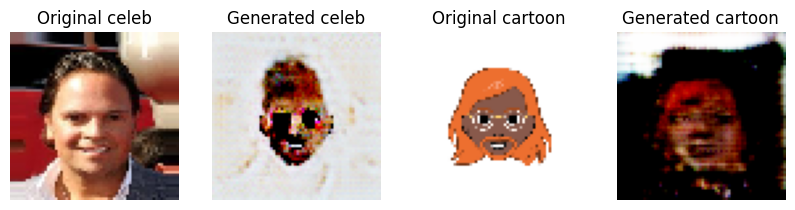

Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/1000 [00:00<09:26,  1.76it/s]

>1, dA[0.011 ,0.066 ] dB[0.008 ,0.004] g[5.678 ,5.849]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/1000 [00:01<09:20,  1.78it/s]

>2, dA[0.005 ,0.009 ] dB[0.002 ,0.002] g[4.967 ,5.704]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 3/1000 [00:01<09:18,  1.79it/s]

>3, dA[0.016 ,0.004 ] dB[0.001 ,0.001] g[5.174 ,5.726]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 4/1000 [00:02<09:15,  1.79it/s]

>4, dA[0.045 ,0.022 ] dB[0.001 ,0.000] g[5.151 ,6.394]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 5/1000 [00:02<09:16,  1.79it/s]

>5, dA[0.006 ,0.004 ] dB[0.000 ,0.041] g[5.319 ,6.179]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:15,  1.79it/s]

>6, dA[0.003 ,0.004 ] dB[0.005 ,0.006] g[6.229 ,6.473]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 7/1000 [00:03<09:16,  1.78it/s]

>7, dA[0.030 ,0.006 ] dB[0.003 ,0.003] g[5.362 ,5.207]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 8/1000 [00:04<09:15,  1.79it/s]

>8, dA[0.047 ,0.146 ] dB[0.001 ,0.029] g[5.366 ,6.103]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:05<09:16,  1.78it/s]

>9, dA[0.005 ,0.011 ] dB[0.003 ,0.004] g[7.975 ,9.411]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:16,  1.78it/s]

>10, dA[0.043 ,0.044 ] dB[0.087 ,0.003] g[5.365 ,5.531]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [00:06<09:15,  1.78it/s]

>11, dA[0.013 ,0.005 ] dB[0.007 ,0.068] g[5.489 ,5.788]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 12/1000 [00:06<09:13,  1.78it/s]

>12, dA[0.016 ,0.261 ] dB[0.022 ,0.007] g[7.671 ,8.549]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:13,  1.78it/s]

>13, dA[0.075 ,0.045 ] dB[0.042 ,0.007] g[5.086 ,5.282]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:13,  1.78it/s]

>14, dA[0.003 ,0.016 ] dB[0.015 ,0.028] g[5.477 ,6.817]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:12,  1.78it/s]

>15, dA[0.127 ,0.005 ] dB[0.010 ,0.008] g[4.689 ,5.510]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 16/1000 [00:08<09:10,  1.79it/s]

>16, dA[0.006 ,0.114 ] dB[0.003 ,0.003] g[5.655 ,7.072]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:12,  1.78it/s]

>17, dA[0.003 ,0.032 ] dB[0.003 ,0.002] g[6.312 ,7.525]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:11,  1.78it/s]

>18, dA[0.003 ,0.029 ] dB[0.004 ,0.205] g[7.112 ,9.351]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:09,  1.79it/s]

>19, dA[0.005 ,0.011 ] dB[0.021 ,0.031] g[6.231 ,6.390]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:08,  1.79it/s]

>20, dA[0.024 ,0.010 ] dB[0.110 ,0.010] g[6.836 ,7.505]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:08,  1.78it/s]

>21, dA[0.028 ,0.013 ] dB[0.021 ,0.009] g[6.011 ,6.200]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:08,  1.78it/s]

>22, dA[0.159 ,0.045 ] dB[0.008 ,0.006] g[5.041 ,4.545]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:07,  1.78it/s]

>23, dA[0.002 ,0.034 ] dB[0.002 ,0.002] g[4.851 ,4.159]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:06,  1.79it/s]

>24, dA[0.031 ,0.010 ] dB[0.049 ,0.028] g[5.390 ,5.204]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:09,  1.78it/s]

>25, dA[0.011 ,0.003 ] dB[0.005 ,0.011] g[4.499 ,4.322]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:07,  1.78it/s]

>26, dA[0.008 ,0.567 ] dB[0.003 ,0.009] g[4.715 ,4.721]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:08,  1.77it/s]

>27, dA[0.155 ,0.007 ] dB[0.003 ,0.018] g[5.875 ,6.609]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:07,  1.78it/s]

>28, dA[0.010 ,0.004 ] dB[0.004 ,0.003] g[4.973 ,4.994]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:08,  1.77it/s]

>29, dA[0.018 ,0.014 ] dB[0.001 ,0.003] g[5.338 ,5.719]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:08,  1.77it/s]

>30, dA[0.035 ,0.010 ] dB[0.001 ,0.003] g[5.152 ,5.250]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:07,  1.77it/s]

>31, dA[0.047 ,0.007 ] dB[0.095 ,0.025] g[4.382 ,4.508]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 32/1000 [00:17<09:05,  1.77it/s]

>32, dA[0.007 ,0.147 ] dB[0.005 ,0.210] g[4.848 ,5.561]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:06,  1.77it/s]

>33, dA[0.002 ,0.010 ] dB[0.043 ,0.032] g[4.881 ,4.866]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:04,  1.77it/s]

>34, dA[0.496 ,0.036 ] dB[0.015 ,0.004] g[4.869 ,5.105]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:02,  1.78it/s]

>35, dA[0.024 ,0.247 ] dB[0.098 ,0.017] g[5.807 ,5.307]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:01,  1.78it/s]

>36, dA[0.030 ,0.052 ] dB[0.014 ,0.423] g[4.271 ,5.227]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 37/1000 [00:20<09:02,  1.77it/s]

>37, dA[0.112 ,0.026 ] dB[0.077 ,0.042] g[6.478 ,6.618]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:01,  1.78it/s]

>38, dA[0.004 ,0.008 ] dB[0.030 ,0.009] g[5.271 ,4.760]
1/1 [==============================] - 0s 29ms/step



Batchs:   4%|▍         | 39/1000 [00:21<09:12,  1.74it/s]

>39, dA[0.040 ,0.004 ] dB[0.007 ,0.004] g[5.912 ,5.608]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 40/1000 [00:22<09:09,  1.75it/s]

>40, dA[0.007 ,0.004 ] dB[0.009 ,0.004] g[5.611 ,5.462]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:09,  1.74it/s]

>41, dA[0.025 ,0.492 ] dB[0.008 ,0.003] g[5.184 ,5.588]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 42/1000 [00:23<09:10,  1.74it/s]

>42, dA[0.026 ,0.022 ] dB[0.004 ,0.011] g[5.119 ,4.576]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 43/1000 [00:24<09:06,  1.75it/s]

>43, dA[0.309 ,0.015 ] dB[0.510 ,0.056] g[5.853 ,6.745]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:24<09:03,  1.76it/s]

>44, dA[0.017 ,0.315 ] dB[0.037 ,0.030] g[4.338 ,4.427]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 45/1000 [00:25<09:05,  1.75it/s]

>45, dA[0.058 ,0.026 ] dB[0.012 ,0.010] g[5.170 ,6.591]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 46/1000 [00:25<09:01,  1.76it/s]

>46, dA[0.032 ,0.013 ] dB[0.002 ,0.040] g[5.005 ,5.950]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:57,  1.77it/s]

>47, dA[0.014 ,0.018 ] dB[0.051 ,0.003] g[5.069 ,5.584]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 48/1000 [00:27<08:55,  1.78it/s]

>48, dA[0.009 ,0.036 ] dB[0.005 ,0.003] g[5.572 ,6.145]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:56,  1.77it/s]

>49, dA[0.038 ,0.003 ] dB[0.001 ,0.042] g[6.878 ,8.131]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:55,  1.78it/s]

>50, dA[0.046 ,0.003 ] dB[0.006 ,0.007] g[6.325 ,6.321]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:53,  1.78it/s]

>51, dA[0.006 ,0.044 ] dB[0.035 ,0.006] g[5.396 ,4.880]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:51,  1.78it/s]

>52, dA[0.002 ,0.005 ] dB[0.002 ,0.004] g[5.721 ,6.010]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:54,  1.77it/s]

>53, dA[0.046 ,0.200 ] dB[0.072 ,0.188] g[4.930 ,4.666]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 54/1000 [00:30<08:52,  1.78it/s]

>54, dA[0.012 ,0.005 ] dB[0.259 ,0.011] g[6.143 ,6.207]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:50,  1.78it/s]

>55, dA[0.339 ,0.115 ] dB[0.016 ,0.010] g[5.250 ,5.859]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:49,  1.78it/s]

>56, dA[0.046 ,0.016 ] dB[0.007 ,0.003] g[6.232 ,7.115]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 57/1000 [00:32<08:51,  1.78it/s]

>57, dA[0.172 ,0.026 ] dB[0.004 ,0.003] g[4.870 ,5.233]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 58/1000 [00:32<08:49,  1.78it/s]

>58, dA[0.011 ,0.060 ] dB[0.124 ,0.056] g[6.495 ,6.689]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 59/1000 [00:33<08:48,  1.78it/s]

>59, dA[0.003 ,0.029 ] dB[0.020 ,0.007] g[5.153 ,5.814]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 60/1000 [00:33<08:50,  1.77it/s]

>60, dA[0.039 ,0.013 ] dB[0.008 ,0.002] g[4.156 ,5.217]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:49,  1.77it/s]

>61, dA[0.003 ,0.003 ] dB[0.004 ,0.002] g[6.033 ,8.314]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 62/1000 [00:34<08:48,  1.78it/s]

>62, dA[0.168 ,0.138 ] dB[0.004 ,0.143] g[5.069 ,7.263]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:46,  1.78it/s]

>63, dA[0.009 ,0.004 ] dB[0.039 ,0.022] g[5.925 ,4.738]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 64/1000 [00:36<08:44,  1.78it/s]

>64, dA[0.084 ,0.174 ] dB[0.199 ,0.032] g[5.525 ,5.366]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:45,  1.78it/s]

>65, dA[0.009 ,0.008 ] dB[0.027 ,0.130] g[5.732 ,7.112]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:43,  1.78it/s]

>66, dA[0.011 ,0.003 ] dB[0.031 ,0.009] g[6.037 ,6.724]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [00:37<08:42,  1.78it/s]

>67, dA[0.075 ,0.004 ] dB[0.066 ,0.007] g[6.621 ,7.155]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:42,  1.78it/s]

>68, dA[0.031 ,0.107 ] dB[0.010 ,0.080] g[4.584 ,4.790]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 69/1000 [00:38<08:43,  1.78it/s]

>69, dA[0.014 ,0.043 ] dB[0.025 ,0.020] g[4.677 ,4.168]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:42,  1.78it/s]

>70, dA[0.013 ,0.005 ] dB[0.147 ,0.024] g[6.721 ,7.877]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 71/1000 [00:39<08:40,  1.79it/s]

>71, dA[0.024 ,0.007 ] dB[0.037 ,0.004] g[4.813 ,5.603]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [00:40<08:38,  1.79it/s]

>72, dA[0.087 ,0.007 ] dB[0.009 ,0.011] g[4.715 ,5.853]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:39,  1.78it/s]

>73, dA[0.038 ,0.010 ] dB[0.004 ,0.045] g[3.837 ,3.716]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 74/1000 [00:41<08:41,  1.78it/s]

>74, dA[0.020 ,0.009 ] dB[0.016 ,0.155] g[4.006 ,4.311]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:46,  1.76it/s]

>75, dA[0.004 ,0.013 ] dB[0.190 ,0.008] g[5.687 ,4.654]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 76/1000 [00:42<08:42,  1.77it/s]

>76, dA[0.007 ,0.324 ] dB[0.011 ,0.004] g[4.692 ,3.795]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:41,  1.77it/s]

>77, dA[0.024 ,0.091 ] dB[0.002 ,0.002] g[5.723 ,5.574]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 78/1000 [00:43<08:42,  1.76it/s]

>78, dA[0.075 ,0.033 ] dB[0.001 ,0.008] g[5.936 ,7.246]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:39,  1.77it/s]

>79, dA[0.014 ,0.030 ] dB[0.001 ,0.031] g[4.587 ,5.201]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:38,  1.77it/s]

>80, dA[0.010 ,0.015 ] dB[0.006 ,0.004] g[7.318 ,8.706]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 81/1000 [00:45<08:38,  1.77it/s]

>81, dA[0.051 ,0.065 ] dB[0.012 ,0.001] g[4.812 ,4.947]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:37,  1.77it/s]

>82, dA[0.002 ,0.003 ] dB[0.008 ,0.000] g[4.336 ,4.578]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:46<08:35,  1.78it/s]

>83, dA[0.011 ,0.068 ] dB[0.084 ,0.050] g[5.884 ,6.384]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:35,  1.78it/s]

>84, dA[0.002 ,0.003 ] dB[0.019 ,0.020] g[4.196 ,5.385]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [00:47<08:36,  1.77it/s]

>85, dA[0.005 ,0.018 ] dB[0.006 ,0.012] g[4.326 ,5.600]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:35,  1.77it/s]

>86, dA[0.394 ,0.340 ] dB[0.002 ,0.189] g[3.952 ,4.702]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 87/1000 [00:48<08:32,  1.78it/s]

>87, dA[0.109 ,0.003 ] dB[0.211 ,0.035] g[5.372 ,5.271]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:49<08:32,  1.78it/s]

>88, dA[0.013 ,0.012 ] dB[0.022 ,0.007] g[5.925 ,6.246]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:34,  1.77it/s]

>89, dA[0.151 ,0.020 ] dB[0.004 ,0.003] g[5.189 ,4.628]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:50<08:33,  1.77it/s]

>90, dA[0.002 ,0.053 ] dB[0.003 ,0.004] g[5.617 ,4.995]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:31,  1.78it/s]

>91, dA[0.002 ,0.008 ] dB[0.011 ,0.007] g[4.635 ,5.328]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 92/1000 [00:51<08:32,  1.77it/s]

>92, dA[0.011 ,0.010 ] dB[0.003 ,0.010] g[4.666 ,4.201]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:32,  1.77it/s]

>93, dA[0.048 ,0.002 ] dB[0.002 ,0.001] g[5.360 ,4.610]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 94/1000 [00:52<08:30,  1.77it/s]

>94, dA[0.018 ,0.013 ] dB[0.037 ,0.009] g[4.504 ,3.865]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 95/1000 [00:53<08:39,  1.74it/s]

>95, dA[0.005 ,0.180 ] dB[0.002 ,0.003] g[5.929 ,5.907]
1/1 [==============================] - 0s 31ms/step



Batchs:  10%|▉         | 96/1000 [00:54<08:45,  1.72it/s]

>96, dA[0.158 ,0.008 ] dB[0.005 ,0.007] g[4.596 ,5.587]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 97/1000 [00:54<08:44,  1.72it/s]

>97, dA[0.007 ,0.075 ] dB[0.004 ,0.002] g[6.185 ,6.368]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:39,  1.74it/s]

>98, dA[0.019 ,0.014 ] dB[0.006 ,0.000] g[3.890 ,4.171]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 99/1000 [00:55<08:35,  1.75it/s]

>99, dA[0.004 ,0.019 ] dB[0.009 ,0.026] g[4.415 ,5.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:30,  1.76it/s]

>100, dA[0.022 ,0.007 ] dB[0.018 ,0.025] g[5.297 ,5.533]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 101/1000 [00:56<08:29,  1.76it/s]

>101, dA[0.007 ,0.282 ] dB[0.005 ,0.009] g[5.563 ,5.540]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 102/1000 [00:57<08:28,  1.77it/s]

>102, dA[0.026 ,0.013 ] dB[0.004 ,0.007] g[6.657 ,6.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:58<08:25,  1.77it/s]

>103, dA[0.023 ,0.018 ] dB[0.032 ,0.003] g[5.269 ,5.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:58<08:23,  1.78it/s]

>104, dA[0.020 ,0.011 ] dB[0.026 ,0.062] g[6.517 ,7.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [00:59<08:23,  1.78it/s]

>105, dA[0.119 ,0.034 ] dB[0.005 ,0.007] g[4.880 ,5.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [00:59<08:21,  1.78it/s]

>106, dA[0.039 ,0.181 ] dB[0.002 ,0.008] g[5.229 ,4.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:20,  1.78it/s]

>107, dA[0.006 ,0.034 ] dB[0.002 ,0.002] g[5.178 ,6.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [01:00<08:19,  1.79it/s]

>108, dA[0.007 ,0.013 ] dB[0.012 ,0.003] g[6.578 ,7.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:20,  1.78it/s]

>109, dA[0.101 ,0.074 ] dB[0.011 ,0.007] g[4.533 ,5.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 110/1000 [01:02<08:19,  1.78it/s]

>110, dA[0.002 ,0.002 ] dB[0.010 ,0.034] g[4.323 ,4.688]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 111/1000 [01:02<08:19,  1.78it/s]

>111, dA[0.005 ,0.002 ] dB[0.307 ,0.368] g[4.023 ,4.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 112/1000 [01:03<08:18,  1.78it/s]

>112, dA[0.230 ,0.031 ] dB[0.010 ,0.004] g[4.512 ,5.173]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 113/1000 [01:03<08:19,  1.78it/s]

>113, dA[0.041 ,0.014 ] dB[0.074 ,0.289] g[5.752 ,6.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:17,  1.78it/s]

>114, dA[0.007 ,0.007 ] dB[0.062 ,0.005] g[5.277 ,4.740]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 115/1000 [01:04<08:16,  1.78it/s]

>115, dA[0.028 ,0.437 ] dB[0.053 ,0.016] g[5.790 ,5.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:13,  1.79it/s]

>116, dA[0.053 ,0.021 ] dB[0.005 ,0.002] g[5.538 ,6.425]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 117/1000 [01:05<08:16,  1.78it/s]

>117, dA[0.131 ,0.023 ] dB[0.008 ,0.041] g[4.787 ,5.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:15,  1.78it/s]

>118, dA[0.025 ,0.005 ] dB[0.098 ,0.004] g[5.421 ,5.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [01:07<08:14,  1.78it/s]

>119, dA[0.010 ,0.036 ] dB[0.013 ,0.002] g[3.899 ,5.371]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 120/1000 [01:07<08:12,  1.79it/s]

>120, dA[0.009 ,0.025 ] dB[0.003 ,0.002] g[4.379 ,5.573]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:12,  1.78it/s]

>121, dA[0.017 ,0.018 ] dB[0.001 ,0.236] g[4.193 ,4.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 122/1000 [01:08<08:11,  1.79it/s]

>122, dA[0.079 ,0.190 ] dB[0.056 ,0.005] g[4.768 ,4.467]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:10,  1.79it/s]

>123, dA[0.029 ,0.010 ] dB[0.032 ,0.011] g[4.520 ,4.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:09<08:09,  1.79it/s]

>124, dA[0.088 ,0.012 ] dB[0.217 ,0.377] g[4.772 ,4.421]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:10,  1.78it/s]

>125, dA[0.009 ,0.382 ] dB[0.055 ,0.005] g[5.041 ,4.857]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 126/1000 [01:10<08:10,  1.78it/s]

>126, dA[0.091 ,0.011 ] dB[0.044 ,0.004] g[4.438 ,4.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:11<08:08,  1.79it/s]

>127, dA[0.255 ,0.109 ] dB[0.010 ,0.028] g[5.268 ,6.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:08,  1.78it/s]

>128, dA[0.257 ,0.044 ] dB[0.004 ,0.020] g[5.018 ,5.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:12<08:09,  1.78it/s]

>129, dA[0.055 ,0.008 ] dB[0.020 ,0.008] g[5.824 ,6.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:07,  1.78it/s]

>130, dA[0.085 ,0.403 ] dB[0.004 ,0.002] g[5.543 ,5.568]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 131/1000 [01:13<08:08,  1.78it/s]

>131, dA[0.004 ,0.009 ] dB[0.004 ,0.011] g[5.632 ,5.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:06,  1.78it/s]

>132, dA[0.084 ,0.020 ] dB[0.000 ,0.013] g[5.783 ,6.290]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 133/1000 [01:14<08:08,  1.77it/s]

>133, dA[0.008 ,0.004 ] dB[0.011 ,0.004] g[5.140 ,5.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:07,  1.78it/s]

>134, dA[0.006 ,0.180 ] dB[0.002 ,0.003] g[5.328 ,5.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 135/1000 [01:16<08:05,  1.78it/s]

>135, dA[0.379 ,0.018 ] dB[0.005 ,0.036] g[4.497 ,4.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 136/1000 [01:16<08:04,  1.78it/s]

>136, dA[0.007 ,0.173 ] dB[0.017 ,0.007] g[5.277 ,5.580]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:04,  1.78it/s]

>137, dA[0.052 ,0.006 ] dB[0.008 ,0.003] g[4.363 ,4.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:17<08:04,  1.78it/s]

>138, dA[0.059 ,0.101 ] dB[0.002 ,0.001] g[4.739 ,4.990]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:01,  1.79it/s]

>139, dA[0.020 ,0.045 ] dB[0.001 ,0.005] g[5.091 ,5.211]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:18<08:00,  1.79it/s]

>140, dA[0.006 ,0.017 ] dB[0.001 ,0.001] g[5.316 ,5.384]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:01,  1.78it/s]

>141, dA[0.074 ,0.028 ] dB[0.001 ,0.001] g[4.520 ,4.768]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 142/1000 [01:19<08:00,  1.78it/s]

>142, dA[0.141 ,0.019 ] dB[0.002 ,0.002] g[4.654 ,4.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:20<07:59,  1.79it/s]

>143, dA[0.016 ,0.005 ] dB[0.000 ,0.020] g[6.385 ,6.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<07:58,  1.79it/s]

>144, dA[0.002 ,0.019 ] dB[0.004 ,0.004] g[5.766 ,5.461]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:21<07:58,  1.79it/s]

>145, dA[0.063 ,0.245 ] dB[0.421 ,0.030] g[4.770 ,4.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<07:59,  1.78it/s]

>146, dA[0.008 ,0.163 ] dB[0.049 ,0.615] g[3.419 ,3.771]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 147/1000 [01:22<07:58,  1.78it/s]

>147, dA[0.316 ,0.009 ] dB[0.104 ,0.117] g[4.050 ,5.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<07:56,  1.79it/s]

>148, dA[0.020 ,0.006 ] dB[0.151 ,0.012] g[7.497 ,9.248]
1/1 [==============================] - 0s 27ms/step



Batchs:  15%|█▍        | 149/1000 [01:23<08:01,  1.77it/s]

>149, dA[0.171 ,0.029 ] dB[0.094 ,0.003] g[4.334 ,4.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<08:01,  1.76it/s]

>150, dA[0.024 ,0.002 ] dB[0.026 ,0.157] g[4.881 ,5.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<08:03,  1.76it/s]

>151, dA[0.095 ,0.449 ] dB[0.038 ,0.028] g[4.851 ,3.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:25<08:04,  1.75it/s]

>152, dA[0.021 ,0.231 ] dB[0.098 ,0.111] g[4.492 ,3.854]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<08:03,  1.75it/s]

>153, dA[0.463 ,0.017 ] dB[0.007 ,0.022] g[4.337 ,5.543]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 154/1000 [01:26<08:02,  1.75it/s]

>154, dA[0.063 ,0.027 ] dB[0.009 ,0.001] g[5.111 ,5.533]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<08:01,  1.76it/s]

>155, dA[0.016 ,0.182 ] dB[0.015 ,0.016] g[4.348 ,4.076]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 156/1000 [01:27<07:57,  1.77it/s]

>156, dA[0.086 ,0.013 ] dB[0.002 ,0.005] g[4.428 ,4.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:56,  1.77it/s]

>157, dA[0.023 ,0.272 ] dB[0.097 ,0.014] g[5.267 ,5.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:29<07:54,  1.78it/s]

>158, dA[0.020 ,0.037 ] dB[0.010 ,0.505] g[5.158 ,6.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:29<07:53,  1.78it/s]

>159, dA[0.098 ,0.012 ] dB[0.081 ,0.048] g[4.503 ,4.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:51,  1.78it/s]

>160, dA[0.012 ,0.217 ] dB[0.098 ,0.019] g[5.558 ,4.667]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 161/1000 [01:30<07:52,  1.78it/s]

>161, dA[0.261 ,0.002 ] dB[0.054 ,0.119] g[5.922 ,7.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:52,  1.78it/s]

>162, dA[0.003 ,0.215 ] dB[0.024 ,0.023] g[4.749 ,4.321]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 163/1000 [01:31<07:49,  1.78it/s]

>163, dA[0.027 ,0.043 ] dB[0.052 ,0.030] g[5.173 ,5.183]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:50,  1.78it/s]

>164, dA[0.075 ,0.027 ] dB[0.054 ,0.032] g[4.902 ,6.284]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 165/1000 [01:32<07:51,  1.77it/s]

>165, dA[0.064 ,0.066 ] dB[0.006 ,0.008] g[4.385 ,4.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:50,  1.77it/s]

>166, dA[0.090 ,0.189 ] dB[0.004 ,0.007] g[4.976 ,5.354]
1/1 [==============================] - 0s 28ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:53,  1.76it/s]

>167, dA[0.097 ,0.025 ] dB[0.003 ,0.009] g[4.693 ,5.040]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 168/1000 [01:34<07:50,  1.77it/s]

>168, dA[0.005 ,0.017 ] dB[0.003 ,0.008] g[5.882 ,6.588]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:48,  1.77it/s]

>169, dA[0.039 ,0.120 ] dB[0.005 ,0.002] g[4.751 ,4.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 170/1000 [01:35<07:47,  1.78it/s]

>170, dA[0.016 ,0.013 ] dB[0.005 ,0.004] g[5.708 ,5.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:45,  1.78it/s]

>171, dA[0.021 ,0.007 ] dB[0.242 ,0.088] g[4.814 ,5.266]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 172/1000 [01:36<07:44,  1.78it/s]

>172, dA[0.012 ,0.008 ] dB[0.026 ,0.464] g[4.040 ,5.666]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:43,  1.78it/s]

>173, dA[0.012 ,0.037 ] dB[0.095 ,0.047] g[6.527 ,8.472]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 174/1000 [01:38<07:43,  1.78it/s]

>174, dA[0.017 ,0.010 ] dB[0.026 ,0.005] g[4.627 ,5.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:38<07:42,  1.78it/s]

>175, dA[0.063 ,0.030 ] dB[0.012 ,0.101] g[4.735 ,5.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:40,  1.79it/s]

>176, dA[0.007 ,0.088 ] dB[0.083 ,0.004] g[5.651 ,5.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:39<07:41,  1.78it/s]

>177, dA[0.045 ,0.007 ] dB[0.026 ,0.009] g[5.891 ,7.078]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:41,  1.78it/s]

>178, dA[0.069 ,0.027 ] dB[0.002 ,0.006] g[4.277 ,4.206]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 179/1000 [01:40<07:39,  1.78it/s]

>179, dA[0.009 ,0.070 ] dB[0.034 ,0.013] g[7.316 ,7.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:38,  1.79it/s]

>180, dA[0.123 ,0.140 ] dB[0.004 ,0.003] g[4.880 ,5.107]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 181/1000 [01:41<07:38,  1.79it/s]

>181, dA[0.019 ,0.170 ] dB[0.002 ,0.005] g[5.509 ,6.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:37,  1.79it/s]

>182, dA[0.222 ,0.004 ] dB[0.004 ,0.017] g[6.638 ,8.251]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:39,  1.78it/s]

>183, dA[0.013 ,0.013 ] dB[0.031 ,0.008] g[7.406 ,8.845]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 184/1000 [01:43<07:39,  1.78it/s]

>184, dA[0.058 ,0.217 ] dB[0.006 ,0.001] g[5.172 ,5.072]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:41,  1.77it/s]

>185, dA[0.003 ,0.015 ] dB[0.003 ,0.001] g[4.814 ,4.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:44<07:39,  1.77it/s]

>186, dA[0.033 ,0.016 ] dB[0.001 ,0.001] g[5.051 ,4.886]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:36,  1.78it/s]

>187, dA[0.070 ,0.239 ] dB[0.001 ,0.001] g[6.705 ,7.399]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 188/1000 [01:45<07:35,  1.78it/s]

>188, dA[0.015 ,0.005 ] dB[0.001 ,0.001] g[5.558 ,7.043]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:35,  1.78it/s]

>189, dA[0.004 ,0.002 ] dB[0.002 ,0.004] g[5.323 ,5.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 190/1000 [01:46<07:33,  1.78it/s]

>190, dA[0.013 ,0.009 ] dB[0.008 ,0.011] g[4.920 ,5.029]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 191/1000 [01:47<07:33,  1.79it/s]

>191, dA[0.013 ,0.010 ] dB[0.004 ,0.002] g[6.898 ,8.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:32,  1.78it/s]

>192, dA[0.043 ,0.032 ] dB[0.002 ,0.009] g[5.282 ,5.315]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 193/1000 [01:48<07:34,  1.78it/s]

>193, dA[0.004 ,0.048 ] dB[0.052 ,0.187] g[5.025 ,4.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:32,  1.78it/s]

>194, dA[0.027 ,0.009 ] dB[0.472 ,0.036] g[5.189 ,5.700]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 195/1000 [01:49<07:31,  1.78it/s]

>195, dA[0.176 ,0.044 ] dB[0.293 ,0.145] g[4.601 ,5.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:31,  1.78it/s]

>196, dA[0.201 ,0.034 ] dB[0.167 ,0.147] g[4.141 ,4.234]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 197/1000 [01:50<07:31,  1.78it/s]

>197, dA[0.169 ,0.299 ] dB[0.137 ,0.156] g[6.486 ,7.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:30,  1.78it/s]

>198, dA[0.048 ,0.070 ] dB[0.096 ,0.173] g[4.600 ,4.938]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 199/1000 [01:52<07:28,  1.78it/s]

>199, dA[0.093 ,0.021 ] dB[0.194 ,0.130] g[4.724 ,5.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:52<07:28,  1.79it/s]

>200, dA[0.018 ,0.010 ] dB[0.140 ,0.094] g[4.871 ,5.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:28,  1.78it/s]

>201, dA[0.016 ,0.162 ] dB[0.077 ,0.096] g[5.061 ,5.428]
1/1 [==============================] - 0s 20ms/step




Batchs:  12%|█▏        | 122/1000 [01:08<08:18,  1.76it/s]

>122, dA[0.002 ,0.128 ] dB[0.004 ,0.002] g[4.511 ,4.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:14,  1.77it/s]

>123, dA[0.009 ,0.005 ] dB[0.001 ,0.018] g[4.536 ,4.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:09<08:13,  1.78it/s]

>124, dA[0.087 ,0.005 ] dB[0.003 ,0.002] g[4.888 ,5.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:12,  1.78it/s]

>125, dA[0.008 ,0.006 ] dB[0.003 ,0.002] g[4.723 ,5.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 126/1000 [01:10<08:13,  1.77it/s]

>126, dA[0.003 ,0.045 ] dB[0.001 ,0.001] g[4.823 ,5.064]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 127/1000 [01:11<08:12,  1.77it/s]

>127, dA[0.161 ,0.035 ] dB[0.034 ,0.003] g[4.294 ,4.497]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:10,  1.78it/s]

>128, dA[0.009 ,0.006 ] dB[0.011 ,0.003] g[3.532 ,4.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:12<08:09,  1.78it/s]

>129, dA[0.047 ,0.013 ] dB[0.003 ,0.281] g[6.567 ,8.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:09,  1.78it/s]

>130, dA[0.010 ,0.023 ] dB[0.083 ,0.032] g[5.172 ,5.353]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 131/1000 [01:13<08:08,  1.78it/s]

>131, dA[0.003 ,0.080 ] dB[0.009 ,0.011] g[5.603 ,4.955]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:06,  1.78it/s]

>132, dA[0.322 ,0.005 ] dB[0.007 ,0.003] g[5.737 ,6.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 133/1000 [01:14<08:05,  1.79it/s]

>133, dA[0.009 ,0.065 ] dB[0.002 ,0.003] g[7.830 ,9.524]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:05,  1.78it/s]

>134, dA[0.016 ,0.007 ] dB[0.003 ,0.001] g[4.893 ,5.056]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 135/1000 [01:15<08:04,  1.79it/s]

>135, dA[0.006 ,0.011 ] dB[0.040 ,0.004] g[5.718 ,5.975]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 136/1000 [01:16<08:03,  1.79it/s]

>136, dA[0.003 ,0.006 ] dB[0.003 ,0.006] g[4.340 ,5.710]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:03,  1.79it/s]

>137, dA[0.001 ,0.005 ] dB[0.004 ,0.071] g[5.111 ,4.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:17<08:04,  1.78it/s]

>138, dA[0.008 ,0.072 ] dB[0.008 ,0.019] g[6.367 ,6.309]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:02,  1.78it/s]

>139, dA[0.005 ,0.015 ] dB[0.007 ,0.002] g[4.602 ,4.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:18<08:02,  1.78it/s]

>140, dA[0.019 ,0.048 ] dB[0.003 ,0.002] g[6.220 ,6.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:01,  1.78it/s]

>141, dA[0.012 ,0.013 ] dB[0.004 ,0.001] g[5.172 ,5.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [01:19<08:01,  1.78it/s]

>142, dA[0.175 ,0.008 ] dB[0.001 ,0.002] g[4.290 ,4.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:20<08:05,  1.77it/s]

>143, dA[0.051 ,0.444 ] dB[0.001 ,0.001] g[4.733 ,4.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<08:03,  1.77it/s]

>144, dA[0.008 ,0.018 ] dB[0.156 ,0.033] g[4.474 ,4.276]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 145/1000 [01:21<08:02,  1.77it/s]

>145, dA[0.085 ,0.005 ] dB[0.015 ,0.072] g[3.559 ,4.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<08:03,  1.76it/s]

>146, dA[0.006 ,0.078 ] dB[0.020 ,0.003] g[4.611 ,4.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 147/1000 [01:22<08:01,  1.77it/s]

>147, dA[0.004 ,0.013 ] dB[0.003 ,0.001] g[4.514 ,4.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<08:01,  1.77it/s]

>148, dA[0.008 ,0.010 ] dB[0.001 ,0.002] g[6.034 ,6.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 149/1000 [01:23<07:58,  1.78it/s]

>149, dA[0.007 ,0.051 ] dB[0.000 ,0.002] g[4.216 ,3.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<07:58,  1.77it/s]

>150, dA[0.007 ,0.024 ] dB[0.002 ,0.001] g[4.082 ,3.278]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<07:58,  1.77it/s]

>151, dA[0.007 ,0.009 ] dB[0.005 ,0.002] g[5.896 ,6.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:25<07:56,  1.78it/s]

>152, dA[0.005 ,0.281 ] dB[0.008 ,0.002] g[4.394 ,3.974]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:54,  1.78it/s]

>153, dA[0.220 ,0.008 ] dB[0.097 ,0.209] g[3.384 ,5.531]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 154/1000 [01:26<07:55,  1.78it/s]

>154, dA[0.294 ,0.041 ] dB[0.227 ,0.009] g[4.601 ,5.187]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<07:53,  1.79it/s]

>155, dA[0.023 ,0.024 ] dB[0.021 ,0.016] g[4.778 ,5.153]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 156/1000 [01:27<07:51,  1.79it/s]

>156, dA[0.009 ,0.008 ] dB[0.004 ,0.011] g[5.502 ,6.503]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:53,  1.78it/s]

>157, dA[0.002 ,0.004 ] dB[0.004 ,0.012] g[4.223 ,5.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 158/1000 [01:28<07:55,  1.77it/s]

>158, dA[0.004 ,0.003 ] dB[0.003 ,0.004] g[4.392 ,4.844]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 159/1000 [01:29<07:53,  1.77it/s]

>159, dA[0.051 ,0.085 ] dB[0.049 ,0.185] g[4.106 ,4.465]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:51,  1.78it/s]

>160, dA[0.216 ,0.027 ] dB[0.003 ,0.040] g[4.975 ,5.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [01:30<07:50,  1.78it/s]

>161, dA[0.050 ,0.020 ] dB[0.473 ,0.058] g[5.353 ,5.113]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:57,  1.75it/s]

>162, dA[0.007 ,0.029 ] dB[0.042 ,0.055] g[4.307 ,4.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 163/1000 [01:31<07:58,  1.75it/s]

>163, dA[0.323 ,0.007 ] dB[0.011 ,0.008] g[4.531 ,4.640]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:58,  1.75it/s]

>164, dA[0.013 ,0.065 ] dB[0.002 ,0.051] g[5.572 ,6.694]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 165/1000 [01:32<07:54,  1.76it/s]

>165, dA[0.007 ,0.188 ] dB[0.003 ,0.004] g[4.930 ,4.788]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:52,  1.76it/s]

>166, dA[0.021 ,0.009 ] dB[0.302 ,0.245] g[5.250 ,6.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:48,  1.78it/s]

>167, dA[0.043 ,0.018 ] dB[0.061 ,0.010] g[4.510 ,4.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 168/1000 [01:34<07:47,  1.78it/s]

>168, dA[0.011 ,0.017 ] dB[0.004 ,0.002] g[5.977 ,7.171]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:45,  1.79it/s]

>169, dA[0.133 ,0.033 ] dB[0.002 ,0.005] g[4.790 ,5.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:35<07:45,  1.78it/s]

>170, dA[0.006 ,0.065 ] dB[0.002 ,0.002] g[5.873 ,6.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:43,  1.79it/s]

>171, dA[0.096 ,0.004 ] dB[0.004 ,0.001] g[4.767 ,4.891]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 172/1000 [01:36<07:41,  1.79it/s]

>172, dA[0.006 ,0.007 ] dB[0.002 ,0.001] g[4.041 ,4.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:41,  1.79it/s]

>173, dA[0.003 ,0.003 ] dB[0.001 ,0.002] g[5.072 ,5.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 174/1000 [01:37<07:43,  1.78it/s]

>174, dA[0.032 ,0.006 ] dB[0.001 ,0.018] g[4.352 ,4.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:38<07:41,  1.79it/s]

>175, dA[0.010 ,0.065 ] dB[0.003 ,0.002] g[5.052 ,5.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:40,  1.79it/s]

>176, dA[0.004 ,0.016 ] dB[0.004 ,0.001] g[5.110 ,4.756]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 177/1000 [01:39<07:40,  1.79it/s]

>177, dA[0.002 ,0.011 ] dB[0.020 ,0.001] g[5.771 ,6.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:41,  1.78it/s]

>178, dA[0.007 ,0.004 ] dB[0.268 ,0.305] g[4.496 ,5.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:40<07:45,  1.76it/s]

>179, dA[0.067 ,0.027 ] dB[0.016 ,0.013] g[3.623 ,3.544]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:43,  1.77it/s]

>180, dA[0.010 ,0.019 ] dB[0.039 ,0.010] g[5.635 ,6.057]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 181/1000 [01:41<07:39,  1.78it/s]

>181, dA[0.010 ,0.138 ] dB[0.010 ,0.011] g[4.688 ,5.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:38,  1.78it/s]

>182, dA[0.015 ,0.008 ] dB[0.004 ,0.005] g[5.127 ,5.771]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:38,  1.78it/s]

>183, dA[0.003 ,0.021 ] dB[0.004 ,0.003] g[4.857 ,6.915]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 184/1000 [01:43<07:37,  1.78it/s]

>184, dA[0.043 ,0.007 ] dB[0.002 ,0.000] g[4.861 ,4.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:36,  1.79it/s]

>185, dA[0.012 ,0.517 ] dB[0.002 ,0.021] g[4.243 ,3.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:44<07:35,  1.79it/s]

>186, dA[0.038 ,0.046 ] dB[0.002 ,0.003] g[4.700 ,5.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:34,  1.79it/s]

>187, dA[0.076 ,0.050 ] dB[0.000 ,0.005] g[4.629 ,4.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 188/1000 [01:45<07:34,  1.79it/s]

>188, dA[0.011 ,0.004 ] dB[0.001 ,0.003] g[3.997 ,4.276]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:33,  1.79it/s]

>189, dA[0.141 ,0.009 ] dB[0.001 ,0.001] g[4.566 ,5.338]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 190/1000 [01:46<07:33,  1.79it/s]

>190, dA[0.013 ,0.501 ] dB[0.006 ,0.033] g[4.771 ,4.687]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 191/1000 [01:47<07:32,  1.79it/s]

>191, dA[0.066 ,0.013 ] dB[0.001 ,0.010] g[4.868 ,5.557]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:32,  1.79it/s]

>192, dA[0.053 ,0.010 ] dB[0.096 ,0.019] g[4.932 ,5.294]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 193/1000 [01:48<07:31,  1.79it/s]

>193, dA[0.012 ,0.039 ] dB[0.005 ,0.002] g[5.169 ,6.538]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:33,  1.78it/s]

>194, dA[0.016 ,0.006 ] dB[0.034 ,0.019] g[3.517 ,4.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [01:49<07:31,  1.78it/s]

>195, dA[0.116 ,0.004 ] dB[0.006 ,0.312] g[4.142 ,5.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:31,  1.78it/s]

>196, dA[0.021 ,0.007 ] dB[0.044 ,0.056] g[5.060 ,3.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:50<07:30,  1.78it/s]

>197, dA[0.084 ,0.320 ] dB[0.013 ,0.015] g[5.328 ,4.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:30,  1.78it/s]

>198, dA[0.041 ,0.006 ] dB[0.018 ,0.003] g[4.705 ,5.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 199/1000 [01:51<07:29,  1.78it/s]

>199, dA[0.004 ,0.014 ] dB[0.057 ,0.007] g[5.976 ,6.895]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 200/1000 [01:52<07:30,  1.77it/s]

>200, dA[0.008 ,0.005 ] dB[0.027 ,0.010] g[4.738 ,5.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:28,  1.78it/s]

>201, dA[0.093 ,0.175 ] dB[0.006 ,0.005] g[3.422 ,3.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 202/1000 [01:53<07:27,  1.78it/s]

>202, dA[0.005 ,0.013 ] dB[0.003 ,0.002] g[5.406 ,6.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:26,  1.79it/s]

>203, dA[0.002 ,0.002 ] dB[0.074 ,0.002] g[5.201 ,5.946]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 204/1000 [01:54<07:23,  1.79it/s]

>204, dA[0.004 ,0.011 ] dB[0.013 ,0.110] g[5.662 ,6.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 205/1000 [01:55<07:23,  1.79it/s]

>205, dA[0.005 ,0.029 ] dB[0.023 ,0.004] g[5.343 ,5.738]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 206/1000 [01:55<07:23,  1.79it/s]

>206, dA[0.010 ,0.040 ] dB[0.014 ,0.004] g[5.911 ,6.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [01:56<07:22,  1.79it/s]

>207, dA[0.267 ,0.060 ] dB[0.006 ,0.003] g[6.372 ,6.630]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:22,  1.79it/s]

>208, dA[0.018 ,0.011 ] dB[0.005 ,0.004] g[4.503 ,4.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 209/1000 [01:57<07:21,  1.79it/s]

>209, dA[0.006 ,0.042 ] dB[0.002 ,0.001] g[5.022 ,5.229]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:23,  1.78it/s]

>210, dA[0.005 ,0.007 ] dB[0.006 ,0.000] g[5.439 ,6.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 211/1000 [01:58<07:22,  1.78it/s]

>211, dA[0.002 ,0.017 ] dB[0.002 ,0.001] g[4.846 ,6.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:22,  1.78it/s]

>212, dA[0.015 ,0.024 ] dB[0.002 ,0.002] g[4.714 ,5.345]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██▏       | 213/1000 [01:59<07:21,  1.78it/s]

>213, dA[0.288 ,0.095 ] dB[0.001 ,0.062] g[4.936 ,5.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [02:00<07:21,  1.78it/s]

>214, dA[0.003 ,0.048 ] dB[0.022 ,0.002] g[6.054 ,6.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 215/1000 [02:00<07:21,  1.78it/s]

>215, dA[0.005 ,0.003 ] dB[0.007 ,0.005] g[5.576 ,6.234]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 216/1000 [02:01<07:20,  1.78it/s]

>216, dA[0.002 ,0.003 ] dB[0.077 ,0.045] g[5.555 ,6.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:18,  1.79it/s]

>217, dA[0.051 ,0.008 ] dB[0.007 ,0.007] g[4.529 ,6.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 218/1000 [02:02<07:19,  1.78it/s]

>218, dA[0.007 ,0.004 ] dB[0.008 ,0.169] g[4.395 ,5.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:23,  1.76it/s]

>219, dA[0.004 ,0.028 ] dB[0.134 ,0.004] g[5.426 ,5.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 220/1000 [02:03<07:23,  1.76it/s]

>220, dA[0.007 ,0.026 ] dB[0.168 ,0.049] g[6.906 ,9.089]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 221/1000 [02:04<07:22,  1.76it/s]

>221, dA[0.056 ,0.003 ] dB[0.013 ,0.050] g[4.688 ,5.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 222/1000 [02:04<07:21,  1.76it/s]

>222, dA[0.016 ,0.017 ] dB[0.011 ,0.009] g[6.211 ,7.098]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 223/1000 [02:05<07:18,  1.77it/s]

>223, dA[0.006 ,0.003 ] dB[0.002 ,0.020] g[6.597 ,7.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:15,  1.78it/s]

>224, dA[0.008 ,0.288 ] dB[0.008 ,0.005] g[4.262 ,4.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [02:06<07:17,  1.77it/s]

>225, dA[0.034 ,0.022 ] dB[0.003 ,0.014] g[4.606 ,6.170]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:18,  1.76it/s]

>226, dA[0.060 ,0.016 ] dB[0.001 ,0.008] g[5.029 ,6.286]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 227/1000 [02:07<07:17,  1.77it/s]

>227, dA[0.008 ,0.018 ] dB[0.006 ,0.001] g[5.650 ,7.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:15,  1.77it/s]

>228, dA[0.058 ,0.021 ] dB[0.086 ,0.229] g[4.849 ,5.365]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 229/1000 [02:08<07:12,  1.78it/s]

>229, dA[0.004 ,0.133 ] dB[0.008 ,0.048] g[5.286 ,4.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [02:09<07:12,  1.78it/s]

>230, dA[0.006 ,0.027 ] dB[0.028 ,0.006] g[6.027 ,6.443]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 231/1000 [02:09<07:10,  1.78it/s]

>231, dA[0.012 ,0.283 ] dB[0.009 ,0.008] g[5.508 ,5.449]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 232/1000 [02:10<07:12,  1.78it/s]

>232, dA[0.092 ,0.023 ] dB[0.088 ,0.199] g[4.229 ,5.154]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:10,  1.78it/s]

>233, dA[0.049 ,0.009 ] dB[0.013 ,0.037] g[4.581 ,4.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:11<07:11,  1.78it/s]

>234, dA[0.017 ,0.045 ] dB[0.008 ,0.024] g[5.157 ,5.361]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:09,  1.78it/s]

>235, dA[0.002 ,0.009 ] dB[0.025 ,0.014] g[5.814 ,6.785]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 236/1000 [02:12<07:08,  1.78it/s]

>236, dA[0.038 ,0.010 ] dB[0.002 ,0.003] g[5.862 ,7.870]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 237/1000 [02:13<07:06,  1.79it/s]

>237, dA[0.008 ,0.003 ] dB[0.002 ,0.006] g[5.226 ,5.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 238/1000 [02:13<07:06,  1.79it/s]

>238, dA[0.004 ,0.004 ] dB[0.002 ,0.145] g[4.484 ,4.797]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 239/1000 [02:14<07:05,  1.79it/s]

>239, dA[0.018 ,0.006 ] dB[0.046 ,0.022] g[5.571 ,5.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 240/1000 [02:14<07:04,  1.79it/s]

>240, dA[0.005 ,0.005 ] dB[0.028 ,0.035] g[4.517 ,4.385]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 241/1000 [02:15<07:03,  1.79it/s]

>241, dA[0.018 ,0.004 ] dB[0.018 ,0.010] g[6.370 ,7.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:05,  1.78it/s]

>242, dA[0.106 ,0.011 ] dB[0.002 ,0.025] g[4.562 ,4.566]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 243/1000 [02:16<07:04,  1.78it/s]

>243, dA[0.044 ,0.035 ] dB[0.177 ,0.616] g[4.892 ,4.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:17<07:03,  1.78it/s]

>244, dA[0.036 ,0.023 ] dB[0.018 ,0.143] g[4.113 ,4.908]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 245/1000 [02:17<07:03,  1.78it/s]

>245, dA[0.009 ,0.009 ] dB[0.157 ,0.083] g[5.373 ,5.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 246/1000 [02:18<07:03,  1.78it/s]

>246, dA[0.005 ,0.143 ] dB[0.077 ,0.215] g[4.231 ,4.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 247/1000 [02:18<07:02,  1.78it/s]

>247, dA[0.036 ,0.002 ] dB[0.020 ,0.023] g[5.104 ,5.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 248/1000 [02:19<07:01,  1.78it/s]

>248, dA[0.022 ,0.002 ] dB[0.010 ,0.026] g[4.760 ,5.521]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<07:26,  1.68it/s]

>249, dA[0.016 ,0.068 ] dB[0.038 ,0.007] g[7.539 ,9.182]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 250/1000 [02:20<07:23,  1.69it/s]

>250, dA[0.072 ,0.020 ] dB[0.004 ,0.051] g[4.578 ,5.209]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<07:14,  1.72it/s]

>251, dA[0.050 ,0.032 ] dB[0.002 ,0.012] g[5.126 ,5.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:21<07:09,  1.74it/s]

>252, dA[0.069 ,0.075 ] dB[0.004 ,0.036] g[4.782 ,4.514]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 253/1000 [02:22<07:04,  1.76it/s]

>253, dA[0.004 ,0.006 ] dB[0.603 ,0.089] g[4.756 ,4.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 254/1000 [02:22<07:02,  1.77it/s]

>254, dA[0.003 ,0.004 ] dB[0.030 ,0.014] g[4.910 ,6.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 255/1000 [02:23<07:00,  1.77it/s]

>255, dA[0.017 ,0.011 ] dB[0.016 ,0.002] g[4.634 ,5.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:24<06:57,  1.78it/s]

>256, dA[0.007 ,0.016 ] dB[0.001 ,0.025] g[5.412 ,6.092]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 257/1000 [02:24<06:55,  1.79it/s]

>257, dA[0.005 ,0.007 ] dB[0.004 ,0.001] g[4.132 ,3.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<06:56,  1.78it/s]

>258, dA[0.027 ,0.428 ] dB[0.001 ,0.007] g[4.784 ,4.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:25<06:55,  1.78it/s]

>259, dA[0.129 ,0.018 ] dB[0.001 ,0.020] g[4.302 ,4.839]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:54,  1.79it/s]

>260, dA[0.005 ,0.004 ] dB[0.009 ,0.009] g[4.338 ,5.236]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 261/1000 [02:26<06:52,  1.79it/s]

>261, dA[0.010 ,0.004 ] dB[0.001 ,0.007] g[5.083 ,5.699]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 262/1000 [02:27<06:52,  1.79it/s]

>262, dA[0.006 ,0.014 ] dB[0.001 ,0.020] g[5.528 ,6.544]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 263/1000 [02:27<06:51,  1.79it/s]

>263, dA[0.006 ,0.006 ] dB[0.001 ,0.003] g[4.819 ,5.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 264/1000 [02:28<06:51,  1.79it/s]

>264, dA[0.005 ,0.002 ] dB[0.004 ,0.004] g[5.286 ,6.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:51,  1.79it/s]

>265, dA[0.002 ,0.011 ] dB[0.361 ,0.027] g[4.637 ,4.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [02:29<06:51,  1.78it/s]

>266, dA[0.008 ,0.009 ] dB[0.045 ,0.032] g[5.320 ,5.884]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:52,  1.77it/s]

>267, dA[0.005 ,0.077 ] dB[0.006 ,0.087] g[4.642 ,6.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 268/1000 [02:30<06:53,  1.77it/s]

>268, dA[0.003 ,0.013 ] dB[0.025 ,0.005] g[5.783 ,5.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 269/1000 [02:31<06:50,  1.78it/s]

>269, dA[0.175 ,0.032 ] dB[0.004 ,0.002] g[4.892 ,5.122]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 270/1000 [02:31<06:50,  1.78it/s]

>270, dA[0.011 ,0.005 ] dB[0.126 ,0.017] g[5.053 ,4.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:32<06:48,  1.79it/s]

>271, dA[0.017 ,0.076 ] dB[0.009 ,0.126] g[6.349 ,8.183]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 272/1000 [02:33<06:46,  1.79it/s]

>272, dA[0.012 ,0.008 ] dB[0.012 ,0.019] g[7.607 ,8.347]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 273/1000 [02:33<06:45,  1.79it/s]

>273, dA[0.021 ,0.192 ] dB[0.006 ,0.004] g[5.906 ,5.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:47,  1.78it/s]

>274, dA[0.173 ,0.017 ] dB[0.009 ,0.012] g[5.102 ,6.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [02:34<06:53,  1.75it/s]

>275, dA[0.005 ,0.006 ] dB[0.348 ,0.087] g[4.957 ,5.878]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:52,  1.76it/s]

>276, dA[0.201 ,0.028 ] dB[0.005 ,0.005] g[4.266 ,6.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 277/1000 [02:35<06:50,  1.76it/s]

>277, dA[0.004 ,0.013 ] dB[0.010 ,0.010] g[4.041 ,4.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:36<06:49,  1.76it/s]

>278, dA[0.031 ,0.009 ] dB[0.010 ,0.071] g[6.361 ,8.271]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 279/1000 [02:37<06:47,  1.77it/s]

>279, dA[0.004 ,0.028 ] dB[0.489 ,0.226] g[4.767 ,5.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 280/1000 [02:37<06:44,  1.78it/s]

>280, dA[0.004 ,0.004 ] dB[0.009 ,0.008] g[5.910 ,6.692]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 281/1000 [02:38<06:42,  1.79it/s]

>281, dA[0.090 ,0.004 ] dB[0.287 ,0.033] g[5.047 ,5.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 282/1000 [02:38<06:42,  1.79it/s]

>282, dA[0.019 ,0.175 ] dB[0.054 ,0.051] g[4.827 ,5.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:41,  1.79it/s]

>283, dA[0.018 ,0.030 ] dB[0.024 ,0.057] g[4.281 ,5.322]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 284/1000 [02:39<06:39,  1.79it/s]

>284, dA[0.019 ,0.003 ] dB[0.013 ,0.008] g[4.873 ,5.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:38,  1.79it/s]

>285, dA[0.006 ,0.002 ] dB[0.004 ,0.005] g[4.781 ,5.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [02:40<06:39,  1.79it/s]

>286, dA[0.002 ,0.005 ] dB[0.008 ,0.009] g[6.048 ,6.581]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▊       | 287/1000 [02:41<06:40,  1.78it/s]

>287, dA[0.003 ,0.003 ] dB[0.001 ,0.002] g[4.619 ,4.240]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 288/1000 [02:42<06:38,  1.79it/s]

>288, dA[0.008 ,0.396 ] dB[0.005 ,0.003] g[4.797 ,4.412]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 289/1000 [02:42<06:37,  1.79it/s]

>289, dA[0.054 ,0.048 ] dB[0.001 ,0.013] g[4.684 ,5.010]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:38,  1.78it/s]

>290, dA[0.276 ,0.011 ] dB[0.004 ,0.005] g[5.568 ,6.867]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 291/1000 [02:43<06:36,  1.79it/s]

>291, dA[0.086 ,0.018 ] dB[0.284 ,0.057] g[5.184 ,5.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:35,  1.79it/s]

>292, dA[0.010 ,0.010 ] dB[0.019 ,0.036] g[3.742 ,4.654]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 293/1000 [02:44<06:35,  1.79it/s]

>293, dA[0.013 ,0.463 ] dB[0.065 ,0.197] g[4.352 ,5.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 294/1000 [02:45<06:35,  1.78it/s]

>294, dA[0.011 ,0.035 ] dB[0.082 ,0.005] g[5.890 ,6.557]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:45<06:36,  1.78it/s]

>295, dA[0.317 ,0.009 ] dB[0.156 ,0.004] g[4.344 ,4.513]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 296/1000 [02:46<06:36,  1.78it/s]

>296, dA[0.026 ,0.348 ] dB[0.024 ,0.020] g[4.501 ,5.113]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 297/1000 [02:47<06:34,  1.78it/s]

>297, dA[0.101 ,0.066 ] dB[0.004 ,0.015] g[3.628 ,4.700]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 298/1000 [02:47<06:35,  1.77it/s]

>298, dA[0.014 ,0.004 ] dB[0.001 ,0.095] g[4.304 ,5.429]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:33,  1.78it/s]

>299, dA[0.048 ,0.207 ] dB[0.043 ,0.014] g[4.634 ,4.348]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 300/1000 [02:48<06:32,  1.78it/s]

>300, dA[0.058 ,0.111 ] dB[0.004 ,0.004] g[5.707 ,6.354]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:31,  1.79it/s]

>301, dA[0.073 ,0.022 ] dB[0.007 ,0.003] g[5.209 ,5.271]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 302/1000 [02:49<06:30,  1.79it/s]

>302, dA[0.021 ,0.031 ] dB[0.004 ,0.034] g[6.205 ,7.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [02:50<06:33,  1.77it/s]

>303, dA[0.013 ,0.002 ] dB[0.004 ,0.004] g[4.625 ,4.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:51<06:32,  1.77it/s]

>304, dA[0.009 ,0.185 ] dB[0.315 ,0.027] g[4.883 ,4.734]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 305/1000 [02:51<06:31,  1.78it/s]

>305, dA[0.274 ,0.031 ] dB[0.018 ,0.010] g[3.684 ,5.228]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 306/1000 [02:52<06:30,  1.78it/s]

>306, dA[0.018 ,0.253 ] dB[0.008 ,0.356] g[3.362 ,3.789]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 307/1000 [02:52<06:28,  1.78it/s]

>307, dA[0.134 ,0.001 ] dB[0.024 ,0.029] g[4.683 ,4.784]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:30,  1.77it/s]

>308, dA[0.145 ,0.078 ] dB[0.147 ,0.052] g[4.874 ,4.866]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 309/1000 [02:53<06:31,  1.77it/s]

>309, dA[0.020 ,0.002 ] dB[0.004 ,0.005] g[5.213 ,6.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 310/1000 [02:54<06:30,  1.77it/s]

>310, dA[0.046 ,0.038 ] dB[0.006 ,0.006] g[5.699 ,6.046]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 311/1000 [02:54<06:29,  1.77it/s]

>311, dA[0.079 ,0.004 ] dB[0.054 ,0.015] g[4.065 ,4.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 312/1000 [02:55<06:28,  1.77it/s]

>312, dA[0.008 ,0.346 ] dB[0.016 ,0.187] g[5.969 ,7.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:56<06:26,  1.78it/s]

>313, dA[0.053 ,0.044 ] dB[0.022 ,0.008] g[4.927 ,4.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 314/1000 [02:56<06:25,  1.78it/s]

>314, dA[0.037 ,0.015 ] dB[0.007 ,0.015] g[4.587 ,4.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:25,  1.78it/s]

>315, dA[0.027 ,0.025 ] dB[0.009 ,0.004] g[4.656 ,4.748]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 316/1000 [02:57<06:23,  1.78it/s]

>316, dA[0.050 ,0.027 ] dB[0.008 ,0.012] g[4.594 ,5.416]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 317/1000 [02:58<06:22,  1.79it/s]

>317, dA[0.077 ,0.113 ] dB[0.009 ,0.013] g[5.763 ,6.199]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 318/1000 [02:58<06:22,  1.78it/s]

>318, dA[0.007 ,0.126 ] dB[0.025 ,0.005] g[5.188 ,4.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 319/1000 [02:59<06:22,  1.78it/s]

>319, dA[0.249 ,0.009 ] dB[0.012 ,0.010] g[4.365 ,5.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 320/1000 [03:00<06:21,  1.78it/s]

>320, dA[0.015 ,0.008 ] dB[0.012 ,0.040] g[4.228 ,4.960]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 321/1000 [03:00<06:23,  1.77it/s]

>321, dA[0.024 ,0.009 ] dB[0.043 ,0.001] g[4.222 ,3.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 322/1000 [03:01<06:23,  1.77it/s]

>322, dA[0.133 ,0.488 ] dB[0.010 ,0.002] g[3.536 ,3.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [03:01<06:21,  1.78it/s]

>323, dA[0.004 ,0.019 ] dB[0.001 ,0.001] g[4.196 ,4.799]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:19,  1.78it/s]

>324, dA[0.169 ,0.005 ] dB[0.004 ,0.070] g[4.993 ,6.026]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▎      | 325/1000 [03:02<06:21,  1.77it/s]

>325, dA[0.010 ,0.056 ] dB[0.006 ,0.025] g[4.759 ,3.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 326/1000 [03:03<06:20,  1.77it/s]

>326, dA[0.005 ,0.003 ] dB[0.009 ,0.024] g[5.284 ,5.118]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 327/1000 [03:03<06:18,  1.78it/s]

>327, dA[0.007 ,0.009 ] dB[0.019 ,0.009] g[3.812 ,3.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 328/1000 [03:04<06:17,  1.78it/s]

>328, dA[0.045 ,0.524 ] dB[0.013 ,0.017] g[4.501 ,4.886]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 329/1000 [03:05<06:15,  1.79it/s]

>329, dA[0.037 ,0.032 ] dB[0.013 ,0.316] g[2.933 ,3.299]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 330/1000 [03:05<06:15,  1.78it/s]

>330, dA[0.069 ,0.019 ] dB[0.037 ,0.028] g[5.168 ,5.071]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:20,  1.76it/s]

>331, dA[0.010 ,0.196 ] dB[0.047 ,0.017] g[5.814 ,5.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 332/1000 [03:06<06:22,  1.75it/s]

>332, dA[0.052 ,0.014 ] dB[0.012 ,0.004] g[4.480 ,5.023]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 333/1000 [03:07<06:19,  1.76it/s]

>333, dA[0.089 ,0.008 ] dB[0.003 ,0.026] g[4.086 ,4.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 334/1000 [03:07<06:17,  1.76it/s]

>334, dA[0.009 ,0.010 ] dB[0.006 ,0.002] g[5.068 ,5.049]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 335/1000 [03:08<06:14,  1.77it/s]

>335, dA[0.011 ,0.120 ] dB[0.006 ,0.010] g[5.982 ,5.789]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 336/1000 [03:09<06:11,  1.79it/s]

>336, dA[0.005 ,0.104 ] dB[0.003 ,0.008] g[4.787 ,4.671]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 337/1000 [03:09<06:10,  1.79it/s]

>337, dA[0.118 ,0.003 ] dB[0.010 ,0.006] g[6.380 ,7.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 338/1000 [03:10<06:12,  1.78it/s]

>338, dA[0.221 ,0.055 ] dB[0.003 ,0.007] g[4.751 ,5.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:10<06:15,  1.76it/s]

>339, dA[0.078 ,0.168 ] dB[0.009 ,0.003] g[4.705 ,4.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:12,  1.77it/s]

>340, dA[0.004 ,0.017 ] dB[0.005 ,0.008] g[3.944 ,3.948]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 341/1000 [03:11<06:10,  1.78it/s]

>341, dA[0.003 ,0.022 ] dB[0.001 ,0.001] g[5.212 ,5.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:12<06:10,  1.78it/s]

>342, dA[0.002 ,0.013 ] dB[0.014 ,0.037] g[5.273 ,4.986]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 343/1000 [03:13<06:09,  1.78it/s]

>343, dA[0.127 ,0.128 ] dB[0.019 ,0.012] g[4.525 ,4.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 344/1000 [03:13<06:07,  1.78it/s]

>344, dA[0.007 ,0.039 ] dB[0.118 ,0.011] g[5.506 ,5.956]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 345/1000 [03:14<06:05,  1.79it/s]

>345, dA[0.008 ,0.003 ] dB[0.031 ,0.027] g[3.868 ,5.279]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 346/1000 [03:14<06:05,  1.79it/s]

>346, dA[0.044 ,0.018 ] dB[0.012 ,0.022] g[4.807 ,5.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:15<06:04,  1.79it/s]

>347, dA[0.015 ,0.018 ] dB[0.006 ,0.010] g[5.961 ,6.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:15<06:04,  1.79it/s]

>348, dA[0.075 ,0.004 ] dB[0.008 ,0.005] g[4.609 ,6.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:03,  1.79it/s]

>349, dA[0.011 ,0.038 ] dB[0.002 ,0.254] g[3.922 ,4.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:16<06:03,  1.79it/s]

>350, dA[0.027 ,0.004 ] dB[0.024 ,0.017] g[5.013 ,4.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:17<06:03,  1.79it/s]

>351, dA[0.004 ,0.299 ] dB[0.016 ,0.012] g[5.235 ,4.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 352/1000 [03:18<06:01,  1.79it/s]

>352, dA[0.046 ,0.029 ] dB[0.011 ,0.004] g[3.886 ,4.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 353/1000 [03:18<06:01,  1.79it/s]

>353, dA[0.033 ,0.009 ] dB[0.001 ,0.007] g[4.392 ,5.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 354/1000 [03:19<06:01,  1.79it/s]

>354, dA[0.015 ,0.002 ] dB[0.002 ,0.001] g[4.336 ,5.034]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 355/1000 [03:19<06:00,  1.79it/s]

>355, dA[0.003 ,0.003 ] dB[0.006 ,0.018] g[4.199 ,4.826]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:01,  1.78it/s]

>356, dA[0.017 ,0.003 ] dB[0.002 ,0.003] g[4.864 ,5.452]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 357/1000 [03:20<06:01,  1.78it/s]

>357, dA[0.028 ,0.027 ] dB[0.004 ,0.014] g[4.208 ,4.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:21<06:01,  1.77it/s]

>358, dA[0.023 ,0.019 ] dB[0.002 ,0.002] g[5.088 ,5.447]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 359/1000 [03:21<05:59,  1.78it/s]

>359, dA[0.013 ,0.030 ] dB[0.000 ,0.011] g[5.281 ,5.948]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 360/1000 [03:22<05:58,  1.78it/s]

>360, dA[0.009 ,0.005 ] dB[0.003 ,0.023] g[4.434 ,5.087]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 361/1000 [03:23<05:57,  1.79it/s]

>361, dA[0.004 ,0.085 ] dB[0.022 ,0.002] g[4.738 ,4.634]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 362/1000 [03:23<05:57,  1.78it/s]

>362, dA[0.220 ,0.013 ] dB[0.002 ,0.003] g[4.765 ,6.061]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 363/1000 [03:24<05:55,  1.79it/s]

>363, dA[0.026 ,0.057 ] dB[0.008 ,0.002] g[4.936 ,6.351]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 364/1000 [03:24<05:54,  1.80it/s]

>364, dA[0.143 ,0.011 ] dB[0.004 ,0.037] g[4.159 ,5.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:25<05:53,  1.80it/s]

>365, dA[0.008 ,0.035 ] dB[0.005 ,0.011] g[4.613 ,5.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:25<05:54,  1.79it/s]

>366, dA[0.006 ,0.026 ] dB[0.009 ,0.013] g[4.446 ,4.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:26<05:54,  1.78it/s]

>367, dA[0.094 ,0.061 ] dB[0.017 ,0.032] g[4.955 ,5.632]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [03:27<05:55,  1.78it/s]

>368, dA[0.016 ,0.153 ] dB[0.002 ,0.016] g[4.414 ,4.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 369/1000 [03:27<05:56,  1.77it/s]

>369, dA[0.076 ,0.006 ] dB[0.004 ,0.018] g[5.237 ,6.008]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 370/1000 [03:28<05:57,  1.76it/s]

>370, dA[0.201 ,0.024 ] dB[0.006 ,0.005] g[4.010 ,4.878]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 371/1000 [03:28<05:54,  1.77it/s]

>371, dA[0.031 ,0.007 ] dB[0.006 ,0.001] g[3.968 ,4.463]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 372/1000 [03:29<05:53,  1.78it/s]

>372, dA[0.006 ,0.035 ] dB[0.001 ,0.021] g[3.981 ,4.038]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 373/1000 [03:29<05:51,  1.78it/s]

>373, dA[0.004 ,0.005 ] dB[0.021 ,0.003] g[5.136 ,5.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:30<05:51,  1.78it/s]

>374, dA[0.006 ,0.040 ] dB[0.005 ,0.004] g[4.560 ,5.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:30<05:50,  1.78it/s]

>375, dA[0.028 ,0.005 ] dB[0.079 ,0.181] g[3.928 ,5.318]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 376/1000 [03:31<05:49,  1.78it/s]

>376, dA[0.013 ,0.176 ] dB[0.006 ,0.007] g[7.294 ,8.302]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 377/1000 [03:32<05:47,  1.79it/s]

>377, dA[0.051 ,0.045 ] dB[0.341 ,0.018] g[5.047 ,5.855]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 378/1000 [03:32<05:48,  1.79it/s]

>378, dA[0.008 ,0.013 ] dB[0.033 ,0.421] g[6.451 ,8.598]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 379/1000 [03:33<05:46,  1.79it/s]

>379, dA[0.009 ,0.049 ] dB[0.075 ,0.008] g[5.588 ,6.434]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 380/1000 [03:33<05:45,  1.79it/s]

>380, dA[0.006 ,0.073 ] dB[0.051 ,0.012] g[4.782 ,4.814]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 381/1000 [03:34<05:44,  1.80it/s]

>381, dA[0.010 ,0.008 ] dB[0.006 ,0.005] g[6.032 ,7.600]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 382/1000 [03:34<05:45,  1.79it/s]

>382, dA[0.266 ,0.028 ] dB[0.004 ,0.006] g[5.177 ,6.755]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 383/1000 [03:35<05:44,  1.79it/s]

>383, dA[0.055 ,0.212 ] dB[0.006 ,0.129] g[4.421 ,5.156]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 384/1000 [03:35<05:44,  1.79it/s]

>384, dA[0.014 ,0.058 ] dB[0.006 ,0.006] g[4.296 ,4.142]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 385/1000 [03:36<05:43,  1.79it/s]

>385, dA[0.251 ,0.009 ] dB[0.005 ,0.006] g[5.298 ,6.007]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 386/1000 [03:37<05:43,  1.79it/s]

>386, dA[0.019 ,0.011 ] dB[0.258 ,0.062] g[4.605 ,4.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 387/1000 [03:37<05:44,  1.78it/s]

>387, dA[0.006 ,0.195 ] dB[0.018 ,0.027] g[4.274 ,4.151]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 388/1000 [03:38<05:47,  1.76it/s]

>388, dA[0.231 ,0.004 ] dB[0.004 ,0.006] g[4.536 ,5.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:38<05:47,  1.76it/s]

>389, dA[0.027 ,0.063 ] dB[0.003 ,0.005] g[4.737 ,5.628]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 390/1000 [03:39<05:45,  1.76it/s]

>390, dA[0.009 ,0.004 ] dB[0.002 ,0.004] g[5.160 ,5.565]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 391/1000 [03:39<05:43,  1.77it/s]

>391, dA[0.004 ,0.013 ] dB[0.001 ,0.002] g[5.032 ,5.585]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 392/1000 [03:40<05:43,  1.77it/s]

>392, dA[0.014 ,0.002 ] dB[0.177 ,0.045] g[4.487 ,5.430]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 393/1000 [03:41<05:40,  1.78it/s]

>393, dA[0.008 ,0.027 ] dB[0.023 ,0.010] g[6.022 ,8.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [03:41<05:40,  1.78it/s]

>394, dA[0.010 ,0.013 ] dB[0.004 ,0.002] g[4.934 ,6.182]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 395/1000 [03:42<05:38,  1.78it/s]

>395, dA[0.008 ,0.005 ] dB[0.001 ,0.006] g[4.894 ,6.237]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 396/1000 [03:42<05:38,  1.78it/s]

>396, dA[0.002 ,0.015 ] dB[0.002 ,0.022] g[5.902 ,7.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:43<05:38,  1.78it/s]

>397, dA[0.003 ,0.015 ] dB[0.004 ,0.238] g[4.492 ,5.390]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 398/1000 [03:43<05:37,  1.78it/s]

>398, dA[0.005 ,0.115 ] dB[0.130 ,0.024] g[4.865 ,4.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 399/1000 [03:44<05:37,  1.78it/s]

>399, dA[0.167 ,0.005 ] dB[0.010 ,0.009] g[4.394 ,6.011]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 400/1000 [03:44<05:36,  1.78it/s]

>400, dA[0.006 ,0.007 ] dB[0.008 ,0.003] g[6.444 ,8.099]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 401/1000 [03:45<05:35,  1.79it/s]

>401, dA[0.005 ,0.003 ] dB[0.011 ,0.004] g[5.507 ,7.051]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 402/1000 [03:46<05:34,  1.79it/s]

>402, dA[0.022 ,0.002 ] dB[0.007 ,0.144] g[4.006 ,4.872]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 403/1000 [03:46<05:33,  1.79it/s]

>403, dA[0.006 ,0.154 ] dB[0.018 ,0.038] g[4.934 ,4.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [03:47<05:33,  1.79it/s]

>404, dA[0.006 ,0.011 ] dB[0.008 ,0.011] g[5.332 ,7.035]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 405/1000 [03:47<05:33,  1.78it/s]

>405, dA[0.003 ,0.005 ] dB[0.002 ,0.002] g[4.357 ,5.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 406/1000 [03:48<05:33,  1.78it/s]

>406, dA[0.155 ,0.023 ] dB[0.002 ,0.005] g[4.381 ,4.615]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 407/1000 [03:48<05:31,  1.79it/s]

>407, dA[0.014 ,0.014 ] dB[0.007 ,0.002] g[4.391 ,4.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [03:49<05:30,  1.79it/s]

>408, dA[0.020 ,0.013 ] dB[0.005 ,0.021] g[4.213 ,4.515]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 409/1000 [03:49<05:29,  1.80it/s]

>409, dA[0.005 ,0.008 ] dB[0.026 ,0.011] g[5.009 ,5.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:50<05:30,  1.79it/s]

>410, dA[0.007 ,0.110 ] dB[0.002 ,0.004] g[5.086 ,5.761]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 411/1000 [03:51<05:29,  1.79it/s]

>411, dA[0.037 ,0.011 ] dB[0.002 ,0.008] g[5.392 ,6.543]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 412/1000 [03:51<05:28,  1.79it/s]

>412, dA[0.010 ,0.004 ] dB[0.002 ,0.002] g[4.870 ,5.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:52<05:27,  1.79it/s]

>413, dA[0.011 ,0.005 ] dB[0.008 ,0.007] g[4.668 ,4.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:52<05:27,  1.79it/s]

>414, dA[0.054 ,0.244 ] dB[0.001 ,0.014] g[4.344 ,4.279]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 415/1000 [03:53<05:27,  1.79it/s]

>415, dA[0.309 ,0.016 ] dB[0.001 ,0.006] g[4.584 ,5.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 416/1000 [03:53<05:27,  1.79it/s]

>416, dA[0.045 ,0.054 ] dB[0.010 ,0.010] g[4.608 ,5.278]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [03:54<05:26,  1.79it/s]

>417, dA[0.010 ,0.019 ] dB[0.002 ,0.009] g[4.590 ,5.044]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 418/1000 [03:55<05:26,  1.78it/s]

>418, dA[0.025 ,0.026 ] dB[0.001 ,0.009] g[4.958 ,5.362]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 419/1000 [03:55<05:25,  1.78it/s]

>419, dA[0.019 ,0.055 ] dB[0.002 ,0.008] g[4.400 ,4.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 420/1000 [03:56<05:24,  1.78it/s]

>420, dA[0.050 ,0.043 ] dB[0.002 ,0.005] g[4.434 ,4.241]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 421/1000 [03:56<05:25,  1.78it/s]

>421, dA[0.008 ,0.005 ] dB[0.004 ,0.003] g[4.918 ,5.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 422/1000 [03:57<05:25,  1.78it/s]

>422, dA[0.067 ,0.205 ] dB[0.039 ,0.003] g[3.833 ,3.285]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 423/1000 [03:57<05:23,  1.78it/s]

>423, dA[0.006 ,0.030 ] dB[0.022 ,0.015] g[3.908 ,5.124]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 424/1000 [03:58<05:22,  1.78it/s]

>424, dA[0.058 ,0.035 ] dB[0.006 ,0.068] g[4.505 ,5.559]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▎     | 425/1000 [03:58<05:22,  1.78it/s]

>425, dA[0.021 ,0.074 ] dB[0.012 ,0.006] g[5.074 ,5.039]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 426/1000 [03:59<05:22,  1.78it/s]

>426, dA[0.008 ,0.014 ] dB[0.190 ,0.011] g[4.839 ,4.757]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 427/1000 [04:00<05:22,  1.78it/s]

>427, dA[0.005 ,0.016 ] dB[0.013 ,0.404] g[4.065 ,6.143]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 428/1000 [04:00<05:22,  1.78it/s]

>428, dA[0.009 ,0.006 ] dB[0.049 ,0.026] g[4.398 ,4.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [04:01<05:20,  1.78it/s]

>429, dA[0.004 ,0.020 ] dB[0.018 ,0.009] g[4.946 ,5.185]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 430/1000 [04:02<07:01,  1.35it/s]

>430, dA[0.038 ,0.003 ] dB[0.006 ,0.004] g[5.032 ,5.765]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 431/1000 [04:02<06:33,  1.44it/s]

>431, dA[0.026 ,0.019 ] dB[0.002 ,0.002] g[5.485 ,6.184]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 432/1000 [04:03<06:13,  1.52it/s]

>432, dA[0.016 ,0.008 ] dB[0.004 ,0.007] g[5.754 ,6.274]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 433/1000 [04:04<05:58,  1.58it/s]

>433, dA[0.165 ,0.024 ] dB[0.002 ,0.002] g[4.374 ,4.321]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 434/1000 [04:04<05:49,  1.62it/s]

>434, dA[0.071 ,0.008 ] dB[0.005 ,0.004] g[4.098 ,3.712]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▎     | 435/1000 [04:05<05:42,  1.65it/s]

>435, dA[0.018 ,0.010 ] dB[0.003 ,0.005] g[5.444 ,5.586]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▎     | 436/1000 [04:05<05:37,  1.67it/s]

>436, dA[0.014 ,0.217 ] dB[0.002 ,0.004] g[4.384 ,3.980]
1/1 [==============================] - 0s 27ms/step



Batchs:  44%|████▎     | 437/1000 [04:06<05:34,  1.68it/s]

>437, dA[0.046 ,0.016 ] dB[0.003 ,0.003] g[4.613 ,5.685]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 438/1000 [04:07<05:32,  1.69it/s]

>438, dA[0.008 ,0.012 ] dB[0.012 ,0.008] g[3.780 ,4.256]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 439/1000 [04:07<05:30,  1.70it/s]

>439, dA[0.044 ,0.006 ] dB[0.007 ,0.018] g[4.986 ,5.754]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 440/1000 [04:08<05:27,  1.71it/s]

>440, dA[0.029 ,0.125 ] dB[0.003 ,0.009] g[4.478 ,4.225]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 441/1000 [04:08<05:25,  1.72it/s]

>441, dA[0.004 ,0.006 ] dB[0.008 ,0.002] g[4.424 ,5.227]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 442/1000 [04:09<05:29,  1.69it/s]

>442, dA[0.102 ,0.027 ] dB[0.009 ,0.044] g[4.602 ,6.317]
1/1 [==============================] - 0s 26ms/step



Batchs:  44%|████▍     | 443/1000 [04:09<05:30,  1.69it/s]

>443, dA[0.004 ,0.001 ] dB[0.004 ,0.011] g[6.286 ,7.336]
1/1 [==============================] - 0s 28ms/step



Batchs:  44%|████▍     | 444/1000 [04:10<05:33,  1.67it/s]

>444, dA[0.026 ,0.063 ] dB[0.004 ,0.003] g[4.610 ,6.160]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 445/1000 [04:11<05:29,  1.68it/s]

>445, dA[0.003 ,0.011 ] dB[0.001 ,0.001] g[4.441 ,4.156]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 446/1000 [04:11<05:27,  1.69it/s]

>446, dA[0.014 ,0.012 ] dB[0.001 ,0.002] g[6.135 ,7.037]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 447/1000 [04:12<05:25,  1.70it/s]

>447, dA[0.025 ,0.007 ] dB[0.263 ,0.129] g[4.855 ,4.978]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 448/1000 [04:12<05:21,  1.71it/s]

>448, dA[0.057 ,0.357 ] dB[0.005 ,0.015] g[4.292 ,4.378]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▍     | 449/1000 [04:13<05:21,  1.71it/s]

>449, dA[0.105 ,0.020 ] dB[0.010 ,0.006] g[4.175 ,4.831]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 450/1000 [04:14<05:20,  1.71it/s]

>450, dA[0.002 ,0.004 ] dB[0.002 ,0.112] g[3.187 ,4.615]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 451/1000 [04:14<05:19,  1.72it/s]

>451, dA[0.007 ,0.033 ] dB[0.233 ,0.017] g[4.407 ,4.662]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 452/1000 [04:15<05:17,  1.72it/s]

>452, dA[0.037 ,0.002 ] dB[0.006 ,0.075] g[6.088 ,6.841]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 453/1000 [04:15<05:18,  1.72it/s]

>453, dA[0.081 ,0.015 ] dB[0.018 ,0.019] g[4.078 ,5.345]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 454/1000 [04:16<05:18,  1.72it/s]

>454, dA[0.031 ,0.007 ] dB[0.004 ,0.005] g[4.107 ,4.343]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 455/1000 [04:16<05:16,  1.72it/s]

>455, dA[0.002 ,0.052 ] dB[0.001 ,0.005] g[5.102 ,5.202]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 456/1000 [04:17<05:16,  1.72it/s]

>456, dA[0.002 ,0.005 ] dB[0.002 ,0.006] g[4.204 ,4.372]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 457/1000 [04:18<05:15,  1.72it/s]

>457, dA[0.111 ,0.032 ] dB[0.020 ,0.108] g[3.942 ,5.450]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 458/1000 [04:18<05:15,  1.72it/s]

>458, dA[0.008 ,0.046 ] dB[0.003 ,0.014] g[4.537 ,4.075]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 459/1000 [04:19<05:15,  1.72it/s]

>459, dA[0.001 ,0.009 ] dB[0.003 ,0.007] g[4.873 ,4.458]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 460/1000 [04:19<05:14,  1.72it/s]

>460, dA[0.019 ,0.001 ] dB[0.045 ,0.005] g[5.031 ,5.320]
1/1 [==============================] - 0s 26ms/step



Batchs:  46%|████▌     | 461/1000 [04:20<05:17,  1.70it/s]

>461, dA[0.002 ,0.016 ] dB[0.297 ,0.052] g[4.260 ,4.290]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 462/1000 [04:21<05:16,  1.70it/s]

>462, dA[0.064 ,0.678 ] dB[0.060 ,0.235] g[3.404 ,3.697]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 463/1000 [04:21<05:13,  1.71it/s]

>463, dA[0.077 ,0.014 ] dB[0.025 ,0.016] g[4.437 ,4.576]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 464/1000 [04:22<05:12,  1.72it/s]

>464, dA[0.026 ,0.016 ] dB[0.019 ,0.005] g[4.432 ,4.732]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 465/1000 [04:22<05:11,  1.72it/s]

>465, dA[0.010 ,0.015 ] dB[0.012 ,0.002] g[5.293 ,5.633]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 466/1000 [04:23<05:11,  1.72it/s]

>466, dA[0.117 ,0.367 ] dB[0.004 ,0.010] g[4.411 ,4.076]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 467/1000 [04:23<05:10,  1.72it/s]

>467, dA[0.051 ,0.008 ] dB[0.002 ,0.003] g[4.420 ,3.855]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 468/1000 [04:24<05:08,  1.72it/s]

>468, dA[0.015 ,0.155 ] dB[0.028 ,0.002] g[5.199 ,5.267]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 469/1000 [04:25<05:08,  1.72it/s]

>469, dA[0.040 ,0.021 ] dB[0.009 ,0.007] g[4.237 ,4.127]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 470/1000 [04:25<05:08,  1.72it/s]

>470, dA[0.006 ,0.125 ] dB[0.003 ,0.001] g[4.940 ,4.994]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 471/1000 [04:26<05:07,  1.72it/s]

>471, dA[0.077 ,0.057 ] dB[0.001 ,0.002] g[4.212 ,4.463]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 472/1000 [04:26<05:05,  1.73it/s]

>472, dA[0.068 ,0.048 ] dB[0.001 ,0.002] g[4.826 ,5.086]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 473/1000 [04:27<05:04,  1.73it/s]

>473, dA[0.043 ,0.004 ] dB[0.003 ,0.001] g[5.682 ,6.190]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 474/1000 [04:28<05:05,  1.72it/s]

>474, dA[0.004 ,0.004 ] dB[0.009 ,0.002] g[4.301 ,4.250]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 475/1000 [04:28<05:04,  1.73it/s]

>475, dA[0.007 ,0.288 ] dB[0.001 ,0.003] g[4.284 ,4.047]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 476/1000 [04:29<05:03,  1.73it/s]

>476, dA[0.014 ,0.048 ] dB[0.011 ,0.002] g[4.225 ,5.489]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 477/1000 [04:29<05:01,  1.73it/s]

>477, dA[0.031 ,0.043 ] dB[0.005 ,0.005] g[6.130 ,7.592]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 478/1000 [04:30<05:02,  1.73it/s]

>478, dA[0.009 ,0.010 ] dB[0.003 ,0.003] g[5.153 ,6.518]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 479/1000 [04:30<05:01,  1.73it/s]

>479, dA[0.049 ,0.014 ] dB[0.002 ,0.005] g[4.314 ,4.256]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 480/1000 [04:31<05:00,  1.73it/s]

>480, dA[0.043 ,0.265 ] dB[0.011 ,0.005] g[4.521 ,4.281]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 481/1000 [04:32<04:59,  1.73it/s]

>481, dA[0.007 ,0.007 ] dB[0.003 ,0.015] g[6.659 ,7.995]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 482/1000 [04:32<04:59,  1.73it/s]

>482, dA[0.409 ,0.066 ] dB[0.001 ,0.009] g[4.095 ,4.442]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 483/1000 [04:33<04:58,  1.73it/s]

>483, dA[0.024 ,0.046 ] dB[0.007 ,0.002] g[4.240 ,4.031]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 484/1000 [04:33<04:56,  1.74it/s]

>484, dA[0.019 ,0.045 ] dB[0.002 ,0.057] g[5.288 ,6.321]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 485/1000 [04:34<04:56,  1.74it/s]

>485, dA[0.016 ,0.012 ] dB[0.003 ,0.002] g[4.193 ,3.790]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 486/1000 [04:34<04:56,  1.73it/s]

>486, dA[0.282 ,0.480 ] dB[0.003 ,0.009] g[4.977 ,4.334]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▊     | 487/1000 [04:35<04:55,  1.74it/s]

>487, dA[0.020 ,0.005 ] dB[0.387 ,0.033] g[5.261 ,5.693]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 488/1000 [04:36<04:55,  1.74it/s]

>488, dA[0.085 ,0.003 ] dB[0.040 ,0.031] g[3.972 ,5.112]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 489/1000 [04:36<04:53,  1.74it/s]

>489, dA[0.024 ,0.039 ] dB[0.022 ,0.026] g[4.602 ,5.380]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 490/1000 [04:37<04:54,  1.73it/s]

>490, dA[0.009 ,0.024 ] dB[0.010 ,0.006] g[4.995 ,5.369]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 491/1000 [04:37<04:52,  1.74it/s]

>491, dA[0.013 ,0.020 ] dB[0.007 ,0.002] g[4.243 ,5.470]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 492/1000 [04:38<04:52,  1.74it/s]

>492, dA[0.091 ,0.219 ] dB[0.003 ,0.077] g[4.498 ,4.869]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 493/1000 [04:38<04:51,  1.74it/s]

>493, dA[0.025 ,0.046 ] dB[0.017 ,0.032] g[3.932 ,4.515]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 494/1000 [04:39<04:52,  1.73it/s]

>494, dA[0.004 ,0.009 ] dB[0.001 ,0.005] g[7.401 ,9.284]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 495/1000 [04:40<04:51,  1.73it/s]

>495, dA[0.002 ,0.005 ] dB[0.274 ,0.154] g[4.607 ,5.160]
1/1 [==============================] - 0s 38ms/step



Batchs:  50%|████▉     | 496/1000 [04:40<04:53,  1.72it/s]

>496, dA[0.007 ,0.007 ] dB[0.016 ,0.016] g[4.082 ,4.178]
1/1 [==============================] - 0s 31ms/step



Batchs:  50%|████▉     | 497/1000 [04:41<04:58,  1.69it/s]

>497, dA[0.018 ,0.007 ] dB[0.008 ,0.004] g[4.275 ,4.108]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 498/1000 [04:41<04:55,  1.70it/s]

>498, dA[0.004 ,0.282 ] dB[0.006 ,0.018] g[4.393 ,3.862]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|████▉     | 499/1000 [04:42<04:53,  1.71it/s]

>499, dA[0.053 ,0.007 ] dB[0.004 ,0.017] g[5.026 ,5.526]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 500/1000 [04:43<04:51,  1.72it/s]

>500, dA[0.070 ,0.028 ] dB[0.008 ,0.005] g[4.600 ,5.127]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 501/1000 [04:43<04:49,  1.73it/s]

>501, dA[0.002 ,0.040 ] dB[0.015 ,0.005] g[5.552 ,6.269]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 502/1000 [04:44<04:48,  1.73it/s]

>502, dA[0.004 ,0.034 ] dB[0.007 ,0.006] g[5.509 ,6.322]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 503/1000 [04:44<04:46,  1.73it/s]

>503, dA[0.114 ,0.004 ] dB[0.043 ,0.003] g[4.613 ,5.630]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 504/1000 [04:45<04:44,  1.74it/s]

>504, dA[0.069 ,0.042 ] dB[0.017 ,0.139] g[4.010 ,5.602]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 505/1000 [04:45<04:42,  1.75it/s]

>505, dA[0.017 ,0.017 ] dB[0.017 ,0.027] g[6.449 ,7.445]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 506/1000 [04:46<04:42,  1.75it/s]

>506, dA[0.053 ,0.004 ] dB[0.005 ,0.009] g[4.459 ,6.150]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 507/1000 [04:47<04:42,  1.75it/s]

>507, dA[0.005 ,0.005 ] dB[0.002 ,0.014] g[5.890 ,7.031]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 508/1000 [04:47<04:40,  1.75it/s]

>508, dA[0.003 ,0.003 ] dB[0.163 ,0.453] g[4.707 ,5.541]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 509/1000 [04:48<04:40,  1.75it/s]

>509, dA[0.002 ,0.020 ] dB[0.075 ,0.006] g[4.577 ,4.880]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 510/1000 [04:48<04:43,  1.73it/s]

>510, dA[0.009 ,0.008 ] dB[0.310 ,0.054] g[5.517 ,5.652]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 511/1000 [04:49<04:42,  1.73it/s]

>511, dA[0.069 ,0.003 ] dB[0.021 ,0.018] g[4.311 ,5.234]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 512/1000 [04:49<04:39,  1.74it/s]

>512, dA[0.033 ,0.272 ] dB[0.009 ,0.010] g[7.708 ,9.336]
1/1 [==============================] - 0s 26ms/step



Batchs:  51%|█████▏    | 513/1000 [04:50<04:39,  1.74it/s]

>513, dA[0.047 ,0.043 ] dB[0.003 ,0.028] g[4.801 ,5.628]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [04:51<04:38,  1.75it/s]

>514, dA[0.440 ,0.049 ] dB[0.035 ,0.014] g[4.365 ,5.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 515/1000 [04:51<04:36,  1.75it/s]

>515, dA[0.028 ,0.025 ] dB[0.001 ,0.001] g[4.756 ,5.377]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 516/1000 [04:52<04:34,  1.76it/s]

>516, dA[0.014 ,0.140 ] dB[0.001 ,0.058] g[4.104 ,4.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 517/1000 [04:52<04:32,  1.77it/s]

>517, dA[0.021 ,0.356 ] dB[0.007 ,0.002] g[4.479 ,4.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:53<04:33,  1.76it/s]

>518, dA[0.011 ,0.085 ] dB[0.138 ,0.150] g[5.555 ,5.849]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 519/1000 [04:53<04:31,  1.77it/s]

>519, dA[0.040 ,0.147 ] dB[0.001 ,0.003] g[4.052 ,3.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 520/1000 [04:54<04:30,  1.77it/s]

>520, dA[0.169 ,0.010 ] dB[0.038 ,0.003] g[4.351 ,4.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 521/1000 [04:55<04:29,  1.78it/s]

>521, dA[0.042 ,0.319 ] dB[0.151 ,0.226] g[4.691 ,4.677]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 522/1000 [04:55<04:31,  1.76it/s]

>522, dA[0.015 ,0.018 ] dB[0.008 ,0.007] g[4.447 ,5.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 523/1000 [04:56<04:29,  1.77it/s]

>523, dA[0.115 ,0.017 ] dB[0.006 ,0.004] g[4.873 ,5.106]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 524/1000 [04:56<04:28,  1.77it/s]

>524, dA[0.021 ,0.003 ] dB[0.360 ,0.118] g[5.552 ,5.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 525/1000 [04:57<04:26,  1.78it/s]

>525, dA[0.011 ,0.326 ] dB[0.013 ,0.048] g[4.940 ,5.375]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [04:57<04:27,  1.77it/s]

>526, dA[0.139 ,0.013 ] dB[0.046 ,0.017] g[4.534 ,5.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 527/1000 [04:58<04:26,  1.77it/s]

>527, dA[0.041 ,0.047 ] dB[0.002 ,0.033] g[3.764 ,4.181]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 528/1000 [04:58<04:25,  1.78it/s]

>528, dA[0.111 ,0.002 ] dB[0.005 ,0.008] g[4.350 ,4.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [04:59<04:25,  1.77it/s]

>529, dA[0.049 ,0.033 ] dB[0.073 ,0.010] g[5.630 ,6.288]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 530/1000 [05:00<04:25,  1.77it/s]

>530, dA[0.003 ,0.104 ] dB[0.005 ,0.084] g[5.560 ,6.955]
1/1 [==============================] - 0s 28ms/step



Batchs:  53%|█████▎    | 531/1000 [05:00<04:26,  1.76it/s]

>531, dA[0.022 ,0.022 ] dB[0.005 ,0.010] g[4.584 ,4.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [05:01<04:24,  1.77it/s]

>532, dA[0.038 ,0.004 ] dB[0.035 ,0.002] g[6.653 ,8.764]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 533/1000 [05:01<04:22,  1.78it/s]

>533, dA[0.090 ,0.007 ] dB[0.014 ,0.001] g[4.424 ,4.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 534/1000 [05:02<04:22,  1.78it/s]

>534, dA[0.045 ,0.283 ] dB[0.039 ,0.002] g[4.401 ,4.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [05:02<04:21,  1.78it/s]

>535, dA[0.079 ,0.051 ] dB[0.009 ,0.240] g[3.841 ,5.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 536/1000 [05:03<04:20,  1.78it/s]

>536, dA[0.019 ,0.010 ] dB[0.015 ,0.041] g[5.784 ,6.368]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 537/1000 [05:04<04:19,  1.79it/s]

>537, dA[0.069 ,0.189 ] dB[0.487 ,0.055] g[4.322 ,3.739]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 538/1000 [05:04<04:19,  1.78it/s]

>538, dA[0.178 ,0.012 ] dB[0.135 ,0.064] g[4.189 ,5.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [05:05<04:18,  1.78it/s]

>539, dA[0.004 ,0.013 ] dB[0.042 ,0.045] g[5.623 ,6.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 540/1000 [05:05<04:17,  1.79it/s]

>540, dA[0.039 ,0.023 ] dB[0.006 ,0.011] g[3.995 ,4.643]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 541/1000 [05:06<04:16,  1.79it/s]

>541, dA[0.017 ,0.011 ] dB[0.005 ,0.030] g[4.734 ,5.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 542/1000 [05:06<04:17,  1.78it/s]

>542, dA[0.033 ,0.004 ] dB[0.004 ,0.007] g[4.254 ,4.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [05:07<04:16,  1.78it/s]

>543, dA[0.006 ,0.056 ] dB[0.160 ,0.458] g[5.093 ,5.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 544/1000 [05:07<04:14,  1.79it/s]

>544, dA[0.018 ,0.001 ] dB[0.021 ,0.013] g[3.932 ,4.840]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 545/1000 [05:08<04:14,  1.79it/s]

>545, dA[0.008 ,0.003 ] dB[0.030 ,0.059] g[5.064 ,6.650]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 546/1000 [05:09<04:14,  1.79it/s]

>546, dA[0.004 ,0.088 ] dB[0.016 ,0.002] g[4.369 ,4.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 547/1000 [05:09<04:14,  1.78it/s]

>547, dA[0.011 ,0.013 ] dB[0.009 ,0.011] g[4.624 ,5.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 548/1000 [05:10<04:13,  1.78it/s]

>548, dA[0.001 ,0.016 ] dB[0.020 ,0.002] g[4.558 ,5.524]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 549/1000 [05:10<04:15,  1.77it/s]

>549, dA[0.220 ,0.044 ] dB[0.006 ,0.125] g[3.664 ,4.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 550/1000 [05:11<04:14,  1.77it/s]

>550, dA[0.165 ,0.105 ] dB[0.286 ,0.013] g[4.506 ,4.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:11<04:13,  1.77it/s]

>551, dA[0.014 ,0.032 ] dB[0.004 ,0.109] g[4.205 ,4.798]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 552/1000 [05:12<04:12,  1.77it/s]

>552, dA[0.045 ,0.020 ] dB[0.026 ,0.003] g[4.704 ,5.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 553/1000 [05:13<04:13,  1.76it/s]

>553, dA[0.006 ,0.003 ] dB[0.355 ,0.081] g[4.468 ,4.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 554/1000 [05:13<04:14,  1.75it/s]

>554, dA[0.007 ,0.014 ] dB[0.023 ,0.085] g[4.039 ,5.047]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 555/1000 [05:14<04:13,  1.75it/s]

>555, dA[0.011 ,0.024 ] dB[0.080 ,0.014] g[3.479 ,3.912]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 556/1000 [05:14<04:10,  1.77it/s]

>556, dA[0.034 ,0.058 ] dB[0.026 ,0.054] g[3.550 ,3.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:15<04:09,  1.78it/s]

>557, dA[0.007 ,0.011 ] dB[0.016 ,0.311] g[2.886 ,3.810]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 558/1000 [05:15<04:08,  1.78it/s]

>558, dA[0.008 ,0.003 ] dB[0.261 ,0.002] g[5.566 ,5.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:16<04:07,  1.78it/s]

>559, dA[0.009 ,0.116 ] dB[0.015 ,0.004] g[4.420 ,4.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 560/1000 [05:17<04:07,  1.78it/s]

>560, dA[0.021 ,0.024 ] dB[0.003 ,0.060] g[4.794 ,5.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 561/1000 [05:17<04:05,  1.79it/s]

>561, dA[0.013 ,0.014 ] dB[0.007 ,0.005] g[4.874 ,5.828]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 562/1000 [05:18<04:05,  1.78it/s]

>562, dA[0.003 ,0.032 ] dB[0.142 ,0.052] g[5.790 ,6.444]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [05:18<04:04,  1.78it/s]

>563, dA[0.439 ,0.021 ] dB[0.009 ,0.003] g[4.458 ,5.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:19<04:04,  1.78it/s]

>564, dA[0.010 ,0.028 ] dB[0.004 ,0.007] g[3.820 ,4.271]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 565/1000 [05:19<04:03,  1.79it/s]

>565, dA[0.002 ,0.011 ] dB[0.010 ,0.003] g[3.346 ,4.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:20<04:03,  1.78it/s]

>566, dA[0.005 ,0.003 ] dB[0.037 ,0.308] g[4.146 ,5.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 567/1000 [05:20<04:03,  1.78it/s]

>567, dA[0.002 ,0.007 ] dB[0.037 ,0.019] g[4.456 ,4.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 568/1000 [05:21<04:03,  1.78it/s]

>568, dA[0.003 ,0.006 ] dB[0.037 ,0.009] g[5.874 ,6.583]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 569/1000 [05:22<04:01,  1.78it/s]

>569, dA[0.046 ,0.006 ] dB[0.005 ,0.006] g[4.159 ,4.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 570/1000 [05:22<04:01,  1.78it/s]

>570, dA[0.031 ,0.048 ] dB[0.007 ,0.011] g[4.408 ,4.592]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 571/1000 [05:23<04:02,  1.77it/s]

>571, dA[0.009 ,0.012 ] dB[0.176 ,0.303] g[4.090 ,3.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [05:23<04:00,  1.78it/s]

>572, dA[0.002 ,0.140 ] dB[0.002 ,0.011] g[4.755 ,4.519]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 573/1000 [05:24<03:59,  1.79it/s]

>573, dA[0.030 ,0.004 ] dB[0.267 ,0.025] g[5.049 ,5.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:24<03:58,  1.78it/s]

>574, dA[0.599 ,0.223 ] dB[0.017 ,0.032] g[4.334 ,4.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 575/1000 [05:25<03:58,  1.79it/s]

>575, dA[0.144 ,0.033 ] dB[0.007 ,0.009] g[3.695 ,4.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 576/1000 [05:25<03:57,  1.79it/s]

>576, dA[0.010 ,0.012 ] dB[0.003 ,0.098] g[3.325 ,4.048]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 577/1000 [05:26<03:56,  1.79it/s]

>577, dA[0.035 ,0.009 ] dB[0.007 ,0.022] g[4.537 ,4.851]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 578/1000 [05:27<03:56,  1.79it/s]

>578, dA[0.023 ,0.003 ] dB[0.091 ,0.027] g[4.044 ,3.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [05:27<03:55,  1.79it/s]

>579, dA[0.012 ,0.005 ] dB[0.005 ,0.061] g[4.298 ,5.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:28<03:55,  1.79it/s]

>580, dA[0.008 ,0.001 ] dB[0.008 ,0.007] g[4.800 ,4.876]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 581/1000 [05:28<03:53,  1.79it/s]

>581, dA[0.002 ,0.036 ] dB[0.004 ,0.003] g[4.396 ,4.549]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 582/1000 [05:29<03:53,  1.79it/s]

>582, dA[0.112 ,0.005 ] dB[0.002 ,0.001] g[4.558 ,4.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:29<03:54,  1.78it/s]

>583, dA[0.007 ,0.026 ] dB[0.037 ,0.018] g[3.867 ,4.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:30<03:54,  1.78it/s]

>584, dA[0.005 ,0.021 ] dB[0.004 ,0.005] g[4.156 ,4.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [05:31<03:52,  1.78it/s]

>585, dA[0.015 ,0.008 ] dB[0.004 ,0.002] g[4.261 ,4.912]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 586/1000 [05:31<03:52,  1.78it/s]

>586, dA[0.112 ,0.025 ] dB[0.180 ,0.024] g[3.783 ,4.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:32<03:52,  1.78it/s]

>587, dA[0.007 ,0.009 ] dB[0.024 ,0.481] g[3.654 ,4.283]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 588/1000 [05:32<03:50,  1.78it/s]

>588, dA[0.020 ,0.107 ] dB[0.038 ,0.031] g[4.469 ,4.291]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 589/1000 [05:33<03:50,  1.79it/s]

>589, dA[0.025 ,0.037 ] dB[0.169 ,0.015] g[4.235 ,3.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:33<03:49,  1.78it/s]

>590, dA[0.063 ,0.010 ] dB[0.006 ,0.171] g[2.917 ,3.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:34<03:49,  1.78it/s]

>591, dA[0.024 ,0.135 ] dB[0.011 ,0.013] g[4.958 ,4.884]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 592/1000 [05:34<03:48,  1.78it/s]

>592, dA[0.036 ,0.012 ] dB[0.019 ,0.002] g[4.169 ,4.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 593/1000 [05:35<03:48,  1.78it/s]

>593, dA[0.006 ,0.007 ] dB[0.029 ,0.018] g[3.785 ,4.379]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 594/1000 [05:36<03:47,  1.78it/s]

>594, dA[0.033 ,0.007 ] dB[0.006 ,0.004] g[3.765 ,3.725]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 595/1000 [05:36<03:47,  1.78it/s]

>595, dA[0.004 ,0.406 ] dB[0.034 ,0.024] g[4.051 ,3.931]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 596/1000 [05:37<03:46,  1.78it/s]

>596, dA[0.050 ,0.043 ] dB[0.002 ,0.018] g[5.285 ,6.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:37<03:45,  1.79it/s]

>597, dA[0.008 ,0.016 ] dB[0.003 ,0.004] g[4.875 ,5.846]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 598/1000 [05:38<03:45,  1.78it/s]

>598, dA[0.003 ,0.005 ] dB[0.001 ,0.002] g[5.473 ,6.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 599/1000 [05:38<03:44,  1.79it/s]

>599, dA[0.004 ,0.008 ] dB[0.000 ,0.001] g[5.807 ,6.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 600/1000 [05:39<03:43,  1.79it/s]

>600, dA[0.021 ,0.002 ] dB[0.013 ,0.001] g[7.204 ,8.910]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 601/1000 [05:39<03:42,  1.79it/s]

>601, dA[0.001 ,0.022 ] dB[0.003 ,0.026] g[4.353 ,4.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [05:40<03:43,  1.78it/s]

>602, dA[0.041 ,0.002 ] dB[0.005 ,0.003] g[3.843 ,4.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 603/1000 [05:41<03:42,  1.78it/s]

>603, dA[0.002 ,0.036 ] dB[0.040 ,0.004] g[4.135 ,5.306]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [05:41<03:42,  1.78it/s]

>604, dA[0.028 ,0.067 ] dB[0.006 ,0.002] g[3.596 ,4.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:42<03:41,  1.78it/s]

>605, dA[0.019 ,0.014 ] dB[0.004 ,0.001] g[3.435 ,4.997]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:42<03:41,  1.78it/s]

>606, dA[0.003 ,0.004 ] dB[0.003 ,0.439] g[3.799 ,5.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 607/1000 [05:43<03:41,  1.77it/s]

>607, dA[0.003 ,0.036 ] dB[0.040 ,0.043] g[4.739 ,5.572]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 608/1000 [05:43<03:40,  1.78it/s]

>608, dA[0.289 ,0.036 ] dB[0.031 ,0.015] g[4.012 ,4.159]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████    | 609/1000 [05:44<03:41,  1.77it/s]

>609, dA[0.021 ,0.196 ] dB[0.041 ,0.008] g[3.791 ,4.302]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 610/1000 [05:45<03:42,  1.76it/s]

>610, dA[0.038 ,0.021 ] dB[0.003 ,0.271] g[3.745 ,5.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 611/1000 [05:45<03:40,  1.76it/s]

>611, dA[0.012 ,0.015 ] dB[0.068 ,0.021] g[5.047 ,5.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 612/1000 [05:46<03:39,  1.77it/s]

>612, dA[0.005 ,0.007 ] dB[0.076 ,0.020] g[5.316 ,5.762]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████▏   | 613/1000 [05:46<03:37,  1.78it/s]

>613, dA[0.003 ,0.004 ] dB[0.010 ,0.057] g[4.991 ,6.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 614/1000 [05:47<03:37,  1.78it/s]

>614, dA[0.002 ,0.003 ] dB[0.059 ,0.005] g[4.762 ,5.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 615/1000 [05:47<03:36,  1.78it/s]

>615, dA[0.004 ,0.122 ] dB[0.011 ,0.089] g[4.104 ,4.762]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 616/1000 [05:48<03:35,  1.78it/s]

>616, dA[0.133 ,0.007 ] dB[0.055 ,0.009] g[6.015 ,7.000]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 617/1000 [05:48<03:34,  1.79it/s]

>617, dA[0.007 ,0.015 ] dB[0.005 ,0.003] g[4.548 ,5.106]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:49<03:33,  1.79it/s]

>618, dA[0.005 ,0.003 ] dB[0.001 ,0.013] g[5.535 ,6.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:50<03:33,  1.78it/s]

>619, dA[0.010 ,0.006 ] dB[0.002 ,0.005] g[4.003 ,4.099]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 620/1000 [05:50<03:34,  1.77it/s]

>620, dA[0.003 ,0.093 ] dB[0.002 ,0.002] g[4.852 ,4.665]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 621/1000 [05:51<03:33,  1.77it/s]

>621, dA[0.121 ,0.006 ] dB[0.005 ,0.001] g[5.211 ,5.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:51<03:33,  1.77it/s]

>622, dA[0.245 ,0.161 ] dB[0.004 ,0.001] g[3.938 ,4.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 623/1000 [05:52<03:32,  1.77it/s]

>623, dA[0.003 ,0.020 ] dB[0.001 ,0.002] g[5.048 ,4.881]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 624/1000 [05:52<03:31,  1.78it/s]

>624, dA[0.007 ,0.004 ] dB[0.003 ,0.012] g[4.345 ,5.231]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▎   | 625/1000 [05:53<03:31,  1.77it/s]

>625, dA[0.127 ,0.037 ] dB[0.002 ,0.004] g[4.543 ,5.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 626/1000 [05:54<03:31,  1.77it/s]

>626, dA[0.024 ,0.012 ] dB[0.001 ,0.001] g[4.180 ,3.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [05:54<03:30,  1.77it/s]

>627, dA[0.017 ,0.149 ] dB[0.003 ,0.007] g[4.748 ,4.561]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 628/1000 [05:55<03:29,  1.78it/s]

>628, dA[0.023 ,0.007 ] dB[0.002 ,0.003] g[6.233 ,7.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 629/1000 [05:55<03:29,  1.77it/s]

>629, dA[0.007 ,0.007 ] dB[0.000 ,0.006] g[4.637 ,5.038]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 630/1000 [05:56<03:31,  1.75it/s]

>630, dA[0.316 ,0.069 ] dB[0.022 ,0.069] g[4.591 ,5.353]
1/1 [==============================] - 0s 27ms/step



Batchs:  63%|██████▎   | 631/1000 [05:56<03:31,  1.74it/s]

>631, dA[0.041 ,0.016 ] dB[0.004 ,0.003] g[5.445 ,5.539]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 632/1000 [05:57<03:31,  1.74it/s]

>632, dA[0.037 ,0.012 ] dB[0.434 ,0.041] g[4.433 ,3.897]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 633/1000 [05:58<03:29,  1.75it/s]

>633, dA[0.016 ,0.003 ] dB[0.057 ,0.089] g[3.800 ,3.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 634/1000 [05:58<03:30,  1.74it/s]

>634, dA[0.005 ,0.004 ] dB[0.016 ,0.044] g[5.227 ,6.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 635/1000 [05:59<03:29,  1.74it/s]

>635, dA[0.006 ,0.003 ] dB[0.006 ,0.018] g[3.196 ,2.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 636/1000 [05:59<03:27,  1.75it/s]

>636, dA[0.004 ,0.366 ] dB[0.005 ,0.005] g[4.385 ,3.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [06:00<03:26,  1.76it/s]

>637, dA[0.055 ,0.029 ] dB[0.001 ,0.002] g[4.713 ,5.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [06:00<03:25,  1.76it/s]

>638, dA[0.106 ,0.008 ] dB[0.002 ,0.001] g[4.366 ,4.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [06:01<03:24,  1.76it/s]

>639, dA[0.008 ,0.005 ] dB[0.005 ,0.001] g[5.029 ,5.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 640/1000 [06:02<03:23,  1.77it/s]

>640, dA[0.004 ,0.008 ] dB[0.002 ,0.003] g[3.860 ,3.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 641/1000 [06:02<03:21,  1.78it/s]

>641, dA[0.005 ,0.002 ] dB[0.001 ,0.002] g[4.440 ,4.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 642/1000 [06:03<03:21,  1.78it/s]

>642, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[5.355 ,5.938]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 643/1000 [06:03<03:21,  1.77it/s]

>643, dA[0.002 ,0.002 ] dB[0.002 ,0.008] g[4.287 ,4.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [06:04<03:20,  1.78it/s]

>644, dA[0.129 ,0.158 ] dB[0.004 ,0.003] g[4.035 ,4.195]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 645/1000 [06:04<03:18,  1.79it/s]

>645, dA[0.004 ,0.011 ] dB[0.001 ,0.007] g[4.586 ,5.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 646/1000 [06:05<03:18,  1.78it/s]

>646, dA[0.002 ,0.006 ] dB[0.000 ,0.004] g[4.333 ,4.564]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 647/1000 [06:05<03:19,  1.77it/s]

>647, dA[0.004 ,0.005 ] dB[0.002 ,0.011] g[4.028 ,4.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 648/1000 [06:06<03:18,  1.77it/s]

>648, dA[0.004 ,0.017 ] dB[0.001 ,0.002] g[5.401 ,6.255]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 649/1000 [06:07<03:17,  1.78it/s]

>649, dA[0.050 ,0.027 ] dB[0.001 ,0.002] g[5.074 ,5.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 650/1000 [06:07<03:17,  1.77it/s]

>650, dA[0.004 ,0.058 ] dB[0.001 ,0.003] g[4.374 ,4.625]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [06:08<03:16,  1.77it/s]

>651, dA[0.003 ,0.016 ] dB[0.002 ,0.001] g[4.405 ,4.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 652/1000 [06:08<03:16,  1.78it/s]

>652, dA[0.130 ,0.063 ] dB[0.000 ,0.007] g[5.587 ,6.464]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 653/1000 [06:09<03:15,  1.77it/s]

>653, dA[0.010 ,0.009 ] dB[0.143 ,0.284] g[5.474 ,6.087]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 654/1000 [06:09<03:17,  1.75it/s]

>654, dA[0.242 ,0.460 ] dB[0.002 ,0.006] g[4.378 ,4.669]
1/1 [==============================] - 0s 29ms/step



Batchs:  66%|██████▌   | 655/1000 [06:10<03:18,  1.74it/s]

>655, dA[0.012 ,0.011 ] dB[0.042 ,0.014] g[5.430 ,5.876]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 656/1000 [06:11<03:17,  1.74it/s]

>656, dA[0.005 ,0.014 ] dB[0.130 ,0.056] g[4.203 ,4.326]
1/1 [==============================] - 0s 29ms/step



Batchs:  66%|██████▌   | 657/1000 [06:11<03:19,  1.72it/s]

>657, dA[0.062 ,0.009 ] dB[0.006 ,0.004] g[4.302 ,4.425]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 658/1000 [06:12<03:19,  1.71it/s]

>658, dA[0.002 ,0.002 ] dB[0.002 ,0.003] g[4.631 ,4.039]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 659/1000 [06:12<03:19,  1.71it/s]

>659, dA[0.032 ,0.511 ] dB[0.009 ,0.007] g[4.167 ,3.522]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 660/1000 [06:13<03:18,  1.71it/s]

>660, dA[0.041 ,0.008 ] dB[0.005 ,0.017] g[5.262 ,6.121]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 661/1000 [06:14<03:21,  1.68it/s]

>661, dA[0.039 ,0.079 ] dB[0.440 ,0.375] g[4.305 ,4.394]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 662/1000 [06:14<03:21,  1.67it/s]

>662, dA[0.034 ,0.039 ] dB[0.250 ,0.023] g[6.033 ,7.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [06:15<03:17,  1.70it/s]

>663, dA[0.189 ,0.005 ] dB[0.007 ,0.013] g[4.686 ,5.400]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 664/1000 [06:15<03:18,  1.69it/s]

>664, dA[0.005 ,0.203 ] dB[0.002 ,0.003] g[7.333 ,8.782]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 665/1000 [06:16<03:20,  1.67it/s]

>665, dA[0.047 ,0.013 ] dB[0.002 ,0.001] g[4.041 ,4.582]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 666/1000 [06:17<03:21,  1.66it/s]

>666, dA[0.044 ,0.039 ] dB[0.000 ,0.001] g[4.212 ,4.262]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 667/1000 [06:17<03:18,  1.68it/s]

>667, dA[0.071 ,0.072 ] dB[0.000 ,0.001] g[4.874 ,4.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [06:18<03:15,  1.70it/s]

>668, dA[0.084 ,0.002 ] dB[0.013 ,0.001] g[4.622 ,5.219]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 669/1000 [06:18<03:12,  1.72it/s]

>669, dA[0.009 ,0.135 ] dB[0.298 ,0.065] g[4.358 ,4.616]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 670/1000 [06:19<03:10,  1.73it/s]

>670, dA[0.025 ,0.012 ] dB[0.036 ,0.061] g[3.731 ,4.562]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 671/1000 [06:19<03:08,  1.74it/s]

>671, dA[0.040 ,0.012 ] dB[0.006 ,0.009] g[4.098 ,4.154]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 672/1000 [06:20<03:08,  1.74it/s]

>672, dA[0.277 ,0.543 ] dB[0.003 ,0.003] g[4.057 ,3.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:21<03:06,  1.76it/s]

>673, dA[0.014 ,0.011 ] dB[0.002 ,0.004] g[4.837 ,5.166]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 674/1000 [06:21<03:06,  1.75it/s]

>674, dA[0.020 ,0.006 ] dB[0.002 ,0.001] g[4.877 ,5.104]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 675/1000 [06:22<03:05,  1.75it/s]

>675, dA[0.005 ,0.006 ] dB[0.000 ,0.050] g[4.815 ,4.551]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 676/1000 [06:22<03:05,  1.75it/s]

>676, dA[0.040 ,0.235 ] dB[0.008 ,0.006] g[5.024 ,4.288]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 677/1000 [06:23<03:06,  1.73it/s]

>677, dA[0.012 ,0.072 ] dB[0.003 ,0.007] g[5.287 ,6.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 678/1000 [06:23<03:06,  1.73it/s]

>678, dA[0.053 ,0.078 ] dB[0.017 ,0.002] g[5.531 ,5.977]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 679/1000 [06:24<03:06,  1.72it/s]

>679, dA[0.010 ,0.079 ] dB[0.004 ,0.004] g[4.833 ,5.025]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 680/1000 [06:25<03:04,  1.73it/s]

>680, dA[0.505 ,0.015 ] dB[0.123 ,0.200] g[4.631 ,5.681]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 681/1000 [06:25<03:04,  1.73it/s]

>681, dA[0.021 ,0.047 ] dB[0.002 ,0.006] g[5.079 ,5.843]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 682/1000 [06:26<03:05,  1.72it/s]

>682, dA[0.001 ,0.021 ] dB[0.004 ,0.004] g[5.565 ,6.152]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 683/1000 [06:26<03:04,  1.72it/s]

>683, dA[0.021 ,0.046 ] dB[0.001 ,0.003] g[4.046 ,3.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 684/1000 [06:27<03:02,  1.73it/s]

>684, dA[0.086 ,0.072 ] dB[0.001 ,0.003] g[4.116 ,3.965]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 685/1000 [06:28<03:01,  1.73it/s]

>685, dA[0.080 ,0.024 ] dB[0.031 ,0.004] g[4.232 ,4.446]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▊   | 686/1000 [06:28<03:01,  1.73it/s]

>686, dA[0.150 ,0.048 ] dB[0.005 ,0.001] g[3.604 ,4.241]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 687/1000 [06:29<03:00,  1.73it/s]

>687, dA[0.005 ,0.151 ] dB[0.001 ,0.002] g[5.356 ,6.000]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 688/1000 [06:29<02:59,  1.74it/s]

>688, dA[0.012 ,0.012 ] dB[0.001 ,0.045] g[7.915 ,10.134]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 689/1000 [06:30<02:59,  1.74it/s]

>689, dA[0.012 ,0.013 ] dB[0.056 ,0.004] g[5.252 ,5.781]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 690/1000 [06:30<02:59,  1.72it/s]

>690, dA[0.013 ,0.016 ] dB[0.074 ,0.090] g[4.689 ,4.658]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 691/1000 [06:31<02:58,  1.73it/s]

>691, dA[0.085 ,0.214 ] dB[0.129 ,0.227] g[4.556 ,4.421]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 692/1000 [06:32<02:56,  1.74it/s]

>692, dA[0.370 ,0.030 ] dB[0.002 ,0.006] g[5.195 ,5.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 693/1000 [06:32<02:55,  1.75it/s]

>693, dA[0.011 ,0.095 ] dB[0.593 ,0.044] g[5.306 ,4.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [06:33<02:55,  1.74it/s]

>694, dA[0.096 ,0.098 ] dB[0.086 ,0.088] g[4.881 ,5.764]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 695/1000 [06:33<02:56,  1.73it/s]

>695, dA[0.003 ,0.134 ] dB[0.007 ,0.038] g[3.804 ,3.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 696/1000 [06:34<02:55,  1.74it/s]

>696, dA[0.037 ,0.003 ] dB[0.016 ,0.014] g[4.153 ,5.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 697/1000 [06:34<02:53,  1.75it/s]

>697, dA[0.074 ,0.038 ] dB[0.002 ,0.005] g[3.820 ,4.632]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 698/1000 [06:35<02:53,  1.74it/s]

>698, dA[0.013 ,0.006 ] dB[0.036 ,0.019] g[4.323 ,4.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [06:36<02:52,  1.75it/s]

>699, dA[0.052 ,0.257 ] dB[0.015 ,0.025] g[4.065 ,4.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 700/1000 [06:36<02:51,  1.75it/s]

>700, dA[0.109 ,0.006 ] dB[0.004 ,0.014] g[4.031 ,4.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:37<02:50,  1.75it/s]

>701, dA[0.013 ,0.025 ] dB[0.003 ,0.003] g[5.113 ,5.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 702/1000 [06:37<02:50,  1.75it/s]

>702, dA[0.074 ,0.100 ] dB[0.001 ,0.001] g[4.915 ,4.676]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 703/1000 [06:38<02:50,  1.74it/s]

>703, dA[0.005 ,0.020 ] dB[0.001 ,0.005] g[4.646 ,4.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 704/1000 [06:38<02:49,  1.75it/s]

>704, dA[0.002 ,0.008 ] dB[0.012 ,0.002] g[3.991 ,3.771]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 705/1000 [06:39<02:48,  1.75it/s]

>705, dA[0.028 ,0.004 ] dB[0.001 ,0.001] g[3.573 ,4.030]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 706/1000 [06:40<02:48,  1.74it/s]

>706, dA[0.003 ,0.384 ] dB[0.003 ,0.064] g[4.924 ,5.810]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 707/1000 [06:40<02:49,  1.73it/s]

>707, dA[0.054 ,0.007 ] dB[0.007 ,0.004] g[4.052 ,4.777]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 708/1000 [06:41<02:47,  1.74it/s]

>708, dA[0.472 ,0.026 ] dB[0.001 ,0.008] g[3.777 ,4.491]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 709/1000 [06:41<02:47,  1.74it/s]

>709, dA[0.014 ,0.045 ] dB[0.007 ,0.003] g[4.394 ,5.293]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 710/1000 [06:42<02:48,  1.72it/s]

>710, dA[0.009 ,0.010 ] dB[0.007 ,0.003] g[4.223 ,5.050]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 711/1000 [06:42<02:47,  1.72it/s]

>711, dA[0.048 ,0.092 ] dB[0.005 ,0.000] g[3.627 ,4.236]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 712/1000 [06:43<02:48,  1.71it/s]

>712, dA[0.008 ,0.013 ] dB[0.001 ,0.457] g[4.380 ,6.594]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 713/1000 [06:44<02:45,  1.73it/s]

>713, dA[0.023 ,0.009 ] dB[0.448 ,0.013] g[6.791 ,7.703]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 714/1000 [06:44<02:44,  1.74it/s]

>714, dA[0.033 ,0.027 ] dB[0.008 ,0.004] g[4.750 ,5.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 715/1000 [06:45<02:42,  1.75it/s]

>715, dA[0.006 ,0.001 ] dB[0.001 ,0.135] g[5.060 ,6.076]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:45<02:41,  1.76it/s]

>716, dA[0.010 ,0.004 ] dB[0.016 ,0.013] g[4.668 ,4.864]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 717/1000 [06:46<02:40,  1.77it/s]

>717, dA[0.052 ,0.015 ] dB[0.143 ,0.294] g[2.993 ,2.875]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 718/1000 [06:46<02:40,  1.76it/s]

>718, dA[0.005 ,0.034 ] dB[0.015 ,0.013] g[4.146 ,4.468]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 719/1000 [06:47<02:40,  1.75it/s]

>719, dA[0.004 ,0.005 ] dB[0.025 ,0.064] g[4.030 ,4.134]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 720/1000 [06:48<02:44,  1.71it/s]

>720, dA[0.003 ,0.325 ] dB[0.380 ,0.083] g[5.575 ,5.554]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 721/1000 [06:48<02:43,  1.70it/s]

>721, dA[0.041 ,0.036 ] dB[0.023 ,0.001] g[5.047 ,5.647]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 722/1000 [06:49<02:41,  1.72it/s]

>722, dA[0.025 ,0.008 ] dB[0.051 ,0.027] g[5.736 ,6.813]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 723/1000 [06:49<02:39,  1.73it/s]

>723, dA[0.044 ,0.112 ] dB[0.002 ,0.004] g[4.298 ,5.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 724/1000 [06:50<02:38,  1.74it/s]

>724, dA[0.066 ,0.015 ] dB[0.002 ,0.002] g[4.232 ,4.082]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:51<02:36,  1.75it/s]

>725, dA[0.343 ,0.326 ] dB[0.014 ,0.038] g[4.469 ,4.380]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 726/1000 [06:51<02:36,  1.75it/s]

>726, dA[0.028 ,0.024 ] dB[0.010 ,0.002] g[4.902 ,5.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:52<02:35,  1.75it/s]

>727, dA[0.008 ,0.007 ] dB[0.004 ,0.002] g[4.192 ,4.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 728/1000 [06:52<02:34,  1.76it/s]

>728, dA[0.004 ,0.001 ] dB[0.030 ,0.015] g[5.481 ,6.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 729/1000 [06:53<02:33,  1.77it/s]

>729, dA[0.039 ,0.016 ] dB[0.006 ,0.006] g[4.723 ,5.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 730/1000 [06:53<02:33,  1.76it/s]

>730, dA[0.086 ,0.096 ] dB[0.006 ,0.001] g[4.470 ,4.820]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 731/1000 [06:54<02:32,  1.77it/s]

>731, dA[0.011 ,0.005 ] dB[0.002 ,0.005] g[3.918 ,4.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:54<02:31,  1.77it/s]

>732, dA[0.003 ,0.004 ] dB[0.005 ,0.001] g[5.264 ,5.600]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 733/1000 [06:55<02:30,  1.77it/s]

>733, dA[0.054 ,0.004 ] dB[0.001 ,0.001] g[3.642 ,4.982]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 734/1000 [06:56<02:30,  1.77it/s]

>734, dA[0.019 ,0.005 ] dB[0.003 ,0.004] g[3.912 ,5.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 735/1000 [06:56<02:29,  1.77it/s]

>735, dA[0.012 ,0.102 ] dB[0.002 ,0.357] g[3.277 ,3.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 736/1000 [06:57<02:28,  1.77it/s]

>736, dA[0.096 ,0.008 ] dB[0.060 ,0.021] g[5.006 ,4.822]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 737/1000 [06:57<02:28,  1.78it/s]

>737, dA[0.012 ,0.002 ] dB[0.219 ,0.195] g[4.902 ,5.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 738/1000 [06:58<02:28,  1.77it/s]

>738, dA[0.021 ,0.005 ] dB[0.003 ,0.009] g[5.876 ,7.477]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 739/1000 [06:58<02:27,  1.77it/s]

>739, dA[0.007 ,0.010 ] dB[0.007 ,0.007] g[4.764 ,4.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 740/1000 [06:59<02:26,  1.77it/s]

>740, dA[0.009 ,0.274 ] dB[0.098 ,0.056] g[4.441 ,4.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 741/1000 [07:00<02:26,  1.77it/s]

>741, dA[0.031 ,0.024 ] dB[0.009 ,0.015] g[4.580 ,5.524]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [07:00<02:27,  1.75it/s]

>742, dA[0.003 ,0.005 ] dB[0.015 ,0.006] g[5.908 ,7.346]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 743/1000 [07:01<02:26,  1.75it/s]

>743, dA[0.058 ,0.005 ] dB[0.030 ,0.010] g[5.645 ,6.956]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 744/1000 [07:01<02:26,  1.75it/s]

>744, dA[0.092 ,0.035 ] dB[0.001 ,0.062] g[3.719 ,4.601]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 745/1000 [07:02<02:25,  1.75it/s]

>745, dA[0.016 ,0.015 ] dB[0.002 ,0.017] g[6.802 ,7.807]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 746/1000 [07:02<02:25,  1.74it/s]

>746, dA[0.018 ,0.007 ] dB[0.009 ,0.009] g[5.539 ,5.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 747/1000 [07:03<02:24,  1.75it/s]

>747, dA[0.036 ,0.003 ] dB[0.064 ,0.011] g[3.849 ,4.524]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 748/1000 [07:04<02:23,  1.75it/s]

>748, dA[0.005 ,0.020 ] dB[0.014 ,0.055] g[3.781 ,4.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 749/1000 [07:04<02:22,  1.76it/s]

>749, dA[0.004 ,0.074 ] dB[0.005 ,0.002] g[6.475 ,6.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 750/1000 [07:05<02:22,  1.75it/s]

>750, dA[0.093 ,0.048 ] dB[0.002 ,0.001] g[5.186 ,5.028]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 751/1000 [07:05<02:22,  1.75it/s]

>751, dA[0.003 ,0.014 ] dB[0.002 ,0.016] g[4.681 ,4.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 752/1000 [07:06<02:21,  1.76it/s]

>752, dA[0.005 ,0.012 ] dB[0.202 ,0.033] g[4.711 ,5.620]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 753/1000 [07:06<02:20,  1.75it/s]

>753, dA[0.035 ,0.030 ] dB[0.019 ,0.040] g[3.813 ,5.021]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 754/1000 [07:07<02:21,  1.74it/s]

>754, dA[0.005 ,0.034 ] dB[0.008 ,0.201] g[3.514 ,4.513]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 755/1000 [07:08<02:21,  1.73it/s]

>755, dA[0.042 ,0.046 ] dB[0.026 ,0.016] g[4.168 ,4.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 756/1000 [07:08<02:20,  1.74it/s]

>756, dA[0.008 ,0.005 ] dB[0.172 ,0.016] g[4.556 ,4.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 757/1000 [07:09<02:18,  1.75it/s]

>757, dA[0.015 ,0.006 ] dB[0.019 ,0.009] g[4.761 ,4.679]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 758/1000 [07:09<02:18,  1.74it/s]

>758, dA[0.013 ,0.008 ] dB[0.021 ,0.266] g[4.152 ,4.125]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 759/1000 [07:10<02:18,  1.74it/s]

>759, dA[0.019 ,0.002 ] dB[0.010 ,0.014] g[4.577 ,3.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 760/1000 [07:10<02:17,  1.74it/s]

>760, dA[0.096 ,0.004 ] dB[0.007 ,0.006] g[4.319 ,3.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 761/1000 [07:11<02:17,  1.74it/s]

>761, dA[0.007 ,0.726 ] dB[0.028 ,0.009] g[4.994 ,4.851]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 762/1000 [07:12<02:17,  1.73it/s]

>762, dA[0.020 ,0.059 ] dB[0.001 ,0.009] g[4.551 ,5.293]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 763/1000 [07:12<02:16,  1.74it/s]

>763, dA[0.008 ,0.017 ] dB[0.014 ,0.136] g[4.384 ,6.742]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 764/1000 [07:13<02:16,  1.73it/s]

>764, dA[0.071 ,0.014 ] dB[0.357 ,0.006] g[5.406 ,6.111]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 765/1000 [07:13<02:15,  1.74it/s]

>765, dA[0.006 ,0.003 ] dB[0.268 ,0.073] g[4.056 ,3.876]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 766/1000 [07:14<02:15,  1.73it/s]

>766, dA[0.011 ,0.233 ] dB[0.003 ,0.042] g[5.817 ,6.729]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 767/1000 [07:14<02:14,  1.73it/s]

>767, dA[0.027 ,0.040 ] dB[0.030 ,0.015] g[4.254 ,4.608]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 768/1000 [07:15<02:13,  1.73it/s]

>768, dA[0.033 ,0.008 ] dB[0.035 ,0.011] g[4.629 ,5.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:16<02:12,  1.74it/s]

>769, dA[0.009 ,0.298 ] dB[0.003 ,0.006] g[5.254 ,5.352]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 770/1000 [07:16<02:12,  1.74it/s]

>770, dA[0.116 ,0.003 ] dB[0.014 ,0.008] g[5.129 ,6.294]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 771/1000 [07:17<02:11,  1.74it/s]

>771, dA[0.010 ,0.005 ] dB[0.045 ,0.002] g[6.572 ,7.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 772/1000 [07:17<02:10,  1.74it/s]

>772, dA[0.011 ,0.131 ] dB[0.004 ,0.003] g[5.712 ,6.166]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 773/1000 [07:18<02:10,  1.75it/s]

>773, dA[0.205 ,0.018 ] dB[0.001 ,0.007] g[4.832 ,5.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:18<02:09,  1.75it/s]

>774, dA[0.007 ,0.003 ] dB[0.002 ,0.004] g[5.658 ,7.548]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 775/1000 [07:19<02:09,  1.74it/s]

>775, dA[0.042 ,0.063 ] dB[0.021 ,0.002] g[4.460 ,5.579]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 776/1000 [07:20<02:09,  1.72it/s]

>776, dA[0.018 ,0.002 ] dB[0.007 ,0.214] g[5.139 ,6.200]
1/1 [==============================] - 0s 32ms/step



Batchs:  78%|███████▊  | 777/1000 [07:20<02:11,  1.70it/s]

>777, dA[0.003 ,0.005 ] dB[0.023 ,0.030] g[5.389 ,5.690]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 778/1000 [07:21<02:09,  1.71it/s]

>778, dA[0.119 ,0.029 ] dB[0.009 ,0.004] g[4.942 ,4.798]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 779/1000 [07:21<02:09,  1.71it/s]

>779, dA[0.008 ,0.143 ] dB[0.058 ,0.005] g[4.561 ,4.347]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 780/1000 [07:22<02:06,  1.73it/s]

>780, dA[0.067 ,0.009 ] dB[0.009 ,0.001] g[4.167 ,4.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [07:23<02:05,  1.74it/s]

>781, dA[0.006 ,0.003 ] dB[0.004 ,0.007] g[5.874 ,7.495]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 782/1000 [07:23<02:05,  1.74it/s]

>782, dA[0.374 ,0.151 ] dB[0.008 ,0.017] g[4.251 ,4.885]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 783/1000 [07:24<02:04,  1.74it/s]

>783, dA[0.040 ,0.022 ] dB[0.005 ,0.002] g[6.330 ,7.140]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 784/1000 [07:24<02:04,  1.74it/s]

>784, dA[0.242 ,0.050 ] dB[0.000 ,0.006] g[3.915 ,4.490]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 785/1000 [07:25<02:03,  1.74it/s]

>785, dA[0.006 ,0.013 ] dB[0.002 ,0.003] g[3.602 ,3.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [07:25<02:03,  1.74it/s]

>786, dA[0.014 ,0.022 ] dB[0.046 ,0.158] g[4.118 ,4.815]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▊  | 787/1000 [07:26<02:02,  1.73it/s]

>787, dA[0.066 ,0.004 ] dB[0.003 ,0.006] g[5.642 ,6.227]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 788/1000 [07:27<02:02,  1.74it/s]

>788, dA[0.016 ,0.101 ] dB[0.040 ,0.003] g[4.814 ,4.327]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:27<02:01,  1.74it/s]

>789, dA[0.063 ,0.013 ] dB[0.005 ,0.002] g[5.294 ,5.679]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 790/1000 [07:28<02:00,  1.74it/s]

>790, dA[0.111 ,0.004 ] dB[0.128 ,0.024] g[4.023 ,4.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 791/1000 [07:28<01:59,  1.75it/s]

>791, dA[0.048 ,0.023 ] dB[0.007 ,0.051] g[4.660 ,4.911]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 792/1000 [07:29<01:58,  1.75it/s]

>792, dA[0.028 ,0.030 ] dB[0.004 ,0.003] g[4.622 ,3.936]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 793/1000 [07:29<01:57,  1.76it/s]

>793, dA[0.008 ,0.355 ] dB[0.001 ,0.001] g[5.036 ,4.542]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 794/1000 [07:30<01:58,  1.74it/s]

>794, dA[0.114 ,0.007 ] dB[0.006 ,0.009] g[5.354 ,6.132]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 795/1000 [07:31<01:59,  1.72it/s]

>795, dA[0.191 ,0.019 ] dB[0.002 ,0.002] g[5.483 ,6.531]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 796/1000 [07:31<01:58,  1.73it/s]

>796, dA[0.014 ,0.246 ] dB[0.002 ,0.003] g[4.485 ,4.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:32<01:56,  1.74it/s]

>797, dA[0.037 ,0.012 ] dB[0.003 ,0.188] g[4.769 ,6.075]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 798/1000 [07:32<01:56,  1.73it/s]

>798, dA[0.031 ,0.021 ] dB[0.015 ,0.029] g[4.804 ,5.090]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 799/1000 [07:33<01:55,  1.74it/s]

>799, dA[0.027 ,0.004 ] dB[0.308 ,0.087] g[4.764 ,4.554]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 800/1000 [07:33<01:54,  1.74it/s]

>800, dA[0.017 ,0.105 ] dB[0.012 ,0.091] g[3.318 ,3.692]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 801/1000 [07:34<01:53,  1.75it/s]

>801, dA[0.048 ,0.012 ] dB[0.008 ,0.004] g[4.623 ,5.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 802/1000 [07:35<01:53,  1.75it/s]

>802, dA[0.171 ,0.006 ] dB[0.002 ,0.002] g[4.363 ,4.696]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 803/1000 [07:35<01:53,  1.74it/s]

>803, dA[0.016 ,0.017 ] dB[0.184 ,0.219] g[3.878 ,3.351]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 804/1000 [07:36<01:52,  1.74it/s]

>804, dA[0.009 ,0.013 ] dB[0.001 ,0.003] g[4.294 ,4.111]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 805/1000 [07:36<01:51,  1.74it/s]

>805, dA[0.009 ,0.320 ] dB[0.006 ,0.001] g[5.816 ,5.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 806/1000 [07:37<01:51,  1.73it/s]

>806, dA[0.055 ,0.013 ] dB[0.001 ,0.005] g[4.431 ,4.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [07:38<01:50,  1.74it/s]

>807, dA[0.027 ,0.015 ] dB[0.040 ,0.003] g[4.335 ,5.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 808/1000 [07:38<01:50,  1.75it/s]

>808, dA[0.032 ,0.025 ] dB[0.003 ,0.032] g[6.032 ,7.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 809/1000 [07:39<01:49,  1.75it/s]

>809, dA[0.048 ,0.002 ] dB[0.009 ,0.078] g[4.215 ,5.365]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 810/1000 [07:39<01:48,  1.74it/s]

>810, dA[0.005 ,0.057 ] dB[0.006 ,0.013] g[5.167 ,4.972]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 811/1000 [07:40<01:48,  1.74it/s]

>811, dA[0.003 ,0.016 ] dB[0.034 ,0.009] g[4.959 ,5.128]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 812/1000 [07:40<01:47,  1.74it/s]

>812, dA[0.041 ,0.014 ] dB[0.005 ,0.013] g[4.516 ,5.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 813/1000 [07:41<01:47,  1.75it/s]

>813, dA[0.019 ,0.108 ] dB[0.017 ,0.004] g[5.098 ,4.837]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 814/1000 [07:42<01:46,  1.74it/s]

>814, dA[0.020 ,0.010 ] dB[0.059 ,0.112] g[4.761 ,6.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 815/1000 [07:42<01:45,  1.75it/s]

>815, dA[0.018 ,0.017 ] dB[0.020 ,0.002] g[5.559 ,6.657]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 816/1000 [07:43<01:45,  1.74it/s]

>816, dA[0.011 ,0.003 ] dB[0.007 ,0.001] g[4.780 ,4.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 817/1000 [07:43<01:44,  1.75it/s]

>817, dA[0.213 ,0.002 ] dB[0.003 ,0.002] g[4.685 ,4.627]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 818/1000 [07:44<01:44,  1.75it/s]

>818, dA[0.007 ,0.507 ] dB[0.004 ,0.002] g[5.015 ,5.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 819/1000 [07:44<01:43,  1.75it/s]

>819, dA[0.026 ,0.060 ] dB[0.002 ,0.002] g[4.910 ,5.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [07:45<01:42,  1.76it/s]

>820, dA[0.011 ,0.011 ] dB[0.051 ,0.002] g[4.411 ,5.572]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 821/1000 [07:46<01:41,  1.76it/s]

>821, dA[0.019 ,0.100 ] dB[0.009 ,0.003] g[4.235 ,4.233]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 822/1000 [07:46<01:41,  1.75it/s]

>822, dA[0.002 ,0.023 ] dB[0.002 ,0.001] g[4.506 ,5.640]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 823/1000 [07:47<01:41,  1.75it/s]

>823, dA[0.002 ,0.004 ] dB[0.002 ,0.003] g[4.581 ,5.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 824/1000 [07:47<01:40,  1.76it/s]

>824, dA[0.009 ,0.007 ] dB[0.001 ,0.001] g[5.022 ,5.571]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 825/1000 [07:48<01:39,  1.76it/s]

>825, dA[0.045 ,0.047 ] dB[0.002 ,0.003] g[4.765 ,4.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 826/1000 [07:48<01:39,  1.75it/s]

>826, dA[0.229 ,0.163 ] dB[0.002 ,0.007] g[4.131 ,4.152]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 827/1000 [07:49<01:38,  1.76it/s]

>827, dA[0.008 ,0.009 ] dB[0.001 ,0.001] g[4.402 ,4.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [07:49<01:37,  1.76it/s]

>828, dA[0.004 ,0.006 ] dB[0.116 ,0.005] g[4.207 ,4.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 829/1000 [07:50<01:37,  1.76it/s]

>829, dA[0.053 ,0.190 ] dB[0.020 ,0.595] g[3.492 ,4.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [07:51<01:37,  1.75it/s]

>830, dA[0.003 ,0.014 ] dB[0.067 ,0.056] g[4.390 ,5.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 831/1000 [07:51<01:38,  1.72it/s]

>831, dA[0.079 ,0.005 ] dB[0.045 ,0.010] g[4.277 ,4.151]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 832/1000 [07:52<01:37,  1.72it/s]

>832, dA[0.020 ,0.100 ] dB[0.026 ,0.015] g[3.594 ,3.460]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 833/1000 [07:52<01:36,  1.74it/s]

>833, dA[0.313 ,0.040 ] dB[0.010 ,0.003] g[4.068 ,4.003]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 834/1000 [07:53<01:35,  1.74it/s]

>834, dA[0.017 ,0.008 ] dB[0.003 ,0.003] g[4.198 ,5.104]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 835/1000 [07:54<01:34,  1.74it/s]

>835, dA[0.005 ,0.009 ] dB[0.007 ,0.003] g[5.231 ,6.980]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 836/1000 [07:54<01:33,  1.75it/s]

>836, dA[0.003 ,0.001 ] dB[0.002 ,0.002] g[4.506 ,6.129]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▎ | 837/1000 [07:55<01:32,  1.75it/s]

>837, dA[0.011 ,0.006 ] dB[0.001 ,0.000] g[3.774 ,4.744]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 838/1000 [07:55<01:32,  1.75it/s]

>838, dA[0.001 ,0.003 ] dB[0.000 ,0.000] g[3.332 ,4.238]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 839/1000 [07:56<01:32,  1.74it/s]

>839, dA[0.046 ,0.030 ] dB[0.016 ,0.003] g[3.960 ,5.822]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 840/1000 [07:56<01:31,  1.75it/s]

>840, dA[0.024 ,0.003 ] dB[0.002 ,0.413] g[6.021 ,8.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 841/1000 [07:57<01:30,  1.76it/s]

>841, dA[0.177 ,0.022 ] dB[0.118 ,0.015] g[3.657 ,4.067]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 842/1000 [07:58<01:30,  1.75it/s]

>842, dA[0.012 ,0.005 ] dB[0.012 ,0.069] g[3.656 ,3.841]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 843/1000 [07:58<01:30,  1.74it/s]

>843, dA[0.016 ,0.123 ] dB[0.006 ,0.003] g[5.963 ,6.310]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 844/1000 [07:59<01:29,  1.74it/s]

>844, dA[0.219 ,0.007 ] dB[0.529 ,0.032] g[5.224 ,5.518]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 845/1000 [07:59<01:29,  1.74it/s]

>845, dA[0.008 ,0.020 ] dB[0.025 ,0.023] g[3.787 ,4.301]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 846/1000 [08:00<01:28,  1.73it/s]

>846, dA[0.002 ,0.149 ] dB[0.005 ,0.162] g[4.832 ,5.522]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 847/1000 [08:00<01:27,  1.74it/s]

>847, dA[0.261 ,0.002 ] dB[0.013 ,0.010] g[5.057 ,6.351]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 848/1000 [08:01<01:27,  1.74it/s]

>848, dA[0.015 ,0.048 ] dB[0.012 ,0.004] g[4.838 ,4.794]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▍ | 849/1000 [08:02<01:26,  1.74it/s]

>849, dA[0.002 ,0.005 ] dB[0.332 ,0.032] g[4.395 ,4.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 850/1000 [08:02<01:26,  1.74it/s]

>850, dA[0.012 ,0.009 ] dB[0.024 ,0.308] g[3.285 ,4.783]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 851/1000 [08:03<01:25,  1.74it/s]

>851, dA[0.007 ,0.031 ] dB[0.020 ,0.030] g[3.732 ,4.221]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 852/1000 [08:03<01:24,  1.75it/s]

>852, dA[0.003 ,0.012 ] dB[0.013 ,0.008] g[3.836 ,4.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [08:04<01:23,  1.75it/s]

>853, dA[0.008 ,0.022 ] dB[0.011 ,0.002] g[5.567 ,6.311]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 854/1000 [08:04<01:23,  1.75it/s]

>854, dA[0.006 ,0.287 ] dB[0.004 ,0.004] g[4.003 ,3.528]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 855/1000 [08:05<01:23,  1.74it/s]

>855, dA[0.164 ,0.017 ] dB[0.002 ,0.032] g[5.138 ,5.783]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 856/1000 [08:06<01:22,  1.75it/s]

>856, dA[0.066 ,0.011 ] dB[0.470 ,0.094] g[5.086 ,5.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 857/1000 [08:06<01:21,  1.75it/s]

>857, dA[0.013 ,0.280 ] dB[0.080 ,0.031] g[3.518 ,3.612]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 858/1000 [08:07<01:21,  1.75it/s]

>858, dA[0.024 ,0.010 ] dB[0.006 ,0.119] g[3.527 ,4.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 859/1000 [08:07<01:20,  1.75it/s]

>859, dA[0.011 ,0.010 ] dB[0.004 ,0.008] g[5.031 ,6.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 860/1000 [08:08<01:19,  1.75it/s]

>860, dA[0.100 ,0.007 ] dB[0.015 ,0.001] g[4.607 ,4.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 861/1000 [08:08<01:19,  1.76it/s]

>861, dA[0.010 ,0.188 ] dB[0.011 ,0.002] g[5.096 ,5.223]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 862/1000 [08:09<01:18,  1.76it/s]

>862, dA[0.015 ,0.007 ] dB[0.003 ,0.001] g[4.492 ,4.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 863/1000 [08:10<01:18,  1.75it/s]

>863, dA[0.033 ,0.012 ] dB[0.005 ,0.004] g[4.570 ,5.391]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 864/1000 [08:10<01:17,  1.75it/s]

>864, dA[0.008 ,0.005 ] dB[0.002 ,0.002] g[3.978 ,4.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [08:11<01:16,  1.76it/s]

>865, dA[0.105 ,0.121 ] dB[0.001 ,0.002] g[4.479 ,4.134]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 866/1000 [08:11<01:16,  1.74it/s]

>866, dA[0.005 ,0.017 ] dB[0.111 ,0.017] g[4.217 ,4.223]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 867/1000 [08:12<01:16,  1.75it/s]

>867, dA[0.006 ,0.009 ] dB[0.100 ,0.041] g[4.322 ,4.845]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [08:12<01:15,  1.75it/s]

>868, dA[0.005 ,0.041 ] dB[0.015 ,0.167] g[3.514 ,4.437]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 869/1000 [08:13<01:15,  1.74it/s]

>869, dA[0.020 ,0.029 ] dB[0.012 ,0.006] g[3.962 ,3.957]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 870/1000 [08:14<01:14,  1.73it/s]

>870, dA[0.002 ,0.005 ] dB[0.134 ,0.003] g[4.497 ,4.503]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 871/1000 [08:14<01:14,  1.73it/s]

>871, dA[0.009 ,0.014 ] dB[0.032 ,0.160] g[3.986 ,4.711]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 872/1000 [08:15<01:13,  1.74it/s]

>872, dA[0.004 ,0.004 ] dB[0.030 ,0.034] g[4.369 ,4.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 873/1000 [08:15<01:12,  1.75it/s]

>873, dA[0.002 ,0.008 ] dB[0.004 ,0.014] g[4.883 ,4.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [08:16<01:12,  1.75it/s]

>874, dA[0.005 ,0.008 ] dB[0.002 ,0.002] g[4.388 ,3.759]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 875/1000 [08:16<01:11,  1.75it/s]

>875, dA[0.003 ,0.383 ] dB[0.004 ,0.001] g[4.813 ,4.393]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 876/1000 [08:17<01:10,  1.75it/s]

>876, dA[0.050 ,0.035 ] dB[0.184 ,0.060] g[5.235 ,6.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [08:18<01:10,  1.76it/s]

>877, dA[0.303 ,0.044 ] dB[0.010 ,0.003] g[3.888 ,4.939]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 878/1000 [08:18<01:09,  1.75it/s]

>878, dA[0.009 ,0.123 ] dB[0.003 ,0.024] g[4.354 ,4.614]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 879/1000 [08:19<01:09,  1.75it/s]

>879, dA[0.004 ,0.011 ] dB[0.003 ,0.003] g[4.263 ,4.515]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 880/1000 [08:19<01:08,  1.76it/s]

>880, dA[0.091 ,0.019 ] dB[0.007 ,0.002] g[4.111 ,4.642]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:20<01:07,  1.76it/s]

>881, dA[0.006 ,0.127 ] dB[0.002 ,0.000] g[5.827 ,6.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 882/1000 [08:20<01:06,  1.76it/s]

>882, dA[0.006 ,0.023 ] dB[0.001 ,0.003] g[5.372 ,5.984]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 883/1000 [08:21<01:06,  1.76it/s]

>883, dA[0.519 ,0.049 ] dB[0.001 ,0.002] g[3.812 ,4.538]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 884/1000 [08:22<01:05,  1.76it/s]

>884, dA[0.016 ,0.080 ] dB[0.018 ,0.161] g[4.269 ,4.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [08:22<01:05,  1.76it/s]

>885, dA[0.004 ,0.007 ] dB[0.003 ,0.007] g[4.393 ,4.340]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▊ | 886/1000 [08:23<01:05,  1.73it/s]

>886, dA[0.015 ,0.051 ] dB[0.009 ,0.006] g[4.962 ,5.267]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▊ | 887/1000 [08:23<01:05,  1.73it/s]

>887, dA[0.021 ,0.002 ] dB[0.054 ,0.003] g[4.765 ,5.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 888/1000 [08:24<01:04,  1.74it/s]

>888, dA[0.005 ,0.007 ] dB[0.008 ,0.005] g[4.685 ,5.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 889/1000 [08:24<01:03,  1.75it/s]

>889, dA[0.024 ,0.007 ] dB[0.003 ,0.096] g[3.449 ,4.860]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 890/1000 [08:25<01:03,  1.74it/s]

>890, dA[0.002 ,0.005 ] dB[0.299 ,0.074] g[4.705 ,5.395]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 891/1000 [08:26<01:02,  1.75it/s]

>891, dA[0.081 ,0.143 ] dB[0.034 ,0.027] g[3.440 ,4.443]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:26<01:01,  1.75it/s]

>892, dA[0.009 ,0.040 ] dB[0.180 ,0.375] g[4.476 ,4.806]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 893/1000 [08:27<01:01,  1.75it/s]

>893, dA[0.002 ,0.005 ] dB[0.006 ,0.020] g[4.883 ,5.449]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 894/1000 [08:27<01:00,  1.74it/s]

>894, dA[0.209 ,0.022 ] dB[0.005 ,0.003] g[4.124 ,5.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 895/1000 [08:28<00:59,  1.75it/s]

>895, dA[0.010 ,0.055 ] dB[0.002 ,0.001] g[4.965 ,4.845]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 896/1000 [08:28<00:59,  1.76it/s]

>896, dA[0.003 ,0.057 ] dB[0.009 ,0.001] g[4.634 ,4.902]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 897/1000 [08:29<00:58,  1.76it/s]

>897, dA[0.001 ,0.023 ] dB[0.045 ,0.003] g[3.984 ,4.317]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 898/1000 [08:30<00:58,  1.75it/s]

>898, dA[0.010 ,0.011 ] dB[0.003 ,0.015] g[4.634 ,5.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [08:30<00:57,  1.75it/s]

>899, dA[0.300 ,0.081 ] dB[0.022 ,0.030] g[3.731 ,4.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 900/1000 [08:31<00:57,  1.75it/s]

>900, dA[0.021 ,0.021 ] dB[0.004 ,0.003] g[4.112 ,3.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 901/1000 [08:31<00:56,  1.76it/s]

>901, dA[0.048 ,0.014 ] dB[0.089 ,0.074] g[5.340 ,5.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 902/1000 [08:32<00:55,  1.76it/s]

>902, dA[0.004 ,0.009 ] dB[0.148 ,0.222] g[4.038 ,3.970]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 903/1000 [08:32<00:55,  1.76it/s]

>903, dA[0.009 ,0.006 ] dB[0.003 ,0.005] g[3.709 ,3.342]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 904/1000 [08:33<00:54,  1.76it/s]

>904, dA[0.005 ,0.004 ] dB[0.003 ,0.001] g[5.580 ,5.240]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 905/1000 [08:34<00:53,  1.76it/s]

>905, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[4.483 ,3.857]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 906/1000 [08:34<00:53,  1.75it/s]

>906, dA[0.005 ,0.004 ] dB[0.001 ,0.002] g[4.449 ,4.090]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 907/1000 [08:35<00:53,  1.74it/s]

>907, dA[0.171 ,0.013 ] dB[0.000 ,0.004] g[3.799 ,3.362]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 908/1000 [08:35<00:53,  1.73it/s]

>908, dA[0.008 ,0.008 ] dB[0.005 ,0.002] g[3.447 ,3.242]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████ | 909/1000 [08:36<00:53,  1.72it/s]

>909, dA[0.013 ,0.009 ] dB[0.005 ,0.030] g[4.721 ,4.908]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 910/1000 [08:36<00:52,  1.71it/s]

>910, dA[0.012 ,0.006 ] dB[0.008 ,0.010] g[4.095 ,4.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:37<00:51,  1.73it/s]

>911, dA[0.014 ,0.001 ] dB[0.356 ,0.038] g[3.828 ,3.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 912/1000 [08:38<00:50,  1.74it/s]

>912, dA[0.002 ,0.006 ] dB[0.011 ,0.551] g[4.460 ,5.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 913/1000 [08:38<00:49,  1.75it/s]

>913, dA[0.002 ,0.392 ] dB[0.414 ,0.065] g[3.444 ,3.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 914/1000 [08:39<00:49,  1.75it/s]

>914, dA[0.007 ,0.071 ] dB[0.004 ,0.005] g[5.451 ,6.417]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 915/1000 [08:39<00:48,  1.75it/s]

>915, dA[0.023 ,0.006 ] dB[0.006 ,0.006] g[4.160 ,4.349]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 916/1000 [08:40<00:48,  1.75it/s]

>916, dA[0.050 ,0.014 ] dB[0.053 ,0.027] g[4.031 ,4.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:40<00:47,  1.75it/s]

>917, dA[0.008 ,0.225 ] dB[0.001 ,0.003] g[3.344 ,2.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:41<00:46,  1.75it/s]

>918, dA[0.046 ,0.002 ] dB[0.006 ,0.021] g[5.237 ,6.564]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 919/1000 [08:42<00:46,  1.75it/s]

>919, dA[0.013 ,0.025 ] dB[0.001 ,0.001] g[4.889 ,6.085]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 920/1000 [08:42<00:45,  1.76it/s]

>920, dA[0.002 ,0.061 ] dB[0.005 ,0.001] g[5.671 ,6.606]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 921/1000 [08:43<00:44,  1.76it/s]

>921, dA[0.418 ,0.008 ] dB[0.010 ,0.125] g[3.935 ,4.968]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 922/1000 [08:43<00:44,  1.74it/s]

>922, dA[0.011 ,0.041 ] dB[0.018 ,0.015] g[4.055 ,4.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:44<00:44,  1.74it/s]

>923, dA[0.052 ,0.004 ] dB[0.250 ,0.086] g[5.212 ,5.872]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 924/1000 [08:44<00:43,  1.74it/s]

>924, dA[0.003 ,0.007 ] dB[0.002 ,0.005] g[3.456 ,3.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 925/1000 [08:45<00:42,  1.75it/s]

>925, dA[0.007 ,0.158 ] dB[0.002 ,0.008] g[4.330 ,4.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 926/1000 [08:46<00:42,  1.75it/s]

>926, dA[0.043 ,0.002 ] dB[0.192 ,0.047] g[4.348 ,4.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 927/1000 [08:46<00:41,  1.75it/s]

>927, dA[0.049 ,0.058 ] dB[0.007 ,0.003] g[3.466 ,4.236]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 928/1000 [08:47<00:41,  1.75it/s]

>928, dA[0.004 ,0.009 ] dB[0.002 ,0.231] g[3.664 ,4.246]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 929/1000 [08:47<00:40,  1.75it/s]

>929, dA[0.021 ,0.050 ] dB[0.333 ,0.060] g[3.951 ,3.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:48<00:40,  1.75it/s]

>930, dA[0.121 ,0.097 ] dB[0.008 ,0.013] g[5.682 ,6.682]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 931/1000 [08:48<00:39,  1.74it/s]

>931, dA[0.040 ,0.002 ] dB[0.167 ,0.141] g[3.976 ,3.942]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 932/1000 [08:49<00:38,  1.75it/s]

>932, dA[0.002 ,0.004 ] dB[0.001 ,0.004] g[4.600 ,5.217]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 933/1000 [08:50<00:38,  1.75it/s]

>933, dA[0.009 ,0.005 ] dB[0.003 ,0.009] g[4.933 ,5.333]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 934/1000 [08:50<00:37,  1.74it/s]

>934, dA[0.007 ,0.513 ] dB[0.002 ,0.015] g[4.140 ,4.094]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 935/1000 [08:51<00:37,  1.75it/s]

>935, dA[0.017 ,0.010 ] dB[0.002 ,0.002] g[3.840 ,4.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:51<00:36,  1.75it/s]

>936, dA[0.014 ,0.012 ] dB[0.029 ,0.003] g[4.728 ,5.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [08:52<00:36,  1.75it/s]

>937, dA[0.061 ,0.006 ] dB[0.003 ,0.001] g[5.035 ,6.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 938/1000 [08:52<00:35,  1.75it/s]

>938, dA[0.042 ,0.038 ] dB[0.001 ,0.001] g[3.542 ,4.273]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 939/1000 [08:53<00:34,  1.75it/s]

>939, dA[0.019 ,0.006 ] dB[0.002 ,0.003] g[4.093 ,4.971]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 940/1000 [08:54<00:34,  1.76it/s]

>940, dA[0.168 ,0.029 ] dB[0.044 ,0.378] g[3.215 ,3.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [08:54<00:33,  1.74it/s]

>941, dA[0.006 ,0.012 ] dB[0.009 ,0.021] g[4.450 ,4.154]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 942/1000 [08:55<00:33,  1.74it/s]

>942, dA[0.004 ,0.019 ] dB[0.012 ,0.010] g[5.687 ,5.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:55<00:32,  1.75it/s]

>943, dA[0.009 ,0.005 ] dB[0.015 ,0.005] g[4.351 ,3.615]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 944/1000 [08:56<00:31,  1.76it/s]

>944, dA[0.004 ,0.009 ] dB[0.003 ,0.002] g[6.039 ,6.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 945/1000 [08:56<00:31,  1.77it/s]

>945, dA[0.025 ,0.004 ] dB[0.002 ,0.001] g[4.421 ,3.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 946/1000 [08:57<00:30,  1.76it/s]

>946, dA[0.137 ,0.010 ] dB[0.002 ,0.000] g[4.951 ,4.593]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 947/1000 [08:58<00:30,  1.76it/s]

>947, dA[0.047 ,0.557 ] dB[0.000 ,0.001] g[6.618 ,7.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [08:58<00:29,  1.77it/s]

>948, dA[0.118 ,0.046 ] dB[0.001 ,0.001] g[4.304 ,4.215]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 949/1000 [08:59<00:28,  1.77it/s]

>949, dA[0.009 ,0.010 ] dB[0.001 ,0.002] g[5.130 ,5.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 950/1000 [08:59<00:28,  1.77it/s]

>950, dA[0.008 ,0.105 ] dB[0.000 ,0.001] g[4.869 ,4.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [09:00<00:27,  1.77it/s]

>951, dA[0.027 ,0.037 ] dB[0.000 ,0.001] g[3.783 ,3.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [09:00<00:27,  1.77it/s]

>952, dA[0.029 ,0.012 ] dB[0.001 ,0.001] g[4.667 ,5.223]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 953/1000 [09:01<00:26,  1.78it/s]

>953, dA[0.004 ,0.031 ] dB[0.002 ,0.003] g[3.840 ,3.650]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 954/1000 [09:02<00:25,  1.77it/s]

>954, dA[0.014 ,0.003 ] dB[0.002 ,0.002] g[4.927 ,5.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 955/1000 [09:02<00:25,  1.78it/s]

>955, dA[0.025 ,0.025 ] dB[0.038 ,0.004] g[4.028 ,4.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 956/1000 [09:03<00:24,  1.78it/s]

>956, dA[0.245 ,0.230 ] dB[0.002 ,0.002] g[3.235 ,3.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 957/1000 [09:03<00:24,  1.78it/s]

>957, dA[0.001 ,0.006 ] dB[0.048 ,0.007] g[3.353 ,6.750]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 958/1000 [09:04<00:23,  1.78it/s]

>958, dA[0.073 ,0.008 ] dB[0.007 ,0.123] g[3.905 ,4.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 959/1000 [09:04<00:23,  1.78it/s]

>959, dA[0.010 ,0.035 ] dB[0.004 ,0.005] g[5.060 ,5.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 960/1000 [09:05<00:22,  1.78it/s]

>960, dA[0.006 ,0.023 ] dB[0.002 ,0.002] g[7.797 ,10.212]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 961/1000 [09:05<00:21,  1.78it/s]

>961, dA[0.019 ,0.191 ] dB[0.513 ,0.052] g[4.282 ,3.847]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 962/1000 [09:06<00:21,  1.77it/s]

>962, dA[0.012 ,0.015 ] dB[0.041 ,0.022] g[4.101 ,4.997]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 963/1000 [09:07<00:20,  1.78it/s]

>963, dA[0.272 ,0.092 ] dB[0.005 ,0.015] g[4.134 ,4.458]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 964/1000 [09:07<00:20,  1.78it/s]

>964, dA[0.028 ,0.008 ] dB[0.068 ,0.044] g[3.699 ,3.607]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 965/1000 [09:08<00:19,  1.78it/s]

>965, dA[0.275 ,0.229 ] dB[0.002 ,0.016] g[5.241 ,5.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 966/1000 [09:08<00:19,  1.78it/s]

>966, dA[0.004 ,0.010 ] dB[0.006 ,0.002] g[5.473 ,6.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [09:09<00:18,  1.78it/s]

>967, dA[0.197 ,0.010 ] dB[0.002 ,0.001] g[4.353 ,4.958]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 968/1000 [09:09<00:17,  1.78it/s]

>968, dA[0.002 ,0.020 ] dB[0.001 ,0.004] g[4.470 ,5.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 969/1000 [09:10<00:17,  1.78it/s]

>969, dA[0.007 ,0.031 ] dB[0.001 ,0.006] g[4.454 ,4.930]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 970/1000 [09:11<00:16,  1.76it/s]

>970, dA[0.026 ,0.053 ] dB[0.000 ,0.001] g[5.401 ,5.796]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 971/1000 [09:11<00:16,  1.77it/s]

>971, dA[0.012 ,0.002 ] dB[0.002 ,0.021] g[3.641 ,4.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [09:12<00:15,  1.78it/s]

>972, dA[0.034 ,0.002 ] dB[0.032 ,0.006] g[4.424 ,4.914]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 973/1000 [09:12<00:15,  1.78it/s]

>973, dA[0.012 ,0.008 ] dB[0.003 ,0.067] g[4.854 ,6.249]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 974/1000 [09:13<00:14,  1.77it/s]

>974, dA[0.001 ,0.019 ] dB[0.005 ,0.014] g[5.019 ,5.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 975/1000 [09:13<00:14,  1.77it/s]

>975, dA[0.002 ,0.008 ] dB[0.002 ,0.002] g[4.280 ,3.880]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 976/1000 [09:14<00:13,  1.78it/s]

>976, dA[0.002 ,0.072 ] dB[0.023 ,0.001] g[4.185 ,4.148]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 977/1000 [09:14<00:12,  1.78it/s]

>977, dA[0.310 ,0.050 ] dB[0.006 ,0.003] g[4.662 ,5.418]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [09:15<00:12,  1.77it/s]

>978, dA[0.014 ,0.022 ] dB[0.002 ,0.005] g[4.547 ,4.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 979/1000 [09:16<00:11,  1.77it/s]

>979, dA[0.009 ,0.008 ] dB[0.002 ,0.003] g[4.578 ,5.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:16<00:11,  1.78it/s]

>980, dA[0.082 ,0.004 ] dB[0.002 ,0.003] g[4.526 ,4.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [09:17<00:10,  1.78it/s]

>981, dA[0.008 ,0.001 ] dB[0.002 ,0.001] g[4.375 ,4.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [09:17<00:10,  1.77it/s]

>982, dA[0.003 ,0.005 ] dB[0.085 ,0.170] g[5.328 ,5.670]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 983/1000 [09:18<00:09,  1.78it/s]

>983, dA[0.005 ,0.003 ] dB[0.036 ,0.001] g[4.585 ,4.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [09:18<00:08,  1.78it/s]

>984, dA[0.023 ,0.336 ] dB[0.007 ,0.002] g[4.362 ,3.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [09:19<00:08,  1.79it/s]

>985, dA[0.113 ,0.041 ] dB[0.003 ,0.001] g[4.608 ,5.492]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▊| 986/1000 [09:20<00:07,  1.77it/s]

>986, dA[0.025 ,0.021 ] dB[0.001 ,0.001] g[4.565 ,4.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 987/1000 [09:20<00:07,  1.77it/s]

>987, dA[0.002 ,0.019 ] dB[0.001 ,0.001] g[6.377 ,7.678]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 988/1000 [09:21<00:06,  1.78it/s]

>988, dA[0.106 ,0.005 ] dB[0.005 ,0.001] g[5.106 ,5.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:21<00:06,  1.77it/s]

>989, dA[0.003 ,0.273 ] dB[0.001 ,0.000] g[3.806 ,3.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:22<00:05,  1.77it/s]

>990, dA[0.029 ,0.016 ] dB[0.000 ,0.000] g[5.604 ,6.132]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 991/1000 [09:22<00:05,  1.76it/s]

>991, dA[0.106 ,0.018 ] dB[0.001 ,0.000] g[3.819 ,4.467]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 992/1000 [09:23<00:04,  1.77it/s]

>992, dA[0.007 ,0.004 ] dB[0.064 ,0.004] g[4.181 ,4.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [09:24<00:03,  1.77it/s]

>993, dA[0.035 ,0.009 ] dB[0.003 ,0.039] g[4.357 ,4.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 994/1000 [09:24<00:03,  1.77it/s]

>994, dA[0.070 ,0.288 ] dB[0.002 ,0.006] g[4.439 ,4.199]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:25<00:02,  1.77it/s]

>995, dA[0.020 ,0.050 ] dB[0.003 ,0.003] g[3.947 ,4.033]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 996/1000 [09:25<00:02,  1.78it/s]

>996, dA[0.007 ,0.070 ] dB[0.002 ,0.012] g[5.566 ,6.323]
1/1 [==============================] - 0s 26ms/step



Batchs: 100%|█████████▉| 997/1000 [09:26<00:01,  1.75it/s]

>997, dA[0.043 ,0.017 ] dB[0.002 ,0.010] g[5.309 ,5.568]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 998/1000 [09:26<00:01,  1.74it/s]

>998, dA[0.033 ,0.012 ] dB[0.001 ,0.002] g[4.431 ,4.100]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 999/1000 [09:27<00:00,  1.74it/s]

>999, dA[0.023 ,0.376 ] dB[0.002 ,0.001] g[4.565 ,4.984]
1/1 [==============================] - 0s 21ms/step



Epochs:  53%|█████▎    | 8/15 [1:16:27<1:06:09, 567.10s/it]

>1000, dA[0.017 ,0.021 ] dB[0.001 ,0.003] g[4.764 ,5.201]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/1000 [00:00<09:18,  1.79it/s]

>1, dA[0.012 ,0.010 ] dB[0.001 ,0.001] g[5.157 ,5.276]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/1000 [00:01<09:25,  1.77it/s]

>2, dA[0.044 ,0.347 ] dB[0.001 ,0.002] g[4.317 ,4.181]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 3/1000 [00:01<09:21,  1.77it/s]

>3, dA[0.030 ,0.014 ] dB[0.000 ,0.031] g[4.091 ,4.545]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 4/1000 [00:02<09:22,  1.77it/s]

>4, dA[0.032 ,0.010 ] dB[0.006 ,0.001] g[5.585 ,6.088]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 5/1000 [00:02<09:24,  1.76it/s]

>5, dA[0.136 ,0.030 ] dB[0.001 ,0.003] g[4.133 ,3.938]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:23,  1.77it/s]

>6, dA[0.005 ,0.328 ] dB[0.000 ,0.001] g[4.373 ,3.704]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 7/1000 [00:03<09:19,  1.77it/s]

>7, dA[0.030 ,0.038 ] dB[0.001 ,0.001] g[4.310 ,4.746]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 8/1000 [00:04<09:18,  1.78it/s]

>8, dA[0.048 ,0.020 ] dB[0.001 ,0.001] g[4.250 ,4.170]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:05<09:17,  1.78it/s]

>9, dA[0.027 ,0.160 ] dB[0.001 ,0.003] g[4.497 ,3.977]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 10/1000 [00:05<09:18,  1.77it/s]

>10, dA[0.073 ,0.013 ] dB[0.012 ,0.006] g[3.507 ,3.881]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 11/1000 [00:06<09:17,  1.78it/s]

>11, dA[0.002 ,0.066 ] dB[0.002 ,0.000] g[4.211 ,4.289]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 12/1000 [00:06<09:16,  1.77it/s]

>12, dA[0.008 ,0.229 ] dB[0.002 ,0.003] g[4.818 ,5.134]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:14,  1.78it/s]

>13, dA[0.027 ,0.044 ] dB[0.001 ,0.001] g[4.406 ,5.243]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:14,  1.78it/s]

>14, dA[0.073 ,0.012 ] dB[0.001 ,0.003] g[4.333 ,5.024]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:12,  1.78it/s]

>15, dA[0.011 ,0.073 ] dB[0.003 ,0.007] g[4.657 ,5.056]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:11,  1.78it/s]

>16, dA[0.004 ,0.020 ] dB[0.343 ,0.515] g[5.291 ,6.386]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:12,  1.78it/s]

>17, dA[0.121 ,0.039 ] dB[0.003 ,0.034] g[4.642 ,6.085]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:13,  1.77it/s]

>18, dA[0.020 ,0.003 ] dB[0.027 ,0.003] g[3.735 ,3.590]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:12,  1.77it/s]

>19, dA[0.006 ,0.028 ] dB[0.006 ,0.005] g[3.874 ,4.009]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:11,  1.78it/s]

>20, dA[0.022 ,0.011 ] dB[0.022 ,0.014] g[3.846 ,4.126]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:08,  1.78it/s]

>21, dA[0.012 ,0.007 ] dB[0.005 ,0.004] g[5.554 ,6.732]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:11,  1.77it/s]

>22, dA[0.037 ,0.069 ] dB[0.005 ,0.001] g[4.349 ,4.251]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:11,  1.77it/s]

>23, dA[0.013 ,0.007 ] dB[0.125 ,0.006] g[4.373 ,5.007]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:09,  1.77it/s]

>24, dA[0.012 ,0.005 ] dB[0.012 ,0.415] g[3.617 ,4.632]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:09,  1.77it/s]

>25, dA[0.010 ,0.002 ] dB[0.067 ,0.016] g[4.279 ,4.376]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:08,  1.77it/s]

>26, dA[0.026 ,0.009 ] dB[0.049 ,0.005] g[4.520 ,5.226]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:07,  1.78it/s]

>27, dA[0.304 ,0.581 ] dB[0.006 ,0.109] g[3.628 ,4.333]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:05,  1.78it/s]

>28, dA[0.040 ,0.075 ] dB[0.012 ,0.014] g[4.381 ,4.401]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:05,  1.78it/s]

>29, dA[0.011 ,0.008 ] dB[0.005 ,0.003] g[5.662 ,6.602]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:05,  1.78it/s]

>30, dA[0.004 ,0.005 ] dB[0.008 ,0.001] g[6.707 ,8.168]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:05,  1.78it/s]

>31, dA[0.002 ,0.010 ] dB[0.289 ,0.071] g[4.492 ,5.055]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:04,  1.78it/s]

>32, dA[0.032 ,0.023 ] dB[0.019 ,0.383] g[4.026 ,5.411]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:03,  1.78it/s]

>33, dA[0.007 ,0.002 ] dB[0.032 ,0.019] g[4.862 ,4.838]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:03,  1.78it/s]

>34, dA[0.003 ,0.024 ] dB[0.054 ,0.013] g[4.217 ,4.305]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:02,  1.78it/s]

>35, dA[0.050 ,0.039 ] dB[0.011 ,0.004] g[4.466 ,4.526]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:02,  1.78it/s]

>36, dA[0.040 ,0.010 ] dB[0.005 ,0.002] g[4.693 ,4.830]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 37/1000 [00:20<09:00,  1.78it/s]

>37, dA[0.006 ,0.023 ] dB[0.001 ,0.001] g[4.625 ,5.034]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:00,  1.78it/s]

>38, dA[0.008 ,0.008 ] dB[0.024 ,0.094] g[4.695 ,6.125]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [00:21<09:00,  1.78it/s]

>39, dA[0.002 ,0.007 ] dB[0.002 ,0.003] g[5.787 ,6.591]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 40/1000 [00:22<08:59,  1.78it/s]

>40, dA[0.212 ,0.043 ] dB[0.049 ,0.003] g[6.019 ,7.031]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 41/1000 [00:23<08:58,  1.78it/s]

>41, dA[0.023 ,0.025 ] dB[0.007 ,0.007] g[5.386 ,5.852]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:23<08:58,  1.78it/s]

>42, dA[0.028 ,0.006 ] dB[0.056 ,0.008] g[5.255 ,6.584]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 43/1000 [00:24<08:58,  1.78it/s]

>43, dA[0.190 ,0.038 ] dB[0.014 ,0.028] g[3.788 ,4.766]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:56,  1.78it/s]

>44, dA[0.045 ,0.006 ] dB[0.007 ,0.001] g[4.218 ,4.869]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 45/1000 [00:25<08:58,  1.77it/s]

>45, dA[0.012 ,0.032 ] dB[0.003 ,0.292] g[3.331 ,3.458]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:58,  1.77it/s]

>46, dA[0.010 ,0.002 ] dB[0.625 ,0.007] g[5.381 ,4.707]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:58,  1.77it/s]

>47, dA[0.051 ,0.006 ] dB[0.017 ,0.016] g[4.303 ,4.383]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 48/1000 [00:27<08:56,  1.77it/s]

>48, dA[0.003 ,0.003 ] dB[0.012 ,0.008] g[3.915 ,3.541]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:54,  1.78it/s]

>49, dA[0.016 ,0.480 ] dB[0.001 ,0.001] g[3.591 ,2.994]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:56,  1.77it/s]

>50, dA[0.021 ,0.032 ] dB[0.001 ,0.002] g[5.041 ,6.185]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:56,  1.77it/s]

>51, dA[0.194 ,0.051 ] dB[0.000 ,0.009] g[3.447 ,4.144]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:54,  1.77it/s]

>52, dA[0.057 ,0.011 ] dB[0.001 ,0.002] g[4.277 ,4.235]
1/1 [==============================] - 0s 30ms/step



Batchs:   5%|▌         | 53/1000 [00:29<09:03,  1.74it/s]

>53, dA[0.008 ,0.105 ] dB[0.000 ,0.003] g[4.324 ,4.044]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 54/1000 [00:30<09:05,  1.73it/s]

>54, dA[0.002 ,0.022 ] dB[0.001 ,0.003] g[4.397 ,5.027]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 55/1000 [00:31<09:05,  1.73it/s]

>55, dA[0.182 ,0.025 ] dB[0.135 ,0.021] g[4.345 ,4.900]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:59,  1.75it/s]

>56, dA[0.009 ,0.002 ] dB[0.010 ,0.059] g[4.013 ,4.884]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 57/1000 [00:32<08:56,  1.76it/s]

>57, dA[0.010 ,0.033 ] dB[0.005 ,0.201] g[3.652 ,4.383]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 58/1000 [00:32<09:00,  1.74it/s]

>58, dA[0.004 ,0.192 ] dB[0.023 ,0.019] g[4.796 ,4.424]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 59/1000 [00:33<08:55,  1.76it/s]

>59, dA[0.018 ,0.047 ] dB[0.099 ,0.005] g[4.538 ,4.685]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 60/1000 [00:33<08:51,  1.77it/s]

>60, dA[0.139 ,0.011 ] dB[0.097 ,0.017] g[4.098 ,4.455]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:49,  1.77it/s]

>61, dA[0.025 ,0.315 ] dB[0.009 ,0.093] g[4.035 ,4.002]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 62/1000 [00:34<08:48,  1.77it/s]

>62, dA[0.054 ,0.026 ] dB[0.013 ,0.005] g[5.132 ,5.633]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:47,  1.78it/s]

>63, dA[0.035 ,0.104 ] dB[0.042 ,0.002] g[4.610 ,4.605]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 64/1000 [00:36<08:45,  1.78it/s]

>64, dA[0.060 ,0.023 ] dB[0.011 ,0.003] g[5.644 ,6.160]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:42,  1.79it/s]

>65, dA[0.138 ,0.008 ] dB[0.003 ,0.006] g[4.004 ,4.577]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:43,  1.79it/s]

>66, dA[0.208 ,0.033 ] dB[0.053 ,0.026] g[4.257 ,4.539]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [00:37<08:44,  1.78it/s]

>67, dA[0.016 ,0.017 ] dB[0.005 ,0.006] g[4.049 ,4.162]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:43,  1.78it/s]

>68, dA[0.002 ,0.005 ] dB[0.001 ,0.006] g[4.380 ,4.383]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 69/1000 [00:38<08:41,  1.78it/s]

>69, dA[0.001 ,0.003 ] dB[0.001 ,0.004] g[3.996 ,3.384]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:42,  1.78it/s]

>70, dA[0.004 ,0.010 ] dB[0.001 ,0.047] g[3.608 ,3.418]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:40<09:14,  1.68it/s]

>71, dA[0.001 ,0.314 ] dB[0.004 ,0.015] g[4.479 ,4.060]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 72/1000 [00:40<09:02,  1.71it/s]

>72, dA[0.041 ,0.010 ] dB[0.001 ,0.002] g[4.920 ,6.459]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:53,  1.74it/s]

>73, dA[0.082 ,0.012 ] dB[0.003 ,0.001] g[5.308 ,5.924]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 74/1000 [00:41<08:49,  1.75it/s]

>74, dA[0.014 ,0.099 ] dB[0.015 ,0.006] g[4.776 ,4.825]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:46,  1.76it/s]

>75, dA[0.011 ,0.016 ] dB[0.004 ,0.002] g[5.135 ,5.246]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:42<08:44,  1.76it/s]

>76, dA[0.092 ,0.026 ] dB[0.126 ,0.304] g[4.511 ,5.593]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:41,  1.77it/s]

>77, dA[0.008 ,0.009 ] dB[0.004 ,0.007] g[4.229 ,4.237]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 78/1000 [00:44<08:42,  1.77it/s]

>78, dA[0.001 ,0.009 ] dB[0.024 ,0.005] g[5.426 ,5.770]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:40,  1.77it/s]

>79, dA[0.004 ,0.168 ] dB[0.002 ,0.001] g[4.559 ,4.195]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:44,  1.75it/s]

>80, dA[0.181 ,0.004 ] dB[0.001 ,0.002] g[4.606 ,5.604]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 81/1000 [00:45<08:42,  1.76it/s]

>81, dA[0.005 ,0.050 ] dB[0.013 ,0.002] g[3.932 ,4.394]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:40,  1.76it/s]

>82, dA[0.001 ,0.006 ] dB[0.004 ,0.000] g[5.111 ,6.240]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:46<08:37,  1.77it/s]

>83, dA[0.064 ,0.002 ] dB[0.002 ,0.001] g[4.765 ,5.901]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:35,  1.78it/s]

>84, dA[0.006 ,0.018 ] dB[0.001 ,0.007] g[4.806 ,5.606]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [00:48<08:33,  1.78it/s]

>85, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[4.871 ,5.210]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:33,  1.78it/s]

>86, dA[0.004 ,0.032 ] dB[0.002 ,0.001] g[4.554 ,4.582]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 87/1000 [00:49<08:33,  1.78it/s]

>87, dA[0.009 ,0.035 ] dB[0.002 ,0.001] g[3.632 ,3.508]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 88/1000 [00:49<08:31,  1.78it/s]

>88, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[4.193 ,4.616]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:30,  1.78it/s]

>89, dA[0.007 ,0.017 ] dB[0.001 ,0.003] g[4.745 ,5.429]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:50<08:32,  1.78it/s]

>90, dA[0.018 ,0.210 ] dB[0.000 ,0.001] g[3.761 ,3.318]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:32,  1.77it/s]

>91, dA[0.006 ,0.008 ] dB[0.008 ,0.001] g[3.927 ,4.036]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 92/1000 [00:51<08:32,  1.77it/s]

>92, dA[0.043 ,0.031 ] dB[0.003 ,0.001] g[4.201 ,4.485]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:31,  1.77it/s]

>93, dA[0.131 ,0.004 ] dB[0.183 ,0.058] g[3.964 ,3.878]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 94/1000 [00:53<08:31,  1.77it/s]

>94, dA[0.127 ,0.045 ] dB[0.009 ,0.014] g[3.554 ,3.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [00:53<08:29,  1.78it/s]

>95, dA[0.024 ,0.495 ] dB[0.003 ,0.001] g[4.034 ,3.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:54<08:28,  1.78it/s]

>96, dA[0.057 ,0.016 ] dB[0.002 ,0.012] g[4.140 ,4.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 97/1000 [00:54<08:26,  1.78it/s]

>97, dA[0.044 ,0.074 ] dB[0.001 ,0.003] g[3.815 ,4.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:28,  1.77it/s]

>98, dA[0.011 ,0.016 ] dB[0.003 ,0.001] g[3.492 ,4.086]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 99/1000 [00:55<08:28,  1.77it/s]

>99, dA[0.051 ,0.007 ] dB[0.001 ,0.124] g[3.609 ,4.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:26,  1.78it/s]

>100, dA[0.076 ,0.139 ] dB[0.010 ,0.012] g[3.680 ,3.061]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 101/1000 [00:57<08:26,  1.77it/s]

>101, dA[0.246 ,0.005 ] dB[0.036 ,0.006] g[4.463 ,4.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 102/1000 [00:57<08:27,  1.77it/s]

>102, dA[0.009 ,0.008 ] dB[0.004 ,0.010] g[4.270 ,4.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:58<08:26,  1.77it/s]

>103, dA[0.009 ,0.177 ] dB[0.479 ,0.083] g[4.708 ,4.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:58<08:23,  1.78it/s]

>104, dA[0.015 ,0.035 ] dB[0.005 ,0.011] g[5.854 ,7.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [00:59<08:21,  1.78it/s]

>105, dA[0.044 ,0.008 ] dB[0.008 ,0.004] g[3.847 ,5.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [00:59<08:22,  1.78it/s]

>106, dA[0.009 ,0.006 ] dB[0.004 ,0.003] g[4.736 ,5.318]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:22,  1.78it/s]

>107, dA[0.003 ,0.007 ] dB[0.001 ,0.001] g[3.925 ,3.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [01:00<08:21,  1.78it/s]

>108, dA[0.006 ,0.005 ] dB[0.002 ,0.001] g[5.111 ,5.225]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:33,  1.74it/s]

>109, dA[0.006 ,0.006 ] dB[0.001 ,0.000] g[4.737 ,4.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 110/1000 [01:02<08:33,  1.73it/s]

>110, dA[0.004 ,0.161 ] dB[0.000 ,0.001] g[5.333 ,5.281]
1/1 [==============================] - 0s 28ms/step



Batchs:  11%|█         | 111/1000 [01:02<08:40,  1.71it/s]

>111, dA[0.003 ,0.027 ] dB[0.140 ,0.014] g[5.978 ,7.672]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 112/1000 [01:03<08:35,  1.72it/s]

>112, dA[0.331 ,0.018 ] dB[0.011 ,0.016] g[3.811 ,5.662]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 113/1000 [01:03<08:28,  1.75it/s]

>113, dA[0.187 ,0.471 ] dB[0.004 ,0.056] g[4.334 ,5.126]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:24,  1.76it/s]

>114, dA[0.005 ,0.018 ] dB[0.005 ,0.041] g[6.421 ,8.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 115/1000 [01:05<08:22,  1.76it/s]

>115, dA[0.044 ,0.008 ] dB[0.111 ,0.030] g[3.758 ,5.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:20,  1.77it/s]

>116, dA[0.006 ,0.005 ] dB[0.127 ,0.005] g[4.219 ,4.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 117/1000 [01:06<08:18,  1.77it/s]

>117, dA[0.117 ,0.111 ] dB[0.010 ,0.566] g[3.195 ,4.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:17,  1.77it/s]

>118, dA[0.109 ,0.007 ] dB[0.046 ,0.148] g[3.255 ,3.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [01:07<08:15,  1.78it/s]

>119, dA[0.028 ,0.064 ] dB[0.103 ,0.024] g[6.157 ,6.137]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 120/1000 [01:07<08:15,  1.78it/s]

>120, dA[0.012 ,0.037 ] dB[0.053 ,0.008] g[5.393 ,5.471]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:13,  1.78it/s]

>121, dA[0.033 ,0.006 ] dB[0.019 ,0.004] g[4.466 ,4.510]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 122/1000 [01:08<08:14,  1.78it/s]

>122, dA[0.009 ,0.007 ] dB[0.004 ,0.035] g[4.221 ,4.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:13,  1.78it/s]

>123, dA[0.099 ,0.085 ] dB[0.002 ,0.001] g[4.738 ,5.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:10<08:12,  1.78it/s]

>124, dA[0.009 ,0.007 ] dB[0.022 ,0.014] g[6.643 ,7.934]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:13,  1.77it/s]

>125, dA[0.018 ,0.005 ] dB[0.018 ,0.002] g[3.572 ,3.755]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 126/1000 [01:11<08:13,  1.77it/s]

>126, dA[0.019 ,0.003 ] dB[0.003 ,0.001] g[4.160 ,5.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:11<08:14,  1.77it/s]

>127, dA[0.012 ,0.001 ] dB[0.008 ,0.003] g[4.070 ,4.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:13,  1.77it/s]

>128, dA[0.004 ,0.004 ] dB[0.003 ,0.006] g[3.919 ,4.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:12<08:11,  1.77it/s]

>129, dA[0.003 ,0.013 ] dB[0.001 ,0.201] g[3.726 ,4.267]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:12,  1.77it/s]

>130, dA[0.007 ,0.006 ] dB[0.034 ,0.006] g[5.013 ,5.242]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 131/1000 [01:14<08:12,  1.77it/s]

>131, dA[0.003 ,0.003 ] dB[0.014 ,0.005] g[5.023 ,4.527]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:09,  1.77it/s]

>132, dA[0.003 ,0.006 ] dB[0.025 ,0.005] g[5.932 ,6.137]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 133/1000 [01:15<08:08,  1.78it/s]

>133, dA[0.001 ,0.348 ] dB[0.007 ,0.005] g[4.915 ,5.149]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:08,  1.77it/s]

>134, dA[0.047 ,0.015 ] dB[0.001 ,0.025] g[4.322 ,4.455]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 135/1000 [01:16<08:07,  1.77it/s]

>135, dA[0.359 ,0.146 ] dB[0.001 ,0.011] g[4.236 ,5.359]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [01:16<08:06,  1.78it/s]

>136, dA[0.002 ,0.003 ] dB[0.019 ,0.006] g[4.220 ,3.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:04,  1.78it/s]

>137, dA[0.024 ,0.219 ] dB[0.005 ,0.004] g[4.775 ,4.702]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 138/1000 [01:17<08:04,  1.78it/s]

>138, dA[0.013 ,0.015 ] dB[0.001 ,0.003] g[6.256 ,7.817]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:05,  1.77it/s]

>139, dA[0.125 ,0.006 ] dB[0.001 ,0.002] g[4.277 ,4.540]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 140/1000 [01:19<08:05,  1.77it/s]

>140, dA[0.006 ,0.007 ] dB[0.000 ,0.000] g[4.654 ,4.960]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:03,  1.78it/s]

>141, dA[0.003 ,0.003 ] dB[0.001 ,0.002] g[5.218 ,5.225]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [01:20<08:04,  1.77it/s]

>142, dA[0.002 ,0.002 ] dB[0.230 ,0.035] g[4.884 ,4.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:20<08:02,  1.77it/s]

>143, dA[0.002 ,0.225 ] dB[0.025 ,0.240] g[3.702 ,4.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<08:01,  1.78it/s]

>144, dA[0.013 ,0.108 ] dB[0.075 ,0.005] g[3.570 ,3.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:21<07:59,  1.78it/s]

>145, dA[0.198 ,0.012 ] dB[0.009 ,0.256] g[4.025 ,5.563]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<08:06,  1.76it/s]

>146, dA[0.165 ,0.008 ] dB[0.023 ,0.019] g[4.892 ,4.901]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [01:23<08:03,  1.76it/s]

>147, dA[0.006 ,0.285 ] dB[0.197 ,0.015] g[4.910 ,4.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<08:00,  1.77it/s]

>148, dA[0.031 ,0.016 ] dB[0.011 ,0.015] g[3.948 ,4.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 149/1000 [01:24<07:57,  1.78it/s]

>149, dA[0.028 ,0.053 ] dB[0.004 ,0.014] g[4.336 ,4.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<07:58,  1.78it/s]

>150, dA[0.007 ,0.015 ] dB[0.001 ,0.002] g[6.711 ,8.124]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<07:58,  1.78it/s]

>151, dA[0.013 ,0.036 ] dB[0.010 ,0.002] g[6.152 ,6.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:25<07:56,  1.78it/s]

>152, dA[0.093 ,0.006 ] dB[0.155 ,0.024] g[3.724 ,4.327]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:55,  1.78it/s]

>153, dA[0.038 ,0.006 ] dB[0.005 ,0.082] g[3.959 ,4.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 154/1000 [01:26<07:55,  1.78it/s]

>154, dA[0.005 ,0.018 ] dB[0.010 ,0.009] g[3.649 ,3.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<07:54,  1.78it/s]

>155, dA[0.007 ,0.008 ] dB[0.020 ,0.008] g[5.245 ,5.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 156/1000 [01:28<07:52,  1.79it/s]

>156, dA[0.003 ,0.167 ] dB[0.002 ,0.002] g[3.494 ,3.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:53,  1.78it/s]

>157, dA[0.062 ,0.014 ] dB[0.003 ,0.006] g[4.256 ,4.716]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 158/1000 [01:29<07:55,  1.77it/s]

>158, dA[0.039 ,0.003 ] dB[0.010 ,0.033] g[5.235 ,6.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 159/1000 [01:29<07:55,  1.77it/s]

>159, dA[0.333 ,0.027 ] dB[0.003 ,0.007] g[4.042 ,4.751]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:53,  1.77it/s]

>160, dA[0.008 ,0.483 ] dB[0.004 ,0.002] g[4.437 ,3.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [01:30<07:51,  1.78it/s]

>161, dA[0.036 ,0.026 ] dB[0.001 ,0.002] g[4.209 ,5.560]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:51,  1.78it/s]

>162, dA[0.040 ,0.003 ] dB[0.001 ,0.001] g[4.261 ,4.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 163/1000 [01:32<07:51,  1.78it/s]

>163, dA[0.040 ,0.073 ] dB[0.036 ,0.002] g[4.073 ,4.788]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:51,  1.77it/s]

>164, dA[0.005 ,0.013 ] dB[0.008 ,0.125] g[4.322 ,5.083]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 165/1000 [01:33<07:57,  1.75it/s]

>165, dA[0.011 ,0.290 ] dB[0.042 ,0.004] g[4.497 ,4.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:59,  1.74it/s]

>166, dA[0.061 ,0.025 ] dB[0.002 ,0.004] g[5.362 ,5.753]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:58,  1.74it/s]

>167, dA[0.287 ,0.060 ] dB[0.002 ,0.002] g[4.267 ,4.626]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 168/1000 [01:34<07:53,  1.76it/s]

>168, dA[0.007 ,0.019 ] dB[0.000 ,0.002] g[6.389 ,7.067]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:50,  1.77it/s]

>169, dA[0.048 ,0.100 ] dB[0.001 ,0.003] g[4.445 ,4.435]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 170/1000 [01:36<07:49,  1.77it/s]

>170, dA[0.018 ,0.002 ] dB[0.001 ,0.010] g[4.520 ,5.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:47,  1.77it/s]

>171, dA[0.001 ,0.013 ] dB[0.002 ,0.085] g[4.532 ,5.459]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 172/1000 [01:37<07:45,  1.78it/s]

>172, dA[0.001 ,0.006 ] dB[0.007 ,0.011] g[6.770 ,7.643]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:45,  1.78it/s]

>173, dA[0.010 ,0.015 ] dB[0.253 ,0.398] g[6.914 ,5.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 174/1000 [01:38<07:46,  1.77it/s]

>174, dA[0.006 ,0.144 ] dB[0.001 ,0.020] g[5.312 ,6.642]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:38<07:46,  1.77it/s]

>175, dA[0.032 ,0.008 ] dB[0.142 ,0.012] g[3.276 ,3.980]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:43,  1.78it/s]

>176, dA[0.002 ,0.010 ] dB[0.010 ,0.341] g[3.380 ,4.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 177/1000 [01:39<07:42,  1.78it/s]

>177, dA[0.028 ,0.011 ] dB[0.124 ,0.011] g[3.763 ,5.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:42,  1.78it/s]

>178, dA[0.003 ,0.004 ] dB[0.004 ,0.438] g[3.070 ,4.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:41<07:42,  1.78it/s]

>179, dA[0.005 ,0.001 ] dB[0.047 ,0.008] g[4.202 ,5.093]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:40,  1.78it/s]

>180, dA[0.002 ,0.003 ] dB[0.029 ,0.010] g[7.014 ,9.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:42<07:40,  1.78it/s]

>181, dA[0.006 ,0.004 ] dB[0.229 ,0.371] g[4.267 ,5.379]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:44,  1.76it/s]

>182, dA[0.175 ,0.516 ] dB[0.013 ,0.012] g[3.452 ,4.244]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:43,  1.76it/s]

>183, dA[0.085 ,0.028 ] dB[0.016 ,0.228] g[3.746 ,5.216]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 184/1000 [01:43<07:40,  1.77it/s]

>184, dA[0.003 ,0.007 ] dB[0.042 ,0.039] g[4.638 ,6.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:39,  1.77it/s]

>185, dA[0.223 ,0.116 ] dB[0.036 ,0.008] g[4.403 ,4.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:45<07:39,  1.77it/s]

>186, dA[0.001 ,0.003 ] dB[0.096 ,0.031] g[5.317 ,6.354]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:40,  1.77it/s]

>187, dA[0.002 ,0.003 ] dB[0.030 ,0.016] g[4.411 ,4.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 188/1000 [01:46<07:37,  1.77it/s]

>188, dA[0.008 ,0.002 ] dB[0.004 ,0.001] g[5.274 ,5.522]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:35,  1.78it/s]

>189, dA[0.005 ,0.010 ] dB[0.031 ,0.005] g[4.172 ,4.615]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 190/1000 [01:47<07:35,  1.78it/s]

>190, dA[0.010 ,0.007 ] dB[0.008 ,0.010] g[4.236 ,4.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:47<07:34,  1.78it/s]

>191, dA[0.006 ,0.003 ] dB[0.143 ,0.132] g[5.491 ,6.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:33,  1.78it/s]

>192, dA[0.001 ,0.058 ] dB[0.004 ,0.002] g[4.848 ,5.424]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 193/1000 [01:48<07:32,  1.78it/s]

>193, dA[0.003 ,0.004 ] dB[0.192 ,0.026] g[4.674 ,4.896]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:32,  1.78it/s]

>194, dA[0.002 ,0.016 ] dB[0.014 ,0.006] g[5.106 ,7.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [01:50<07:31,  1.78it/s]

>195, dA[0.067 ,0.020 ] dB[0.007 ,0.007] g[2.809 ,3.875]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:31,  1.78it/s]

>196, dA[0.050 ,0.015 ] dB[0.004 ,0.077] g[3.792 ,4.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:51<07:30,  1.78it/s]

>197, dA[0.012 ,0.272 ] dB[0.005 ,0.113] g[4.315 ,4.804]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:30,  1.78it/s]

>198, dA[0.190 ,0.003 ] dB[0.257 ,0.060] g[4.418 ,4.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 199/1000 [01:52<07:31,  1.78it/s]

>199, dA[0.008 ,0.002 ] dB[0.003 ,0.017] g[6.312 ,7.519]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 200/1000 [01:52<07:30,  1.77it/s]

>200, dA[0.003 ,0.009 ] dB[0.007 ,0.012] g[4.385 ,4.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:29,  1.78it/s]

>201, dA[0.004 ,0.045 ] dB[0.489 ,0.184] g[4.087 ,3.913]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 202/1000 [01:54<07:31,  1.77it/s]

>202, dA[0.066 ,0.093 ] dB[0.011 ,0.005] g[3.823 ,4.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:31,  1.77it/s]

>203, dA[0.025 ,0.010 ] dB[0.132 ,0.009] g[5.088 ,5.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 204/1000 [01:55<07:28,  1.77it/s]

>204, dA[0.013 ,0.003 ] dB[0.006 ,0.035] g[4.333 ,4.503]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 205/1000 [01:55<07:28,  1.77it/s]

>205, dA[0.003 ,0.231 ] dB[0.005 ,0.003] g[4.988 ,5.076]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 206/1000 [01:56<07:27,  1.77it/s]

>206, dA[0.206 ,0.011 ] dB[0.001 ,0.003] g[4.349 ,4.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 207/1000 [01:56<07:26,  1.77it/s]

>207, dA[0.004 ,0.042 ] dB[0.002 ,0.006] g[4.419 ,4.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:26,  1.78it/s]

>208, dA[0.003 ,0.005 ] dB[0.001 ,0.006] g[5.321 ,6.153]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 209/1000 [01:58<07:25,  1.78it/s]

>209, dA[0.012 ,0.004 ] dB[0.005 ,0.002] g[4.185 ,4.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:25,  1.77it/s]

>210, dA[0.003 ,0.004 ] dB[0.341 ,0.031] g[4.785 ,4.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 211/1000 [01:59<07:24,  1.77it/s]

>211, dA[0.014 ,0.002 ] dB[0.021 ,0.338] g[3.532 ,4.251]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:23,  1.78it/s]

>212, dA[0.040 ,0.006 ] dB[0.089 ,0.011] g[4.243 ,4.364]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 213/1000 [02:00<07:23,  1.77it/s]

>213, dA[0.005 ,0.597 ] dB[0.014 ,0.038] g[3.996 ,3.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [02:00<07:23,  1.77it/s]

>214, dA[0.035 ,0.052 ] dB[0.005 ,0.004] g[3.796 ,4.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 215/1000 [02:01<07:22,  1.78it/s]

>215, dA[0.026 ,0.164 ] dB[0.019 ,0.001] g[4.601 ,5.354]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 216/1000 [02:01<07:21,  1.78it/s]

>216, dA[0.064 ,0.030 ] dB[0.003 ,0.139] g[4.931 ,5.577]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:19,  1.78it/s]

>217, dA[0.015 ,0.174 ] dB[0.033 ,0.009] g[4.591 ,5.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [02:03<07:20,  1.77it/s]

>218, dA[0.025 ,0.008 ] dB[0.011 ,0.001] g[4.623 ,4.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:21,  1.77it/s]

>219, dA[0.077 ,0.006 ] dB[0.002 ,0.003] g[4.547 ,4.983]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 220/1000 [02:04<07:19,  1.77it/s]

>220, dA[0.009 ,0.025 ] dB[0.001 ,0.003] g[4.572 ,5.272]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 221/1000 [02:04<07:23,  1.76it/s]

>221, dA[0.008 ,0.001 ] dB[0.095 ,0.035] g[4.958 ,5.247]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 222/1000 [02:05<07:24,  1.75it/s]

>222, dA[0.113 ,0.017 ] dB[0.004 ,0.005] g[3.638 ,3.578]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 223/1000 [02:05<07:23,  1.75it/s]

>223, dA[0.005 ,0.017 ] dB[0.004 ,0.002] g[4.756 ,4.879]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:22,  1.75it/s]

>224, dA[0.004 ,0.136 ] dB[0.000 ,0.020] g[3.457 ,3.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [02:07<07:20,  1.76it/s]

>225, dA[0.114 ,0.003 ] dB[0.028 ,0.001] g[5.209 ,5.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:20,  1.76it/s]

>226, dA[0.009 ,0.024 ] dB[0.005 ,0.007] g[4.695 ,4.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [02:08<07:17,  1.77it/s]

>227, dA[0.027 ,0.034 ] dB[0.002 ,0.011] g[4.611 ,5.007]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:16,  1.77it/s]

>228, dA[0.005 ,0.003 ] dB[0.002 ,0.003] g[5.110 ,6.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 229/1000 [02:09<07:14,  1.78it/s]

>229, dA[0.015 ,0.005 ] dB[0.000 ,0.001] g[4.507 ,5.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [02:09<07:13,  1.78it/s]

>230, dA[0.003 ,0.018 ] dB[0.000 ,0.002] g[4.982 ,5.253]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 231/1000 [02:10<07:13,  1.77it/s]

>231, dA[0.005 ,0.003 ] dB[0.067 ,0.005] g[6.723 ,9.580]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:11<07:11,  1.78it/s]

>232, dA[0.043 ,0.120 ] dB[0.012 ,0.006] g[5.009 ,4.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:11,  1.78it/s]

>233, dA[0.010 ,0.013 ] dB[0.002 ,0.003] g[5.715 ,8.113]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 234/1000 [02:12<07:11,  1.78it/s]

>234, dA[0.027 ,0.007 ] dB[0.005 ,0.002] g[5.248 ,6.770]
1/1 [==============================] - 0s 28ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:15,  1.76it/s]

>235, dA[0.010 ,0.008 ] dB[0.038 ,0.232] g[4.144 ,5.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 236/1000 [02:13<07:12,  1.77it/s]

>236, dA[0.005 ,0.017 ] dB[0.056 ,0.006] g[5.427 ,5.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 237/1000 [02:13<07:10,  1.77it/s]

>237, dA[0.011 ,0.002 ] dB[0.002 ,0.001] g[5.608 ,5.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 238/1000 [02:14<07:10,  1.77it/s]

>238, dA[0.014 ,0.076 ] dB[0.004 ,0.001] g[4.745 ,4.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 239/1000 [02:14<07:09,  1.77it/s]

>239, dA[0.011 ,0.040 ] dB[0.003 ,0.001] g[5.197 ,5.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 240/1000 [02:15<07:08,  1.77it/s]

>240, dA[0.209 ,0.078 ] dB[0.050 ,0.009] g[4.756 ,5.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 241/1000 [02:16<07:09,  1.77it/s]

>241, dA[0.009 ,0.002 ] dB[0.010 ,0.001] g[4.713 ,5.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:10,  1.76it/s]

>242, dA[0.016 ,0.002 ] dB[0.002 ,0.016] g[4.591 ,5.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 243/1000 [02:17<07:09,  1.76it/s]

>243, dA[0.046 ,0.006 ] dB[0.002 ,0.001] g[4.189 ,4.305]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:17<07:07,  1.77it/s]

>244, dA[0.031 ,0.012 ] dB[0.002 ,0.005] g[4.451 ,5.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 245/1000 [02:18<07:05,  1.77it/s]

>245, dA[0.001 ,0.029 ] dB[0.002 ,0.001] g[4.212 ,4.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 246/1000 [02:18<07:06,  1.77it/s]

>246, dA[0.005 ,0.021 ] dB[0.046 ,0.002] g[4.355 ,5.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 247/1000 [02:19<07:05,  1.77it/s]

>247, dA[0.003 ,0.028 ] dB[0.012 ,0.378] g[4.252 ,5.577]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 248/1000 [02:20<07:04,  1.77it/s]

>248, dA[0.001 ,0.028 ] dB[0.057 ,0.033] g[5.256 ,4.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<07:03,  1.78it/s]

>249, dA[0.028 ,0.011 ] dB[0.020 ,0.008] g[5.362 ,5.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 250/1000 [02:21<07:03,  1.77it/s]

>250, dA[0.003 ,0.007 ] dB[0.019 ,0.006] g[5.454 ,6.776]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<07:01,  1.78it/s]

>251, dA[0.092 ,0.111 ] dB[0.003 ,0.003] g[4.341 ,4.412]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:22<07:01,  1.78it/s]

>252, dA[0.002 ,0.011 ] dB[0.001 ,0.002] g[5.991 ,6.744]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 253/1000 [02:22<06:59,  1.78it/s]

>253, dA[0.031 ,0.002 ] dB[0.001 ,0.003] g[4.156 ,4.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 254/1000 [02:23<06:59,  1.78it/s]

>254, dA[0.004 ,0.003 ] dB[0.001 ,0.002] g[4.733 ,4.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 255/1000 [02:23<06:58,  1.78it/s]

>255, dA[0.018 ,0.180 ] dB[0.001 ,0.001] g[4.993 ,4.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 256/1000 [02:24<06:57,  1.78it/s]

>256, dA[0.023 ,0.030 ] dB[0.044 ,0.008] g[4.810 ,5.534]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 257/1000 [02:25<06:56,  1.78it/s]

>257, dA[0.172 ,0.036 ] dB[0.005 ,0.001] g[4.184 ,5.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<06:57,  1.78it/s]

>258, dA[0.134 ,0.033 ] dB[0.001 ,0.006] g[4.639 ,5.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 259/1000 [02:26<06:56,  1.78it/s]

>259, dA[0.163 ,0.051 ] dB[0.001 ,0.002] g[5.720 ,6.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:56,  1.77it/s]

>260, dA[0.017 ,0.030 ] dB[0.002 ,0.001] g[4.707 ,5.385]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 261/1000 [02:27<06:54,  1.78it/s]

>261, dA[0.038 ,0.163 ] dB[0.013 ,0.042] g[4.470 ,4.851]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 262/1000 [02:27<06:54,  1.78it/s]

>262, dA[0.050 ,0.061 ] dB[0.002 ,0.003] g[3.747 ,4.283]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 263/1000 [02:28<06:54,  1.78it/s]

>263, dA[0.049 ,0.022 ] dB[0.000 ,0.002] g[3.954 ,4.546]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 264/1000 [02:29<06:53,  1.78it/s]

>264, dA[0.017 ,0.003 ] dB[0.002 ,0.003] g[4.743 ,4.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:52,  1.78it/s]

>265, dA[0.010 ,0.015 ] dB[0.000 ,0.000] g[6.808 ,7.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [02:30<06:52,  1.78it/s]

>266, dA[0.085 ,0.385 ] dB[0.003 ,0.001] g[4.655 ,4.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:52,  1.78it/s]

>267, dA[0.008 ,0.007 ] dB[0.319 ,0.106] g[5.267 ,5.991]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 268/1000 [02:31<06:51,  1.78it/s]

>268, dA[0.012 ,0.010 ] dB[0.011 ,0.009] g[3.600 ,5.615]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 269/1000 [02:31<06:51,  1.78it/s]

>269, dA[0.060 ,0.007 ] dB[0.006 ,0.002] g[3.907 ,5.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 270/1000 [02:32<06:53,  1.77it/s]

>270, dA[0.020 ,0.004 ] dB[0.002 ,0.123] g[3.549 ,3.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:32<06:51,  1.77it/s]

>271, dA[0.046 ,0.102 ] dB[0.019 ,0.014] g[5.036 ,5.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 272/1000 [02:33<06:49,  1.78it/s]

>272, dA[0.041 ,0.008 ] dB[0.007 ,0.003] g[4.501 ,4.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 273/1000 [02:34<06:47,  1.79it/s]

>273, dA[0.005 ,0.010 ] dB[0.131 ,0.010] g[4.729 ,4.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:47,  1.78it/s]

>274, dA[0.103 ,0.012 ] dB[0.007 ,0.039] g[3.737 ,3.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 275/1000 [02:35<06:46,  1.78it/s]

>275, dA[0.013 ,0.479 ] dB[0.003 ,0.005] g[6.005 ,6.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:45,  1.79it/s]

>276, dA[0.016 ,0.056 ] dB[0.005 ,0.003] g[4.382 ,4.753]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 277/1000 [02:36<06:49,  1.77it/s]

>277, dA[0.091 ,0.044 ] dB[0.046 ,0.003] g[4.465 ,6.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:36<06:54,  1.74it/s]

>278, dA[0.067 ,0.004 ] dB[0.011 ,0.123] g[3.439 ,5.001]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 279/1000 [02:37<06:52,  1.75it/s]

>279, dA[0.018 ,0.005 ] dB[0.009 ,0.010] g[5.796 ,7.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 280/1000 [02:38<06:48,  1.76it/s]

>280, dA[0.006 ,0.004 ] dB[0.007 ,0.003] g[4.431 ,4.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:38<06:45,  1.77it/s]

>281, dA[0.012 ,0.113 ] dB[0.451 ,0.043] g[5.649 ,6.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 282/1000 [02:39<06:44,  1.78it/s]

>282, dA[0.118 ,0.002 ] dB[0.020 ,0.023] g[4.097 ,4.820]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:44,  1.77it/s]

>283, dA[0.031 ,0.058 ] dB[0.011 ,0.147] g[3.294 ,3.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 284/1000 [02:40<06:42,  1.78it/s]

>284, dA[0.016 ,0.010 ] dB[0.012 ,0.009] g[4.540 ,4.161]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:40,  1.78it/s]

>285, dA[0.010 ,0.003 ] dB[0.010 ,0.002] g[5.043 ,5.690]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▊       | 286/1000 [02:41<06:41,  1.78it/s]

>286, dA[0.005 ,0.003 ] dB[0.007 ,0.003] g[5.003 ,5.331]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▊       | 287/1000 [02:42<06:41,  1.78it/s]

>287, dA[0.007 ,0.000 ] dB[0.005 ,0.004] g[6.802 ,8.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 288/1000 [02:42<06:40,  1.78it/s]

>288, dA[0.024 ,0.129 ] dB[0.001 ,0.002] g[5.087 ,5.040]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 289/1000 [02:43<06:39,  1.78it/s]

>289, dA[0.030 ,0.007 ] dB[0.033 ,0.003] g[6.720 ,8.021]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:40,  1.77it/s]

>290, dA[0.085 ,0.005 ] dB[0.005 ,0.005] g[4.042 ,4.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:44<06:39,  1.78it/s]

>291, dA[0.051 ,0.032 ] dB[0.002 ,0.003] g[4.149 ,5.003]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:38,  1.78it/s]

>292, dA[0.027 ,0.075 ] dB[0.478 ,0.047] g[4.219 ,4.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 293/1000 [02:45<06:37,  1.78it/s]

>293, dA[0.073 ,0.007 ] dB[0.027 ,0.033] g[4.680 ,5.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 294/1000 [02:45<06:36,  1.78it/s]

>294, dA[0.027 ,0.002 ] dB[0.010 ,0.018] g[3.610 ,3.939]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 295/1000 [02:46<06:36,  1.78it/s]

>295, dA[0.019 ,0.410 ] dB[0.016 ,0.010] g[4.356 ,4.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 296/1000 [02:47<06:34,  1.78it/s]

>296, dA[0.016 ,0.062 ] dB[0.005 ,0.005] g[4.787 ,6.978]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 297/1000 [02:47<06:34,  1.78it/s]

>297, dA[0.007 ,0.006 ] dB[0.004 ,0.002] g[7.571 ,9.703]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 298/1000 [02:48<06:35,  1.77it/s]

>298, dA[0.193 ,0.017 ] dB[0.001 ,0.004] g[4.258 ,4.737]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:35,  1.77it/s]

>299, dA[0.014 ,0.059 ] dB[0.124 ,0.037] g[4.409 ,4.495]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 300/1000 [02:49<06:34,  1.78it/s]

>300, dA[0.005 ,0.038 ] dB[0.006 ,0.126] g[4.891 ,6.053]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:31,  1.78it/s]

>301, dA[0.001 ,0.058 ] dB[0.010 ,0.010] g[4.571 ,4.964]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 302/1000 [02:50<06:34,  1.77it/s]

>302, dA[0.439 ,0.227 ] dB[0.005 ,0.004] g[4.688 ,4.425]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 303/1000 [02:51<06:33,  1.77it/s]

>303, dA[0.006 ,0.008 ] dB[0.056 ,0.006] g[4.850 ,5.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:51<06:31,  1.78it/s]

>304, dA[0.073 ,0.007 ] dB[0.004 ,0.004] g[5.129 ,5.688]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 305/1000 [02:52<06:29,  1.79it/s]

>305, dA[0.097 ,0.560 ] dB[0.004 ,0.008] g[3.862 ,4.328]
1/1 [==============================] - 0s 27ms/step



Batchs:  31%|███       | 306/1000 [02:52<06:32,  1.77it/s]

>306, dA[0.055 ,0.058 ] dB[0.001 ,0.014] g[3.988 ,4.492]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 307/1000 [02:53<06:30,  1.78it/s]

>307, dA[0.077 ,0.006 ] dB[0.026 ,0.286] g[5.390 ,7.420]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:28,  1.78it/s]

>308, dA[0.032 ,0.015 ] dB[0.015 ,0.022] g[5.220 ,5.477]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 309/1000 [02:54<06:27,  1.78it/s]

>309, dA[0.022 ,0.069 ] dB[0.020 ,0.008] g[4.753 ,4.309]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 310/1000 [02:54<06:27,  1.78it/s]

>310, dA[0.009 ,0.007 ] dB[0.046 ,0.003] g[5.232 ,5.850]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 311/1000 [02:55<06:27,  1.78it/s]

>311, dA[0.009 ,0.019 ] dB[0.466 ,0.070] g[4.989 ,5.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 312/1000 [02:56<06:25,  1.78it/s]

>312, dA[0.321 ,0.068 ] dB[0.040 ,0.041] g[3.888 ,4.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 313/1000 [02:56<06:24,  1.79it/s]

>313, dA[0.033 ,0.005 ] dB[0.008 ,0.011] g[4.480 ,5.905]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 314/1000 [02:57<06:24,  1.78it/s]

>314, dA[0.002 ,0.014 ] dB[0.010 ,0.011] g[3.809 ,4.344]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:24,  1.78it/s]

>315, dA[0.011 ,0.021 ] dB[0.001 ,0.006] g[4.305 ,4.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [02:58<06:23,  1.78it/s]

>316, dA[0.012 ,0.014 ] dB[0.003 ,0.008] g[4.829 ,6.076]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [02:58<06:23,  1.78it/s]

>317, dA[0.002 ,0.001 ] dB[0.001 ,0.002] g[5.406 ,6.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [02:59<06:23,  1.78it/s]

>318, dA[0.038 ,0.006 ] dB[0.366 ,0.056] g[4.189 ,4.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 319/1000 [02:59<06:23,  1.78it/s]

>319, dA[0.006 ,0.073 ] dB[0.017 ,0.010] g[4.810 ,6.624]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 320/1000 [03:00<06:22,  1.78it/s]

>320, dA[0.018 ,0.021 ] dB[0.005 ,0.153] g[5.509 ,6.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 321/1000 [03:01<06:21,  1.78it/s]

>321, dA[0.043 ,0.036 ] dB[0.056 ,0.002] g[5.018 ,5.790]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 322/1000 [03:01<06:21,  1.78it/s]

>322, dA[0.011 ,0.006 ] dB[0.114 ,0.057] g[6.827 ,8.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [03:02<06:21,  1.77it/s]

>323, dA[0.004 ,0.006 ] dB[0.003 ,0.016] g[4.490 ,5.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:22,  1.77it/s]

>324, dA[0.037 ,0.205 ] dB[0.003 ,0.003] g[4.078 ,3.796]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▎      | 325/1000 [03:03<06:21,  1.77it/s]

>325, dA[0.038 ,0.020 ] dB[0.004 ,0.001] g[6.173 ,7.710]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 326/1000 [03:03<06:21,  1.77it/s]

>326, dA[0.211 ,0.013 ] dB[0.152 ,0.143] g[4.350 ,5.189]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 327/1000 [03:04<06:20,  1.77it/s]

>327, dA[0.042 ,0.034 ] dB[0.002 ,0.007] g[3.999 ,4.970]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 328/1000 [03:05<06:17,  1.78it/s]

>328, dA[0.297 ,0.073 ] dB[0.028 ,0.170] g[4.365 ,4.887]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 329/1000 [03:05<06:17,  1.78it/s]

>329, dA[0.025 ,0.023 ] dB[0.022 ,0.008] g[5.473 ,5.390]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 330/1000 [03:06<06:17,  1.78it/s]

>330, dA[0.011 ,0.007 ] dB[0.009 ,0.002] g[5.246 ,4.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:16,  1.78it/s]

>331, dA[0.004 ,0.086 ] dB[0.340 ,0.034] g[4.595 ,4.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 332/1000 [03:07<06:15,  1.78it/s]

>332, dA[0.010 ,0.016 ] dB[0.031 ,0.085] g[5.122 ,6.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [03:07<06:16,  1.77it/s]

>333, dA[0.036 ,0.020 ] dB[0.008 ,0.013] g[3.879 ,4.097]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 334/1000 [03:08<06:19,  1.75it/s]

>334, dA[0.165 ,0.008 ] dB[0.005 ,0.003] g[3.958 ,4.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:09<06:21,  1.74it/s]

>335, dA[0.025 ,0.333 ] dB[0.003 ,0.002] g[3.884 ,3.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 336/1000 [03:09<06:17,  1.76it/s]

>336, dA[0.057 ,0.014 ] dB[0.001 ,0.004] g[5.656 ,6.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 337/1000 [03:10<06:15,  1.77it/s]

>337, dA[0.005 ,0.004 ] dB[0.002 ,0.004] g[6.777 ,7.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 338/1000 [03:10<06:15,  1.76it/s]

>338, dA[0.006 ,0.004 ] dB[0.001 ,0.004] g[4.581 ,6.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:11<06:13,  1.77it/s]

>339, dA[0.005 ,0.007 ] dB[0.002 ,0.001] g[6.097 ,6.335]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:11,  1.77it/s]

>340, dA[0.010 ,0.048 ] dB[0.002 ,0.003] g[5.844 ,5.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:12<06:11,  1.77it/s]

>341, dA[0.101 ,0.167 ] dB[0.002 ,0.002] g[6.205 ,7.805]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 342/1000 [03:12<06:12,  1.77it/s]

>342, dA[0.033 ,0.001 ] dB[0.060 ,0.016] g[4.918 ,5.685]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 343/1000 [03:13<06:11,  1.77it/s]

>343, dA[0.144 ,0.013 ] dB[0.001 ,0.002] g[6.292 ,7.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 344/1000 [03:14<06:09,  1.77it/s]

>344, dA[0.077 ,0.027 ] dB[0.001 ,0.002] g[4.495 ,4.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:14<06:07,  1.78it/s]

>345, dA[0.006 ,0.018 ] dB[0.011 ,0.017] g[3.977 ,4.590]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 346/1000 [03:15<06:09,  1.77it/s]

>346, dA[0.005 ,0.069 ] dB[0.000 ,0.033] g[4.533 ,5.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:15<06:09,  1.77it/s]

>347, dA[0.006 ,0.010 ] dB[0.001 ,0.004] g[4.715 ,4.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:16<06:06,  1.78it/s]

>348, dA[0.020 ,0.011 ] dB[0.004 ,0.002] g[5.615 ,5.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:05,  1.78it/s]

>349, dA[0.026 ,0.010 ] dB[0.001 ,0.001] g[4.306 ,4.124]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:17<06:06,  1.77it/s]

>350, dA[0.003 ,0.005 ] dB[0.000 ,0.004] g[5.120 ,5.788]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:18<06:05,  1.78it/s]

>351, dA[0.007 ,0.001 ] dB[0.233 ,0.052] g[4.677 ,4.976]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 352/1000 [03:18<06:03,  1.78it/s]

>352, dA[0.004 ,0.035 ] dB[0.010 ,0.010] g[5.547 ,6.493]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 353/1000 [03:19<06:02,  1.79it/s]

>353, dA[0.002 ,0.006 ] dB[0.005 ,0.004] g[6.751 ,8.373]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 354/1000 [03:19<06:25,  1.68it/s]

>354, dA[0.011 ,0.042 ] dB[0.002 ,0.001] g[4.665 ,5.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 355/1000 [03:20<06:17,  1.71it/s]

>355, dA[0.003 ,0.017 ] dB[0.001 ,0.001] g[4.494 ,4.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:11,  1.73it/s]

>356, dA[0.002 ,0.017 ] dB[0.001 ,0.003] g[4.307 ,5.465]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 357/1000 [03:21<06:06,  1.75it/s]

>357, dA[0.055 ,0.009 ] dB[0.007 ,0.055] g[3.999 ,5.098]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 358/1000 [03:22<06:04,  1.76it/s]

>358, dA[0.002 ,0.002 ] dB[0.002 ,0.003] g[4.764 ,5.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 359/1000 [03:22<06:03,  1.77it/s]

>359, dA[0.004 ,0.004 ] dB[0.001 ,0.001] g[5.232 ,5.381]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 360/1000 [03:23<06:02,  1.77it/s]

>360, dA[0.040 ,0.152 ] dB[0.001 ,0.000] g[4.691 ,5.155]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 361/1000 [03:23<06:02,  1.76it/s]

>361, dA[0.002 ,0.014 ] dB[0.298 ,0.208] g[4.221 ,4.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 362/1000 [03:24<06:02,  1.76it/s]

>362, dA[0.316 ,0.026 ] dB[0.019 ,0.004] g[4.370 ,6.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 363/1000 [03:24<06:00,  1.77it/s]

>363, dA[0.025 ,0.021 ] dB[0.003 ,0.005] g[6.408 ,7.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 364/1000 [03:25<05:58,  1.77it/s]

>364, dA[0.008 ,0.008 ] dB[0.001 ,0.006] g[4.363 ,4.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:26<05:57,  1.78it/s]

>365, dA[0.010 ,0.107 ] dB[0.000 ,0.003] g[4.027 ,3.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:26<05:57,  1.77it/s]

>366, dA[0.004 ,0.013 ] dB[0.308 ,0.037] g[5.064 ,5.477]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 367/1000 [03:27<06:00,  1.76it/s]

>367, dA[0.014 ,0.053 ] dB[0.016 ,0.082] g[3.659 ,4.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [03:27<05:58,  1.76it/s]

>368, dA[0.051 ,0.006 ] dB[0.023 ,0.002] g[3.254 ,4.384]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 369/1000 [03:28<05:55,  1.77it/s]

>369, dA[0.010 ,0.015 ] dB[0.001 ,0.001] g[3.578 ,4.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [03:28<05:55,  1.77it/s]

>370, dA[0.003 ,0.003 ] dB[0.002 ,0.113] g[4.233 ,4.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 371/1000 [03:29<05:54,  1.77it/s]

>371, dA[0.005 ,0.004 ] dB[0.014 ,0.002] g[4.241 ,4.868]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 372/1000 [03:29<05:53,  1.78it/s]

>372, dA[0.001 ,0.068 ] dB[0.029 ,0.002] g[4.627 ,4.499]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 373/1000 [03:30<05:52,  1.78it/s]

>373, dA[0.009 ,0.014 ] dB[0.406 ,0.158] g[3.497 ,4.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:31<05:51,  1.78it/s]

>374, dA[0.049 ,0.005 ] dB[0.018 ,0.013] g[4.255 ,4.876]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:31<05:50,  1.78it/s]

>375, dA[0.008 ,0.003 ] dB[0.007 ,0.013] g[4.256 ,4.648]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 376/1000 [03:32<05:51,  1.78it/s]

>376, dA[0.002 ,0.004 ] dB[0.002 ,0.001] g[4.130 ,3.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [03:32<05:52,  1.77it/s]

>377, dA[0.011 ,0.256 ] dB[0.285 ,0.036] g[4.871 ,4.924]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 378/1000 [03:33<05:51,  1.77it/s]

>378, dA[0.166 ,0.002 ] dB[0.019 ,0.016] g[4.480 ,6.526]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 379/1000 [03:33<05:51,  1.77it/s]

>379, dA[0.009 ,0.002 ] dB[0.003 ,0.013] g[6.003 ,7.995]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 380/1000 [03:34<05:50,  1.77it/s]

>380, dA[0.005 ,0.004 ] dB[0.004 ,0.002] g[4.638 ,5.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 381/1000 [03:35<05:49,  1.77it/s]

>381, dA[0.047 ,0.002 ] dB[0.001 ,0.015] g[4.271 ,5.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 382/1000 [03:35<05:50,  1.76it/s]

>382, dA[0.009 ,0.002 ] dB[0.002 ,0.004] g[4.081 ,4.833]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 383/1000 [03:36<05:50,  1.76it/s]

>383, dA[0.002 ,0.055 ] dB[0.005 ,0.001] g[4.772 ,5.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 384/1000 [03:36<05:48,  1.77it/s]

>384, dA[0.010 ,0.005 ] dB[0.008 ,0.041] g[4.575 ,5.455]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 385/1000 [03:37<05:47,  1.77it/s]

>385, dA[0.033 ,0.020 ] dB[0.001 ,0.033] g[4.464 ,5.552]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▊      | 386/1000 [03:37<05:47,  1.77it/s]

>386, dA[0.504 ,0.102 ] dB[0.010 ,0.006] g[4.860 ,6.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:38<05:46,  1.77it/s]

>387, dA[0.015 ,0.009 ] dB[0.003 ,0.004] g[4.540 ,4.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 388/1000 [03:39<05:43,  1.78it/s]

>388, dA[0.017 ,0.065 ] dB[0.001 ,0.001] g[4.575 ,4.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:39<05:45,  1.77it/s]

>389, dA[0.086 ,0.005 ] dB[0.137 ,0.136] g[4.839 ,5.015]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 390/1000 [03:40<05:45,  1.76it/s]

>390, dA[0.027 ,0.069 ] dB[0.033 ,0.001] g[5.741 ,6.395]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 391/1000 [03:40<05:45,  1.76it/s]

>391, dA[0.006 ,0.038 ] dB[0.007 ,0.003] g[4.344 ,5.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 392/1000 [03:41<05:43,  1.77it/s]

>392, dA[0.003 ,0.003 ] dB[0.002 ,0.045] g[3.911 ,4.661]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 393/1000 [03:41<05:41,  1.78it/s]

>393, dA[0.038 ,0.012 ] dB[0.003 ,0.009] g[4.977 ,5.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [03:42<05:43,  1.77it/s]

>394, dA[0.003 ,0.008 ] dB[0.018 ,0.001] g[4.865 ,5.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [03:42<05:42,  1.77it/s]

>395, dA[0.013 ,0.005 ] dB[0.001 ,0.001] g[4.095 ,4.064]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 396/1000 [03:43<05:40,  1.77it/s]

>396, dA[0.127 ,0.207 ] dB[0.000 ,0.001] g[4.789 ,4.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:44<05:38,  1.78it/s]

>397, dA[0.008 ,0.004 ] dB[0.006 ,0.002] g[4.091 ,4.591]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 398/1000 [03:44<06:00,  1.67it/s]

>398, dA[0.006 ,0.003 ] dB[0.002 ,0.001] g[4.300 ,4.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 399/1000 [03:45<05:53,  1.70it/s]

>399, dA[0.001 ,0.006 ] dB[0.001 ,0.002] g[4.846 ,5.438]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 400/1000 [03:45<05:47,  1.73it/s]

>400, dA[0.386 ,0.033 ] dB[0.001 ,0.001] g[4.266 ,4.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 401/1000 [03:46<05:42,  1.75it/s]

>401, dA[0.038 ,0.017 ] dB[0.040 ,0.003] g[4.143 ,4.085]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 402/1000 [03:47<05:40,  1.76it/s]

>402, dA[0.012 ,0.012 ] dB[0.004 ,0.001] g[4.428 ,5.494]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 403/1000 [03:47<05:38,  1.76it/s]

>403, dA[0.003 ,0.004 ] dB[0.001 ,0.015] g[4.178 ,4.665]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 404/1000 [03:48<05:35,  1.78it/s]

>404, dA[0.002 ,0.171 ] dB[0.001 ,0.001] g[4.295 ,4.494]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 405/1000 [03:48<05:34,  1.78it/s]

>405, dA[0.099 ,0.004 ] dB[0.001 ,0.009] g[4.123 ,4.642]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 406/1000 [03:49<05:34,  1.78it/s]

>406, dA[0.007 ,0.004 ] dB[0.002 ,0.002] g[3.975 ,4.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 407/1000 [03:49<05:33,  1.78it/s]

>407, dA[0.010 ,0.004 ] dB[0.001 ,0.001] g[3.893 ,4.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [03:50<05:32,  1.78it/s]

>408, dA[0.081 ,0.002 ] dB[0.054 ,0.014] g[5.182 ,6.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 409/1000 [03:50<05:31,  1.78it/s]

>409, dA[0.006 ,0.071 ] dB[0.002 ,0.004] g[3.679 ,3.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:51<05:31,  1.78it/s]

>410, dA[0.010 ,0.009 ] dB[0.001 ,0.001] g[4.440 ,5.579]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 411/1000 [03:52<05:30,  1.78it/s]

>411, dA[0.318 ,0.066 ] dB[0.006 ,0.002] g[3.752 ,5.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 412/1000 [03:52<05:30,  1.78it/s]

>412, dA[0.032 ,0.010 ] dB[0.001 ,0.170] g[3.117 ,3.638]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 413/1000 [03:53<05:30,  1.78it/s]

>413, dA[0.036 ,0.020 ] dB[0.009 ,0.019] g[4.217 ,3.595]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████▏     | 414/1000 [03:53<05:31,  1.77it/s]

>414, dA[0.005 ,0.218 ] dB[0.011 ,0.005] g[4.314 ,3.413]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 415/1000 [03:54<05:30,  1.77it/s]

>415, dA[0.023 ,0.011 ] dB[0.047 ,0.004] g[6.326 ,7.647]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 416/1000 [03:54<05:29,  1.77it/s]

>416, dA[0.375 ,0.034 ] dB[0.004 ,0.002] g[4.606 ,5.342]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 417/1000 [03:55<05:28,  1.77it/s]

>417, dA[0.012 ,0.034 ] dB[0.001 ,0.001] g[4.105 ,4.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [03:56<05:28,  1.77it/s]

>418, dA[0.007 ,0.013 ] dB[0.003 ,0.001] g[4.821 ,5.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:56<05:27,  1.77it/s]

>419, dA[0.009 ,0.020 ] dB[0.004 ,0.001] g[4.350 ,4.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 420/1000 [03:57<05:26,  1.78it/s]

>420, dA[0.007 ,0.005 ] dB[0.001 ,0.001] g[4.609 ,4.604]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 421/1000 [03:57<05:25,  1.78it/s]

>421, dA[0.050 ,0.031 ] dB[0.002 ,0.001] g[4.582 ,4.928]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 422/1000 [03:58<05:24,  1.78it/s]

>422, dA[0.007 ,0.004 ] dB[0.280 ,0.051] g[5.501 ,6.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 423/1000 [03:58<05:23,  1.78it/s]

>423, dA[0.019 ,0.009 ] dB[0.043 ,0.284] g[3.223 ,4.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 424/1000 [03:59<05:22,  1.78it/s]

>424, dA[0.005 ,0.015 ] dB[0.020 ,0.035] g[4.601 ,4.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 425/1000 [03:59<05:21,  1.79it/s]

>425, dA[0.003 ,0.019 ] dB[0.014 ,0.009] g[4.989 ,4.825]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 426/1000 [04:00<05:22,  1.78it/s]

>426, dA[0.036 ,0.004 ] dB[0.021 ,0.002] g[4.308 ,4.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [04:01<05:20,  1.79it/s]

>427, dA[0.032 ,0.010 ] dB[0.001 ,0.003] g[4.698 ,5.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 428/1000 [04:01<05:20,  1.78it/s]

>428, dA[0.006 ,0.180 ] dB[0.002 ,0.001] g[5.003 ,5.173]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 429/1000 [04:02<05:19,  1.79it/s]

>429, dA[0.010 ,0.035 ] dB[0.002 ,0.000] g[4.259 ,5.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 430/1000 [04:02<05:23,  1.76it/s]

>430, dA[0.003 ,0.006 ] dB[0.001 ,0.001] g[6.690 ,8.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [04:03<05:22,  1.76it/s]

>431, dA[0.066 ,0.011 ] dB[0.001 ,0.001] g[4.505 ,5.392]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 432/1000 [04:03<05:20,  1.77it/s]

>432, dA[0.004 ,0.005 ] dB[0.158 ,0.011] g[4.157 ,5.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 433/1000 [04:04<05:18,  1.78it/s]

>433, dA[0.002 ,0.004 ] dB[0.016 ,0.019] g[4.100 ,5.218]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 434/1000 [04:05<05:17,  1.78it/s]

>434, dA[0.006 ,0.004 ] dB[0.002 ,0.005] g[4.232 ,4.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 435/1000 [04:05<05:18,  1.78it/s]

>435, dA[0.003 ,0.002 ] dB[0.002 ,0.004] g[4.896 ,5.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 436/1000 [04:06<05:17,  1.78it/s]

>436, dA[0.002 ,0.004 ] dB[0.005 ,0.002] g[3.993 ,4.868]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 437/1000 [04:06<05:17,  1.77it/s]

>437, dA[0.008 ,0.004 ] dB[0.002 ,0.072] g[4.400 ,5.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 438/1000 [04:07<05:17,  1.77it/s]

>438, dA[0.003 ,0.009 ] dB[0.008 ,0.006] g[4.669 ,5.014]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 439/1000 [04:07<05:17,  1.77it/s]

>439, dA[0.003 ,0.006 ] dB[0.002 ,0.002] g[4.520 ,4.799]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 440/1000 [04:08<05:16,  1.77it/s]

>440, dA[0.003 ,0.014 ] dB[0.001 ,0.001] g[5.417 ,5.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 441/1000 [04:08<05:15,  1.77it/s]

>441, dA[0.002 ,0.007 ] dB[0.020 ,0.009] g[4.604 ,5.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [04:09<05:14,  1.77it/s]

>442, dA[0.006 ,0.009 ] dB[0.021 ,0.088] g[4.046 ,4.871]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 443/1000 [04:10<05:13,  1.77it/s]

>443, dA[0.222 ,0.005 ] dB[0.002 ,0.015] g[4.778 ,4.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 444/1000 [04:10<05:12,  1.78it/s]

>444, dA[0.004 ,0.007 ] dB[0.391 ,0.047] g[4.625 ,4.363]
1/1 [==============================] - 0s 27ms/step



Batchs:  44%|████▍     | 445/1000 [04:11<05:17,  1.75it/s]

>445, dA[0.007 ,0.012 ] dB[0.026 ,0.013] g[3.958 ,4.539]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 446/1000 [04:11<05:17,  1.74it/s]

>446, dA[0.004 ,0.019 ] dB[0.009 ,0.021] g[4.393 ,4.420]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 447/1000 [04:12<05:16,  1.75it/s]

>447, dA[0.005 ,0.006 ] dB[0.024 ,0.085] g[3.697 ,4.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 448/1000 [04:12<05:13,  1.76it/s]

>448, dA[0.001 ,0.348 ] dB[0.002 ,0.003] g[3.939 ,3.753]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 449/1000 [04:13<05:11,  1.77it/s]

>449, dA[0.017 ,0.072 ] dB[0.003 ,0.002] g[6.906 ,8.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 450/1000 [04:14<05:11,  1.77it/s]

>450, dA[0.036 ,0.008 ] dB[0.005 ,0.081] g[3.384 ,4.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [04:14<05:09,  1.77it/s]

>451, dA[0.013 ,0.013 ] dB[0.005 ,0.008] g[4.535 ,5.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 452/1000 [04:15<05:07,  1.78it/s]

>452, dA[0.007 ,0.004 ] dB[0.101 ,0.009] g[5.673 ,5.054]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 453/1000 [04:15<05:06,  1.78it/s]

>453, dA[0.002 ,0.006 ] dB[0.009 ,0.007] g[4.557 ,4.932]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 454/1000 [04:16<05:06,  1.78it/s]

>454, dA[0.040 ,0.011 ] dB[0.002 ,0.205] g[3.418 ,3.901]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:16<05:05,  1.78it/s]

>455, dA[0.001 ,0.238 ] dB[0.033 ,0.024] g[4.661 ,3.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 456/1000 [04:17<05:05,  1.78it/s]

>456, dA[0.015 ,0.008 ] dB[0.088 ,0.008] g[4.677 ,4.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 457/1000 [04:18<05:04,  1.78it/s]

>457, dA[0.010 ,0.024 ] dB[0.016 ,0.003] g[6.309 ,7.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 458/1000 [04:18<05:04,  1.78it/s]

>458, dA[0.007 ,0.026 ] dB[0.003 ,0.013] g[4.573 ,5.220]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 459/1000 [04:19<05:04,  1.78it/s]

>459, dA[0.250 ,0.187 ] dB[0.288 ,0.018] g[3.621 ,3.733]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 460/1000 [04:19<05:04,  1.77it/s]

>460, dA[0.002 ,0.007 ] dB[0.021 ,0.007] g[5.787 ,7.853]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 461/1000 [04:20<05:03,  1.78it/s]

>461, dA[0.007 ,0.004 ] dB[0.004 ,0.379] g[4.214 ,5.582]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 462/1000 [04:20<05:02,  1.78it/s]

>462, dA[0.003 ,0.041 ] dB[0.045 ,0.025] g[4.395 ,4.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 463/1000 [04:21<05:01,  1.78it/s]

>463, dA[0.017 ,0.005 ] dB[0.020 ,0.006] g[4.609 ,4.891]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 464/1000 [04:21<04:59,  1.79it/s]

>464, dA[0.016 ,0.095 ] dB[0.010 ,0.013] g[4.517 ,4.900]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 465/1000 [04:22<05:00,  1.78it/s]

>465, dA[0.006 ,0.009 ] dB[0.075 ,0.085] g[5.299 ,6.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 466/1000 [04:23<05:00,  1.77it/s]

>466, dA[0.334 ,0.131 ] dB[0.005 ,0.005] g[4.605 ,4.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:23<04:59,  1.78it/s]

>467, dA[0.005 ,0.007 ] dB[0.004 ,0.008] g[5.545 ,5.463]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 468/1000 [04:24<04:58,  1.78it/s]

>468, dA[0.005 ,0.041 ] dB[0.002 ,0.015] g[6.080 ,6.944]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 469/1000 [04:24<04:57,  1.78it/s]

>469, dA[0.219 ,0.014 ] dB[0.002 ,0.003] g[4.506 ,4.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 470/1000 [04:25<04:58,  1.78it/s]

>470, dA[0.004 ,0.293 ] dB[0.052 ,0.213] g[4.248 ,4.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [04:25<04:57,  1.78it/s]

>471, dA[0.028 ,0.010 ] dB[0.067 ,0.004] g[4.865 ,5.544]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 472/1000 [04:26<04:55,  1.79it/s]

>472, dA[0.004 ,0.014 ] dB[0.003 ,0.006] g[6.721 ,8.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 473/1000 [04:26<04:54,  1.79it/s]

>473, dA[0.059 ,0.003 ] dB[0.003 ,0.001] g[4.490 ,5.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 474/1000 [04:27<04:54,  1.78it/s]

>474, dA[0.009 ,0.011 ] dB[0.126 ,0.027] g[4.834 ,5.279]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 475/1000 [04:28<04:55,  1.78it/s]

>475, dA[0.003 ,0.009 ] dB[0.028 ,0.025] g[5.327 ,7.182]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:28<04:54,  1.78it/s]

>476, dA[0.008 ,0.079 ] dB[0.004 ,0.005] g[4.323 ,4.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 477/1000 [04:29<04:54,  1.78it/s]

>477, dA[0.060 ,0.002 ] dB[0.001 ,0.003] g[3.402 ,3.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 478/1000 [04:29<04:53,  1.78it/s]

>478, dA[0.007 ,0.033 ] dB[0.005 ,0.099] g[5.296 ,6.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 479/1000 [04:30<04:52,  1.78it/s]

>479, dA[0.018 ,0.033 ] dB[0.018 ,0.010] g[4.161 ,4.354]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 480/1000 [04:30<04:51,  1.79it/s]

>480, dA[0.003 ,0.015 ] dB[0.089 ,0.021] g[4.805 ,5.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 481/1000 [04:31<04:50,  1.79it/s]

>481, dA[0.129 ,0.116 ] dB[0.011 ,0.036] g[3.975 ,4.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:32<04:51,  1.77it/s]

>482, dA[0.043 ,0.130 ] dB[0.002 ,0.001] g[4.249 ,3.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:32<04:51,  1.77it/s]

>483, dA[0.005 ,0.020 ] dB[0.001 ,0.003] g[5.993 ,7.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:33<04:50,  1.78it/s]

>484, dA[0.186 ,0.010 ] dB[0.043 ,0.018] g[5.109 ,6.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 485/1000 [04:33<04:49,  1.78it/s]

>485, dA[0.008 ,0.105 ] dB[0.006 ,0.058] g[3.815 ,4.312]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▊     | 486/1000 [04:34<04:49,  1.78it/s]

>486, dA[0.006 ,0.005 ] dB[0.016 ,0.002] g[4.269 ,4.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:34<04:48,  1.78it/s]

>487, dA[0.040 ,0.005 ] dB[0.004 ,0.015] g[4.432 ,5.259]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 488/1000 [04:35<04:46,  1.79it/s]

>488, dA[0.399 ,0.061 ] dB[0.032 ,0.003] g[3.843 ,4.155]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 489/1000 [04:35<04:46,  1.78it/s]

>489, dA[0.052 ,0.034 ] dB[0.006 ,0.116] g[5.370 ,6.507]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 490/1000 [04:36<04:46,  1.78it/s]

>490, dA[0.023 ,0.240 ] dB[0.012 ,0.007] g[4.053 ,3.646]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 491/1000 [04:37<04:46,  1.78it/s]

>491, dA[0.013 ,0.006 ] dB[0.141 ,0.010] g[5.172 ,5.884]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 492/1000 [04:37<04:45,  1.78it/s]

>492, dA[0.204 ,0.028 ] dB[0.115 ,0.020] g[3.876 ,4.934]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 493/1000 [04:38<04:44,  1.78it/s]

>493, dA[0.038 ,0.228 ] dB[0.033 ,0.615] g[5.668 ,7.947]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 494/1000 [04:38<04:44,  1.78it/s]

>494, dA[0.154 ,0.028 ] dB[0.048 ,0.234] g[3.422 ,5.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:39<04:44,  1.78it/s]

>495, dA[0.006 ,0.018 ] dB[0.098 ,0.054] g[4.220 ,4.661]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 496/1000 [04:39<04:43,  1.78it/s]

>496, dA[0.002 ,0.002 ] dB[0.117 ,0.070] g[3.274 ,4.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 497/1000 [04:40<04:41,  1.78it/s]

>497, dA[0.002 ,0.004 ] dB[0.068 ,0.051] g[4.037 ,4.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 498/1000 [04:41<04:42,  1.78it/s]

>498, dA[0.001 ,0.006 ] dB[0.024 ,0.005] g[4.273 ,5.149]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 499/1000 [04:41<04:41,  1.78it/s]

>499, dA[0.007 ,0.001 ] dB[0.035 ,0.002] g[3.057 ,3.367]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 500/1000 [04:42<04:40,  1.78it/s]

>500, dA[0.002 ,0.001 ] dB[0.012 ,0.115] g[3.974 ,5.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 501/1000 [04:42<04:42,  1.77it/s]

>501, dA[0.001 ,0.183 ] dB[0.004 ,0.013] g[5.701 ,6.872]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 502/1000 [04:43<04:45,  1.74it/s]

>502, dA[0.056 ,0.005 ] dB[0.007 ,0.013] g[5.186 ,5.724]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 503/1000 [04:43<04:46,  1.73it/s]

>503, dA[0.027 ,0.003 ] dB[0.413 ,0.386] g[4.779 ,5.585]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 504/1000 [04:44<04:44,  1.75it/s]

>504, dA[0.044 ,0.052 ] dB[0.002 ,0.018] g[3.681 ,4.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:45<04:42,  1.75it/s]

>505, dA[0.015 ,0.005 ] dB[0.011 ,0.003] g[5.035 ,6.114]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 506/1000 [04:45<04:40,  1.76it/s]

>506, dA[0.012 ,0.106 ] dB[0.005 ,0.003] g[3.768 ,3.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 507/1000 [04:46<04:39,  1.77it/s]

>507, dA[0.060 ,0.004 ] dB[0.001 ,0.001] g[5.073 ,6.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 508/1000 [04:46<04:38,  1.77it/s]

>508, dA[0.007 ,0.004 ] dB[0.008 ,0.001] g[5.069 ,5.969]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 509/1000 [04:47<04:36,  1.78it/s]

>509, dA[0.002 ,0.001 ] dB[0.063 ,0.140] g[4.235 ,5.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 510/1000 [04:47<04:37,  1.77it/s]

>510, dA[0.006 ,0.022 ] dB[0.009 ,0.027] g[3.501 ,4.112]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 511/1000 [04:48<04:37,  1.76it/s]

>511, dA[0.004 ,0.005 ] dB[0.027 ,0.004] g[4.650 ,5.128]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 512/1000 [04:49<04:36,  1.77it/s]

>512, dA[0.013 ,0.059 ] dB[0.017 ,0.002] g[3.981 ,4.052]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████▏    | 513/1000 [04:49<04:34,  1.78it/s]

>513, dA[0.056 ,0.005 ] dB[0.003 ,0.003] g[4.520 ,4.931]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 514/1000 [04:50<04:34,  1.77it/s]

>514, dA[0.008 ,0.039 ] dB[0.002 ,0.014] g[3.651 ,4.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 515/1000 [04:50<04:33,  1.77it/s]

>515, dA[0.008 ,0.007 ] dB[0.154 ,0.003] g[6.393 ,7.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:51<04:32,  1.78it/s]

>516, dA[0.076 ,0.061 ] dB[0.013 ,0.020] g[5.731 ,7.592]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 517/1000 [04:51<04:31,  1.78it/s]

>517, dA[0.014 ,0.006 ] dB[0.006 ,0.004] g[3.255 ,4.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:52<04:31,  1.78it/s]

>518, dA[0.003 ,0.122 ] dB[0.002 ,0.003] g[4.089 ,5.805]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 519/1000 [04:52<04:30,  1.78it/s]

>519, dA[0.235 ,0.005 ] dB[0.003 ,0.296] g[3.178 ,4.853]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 520/1000 [04:53<04:29,  1.78it/s]

>520, dA[0.132 ,0.366 ] dB[0.060 ,0.034] g[4.173 ,3.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 521/1000 [04:54<04:28,  1.78it/s]

>521, dA[0.016 ,0.026 ] dB[0.070 ,0.019] g[4.504 ,4.829]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 522/1000 [04:54<04:29,  1.78it/s]

>522, dA[0.398 ,0.290 ] dB[0.003 ,0.019] g[4.031 ,4.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 523/1000 [04:55<04:29,  1.77it/s]

>523, dA[0.014 ,0.003 ] dB[0.014 ,0.002] g[4.248 ,4.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [04:55<04:27,  1.78it/s]

>524, dA[0.010 ,0.002 ] dB[0.006 ,0.030] g[6.592 ,8.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [04:56<04:27,  1.78it/s]

>525, dA[0.031 ,0.017 ] dB[0.004 ,0.003] g[4.443 ,5.141]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 526/1000 [04:56<04:27,  1.77it/s]

>526, dA[0.086 ,0.007 ] dB[0.029 ,0.002] g[4.676 ,4.810]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 527/1000 [04:57<04:26,  1.78it/s]

>527, dA[0.007 ,0.082 ] dB[0.099 ,0.276] g[3.949 ,3.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 528/1000 [04:57<04:25,  1.78it/s]

>528, dA[0.015 ,0.004 ] dB[0.002 ,0.016] g[4.451 ,4.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [04:58<04:24,  1.78it/s]

>529, dA[0.004 ,0.004 ] dB[0.402 ,0.069] g[6.227 ,7.348]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 530/1000 [04:59<04:25,  1.77it/s]

>530, dA[0.004 ,0.001 ] dB[0.005 ,0.068] g[3.622 ,4.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 531/1000 [04:59<04:24,  1.77it/s]

>531, dA[0.003 ,0.007 ] dB[0.006 ,0.006] g[6.654 ,7.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [05:00<04:23,  1.78it/s]

>532, dA[0.000 ,0.004 ] dB[0.046 ,0.035] g[4.493 ,4.267]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 533/1000 [05:00<04:22,  1.78it/s]

>533, dA[0.007 ,0.002 ] dB[0.013 ,0.004] g[4.356 ,4.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 534/1000 [05:01<04:21,  1.78it/s]

>534, dA[0.003 ,0.476 ] dB[0.002 ,0.005] g[3.804 ,3.628]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [05:01<04:21,  1.78it/s]

>535, dA[0.062 ,0.039 ] dB[0.001 ,0.002] g[3.960 ,4.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 536/1000 [05:02<04:21,  1.78it/s]

>536, dA[0.052 ,0.015 ] dB[0.007 ,0.001] g[4.058 ,4.175]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▎    | 537/1000 [05:03<04:20,  1.78it/s]

>537, dA[0.010 ,0.109 ] dB[0.018 ,0.003] g[3.846 ,4.496]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 538/1000 [05:03<04:20,  1.78it/s]

>538, dA[0.006 ,0.010 ] dB[0.003 ,0.015] g[4.481 ,6.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [05:04<04:19,  1.78it/s]

>539, dA[0.021 ,0.091 ] dB[0.004 ,0.108] g[4.524 ,5.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [05:04<04:18,  1.78it/s]

>540, dA[0.002 ,0.018 ] dB[0.005 ,0.026] g[4.878 ,6.310]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 541/1000 [05:05<04:16,  1.79it/s]

>541, dA[0.187 ,0.011 ] dB[0.106 ,0.029] g[4.379 ,5.159]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 542/1000 [05:05<04:16,  1.79it/s]

>542, dA[0.016 ,0.003 ] dB[0.006 ,0.002] g[6.549 ,8.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [05:06<04:16,  1.78it/s]

>543, dA[0.008 ,0.053 ] dB[0.002 ,0.006] g[3.210 ,3.868]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 544/1000 [05:06<04:15,  1.79it/s]

>544, dA[0.004 ,0.013 ] dB[0.003 ,0.060] g[4.919 ,6.450]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 545/1000 [05:07<04:13,  1.79it/s]

>545, dA[0.009 ,0.004 ] dB[0.342 ,0.307] g[3.960 ,4.380]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 546/1000 [05:08<04:14,  1.79it/s]

>546, dA[0.040 ,0.043 ] dB[0.012 ,0.002] g[4.429 ,4.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [05:08<04:14,  1.78it/s]

>547, dA[0.001 ,0.015 ] dB[0.015 ,0.001] g[3.990 ,3.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 548/1000 [05:09<04:14,  1.77it/s]

>548, dA[0.007 ,0.041 ] dB[0.001 ,0.001] g[5.458 ,5.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [05:09<04:14,  1.77it/s]

>549, dA[0.007 ,0.012 ] dB[0.461 ,0.053] g[4.053 ,4.380]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 550/1000 [05:10<04:14,  1.77it/s]

>550, dA[0.004 ,0.008 ] dB[0.015 ,0.034] g[3.893 ,4.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:10<04:12,  1.78it/s]

>551, dA[0.230 ,0.059 ] dB[0.006 ,0.006] g[4.434 ,4.420]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 552/1000 [05:11<04:11,  1.78it/s]

>552, dA[0.020 ,0.004 ] dB[0.026 ,0.007] g[3.724 ,3.349]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 553/1000 [05:12<04:10,  1.78it/s]

>553, dA[0.006 ,0.523 ] dB[0.003 ,0.011] g[4.101 ,4.219]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 554/1000 [05:12<04:11,  1.77it/s]

>554, dA[0.126 ,0.191 ] dB[0.008 ,0.005] g[4.484 ,4.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 555/1000 [05:13<04:10,  1.78it/s]

>555, dA[0.090 ,0.016 ] dB[0.074 ,0.011] g[4.385 ,4.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:13<04:09,  1.78it/s]

>556, dA[0.101 ,0.008 ] dB[0.018 ,0.217] g[3.162 ,4.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:14<04:10,  1.77it/s]

>557, dA[0.004 ,0.259 ] dB[0.009 ,0.013] g[4.514 ,4.374]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 558/1000 [05:14<04:13,  1.75it/s]

>558, dA[0.158 ,0.004 ] dB[0.004 ,0.002] g[4.529 ,4.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 559/1000 [05:15<04:11,  1.75it/s]

>559, dA[0.030 ,0.004 ] dB[0.003 ,0.005] g[4.209 ,3.808]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 560/1000 [05:16<04:09,  1.76it/s]

>560, dA[0.004 ,0.002 ] dB[0.009 ,0.003] g[4.157 ,3.965]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 561/1000 [05:16<04:07,  1.77it/s]

>561, dA[0.003 ,0.005 ] dB[0.263 ,0.037] g[5.575 ,5.954]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:17<04:07,  1.77it/s]

>562, dA[0.057 ,0.311 ] dB[0.031 ,0.031] g[3.686 ,3.811]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [05:17<04:06,  1.78it/s]

>563, dA[0.023 ,0.135 ] dB[0.008 ,0.005] g[3.957 ,4.287]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 564/1000 [05:18<04:04,  1.78it/s]

>564, dA[0.068 ,0.012 ] dB[0.002 ,0.055] g[4.470 ,5.555]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 565/1000 [05:18<04:03,  1.79it/s]

>565, dA[0.094 ,0.005 ] dB[0.004 ,0.005] g[3.929 ,4.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:19<04:03,  1.78it/s]

>566, dA[0.013 ,0.003 ] dB[0.006 ,0.011] g[4.889 ,6.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 567/1000 [05:19<04:03,  1.78it/s]

>567, dA[0.004 ,0.110 ] dB[0.001 ,0.002] g[4.154 ,3.993]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 568/1000 [05:20<04:02,  1.78it/s]

>568, dA[0.036 ,0.006 ] dB[0.004 ,0.009] g[3.874 ,4.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 569/1000 [05:21<04:01,  1.78it/s]

>569, dA[0.080 ,0.016 ] dB[0.003 ,0.027] g[3.900 ,4.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 570/1000 [05:21<04:01,  1.78it/s]

>570, dA[0.012 ,0.019 ] dB[0.070 ,0.007] g[4.684 ,4.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 571/1000 [05:22<04:01,  1.78it/s]

>571, dA[0.002 ,0.017 ] dB[0.006 ,0.009] g[5.004 ,5.566]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 572/1000 [05:22<04:02,  1.77it/s]

>572, dA[0.005 ,0.075 ] dB[0.002 ,0.006] g[5.901 ,6.361]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 573/1000 [05:23<04:00,  1.77it/s]

>573, dA[0.041 ,0.006 ] dB[0.001 ,0.003] g[4.117 ,4.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:23<04:00,  1.77it/s]

>574, dA[0.005 ,0.003 ] dB[0.002 ,0.002] g[4.541 ,4.962]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 575/1000 [05:24<03:59,  1.78it/s]

>575, dA[0.005 ,0.002 ] dB[0.002 ,0.001] g[4.870 ,5.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:25<03:58,  1.78it/s]

>576, dA[0.004 ,0.003 ] dB[0.099 ,0.008] g[4.577 ,5.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 577/1000 [05:25<03:57,  1.78it/s]

>577, dA[0.022 ,0.002 ] dB[0.012 ,0.204] g[4.485 ,6.216]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 578/1000 [05:26<03:57,  1.77it/s]

>578, dA[0.132 ,0.335 ] dB[0.149 ,0.003] g[4.512 ,3.856]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 579/1000 [05:26<03:56,  1.78it/s]

>579, dA[0.003 ,0.008 ] dB[0.148 ,0.027] g[4.459 ,4.573]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 580/1000 [05:27<03:55,  1.78it/s]

>580, dA[0.379 ,0.040 ] dB[0.024 ,0.327] g[3.255 ,4.919]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 581/1000 [05:27<03:54,  1.79it/s]

>581, dA[0.007 ,0.004 ] dB[0.036 ,0.016] g[4.869 ,5.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [05:28<03:54,  1.78it/s]

>582, dA[0.005 ,0.047 ] dB[0.011 ,0.013] g[4.674 ,4.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:28<03:53,  1.78it/s]

>583, dA[0.010 ,0.004 ] dB[0.003 ,0.005] g[4.585 ,4.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:29<03:53,  1.78it/s]

>584, dA[0.034 ,0.028 ] dB[0.001 ,0.005] g[4.602 ,5.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [05:30<03:52,  1.78it/s]

>585, dA[0.005 ,0.001 ] dB[0.002 ,0.002] g[4.133 ,3.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 586/1000 [05:30<03:52,  1.78it/s]

>586, dA[0.020 ,0.383 ] dB[0.001 ,0.004] g[4.614 ,4.638]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▊    | 587/1000 [05:31<03:52,  1.78it/s]

>587, dA[0.014 ,0.019 ] dB[0.002 ,0.005] g[4.292 ,5.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:31<03:51,  1.78it/s]

>588, dA[0.155 ,0.008 ] dB[0.035 ,0.001] g[3.987 ,5.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 589/1000 [05:32<03:51,  1.78it/s]

>589, dA[0.013 ,0.011 ] dB[0.009 ,0.068] g[4.253 ,5.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 590/1000 [05:32<03:51,  1.77it/s]

>590, dA[0.002 ,0.009 ] dB[0.005 ,0.006] g[4.718 ,5.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:33<03:50,  1.77it/s]

>591, dA[0.003 ,0.003 ] dB[0.012 ,0.003] g[4.141 ,4.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 592/1000 [05:34<03:49,  1.78it/s]

>592, dA[0.030 ,0.011 ] dB[0.002 ,0.051] g[3.993 ,4.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 593/1000 [05:34<03:48,  1.78it/s]

>593, dA[0.011 ,0.003 ] dB[0.008 ,0.001] g[3.953 ,3.510]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 594/1000 [05:35<03:48,  1.77it/s]

>594, dA[0.008 ,0.002 ] dB[0.058 ,0.017] g[3.528 ,3.035]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 595/1000 [05:35<03:47,  1.78it/s]

>595, dA[0.009 ,0.259 ] dB[0.004 ,0.006] g[4.114 ,3.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:36<03:46,  1.78it/s]

>596, dA[0.095 ,0.002 ] dB[0.397 ,0.189] g[4.337 ,5.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:36<03:45,  1.79it/s]

>597, dA[0.055 ,0.032 ] dB[0.006 ,0.003] g[4.505 ,4.738]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 598/1000 [05:37<03:45,  1.79it/s]

>598, dA[0.016 ,0.003 ] dB[0.005 ,0.001] g[4.442 ,4.590]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 599/1000 [05:37<03:44,  1.79it/s]

>599, dA[0.008 ,0.002 ] dB[0.055 ,0.003] g[4.932 ,5.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 600/1000 [05:38<03:43,  1.79it/s]

>600, dA[0.002 ,0.112 ] dB[0.003 ,0.002] g[3.712 ,3.409]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 601/1000 [05:39<03:43,  1.79it/s]

>601, dA[0.289 ,0.005 ] dB[0.003 ,0.005] g[4.092 ,4.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [05:39<03:42,  1.79it/s]

>602, dA[0.013 ,0.005 ] dB[0.001 ,0.003] g[4.172 ,4.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 603/1000 [05:40<03:42,  1.78it/s]

>603, dA[0.005 ,0.186 ] dB[0.005 ,0.001] g[5.189 ,5.204]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 604/1000 [05:40<03:42,  1.78it/s]

>604, dA[0.006 ,0.009 ] dB[0.003 ,0.001] g[4.131 ,4.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:41<03:41,  1.78it/s]

>605, dA[0.016 ,0.003 ] dB[0.001 ,0.000] g[4.686 ,5.648]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 606/1000 [05:41<03:41,  1.78it/s]

>606, dA[0.003 ,0.031 ] dB[0.001 ,0.001] g[6.400 ,7.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:42<03:41,  1.77it/s]

>607, dA[0.004 ,0.019 ] dB[0.024 ,0.005] g[4.610 ,5.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 608/1000 [05:42<03:41,  1.77it/s]

>608, dA[0.025 ,0.009 ] dB[0.005 ,0.004] g[3.831 ,3.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 609/1000 [05:43<03:40,  1.78it/s]

>609, dA[0.004 ,0.180 ] dB[0.001 ,0.003] g[4.190 ,4.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 610/1000 [05:44<03:39,  1.78it/s]

>610, dA[0.371 ,0.004 ] dB[0.004 ,0.020] g[4.077 ,4.701]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 611/1000 [05:44<03:38,  1.78it/s]

>611, dA[0.007 ,0.077 ] dB[0.086 ,0.045] g[5.118 ,5.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 612/1000 [05:45<03:38,  1.78it/s]

>612, dA[0.013 ,0.034 ] dB[0.001 ,0.002] g[4.662 ,4.147]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████▏   | 613/1000 [05:45<03:37,  1.78it/s]

>613, dA[0.028 ,0.006 ] dB[0.001 ,0.001] g[5.092 ,6.050]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████▏   | 614/1000 [05:46<03:43,  1.73it/s]

>614, dA[0.003 ,0.007 ] dB[0.006 ,0.001] g[4.317 ,4.357]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 615/1000 [05:46<03:42,  1.73it/s]

>615, dA[0.007 ,0.005 ] dB[0.002 ,0.001] g[6.431 ,8.224]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 616/1000 [05:47<03:39,  1.75it/s]

>616, dA[0.005 ,0.003 ] dB[0.003 ,0.008] g[4.445 ,4.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 617/1000 [05:48<03:36,  1.77it/s]

>617, dA[0.007 ,0.218 ] dB[0.002 ,0.001] g[4.584 ,4.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:48<03:36,  1.77it/s]

>618, dA[0.073 ,0.009 ] dB[0.001 ,0.003] g[4.062 ,4.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:49<03:34,  1.77it/s]

>619, dA[0.011 ,0.075 ] dB[0.001 ,0.004] g[5.887 ,6.635]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 620/1000 [05:49<03:33,  1.78it/s]

>620, dA[0.208 ,0.007 ] dB[0.002 ,0.001] g[4.054 ,4.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 621/1000 [05:50<03:33,  1.78it/s]

>621, dA[0.006 ,0.007 ] dB[0.000 ,0.002] g[3.981 ,4.579]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 622/1000 [05:50<03:32,  1.78it/s]

>622, dA[0.003 ,0.006 ] dB[0.002 ,0.002] g[4.456 ,4.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 623/1000 [05:51<03:31,  1.78it/s]

>623, dA[0.006 ,0.329 ] dB[0.001 ,0.001] g[3.840 ,3.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 624/1000 [05:52<03:31,  1.78it/s]

>624, dA[0.031 ,0.015 ] dB[0.012 ,0.003] g[4.029 ,4.620]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▎   | 625/1000 [05:52<03:31,  1.78it/s]

>625, dA[0.182 ,0.025 ] dB[0.001 ,0.004] g[4.778 ,6.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 626/1000 [05:53<03:30,  1.78it/s]

>626, dA[0.138 ,0.184 ] dB[0.002 ,0.007] g[3.959 ,4.372]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 627/1000 [05:53<03:30,  1.77it/s]

>627, dA[0.007 ,0.012 ] dB[0.001 ,0.002] g[3.284 ,3.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 628/1000 [05:54<03:29,  1.78it/s]

>628, dA[0.028 ,0.050 ] dB[0.001 ,0.003] g[4.004 ,4.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 629/1000 [05:54<03:28,  1.78it/s]

>629, dA[0.122 ,0.006 ] dB[0.001 ,0.002] g[3.320 ,3.597]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 630/1000 [05:55<03:29,  1.77it/s]

>630, dA[0.006 ,0.006 ] dB[0.001 ,0.003] g[3.473 ,4.685]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 631/1000 [05:55<03:28,  1.77it/s]

>631, dA[0.005 ,0.003 ] dB[0.002 ,0.001] g[3.240 ,3.881]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 632/1000 [05:56<03:27,  1.77it/s]

>632, dA[0.003 ,0.326 ] dB[0.001 ,0.001] g[3.105 ,3.613]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 633/1000 [05:57<03:26,  1.78it/s]

>633, dA[0.085 ,0.008 ] dB[0.001 ,0.015] g[4.433 ,5.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 634/1000 [05:57<03:26,  1.78it/s]

>634, dA[0.017 ,0.009 ] dB[0.002 ,0.007] g[2.885 ,4.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 635/1000 [05:58<03:25,  1.78it/s]

>635, dA[0.057 ,0.088 ] dB[0.008 ,0.342] g[3.315 ,4.392]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 636/1000 [05:58<03:24,  1.78it/s]

>636, dA[0.003 ,0.009 ] dB[0.065 ,0.018] g[5.494 ,5.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [05:59<03:23,  1.78it/s]

>637, dA[0.178 ,0.011 ] dB[0.259 ,0.012] g[4.618 ,5.044]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 638/1000 [05:59<03:23,  1.78it/s]

>638, dA[0.062 ,0.293 ] dB[0.026 ,0.435] g[3.182 ,3.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 639/1000 [06:00<03:22,  1.78it/s]

>639, dA[0.010 ,0.007 ] dB[0.030 ,0.022] g[3.316 ,4.216]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 640/1000 [06:01<03:22,  1.78it/s]

>640, dA[0.041 ,0.002 ] dB[0.042 ,0.012] g[5.401 ,6.811]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 641/1000 [06:01<03:21,  1.78it/s]

>641, dA[0.005 ,0.007 ] dB[0.019 ,0.008] g[5.677 ,7.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 642/1000 [06:02<03:21,  1.78it/s]

>642, dA[0.111 ,0.035 ] dB[0.007 ,0.042] g[3.632 ,4.574]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 643/1000 [06:02<03:23,  1.76it/s]

>643, dA[0.015 ,0.028 ] dB[0.063 ,0.006] g[4.211 ,4.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [06:03<03:21,  1.76it/s]

>644, dA[0.008 ,0.007 ] dB[0.054 ,0.015] g[3.611 ,4.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [06:03<03:20,  1.77it/s]

>645, dA[0.010 ,0.003 ] dB[0.003 ,0.308] g[4.763 ,6.566]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 646/1000 [06:04<03:19,  1.78it/s]

>646, dA[0.325 ,0.015 ] dB[0.029 ,0.020] g[5.077 ,5.005]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [06:04<03:18,  1.78it/s]

>647, dA[0.031 ,0.018 ] dB[0.011 ,0.007] g[4.473 ,3.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 648/1000 [06:05<03:17,  1.78it/s]

>648, dA[0.006 ,0.019 ] dB[0.015 ,0.003] g[4.142 ,3.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 649/1000 [06:06<03:16,  1.79it/s]

>649, dA[0.002 ,0.329 ] dB[0.397 ,0.033] g[4.098 ,3.752]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 650/1000 [06:06<03:15,  1.79it/s]

>650, dA[0.027 ,0.025 ] dB[0.021 ,0.045] g[3.765 ,4.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [06:07<03:15,  1.79it/s]

>651, dA[0.053 ,0.013 ] dB[0.008 ,0.021] g[3.851 ,5.146]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 652/1000 [06:07<03:14,  1.79it/s]

>652, dA[0.063 ,0.089 ] dB[0.008 ,0.026] g[4.349 ,5.165]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 653/1000 [06:08<03:14,  1.79it/s]

>653, dA[0.043 ,0.005 ] dB[0.027 ,0.003] g[3.643 ,3.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [06:08<03:15,  1.77it/s]

>654, dA[0.005 ,0.070 ] dB[0.005 ,0.004] g[5.012 ,5.999]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 655/1000 [06:09<03:16,  1.76it/s]

>655, dA[0.302 ,0.016 ] dB[0.003 ,0.001] g[3.851 ,4.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 656/1000 [06:10<03:14,  1.76it/s]

>656, dA[0.034 ,0.004 ] dB[0.001 ,0.003] g[2.890 ,3.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 657/1000 [06:10<03:13,  1.77it/s]

>657, dA[0.010 ,0.003 ] dB[0.001 ,0.239] g[3.146 ,3.325]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 658/1000 [06:11<03:12,  1.77it/s]

>658, dA[0.002 ,0.481 ] dB[0.052 ,0.010] g[4.810 ,4.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:11<03:12,  1.77it/s]

>659, dA[0.038 ,0.038 ] dB[0.011 ,0.003] g[6.631 ,7.546]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 660/1000 [06:12<03:11,  1.77it/s]

>660, dA[0.072 ,0.197 ] dB[0.469 ,0.044] g[4.441 ,4.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [06:12<03:10,  1.78it/s]

>661, dA[0.014 ,0.015 ] dB[0.020 ,0.031] g[5.461 ,6.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 662/1000 [06:13<03:10,  1.77it/s]

>662, dA[0.054 ,0.001 ] dB[0.109 ,0.064] g[4.404 ,5.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 663/1000 [06:14<03:10,  1.77it/s]

>663, dA[0.092 ,0.166 ] dB[0.010 ,0.009] g[3.377 ,3.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:14<03:09,  1.78it/s]

>664, dA[0.009 ,0.008 ] dB[0.002 ,0.008] g[5.381 ,6.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 665/1000 [06:15<03:08,  1.77it/s]

>665, dA[0.133 ,0.149 ] dB[0.001 ,0.008] g[4.434 ,5.590]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 666/1000 [06:15<03:08,  1.77it/s]

>666, dA[0.004 ,0.077 ] dB[0.065 ,0.014] g[4.843 ,4.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 667/1000 [06:16<03:08,  1.77it/s]

>667, dA[0.075 ,0.005 ] dB[0.001 ,0.007] g[5.447 ,7.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [06:16<03:07,  1.77it/s]

>668, dA[0.060 ,0.007 ] dB[0.004 ,0.003] g[4.821 ,5.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:17<03:06,  1.77it/s]

>669, dA[0.041 ,0.012 ] dB[0.018 ,0.001] g[4.627 ,5.071]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 670/1000 [06:17<03:09,  1.74it/s]

>670, dA[0.004 ,0.215 ] dB[0.003 ,0.010] g[4.734 ,5.158]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 671/1000 [06:18<03:11,  1.72it/s]

>671, dA[0.010 ,0.015 ] dB[0.012 ,0.001] g[5.388 ,6.425]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 672/1000 [06:19<03:08,  1.74it/s]

>672, dA[0.047 ,0.007 ] dB[0.003 ,0.001] g[4.365 ,5.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:19<03:18,  1.65it/s]

>673, dA[0.118 ,0.006 ] dB[0.057 ,0.003] g[3.772 ,5.024]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 674/1000 [06:20<03:13,  1.68it/s]

>674, dA[0.020 ,0.026 ] dB[0.008 ,0.247] g[3.034 ,4.501]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 675/1000 [06:20<03:09,  1.71it/s]

>675, dA[0.084 ,0.022 ] dB[0.015 ,0.029] g[4.932 ,4.502]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 676/1000 [06:21<03:06,  1.74it/s]

>676, dA[0.012 ,0.146 ] dB[0.006 ,0.005] g[5.359 ,5.008]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 677/1000 [06:22<03:04,  1.75it/s]

>677, dA[0.003 ,0.040 ] dB[0.004 ,0.002] g[4.422 ,4.720]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 678/1000 [06:22<03:04,  1.74it/s]

>678, dA[0.336 ,0.012 ] dB[0.028 ,0.001] g[4.541 ,5.162]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 679/1000 [06:23<03:02,  1.75it/s]

>679, dA[0.030 ,0.002 ] dB[0.260 ,0.021] g[5.249 ,5.443]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 680/1000 [06:23<03:01,  1.77it/s]

>680, dA[0.018 ,0.054 ] dB[0.007 ,0.038] g[3.487 ,4.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:24<03:00,  1.77it/s]

>681, dA[0.024 ,0.021 ] dB[0.013 ,0.081] g[5.880 ,7.588]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 682/1000 [06:24<02:59,  1.78it/s]

>682, dA[0.013 ,0.115 ] dB[0.007 ,0.005] g[4.187 ,4.646]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 683/1000 [06:25<02:58,  1.78it/s]

>683, dA[0.039 ,0.007 ] dB[0.002 ,0.002] g[4.542 ,5.172]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 684/1000 [06:26<02:57,  1.78it/s]

>684, dA[0.021 ,0.003 ] dB[0.001 ,0.001] g[4.590 ,5.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 685/1000 [06:26<02:56,  1.79it/s]

>685, dA[0.020 ,0.084 ] dB[0.021 ,0.008] g[5.041 ,5.244]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▊   | 686/1000 [06:27<02:56,  1.78it/s]

>686, dA[0.146 ,0.001 ] dB[0.001 ,0.004] g[4.689 ,5.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 687/1000 [06:27<02:54,  1.79it/s]

>687, dA[0.002 ,0.006 ] dB[0.007 ,0.001] g[3.979 ,4.290]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 688/1000 [06:28<02:54,  1.79it/s]

>688, dA[0.019 ,0.004 ] dB[0.002 ,0.108] g[4.058 ,4.529]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 689/1000 [06:28<02:53,  1.79it/s]

>689, dA[0.019 ,0.302 ] dB[0.006 ,0.004] g[4.552 ,4.010]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 690/1000 [06:29<02:53,  1.79it/s]

>690, dA[0.027 ,0.008 ] dB[0.004 ,0.005] g[4.751 ,5.139]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [06:29<02:54,  1.77it/s]

>691, dA[0.003 ,0.009 ] dB[0.004 ,0.002] g[4.662 ,5.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 692/1000 [06:30<02:53,  1.78it/s]

>692, dA[0.006 ,0.003 ] dB[0.291 ,0.216] g[5.238 ,6.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 693/1000 [06:31<02:52,  1.78it/s]

>693, dA[0.006 ,0.005 ] dB[0.006 ,0.006] g[6.067 ,7.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [06:31<02:52,  1.77it/s]

>694, dA[0.009 ,0.066 ] dB[0.033 ,0.003] g[5.360 ,5.594]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 695/1000 [06:32<02:51,  1.78it/s]

>695, dA[0.036 ,0.008 ] dB[0.102 ,0.024] g[4.779 ,5.562]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 696/1000 [06:32<02:52,  1.76it/s]

>696, dA[0.006 ,0.020 ] dB[0.043 ,0.017] g[4.751 ,5.249]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 697/1000 [06:33<02:51,  1.77it/s]

>697, dA[0.010 ,0.013 ] dB[0.023 ,0.059] g[4.634 ,5.800]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 698/1000 [06:33<02:50,  1.77it/s]

>698, dA[0.001 ,0.004 ] dB[0.005 ,0.050] g[3.504 ,4.374]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 699/1000 [06:34<02:50,  1.77it/s]

>699, dA[0.003 ,0.025 ] dB[0.007 ,0.011] g[4.464 ,4.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 700/1000 [06:35<02:49,  1.77it/s]

>700, dA[0.024 ,0.004 ] dB[0.003 ,0.016] g[3.816 ,4.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:35<02:48,  1.78it/s]

>701, dA[0.008 ,0.090 ] dB[0.002 ,0.003] g[4.607 ,5.216]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 702/1000 [06:36<02:47,  1.78it/s]

>702, dA[0.030 ,0.008 ] dB[0.001 ,0.005] g[6.107 ,7.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 703/1000 [06:36<02:46,  1.78it/s]

>703, dA[0.108 ,0.015 ] dB[0.002 ,0.009] g[5.615 ,6.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 704/1000 [06:37<02:46,  1.78it/s]

>704, dA[0.005 ,0.005 ] dB[0.315 ,0.461] g[5.291 ,6.961]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 705/1000 [06:37<02:45,  1.78it/s]

>705, dA[0.007 ,0.007 ] dB[0.093 ,0.302] g[3.699 ,4.580]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:38<02:45,  1.78it/s]

>706, dA[0.019 ,0.004 ] dB[0.029 ,0.007] g[3.740 ,4.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [06:38<02:44,  1.78it/s]

>707, dA[0.002 ,0.003 ] dB[0.015 ,0.005] g[3.598 ,4.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 708/1000 [06:39<02:44,  1.78it/s]

>708, dA[0.012 ,0.004 ] dB[0.023 ,0.086] g[5.070 ,7.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:40<02:43,  1.78it/s]

>709, dA[0.001 ,0.004 ] dB[0.108 ,0.002] g[4.041 ,4.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 710/1000 [06:40<02:43,  1.78it/s]

>710, dA[0.013 ,0.028 ] dB[0.019 ,0.290] g[4.069 ,5.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 711/1000 [06:41<02:42,  1.78it/s]

>711, dA[0.382 ,0.129 ] dB[0.024 ,0.013] g[5.686 ,6.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [06:41<02:42,  1.77it/s]

>712, dA[0.015 ,0.009 ] dB[0.026 ,0.051] g[3.684 ,4.811]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████▏  | 713/1000 [06:42<02:41,  1.77it/s]

>713, dA[0.018 ,0.008 ] dB[0.122 ,0.010] g[3.854 ,4.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 714/1000 [06:42<02:41,  1.77it/s]

>714, dA[0.019 ,0.008 ] dB[0.003 ,0.030] g[4.150 ,5.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 715/1000 [06:43<02:41,  1.77it/s]

>715, dA[0.014 ,0.006 ] dB[0.001 ,0.003] g[4.457 ,5.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 716/1000 [06:44<02:40,  1.77it/s]

>716, dA[0.012 ,0.022 ] dB[0.005 ,0.002] g[4.109 ,5.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 717/1000 [06:44<02:39,  1.78it/s]

>717, dA[0.002 ,0.004 ] dB[0.003 ,0.087] g[3.502 ,4.093]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 718/1000 [06:45<02:39,  1.77it/s]

>718, dA[0.002 ,0.003 ] dB[0.072 ,0.029] g[4.003 ,3.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:45<02:38,  1.77it/s]

>719, dA[0.004 ,0.002 ] dB[0.006 ,0.002] g[4.687 ,5.601]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 720/1000 [06:46<02:37,  1.78it/s]

>720, dA[0.032 ,0.019 ] dB[0.002 ,0.008] g[4.517 ,4.424]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 721/1000 [06:46<02:36,  1.78it/s]

>721, dA[0.006 ,0.377 ] dB[0.181 ,0.223] g[4.244 ,3.867]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 722/1000 [06:47<02:36,  1.78it/s]

>722, dA[0.036 ,0.017 ] dB[0.002 ,0.008] g[3.295 ,3.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 723/1000 [06:47<02:35,  1.78it/s]

>723, dA[0.022 ,0.013 ] dB[0.069 ,0.004] g[4.068 ,4.923]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 724/1000 [06:48<02:34,  1.78it/s]

>724, dA[0.018 ,0.077 ] dB[0.010 ,0.042] g[4.284 ,5.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:49<02:34,  1.78it/s]

>725, dA[0.023 ,0.007 ] dB[0.004 ,0.011] g[4.945 ,5.765]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 726/1000 [06:49<02:36,  1.75it/s]

>726, dA[0.062 ,0.036 ] dB[0.003 ,0.012] g[3.584 ,3.678]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 727/1000 [06:50<02:36,  1.75it/s]

>727, dA[0.110 ,0.005 ] dB[0.115 ,0.009] g[4.351 ,5.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 728/1000 [06:50<02:35,  1.75it/s]

>728, dA[0.015 ,0.009 ] dB[0.021 ,0.360] g[3.975 ,5.886]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 729/1000 [06:51<02:33,  1.77it/s]

>729, dA[0.009 ,0.016 ] dB[0.053 ,0.027] g[3.356 ,4.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 730/1000 [06:51<02:33,  1.76it/s]

>730, dA[0.005 ,0.002 ] dB[0.024 ,0.013] g[4.887 ,4.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 731/1000 [06:52<02:32,  1.76it/s]

>731, dA[0.003 ,0.003 ] dB[0.010 ,0.004] g[4.692 ,4.340]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 732/1000 [06:53<02:31,  1.77it/s]

>732, dA[0.009 ,0.090 ] dB[0.195 ,0.060] g[4.012 ,3.681]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 733/1000 [06:53<02:30,  1.78it/s]

>733, dA[0.129 ,0.003 ] dB[0.005 ,0.149] g[3.939 ,5.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 734/1000 [06:54<02:29,  1.77it/s]

>734, dA[0.005 ,0.003 ] dB[0.026 ,0.011] g[4.594 ,4.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 735/1000 [06:54<02:29,  1.77it/s]

>735, dA[0.001 ,0.004 ] dB[0.003 ,0.003] g[5.440 ,5.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 736/1000 [06:55<02:28,  1.77it/s]

>736, dA[0.004 ,0.064 ] dB[0.002 ,0.001] g[3.903 ,3.614]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 737/1000 [06:55<02:28,  1.78it/s]

>737, dA[0.315 ,0.005 ] dB[0.264 ,0.023] g[4.573 ,5.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 738/1000 [06:56<02:27,  1.77it/s]

>738, dA[0.052 ,0.018 ] dB[0.014 ,0.328] g[3.024 ,3.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 739/1000 [06:57<02:27,  1.77it/s]

>739, dA[0.021 ,0.008 ] dB[0.018 ,0.014] g[4.741 ,4.599]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 740/1000 [06:57<02:26,  1.78it/s]

>740, dA[0.050 ,0.505 ] dB[0.291 ,0.026] g[3.927 ,3.549]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 741/1000 [06:58<02:25,  1.78it/s]

>741, dA[0.002 ,0.006 ] dB[0.011 ,0.070] g[3.676 ,3.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [06:58<02:25,  1.78it/s]

>742, dA[0.030 ,0.015 ] dB[0.026 ,0.003] g[3.570 ,3.734]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 743/1000 [06:59<02:24,  1.78it/s]

>743, dA[0.032 ,0.096 ] dB[0.005 ,0.021] g[3.722 ,3.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 744/1000 [06:59<02:23,  1.78it/s]

>744, dA[0.025 ,0.011 ] dB[0.025 ,0.001] g[4.900 ,6.304]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 745/1000 [07:00<02:22,  1.78it/s]

>745, dA[0.014 ,0.004 ] dB[0.001 ,0.034] g[5.061 ,6.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 746/1000 [07:00<02:22,  1.78it/s]

>746, dA[0.004 ,0.217 ] dB[0.001 ,0.003] g[3.911 ,3.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 747/1000 [07:01<02:22,  1.78it/s]

>747, dA[0.158 ,0.004 ] dB[0.001 ,0.001] g[4.058 ,4.723]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 748/1000 [07:02<02:21,  1.78it/s]

>748, dA[0.006 ,0.010 ] dB[0.014 ,0.001] g[5.451 ,5.960]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 749/1000 [07:02<02:20,  1.79it/s]

>749, dA[0.007 ,0.004 ] dB[0.002 ,0.006] g[5.202 ,5.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 750/1000 [07:03<02:20,  1.78it/s]

>750, dA[0.002 ,0.287 ] dB[0.001 ,0.003] g[4.376 ,4.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 751/1000 [07:03<02:20,  1.78it/s]

>751, dA[0.021 ,0.039 ] dB[0.001 ,0.005] g[4.132 ,4.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 752/1000 [07:04<02:19,  1.78it/s]

>752, dA[0.022 ,0.001 ] dB[0.002 ,0.008] g[4.322 ,4.871]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 753/1000 [07:04<02:18,  1.79it/s]

>753, dA[0.034 ,0.004 ] dB[0.273 ,0.010] g[3.927 ,3.876]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 754/1000 [07:05<02:17,  1.79it/s]

>754, dA[0.010 ,0.150 ] dB[0.027 ,0.399] g[3.545 ,4.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 755/1000 [07:05<02:17,  1.79it/s]

>755, dA[0.020 ,0.008 ] dB[0.021 ,0.018] g[4.626 ,5.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 756/1000 [07:06<02:16,  1.79it/s]

>756, dA[0.185 ,0.025 ] dB[0.015 ,0.004] g[4.607 ,5.232]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 757/1000 [07:07<02:15,  1.79it/s]

>757, dA[0.020 ,0.003 ] dB[0.007 ,0.002] g[6.991 ,7.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 758/1000 [07:07<02:15,  1.78it/s]

>758, dA[0.018 ,0.004 ] dB[0.002 ,0.002] g[4.386 ,4.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 759/1000 [07:08<02:15,  1.78it/s]

>759, dA[0.008 ,0.112 ] dB[0.002 ,0.001] g[5.220 ,5.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 760/1000 [07:08<02:15,  1.77it/s]

>760, dA[0.166 ,0.020 ] dB[0.002 ,0.001] g[3.926 ,4.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 761/1000 [07:09<02:14,  1.78it/s]

>761, dA[0.030 ,0.066 ] dB[0.298 ,0.093] g[4.210 ,4.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 762/1000 [07:09<02:14,  1.77it/s]

>762, dA[0.001 ,0.004 ] dB[0.005 ,0.039] g[5.548 ,7.409]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 763/1000 [07:10<02:13,  1.77it/s]

>763, dA[0.008 ,0.009 ] dB[0.008 ,0.007] g[4.704 ,5.426]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 764/1000 [07:11<02:12,  1.78it/s]

>764, dA[0.008 ,0.008 ] dB[0.001 ,0.003] g[3.805 ,3.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [07:11<02:12,  1.78it/s]

>765, dA[0.001 ,0.038 ] dB[0.211 ,0.079] g[4.630 ,4.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 766/1000 [07:12<02:11,  1.78it/s]

>766, dA[0.007 ,0.002 ] dB[0.004 ,0.014] g[4.711 ,5.450]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 767/1000 [07:12<02:12,  1.75it/s]

>767, dA[0.002 ,0.359 ] dB[0.002 ,0.007] g[4.795 ,4.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [07:13<02:11,  1.76it/s]

>768, dA[0.177 ,0.022 ] dB[0.001 ,0.001] g[4.112 ,4.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:13<02:10,  1.77it/s]

>769, dA[0.045 ,0.010 ] dB[0.001 ,0.001] g[4.289 ,4.252]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 770/1000 [07:14<02:10,  1.77it/s]

>770, dA[0.032 ,0.004 ] dB[0.032 ,0.000] g[4.334 ,4.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 771/1000 [07:15<02:09,  1.77it/s]

>771, dA[0.013 ,0.010 ] dB[0.004 ,0.002] g[2.897 ,2.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 772/1000 [07:15<02:08,  1.78it/s]

>772, dA[0.003 ,0.391 ] dB[0.001 ,0.003] g[3.153 ,3.327]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 773/1000 [07:16<02:07,  1.78it/s]

>773, dA[0.225 ,0.010 ] dB[0.023 ,0.131] g[4.457 ,6.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:16<02:07,  1.77it/s]

>774, dA[0.055 ,0.083 ] dB[0.002 ,0.003] g[3.935 ,3.820]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 775/1000 [07:17<02:07,  1.77it/s]

>775, dA[0.004 ,0.078 ] dB[0.008 ,0.001] g[5.355 ,6.321]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 776/1000 [07:17<02:06,  1.77it/s]

>776, dA[0.038 ,0.012 ] dB[0.002 ,0.001] g[4.811 ,5.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 777/1000 [07:18<02:05,  1.77it/s]

>777, dA[0.107 ,0.067 ] dB[0.020 ,0.002] g[3.804 ,3.705]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 778/1000 [07:18<02:05,  1.77it/s]

>778, dA[0.008 ,0.217 ] dB[0.001 ,0.000] g[4.631 ,4.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:19<02:04,  1.77it/s]

>779, dA[0.028 ,0.007 ] dB[0.001 ,0.001] g[4.105 ,4.795]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 780/1000 [07:20<02:04,  1.77it/s]

>780, dA[0.453 ,0.047 ] dB[0.105 ,0.011] g[4.167 ,4.786]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 781/1000 [07:20<02:03,  1.77it/s]

>781, dA[0.014 ,0.020 ] dB[0.016 ,0.197] g[3.210 ,3.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [07:21<02:04,  1.75it/s]

>782, dA[0.014 ,0.020 ] dB[0.013 ,0.017] g[5.545 ,5.992]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 783/1000 [07:21<02:04,  1.74it/s]

>783, dA[0.015 ,0.031 ] dB[0.050 ,0.003] g[5.389 ,5.903]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 784/1000 [07:22<02:03,  1.74it/s]

>784, dA[0.049 ,0.016 ] dB[0.006 ,0.002] g[3.955 ,3.891]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [07:22<02:02,  1.76it/s]

>785, dA[0.037 ,0.007 ] dB[0.047 ,0.004] g[5.052 ,5.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [07:23<02:01,  1.76it/s]

>786, dA[0.006 ,0.005 ] dB[0.009 ,0.003] g[4.955 ,4.897]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▊  | 787/1000 [07:24<02:00,  1.76it/s]

>787, dA[0.001 ,0.353 ] dB[0.004 ,0.002] g[4.373 ,4.083]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 788/1000 [07:24<01:59,  1.77it/s]

>788, dA[0.110 ,0.008 ] dB[0.001 ,0.002] g[5.030 ,5.476]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 789/1000 [07:25<01:58,  1.77it/s]

>789, dA[0.203 ,0.012 ] dB[0.001 ,0.002] g[4.152 ,4.385]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 790/1000 [07:25<01:58,  1.78it/s]

>790, dA[0.009 ,0.004 ] dB[0.003 ,0.001] g[4.417 ,4.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:26<01:57,  1.78it/s]

>791, dA[0.004 ,0.222 ] dB[0.001 ,0.001] g[4.752 ,4.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 792/1000 [07:26<01:57,  1.77it/s]

>792, dA[0.016 ,0.011 ] dB[0.001 ,0.001] g[3.532 ,3.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:27<01:56,  1.77it/s]

>793, dA[0.005 ,0.013 ] dB[0.001 ,0.001] g[4.406 ,5.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 794/1000 [07:28<01:56,  1.77it/s]

>794, dA[0.008 ,0.018 ] dB[0.002 ,0.002] g[3.457 ,3.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 795/1000 [07:28<01:55,  1.78it/s]

>795, dA[0.001 ,0.005 ] dB[0.128 ,0.055] g[4.640 ,5.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [07:29<01:54,  1.78it/s]

>796, dA[0.001 ,0.007 ] dB[0.008 ,0.013] g[6.067 ,7.700]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 797/1000 [07:29<01:54,  1.78it/s]

>797, dA[0.003 ,0.147 ] dB[0.005 ,0.004] g[4.275 ,4.193]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 798/1000 [07:30<01:55,  1.75it/s]

>798, dA[0.007 ,0.008 ] dB[0.021 ,0.026] g[7.012 ,8.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 799/1000 [07:30<01:54,  1.76it/s]

>799, dA[0.050 ,0.006 ] dB[0.001 ,0.034] g[3.625 ,4.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 800/1000 [07:31<01:52,  1.77it/s]

>800, dA[0.084 ,0.013 ] dB[0.003 ,0.004] g[3.648 ,4.145]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 801/1000 [07:31<01:52,  1.77it/s]

>801, dA[0.388 ,0.054 ] dB[0.004 ,0.009] g[4.493 ,6.029]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 802/1000 [07:32<01:52,  1.76it/s]

>802, dA[0.011 ,0.110 ] dB[0.004 ,0.003] g[3.196 ,4.190]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 803/1000 [07:33<01:52,  1.76it/s]

>803, dA[0.023 ,0.015 ] dB[0.001 ,0.323] g[3.607 ,4.350]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 804/1000 [07:33<01:50,  1.77it/s]

>804, dA[0.009 ,0.124 ] dB[0.041 ,0.072] g[5.359 ,4.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 805/1000 [07:34<01:49,  1.78it/s]

>805, dA[0.026 ,0.006 ] dB[0.043 ,0.088] g[5.126 ,5.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:34<01:49,  1.77it/s]

>806, dA[0.013 ,0.002 ] dB[0.536 ,0.032] g[5.563 ,6.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [07:35<01:48,  1.78it/s]

>807, dA[0.050 ,0.011 ] dB[0.024 ,0.032] g[4.007 ,4.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 808/1000 [07:35<01:47,  1.78it/s]

>808, dA[0.003 ,0.003 ] dB[0.055 ,0.020] g[4.813 ,5.753]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 809/1000 [07:36<01:47,  1.78it/s]

>809, dA[0.005 ,0.037 ] dB[0.266 ,0.074] g[4.523 ,5.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 810/1000 [07:37<01:46,  1.78it/s]

>810, dA[0.152 ,0.011 ] dB[0.049 ,0.252] g[3.226 ,4.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:37<01:45,  1.79it/s]

>811, dA[0.043 ,0.028 ] dB[0.034 ,0.025] g[3.795 ,3.898]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 812/1000 [07:38<01:45,  1.79it/s]

>812, dA[0.018 ,0.020 ] dB[0.009 ,0.005] g[4.686 ,4.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 813/1000 [07:38<01:44,  1.79it/s]

>813, dA[0.011 ,0.007 ] dB[0.012 ,0.003] g[6.616 ,7.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 814/1000 [07:39<01:44,  1.79it/s]

>814, dA[0.106 ,0.065 ] dB[0.020 ,0.042] g[4.165 ,5.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:39<01:43,  1.79it/s]

>815, dA[0.009 ,0.002 ] dB[0.002 ,0.011] g[4.246 ,4.564]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 816/1000 [07:40<01:42,  1.79it/s]

>816, dA[0.010 ,0.014 ] dB[0.056 ,0.001] g[4.937 ,5.452]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 817/1000 [07:40<01:42,  1.79it/s]

>817, dA[0.011 ,0.004 ] dB[0.005 ,0.032] g[3.901 ,4.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 818/1000 [07:41<01:41,  1.79it/s]

>818, dA[0.010 ,0.002 ] dB[0.001 ,0.018] g[5.285 ,6.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 819/1000 [07:42<01:41,  1.79it/s]

>819, dA[0.010 ,0.003 ] dB[0.025 ,0.002] g[5.173 ,5.846]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 820/1000 [07:42<01:40,  1.79it/s]

>820, dA[0.003 ,0.177 ] dB[0.003 ,0.021] g[4.741 ,5.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 821/1000 [07:43<01:39,  1.79it/s]

>821, dA[0.009 ,0.028 ] dB[0.002 ,0.005] g[6.334 ,8.172]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 822/1000 [07:43<01:39,  1.78it/s]

>822, dA[0.005 ,0.006 ] dB[0.001 ,0.001] g[7.344 ,9.518]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 823/1000 [07:44<01:39,  1.78it/s]

>823, dA[0.249 ,0.012 ] dB[0.000 ,0.001] g[4.478 ,5.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 824/1000 [07:44<01:38,  1.78it/s]

>824, dA[0.016 ,0.008 ] dB[0.057 ,0.024] g[5.441 ,6.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 825/1000 [07:45<01:38,  1.78it/s]

>825, dA[0.011 ,0.038 ] dB[0.002 ,0.003] g[3.761 ,3.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 826/1000 [07:46<01:37,  1.78it/s]

>826, dA[0.009 ,0.058 ] dB[0.132 ,0.008] g[4.612 ,4.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:46<01:37,  1.78it/s]

>827, dA[0.004 ,0.019 ] dB[0.013 ,0.052] g[3.614 ,4.970]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [07:47<01:37,  1.77it/s]

>828, dA[0.005 ,0.010 ] dB[0.003 ,0.259] g[4.220 ,5.853]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 829/1000 [07:47<01:36,  1.77it/s]

>829, dA[0.085 ,0.008 ] dB[0.204 ,0.005] g[4.564 ,4.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [07:48<01:35,  1.77it/s]

>830, dA[0.002 ,0.367 ] dB[0.016 ,0.014] g[4.043 ,3.887]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 831/1000 [07:48<01:35,  1.77it/s]

>831, dA[0.027 ,0.029 ] dB[0.002 ,0.007] g[3.887 ,4.674]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 832/1000 [07:49<01:34,  1.78it/s]

>832, dA[0.137 ,0.009 ] dB[0.001 ,0.003] g[4.216 ,4.699]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 833/1000 [07:49<01:33,  1.78it/s]

>833, dA[0.012 ,0.004 ] dB[0.031 ,0.001] g[5.240 ,5.950]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 834/1000 [07:50<01:33,  1.78it/s]

>834, dA[0.002 ,0.158 ] dB[0.008 ,0.004] g[3.796 ,4.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:51<01:32,  1.78it/s]

>835, dA[0.022 ,0.007 ] dB[0.003 ,0.004] g[2.985 ,4.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:51<01:31,  1.79it/s]

>836, dA[0.052 ,0.013 ] dB[0.002 ,0.265] g[4.779 ,6.709]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▎ | 837/1000 [07:52<01:32,  1.77it/s]

>837, dA[0.346 ,0.144 ] dB[0.034 ,0.025] g[4.601 ,4.440]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 838/1000 [07:52<01:33,  1.73it/s]

>838, dA[0.017 ,0.017 ] dB[0.024 ,0.008] g[4.227 ,3.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 839/1000 [07:53<01:33,  1.73it/s]

>839, dA[0.007 ,0.004 ] dB[0.190 ,0.013] g[4.275 ,4.553]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 840/1000 [07:53<01:32,  1.74it/s]

>840, dA[0.004 ,0.016 ] dB[0.009 ,0.031] g[3.829 ,4.405]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 841/1000 [07:54<01:30,  1.75it/s]

>841, dA[0.001 ,0.004 ] dB[0.007 ,0.010] g[3.867 ,4.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [07:55<01:29,  1.76it/s]

>842, dA[0.005 ,0.011 ] dB[0.002 ,0.043] g[6.181 ,7.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [07:55<01:28,  1.77it/s]

>843, dA[0.011 ,0.006 ] dB[0.005 ,0.004] g[4.671 ,4.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 844/1000 [07:56<01:28,  1.77it/s]

>844, dA[0.092 ,0.005 ] dB[0.001 ,0.001] g[4.180 ,4.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 845/1000 [07:56<01:27,  1.77it/s]

>845, dA[0.023 ,0.003 ] dB[0.004 ,0.001] g[4.566 ,4.291]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 846/1000 [07:57<01:26,  1.78it/s]

>846, dA[0.016 ,0.176 ] dB[0.001 ,0.001] g[6.781 ,7.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 847/1000 [07:57<01:25,  1.78it/s]

>847, dA[0.015 ,0.009 ] dB[0.004 ,0.000] g[4.438 ,4.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 848/1000 [07:58<01:25,  1.78it/s]

>848, dA[0.093 ,0.010 ] dB[0.006 ,0.006] g[3.816 ,5.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 849/1000 [07:59<01:24,  1.78it/s]

>849, dA[0.013 ,0.198 ] dB[0.183 ,0.179] g[6.257 ,7.133]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 850/1000 [07:59<01:24,  1.78it/s]

>850, dA[0.098 ,0.005 ] dB[0.002 ,0.003] g[4.135 ,4.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 851/1000 [08:00<01:23,  1.78it/s]

>851, dA[0.027 ,0.006 ] dB[0.002 ,0.001] g[4.200 ,4.818]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 852/1000 [08:00<01:23,  1.78it/s]

>852, dA[0.004 ,0.135 ] dB[0.001 ,0.001] g[4.405 ,4.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [08:01<01:22,  1.78it/s]

>853, dA[0.009 ,0.014 ] dB[0.010 ,0.002] g[4.319 ,4.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 854/1000 [08:01<01:22,  1.78it/s]

>854, dA[0.067 ,0.029 ] dB[0.003 ,0.001] g[7.821 ,10.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 855/1000 [08:02<01:21,  1.78it/s]

>855, dA[0.002 ,0.060 ] dB[0.001 ,0.003] g[3.784 ,3.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 856/1000 [08:02<01:20,  1.79it/s]

>856, dA[0.429 ,0.016 ] dB[0.003 ,0.007] g[4.073 ,4.860]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 857/1000 [08:03<01:19,  1.79it/s]

>857, dA[0.002 ,0.004 ] dB[0.001 ,0.002] g[4.621 ,4.928]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 858/1000 [08:04<01:19,  1.79it/s]

>858, dA[0.005 ,0.006 ] dB[0.003 ,0.002] g[3.823 ,3.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [08:04<01:18,  1.79it/s]

>859, dA[0.052 ,0.005 ] dB[0.011 ,0.002] g[5.193 ,5.790]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 860/1000 [08:05<01:18,  1.79it/s]

>860, dA[0.023 ,0.323 ] dB[0.003 ,0.001] g[3.570 ,2.810]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [08:05<01:17,  1.79it/s]

>861, dA[0.030 ,0.026 ] dB[0.001 ,0.001] g[3.938 ,4.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 862/1000 [08:06<01:17,  1.78it/s]

>862, dA[0.036 ,0.008 ] dB[0.000 ,0.001] g[4.300 ,5.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [08:06<01:16,  1.78it/s]

>863, dA[0.141 ,0.011 ] dB[0.000 ,0.004] g[3.988 ,4.297]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 864/1000 [08:07<01:16,  1.78it/s]

>864, dA[0.007 ,0.041 ] dB[0.000 ,0.001] g[4.119 ,3.988]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 865/1000 [08:07<01:15,  1.79it/s]

>865, dA[0.007 ,0.007 ] dB[0.001 ,0.000] g[4.684 ,5.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 866/1000 [08:08<01:15,  1.79it/s]

>866, dA[0.008 ,0.002 ] dB[0.006 ,0.002] g[4.018 ,3.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [08:09<01:14,  1.79it/s]

>867, dA[0.028 ,0.018 ] dB[0.002 ,0.003] g[3.714 ,3.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [08:09<01:13,  1.79it/s]

>868, dA[0.004 ,0.374 ] dB[0.001 ,0.003] g[5.505 ,6.297]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 869/1000 [08:10<01:13,  1.79it/s]

>869, dA[0.016 ,0.023 ] dB[0.000 ,0.001] g[6.537 ,7.796]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 870/1000 [08:10<01:13,  1.78it/s]

>870, dA[0.050 ,0.143 ] dB[0.004 ,0.003] g[4.719 ,5.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [08:11<01:12,  1.78it/s]

>871, dA[0.023 ,0.033 ] dB[0.003 ,0.001] g[3.839 ,5.226]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 872/1000 [08:11<01:11,  1.78it/s]

>872, dA[0.075 ,0.009 ] dB[0.000 ,0.002] g[3.918 ,4.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 873/1000 [08:12<01:11,  1.77it/s]

>873, dA[0.014 ,0.014 ] dB[0.014 ,0.056] g[4.978 ,5.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [08:13<01:11,  1.77it/s]

>874, dA[0.002 ,0.112 ] dB[0.000 ,0.002] g[4.699 ,4.577]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 875/1000 [08:13<01:10,  1.77it/s]

>875, dA[0.063 ,0.093 ] dB[0.002 ,0.001] g[4.238 ,3.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [08:14<01:09,  1.78it/s]

>876, dA[0.112 ,0.001 ] dB[0.055 ,0.007] g[4.584 ,5.328]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 877/1000 [08:14<01:09,  1.78it/s]

>877, dA[0.002 ,0.013 ] dB[0.005 ,0.000] g[6.164 ,7.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [08:15<01:08,  1.78it/s]

>878, dA[0.310 ,0.011 ] dB[0.030 ,0.022] g[4.043 ,4.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:15<01:08,  1.78it/s]

>879, dA[0.027 ,0.026 ] dB[0.004 ,0.001] g[3.391 ,4.373]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 880/1000 [08:16<01:07,  1.78it/s]

>880, dA[0.020 ,0.004 ] dB[0.008 ,0.027] g[3.979 ,4.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:16<01:06,  1.78it/s]

>881, dA[0.001 ,0.007 ] dB[0.005 ,0.001] g[5.031 ,5.801]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 882/1000 [08:17<01:06,  1.78it/s]

>882, dA[0.012 ,0.002 ] dB[0.025 ,0.004] g[4.241 ,4.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 883/1000 [08:18<01:06,  1.77it/s]

>883, dA[0.029 ,0.275 ] dB[0.022 ,0.002] g[3.864 ,4.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 884/1000 [08:18<01:05,  1.77it/s]

>884, dA[0.005 ,0.014 ] dB[0.008 ,0.268] g[3.799 ,5.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [08:19<01:04,  1.78it/s]

>885, dA[0.003 ,0.003 ] dB[0.386 ,0.005] g[4.120 ,4.566]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 886/1000 [08:19<01:04,  1.77it/s]

>886, dA[0.003 ,0.016 ] dB[0.023 ,0.002] g[4.393 ,5.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 887/1000 [08:20<01:03,  1.78it/s]

>887, dA[0.002 ,0.001 ] dB[0.004 ,0.007] g[5.372 ,6.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 888/1000 [08:20<01:02,  1.78it/s]

>888, dA[0.049 ,0.003 ] dB[0.004 ,0.003] g[4.724 ,5.386]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 889/1000 [08:21<01:02,  1.79it/s]

>889, dA[0.004 ,0.015 ] dB[0.003 ,0.004] g[4.504 ,5.066]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 890/1000 [08:22<01:01,  1.78it/s]

>890, dA[0.016 ,0.011 ] dB[0.001 ,0.002] g[4.667 ,5.400]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 891/1000 [08:22<01:01,  1.78it/s]

>891, dA[0.004 ,0.036 ] dB[0.006 ,0.001] g[4.572 ,5.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:23<01:00,  1.78it/s]

>892, dA[0.117 ,0.110 ] dB[0.002 ,0.001] g[3.777 ,4.249]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 893/1000 [08:23<00:59,  1.79it/s]

>893, dA[0.002 ,0.007 ] dB[0.003 ,0.001] g[4.036 ,4.354]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 894/1000 [08:24<01:00,  1.76it/s]

>894, dA[0.212 ,0.005 ] dB[0.001 ,0.001] g[4.610 ,5.392]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 895/1000 [08:24<01:00,  1.75it/s]

>895, dA[0.026 ,0.004 ] dB[0.203 ,0.036] g[4.268 ,4.251]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 896/1000 [08:25<00:59,  1.75it/s]

>896, dA[0.008 ,0.264 ] dB[0.022 ,0.060] g[3.907 ,4.763]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 897/1000 [08:25<00:58,  1.77it/s]

>897, dA[0.057 ,0.156 ] dB[0.007 ,0.007] g[3.651 ,3.561]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 898/1000 [08:26<00:57,  1.77it/s]

>898, dA[0.039 ,0.013 ] dB[0.002 ,0.001] g[4.343 ,4.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [08:27<00:57,  1.77it/s]

>899, dA[0.491 ,0.019 ] dB[0.001 ,0.001] g[4.818 ,6.170]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 900/1000 [08:27<00:56,  1.78it/s]

>900, dA[0.033 ,0.045 ] dB[0.001 ,0.002] g[4.038 ,4.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 901/1000 [08:28<00:55,  1.78it/s]

>901, dA[0.015 ,0.021 ] dB[0.017 ,0.090] g[4.123 ,4.869]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 902/1000 [08:28<00:55,  1.78it/s]

>902, dA[0.002 ,0.029 ] dB[0.004 ,0.009] g[4.460 ,4.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [08:29<00:54,  1.78it/s]

>903, dA[0.008 ,0.003 ] dB[0.005 ,0.012] g[4.490 ,4.853]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 904/1000 [08:29<00:54,  1.77it/s]

>904, dA[0.028 ,0.066 ] dB[0.001 ,0.001] g[4.114 ,4.071]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 905/1000 [08:30<00:53,  1.77it/s]

>905, dA[0.036 ,0.004 ] dB[0.001 ,0.002] g[4.289 ,4.077]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 906/1000 [08:31<00:53,  1.77it/s]

>906, dA[0.013 ,0.030 ] dB[0.030 ,0.003] g[4.619 ,4.962]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 907/1000 [08:31<00:52,  1.77it/s]

>907, dA[0.003 ,0.005 ] dB[0.010 ,0.063] g[5.012 ,5.994]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 908/1000 [08:32<00:51,  1.78it/s]

>908, dA[0.016 ,0.007 ] dB[0.005 ,0.010] g[4.287 ,4.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 909/1000 [08:32<00:51,  1.76it/s]

>909, dA[0.003 ,0.032 ] dB[0.585 ,0.054] g[4.913 ,4.849]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 910/1000 [08:33<00:51,  1.76it/s]

>910, dA[0.003 ,0.018 ] dB[0.036 ,0.026] g[4.421 ,4.710]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:33<00:50,  1.77it/s]

>911, dA[0.110 ,0.218 ] dB[0.068 ,0.020] g[3.217 ,3.117]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 912/1000 [08:34<00:49,  1.78it/s]

>912, dA[0.004 ,0.019 ] dB[0.005 ,0.020] g[5.243 ,6.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 913/1000 [08:35<00:48,  1.78it/s]

>913, dA[0.033 ,0.007 ] dB[0.217 ,0.024] g[4.400 ,5.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 914/1000 [08:35<00:48,  1.78it/s]

>914, dA[0.023 ,0.007 ] dB[0.011 ,0.022] g[3.864 ,5.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:36<00:47,  1.79it/s]

>915, dA[0.005 ,0.007 ] dB[0.004 ,0.006] g[4.605 ,5.639]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 916/1000 [08:36<00:47,  1.79it/s]

>916, dA[0.008 ,0.181 ] dB[0.003 ,0.452] g[3.637 ,4.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:37<00:46,  1.79it/s]

>917, dA[0.247 ,0.009 ] dB[0.035 ,0.067] g[3.124 ,4.187]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 918/1000 [08:37<00:45,  1.78it/s]

>918, dA[0.008 ,0.007 ] dB[0.047 ,0.036] g[5.262 ,5.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [08:38<00:45,  1.79it/s]

>919, dA[0.006 ,0.018 ] dB[0.248 ,0.078] g[4.261 ,4.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 920/1000 [08:38<00:44,  1.79it/s]

>920, dA[0.009 ,0.006 ] dB[0.024 ,0.013] g[4.026 ,4.604]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 921/1000 [08:39<00:44,  1.79it/s]

>921, dA[0.005 ,0.004 ] dB[0.005 ,0.007] g[4.013 ,4.271]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 922/1000 [08:40<00:43,  1.78it/s]

>922, dA[0.004 ,0.021 ] dB[0.002 ,0.007] g[3.586 ,3.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:40<00:43,  1.78it/s]

>923, dA[0.003 ,0.040 ] dB[0.005 ,0.007] g[5.953 ,6.619]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 924/1000 [08:41<00:42,  1.79it/s]

>924, dA[0.155 ,0.007 ] dB[0.002 ,0.002] g[3.943 ,4.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [08:41<00:41,  1.79it/s]

>925, dA[0.003 ,0.013 ] dB[0.001 ,0.002] g[4.668 ,5.275]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 926/1000 [08:42<00:41,  1.78it/s]

>926, dA[0.004 ,0.011 ] dB[0.002 ,0.041] g[3.619 ,3.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 927/1000 [08:42<00:41,  1.78it/s]

>927, dA[0.004 ,0.339 ] dB[0.078 ,0.003] g[4.574 ,4.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 928/1000 [08:43<00:40,  1.78it/s]

>928, dA[0.041 ,0.072 ] dB[0.003 ,0.004] g[4.152 ,4.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 929/1000 [08:43<00:39,  1.78it/s]

>929, dA[0.025 ,0.021 ] dB[0.005 ,0.001] g[4.314 ,5.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:44<00:39,  1.78it/s]

>930, dA[0.010 ,0.002 ] dB[0.002 ,0.011] g[4.086 ,4.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [08:45<00:38,  1.78it/s]

>931, dA[0.296 ,0.081 ] dB[0.010 ,0.004] g[4.548 ,5.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 932/1000 [08:45<00:38,  1.78it/s]

>932, dA[0.012 ,0.013 ] dB[0.008 ,0.004] g[4.847 ,4.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 933/1000 [08:46<00:37,  1.78it/s]

>933, dA[0.005 ,0.144 ] dB[0.005 ,0.004] g[3.853 ,3.646]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 934/1000 [08:46<00:37,  1.78it/s]

>934, dA[0.051 ,0.010 ] dB[0.012 ,0.002] g[4.290 ,4.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 935/1000 [08:47<00:36,  1.78it/s]

>935, dA[0.026 ,0.005 ] dB[0.049 ,0.073] g[5.149 ,6.276]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▎| 936/1000 [08:47<00:36,  1.78it/s]

>936, dA[0.003 ,0.003 ] dB[0.003 ,0.002] g[4.453 ,4.988]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 937/1000 [08:48<00:35,  1.78it/s]

>937, dA[0.007 ,0.024 ] dB[0.463 ,0.049] g[4.526 ,5.074]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 938/1000 [08:49<00:34,  1.78it/s]

>938, dA[0.007 ,0.024 ] dB[0.048 ,0.009] g[5.407 ,6.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [08:49<00:34,  1.78it/s]

>939, dA[0.050 ,0.001 ] dB[0.006 ,0.038] g[3.272 ,4.218]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 940/1000 [08:50<00:33,  1.78it/s]

>940, dA[0.018 ,0.004 ] dB[0.004 ,0.005] g[3.752 ,5.287]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 941/1000 [08:50<00:33,  1.77it/s]

>941, dA[0.234 ,0.164 ] dB[0.009 ,0.115] g[3.228 ,3.679]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 942/1000 [08:51<00:32,  1.76it/s]

>942, dA[0.002 ,0.002 ] dB[0.103 ,0.004] g[4.468 ,5.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:51<00:32,  1.76it/s]

>943, dA[0.011 ,0.002 ] dB[0.005 ,0.002] g[6.566 ,8.247]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [08:52<00:31,  1.76it/s]

>944, dA[0.001 ,0.001 ] dB[0.003 ,0.002] g[3.978 ,5.039]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 945/1000 [08:53<00:31,  1.77it/s]

>945, dA[0.002 ,0.002 ] dB[0.004 ,0.004] g[3.496 ,4.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 946/1000 [08:53<00:30,  1.78it/s]

>946, dA[0.004 ,0.004 ] dB[0.004 ,0.123] g[4.368 ,5.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 947/1000 [08:54<00:29,  1.78it/s]

>947, dA[0.005 ,0.001 ] dB[0.527 ,0.042] g[4.661 ,6.661]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 948/1000 [08:54<00:29,  1.79it/s]

>948, dA[0.002 ,0.005 ] dB[0.045 ,0.141] g[5.353 ,7.151]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 949/1000 [08:55<00:28,  1.79it/s]

>949, dA[0.002 ,0.011 ] dB[0.196 ,0.019] g[4.210 ,4.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 950/1000 [08:55<00:28,  1.77it/s]

>950, dA[0.002 ,0.003 ] dB[0.006 ,0.013] g[4.669 ,5.951]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 951/1000 [08:56<00:28,  1.74it/s]

>951, dA[0.004 ,0.015 ] dB[0.002 ,0.006] g[7.879 ,9.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [08:56<00:27,  1.75it/s]

>952, dA[0.020 ,0.010 ] dB[0.003 ,0.004] g[4.498 ,4.435]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 953/1000 [08:57<00:26,  1.76it/s]

>953, dA[0.012 ,0.033 ] dB[0.001 ,0.010] g[3.612 ,3.662]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 954/1000 [08:58<00:26,  1.76it/s]

>954, dA[0.003 ,0.006 ] dB[0.009 ,0.018] g[4.446 ,5.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 955/1000 [08:58<00:25,  1.77it/s]

>955, dA[0.354 ,0.017 ] dB[0.004 ,0.002] g[4.837 ,5.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 956/1000 [08:59<00:24,  1.78it/s]

>956, dA[0.019 ,0.012 ] dB[0.071 ,0.015] g[5.175 ,5.991]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 957/1000 [08:59<00:24,  1.78it/s]

>957, dA[0.015 ,0.074 ] dB[0.002 ,0.004] g[4.217 ,5.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 958/1000 [09:00<00:23,  1.77it/s]

>958, dA[0.024 ,0.144 ] dB[0.002 ,0.006] g[3.384 ,4.148]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [09:00<00:23,  1.78it/s]

>959, dA[0.186 ,0.007 ] dB[0.002 ,0.009] g[3.339 ,4.962]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 960/1000 [09:01<00:22,  1.78it/s]

>960, dA[0.071 ,0.032 ] dB[0.002 ,0.033] g[2.811 ,3.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 961/1000 [09:02<00:21,  1.78it/s]

>961, dA[0.032 ,0.204 ] dB[0.283 ,0.006] g[4.407 ,4.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 962/1000 [09:02<00:21,  1.77it/s]

>962, dA[0.022 ,0.018 ] dB[0.008 ,0.017] g[4.183 ,5.875]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 963/1000 [09:03<00:20,  1.78it/s]

>963, dA[0.007 ,0.009 ] dB[0.002 ,0.002] g[3.512 ,5.253]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 964/1000 [09:03<00:20,  1.78it/s]

>964, dA[0.029 ,0.028 ] dB[0.002 ,0.246] g[4.036 ,5.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 965/1000 [09:04<00:19,  1.78it/s]

>965, dA[0.178 ,0.041 ] dB[0.011 ,0.031] g[4.206 ,4.610]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 966/1000 [09:04<00:19,  1.78it/s]

>966, dA[0.010 ,0.161 ] dB[0.038 ,0.007] g[4.481 ,3.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [09:05<00:18,  1.78it/s]

>967, dA[0.009 ,0.028 ] dB[0.147 ,0.024] g[4.373 ,5.341]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 968/1000 [09:05<00:17,  1.79it/s]

>968, dA[0.010 ,0.005 ] dB[0.007 ,0.010] g[3.055 ,4.460]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 969/1000 [09:06<00:17,  1.79it/s]

>969, dA[0.081 ,0.011 ] dB[0.002 ,0.200] g[3.154 ,4.678]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 970/1000 [09:07<00:16,  1.79it/s]

>970, dA[0.010 ,0.005 ] dB[0.033 ,0.009] g[5.217 ,6.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [09:07<00:16,  1.79it/s]

>971, dA[0.142 ,0.017 ] dB[0.024 ,0.011] g[3.932 ,4.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [09:08<00:15,  1.79it/s]

>972, dA[0.002 ,0.016 ] dB[0.003 ,0.003] g[3.796 ,4.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [09:08<00:15,  1.79it/s]

>973, dA[0.021 ,0.011 ] dB[0.009 ,0.001] g[3.427 ,3.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [09:09<00:14,  1.78it/s]

>974, dA[0.008 ,0.026 ] dB[0.001 ,0.097] g[3.692 ,4.275]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 975/1000 [09:09<00:14,  1.78it/s]

>975, dA[0.007 ,0.002 ] dB[0.002 ,0.010] g[6.000 ,7.050]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 976/1000 [09:10<00:13,  1.79it/s]

>976, dA[0.002 ,0.008 ] dB[0.024 ,0.003] g[4.219 ,4.603]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 977/1000 [09:10<00:12,  1.79it/s]

>977, dA[0.017 ,0.018 ] dB[0.003 ,0.001] g[4.101 ,4.329]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 978/1000 [09:11<00:12,  1.79it/s]

>978, dA[0.004 ,0.007 ] dB[0.003 ,0.001] g[4.015 ,4.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [09:12<00:11,  1.79it/s]

>979, dA[0.002 ,0.003 ] dB[0.229 ,0.013] g[3.599 ,3.736]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 980/1000 [09:12<00:11,  1.78it/s]

>980, dA[0.002 ,0.006 ] dB[0.028 ,0.403] g[2.875 ,4.114]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [09:13<00:10,  1.78it/s]

>981, dA[0.020 ,0.005 ] dB[0.031 ,0.028] g[3.411 ,3.804]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 982/1000 [09:13<00:10,  1.78it/s]

>982, dA[0.004 ,0.216 ] dB[0.013 ,0.006] g[3.231 ,3.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [09:14<00:09,  1.78it/s]

>983, dA[0.049 ,0.014 ] dB[0.014 ,0.096] g[3.840 ,5.527]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 984/1000 [09:14<00:08,  1.78it/s]

>984, dA[0.003 ,0.006 ] dB[0.056 ,0.005] g[4.067 ,4.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [09:15<00:08,  1.79it/s]

>985, dA[0.004 ,0.003 ] dB[0.004 ,0.002] g[5.522 ,6.719]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▊| 986/1000 [09:16<00:07,  1.78it/s]

>986, dA[0.088 ,0.006 ] dB[0.155 ,0.034] g[3.886 ,4.730]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▊| 987/1000 [09:16<00:07,  1.78it/s]

>987, dA[0.013 ,0.003 ] dB[0.012 ,0.085] g[3.362 ,4.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 988/1000 [09:17<00:06,  1.79it/s]

>988, dA[0.004 ,0.002 ] dB[0.006 ,0.006] g[4.441 ,5.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:17<00:06,  1.79it/s]

>989, dA[0.002 ,0.002 ] dB[0.464 ,0.054] g[4.184 ,4.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:18<00:05,  1.79it/s]

>990, dA[0.015 ,0.005 ] dB[0.012 ,0.017] g[4.255 ,5.130]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 991/1000 [09:18<00:05,  1.78it/s]

>991, dA[0.004 ,0.001 ] dB[0.010 ,0.042] g[3.177 ,4.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 992/1000 [09:19<00:04,  1.79it/s]

>992, dA[0.009 ,0.003 ] dB[0.003 ,0.003] g[3.522 ,4.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [09:19<00:03,  1.79it/s]

>993, dA[0.002 ,0.002 ] dB[0.003 ,0.001] g[5.256 ,6.230]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 994/1000 [09:20<00:03,  1.79it/s]

>994, dA[0.003 ,0.029 ] dB[0.001 ,0.002] g[5.004 ,5.642]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:21<00:02,  1.79it/s]

>995, dA[0.003 ,0.002 ] dB[0.131 ,0.035] g[6.556 ,8.212]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 996/1000 [09:21<00:02,  1.78it/s]

>996, dA[0.002 ,0.008 ] dB[0.005 ,0.017] g[4.757 ,6.928]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 997/1000 [09:22<00:01,  1.79it/s]

>997, dA[0.004 ,0.006 ] dB[0.001 ,0.084] g[3.786 ,4.759]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 998/1000 [09:22<00:01,  1.76it/s]

>998, dA[0.003 ,0.001 ] dB[0.019 ,0.003] g[4.431 ,5.045]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 999/1000 [09:23<00:00,  1.77it/s]

>999, dA[0.004 ,0.032 ] dB[0.003 ,0.005] g[5.395 ,5.837]
1/1 [==============================] - 0s 19ms/step



Epochs:  60%|██████    | 9/15 [1:25:51<56:36, 566.10s/it]  

>1000, dA[0.007 ,0.006 ] dB[0.262 ,0.029] g[4.315 ,4.926]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 1/1000 [00:00<09:20,  1.78it/s]

>1, dA[0.021 ,0.005 ] dB[0.008 ,0.013] g[3.736 ,3.728]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/1000 [00:01<09:21,  1.78it/s]

>2, dA[0.002 ,0.213 ] dB[0.003 ,0.003] g[3.671 ,3.278]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 3/1000 [00:01<09:20,  1.78it/s]

>3, dA[0.015 ,0.017 ] dB[0.002 ,0.010] g[4.943 ,6.387]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 4/1000 [00:02<09:16,  1.79it/s]

>4, dA[0.006 ,0.011 ] dB[0.000 ,0.001] g[5.365 ,6.909]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [00:02<09:15,  1.79it/s]

>5, dA[0.007 ,0.001 ] dB[0.020 ,0.002] g[6.443 ,8.391]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:22,  1.77it/s]

>6, dA[0.017 ,0.002 ] dB[0.010 ,0.005] g[5.398 ,6.942]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 7/1000 [00:03<09:25,  1.76it/s]

>7, dA[0.004 ,0.004 ] dB[0.004 ,0.001] g[3.977 ,5.021]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 8/1000 [00:04<09:23,  1.76it/s]

>8, dA[0.225 ,0.047 ] dB[0.002 ,0.002] g[3.964 ,4.638]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 9/1000 [00:05<09:18,  1.78it/s]

>9, dA[0.057 ,0.001 ] dB[0.001 ,0.142] g[4.365 ,5.095]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:18,  1.77it/s]

>10, dA[0.059 ,0.013 ] dB[0.008 ,0.010] g[4.022 ,3.352]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [00:06<09:17,  1.78it/s]

>11, dA[0.017 ,0.002 ] dB[0.009 ,0.002] g[5.069 ,5.219]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 12/1000 [00:06<09:15,  1.78it/s]

>12, dA[0.009 ,0.456 ] dB[0.062 ,0.004] g[4.125 ,3.446]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:13,  1.78it/s]

>13, dA[0.020 ,0.017 ] dB[0.009 ,0.002] g[5.803 ,7.204]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:14,  1.78it/s]

>14, dA[0.027 ,0.009 ] dB[0.010 ,0.005] g[3.433 ,3.788]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:15,  1.77it/s]

>15, dA[0.057 ,0.095 ] dB[0.003 ,0.005] g[3.684 ,3.601]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:13,  1.78it/s]

>16, dA[0.060 ,0.010 ] dB[0.001 ,0.003] g[5.779 ,7.291]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:11,  1.78it/s]

>17, dA[0.047 ,0.151 ] dB[0.005 ,0.003] g[3.972 ,4.381]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:10,  1.78it/s]

>18, dA[0.017 ,0.019 ] dB[0.006 ,0.008] g[4.700 ,6.117]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:10,  1.78it/s]

>19, dA[0.015 ,0.002 ] dB[0.002 ,0.003] g[3.660 ,4.314]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:08,  1.79it/s]

>20, dA[0.011 ,0.003 ] dB[0.002 ,0.001] g[5.043 ,6.225]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:07,  1.79it/s]

>21, dA[0.005 ,0.005 ] dB[0.001 ,0.015] g[3.902 ,5.409]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:09,  1.78it/s]

>22, dA[0.003 ,0.014 ] dB[0.001 ,0.005] g[4.132 ,4.601]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:08,  1.78it/s]

>23, dA[0.134 ,0.035 ] dB[0.004 ,0.002] g[5.504 ,6.273]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:06,  1.78it/s]

>24, dA[0.007 ,0.004 ] dB[0.068 ,0.004] g[3.972 ,4.476]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:05,  1.79it/s]

>25, dA[0.011 ,0.009 ] dB[0.012 ,0.005] g[4.293 ,5.607]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:05,  1.78it/s]

>26, dA[0.002 ,0.011 ] dB[0.002 ,0.123] g[3.038 ,4.124]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:05,  1.78it/s]

>27, dA[0.013 ,0.002 ] dB[0.008 ,0.025] g[4.525 ,5.343]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:02,  1.79it/s]

>28, dA[0.002 ,0.002 ] dB[0.004 ,0.005] g[4.933 ,5.575]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:02,  1.79it/s]

>29, dA[0.002 ,0.010 ] dB[0.011 ,0.002] g[4.616 ,5.262]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:04,  1.78it/s]

>30, dA[0.007 ,0.002 ] dB[0.006 ,0.001] g[5.396 ,6.354]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:03,  1.78it/s]

>31, dA[0.055 ,0.039 ] dB[0.003 ,0.001] g[4.035 ,4.438]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 32/1000 [00:17<09:01,  1.79it/s]

>32, dA[0.005 ,0.005 ] dB[0.002 ,0.003] g[4.807 ,5.491]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:01,  1.78it/s]

>33, dA[0.011 ,0.002 ] dB[0.264 ,0.016] g[4.800 ,5.582]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:01,  1.78it/s]

>34, dA[0.002 ,0.003 ] dB[0.033 ,0.543] g[4.124 ,5.129]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:02,  1.78it/s]

>35, dA[0.061 ,0.149 ] dB[0.059 ,0.090] g[4.004 ,4.343]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:03,  1.77it/s]

>36, dA[0.006 ,0.004 ] dB[0.070 ,0.007] g[4.204 ,5.354]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 37/1000 [00:20<09:00,  1.78it/s]

>37, dA[0.003 ,0.003 ] dB[0.306 ,0.037] g[4.534 ,5.190]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:00,  1.78it/s]

>38, dA[0.002 ,0.003 ] dB[0.018 ,0.322] g[3.763 ,5.309]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [00:21<09:00,  1.78it/s]

>39, dA[0.025 ,0.039 ] dB[0.040 ,0.030] g[4.204 ,4.694]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 40/1000 [00:22<08:58,  1.78it/s]

>40, dA[0.012 ,0.010 ] dB[0.011 ,0.008] g[4.352 ,4.965]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 41/1000 [00:23<08:56,  1.79it/s]

>41, dA[0.006 ,0.009 ] dB[0.021 ,0.059] g[4.909 ,6.721]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 42/1000 [00:23<08:57,  1.78it/s]

>42, dA[0.137 ,0.009 ] dB[0.009 ,0.011] g[4.053 ,4.839]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 43/1000 [00:24<08:56,  1.78it/s]

>43, dA[0.007 ,0.004 ] dB[0.009 ,0.003] g[3.899 ,3.741]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:55,  1.79it/s]

>44, dA[0.002 ,0.202 ] dB[0.004 ,0.006] g[3.148 ,3.498]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 45/1000 [00:25<08:54,  1.79it/s]

>45, dA[0.015 ,0.014 ] dB[0.003 ,0.317] g[3.338 ,4.609]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:54,  1.78it/s]

>46, dA[0.002 ,0.003 ] dB[0.414 ,0.042] g[5.054 ,7.030]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:55,  1.78it/s]

>47, dA[0.456 ,0.044 ] dB[0.140 ,0.013] g[3.898 ,4.688]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 48/1000 [00:26<08:54,  1.78it/s]

>48, dA[0.048 ,0.047 ] dB[0.005 ,0.004] g[4.104 ,4.921]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:51,  1.79it/s]

>49, dA[0.087 ,0.020 ] dB[0.004 ,0.003] g[3.205 ,4.446]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:53,  1.78it/s]

>50, dA[0.004 ,0.017 ] dB[0.003 ,0.002] g[3.239 ,4.207]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:54,  1.78it/s]

>51, dA[0.024 ,0.021 ] dB[0.001 ,0.245] g[3.599 ,4.782]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:52,  1.78it/s]

>52, dA[0.013 ,0.024 ] dB[0.153 ,0.002] g[3.728 ,3.880]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:53,  1.78it/s]

>53, dA[0.148 ,0.008 ] dB[0.006 ,0.002] g[3.660 ,3.876]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 54/1000 [00:30<08:55,  1.77it/s]

>54, dA[0.055 ,0.003 ] dB[0.002 ,0.000] g[5.425 ,6.471]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:53,  1.77it/s]

>55, dA[0.006 ,0.004 ] dB[0.002 ,0.056] g[3.759 ,3.756]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:51,  1.78it/s]

>56, dA[0.009 ,0.002 ] dB[0.005 ,0.001] g[4.062 ,3.723]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 57/1000 [00:32<08:49,  1.78it/s]

>57, dA[0.007 ,0.283 ] dB[0.001 ,0.031] g[4.178 ,5.064]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 58/1000 [00:32<08:50,  1.78it/s]

>58, dA[0.011 ,0.030 ] dB[0.004 ,0.001] g[4.541 ,4.785]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 59/1000 [00:33<08:49,  1.78it/s]

>59, dA[0.138 ,0.060 ] dB[0.005 ,0.036] g[3.571 ,4.134]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 60/1000 [00:33<08:48,  1.78it/s]

>60, dA[0.006 ,0.011 ] dB[0.366 ,0.007] g[5.770 ,6.440]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:47,  1.78it/s]

>61, dA[0.015 ,0.003 ] dB[0.018 ,0.005] g[5.168 ,6.713]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 62/1000 [00:34<08:50,  1.77it/s]

>62, dA[0.070 ,0.029 ] dB[0.002 ,0.368] g[3.109 ,4.705]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:56,  1.75it/s]

>63, dA[0.009 ,0.081 ] dB[0.016 ,0.014] g[4.342 ,4.422]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 64/1000 [00:36<08:56,  1.75it/s]

>64, dA[0.013 ,0.008 ] dB[0.261 ,0.014] g[5.017 ,5.046]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:52,  1.75it/s]

>65, dA[0.002 ,0.009 ] dB[0.025 ,0.288] g[3.934 ,5.224]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:51,  1.76it/s]

>66, dA[0.004 ,0.009 ] dB[0.017 ,0.038] g[4.634 ,5.319]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 67/1000 [00:37<08:50,  1.76it/s]

>67, dA[0.029 ,0.003 ] dB[0.129 ,0.052] g[3.853 ,3.889]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:46,  1.77it/s]

>68, dA[0.010 ,0.010 ] dB[0.009 ,0.004] g[4.772 ,5.638]
1/1 [==============================] - 0s 26ms/step



Batchs:   7%|▋         | 69/1000 [00:38<08:50,  1.75it/s]

>69, dA[0.003 ,0.004 ] dB[0.002 ,0.002] g[3.798 ,4.079]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:49,  1.76it/s]

>70, dA[0.003 ,0.032 ] dB[0.001 ,0.002] g[4.261 ,5.432]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:39<08:46,  1.76it/s]

>71, dA[0.013 ,0.007 ] dB[0.013 ,0.127] g[3.533 ,4.146]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 72/1000 [00:40<08:44,  1.77it/s]

>72, dA[0.022 ,0.278 ] dB[0.005 ,0.004] g[4.568 ,4.194]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:41,  1.78it/s]

>73, dA[0.017 ,0.013 ] dB[0.021 ,0.006] g[4.228 ,5.193]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 74/1000 [00:41<08:43,  1.77it/s]

>74, dA[0.008 ,0.005 ] dB[0.004 ,0.001] g[4.219 ,5.202]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:41,  1.77it/s]

>75, dA[0.069 ,0.008 ] dB[0.006 ,0.001] g[3.927 ,4.568]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 76/1000 [00:42<08:40,  1.78it/s]

>76, dA[0.007 ,0.002 ] dB[0.097 ,0.054] g[4.505 ,5.253]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:38,  1.78it/s]

>77, dA[0.002 ,0.002 ] dB[0.003 ,0.053] g[3.874 ,4.826]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 78/1000 [00:43<08:39,  1.78it/s]

>78, dA[0.001 ,0.003 ] dB[0.137 ,0.003] g[3.373 ,3.845]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:37,  1.78it/s]

>79, dA[0.003 ,0.001 ] dB[0.005 ,0.242] g[5.029 ,6.963]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:36,  1.78it/s]

>80, dA[0.007 ,0.004 ] dB[0.006 ,0.017] g[3.887 ,4.640]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 81/1000 [00:45<08:34,  1.79it/s]

>81, dA[0.039 ,0.012 ] dB[0.003 ,0.003] g[4.641 ,4.998]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:35,  1.78it/s]

>82, dA[0.030 ,0.010 ] dB[0.026 ,0.004] g[4.173 ,4.492]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:46<08:34,  1.78it/s]

>83, dA[0.015 ,0.016 ] dB[0.146 ,0.011] g[4.250 ,4.495]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:32,  1.79it/s]

>84, dA[0.004 ,0.005 ] dB[0.009 ,0.003] g[5.401 ,7.391]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [00:47<08:33,  1.78it/s]

>85, dA[0.011 ,0.006 ] dB[0.006 ,0.128] g[3.276 ,4.288]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:36,  1.77it/s]

>86, dA[0.008 ,0.002 ] dB[0.118 ,0.014] g[4.287 ,4.947]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 87/1000 [00:48<08:34,  1.77it/s]

>87, dA[0.028 ,0.004 ] dB[0.002 ,0.001] g[4.207 ,6.066]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 88/1000 [00:49<08:31,  1.78it/s]

>88, dA[0.002 ,0.002 ] dB[0.004 ,0.006] g[3.861 ,4.235]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:29,  1.79it/s]

>89, dA[0.012 ,0.018 ] dB[0.000 ,0.025] g[4.597 ,5.404]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:50<08:29,  1.78it/s]

>90, dA[0.002 ,0.007 ] dB[0.003 ,0.009] g[3.960 ,4.721]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:29,  1.78it/s]

>91, dA[0.002 ,0.007 ] dB[0.002 ,0.003] g[4.347 ,5.270]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 92/1000 [00:51<08:29,  1.78it/s]

>92, dA[0.001 ,0.054 ] dB[0.005 ,0.008] g[3.556 ,3.354]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:27,  1.79it/s]

>93, dA[0.006 ,0.038 ] dB[0.003 ,0.020] g[4.822 ,6.047]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 94/1000 [00:52<08:28,  1.78it/s]

>94, dA[0.002 ,0.006 ] dB[0.002 ,0.002] g[4.084 ,4.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [00:53<08:28,  1.78it/s]

>95, dA[0.002 ,0.003 ] dB[0.003 ,0.001] g[4.379 ,4.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 96/1000 [00:54<08:27,  1.78it/s]

>96, dA[0.003 ,0.022 ] dB[0.002 ,0.000] g[4.910 ,5.317]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 97/1000 [00:54<08:26,  1.78it/s]

>97, dA[0.008 ,0.012 ] dB[0.002 ,0.003] g[4.112 ,4.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:26,  1.78it/s]

>98, dA[0.006 ,0.003 ] dB[0.010 ,0.008] g[4.612 ,5.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [00:55<08:26,  1.78it/s]

>99, dA[0.111 ,0.005 ] dB[0.002 ,0.002] g[4.624 ,5.096]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:25,  1.78it/s]

>100, dA[0.018 ,0.267 ] dB[0.021 ,0.057] g[3.586 ,3.364]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 101/1000 [00:56<08:23,  1.79it/s]

>101, dA[0.197 ,0.009 ] dB[0.008 ,0.012] g[4.759 ,6.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 102/1000 [00:57<08:24,  1.78it/s]

>102, dA[0.007 ,0.007 ] dB[0.119 ,0.006] g[3.948 ,4.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:57<08:23,  1.78it/s]

>103, dA[0.011 ,0.002 ] dB[0.030 ,0.001] g[3.462 ,4.210]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 104/1000 [00:58<08:22,  1.78it/s]

>104, dA[0.017 ,0.020 ] dB[0.032 ,0.270] g[3.362 ,4.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [00:59<08:20,  1.79it/s]

>105, dA[0.005 ,0.162 ] dB[0.090 ,0.002] g[3.882 ,3.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [00:59<08:20,  1.79it/s]

>106, dA[0.019 ,0.007 ] dB[0.004 ,0.001] g[3.880 ,3.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:20,  1.79it/s]

>107, dA[0.018 ,0.001 ] dB[0.268 ,0.050] g[3.623 ,5.035]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 108/1000 [01:00<08:20,  1.78it/s]

>108, dA[0.381 ,0.016 ] dB[0.013 ,0.009] g[3.355 ,3.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:18,  1.79it/s]

>109, dA[0.038 ,0.022 ] dB[0.002 ,0.001] g[4.201 ,4.162]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 110/1000 [01:01<08:20,  1.78it/s]

>110, dA[0.010 ,0.006 ] dB[0.002 ,0.001] g[4.919 ,4.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:02<08:19,  1.78it/s]

>111, dA[0.002 ,0.003 ] dB[0.001 ,0.001] g[4.743 ,4.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 112/1000 [01:02<08:18,  1.78it/s]

>112, dA[0.126 ,0.015 ] dB[0.002 ,0.004] g[4.154 ,4.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 113/1000 [01:03<08:17,  1.78it/s]

>113, dA[0.005 ,0.008 ] dB[0.002 ,0.001] g[3.717 ,3.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:17,  1.78it/s]

>114, dA[0.013 ,0.518 ] dB[0.003 ,0.022] g[3.440 ,3.687]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 115/1000 [01:04<08:16,  1.78it/s]

>115, dA[0.087 ,0.132 ] dB[0.001 ,0.007] g[3.705 ,3.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:14,  1.79it/s]

>116, dA[0.057 ,0.034 ] dB[0.011 ,0.012] g[4.376 ,5.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 117/1000 [01:05<08:13,  1.79it/s]

>117, dA[0.066 ,0.007 ] dB[0.002 ,0.022] g[4.064 ,5.414]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:16,  1.78it/s]

>118, dA[0.016 ,0.005 ] dB[0.005 ,0.009] g[4.189 ,4.954]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 119/1000 [01:06<08:21,  1.76it/s]

>119, dA[0.005 ,0.184 ] dB[0.013 ,0.001] g[8.255 ,9.623]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 120/1000 [01:07<08:22,  1.75it/s]

>120, dA[0.030 ,0.018 ] dB[0.004 ,0.015] g[3.951 ,4.047]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:20,  1.76it/s]

>121, dA[0.043 ,0.003 ] dB[0.006 ,0.126] g[3.320 ,4.115]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 122/1000 [01:08<08:21,  1.75it/s]

>122, dA[0.023 ,0.009 ] dB[0.374 ,0.024] g[4.157 ,3.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:17,  1.76it/s]

>123, dA[0.005 ,0.274 ] dB[0.006 ,0.009] g[4.082 ,3.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 124/1000 [01:09<08:15,  1.77it/s]

>124, dA[0.048 ,0.018 ] dB[0.016 ,0.004] g[4.331 ,4.749]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:11,  1.78it/s]

>125, dA[0.036 ,0.014 ] dB[0.013 ,0.000] g[4.012 ,4.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 126/1000 [01:10<08:11,  1.78it/s]

>126, dA[0.012 ,0.003 ] dB[0.004 ,0.002] g[5.237 ,5.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:11<08:10,  1.78it/s]

>127, dA[0.043 ,0.007 ] dB[0.005 ,0.003] g[4.100 ,4.478]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:08,  1.78it/s]

>128, dA[0.018 ,0.244 ] dB[0.001 ,0.001] g[4.623 ,4.782]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 129/1000 [01:12<08:06,  1.79it/s]

>129, dA[0.055 ,0.044 ] dB[0.017 ,0.002] g[3.810 ,4.906]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:06,  1.79it/s]

>130, dA[0.004 ,0.070 ] dB[0.006 ,0.001] g[3.282 ,4.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 131/1000 [01:13<08:06,  1.78it/s]

>131, dA[0.005 ,0.018 ] dB[0.001 ,0.023] g[5.368 ,7.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:06,  1.78it/s]

>132, dA[0.007 ,0.014 ] dB[0.002 ,0.002] g[3.755 ,4.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 133/1000 [01:14<08:04,  1.79it/s]

>133, dA[0.033 ,0.019 ] dB[0.010 ,0.074] g[4.715 ,6.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:04,  1.79it/s]

>134, dA[0.017 ,0.006 ] dB[0.046 ,0.001] g[4.791 ,5.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 135/1000 [01:15<08:04,  1.79it/s]

>135, dA[0.066 ,0.279 ] dB[0.006 ,0.001] g[4.772 ,4.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [01:16<08:03,  1.79it/s]

>136, dA[0.057 ,0.015 ] dB[0.003 ,0.002] g[4.324 ,4.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:03,  1.79it/s]

>137, dA[0.009 ,0.055 ] dB[0.001 ,0.001] g[5.449 ,5.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:17<08:04,  1.78it/s]

>138, dA[0.033 ,0.034 ] dB[0.156 ,0.022] g[3.797 ,4.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:03,  1.78it/s]

>139, dA[0.003 ,0.012 ] dB[0.017 ,0.003] g[5.832 ,7.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:18<08:02,  1.78it/s]

>140, dA[0.018 ,0.028 ] dB[0.004 ,0.002] g[4.201 ,5.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:00,  1.79it/s]

>141, dA[0.024 ,0.009 ] dB[0.001 ,0.398] g[3.929 ,5.578]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 142/1000 [01:19<08:02,  1.78it/s]

>142, dA[0.007 ,0.023 ] dB[0.024 ,0.021] g[3.873 ,3.840]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:20<08:04,  1.77it/s]

>143, dA[0.105 ,0.009 ] dB[0.014 ,0.004] g[4.261 ,4.575]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 144/1000 [01:20<08:01,  1.78it/s]

>144, dA[0.018 ,0.110 ] dB[0.274 ,0.079] g[4.259 ,4.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:21<08:00,  1.78it/s]

>145, dA[0.042 ,0.006 ] dB[0.007 ,0.082] g[3.957 ,4.814]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<07:59,  1.78it/s]

>146, dA[0.041 ,0.008 ] dB[0.009 ,0.005] g[3.479 ,3.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [01:22<07:59,  1.78it/s]

>147, dA[0.007 ,0.037 ] dB[0.004 ,0.002] g[3.956 ,4.309]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<07:58,  1.78it/s]

>148, dA[0.014 ,0.064 ] dB[0.072 ,0.010] g[4.455 ,4.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 149/1000 [01:23<07:57,  1.78it/s]

>149, dA[0.003 ,0.006 ] dB[0.008 ,0.012] g[6.332 ,8.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<07:57,  1.78it/s]

>150, dA[0.017 ,0.031 ] dB[0.004 ,0.010] g[4.333 ,4.389]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 151/1000 [01:24<07:57,  1.78it/s]

>151, dA[0.036 ,0.011 ] dB[0.001 ,0.005] g[4.366 ,5.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:25<07:55,  1.78it/s]

>152, dA[0.001 ,0.006 ] dB[0.006 ,0.006] g[4.179 ,4.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:54,  1.78it/s]

>153, dA[0.018 ,0.033 ] dB[0.041 ,0.066] g[4.050 ,3.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 154/1000 [01:26<07:55,  1.78it/s]

>154, dA[0.004 ,0.007 ] dB[0.001 ,0.006] g[4.937 ,5.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<07:55,  1.78it/s]

>155, dA[0.024 ,0.006 ] dB[0.501 ,0.034] g[4.190 ,4.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 156/1000 [01:27<07:54,  1.78it/s]

>156, dA[0.209 ,0.321 ] dB[0.015 ,0.029] g[4.100 ,4.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:54,  1.78it/s]

>157, dA[0.070 ,0.051 ] dB[0.009 ,0.016] g[4.072 ,5.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:28<07:58,  1.76it/s]

>158, dA[0.016 ,0.003 ] dB[0.431 ,0.032] g[3.970 ,5.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:29<07:56,  1.76it/s]

>159, dA[0.006 ,0.012 ] dB[0.038 ,0.017] g[4.201 ,5.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:29<07:54,  1.77it/s]

>160, dA[0.093 ,0.004 ] dB[0.010 ,0.012] g[3.960 ,4.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [01:30<07:52,  1.78it/s]

>161, dA[0.022 ,0.027 ] dB[0.005 ,0.003] g[4.962 ,6.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:52,  1.77it/s]

>162, dA[0.011 ,0.012 ] dB[0.001 ,0.002] g[4.413 ,5.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 163/1000 [01:31<07:52,  1.77it/s]

>163, dA[0.011 ,0.003 ] dB[0.001 ,0.008] g[4.941 ,5.567]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:50,  1.78it/s]

>164, dA[0.009 ,0.002 ] dB[0.273 ,0.296] g[4.156 ,5.069]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 165/1000 [01:32<07:49,  1.78it/s]

>165, dA[0.011 ,0.004 ] dB[0.002 ,0.008] g[3.798 ,4.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:49,  1.78it/s]

>166, dA[0.031 ,0.003 ] dB[0.290 ,0.019] g[4.466 ,5.242]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 167/1000 [01:33<07:50,  1.77it/s]

>167, dA[0.007 ,0.002 ] dB[0.014 ,0.016] g[3.765 ,4.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 168/1000 [01:34<07:49,  1.77it/s]

>168, dA[0.005 ,0.004 ] dB[0.003 ,0.007] g[4.131 ,4.876]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:47,  1.78it/s]

>169, dA[0.004 ,0.002 ] dB[0.002 ,0.029] g[4.018 ,4.498]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 170/1000 [01:35<07:45,  1.78it/s]

>170, dA[0.004 ,0.019 ] dB[0.100 ,0.009] g[4.877 ,6.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:45,  1.78it/s]

>171, dA[0.006 ,0.006 ] dB[0.003 ,0.014] g[4.264 ,5.019]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 172/1000 [01:36<07:42,  1.79it/s]

>172, dA[0.003 ,0.006 ] dB[0.002 ,0.005] g[4.052 ,4.714]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:41,  1.79it/s]

>173, dA[0.002 ,0.003 ] dB[0.002 ,0.017] g[3.342 ,4.067]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 174/1000 [01:37<07:43,  1.78it/s]

>174, dA[0.004 ,0.007 ] dB[0.066 ,0.091] g[4.532 ,6.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:38<07:49,  1.76it/s]

>175, dA[0.004 ,0.010 ] dB[0.005 ,0.002] g[6.342 ,7.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:53,  1.74it/s]

>176, dA[0.032 ,0.004 ] dB[0.004 ,0.000] g[4.172 ,5.076]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 177/1000 [01:39<07:52,  1.74it/s]

>177, dA[0.001 ,0.007 ] dB[0.002 ,0.002] g[6.508 ,8.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:49,  1.75it/s]

>178, dA[0.002 ,0.003 ] dB[0.001 ,0.001] g[3.802 ,4.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:40<07:45,  1.76it/s]

>179, dA[0.005 ,0.012 ] dB[0.015 ,0.002] g[4.378 ,5.062]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:42,  1.77it/s]

>180, dA[0.009 ,0.002 ] dB[0.003 ,0.005] g[4.320 ,5.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:41<07:40,  1.78it/s]

>181, dA[0.003 ,0.011 ] dB[0.002 ,0.001] g[3.580 ,4.412]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:40,  1.78it/s]

>182, dA[0.003 ,0.125 ] dB[0.001 ,0.004] g[4.239 ,4.988]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 183/1000 [01:42<07:39,  1.78it/s]

>183, dA[0.014 ,0.003 ] dB[0.001 ,0.002] g[4.216 ,4.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:43<07:37,  1.78it/s]

>184, dA[0.016 ,0.009 ] dB[0.002 ,0.004] g[5.082 ,6.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:36,  1.79it/s]

>185, dA[0.006 ,0.014 ] dB[0.001 ,0.001] g[5.283 ,6.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:44<07:36,  1.78it/s]

>186, dA[0.003 ,0.004 ] dB[0.002 ,0.007] g[3.762 ,4.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:36,  1.78it/s]

>187, dA[0.003 ,0.020 ] dB[0.001 ,0.001] g[4.179 ,4.831]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 188/1000 [01:45<07:35,  1.78it/s]

>188, dA[0.003 ,0.006 ] dB[0.002 ,0.009] g[3.408 ,4.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:33,  1.79it/s]

>189, dA[0.008 ,0.010 ] dB[0.162 ,0.106] g[5.639 ,6.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 190/1000 [01:46<07:33,  1.78it/s]

>190, dA[0.004 ,0.010 ] dB[0.000 ,0.004] g[3.790 ,4.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:47<07:34,  1.78it/s]

>191, dA[0.001 ,0.005 ] dB[0.001 ,0.001] g[4.172 ,4.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:33,  1.78it/s]

>192, dA[0.021 ,0.002 ] dB[0.001 ,0.127] g[4.885 ,5.432]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 193/1000 [01:48<07:37,  1.76it/s]

>193, dA[0.008 ,0.004 ] dB[0.104 ,0.005] g[5.353 ,6.483]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:36,  1.77it/s]

>194, dA[0.003 ,0.005 ] dB[0.039 ,0.014] g[3.742 ,3.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 195/1000 [01:49<07:35,  1.77it/s]

>195, dA[0.001 ,0.007 ] dB[0.004 ,0.003] g[5.764 ,6.883]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:33,  1.77it/s]

>196, dA[0.001 ,0.004 ] dB[0.002 ,0.001] g[4.765 ,5.384]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 197/1000 [01:50<07:31,  1.78it/s]

>197, dA[0.002 ,0.016 ] dB[0.001 ,0.001] g[4.366 ,4.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:31,  1.78it/s]

>198, dA[0.003 ,0.014 ] dB[0.003 ,0.003] g[4.061 ,4.980]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 199/1000 [01:51<07:29,  1.78it/s]

>199, dA[0.006 ,0.014 ] dB[0.001 ,0.001] g[4.083 ,4.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:52<07:28,  1.78it/s]

>200, dA[0.005 ,0.022 ] dB[0.001 ,0.003] g[5.722 ,6.804]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:27,  1.78it/s]

>201, dA[0.003 ,0.020 ] dB[0.047 ,0.003] g[5.365 ,6.611]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 202/1000 [01:53<07:28,  1.78it/s]

>202, dA[0.009 ,0.043 ] dB[0.004 ,0.001] g[5.110 ,6.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:27,  1.78it/s]

>203, dA[0.008 ,0.023 ] dB[0.001 ,0.001] g[4.308 ,5.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 204/1000 [01:54<07:27,  1.78it/s]

>204, dA[0.051 ,0.024 ] dB[0.001 ,0.022] g[3.456 ,4.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 205/1000 [01:55<07:26,  1.78it/s]

>205, dA[0.017 ,0.009 ] dB[0.026 ,0.001] g[3.345 ,3.834]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 206/1000 [01:55<07:27,  1.77it/s]

>206, dA[0.005 ,0.063 ] dB[0.002 ,0.093] g[3.272 ,3.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [01:56<07:26,  1.78it/s]

>207, dA[0.003 ,0.008 ] dB[0.005 ,0.009] g[4.672 ,5.611]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:25,  1.78it/s]

>208, dA[0.008 ,0.009 ] dB[0.050 ,0.004] g[3.761 ,4.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 209/1000 [01:57<07:23,  1.78it/s]

>209, dA[0.005 ,0.007 ] dB[0.005 ,0.021] g[4.254 ,5.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:23,  1.78it/s]

>210, dA[0.023 ,0.059 ] dB[0.001 ,0.002] g[4.189 ,4.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 211/1000 [01:58<07:23,  1.78it/s]

>211, dA[0.012 ,0.002 ] dB[0.002 ,0.002] g[3.445 ,3.630]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:22,  1.78it/s]

>212, dA[0.006 ,0.006 ] dB[0.001 ,0.001] g[3.835 ,4.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 213/1000 [01:59<07:22,  1.78it/s]

>213, dA[0.004 ,0.006 ] dB[0.001 ,0.001] g[3.632 ,3.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [02:00<07:23,  1.77it/s]

>214, dA[0.004 ,0.023 ] dB[0.000 ,0.000] g[3.745 ,4.311]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 215/1000 [02:00<07:22,  1.77it/s]

>215, dA[0.004 ,0.033 ] dB[0.001 ,0.000] g[3.910 ,4.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [02:01<07:21,  1.78it/s]

>216, dA[0.002 ,0.209 ] dB[0.008 ,0.000] g[3.384 ,3.709]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:19,  1.78it/s]

>217, dA[0.140 ,0.020 ] dB[0.010 ,0.006] g[3.125 ,5.087]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 218/1000 [02:02<07:19,  1.78it/s]

>218, dA[0.318 ,0.038 ] dB[0.006 ,0.226] g[2.616 ,4.040]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:17,  1.79it/s]

>219, dA[0.040 ,0.027 ] dB[0.025 ,0.035] g[4.640 ,4.442]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 220/1000 [02:03<07:16,  1.79it/s]

>220, dA[0.005 ,0.007 ] dB[0.448 ,0.046] g[6.868 ,5.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 221/1000 [02:04<07:16,  1.78it/s]

>221, dA[0.009 ,0.015 ] dB[0.027 ,0.014] g[4.409 ,5.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 222/1000 [02:04<07:17,  1.78it/s]

>222, dA[0.102 ,0.026 ] dB[0.005 ,0.011] g[4.003 ,4.633]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 223/1000 [02:05<07:18,  1.77it/s]

>223, dA[0.018 ,0.004 ] dB[0.002 ,0.006] g[4.687 ,5.049]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:16,  1.78it/s]

>224, dA[0.010 ,0.010 ] dB[0.002 ,0.002] g[6.813 ,7.816]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▎       | 225/1000 [02:06<07:15,  1.78it/s]

>225, dA[0.004 ,0.002 ] dB[0.002 ,0.003] g[5.933 ,6.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:15,  1.78it/s]

>226, dA[0.003 ,0.046 ] dB[0.483 ,0.031] g[4.265 ,4.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [02:07<07:14,  1.78it/s]

>227, dA[0.011 ,0.003 ] dB[0.023 ,0.045] g[4.419 ,4.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:14,  1.78it/s]

>228, dA[0.048 ,0.012 ] dB[0.013 ,0.027] g[4.404 ,4.325]
1/1 [==============================] - 0s 27ms/step



Batchs:  23%|██▎       | 229/1000 [02:08<07:19,  1.76it/s]

>229, dA[0.036 ,0.606 ] dB[0.005 ,0.007] g[4.289 ,3.861]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 230/1000 [02:09<07:21,  1.75it/s]

>230, dA[0.022 ,0.039 ] dB[0.002 ,0.006] g[4.199 ,5.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 231/1000 [02:09<07:19,  1.75it/s]

>231, dA[0.038 ,0.011 ] dB[0.001 ,0.002] g[5.124 ,5.913]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 232/1000 [02:10<07:19,  1.75it/s]

>232, dA[0.014 ,0.011 ] dB[0.001 ,0.003] g[5.266 ,6.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:17,  1.75it/s]

>233, dA[0.007 ,0.170 ] dB[0.001 ,0.006] g[4.466 ,4.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:11<07:16,  1.76it/s]

>234, dA[0.211 ,0.002 ] dB[0.002 ,0.004] g[4.565 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:12,  1.77it/s]

>235, dA[0.044 ,0.017 ] dB[0.001 ,0.002] g[4.224 ,4.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 236/1000 [02:12<07:09,  1.78it/s]

>236, dA[0.076 ,0.016 ] dB[0.001 ,0.006] g[4.081 ,4.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 237/1000 [02:13<07:08,  1.78it/s]

>237, dA[0.007 ,0.012 ] dB[0.001 ,0.002] g[4.288 ,4.412]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 238/1000 [02:13<07:09,  1.78it/s]

>238, dA[0.022 ,0.008 ] dB[0.001 ,0.001] g[3.559 ,4.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 239/1000 [02:14<07:08,  1.78it/s]

>239, dA[0.004 ,0.006 ] dB[0.001 ,0.001] g[3.974 ,4.322]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 240/1000 [02:15<07:07,  1.78it/s]

>240, dA[0.008 ,0.005 ] dB[0.001 ,0.118] g[3.296 ,4.159]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 241/1000 [02:15<07:06,  1.78it/s]

>241, dA[0.005 ,0.212 ] dB[0.011 ,0.007] g[5.770 ,5.838]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:07,  1.77it/s]

>242, dA[0.030 ,0.013 ] dB[0.006 ,0.002] g[5.424 ,6.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 243/1000 [02:16<07:05,  1.78it/s]

>243, dA[0.055 ,0.025 ] dB[0.517 ,0.029] g[4.161 ,4.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:17<07:03,  1.78it/s]

>244, dA[0.008 ,0.006 ] dB[0.038 ,0.023] g[3.480 ,3.840]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 245/1000 [02:17<07:02,  1.79it/s]

>245, dA[0.002 ,0.094 ] dB[0.020 ,0.021] g[4.272 ,4.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 246/1000 [02:18<07:04,  1.78it/s]

>246, dA[0.039 ,0.013 ] dB[0.005 ,0.005] g[4.530 ,5.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 247/1000 [02:18<07:03,  1.78it/s]

>247, dA[0.224 ,0.105 ] dB[0.003 ,0.003] g[3.868 ,4.310]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 248/1000 [02:19<07:02,  1.78it/s]

>248, dA[0.006 ,0.023 ] dB[0.001 ,0.002] g[5.461 ,6.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<07:01,  1.78it/s]

>249, dA[0.019 ,0.013 ] dB[0.001 ,0.001] g[4.503 ,5.331]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 250/1000 [02:20<07:01,  1.78it/s]

>250, dA[0.018 ,0.002 ] dB[0.001 ,0.003] g[5.880 ,7.414]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<07:01,  1.78it/s]

>251, dA[0.011 ,0.042 ] dB[0.003 ,0.001] g[4.475 ,4.664]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 252/1000 [02:21<06:59,  1.78it/s]

>252, dA[0.018 ,0.012 ] dB[0.003 ,0.002] g[4.720 ,5.443]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 253/1000 [02:22<06:58,  1.79it/s]

>253, dA[0.005 ,0.022 ] dB[0.004 ,0.003] g[3.391 ,3.270]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 254/1000 [02:22<06:58,  1.78it/s]

>254, dA[0.002 ,0.004 ] dB[0.313 ,0.017] g[5.277 ,6.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 255/1000 [02:23<06:57,  1.78it/s]

>255, dA[0.004 ,0.051 ] dB[0.013 ,0.205] g[4.354 ,5.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:24<06:57,  1.78it/s]

>256, dA[0.004 ,0.008 ] dB[0.012 ,0.026] g[3.766 ,4.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 257/1000 [02:24<06:56,  1.79it/s]

>257, dA[0.055 ,0.006 ] dB[0.027 ,0.009] g[4.542 ,5.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<06:57,  1.78it/s]

>258, dA[0.012 ,0.002 ] dB[0.007 ,0.002] g[6.062 ,7.629]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:25<06:56,  1.78it/s]

>259, dA[0.010 ,0.004 ] dB[0.018 ,0.002] g[4.164 ,4.633]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:55,  1.78it/s]

>260, dA[0.015 ,0.056 ] dB[0.013 ,0.002] g[4.359 ,4.940]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 261/1000 [02:26<06:54,  1.78it/s]

>261, dA[0.008 ,0.024 ] dB[0.307 ,0.025] g[3.699 ,3.765]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 262/1000 [02:27<06:56,  1.77it/s]

>262, dA[0.073 ,0.008 ] dB[0.034 ,0.016] g[4.286 ,5.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:27<06:53,  1.78it/s]

>263, dA[0.020 ,0.120 ] dB[0.007 ,0.269] g[4.604 ,5.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 264/1000 [02:28<06:57,  1.76it/s]

>264, dA[0.039 ,0.002 ] dB[0.018 ,0.015] g[4.440 ,5.893]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:57,  1.76it/s]

>265, dA[0.010 ,0.009 ] dB[0.039 ,0.003] g[5.088 ,6.213]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 266/1000 [02:29<06:56,  1.76it/s]

>266, dA[0.003 ,0.006 ] dB[0.010 ,0.004] g[4.552 ,5.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:55,  1.77it/s]

>267, dA[0.003 ,0.008 ] dB[0.002 ,0.004] g[4.183 ,4.771]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 268/1000 [02:30<06:53,  1.77it/s]

>268, dA[0.405 ,0.052 ] dB[0.002 ,0.006] g[4.376 ,4.971]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 269/1000 [02:31<06:52,  1.77it/s]

>269, dA[0.055 ,0.015 ] dB[0.001 ,0.001] g[3.659 ,3.926]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 270/1000 [02:31<06:52,  1.77it/s]

>270, dA[0.001 ,0.009 ] dB[0.261 ,0.014] g[5.370 ,6.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:32<06:51,  1.77it/s]

>271, dA[0.002 ,0.005 ] dB[0.004 ,0.106] g[4.286 ,5.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 272/1000 [02:33<06:49,  1.78it/s]

>272, dA[0.001 ,0.013 ] dB[0.006 ,0.030] g[4.079 ,4.686]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 273/1000 [02:33<06:47,  1.78it/s]

>273, dA[0.004 ,0.001 ] dB[0.007 ,0.018] g[4.257 ,5.360]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:48,  1.78it/s]

>274, dA[0.001 ,0.004 ] dB[0.053 ,0.024] g[4.710 ,5.467]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [02:34<06:47,  1.78it/s]

>275, dA[0.075 ,0.023 ] dB[0.007 ,0.003] g[4.055 ,4.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:47,  1.78it/s]

>276, dA[0.007 ,0.004 ] dB[0.009 ,0.002] g[3.895 ,4.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 277/1000 [02:35<06:46,  1.78it/s]

>277, dA[0.002 ,0.016 ] dB[0.001 ,0.004] g[4.662 ,5.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 278/1000 [02:36<06:47,  1.77it/s]

>278, dA[0.003 ,0.385 ] dB[0.001 ,0.003] g[3.597 ,4.648]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 279/1000 [02:37<06:45,  1.78it/s]

>279, dA[0.021 ,0.020 ] dB[0.001 ,0.002] g[3.665 ,5.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 280/1000 [02:37<06:43,  1.78it/s]

>280, dA[0.054 ,0.016 ] dB[0.001 ,0.072] g[3.886 ,4.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:38<06:43,  1.78it/s]

>281, dA[0.015 ,0.008 ] dB[0.309 ,0.009] g[3.071 ,3.654]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 282/1000 [02:38<06:45,  1.77it/s]

>282, dA[0.011 ,0.013 ] dB[0.032 ,0.039] g[4.341 ,5.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:45,  1.77it/s]

>283, dA[0.003 ,0.131 ] dB[0.004 ,0.361] g[3.351 ,4.544]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 284/1000 [02:39<06:44,  1.77it/s]

>284, dA[0.008 ,0.021 ] dB[0.383 ,0.001] g[5.342 ,5.952]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:43,  1.77it/s]

>285, dA[0.041 ,0.106 ] dB[0.009 ,0.006] g[4.278 ,4.678]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▊       | 286/1000 [02:40<06:43,  1.77it/s]

>286, dA[0.008 ,0.007 ] dB[0.001 ,0.002] g[4.151 ,4.642]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 287/1000 [02:41<06:43,  1.77it/s]

>287, dA[0.012 ,0.004 ] dB[0.001 ,0.037] g[4.485 ,4.987]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 288/1000 [02:42<06:48,  1.74it/s]

>288, dA[0.007 ,0.024 ] dB[0.004 ,0.008] g[4.144 ,4.994]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 289/1000 [02:42<06:47,  1.74it/s]

>289, dA[0.160 ,0.021 ] dB[0.006 ,0.001] g[4.329 ,4.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:45,  1.75it/s]

>290, dA[0.011 ,0.077 ] dB[0.002 ,0.003] g[4.289 ,5.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:43<06:42,  1.76it/s]

>291, dA[0.096 ,0.011 ] dB[0.003 ,0.016] g[5.488 ,6.996]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:41,  1.76it/s]

>292, dA[0.009 ,0.003 ] dB[0.005 ,0.002] g[3.872 ,4.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 293/1000 [02:44<06:39,  1.77it/s]

>293, dA[0.014 ,0.012 ] dB[0.017 ,0.013] g[6.187 ,7.567]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 294/1000 [02:45<06:39,  1.77it/s]

>294, dA[0.020 ,0.003 ] dB[0.001 ,0.003] g[4.415 ,4.432]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 295/1000 [02:46<06:39,  1.76it/s]

>295, dA[0.023 ,0.001 ] dB[0.001 ,0.114] g[6.223 ,9.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 296/1000 [02:46<06:37,  1.77it/s]

>296, dA[0.007 ,0.004 ] dB[0.021 ,0.009] g[4.781 ,5.546]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 297/1000 [02:47<06:35,  1.78it/s]

>297, dA[0.011 ,0.003 ] dB[0.003 ,0.005] g[5.305 ,5.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 298/1000 [02:47<06:36,  1.77it/s]

>298, dA[0.042 ,0.002 ] dB[0.004 ,0.002] g[4.852 ,5.022]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:37,  1.76it/s]

>299, dA[0.004 ,0.007 ] dB[0.006 ,0.008] g[3.848 ,3.637]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 300/1000 [02:48<06:37,  1.76it/s]

>300, dA[0.005 ,0.465 ] dB[0.003 ,0.008] g[4.231 ,3.414]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:34,  1.77it/s]

>301, dA[0.024 ,0.010 ] dB[0.016 ,0.027] g[6.275 ,7.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 302/1000 [02:50<06:34,  1.77it/s]

>302, dA[0.072 ,0.010 ] dB[0.005 ,0.006] g[4.110 ,5.171]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 303/1000 [02:50<06:34,  1.77it/s]

>303, dA[0.026 ,0.039 ] dB[0.001 ,0.009] g[4.078 ,5.308]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 304/1000 [02:51<06:33,  1.77it/s]

>304, dA[0.018 ,0.021 ] dB[0.001 ,0.002] g[4.883 ,6.381]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 305/1000 [02:51<06:31,  1.78it/s]

>305, dA[0.009 ,0.011 ] dB[0.001 ,0.010] g[5.474 ,7.104]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 306/1000 [02:52<06:31,  1.77it/s]

>306, dA[0.004 ,0.003 ] dB[0.421 ,0.372] g[4.049 ,5.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 307/1000 [02:52<06:30,  1.77it/s]

>307, dA[0.019 ,0.005 ] dB[0.002 ,0.006] g[4.276 ,4.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:29,  1.78it/s]

>308, dA[0.002 ,0.004 ] dB[0.005 ,0.005] g[3.978 ,4.685]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:53<06:29,  1.77it/s]

>309, dA[0.027 ,0.002 ] dB[0.046 ,0.016] g[5.145 ,6.291]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 310/1000 [02:54<06:28,  1.77it/s]

>310, dA[0.001 ,0.007 ] dB[0.002 ,0.013] g[4.846 ,5.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 311/1000 [02:55<06:28,  1.77it/s]

>311, dA[0.005 ,0.002 ] dB[0.002 ,0.006] g[3.962 ,4.566]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 312/1000 [02:55<06:27,  1.78it/s]

>312, dA[0.027 ,0.004 ] dB[0.008 ,0.008] g[4.862 ,6.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:56<06:26,  1.78it/s]

>313, dA[0.003 ,0.007 ] dB[0.001 ,0.029] g[4.201 ,5.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 314/1000 [02:56<06:25,  1.78it/s]

>314, dA[0.010 ,0.004 ] dB[0.056 ,0.001] g[3.790 ,4.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:24,  1.78it/s]

>315, dA[0.002 ,0.005 ] dB[0.002 ,0.022] g[6.007 ,7.632]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [02:57<06:23,  1.78it/s]

>316, dA[0.002 ,0.004 ] dB[0.002 ,0.005] g[4.646 ,5.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [02:58<06:22,  1.78it/s]

>317, dA[0.001 ,0.001 ] dB[0.002 ,0.004] g[3.343 ,4.182]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 318/1000 [02:59<06:23,  1.78it/s]

>318, dA[0.001 ,0.001 ] dB[0.001 ,0.022] g[4.484 ,5.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 319/1000 [02:59<06:22,  1.78it/s]

>319, dA[0.002 ,0.001 ] dB[0.005 ,0.010] g[5.659 ,6.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 320/1000 [03:00<06:21,  1.78it/s]

>320, dA[0.028 ,0.002 ] dB[0.002 ,0.003] g[4.709 ,5.176]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 321/1000 [03:00<06:21,  1.78it/s]

>321, dA[0.010 ,0.003 ] dB[0.001 ,0.009] g[4.787 ,6.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 322/1000 [03:01<06:22,  1.77it/s]

>322, dA[0.002 ,0.019 ] dB[0.001 ,0.001] g[5.721 ,7.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [03:01<06:21,  1.77it/s]

>323, dA[0.010 ,0.002 ] dB[0.001 ,0.002] g[4.478 ,5.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:21,  1.77it/s]

>324, dA[0.001 ,0.001 ] dB[0.012 ,0.001] g[5.575 ,6.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 325/1000 [03:02<06:19,  1.78it/s]

>325, dA[0.002 ,0.004 ] dB[0.000 ,0.007] g[3.968 ,4.852]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 326/1000 [03:03<06:21,  1.77it/s]

>326, dA[0.010 ,0.004 ] dB[0.000 ,0.002] g[4.530 ,5.038]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 327/1000 [03:04<06:21,  1.77it/s]

>327, dA[0.003 ,0.001 ] dB[0.001 ,0.001] g[3.991 ,4.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 328/1000 [03:04<06:20,  1.77it/s]

>328, dA[0.002 ,0.003 ] dB[0.001 ,0.001] g[3.749 ,3.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 329/1000 [03:05<06:18,  1.77it/s]

>329, dA[0.003 ,0.006 ] dB[0.000 ,0.002] g[3.748 ,3.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 330/1000 [03:05<06:18,  1.77it/s]

>330, dA[0.002 ,0.003 ] dB[0.001 ,0.006] g[3.945 ,4.367]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:19,  1.76it/s]

>331, dA[0.002 ,0.002 ] dB[0.189 ,0.040] g[4.870 ,5.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 332/1000 [03:06<06:19,  1.76it/s]

>332, dA[0.001 ,0.016 ] dB[0.005 ,0.495] g[3.731 ,5.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [03:07<06:17,  1.77it/s]

>333, dA[0.002 ,0.005 ] dB[0.074 ,0.015] g[4.757 ,6.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 334/1000 [03:08<06:16,  1.77it/s]

>334, dA[0.003 ,0.005 ] dB[0.019 ,0.188] g[3.790 ,5.304]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▎      | 335/1000 [03:08<06:20,  1.75it/s]

>335, dA[0.005 ,0.001 ] dB[0.027 ,0.035] g[4.038 ,5.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 336/1000 [03:09<06:18,  1.75it/s]

>336, dA[0.001 ,0.001 ] dB[0.020 ,0.069] g[4.879 ,6.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 337/1000 [03:09<06:15,  1.77it/s]

>337, dA[0.001 ,0.005 ] dB[0.019 ,0.004] g[3.944 ,4.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 338/1000 [03:10<06:15,  1.76it/s]

>338, dA[0.006 ,0.003 ] dB[0.007 ,0.008] g[4.068 ,4.954]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:10<06:15,  1.76it/s]

>339, dA[0.003 ,0.001 ] dB[0.004 ,0.062] g[3.689 ,4.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:13,  1.77it/s]

>340, dA[0.002 ,0.001 ] dB[0.083 ,0.002] g[4.367 ,5.227]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:12<06:12,  1.77it/s]

>341, dA[0.002 ,0.001 ] dB[0.104 ,0.067] g[5.481 ,6.747]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 342/1000 [03:12<06:12,  1.77it/s]

>342, dA[0.001 ,0.004 ] dB[0.144 ,0.067] g[3.476 ,4.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 343/1000 [03:13<06:14,  1.75it/s]

>343, dA[0.003 ,0.007 ] dB[0.006 ,0.057] g[4.607 ,5.941]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 344/1000 [03:13<06:20,  1.72it/s]

>344, dA[0.002 ,0.004 ] dB[0.005 ,0.029] g[3.396 ,3.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:14<06:16,  1.74it/s]

>345, dA[0.001 ,0.005 ] dB[0.006 ,0.006] g[6.642 ,7.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 346/1000 [03:14<06:14,  1.75it/s]

>346, dA[0.010 ,0.002 ] dB[0.004 ,0.004] g[4.211 ,5.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:15<06:11,  1.76it/s]

>347, dA[0.008 ,0.006 ] dB[0.063 ,0.095] g[4.824 ,5.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:16<06:09,  1.76it/s]

>348, dA[0.003 ,0.003 ] dB[0.234 ,0.028] g[4.758 ,5.670]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:08,  1.76it/s]

>349, dA[0.002 ,0.001 ] dB[0.005 ,0.003] g[3.831 ,4.596]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:17<06:09,  1.76it/s]

>350, dA[0.002 ,0.054 ] dB[0.052 ,0.047] g[4.815 ,6.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 351/1000 [03:17<06:07,  1.77it/s]

>351, dA[0.004 ,0.002 ] dB[0.011 ,0.002] g[4.340 ,6.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 352/1000 [03:18<06:06,  1.77it/s]

>352, dA[0.009 ,0.006 ] dB[0.003 ,0.059] g[3.493 ,4.682]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 353/1000 [03:18<06:08,  1.76it/s]

>353, dA[0.003 ,0.006 ] dB[0.003 ,0.003] g[5.368 ,6.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 354/1000 [03:19<06:07,  1.76it/s]

>354, dA[0.002 ,0.026 ] dB[0.007 ,0.002] g[4.697 ,5.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 355/1000 [03:20<06:05,  1.76it/s]

>355, dA[0.004 ,0.008 ] dB[0.005 ,0.003] g[4.118 ,4.528]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:06,  1.76it/s]

>356, dA[0.044 ,0.003 ] dB[0.005 ,0.001] g[5.545 ,7.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:21<06:05,  1.76it/s]

>357, dA[0.003 ,0.003 ] dB[0.002 ,0.004] g[4.294 ,4.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:21<06:04,  1.76it/s]

>358, dA[0.003 ,0.013 ] dB[0.120 ,0.008] g[4.770 ,5.293]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 359/1000 [03:22<06:03,  1.76it/s]

>359, dA[0.003 ,0.004 ] dB[0.006 ,0.002] g[3.961 ,5.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 360/1000 [03:22<06:01,  1.77it/s]

>360, dA[0.001 ,0.019 ] dB[0.001 ,0.002] g[4.018 ,5.258]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 361/1000 [03:23<05:59,  1.78it/s]

>361, dA[0.014 ,0.002 ] dB[0.005 ,0.003] g[3.272 ,4.924]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 362/1000 [03:23<05:59,  1.77it/s]

>362, dA[0.001 ,0.007 ] dB[0.008 ,0.031] g[4.175 ,6.122]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 363/1000 [03:24<05:59,  1.77it/s]

>363, dA[0.102 ,0.267 ] dB[0.008 ,0.120] g[3.006 ,4.037]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 364/1000 [03:25<05:58,  1.77it/s]

>364, dA[0.004 ,0.025 ] dB[0.050 ,0.027] g[5.969 ,6.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:25<05:56,  1.78it/s]

>365, dA[0.014 ,0.011 ] dB[0.010 ,0.003] g[5.098 ,5.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:26<05:57,  1.77it/s]

>366, dA[0.018 ,0.050 ] dB[0.570 ,0.040] g[4.507 ,4.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:26<05:56,  1.78it/s]

>367, dA[0.005 ,0.002 ] dB[0.086 ,0.054] g[3.920 ,4.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [03:27<05:55,  1.78it/s]

>368, dA[0.007 ,0.012 ] dB[0.033 ,0.028] g[4.592 ,5.560]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 369/1000 [03:27<05:54,  1.78it/s]

>369, dA[0.102 ,0.032 ] dB[0.014 ,0.014] g[3.984 ,5.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [03:28<05:55,  1.77it/s]

>370, dA[0.016 ,0.010 ] dB[0.002 ,0.017] g[6.034 ,7.375]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 371/1000 [03:29<07:07,  1.47it/s]

>371, dA[0.002 ,0.038 ] dB[0.002 ,0.006] g[6.136 ,7.238]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 372/1000 [03:30<06:51,  1.53it/s]

>372, dA[0.001 ,0.023 ] dB[0.002 ,0.006] g[4.188 ,4.316]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 373/1000 [03:30<06:36,  1.58it/s]

>373, dA[0.003 ,0.012 ] dB[0.001 ,0.002] g[4.172 ,5.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:31<06:22,  1.64it/s]

>374, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[4.158 ,4.844]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 375/1000 [03:31<06:15,  1.67it/s]

>375, dA[0.003 ,0.001 ] dB[0.048 ,0.012] g[3.812 ,4.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 376/1000 [03:32<06:07,  1.70it/s]

>376, dA[0.002 ,0.001 ] dB[0.020 ,0.003] g[3.769 ,4.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [03:32<06:01,  1.73it/s]

>377, dA[0.002 ,0.003 ] dB[0.009 ,0.160] g[4.147 ,5.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 378/1000 [03:33<05:56,  1.74it/s]

>378, dA[0.050 ,0.004 ] dB[0.025 ,0.009] g[4.311 ,4.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:34<05:55,  1.75it/s]

>379, dA[0.005 ,0.002 ] dB[0.435 ,0.041] g[4.959 ,4.950]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 380/1000 [03:34<05:52,  1.76it/s]

>380, dA[0.003 ,0.377 ] dB[0.035 ,0.160] g[3.427 ,3.483]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 381/1000 [03:35<05:50,  1.77it/s]

>381, dA[0.097 ,0.020 ] dB[0.019 ,0.015] g[3.879 ,4.720]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 382/1000 [03:35<05:47,  1.78it/s]

>382, dA[0.008 ,0.006 ] dB[0.047 ,0.002] g[6.392 ,8.224]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 383/1000 [03:36<05:47,  1.77it/s]

>383, dA[0.007 ,0.003 ] dB[0.005 ,0.027] g[3.619 ,3.977]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 384/1000 [03:36<05:45,  1.78it/s]

>384, dA[0.002 ,0.003 ] dB[0.003 ,0.004] g[3.471 ,3.357]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 385/1000 [03:37<05:45,  1.78it/s]

>385, dA[0.004 ,0.190 ] dB[0.005 ,0.002] g[5.480 ,5.692]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▊      | 386/1000 [03:37<05:43,  1.79it/s]

>386, dA[0.014 ,0.032 ] dB[0.003 ,0.020] g[3.575 ,4.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:38<05:45,  1.78it/s]

>387, dA[0.011 ,0.007 ] dB[0.004 ,0.002] g[3.969 ,5.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [03:39<05:44,  1.78it/s]

>388, dA[0.076 ,0.001 ] dB[0.002 ,0.001] g[4.313 ,4.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:39<05:43,  1.78it/s]

>389, dA[0.008 ,0.020 ] dB[0.003 ,0.001] g[3.933 ,4.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [03:40<05:41,  1.78it/s]

>390, dA[0.013 ,0.007 ] dB[0.443 ,0.114] g[5.501 ,5.930]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 391/1000 [03:40<05:42,  1.78it/s]

>391, dA[0.007 ,0.378 ] dB[0.030 ,0.031] g[4.944 ,5.336]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 392/1000 [03:41<05:40,  1.79it/s]

>392, dA[0.055 ,0.032 ] dB[0.014 ,0.009] g[4.427 ,5.549]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 393/1000 [03:41<05:39,  1.79it/s]

>393, dA[0.438 ,0.096 ] dB[0.002 ,0.012] g[4.632 ,6.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [03:42<05:38,  1.79it/s]

>394, dA[0.030 ,0.009 ] dB[0.002 ,0.003] g[3.984 ,4.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [03:42<05:38,  1.79it/s]

>395, dA[0.017 ,0.010 ] dB[0.004 ,0.005] g[4.484 ,4.798]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 396/1000 [03:43<05:38,  1.78it/s]

>396, dA[0.005 ,0.005 ] dB[0.005 ,0.008] g[3.838 ,4.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 397/1000 [03:44<05:37,  1.79it/s]

>397, dA[0.017 ,0.238 ] dB[0.001 ,0.001] g[4.296 ,4.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 398/1000 [03:44<05:36,  1.79it/s]

>398, dA[0.012 ,0.013 ] dB[0.000 ,0.001] g[4.709 ,5.382]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 399/1000 [03:45<05:43,  1.75it/s]

>399, dA[0.028 ,0.003 ] dB[0.004 ,0.002] g[4.790 ,5.926]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 400/1000 [03:45<05:42,  1.75it/s]

>400, dA[0.366 ,0.047 ] dB[0.002 ,0.001] g[3.916 ,4.707]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 401/1000 [03:46<05:41,  1.76it/s]

>401, dA[0.016 ,0.023 ] dB[0.006 ,0.005] g[5.235 ,6.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 402/1000 [03:46<05:39,  1.76it/s]

>402, dA[0.009 ,0.057 ] dB[0.014 ,0.007] g[4.551 ,4.841]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 403/1000 [03:47<05:37,  1.77it/s]

>403, dA[0.004 ,0.004 ] dB[0.001 ,0.003] g[4.498 ,5.409]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 404/1000 [03:48<05:35,  1.78it/s]

>404, dA[0.005 ,0.001 ] dB[0.002 ,0.004] g[3.768 ,4.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 405/1000 [03:48<05:35,  1.78it/s]

>405, dA[0.022 ,0.003 ] dB[0.001 ,0.004] g[4.768 ,5.746]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 406/1000 [03:49<05:33,  1.78it/s]

>406, dA[0.004 ,0.004 ] dB[0.001 ,0.002] g[4.470 ,5.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 407/1000 [03:49<05:33,  1.78it/s]

>407, dA[0.002 ,0.021 ] dB[0.002 ,0.003] g[3.931 ,4.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [03:50<05:31,  1.78it/s]

>408, dA[0.003 ,0.004 ] dB[0.002 ,0.005] g[5.051 ,6.838]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 409/1000 [03:50<05:31,  1.78it/s]

>409, dA[0.013 ,0.003 ] dB[0.005 ,0.088] g[3.856 ,4.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:51<05:31,  1.78it/s]

>410, dA[0.003 ,0.001 ] dB[0.007 ,0.009] g[6.347 ,7.461]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 411/1000 [03:51<05:30,  1.78it/s]

>411, dA[0.003 ,0.003 ] dB[0.563 ,0.040] g[4.494 ,3.756]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 412/1000 [03:52<05:29,  1.79it/s]

>412, dA[0.009 ,0.004 ] dB[0.245 ,0.079] g[5.344 ,6.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:53<05:27,  1.79it/s]

>413, dA[0.003 ,0.297 ] dB[0.050 ,0.044] g[3.568 ,3.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:53<05:27,  1.79it/s]

>414, dA[0.027 ,0.062 ] dB[0.009 ,0.017] g[4.421 ,5.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 415/1000 [03:54<05:28,  1.78it/s]

>415, dA[0.027 ,0.009 ] dB[0.002 ,0.005] g[5.662 ,7.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 416/1000 [03:54<05:28,  1.78it/s]

>416, dA[0.201 ,0.019 ] dB[0.015 ,0.008] g[3.671 ,4.688]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 417/1000 [03:55<05:26,  1.79it/s]

>417, dA[0.028 ,0.180 ] dB[0.002 ,0.002] g[3.624 ,3.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [03:55<05:25,  1.79it/s]

>418, dA[0.324 ,0.024 ] dB[0.004 ,0.003] g[4.240 ,4.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:56<05:25,  1.78it/s]

>419, dA[0.007 ,0.050 ] dB[0.001 ,0.002] g[3.828 ,3.878]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 420/1000 [03:57<05:24,  1.78it/s]

>420, dA[0.018 ,0.007 ] dB[0.030 ,0.003] g[4.241 ,4.059]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 421/1000 [03:57<05:24,  1.79it/s]

>421, dA[0.004 ,0.005 ] dB[0.001 ,0.007] g[4.335 ,4.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 422/1000 [03:58<05:22,  1.79it/s]

>422, dA[0.006 ,0.003 ] dB[0.001 ,0.003] g[3.622 ,4.116]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 423/1000 [03:58<05:24,  1.78it/s]

>423, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[4.299 ,4.745]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 424/1000 [03:59<05:23,  1.78it/s]

>424, dA[0.003 ,0.003 ] dB[0.002 ,0.004] g[5.568 ,5.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 425/1000 [03:59<05:22,  1.78it/s]

>425, dA[0.009 ,0.010 ] dB[0.252 ,0.040] g[4.354 ,4.391]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 426/1000 [04:00<05:21,  1.79it/s]

>426, dA[0.018 ,0.576 ] dB[0.006 ,0.421] g[2.758 ,2.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [04:00<05:21,  1.78it/s]

>427, dA[0.083 ,0.026 ] dB[0.040 ,0.012] g[4.832 ,6.501]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 428/1000 [04:01<05:20,  1.79it/s]

>428, dA[0.017 ,0.013 ] dB[0.066 ,0.009] g[4.636 ,4.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [04:02<05:19,  1.79it/s]

>429, dA[0.002 ,0.001 ] dB[0.008 ,0.002] g[4.706 ,5.340]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 430/1000 [04:02<05:18,  1.79it/s]

>430, dA[0.006 ,0.334 ] dB[0.003 ,0.039] g[4.787 ,5.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [04:03<05:18,  1.79it/s]

>431, dA[0.042 ,0.011 ] dB[0.003 ,0.007] g[4.696 ,5.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 432/1000 [04:03<05:18,  1.79it/s]

>432, dA[0.125 ,0.014 ] dB[0.015 ,0.003] g[3.430 ,4.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 433/1000 [04:04<05:17,  1.79it/s]

>433, dA[0.003 ,0.210 ] dB[0.004 ,0.000] g[3.984 ,4.441]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 434/1000 [04:04<05:15,  1.79it/s]

>434, dA[0.030 ,0.021 ] dB[0.001 ,0.071] g[3.725 ,4.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 435/1000 [04:05<05:17,  1.78it/s]

>435, dA[0.044 ,0.008 ] dB[0.026 ,0.003] g[4.131 ,4.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 436/1000 [04:05<05:17,  1.78it/s]

>436, dA[0.011 ,0.066 ] dB[0.037 ,0.006] g[5.329 ,5.804]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 437/1000 [04:06<05:16,  1.78it/s]

>437, dA[0.017 ,0.007 ] dB[0.005 ,0.005] g[5.252 ,6.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 438/1000 [04:07<05:14,  1.79it/s]

>438, dA[0.007 ,0.005 ] dB[0.003 ,0.002] g[4.137 ,4.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 439/1000 [04:07<05:15,  1.78it/s]

>439, dA[0.004 ,0.001 ] dB[0.001 ,0.002] g[3.934 ,4.401]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 440/1000 [04:08<05:14,  1.78it/s]

>440, dA[0.004 ,0.001 ] dB[0.000 ,0.004] g[4.942 ,4.968]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 441/1000 [04:08<05:15,  1.77it/s]

>441, dA[0.015 ,0.049 ] dB[0.001 ,0.003] g[4.224 ,4.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [04:09<05:14,  1.78it/s]

>442, dA[0.010 ,0.025 ] dB[0.003 ,0.005] g[4.500 ,5.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [04:09<05:14,  1.77it/s]

>443, dA[0.001 ,0.009 ] dB[0.001 ,0.005] g[4.221 ,4.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 444/1000 [04:10<05:13,  1.77it/s]

>444, dA[0.003 ,0.068 ] dB[0.001 ,0.001] g[4.034 ,4.795]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 445/1000 [04:11<05:12,  1.78it/s]

>445, dA[0.007 ,0.017 ] dB[0.001 ,0.002] g[3.426 ,4.921]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 446/1000 [04:11<05:10,  1.78it/s]

>446, dA[0.175 ,0.028 ] dB[0.001 ,0.220] g[3.399 ,5.505]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 447/1000 [04:12<05:10,  1.78it/s]

>447, dA[0.013 ,0.009 ] dB[0.105 ,0.009] g[4.954 ,5.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 448/1000 [04:12<05:10,  1.78it/s]

>448, dA[0.004 ,0.009 ] dB[0.019 ,0.003] g[6.716 ,7.984]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 449/1000 [04:13<05:09,  1.78it/s]

>449, dA[0.001 ,0.034 ] dB[0.135 ,0.016] g[4.578 ,4.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 450/1000 [04:13<05:08,  1.78it/s]

>450, dA[0.059 ,0.002 ] dB[0.013 ,0.055] g[3.512 ,3.778]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 451/1000 [04:14<05:09,  1.77it/s]

>451, dA[0.030 ,0.110 ] dB[0.005 ,0.006] g[7.448 ,8.434]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 452/1000 [04:14<05:07,  1.78it/s]

>452, dA[0.014 ,0.011 ] dB[0.004 ,0.003] g[3.907 ,4.362]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 453/1000 [04:15<05:06,  1.78it/s]

>453, dA[0.002 ,0.003 ] dB[0.006 ,0.001] g[5.773 ,7.159]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 454/1000 [04:16<05:05,  1.79it/s]

>454, dA[0.003 ,0.002 ] dB[0.001 ,0.003] g[3.956 ,4.428]
1/1 [==============================] - 0s 30ms/step



Batchs:  46%|████▌     | 455/1000 [04:16<05:11,  1.75it/s]

>455, dA[0.009 ,0.008 ] dB[0.002 ,0.002] g[5.177 ,6.171]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 456/1000 [04:17<05:10,  1.75it/s]

>456, dA[0.324 ,0.039 ] dB[0.003 ,0.003] g[4.020 ,4.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 457/1000 [04:17<05:09,  1.76it/s]

>457, dA[0.024 ,0.008 ] dB[0.019 ,0.016] g[4.372 ,4.731]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 458/1000 [04:18<05:06,  1.77it/s]

>458, dA[0.005 ,0.007 ] dB[0.002 ,0.001] g[5.613 ,6.189]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 459/1000 [04:18<05:07,  1.76it/s]

>459, dA[0.252 ,0.042 ] dB[0.002 ,0.001] g[3.392 ,3.108]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 460/1000 [04:19<05:05,  1.77it/s]

>460, dA[0.037 ,0.439 ] dB[0.002 ,0.002] g[5.109 ,5.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 461/1000 [04:20<05:03,  1.78it/s]

>461, dA[0.044 ,0.039 ] dB[0.002 ,0.010] g[5.314 ,6.778]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 462/1000 [04:20<05:03,  1.77it/s]

>462, dA[0.013 ,0.010 ] dB[0.001 ,0.002] g[4.174 ,5.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 463/1000 [04:21<05:03,  1.77it/s]

>463, dA[0.026 ,0.003 ] dB[0.021 ,0.021] g[4.344 ,5.491]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 464/1000 [04:21<05:01,  1.78it/s]

>464, dA[0.004 ,0.003 ] dB[0.001 ,0.019] g[5.344 ,6.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 465/1000 [04:22<05:01,  1.78it/s]

>465, dA[0.003 ,0.001 ] dB[0.003 ,0.006] g[4.373 ,5.057]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 466/1000 [04:22<04:59,  1.78it/s]

>466, dA[0.006 ,0.003 ] dB[0.003 ,0.018] g[3.851 ,6.053]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 467/1000 [04:23<04:59,  1.78it/s]

>467, dA[0.127 ,0.020 ] dB[0.001 ,0.001] g[4.127 ,4.808]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 468/1000 [04:24<04:58,  1.78it/s]

>468, dA[0.009 ,0.046 ] dB[0.004 ,0.001] g[5.257 ,5.799]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 469/1000 [04:24<04:57,  1.78it/s]

>469, dA[0.003 ,0.012 ] dB[0.001 ,0.010] g[4.316 ,5.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 470/1000 [04:25<04:57,  1.78it/s]

>470, dA[0.003 ,0.002 ] dB[0.002 ,0.029] g[3.898 ,5.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [04:25<04:57,  1.78it/s]

>471, dA[0.006 ,0.029 ] dB[0.002 ,0.007] g[4.372 ,4.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 472/1000 [04:26<04:56,  1.78it/s]

>472, dA[0.009 ,0.005 ] dB[0.003 ,0.001] g[3.897 ,5.509]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 473/1000 [04:26<04:55,  1.78it/s]

>473, dA[0.011 ,0.005 ] dB[0.003 ,0.002] g[3.918 ,4.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 474/1000 [04:27<04:54,  1.78it/s]

>474, dA[0.002 ,0.091 ] dB[0.000 ,0.258] g[3.221 ,3.849]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 475/1000 [04:27<04:55,  1.78it/s]

>475, dA[0.022 ,0.004 ] dB[0.654 ,0.004] g[5.497 ,5.699]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 476/1000 [04:28<04:56,  1.77it/s]

>476, dA[0.036 ,0.005 ] dB[0.414 ,0.071] g[3.994 ,4.671]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 477/1000 [04:29<04:56,  1.76it/s]

>477, dA[0.007 ,0.038 ] dB[0.013 ,0.040] g[4.924 ,5.863]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 478/1000 [04:29<04:54,  1.77it/s]

>478, dA[0.010 ,0.007 ] dB[0.214 ,0.056] g[3.517 ,4.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 479/1000 [04:30<04:54,  1.77it/s]

>479, dA[0.010 ,0.023 ] dB[0.018 ,0.035] g[4.020 ,4.617]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 480/1000 [04:30<04:52,  1.78it/s]

>480, dA[0.004 ,0.006 ] dB[0.009 ,0.020] g[4.083 ,5.926]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 481/1000 [04:31<04:51,  1.78it/s]

>481, dA[0.014 ,0.003 ] dB[0.003 ,0.005] g[4.999 ,5.782]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 482/1000 [04:31<04:52,  1.77it/s]

>482, dA[0.002 ,0.003 ] dB[0.032 ,0.005] g[4.909 ,5.390]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 483/1000 [04:32<04:51,  1.77it/s]

>483, dA[0.002 ,0.008 ] dB[0.022 ,0.033] g[4.938 ,5.760]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 484/1000 [04:33<04:50,  1.78it/s]

>484, dA[0.002 ,0.002 ] dB[0.003 ,0.004] g[3.852 ,4.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 485/1000 [04:33<04:49,  1.78it/s]

>485, dA[0.001 ,0.003 ] dB[0.002 ,0.002] g[3.880 ,3.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 486/1000 [04:34<04:48,  1.78it/s]

>486, dA[0.001 ,0.246 ] dB[0.000 ,0.009] g[4.083 ,3.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:34<04:48,  1.78it/s]

>487, dA[0.055 ,0.010 ] dB[0.043 ,0.005] g[3.992 ,4.710]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 488/1000 [04:35<04:47,  1.78it/s]

>488, dA[0.014 ,0.004 ] dB[0.002 ,0.007] g[4.885 ,6.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:35<04:46,  1.78it/s]

>489, dA[0.010 ,0.002 ] dB[0.001 ,0.067] g[5.085 ,7.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 490/1000 [04:36<04:45,  1.79it/s]

>490, dA[0.002 ,0.005 ] dB[0.004 ,0.014] g[4.339 ,4.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 491/1000 [04:36<04:45,  1.78it/s]

>491, dA[0.002 ,0.001 ] dB[0.002 ,0.002] g[4.493 ,5.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 492/1000 [04:37<04:45,  1.78it/s]

>492, dA[0.001 ,0.004 ] dB[0.003 ,0.001] g[3.845 ,3.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [04:38<04:43,  1.79it/s]

>493, dA[0.002 ,0.013 ] dB[0.006 ,0.001] g[5.673 ,6.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 494/1000 [04:38<04:43,  1.79it/s]

>494, dA[0.043 ,0.167 ] dB[0.019 ,0.003] g[3.976 ,3.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:39<04:43,  1.78it/s]

>495, dA[0.001 ,0.002 ] dB[0.003 ,0.009] g[4.857 ,5.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 496/1000 [04:39<04:42,  1.78it/s]

>496, dA[0.043 ,0.007 ] dB[0.002 ,0.004] g[3.848 ,4.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 497/1000 [04:40<04:42,  1.78it/s]

>497, dA[0.005 ,0.003 ] dB[0.000 ,0.005] g[4.615 ,4.861]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 498/1000 [04:40<04:41,  1.78it/s]

>498, dA[0.007 ,0.009 ] dB[0.002 ,0.004] g[4.622 ,5.661]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 499/1000 [04:41<04:41,  1.78it/s]

>499, dA[0.008 ,0.125 ] dB[0.001 ,0.002] g[3.667 ,3.402]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 500/1000 [04:42<04:41,  1.77it/s]

>500, dA[0.008 ,0.009 ] dB[0.000 ,0.001] g[4.582 ,5.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [04:42<04:41,  1.77it/s]

>501, dA[0.102 ,0.011 ] dB[0.000 ,0.005] g[3.918 ,4.452]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 502/1000 [04:43<04:39,  1.78it/s]

>502, dA[0.053 ,0.016 ] dB[0.001 ,0.001] g[3.855 ,4.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:43<04:39,  1.78it/s]

>503, dA[0.023 ,0.007 ] dB[0.447 ,0.026] g[5.094 ,6.193]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 504/1000 [04:44<04:38,  1.78it/s]

>504, dA[0.006 ,0.004 ] dB[0.019 ,0.035] g[3.069 ,3.755]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:44<04:38,  1.78it/s]

>505, dA[0.020 ,0.001 ] dB[0.005 ,0.039] g[3.626 ,4.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [04:45<04:37,  1.78it/s]

>506, dA[0.003 ,0.001 ] dB[0.005 ,0.003] g[5.037 ,6.634]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 507/1000 [04:45<04:37,  1.78it/s]

>507, dA[0.003 ,0.008 ] dB[0.002 ,0.004] g[4.286 ,4.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 508/1000 [04:46<04:36,  1.78it/s]

>508, dA[0.003 ,0.008 ] dB[0.001 ,0.001] g[4.308 ,5.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [04:47<04:35,  1.78it/s]

>509, dA[0.006 ,0.006 ] dB[0.000 ,0.000] g[4.946 ,5.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 510/1000 [04:47<04:34,  1.78it/s]

>510, dA[0.004 ,0.002 ] dB[0.000 ,0.005] g[4.054 ,4.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 511/1000 [04:48<04:35,  1.77it/s]

>511, dA[0.001 ,0.003 ] dB[0.003 ,0.001] g[3.970 ,4.344]
1/1 [==============================] - 0s 33ms/step



Batchs:  51%|█████     | 512/1000 [04:48<04:40,  1.74it/s]

>512, dA[0.030 ,0.004 ] dB[0.001 ,0.001] g[3.904 ,4.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 513/1000 [04:49<04:40,  1.74it/s]

>513, dA[0.013 ,0.002 ] dB[0.001 ,0.002] g[6.566 ,8.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [04:49<04:36,  1.76it/s]

>514, dA[0.008 ,0.010 ] dB[0.001 ,0.000] g[3.976 ,4.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 515/1000 [04:50<04:35,  1.76it/s]

>515, dA[0.003 ,0.003 ] dB[0.001 ,0.002] g[5.593 ,7.147]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 516/1000 [04:51<04:37,  1.74it/s]

>516, dA[0.001 ,0.003 ] dB[0.001 ,0.000] g[4.028 ,4.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 517/1000 [04:51<04:35,  1.75it/s]

>517, dA[0.015 ,0.002 ] dB[0.001 ,0.001] g[4.385 ,5.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:52<04:33,  1.76it/s]

>518, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[5.419 ,6.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 519/1000 [04:52<04:32,  1.77it/s]

>519, dA[0.001 ,0.002 ] dB[0.001 ,0.000] g[5.569 ,6.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 520/1000 [04:53<04:30,  1.77it/s]

>520, dA[0.004 ,0.001 ] dB[0.000 ,0.001] g[4.318 ,5.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 521/1000 [04:53<04:29,  1.78it/s]

>521, dA[0.002 ,0.003 ] dB[0.001 ,0.007] g[3.578 ,4.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 522/1000 [04:54<04:28,  1.78it/s]

>522, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[3.805 ,4.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 523/1000 [04:55<04:27,  1.78it/s]

>523, dA[0.009 ,0.018 ] dB[0.000 ,0.003] g[3.885 ,4.318]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 524/1000 [04:55<04:27,  1.78it/s]

>524, dA[0.002 ,0.002 ] dB[0.346 ,0.252] g[3.562 ,4.069]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▎    | 525/1000 [04:56<04:27,  1.78it/s]

>525, dA[0.006 ,0.001 ] dB[0.001 ,0.004] g[3.778 ,4.450]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 526/1000 [04:56<04:25,  1.78it/s]

>526, dA[0.002 ,0.001 ] dB[0.472 ,0.041] g[4.259 ,4.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 527/1000 [04:57<04:26,  1.78it/s]

>527, dA[0.002 ,0.002 ] dB[0.018 ,0.025] g[3.066 ,3.606]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 528/1000 [04:57<04:24,  1.78it/s]

>528, dA[0.001 ,0.001 ] dB[0.006 ,0.013] g[3.791 ,4.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [04:58<04:24,  1.78it/s]

>529, dA[0.002 ,0.002 ] dB[0.003 ,0.006] g[3.853 ,4.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [04:58<04:23,  1.78it/s]

>530, dA[0.010 ,0.008 ] dB[0.212 ,0.033] g[4.997 ,6.501]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 531/1000 [04:59<04:24,  1.78it/s]

>531, dA[0.005 ,0.003 ] dB[0.009 ,0.037] g[3.683 ,4.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [05:00<04:23,  1.78it/s]

>532, dA[0.065 ,0.039 ] dB[0.002 ,0.015] g[4.124 ,4.683]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 533/1000 [05:00<04:22,  1.78it/s]

>533, dA[0.023 ,0.150 ] dB[0.004 ,0.003] g[3.376 ,3.060]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 534/1000 [05:01<04:21,  1.79it/s]

>534, dA[0.022 ,0.017 ] dB[0.024 ,0.006] g[3.603 ,4.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [05:01<04:21,  1.78it/s]

>535, dA[0.010 ,0.007 ] dB[0.003 ,0.035] g[3.583 ,4.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 536/1000 [05:02<04:20,  1.78it/s]

>536, dA[0.005 ,0.007 ] dB[0.013 ,0.011] g[3.892 ,4.829]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▎    | 537/1000 [05:02<04:19,  1.78it/s]

>537, dA[0.001 ,0.004 ] dB[0.001 ,0.003] g[3.490 ,4.289]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 538/1000 [05:03<04:18,  1.79it/s]

>538, dA[0.004 ,0.004 ] dB[0.001 ,0.014] g[3.436 ,4.171]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 539/1000 [05:03<04:17,  1.79it/s]

>539, dA[0.007 ,0.003 ] dB[0.004 ,0.001] g[4.881 ,5.948]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 540/1000 [05:04<04:17,  1.79it/s]

>540, dA[0.001 ,0.003 ] dB[0.001 ,0.004] g[3.551 ,3.749]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 541/1000 [05:05<04:16,  1.79it/s]

>541, dA[0.008 ,0.004 ] dB[0.001 ,0.001] g[4.670 ,5.102]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 542/1000 [05:05<04:16,  1.79it/s]

>542, dA[0.007 ,0.003 ] dB[0.001 ,0.002] g[4.582 ,5.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [05:06<04:16,  1.78it/s]

>543, dA[0.079 ,0.052 ] dB[0.013 ,0.002] g[4.446 ,4.659]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 544/1000 [05:06<04:14,  1.79it/s]

>544, dA[0.031 ,0.008 ] dB[0.002 ,0.002] g[3.455 ,3.554]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 545/1000 [05:07<04:14,  1.79it/s]

>545, dA[0.008 ,0.009 ] dB[0.002 ,0.004] g[4.329 ,4.979]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 546/1000 [05:07<04:14,  1.78it/s]

>546, dA[0.012 ,0.189 ] dB[0.001 ,0.001] g[4.180 ,3.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [05:08<04:14,  1.78it/s]

>547, dA[0.012 ,0.028 ] dB[0.001 ,0.003] g[7.877 ,10.182]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 548/1000 [05:09<04:13,  1.78it/s]

>548, dA[0.017 ,0.008 ] dB[0.001 ,0.001] g[4.155 ,5.404]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 549/1000 [05:09<04:12,  1.79it/s]

>549, dA[0.106 ,0.044 ] dB[0.251 ,0.472] g[3.342 ,3.904]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 550/1000 [05:10<04:11,  1.79it/s]

>550, dA[0.006 ,0.003 ] dB[0.001 ,0.007] g[3.072 ,3.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:10<04:11,  1.79it/s]

>551, dA[0.002 ,0.008 ] dB[0.007 ,0.002] g[3.969 ,4.386]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [05:11<04:11,  1.78it/s]

>552, dA[0.003 ,0.028 ] dB[0.005 ,0.002] g[4.292 ,4.571]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 553/1000 [05:11<04:09,  1.79it/s]

>553, dA[0.026 ,0.005 ] dB[0.003 ,0.019] g[4.843 ,6.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 554/1000 [05:12<04:09,  1.79it/s]

>554, dA[0.003 ,0.001 ] dB[0.041 ,0.088] g[3.502 ,4.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 555/1000 [05:12<04:10,  1.78it/s]

>555, dA[0.054 ,0.002 ] dB[0.003 ,0.004] g[4.438 ,5.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:13<04:09,  1.78it/s]

>556, dA[0.008 ,0.004 ] dB[0.002 ,0.001] g[4.455 ,4.532]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 557/1000 [05:14<04:08,  1.78it/s]

>557, dA[0.002 ,0.003 ] dB[0.155 ,0.025] g[4.200 ,3.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [05:14<04:07,  1.78it/s]

>558, dA[0.004 ,0.286 ] dB[0.008 ,0.014] g[4.202 ,4.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:15<04:07,  1.78it/s]

>559, dA[0.026 ,0.045 ] dB[0.112 ,0.152] g[4.191 ,5.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 560/1000 [05:15<04:06,  1.78it/s]

>560, dA[0.071 ,0.017 ] dB[0.003 ,0.004] g[4.138 ,5.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 561/1000 [05:16<04:05,  1.79it/s]

>561, dA[0.015 ,0.004 ] dB[0.005 ,0.003] g[4.614 ,5.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:16<04:04,  1.79it/s]

>562, dA[0.007 ,0.002 ] dB[0.003 ,0.002] g[4.461 ,5.325]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 563/1000 [05:17<04:04,  1.78it/s]

>563, dA[0.007 ,0.002 ] dB[0.002 ,0.003] g[4.284 ,4.931]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 564/1000 [05:17<04:04,  1.78it/s]

>564, dA[0.025 ,0.010 ] dB[0.010 ,0.002] g[5.515 ,5.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [05:18<04:05,  1.77it/s]

>565, dA[0.016 ,0.004 ] dB[0.007 ,0.001] g[4.570 ,5.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:19<04:04,  1.78it/s]

>566, dA[0.010 ,0.003 ] dB[0.004 ,0.000] g[4.482 ,5.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 567/1000 [05:19<04:05,  1.77it/s]

>567, dA[0.010 ,0.004 ] dB[0.001 ,0.001] g[4.923 ,5.799]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 568/1000 [05:20<04:05,  1.76it/s]

>568, dA[0.001 ,0.002 ] dB[0.001 ,0.002] g[5.114 ,6.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 569/1000 [05:20<04:06,  1.75it/s]

>569, dA[0.005 ,0.002 ] dB[0.000 ,0.001] g[4.164 ,4.485]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 570/1000 [05:21<04:04,  1.76it/s]

>570, dA[0.003 ,0.004 ] dB[0.001 ,0.001] g[3.797 ,4.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 571/1000 [05:21<04:03,  1.76it/s]

>571, dA[0.001 ,0.002 ] dB[0.001 ,0.000] g[4.224 ,4.749]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 572/1000 [05:22<04:01,  1.77it/s]

>572, dA[0.001 ,0.073 ] dB[0.001 ,0.001] g[4.161 ,4.193]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 573/1000 [05:23<03:59,  1.78it/s]

>573, dA[0.009 ,0.021 ] dB[0.000 ,0.011] g[5.946 ,7.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:23<03:59,  1.78it/s]

>574, dA[0.005 ,0.003 ] dB[0.013 ,0.001] g[4.288 ,5.774]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▊    | 575/1000 [05:24<03:58,  1.78it/s]

>575, dA[0.005 ,0.001 ] dB[0.193 ,0.065] g[4.281 ,4.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:24<03:57,  1.78it/s]

>576, dA[0.005 ,0.005 ] dB[0.005 ,0.013] g[3.526 ,4.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 577/1000 [05:25<03:57,  1.78it/s]

>577, dA[0.044 ,0.010 ] dB[0.003 ,0.002] g[4.008 ,4.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 578/1000 [05:25<03:56,  1.79it/s]

>578, dA[0.010 ,0.034 ] dB[0.002 ,0.320] g[3.765 ,4.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [05:26<03:56,  1.78it/s]

>579, dA[0.011 ,0.009 ] dB[0.131 ,0.006] g[6.501 ,7.613]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 580/1000 [05:27<03:55,  1.78it/s]

>580, dA[0.005 ,0.002 ] dB[0.010 ,0.030] g[3.458 ,4.233]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [05:27<03:54,  1.79it/s]

>581, dA[0.060 ,0.001 ] dB[0.031 ,0.001] g[4.339 ,4.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [05:28<03:53,  1.79it/s]

>582, dA[0.004 ,0.289 ] dB[0.003 ,0.010] g[4.480 ,4.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:28<03:54,  1.77it/s]

>583, dA[0.006 ,0.068 ] dB[0.002 ,0.005] g[5.927 ,8.290]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 584/1000 [05:29<03:53,  1.78it/s]

>584, dA[0.013 ,0.014 ] dB[0.001 ,0.001] g[4.916 ,6.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [05:29<03:52,  1.78it/s]

>585, dA[0.028 ,0.007 ] dB[0.001 ,0.009] g[3.778 ,4.906]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▊    | 586/1000 [05:30<03:53,  1.78it/s]

>586, dA[0.010 ,0.002 ] dB[0.006 ,0.006] g[3.853 ,4.359]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:30<03:53,  1.77it/s]

>587, dA[0.003 ,0.003 ] dB[0.003 ,0.003] g[3.884 ,4.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:31<03:51,  1.78it/s]

>588, dA[0.002 ,0.002 ] dB[0.001 ,0.002] g[3.843 ,4.339]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 589/1000 [05:32<03:50,  1.78it/s]

>589, dA[0.009 ,0.001 ] dB[0.002 ,0.003] g[4.170 ,5.414]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 590/1000 [05:32<03:49,  1.78it/s]

>590, dA[0.015 ,0.007 ] dB[0.001 ,0.002] g[4.946 ,6.432]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:33<03:50,  1.78it/s]

>591, dA[0.019 ,0.007 ] dB[0.002 ,0.142] g[3.480 ,6.291]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 592/1000 [05:33<03:48,  1.78it/s]

>592, dA[0.002 ,0.002 ] dB[0.563 ,0.006] g[4.121 ,4.453]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 593/1000 [05:34<03:47,  1.79it/s]

>593, dA[0.002 ,0.001 ] dB[0.019 ,0.015] g[3.975 ,4.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 594/1000 [05:34<03:47,  1.79it/s]

>594, dA[0.018 ,0.011 ] dB[0.020 ,0.005] g[6.703 ,8.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:35<03:47,  1.78it/s]

>595, dA[0.005 ,0.004 ] dB[0.407 ,0.047] g[4.179 ,5.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:36<03:47,  1.77it/s]

>596, dA[0.002 ,0.001 ] dB[0.013 ,0.045] g[3.402 ,4.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:36<03:46,  1.78it/s]

>597, dA[0.001 ,0.002 ] dB[0.005 ,0.019] g[4.286 ,5.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 598/1000 [05:37<04:00,  1.67it/s]

>598, dA[0.001 ,0.007 ] dB[0.002 ,0.012] g[3.211 ,3.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 599/1000 [05:37<03:55,  1.70it/s]

>599, dA[0.008 ,0.005 ] dB[0.138 ,0.026] g[4.851 ,5.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 600/1000 [05:38<03:52,  1.72it/s]

>600, dA[0.005 ,0.002 ] dB[0.013 ,0.009] g[3.898 ,4.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 601/1000 [05:38<03:49,  1.74it/s]

>601, dA[0.119 ,0.011 ] dB[0.003 ,0.011] g[3.603 ,4.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [05:39<03:47,  1.75it/s]

>602, dA[0.024 ,0.008 ] dB[0.003 ,0.002] g[4.150 ,4.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 603/1000 [05:40<03:46,  1.76it/s]

>603, dA[0.010 ,0.023 ] dB[0.002 ,0.003] g[3.507 ,3.724]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 604/1000 [05:40<03:44,  1.77it/s]

>604, dA[0.005 ,0.002 ] dB[0.011 ,0.004] g[4.118 ,5.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:41<03:42,  1.77it/s]

>605, dA[0.003 ,0.001 ] dB[0.003 ,0.002] g[3.565 ,3.975]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:41<03:41,  1.78it/s]

>606, dA[0.011 ,0.001 ] dB[0.004 ,0.004] g[3.967 ,5.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:42<03:42,  1.77it/s]

>607, dA[0.003 ,0.202 ] dB[0.001 ,0.002] g[5.036 ,6.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 608/1000 [05:42<03:40,  1.77it/s]

>608, dA[0.013 ,0.021 ] dB[0.002 ,0.004] g[4.730 ,6.133]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 609/1000 [05:43<03:39,  1.78it/s]

>609, dA[0.008 ,0.010 ] dB[0.003 ,0.006] g[4.066 ,5.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 610/1000 [05:43<03:38,  1.78it/s]

>610, dA[0.103 ,0.016 ] dB[0.001 ,0.002] g[3.725 ,4.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 611/1000 [05:44<03:39,  1.77it/s]

>611, dA[0.011 ,0.005 ] dB[0.002 ,0.006] g[4.216 ,4.777]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 612/1000 [05:45<03:39,  1.77it/s]

>612, dA[0.003 ,0.004 ] dB[0.001 ,0.001] g[4.123 ,4.862]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████▏   | 613/1000 [05:45<03:38,  1.77it/s]

>613, dA[0.002 ,0.001 ] dB[0.000 ,0.001] g[4.793 ,5.904]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████▏   | 614/1000 [05:46<03:36,  1.78it/s]

>614, dA[0.008 ,0.002 ] dB[0.002 ,0.008] g[4.344 ,5.292]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 615/1000 [05:46<03:36,  1.78it/s]

>615, dA[0.000 ,0.001 ] dB[0.001 ,0.002] g[4.391 ,5.156]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 616/1000 [05:47<03:35,  1.78it/s]

>616, dA[0.003 ,0.004 ] dB[0.000 ,0.009] g[4.007 ,4.630]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 617/1000 [05:47<03:34,  1.79it/s]

>617, dA[0.005 ,0.002 ] dB[0.002 ,0.002] g[3.682 ,4.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:48<03:33,  1.79it/s]

>618, dA[0.003 ,0.004 ] dB[0.033 ,0.003] g[4.155 ,5.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:49<03:33,  1.78it/s]

>619, dA[0.005 ,0.002 ] dB[0.003 ,0.017] g[4.226 ,6.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 620/1000 [05:49<03:33,  1.78it/s]

>620, dA[0.005 ,0.011 ] dB[0.001 ,0.086] g[3.829 ,4.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 621/1000 [05:50<03:32,  1.78it/s]

>621, dA[0.002 ,0.007 ] dB[0.004 ,0.046] g[3.121 ,5.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:50<03:31,  1.79it/s]

>622, dA[0.001 ,0.009 ] dB[0.039 ,0.012] g[5.203 ,5.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 623/1000 [05:51<03:32,  1.77it/s]

>623, dA[0.005 ,0.002 ] dB[0.010 ,0.005] g[5.628 ,6.556]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 624/1000 [05:51<03:33,  1.76it/s]

>624, dA[0.001 ,0.006 ] dB[0.385 ,0.022] g[4.515 ,5.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 625/1000 [05:52<03:32,  1.76it/s]

>625, dA[0.000 ,0.002 ] dB[0.137 ,0.210] g[3.939 ,5.104]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 626/1000 [05:53<03:31,  1.77it/s]

>626, dA[0.002 ,0.003 ] dB[0.007 ,0.016] g[4.154 ,5.298]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 627/1000 [05:53<03:30,  1.77it/s]

>627, dA[0.002 ,0.013 ] dB[0.013 ,0.011] g[7.288 ,9.938]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 628/1000 [05:54<03:29,  1.78it/s]

>628, dA[0.003 ,0.009 ] dB[0.002 ,0.003] g[3.523 ,4.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 629/1000 [05:54<03:28,  1.78it/s]

>629, dA[0.009 ,0.007 ] dB[0.002 ,0.003] g[4.553 ,5.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [05:55<03:27,  1.78it/s]

>630, dA[0.003 ,0.008 ] dB[0.000 ,0.005] g[4.059 ,4.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 631/1000 [05:55<03:28,  1.77it/s]

>631, dA[0.001 ,0.001 ] dB[0.226 ,0.414] g[3.543 ,4.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [05:56<03:27,  1.77it/s]

>632, dA[0.002 ,0.002 ] dB[0.001 ,0.017] g[3.674 ,4.120]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 633/1000 [05:56<03:26,  1.78it/s]

>633, dA[0.005 ,0.003 ] dB[0.198 ,0.010] g[4.466 ,4.903]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 634/1000 [05:57<03:25,  1.78it/s]

>634, dA[0.005 ,0.003 ] dB[0.014 ,0.035] g[4.116 ,4.722]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 635/1000 [05:58<03:25,  1.78it/s]

>635, dA[0.004 ,0.010 ] dB[0.007 ,0.002] g[4.242 ,4.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [05:58<03:24,  1.78it/s]

>636, dA[0.003 ,0.003 ] dB[0.002 ,0.002] g[3.745 ,4.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [05:59<03:23,  1.78it/s]

>637, dA[0.005 ,0.001 ] dB[0.001 ,0.001] g[4.382 ,5.008]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 638/1000 [05:59<03:23,  1.78it/s]

>638, dA[0.003 ,0.003 ] dB[0.003 ,0.001] g[3.997 ,4.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [06:00<03:22,  1.78it/s]

>639, dA[0.002 ,0.002 ] dB[0.002 ,0.003] g[4.279 ,5.161]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 640/1000 [06:00<03:21,  1.79it/s]

>640, dA[0.001 ,0.003 ] dB[0.001 ,0.002] g[4.247 ,5.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 641/1000 [06:01<03:21,  1.78it/s]

>641, dA[0.003 ,0.002 ] dB[0.001 ,0.000] g[3.850 ,4.913]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 642/1000 [06:01<03:20,  1.78it/s]

>642, dA[0.002 ,0.003 ] dB[0.001 ,0.001] g[3.940 ,4.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 643/1000 [06:02<03:20,  1.78it/s]

>643, dA[0.001 ,0.004 ] dB[0.097 ,0.008] g[4.017 ,4.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [06:03<03:19,  1.78it/s]

>644, dA[0.001 ,0.004 ] dB[0.004 ,0.016] g[3.621 ,4.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [06:03<03:19,  1.78it/s]

>645, dA[0.002 ,0.002 ] dB[0.002 ,0.004] g[4.128 ,5.082]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 646/1000 [06:04<03:18,  1.79it/s]

>646, dA[0.006 ,0.002 ] dB[0.001 ,0.002] g[3.467 ,3.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 647/1000 [06:04<03:18,  1.78it/s]

>647, dA[0.001 ,0.002 ] dB[0.001 ,0.005] g[5.855 ,7.724]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 648/1000 [06:05<03:17,  1.78it/s]

>648, dA[0.001 ,0.002 ] dB[0.002 ,0.002] g[3.808 ,4.959]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 649/1000 [06:05<03:16,  1.79it/s]

>649, dA[0.002 ,0.001 ] dB[0.001 ,0.000] g[3.365 ,4.508]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 650/1000 [06:06<03:17,  1.77it/s]

>650, dA[0.001 ,0.002 ] dB[0.000 ,0.432] g[3.046 ,4.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [06:07<03:17,  1.77it/s]

>651, dA[0.002 ,0.001 ] dB[0.040 ,0.028] g[4.120 ,4.899]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 652/1000 [06:07<03:15,  1.78it/s]

>652, dA[0.001 ,0.008 ] dB[0.424 ,0.244] g[3.976 ,4.742]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 653/1000 [06:08<03:15,  1.78it/s]

>653, dA[0.001 ,0.003 ] dB[0.005 ,0.004] g[5.480 ,7.154]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 654/1000 [06:08<03:15,  1.77it/s]

>654, dA[0.001 ,0.001 ] dB[0.012 ,0.006] g[4.156 ,4.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:09<03:14,  1.77it/s]

>655, dA[0.002 ,0.002 ] dB[0.008 ,0.008] g[4.203 ,5.017]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 656/1000 [06:09<03:13,  1.78it/s]

>656, dA[0.001 ,0.001 ] dB[0.005 ,0.002] g[5.300 ,6.430]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 657/1000 [06:10<03:12,  1.78it/s]

>657, dA[0.001 ,0.004 ] dB[0.002 ,0.022] g[5.350 ,6.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 658/1000 [06:10<03:11,  1.79it/s]

>658, dA[0.002 ,0.001 ] dB[0.041 ,0.000] g[3.925 ,4.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:11<03:11,  1.78it/s]

>659, dA[0.001 ,0.002 ] dB[0.004 ,0.056] g[3.317 ,4.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 660/1000 [06:12<03:11,  1.77it/s]

>660, dA[0.001 ,0.006 ] dB[0.003 ,0.002] g[4.806 ,5.654]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 661/1000 [06:12<03:11,  1.77it/s]

>661, dA[0.007 ,0.003 ] dB[0.452 ,0.038] g[5.550 ,6.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 662/1000 [06:13<03:10,  1.77it/s]

>662, dA[0.001 ,0.002 ] dB[0.021 ,0.070] g[2.830 ,3.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [06:13<03:10,  1.77it/s]

>663, dA[0.003 ,0.001 ] dB[0.010 ,0.003] g[5.341 ,5.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:14<03:09,  1.78it/s]

>664, dA[0.001 ,0.002 ] dB[0.126 ,0.022] g[3.463 ,2.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 665/1000 [06:14<03:08,  1.78it/s]

>665, dA[0.003 ,0.354 ] dB[0.074 ,0.114] g[3.082 ,3.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 666/1000 [06:15<03:06,  1.79it/s]

>666, dA[0.036 ,0.020 ] dB[0.002 ,0.009] g[4.117 ,4.871]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 667/1000 [06:16<03:07,  1.78it/s]

>667, dA[0.037 ,0.017 ] dB[0.002 ,0.003] g[5.031 ,6.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [06:16<03:06,  1.78it/s]

>668, dA[0.023 ,0.002 ] dB[0.001 ,0.001] g[4.035 ,4.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:17<03:05,  1.79it/s]

>669, dA[0.003 ,0.135 ] dB[0.001 ,0.002] g[3.664 ,3.650]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 670/1000 [06:17<03:04,  1.79it/s]

>670, dA[0.029 ,0.009 ] dB[0.001 ,0.002] g[5.131 ,5.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 671/1000 [06:18<03:04,  1.78it/s]

>671, dA[0.008 ,0.004 ] dB[0.007 ,0.003] g[3.859 ,4.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 672/1000 [06:18<03:05,  1.76it/s]

>672, dA[0.021 ,0.008 ] dB[0.001 ,0.006] g[3.949 ,4.332]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 673/1000 [06:19<03:04,  1.77it/s]

>673, dA[0.003 ,0.007 ] dB[0.001 ,0.001] g[4.542 ,4.677]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 674/1000 [06:19<03:03,  1.78it/s]

>674, dA[0.098 ,0.213 ] dB[0.200 ,0.228] g[4.128 ,4.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [06:20<03:03,  1.78it/s]

>675, dA[0.008 ,0.009 ] dB[0.002 ,0.002] g[4.876 ,6.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 676/1000 [06:21<03:02,  1.78it/s]

>676, dA[0.001 ,0.002 ] dB[0.003 ,0.001] g[3.953 ,4.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 677/1000 [06:21<03:01,  1.78it/s]

>677, dA[0.008 ,0.001 ] dB[0.002 ,0.002] g[6.194 ,7.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 678/1000 [06:22<03:00,  1.79it/s]

>678, dA[0.004 ,0.002 ] dB[0.003 ,0.001] g[4.750 ,5.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 679/1000 [06:22<03:00,  1.77it/s]

>679, dA[0.002 ,0.039 ] dB[0.001 ,0.002] g[4.012 ,4.274]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 680/1000 [06:23<03:01,  1.76it/s]

>680, dA[0.035 ,0.002 ] dB[0.003 ,0.015] g[3.681 ,4.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:23<03:01,  1.75it/s]

>681, dA[0.049 ,0.018 ] dB[0.023 ,0.018] g[3.679 ,5.407]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 682/1000 [06:24<03:00,  1.76it/s]

>682, dA[0.005 ,0.004 ] dB[0.002 ,0.003] g[3.456 ,4.690]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 683/1000 [06:25<03:00,  1.76it/s]

>683, dA[0.002 ,0.003 ] dB[0.001 ,0.002] g[4.671 ,5.280]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 684/1000 [06:25<02:58,  1.77it/s]

>684, dA[0.003 ,0.008 ] dB[0.002 ,0.186] g[2.834 ,4.112]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 685/1000 [06:26<02:57,  1.78it/s]

>685, dA[0.010 ,0.136 ] dB[0.004 ,0.022] g[4.373 ,3.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 686/1000 [06:26<02:56,  1.78it/s]

>686, dA[0.004 ,0.015 ] dB[0.533 ,0.034] g[4.557 ,6.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 687/1000 [06:27<02:55,  1.78it/s]

>687, dA[0.002 ,0.007 ] dB[0.175 ,0.051] g[4.154 ,5.868]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 688/1000 [06:27<02:55,  1.78it/s]

>688, dA[0.044 ,0.007 ] dB[0.005 ,0.020] g[4.537 ,6.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 689/1000 [06:28<02:55,  1.78it/s]

>689, dA[0.071 ,0.009 ] dB[0.009 ,0.021] g[3.768 ,4.875]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 690/1000 [06:29<02:54,  1.78it/s]

>690, dA[0.253 ,0.188 ] dB[0.003 ,0.007] g[5.351 ,6.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 691/1000 [06:29<02:54,  1.77it/s]

>691, dA[0.041 ,0.019 ] dB[0.003 ,0.002] g[4.357 ,4.943]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 692/1000 [06:30<02:52,  1.78it/s]

>692, dA[0.014 ,0.004 ] dB[0.007 ,0.002] g[5.331 ,6.608]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 693/1000 [06:30<02:51,  1.79it/s]

>693, dA[0.143 ,0.030 ] dB[0.001 ,0.004] g[3.384 ,4.526]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 694/1000 [06:31<02:50,  1.79it/s]

>694, dA[0.025 ,0.013 ] dB[0.065 ,0.014] g[4.001 ,4.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 695/1000 [06:31<02:50,  1.79it/s]

>695, dA[0.039 ,0.007 ] dB[0.017 ,0.009] g[5.184 ,6.134]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 696/1000 [06:32<02:49,  1.79it/s]

>696, dA[0.079 ,0.028 ] dB[0.002 ,0.040] g[4.445 ,5.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 697/1000 [06:32<02:49,  1.79it/s]

>697, dA[0.008 ,0.004 ] dB[0.001 ,0.014] g[4.563 ,5.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 698/1000 [06:33<02:48,  1.79it/s]

>698, dA[0.006 ,0.009 ] dB[0.003 ,0.008] g[4.278 ,4.750]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 699/1000 [06:34<02:48,  1.78it/s]

>699, dA[0.008 ,0.002 ] dB[0.002 ,0.007] g[3.928 ,4.341]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 700/1000 [06:34<02:48,  1.78it/s]

>700, dA[0.003 ,0.003 ] dB[0.027 ,0.008] g[5.733 ,7.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:35<02:47,  1.79it/s]

>701, dA[0.007 ,0.004 ] dB[0.005 ,0.007] g[3.472 ,4.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 702/1000 [06:35<02:46,  1.79it/s]

>702, dA[0.002 ,0.006 ] dB[0.002 ,0.014] g[3.658 ,4.444]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 703/1000 [06:36<02:46,  1.78it/s]

>703, dA[0.002 ,0.004 ] dB[0.003 ,0.010] g[4.320 ,5.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 704/1000 [06:36<02:46,  1.78it/s]

>704, dA[0.004 ,0.001 ] dB[0.003 ,0.003] g[4.560 ,5.326]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 705/1000 [06:37<02:45,  1.78it/s]

>705, dA[0.008 ,0.003 ] dB[0.001 ,0.004] g[3.986 ,5.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:37<02:44,  1.78it/s]

>706, dA[0.002 ,0.006 ] dB[0.106 ,0.008] g[3.811 ,5.524]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 707/1000 [06:38<02:46,  1.76it/s]

>707, dA[0.011 ,0.003 ] dB[0.011 ,0.001] g[4.026 ,5.789]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 708/1000 [06:39<02:45,  1.77it/s]

>708, dA[0.005 ,0.006 ] dB[0.002 ,0.012] g[2.903 ,4.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:39<02:44,  1.77it/s]

>709, dA[0.002 ,0.005 ] dB[0.001 ,0.004] g[3.164 ,4.367]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 710/1000 [06:40<02:43,  1.78it/s]

>710, dA[0.002 ,0.003 ] dB[0.001 ,0.072] g[3.613 ,4.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 711/1000 [06:40<02:42,  1.78it/s]

>711, dA[0.002 ,0.018 ] dB[0.026 ,0.004] g[4.135 ,4.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [06:41<02:41,  1.78it/s]

>712, dA[0.005 ,0.002 ] dB[0.002 ,0.001] g[6.018 ,7.172]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 713/1000 [06:41<02:41,  1.78it/s]

>713, dA[0.012 ,0.072 ] dB[0.393 ,0.019] g[5.262 ,5.443]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 714/1000 [06:42<02:40,  1.78it/s]

>714, dA[0.005 ,0.014 ] dB[0.031 ,0.272] g[3.187 ,4.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 715/1000 [06:43<02:40,  1.78it/s]

>715, dA[0.004 ,0.007 ] dB[0.023 ,0.016] g[5.439 ,6.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:43<02:39,  1.78it/s]

>716, dA[0.010 ,0.003 ] dB[0.326 ,0.030] g[5.215 ,6.014]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 717/1000 [06:44<02:38,  1.79it/s]

>717, dA[0.005 ,0.018 ] dB[0.019 ,0.019] g[3.853 ,4.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 718/1000 [06:44<02:38,  1.78it/s]

>718, dA[0.268 ,0.363 ] dB[0.011 ,0.012] g[3.446 ,3.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:45<02:37,  1.78it/s]

>719, dA[0.005 ,0.021 ] dB[0.003 ,0.012] g[3.898 ,4.061]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 720/1000 [06:45<02:37,  1.78it/s]

>720, dA[0.008 ,0.034 ] dB[0.018 ,0.006] g[5.041 ,5.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 721/1000 [06:46<02:36,  1.78it/s]

>721, dA[0.020 ,0.051 ] dB[0.004 ,0.004] g[3.760 ,3.984]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 722/1000 [06:46<02:35,  1.79it/s]

>722, dA[0.006 ,0.006 ] dB[0.001 ,0.060] g[4.187 ,4.769]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 723/1000 [06:47<02:35,  1.79it/s]

>723, dA[0.011 ,0.013 ] dB[0.008 ,0.011] g[3.960 ,5.680]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 724/1000 [06:48<02:34,  1.78it/s]

>724, dA[0.004 ,0.004 ] dB[0.000 ,0.003] g[6.701 ,8.663]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 725/1000 [06:48<02:34,  1.78it/s]

>725, dA[0.054 ,0.002 ] dB[0.024 ,0.180] g[3.465 ,4.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:49<02:34,  1.78it/s]

>726, dA[0.019 ,0.003 ] dB[0.002 ,0.005] g[4.545 ,4.459]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 727/1000 [06:49<02:34,  1.77it/s]

>727, dA[0.006 ,0.004 ] dB[0.026 ,0.001] g[4.837 ,4.878]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 728/1000 [06:50<02:33,  1.77it/s]

>728, dA[0.003 ,0.003 ] dB[0.007 ,0.001] g[4.109 ,3.809]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 729/1000 [06:50<02:32,  1.78it/s]

>729, dA[0.001 ,0.367 ] dB[0.003 ,0.002] g[4.006 ,4.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 730/1000 [06:51<02:31,  1.78it/s]

>730, dA[0.136 ,0.022 ] dB[0.014 ,0.011] g[4.844 ,5.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 731/1000 [06:52<02:31,  1.78it/s]

>731, dA[0.023 ,0.031 ] dB[0.001 ,0.002] g[3.259 ,3.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:52<02:30,  1.78it/s]

>732, dA[0.028 ,0.010 ] dB[0.001 ,0.008] g[4.536 ,4.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [06:53<02:29,  1.79it/s]

>733, dA[0.082 ,0.095 ] dB[0.003 ,0.009] g[3.764 ,3.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 734/1000 [06:53<02:28,  1.79it/s]

>734, dA[0.048 ,0.003 ] dB[0.014 ,0.014] g[4.015 ,4.476]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 735/1000 [06:54<02:29,  1.78it/s]

>735, dA[0.001 ,0.001 ] dB[0.003 ,0.001] g[4.152 ,4.184]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 736/1000 [06:54<02:30,  1.75it/s]

>736, dA[0.026 ,0.009 ] dB[0.006 ,0.003] g[4.310 ,4.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 737/1000 [06:55<02:30,  1.75it/s]

>737, dA[0.009 ,0.006 ] dB[0.005 ,0.007] g[5.815 ,6.195]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 738/1000 [06:55<02:29,  1.76it/s]

>738, dA[0.012 ,0.008 ] dB[0.040 ,0.016] g[4.521 ,4.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 739/1000 [06:56<02:28,  1.76it/s]

>739, dA[0.002 ,0.319 ] dB[0.035 ,0.008] g[3.754 ,3.706]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 740/1000 [06:57<02:26,  1.77it/s]

>740, dA[0.019 ,0.037 ] dB[0.012 ,0.003] g[3.378 ,4.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 741/1000 [06:57<02:25,  1.78it/s]

>741, dA[0.064 ,0.095 ] dB[0.013 ,0.002] g[3.860 ,4.658]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 742/1000 [06:58<02:24,  1.78it/s]

>742, dA[0.200 ,0.006 ] dB[0.017 ,0.321] g[3.222 ,5.013]
1/1 [==============================] - 0s 27ms/step



Batchs:  74%|███████▍  | 743/1000 [06:58<02:25,  1.76it/s]

>743, dA[0.004 ,0.113 ] dB[0.024 ,0.041] g[5.016 ,4.625]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 744/1000 [06:59<02:24,  1.77it/s]

>744, dA[0.006 ,0.009 ] dB[0.048 ,0.014] g[5.510 ,6.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 745/1000 [06:59<02:23,  1.78it/s]

>745, dA[0.082 ,0.010 ] dB[0.016 ,0.006] g[4.027 ,4.498]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 746/1000 [07:00<02:22,  1.78it/s]

>746, dA[0.015 ,0.004 ] dB[0.004 ,0.006] g[4.161 ,4.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 747/1000 [07:01<02:21,  1.78it/s]

>747, dA[0.003 ,0.008 ] dB[0.001 ,0.001] g[4.249 ,3.862]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 748/1000 [07:01<02:21,  1.79it/s]

>748, dA[0.001 ,0.002 ] dB[0.003 ,0.000] g[4.986 ,5.106]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 749/1000 [07:02<02:20,  1.79it/s]

>749, dA[0.005 ,0.015 ] dB[0.024 ,0.002] g[4.101 ,3.595]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 750/1000 [07:02<02:20,  1.78it/s]

>750, dA[0.002 ,0.004 ] dB[0.005 ,0.001] g[5.505 ,5.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 751/1000 [07:03<02:19,  1.78it/s]

>751, dA[0.005 ,0.003 ] dB[0.001 ,0.001] g[5.913 ,6.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 752/1000 [07:03<02:19,  1.78it/s]

>752, dA[0.003 ,0.130 ] dB[0.001 ,0.004] g[4.099 ,4.228]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 753/1000 [07:04<02:18,  1.78it/s]

>753, dA[0.063 ,0.015 ] dB[0.001 ,0.005] g[4.398 ,5.772]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 754/1000 [07:04<02:17,  1.79it/s]

>754, dA[0.010 ,0.004 ] dB[0.001 ,0.006] g[5.342 ,6.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 755/1000 [07:05<02:17,  1.78it/s]

>755, dA[0.002 ,0.002 ] dB[0.046 ,0.001] g[3.605 ,4.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 756/1000 [07:06<02:16,  1.79it/s]

>756, dA[0.002 ,0.005 ] dB[0.004 ,0.105] g[4.091 ,5.272]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 757/1000 [07:06<02:15,  1.79it/s]

>757, dA[0.126 ,0.015 ] dB[0.063 ,0.008] g[4.632 ,4.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 758/1000 [07:07<02:15,  1.79it/s]

>758, dA[0.016 ,0.084 ] dB[0.003 ,0.005] g[3.975 ,3.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 759/1000 [07:07<02:15,  1.78it/s]

>759, dA[0.091 ,0.037 ] dB[0.002 ,0.004] g[4.366 ,4.522]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 760/1000 [07:08<02:14,  1.78it/s]

>760, dA[0.013 ,0.006 ] dB[0.012 ,0.002] g[3.990 ,4.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 761/1000 [07:08<02:14,  1.77it/s]

>761, dA[0.003 ,0.084 ] dB[0.005 ,0.001] g[4.366 ,4.641]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 762/1000 [07:09<02:13,  1.78it/s]

>762, dA[0.014 ,0.016 ] dB[0.002 ,0.004] g[4.120 ,5.043]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 763/1000 [07:10<02:13,  1.78it/s]

>763, dA[0.003 ,0.003 ] dB[0.001 ,0.000] g[4.854 ,5.706]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 764/1000 [07:10<02:12,  1.78it/s]

>764, dA[0.007 ,0.032 ] dB[0.001 ,0.001] g[4.250 ,4.896]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 765/1000 [07:11<02:11,  1.79it/s]

>765, dA[0.108 ,0.023 ] dB[0.007 ,0.018] g[3.337 ,3.700]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [07:11<02:10,  1.79it/s]

>766, dA[0.003 ,0.004 ] dB[0.000 ,0.006] g[3.493 ,3.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 767/1000 [07:12<02:10,  1.78it/s]

>767, dA[0.002 ,0.005 ] dB[0.272 ,0.012] g[4.095 ,4.412]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 768/1000 [07:12<02:09,  1.79it/s]

>768, dA[0.003 ,0.007 ] dB[0.016 ,0.012] g[3.082 ,3.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:13<02:09,  1.79it/s]

>769, dA[0.058 ,0.383 ] dB[0.004 ,0.332] g[3.552 ,4.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 770/1000 [07:13<02:08,  1.79it/s]

>770, dA[0.007 ,0.015 ] dB[0.027 ,0.175] g[4.697 ,6.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 771/1000 [07:14<02:08,  1.78it/s]

>771, dA[0.107 ,0.006 ] dB[0.058 ,0.015] g[4.441 ,5.359]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 772/1000 [07:15<02:08,  1.78it/s]

>772, dA[0.008 ,0.009 ] dB[0.084 ,0.011] g[4.161 ,4.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 773/1000 [07:15<02:07,  1.78it/s]

>773, dA[0.003 ,0.019 ] dB[0.013 ,0.011] g[4.493 ,5.336]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 774/1000 [07:16<02:06,  1.78it/s]

>774, dA[0.009 ,0.012 ] dB[0.094 ,0.005] g[3.175 ,3.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [07:16<02:06,  1.78it/s]

>775, dA[0.010 ,0.011 ] dB[0.014 ,0.339] g[3.442 ,4.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:17<02:05,  1.78it/s]

>776, dA[0.021 ,0.009 ] dB[0.019 ,0.047] g[4.640 ,5.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 777/1000 [07:17<02:05,  1.78it/s]

>777, dA[0.003 ,0.001 ] dB[0.080 ,0.010] g[3.797 ,4.478]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 778/1000 [07:18<02:04,  1.78it/s]

>778, dA[0.010 ,0.008 ] dB[0.009 ,0.006] g[4.680 ,5.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:18<02:04,  1.78it/s]

>779, dA[0.002 ,0.003 ] dB[0.003 ,0.008] g[4.734 ,5.634]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 780/1000 [07:19<02:03,  1.78it/s]

>780, dA[0.013 ,0.002 ] dB[0.001 ,0.002] g[4.387 ,4.606]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 781/1000 [07:20<02:03,  1.77it/s]

>781, dA[0.005 ,0.123 ] dB[0.001 ,0.001] g[4.137 ,4.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [07:20<02:02,  1.78it/s]

>782, dA[0.016 ,0.020 ] dB[0.002 ,0.007] g[3.525 ,4.870]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 783/1000 [07:21<02:02,  1.77it/s]

>783, dA[0.031 ,0.006 ] dB[0.024 ,0.023] g[4.372 ,5.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 784/1000 [07:21<02:01,  1.77it/s]

>784, dA[0.010 ,0.002 ] dB[0.001 ,0.010] g[4.164 ,6.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [07:22<02:00,  1.78it/s]

>785, dA[0.003 ,0.002 ] dB[0.002 ,0.003] g[6.551 ,8.007]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▊  | 786/1000 [07:22<01:59,  1.78it/s]

>786, dA[0.012 ,0.007 ] dB[0.007 ,0.002] g[4.135 ,4.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:23<01:59,  1.78it/s]

>787, dA[0.009 ,0.003 ] dB[0.001 ,0.005] g[3.973 ,5.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [07:24<01:58,  1.78it/s]

>788, dA[0.256 ,0.063 ] dB[0.001 ,0.001] g[4.722 ,5.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:24<01:58,  1.78it/s]

>789, dA[0.024 ,0.015 ] dB[0.215 ,0.013] g[3.781 ,4.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 790/1000 [07:25<01:57,  1.78it/s]

>790, dA[0.025 ,0.016 ] dB[0.016 ,0.479] g[2.783 ,4.245]
1/1 [==============================] - 0s 19ms/step



Batchs:  79%|███████▉  | 791/1000 [07:25<01:57,  1.78it/s]

>791, dA[0.004 ,0.003 ] dB[0.027 ,0.018] g[3.293 ,3.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [07:26<01:57,  1.77it/s]

>792, dA[0.025 ,0.028 ] dB[0.026 ,0.003] g[3.724 ,3.875]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 793/1000 [07:26<01:58,  1.75it/s]

>793, dA[0.009 ,0.009 ] dB[0.015 ,0.003] g[4.142 ,4.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 794/1000 [07:27<01:57,  1.75it/s]

>794, dA[0.007 ,0.006 ] dB[0.004 ,0.011] g[3.607 ,4.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 795/1000 [07:28<01:56,  1.76it/s]

>795, dA[0.005 ,0.001 ] dB[0.003 ,0.002] g[4.375 ,5.342]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 796/1000 [07:28<01:56,  1.75it/s]

>796, dA[0.060 ,0.107 ] dB[0.004 ,0.040] g[3.529 ,4.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:29<01:55,  1.76it/s]

>797, dA[0.003 ,0.008 ] dB[0.341 ,0.152] g[3.689 ,4.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [07:29<01:54,  1.77it/s]

>798, dA[0.004 ,0.068 ] dB[0.001 ,0.007] g[5.274 ,6.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 799/1000 [07:30<01:53,  1.76it/s]

>799, dA[0.009 ,0.016 ] dB[0.002 ,0.001] g[4.838 ,5.423]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 800/1000 [07:30<01:52,  1.77it/s]

>800, dA[0.008 ,0.002 ] dB[0.018 ,0.002] g[4.567 ,5.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:31<01:52,  1.78it/s]

>801, dA[0.003 ,0.004 ] dB[0.025 ,0.001] g[4.587 ,5.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 802/1000 [07:31<01:51,  1.78it/s]

>802, dA[0.492 ,0.050 ] dB[0.005 ,0.044] g[3.493 ,4.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [07:32<01:51,  1.77it/s]

>803, dA[0.013 ,0.029 ] dB[0.005 ,0.006] g[4.075 ,4.564]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 804/1000 [07:33<01:51,  1.76it/s]

>804, dA[0.120 ,0.017 ] dB[0.200 ,0.318] g[3.834 ,4.207]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 805/1000 [07:33<01:50,  1.77it/s]

>805, dA[0.023 ,0.014 ] dB[0.000 ,0.015] g[3.334 ,3.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:34<01:49,  1.78it/s]

>806, dA[0.016 ,0.006 ] dB[0.017 ,0.004] g[5.196 ,5.470]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 807/1000 [07:34<01:48,  1.78it/s]

>807, dA[0.026 ,0.230 ] dB[0.003 ,0.004] g[3.691 ,3.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 808/1000 [07:35<01:47,  1.78it/s]

>808, dA[0.005 ,0.033 ] dB[0.080 ,0.139] g[5.847 ,7.569]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 809/1000 [07:35<01:46,  1.79it/s]

>809, dA[0.081 ,0.017 ] dB[0.002 ,0.004] g[4.217 ,5.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 810/1000 [07:36<01:46,  1.78it/s]

>810, dA[0.007 ,0.063 ] dB[0.048 ,0.003] g[3.581 ,3.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:37<01:46,  1.78it/s]

>811, dA[0.002 ,0.017 ] dB[0.006 ,0.015] g[4.764 ,6.094]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 812/1000 [07:37<01:45,  1.78it/s]

>812, dA[0.002 ,0.005 ] dB[0.003 ,0.001] g[3.445 ,3.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 813/1000 [07:38<01:44,  1.78it/s]

>813, dA[0.017 ,0.005 ] dB[0.001 ,0.005] g[3.994 ,5.105]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████▏ | 814/1000 [07:38<01:44,  1.78it/s]

>814, dA[0.004 ,0.002 ] dB[0.018 ,0.058] g[3.841 ,4.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:39<01:44,  1.78it/s]

>815, dA[0.009 ,0.006 ] dB[0.001 ,0.010] g[4.347 ,4.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 816/1000 [07:39<01:43,  1.78it/s]

>816, dA[0.024 ,0.276 ] dB[0.160 ,0.009] g[4.035 ,3.884]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 817/1000 [07:40<01:42,  1.79it/s]

>817, dA[0.014 ,0.016 ] dB[0.016 ,0.003] g[3.346 ,5.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 818/1000 [07:40<01:41,  1.79it/s]

>818, dA[0.435 ,0.105 ] dB[0.010 ,0.010] g[2.988 ,4.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 819/1000 [07:41<01:41,  1.78it/s]

>819, dA[0.018 ,0.046 ] dB[0.007 ,0.318] g[3.844 ,5.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [07:42<01:41,  1.78it/s]

>820, dA[0.010 ,0.008 ] dB[0.014 ,0.017] g[4.083 ,4.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 821/1000 [07:42<01:40,  1.78it/s]

>821, dA[0.004 ,0.006 ] dB[0.028 ,0.005] g[4.432 ,4.437]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 822/1000 [07:43<01:39,  1.78it/s]

>822, dA[0.112 ,0.038 ] dB[0.006 ,0.002] g[3.901 ,4.267]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [07:43<01:39,  1.78it/s]

>823, dA[0.011 ,0.118 ] dB[0.001 ,0.003] g[4.321 ,4.592]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 824/1000 [07:44<01:38,  1.79it/s]

>824, dA[0.166 ,0.003 ] dB[0.004 ,0.028] g[3.695 ,4.466]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▎ | 825/1000 [07:44<01:38,  1.78it/s]

>825, dA[0.010 ,0.002 ] dB[0.001 ,0.007] g[4.156 ,4.577]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 826/1000 [07:45<01:37,  1.78it/s]

>826, dA[0.006 ,0.002 ] dB[0.002 ,0.001] g[3.622 ,3.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:46<01:37,  1.78it/s]

>827, dA[0.004 ,0.015 ] dB[0.004 ,0.000] g[8.057 ,9.585]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [07:46<01:36,  1.78it/s]

>828, dA[0.002 ,0.010 ] dB[0.003 ,0.001] g[3.799 ,3.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 829/1000 [07:47<01:36,  1.78it/s]

>829, dA[0.002 ,0.224 ] dB[0.003 ,0.019] g[3.709 ,4.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [07:47<01:35,  1.78it/s]

>830, dA[0.036 ,0.031 ] dB[0.067 ,0.011] g[4.051 ,4.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 831/1000 [07:48<01:34,  1.78it/s]

>831, dA[0.042 ,0.019 ] dB[0.008 ,0.001] g[4.990 ,6.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 832/1000 [07:48<01:35,  1.77it/s]

>832, dA[0.014 ,0.002 ] dB[0.007 ,0.001] g[4.054 ,5.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 833/1000 [07:49<01:34,  1.77it/s]

>833, dA[0.127 ,0.005 ] dB[0.006 ,0.002] g[3.680 ,4.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 834/1000 [07:49<01:33,  1.78it/s]

>834, dA[0.039 ,0.080 ] dB[0.003 ,0.003] g[4.207 ,5.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:50<01:32,  1.78it/s]

>835, dA[0.142 ,0.011 ] dB[0.004 ,0.000] g[3.392 ,4.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:51<01:32,  1.78it/s]

>836, dA[0.006 ,0.024 ] dB[0.011 ,0.133] g[4.041 ,5.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 837/1000 [07:51<01:31,  1.78it/s]

>837, dA[0.006 ,0.182 ] dB[0.001 ,0.009] g[3.738 ,4.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 838/1000 [07:52<01:30,  1.78it/s]

>838, dA[0.057 ,0.016 ] dB[0.001 ,0.003] g[4.942 ,5.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 839/1000 [07:52<01:30,  1.78it/s]

>839, dA[0.008 ,0.006 ] dB[0.003 ,0.004] g[5.626 ,6.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 840/1000 [07:53<01:29,  1.78it/s]

>840, dA[0.065 ,0.010 ] dB[0.005 ,0.004] g[4.267 ,4.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 841/1000 [07:53<01:29,  1.78it/s]

>841, dA[0.009 ,0.005 ] dB[0.392 ,0.015] g[4.237 ,4.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [07:54<01:28,  1.79it/s]

>842, dA[0.007 ,0.094 ] dB[0.034 ,0.006] g[3.683 ,4.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [07:55<01:27,  1.79it/s]

>843, dA[0.015 ,0.004 ] dB[0.009 ,0.008] g[4.101 ,5.462]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 844/1000 [07:55<01:27,  1.78it/s]

>844, dA[0.287 ,0.077 ] dB[0.005 ,0.117] g[3.536 ,4.652]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 845/1000 [07:56<01:26,  1.79it/s]

>845, dA[0.017 ,0.005 ] dB[0.002 ,0.007] g[4.937 ,5.792]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 846/1000 [07:56<01:25,  1.79it/s]

>846, dA[0.005 ,0.005 ] dB[0.002 ,0.001] g[5.248 ,6.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 847/1000 [07:57<01:25,  1.79it/s]

>847, dA[0.003 ,0.029 ] dB[0.346 ,0.049] g[4.746 ,4.876]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 848/1000 [07:57<01:25,  1.77it/s]

>848, dA[0.002 ,0.075 ] dB[0.020 ,0.027] g[3.656 ,3.980]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▍ | 849/1000 [07:58<01:25,  1.76it/s]

>849, dA[0.046 ,0.007 ] dB[0.004 ,0.006] g[3.916 ,3.840]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 850/1000 [07:58<01:25,  1.76it/s]

>850, dA[0.005 ,0.160 ] dB[0.003 ,0.011] g[4.100 ,4.318]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 851/1000 [07:59<01:24,  1.76it/s]

>851, dA[0.020 ,0.016 ] dB[0.001 ,0.001] g[4.312 ,5.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [08:00<01:23,  1.77it/s]

>852, dA[0.092 ,0.005 ] dB[0.009 ,0.003] g[3.785 ,5.304]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 853/1000 [08:00<01:22,  1.77it/s]

>853, dA[0.013 ,0.004 ] dB[0.001 ,0.021] g[3.590 ,4.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 854/1000 [08:01<01:22,  1.77it/s]

>854, dA[0.017 ,0.002 ] dB[0.062 ,0.004] g[3.963 ,5.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 855/1000 [08:01<01:21,  1.77it/s]

>855, dA[0.021 ,0.004 ] dB[0.010 ,0.084] g[3.820 ,4.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 856/1000 [08:02<01:20,  1.78it/s]

>856, dA[0.002 ,0.006 ] dB[0.009 ,0.004] g[3.699 ,3.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 857/1000 [08:02<01:20,  1.78it/s]

>857, dA[0.012 ,0.091 ] dB[0.007 ,0.001] g[5.414 ,6.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 858/1000 [08:03<01:19,  1.78it/s]

>858, dA[0.009 ,0.002 ] dB[0.203 ,0.029] g[3.950 ,4.305]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 859/1000 [08:04<01:19,  1.78it/s]

>859, dA[0.002 ,0.009 ] dB[0.014 ,0.020] g[3.599 ,5.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [08:04<01:18,  1.78it/s]

>860, dA[0.017 ,0.011 ] dB[0.004 ,0.241] g[3.231 ,4.618]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 861/1000 [08:05<01:17,  1.79it/s]

>861, dA[0.022 ,0.012 ] dB[0.172 ,0.003] g[4.870 ,5.544]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 862/1000 [08:05<01:17,  1.79it/s]

>862, dA[0.014 ,0.003 ] dB[0.007 ,0.004] g[4.232 ,5.285]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 863/1000 [08:06<01:16,  1.78it/s]

>863, dA[0.009 ,0.005 ] dB[0.002 ,0.006] g[5.131 ,7.445]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 864/1000 [08:06<01:16,  1.78it/s]

>864, dA[0.010 ,0.003 ] dB[0.002 ,0.003] g[4.361 ,5.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [08:07<01:15,  1.79it/s]

>865, dA[0.005 ,0.002 ] dB[0.012 ,0.002] g[4.172 ,4.424]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 866/1000 [08:07<01:14,  1.79it/s]

>866, dA[0.005 ,0.005 ] dB[0.001 ,0.003] g[4.105 ,4.316]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 867/1000 [08:08<01:14,  1.78it/s]

>867, dA[0.001 ,0.007 ] dB[0.000 ,0.004] g[4.251 ,4.686]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 868/1000 [08:09<01:14,  1.78it/s]

>868, dA[0.001 ,0.005 ] dB[0.013 ,0.023] g[3.638 ,3.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [08:09<01:13,  1.78it/s]

>869, dA[0.008 ,0.020 ] dB[0.002 ,0.000] g[4.066 ,5.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 870/1000 [08:10<01:12,  1.79it/s]

>870, dA[0.003 ,0.113 ] dB[0.001 ,0.002] g[4.700 ,5.254]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 871/1000 [08:10<01:12,  1.78it/s]

>871, dA[0.060 ,0.004 ] dB[0.002 ,0.323] g[3.349 ,5.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [08:11<01:11,  1.79it/s]

>872, dA[0.003 ,0.004 ] dB[0.023 ,0.020] g[4.894 ,5.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 873/1000 [08:11<01:10,  1.79it/s]

>873, dA[0.003 ,0.002 ] dB[0.158 ,0.011] g[4.629 ,4.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [08:12<01:10,  1.79it/s]

>874, dA[0.003 ,0.002 ] dB[0.008 ,0.004] g[4.403 ,5.131]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 875/1000 [08:13<01:10,  1.78it/s]

>875, dA[0.009 ,0.002 ] dB[0.003 ,0.004] g[4.891 ,6.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [08:13<01:09,  1.78it/s]

>876, dA[0.008 ,0.006 ] dB[0.002 ,0.005] g[4.193 ,4.060]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 877/1000 [08:14<01:08,  1.78it/s]

>877, dA[0.067 ,0.421 ] dB[0.001 ,0.005] g[4.045 ,4.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [08:14<01:08,  1.79it/s]

>878, dA[0.017 ,0.014 ] dB[0.002 ,0.003] g[4.515 ,5.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:15<01:07,  1.78it/s]

>879, dA[0.050 ,0.007 ] dB[0.001 ,0.005] g[3.874 ,4.763]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 880/1000 [08:15<01:07,  1.78it/s]

>880, dA[0.007 ,0.002 ] dB[0.002 ,0.014] g[3.908 ,4.832]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 881/1000 [08:16<01:06,  1.78it/s]

>881, dA[0.008 ,0.004 ] dB[0.003 ,0.004] g[3.887 ,4.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 882/1000 [08:16<01:06,  1.78it/s]

>882, dA[0.002 ,0.008 ] dB[0.002 ,0.004] g[5.048 ,6.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 883/1000 [08:17<01:05,  1.78it/s]

>883, dA[0.002 ,0.004 ] dB[0.001 ,0.004] g[3.855 ,4.292]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 884/1000 [08:18<01:05,  1.78it/s]

>884, dA[0.002 ,0.001 ] dB[0.003 ,0.002] g[3.855 ,4.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 885/1000 [08:18<01:04,  1.78it/s]

>885, dA[0.069 ,0.023 ] dB[0.037 ,0.003] g[4.717 ,5.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 886/1000 [08:19<01:03,  1.78it/s]

>886, dA[0.006 ,0.035 ] dB[0.005 ,0.028] g[3.921 ,4.484]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 887/1000 [08:19<01:03,  1.78it/s]

>887, dA[0.002 ,0.003 ] dB[0.003 ,0.023] g[4.790 ,6.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 888/1000 [08:20<01:02,  1.78it/s]

>888, dA[0.015 ,0.002 ] dB[0.013 ,0.231] g[3.072 ,4.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 889/1000 [08:20<01:02,  1.78it/s]

>889, dA[0.040 ,0.018 ] dB[0.078 ,0.020] g[4.686 ,4.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 890/1000 [08:21<01:01,  1.78it/s]

>890, dA[0.009 ,0.003 ] dB[0.005 ,0.010] g[4.141 ,3.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 891/1000 [08:21<01:01,  1.77it/s]

>891, dA[0.002 ,0.007 ] dB[0.019 ,0.005] g[3.758 ,4.277]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 892/1000 [08:22<01:01,  1.77it/s]

>892, dA[0.004 ,0.004 ] dB[0.007 ,0.005] g[6.141 ,7.865]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 893/1000 [08:23<01:00,  1.78it/s]

>893, dA[0.355 ,0.034 ] dB[0.004 ,0.004] g[3.672 ,3.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [08:23<00:59,  1.78it/s]

>894, dA[0.042 ,0.604 ] dB[0.003 ,0.003] g[3.656 ,3.329]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 895/1000 [08:24<00:59,  1.76it/s]

>895, dA[0.073 ,0.028 ] dB[0.003 ,0.001] g[4.057 ,4.455]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 896/1000 [08:24<00:58,  1.77it/s]

>896, dA[0.021 ,0.053 ] dB[0.002 ,0.001] g[3.821 ,4.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [08:25<00:58,  1.77it/s]

>897, dA[0.008 ,0.003 ] dB[0.001 ,0.004] g[5.281 ,7.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 898/1000 [08:25<00:57,  1.78it/s]

>898, dA[0.008 ,0.002 ] dB[0.001 ,0.133] g[4.724 ,6.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [08:26<00:56,  1.78it/s]

>899, dA[0.009 ,0.039 ] dB[0.011 ,0.026] g[3.990 ,4.104]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 900/1000 [08:27<00:56,  1.78it/s]

>900, dA[0.177 ,0.030 ] dB[0.027 ,0.005] g[4.577 ,4.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 901/1000 [08:27<00:55,  1.78it/s]

>901, dA[0.009 ,0.007 ] dB[0.049 ,0.006] g[4.302 ,3.931]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 902/1000 [08:28<00:54,  1.78it/s]

>902, dA[0.009 ,0.514 ] dB[0.009 ,0.013] g[4.419 ,4.593]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 903/1000 [08:28<00:54,  1.77it/s]

>903, dA[0.043 ,0.033 ] dB[0.002 ,0.003] g[4.180 ,4.409]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [08:29<00:54,  1.77it/s]

>904, dA[0.083 ,0.022 ] dB[0.001 ,0.009] g[3.403 ,3.190]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 905/1000 [08:29<00:54,  1.75it/s]

>905, dA[0.008 ,0.224 ] dB[0.009 ,0.001] g[4.833 ,4.876]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 906/1000 [08:30<00:53,  1.74it/s]

>906, dA[0.039 ,0.021 ] dB[0.008 ,0.008] g[4.088 ,4.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 907/1000 [08:31<00:53,  1.75it/s]

>907, dA[0.021 ,0.013 ] dB[0.002 ,0.006] g[3.459 ,4.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [08:31<00:52,  1.76it/s]

>908, dA[0.022 ,0.010 ] dB[0.002 ,0.009] g[3.873 ,4.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 909/1000 [08:32<00:51,  1.77it/s]

>909, dA[0.043 ,0.039 ] dB[0.001 ,0.001] g[3.839 ,3.831]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 910/1000 [08:32<00:50,  1.77it/s]

>910, dA[0.064 ,0.007 ] dB[0.014 ,0.013] g[3.380 ,3.880]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 911/1000 [08:33<00:50,  1.77it/s]

>911, dA[0.003 ,0.002 ] dB[0.001 ,0.002] g[3.957 ,4.333]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 912/1000 [08:33<00:49,  1.78it/s]

>912, dA[0.003 ,0.012 ] dB[0.002 ,0.000] g[4.799 ,5.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 913/1000 [08:34<00:48,  1.78it/s]

>913, dA[0.004 ,0.051 ] dB[0.002 ,0.004] g[4.040 ,4.084]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 914/1000 [08:34<00:48,  1.79it/s]

>914, dA[0.007 ,0.028 ] dB[0.339 ,0.551] g[3.211 ,3.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:35<00:47,  1.78it/s]

>915, dA[0.014 ,0.007 ] dB[0.008 ,0.007] g[5.267 ,7.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 916/1000 [08:36<00:47,  1.78it/s]

>916, dA[0.024 ,0.027 ] dB[0.030 ,0.003] g[3.962 ,5.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 917/1000 [08:36<00:46,  1.78it/s]

>917, dA[0.004 ,0.004 ] dB[0.001 ,0.004] g[4.185 ,4.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:37<00:45,  1.79it/s]

>918, dA[0.005 ,0.009 ] dB[0.002 ,0.001] g[4.644 ,5.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [08:37<00:45,  1.78it/s]

>919, dA[0.002 ,0.001 ] dB[0.056 ,0.006] g[3.324 ,3.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 920/1000 [08:38<00:45,  1.78it/s]

>920, dA[0.003 ,0.002 ] dB[0.003 ,0.164] g[4.178 ,5.821]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 921/1000 [08:38<00:44,  1.78it/s]

>921, dA[0.001 ,0.001 ] dB[0.008 ,0.017] g[4.304 ,4.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 922/1000 [08:39<00:43,  1.78it/s]

>922, dA[0.014 ,0.004 ] dB[0.149 ,0.031] g[4.030 ,4.499]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 923/1000 [08:40<00:43,  1.78it/s]

>923, dA[0.018 ,0.002 ] dB[0.012 ,0.004] g[4.173 ,4.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 924/1000 [08:40<00:42,  1.78it/s]

>924, dA[0.009 ,0.004 ] dB[0.001 ,0.015] g[4.511 ,4.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [08:41<00:42,  1.78it/s]

>925, dA[0.043 ,0.454 ] dB[0.118 ,0.005] g[4.004 ,3.980]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 926/1000 [08:41<00:41,  1.78it/s]

>926, dA[0.030 ,0.013 ] dB[0.010 ,0.305] g[3.372 ,5.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 927/1000 [08:42<00:40,  1.78it/s]

>927, dA[0.052 ,0.005 ] dB[0.019 ,0.018] g[4.035 ,4.809]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 928/1000 [08:42<00:40,  1.79it/s]

>928, dA[0.041 ,0.007 ] dB[0.519 ,0.063] g[4.016 ,4.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 929/1000 [08:43<00:39,  1.78it/s]

>929, dA[0.005 ,0.002 ] dB[0.014 ,0.041] g[3.554 ,4.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:43<00:39,  1.79it/s]

>930, dA[0.017 ,0.087 ] dB[0.004 ,0.006] g[3.660 ,4.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [08:44<00:38,  1.78it/s]

>931, dA[0.020 ,0.047 ] dB[0.001 ,0.006] g[3.718 ,3.705]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 932/1000 [08:45<00:38,  1.79it/s]

>932, dA[0.109 ,0.011 ] dB[0.263 ,0.020] g[4.190 ,4.665]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 933/1000 [08:45<00:37,  1.79it/s]

>933, dA[0.004 ,0.046 ] dB[0.013 ,0.102] g[3.507 ,4.444]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 934/1000 [08:46<00:36,  1.79it/s]

>934, dA[0.002 ,0.015 ] dB[0.011 ,0.095] g[3.232 ,4.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 935/1000 [08:46<00:36,  1.78it/s]

>935, dA[0.008 ,0.002 ] dB[0.017 ,0.004] g[3.559 ,4.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:47<00:35,  1.79it/s]

>936, dA[0.015 ,0.005 ] dB[0.005 ,0.002] g[3.981 ,4.009]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 937/1000 [08:47<00:35,  1.79it/s]

>937, dA[0.003 ,0.045 ] dB[0.004 ,0.003] g[4.908 ,5.537]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 938/1000 [08:48<00:34,  1.78it/s]

>938, dA[0.016 ,0.009 ] dB[0.001 ,0.003] g[4.079 ,4.144]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 939/1000 [08:49<00:34,  1.78it/s]

>939, dA[0.170 ,0.078 ] dB[0.002 ,0.004] g[3.861 ,4.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 940/1000 [08:49<00:33,  1.78it/s]

>940, dA[0.015 ,0.023 ] dB[0.001 ,0.001] g[3.900 ,4.636]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 941/1000 [08:50<00:33,  1.78it/s]

>941, dA[0.006 ,0.020 ] dB[0.002 ,0.009] g[6.270 ,7.399]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 942/1000 [08:50<00:32,  1.78it/s]

>942, dA[0.008 ,0.002 ] dB[0.018 ,0.003] g[4.139 ,3.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:51<00:32,  1.78it/s]

>943, dA[0.063 ,0.011 ] dB[0.142 ,0.172] g[4.495 ,4.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [08:51<00:31,  1.78it/s]

>944, dA[0.013 ,0.004 ] dB[0.002 ,0.005] g[4.935 ,5.603]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 945/1000 [08:52<00:30,  1.78it/s]

>945, dA[0.002 ,0.181 ] dB[0.001 ,0.002] g[3.801 ,4.129]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 946/1000 [08:52<00:30,  1.78it/s]

>946, dA[0.222 ,0.009 ] dB[0.007 ,0.003] g[5.230 ,6.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 947/1000 [08:53<00:29,  1.78it/s]

>947, dA[0.009 ,0.012 ] dB[0.004 ,0.006] g[3.798 ,4.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [08:54<00:29,  1.78it/s]

>948, dA[0.002 ,0.042 ] dB[0.003 ,0.003] g[4.536 ,4.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 949/1000 [08:54<00:28,  1.78it/s]

>949, dA[0.011 ,0.005 ] dB[0.041 ,0.017] g[4.694 ,5.632]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 950/1000 [08:55<00:28,  1.78it/s]

>950, dA[0.005 ,0.003 ] dB[0.003 ,0.006] g[3.861 ,4.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [08:55<00:27,  1.78it/s]

>951, dA[0.007 ,0.008 ] dB[0.024 ,0.001] g[4.152 ,4.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [08:56<00:26,  1.78it/s]

>952, dA[0.004 ,0.002 ] dB[0.002 ,0.016] g[3.493 ,3.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [08:56<00:26,  1.78it/s]

>953, dA[0.002 ,0.007 ] dB[0.001 ,0.010] g[4.590 ,4.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 954/1000 [08:57<00:25,  1.78it/s]

>954, dA[0.021 ,0.011 ] dB[0.085 ,0.003] g[3.690 ,3.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 955/1000 [08:58<00:25,  1.78it/s]

>955, dA[0.005 ,0.313 ] dB[0.008 ,0.003] g[4.050 ,4.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 956/1000 [08:58<00:24,  1.77it/s]

>956, dA[0.406 ,0.005 ] dB[0.001 ,0.003] g[3.731 ,5.650]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 957/1000 [08:59<00:24,  1.78it/s]

>957, dA[0.009 ,0.007 ] dB[0.002 ,0.367] g[2.508 ,3.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 958/1000 [08:59<00:23,  1.78it/s]

>958, dA[0.034 ,0.003 ] dB[0.487 ,0.020] g[4.305 ,4.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [09:00<00:23,  1.78it/s]

>959, dA[0.020 ,0.028 ] dB[0.006 ,0.014] g[4.333 ,4.770]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 960/1000 [09:00<00:22,  1.78it/s]

>960, dA[0.009 ,0.225 ] dB[0.031 ,0.001] g[4.205 ,3.983]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 961/1000 [09:01<00:22,  1.76it/s]

>961, dA[0.019 ,0.039 ] dB[0.001 ,0.045] g[3.344 ,3.814]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 962/1000 [09:01<00:21,  1.76it/s]

>962, dA[0.007 ,0.010 ] dB[0.005 ,0.002] g[4.314 ,5.196]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 963/1000 [09:02<00:21,  1.75it/s]

>963, dA[0.005 ,0.003 ] dB[0.003 ,0.001] g[4.546 ,4.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 964/1000 [09:03<00:20,  1.76it/s]

>964, dA[0.003 ,0.336 ] dB[0.004 ,0.005] g[5.861 ,6.534]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 965/1000 [09:03<00:19,  1.77it/s]

>965, dA[0.037 ,0.033 ] dB[0.002 ,0.004] g[3.651 ,3.656]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 966/1000 [09:04<00:19,  1.77it/s]

>966, dA[0.039 ,0.005 ] dB[0.005 ,0.005] g[4.190 ,4.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [09:04<00:18,  1.78it/s]

>967, dA[0.112 ,0.310 ] dB[0.004 ,0.007] g[3.823 ,3.721]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 968/1000 [09:05<00:17,  1.78it/s]

>968, dA[0.021 ,0.006 ] dB[0.001 ,0.002] g[3.687 ,4.134]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 969/1000 [09:05<00:17,  1.78it/s]

>969, dA[0.021 ,0.007 ] dB[0.001 ,0.009] g[4.896 ,5.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 970/1000 [09:06<00:16,  1.78it/s]

>970, dA[0.048 ,0.063 ] dB[0.002 ,0.006] g[4.756 ,4.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [09:07<00:16,  1.78it/s]

>971, dA[0.024 ,0.274 ] dB[0.004 ,0.003] g[4.139 ,3.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [09:07<00:15,  1.78it/s]

>972, dA[0.030 ,0.019 ] dB[0.003 ,0.001] g[3.702 ,4.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [09:08<00:15,  1.78it/s]

>973, dA[0.038 ,0.007 ] dB[0.001 ,0.001] g[6.098 ,8.503]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 974/1000 [09:08<00:14,  1.77it/s]

>974, dA[0.017 ,0.004 ] dB[0.002 ,0.002] g[4.092 ,4.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 975/1000 [09:09<00:14,  1.77it/s]

>975, dA[0.027 ,0.023 ] dB[0.014 ,0.004] g[3.700 ,4.064]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 976/1000 [09:09<00:13,  1.78it/s]

>976, dA[0.003 ,0.001 ] dB[0.010 ,0.001] g[4.611 ,5.529]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 977/1000 [09:10<00:12,  1.78it/s]

>977, dA[0.035 ,0.016 ] dB[0.005 ,0.002] g[3.669 ,4.259]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 978/1000 [09:10<00:12,  1.79it/s]

>978, dA[0.007 ,0.005 ] dB[0.002 ,0.032] g[5.431 ,7.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [09:11<00:11,  1.78it/s]

>979, dA[0.006 ,0.007 ] dB[0.002 ,0.005] g[3.469 ,3.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:12<00:11,  1.78it/s]

>980, dA[0.003 ,0.017 ] dB[0.024 ,0.002] g[5.418 ,6.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [09:12<00:10,  1.79it/s]

>981, dA[0.002 ,0.005 ] dB[0.002 ,0.006] g[3.830 ,4.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [09:13<00:10,  1.79it/s]

>982, dA[0.001 ,0.020 ] dB[0.001 ,0.003] g[4.732 ,5.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [09:13<00:09,  1.78it/s]

>983, dA[0.003 ,0.007 ] dB[0.004 ,0.003] g[5.463 ,7.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [09:14<00:08,  1.78it/s]

>984, dA[0.010 ,0.002 ] dB[0.223 ,0.014] g[4.099 ,4.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [09:14<00:08,  1.78it/s]

>985, dA[0.003 ,0.006 ] dB[0.024 ,0.004] g[4.036 ,5.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [09:15<00:07,  1.78it/s]

>986, dA[0.003 ,0.006 ] dB[0.009 ,0.018] g[3.279 ,4.606]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▊| 987/1000 [09:16<00:07,  1.78it/s]

>987, dA[0.002 ,0.128 ] dB[0.004 ,0.425] g[3.916 ,4.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 988/1000 [09:16<00:06,  1.79it/s]

>988, dA[0.042 ,0.005 ] dB[0.030 ,0.028] g[2.920 ,3.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:17<00:06,  1.79it/s]

>989, dA[0.003 ,0.004 ] dB[0.013 ,0.006] g[6.255 ,8.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:17<00:05,  1.79it/s]

>990, dA[0.006 ,0.011 ] dB[0.008 ,0.051] g[4.370 ,5.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 991/1000 [09:18<00:05,  1.78it/s]

>991, dA[0.001 ,0.004 ] dB[0.009 ,0.010] g[4.336 ,4.582]
1/1 [==============================] - 0s 31ms/step



Batchs:  99%|█████████▉| 992/1000 [09:18<00:04,  1.76it/s]

>992, dA[0.311 ,0.017 ] dB[0.244 ,0.016] g[3.711 ,4.030]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 993/1000 [09:19<00:03,  1.77it/s]

>993, dA[0.015 ,0.022 ] dB[0.012 ,0.165] g[3.115 ,3.921]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 994/1000 [09:19<00:03,  1.77it/s]

>994, dA[0.006 ,0.008 ] dB[0.009 ,0.010] g[3.090 ,3.246]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:20<00:02,  1.77it/s]

>995, dA[0.002 ,0.350 ] dB[0.004 ,0.146] g[3.997 ,4.623]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 996/1000 [09:21<00:02,  1.77it/s]

>996, dA[0.108 ,0.005 ] dB[0.047 ,0.004] g[3.616 ,4.804]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 997/1000 [09:21<00:01,  1.78it/s]

>997, dA[0.078 ,0.010 ] dB[0.025 ,0.011] g[4.072 ,4.883]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 998/1000 [09:22<00:01,  1.78it/s]

>998, dA[0.004 ,0.011 ] dB[0.002 ,0.001] g[4.237 ,4.854]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 999/1000 [09:22<00:00,  1.78it/s]

>999, dA[0.005 ,0.003 ] dB[0.006 ,0.031] g[6.169 ,7.807]
1/1 [==============================] - 0s 20ms/step



Epochs:  67%|██████▋   | 10/15 [1:35:14<47:06, 565.24s/it]

>1000, dA[0.006 ,0.007 ] dB[0.093 ,0.005] g[4.778 ,4.724]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/1000 [00:00<09:20,  1.78it/s]

>1, dA[0.054 ,0.323 ] dB[0.018 ,0.142] g[4.479 ,5.145]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/1000 [00:01<09:19,  1.78it/s]

>2, dA[0.099 ,0.018 ] dB[0.001 ,0.014] g[4.136 ,4.273]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 3/1000 [00:01<09:21,  1.78it/s]

>3, dA[0.005 ,0.009 ] dB[0.001 ,0.003] g[4.205 ,4.308]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 4/1000 [00:02<09:22,  1.77it/s]

>4, dA[0.001 ,0.004 ] dB[0.060 ,0.003] g[5.654 ,6.697]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [00:02<09:21,  1.77it/s]

>5, dA[0.054 ,0.006 ] dB[0.008 ,0.001] g[3.966 ,4.364]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:17,  1.78it/s]

>6, dA[0.010 ,0.103 ] dB[0.004 ,0.003] g[3.810 ,3.712]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 7/1000 [00:03<09:19,  1.78it/s]

>7, dA[0.004 ,0.016 ] dB[0.183 ,0.012] g[3.854 ,4.646]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 8/1000 [00:04<09:17,  1.78it/s]

>8, dA[0.375 ,0.060 ] dB[0.008 ,0.062] g[3.579 ,4.856]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:05<09:17,  1.78it/s]

>9, dA[0.015 ,0.012 ] dB[0.005 ,0.006] g[4.216 ,4.806]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:16,  1.78it/s]

>10, dA[0.008 ,0.173 ] dB[0.001 ,0.002] g[3.579 ,3.449]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [00:06<09:17,  1.77it/s]

>11, dA[0.025 ,0.008 ] dB[0.017 ,0.004] g[4.143 ,4.866]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 12/1000 [00:06<09:15,  1.78it/s]

>12, dA[0.028 ,0.013 ] dB[0.029 ,0.007] g[5.024 ,7.690]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:14,  1.78it/s]

>13, dA[0.070 ,0.012 ] dB[0.006 ,0.054] g[3.129 ,4.189]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:13,  1.78it/s]

>14, dA[0.009 ,0.015 ] dB[0.003 ,0.005] g[4.062 ,4.386]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:13,  1.78it/s]

>15, dA[0.008 ,0.031 ] dB[0.001 ,0.002] g[5.904 ,7.121]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 16/1000 [00:08<09:11,  1.78it/s]

>16, dA[0.005 ,0.003 ] dB[0.001 ,0.007] g[4.238 ,4.962]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:14,  1.77it/s]

>17, dA[0.002 ,0.010 ] dB[0.003 ,0.007] g[4.623 ,6.377]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:20,  1.75it/s]

>18, dA[0.004 ,0.049 ] dB[0.002 ,0.001] g[4.196 ,4.322]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:22,  1.74it/s]

>19, dA[0.009 ,0.004 ] dB[0.001 ,0.012] g[4.711 ,8.625]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:21,  1.75it/s]

>20, dA[0.281 ,0.017 ] dB[0.000 ,0.002] g[4.907 ,4.530]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:17,  1.75it/s]

>21, dA[0.014 ,0.004 ] dB[0.001 ,0.005] g[4.409 ,4.184]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:13,  1.77it/s]

>22, dA[0.002 ,0.323 ] dB[0.002 ,0.001] g[5.612 ,7.068]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:16,  1.76it/s]

>23, dA[0.061 ,0.016 ] dB[0.346 ,0.015] g[5.250 ,6.390]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:15,  1.76it/s]

>24, dA[0.029 ,0.004 ] dB[0.020 ,0.425] g[3.581 ,5.139]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:14,  1.76it/s]

>25, dA[0.119 ,0.015 ] dB[0.035 ,0.012] g[6.697 ,7.853]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:13,  1.76it/s]

>26, dA[0.018 ,0.015 ] dB[0.017 ,0.003] g[5.604 ,6.627]
1/1 [==============================] - 0s 29ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:17,  1.74it/s]

>27, dA[0.009 ,0.025 ] dB[0.007 ,0.002] g[4.677 ,5.314]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:15,  1.75it/s]

>28, dA[0.002 ,0.007 ] dB[0.001 ,0.005] g[4.125 ,4.586]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:12,  1.76it/s]

>29, dA[0.011 ,0.005 ] dB[0.008 ,0.012] g[4.432 ,4.812]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:11,  1.76it/s]

>30, dA[0.034 ,0.019 ] dB[0.002 ,0.002] g[5.696 ,7.604]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:10,  1.76it/s]

>31, dA[0.010 ,0.154 ] dB[0.007 ,0.002] g[4.592 ,4.904]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:09,  1.76it/s]

>32, dA[0.310 ,0.003 ] dB[0.002 ,0.003] g[4.982 ,5.256]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:07,  1.77it/s]

>33, dA[0.012 ,0.025 ] dB[0.001 ,0.009] g[4.746 ,5.200]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:05,  1.77it/s]

>34, dA[0.001 ,0.024 ] dB[0.001 ,0.003] g[4.220 ,4.829]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:07,  1.76it/s]

>35, dA[0.016 ,0.006 ] dB[0.001 ,0.001] g[4.866 ,6.063]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:06,  1.76it/s]

>36, dA[0.095 ,0.017 ] dB[0.004 ,0.006] g[3.929 ,4.790]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 37/1000 [00:20<09:04,  1.77it/s]

>37, dA[0.015 ,0.008 ] dB[0.089 ,0.073] g[3.708 ,4.023]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:03,  1.77it/s]

>38, dA[0.003 ,0.006 ] dB[0.002 ,0.002] g[4.955 ,5.935]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:04,  1.76it/s]

>39, dA[0.002 ,0.005 ] dB[0.002 ,0.017] g[4.218 ,4.665]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [00:22<09:01,  1.77it/s]

>40, dA[0.007 ,0.172 ] dB[0.014 ,0.004] g[3.722 ,3.895]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 41/1000 [00:23<08:59,  1.78it/s]

>41, dA[0.024 ,0.009 ] dB[0.003 ,0.042] g[4.437 ,6.143]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:23<09:00,  1.77it/s]

>42, dA[0.117 ,0.009 ] dB[0.003 ,0.006] g[5.431 ,7.897]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 43/1000 [00:24<09:04,  1.76it/s]

>43, dA[0.010 ,0.002 ] dB[0.282 ,0.037] g[4.541 ,5.377]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 44/1000 [00:24<09:03,  1.76it/s]

>44, dA[0.004 ,0.008 ] dB[0.015 ,0.241] g[6.244 ,9.261]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▍         | 45/1000 [00:25<09:06,  1.75it/s]

>45, dA[0.005 ,0.254 ] dB[0.021 ,0.022] g[3.734 ,4.943]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:04,  1.75it/s]

>46, dA[0.018 ,0.037 ] dB[0.019 ,0.003] g[5.613 ,7.066]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 47/1000 [00:26<09:04,  1.75it/s]

>47, dA[0.064 ,0.003 ] dB[0.014 ,0.011] g[4.949 ,6.747]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:00,  1.76it/s]

>48, dA[0.026 ,0.003 ] dB[0.003 ,0.003] g[4.117 ,4.837]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:59,  1.76it/s]

>49, dA[0.011 ,0.019 ] dB[0.003 ,0.007] g[4.663 ,5.309]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:58,  1.76it/s]

>50, dA[0.009 ,0.070 ] dB[0.003 ,0.032] g[4.432 ,4.479]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 51/1000 [00:28<09:00,  1.76it/s]

>51, dA[0.008 ,0.002 ] dB[0.006 ,0.007] g[5.312 ,5.087]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:59,  1.76it/s]

>52, dA[0.001 ,0.003 ] dB[0.001 ,0.002] g[4.848 ,5.021]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:03,  1.74it/s]

>53, dA[0.016 ,0.285 ] dB[0.506 ,0.036] g[5.003 ,4.245]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 54/1000 [00:30<09:03,  1.74it/s]

>54, dA[0.009 ,0.027 ] dB[0.019 ,0.014] g[6.002 ,7.533]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 55/1000 [00:31<09:03,  1.74it/s]

>55, dA[0.203 ,0.019 ] dB[0.010 ,0.007] g[4.177 ,5.280]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 56/1000 [00:31<09:03,  1.74it/s]

>56, dA[0.021 ,0.005 ] dB[0.005 ,0.002] g[4.546 ,4.932]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 57/1000 [00:32<09:01,  1.74it/s]

>57, dA[0.003 ,0.016 ] dB[0.002 ,0.001] g[3.955 ,4.259]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 58/1000 [00:32<08:58,  1.75it/s]

>58, dA[0.010 ,0.005 ] dB[0.009 ,0.002] g[4.257 ,4.679]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 59/1000 [00:33<09:00,  1.74it/s]

>59, dA[0.002 ,0.005 ] dB[0.004 ,0.002] g[4.344 ,4.794]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:01,  1.74it/s]

>60, dA[0.009 ,0.005 ] dB[0.005 ,0.003] g[4.983 ,5.611]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:59,  1.74it/s]

>61, dA[0.002 ,0.008 ] dB[0.004 ,0.003] g[4.444 ,5.137]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 62/1000 [00:35<09:02,  1.73it/s]

>62, dA[0.005 ,0.005 ] dB[0.001 ,0.002] g[5.606 ,6.779]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:59,  1.74it/s]

>63, dA[0.006 ,0.003 ] dB[0.003 ,0.001] g[4.343 ,5.280]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 64/1000 [00:36<08:57,  1.74it/s]

>64, dA[0.004 ,0.010 ] dB[0.414 ,0.034] g[5.058 ,6.243]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:54,  1.75it/s]

>65, dA[0.004 ,0.007 ] dB[0.014 ,0.019] g[4.183 ,4.761]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:52,  1.75it/s]

>66, dA[0.005 ,0.002 ] dB[0.014 ,0.016] g[5.106 ,6.588]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 67/1000 [00:38<08:53,  1.75it/s]

>67, dA[0.003 ,0.011 ] dB[0.005 ,0.008] g[4.106 ,4.362]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:51,  1.75it/s]

>68, dA[0.002 ,0.005 ] dB[0.003 ,0.004] g[4.010 ,4.731]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 69/1000 [00:39<08:50,  1.75it/s]

>69, dA[0.003 ,0.006 ] dB[0.003 ,0.007] g[4.000 ,4.958]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:50,  1.75it/s]

>70, dA[0.014 ,0.001 ] dB[0.273 ,0.168] g[3.881 ,4.794]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 71/1000 [00:40<08:50,  1.75it/s]

>71, dA[0.013 ,0.014 ] dB[0.006 ,0.005] g[4.228 ,5.198]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 72/1000 [00:40<08:48,  1.76it/s]

>72, dA[0.003 ,0.012 ] dB[0.208 ,0.015] g[3.896 ,4.246]
1/1 [==============================] - 0s 27ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:53,  1.74it/s]

>73, dA[0.023 ,0.004 ] dB[0.009 ,0.009] g[4.089 ,6.851]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 74/1000 [00:42<08:54,  1.73it/s]

>74, dA[0.007 ,0.006 ] dB[0.005 ,0.018] g[4.272 ,5.132]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:53,  1.73it/s]

>75, dA[0.006 ,0.077 ] dB[0.003 ,0.005] g[4.978 ,6.045]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:43<08:50,  1.74it/s]

>76, dA[0.013 ,0.014 ] dB[0.019 ,0.003] g[4.233 ,5.206]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:49,  1.74it/s]

>77, dA[0.043 ,0.005 ] dB[0.006 ,0.005] g[3.951 ,5.136]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 78/1000 [00:44<08:49,  1.74it/s]

>78, dA[0.005 ,0.002 ] dB[0.094 ,0.003] g[4.840 ,5.391]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:47,  1.75it/s]

>79, dA[0.047 ,0.427 ] dB[0.009 ,0.036] g[3.715 ,3.808]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:49,  1.74it/s]

>80, dA[0.041 ,0.008 ] dB[0.002 ,0.009] g[3.514 ,4.275]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 81/1000 [00:46<08:46,  1.74it/s]

>81, dA[0.006 ,0.002 ] dB[0.025 ,0.049] g[6.014 ,8.000]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:44,  1.75it/s]

>82, dA[0.009 ,0.003 ] dB[0.003 ,0.002] g[3.654 ,4.847]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 83/1000 [00:47<08:43,  1.75it/s]

>83, dA[0.206 ,0.017 ] dB[0.002 ,0.005] g[3.916 ,4.721]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:42,  1.75it/s]

>84, dA[0.031 ,0.009 ] dB[0.001 ,0.005] g[3.638 ,3.741]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 85/1000 [00:48<08:41,  1.76it/s]

>85, dA[0.015 ,0.029 ] dB[0.004 ,0.003] g[4.597 ,4.901]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:40,  1.76it/s]

>86, dA[0.005 ,0.010 ] dB[0.013 ,0.004] g[3.804 ,4.510]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▊         | 87/1000 [00:49<08:41,  1.75it/s]

>87, dA[0.021 ,0.004 ] dB[0.003 ,0.008] g[2.962 ,3.585]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 88/1000 [00:50<08:38,  1.76it/s]

>88, dA[0.004 ,0.002 ] dB[0.001 ,0.229] g[3.162 ,3.955]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:38,  1.76it/s]

>89, dA[0.003 ,0.007 ] dB[0.022 ,0.015] g[5.168 ,5.025]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 90/1000 [00:51<08:39,  1.75it/s]

>90, dA[0.001 ,0.006 ] dB[0.039 ,0.008] g[4.554 ,4.663]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:38,  1.75it/s]

>91, dA[0.003 ,0.344 ] dB[0.294 ,0.016] g[5.299 ,5.551]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 92/1000 [00:52<08:38,  1.75it/s]

>92, dA[0.048 ,0.021 ] dB[0.030 ,0.135] g[3.913 ,5.456]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:37,  1.75it/s]

>93, dA[0.021 ,0.021 ] dB[0.006 ,0.018] g[3.838 ,5.206]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 94/1000 [00:53<08:35,  1.76it/s]

>94, dA[0.024 ,0.011 ] dB[0.020 ,0.005] g[3.772 ,3.651]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 95/1000 [00:54<08:35,  1.75it/s]

>95, dA[0.004 ,0.168 ] dB[0.002 ,0.001] g[4.377 ,4.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:54<08:34,  1.76it/s]

>96, dA[0.017 ,0.018 ] dB[0.001 ,0.007] g[5.157 ,5.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 97/1000 [00:55<08:34,  1.76it/s]

>97, dA[0.087 ,0.194 ] dB[0.002 ,0.014] g[3.238 ,3.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:32,  1.76it/s]

>98, dA[0.012 ,0.008 ] dB[0.001 ,0.011] g[4.367 ,5.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [00:56<08:30,  1.77it/s]

>99, dA[0.026 ,0.004 ] dB[0.004 ,0.015] g[3.913 ,4.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:28,  1.77it/s]

>100, dA[0.006 ,0.135 ] dB[0.003 ,0.003] g[4.889 ,5.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 101/1000 [00:57<08:26,  1.78it/s]

>101, dA[0.109 ,0.004 ] dB[0.001 ,0.002] g[4.326 ,5.057]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 102/1000 [00:58<08:25,  1.78it/s]

>102, dA[0.092 ,0.019 ] dB[0.033 ,0.020] g[3.749 ,3.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:58<08:25,  1.78it/s]

>103, dA[0.006 ,0.005 ] dB[0.002 ,0.006] g[4.102 ,4.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:59<08:24,  1.78it/s]

>104, dA[0.004 ,0.180 ] dB[0.001 ,0.002] g[3.524 ,3.192]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [00:59<08:23,  1.78it/s]

>105, dA[0.011 ,0.009 ] dB[0.015 ,0.004] g[3.779 ,4.145]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 106/1000 [01:00<08:22,  1.78it/s]

>106, dA[0.023 ,0.005 ] dB[0.004 ,0.023] g[4.151 ,5.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:23,  1.77it/s]

>107, dA[0.004 ,0.001 ] dB[0.005 ,0.073] g[3.485 ,4.780]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 108/1000 [01:01<08:24,  1.77it/s]

>108, dA[0.016 ,0.002 ] dB[0.045 ,0.011] g[4.448 ,5.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:23,  1.77it/s]

>109, dA[0.004 ,0.012 ] dB[0.005 ,0.007] g[4.205 ,4.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 110/1000 [01:02<08:22,  1.77it/s]

>110, dA[0.002 ,0.002 ] dB[0.003 ,0.001] g[4.395 ,4.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 111/1000 [01:03<08:24,  1.76it/s]

>111, dA[0.001 ,0.006 ] dB[0.273 ,0.106] g[3.832 ,4.360]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 112/1000 [01:03<08:22,  1.77it/s]

>112, dA[0.012 ,0.015 ] dB[0.017 ,0.004] g[4.351 ,5.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 113/1000 [01:04<08:22,  1.77it/s]

>113, dA[0.094 ,0.031 ] dB[0.007 ,0.002] g[3.611 ,3.938]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:22,  1.76it/s]

>114, dA[0.003 ,0.034 ] dB[0.001 ,0.002] g[4.570 ,5.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 115/1000 [01:05<08:24,  1.75it/s]

>115, dA[0.004 ,0.003 ] dB[0.001 ,0.001] g[5.099 ,6.030]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:25,  1.75it/s]

>116, dA[0.003 ,0.002 ] dB[0.001 ,0.005] g[5.283 ,6.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 117/1000 [01:06<08:23,  1.75it/s]

>117, dA[0.003 ,0.002 ] dB[0.035 ,0.005] g[4.595 ,5.139]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 118/1000 [01:07<08:19,  1.76it/s]

>118, dA[0.009 ,0.010 ] dB[0.004 ,0.002] g[3.860 ,3.999]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 119/1000 [01:07<08:21,  1.76it/s]

>119, dA[0.079 ,0.013 ] dB[0.002 ,0.001] g[3.460 ,3.344]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 120/1000 [01:08<08:18,  1.76it/s]

>120, dA[0.005 ,0.086 ] dB[0.001 ,0.006] g[4.004 ,3.692]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:18,  1.76it/s]

>121, dA[0.005 ,0.048 ] dB[0.001 ,0.006] g[5.215 ,6.304]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 122/1000 [01:09<08:17,  1.76it/s]

>122, dA[0.005 ,0.017 ] dB[0.002 ,0.001] g[6.207 ,7.577]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:17,  1.76it/s]

>123, dA[0.066 ,0.011 ] dB[0.002 ,0.007] g[5.030 ,7.153]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 124/1000 [01:10<08:18,  1.76it/s]

>124, dA[0.016 ,0.001 ] dB[0.007 ,0.002] g[4.515 ,5.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▎        | 125/1000 [01:11<08:17,  1.76it/s]

>125, dA[0.018 ,0.003 ] dB[0.001 ,0.002] g[3.835 ,4.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 126/1000 [01:11<08:17,  1.76it/s]

>126, dA[0.004 ,0.007 ] dB[0.296 ,0.026] g[3.777 ,4.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:12<08:15,  1.76it/s]

>127, dA[0.002 ,0.001 ] dB[0.030 ,0.010] g[3.146 ,4.659]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:15,  1.76it/s]

>128, dA[0.003 ,0.002 ] dB[0.004 ,0.014] g[3.629 ,5.203]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 129/1000 [01:13<08:21,  1.74it/s]

>129, dA[0.012 ,0.003 ] dB[0.004 ,0.298] g[3.051 ,4.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:18,  1.75it/s]

>130, dA[0.005 ,0.002 ] dB[0.033 ,0.026] g[3.926 ,4.442]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 131/1000 [01:14<08:16,  1.75it/s]

>131, dA[0.008 ,0.001 ] dB[0.157 ,0.013] g[5.156 ,6.206]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 132/1000 [01:15<08:14,  1.75it/s]

>132, dA[0.015 ,0.001 ] dB[0.009 ,0.005] g[3.027 ,3.934]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 133/1000 [01:15<08:12,  1.76it/s]

>133, dA[0.004 ,0.005 ] dB[0.002 ,0.010] g[7.016 ,9.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:16<08:10,  1.77it/s]

>134, dA[0.003 ,0.003 ] dB[0.002 ,0.043] g[3.022 ,4.342]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 135/1000 [01:16<08:10,  1.76it/s]

>135, dA[0.004 ,0.001 ] dB[0.006 ,0.004] g[5.049 ,6.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [01:17<08:09,  1.77it/s]

>136, dA[0.002 ,0.004 ] dB[0.003 ,0.170] g[3.635 ,4.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:08,  1.77it/s]

>137, dA[0.004 ,0.002 ] dB[0.025 ,0.020] g[5.648 ,6.227]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 138/1000 [01:18<08:08,  1.77it/s]

>138, dA[0.003 ,0.006 ] dB[0.009 ,0.004] g[4.374 ,4.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 139/1000 [01:19<08:08,  1.76it/s]

>139, dA[0.001 ,0.002 ] dB[0.004 ,0.002] g[4.748 ,5.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 140/1000 [01:19<08:08,  1.76it/s]

>140, dA[0.001 ,0.002 ] dB[0.001 ,0.002] g[5.405 ,6.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:20<08:07,  1.76it/s]

>141, dA[0.005 ,0.001 ] dB[0.100 ,0.012] g[4.290 ,4.709]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 142/1000 [01:20<08:04,  1.77it/s]

>142, dA[0.004 ,0.042 ] dB[0.004 ,0.012] g[3.560 ,4.034]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 143/1000 [01:21<08:05,  1.76it/s]

>143, dA[0.002 ,0.008 ] dB[0.003 ,0.017] g[3.817 ,4.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<08:03,  1.77it/s]

>144, dA[0.020 ,0.001 ] dB[0.002 ,0.002] g[4.389 ,5.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 145/1000 [01:22<08:02,  1.77it/s]

>145, dA[0.001 ,0.014 ] dB[0.022 ,0.003] g[4.366 ,4.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<08:00,  1.78it/s]

>146, dA[0.006 ,0.008 ] dB[0.005 ,0.097] g[2.884 ,3.514]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 147/1000 [01:23<08:02,  1.77it/s]

>147, dA[0.013 ,0.002 ] dB[0.008 ,0.027] g[5.829 ,6.707]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 148/1000 [01:24<08:02,  1.76it/s]

>148, dA[0.011 ,0.006 ] dB[0.004 ,0.002] g[5.470 ,6.414]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 149/1000 [01:24<08:00,  1.77it/s]

>149, dA[0.004 ,0.001 ] dB[0.009 ,0.013] g[6.402 ,7.670]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:25<08:01,  1.76it/s]

>150, dA[0.003 ,0.012 ] dB[0.485 ,0.117] g[4.229 ,5.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<08:01,  1.76it/s]

>151, dA[0.002 ,0.002 ] dB[0.013 ,0.042] g[3.121 ,4.054]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 152/1000 [01:26<07:59,  1.77it/s]

>152, dA[0.001 ,0.015 ] dB[0.007 ,0.013] g[4.390 ,5.027]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:58,  1.77it/s]

>153, dA[0.007 ,0.004 ] dB[0.002 ,0.012] g[4.275 ,5.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 154/1000 [01:27<07:59,  1.77it/s]

>154, dA[0.002 ,0.003 ] dB[0.346 ,0.197] g[5.029 ,6.515]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 155/1000 [01:28<08:02,  1.75it/s]

>155, dA[0.003 ,0.006 ] dB[0.059 ,0.016] g[4.255 ,5.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 156/1000 [01:28<08:00,  1.76it/s]

>156, dA[0.006 ,0.004 ] dB[0.002 ,0.006] g[3.416 ,4.876]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:29<07:58,  1.76it/s]

>157, dA[0.003 ,0.001 ] dB[0.002 ,0.176] g[3.273 ,4.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:29<07:56,  1.77it/s]

>158, dA[0.127 ,0.005 ] dB[0.238 ,0.310] g[3.497 ,5.858]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 159/1000 [01:30<07:56,  1.76it/s]

>159, dA[0.023 ,0.148 ] dB[0.060 ,0.023] g[3.542 ,3.560]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:57,  1.76it/s]

>160, dA[0.019 ,0.015 ] dB[0.063 ,0.034] g[4.689 ,5.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 161/1000 [01:31<07:57,  1.76it/s]

>161, dA[0.005 ,0.008 ] dB[0.020 ,0.002] g[3.631 ,5.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [01:32<07:55,  1.76it/s]

>162, dA[0.006 ,0.009 ] dB[0.100 ,0.377] g[3.342 ,4.597]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 163/1000 [01:32<07:56,  1.76it/s]

>163, dA[0.005 ,0.008 ] dB[0.134 ,0.003] g[3.055 ,3.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 164/1000 [01:33<07:54,  1.76it/s]

>164, dA[0.002 ,0.003 ] dB[0.009 ,0.006] g[4.565 ,6.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 165/1000 [01:33<07:52,  1.77it/s]

>165, dA[0.004 ,0.117 ] dB[0.014 ,0.009] g[3.368 ,4.336]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 166/1000 [01:34<07:51,  1.77it/s]

>166, dA[0.008 ,0.025 ] dB[0.001 ,0.246] g[3.618 ,4.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:51,  1.77it/s]

>167, dA[0.002 ,0.021 ] dB[0.038 ,0.009] g[3.379 ,4.090]
1/1 [==============================] - 0s 26ms/step



Batchs:  17%|█▋        | 168/1000 [01:35<07:53,  1.76it/s]

>168, dA[0.006 ,0.030 ] dB[0.040 ,0.013] g[4.215 ,4.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 169/1000 [01:36<07:51,  1.76it/s]

>169, dA[0.006 ,0.023 ] dB[0.007 ,0.006] g[5.081 ,5.501]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 170/1000 [01:36<07:51,  1.76it/s]

>170, dA[0.006 ,0.007 ] dB[0.092 ,0.055] g[4.352 ,5.743]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 171/1000 [01:37<07:52,  1.75it/s]

>171, dA[0.003 ,0.005 ] dB[0.002 ,0.010] g[3.794 ,4.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 172/1000 [01:37<07:50,  1.76it/s]

>172, dA[0.008 ,0.035 ] dB[0.003 ,0.013] g[4.123 ,4.433]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 173/1000 [01:38<07:50,  1.76it/s]

>173, dA[0.003 ,0.073 ] dB[0.012 ,0.005] g[5.108 ,5.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 174/1000 [01:38<07:50,  1.76it/s]

>174, dA[0.011 ,0.039 ] dB[0.007 ,0.012] g[4.443 ,6.013]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 175/1000 [01:39<08:20,  1.65it/s]

>175, dA[0.101 ,0.015 ] dB[0.402 ,0.037] g[3.760 ,5.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:40<08:09,  1.68it/s]

>176, dA[0.100 ,0.070 ] dB[0.031 ,0.510] g[2.947 ,4.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:40<08:00,  1.71it/s]

>177, dA[0.018 ,0.013 ] dB[0.035 ,0.026] g[4.051 ,5.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:41<07:54,  1.73it/s]

>178, dA[0.003 ,0.003 ] dB[0.071 ,0.208] g[3.484 ,4.814]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 179/1000 [01:41<07:54,  1.73it/s]

>179, dA[0.006 ,0.019 ] dB[0.061 ,0.009] g[4.579 ,5.719]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 180/1000 [01:42<07:52,  1.73it/s]

>180, dA[0.004 ,0.013 ] dB[0.015 ,0.083] g[3.426 ,4.224]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 181/1000 [01:42<07:50,  1.74it/s]

>181, dA[0.004 ,0.008 ] dB[0.180 ,0.006] g[4.072 ,5.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 182/1000 [01:43<07:46,  1.75it/s]

>182, dA[0.004 ,0.002 ] dB[0.007 ,0.239] g[5.071 ,7.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 183/1000 [01:44<07:47,  1.75it/s]

>183, dA[0.002 ,0.002 ] dB[0.041 ,0.032] g[6.034 ,7.660]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 184/1000 [01:44<07:49,  1.74it/s]

>184, dA[0.013 ,0.003 ] dB[0.043 ,0.108] g[3.729 ,4.219]
1/1 [==============================] - 0s 27ms/step



Batchs:  18%|█▊        | 185/1000 [01:45<07:55,  1.71it/s]

>185, dA[0.003 ,0.039 ] dB[0.029 ,0.007] g[3.830 ,4.138]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▊        | 186/1000 [01:45<07:52,  1.72it/s]

>186, dA[0.008 ,0.011 ] dB[0.060 ,0.025] g[4.187 ,3.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 187/1000 [01:46<07:48,  1.74it/s]

>187, dA[0.003 ,0.003 ] dB[0.085 ,0.216] g[4.312 ,5.487]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 188/1000 [01:47<07:43,  1.75it/s]

>188, dA[0.001 ,0.004 ] dB[0.137 ,0.004] g[3.518 ,3.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 189/1000 [01:47<07:41,  1.76it/s]

>189, dA[0.036 ,0.337 ] dB[0.005 ,0.012] g[3.969 ,3.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 190/1000 [01:48<07:41,  1.76it/s]

>190, dA[0.009 ,0.014 ] dB[0.009 ,0.005] g[4.048 ,5.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:48<07:40,  1.76it/s]

>191, dA[0.045 ,0.009 ] dB[0.002 ,0.149] g[3.824 ,5.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:49<07:38,  1.76it/s]

>192, dA[0.365 ,0.057 ] dB[0.019 ,0.012] g[3.934 ,4.493]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 193/1000 [01:49<07:36,  1.77it/s]

>193, dA[0.008 ,0.049 ] dB[0.009 ,0.015] g[4.128 ,4.648]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 194/1000 [01:50<07:35,  1.77it/s]

>194, dA[0.030 ,0.019 ] dB[0.020 ,0.018] g[4.214 ,4.867]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 195/1000 [01:51<10:09,  1.32it/s]

>195, dA[0.005 ,0.004 ] dB[0.028 ,0.002] g[4.169 ,5.042]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 196/1000 [01:52<09:25,  1.42it/s]

>196, dA[0.006 ,0.003 ] dB[0.022 ,0.031] g[3.689 ,4.276]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 197/1000 [01:52<08:55,  1.50it/s]

>197, dA[0.001 ,0.003 ] dB[0.140 ,0.284] g[3.809 ,4.950]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|█▉        | 198/1000 [01:53<08:34,  1.56it/s]

>198, dA[0.025 ,0.003 ] dB[0.002 ,0.009] g[4.495 ,5.448]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 199/1000 [01:53<08:20,  1.60it/s]

>199, dA[0.015 ,0.007 ] dB[0.005 ,0.012] g[5.086 ,4.977]
1/1 [==============================] - 0s 26ms/step



Batchs:  20%|██        | 200/1000 [01:54<08:08,  1.64it/s]

>200, dA[0.009 ,0.006 ] dB[0.005 ,0.006] g[3.864 ,4.386]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 201/1000 [01:55<08:00,  1.66it/s]

>201, dA[0.003 ,0.009 ] dB[0.009 ,0.004] g[4.706 ,5.037]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 202/1000 [01:55<07:54,  1.68it/s]

>202, dA[0.200 ,0.020 ] dB[0.005 ,0.012] g[3.740 ,4.094]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 203/1000 [01:56<07:52,  1.69it/s]

>203, dA[0.014 ,0.360 ] dB[0.171 ,0.049] g[3.569 ,3.343]
1/1 [==============================] - 0s 26ms/step



Batchs:  20%|██        | 204/1000 [01:56<07:50,  1.69it/s]

>204, dA[0.087 ,0.026 ] dB[0.006 ,0.016] g[3.635 ,4.594]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 205/1000 [01:57<07:46,  1.70it/s]

>205, dA[0.010 ,0.012 ] dB[0.004 ,0.015] g[3.996 ,4.992]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 206/1000 [01:58<07:44,  1.71it/s]

>206, dA[0.057 ,0.024 ] dB[0.001 ,0.011] g[3.128 ,3.542]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 207/1000 [01:58<07:45,  1.70it/s]

>207, dA[0.011 ,0.006 ] dB[0.007 ,0.024] g[3.375 ,3.933]
1/1 [==============================] - 0s 27ms/step



Batchs:  21%|██        | 208/1000 [01:59<07:44,  1.70it/s]

>208, dA[0.008 ,0.018 ] dB[0.004 ,0.017] g[4.674 ,5.457]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██        | 209/1000 [01:59<07:43,  1.71it/s]

>209, dA[0.047 ,0.002 ] dB[0.005 ,0.007] g[5.000 ,6.728]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 210/1000 [02:00<07:41,  1.71it/s]

>210, dA[0.007 ,0.006 ] dB[0.002 ,0.015] g[3.233 ,3.284]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 211/1000 [02:01<08:09,  1.61it/s]

>211, dA[0.003 ,0.009 ] dB[0.004 ,0.009] g[4.012 ,4.431]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 212/1000 [02:01<07:59,  1.64it/s]

>212, dA[0.003 ,0.342 ] dB[0.107 ,0.018] g[4.087 ,3.677]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██▏       | 213/1000 [02:02<07:51,  1.67it/s]

>213, dA[0.080 ,0.071 ] dB[0.007 ,0.053] g[4.523 ,5.320]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██▏       | 214/1000 [02:02<07:46,  1.68it/s]

>214, dA[0.010 ,0.017 ] dB[0.005 ,0.026] g[4.605 ,5.332]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 215/1000 [02:03<07:43,  1.69it/s]

>215, dA[0.002 ,0.248 ] dB[0.002 ,0.010] g[4.969 ,6.927]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 216/1000 [02:03<07:41,  1.70it/s]

>216, dA[0.047 ,0.028 ] dB[0.008 ,0.001] g[3.457 ,4.769]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 217/1000 [02:04<07:37,  1.71it/s]

>217, dA[0.019 ,0.006 ] dB[0.005 ,0.083] g[4.512 ,6.610]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 218/1000 [02:05<07:36,  1.71it/s]

>218, dA[0.014 ,0.002 ] dB[0.389 ,0.004] g[4.787 ,5.714]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 219/1000 [02:05<07:36,  1.71it/s]

>219, dA[0.002 ,0.021 ] dB[0.010 ,0.204] g[4.581 ,6.419]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 220/1000 [02:06<07:34,  1.72it/s]

>220, dA[0.036 ,0.011 ] dB[0.024 ,0.002] g[4.729 ,6.353]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 221/1000 [02:06<07:33,  1.72it/s]

>221, dA[0.010 ,0.004 ] dB[0.222 ,0.015] g[5.980 ,8.111]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 222/1000 [02:07<07:32,  1.72it/s]

>222, dA[0.002 ,0.001 ] dB[0.052 ,0.031] g[3.898 ,4.769]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 223/1000 [02:08<07:32,  1.72it/s]

>223, dA[0.003 ,0.007 ] dB[0.015 ,0.057] g[4.079 ,5.977]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 224/1000 [02:08<07:32,  1.72it/s]

>224, dA[0.001 ,0.004 ] dB[0.011 ,0.009] g[4.322 ,5.185]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▎       | 225/1000 [02:09<07:32,  1.71it/s]

>225, dA[0.004 ,0.003 ] dB[0.008 ,0.003] g[5.043 ,5.971]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 226/1000 [02:09<07:29,  1.72it/s]

>226, dA[0.001 ,0.005 ] dB[0.150 ,0.011] g[4.233 ,4.493]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 227/1000 [02:10<07:30,  1.72it/s]

>227, dA[0.001 ,0.008 ] dB[0.013 ,0.009] g[3.290 ,4.257]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 228/1000 [02:10<07:29,  1.72it/s]

>228, dA[0.003 ,0.025 ] dB[0.006 ,0.156] g[4.001 ,5.536]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 229/1000 [02:11<07:30,  1.71it/s]

>229, dA[0.006 ,0.007 ] dB[0.005 ,0.023] g[5.479 ,6.095]
1/1 [==============================] - 0s 28ms/step



Batchs:  23%|██▎       | 230/1000 [02:12<07:32,  1.70it/s]

>230, dA[0.009 ,0.004 ] dB[0.005 ,0.013] g[4.639 ,5.215]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 231/1000 [02:12<07:32,  1.70it/s]

>231, dA[0.004 ,0.013 ] dB[0.202 ,0.043] g[4.258 ,4.378]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 232/1000 [02:13<07:30,  1.71it/s]

>232, dA[0.004 ,0.001 ] dB[0.012 ,0.007] g[4.441 ,4.391]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 233/1000 [02:13<07:28,  1.71it/s]

>233, dA[0.059 ,0.015 ] dB[0.003 ,0.005] g[3.842 ,4.707]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 234/1000 [02:14<07:28,  1.71it/s]

>234, dA[0.011 ,0.005 ] dB[0.002 ,0.002] g[4.752 ,5.055]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▎       | 235/1000 [02:15<07:29,  1.70it/s]

>235, dA[0.007 ,0.250 ] dB[0.007 ,0.005] g[2.997 ,3.206]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 236/1000 [02:15<07:27,  1.71it/s]

>236, dA[0.018 ,0.037 ] dB[0.003 ,0.301] g[3.721 ,6.148]
1/1 [==============================] - 0s 30ms/step



Batchs:  24%|██▎       | 237/1000 [02:16<07:34,  1.68it/s]

>237, dA[0.040 ,0.007 ] dB[0.013 ,0.035] g[4.665 ,5.891]
1/1 [==============================] - 0s 35ms/step



Batchs:  24%|██▍       | 238/1000 [02:16<07:35,  1.67it/s]

>238, dA[0.006 ,0.009 ] dB[0.070 ,0.009] g[4.695 ,4.977]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▍       | 239/1000 [02:17<07:33,  1.68it/s]

>239, dA[0.045 ,0.004 ] dB[0.083 ,0.014] g[4.547 ,5.300]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 240/1000 [02:18<07:28,  1.69it/s]

>240, dA[0.014 ,0.004 ] dB[0.013 ,0.007] g[3.958 ,4.580]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 241/1000 [02:18<07:24,  1.71it/s]

>241, dA[0.007 ,0.003 ] dB[0.003 ,0.004] g[3.576 ,4.453]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 242/1000 [02:19<07:21,  1.72it/s]

>242, dA[0.011 ,0.006 ] dB[0.002 ,0.007] g[3.190 ,4.375]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 243/1000 [02:19<07:20,  1.72it/s]

>243, dA[0.004 ,0.003 ] dB[0.002 ,0.002] g[4.305 ,6.192]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 244/1000 [02:20<07:19,  1.72it/s]

>244, dA[0.000 ,0.001 ] dB[0.024 ,0.002] g[4.520 ,6.398]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 245/1000 [02:20<07:17,  1.73it/s]

>245, dA[0.005 ,0.001 ] dB[0.017 ,0.003] g[3.165 ,4.748]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 246/1000 [02:21<07:15,  1.73it/s]

>246, dA[0.002 ,0.001 ] dB[0.003 ,0.003] g[3.263 ,4.713]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 247/1000 [02:22<07:15,  1.73it/s]

>247, dA[0.001 ,0.001 ] dB[0.005 ,0.388] g[3.048 ,4.609]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 248/1000 [02:22<07:14,  1.73it/s]

>248, dA[0.001 ,0.004 ] dB[0.029 ,0.024] g[4.525 ,6.093]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 249/1000 [02:23<07:12,  1.74it/s]

>249, dA[0.003 ,0.003 ] dB[0.015 ,0.015] g[4.678 ,5.114]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 250/1000 [02:23<07:10,  1.74it/s]

>250, dA[0.005 ,0.001 ] dB[0.008 ,0.005] g[6.542 ,8.084]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 251/1000 [02:24<07:13,  1.73it/s]

>251, dA[0.002 ,0.000 ] dB[0.263 ,0.038] g[3.636 ,4.253]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 252/1000 [02:24<07:12,  1.73it/s]

>252, dA[0.001 ,0.001 ] dB[0.008 ,0.188] g[3.354 ,4.970]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▌       | 253/1000 [02:25<07:15,  1.71it/s]

>253, dA[0.012 ,0.001 ] dB[0.017 ,0.025] g[3.284 ,4.469]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 254/1000 [02:26<07:13,  1.72it/s]

>254, dA[0.007 ,0.001 ] dB[0.020 ,0.011] g[3.802 ,4.382]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 255/1000 [02:26<07:14,  1.72it/s]

>255, dA[0.002 ,0.002 ] dB[0.002 ,0.009] g[4.503 ,5.729]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 256/1000 [02:27<07:12,  1.72it/s]

>256, dA[0.001 ,0.004 ] dB[0.080 ,0.031] g[3.981 ,4.987]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 257/1000 [02:27<07:10,  1.72it/s]

>257, dA[0.002 ,0.001 ] dB[0.002 ,0.008] g[3.830 ,4.680]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 258/1000 [02:28<07:09,  1.73it/s]

>258, dA[0.006 ,0.003 ] dB[0.028 ,0.015] g[3.408 ,3.802]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 259/1000 [02:29<07:09,  1.73it/s]

>259, dA[0.002 ,0.001 ] dB[0.027 ,0.041] g[2.862 ,3.319]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 260/1000 [02:29<07:07,  1.73it/s]

>260, dA[0.000 ,0.002 ] dB[0.001 ,0.001] g[3.514 ,3.870]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 261/1000 [02:30<07:06,  1.73it/s]

>261, dA[0.012 ,0.001 ] dB[0.059 ,0.008] g[3.814 ,4.469]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 262/1000 [02:30<07:05,  1.73it/s]

>262, dA[0.003 ,0.001 ] dB[0.003 ,0.002] g[3.697 ,4.587]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 263/1000 [02:31<07:06,  1.73it/s]

>263, dA[0.001 ,0.006 ] dB[0.026 ,0.002] g[3.584 ,4.864]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▋       | 264/1000 [02:31<07:05,  1.73it/s]

>264, dA[0.003 ,0.001 ] dB[0.018 ,0.321] g[2.889 ,4.357]
1/1 [==============================] - 0s 27ms/step



Batchs:  26%|██▋       | 265/1000 [02:32<07:06,  1.72it/s]

>265, dA[0.003 ,0.002 ] dB[0.058 ,0.011] g[4.153 ,4.673]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 266/1000 [02:33<07:04,  1.73it/s]

>266, dA[0.003 ,0.001 ] dB[0.016 ,0.004] g[4.741 ,5.272]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 267/1000 [02:33<07:03,  1.73it/s]

>267, dA[0.004 ,0.001 ] dB[0.006 ,0.001] g[6.004 ,7.203]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 268/1000 [02:34<07:02,  1.73it/s]

>268, dA[0.003 ,0.004 ] dB[0.002 ,0.012] g[3.329 ,4.247]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 269/1000 [02:34<07:01,  1.74it/s]

>269, dA[0.001 ,0.001 ] dB[0.001 ,0.006] g[2.928 ,3.699]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 270/1000 [02:35<07:00,  1.74it/s]

>270, dA[0.010 ,0.002 ] dB[0.052 ,0.004] g[3.356 ,4.667]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 271/1000 [02:35<06:59,  1.74it/s]

>271, dA[0.009 ,0.002 ] dB[0.014 ,0.002] g[3.108 ,4.495]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 272/1000 [02:36<06:59,  1.74it/s]

>272, dA[0.003 ,0.001 ] dB[0.003 ,0.002] g[5.211 ,7.758]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 273/1000 [02:37<06:57,  1.74it/s]

>273, dA[0.002 ,0.001 ] dB[0.004 ,0.001] g[4.102 ,6.234]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 274/1000 [02:37<06:55,  1.75it/s]

>274, dA[0.002 ,0.003 ] dB[0.004 ,0.436] g[2.799 ,3.955]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 275/1000 [02:38<06:54,  1.75it/s]

>275, dA[0.004 ,0.004 ] dB[0.131 ,0.011] g[3.268 ,4.328]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 276/1000 [02:38<06:54,  1.75it/s]

>276, dA[0.004 ,0.060 ] dB[0.006 ,0.010] g[3.406 ,5.400]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 277/1000 [02:39<06:53,  1.75it/s]

>277, dA[0.010 ,0.012 ] dB[0.033 ,0.008] g[4.218 ,6.211]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 278/1000 [02:39<06:51,  1.75it/s]

>278, dA[0.001 ,0.003 ] dB[0.003 ,0.001] g[3.144 ,4.168]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 279/1000 [02:40<06:53,  1.75it/s]

>279, dA[0.021 ,0.055 ] dB[0.001 ,0.183] g[4.007 ,5.246]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 280/1000 [02:41<06:51,  1.75it/s]

>280, dA[0.001 ,0.014 ] dB[0.034 ,0.005] g[5.096 ,6.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 281/1000 [02:41<06:49,  1.76it/s]

>281, dA[0.069 ,0.004 ] dB[0.280 ,0.016] g[3.927 ,4.959]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 282/1000 [02:42<06:47,  1.76it/s]

>282, dA[0.010 ,0.001 ] dB[0.013 ,0.017] g[3.867 ,5.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:42<06:47,  1.76it/s]

>283, dA[0.005 ,0.003 ] dB[0.003 ,0.003] g[3.267 ,4.555]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 284/1000 [02:43<06:47,  1.76it/s]

>284, dA[0.002 ,0.001 ] dB[0.004 ,0.094] g[5.351 ,7.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 285/1000 [02:43<06:46,  1.76it/s]

>285, dA[0.014 ,0.018 ] dB[0.010 ,0.033] g[3.457 ,4.616]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▊       | 286/1000 [02:44<06:44,  1.76it/s]

>286, dA[0.003 ,0.002 ] dB[0.075 ,0.009] g[3.900 ,4.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 287/1000 [02:45<06:47,  1.75it/s]

>287, dA[0.003 ,0.002 ] dB[0.004 ,0.000] g[4.584 ,5.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 288/1000 [02:45<06:46,  1.75it/s]

>288, dA[0.005 ,0.012 ] dB[0.109 ,0.004] g[4.081 ,5.187]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 289/1000 [02:46<06:43,  1.76it/s]

>289, dA[0.001 ,0.001 ] dB[0.011 ,0.004] g[3.275 ,4.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 290/1000 [02:46<06:42,  1.76it/s]

>290, dA[0.049 ,0.006 ] dB[0.005 ,0.059] g[3.867 ,5.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 291/1000 [02:47<06:44,  1.75it/s]

>291, dA[0.062 ,0.230 ] dB[0.006 ,0.096] g[3.214 ,4.157]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 292/1000 [02:47<06:47,  1.74it/s]

>292, dA[0.009 ,0.012 ] dB[0.040 ,0.005] g[4.300 ,5.002]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 293/1000 [02:48<06:47,  1.74it/s]

>293, dA[0.002 ,0.008 ] dB[0.040 ,0.005] g[3.961 ,4.746]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 294/1000 [02:49<06:45,  1.74it/s]

>294, dA[0.006 ,0.002 ] dB[0.006 ,0.010] g[3.665 ,4.635]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:49<06:43,  1.75it/s]

>295, dA[0.030 ,0.001 ] dB[0.001 ,0.006] g[3.420 ,4.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 296/1000 [02:50<06:41,  1.75it/s]

>296, dA[0.013 ,0.005 ] dB[0.001 ,0.072] g[3.388 ,4.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 297/1000 [02:50<06:38,  1.76it/s]

>297, dA[0.004 ,0.002 ] dB[0.012 ,0.013] g[6.410 ,8.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 298/1000 [02:51<06:36,  1.77it/s]

>298, dA[0.001 ,0.001 ] dB[0.004 ,0.002] g[5.161 ,5.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 299/1000 [02:51<06:37,  1.76it/s]

>299, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[3.468 ,3.929]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 300/1000 [02:52<06:35,  1.77it/s]

>300, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[3.910 ,4.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 301/1000 [02:53<06:34,  1.77it/s]

>301, dA[0.003 ,0.001 ] dB[0.303 ,0.021] g[3.713 ,4.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 302/1000 [02:53<06:32,  1.78it/s]

>302, dA[0.004 ,0.001 ] dB[0.023 ,0.126] g[3.129 ,4.326]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 303/1000 [02:54<06:34,  1.77it/s]

>303, dA[0.295 ,0.032 ] dB[0.014 ,0.003] g[3.437 ,4.186]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 304/1000 [02:54<06:33,  1.77it/s]

>304, dA[0.011 ,0.024 ] dB[0.003 ,0.004] g[3.950 ,3.934]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|███       | 305/1000 [02:55<06:33,  1.77it/s]

>305, dA[0.010 ,0.006 ] dB[0.005 ,0.003] g[4.121 ,4.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 306/1000 [02:55<06:32,  1.77it/s]

>306, dA[0.011 ,0.006 ] dB[0.002 ,0.003] g[3.613 ,3.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 307/1000 [02:56<06:32,  1.76it/s]

>307, dA[0.002 ,0.001 ] dB[0.003 ,0.002] g[4.922 ,5.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 308/1000 [02:56<06:30,  1.77it/s]

>308, dA[0.129 ,0.008 ] dB[0.087 ,0.007] g[4.058 ,4.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:57<06:29,  1.77it/s]

>309, dA[0.027 ,0.003 ] dB[0.061 ,0.013] g[4.021 ,4.857]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 310/1000 [02:58<06:28,  1.78it/s]

>310, dA[0.005 ,0.003 ] dB[0.011 ,0.006] g[3.060 ,4.478]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 311/1000 [02:58<06:28,  1.77it/s]

>311, dA[0.001 ,0.001 ] dB[0.006 ,0.010] g[2.796 ,3.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 312/1000 [02:59<06:28,  1.77it/s]

>312, dA[0.001 ,0.002 ] dB[0.005 ,0.180] g[2.943 ,3.944]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:59<06:26,  1.78it/s]

>313, dA[0.001 ,0.014 ] dB[0.008 ,0.005] g[4.484 ,5.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 314/1000 [03:00<06:25,  1.78it/s]

>314, dA[0.002 ,0.007 ] dB[0.004 ,0.002] g[4.288 ,4.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [03:00<06:26,  1.77it/s]

>315, dA[0.001 ,0.006 ] dB[0.003 ,0.001] g[3.701 ,3.569]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [03:01<06:24,  1.78it/s]

>316, dA[0.026 ,0.457 ] dB[0.003 ,0.001] g[3.497 ,2.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [03:02<06:23,  1.78it/s]

>317, dA[0.040 ,0.009 ] dB[0.001 ,0.001] g[4.560 ,6.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [03:02<06:21,  1.79it/s]

>318, dA[0.048 ,0.048 ] dB[0.000 ,0.002] g[3.712 ,3.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 319/1000 [03:03<06:22,  1.78it/s]

>319, dA[0.040 ,0.006 ] dB[0.021 ,0.002] g[3.650 ,4.366]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 320/1000 [03:03<06:22,  1.78it/s]

>320, dA[0.009 ,0.002 ] dB[0.241 ,0.134] g[3.394 ,4.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 321/1000 [03:04<06:21,  1.78it/s]

>321, dA[0.020 ,0.211 ] dB[0.009 ,0.025] g[3.572 ,4.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 322/1000 [03:04<06:21,  1.78it/s]

>322, dA[0.009 ,0.043 ] dB[0.003 ,0.010] g[3.204 ,4.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 323/1000 [03:05<06:23,  1.76it/s]

>323, dA[0.051 ,0.013 ] dB[0.001 ,0.006] g[5.981 ,7.843]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 324/1000 [03:06<06:25,  1.76it/s]

>324, dA[0.019 ,0.006 ] dB[0.002 ,0.008] g[3.548 ,4.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 325/1000 [03:06<06:22,  1.76it/s]

>325, dA[0.007 ,0.014 ] dB[0.002 ,0.001] g[4.379 ,5.198]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 326/1000 [03:07<06:22,  1.76it/s]

>326, dA[0.005 ,0.004 ] dB[0.001 ,0.001] g[4.297 ,5.310]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 327/1000 [03:07<06:22,  1.76it/s]

>327, dA[0.017 ,0.009 ] dB[0.002 ,0.009] g[4.109 ,4.998]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 328/1000 [03:08<06:23,  1.75it/s]

>328, dA[0.003 ,0.001 ] dB[0.028 ,0.086] g[3.835 ,4.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 329/1000 [03:08<06:22,  1.76it/s]

>329, dA[0.008 ,0.346 ] dB[0.002 ,0.004] g[4.121 ,3.743]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 330/1000 [03:09<06:22,  1.75it/s]

>330, dA[0.068 ,0.047 ] dB[0.031 ,0.002] g[3.889 ,4.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:09<06:21,  1.75it/s]

>331, dA[0.016 ,0.011 ] dB[0.005 ,0.003] g[3.535 ,4.874]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 332/1000 [03:10<06:20,  1.75it/s]

>332, dA[0.026 ,0.010 ] dB[0.005 ,0.006] g[5.333 ,6.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [03:11<06:19,  1.76it/s]

>333, dA[0.004 ,0.002 ] dB[0.016 ,0.073] g[3.290 ,4.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 334/1000 [03:11<06:19,  1.75it/s]

>334, dA[0.003 ,0.003 ] dB[0.001 ,0.001] g[4.045 ,4.774]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 335/1000 [03:12<06:18,  1.76it/s]

>335, dA[0.001 ,0.008 ] dB[0.001 ,0.008] g[4.076 ,4.666]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▎      | 336/1000 [03:12<06:18,  1.76it/s]

>336, dA[0.009 ,0.014 ] dB[0.001 ,0.001] g[5.282 ,5.943]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 337/1000 [03:13<06:17,  1.75it/s]

>337, dA[0.083 ,0.003 ] dB[0.001 ,0.007] g[4.835 ,5.228]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 338/1000 [03:13<06:17,  1.75it/s]

>338, dA[0.008 ,0.003 ] dB[0.000 ,0.001] g[4.746 ,4.884]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:14<06:16,  1.75it/s]

>339, dA[0.001 ,0.005 ] dB[0.235 ,0.154] g[3.809 ,3.746]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 340/1000 [03:15<06:17,  1.75it/s]

>340, dA[0.002 ,0.156 ] dB[0.004 ,0.002] g[3.716 ,3.495]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 341/1000 [03:15<06:14,  1.76it/s]

>341, dA[0.003 ,0.019 ] dB[0.007 ,0.001] g[4.474 ,6.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:16<06:12,  1.77it/s]

>342, dA[0.192 ,0.039 ] dB[0.001 ,0.006] g[4.119 ,5.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 343/1000 [03:16<06:13,  1.76it/s]

>343, dA[0.010 ,0.017 ] dB[0.001 ,0.001] g[4.782 ,5.560]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 344/1000 [03:17<06:13,  1.76it/s]

>344, dA[0.010 ,0.009 ] dB[0.001 ,0.003] g[4.279 ,4.835]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:17<06:11,  1.76it/s]

>345, dA[0.007 ,0.011 ] dB[0.000 ,0.003] g[4.170 ,5.170]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 346/1000 [03:18<06:10,  1.76it/s]

>346, dA[0.002 ,0.008 ] dB[0.001 ,0.001] g[4.316 ,5.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:19<06:12,  1.75it/s]

>347, dA[0.003 ,0.011 ] dB[0.016 ,0.002] g[4.088 ,4.433]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 348/1000 [03:19<06:16,  1.73it/s]

>348, dA[0.004 ,0.023 ] dB[0.007 ,0.004] g[4.204 ,4.309]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 349/1000 [03:20<06:14,  1.74it/s]

>349, dA[0.009 ,0.010 ] dB[0.001 ,0.001] g[4.115 ,5.467]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 350/1000 [03:20<06:10,  1.75it/s]

>350, dA[0.010 ,0.006 ] dB[0.047 ,0.015] g[3.623 ,4.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:21<06:08,  1.76it/s]

>351, dA[0.011 ,0.010 ] dB[0.008 ,0.014] g[5.061 ,6.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 352/1000 [03:21<06:06,  1.77it/s]

>352, dA[0.002 ,0.007 ] dB[0.003 ,0.004] g[4.046 ,4.647]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 353/1000 [03:22<06:04,  1.78it/s]

>353, dA[0.003 ,0.017 ] dB[0.002 ,0.000] g[4.882 ,5.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 354/1000 [03:23<06:02,  1.78it/s]

>354, dA[0.011 ,0.008 ] dB[0.001 ,0.003] g[3.990 ,4.480]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 355/1000 [03:23<06:03,  1.77it/s]

>355, dA[0.008 ,0.002 ] dB[0.001 ,0.009] g[5.441 ,6.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [03:24<06:03,  1.77it/s]

>356, dA[0.016 ,0.001 ] dB[0.000 ,0.007] g[4.424 ,4.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:24<06:01,  1.78it/s]

>357, dA[0.003 ,0.068 ] dB[0.001 ,0.001] g[3.847 ,3.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:25<06:01,  1.78it/s]

>358, dA[0.004 ,0.015 ] dB[0.014 ,0.006] g[3.914 ,4.284]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 359/1000 [03:25<06:00,  1.78it/s]

>359, dA[0.004 ,0.006 ] dB[0.002 ,0.010] g[3.466 ,4.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 360/1000 [03:26<06:01,  1.77it/s]

>360, dA[0.008 ,0.004 ] dB[0.002 ,0.011] g[3.950 ,4.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 361/1000 [03:27<05:59,  1.78it/s]

>361, dA[0.003 ,0.006 ] dB[0.021 ,0.001] g[4.065 ,4.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 362/1000 [03:27<05:58,  1.78it/s]

>362, dA[0.003 ,0.027 ] dB[0.039 ,0.011] g[4.328 ,5.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 363/1000 [03:28<05:58,  1.78it/s]

>363, dA[0.002 ,0.003 ] dB[0.008 ,0.172] g[5.603 ,7.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 364/1000 [03:28<05:58,  1.78it/s]

>364, dA[0.058 ,0.005 ] dB[0.006 ,0.023] g[5.271 ,5.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:29<05:56,  1.78it/s]

>365, dA[0.007 ,0.004 ] dB[0.443 ,0.029] g[5.966 ,6.644]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 366/1000 [03:29<05:55,  1.78it/s]

>366, dA[0.004 ,0.003 ] dB[0.024 ,0.008] g[3.778 ,4.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:30<05:55,  1.78it/s]

>367, dA[0.011 ,0.002 ] dB[0.200 ,0.017] g[3.316 ,4.254]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 368/1000 [03:30<05:54,  1.78it/s]

>368, dA[0.007 ,0.006 ] dB[0.010 ,0.022] g[3.819 ,5.456]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 369/1000 [03:31<05:53,  1.78it/s]

>369, dA[0.043 ,0.383 ] dB[0.004 ,0.362] g[2.539 ,2.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [03:32<05:53,  1.78it/s]

>370, dA[0.007 ,0.025 ] dB[0.013 ,0.012] g[4.188 ,5.023]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 371/1000 [03:32<05:57,  1.76it/s]

>371, dA[0.020 ,0.017 ] dB[0.374 ,0.025] g[3.809 ,4.537]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 372/1000 [03:33<05:57,  1.76it/s]

>372, dA[0.100 ,0.028 ] dB[0.022 ,0.022] g[3.416 ,4.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:33<05:55,  1.76it/s]

>373, dA[0.112 ,0.090 ] dB[0.009 ,0.008] g[3.595 ,4.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:34<05:54,  1.77it/s]

>374, dA[0.006 ,0.008 ] dB[0.004 ,0.022] g[3.810 ,4.529]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 375/1000 [03:34<05:53,  1.77it/s]

>375, dA[0.005 ,0.010 ] dB[0.004 ,0.001] g[3.702 ,4.041]
1/1 [==============================] - 0s 27ms/step



Batchs:  38%|███▊      | 376/1000 [03:35<05:55,  1.76it/s]

>376, dA[0.005 ,0.005 ] dB[0.008 ,0.005] g[3.797 ,4.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 377/1000 [03:36<05:52,  1.77it/s]

>377, dA[0.001 ,0.015 ] dB[0.003 ,0.013] g[5.965 ,7.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 378/1000 [03:36<05:51,  1.77it/s]

>378, dA[0.354 ,0.034 ] dB[0.005 ,0.004] g[3.632 ,3.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:37<05:50,  1.77it/s]

>379, dA[0.023 ,0.005 ] dB[0.001 ,0.001] g[3.903 ,4.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:37<05:50,  1.77it/s]

>380, dA[0.004 ,0.405 ] dB[0.002 ,0.013] g[3.359 ,3.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 381/1000 [03:38<05:47,  1.78it/s]

>381, dA[0.043 ,0.015 ] dB[0.001 ,0.002] g[4.116 ,4.911]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 382/1000 [03:38<05:46,  1.78it/s]

>382, dA[0.032 ,0.009 ] dB[0.001 ,0.002] g[4.640 ,5.681]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 383/1000 [03:39<05:45,  1.78it/s]

>383, dA[0.032 ,0.092 ] dB[0.005 ,0.009] g[4.196 ,4.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 384/1000 [03:39<05:44,  1.79it/s]

>384, dA[0.033 ,0.028 ] dB[0.015 ,0.024] g[4.232 ,5.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 385/1000 [03:40<05:43,  1.79it/s]

>385, dA[0.011 ,0.011 ] dB[0.001 ,0.009] g[4.366 ,5.733]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 386/1000 [03:41<05:43,  1.79it/s]

>386, dA[0.008 ,0.052 ] dB[0.003 ,0.002] g[4.123 ,4.595]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:41<05:43,  1.79it/s]

>387, dA[0.007 ,0.030 ] dB[0.006 ,0.046] g[3.719 ,4.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [03:42<05:42,  1.79it/s]

>388, dA[0.005 ,0.036 ] dB[0.274 ,0.135] g[3.935 ,4.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:42<05:43,  1.78it/s]

>389, dA[0.044 ,0.003 ] dB[0.006 ,0.000] g[3.576 ,3.524]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 390/1000 [03:43<05:42,  1.78it/s]

>390, dA[0.011 ,0.062 ] dB[0.006 ,0.001] g[4.348 ,4.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 391/1000 [03:43<05:43,  1.77it/s]

>391, dA[0.009 ,0.003 ] dB[0.001 ,0.004] g[5.558 ,6.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 392/1000 [03:44<05:42,  1.77it/s]

>392, dA[0.050 ,0.007 ] dB[0.154 ,0.005] g[5.076 ,6.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 393/1000 [03:45<05:43,  1.77it/s]

>393, dA[0.020 ,0.109 ] dB[0.020 ,0.006] g[3.840 ,5.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [03:45<05:42,  1.77it/s]

>394, dA[0.019 ,0.005 ] dB[0.006 ,0.004] g[4.698 ,6.332]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 395/1000 [03:46<05:41,  1.77it/s]

>395, dA[0.002 ,0.024 ] dB[0.001 ,0.307] g[3.032 ,4.254]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 396/1000 [03:46<05:39,  1.78it/s]

>396, dA[0.008 ,0.005 ] dB[0.015 ,0.011] g[3.702 ,4.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:47<05:38,  1.78it/s]

>397, dA[0.126 ,0.092 ] dB[0.044 ,0.005] g[4.698 ,4.701]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 398/1000 [03:47<05:37,  1.78it/s]

>398, dA[0.104 ,0.114 ] dB[0.061 ,0.007] g[4.096 ,4.443]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 399/1000 [03:48<05:37,  1.78it/s]

>399, dA[0.165 ,0.019 ] dB[0.011 ,0.093] g[2.951 ,4.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:48<05:36,  1.78it/s]

>400, dA[0.025 ,0.006 ] dB[0.004 ,0.011] g[6.078 ,7.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 401/1000 [03:49<05:57,  1.68it/s]

>401, dA[0.012 ,0.006 ] dB[0.072 ,0.015] g[4.183 ,4.702]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 402/1000 [03:50<05:49,  1.71it/s]

>402, dA[0.004 ,0.053 ] dB[0.055 ,0.125] g[4.805 ,6.021]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 403/1000 [03:50<05:46,  1.72it/s]

>403, dA[0.003 ,0.002 ] dB[0.002 ,0.003] g[4.248 ,5.114]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 404/1000 [03:51<05:45,  1.72it/s]

>404, dA[0.004 ,0.006 ] dB[0.004 ,0.001] g[4.737 ,5.315]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 405/1000 [03:51<05:42,  1.74it/s]

>405, dA[0.006 ,0.009 ] dB[0.005 ,0.002] g[5.724 ,6.760]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 406/1000 [03:52<05:38,  1.75it/s]

>406, dA[0.006 ,0.122 ] dB[0.003 ,0.002] g[3.915 ,3.697]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 407/1000 [03:53<05:37,  1.75it/s]

>407, dA[0.016 ,0.010 ] dB[0.001 ,0.001] g[4.028 ,5.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [03:53<05:35,  1.76it/s]

>408, dA[0.007 ,0.002 ] dB[0.083 ,0.061] g[4.153 ,5.089]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 409/1000 [03:54<05:34,  1.77it/s]

>409, dA[0.008 ,0.003 ] dB[0.007 ,0.001] g[4.750 ,5.566]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 410/1000 [03:54<05:32,  1.77it/s]

>410, dA[0.258 ,0.260 ] dB[0.002 ,0.002] g[4.249 ,4.276]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 411/1000 [03:55<05:34,  1.76it/s]

>411, dA[0.004 ,0.006 ] dB[0.005 ,0.001] g[4.584 ,4.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 412/1000 [03:55<05:33,  1.77it/s]

>412, dA[0.004 ,0.005 ] dB[0.003 ,0.002] g[5.648 ,5.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:56<05:30,  1.77it/s]

>413, dA[0.002 ,0.003 ] dB[0.037 ,0.003] g[5.360 ,6.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:56<05:28,  1.78it/s]

>414, dA[0.005 ,0.202 ] dB[0.016 ,0.052] g[5.690 ,6.833]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 415/1000 [03:57<05:28,  1.78it/s]

>415, dA[0.044 ,0.024 ] dB[0.004 ,0.004] g[3.457 ,4.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 416/1000 [03:58<05:27,  1.78it/s]

>416, dA[0.401 ,0.024 ] dB[0.002 ,0.003] g[3.825 ,4.680]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 417/1000 [03:58<05:26,  1.79it/s]

>417, dA[0.034 ,0.110 ] dB[0.001 ,0.001] g[4.699 ,5.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [03:59<05:25,  1.79it/s]

>418, dA[0.015 ,0.023 ] dB[0.001 ,0.000] g[3.807 ,4.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:59<05:25,  1.78it/s]

>419, dA[0.003 ,0.003 ] dB[0.001 ,0.001] g[4.375 ,4.900]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 420/1000 [04:00<05:24,  1.79it/s]

>420, dA[0.006 ,0.003 ] dB[0.001 ,0.001] g[5.338 ,6.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 421/1000 [04:00<05:24,  1.78it/s]

>421, dA[0.005 ,0.004 ] dB[0.001 ,0.001] g[4.580 ,5.228]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 422/1000 [04:01<05:24,  1.78it/s]

>422, dA[0.001 ,0.003 ] dB[0.121 ,0.050] g[4.017 ,5.009]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 423/1000 [04:02<05:24,  1.78it/s]

>423, dA[0.002 ,0.002 ] dB[0.014 ,0.005] g[4.964 ,6.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 424/1000 [04:02<05:23,  1.78it/s]

>424, dA[0.001 ,0.004 ] dB[0.003 ,0.005] g[3.678 ,4.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 425/1000 [04:03<05:22,  1.78it/s]

>425, dA[0.125 ,0.021 ] dB[0.001 ,0.023] g[3.542 ,4.269]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 426/1000 [04:03<05:21,  1.78it/s]

>426, dA[0.006 ,0.005 ] dB[0.004 ,0.001] g[3.647 ,4.133]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [04:04<05:22,  1.78it/s]

>427, dA[0.010 ,0.015 ] dB[0.010 ,0.006] g[3.895 ,4.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 428/1000 [04:04<05:21,  1.78it/s]

>428, dA[0.008 ,0.007 ] dB[0.001 ,0.003] g[4.818 ,6.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [04:05<05:21,  1.78it/s]

>429, dA[0.003 ,0.002 ] dB[0.001 ,0.002] g[3.242 ,3.826]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 430/1000 [04:05<05:20,  1.78it/s]

>430, dA[0.007 ,0.001 ] dB[0.001 ,0.001] g[3.881 ,4.850]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 431/1000 [04:06<05:20,  1.78it/s]

>431, dA[0.002 ,0.003 ] dB[0.001 ,0.028] g[5.739 ,7.764]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 432/1000 [04:07<05:20,  1.77it/s]

>432, dA[0.003 ,0.006 ] dB[0.006 ,0.002] g[3.802 ,4.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 433/1000 [04:07<05:18,  1.78it/s]

>433, dA[0.007 ,0.003 ] dB[0.042 ,0.004] g[4.158 ,4.671]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 434/1000 [04:08<05:17,  1.78it/s]

>434, dA[0.002 ,0.004 ] dB[0.003 ,0.002] g[3.164 ,4.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 435/1000 [04:08<05:18,  1.78it/s]

>435, dA[0.006 ,0.001 ] dB[0.096 ,0.632] g[2.882 ,4.408]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 436/1000 [04:09<05:18,  1.77it/s]

>436, dA[0.002 ,0.005 ] dB[0.012 ,0.014] g[2.545 ,3.708]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 437/1000 [04:09<05:16,  1.78it/s]

>437, dA[0.001 ,0.003 ] dB[0.013 ,0.003] g[4.332 ,5.661]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 438/1000 [04:10<05:15,  1.78it/s]

>438, dA[0.003 ,0.001 ] dB[0.004 ,0.070] g[5.298 ,7.421]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 439/1000 [04:11<05:15,  1.78it/s]

>439, dA[0.009 ,0.002 ] dB[0.020 ,0.002] g[3.943 ,4.612]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 440/1000 [04:11<05:17,  1.76it/s]

>440, dA[0.007 ,0.002 ] dB[0.002 ,0.001] g[3.860 ,4.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 441/1000 [04:12<05:15,  1.77it/s]

>441, dA[0.001 ,0.001 ] dB[0.013 ,0.004] g[3.548 ,4.051]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 442/1000 [04:12<05:13,  1.78it/s]

>442, dA[0.003 ,0.006 ] dB[0.158 ,0.286] g[3.391 ,4.247]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [04:13<05:14,  1.77it/s]

>443, dA[0.001 ,0.001 ] dB[0.011 ,0.004] g[4.941 ,6.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 444/1000 [04:13<05:13,  1.77it/s]

>444, dA[0.002 ,0.005 ] dB[0.109 ,0.019] g[4.098 ,4.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 445/1000 [04:14<05:13,  1.77it/s]

>445, dA[0.004 ,0.008 ] dB[0.005 ,0.003] g[3.762 ,4.964]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 446/1000 [04:14<05:12,  1.77it/s]

>446, dA[0.002 ,0.003 ] dB[0.002 ,0.002] g[5.940 ,8.551]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 447/1000 [04:15<05:15,  1.75it/s]

>447, dA[0.003 ,0.004 ] dB[0.042 ,0.002] g[3.412 ,4.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 448/1000 [04:16<05:13,  1.76it/s]

>448, dA[0.008 ,0.004 ] dB[0.007 ,0.440] g[3.137 ,4.896]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 449/1000 [04:16<05:11,  1.77it/s]

>449, dA[0.005 ,0.002 ] dB[0.048 ,0.009] g[4.731 ,5.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 450/1000 [04:17<05:09,  1.77it/s]

>450, dA[0.008 ,0.006 ] dB[0.017 ,0.029] g[3.935 ,4.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [04:17<05:08,  1.78it/s]

>451, dA[0.006 ,0.003 ] dB[0.024 ,0.002] g[3.807 ,4.336]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 452/1000 [04:18<05:08,  1.78it/s]

>452, dA[0.003 ,0.001 ] dB[0.021 ,0.011] g[5.161 ,6.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 453/1000 [04:18<05:07,  1.78it/s]

>453, dA[0.003 ,0.002 ] dB[0.002 ,0.002] g[3.870 ,6.213]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 454/1000 [04:19<05:05,  1.79it/s]

>454, dA[0.001 ,0.002 ] dB[0.001 ,0.008] g[3.862 ,5.222]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 455/1000 [04:20<05:05,  1.78it/s]

>455, dA[0.002 ,0.002 ] dB[0.006 ,0.114] g[3.282 ,4.635]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 456/1000 [04:20<05:05,  1.78it/s]

>456, dA[0.003 ,0.004 ] dB[0.003 ,0.013] g[5.056 ,6.128]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 457/1000 [04:21<05:04,  1.79it/s]

>457, dA[0.004 ,0.002 ] dB[0.131 ,0.014] g[4.402 ,5.142]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 458/1000 [04:21<05:03,  1.79it/s]

>458, dA[0.001 ,0.001 ] dB[0.010 ,0.003] g[3.920 ,4.961]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 459/1000 [04:22<05:08,  1.75it/s]

>459, dA[0.001 ,0.001 ] dB[0.006 ,0.048] g[3.129 ,4.333]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 460/1000 [04:22<05:08,  1.75it/s]

>460, dA[0.002 ,0.001 ] dB[0.006 ,0.006] g[5.110 ,6.030]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 461/1000 [04:23<05:05,  1.76it/s]

>461, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[4.393 ,5.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 462/1000 [04:24<05:03,  1.77it/s]

>462, dA[0.001 ,0.002 ] dB[0.003 ,0.002] g[3.944 ,4.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 463/1000 [04:24<05:03,  1.77it/s]

>463, dA[0.001 ,0.001 ] dB[0.005 ,0.001] g[3.681 ,4.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 464/1000 [04:25<05:02,  1.77it/s]

>464, dA[0.003 ,0.005 ] dB[0.018 ,0.001] g[4.674 ,5.560]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 465/1000 [04:25<05:00,  1.78it/s]

>465, dA[0.001 ,0.001 ] dB[0.002 ,0.002] g[3.544 ,4.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 466/1000 [04:26<04:59,  1.78it/s]

>466, dA[0.006 ,0.002 ] dB[0.002 ,0.002] g[4.525 ,6.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:26<04:59,  1.78it/s]

>467, dA[0.001 ,0.007 ] dB[0.021 ,0.052] g[3.539 ,4.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 468/1000 [04:27<04:58,  1.78it/s]

>468, dA[0.002 ,0.002 ] dB[0.002 ,0.001] g[3.436 ,4.263]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 469/1000 [04:27<04:57,  1.79it/s]

>469, dA[0.001 ,0.003 ] dB[0.001 ,0.005] g[4.560 ,5.509]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 470/1000 [04:28<04:56,  1.79it/s]

>470, dA[0.000 ,0.002 ] dB[0.006 ,0.006] g[3.931 ,4.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [04:29<04:57,  1.78it/s]

>471, dA[0.001 ,0.002 ] dB[0.009 ,0.005] g[3.684 ,4.327]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 472/1000 [04:29<04:57,  1.78it/s]

>472, dA[0.006 ,0.001 ] dB[0.001 ,0.048] g[5.136 ,7.030]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 473/1000 [04:30<04:55,  1.78it/s]

>473, dA[0.017 ,0.003 ] dB[0.067 ,0.048] g[3.586 ,4.061]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 474/1000 [04:30<04:54,  1.79it/s]

>474, dA[0.004 ,0.004 ] dB[0.003 ,0.006] g[5.007 ,5.747]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 475/1000 [04:31<04:54,  1.79it/s]

>475, dA[0.011 ,0.009 ] dB[0.001 ,0.004] g[3.711 ,3.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:31<04:53,  1.78it/s]

>476, dA[0.007 ,0.003 ] dB[0.004 ,0.002] g[3.680 ,4.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:32<04:53,  1.78it/s]

>477, dA[0.002 ,0.001 ] dB[0.007 ,0.000] g[3.892 ,4.269]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 478/1000 [04:32<04:52,  1.79it/s]

>478, dA[0.004 ,0.006 ] dB[0.011 ,0.002] g[4.262 ,4.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 479/1000 [04:33<04:52,  1.78it/s]

>479, dA[0.001 ,0.003 ] dB[0.006 ,0.007] g[3.581 ,4.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 480/1000 [04:34<04:51,  1.78it/s]

>480, dA[0.006 ,0.003 ] dB[0.523 ,0.033] g[3.473 ,4.250]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 481/1000 [04:34<04:50,  1.78it/s]

>481, dA[0.002 ,0.021 ] dB[0.030 ,0.019] g[3.257 ,4.599]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 482/1000 [04:35<04:52,  1.77it/s]

>482, dA[0.006 ,0.006 ] dB[0.005 ,0.006] g[3.494 ,4.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:35<04:51,  1.77it/s]

>483, dA[0.004 ,0.003 ] dB[0.007 ,0.010] g[4.379 ,5.629]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:36<04:50,  1.78it/s]

>484, dA[0.002 ,0.002 ] dB[0.214 ,0.020] g[3.829 ,5.342]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 485/1000 [04:36<04:49,  1.78it/s]

>485, dA[0.002 ,0.001 ] dB[0.019 ,0.626] g[3.080 ,4.410]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▊     | 486/1000 [04:37<04:47,  1.79it/s]

>486, dA[0.002 ,0.002 ] dB[0.047 ,0.188] g[3.421 ,5.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▊     | 487/1000 [04:38<04:47,  1.79it/s]

>487, dA[0.001 ,0.005 ] dB[0.073 ,0.065] g[4.147 ,5.479]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 488/1000 [04:38<04:47,  1.78it/s]

>488, dA[0.001 ,0.004 ] dB[0.137 ,0.004] g[4.854 ,6.055]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 489/1000 [04:39<04:46,  1.78it/s]

>489, dA[0.001 ,0.001 ] dB[0.089 ,0.103] g[4.316 ,5.762]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 490/1000 [04:39<04:47,  1.78it/s]

>490, dA[0.001 ,0.001 ] dB[0.444 ,0.003] g[3.618 ,3.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 491/1000 [04:40<04:47,  1.77it/s]

>491, dA[0.001 ,0.002 ] dB[0.033 ,0.099] g[3.488 ,5.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 492/1000 [04:40<04:47,  1.77it/s]

>492, dA[0.001 ,0.002 ] dB[0.012 ,0.007] g[2.776 ,3.904]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 493/1000 [04:41<04:47,  1.77it/s]

>493, dA[0.002 ,0.007 ] dB[0.005 ,0.002] g[2.988 ,4.254]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 494/1000 [04:42<04:47,  1.76it/s]

>494, dA[0.002 ,0.003 ] dB[0.016 ,0.255] g[3.180 ,4.697]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 495/1000 [04:42<04:48,  1.75it/s]

>495, dA[0.004 ,0.001 ] dB[0.032 ,0.006] g[3.432 ,3.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 496/1000 [04:43<04:47,  1.75it/s]

>496, dA[0.001 ,0.004 ] dB[0.018 ,0.001] g[6.279 ,7.756]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 497/1000 [04:43<04:46,  1.75it/s]

>497, dA[0.006 ,0.001 ] dB[0.014 ,0.003] g[3.652 ,4.077]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 498/1000 [04:44<04:45,  1.76it/s]

>498, dA[0.002 ,0.010 ] dB[0.081 ,0.075] g[4.444 ,5.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 499/1000 [04:44<04:45,  1.75it/s]

>499, dA[0.002 ,0.006 ] dB[0.004 ,0.004] g[3.426 ,3.982]
1/1 [==============================] - 0s 27ms/step



Batchs:  50%|█████     | 500/1000 [04:45<04:46,  1.74it/s]

>500, dA[0.002 ,0.003 ] dB[0.004 ,0.001] g[3.563 ,4.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [04:46<04:45,  1.75it/s]

>501, dA[0.005 ,0.004 ] dB[0.002 ,0.002] g[4.330 ,5.275]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 502/1000 [04:46<04:45,  1.75it/s]

>502, dA[0.004 ,0.003 ] dB[0.001 ,0.004] g[4.416 ,4.998]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 503/1000 [04:47<04:44,  1.74it/s]

>503, dA[0.002 ,0.001 ] dB[0.003 ,0.001] g[5.725 ,7.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 504/1000 [04:47<04:44,  1.75it/s]

>504, dA[0.001 ,0.047 ] dB[0.005 ,0.003] g[3.941 ,4.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:48<04:42,  1.75it/s]

>505, dA[0.006 ,0.005 ] dB[0.000 ,0.001] g[4.454 ,4.957]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 506/1000 [04:48<04:41,  1.75it/s]

>506, dA[0.004 ,0.009 ] dB[0.233 ,0.209] g[3.929 ,5.121]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 507/1000 [04:49<04:43,  1.74it/s]

>507, dA[0.004 ,0.006 ] dB[0.040 ,0.004] g[5.431 ,6.087]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 508/1000 [04:50<04:41,  1.75it/s]

>508, dA[0.008 ,0.054 ] dB[0.361 ,0.105] g[4.305 ,4.963]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 509/1000 [04:50<04:40,  1.75it/s]

>509, dA[0.007 ,0.009 ] dB[0.015 ,0.033] g[4.810 ,6.438]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 510/1000 [04:51<04:39,  1.75it/s]

>510, dA[0.008 ,0.005 ] dB[0.007 ,0.008] g[3.952 ,5.163]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 511/1000 [04:51<04:39,  1.75it/s]

>511, dA[0.008 ,0.015 ] dB[0.003 ,0.007] g[3.425 ,4.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:52<04:38,  1.75it/s]

>512, dA[0.004 ,0.003 ] dB[0.001 ,0.002] g[3.880 ,4.286]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 513/1000 [04:52<04:37,  1.76it/s]

>513, dA[0.002 ,0.023 ] dB[0.004 ,0.009] g[3.781 ,4.237]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 514/1000 [04:53<04:37,  1.75it/s]

>514, dA[0.002 ,0.006 ] dB[0.012 ,0.032] g[3.534 ,4.156]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 515/1000 [04:54<04:38,  1.74it/s]

>515, dA[0.001 ,0.020 ] dB[0.001 ,0.001] g[3.588 ,3.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 516/1000 [04:54<04:39,  1.73it/s]

>516, dA[0.014 ,0.020 ] dB[0.312 ,0.015] g[3.970 ,4.302]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 517/1000 [04:55<04:38,  1.73it/s]

>517, dA[0.002 ,0.127 ] dB[0.012 ,0.492] g[3.523 ,4.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:55<04:36,  1.75it/s]

>518, dA[0.014 ,0.050 ] dB[0.016 ,0.030] g[5.480 ,7.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 519/1000 [04:56<04:35,  1.75it/s]

>519, dA[0.010 ,0.007 ] dB[0.020 ,0.008] g[4.069 ,5.067]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 520/1000 [04:56<04:34,  1.75it/s]

>520, dA[0.007 ,0.002 ] dB[0.016 ,0.004] g[3.650 ,4.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 521/1000 [04:57<04:32,  1.76it/s]

>521, dA[0.024 ,0.228 ] dB[0.004 ,0.002] g[4.115 ,5.118]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 522/1000 [04:58<04:32,  1.75it/s]

>522, dA[0.450 ,0.039 ] dB[0.032 ,0.003] g[3.360 ,5.533]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 523/1000 [04:58<04:33,  1.74it/s]

>523, dA[0.034 ,0.017 ] dB[0.002 ,0.271] g[5.054 ,7.425]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 524/1000 [04:59<04:32,  1.75it/s]

>524, dA[0.010 ,0.101 ] dB[0.017 ,0.014] g[5.041 ,5.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [04:59<04:31,  1.75it/s]

>525, dA[0.018 ,0.010 ] dB[0.074 ,0.006] g[4.360 ,4.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [05:00<04:29,  1.76it/s]

>526, dA[0.005 ,0.002 ] dB[0.006 ,0.005] g[6.167 ,7.600]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 527/1000 [05:00<04:30,  1.75it/s]

>527, dA[0.031 ,0.004 ] dB[0.006 ,0.025] g[3.750 ,4.094]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 528/1000 [05:01<04:29,  1.75it/s]

>528, dA[0.005 ,0.322 ] dB[0.004 ,0.003] g[3.884 ,3.672]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 529/1000 [05:02<04:29,  1.75it/s]

>529, dA[0.046 ,0.008 ] dB[0.096 ,0.081] g[3.372 ,4.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [05:02<04:28,  1.75it/s]

>530, dA[0.214 ,0.025 ] dB[0.004 ,0.004] g[4.189 ,4.861]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 531/1000 [05:03<04:27,  1.75it/s]

>531, dA[0.014 ,0.011 ] dB[0.043 ,0.004] g[3.467 ,3.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [05:03<04:26,  1.75it/s]

>532, dA[0.029 ,0.017 ] dB[0.003 ,0.010] g[3.509 ,3.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 533/1000 [05:04<04:27,  1.75it/s]

>533, dA[0.002 ,0.321 ] dB[0.003 ,0.007] g[4.050 ,3.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 534/1000 [05:04<04:25,  1.76it/s]

>534, dA[0.035 ,0.025 ] dB[0.004 ,0.002] g[4.049 ,4.635]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 535/1000 [05:05<04:26,  1.74it/s]

>535, dA[0.008 ,0.010 ] dB[0.001 ,0.005] g[3.347 ,4.393]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 536/1000 [05:06<04:26,  1.74it/s]

>536, dA[0.007 ,0.006 ] dB[0.002 ,0.004] g[3.692 ,4.671]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 537/1000 [05:06<04:24,  1.75it/s]

>537, dA[0.009 ,0.007 ] dB[0.004 ,0.241] g[2.578 ,3.018]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 538/1000 [05:07<04:22,  1.76it/s]

>538, dA[0.006 ,0.337 ] dB[0.009 ,0.021] g[5.131 ,5.359]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 539/1000 [05:07<04:22,  1.75it/s]

>539, dA[0.169 ,0.003 ] dB[0.021 ,0.005] g[4.225 ,4.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 540/1000 [05:08<04:22,  1.76it/s]

>540, dA[0.081 ,0.056 ] dB[0.013 ,0.003] g[3.708 ,3.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 541/1000 [05:08<04:20,  1.76it/s]

>541, dA[0.002 ,0.003 ] dB[0.002 ,0.004] g[3.791 ,3.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 542/1000 [05:09<04:19,  1.77it/s]

>542, dA[0.013 ,0.134 ] dB[0.041 ,0.002] g[4.960 ,4.926]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 543/1000 [05:10<04:19,  1.76it/s]

>543, dA[0.003 ,0.003 ] dB[0.278 ,0.032] g[6.313 ,7.748]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 544/1000 [05:10<04:19,  1.76it/s]

>544, dA[0.018 ,0.006 ] dB[0.018 ,0.029] g[5.097 ,6.878]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 545/1000 [05:11<04:19,  1.76it/s]

>545, dA[0.006 ,0.081 ] dB[0.007 ,0.016] g[5.715 ,7.610]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 546/1000 [05:11<04:18,  1.75it/s]

>546, dA[0.021 ,0.008 ] dB[0.002 ,0.056] g[3.801 ,4.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [05:12<04:18,  1.76it/s]

>547, dA[0.186 ,0.020 ] dB[0.002 ,0.005] g[4.265 ,5.241]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 548/1000 [05:12<04:17,  1.76it/s]

>548, dA[0.005 ,0.011 ] dB[0.005 ,0.036] g[3.912 ,3.909]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 549/1000 [05:13<04:16,  1.76it/s]

>549, dA[0.005 ,0.006 ] dB[0.004 ,0.010] g[4.586 ,5.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 550/1000 [05:13<04:15,  1.76it/s]

>550, dA[0.004 ,0.005 ] dB[0.094 ,0.002] g[4.396 ,4.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:14<04:15,  1.76it/s]

>551, dA[0.012 ,0.006 ] dB[0.009 ,0.028] g[3.627 ,3.496]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 552/1000 [05:15<04:14,  1.76it/s]

>552, dA[0.003 ,0.303 ] dB[0.003 ,0.012] g[3.460 ,3.636]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 553/1000 [05:15<04:13,  1.76it/s]

>553, dA[0.099 ,0.003 ] dB[0.009 ,0.003] g[4.140 ,4.069]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 554/1000 [05:16<04:13,  1.76it/s]

>554, dA[0.021 ,0.034 ] dB[0.004 ,0.003] g[4.979 ,5.918]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 555/1000 [05:16<04:13,  1.76it/s]

>555, dA[0.003 ,0.004 ] dB[0.003 ,0.009] g[4.732 ,5.642]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 556/1000 [05:17<04:13,  1.75it/s]

>556, dA[0.015 ,0.008 ] dB[0.122 ,0.007] g[4.024 ,5.212]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 557/1000 [05:17<04:11,  1.76it/s]

>557, dA[0.006 ,0.087 ] dB[0.020 ,0.033] g[3.892 ,4.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [05:18<04:10,  1.77it/s]

>558, dA[0.015 ,0.015 ] dB[0.004 ,0.007] g[2.834 ,4.312]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 559/1000 [05:19<04:10,  1.76it/s]

>559, dA[0.012 ,0.004 ] dB[0.004 ,0.267] g[3.599 ,6.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 560/1000 [05:19<04:10,  1.76it/s]

>560, dA[0.007 ,0.003 ] dB[0.019 ,0.070] g[4.426 ,4.716]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 561/1000 [05:20<04:09,  1.76it/s]

>561, dA[0.011 ,0.003 ] dB[0.028 ,0.019] g[4.494 ,5.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:20<04:08,  1.76it/s]

>562, dA[0.001 ,0.004 ] dB[0.008 ,0.003] g[4.126 ,5.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [05:21<04:08,  1.76it/s]

>563, dA[0.032 ,0.019 ] dB[0.003 ,0.001] g[3.906 ,4.389]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 564/1000 [05:21<04:07,  1.76it/s]

>564, dA[0.022 ,0.006 ] dB[0.007 ,0.005] g[4.416 ,5.013]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 565/1000 [05:22<04:06,  1.76it/s]

>565, dA[0.011 ,0.022 ] dB[0.006 ,0.005] g[4.258 ,4.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:23<04:06,  1.76it/s]

>566, dA[0.009 ,0.016 ] dB[0.002 ,0.001] g[4.573 ,5.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 567/1000 [05:23<04:05,  1.76it/s]

>567, dA[0.006 ,0.004 ] dB[0.003 ,0.005] g[3.766 ,4.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 568/1000 [05:24<04:05,  1.76it/s]

>568, dA[0.004 ,0.022 ] dB[0.034 ,0.003] g[4.222 ,5.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 569/1000 [05:24<04:04,  1.76it/s]

>569, dA[0.011 ,0.004 ] dB[0.005 ,0.042] g[4.113 ,4.032]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 570/1000 [05:25<04:06,  1.74it/s]

>570, dA[0.012 ,0.007 ] dB[0.001 ,0.004] g[3.985 ,3.748]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 571/1000 [05:25<04:10,  1.71it/s]

>571, dA[0.010 ,0.004 ] dB[0.002 ,0.003] g[3.922 ,3.810]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 572/1000 [05:26<04:08,  1.73it/s]

>572, dA[0.003 ,0.452 ] dB[0.007 ,0.011] g[3.705 ,3.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 573/1000 [05:27<04:06,  1.73it/s]

>573, dA[0.218 ,0.005 ] dB[0.004 ,0.012] g[4.213 ,5.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:27<04:03,  1.75it/s]

>574, dA[0.009 ,0.007 ] dB[0.003 ,0.004] g[3.621 ,4.059]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 575/1000 [05:28<04:03,  1.75it/s]

>575, dA[0.002 ,0.006 ] dB[0.003 ,0.010] g[3.479 ,3.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:28<04:01,  1.75it/s]

>576, dA[0.008 ,0.205 ] dB[0.002 ,0.002] g[3.905 ,3.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 577/1000 [05:29<04:00,  1.76it/s]

>577, dA[0.013 ,0.006 ] dB[0.000 ,0.008] g[4.381 ,4.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 578/1000 [05:29<03:59,  1.76it/s]

>578, dA[0.054 ,0.013 ] dB[0.048 ,0.174] g[3.582 ,4.705]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 579/1000 [05:30<03:59,  1.76it/s]

>579, dA[0.008 ,0.004 ] dB[0.002 ,0.014] g[5.560 ,6.808]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 580/1000 [05:31<03:58,  1.76it/s]

>580, dA[0.004 ,0.055 ] dB[0.155 ,0.006] g[6.445 ,8.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [05:31<03:58,  1.76it/s]

>581, dA[0.425 ,0.017 ] dB[0.010 ,0.008] g[3.972 ,4.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [05:32<03:56,  1.77it/s]

>582, dA[0.053 ,0.015 ] dB[0.002 ,0.002] g[3.838 ,4.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:32<03:56,  1.76it/s]

>583, dA[0.005 ,0.024 ] dB[0.002 ,0.001] g[5.085 ,5.449]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 584/1000 [05:33<03:56,  1.76it/s]

>584, dA[0.020 ,0.094 ] dB[0.001 ,0.002] g[3.813 ,3.521]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 585/1000 [05:33<03:56,  1.75it/s]

>585, dA[0.010 ,0.025 ] dB[0.004 ,0.003] g[3.565 ,3.505]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▊    | 586/1000 [05:34<03:55,  1.75it/s]

>586, dA[0.007 ,0.004 ] dB[0.001 ,0.003] g[3.887 ,4.143]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▊    | 587/1000 [05:35<03:56,  1.75it/s]

>587, dA[0.002 ,0.016 ] dB[0.000 ,0.002] g[5.016 ,5.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 588/1000 [05:35<03:55,  1.75it/s]

>588, dA[0.006 ,0.355 ] dB[0.000 ,0.002] g[4.617 ,4.508]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 589/1000 [05:36<03:54,  1.75it/s]

>589, dA[0.106 ,0.019 ] dB[0.000 ,0.004] g[4.744 ,5.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:36<03:53,  1.76it/s]

>590, dA[0.017 ,0.046 ] dB[0.005 ,0.009] g[4.243 ,5.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:37<03:52,  1.76it/s]

>591, dA[0.003 ,0.003 ] dB[0.001 ,0.007] g[3.357 ,3.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 592/1000 [05:37<03:52,  1.76it/s]

>592, dA[0.004 ,0.009 ] dB[0.002 ,0.004] g[4.971 ,6.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 593/1000 [05:38<03:51,  1.76it/s]

>593, dA[0.008 ,0.023 ] dB[0.001 ,0.001] g[4.117 ,4.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 594/1000 [05:39<03:50,  1.76it/s]

>594, dA[0.076 ,0.045 ] dB[0.001 ,0.024] g[3.870 ,5.197]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 595/1000 [05:39<03:49,  1.76it/s]

>595, dA[0.002 ,0.035 ] dB[0.015 ,0.006] g[4.166 ,4.597]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 596/1000 [05:40<03:48,  1.77it/s]

>596, dA[0.005 ,0.008 ] dB[0.132 ,0.007] g[4.303 ,4.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:40<03:47,  1.77it/s]

>597, dA[0.028 ,0.151 ] dB[0.009 ,0.347] g[3.046 ,3.846]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 598/1000 [05:41<03:47,  1.77it/s]

>598, dA[0.011 ,0.007 ] dB[0.021 ,0.024] g[3.649 ,4.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 599/1000 [05:41<03:47,  1.76it/s]

>599, dA[0.007 ,0.026 ] dB[0.089 ,0.005] g[3.847 ,3.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 600/1000 [05:42<03:46,  1.77it/s]

>600, dA[0.003 ,0.003 ] dB[0.014 ,0.013] g[3.551 ,4.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 601/1000 [05:43<03:45,  1.77it/s]

>601, dA[0.029 ,0.034 ] dB[0.001 ,0.060] g[3.425 ,4.386]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 602/1000 [05:43<03:45,  1.77it/s]

>602, dA[0.002 ,0.004 ] dB[0.013 ,0.015] g[4.100 ,4.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 603/1000 [05:44<03:45,  1.76it/s]

>603, dA[0.004 ,0.033 ] dB[0.004 ,0.019] g[3.455 ,3.139]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 604/1000 [05:44<03:44,  1.76it/s]

>604, dA[0.005 ,0.002 ] dB[0.003 ,0.041] g[3.400 ,4.210]
1/1 [==============================] - 0s 29ms/step



Batchs:  60%|██████    | 605/1000 [05:45<03:45,  1.75it/s]

>605, dA[0.001 ,0.002 ] dB[0.007 ,0.007] g[5.189 ,5.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:45<03:44,  1.76it/s]

>606, dA[0.122 ,0.015 ] dB[0.006 ,0.002] g[3.776 ,4.096]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 607/1000 [05:46<03:44,  1.75it/s]

>607, dA[0.036 ,0.007 ] dB[0.001 ,0.002] g[3.988 ,3.555]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 608/1000 [05:46<03:43,  1.76it/s]

>608, dA[0.013 ,0.030 ] dB[0.039 ,0.001] g[5.117 ,6.063]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 609/1000 [05:47<03:42,  1.76it/s]

>609, dA[0.006 ,0.014 ] dB[0.007 ,0.008] g[5.004 ,6.288]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 610/1000 [05:48<03:41,  1.76it/s]

>610, dA[0.032 ,0.227 ] dB[0.020 ,0.007] g[4.348 ,4.464]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 611/1000 [05:48<03:41,  1.76it/s]

>611, dA[0.006 ,0.028 ] dB[0.004 ,0.005] g[3.975 ,5.013]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 612/1000 [05:49<03:40,  1.76it/s]

>612, dA[0.085 ,0.016 ] dB[0.003 ,0.003] g[4.309 ,5.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 613/1000 [05:49<03:39,  1.76it/s]

>613, dA[0.010 ,0.004 ] dB[0.002 ,0.018] g[5.252 ,6.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 614/1000 [05:50<03:38,  1.77it/s]

>614, dA[0.003 ,0.003 ] dB[0.002 ,0.001] g[4.004 ,4.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 615/1000 [05:50<03:38,  1.76it/s]

>615, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[6.079 ,7.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 616/1000 [05:51<03:37,  1.76it/s]

>616, dA[0.004 ,0.006 ] dB[0.001 ,0.009] g[4.181 ,4.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 617/1000 [05:52<03:36,  1.77it/s]

>617, dA[0.012 ,0.005 ] dB[0.001 ,0.001] g[3.555 ,4.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:52<03:36,  1.77it/s]

>618, dA[0.004 ,0.004 ] dB[0.061 ,0.007] g[4.210 ,5.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:53<03:35,  1.77it/s]

>619, dA[0.033 ,0.065 ] dB[0.009 ,0.300] g[3.179 ,4.075]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 620/1000 [05:53<03:35,  1.77it/s]

>620, dA[0.011 ,0.014 ] dB[0.115 ,0.008] g[4.090 ,4.399]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 621/1000 [05:54<03:35,  1.76it/s]

>621, dA[0.020 ,0.006 ] dB[0.004 ,0.003] g[4.470 ,5.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:54<03:35,  1.75it/s]

>622, dA[0.074 ,0.046 ] dB[0.001 ,0.001] g[3.765 ,4.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 623/1000 [05:55<03:36,  1.74it/s]

>623, dA[0.032 ,0.021 ] dB[0.001 ,0.002] g[3.338 ,3.339]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 624/1000 [05:56<03:34,  1.75it/s]

>624, dA[0.039 ,0.005 ] dB[0.000 ,0.001] g[3.759 ,3.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▎   | 625/1000 [05:56<03:33,  1.75it/s]

>625, dA[0.010 ,0.006 ] dB[0.001 ,0.001] g[4.023 ,4.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 626/1000 [05:57<03:33,  1.75it/s]

>626, dA[0.004 ,0.009 ] dB[0.002 ,0.004] g[4.228 ,5.117]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 627/1000 [05:57<03:34,  1.74it/s]

>627, dA[0.004 ,0.003 ] dB[0.004 ,0.002] g[3.588 ,3.481]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 628/1000 [05:58<03:34,  1.74it/s]

>628, dA[0.009 ,0.130 ] dB[0.000 ,0.003] g[4.066 ,3.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 629/1000 [05:58<03:32,  1.75it/s]

>629, dA[0.117 ,0.012 ] dB[0.001 ,0.002] g[4.441 ,5.406]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 630/1000 [05:59<03:31,  1.75it/s]

>630, dA[0.007 ,0.002 ] dB[0.003 ,0.019] g[3.538 ,4.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 631/1000 [06:00<03:30,  1.75it/s]

>631, dA[0.215 ,0.032 ] dB[0.002 ,0.148] g[3.441 ,5.245]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 632/1000 [06:00<03:29,  1.76it/s]

>632, dA[0.022 ,0.024 ] dB[0.005 ,0.007] g[4.018 ,4.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 633/1000 [06:01<03:28,  1.76it/s]

>633, dA[0.005 ,0.006 ] dB[0.123 ,0.007] g[5.500 ,6.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 634/1000 [06:01<03:27,  1.76it/s]

>634, dA[0.016 ,0.005 ] dB[0.005 ,0.001] g[3.992 ,4.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 635/1000 [06:02<03:27,  1.76it/s]

>635, dA[0.060 ,0.172 ] dB[0.395 ,0.032] g[4.667 ,4.738]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 636/1000 [06:02<03:26,  1.76it/s]

>636, dA[0.003 ,0.009 ] dB[0.033 ,0.018] g[3.910 ,5.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [06:03<03:25,  1.76it/s]

>637, dA[0.078 ,0.007 ] dB[0.008 ,0.012] g[3.498 ,4.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [06:04<03:25,  1.76it/s]

>638, dA[0.060 ,0.011 ] dB[0.004 ,0.007] g[4.715 ,5.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [06:04<03:24,  1.76it/s]

>639, dA[0.025 ,0.008 ] dB[0.002 ,0.003] g[3.566 ,4.066]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 640/1000 [06:05<03:25,  1.75it/s]

>640, dA[0.014 ,0.005 ] dB[0.000 ,0.001] g[3.464 ,3.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 641/1000 [06:05<03:23,  1.76it/s]

>641, dA[0.004 ,0.002 ] dB[0.002 ,0.001] g[4.103 ,5.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 642/1000 [06:06<03:22,  1.77it/s]

>642, dA[0.007 ,0.018 ] dB[0.003 ,0.005] g[3.428 ,3.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 643/1000 [06:06<03:22,  1.76it/s]

>643, dA[0.003 ,0.005 ] dB[0.003 ,0.038] g[6.223 ,6.814]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 644/1000 [06:07<03:22,  1.76it/s]

>644, dA[0.001 ,0.004 ] dB[0.006 ,0.002] g[3.686 ,4.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [06:08<03:21,  1.76it/s]

>645, dA[0.004 ,0.018 ] dB[0.003 ,0.001] g[4.180 ,4.638]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 646/1000 [06:08<03:20,  1.76it/s]

>646, dA[0.008 ,0.007 ] dB[0.002 ,0.001] g[4.042 ,4.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [06:09<03:20,  1.76it/s]

>647, dA[0.005 ,0.006 ] dB[0.001 ,0.001] g[4.317 ,5.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 648/1000 [06:09<03:19,  1.76it/s]

>648, dA[0.013 ,0.008 ] dB[0.000 ,0.003] g[3.694 ,3.782]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 649/1000 [06:10<03:18,  1.76it/s]

>649, dA[0.024 ,0.404 ] dB[0.001 ,0.006] g[3.892 ,4.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 650/1000 [06:10<03:18,  1.77it/s]

>650, dA[0.056 ,0.015 ] dB[0.002 ,0.001] g[5.808 ,7.087]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 651/1000 [06:11<03:19,  1.75it/s]

>651, dA[0.017 ,0.008 ] dB[0.000 ,0.001] g[4.301 ,5.090]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 652/1000 [06:12<03:18,  1.75it/s]

>652, dA[0.006 ,0.005 ] dB[0.001 ,0.001] g[4.243 ,4.573]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 653/1000 [06:12<03:17,  1.76it/s]

>653, dA[0.057 ,0.147 ] dB[0.001 ,0.001] g[4.025 ,4.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [06:13<03:16,  1.76it/s]

>654, dA[0.016 ,0.006 ] dB[0.094 ,0.036] g[3.824 ,4.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:13<03:16,  1.75it/s]

>655, dA[0.004 ,0.003 ] dB[0.003 ,0.152] g[2.856 ,4.624]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 656/1000 [06:14<03:16,  1.75it/s]

>656, dA[0.014 ,0.004 ] dB[0.016 ,0.018] g[5.329 ,6.088]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 657/1000 [06:14<03:17,  1.74it/s]

>657, dA[0.096 ,0.008 ] dB[0.028 ,0.005] g[4.177 ,4.196]
1/1 [==============================] - 0s 29ms/step



Batchs:  66%|██████▌   | 658/1000 [06:15<03:16,  1.74it/s]

>658, dA[0.010 ,0.101 ] dB[0.126 ,0.028] g[3.980 ,3.876]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 659/1000 [06:16<03:15,  1.74it/s]

>659, dA[0.002 ,0.039 ] dB[0.002 ,0.006] g[3.374 ,3.949]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 660/1000 [06:16<03:14,  1.75it/s]

>660, dA[0.004 ,0.015 ] dB[0.006 ,0.005] g[4.379 ,5.344]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 661/1000 [06:17<03:13,  1.76it/s]

>661, dA[0.009 ,0.003 ] dB[0.003 ,0.002] g[5.174 ,6.502]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 662/1000 [06:17<03:11,  1.77it/s]

>662, dA[0.002 ,0.009 ] dB[0.006 ,0.001] g[4.644 ,5.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [06:18<03:11,  1.76it/s]

>663, dA[0.004 ,0.006 ] dB[0.001 ,0.000] g[3.677 ,3.915]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 664/1000 [06:18<03:10,  1.76it/s]

>664, dA[0.007 ,0.003 ] dB[0.001 ,0.000] g[4.153 ,3.837]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 665/1000 [06:19<03:09,  1.77it/s]

>665, dA[0.005 ,0.005 ] dB[0.002 ,0.004] g[5.109 ,6.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 666/1000 [06:19<03:08,  1.77it/s]

>666, dA[0.010 ,0.003 ] dB[0.000 ,0.003] g[4.804 ,4.829]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 667/1000 [06:20<03:09,  1.76it/s]

>667, dA[0.007 ,0.011 ] dB[0.003 ,0.001] g[4.483 ,4.467]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 668/1000 [06:21<03:08,  1.76it/s]

>668, dA[0.003 ,0.004 ] dB[0.001 ,0.001] g[4.640 ,6.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:21<03:07,  1.76it/s]

>669, dA[0.001 ,0.465 ] dB[0.001 ,0.001] g[4.820 ,5.957]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 670/1000 [06:22<03:06,  1.77it/s]

>670, dA[0.051 ,0.029 ] dB[0.001 ,0.000] g[3.991 ,4.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 671/1000 [06:22<03:06,  1.77it/s]

>671, dA[0.036 ,0.017 ] dB[0.000 ,0.000] g[4.491 ,4.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 672/1000 [06:23<03:05,  1.77it/s]

>672, dA[0.011 ,0.314 ] dB[0.004 ,0.001] g[4.559 ,4.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:23<03:04,  1.77it/s]

>673, dA[0.063 ,0.015 ] dB[0.002 ,0.006] g[4.748 ,5.521]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 674/1000 [06:24<03:04,  1.77it/s]

>674, dA[0.041 ,0.007 ] dB[0.001 ,0.001] g[4.061 ,4.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [06:25<03:04,  1.76it/s]

>675, dA[0.110 ,0.004 ] dB[0.001 ,0.001] g[4.184 ,4.791]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 676/1000 [06:25<03:03,  1.76it/s]

>676, dA[0.008 ,0.005 ] dB[0.000 ,0.001] g[4.788 ,5.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 677/1000 [06:26<03:03,  1.76it/s]

>677, dA[0.005 ,0.002 ] dB[0.002 ,0.008] g[3.510 ,2.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 678/1000 [06:26<03:02,  1.76it/s]

>678, dA[0.001 ,0.365 ] dB[0.001 ,0.005] g[4.265 ,4.334]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 679/1000 [06:27<03:02,  1.76it/s]

>679, dA[0.031 ,0.026 ] dB[0.001 ,0.003] g[3.399 ,3.387]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 680/1000 [06:27<03:01,  1.76it/s]

>680, dA[0.027 ,0.006 ] dB[0.002 ,0.006] g[4.267 ,5.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:28<03:00,  1.76it/s]

>681, dA[0.064 ,0.007 ] dB[0.001 ,0.013] g[3.566 ,3.939]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 682/1000 [06:29<03:03,  1.73it/s]

>682, dA[0.242 ,0.034 ] dB[0.001 ,0.004] g[3.833 ,5.109]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 683/1000 [06:29<03:03,  1.73it/s]

>683, dA[0.055 ,0.382 ] dB[0.000 ,0.179] g[3.576 ,6.329]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 684/1000 [06:30<03:02,  1.73it/s]

>684, dA[0.044 ,0.019 ] dB[0.011 ,0.021] g[5.121 ,5.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 685/1000 [06:30<03:00,  1.75it/s]

>685, dA[0.005 ,0.198 ] dB[0.005 ,0.003] g[5.965 ,6.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▊   | 686/1000 [06:31<02:58,  1.76it/s]

>686, dA[0.096 ,0.004 ] dB[0.006 ,0.001] g[5.257 ,5.781]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 687/1000 [06:31<02:58,  1.76it/s]

>687, dA[0.012 ,0.016 ] dB[0.003 ,0.002] g[5.313 ,5.015]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 688/1000 [06:32<02:57,  1.76it/s]

>688, dA[0.079 ,0.304 ] dB[0.091 ,0.008] g[4.344 ,4.318]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 689/1000 [06:33<02:55,  1.77it/s]

>689, dA[0.085 ,0.030 ] dB[0.193 ,0.034] g[4.674 ,5.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 690/1000 [06:33<02:54,  1.77it/s]

>690, dA[0.021 ,0.002 ] dB[0.018 ,0.047] g[4.284 ,6.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 691/1000 [06:34<02:55,  1.77it/s]

>691, dA[0.031 ,0.021 ] dB[0.006 ,0.050] g[3.910 ,5.182]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 692/1000 [06:34<02:54,  1.76it/s]

>692, dA[0.002 ,0.008 ] dB[0.005 ,0.011] g[4.394 ,4.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 693/1000 [06:35<02:54,  1.76it/s]

>693, dA[0.005 ,0.005 ] dB[0.064 ,0.006] g[5.487 ,6.012]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 694/1000 [06:35<02:53,  1.77it/s]

>694, dA[0.004 ,0.006 ] dB[0.010 ,0.001] g[4.296 ,5.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 695/1000 [06:36<02:53,  1.76it/s]

>695, dA[0.002 ,0.086 ] dB[0.001 ,0.011] g[5.856 ,6.547]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 696/1000 [06:37<02:52,  1.76it/s]

>696, dA[0.019 ,0.009 ] dB[0.009 ,0.037] g[5.955 ,6.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 697/1000 [06:37<02:51,  1.76it/s]

>697, dA[0.051 ,0.080 ] dB[0.012 ,0.007] g[3.786 ,4.128]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 698/1000 [06:38<02:51,  1.76it/s]

>698, dA[0.353 ,0.038 ] dB[0.001 ,0.011] g[3.871 ,4.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [06:38<02:51,  1.76it/s]

>699, dA[0.012 ,0.006 ] dB[0.011 ,0.112] g[4.799 ,6.699]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 700/1000 [06:39<02:51,  1.75it/s]

>700, dA[0.064 ,0.014 ] dB[0.022 ,0.007] g[4.769 ,5.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:39<02:49,  1.76it/s]

>701, dA[0.002 ,0.006 ] dB[0.519 ,0.065] g[5.002 ,5.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 702/1000 [06:40<02:49,  1.76it/s]

>702, dA[0.007 ,0.012 ] dB[0.015 ,0.018] g[3.719 ,4.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 703/1000 [06:41<02:48,  1.76it/s]

>703, dA[0.008 ,0.010 ] dB[0.024 ,0.014] g[3.929 ,4.741]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 704/1000 [06:41<02:48,  1.76it/s]

>704, dA[0.005 ,0.157 ] dB[0.063 ,0.039] g[3.612 ,4.176]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 705/1000 [06:42<02:47,  1.76it/s]

>705, dA[0.008 ,0.026 ] dB[0.012 ,0.030] g[4.205 ,5.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:42<02:46,  1.77it/s]

>706, dA[0.007 ,0.008 ] dB[0.006 ,0.003] g[4.095 ,5.164]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 707/1000 [06:43<02:46,  1.76it/s]

>707, dA[0.123 ,0.017 ] dB[0.003 ,0.001] g[4.416 ,5.434]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 708/1000 [06:43<02:46,  1.75it/s]

>708, dA[0.008 ,0.010 ] dB[0.003 ,0.005] g[4.037 ,3.776]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:44<02:45,  1.76it/s]

>709, dA[0.005 ,0.002 ] dB[0.002 ,0.001] g[4.277 ,4.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 710/1000 [06:44<02:44,  1.76it/s]

>710, dA[0.006 ,0.305 ] dB[0.009 ,0.001] g[4.533 ,4.394]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 711/1000 [06:45<02:45,  1.74it/s]

>711, dA[0.092 ,0.029 ] dB[0.003 ,0.007] g[3.616 ,3.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [06:46<02:44,  1.75it/s]

>712, dA[0.012 ,0.006 ] dB[0.054 ,0.001] g[3.531 ,4.443]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 713/1000 [06:46<02:43,  1.75it/s]

>713, dA[0.050 ,0.011 ] dB[0.008 ,0.054] g[4.090 ,4.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 714/1000 [06:47<02:42,  1.76it/s]

>714, dA[0.010 ,0.004 ] dB[0.009 ,0.014] g[5.217 ,6.668]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 715/1000 [06:47<02:42,  1.76it/s]

>715, dA[0.010 ,0.008 ] dB[0.002 ,0.039] g[3.880 ,3.971]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:48<02:41,  1.76it/s]

>716, dA[0.001 ,0.005 ] dB[0.024 ,0.002] g[4.120 ,3.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 717/1000 [06:48<02:40,  1.77it/s]

>717, dA[0.008 ,0.294 ] dB[0.001 ,0.001] g[5.345 ,5.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 718/1000 [06:49<02:39,  1.77it/s]

>718, dA[0.069 ,0.015 ] dB[0.386 ,0.027] g[4.144 ,4.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:50<02:38,  1.77it/s]

>719, dA[0.009 ,0.039 ] dB[0.028 ,0.018] g[5.564 ,6.985]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 720/1000 [06:50<02:38,  1.76it/s]

>720, dA[0.028 ,0.006 ] dB[0.006 ,0.082] g[3.543 ,5.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 721/1000 [06:51<02:38,  1.76it/s]

>721, dA[0.235 ,0.014 ] dB[0.022 ,0.010] g[4.294 ,4.416]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 722/1000 [06:51<02:37,  1.76it/s]

>722, dA[0.020 ,0.012 ] dB[0.005 ,0.001] g[5.395 ,5.876]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 723/1000 [06:52<02:37,  1.76it/s]

>723, dA[0.014 ,0.298 ] dB[0.004 ,0.002] g[4.414 ,4.444]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 724/1000 [06:52<02:36,  1.76it/s]

>724, dA[0.067 ,0.014 ] dB[0.002 ,0.001] g[5.008 ,5.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:53<02:35,  1.77it/s]

>725, dA[0.067 ,0.014 ] dB[0.380 ,0.029] g[3.892 ,3.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:54<02:34,  1.77it/s]

>726, dA[0.017 ,0.005 ] dB[0.023 ,0.028] g[3.708 ,3.891]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:54<02:34,  1.77it/s]

>727, dA[0.003 ,0.350 ] dB[0.008 ,0.014] g[4.568 ,4.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 728/1000 [06:55<02:34,  1.76it/s]

>728, dA[0.140 ,0.015 ] dB[0.002 ,0.022] g[4.217 ,5.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 729/1000 [06:55<02:33,  1.76it/s]

>729, dA[0.033 ,0.066 ] dB[0.005 ,0.003] g[2.863 ,3.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 730/1000 [06:56<02:32,  1.77it/s]

>730, dA[0.052 ,0.002 ] dB[0.001 ,0.002] g[3.571 ,3.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 731/1000 [06:56<02:32,  1.76it/s]

>731, dA[0.029 ,0.220 ] dB[0.001 ,0.006] g[3.527 ,3.524]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 732/1000 [06:57<02:32,  1.76it/s]

>732, dA[0.002 ,0.056 ] dB[0.016 ,0.003] g[4.191 ,4.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [06:58<02:30,  1.77it/s]

>733, dA[0.005 ,0.006 ] dB[0.002 ,0.273] g[3.373 ,5.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 734/1000 [06:58<02:30,  1.77it/s]

>734, dA[0.004 ,0.016 ] dB[0.395 ,0.006] g[4.075 ,4.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 735/1000 [06:59<02:30,  1.76it/s]

>735, dA[0.122 ,0.003 ] dB[0.005 ,0.021] g[4.127 ,4.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 736/1000 [06:59<02:30,  1.76it/s]

>736, dA[0.004 ,0.189 ] dB[0.001 ,0.006] g[4.469 ,4.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 737/1000 [07:00<02:29,  1.76it/s]

>737, dA[0.040 ,0.003 ] dB[0.003 ,0.001] g[4.128 ,4.844]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 738/1000 [07:00<02:30,  1.74it/s]

>738, dA[0.005 ,0.002 ] dB[0.150 ,0.029] g[6.776 ,9.345]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 739/1000 [07:01<02:30,  1.73it/s]

>739, dA[0.337 ,0.060 ] dB[0.006 ,0.008] g[3.153 ,4.498]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 740/1000 [07:02<02:30,  1.73it/s]

>740, dA[0.010 ,0.018 ] dB[0.001 ,0.066] g[3.528 ,4.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 741/1000 [07:02<02:28,  1.74it/s]

>741, dA[0.012 ,0.221 ] dB[0.003 ,0.005] g[3.349 ,3.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [07:03<02:27,  1.75it/s]

>742, dA[0.144 ,0.002 ] dB[0.005 ,0.005] g[3.902 ,4.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 743/1000 [07:03<02:26,  1.76it/s]

>743, dA[0.003 ,0.008 ] dB[0.002 ,0.015] g[3.203 ,3.418]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 744/1000 [07:04<02:25,  1.76it/s]

>744, dA[0.011 ,0.065 ] dB[0.018 ,0.002] g[4.561 ,5.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 745/1000 [07:04<02:24,  1.76it/s]

>745, dA[0.044 ,0.005 ] dB[0.001 ,0.002] g[3.821 ,4.132]
1/1 [==============================] - 0s 29ms/step



Batchs:  75%|███████▍  | 746/1000 [07:05<02:25,  1.74it/s]

>746, dA[0.048 ,0.190 ] dB[0.001 ,0.027] g[3.758 ,4.484]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 747/1000 [07:06<02:26,  1.73it/s]

>747, dA[0.003 ,0.010 ] dB[0.010 ,0.002] g[6.223 ,7.316]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 748/1000 [07:06<02:24,  1.74it/s]

>748, dA[0.020 ,0.006 ] dB[0.001 ,0.002] g[5.234 ,6.157]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 749/1000 [07:07<02:23,  1.75it/s]

>749, dA[0.004 ,0.007 ] dB[0.000 ,0.001] g[4.232 ,4.216]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 750/1000 [07:07<02:22,  1.76it/s]

>750, dA[0.033 ,0.003 ] dB[0.004 ,0.002] g[3.686 ,4.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 751/1000 [07:08<02:21,  1.76it/s]

>751, dA[0.035 ,0.005 ] dB[0.002 ,0.075] g[3.552 ,3.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 752/1000 [07:08<02:20,  1.76it/s]

>752, dA[0.048 ,0.255 ] dB[0.061 ,0.003] g[5.085 ,4.733]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 753/1000 [07:09<02:20,  1.76it/s]

>753, dA[0.058 ,0.019 ] dB[0.235 ,0.035] g[4.048 ,4.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 754/1000 [07:10<02:19,  1.77it/s]

>754, dA[0.076 ,0.014 ] dB[0.022 ,0.014] g[3.666 ,5.501]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 755/1000 [07:10<02:19,  1.76it/s]

>755, dA[0.022 ,0.020 ] dB[0.006 ,0.446] g[3.926 ,5.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 756/1000 [07:11<02:18,  1.76it/s]

>756, dA[0.008 ,0.011 ] dB[0.032 ,0.016] g[5.346 ,7.276]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 757/1000 [07:11<02:17,  1.77it/s]

>757, dA[0.018 ,0.030 ] dB[0.035 ,0.014] g[4.805 ,4.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 758/1000 [07:12<02:16,  1.77it/s]

>758, dA[0.193 ,0.174 ] dB[0.011 ,0.007] g[4.045 ,5.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 759/1000 [07:12<02:16,  1.77it/s]

>759, dA[0.001 ,0.003 ] dB[0.013 ,0.002] g[3.570 ,4.732]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 760/1000 [07:13<02:15,  1.77it/s]

>760, dA[0.003 ,0.007 ] dB[0.005 ,0.068] g[3.843 ,4.924]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 761/1000 [07:13<02:15,  1.77it/s]

>761, dA[0.005 ,0.034 ] dB[0.009 ,0.015] g[3.351 ,4.073]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 762/1000 [07:14<02:14,  1.77it/s]

>762, dA[0.009 ,0.076 ] dB[0.535 ,0.053] g[4.181 ,3.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 763/1000 [07:15<02:14,  1.76it/s]

>763, dA[0.169 ,0.002 ] dB[0.034 ,0.025] g[5.218 ,6.654]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 764/1000 [07:15<02:13,  1.76it/s]

>764, dA[0.008 ,0.002 ] dB[0.006 ,0.013] g[5.028 ,6.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [07:16<02:12,  1.77it/s]

>765, dA[0.009 ,0.001 ] dB[0.370 ,0.028] g[3.921 ,4.831]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 766/1000 [07:16<02:11,  1.77it/s]

>766, dA[0.004 ,0.067 ] dB[0.010 ,0.038] g[3.663 ,5.405]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 767/1000 [07:17<02:11,  1.77it/s]

>767, dA[0.015 ,0.007 ] dB[0.002 ,0.010] g[3.754 ,4.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [07:17<02:11,  1.77it/s]

>768, dA[0.007 ,0.011 ] dB[0.006 ,0.305] g[3.388 ,5.640]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 769/1000 [07:18<02:10,  1.77it/s]

>769, dA[0.004 ,0.007 ] dB[0.134 ,0.017] g[5.107 ,6.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 770/1000 [07:19<02:09,  1.77it/s]

>770, dA[0.007 ,0.011 ] dB[0.007 ,0.040] g[3.576 ,4.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 771/1000 [07:19<02:09,  1.77it/s]

>771, dA[0.050 ,0.008 ] dB[0.046 ,0.037] g[4.113 ,4.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 772/1000 [07:20<02:09,  1.77it/s]

>772, dA[0.009 ,0.147 ] dB[0.010 ,0.002] g[4.675 ,4.845]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 773/1000 [07:20<02:08,  1.77it/s]

>773, dA[0.091 ,0.012 ] dB[0.446 ,0.012] g[3.848 ,4.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:21<02:07,  1.77it/s]

>774, dA[0.006 ,0.002 ] dB[0.018 ,0.117] g[3.640 ,4.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [07:21<02:07,  1.77it/s]

>775, dA[0.073 ,0.008 ] dB[0.011 ,0.016] g[3.982 ,4.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 776/1000 [07:22<02:06,  1.77it/s]

>776, dA[0.010 ,0.041 ] dB[0.031 ,0.005] g[6.138 ,7.335]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 777/1000 [07:23<02:06,  1.77it/s]

>777, dA[0.012 ,0.007 ] dB[0.002 ,0.001] g[3.912 ,4.039]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 778/1000 [07:23<02:06,  1.76it/s]

>778, dA[0.043 ,0.002 ] dB[0.010 ,0.013] g[4.827 ,6.947]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 779/1000 [07:24<02:05,  1.76it/s]

>779, dA[0.038 ,0.003 ] dB[0.006 ,0.005] g[5.017 ,5.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 780/1000 [07:24<02:05,  1.76it/s]

>780, dA[0.008 ,0.018 ] dB[0.015 ,0.004] g[4.818 ,5.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [07:25<02:04,  1.76it/s]

>781, dA[0.003 ,0.029 ] dB[0.190 ,0.019] g[5.130 ,5.176]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 782/1000 [07:25<02:03,  1.76it/s]

>782, dA[0.002 ,0.031 ] dB[0.005 ,0.019] g[4.156 ,5.539]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 783/1000 [07:26<02:03,  1.75it/s]

>783, dA[0.037 ,0.010 ] dB[0.003 ,0.006] g[3.719 ,5.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [07:27<02:02,  1.76it/s]

>784, dA[0.014 ,0.033 ] dB[0.006 ,0.103] g[4.347 ,6.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [07:27<02:01,  1.77it/s]

>785, dA[0.008 ,0.008 ] dB[0.010 ,0.005] g[4.711 ,5.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [07:28<02:00,  1.77it/s]

>786, dA[0.015 ,0.002 ] dB[0.003 ,0.003] g[4.427 ,5.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:28<02:00,  1.77it/s]

>787, dA[0.016 ,0.006 ] dB[0.005 ,0.026] g[4.689 ,5.758]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 788/1000 [07:29<02:00,  1.76it/s]

>788, dA[0.012 ,0.007 ] dB[0.007 ,0.002] g[4.207 ,5.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:29<01:59,  1.77it/s]

>789, dA[0.003 ,0.005 ] dB[0.043 ,0.013] g[3.955 ,4.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 790/1000 [07:30<01:58,  1.77it/s]

>790, dA[0.004 ,0.007 ] dB[0.001 ,0.001] g[4.212 ,6.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:30<01:58,  1.76it/s]

>791, dA[0.012 ,0.005 ] dB[0.002 ,0.007] g[3.938 ,4.896]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 792/1000 [07:31<01:58,  1.76it/s]

>792, dA[0.013 ,0.003 ] dB[0.052 ,0.066] g[3.806 ,4.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:32<01:58,  1.75it/s]

>793, dA[0.037 ,0.005 ] dB[0.002 ,0.149] g[3.003 ,4.401]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 794/1000 [07:32<01:58,  1.74it/s]

>794, dA[0.004 ,0.005 ] dB[0.028 ,0.039] g[4.312 ,4.476]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 795/1000 [07:33<01:58,  1.73it/s]

>795, dA[0.013 ,0.007 ] dB[0.032 ,0.011] g[3.868 ,4.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [07:33<01:57,  1.74it/s]

>796, dA[0.011 ,0.002 ] dB[0.019 ,0.004] g[4.058 ,4.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:34<01:56,  1.75it/s]

>797, dA[0.003 ,0.003 ] dB[0.003 ,0.003] g[3.852 ,4.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [07:35<01:55,  1.74it/s]

>798, dA[0.001 ,0.002 ] dB[0.005 ,0.008] g[4.682 ,5.474]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 799/1000 [07:35<01:57,  1.72it/s]

>799, dA[0.005 ,0.002 ] dB[0.004 ,0.003] g[3.726 ,3.825]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 800/1000 [07:36<01:55,  1.73it/s]

>800, dA[0.006 ,0.111 ] dB[0.001 ,0.002] g[3.534 ,3.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:36<01:54,  1.74it/s]

>801, dA[0.217 ,0.005 ] dB[0.002 ,0.001] g[3.684 ,4.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 802/1000 [07:37<01:53,  1.75it/s]

>802, dA[0.003 ,0.005 ] dB[0.001 ,0.000] g[3.697 ,3.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [07:37<01:52,  1.75it/s]

>803, dA[0.003 ,0.142 ] dB[0.001 ,0.001] g[4.036 ,4.571]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 804/1000 [07:38<01:51,  1.75it/s]

>804, dA[0.052 ,0.013 ] dB[0.000 ,0.065] g[3.415 ,4.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 805/1000 [07:39<01:50,  1.76it/s]

>805, dA[0.004 ,0.007 ] dB[0.058 ,0.004] g[4.463 ,5.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:39<01:49,  1.76it/s]

>806, dA[0.017 ,0.003 ] dB[0.003 ,0.001] g[5.490 ,6.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 807/1000 [07:40<01:49,  1.76it/s]

>807, dA[0.002 ,0.002 ] dB[0.004 ,0.002] g[3.816 ,4.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 808/1000 [07:40<01:49,  1.76it/s]

>808, dA[0.123 ,0.014 ] dB[0.118 ,0.189] g[3.261 ,4.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 809/1000 [07:41<01:48,  1.76it/s]

>809, dA[0.015 ,0.012 ] dB[0.036 ,0.004] g[3.719 ,3.971]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 810/1000 [07:41<01:48,  1.76it/s]

>810, dA[0.006 ,0.005 ] dB[0.145 ,0.136] g[3.941 ,4.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:42<01:47,  1.76it/s]

>811, dA[0.003 ,0.002 ] dB[0.034 ,0.007] g[3.682 ,4.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 812/1000 [07:42<01:46,  1.76it/s]

>812, dA[0.002 ,0.003 ] dB[0.007 ,0.005] g[3.802 ,4.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 813/1000 [07:43<01:45,  1.77it/s]

>813, dA[0.003 ,0.001 ] dB[0.001 ,0.002] g[7.190 ,8.556]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 814/1000 [07:44<01:45,  1.77it/s]

>814, dA[0.001 ,0.001 ] dB[0.005 ,0.254] g[3.882 ,3.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:44<01:44,  1.76it/s]

>815, dA[0.006 ,0.002 ] dB[0.341 ,0.002] g[6.771 ,7.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 816/1000 [07:45<01:45,  1.74it/s]

>816, dA[0.003 ,0.276 ] dB[0.131 ,0.029] g[4.086 ,4.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 817/1000 [07:45<01:44,  1.75it/s]

>817, dA[0.170 ,0.007 ] dB[0.006 ,0.040] g[3.665 ,4.599]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 818/1000 [07:46<01:43,  1.76it/s]

>818, dA[0.009 ,0.012 ] dB[0.014 ,0.008] g[3.335 ,3.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 819/1000 [07:46<01:42,  1.76it/s]

>819, dA[0.021 ,0.005 ] dB[0.004 ,0.003] g[5.481 ,7.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 820/1000 [07:47<01:41,  1.77it/s]

>820, dA[0.002 ,0.002 ] dB[0.008 ,0.130] g[3.656 ,5.108]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 821/1000 [07:48<01:41,  1.77it/s]

>821, dA[0.004 ,0.007 ] dB[0.003 ,0.034] g[3.530 ,3.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 822/1000 [07:48<01:40,  1.77it/s]

>822, dA[0.024 ,0.001 ] dB[0.006 ,0.008] g[3.684 ,3.272]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [07:49<01:40,  1.77it/s]

>823, dA[0.029 ,0.006 ] dB[0.004 ,0.003] g[3.804 ,3.372]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 824/1000 [07:49<01:39,  1.76it/s]

>824, dA[0.009 ,0.006 ] dB[0.002 ,0.007] g[3.611 ,3.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 825/1000 [07:50<01:39,  1.77it/s]

>825, dA[0.012 ,0.010 ] dB[0.044 ,0.002] g[4.827 ,5.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 826/1000 [07:50<01:38,  1.77it/s]

>826, dA[0.005 ,0.008 ] dB[0.003 ,0.001] g[4.534 ,4.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:51<01:37,  1.77it/s]

>827, dA[0.015 ,0.463 ] dB[0.001 ,0.014] g[5.270 ,5.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [07:52<01:37,  1.77it/s]

>828, dA[0.046 ,0.020 ] dB[0.025 ,0.015] g[4.325 ,4.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 829/1000 [07:52<01:36,  1.77it/s]

>829, dA[0.084 ,0.010 ] dB[0.002 ,0.042] g[3.877 ,6.009]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 830/1000 [07:53<01:35,  1.77it/s]

>830, dA[0.036 ,0.042 ] dB[0.002 ,0.010] g[3.983 ,4.410]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 831/1000 [07:53<01:35,  1.76it/s]

>831, dA[0.166 ,0.052 ] dB[0.002 ,0.005] g[4.766 ,5.466]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 832/1000 [07:54<01:35,  1.76it/s]

>832, dA[0.002 ,0.045 ] dB[0.004 ,0.007] g[3.833 ,3.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 833/1000 [07:54<01:34,  1.76it/s]

>833, dA[0.008 ,0.004 ] dB[0.002 ,0.002] g[6.242 ,7.941]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 834/1000 [07:55<01:34,  1.76it/s]

>834, dA[0.088 ,0.007 ] dB[0.138 ,0.013] g[4.252 ,4.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:56<01:34,  1.75it/s]

>835, dA[0.014 ,0.007 ] dB[0.007 ,0.415] g[3.440 ,5.609]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 836/1000 [07:56<01:33,  1.75it/s]

>836, dA[0.244 ,0.230 ] dB[0.015 ,0.026] g[3.594 ,3.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 837/1000 [07:57<01:33,  1.75it/s]

>837, dA[0.001 ,0.008 ] dB[0.041 ,0.006] g[5.271 ,5.933]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 838/1000 [07:57<01:32,  1.76it/s]

>838, dA[0.039 ,0.007 ] dB[0.007 ,0.010] g[5.841 ,8.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 839/1000 [07:58<01:31,  1.76it/s]

>839, dA[0.005 ,0.024 ] dB[0.001 ,0.006] g[5.096 ,5.639]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 840/1000 [07:58<01:31,  1.74it/s]

>840, dA[0.078 ,0.011 ] dB[0.002 ,0.002] g[4.459 ,5.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 841/1000 [07:59<01:31,  1.75it/s]

>841, dA[0.006 ,0.005 ] dB[0.056 ,0.013] g[4.144 ,4.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [08:00<01:29,  1.76it/s]

>842, dA[0.002 ,0.004 ] dB[0.006 ,0.215] g[3.140 ,3.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [08:00<01:29,  1.76it/s]

>843, dA[0.004 ,0.001 ] dB[0.017 ,0.015] g[4.313 ,4.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 844/1000 [08:01<01:28,  1.76it/s]

>844, dA[0.001 ,0.003 ] dB[0.089 ,0.005] g[5.824 ,6.151]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 845/1000 [08:01<01:27,  1.77it/s]

>845, dA[0.003 ,0.002 ] dB[0.005 ,0.007] g[6.367 ,7.614]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 846/1000 [08:02<01:27,  1.76it/s]

>846, dA[0.005 ,0.224 ] dB[0.002 ,0.005] g[5.784 ,7.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 847/1000 [08:02<01:27,  1.75it/s]

>847, dA[0.101 ,0.008 ] dB[0.000 ,0.006] g[3.272 ,4.648]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 848/1000 [08:03<01:26,  1.75it/s]

>848, dA[0.061 ,0.045 ] dB[0.001 ,0.007] g[3.999 ,5.298]
1/1 [==============================] - 0s 27ms/step



Batchs:  85%|████████▍ | 849/1000 [08:04<01:27,  1.73it/s]

>849, dA[0.012 ,0.006 ] dB[0.051 ,0.010] g[3.656 ,4.001]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 850/1000 [08:04<01:26,  1.74it/s]

>850, dA[0.004 ,0.001 ] dB[0.024 ,0.002] g[3.031 ,3.619]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 851/1000 [08:05<01:25,  1.74it/s]

>851, dA[0.004 ,0.005 ] dB[0.001 ,0.004] g[3.092 ,4.000]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 852/1000 [08:05<01:24,  1.74it/s]

>852, dA[0.003 ,0.310 ] dB[0.001 ,0.001] g[4.023 ,4.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [08:06<01:23,  1.76it/s]

>853, dA[0.044 ,0.029 ] dB[0.000 ,0.367] g[3.059 ,4.607]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 854/1000 [08:06<01:22,  1.76it/s]

>854, dA[0.009 ,0.008 ] dB[0.021 ,0.011] g[4.170 ,5.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 855/1000 [08:07<01:22,  1.76it/s]

>855, dA[0.019 ,0.006 ] dB[0.023 ,0.008] g[4.307 ,5.461]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 856/1000 [08:08<01:21,  1.76it/s]

>856, dA[0.021 ,0.006 ] dB[0.016 ,0.013] g[3.450 ,4.088]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 857/1000 [08:08<01:20,  1.77it/s]

>857, dA[0.326 ,0.255 ] dB[0.028 ,0.013] g[4.725 ,4.984]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 858/1000 [08:09<01:20,  1.77it/s]

>858, dA[0.019 ,0.023 ] dB[0.007 ,0.008] g[5.485 ,5.712]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 859/1000 [08:09<01:19,  1.77it/s]

>859, dA[0.003 ,0.007 ] dB[0.212 ,0.245] g[4.185 ,5.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 860/1000 [08:10<01:19,  1.77it/s]

>860, dA[0.002 ,0.002 ] dB[0.002 ,0.004] g[3.281 ,4.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [08:10<01:18,  1.77it/s]

>861, dA[0.088 ,0.033 ] dB[0.156 ,0.017] g[4.295 ,4.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 862/1000 [08:11<01:17,  1.77it/s]

>862, dA[0.037 ,0.010 ] dB[0.004 ,0.126] g[3.234 ,4.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [08:11<01:17,  1.77it/s]

>863, dA[0.012 ,0.156 ] dB[0.002 ,0.005] g[3.825 ,4.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 864/1000 [08:12<01:16,  1.77it/s]

>864, dA[0.082 ,0.003 ] dB[0.021 ,0.001] g[4.249 ,5.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [08:13<01:16,  1.77it/s]

>865, dA[0.008 ,0.004 ] dB[0.004 ,0.006] g[7.626 ,10.165]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 866/1000 [08:13<01:15,  1.78it/s]

>866, dA[0.033 ,0.009 ] dB[0.006 ,0.003] g[3.812 ,4.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [08:14<01:15,  1.77it/s]

>867, dA[0.003 ,0.005 ] dB[0.002 ,0.013] g[4.025 ,5.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 868/1000 [08:14<01:14,  1.76it/s]

>868, dA[0.006 ,0.003 ] dB[0.002 ,0.022] g[3.968 ,5.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [08:15<01:14,  1.77it/s]

>869, dA[0.006 ,0.003 ] dB[0.007 ,0.002] g[4.201 ,4.708]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 870/1000 [08:15<01:13,  1.77it/s]

>870, dA[0.002 ,0.010 ] dB[0.054 ,0.017] g[4.761 ,5.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [08:16<01:12,  1.77it/s]

>871, dA[0.009 ,0.016 ] dB[0.009 ,0.001] g[5.035 ,5.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [08:17<01:12,  1.77it/s]

>872, dA[0.002 ,0.095 ] dB[0.063 ,0.144] g[3.519 ,4.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 873/1000 [08:17<01:11,  1.78it/s]

>873, dA[0.026 ,0.022 ] dB[0.005 ,0.008] g[4.128 ,4.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [08:18<01:10,  1.78it/s]

>874, dA[0.191 ,0.078 ] dB[0.001 ,0.005] g[4.473 ,5.258]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 875/1000 [08:18<01:10,  1.76it/s]

>875, dA[0.110 ,0.013 ] dB[0.168 ,0.014] g[4.478 ,4.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 876/1000 [08:19<01:10,  1.77it/s]

>876, dA[0.004 ,0.054 ] dB[0.020 ,0.007] g[3.060 ,3.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [08:19<01:09,  1.77it/s]

>877, dA[0.148 ,0.051 ] dB[0.006 ,0.017] g[3.471 ,4.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [08:20<01:08,  1.78it/s]

>878, dA[0.022 ,0.016 ] dB[0.002 ,0.002] g[3.853 ,4.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:20<01:08,  1.77it/s]

>879, dA[0.004 ,0.005 ] dB[0.001 ,0.001] g[4.909 ,5.423]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 880/1000 [08:21<01:07,  1.77it/s]

>880, dA[0.009 ,0.002 ] dB[0.002 ,0.002] g[4.493 ,5.149]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 881/1000 [08:22<01:07,  1.77it/s]

>881, dA[0.002 ,0.001 ] dB[0.002 ,0.008] g[4.832 ,5.265]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 882/1000 [08:22<01:06,  1.77it/s]

>882, dA[0.003 ,0.002 ] dB[0.019 ,0.001] g[4.033 ,3.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 883/1000 [08:23<01:06,  1.77it/s]

>883, dA[0.035 ,0.316 ] dB[0.002 ,0.005] g[3.704 ,3.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [08:23<01:05,  1.76it/s]

>884, dA[0.006 ,0.027 ] dB[0.001 ,0.050] g[3.186 ,4.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 885/1000 [08:24<01:05,  1.76it/s]

>885, dA[0.028 ,0.009 ] dB[0.006 ,0.009] g[3.720 ,4.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 886/1000 [08:24<01:04,  1.76it/s]

>886, dA[0.041 ,0.057 ] dB[0.002 ,0.001] g[4.969 ,5.663]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 887/1000 [08:25<01:04,  1.74it/s]

>887, dA[0.003 ,0.008 ] dB[0.001 ,0.001] g[4.865 ,5.000]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 888/1000 [08:26<01:04,  1.75it/s]

>888, dA[0.025 ,0.041 ] dB[0.000 ,0.005] g[5.559 ,7.087]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 889/1000 [08:26<01:03,  1.75it/s]

>889, dA[0.008 ,0.056 ] dB[0.005 ,0.002] g[4.184 ,4.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 890/1000 [08:27<01:02,  1.76it/s]

>890, dA[0.015 ,0.013 ] dB[0.000 ,0.006] g[4.000 ,4.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 891/1000 [08:27<01:01,  1.76it/s]

>891, dA[0.003 ,0.006 ] dB[0.002 ,0.023] g[5.170 ,6.527]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 892/1000 [08:28<01:01,  1.76it/s]

>892, dA[0.002 ,0.003 ] dB[0.002 ,0.002] g[4.135 ,4.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 893/1000 [08:28<01:00,  1.77it/s]

>893, dA[0.005 ,0.069 ] dB[0.003 ,0.030] g[4.943 ,5.840]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 894/1000 [08:29<00:59,  1.77it/s]

>894, dA[0.007 ,0.003 ] dB[0.003 ,0.007] g[4.756 ,6.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 895/1000 [08:30<00:59,  1.77it/s]

>895, dA[0.037 ,0.020 ] dB[0.516 ,0.034] g[4.520 ,4.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 896/1000 [08:30<00:58,  1.77it/s]

>896, dA[0.001 ,0.002 ] dB[0.033 ,0.005] g[5.278 ,7.784]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 897/1000 [08:31<00:58,  1.77it/s]

>897, dA[0.005 ,0.001 ] dB[0.012 ,0.004] g[4.608 ,6.368]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 898/1000 [08:31<00:57,  1.77it/s]

>898, dA[0.032 ,0.014 ] dB[0.002 ,0.001] g[4.250 ,5.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [08:32<00:57,  1.77it/s]

>899, dA[0.087 ,0.019 ] dB[0.003 ,0.191] g[3.886 ,5.800]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 900/1000 [08:32<00:56,  1.77it/s]

>900, dA[0.035 ,0.073 ] dB[0.142 ,0.007] g[5.738 ,6.299]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 901/1000 [08:33<00:55,  1.77it/s]

>901, dA[0.020 ,0.010 ] dB[0.030 ,0.009] g[4.249 ,5.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 902/1000 [08:34<00:55,  1.77it/s]

>902, dA[0.299 ,0.024 ] dB[0.008 ,0.004] g[4.299 ,5.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [08:34<00:54,  1.76it/s]

>903, dA[0.028 ,0.018 ] dB[0.161 ,0.033] g[4.717 ,5.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 904/1000 [08:35<00:54,  1.76it/s]

>904, dA[0.016 ,0.074 ] dB[0.005 ,0.005] g[3.123 ,3.910]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|█████████ | 905/1000 [08:35<00:54,  1.74it/s]

>905, dA[0.013 ,0.019 ] dB[0.001 ,0.002] g[3.289 ,3.863]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 906/1000 [08:36<00:54,  1.74it/s]

>906, dA[0.002 ,0.029 ] dB[0.000 ,0.103] g[3.119 ,4.388]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 907/1000 [08:36<00:53,  1.73it/s]

>907, dA[0.007 ,0.009 ] dB[0.004 ,0.006] g[3.821 ,4.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [08:37<00:52,  1.74it/s]

>908, dA[0.001 ,0.003 ] dB[0.001 ,0.002] g[3.997 ,4.227]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 909/1000 [08:38<00:51,  1.75it/s]

>909, dA[0.003 ,0.026 ] dB[0.269 ,0.015] g[4.204 ,4.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 910/1000 [08:38<00:51,  1.76it/s]

>910, dA[0.006 ,0.016 ] dB[0.011 ,0.084] g[4.051 ,5.670]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:39<00:50,  1.76it/s]

>911, dA[0.022 ,0.004 ] dB[0.003 ,0.009] g[3.849 ,4.152]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 912/1000 [08:39<00:49,  1.76it/s]

>912, dA[0.006 ,0.002 ] dB[0.275 ,0.027] g[3.880 ,4.067]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 913/1000 [08:40<00:49,  1.77it/s]

>913, dA[0.002 ,0.003 ] dB[0.008 ,0.075] g[3.894 ,4.616]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 914/1000 [08:40<00:48,  1.77it/s]

>914, dA[0.003 ,0.206 ] dB[0.004 ,0.011] g[3.475 ,3.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:41<00:47,  1.77it/s]

>915, dA[0.034 ,0.023 ] dB[0.001 ,0.026] g[4.365 ,5.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 916/1000 [08:41<00:47,  1.78it/s]

>916, dA[0.292 ,0.052 ] dB[0.010 ,0.001] g[4.485 ,5.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:42<00:46,  1.78it/s]

>917, dA[0.039 ,0.016 ] dB[0.002 ,0.004] g[3.845 ,4.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 918/1000 [08:43<00:46,  1.78it/s]

>918, dA[0.075 ,0.006 ] dB[0.001 ,0.001] g[4.590 ,5.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [08:43<00:45,  1.77it/s]

>919, dA[0.005 ,0.148 ] dB[0.002 ,0.004] g[3.736 ,3.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 920/1000 [08:44<00:45,  1.77it/s]

>920, dA[0.005 ,0.017 ] dB[0.002 ,0.035] g[5.383 ,7.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 921/1000 [08:44<00:44,  1.77it/s]

>921, dA[0.003 ,0.002 ] dB[0.213 ,0.070] g[4.460 ,5.618]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 922/1000 [08:45<00:44,  1.76it/s]

>922, dA[0.005 ,0.002 ] dB[0.002 ,0.004] g[4.992 ,7.201]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 923/1000 [08:45<00:43,  1.76it/s]

>923, dA[0.006 ,0.003 ] dB[0.002 ,0.001] g[3.835 ,4.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 924/1000 [08:46<00:43,  1.76it/s]

>924, dA[0.006 ,0.008 ] dB[0.001 ,0.002] g[4.081 ,4.600]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▎| 925/1000 [08:47<00:42,  1.77it/s]

>925, dA[0.122 ,0.028 ] dB[0.001 ,0.010] g[3.959 ,4.848]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 926/1000 [08:47<00:41,  1.78it/s]

>926, dA[0.002 ,0.065 ] dB[0.017 ,0.004] g[3.783 ,3.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 927/1000 [08:48<00:41,  1.77it/s]

>927, dA[0.004 ,0.003 ] dB[0.049 ,0.003] g[3.936 ,4.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 928/1000 [08:48<00:40,  1.77it/s]

>928, dA[0.016 ,0.002 ] dB[0.005 ,0.102] g[4.297 ,5.755]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 929/1000 [08:49<00:39,  1.78it/s]

>929, dA[0.004 ,0.008 ] dB[0.004 ,0.009] g[3.700 ,3.532]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 930/1000 [08:49<00:39,  1.78it/s]

>930, dA[0.004 ,0.003 ] dB[0.003 ,0.003] g[4.662 ,5.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [08:50<00:38,  1.77it/s]

>931, dA[0.003 ,0.216 ] dB[0.002 ,0.006] g[4.820 ,5.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 932/1000 [08:51<00:38,  1.78it/s]

>932, dA[0.086 ,0.028 ] dB[0.001 ,0.134] g[4.028 ,5.437]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 933/1000 [08:51<00:37,  1.77it/s]

>933, dA[0.005 ,0.006 ] dB[0.543 ,0.026] g[5.098 ,6.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 934/1000 [08:52<00:37,  1.78it/s]

>934, dA[0.084 ,0.009 ] dB[0.321 ,0.052] g[3.747 ,4.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 935/1000 [08:52<00:36,  1.77it/s]

>935, dA[0.003 ,0.003 ] dB[0.014 ,0.031] g[3.753 ,4.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:53<00:36,  1.78it/s]

>936, dA[0.006 ,0.297 ] dB[0.001 ,0.024] g[3.102 ,3.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 937/1000 [08:53<00:35,  1.78it/s]

>937, dA[0.048 ,0.013 ] dB[0.002 ,0.017] g[3.345 ,4.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 938/1000 [08:54<00:34,  1.78it/s]

>938, dA[0.020 ,0.007 ] dB[0.006 ,0.007] g[3.488 ,3.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [08:54<00:34,  1.77it/s]

>939, dA[0.003 ,0.008 ] dB[0.002 ,0.011] g[4.732 ,6.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 940/1000 [08:55<00:34,  1.76it/s]

>940, dA[0.009 ,0.004 ] dB[0.001 ,0.007] g[3.779 ,4.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [08:56<00:33,  1.75it/s]

>941, dA[0.002 ,0.009 ] dB[0.001 ,0.001] g[3.892 ,4.537]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 942/1000 [08:56<00:33,  1.76it/s]

>942, dA[0.002 ,0.003 ] dB[0.014 ,0.004] g[4.236 ,5.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 943/1000 [08:57<00:32,  1.75it/s]

>943, dA[0.002 ,0.166 ] dB[0.003 ,0.004] g[4.280 ,4.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [08:57<00:31,  1.76it/s]

>944, dA[0.031 ,0.019 ] dB[0.001 ,0.001] g[3.966 ,4.961]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 945/1000 [08:58<00:31,  1.76it/s]

>945, dA[0.093 ,0.009 ] dB[0.001 ,0.001] g[5.352 ,6.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 946/1000 [08:58<00:30,  1.76it/s]

>946, dA[0.020 ,0.006 ] dB[0.002 ,0.002] g[3.902 ,4.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 947/1000 [08:59<00:30,  1.76it/s]

>947, dA[0.006 ,0.007 ] dB[0.023 ,0.037] g[3.936 ,4.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [09:00<00:29,  1.76it/s]

>948, dA[0.032 ,0.014 ] dB[0.187 ,0.008] g[4.208 ,5.110]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 949/1000 [09:00<00:28,  1.77it/s]

>949, dA[0.003 ,0.011 ] dB[0.013 ,0.457] g[2.971 ,4.135]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 950/1000 [09:01<00:28,  1.78it/s]

>950, dA[0.003 ,0.003 ] dB[0.024 ,0.011] g[3.987 ,4.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [09:01<00:27,  1.77it/s]

>951, dA[0.002 ,0.012 ] dB[0.079 ,0.013] g[4.362 ,4.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [09:02<00:27,  1.78it/s]

>952, dA[0.003 ,0.001 ] dB[0.004 ,0.011] g[4.828 ,5.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [09:02<00:26,  1.78it/s]

>953, dA[0.001 ,0.025 ] dB[0.061 ,0.210] g[4.244 ,5.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 954/1000 [09:03<00:25,  1.79it/s]

>954, dA[0.002 ,0.005 ] dB[0.005 ,0.005] g[4.676 ,5.720]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 955/1000 [09:04<00:25,  1.78it/s]

>955, dA[0.007 ,0.002 ] dB[0.068 ,0.003] g[3.919 ,4.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 956/1000 [09:04<00:24,  1.78it/s]

>956, dA[0.274 ,0.053 ] dB[0.002 ,0.004] g[3.350 ,3.763]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 957/1000 [09:05<00:24,  1.78it/s]

>957, dA[0.004 ,0.010 ] dB[0.001 ,0.021] g[3.371 ,3.648]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 958/1000 [09:05<00:23,  1.78it/s]

>958, dA[0.003 ,0.003 ] dB[0.001 ,0.008] g[3.949 ,4.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [09:06<00:23,  1.77it/s]

>959, dA[0.013 ,0.061 ] dB[0.062 ,0.182] g[4.245 ,5.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 960/1000 [09:06<00:22,  1.77it/s]

>960, dA[0.007 ,0.017 ] dB[0.005 ,0.005] g[4.506 ,5.133]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 961/1000 [09:07<00:22,  1.75it/s]

>961, dA[0.005 ,0.003 ] dB[0.025 ,0.004] g[4.657 ,5.591]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 962/1000 [09:07<00:21,  1.75it/s]

>962, dA[0.003 ,0.001 ] dB[0.002 ,0.002] g[4.615 ,5.235]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 963/1000 [09:08<00:21,  1.76it/s]

>963, dA[0.007 ,0.006 ] dB[0.003 ,0.002] g[3.835 ,3.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 964/1000 [09:09<00:20,  1.77it/s]

>964, dA[0.005 ,0.003 ] dB[0.000 ,0.001] g[4.419 ,4.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 965/1000 [09:09<00:19,  1.77it/s]

>965, dA[0.013 ,0.003 ] dB[0.001 ,0.002] g[3.742 ,3.402]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 966/1000 [09:10<00:19,  1.78it/s]

>966, dA[0.002 ,0.408 ] dB[0.001 ,0.000] g[4.309 ,4.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [09:10<00:18,  1.77it/s]

>967, dA[0.026 ,0.056 ] dB[0.008 ,0.001] g[3.826 ,4.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 968/1000 [09:11<00:18,  1.77it/s]

>968, dA[0.282 ,0.024 ] dB[0.001 ,0.004] g[4.747 ,6.082]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 969/1000 [09:11<00:17,  1.78it/s]

>969, dA[0.022 ,0.008 ] dB[0.000 ,0.001] g[3.682 ,3.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 970/1000 [09:12<00:16,  1.78it/s]

>970, dA[0.013 ,0.058 ] dB[0.000 ,0.005] g[4.322 ,4.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [09:13<00:16,  1.77it/s]

>971, dA[0.004 ,0.003 ] dB[0.001 ,0.002] g[4.566 ,5.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 972/1000 [09:13<00:15,  1.77it/s]

>972, dA[0.007 ,0.018 ] dB[0.224 ,0.060] g[4.078 ,5.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [09:14<00:15,  1.77it/s]

>973, dA[0.013 ,0.083 ] dB[0.007 ,0.106] g[3.064 ,3.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [09:14<00:14,  1.77it/s]

>974, dA[0.008 ,0.029 ] dB[0.020 ,0.013] g[4.579 ,5.241]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 975/1000 [09:15<00:14,  1.76it/s]

>975, dA[0.186 ,0.039 ] dB[0.001 ,0.002] g[4.276 ,5.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [09:15<00:13,  1.77it/s]

>976, dA[0.015 ,0.023 ] dB[0.159 ,0.015] g[4.103 ,4.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 977/1000 [09:16<00:12,  1.77it/s]

>977, dA[0.006 ,0.055 ] dB[0.010 ,0.011] g[3.539 ,3.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 978/1000 [09:17<00:12,  1.77it/s]

>978, dA[0.024 ,0.027 ] dB[0.004 ,0.002] g[3.761 ,4.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [09:17<00:11,  1.76it/s]

>979, dA[0.132 ,0.008 ] dB[0.002 ,0.001] g[4.156 ,4.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:18<00:11,  1.76it/s]

>980, dA[0.045 ,0.285 ] dB[0.001 ,0.011] g[3.800 ,3.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [09:18<00:10,  1.77it/s]

>981, dA[0.053 ,0.011 ] dB[0.018 ,0.004] g[3.904 ,4.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [09:19<00:10,  1.78it/s]

>982, dA[0.008 ,0.002 ] dB[0.023 ,0.058] g[3.058 ,3.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 983/1000 [09:19<00:09,  1.78it/s]

>983, dA[0.007 ,0.035 ] dB[0.008 ,0.002] g[4.580 ,4.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [09:20<00:09,  1.78it/s]

>984, dA[0.002 ,0.002 ] dB[0.006 ,0.004] g[5.316 ,6.357]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 985/1000 [09:20<00:08,  1.78it/s]

>985, dA[0.003 ,0.002 ] dB[0.002 ,0.005] g[3.448 ,3.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [09:21<00:07,  1.78it/s]

>986, dA[0.001 ,0.006 ] dB[0.001 ,0.003] g[5.800 ,7.109]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▊| 987/1000 [09:22<00:07,  1.77it/s]

>987, dA[0.038 ,0.004 ] dB[0.001 ,0.001] g[4.688 ,5.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 988/1000 [09:22<00:06,  1.77it/s]

>988, dA[0.009 ,0.235 ] dB[0.002 ,0.000] g[3.931 ,3.632]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:23<00:06,  1.78it/s]

>989, dA[0.015 ,0.035 ] dB[0.003 ,0.002] g[4.356 ,5.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:23<00:05,  1.78it/s]

>990, dA[0.038 ,0.006 ] dB[0.002 ,0.001] g[3.872 ,5.161]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 991/1000 [09:24<00:05,  1.77it/s]

>991, dA[0.041 ,0.005 ] dB[0.001 ,0.001] g[4.583 ,5.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 992/1000 [09:24<00:04,  1.77it/s]

>992, dA[0.024 ,0.010 ] dB[0.002 ,0.013] g[4.131 ,5.089]
1/1 [==============================] - 0s 27ms/step



Batchs:  99%|█████████▉| 993/1000 [09:25<00:03,  1.76it/s]

>993, dA[0.043 ,0.034 ] dB[0.002 ,0.001] g[4.227 ,4.875]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 994/1000 [09:26<00:03,  1.76it/s]

>994, dA[0.028 ,0.010 ] dB[0.001 ,0.005] g[5.396 ,6.532]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:26<00:02,  1.76it/s]

>995, dA[0.002 ,0.006 ] dB[0.002 ,0.006] g[3.623 ,4.433]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 996/1000 [09:27<00:02,  1.76it/s]

>996, dA[0.009 ,0.002 ] dB[0.042 ,0.001] g[3.574 ,4.388]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 997/1000 [09:27<00:01,  1.76it/s]

>997, dA[0.015 ,0.005 ] dB[0.002 ,0.001] g[3.767 ,5.302]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 998/1000 [09:28<00:01,  1.77it/s]

>998, dA[0.007 ,0.003 ] dB[0.002 ,0.001] g[2.931 ,4.074]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 999/1000 [09:28<00:00,  1.78it/s]

>999, dA[0.002 ,0.184 ] dB[0.001 ,0.004] g[2.752 ,3.617]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|██████████| 1000/1000 [09:29<00:00,  1.76it/s]

>1000, dA[0.021 ,0.010 ] dB[0.003 ,0.000] g[2.674 ,4.045]
1/1 [==============================] - 0s 20ms/step


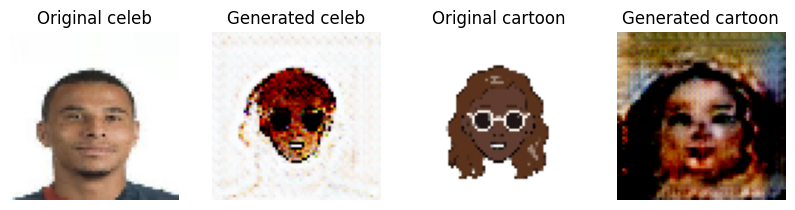

Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/1000 [00:00<09:22,  1.78it/s]

>1, dA[0.005 ,0.005 ] dB[0.001 ,0.000] g[2.777 ,4.614]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 2/1000 [00:01<09:15,  1.80it/s]

>2, dA[0.154 ,0.007 ] dB[0.001 ,0.451] g[3.192 ,4.471]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 3/1000 [00:01<09:14,  1.80it/s]

>3, dA[0.005 ,0.006 ] dB[0.031 ,0.014] g[4.258 ,3.970]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 4/1000 [00:02<09:16,  1.79it/s]

>4, dA[0.007 ,0.502 ] dB[0.020 ,0.015] g[4.845 ,4.803]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [00:02<09:16,  1.79it/s]

>5, dA[0.067 ,0.017 ] dB[0.011 ,0.004] g[3.968 ,4.784]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:15,  1.79it/s]

>6, dA[0.028 ,0.008 ] dB[0.012 ,0.002] g[4.430 ,5.788]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 7/1000 [00:03<09:13,  1.79it/s]

>7, dA[0.003 ,0.001 ] dB[0.001 ,0.031] g[2.941 ,3.279]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 8/1000 [00:04<09:17,  1.78it/s]

>8, dA[0.054 ,0.115 ] dB[0.003 ,0.002] g[3.660 ,4.144]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 9/1000 [00:05<09:18,  1.77it/s]

>9, dA[0.010 ,0.003 ] dB[0.001 ,0.003] g[4.206 ,4.200]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:19,  1.77it/s]

>10, dA[0.005 ,0.003 ] dB[0.505 ,0.035] g[5.007 ,5.159]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 11/1000 [00:06<09:15,  1.78it/s]

>11, dA[0.002 ,0.175 ] dB[0.020 ,0.023] g[3.684 ,4.006]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 12/1000 [00:06<09:15,  1.78it/s]

>12, dA[0.009 ,0.008 ] dB[0.003 ,0.024] g[3.905 ,4.530]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:15,  1.78it/s]

>13, dA[0.261 ,0.030 ] dB[0.001 ,0.006] g[3.569 ,4.250]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:14,  1.78it/s]

>14, dA[0.012 ,0.016 ] dB[0.001 ,0.002] g[3.602 ,3.918]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:20,  1.76it/s]

>15, dA[0.107 ,0.198 ] dB[0.001 ,0.007] g[4.059 ,4.693]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:23,  1.75it/s]

>16, dA[0.005 ,0.005 ] dB[0.001 ,0.004] g[4.716 ,5.212]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:20,  1.75it/s]

>17, dA[0.107 ,0.003 ] dB[0.134 ,0.149] g[3.953 ,3.888]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:15,  1.77it/s]

>18, dA[0.051 ,0.638 ] dB[0.002 ,0.002] g[3.948 ,4.577]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:12,  1.78it/s]

>19, dA[0.023 ,0.016 ] dB[0.001 ,0.001] g[4.139 ,4.511]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:12,  1.77it/s]

>20, dA[0.024 ,0.002 ] dB[0.003 ,0.002] g[4.271 ,4.516]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:11,  1.78it/s]

>21, dA[0.012 ,0.163 ] dB[0.137 ,0.028] g[4.036 ,3.876]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:10,  1.78it/s]

>22, dA[0.037 ,0.013 ] dB[0.006 ,0.012] g[5.924 ,7.785]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:08,  1.78it/s]

>23, dA[0.005 ,0.004 ] dB[0.005 ,0.007] g[5.710 ,7.710]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:09,  1.78it/s]

>24, dA[0.234 ,0.013 ] dB[0.002 ,0.056] g[4.499 ,5.789]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:09,  1.77it/s]

>25, dA[0.007 ,0.012 ] dB[0.011 ,0.002] g[3.148 ,2.724]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:12,  1.76it/s]

>26, dA[0.014 ,0.006 ] dB[0.002 ,0.001] g[4.237 ,4.343]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:09,  1.77it/s]

>27, dA[0.003 ,0.407 ] dB[0.007 ,0.000] g[5.540 ,6.583]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:10,  1.77it/s]

>28, dA[0.031 ,0.030 ] dB[0.001 ,0.002] g[4.777 ,6.354]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:07,  1.77it/s]

>29, dA[0.017 ,0.152 ] dB[0.001 ,0.326] g[4.324 ,5.446]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:05,  1.78it/s]

>30, dA[0.038 ,0.012 ] dB[0.572 ,0.001] g[5.036 ,5.361]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:03,  1.78it/s]

>31, dA[0.033 ,0.003 ] dB[0.005 ,0.011] g[3.548 ,3.841]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:04,  1.78it/s]

>32, dA[0.101 ,0.226 ] dB[0.002 ,0.005] g[3.755 ,3.862]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:03,  1.78it/s]

>33, dA[0.037 ,0.005 ] dB[0.076 ,0.006] g[5.742 ,6.870]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:02,  1.78it/s]

>34, dA[0.039 ,0.002 ] dB[0.003 ,0.004] g[3.673 ,3.984]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:00,  1.79it/s]

>35, dA[0.013 ,0.111 ] dB[0.001 ,0.002] g[3.200 ,3.126]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:00,  1.78it/s]

>36, dA[0.021 ,0.007 ] dB[0.001 ,0.002] g[4.225 ,4.664]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 37/1000 [00:20<09:01,  1.78it/s]

>37, dA[0.016 ,0.006 ] dB[0.001 ,0.004] g[4.127 ,4.541]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:02,  1.77it/s]

>38, dA[0.235 ,0.026 ] dB[0.007 ,0.003] g[3.401 ,4.628]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [00:21<08:59,  1.78it/s]

>39, dA[0.013 ,0.009 ] dB[0.005 ,0.004] g[4.554 ,4.448]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [00:22<08:59,  1.78it/s]

>40, dA[0.006 ,0.068 ] dB[0.002 ,0.003] g[3.936 ,4.255]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 41/1000 [00:23<08:58,  1.78it/s]

>41, dA[0.008 ,0.005 ] dB[0.001 ,0.002] g[4.949 ,5.751]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:23<08:56,  1.78it/s]

>42, dA[0.003 ,0.007 ] dB[0.003 ,0.006] g[3.881 ,4.331]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 43/1000 [00:24<08:55,  1.79it/s]

>43, dA[0.050 ,0.437 ] dB[0.000 ,0.002] g[3.793 ,3.494]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:58,  1.78it/s]

>44, dA[0.049 ,0.027 ] dB[0.001 ,0.001] g[4.089 ,4.542]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 45/1000 [00:25<08:57,  1.78it/s]

>45, dA[0.032 ,0.012 ] dB[0.000 ,0.001] g[3.152 ,4.519]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:58,  1.77it/s]

>46, dA[0.004 ,0.009 ] dB[0.041 ,0.376] g[4.098 ,5.644]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:55,  1.78it/s]

>47, dA[0.061 ,0.004 ] dB[0.013 ,0.012] g[4.476 ,4.913]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 48/1000 [00:27<08:56,  1.77it/s]

>48, dA[0.003 ,0.011 ] dB[0.024 ,0.004] g[4.407 ,4.512]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:56,  1.77it/s]

>49, dA[0.001 ,0.007 ] dB[0.078 ,0.011] g[4.353 ,4.724]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:54,  1.78it/s]

>50, dA[0.252 ,0.025 ] dB[0.006 ,0.188] g[3.464 ,4.442]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:53,  1.78it/s]

>51, dA[0.015 ,0.013 ] dB[0.011 ,0.015] g[3.890 ,4.119]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:52,  1.78it/s]

>52, dA[0.007 ,0.426 ] dB[0.482 ,0.039] g[3.815 ,3.243]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:51,  1.78it/s]

>53, dA[0.064 ,0.038 ] dB[0.018 ,0.019] g[3.894 ,4.499]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 54/1000 [00:30<08:53,  1.77it/s]

>54, dA[0.078 ,0.009 ] dB[0.002 ,0.006] g[3.954 ,4.495]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 55/1000 [00:30<08:52,  1.78it/s]

>55, dA[0.019 ,0.005 ] dB[0.159 ,0.027] g[4.037 ,4.666]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:50,  1.78it/s]

>56, dA[0.006 ,0.002 ] dB[0.008 ,0.062] g[4.329 ,5.619]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 57/1000 [00:32<08:49,  1.78it/s]

>57, dA[0.008 ,0.178 ] dB[0.006 ,0.008] g[3.505 ,3.464]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 58/1000 [00:32<08:49,  1.78it/s]

>58, dA[0.078 ,0.002 ] dB[0.011 ,0.005] g[4.033 ,4.837]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 59/1000 [00:33<08:47,  1.78it/s]

>59, dA[0.005 ,0.011 ] dB[0.018 ,0.001] g[5.746 ,7.482]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 60/1000 [00:33<08:48,  1.78it/s]

>60, dA[0.010 ,0.004 ] dB[0.002 ,0.002] g[3.972 ,4.435]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:47,  1.78it/s]

>61, dA[0.007 ,0.081 ] dB[0.001 ,0.023] g[3.895 ,4.211]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 62/1000 [00:34<08:51,  1.77it/s]

>62, dA[0.018 ,0.005 ] dB[0.001 ,0.002] g[4.537 ,5.243]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:48,  1.77it/s]

>63, dA[0.010 ,0.002 ] dB[0.001 ,0.001] g[4.500 ,4.693]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 64/1000 [00:36<08:47,  1.77it/s]

>64, dA[0.057 ,0.078 ] dB[0.003 ,0.001] g[3.806 ,3.942]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:46,  1.78it/s]

>65, dA[0.016 ,0.005 ] dB[0.001 ,0.008] g[3.665 ,4.204]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:44,  1.78it/s]

>66, dA[0.091 ,0.010 ] dB[0.006 ,0.003] g[3.683 ,4.748]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [00:37<08:42,  1.78it/s]

>67, dA[0.019 ,0.015 ] dB[0.001 ,0.001] g[3.334 ,4.131]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:44,  1.78it/s]

>68, dA[0.011 ,0.003 ] dB[0.000 ,0.002] g[3.023 ,2.956]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 69/1000 [00:38<08:44,  1.78it/s]

>69, dA[0.017 ,0.004 ] dB[0.001 ,0.022] g[3.718 ,4.536]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:43,  1.78it/s]

>70, dA[0.006 ,0.004 ] dB[0.007 ,0.002] g[5.480 ,6.345]
1/1 [==============================] - 0s 27ms/step



Batchs:   7%|▋         | 71/1000 [00:39<08:54,  1.74it/s]

>71, dA[0.006 ,0.003 ] dB[0.314 ,0.029] g[4.165 ,4.525]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [00:40<08:54,  1.74it/s]

>72, dA[0.003 ,0.273 ] dB[0.014 ,0.460] g[4.511 ,6.230]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:49,  1.75it/s]

>73, dA[0.013 ,0.037 ] dB[0.019 ,0.023] g[4.200 ,5.982]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 74/1000 [00:41<08:45,  1.76it/s]

>74, dA[0.009 ,0.019 ] dB[0.021 ,0.005] g[4.265 ,5.401]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:42,  1.77it/s]

>75, dA[0.006 ,0.006 ] dB[0.027 ,0.018] g[3.852 ,4.705]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:42<08:43,  1.77it/s]

>76, dA[0.363 ,0.191 ] dB[0.020 ,0.013] g[3.674 ,4.098]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:42,  1.77it/s]

>77, dA[0.028 ,0.011 ] dB[0.014 ,0.009] g[4.474 ,4.850]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 78/1000 [00:43<08:39,  1.78it/s]

>78, dA[0.006 ,0.007 ] dB[0.095 ,0.006] g[4.100 ,4.914]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:38,  1.78it/s]

>79, dA[0.003 ,0.001 ] dB[0.007 ,0.209] g[3.424 ,4.706]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:38,  1.78it/s]

>80, dA[0.033 ,0.026 ] dB[0.056 ,0.006] g[4.158 ,4.919]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 81/1000 [00:45<08:37,  1.78it/s]

>81, dA[0.006 ,0.001 ] dB[0.284 ,0.059] g[4.005 ,4.546]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:35,  1.78it/s]

>82, dA[0.002 ,0.001 ] dB[0.018 ,0.017] g[2.957 ,3.600]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:46<08:37,  1.77it/s]

>83, dA[0.001 ,0.001 ] dB[0.004 ,0.008] g[4.424 ,5.276]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:40,  1.76it/s]

>84, dA[0.004 ,0.007 ] dB[0.024 ,0.002] g[4.238 ,5.056]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 85/1000 [00:47<08:39,  1.76it/s]

>85, dA[0.003 ,0.002 ] dB[0.002 ,0.008] g[3.554 ,4.483]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:37,  1.77it/s]

>86, dA[0.009 ,0.008 ] dB[0.004 ,0.029] g[3.497 ,4.489]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▊         | 87/1000 [00:49<08:34,  1.77it/s]

>87, dA[0.002 ,0.010 ] dB[0.002 ,0.005] g[3.457 ,4.065]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:49<08:34,  1.77it/s]

>88, dA[0.189 ,0.019 ] dB[0.003 ,0.016] g[3.354 ,3.969]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:32,  1.78it/s]

>89, dA[0.009 ,0.015 ] dB[0.002 ,0.002] g[3.588 ,3.623]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:50<08:30,  1.78it/s]

>90, dA[0.007 ,0.038 ] dB[0.001 ,0.012] g[3.780 ,3.915]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:29,  1.78it/s]

>91, dA[0.003 ,0.006 ] dB[0.001 ,0.001] g[5.255 ,5.720]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 92/1000 [00:51<08:31,  1.78it/s]

>92, dA[0.002 ,0.197 ] dB[0.008 ,0.027] g[3.728 ,3.796]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:30,  1.78it/s]

>93, dA[0.007 ,0.027 ] dB[0.011 ,0.001] g[5.976 ,7.469]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 94/1000 [00:52<08:28,  1.78it/s]

>94, dA[0.120 ,0.005 ] dB[0.001 ,0.003] g[3.987 ,4.308]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 95/1000 [00:53<08:28,  1.78it/s]

>95, dA[0.007 ,0.247 ] dB[0.001 ,0.003] g[3.382 ,3.230]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 96/1000 [00:54<08:29,  1.77it/s]

>96, dA[0.022 ,0.020 ] dB[0.001 ,0.001] g[7.298 ,9.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 97/1000 [00:54<08:33,  1.76it/s]

>97, dA[0.013 ,0.004 ] dB[0.028 ,0.007] g[4.097 ,5.558]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:29,  1.77it/s]

>98, dA[0.045 ,0.005 ] dB[0.001 ,0.007] g[3.875 ,4.547]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 99/1000 [00:55<08:29,  1.77it/s]

>99, dA[0.003 ,0.005 ] dB[0.001 ,0.003] g[3.473 ,4.400]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:28,  1.77it/s]

>100, dA[0.064 ,0.018 ] dB[0.071 ,0.005] g[3.760 ,5.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 101/1000 [00:56<08:27,  1.77it/s]

>101, dA[0.010 ,0.002 ] dB[0.009 ,0.357] g[4.364 ,6.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 102/1000 [00:57<08:26,  1.77it/s]

>102, dA[0.023 ,0.003 ] dB[0.004 ,0.026] g[4.658 ,5.424]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 103/1000 [00:58<08:23,  1.78it/s]

>103, dA[0.011 ,0.062 ] dB[0.003 ,0.011] g[4.006 ,3.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:58<08:24,  1.78it/s]

>104, dA[0.001 ,0.014 ] dB[0.004 ,0.011] g[4.124 ,4.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [00:59<08:23,  1.78it/s]

>105, dA[0.002 ,0.006 ] dB[0.002 ,0.001] g[4.009 ,4.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [00:59<08:22,  1.78it/s]

>106, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[3.589 ,3.759]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:21,  1.78it/s]

>107, dA[0.004 ,0.003 ] dB[0.016 ,0.002] g[4.122 ,4.198]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 108/1000 [01:00<08:23,  1.77it/s]

>108, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[4.704 ,4.660]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:24,  1.77it/s]

>109, dA[0.002 ,0.301 ] dB[0.004 ,0.001] g[3.807 ,3.635]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 110/1000 [01:02<08:25,  1.76it/s]

>110, dA[0.189 ,0.003 ] dB[0.003 ,0.006] g[4.165 ,4.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:02<08:23,  1.76it/s]

>111, dA[0.019 ,0.003 ] dB[0.003 ,0.015] g[3.717 ,5.319]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 112/1000 [01:03<08:22,  1.77it/s]

>112, dA[0.037 ,0.010 ] dB[0.001 ,0.001] g[5.020 ,6.148]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 113/1000 [01:03<08:20,  1.77it/s]

>113, dA[0.010 ,0.002 ] dB[0.002 ,0.001] g[3.963 ,3.842]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:17,  1.78it/s]

>114, dA[0.005 ,0.049 ] dB[0.002 ,0.001] g[3.377 ,3.690]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 115/1000 [01:04<08:17,  1.78it/s]

>115, dA[0.024 ,0.064 ] dB[0.001 ,0.005] g[4.402 ,4.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:17,  1.78it/s]

>116, dA[0.195 ,0.004 ] dB[0.000 ,0.001] g[4.380 ,4.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 117/1000 [01:05<08:17,  1.77it/s]

>117, dA[0.004 ,0.004 ] dB[0.001 ,0.005] g[4.194 ,4.932]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:15,  1.78it/s]

>118, dA[0.007 ,0.051 ] dB[0.003 ,0.045] g[3.661 ,4.072]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [01:07<08:13,  1.78it/s]

>119, dA[0.004 ,0.005 ] dB[0.006 ,0.004] g[4.241 ,5.858]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 120/1000 [01:07<08:14,  1.78it/s]

>120, dA[0.119 ,0.011 ] dB[0.003 ,0.016] g[5.068 ,6.928]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:13,  1.78it/s]

>121, dA[0.008 ,0.002 ] dB[0.011 ,0.002] g[5.254 ,6.592]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 122/1000 [01:08<08:12,  1.78it/s]

>122, dA[0.008 ,0.003 ] dB[0.001 ,0.018] g[6.295 ,8.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:11,  1.78it/s]

>123, dA[0.001 ,0.002 ] dB[0.281 ,0.033] g[5.027 ,6.108]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 124/1000 [01:09<08:13,  1.77it/s]

>124, dA[0.018 ,0.002 ] dB[0.019 ,0.002] g[2.996 ,4.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:12,  1.78it/s]

>125, dA[0.001 ,0.005 ] dB[0.005 ,0.005] g[3.221 ,4.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 126/1000 [01:10<08:11,  1.78it/s]

>126, dA[0.004 ,0.005 ] dB[0.002 ,0.275] g[2.711 ,4.133]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 127/1000 [01:11<08:14,  1.77it/s]

>127, dA[0.006 ,0.001 ] dB[0.009 ,0.022] g[4.453 ,5.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:17,  1.75it/s]

>128, dA[0.007 ,0.003 ] dB[0.016 ,0.004] g[4.121 ,4.580]
1/1 [==============================] - 0s 28ms/step



Batchs:  13%|█▎        | 129/1000 [01:12<08:19,  1.74it/s]

>129, dA[0.003 ,0.002 ] dB[0.173 ,0.019] g[4.115 ,4.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:15,  1.76it/s]

>130, dA[0.007 ,0.003 ] dB[0.006 ,0.032] g[3.233 ,4.233]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 131/1000 [01:13<08:12,  1.76it/s]

>131, dA[0.008 ,0.002 ] dB[0.002 ,0.090] g[4.921 ,6.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:14,  1.76it/s]

>132, dA[0.020 ,0.002 ] dB[0.006 ,0.009] g[3.738 ,4.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 133/1000 [01:14<08:15,  1.75it/s]

>133, dA[0.021 ,0.004 ] dB[0.010 ,0.006] g[4.714 ,5.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:13,  1.76it/s]

>134, dA[0.003 ,0.001 ] dB[0.005 ,0.001] g[4.194 ,4.793]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 135/1000 [01:16<08:09,  1.77it/s]

>135, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[3.738 ,4.309]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 136/1000 [01:16<08:07,  1.77it/s]

>136, dA[0.002 ,0.003 ] dB[0.001 ,0.002] g[3.721 ,4.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:05,  1.78it/s]

>137, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[3.888 ,4.809]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 138/1000 [01:17<08:03,  1.78it/s]

>138, dA[0.001 ,0.001 ] dB[0.010 ,0.004] g[3.638 ,4.189]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:02,  1.78it/s]

>139, dA[0.002 ,0.001 ] dB[0.002 ,0.002] g[4.950 ,6.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:18<08:04,  1.77it/s]

>140, dA[0.001 ,0.001 ] dB[0.017 ,0.002] g[4.655 ,5.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:02,  1.78it/s]

>141, dA[0.002 ,0.001 ] dB[0.006 ,0.003] g[3.880 ,4.736]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 142/1000 [01:20<08:01,  1.78it/s]

>142, dA[0.004 ,0.000 ] dB[0.005 ,0.002] g[4.218 ,4.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 143/1000 [01:20<08:00,  1.78it/s]

>143, dA[0.008 ,0.001 ] dB[0.001 ,0.002] g[3.996 ,4.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<08:01,  1.78it/s]

>144, dA[0.010 ,0.002 ] dB[0.536 ,0.055] g[4.267 ,5.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:21<08:01,  1.78it/s]

>145, dA[0.001 ,0.024 ] dB[0.008 ,0.024] g[3.938 ,5.152]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<07:59,  1.78it/s]

>146, dA[0.002 ,0.003 ] dB[0.009 ,0.011] g[5.307 ,7.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 147/1000 [01:22<07:58,  1.78it/s]

>147, dA[0.003 ,0.001 ] dB[0.005 ,0.004] g[5.233 ,6.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<07:59,  1.78it/s]

>148, dA[0.004 ,0.003 ] dB[0.002 ,0.001] g[4.028 ,4.901]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 149/1000 [01:23<07:58,  1.78it/s]

>149, dA[0.005 ,0.002 ] dB[0.001 ,0.007] g[4.049 ,4.754]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<07:56,  1.78it/s]

>150, dA[0.006 ,0.014 ] dB[0.000 ,0.001] g[4.417 ,5.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<07:55,  1.78it/s]

>151, dA[0.040 ,0.016 ] dB[0.264 ,0.062] g[3.513 ,3.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:25<07:56,  1.78it/s]

>152, dA[0.003 ,0.006 ] dB[0.008 ,0.026] g[3.602 ,4.607]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:54,  1.78it/s]

>153, dA[0.005 ,0.012 ] dB[0.004 ,0.009] g[4.088 ,5.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 154/1000 [01:26<07:52,  1.79it/s]

>154, dA[0.001 ,0.062 ] dB[0.050 ,0.002] g[3.355 ,3.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<07:51,  1.79it/s]

>155, dA[0.009 ,0.021 ] dB[0.003 ,0.078] g[4.108 ,5.438]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 156/1000 [01:27<07:52,  1.78it/s]

>156, dA[0.049 ,0.034 ] dB[0.002 ,0.004] g[3.707 ,4.580]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:52,  1.78it/s]

>157, dA[0.007 ,0.009 ] dB[0.002 ,0.003] g[3.117 ,3.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:29<07:52,  1.78it/s]

>158, dA[0.002 ,0.006 ] dB[0.001 ,0.006] g[5.224 ,6.618]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 159/1000 [01:29<07:52,  1.78it/s]

>159, dA[0.002 ,0.002 ] dB[0.002 ,0.035] g[3.600 ,4.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:51,  1.78it/s]

>160, dA[0.047 ,0.003 ] dB[0.004 ,0.003] g[3.821 ,3.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [01:30<07:50,  1.78it/s]

>161, dA[0.014 ,0.172 ] dB[0.003 ,0.005] g[4.550 ,3.923]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:47,  1.79it/s]

>162, dA[0.010 ,0.014 ] dB[0.004 ,0.011] g[3.654 ,5.195]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 163/1000 [01:31<07:47,  1.79it/s]

>163, dA[0.049 ,0.005 ] dB[0.001 ,0.001] g[4.175 ,4.369]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:48,  1.78it/s]

>164, dA[0.006 ,0.029 ] dB[0.507 ,0.017] g[3.722 ,4.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 165/1000 [01:32<07:48,  1.78it/s]

>165, dA[0.009 ,0.011 ] dB[0.030 ,0.034] g[3.051 ,4.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:47,  1.78it/s]

>166, dA[0.040 ,0.003 ] dB[0.015 ,0.013] g[3.554 ,4.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:46,  1.79it/s]

>167, dA[0.009 ,0.002 ] dB[0.004 ,0.005] g[4.794 ,6.176]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 168/1000 [01:34<07:51,  1.76it/s]

>168, dA[0.141 ,0.416 ] dB[0.003 ,0.507] g[2.601 ,3.286]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:49,  1.77it/s]

>169, dA[0.010 ,0.032 ] dB[0.148 ,0.016] g[4.304 ,4.915]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 170/1000 [01:35<07:47,  1.77it/s]

>170, dA[0.011 ,0.005 ] dB[0.029 ,0.187] g[3.175 ,4.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:45,  1.78it/s]

>171, dA[0.003 ,0.003 ] dB[0.028 ,0.003] g[4.274 ,5.571]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 172/1000 [01:36<07:44,  1.78it/s]

>172, dA[0.002 ,0.005 ] dB[0.037 ,0.008] g[4.655 ,5.005]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:45,  1.78it/s]

>173, dA[0.019 ,0.004 ] dB[0.074 ,0.027] g[4.729 ,6.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 174/1000 [01:38<07:43,  1.78it/s]

>174, dA[0.003 ,0.001 ] dB[0.007 ,0.006] g[4.296 ,5.513]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 175/1000 [01:38<07:41,  1.79it/s]

>175, dA[0.003 ,0.009 ] dB[0.004 ,0.003] g[3.654 ,4.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:42,  1.78it/s]

>176, dA[0.002 ,0.005 ] dB[0.002 ,0.026] g[3.307 ,3.804]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:39<07:41,  1.78it/s]

>177, dA[0.004 ,0.156 ] dB[0.020 ,0.006] g[3.664 ,3.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:40,  1.78it/s]

>178, dA[0.009 ,0.010 ] dB[0.001 ,0.006] g[4.068 ,4.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:40<07:39,  1.79it/s]

>179, dA[0.009 ,0.004 ] dB[0.001 ,0.001] g[5.918 ,7.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:39,  1.78it/s]

>180, dA[0.079 ,0.006 ] dB[0.001 ,0.002] g[4.529 ,5.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:41<07:38,  1.79it/s]

>181, dA[0.084 ,0.098 ] dB[0.008 ,0.001] g[3.730 ,3.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:39,  1.78it/s]

>182, dA[0.013 ,0.015 ] dB[0.001 ,0.002] g[3.428 ,3.798]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:42,  1.77it/s]

>183, dA[0.002 ,0.015 ] dB[0.213 ,0.020] g[3.102 ,3.200]
1/1 [==============================] - 0s 28ms/step



Batchs:  18%|█▊        | 184/1000 [01:43<07:50,  1.73it/s]

>184, dA[0.010 ,0.445 ] dB[0.014 ,0.084] g[2.413 ,2.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:49,  1.73it/s]

>185, dA[0.024 ,0.041 ] dB[0.005 ,0.206] g[2.792 ,4.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:44<07:46,  1.75it/s]

>186, dA[0.014 ,0.041 ] dB[0.037 ,0.012] g[5.017 ,5.392]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:42,  1.76it/s]

>187, dA[0.016 ,0.012 ] dB[0.489 ,0.046] g[4.378 ,5.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 188/1000 [01:45<07:41,  1.76it/s]

>188, dA[0.004 ,0.006 ] dB[0.042 ,0.021] g[5.239 ,6.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:39,  1.76it/s]

>189, dA[0.007 ,0.005 ] dB[0.006 ,0.018] g[3.396 ,4.736]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 190/1000 [01:47<07:37,  1.77it/s]

>190, dA[0.025 ,0.004 ] dB[0.348 ,0.222] g[3.362 ,4.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:47<07:36,  1.77it/s]

>191, dA[0.002 ,0.006 ] dB[0.003 ,0.016] g[4.303 ,5.211]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:35,  1.77it/s]

>192, dA[0.073 ,0.068 ] dB[0.010 ,0.003] g[3.538 ,3.745]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 193/1000 [01:48<07:34,  1.78it/s]

>193, dA[0.066 ,0.013 ] dB[0.106 ,0.034] g[4.166 ,4.855]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:33,  1.78it/s]

>194, dA[0.006 ,0.002 ] dB[0.004 ,0.040] g[2.938 ,3.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [01:49<07:32,  1.78it/s]

>195, dA[0.012 ,0.007 ] dB[0.002 ,0.008] g[4.139 ,4.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:32,  1.78it/s]

>196, dA[0.009 ,0.060 ] dB[0.005 ,0.005] g[5.277 ,6.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:50<07:32,  1.78it/s]

>197, dA[0.004 ,0.007 ] dB[0.028 ,0.007] g[4.220 ,6.648]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:32,  1.77it/s]

>198, dA[0.020 ,0.004 ] dB[0.002 ,0.261] g[3.963 ,5.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 199/1000 [01:52<07:31,  1.78it/s]

>199, dA[0.005 ,0.001 ] dB[0.006 ,0.015] g[4.579 ,5.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:52<07:31,  1.77it/s]

>200, dA[0.120 ,0.009 ] dB[0.018 ,0.006] g[4.443 ,4.987]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:32,  1.77it/s]

>201, dA[0.015 ,0.022 ] dB[0.012 ,0.002] g[4.235 ,4.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 202/1000 [01:53<07:30,  1.77it/s]

>202, dA[0.004 ,0.008 ] dB[0.394 ,0.034] g[3.747 ,3.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:29,  1.77it/s]

>203, dA[0.002 ,0.002 ] dB[0.232 ,0.049] g[3.934 ,4.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 204/1000 [01:54<07:33,  1.76it/s]

>204, dA[0.024 ,0.010 ] dB[0.035 ,0.042] g[6.125 ,8.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 205/1000 [01:55<07:31,  1.76it/s]

>205, dA[0.002 ,0.010 ] dB[0.012 ,0.020] g[5.914 ,7.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 206/1000 [01:56<07:29,  1.77it/s]

>206, dA[0.001 ,0.016 ] dB[0.003 ,0.015] g[3.521 ,3.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 207/1000 [01:56<07:26,  1.78it/s]

>207, dA[0.003 ,0.012 ] dB[0.002 ,0.006] g[4.641 ,5.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:27,  1.77it/s]

>208, dA[0.052 ,0.314 ] dB[0.018 ,0.007] g[3.693 ,3.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 209/1000 [01:57<07:25,  1.77it/s]

>209, dA[0.011 ,0.043 ] dB[0.006 ,0.011] g[5.545 ,7.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:24,  1.78it/s]

>210, dA[0.095 ,0.009 ] dB[0.009 ,0.006] g[3.493 ,4.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 211/1000 [01:58<07:23,  1.78it/s]

>211, dA[0.008 ,0.002 ] dB[0.075 ,0.014] g[3.736 ,4.835]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:23,  1.78it/s]

>212, dA[0.002 ,0.003 ] dB[0.002 ,0.013] g[3.266 ,4.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 213/1000 [02:00<07:23,  1.78it/s]

>213, dA[0.124 ,0.012 ] dB[0.004 ,0.008] g[3.178 ,4.755]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██▏       | 214/1000 [02:00<07:22,  1.78it/s]

>214, dA[0.011 ,0.005 ] dB[0.001 ,0.181] g[4.359 ,6.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 215/1000 [02:01<07:21,  1.78it/s]

>215, dA[0.003 ,0.002 ] dB[0.028 ,0.006] g[3.911 ,4.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [02:01<07:22,  1.77it/s]

>216, dA[0.006 ,0.002 ] dB[0.499 ,0.034] g[3.868 ,4.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:22,  1.77it/s]

>217, dA[0.002 ,0.010 ] dB[0.029 ,0.020] g[3.239 ,4.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [02:02<07:20,  1.77it/s]

>218, dA[0.005 ,0.007 ] dB[0.008 ,0.016] g[3.731 ,4.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:20,  1.77it/s]

>219, dA[0.006 ,0.002 ] dB[0.003 ,0.005] g[4.425 ,5.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 220/1000 [02:03<07:20,  1.77it/s]

>220, dA[0.210 ,0.025 ] dB[0.002 ,0.003] g[2.996 ,3.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 221/1000 [02:04<07:20,  1.77it/s]

>221, dA[0.029 ,0.007 ] dB[0.010 ,0.001] g[5.410 ,6.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 222/1000 [02:05<07:19,  1.77it/s]

>222, dA[0.007 ,0.003 ] dB[0.024 ,0.002] g[3.539 ,4.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 223/1000 [02:05<07:18,  1.77it/s]

>223, dA[0.005 ,0.003 ] dB[0.012 ,0.007] g[3.166 ,4.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:18,  1.77it/s]

>224, dA[0.001 ,0.003 ] dB[0.002 ,0.025] g[3.323 ,4.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [02:06<07:16,  1.77it/s]

>225, dA[0.039 ,0.005 ] dB[0.002 ,0.002] g[4.073 ,4.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:15,  1.78it/s]

>226, dA[0.007 ,0.002 ] dB[0.001 ,0.002] g[5.963 ,7.671]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 227/1000 [02:07<07:17,  1.77it/s]

>227, dA[0.001 ,0.003 ] dB[0.002 ,0.001] g[3.627 ,4.067]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:19,  1.76it/s]

>228, dA[0.002 ,0.002 ] dB[0.003 ,0.001] g[3.893 ,4.940]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 229/1000 [02:09<07:16,  1.76it/s]

>229, dA[0.003 ,0.003 ] dB[0.172 ,0.096] g[3.564 ,3.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 230/1000 [02:09<07:14,  1.77it/s]

>230, dA[0.002 ,0.002 ] dB[0.006 ,0.008] g[3.252 ,3.845]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 231/1000 [02:10<07:12,  1.78it/s]

>231, dA[0.004 ,0.002 ] dB[0.006 ,0.006] g[4.231 ,5.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:10<07:12,  1.78it/s]

>232, dA[0.002 ,0.002 ] dB[0.007 ,0.008] g[5.252 ,7.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:12,  1.77it/s]

>233, dA[0.003 ,0.001 ] dB[0.001 ,0.003] g[4.119 ,4.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:11<07:11,  1.78it/s]

>234, dA[0.001 ,0.005 ] dB[0.001 ,0.004] g[3.954 ,4.507]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:10,  1.78it/s]

>235, dA[0.005 ,0.001 ] dB[0.001 ,0.006] g[3.711 ,4.343]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 236/1000 [02:13<07:10,  1.78it/s]

>236, dA[0.002 ,0.016 ] dB[0.001 ,0.001] g[3.878 ,4.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 237/1000 [02:13<07:10,  1.77it/s]

>237, dA[0.002 ,0.032 ] dB[0.002 ,0.006] g[3.865 ,4.909]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 238/1000 [02:14<07:08,  1.78it/s]

>238, dA[0.008 ,0.003 ] dB[0.003 ,0.005] g[3.071 ,3.757]
1/1 [==============================] - 0s 31ms/step



Batchs:  24%|██▍       | 239/1000 [02:14<07:13,  1.75it/s]

>239, dA[0.044 ,0.003 ] dB[0.007 ,0.003] g[3.226 ,3.817]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 240/1000 [02:15<07:18,  1.73it/s]

>240, dA[0.002 ,0.005 ] dB[0.002 ,0.001] g[4.179 ,5.182]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 241/1000 [02:15<07:18,  1.73it/s]

>241, dA[0.003 ,0.007 ] dB[0.001 ,0.039] g[3.741 ,4.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:13,  1.75it/s]

>242, dA[0.005 ,0.001 ] dB[0.002 ,0.006] g[3.818 ,4.540]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 243/1000 [02:17<07:10,  1.76it/s]

>243, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[4.369 ,4.941]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 244/1000 [02:17<07:09,  1.76it/s]

>244, dA[0.002 ,0.001 ] dB[0.001 ,0.002] g[3.918 ,4.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 245/1000 [02:18<07:08,  1.76it/s]

>245, dA[0.000 ,0.001 ] dB[0.001 ,0.001] g[3.440 ,4.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 246/1000 [02:18<07:06,  1.77it/s]

>246, dA[0.004 ,0.001 ] dB[0.001 ,0.005] g[4.009 ,4.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 247/1000 [02:19<07:05,  1.77it/s]

>247, dA[0.002 ,0.002 ] dB[0.012 ,0.005] g[3.792 ,4.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 248/1000 [02:19<07:04,  1.77it/s]

>248, dA[0.001 ,0.001 ] dB[0.003 ,0.002] g[3.583 ,4.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<07:03,  1.77it/s]

>249, dA[0.004 ,0.001 ] dB[0.055 ,0.006] g[3.855 ,4.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 250/1000 [02:20<07:02,  1.78it/s]

>250, dA[0.002 ,0.011 ] dB[0.009 ,0.002] g[6.017 ,7.448]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<07:00,  1.78it/s]

>251, dA[0.004 ,0.002 ] dB[0.011 ,0.132] g[3.157 ,4.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:22<07:00,  1.78it/s]

>252, dA[0.001 ,0.006 ] dB[0.009 ,0.007] g[3.581 ,3.895]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 253/1000 [02:22<07:00,  1.78it/s]

>253, dA[0.001 ,0.002 ] dB[0.002 ,0.003] g[4.780 ,5.530]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 254/1000 [02:23<07:00,  1.78it/s]

>254, dA[0.001 ,0.002 ] dB[0.184 ,0.016] g[4.002 ,4.629]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 255/1000 [02:23<06:59,  1.77it/s]

>255, dA[0.002 ,0.006 ] dB[0.007 ,0.002] g[5.009 ,6.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:24<06:59,  1.77it/s]

>256, dA[0.001 ,0.002 ] dB[0.004 ,0.004] g[2.425 ,3.615]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 257/1000 [02:24<07:02,  1.76it/s]

>257, dA[0.000 ,0.003 ] dB[0.012 ,0.433] g[2.611 ,6.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<06:58,  1.77it/s]

>258, dA[0.002 ,0.002 ] dB[0.013 ,0.029] g[4.171 ,4.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:26<06:56,  1.78it/s]

>259, dA[0.001 ,0.005 ] dB[0.010 ,0.005] g[4.659 ,5.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:56,  1.78it/s]

>260, dA[0.001 ,0.002 ] dB[0.027 ,0.007] g[4.694 ,5.946]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 261/1000 [02:27<06:56,  1.77it/s]

>261, dA[0.002 ,0.001 ] dB[0.006 ,0.002] g[3.519 ,4.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 262/1000 [02:27<06:54,  1.78it/s]

>262, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[4.199 ,5.166]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 263/1000 [02:28<06:54,  1.78it/s]

>263, dA[0.001 ,0.001 ] dB[0.005 ,0.012] g[4.597 ,6.130]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 264/1000 [02:28<06:55,  1.77it/s]

>264, dA[0.001 ,0.002 ] dB[0.008 ,0.006] g[3.314 ,3.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:54,  1.77it/s]

>265, dA[0.002 ,0.001 ] dB[0.021 ,0.001] g[3.984 ,4.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [02:29<06:53,  1.77it/s]

>266, dA[0.001 ,0.002 ] dB[0.015 ,0.039] g[3.065 ,4.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:53,  1.77it/s]

>267, dA[0.001 ,0.004 ] dB[0.007 ,0.009] g[4.245 ,5.393]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 268/1000 [02:31<06:53,  1.77it/s]

>268, dA[0.002 ,0.004 ] dB[0.006 ,0.001] g[3.630 ,4.063]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 269/1000 [02:31<06:52,  1.77it/s]

>269, dA[0.004 ,0.003 ] dB[0.006 ,0.009] g[3.880 ,4.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 270/1000 [02:32<06:51,  1.78it/s]

>270, dA[0.001 ,0.001 ] dB[0.009 ,0.006] g[3.721 ,4.477]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 271/1000 [02:32<06:51,  1.77it/s]

>271, dA[0.005 ,0.003 ] dB[0.003 ,0.006] g[3.188 ,3.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 272/1000 [02:33<06:51,  1.77it/s]

>272, dA[0.001 ,0.002 ] dB[0.092 ,0.080] g[3.175 ,3.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 273/1000 [02:33<06:49,  1.77it/s]

>273, dA[0.003 ,0.001 ] dB[0.006 ,0.002] g[3.333 ,4.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:48,  1.78it/s]

>274, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.280 ,3.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 275/1000 [02:35<06:47,  1.78it/s]

>275, dA[0.001 ,0.001 ] dB[0.002 ,0.004] g[4.847 ,5.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:49,  1.77it/s]

>276, dA[0.001 ,0.001 ] dB[0.075 ,0.015] g[4.069 ,4.836]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 277/1000 [02:36<06:50,  1.76it/s]

>277, dA[0.001 ,0.001 ] dB[0.005 ,0.144] g[3.892 ,5.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:36<06:48,  1.77it/s]

>278, dA[0.001 ,0.000 ] dB[0.004 ,0.015] g[4.259 ,4.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 279/1000 [02:37<06:47,  1.77it/s]

>279, dA[0.000 ,0.001 ] dB[0.575 ,0.052] g[4.295 ,5.001]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 280/1000 [02:37<06:47,  1.77it/s]

>280, dA[0.000 ,0.003 ] dB[0.268 ,0.090] g[3.484 ,4.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:38<06:46,  1.77it/s]

>281, dA[0.004 ,0.005 ] dB[0.216 ,0.099] g[3.311 ,4.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 282/1000 [02:39<06:45,  1.77it/s]

>282, dA[0.003 ,0.001 ] dB[0.021 ,0.053] g[3.847 ,5.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:44,  1.77it/s]

>283, dA[0.001 ,0.000 ] dB[0.233 ,0.047] g[3.210 ,3.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 284/1000 [02:40<06:44,  1.77it/s]

>284, dA[0.001 ,0.001 ] dB[0.158 ,0.066] g[3.060 ,4.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:43,  1.77it/s]

>285, dA[0.009 ,0.001 ] dB[0.022 ,0.051] g[3.269 ,4.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [02:41<06:42,  1.77it/s]

>286, dA[0.002 ,0.008 ] dB[0.170 ,0.054] g[4.607 ,6.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 287/1000 [02:41<06:41,  1.78it/s]

>287, dA[0.003 ,0.002 ] dB[0.070 ,0.038] g[3.513 ,4.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 288/1000 [02:42<06:41,  1.77it/s]

>288, dA[0.004 ,0.003 ] dB[0.008 ,0.014] g[3.779 ,4.652]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 289/1000 [02:42<06:41,  1.77it/s]

>289, dA[0.002 ,0.002 ] dB[0.001 ,0.086] g[3.702 ,4.474]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:40,  1.77it/s]

>290, dA[0.002 ,0.002 ] dB[0.002 ,0.008] g[4.626 ,5.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:44<06:39,  1.78it/s]

>291, dA[0.002 ,0.003 ] dB[0.144 ,0.014] g[3.548 ,4.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:41,  1.76it/s]

>292, dA[0.001 ,0.001 ] dB[0.011 ,0.006] g[5.661 ,7.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 293/1000 [02:45<06:40,  1.77it/s]

>293, dA[0.001 ,0.009 ] dB[0.092 ,0.010] g[3.603 ,4.405]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 294/1000 [02:45<06:38,  1.77it/s]

>294, dA[0.000 ,0.022 ] dB[0.013 ,0.056] g[3.428 ,4.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:46<06:39,  1.76it/s]

>295, dA[0.001 ,0.004 ] dB[0.004 ,0.084] g[5.456 ,7.122]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 296/1000 [02:46<06:44,  1.74it/s]

>296, dA[0.001 ,0.006 ] dB[0.010 ,0.012] g[3.920 ,5.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 297/1000 [02:47<06:43,  1.74it/s]

>297, dA[0.005 ,0.004 ] dB[0.006 ,0.032] g[3.429 ,4.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 298/1000 [02:48<06:40,  1.75it/s]

>298, dA[0.038 ,0.015 ] dB[0.258 ,0.085] g[3.529 ,4.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:37,  1.76it/s]

>299, dA[0.015 ,0.004 ] dB[0.006 ,0.004] g[4.291 ,4.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [02:49<06:37,  1.76it/s]

>300, dA[0.002 ,0.007 ] dB[0.001 ,0.001] g[3.943 ,4.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:35,  1.77it/s]

>301, dA[0.004 ,0.001 ] dB[0.002 ,0.001] g[3.743 ,4.984]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 302/1000 [02:50<06:34,  1.77it/s]

>302, dA[0.003 ,0.001 ] dB[0.001 ,0.008] g[4.020 ,5.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [02:50<06:33,  1.77it/s]

>303, dA[0.003 ,0.002 ] dB[0.002 ,0.126] g[4.566 ,7.045]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:51<06:33,  1.77it/s]

>304, dA[0.001 ,0.001 ] dB[0.017 ,0.016] g[4.374 ,4.566]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 305/1000 [02:52<06:32,  1.77it/s]

>305, dA[0.001 ,0.001 ] dB[0.019 ,0.004] g[4.427 ,5.545]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 306/1000 [02:52<06:31,  1.77it/s]

>306, dA[0.003 ,0.002 ] dB[0.004 ,0.003] g[3.484 ,3.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 307/1000 [02:53<06:30,  1.78it/s]

>307, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[4.641 ,5.471]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:30,  1.77it/s]

>308, dA[0.005 ,0.049 ] dB[0.116 ,0.008] g[3.191 ,3.362]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 309/1000 [02:54<06:30,  1.77it/s]

>309, dA[0.012 ,0.014 ] dB[0.008 ,0.100] g[3.144 ,4.711]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 310/1000 [02:54<06:30,  1.77it/s]

>310, dA[0.005 ,0.002 ] dB[0.003 ,0.008] g[4.076 ,4.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 311/1000 [02:55<06:29,  1.77it/s]

>311, dA[0.002 ,0.003 ] dB[0.003 ,0.001] g[3.655 ,4.050]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 312/1000 [02:55<06:30,  1.76it/s]

>312, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[3.879 ,4.111]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 313/1000 [02:56<06:29,  1.77it/s]

>313, dA[0.001 ,0.002 ] dB[0.147 ,0.012] g[4.088 ,5.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 314/1000 [02:57<06:26,  1.78it/s]

>314, dA[0.001 ,0.001 ] dB[0.007 ,0.022] g[3.310 ,4.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:25,  1.78it/s]

>315, dA[0.003 ,0.001 ] dB[0.002 ,0.007] g[4.760 ,5.831]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 316/1000 [02:58<06:25,  1.77it/s]

>316, dA[0.002 ,0.003 ] dB[0.008 ,0.014] g[4.186 ,5.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [02:58<06:24,  1.77it/s]

>317, dA[0.001 ,0.001 ] dB[0.019 ,0.030] g[3.653 ,4.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [02:59<06:23,  1.78it/s]

>318, dA[0.001 ,0.001 ] dB[0.003 ,0.005] g[3.448 ,4.216]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 319/1000 [02:59<06:23,  1.78it/s]

>319, dA[0.008 ,0.007 ] dB[0.001 ,0.037] g[3.506 ,4.640]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 320/1000 [03:00<06:22,  1.78it/s]

>320, dA[0.001 ,0.003 ] dB[0.419 ,0.129] g[4.868 ,6.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 321/1000 [03:01<06:23,  1.77it/s]

>321, dA[0.001 ,0.006 ] dB[0.002 ,0.001] g[5.422 ,6.325]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 322/1000 [03:01<06:23,  1.77it/s]

>322, dA[0.001 ,0.005 ] dB[0.002 ,0.001] g[3.802 ,3.988]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 323/1000 [03:02<06:22,  1.77it/s]

>323, dA[0.001 ,0.006 ] dB[0.023 ,0.002] g[3.996 ,4.569]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:22,  1.77it/s]

>324, dA[0.001 ,0.005 ] dB[0.003 ,0.000] g[4.880 ,6.020]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▎      | 325/1000 [03:03<06:22,  1.77it/s]

>325, dA[0.002 ,0.006 ] dB[0.427 ,0.033] g[4.026 ,4.593]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 326/1000 [03:03<06:20,  1.77it/s]

>326, dA[0.001 ,0.003 ] dB[0.023 ,0.020] g[3.769 ,4.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 327/1000 [03:04<06:22,  1.76it/s]

>327, dA[0.000 ,0.007 ] dB[0.002 ,0.009] g[3.539 ,4.101]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 328/1000 [03:05<06:22,  1.76it/s]

>328, dA[0.002 ,0.003 ] dB[0.003 ,0.004] g[3.633 ,4.237]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 329/1000 [03:05<06:21,  1.76it/s]

>329, dA[0.000 ,0.003 ] dB[0.003 ,0.003] g[3.442 ,4.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 330/1000 [03:06<06:19,  1.77it/s]

>330, dA[0.008 ,0.002 ] dB[0.031 ,0.009] g[3.418 ,4.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:17,  1.77it/s]

>331, dA[0.002 ,0.007 ] dB[0.003 ,0.009] g[3.722 ,4.621]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 332/1000 [03:07<06:19,  1.76it/s]

>332, dA[0.004 ,0.002 ] dB[0.003 ,0.002] g[3.585 ,4.206]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 333/1000 [03:07<06:19,  1.76it/s]

>333, dA[0.002 ,0.004 ] dB[0.002 ,0.006] g[4.022 ,4.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 334/1000 [03:08<06:18,  1.76it/s]

>334, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[4.055 ,4.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:08<06:16,  1.77it/s]

>335, dA[0.001 ,0.006 ] dB[0.001 ,0.003] g[4.426 ,5.262]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 336/1000 [03:09<06:16,  1.76it/s]

>336, dA[0.002 ,0.002 ] dB[0.001 ,0.002] g[3.624 ,4.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 337/1000 [03:10<06:16,  1.76it/s]

>337, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[3.607 ,4.195]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 338/1000 [03:10<06:15,  1.76it/s]

>338, dA[0.002 ,0.002 ] dB[0.002 ,0.002] g[3.786 ,5.210]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 339/1000 [03:11<06:14,  1.76it/s]

>339, dA[0.001 ,0.014 ] dB[0.002 ,0.003] g[4.119 ,4.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:15,  1.76it/s]

>340, dA[0.002 ,0.005 ] dB[0.001 ,0.005] g[4.961 ,5.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 341/1000 [03:12<06:14,  1.76it/s]

>341, dA[0.002 ,0.008 ] dB[0.001 ,0.001] g[3.913 ,4.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 342/1000 [03:12<06:13,  1.76it/s]

>342, dA[0.003 ,0.016 ] dB[0.001 ,0.005] g[4.452 ,5.225]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 343/1000 [03:13<06:12,  1.77it/s]

>343, dA[0.008 ,0.008 ] dB[0.118 ,0.006] g[3.830 ,4.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 344/1000 [03:14<06:11,  1.77it/s]

>344, dA[0.039 ,0.009 ] dB[0.012 ,0.380] g[3.586 ,5.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:14<06:13,  1.76it/s]

>345, dA[0.009 ,0.003 ] dB[0.057 ,0.018] g[4.481 ,5.087]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 346/1000 [03:15<06:11,  1.76it/s]

>346, dA[0.006 ,0.004 ] dB[0.117 ,0.006] g[4.208 ,4.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:15<06:09,  1.77it/s]

>347, dA[0.004 ,0.002 ] dB[0.007 ,0.010] g[3.960 ,4.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 348/1000 [03:16<06:10,  1.76it/s]

>348, dA[0.003 ,0.004 ] dB[0.003 ,0.003] g[3.784 ,4.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:09,  1.76it/s]

>349, dA[0.002 ,0.001 ] dB[0.004 ,0.001] g[3.560 ,4.095]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 350/1000 [03:17<06:08,  1.77it/s]

>350, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.452 ,3.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:18<06:08,  1.76it/s]

>351, dA[0.001 ,0.002 ] dB[0.001 ,0.003] g[3.747 ,4.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 352/1000 [03:18<06:12,  1.74it/s]

>352, dA[0.002 ,0.001 ] dB[0.000 ,0.009] g[3.670 ,4.302]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 353/1000 [03:19<06:12,  1.74it/s]

>353, dA[0.001 ,0.001 ] dB[0.001 ,0.004] g[3.129 ,3.555]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 354/1000 [03:19<06:10,  1.74it/s]

>354, dA[0.003 ,0.001 ] dB[0.002 ,0.001] g[4.629 ,5.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 355/1000 [03:20<06:07,  1.75it/s]

>355, dA[0.001 ,0.002 ] dB[0.002 ,0.002] g[3.629 ,4.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:06,  1.76it/s]

>356, dA[0.001 ,0.001 ] dB[0.000 ,0.006] g[3.704 ,4.449]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 357/1000 [03:21<06:05,  1.76it/s]

>357, dA[0.001 ,0.000 ] dB[0.001 ,0.001] g[3.567 ,5.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:22<06:05,  1.76it/s]

>358, dA[0.001 ,0.001 ] dB[0.002 ,0.002] g[3.851 ,4.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 359/1000 [03:22<06:03,  1.76it/s]

>359, dA[0.001 ,0.001 ] dB[0.002 ,0.004] g[3.404 ,3.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 360/1000 [03:23<06:04,  1.76it/s]

>360, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[5.833 ,7.246]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 361/1000 [03:23<06:04,  1.75it/s]

>361, dA[0.002 ,0.001 ] dB[0.001 ,0.003] g[5.952 ,7.639]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 362/1000 [03:24<06:03,  1.76it/s]

>362, dA[0.001 ,0.001 ] dB[0.004 ,0.005] g[4.440 ,5.480]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 363/1000 [03:24<06:05,  1.74it/s]

>363, dA[0.001 ,0.003 ] dB[0.250 ,0.010] g[3.597 ,4.304]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 364/1000 [03:25<06:05,  1.74it/s]

>364, dA[0.001 ,0.002 ] dB[0.012 ,0.204] g[2.612 ,4.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:26<06:03,  1.75it/s]

>365, dA[0.002 ,0.001 ] dB[0.008 ,0.012] g[4.112 ,5.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:26<06:01,  1.75it/s]

>366, dA[0.001 ,0.002 ] dB[0.004 ,0.073] g[4.207 ,5.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:27<05:59,  1.76it/s]

>367, dA[0.003 ,0.001 ] dB[0.006 ,0.002] g[4.340 ,6.440]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 368/1000 [03:27<05:59,  1.76it/s]

>368, dA[0.001 ,0.001 ] dB[0.003 ,0.001] g[4.046 ,4.875]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 369/1000 [03:28<05:59,  1.75it/s]

>369, dA[0.000 ,0.001 ] dB[0.006 ,0.004] g[3.875 ,4.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [03:28<05:59,  1.75it/s]

>370, dA[0.002 ,0.002 ] dB[0.002 ,0.002] g[4.727 ,6.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 371/1000 [03:29<05:56,  1.76it/s]

>371, dA[0.001 ,0.001 ] dB[0.001 ,0.041] g[3.399 ,4.464]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 372/1000 [03:30<05:56,  1.76it/s]

>372, dA[0.001 ,0.003 ] dB[0.004 ,0.004] g[3.368 ,4.065]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 373/1000 [03:30<05:55,  1.77it/s]

>373, dA[0.004 ,0.002 ] dB[0.101 ,0.003] g[3.844 ,4.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:31<05:54,  1.77it/s]

>374, dA[0.005 ,0.002 ] dB[0.009 ,0.001] g[3.109 ,4.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:31<05:51,  1.78it/s]

>375, dA[0.000 ,0.001 ] dB[0.005 ,0.104] g[3.079 ,4.616]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 376/1000 [03:32<05:53,  1.77it/s]

>376, dA[0.003 ,0.001 ] dB[0.003 ,0.007] g[3.536 ,3.893]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 377/1000 [03:32<05:52,  1.77it/s]

>377, dA[0.002 ,0.000 ] dB[0.001 ,0.003] g[4.027 ,4.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 378/1000 [03:33<05:52,  1.76it/s]

>378, dA[0.000 ,0.002 ] dB[0.008 ,0.003] g[4.410 ,4.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:34<05:51,  1.77it/s]

>379, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.755 ,4.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:34<05:54,  1.75it/s]

>380, dA[0.001 ,0.001 ] dB[0.053 ,0.004] g[5.096 ,6.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 381/1000 [03:35<05:53,  1.75it/s]

>381, dA[0.002 ,0.001 ] dB[0.007 ,0.003] g[3.278 ,3.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 382/1000 [03:35<05:51,  1.76it/s]

>382, dA[0.001 ,0.004 ] dB[0.003 ,0.001] g[3.893 ,4.290]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 383/1000 [03:36<05:50,  1.76it/s]

>383, dA[0.002 ,0.001 ] dB[0.001 ,0.002] g[3.572 ,4.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 384/1000 [03:36<05:50,  1.76it/s]

>384, dA[0.001 ,0.000 ] dB[0.001 ,0.002] g[3.475 ,4.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 385/1000 [03:37<05:50,  1.76it/s]

>385, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[3.647 ,4.174]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 386/1000 [03:38<05:49,  1.76it/s]

>386, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[6.411 ,8.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:38<05:48,  1.76it/s]

>387, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[4.519 ,5.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [03:39<05:48,  1.75it/s]

>388, dA[0.004 ,0.001 ] dB[0.000 ,0.002] g[3.590 ,4.211]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 389/1000 [03:39<05:48,  1.75it/s]

>389, dA[0.002 ,0.000 ] dB[0.001 ,0.001] g[3.352 ,4.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [03:40<05:46,  1.76it/s]

>390, dA[0.001 ,0.000 ] dB[0.117 ,0.087] g[3.168 ,4.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 391/1000 [03:40<05:44,  1.77it/s]

>391, dA[0.001 ,0.001 ] dB[0.004 ,0.002] g[2.706 ,4.106]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 392/1000 [03:41<05:45,  1.76it/s]

>392, dA[0.016 ,0.003 ] dB[0.002 ,0.136] g[3.099 ,4.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 393/1000 [03:41<05:45,  1.76it/s]

>393, dA[0.002 ,0.001 ] dB[0.069 ,0.007] g[3.754 ,4.228]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [03:42<05:43,  1.76it/s]

>394, dA[0.001 ,0.003 ] dB[0.004 ,0.002] g[3.632 ,4.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [03:43<05:42,  1.77it/s]

>395, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[3.326 ,3.567]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 396/1000 [03:43<05:43,  1.76it/s]

>396, dA[0.000 ,0.001 ] dB[0.002 ,0.000] g[3.616 ,4.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:44<05:42,  1.76it/s]

>397, dA[0.000 ,0.001 ] dB[0.001 ,0.002] g[4.886 ,5.813]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 398/1000 [03:44<05:42,  1.76it/s]

>398, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[3.550 ,4.040]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 399/1000 [03:45<05:40,  1.76it/s]

>399, dA[0.001 ,0.001 ] dB[0.001 ,0.000] g[3.639 ,3.901]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:45<05:40,  1.76it/s]

>400, dA[0.001 ,0.033 ] dB[0.001 ,0.001] g[3.576 ,3.715]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 401/1000 [03:46<05:40,  1.76it/s]

>401, dA[0.002 ,0.011 ] dB[0.002 ,0.004] g[4.240 ,4.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 402/1000 [03:47<05:39,  1.76it/s]

>402, dA[0.016 ,0.007 ] dB[0.016 ,0.003] g[3.464 ,3.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 403/1000 [03:47<05:37,  1.77it/s]

>403, dA[0.003 ,0.005 ] dB[0.002 ,0.001] g[4.359 ,5.035]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 404/1000 [03:48<05:37,  1.76it/s]

>404, dA[0.001 ,0.015 ] dB[0.213 ,0.045] g[3.519 ,3.769]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 405/1000 [03:48<05:37,  1.76it/s]

>405, dA[0.003 ,0.005 ] dB[0.009 ,0.067] g[3.834 ,4.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 406/1000 [03:49<05:37,  1.76it/s]

>406, dA[0.005 ,0.003 ] dB[0.004 ,0.008] g[3.576 ,4.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 407/1000 [03:49<05:40,  1.74it/s]

>407, dA[0.011 ,0.006 ] dB[0.003 ,0.002] g[4.158 ,3.866]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 408/1000 [03:50<05:41,  1.74it/s]

>408, dA[0.017 ,0.002 ] dB[0.002 ,0.001] g[4.640 ,5.089]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 409/1000 [03:51<05:40,  1.74it/s]

>409, dA[0.003 ,0.002 ] dB[0.002 ,0.005] g[3.401 ,3.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 410/1000 [03:51<05:37,  1.75it/s]

>410, dA[0.003 ,0.317 ] dB[0.002 ,0.002] g[3.837 ,4.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 411/1000 [03:52<05:34,  1.76it/s]

>411, dA[0.051 ,0.017 ] dB[0.001 ,0.007] g[3.690 ,4.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 412/1000 [03:52<05:34,  1.76it/s]

>412, dA[0.003 ,0.013 ] dB[0.002 ,0.005] g[5.264 ,6.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 413/1000 [03:53<05:34,  1.76it/s]

>413, dA[0.003 ,0.003 ] dB[0.000 ,0.001] g[3.364 ,4.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:53<05:32,  1.76it/s]

>414, dA[0.003 ,0.001 ] dB[0.002 ,0.002] g[2.914 ,4.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 415/1000 [03:54<05:32,  1.76it/s]

>415, dA[0.007 ,0.004 ] dB[0.016 ,0.001] g[2.926 ,4.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 416/1000 [03:55<05:33,  1.75it/s]

>416, dA[0.002 ,0.001 ] dB[0.001 ,0.002] g[5.743 ,8.422]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 417/1000 [03:55<05:31,  1.76it/s]

>417, dA[0.008 ,0.007 ] dB[0.001 ,0.404] g[3.157 ,4.432]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [03:56<05:30,  1.76it/s]

>418, dA[0.001 ,0.005 ] dB[0.024 ,0.031] g[4.611 ,6.041]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 419/1000 [03:56<05:29,  1.76it/s]

>419, dA[0.014 ,0.002 ] dB[0.018 ,0.004] g[4.133 ,4.677]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 420/1000 [03:57<05:31,  1.75it/s]

>420, dA[0.004 ,0.029 ] dB[0.036 ,0.006] g[3.347 ,3.679]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 421/1000 [03:57<05:30,  1.75it/s]

>421, dA[0.002 ,0.016 ] dB[0.002 ,0.001] g[4.149 ,5.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 422/1000 [03:58<05:29,  1.76it/s]

>422, dA[0.002 ,0.002 ] dB[0.004 ,0.059] g[4.733 ,6.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 423/1000 [03:59<05:27,  1.76it/s]

>423, dA[0.003 ,0.003 ] dB[0.004 ,0.004] g[3.521 ,4.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 424/1000 [03:59<05:27,  1.76it/s]

>424, dA[0.001 ,0.004 ] dB[0.044 ,0.005] g[5.233 ,6.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 425/1000 [04:00<05:27,  1.76it/s]

>425, dA[0.001 ,0.002 ] dB[0.062 ,0.136] g[3.513 ,4.376]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 426/1000 [04:00<05:26,  1.76it/s]

>426, dA[0.004 ,0.007 ] dB[0.001 ,0.011] g[3.337 ,3.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [04:01<05:24,  1.77it/s]

>427, dA[0.019 ,0.018 ] dB[0.001 ,0.002] g[4.464 ,4.692]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 428/1000 [04:01<05:24,  1.76it/s]

>428, dA[0.034 ,0.003 ] dB[0.002 ,0.002] g[3.807 ,4.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 429/1000 [04:02<05:24,  1.76it/s]

>429, dA[0.004 ,0.050 ] dB[0.000 ,0.014] g[3.449 ,3.567]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 430/1000 [04:03<05:24,  1.76it/s]

>430, dA[0.104 ,0.002 ] dB[0.000 ,0.008] g[3.197 ,4.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [04:03<05:22,  1.76it/s]

>431, dA[0.021 ,0.021 ] dB[0.001 ,0.064] g[4.661 ,6.130]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 432/1000 [04:04<05:23,  1.76it/s]

>432, dA[0.013 ,0.006 ] dB[0.061 ,0.002] g[4.273 ,4.550]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 433/1000 [04:04<05:23,  1.75it/s]

>433, dA[0.005 ,0.028 ] dB[0.004 ,0.014] g[3.856 ,4.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 434/1000 [04:05<05:21,  1.76it/s]

>434, dA[0.006 ,0.015 ] dB[0.003 ,0.006] g[4.038 ,5.005]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 435/1000 [04:05<05:21,  1.76it/s]

>435, dA[0.004 ,0.003 ] dB[0.323 ,0.032] g[4.313 ,6.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 436/1000 [04:06<05:21,  1.76it/s]

>436, dA[0.004 ,0.005 ] dB[0.016 ,0.465] g[3.198 ,4.300]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 437/1000 [04:07<05:20,  1.76it/s]

>437, dA[0.002 ,0.004 ] dB[0.035 ,0.017] g[3.842 ,4.794]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 438/1000 [04:07<05:19,  1.76it/s]

>438, dA[0.003 ,0.004 ] dB[0.018 ,0.006] g[4.278 ,3.980]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 439/1000 [04:08<05:19,  1.76it/s]

>439, dA[0.004 ,0.337 ] dB[0.035 ,0.006] g[4.801 ,5.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 440/1000 [04:08<05:19,  1.75it/s]

>440, dA[0.146 ,0.016 ] dB[0.003 ,0.001] g[3.904 ,5.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 441/1000 [04:09<05:18,  1.76it/s]

>441, dA[0.040 ,0.014 ] dB[0.001 ,0.087] g[3.547 ,5.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [04:09<05:16,  1.76it/s]

>442, dA[0.006 ,0.003 ] dB[0.006 ,0.007] g[4.150 ,5.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 443/1000 [04:10<05:15,  1.76it/s]

>443, dA[0.003 ,0.000 ] dB[0.003 ,0.002] g[4.527 ,5.169]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 444/1000 [04:11<05:15,  1.76it/s]

>444, dA[0.010 ,0.002 ] dB[0.004 ,0.001] g[3.641 ,4.161]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 445/1000 [04:11<05:15,  1.76it/s]

>445, dA[0.003 ,0.002 ] dB[0.238 ,0.094] g[3.605 ,4.138]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 446/1000 [04:12<05:14,  1.76it/s]

>446, dA[0.003 ,0.000 ] dB[0.003 ,0.006] g[3.960 ,5.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 447/1000 [04:12<05:14,  1.76it/s]

>447, dA[0.006 ,0.003 ] dB[0.002 ,0.002] g[3.880 ,4.624]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 448/1000 [04:13<05:14,  1.75it/s]

>448, dA[0.007 ,0.005 ] dB[0.237 ,0.153] g[3.882 ,4.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 449/1000 [04:13<05:14,  1.75it/s]

>449, dA[0.007 ,0.001 ] dB[0.001 ,0.042] g[4.905 ,7.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 450/1000 [04:14<05:15,  1.74it/s]

>450, dA[0.001 ,0.001 ] dB[0.005 ,0.003] g[4.170 ,5.416]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 451/1000 [04:15<05:13,  1.75it/s]

>451, dA[0.013 ,0.002 ] dB[0.010 ,0.005] g[3.766 ,4.841]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 452/1000 [04:15<05:13,  1.75it/s]

>452, dA[0.001 ,0.001 ] dB[0.003 ,0.005] g[4.619 ,6.219]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 453/1000 [04:16<05:12,  1.75it/s]

>453, dA[0.001 ,0.001 ] dB[0.000 ,0.002] g[4.865 ,5.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 454/1000 [04:16<05:10,  1.76it/s]

>454, dA[0.001 ,0.001 ] dB[0.001 ,0.006] g[3.164 ,3.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 455/1000 [04:17<05:09,  1.76it/s]

>455, dA[0.003 ,0.001 ] dB[0.001 ,0.002] g[4.808 ,5.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 456/1000 [04:17<05:09,  1.76it/s]

>456, dA[0.001 ,0.004 ] dB[0.001 ,0.004] g[4.132 ,5.330]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 457/1000 [04:18<05:07,  1.76it/s]

>457, dA[0.001 ,0.000 ] dB[0.002 ,0.060] g[4.372 ,5.586]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 458/1000 [04:18<05:07,  1.76it/s]

>458, dA[0.004 ,0.003 ] dB[0.001 ,0.006] g[4.628 ,5.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 459/1000 [04:19<05:06,  1.76it/s]

>459, dA[0.002 ,0.002 ] dB[0.001 ,0.003] g[4.380 ,5.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 460/1000 [04:20<05:07,  1.76it/s]

>460, dA[0.001 ,0.001 ] dB[0.018 ,0.004] g[4.986 ,6.039]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 461/1000 [04:20<05:06,  1.76it/s]

>461, dA[0.002 ,0.002 ] dB[0.001 ,0.006] g[4.954 ,6.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 462/1000 [04:21<05:07,  1.75it/s]

>462, dA[0.001 ,0.001 ] dB[0.007 ,0.002] g[3.634 ,4.264]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 463/1000 [04:21<05:08,  1.74it/s]

>463, dA[0.002 ,0.002 ] dB[0.001 ,0.003] g[3.809 ,4.425]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 464/1000 [04:22<05:08,  1.74it/s]

>464, dA[0.000 ,0.002 ] dB[0.052 ,0.007] g[5.014 ,6.346]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 465/1000 [04:22<05:06,  1.75it/s]

>465, dA[0.003 ,0.001 ] dB[0.023 ,0.005] g[3.954 ,5.365]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 466/1000 [04:23<05:04,  1.75it/s]

>466, dA[0.002 ,0.001 ] dB[0.011 ,0.214] g[3.313 ,4.960]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 467/1000 [04:24<05:03,  1.76it/s]

>467, dA[0.097 ,0.007 ] dB[0.008 ,0.023] g[3.927 ,6.470]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 468/1000 [04:24<05:03,  1.75it/s]

>468, dA[0.008 ,0.006 ] dB[0.003 ,0.009] g[4.759 ,5.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 469/1000 [04:25<05:02,  1.75it/s]

>469, dA[0.006 ,0.002 ] dB[0.137 ,0.010] g[5.136 ,6.277]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 470/1000 [04:25<05:01,  1.76it/s]

>470, dA[0.001 ,0.002 ] dB[0.016 ,0.010] g[3.170 ,3.954]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [04:26<04:59,  1.77it/s]

>471, dA[0.001 ,0.002 ] dB[0.006 ,0.036] g[3.829 ,4.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 472/1000 [04:26<04:59,  1.76it/s]

>472, dA[0.004 ,0.001 ] dB[0.004 ,0.005] g[5.240 ,6.707]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 473/1000 [04:27<04:59,  1.76it/s]

>473, dA[0.001 ,0.003 ] dB[0.002 ,0.002] g[5.395 ,5.224]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 474/1000 [04:28<04:58,  1.76it/s]

>474, dA[0.003 ,0.076 ] dB[0.001 ,0.006] g[4.414 ,4.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 475/1000 [04:28<04:58,  1.76it/s]

>475, dA[0.004 ,0.019 ] dB[0.002 ,0.001] g[4.034 ,4.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:29<04:57,  1.76it/s]

>476, dA[0.030 ,0.007 ] dB[0.001 ,0.000] g[4.000 ,4.646]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 477/1000 [04:29<04:57,  1.76it/s]

>477, dA[0.023 ,0.005 ] dB[0.001 ,0.002] g[3.877 ,5.403]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 478/1000 [04:30<04:56,  1.76it/s]

>478, dA[0.005 ,0.006 ] dB[0.000 ,0.001] g[4.557 ,5.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 479/1000 [04:30<04:55,  1.76it/s]

>479, dA[0.003 ,0.006 ] dB[0.002 ,0.015] g[3.829 ,4.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 480/1000 [04:31<04:56,  1.75it/s]

>480, dA[0.002 ,0.004 ] dB[0.004 ,0.002] g[6.002 ,7.448]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 481/1000 [04:32<04:55,  1.76it/s]

>481, dA[0.006 ,0.002 ] dB[0.004 ,0.001] g[4.601 ,5.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:32<04:53,  1.76it/s]

>482, dA[0.002 ,0.003 ] dB[0.004 ,0.002] g[3.536 ,4.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:33<04:52,  1.77it/s]

>483, dA[0.002 ,0.003 ] dB[0.003 ,0.006] g[4.195 ,4.994]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 484/1000 [04:33<04:53,  1.76it/s]

>484, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[3.675 ,4.229]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 485/1000 [04:34<04:53,  1.76it/s]

>485, dA[0.003 ,0.002 ] dB[0.001 ,0.002] g[3.677 ,4.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 486/1000 [04:34<04:54,  1.74it/s]

>486, dA[0.002 ,0.001 ] dB[0.000 ,0.003] g[3.450 ,4.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:35<04:52,  1.75it/s]

>487, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[4.860 ,6.551]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 488/1000 [04:36<04:52,  1.75it/s]

>488, dA[0.002 ,0.003 ] dB[0.000 ,0.024] g[4.170 ,5.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:36<04:51,  1.75it/s]

>489, dA[0.001 ,0.005 ] dB[0.366 ,0.103] g[3.393 ,4.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 490/1000 [04:37<04:50,  1.76it/s]

>490, dA[0.000 ,0.003 ] dB[0.005 ,0.002] g[3.868 ,4.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 491/1000 [04:37<04:48,  1.76it/s]

>491, dA[0.002 ,0.001 ] dB[0.005 ,0.001] g[5.683 ,7.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 492/1000 [04:38<04:49,  1.76it/s]

>492, dA[0.001 ,0.003 ] dB[0.007 ,0.003] g[4.778 ,5.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 493/1000 [04:38<04:48,  1.76it/s]

>493, dA[0.005 ,0.004 ] dB[0.002 ,0.017] g[3.780 ,5.065]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 494/1000 [04:39<04:46,  1.76it/s]

>494, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[3.530 ,4.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:40<04:45,  1.77it/s]

>495, dA[0.003 ,0.001 ] dB[0.001 ,0.001] g[3.473 ,4.116]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 496/1000 [04:40<04:46,  1.76it/s]

>496, dA[0.003 ,0.002 ] dB[0.004 ,0.008] g[3.767 ,4.501]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 497/1000 [04:41<04:46,  1.76it/s]

>497, dA[0.004 ,0.002 ] dB[0.004 ,0.004] g[3.385 ,4.085]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 498/1000 [04:41<04:45,  1.76it/s]

>498, dA[0.001 ,0.001 ] dB[0.003 ,0.008] g[4.229 ,5.116]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 499/1000 [04:42<04:45,  1.76it/s]

>499, dA[0.005 ,0.001 ] dB[0.014 ,0.001] g[3.817 ,4.022]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 500/1000 [04:42<04:46,  1.75it/s]

>500, dA[0.002 ,0.002 ] dB[0.004 ,0.001] g[4.344 ,5.881]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 501/1000 [04:43<04:45,  1.75it/s]

>501, dA[0.002 ,0.003 ] dB[0.004 ,0.026] g[3.740 ,4.685]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 502/1000 [04:44<04:44,  1.75it/s]

>502, dA[0.001 ,0.002 ] dB[0.453 ,0.022] g[4.311 ,5.132]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 503/1000 [04:44<04:46,  1.74it/s]

>503, dA[0.002 ,0.002 ] dB[0.017 ,0.038] g[2.835 ,3.681]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 504/1000 [04:45<04:45,  1.74it/s]

>504, dA[0.001 ,0.001 ] dB[0.002 ,0.004] g[4.608 ,5.844]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 505/1000 [04:45<04:43,  1.74it/s]

>505, dA[0.003 ,0.002 ] dB[0.004 ,0.002] g[4.226 ,5.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [04:46<04:41,  1.76it/s]

>506, dA[0.003 ,0.001 ] dB[0.002 ,0.010] g[5.114 ,6.328]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 507/1000 [04:46<04:40,  1.76it/s]

>507, dA[0.001 ,0.002 ] dB[0.051 ,0.003] g[3.826 ,4.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 508/1000 [04:47<04:40,  1.76it/s]

>508, dA[0.002 ,0.001 ] dB[0.007 ,0.047] g[3.123 ,4.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [04:48<04:38,  1.76it/s]

>509, dA[0.001 ,0.016 ] dB[0.001 ,0.003] g[3.111 ,3.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 510/1000 [04:48<04:37,  1.76it/s]

>510, dA[0.001 ,0.007 ] dB[0.001 ,0.001] g[3.775 ,4.213]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 511/1000 [04:49<04:37,  1.76it/s]

>511, dA[0.001 ,0.002 ] dB[0.005 ,0.002] g[3.805 ,4.554]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 512/1000 [04:49<04:40,  1.74it/s]

>512, dA[0.001 ,0.001 ] dB[0.008 ,0.013] g[3.757 ,4.373]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████▏    | 513/1000 [04:50<04:41,  1.73it/s]

>513, dA[0.005 ,0.097 ] dB[0.003 ,0.003] g[3.924 ,4.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [04:50<04:38,  1.75it/s]

>514, dA[0.011 ,0.009 ] dB[0.000 ,0.004] g[4.444 ,5.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 515/1000 [04:51<04:36,  1.75it/s]

>515, dA[0.005 ,0.002 ] dB[0.000 ,0.001] g[3.876 ,4.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:52<04:36,  1.75it/s]

>516, dA[0.002 ,0.002 ] dB[0.000 ,0.004] g[5.274 ,6.640]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 517/1000 [04:52<04:35,  1.75it/s]

>517, dA[0.001 ,0.001 ] dB[0.001 ,0.021] g[4.107 ,4.963]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 518/1000 [04:53<04:36,  1.74it/s]

>518, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[3.945 ,4.540]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 519/1000 [04:53<04:37,  1.73it/s]

>519, dA[0.001 ,0.001 ] dB[0.001 ,0.012] g[3.462 ,4.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 520/1000 [04:54<04:36,  1.73it/s]

>520, dA[0.001 ,0.002 ] dB[0.011 ,0.026] g[4.375 ,5.477]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 521/1000 [04:54<04:38,  1.72it/s]

>521, dA[0.000 ,0.002 ] dB[0.086 ,0.009] g[3.677 ,4.597]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 522/1000 [04:55<04:36,  1.73it/s]

>522, dA[0.002 ,0.001 ] dB[0.026 ,0.004] g[3.402 ,5.130]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 523/1000 [04:56<04:34,  1.74it/s]

>523, dA[0.002 ,0.013 ] dB[0.004 ,0.477] g[2.305 ,3.268]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 524/1000 [04:56<04:34,  1.73it/s]

>524, dA[0.005 ,0.002 ] dB[0.031 ,0.042] g[3.099 ,4.424]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 525/1000 [04:57<04:34,  1.73it/s]

>525, dA[0.002 ,0.001 ] dB[0.060 ,0.021] g[3.407 ,3.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [04:57<04:32,  1.74it/s]

>526, dA[0.001 ,0.001 ] dB[0.025 ,0.051] g[3.522 ,4.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 527/1000 [04:58<04:30,  1.75it/s]

>527, dA[0.005 ,0.002 ] dB[0.013 ,0.024] g[4.398 ,5.611]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 528/1000 [04:58<04:30,  1.75it/s]

>528, dA[0.010 ,0.003 ] dB[0.009 ,0.020] g[4.485 ,5.103]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 529/1000 [04:59<04:29,  1.75it/s]

>529, dA[0.004 ,0.003 ] dB[0.525 ,0.034] g[5.072 ,5.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 530/1000 [05:00<04:28,  1.75it/s]

>530, dA[0.007 ,0.312 ] dB[0.011 ,0.013] g[3.313 ,3.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 531/1000 [05:00<04:27,  1.76it/s]

>531, dA[0.093 ,0.017 ] dB[0.015 ,0.006] g[3.537 ,5.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [05:01<04:27,  1.75it/s]

>532, dA[0.015 ,0.009 ] dB[0.003 ,0.186] g[2.804 ,4.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 533/1000 [05:01<04:27,  1.74it/s]

>533, dA[0.008 ,0.001 ] dB[0.022 ,0.008] g[4.783 ,5.246]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 534/1000 [05:02<04:28,  1.73it/s]

>534, dA[0.007 ,0.002 ] dB[0.367 ,0.037] g[3.469 ,3.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 535/1000 [05:02<04:26,  1.75it/s]

>535, dA[0.016 ,0.007 ] dB[0.176 ,0.060] g[3.938 ,5.159]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 536/1000 [05:03<04:26,  1.74it/s]

>536, dA[0.002 ,0.006 ] dB[0.006 ,0.047] g[3.431 ,5.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 537/1000 [05:04<04:24,  1.75it/s]

>537, dA[0.004 ,0.002 ] dB[0.007 ,0.014] g[4.505 ,5.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 538/1000 [05:04<04:24,  1.75it/s]

>538, dA[0.001 ,0.001 ] dB[0.002 ,0.009] g[3.779 ,5.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 539/1000 [05:05<04:23,  1.75it/s]

>539, dA[0.008 ,0.001 ] dB[0.004 ,0.015] g[5.206 ,6.894]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 540/1000 [05:05<04:23,  1.75it/s]

>540, dA[0.002 ,0.001 ] dB[0.002 ,0.027] g[3.901 ,4.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 541/1000 [05:06<04:21,  1.75it/s]

>541, dA[0.004 ,0.001 ] dB[0.001 ,0.003] g[3.638 ,4.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 542/1000 [05:06<04:20,  1.76it/s]

>542, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[3.444 ,4.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 543/1000 [05:07<04:20,  1.75it/s]

>543, dA[0.001 ,0.001 ] dB[0.001 ,0.008] g[4.413 ,5.747]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 544/1000 [05:08<04:21,  1.74it/s]

>544, dA[0.002 ,0.001 ] dB[0.006 ,0.026] g[5.625 ,7.606]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 545/1000 [05:08<04:19,  1.75it/s]

>545, dA[0.001 ,0.000 ] dB[0.002 ,0.005] g[3.898 ,5.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 546/1000 [05:09<04:18,  1.76it/s]

>546, dA[0.002 ,0.001 ] dB[0.025 ,0.101] g[3.349 ,4.882]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 547/1000 [05:09<04:17,  1.76it/s]

>547, dA[0.001 ,0.001 ] dB[0.035 ,0.002] g[4.379 ,4.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 548/1000 [05:10<04:17,  1.75it/s]

>548, dA[0.002 ,0.001 ] dB[0.005 ,0.001] g[4.504 ,5.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [05:10<04:16,  1.76it/s]

>549, dA[0.002 ,0.002 ] dB[0.037 ,0.007] g[4.115 ,4.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 550/1000 [05:11<04:15,  1.76it/s]

>550, dA[0.013 ,0.004 ] dB[0.007 ,0.002] g[4.673 ,5.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:12<04:15,  1.76it/s]

>551, dA[0.003 ,0.006 ] dB[0.005 ,0.007] g[4.317 ,5.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [05:12<04:15,  1.76it/s]

>552, dA[0.002 ,0.002 ] dB[0.001 ,0.002] g[3.910 ,4.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 553/1000 [05:13<04:13,  1.76it/s]

>553, dA[0.001 ,0.005 ] dB[0.469 ,0.040] g[4.675 ,5.655]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 554/1000 [05:13<04:14,  1.75it/s]

>554, dA[0.005 ,0.003 ] dB[0.022 ,0.024] g[4.062 ,5.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 555/1000 [05:14<04:13,  1.76it/s]

>555, dA[0.002 ,0.000 ] dB[0.005 ,0.004] g[3.402 ,4.239]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 556/1000 [05:14<04:16,  1.73it/s]

>556, dA[0.002 ,0.001 ] dB[0.007 ,0.027] g[3.532 ,4.571]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 557/1000 [05:15<04:14,  1.74it/s]

>557, dA[0.001 ,0.001 ] dB[0.002 ,0.004] g[3.239 ,3.953]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 558/1000 [05:16<04:13,  1.75it/s]

>558, dA[0.002 ,0.001 ] dB[0.002 ,0.005] g[4.167 ,5.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:16<04:11,  1.76it/s]

>559, dA[0.000 ,0.002 ] dB[0.009 ,0.005] g[3.253 ,4.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 560/1000 [05:17<04:10,  1.76it/s]

>560, dA[0.004 ,0.001 ] dB[0.011 ,0.002] g[3.273 ,4.291]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 561/1000 [05:17<04:09,  1.76it/s]

>561, dA[0.001 ,0.003 ] dB[0.006 ,0.332] g[2.757 ,4.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:18<04:08,  1.76it/s]

>562, dA[0.000 ,0.001 ] dB[0.014 ,0.032] g[4.194 ,4.412]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [05:18<04:07,  1.76it/s]

>563, dA[0.001 ,0.001 ] dB[0.008 ,0.011] g[4.788 ,5.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:19<04:07,  1.76it/s]

>564, dA[0.001 ,0.001 ] dB[0.016 ,0.006] g[4.447 ,5.172]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 565/1000 [05:20<04:07,  1.76it/s]

>565, dA[0.004 ,0.002 ] dB[0.009 ,0.007] g[5.763 ,7.345]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:20<04:06,  1.76it/s]

>566, dA[0.002 ,0.002 ] dB[0.002 ,0.007] g[3.885 ,4.468]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 567/1000 [05:21<04:05,  1.76it/s]

>567, dA[0.001 ,0.001 ] dB[0.074 ,0.020] g[4.913 ,6.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 568/1000 [05:21<04:05,  1.76it/s]

>568, dA[0.001 ,0.002 ] dB[0.277 ,0.049] g[4.211 ,5.211]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 569/1000 [05:22<04:04,  1.76it/s]

>569, dA[0.002 ,0.002 ] dB[0.012 ,0.033] g[3.228 ,4.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 570/1000 [05:22<04:03,  1.77it/s]

>570, dA[0.001 ,0.001 ] dB[0.006 ,0.019] g[3.522 ,5.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 571/1000 [05:23<04:02,  1.77it/s]

>571, dA[0.000 ,0.001 ] dB[0.004 ,0.009] g[2.792 ,3.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [05:24<04:02,  1.77it/s]

>572, dA[0.000 ,0.000 ] dB[0.001 ,0.007] g[3.783 ,4.617]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 573/1000 [05:24<04:10,  1.70it/s]

>573, dA[0.008 ,0.006 ] dB[0.012 ,0.002] g[3.180 ,3.944]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:25<04:07,  1.72it/s]

>574, dA[0.001 ,0.002 ] dB[0.002 ,0.060] g[3.429 ,4.474]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 575/1000 [05:25<04:05,  1.73it/s]

>575, dA[0.000 ,0.004 ] dB[0.002 ,0.007] g[3.832 ,4.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:26<04:04,  1.74it/s]

>576, dA[0.001 ,0.005 ] dB[0.011 ,0.003] g[4.880 ,6.424]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 577/1000 [05:26<04:02,  1.75it/s]

>577, dA[0.001 ,0.001 ] dB[0.072 ,0.009] g[3.593 ,4.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 578/1000 [05:27<04:00,  1.76it/s]

>578, dA[0.001 ,0.001 ] dB[0.004 ,0.042] g[3.420 ,4.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [05:28<03:58,  1.76it/s]

>579, dA[0.001 ,0.001 ] dB[0.004 ,0.004] g[4.290 ,5.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:28<03:58,  1.76it/s]

>580, dA[0.001 ,0.001 ] dB[0.181 ,0.247] g[3.963 ,5.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 581/1000 [05:29<03:57,  1.76it/s]

>581, dA[0.003 ,0.004 ] dB[0.002 ,0.008] g[4.072 ,4.425]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 582/1000 [05:29<03:56,  1.77it/s]

>582, dA[0.002 ,0.003 ] dB[0.001 ,0.003] g[3.600 ,3.838]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 583/1000 [05:30<03:54,  1.77it/s]

>583, dA[0.002 ,0.001 ] dB[0.003 ,0.002] g[4.147 ,4.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:30<03:55,  1.77it/s]

>584, dA[0.001 ,0.003 ] dB[0.002 ,0.001] g[3.604 ,3.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [05:31<03:54,  1.77it/s]

>585, dA[0.002 ,0.009 ] dB[0.224 ,0.016] g[3.412 ,3.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 586/1000 [05:32<03:53,  1.78it/s]

>586, dA[0.001 ,0.004 ] dB[0.005 ,0.011] g[4.744 ,5.876]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:32<03:52,  1.78it/s]

>587, dA[0.002 ,0.019 ] dB[0.007 ,0.002] g[3.369 ,3.831]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:33<03:52,  1.77it/s]

>588, dA[0.010 ,0.232 ] dB[0.008 ,0.007] g[3.772 ,3.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 589/1000 [05:33<03:52,  1.77it/s]

>589, dA[0.037 ,0.051 ] dB[0.002 ,0.004] g[4.146 ,5.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:34<03:51,  1.77it/s]

>590, dA[0.025 ,0.017 ] dB[0.003 ,0.003] g[3.675 ,4.603]
1/1 [==============================] - 0s 28ms/step



Batchs:  59%|█████▉    | 591/1000 [05:34<03:54,  1.75it/s]

>591, dA[0.011 ,0.009 ] dB[0.001 ,0.002] g[3.816 ,4.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 592/1000 [05:35<03:53,  1.75it/s]

>592, dA[0.186 ,0.042 ] dB[0.002 ,0.001] g[3.716 ,4.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 593/1000 [05:35<03:51,  1.76it/s]

>593, dA[0.011 ,0.012 ] dB[0.001 ,0.001] g[3.886 ,4.182]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 594/1000 [05:36<03:50,  1.76it/s]

>594, dA[0.020 ,0.008 ] dB[0.001 ,0.000] g[3.273 ,3.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:37<03:48,  1.77it/s]

>595, dA[0.024 ,0.006 ] dB[0.002 ,0.001] g[3.376 ,3.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 596/1000 [05:37<03:48,  1.77it/s]

>596, dA[0.004 ,0.126 ] dB[0.004 ,0.006] g[5.273 ,5.019]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 597/1000 [05:38<03:47,  1.77it/s]

>597, dA[0.033 ,0.018 ] dB[0.002 ,0.001] g[4.246 ,5.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 598/1000 [05:38<03:46,  1.78it/s]

>598, dA[0.142 ,0.036 ] dB[0.001 ,0.003] g[3.556 ,4.476]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 599/1000 [05:39<03:46,  1.77it/s]

>599, dA[0.017 ,0.013 ] dB[0.002 ,0.002] g[4.002 ,4.651]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 600/1000 [05:39<03:45,  1.77it/s]

>600, dA[0.005 ,0.003 ] dB[0.003 ,0.002] g[3.562 ,4.406]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 601/1000 [05:40<03:45,  1.77it/s]

>601, dA[0.001 ,0.003 ] dB[0.004 ,0.001] g[3.379 ,3.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [05:41<03:44,  1.77it/s]

>602, dA[0.002 ,0.016 ] dB[0.002 ,0.087] g[3.227 ,4.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 603/1000 [05:41<03:43,  1.78it/s]

>603, dA[0.002 ,0.004 ] dB[0.004 ,0.003] g[4.244 ,4.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [05:42<03:43,  1.77it/s]

>604, dA[0.001 ,0.006 ] dB[0.003 ,0.002] g[5.712 ,6.434]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 605/1000 [05:42<03:42,  1.77it/s]

>605, dA[0.008 ,0.172 ] dB[0.001 ,0.005] g[5.509 ,6.237]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 606/1000 [05:43<03:42,  1.77it/s]

>606, dA[0.080 ,0.010 ] dB[0.002 ,0.001] g[3.880 ,4.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:43<03:41,  1.78it/s]

>607, dA[0.004 ,0.003 ] dB[0.001 ,0.000] g[5.509 ,6.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 608/1000 [05:44<03:42,  1.76it/s]

>608, dA[0.001 ,0.001 ] dB[0.000 ,0.000] g[4.175 ,4.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 609/1000 [05:45<03:41,  1.76it/s]

>609, dA[0.004 ,0.114 ] dB[0.217 ,0.050] g[3.578 ,3.162]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 610/1000 [05:45<03:40,  1.77it/s]

>610, dA[0.034 ,0.006 ] dB[0.008 ,0.002] g[3.817 ,4.120]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 611/1000 [05:46<03:39,  1.77it/s]

>611, dA[0.005 ,0.006 ] dB[0.002 ,0.001] g[3.362 ,4.247]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 612/1000 [05:46<03:39,  1.77it/s]

>612, dA[0.003 ,0.005 ] dB[0.028 ,0.023] g[3.253 ,4.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 613/1000 [05:47<03:38,  1.77it/s]

>613, dA[0.002 ,0.120 ] dB[0.003 ,0.140] g[5.934 ,7.375]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████▏   | 614/1000 [05:47<03:37,  1.78it/s]

>614, dA[0.214 ,0.005 ] dB[0.018 ,0.007] g[4.600 ,5.891]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 615/1000 [05:48<03:36,  1.78it/s]

>615, dA[0.012 ,0.048 ] dB[0.003 ,0.001] g[3.996 ,4.172]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 616/1000 [05:48<03:36,  1.77it/s]

>616, dA[0.005 ,0.018 ] dB[0.006 ,0.002] g[4.260 ,5.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 617/1000 [05:49<03:36,  1.77it/s]

>617, dA[0.011 ,0.004 ] dB[0.001 ,0.002] g[3.777 ,4.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 618/1000 [05:50<03:35,  1.77it/s]

>618, dA[0.003 ,0.011 ] dB[0.436 ,0.036] g[4.707 ,5.870]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 619/1000 [05:50<03:34,  1.78it/s]

>619, dA[0.071 ,0.008 ] dB[0.010 ,0.056] g[3.404 ,3.955]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 620/1000 [05:51<03:33,  1.78it/s]

>620, dA[0.004 ,0.412 ] dB[0.015 ,0.019] g[3.854 ,4.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 621/1000 [05:51<03:33,  1.78it/s]

>621, dA[0.043 ,0.059 ] dB[0.004 ,0.027] g[3.702 ,5.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:52<03:32,  1.78it/s]

>622, dA[0.086 ,0.021 ] dB[0.003 ,0.005] g[4.378 ,5.605]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 623/1000 [05:52<03:31,  1.78it/s]

>623, dA[0.234 ,0.039 ] dB[0.001 ,0.002] g[3.928 ,4.547]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 624/1000 [05:53<03:32,  1.77it/s]

>624, dA[0.026 ,0.099 ] dB[0.018 ,0.002] g[3.827 ,3.724]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▎   | 625/1000 [05:54<03:31,  1.77it/s]

>625, dA[0.011 ,0.010 ] dB[0.001 ,0.004] g[3.534 ,4.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 626/1000 [05:54<03:31,  1.76it/s]

>626, dA[0.017 ,0.008 ] dB[0.007 ,0.010] g[3.375 ,4.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [05:55<03:30,  1.77it/s]

>627, dA[0.023 ,0.103 ] dB[0.003 ,0.004] g[3.084 ,2.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 628/1000 [05:55<03:29,  1.77it/s]

>628, dA[0.017 ,0.039 ] dB[0.002 ,0.004] g[3.510 ,4.297]
1/1 [==============================] - 0s 27ms/step



Batchs:  63%|██████▎   | 629/1000 [05:56<03:33,  1.74it/s]

>629, dA[0.057 ,0.019 ] dB[0.001 ,0.002] g[3.310 ,4.059]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 630/1000 [05:56<03:33,  1.74it/s]

>630, dA[0.007 ,0.010 ] dB[0.001 ,0.001] g[3.673 ,4.338]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 631/1000 [05:57<03:31,  1.74it/s]

>631, dA[0.005 ,0.002 ] dB[0.026 ,0.055] g[4.131 ,5.274]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 632/1000 [05:58<03:30,  1.75it/s]

>632, dA[0.003 ,0.001 ] dB[0.001 ,0.005] g[4.137 ,4.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 633/1000 [05:58<03:29,  1.75it/s]

>633, dA[0.001 ,0.001 ] dB[0.309 ,0.019] g[4.101 ,5.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 634/1000 [05:59<03:27,  1.76it/s]

>634, dA[0.317 ,0.058 ] dB[0.024 ,0.175] g[2.433 ,3.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 635/1000 [05:59<03:26,  1.77it/s]

>635, dA[0.003 ,0.015 ] dB[0.095 ,0.006] g[3.397 ,3.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [06:00<03:25,  1.77it/s]

>636, dA[0.127 ,0.062 ] dB[0.001 ,0.006] g[3.508 ,3.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [06:00<03:24,  1.77it/s]

>637, dA[0.033 ,0.016 ] dB[0.002 ,0.035] g[3.899 ,4.021]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 638/1000 [06:01<03:24,  1.77it/s]

>638, dA[0.013 ,0.385 ] dB[0.001 ,0.002] g[3.581 ,3.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 639/1000 [06:01<03:23,  1.78it/s]

>639, dA[0.070 ,0.033 ] dB[0.014 ,0.003] g[5.525 ,5.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 640/1000 [06:02<03:23,  1.77it/s]

>640, dA[0.025 ,0.017 ] dB[0.003 ,0.006] g[5.579 ,6.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 641/1000 [06:03<03:22,  1.77it/s]

>641, dA[0.054 ,0.041 ] dB[0.001 ,0.001] g[4.148 ,5.625]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 642/1000 [06:03<03:21,  1.77it/s]

>642, dA[0.003 ,0.055 ] dB[0.000 ,0.003] g[3.928 ,4.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 643/1000 [06:04<03:20,  1.78it/s]

>643, dA[0.176 ,0.005 ] dB[0.004 ,0.001] g[4.125 ,4.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [06:04<03:21,  1.77it/s]

>644, dA[0.008 ,0.002 ] dB[0.002 ,0.044] g[4.208 ,4.037]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 645/1000 [06:05<03:20,  1.77it/s]

>645, dA[0.007 ,0.002 ] dB[0.012 ,0.003] g[3.533 ,2.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 646/1000 [06:05<03:19,  1.77it/s]

>646, dA[0.002 ,0.385 ] dB[0.280 ,0.032] g[5.682 ,6.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [06:06<03:18,  1.78it/s]

>647, dA[0.045 ,0.015 ] dB[0.012 ,0.080] g[3.195 ,3.551]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 648/1000 [06:07<03:18,  1.77it/s]

>648, dA[0.062 ,0.030 ] dB[0.007 ,0.007] g[3.575 ,4.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 649/1000 [06:07<03:18,  1.77it/s]

>649, dA[0.028 ,0.024 ] dB[0.003 ,0.003] g[3.568 ,4.192]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 650/1000 [06:08<03:17,  1.77it/s]

>650, dA[0.006 ,0.080 ] dB[0.002 ,0.001] g[3.723 ,3.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [06:08<03:17,  1.77it/s]

>651, dA[0.014 ,0.017 ] dB[0.009 ,0.020] g[7.028 ,8.453]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 652/1000 [06:09<03:17,  1.77it/s]

>652, dA[0.167 ,0.019 ] dB[0.000 ,0.006] g[4.576 ,5.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 653/1000 [06:09<03:15,  1.77it/s]

>653, dA[0.006 ,0.017 ] dB[0.001 ,0.001] g[4.442 ,4.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 654/1000 [06:10<03:15,  1.77it/s]

>654, dA[0.014 ,0.071 ] dB[0.128 ,0.037] g[4.791 ,5.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:11<03:14,  1.77it/s]

>655, dA[0.171 ,0.026 ] dB[0.003 ,0.003] g[2.835 ,3.361]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 656/1000 [06:11<03:15,  1.76it/s]

>656, dA[0.016 ,0.271 ] dB[0.002 ,0.262] g[4.105 ,5.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 657/1000 [06:12<03:14,  1.76it/s]

>657, dA[0.066 ,0.063 ] dB[0.014 ,0.038] g[3.772 ,4.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 658/1000 [06:12<03:12,  1.77it/s]

>658, dA[0.007 ,0.030 ] dB[0.023 ,0.007] g[3.788 ,3.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:13<03:11,  1.78it/s]

>659, dA[0.021 ,0.283 ] dB[0.008 ,0.003] g[3.247 ,2.540]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 660/1000 [06:13<03:11,  1.78it/s]

>660, dA[0.134 ,0.026 ] dB[0.003 ,0.003] g[3.680 ,3.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [06:14<03:11,  1.77it/s]

>661, dA[0.013 ,0.013 ] dB[0.011 ,0.005] g[4.291 ,4.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 662/1000 [06:14<03:11,  1.77it/s]

>662, dA[0.054 ,0.008 ] dB[0.001 ,0.002] g[4.957 ,5.455]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [06:15<03:09,  1.78it/s]

>663, dA[0.008 ,0.232 ] dB[0.002 ,0.002] g[3.711 ,3.536]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 664/1000 [06:16<03:08,  1.78it/s]

>664, dA[0.052 ,0.039 ] dB[0.001 ,0.001] g[3.842 ,4.158]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 665/1000 [06:16<03:08,  1.78it/s]

>665, dA[0.061 ,0.007 ] dB[0.001 ,0.004] g[3.342 ,3.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 666/1000 [06:17<03:07,  1.78it/s]

>666, dA[0.111 ,0.015 ] dB[0.001 ,0.004] g[3.455 ,3.657]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 667/1000 [06:17<03:06,  1.78it/s]

>667, dA[0.018 ,0.019 ] dB[0.001 ,0.005] g[2.931 ,2.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 668/1000 [06:18<03:06,  1.78it/s]

>668, dA[0.013 ,0.015 ] dB[0.003 ,0.002] g[4.077 ,4.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:18<03:05,  1.78it/s]

>669, dA[0.015 ,0.003 ] dB[0.003 ,0.001] g[5.665 ,6.333]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 670/1000 [06:19<03:04,  1.78it/s]

>670, dA[0.006 ,0.002 ] dB[0.005 ,0.003] g[3.382 ,2.770]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 671/1000 [06:20<03:04,  1.78it/s]

>671, dA[0.008 ,0.321 ] dB[0.002 ,0.002] g[3.651 ,3.524]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 672/1000 [06:20<03:04,  1.78it/s]

>672, dA[0.031 ,0.010 ] dB[0.010 ,0.023] g[4.859 ,5.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:21<03:03,  1.78it/s]

>673, dA[0.078 ,0.036 ] dB[0.001 ,0.001] g[3.564 ,4.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 674/1000 [06:21<03:03,  1.78it/s]

>674, dA[0.030 ,0.060 ] dB[0.004 ,0.002] g[4.472 ,5.086]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 675/1000 [06:22<03:02,  1.78it/s]

>675, dA[0.006 ,0.010 ] dB[0.004 ,0.002] g[4.249 ,5.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 676/1000 [06:22<03:02,  1.78it/s]

>676, dA[0.087 ,0.027 ] dB[0.001 ,0.001] g[4.376 ,5.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 677/1000 [06:23<03:01,  1.78it/s]

>677, dA[0.019 ,0.052 ] dB[0.061 ,0.255] g[5.392 ,6.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 678/1000 [06:23<03:00,  1.79it/s]

>678, dA[0.131 ,0.007 ] dB[0.080 ,0.003] g[3.727 ,3.573]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 679/1000 [06:24<02:59,  1.79it/s]

>679, dA[0.017 ,0.003 ] dB[0.003 ,0.001] g[3.860 ,3.534]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 680/1000 [06:25<02:59,  1.78it/s]

>680, dA[0.005 ,0.443 ] dB[0.001 ,0.003] g[4.121 ,3.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:25<02:58,  1.79it/s]

>681, dA[0.027 ,0.079 ] dB[0.015 ,0.001] g[4.246 ,4.813]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 682/1000 [06:26<02:58,  1.78it/s]

>682, dA[0.012 ,0.027 ] dB[0.001 ,0.003] g[4.726 ,5.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 683/1000 [06:26<02:57,  1.78it/s]

>683, dA[0.006 ,0.011 ] dB[0.004 ,0.001] g[3.886 ,4.134]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 684/1000 [06:27<02:57,  1.78it/s]

>684, dA[0.249 ,0.022 ] dB[0.001 ,0.002] g[4.156 ,5.028]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 685/1000 [06:27<02:58,  1.76it/s]

>685, dA[0.038 ,0.007 ] dB[0.050 ,0.036] g[3.418 ,2.961]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 686/1000 [06:28<02:58,  1.76it/s]

>686, dA[0.002 ,0.002 ] dB[0.005 ,0.002] g[3.020 ,2.953]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 687/1000 [06:29<02:57,  1.76it/s]

>687, dA[0.003 ,0.003 ] dB[0.001 ,0.001] g[3.244 ,3.031]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 688/1000 [06:29<02:56,  1.77it/s]

>688, dA[0.008 ,0.003 ] dB[0.001 ,0.085] g[2.795 ,3.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [06:30<02:55,  1.77it/s]

>689, dA[0.005 ,0.289 ] dB[0.006 ,0.004] g[3.765 ,3.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 690/1000 [06:30<02:53,  1.78it/s]

>690, dA[0.026 ,0.010 ] dB[0.003 ,0.001] g[3.996 ,4.408]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 691/1000 [06:31<02:53,  1.79it/s]

>691, dA[0.168 ,0.007 ] dB[0.345 ,0.023] g[3.765 ,4.089]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 692/1000 [06:31<02:53,  1.78it/s]

>692, dA[0.021 ,0.011 ] dB[0.022 ,0.055] g[3.673 ,4.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 693/1000 [06:32<02:52,  1.78it/s]

>693, dA[0.002 ,0.299 ] dB[0.003 ,0.012] g[3.929 ,3.789]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 694/1000 [06:32<02:51,  1.78it/s]

>694, dA[0.039 ,0.033 ] dB[0.009 ,0.003] g[3.916 ,4.039]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 695/1000 [06:33<02:51,  1.78it/s]

>695, dA[0.025 ,0.014 ] dB[0.003 ,0.004] g[4.546 ,6.298]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 696/1000 [06:34<02:50,  1.78it/s]

>696, dA[0.025 ,0.004 ] dB[0.002 ,0.002] g[4.149 ,4.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 697/1000 [06:34<02:51,  1.77it/s]

>697, dA[0.160 ,0.028 ] dB[0.003 ,0.001] g[3.698 ,3.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 698/1000 [06:35<02:50,  1.78it/s]

>698, dA[0.009 ,0.263 ] dB[0.001 ,0.001] g[4.715 ,4.846]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 699/1000 [06:35<02:49,  1.77it/s]

>699, dA[0.053 ,0.016 ] dB[0.034 ,0.016] g[3.754 ,3.956]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 700/1000 [06:36<02:49,  1.77it/s]

>700, dA[0.014 ,0.002 ] dB[0.004 ,0.004] g[3.213 ,3.654]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 701/1000 [06:36<02:48,  1.77it/s]

>701, dA[0.054 ,0.128 ] dB[0.000 ,0.002] g[3.719 ,3.771]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 702/1000 [06:37<02:47,  1.78it/s]

>702, dA[0.010 ,0.007 ] dB[0.006 ,0.001] g[4.162 ,4.609]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 703/1000 [06:38<02:47,  1.78it/s]

>703, dA[0.060 ,0.003 ] dB[0.001 ,0.002] g[3.930 ,4.781]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 704/1000 [06:38<02:46,  1.78it/s]

>704, dA[0.027 ,0.031 ] dB[0.002 ,0.002] g[3.043 ,3.390]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 705/1000 [06:39<02:45,  1.78it/s]

>705, dA[0.057 ,0.005 ] dB[0.002 ,0.004] g[3.138 ,4.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:39<02:45,  1.78it/s]

>706, dA[0.006 ,0.005 ] dB[0.003 ,0.002] g[2.890 ,3.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [06:40<02:44,  1.78it/s]

>707, dA[0.003 ,0.239 ] dB[0.001 ,0.462] g[3.780 ,4.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 708/1000 [06:40<02:44,  1.77it/s]

>708, dA[0.025 ,0.010 ] dB[0.043 ,0.022] g[3.355 ,3.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:41<02:43,  1.78it/s]

>709, dA[0.004 ,0.009 ] dB[0.014 ,0.007] g[5.708 ,7.165]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 710/1000 [06:41<02:43,  1.78it/s]

>710, dA[0.005 ,0.001 ] dB[0.006 ,0.002] g[4.608 ,5.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 711/1000 [06:42<02:42,  1.78it/s]

>711, dA[0.068 ,0.007 ] dB[0.011 ,0.001] g[4.299 ,5.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [06:43<02:42,  1.78it/s]

>712, dA[0.253 ,0.071 ] dB[0.003 ,0.001] g[3.322 ,3.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 713/1000 [06:43<02:41,  1.77it/s]

>713, dA[0.023 ,0.160 ] dB[0.001 ,0.001] g[3.877 ,3.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 714/1000 [06:44<02:40,  1.78it/s]

>714, dA[0.003 ,0.014 ] dB[0.080 ,0.005] g[4.444 ,5.305]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 715/1000 [06:44<02:40,  1.78it/s]

>715, dA[0.010 ,0.006 ] dB[0.002 ,0.199] g[2.853 ,4.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:45<02:40,  1.77it/s]

>716, dA[0.052 ,0.056 ] dB[0.009 ,0.012] g[4.033 ,3.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 717/1000 [06:45<02:39,  1.77it/s]

>717, dA[0.054 ,0.036 ] dB[0.354 ,0.022] g[4.365 ,4.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 718/1000 [06:46<02:38,  1.78it/s]

>718, dA[0.010 ,0.011 ] dB[0.021 ,0.009] g[4.047 ,5.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:47<02:37,  1.78it/s]

>719, dA[0.007 ,0.005 ] dB[0.056 ,0.005] g[3.688 ,4.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 720/1000 [06:47<02:37,  1.78it/s]

>720, dA[0.012 ,0.021 ] dB[0.003 ,0.006] g[4.478 ,6.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 721/1000 [06:48<02:37,  1.78it/s]

>721, dA[0.221 ,0.210 ] dB[0.002 ,0.492] g[3.289 ,4.144]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 722/1000 [06:48<02:36,  1.78it/s]

>722, dA[0.019 ,0.005 ] dB[0.025 ,0.008] g[4.464 ,6.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 723/1000 [06:49<02:35,  1.78it/s]

>723, dA[0.011 ,0.003 ] dB[0.024 ,0.011] g[3.608 ,5.744]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 724/1000 [06:49<02:35,  1.78it/s]

>724, dA[0.004 ,0.003 ] dB[0.017 ,0.003] g[3.129 ,4.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 725/1000 [06:50<02:34,  1.78it/s]

>725, dA[0.002 ,0.001 ] dB[0.004 ,0.264] g[3.834 ,5.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:50<02:33,  1.78it/s]

>726, dA[0.018 ,0.028 ] dB[0.044 ,0.015] g[5.389 ,7.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:51<02:32,  1.79it/s]

>727, dA[0.002 ,0.002 ] dB[0.026 ,0.011] g[3.259 ,4.165]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 728/1000 [06:52<02:32,  1.78it/s]

>728, dA[0.019 ,0.002 ] dB[0.013 ,0.027] g[3.028 ,4.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 729/1000 [06:52<02:32,  1.78it/s]

>729, dA[0.042 ,0.005 ] dB[0.007 ,0.028] g[4.080 ,5.510]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 730/1000 [06:53<02:31,  1.78it/s]

>730, dA[0.023 ,0.005 ] dB[0.125 ,0.004] g[3.270 ,3.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 731/1000 [06:53<02:31,  1.78it/s]

>731, dA[0.013 ,0.204 ] dB[0.010 ,0.003] g[3.403 ,4.073]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 732/1000 [06:54<02:30,  1.78it/s]

>732, dA[0.024 ,0.011 ] dB[0.003 ,0.365] g[3.626 ,5.438]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 733/1000 [06:54<02:31,  1.76it/s]

>733, dA[0.019 ,0.005 ] dB[0.017 ,0.022] g[3.411 ,4.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 734/1000 [06:55<02:30,  1.77it/s]

>734, dA[0.007 ,0.001 ] dB[0.215 ,0.015] g[3.619 ,4.372]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 735/1000 [06:56<02:29,  1.77it/s]

>735, dA[0.058 ,0.005 ] dB[0.007 ,0.255] g[2.446 ,3.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 736/1000 [06:56<02:29,  1.77it/s]

>736, dA[0.004 ,0.008 ] dB[0.046 ,0.018] g[3.155 ,3.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 737/1000 [06:57<02:28,  1.77it/s]

>737, dA[0.012 ,0.309 ] dB[0.019 ,0.017] g[3.765 ,3.670]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 738/1000 [06:57<02:27,  1.78it/s]

>738, dA[0.038 ,0.064 ] dB[0.003 ,0.045] g[3.875 ,5.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 739/1000 [06:58<02:26,  1.78it/s]

>739, dA[0.026 ,0.018 ] dB[0.170 ,0.029] g[3.978 ,5.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 740/1000 [06:58<02:26,  1.78it/s]

>740, dA[0.225 ,0.054 ] dB[0.089 ,0.069] g[3.413 ,4.311]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 741/1000 [06:59<02:28,  1.75it/s]

>741, dA[0.009 ,0.003 ] dB[0.002 ,0.027] g[3.098 ,4.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [07:00<02:27,  1.75it/s]

>742, dA[0.003 ,0.022 ] dB[0.007 ,0.020] g[3.166 ,3.695]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 743/1000 [07:00<02:26,  1.75it/s]

>743, dA[0.001 ,0.022 ] dB[0.001 ,0.003] g[3.790 ,4.222]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 744/1000 [07:01<02:25,  1.76it/s]

>744, dA[0.108 ,0.004 ] dB[0.001 ,0.009] g[4.877 ,5.555]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 745/1000 [07:01<02:24,  1.77it/s]

>745, dA[0.017 ,0.079 ] dB[0.022 ,0.046] g[2.990 ,3.294]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 746/1000 [07:02<02:23,  1.77it/s]

>746, dA[0.008 ,0.006 ] dB[0.002 ,0.003] g[4.241 ,5.477]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 747/1000 [07:02<02:22,  1.78it/s]

>747, dA[0.019 ,0.002 ] dB[0.001 ,0.002] g[4.110 ,4.716]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 748/1000 [07:03<02:22,  1.77it/s]

>748, dA[0.005 ,0.002 ] dB[0.003 ,0.008] g[4.683 ,5.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 749/1000 [07:03<02:21,  1.78it/s]

>749, dA[0.003 ,0.002 ] dB[0.020 ,0.002] g[4.176 ,5.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 750/1000 [07:04<02:20,  1.78it/s]

>750, dA[0.001 ,0.002 ] dB[0.001 ,0.024] g[3.433 ,4.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 751/1000 [07:05<02:20,  1.78it/s]

>751, dA[0.007 ,0.005 ] dB[0.003 ,0.070] g[3.918 ,4.760]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 752/1000 [07:05<02:19,  1.78it/s]

>752, dA[0.001 ,0.079 ] dB[0.003 ,0.005] g[3.851 ,4.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 753/1000 [07:06<02:18,  1.78it/s]

>753, dA[0.003 ,0.021 ] dB[0.249 ,0.108] g[3.704 ,4.526]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 754/1000 [07:06<02:18,  1.78it/s]

>754, dA[0.015 ,0.005 ] dB[0.002 ,0.005] g[4.344 ,5.563]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 755/1000 [07:07<02:17,  1.78it/s]

>755, dA[0.004 ,0.003 ] dB[0.003 ,0.003] g[4.793 ,5.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 756/1000 [07:07<02:17,  1.78it/s]

>756, dA[0.048 ,0.002 ] dB[0.065 ,0.037] g[3.835 ,4.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 757/1000 [07:08<02:16,  1.78it/s]

>757, dA[0.010 ,0.087 ] dB[0.002 ,0.031] g[3.353 ,2.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 758/1000 [07:09<02:15,  1.78it/s]

>758, dA[0.015 ,0.014 ] dB[0.119 ,0.003] g[4.397 ,5.225]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 759/1000 [07:09<02:14,  1.79it/s]

>759, dA[0.006 ,0.003 ] dB[0.010 ,0.004] g[3.750 ,4.547]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 760/1000 [07:10<02:14,  1.78it/s]

>760, dA[0.010 ,0.005 ] dB[0.003 ,0.003] g[6.189 ,8.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 761/1000 [07:10<02:13,  1.78it/s]

>761, dA[0.009 ,0.001 ] dB[0.003 ,0.001] g[3.736 ,4.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 762/1000 [07:11<02:13,  1.78it/s]

>762, dA[0.109 ,0.016 ] dB[0.002 ,0.001] g[3.757 ,4.414]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 763/1000 [07:11<02:12,  1.78it/s]

>763, dA[0.019 ,0.006 ] dB[0.014 ,0.002] g[3.627 ,4.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 764/1000 [07:12<02:13,  1.77it/s]

>764, dA[0.004 ,0.001 ] dB[0.001 ,0.002] g[3.662 ,4.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [07:12<02:12,  1.78it/s]

>765, dA[0.007 ,0.002 ] dB[0.001 ,0.007] g[3.569 ,4.192]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 766/1000 [07:13<02:11,  1.78it/s]

>766, dA[0.023 ,0.005 ] dB[0.001 ,0.001] g[4.099 ,4.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 767/1000 [07:14<02:10,  1.78it/s]

>767, dA[0.019 ,0.004 ] dB[0.002 ,0.024] g[4.016 ,5.083]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 768/1000 [07:14<02:11,  1.77it/s]

>768, dA[0.002 ,0.001 ] dB[0.004 ,0.001] g[3.354 ,3.739]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 769/1000 [07:15<02:10,  1.77it/s]

>769, dA[0.003 ,0.002 ] dB[0.029 ,0.005] g[4.700 ,5.844]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 770/1000 [07:15<02:09,  1.78it/s]

>770, dA[0.001 ,0.001 ] dB[0.003 ,0.002] g[3.474 ,4.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 771/1000 [07:16<02:08,  1.78it/s]

>771, dA[0.001 ,0.002 ] dB[0.018 ,0.004] g[3.372 ,4.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 772/1000 [07:16<02:08,  1.77it/s]

>772, dA[0.003 ,0.001 ] dB[0.004 ,0.002] g[3.538 ,5.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 773/1000 [07:17<02:08,  1.77it/s]

>773, dA[0.002 ,0.001 ] dB[0.003 ,0.450] g[2.668 ,4.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:18<02:07,  1.78it/s]

>774, dA[0.002 ,0.001 ] dB[0.262 ,0.009] g[3.290 ,3.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [07:18<02:06,  1.78it/s]

>775, dA[0.003 ,0.002 ] dB[0.004 ,0.003] g[2.836 ,3.901]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 776/1000 [07:19<02:06,  1.77it/s]

>776, dA[0.001 ,0.001 ] dB[0.003 ,0.179] g[3.121 ,4.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 777/1000 [07:19<02:05,  1.77it/s]

>777, dA[0.004 ,0.001 ] dB[0.013 ,0.011] g[4.139 ,5.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 778/1000 [07:20<02:05,  1.77it/s]

>778, dA[0.005 ,0.005 ] dB[0.009 ,0.004] g[3.556 ,3.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:20<02:04,  1.78it/s]

>779, dA[0.006 ,0.001 ] dB[0.001 ,0.001] g[4.152 ,4.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 780/1000 [07:21<02:03,  1.78it/s]

>780, dA[0.003 ,0.005 ] dB[0.030 ,0.005] g[3.678 ,4.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 781/1000 [07:21<02:03,  1.78it/s]

>781, dA[0.002 ,0.002 ] dB[0.489 ,0.025] g[3.537 ,4.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 782/1000 [07:22<02:02,  1.78it/s]

>782, dA[0.014 ,0.001 ] dB[0.030 ,0.022] g[3.273 ,4.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 783/1000 [07:23<02:01,  1.78it/s]

>783, dA[0.004 ,0.001 ] dB[0.008 ,0.011] g[4.337 ,5.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [07:23<02:01,  1.78it/s]

>784, dA[0.004 ,0.003 ] dB[0.005 ,0.003] g[3.422 ,3.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [07:24<02:00,  1.78it/s]

>785, dA[0.008 ,0.003 ] dB[0.003 ,0.002] g[3.577 ,4.269]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▊  | 786/1000 [07:24<02:00,  1.78it/s]

>786, dA[0.003 ,0.002 ] dB[0.002 ,0.001] g[3.611 ,4.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:25<01:59,  1.78it/s]

>787, dA[0.003 ,0.001 ] dB[0.004 ,0.001] g[5.549 ,6.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [07:25<01:59,  1.78it/s]

>788, dA[0.028 ,0.004 ] dB[0.004 ,0.006] g[4.022 ,5.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:26<01:58,  1.78it/s]

>789, dA[0.007 ,0.008 ] dB[0.003 ,0.001] g[3.734 ,4.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 790/1000 [07:27<01:57,  1.78it/s]

>790, dA[0.002 ,0.004 ] dB[0.001 ,0.026] g[3.347 ,4.121]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:27<01:57,  1.78it/s]

>791, dA[0.033 ,0.012 ] dB[0.009 ,0.004] g[5.123 ,5.778]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 792/1000 [07:28<01:57,  1.77it/s]

>792, dA[0.003 ,0.003 ] dB[0.001 ,0.000] g[3.716 ,3.533]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 793/1000 [07:28<01:57,  1.77it/s]

>793, dA[0.001 ,0.057 ] dB[0.001 ,0.000] g[3.430 ,3.123]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 794/1000 [07:29<01:56,  1.77it/s]

>794, dA[0.006 ,0.012 ] dB[0.001 ,0.000] g[5.035 ,6.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 795/1000 [07:29<01:55,  1.78it/s]

>795, dA[0.001 ,0.004 ] dB[0.001 ,0.001] g[3.458 ,3.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [07:30<01:55,  1.77it/s]

>796, dA[0.015 ,0.008 ] dB[0.002 ,0.001] g[4.382 ,5.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:30<01:55,  1.76it/s]

>797, dA[0.001 ,0.011 ] dB[0.001 ,0.001] g[3.923 ,4.377]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 798/1000 [07:31<01:55,  1.74it/s]

>798, dA[0.001 ,0.001 ] dB[0.054 ,0.004] g[5.421 ,7.003]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 799/1000 [07:32<01:56,  1.73it/s]

>799, dA[0.003 ,0.007 ] dB[0.006 ,0.005] g[4.167 ,4.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 800/1000 [07:32<01:55,  1.73it/s]

>800, dA[0.010 ,0.005 ] dB[0.005 ,0.002] g[4.513 ,5.184]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 801/1000 [07:33<01:54,  1.74it/s]

>801, dA[0.014 ,0.134 ] dB[0.002 ,0.002] g[3.402 ,3.107]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 802/1000 [07:33<01:52,  1.75it/s]

>802, dA[0.028 ,0.009 ] dB[0.002 ,0.031] g[4.118 ,5.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 803/1000 [07:34<01:52,  1.75it/s]

>803, dA[0.017 ,0.004 ] dB[0.003 ,0.008] g[4.413 ,5.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 804/1000 [07:35<01:51,  1.75it/s]

>804, dA[0.006 ,0.002 ] dB[0.118 ,0.007] g[3.607 ,4.223]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 805/1000 [07:35<01:51,  1.75it/s]

>805, dA[0.009 ,0.003 ] dB[0.007 ,0.020] g[4.505 ,6.503]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 806/1000 [07:36<01:49,  1.77it/s]

>806, dA[0.004 ,0.018 ] dB[0.003 ,0.001] g[3.907 ,5.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 807/1000 [07:36<01:49,  1.77it/s]

>807, dA[0.003 ,0.004 ] dB[0.002 ,0.178] g[3.582 ,5.228]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 808/1000 [07:37<01:48,  1.77it/s]

>808, dA[0.000 ,0.003 ] dB[0.016 ,0.008] g[4.154 ,5.227]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 809/1000 [07:37<01:47,  1.77it/s]

>809, dA[0.006 ,0.004 ] dB[0.251 ,0.050] g[3.485 ,3.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 810/1000 [07:38<01:46,  1.78it/s]

>810, dA[0.007 ,0.219 ] dB[0.009 ,0.002] g[3.076 ,3.515]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 811/1000 [07:38<01:46,  1.78it/s]

>811, dA[0.015 ,0.030 ] dB[0.001 ,0.005] g[3.555 ,5.632]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 812/1000 [07:39<01:45,  1.78it/s]

>812, dA[0.131 ,0.016 ] dB[0.000 ,0.046] g[3.083 ,5.225]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 813/1000 [07:40<01:45,  1.78it/s]

>813, dA[0.013 ,0.006 ] dB[0.001 ,0.006] g[3.652 ,4.866]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 814/1000 [07:40<01:44,  1.78it/s]

>814, dA[0.009 ,0.007 ] dB[0.044 ,0.205] g[3.364 ,4.897]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 815/1000 [07:41<01:43,  1.78it/s]

>815, dA[0.002 ,0.004 ] dB[0.011 ,0.028] g[5.576 ,6.371]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 816/1000 [07:41<01:43,  1.78it/s]

>816, dA[0.018 ,0.006 ] dB[0.005 ,0.008] g[4.098 ,4.382]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 817/1000 [07:42<01:42,  1.78it/s]

>817, dA[0.008 ,0.003 ] dB[0.012 ,0.002] g[3.794 ,4.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 818/1000 [07:42<01:42,  1.78it/s]

>818, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[3.886 ,4.156]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 819/1000 [07:43<01:41,  1.78it/s]

>819, dA[0.002 ,0.002 ] dB[0.172 ,0.013] g[5.132 ,6.460]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 820/1000 [07:44<01:41,  1.78it/s]

>820, dA[0.001 ,0.005 ] dB[0.018 ,0.002] g[3.114 ,4.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 821/1000 [07:44<01:40,  1.78it/s]

>821, dA[0.012 ,0.001 ] dB[0.005 ,0.059] g[3.505 ,5.168]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 822/1000 [07:45<01:39,  1.78it/s]

>822, dA[0.006 ,0.006 ] dB[0.005 ,0.052] g[3.500 ,4.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [07:45<01:39,  1.78it/s]

>823, dA[0.001 ,0.004 ] dB[0.004 ,0.002] g[4.481 ,5.599]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 824/1000 [07:46<01:38,  1.78it/s]

>824, dA[0.003 ,0.002 ] dB[0.004 ,0.005] g[3.419 ,3.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 825/1000 [07:46<01:38,  1.78it/s]

>825, dA[0.007 ,0.003 ] dB[0.210 ,0.094] g[3.799 ,4.224]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 826/1000 [07:47<01:37,  1.79it/s]

>826, dA[0.001 ,0.001 ] dB[0.005 ,0.004] g[5.512 ,7.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:47<01:36,  1.79it/s]

>827, dA[0.051 ,0.011 ] dB[0.004 ,0.005] g[3.761 ,3.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 828/1000 [07:48<01:36,  1.78it/s]

>828, dA[0.014 ,0.002 ] dB[0.002 ,0.002] g[3.493 ,3.680]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 829/1000 [07:49<01:36,  1.78it/s]

>829, dA[0.002 ,0.009 ] dB[0.001 ,0.004] g[3.426 ,3.762]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 830/1000 [07:49<01:35,  1.78it/s]

>830, dA[0.005 ,0.008 ] dB[0.001 ,0.161] g[3.555 ,3.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 831/1000 [07:50<01:34,  1.78it/s]

>831, dA[0.006 ,0.009 ] dB[0.008 ,0.010] g[4.116 ,4.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 832/1000 [07:50<01:34,  1.78it/s]

>832, dA[0.001 ,0.002 ] dB[0.004 ,0.002] g[5.087 ,5.989]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 833/1000 [07:51<01:34,  1.77it/s]

>833, dA[0.006 ,0.002 ] dB[0.058 ,0.002] g[3.732 ,4.422]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 834/1000 [07:51<01:33,  1.78it/s]

>834, dA[0.005 ,0.042 ] dB[0.009 ,0.006] g[3.187 ,3.311]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 835/1000 [07:52<01:32,  1.79it/s]

>835, dA[0.004 ,0.013 ] dB[0.037 ,0.001] g[4.019 ,4.498]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▎ | 836/1000 [07:53<01:32,  1.76it/s]

>836, dA[0.003 ,0.004 ] dB[0.099 ,0.118] g[3.220 ,3.700]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 837/1000 [07:53<01:32,  1.76it/s]

>837, dA[0.005 ,0.003 ] dB[0.013 ,0.007] g[3.626 ,4.004]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 838/1000 [07:54<01:31,  1.77it/s]

>838, dA[0.006 ,0.002 ] dB[0.003 ,0.004] g[3.779 ,3.577]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 839/1000 [07:54<01:30,  1.77it/s]

>839, dA[0.006 ,0.350 ] dB[0.002 ,0.001] g[3.503 ,3.094]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 840/1000 [07:55<01:30,  1.77it/s]

>840, dA[0.045 ,0.011 ] dB[0.002 ,0.002] g[3.995 ,4.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 841/1000 [07:55<01:29,  1.77it/s]

>841, dA[0.014 ,0.011 ] dB[0.001 ,0.003] g[4.937 ,6.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [07:56<01:28,  1.78it/s]

>842, dA[0.009 ,0.108 ] dB[0.003 ,0.000] g[3.421 ,3.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [07:56<01:28,  1.78it/s]

>843, dA[0.030 ,0.009 ] dB[0.001 ,0.003] g[4.667 ,5.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 844/1000 [07:57<01:27,  1.78it/s]

>844, dA[0.015 ,0.015 ] dB[0.001 ,0.001] g[3.776 ,4.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 845/1000 [07:58<01:27,  1.78it/s]

>845, dA[0.042 ,0.003 ] dB[0.025 ,0.061] g[3.089 ,3.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 846/1000 [07:58<01:26,  1.78it/s]

>846, dA[0.002 ,0.125 ] dB[0.000 ,0.003] g[4.310 ,4.264]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 847/1000 [07:59<01:25,  1.78it/s]

>847, dA[0.009 ,0.020 ] dB[0.001 ,0.000] g[4.018 ,3.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 848/1000 [07:59<01:25,  1.78it/s]

>848, dA[0.031 ,0.013 ] dB[0.001 ,0.002] g[4.150 ,5.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 849/1000 [08:00<01:24,  1.78it/s]

>849, dA[0.025 ,0.002 ] dB[0.054 ,0.002] g[3.219 ,3.339]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 850/1000 [08:00<01:24,  1.77it/s]

>850, dA[0.047 ,0.013 ] dB[0.008 ,0.119] g[3.964 ,5.458]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 851/1000 [08:01<01:23,  1.78it/s]

>851, dA[0.019 ,0.004 ] dB[0.013 ,0.005] g[4.712 ,5.344]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 852/1000 [08:02<01:23,  1.78it/s]

>852, dA[0.034 ,0.252 ] dB[0.104 ,0.006] g[3.676 ,3.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [08:02<01:22,  1.77it/s]

>853, dA[0.011 ,0.023 ] dB[0.016 ,0.005] g[4.113 ,5.235]
1/1 [==============================] - 0s 27ms/step



Batchs:  85%|████████▌ | 854/1000 [08:03<01:23,  1.75it/s]

>854, dA[0.008 ,0.004 ] dB[0.006 ,0.015] g[6.228 ,8.538]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 855/1000 [08:03<01:22,  1.76it/s]

>855, dA[0.173 ,0.026 ] dB[0.003 ,0.007] g[4.138 ,5.108]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 856/1000 [08:04<01:21,  1.76it/s]

>856, dA[0.067 ,0.029 ] dB[0.001 ,0.239] g[3.723 ,5.059]
1/1 [==============================] - 0s 27ms/step



Batchs:  86%|████████▌ | 857/1000 [08:04<01:21,  1.75it/s]

>857, dA[0.033 ,0.321 ] dB[0.012 ,0.011] g[4.151 ,4.046]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 858/1000 [08:05<01:20,  1.76it/s]

>858, dA[0.025 ,0.080 ] dB[0.006 ,0.004] g[4.944 ,6.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [08:05<01:19,  1.77it/s]

>859, dA[0.008 ,0.010 ] dB[0.002 ,0.002] g[4.505 ,5.610]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 860/1000 [08:06<01:19,  1.76it/s]

>860, dA[0.062 ,0.006 ] dB[0.035 ,0.004] g[4.129 ,4.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 861/1000 [08:07<01:18,  1.77it/s]

>861, dA[0.273 ,0.051 ] dB[0.004 ,0.002] g[3.640 ,4.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 862/1000 [08:07<01:17,  1.78it/s]

>862, dA[0.049 ,0.010 ] dB[0.001 ,0.001] g[4.398 ,4.710]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 863/1000 [08:08<01:16,  1.78it/s]

>863, dA[0.026 ,0.027 ] dB[0.002 ,0.001] g[3.492 ,3.738]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [08:08<01:16,  1.78it/s]

>864, dA[0.003 ,0.015 ] dB[0.004 ,0.001] g[3.671 ,3.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [08:09<01:15,  1.78it/s]

>865, dA[0.004 ,0.003 ] dB[0.000 ,0.000] g[4.002 ,4.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 866/1000 [08:09<01:15,  1.79it/s]

>866, dA[0.330 ,0.027 ] dB[0.001 ,0.001] g[3.919 ,4.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [08:10<01:14,  1.79it/s]

>867, dA[0.032 ,0.006 ] dB[0.000 ,0.000] g[4.615 ,4.491]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 868/1000 [08:11<01:13,  1.78it/s]

>868, dA[0.007 ,0.439 ] dB[0.000 ,0.001] g[4.099 ,4.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [08:11<01:13,  1.78it/s]

>869, dA[0.041 ,0.029 ] dB[0.000 ,0.001] g[4.010 ,6.137]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 870/1000 [08:12<01:12,  1.79it/s]

>870, dA[0.019 ,0.003 ] dB[0.000 ,0.000] g[4.066 ,4.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [08:12<01:12,  1.79it/s]

>871, dA[0.070 ,0.059 ] dB[0.001 ,0.000] g[5.063 ,5.840]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 872/1000 [08:13<01:11,  1.78it/s]

>872, dA[0.009 ,0.072 ] dB[0.001 ,0.001] g[3.692 ,3.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 873/1000 [08:13<01:11,  1.78it/s]

>873, dA[0.024 ,0.004 ] dB[0.000 ,0.000] g[4.412 ,5.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [08:14<01:10,  1.78it/s]

>874, dA[0.008 ,0.049 ] dB[0.000 ,0.000] g[4.057 ,4.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [08:14<01:10,  1.77it/s]

>875, dA[0.003 ,0.006 ] dB[0.419 ,0.031] g[4.215 ,4.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [08:15<01:10,  1.77it/s]

>876, dA[0.004 ,0.005 ] dB[0.020 ,0.013] g[4.233 ,5.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [08:16<01:09,  1.77it/s]

>877, dA[0.149 ,0.187 ] dB[0.004 ,0.008] g[4.236 ,4.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 878/1000 [08:16<01:08,  1.78it/s]

>878, dA[0.002 ,0.003 ] dB[0.001 ,0.006] g[3.782 ,4.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:17<01:07,  1.78it/s]

>879, dA[0.073 ,0.004 ] dB[0.001 ,0.001] g[4.280 ,5.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 880/1000 [08:17<01:07,  1.78it/s]

>880, dA[0.010 ,0.127 ] dB[0.001 ,0.001] g[3.862 ,3.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:18<01:06,  1.78it/s]

>881, dA[0.075 ,0.002 ] dB[0.002 ,0.002] g[3.883 ,4.553]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 882/1000 [08:18<01:06,  1.78it/s]

>882, dA[0.002 ,0.009 ] dB[0.001 ,0.001] g[3.452 ,3.457]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 883/1000 [08:19<01:05,  1.78it/s]

>883, dA[0.020 ,0.011 ] dB[0.000 ,0.000] g[5.000 ,5.431]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 884/1000 [08:20<01:05,  1.78it/s]

>884, dA[0.006 ,0.160 ] dB[0.165 ,0.009] g[3.198 ,3.750]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 885/1000 [08:20<01:04,  1.78it/s]

>885, dA[0.011 ,0.008 ] dB[0.010 ,0.019] g[2.998 ,4.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 886/1000 [08:21<01:03,  1.78it/s]

>886, dA[0.005 ,0.006 ] dB[0.002 ,0.123] g[3.961 ,5.722]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▊ | 887/1000 [08:21<01:03,  1.79it/s]

>887, dA[0.013 ,0.004 ] dB[0.059 ,0.003] g[3.728 ,4.312]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 888/1000 [08:22<01:03,  1.78it/s]

>888, dA[0.006 ,0.002 ] dB[0.002 ,0.001] g[4.816 ,6.190]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 889/1000 [08:22<01:02,  1.77it/s]

>889, dA[0.003 ,0.002 ] dB[0.003 ,0.001] g[3.508 ,4.073]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 890/1000 [08:23<01:01,  1.78it/s]

>890, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[3.702 ,4.130]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 891/1000 [08:23<01:01,  1.78it/s]

>891, dA[0.019 ,0.147 ] dB[0.001 ,0.001] g[3.515 ,3.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:24<01:00,  1.78it/s]

>892, dA[0.002 ,0.007 ] dB[0.001 ,0.008] g[3.559 ,3.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 893/1000 [08:25<01:00,  1.78it/s]

>893, dA[0.041 ,0.007 ] dB[0.000 ,0.004] g[3.039 ,4.514]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 894/1000 [08:25<00:59,  1.78it/s]

>894, dA[0.094 ,0.071 ] dB[0.338 ,0.011] g[2.515 ,3.531]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 895/1000 [08:26<00:58,  1.79it/s]

>895, dA[0.002 ,0.004 ] dB[0.015 ,0.553] g[3.285 ,4.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 896/1000 [08:26<00:58,  1.78it/s]

>896, dA[0.002 ,0.004 ] dB[0.031 ,0.213] g[4.355 ,5.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [08:27<00:57,  1.78it/s]

>897, dA[0.012 ,0.119 ] dB[0.079 ,0.027] g[2.753 ,3.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 898/1000 [08:27<00:57,  1.78it/s]

>898, dA[0.115 ,0.007 ] dB[0.050 ,0.003] g[2.471 ,3.918]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 899/1000 [08:28<00:56,  1.79it/s]

>899, dA[0.006 ,0.003 ] dB[0.022 ,0.243] g[3.731 ,5.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 900/1000 [08:29<00:56,  1.78it/s]

>900, dA[0.006 ,0.011 ] dB[0.031 ,0.074] g[3.396 ,4.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 901/1000 [08:29<00:55,  1.77it/s]

>901, dA[0.004 ,0.013 ] dB[0.279 ,0.007] g[3.822 ,4.230]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 902/1000 [08:30<00:55,  1.78it/s]

>902, dA[0.001 ,0.013 ] dB[0.040 ,0.182] g[3.405 ,4.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [08:30<00:54,  1.78it/s]

>903, dA[0.013 ,0.040 ] dB[0.020 ,0.035] g[3.527 ,4.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [08:31<00:53,  1.78it/s]

>904, dA[0.017 ,0.002 ] dB[0.036 ,0.007] g[4.772 ,5.045]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 905/1000 [08:31<00:53,  1.78it/s]

>905, dA[0.021 ,0.096 ] dB[0.008 ,0.001] g[3.770 ,4.045]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 906/1000 [08:32<00:52,  1.79it/s]

>906, dA[0.410 ,0.004 ] dB[0.004 ,0.002] g[3.706 ,4.354]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 907/1000 [08:32<00:51,  1.79it/s]

>907, dA[0.013 ,0.099 ] dB[0.003 ,0.002] g[3.115 ,3.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 908/1000 [08:33<00:51,  1.78it/s]

>908, dA[0.003 ,0.005 ] dB[0.030 ,0.006] g[3.207 ,3.885]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 909/1000 [08:34<00:51,  1.77it/s]

>909, dA[0.102 ,0.038 ] dB[0.003 ,0.073] g[3.714 ,4.500]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 910/1000 [08:34<00:51,  1.74it/s]

>910, dA[0.014 ,0.004 ] dB[0.002 ,0.007] g[3.473 ,3.581]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:35<00:51,  1.74it/s]

>911, dA[0.078 ,0.125 ] dB[0.008 ,0.001] g[4.150 ,4.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 912/1000 [08:35<00:50,  1.75it/s]

>912, dA[0.002 ,0.006 ] dB[0.003 ,0.002] g[3.913 ,6.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 913/1000 [08:36<00:49,  1.76it/s]

>913, dA[0.002 ,0.003 ] dB[0.013 ,0.005] g[5.084 ,6.582]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 914/1000 [08:36<00:48,  1.77it/s]

>914, dA[0.010 ,0.001 ] dB[0.006 ,0.001] g[5.390 ,5.950]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 915/1000 [08:37<00:47,  1.78it/s]

>915, dA[0.001 ,0.003 ] dB[0.002 ,0.002] g[4.813 ,6.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 916/1000 [08:38<00:47,  1.77it/s]

>916, dA[0.077 ,0.015 ] dB[0.001 ,0.006] g[4.576 ,7.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:38<00:46,  1.77it/s]

>917, dA[0.137 ,0.019 ] dB[0.002 ,0.002] g[3.785 ,3.803]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 918/1000 [08:39<00:46,  1.78it/s]

>918, dA[0.063 ,0.011 ] dB[0.001 ,0.002] g[7.448 ,9.563]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 919/1000 [08:39<00:45,  1.78it/s]

>919, dA[0.013 ,0.021 ] dB[0.009 ,0.012] g[3.231 ,3.114]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 920/1000 [08:40<00:45,  1.78it/s]

>920, dA[0.015 ,0.004 ] dB[0.001 ,0.002] g[6.661 ,7.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 921/1000 [08:40<00:44,  1.78it/s]

>921, dA[0.002 ,0.008 ] dB[0.001 ,0.005] g[3.836 ,4.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 922/1000 [08:41<00:43,  1.78it/s]

>922, dA[0.002 ,0.404 ] dB[0.004 ,0.005] g[3.878 ,3.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:41<00:43,  1.79it/s]

>923, dA[0.095 ,0.013 ] dB[0.018 ,0.001] g[4.028 ,5.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 924/1000 [08:42<00:42,  1.78it/s]

>924, dA[0.009 ,0.074 ] dB[0.008 ,0.001] g[4.132 ,4.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [08:43<00:42,  1.78it/s]

>925, dA[0.029 ,0.004 ] dB[0.044 ,0.248] g[2.800 ,3.910]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 926/1000 [08:43<00:41,  1.78it/s]

>926, dA[0.023 ,0.021 ] dB[0.012 ,0.008] g[3.858 ,4.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 927/1000 [08:44<00:41,  1.78it/s]

>927, dA[0.004 ,0.006 ] dB[0.004 ,0.004] g[4.282 ,4.815]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 928/1000 [08:44<00:40,  1.77it/s]

>928, dA[0.021 ,0.005 ] dB[0.338 ,0.022] g[4.929 ,5.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 929/1000 [08:45<00:40,  1.77it/s]

>929, dA[0.017 ,0.002 ] dB[0.015 ,0.061] g[3.611 ,4.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:45<00:39,  1.77it/s]

>930, dA[0.015 ,0.002 ] dB[0.003 ,0.020] g[4.324 ,5.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [08:46<00:38,  1.77it/s]

>931, dA[0.007 ,0.004 ] dB[0.001 ,0.003] g[4.916 ,6.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 932/1000 [08:47<00:38,  1.77it/s]

>932, dA[0.002 ,0.137 ] dB[0.003 ,0.003] g[4.217 ,4.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 933/1000 [08:47<00:37,  1.77it/s]

>933, dA[0.011 ,0.015 ] dB[0.008 ,0.002] g[3.841 ,3.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 934/1000 [08:48<00:37,  1.77it/s]

>934, dA[0.014 ,0.005 ] dB[0.007 ,0.002] g[3.908 ,4.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 935/1000 [08:48<00:36,  1.78it/s]

>935, dA[0.031 ,0.040 ] dB[0.004 ,0.003] g[4.048 ,4.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:49<00:36,  1.77it/s]

>936, dA[0.018 ,0.001 ] dB[0.001 ,0.004] g[5.409 ,7.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [08:49<00:35,  1.78it/s]

>937, dA[0.004 ,0.009 ] dB[0.000 ,0.006] g[3.612 ,3.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 938/1000 [08:50<00:34,  1.78it/s]

>938, dA[0.002 ,0.005 ] dB[0.272 ,0.016] g[3.744 ,4.646]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 939/1000 [08:50<00:34,  1.78it/s]

>939, dA[0.008 ,0.022 ] dB[0.028 ,0.259] g[3.243 ,4.565]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 940/1000 [08:51<00:33,  1.78it/s]

>940, dA[0.229 ,0.011 ] dB[0.012 ,0.016] g[3.736 ,4.738]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [08:52<00:33,  1.78it/s]

>941, dA[0.009 ,0.032 ] dB[0.008 ,0.008] g[4.224 ,4.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 942/1000 [08:52<00:32,  1.78it/s]

>942, dA[0.008 ,0.023 ] dB[0.006 ,0.002] g[4.820 ,5.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [08:53<00:32,  1.77it/s]

>943, dA[0.027 ,0.019 ] dB[0.004 ,0.015] g[4.037 ,4.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [08:53<00:31,  1.76it/s]

>944, dA[0.006 ,0.049 ] dB[0.025 ,0.001] g[3.545 ,3.076]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 945/1000 [08:54<00:31,  1.76it/s]

>945, dA[0.043 ,0.028 ] dB[0.003 ,0.017] g[3.378 ,4.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 946/1000 [08:54<00:30,  1.75it/s]

>946, dA[0.007 ,0.004 ] dB[0.004 ,0.004] g[4.345 ,5.405]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 947/1000 [08:55<00:30,  1.76it/s]

>947, dA[0.176 ,0.030 ] dB[0.003 ,0.008] g[4.066 ,5.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 948/1000 [08:56<00:29,  1.76it/s]

>948, dA[0.014 ,0.008 ] dB[0.013 ,0.003] g[5.737 ,6.794]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 949/1000 [08:56<00:28,  1.77it/s]

>949, dA[0.008 ,0.037 ] dB[0.005 ,0.011] g[4.613 ,5.885]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 950/1000 [08:57<00:28,  1.77it/s]

>950, dA[0.003 ,0.003 ] dB[0.003 ,0.002] g[3.945 ,4.390]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 951/1000 [08:57<00:27,  1.78it/s]

>951, dA[0.042 ,0.111 ] dB[0.001 ,0.010] g[4.643 ,5.075]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 952/1000 [08:58<00:26,  1.78it/s]

>952, dA[0.002 ,0.047 ] dB[0.003 ,0.019] g[3.877 ,5.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [08:58<00:26,  1.78it/s]

>953, dA[0.235 ,0.029 ] dB[0.001 ,0.014] g[3.729 ,4.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 954/1000 [08:59<00:25,  1.78it/s]

>954, dA[0.013 ,0.025 ] dB[0.254 ,0.018] g[3.814 ,4.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 955/1000 [09:00<00:25,  1.78it/s]

>955, dA[0.025 ,0.005 ] dB[0.013 ,0.226] g[3.380 ,4.824]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 956/1000 [09:00<00:24,  1.78it/s]

>956, dA[0.010 ,0.007 ] dB[0.007 ,0.010] g[3.604 ,3.945]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 957/1000 [09:01<00:24,  1.77it/s]

>957, dA[0.051 ,0.003 ] dB[0.006 ,0.002] g[4.049 ,3.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 958/1000 [09:01<00:23,  1.77it/s]

>958, dA[0.020 ,0.703 ] dB[0.002 ,0.001] g[3.623 ,3.236]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 959/1000 [09:02<00:23,  1.78it/s]

>959, dA[0.013 ,0.087 ] dB[0.002 ,0.004] g[4.198 ,4.471]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 960/1000 [09:02<00:22,  1.78it/s]

>960, dA[0.034 ,0.023 ] dB[0.014 ,0.004] g[5.716 ,6.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 961/1000 [09:03<00:21,  1.78it/s]

>961, dA[0.015 ,0.009 ] dB[0.051 ,0.004] g[3.292 ,3.132]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 962/1000 [09:03<00:21,  1.78it/s]

>962, dA[0.002 ,0.010 ] dB[0.052 ,0.118] g[3.668 ,3.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 963/1000 [09:04<00:20,  1.79it/s]

>963, dA[0.006 ,0.001 ] dB[0.008 ,0.003] g[4.505 ,4.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 964/1000 [09:05<00:20,  1.78it/s]

>964, dA[0.013 ,0.010 ] dB[0.005 ,0.002] g[3.957 ,4.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 965/1000 [09:05<00:19,  1.78it/s]

>965, dA[0.001 ,0.417 ] dB[0.004 ,0.003] g[4.684 ,4.541]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 966/1000 [09:06<00:19,  1.76it/s]

>966, dA[0.077 ,0.034 ] dB[0.001 ,0.000] g[3.691 ,3.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [09:06<00:18,  1.75it/s]

>967, dA[0.018 ,0.005 ] dB[0.001 ,0.030] g[4.878 ,5.795]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 968/1000 [09:07<00:18,  1.76it/s]

>968, dA[0.007 ,0.002 ] dB[0.001 ,0.004] g[3.752 ,3.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 969/1000 [09:07<00:17,  1.77it/s]

>969, dA[0.004 ,0.004 ] dB[0.001 ,0.006] g[3.429 ,3.381]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 970/1000 [09:08<00:16,  1.78it/s]

>970, dA[0.002 ,0.004 ] dB[0.028 ,0.006] g[3.923 ,4.137]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 971/1000 [09:09<00:16,  1.78it/s]

>971, dA[0.004 ,0.173 ] dB[0.003 ,0.007] g[3.712 ,3.787]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 972/1000 [09:09<00:15,  1.78it/s]

>972, dA[0.036 ,0.004 ] dB[0.002 ,0.007] g[4.198 ,4.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [09:10<00:15,  1.78it/s]

>973, dA[0.061 ,0.008 ] dB[0.009 ,0.009] g[4.420 ,4.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [09:10<00:14,  1.79it/s]

>974, dA[0.008 ,0.001 ] dB[0.027 ,0.023] g[3.935 ,3.566]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 975/1000 [09:11<00:14,  1.78it/s]

>975, dA[0.003 ,0.472 ] dB[0.002 ,0.002] g[3.684 ,3.361]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 976/1000 [09:11<00:13,  1.78it/s]

>976, dA[0.128 ,0.013 ] dB[0.001 ,0.003] g[4.049 ,4.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 977/1000 [09:12<00:12,  1.78it/s]

>977, dA[0.038 ,0.014 ] dB[0.009 ,0.002] g[4.110 ,4.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [09:12<00:12,  1.78it/s]

>978, dA[0.007 ,0.005 ] dB[0.002 ,0.005] g[4.740 ,6.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [09:13<00:11,  1.78it/s]

>979, dA[0.006 ,0.004 ] dB[0.004 ,0.004] g[4.553 ,4.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:14<00:11,  1.78it/s]

>980, dA[0.002 ,0.003 ] dB[0.188 ,0.140] g[3.712 ,3.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 981/1000 [09:14<00:10,  1.76it/s]

>981, dA[0.001 ,0.007 ] dB[0.002 ,0.007] g[4.833 ,5.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [09:15<00:10,  1.77it/s]

>982, dA[0.001 ,0.007 ] dB[0.004 ,0.002] g[4.936 ,5.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [09:15<00:09,  1.78it/s]

>983, dA[0.003 ,0.340 ] dB[0.004 ,0.002] g[4.280 ,3.937]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 984/1000 [09:16<00:09,  1.77it/s]

>984, dA[0.033 ,0.007 ] dB[0.002 ,0.002] g[4.057 ,4.629]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [09:16<00:08,  1.78it/s]

>985, dA[0.085 ,0.005 ] dB[0.002 ,0.001] g[4.272 ,5.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [09:17<00:07,  1.78it/s]

>986, dA[0.018 ,0.010 ] dB[0.046 ,0.004] g[4.973 ,6.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▊| 987/1000 [09:18<00:07,  1.79it/s]

>987, dA[0.026 ,0.236 ] dB[0.005 ,0.003] g[3.237 ,3.596]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 988/1000 [09:18<00:06,  1.78it/s]

>988, dA[0.031 ,0.036 ] dB[0.002 ,0.001] g[3.205 ,4.123]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:19<00:06,  1.78it/s]

>989, dA[0.018 ,0.030 ] dB[0.001 ,0.001] g[3.213 ,4.785]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 990/1000 [09:19<00:05,  1.78it/s]

>990, dA[0.053 ,0.007 ] dB[0.001 ,0.304] g[3.025 ,4.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 991/1000 [09:20<00:05,  1.78it/s]

>991, dA[0.021 ,0.004 ] dB[0.024 ,0.023] g[3.932 ,4.186]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 992/1000 [09:20<00:04,  1.78it/s]

>992, dA[0.014 ,0.003 ] dB[0.011 ,0.006] g[4.074 ,4.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [09:21<00:03,  1.78it/s]

>993, dA[0.016 ,0.015 ] dB[0.011 ,0.002] g[3.632 ,3.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 994/1000 [09:21<00:03,  1.79it/s]

>994, dA[0.004 ,0.007 ] dB[0.002 ,0.002] g[4.331 ,4.130]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:22<00:02,  1.78it/s]

>995, dA[0.005 ,0.309 ] dB[0.173 ,0.017] g[3.899 ,3.399]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 996/1000 [09:23<00:02,  1.78it/s]

>996, dA[0.055 ,0.058 ] dB[0.003 ,0.050] g[3.492 ,4.537]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 997/1000 [09:23<00:01,  1.78it/s]

>997, dA[0.044 ,0.016 ] dB[0.004 ,0.035] g[3.565 ,4.611]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 998/1000 [09:24<00:01,  1.78it/s]

>998, dA[0.022 ,0.008 ] dB[0.003 ,0.005] g[3.766 ,4.287]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 999/1000 [09:24<00:00,  1.78it/s]

>999, dA[0.012 ,0.022 ] dB[0.001 ,0.003] g[3.594 ,4.793]
1/1 [==============================] - 0s 21ms/step



Epochs:  80%|████████  | 12/15 [1:54:10<28:19, 566.41s/it]

>1000, dA[0.024 ,0.180 ] dB[0.001 ,0.132] g[3.588 ,4.765]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 1/1000 [00:00<09:26,  1.76it/s]

>1, dA[0.008 ,0.026 ] dB[0.070 ,0.013] g[4.320 ,4.834]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/1000 [00:01<09:21,  1.78it/s]

>2, dA[0.005 ,0.006 ] dB[0.003 ,0.002] g[4.407 ,5.059]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 3/1000 [00:01<09:19,  1.78it/s]

>3, dA[0.038 ,0.009 ] dB[0.008 ,0.001] g[3.847 ,3.994]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 4/1000 [00:02<09:20,  1.78it/s]

>4, dA[0.002 ,0.004 ] dB[0.002 ,0.000] g[4.427 ,4.965]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 5/1000 [00:02<09:19,  1.78it/s]

>5, dA[0.003 ,0.003 ] dB[0.077 ,0.008] g[3.557 ,3.620]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:17,  1.78it/s]

>6, dA[0.077 ,0.048 ] dB[0.003 ,0.003] g[3.994 ,5.027]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 7/1000 [00:03<09:18,  1.78it/s]

>7, dA[0.011 ,0.003 ] dB[0.003 ,0.004] g[4.919 ,5.800]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 8/1000 [00:04<09:17,  1.78it/s]

>8, dA[0.004 ,0.004 ] dB[0.003 ,0.002] g[6.902 ,8.998]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:05<09:15,  1.78it/s]

>9, dA[0.002 ,0.020 ] dB[0.003 ,0.002] g[4.236 ,4.737]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 10/1000 [00:05<09:16,  1.78it/s]

>10, dA[0.002 ,0.003 ] dB[0.001 ,0.000] g[6.108 ,8.099]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 11/1000 [00:06<09:14,  1.78it/s]

>11, dA[0.007 ,0.001 ] dB[0.001 ,0.002] g[5.090 ,6.231]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 12/1000 [00:06<09:14,  1.78it/s]

>12, dA[0.103 ,0.047 ] dB[0.003 ,0.003] g[3.798 ,5.101]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:14,  1.78it/s]

>13, dA[0.007 ,0.006 ] dB[0.001 ,0.001] g[4.277 ,4.143]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:13,  1.78it/s]

>14, dA[0.004 ,0.010 ] dB[0.193 ,0.007] g[4.839 ,5.781]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:13,  1.78it/s]

>15, dA[0.007 ,0.008 ] dB[0.021 ,0.564] g[3.097 ,5.111]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 16/1000 [00:08<09:14,  1.78it/s]

>16, dA[0.004 ,0.002 ] dB[0.039 ,0.265] g[3.483 ,5.014]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:18,  1.76it/s]

>17, dA[0.002 ,0.016 ] dB[0.074 ,0.052] g[4.331 ,6.298]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:15,  1.77it/s]

>18, dA[0.007 ,0.007 ] dB[0.040 ,0.254] g[3.416 ,5.275]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:13,  1.77it/s]

>19, dA[0.004 ,0.006 ] dB[0.081 ,0.006] g[3.878 ,5.142]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:12,  1.77it/s]

>20, dA[0.026 ,0.004 ] dB[0.052 ,0.139] g[3.542 ,4.991]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:11,  1.77it/s]

>21, dA[0.007 ,0.002 ] dB[0.036 ,0.103] g[4.848 ,7.125]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:15,  1.76it/s]

>22, dA[0.003 ,0.010 ] dB[0.035 ,0.003] g[4.234 ,5.533]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:17,  1.75it/s]

>23, dA[0.002 ,0.003 ] dB[0.021 ,0.006] g[5.360 ,6.410]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:17,  1.75it/s]

>24, dA[0.129 ,0.017 ] dB[0.010 ,0.001] g[3.947 ,5.634]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:15,  1.76it/s]

>25, dA[0.007 ,0.012 ] dB[0.004 ,0.156] g[4.053 ,5.680]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:10,  1.77it/s]

>26, dA[0.006 ,0.004 ] dB[0.050 ,0.010] g[4.090 ,3.981]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:08,  1.77it/s]

>27, dA[0.002 ,0.008 ] dB[0.014 ,0.003] g[4.075 ,4.810]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:08,  1.77it/s]

>28, dA[0.030 ,0.006 ] dB[0.094 ,0.003] g[3.661 ,5.027]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:07,  1.77it/s]

>29, dA[0.024 ,0.002 ] dB[0.012 ,0.231] g[3.576 ,4.967]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:06,  1.78it/s]

>30, dA[0.004 ,0.005 ] dB[0.017 ,0.015] g[3.429 ,4.881]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:05,  1.78it/s]

>31, dA[0.002 ,0.003 ] dB[0.020 ,0.003] g[4.664 ,5.599]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:05,  1.77it/s]

>32, dA[0.003 ,0.003 ] dB[0.049 ,0.003] g[5.689 ,6.405]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:04,  1.77it/s]

>33, dA[0.017 ,0.026 ] dB[0.004 ,0.002] g[3.529 ,4.270]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:04,  1.77it/s]

>34, dA[0.010 ,0.003 ] dB[0.010 ,0.003] g[4.505 ,5.980]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:03,  1.78it/s]

>35, dA[0.002 ,0.003 ] dB[0.009 ,0.129] g[5.029 ,7.204]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:02,  1.78it/s]

>36, dA[0.045 ,0.010 ] dB[0.037 ,0.003] g[4.205 ,4.866]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 37/1000 [00:20<09:00,  1.78it/s]

>37, dA[0.004 ,0.024 ] dB[0.017 ,0.002] g[3.944 ,3.950]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:33,  1.68it/s]

>38, dA[0.005 ,0.018 ] dB[0.155 ,0.036] g[4.307 ,4.155]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:21,  1.71it/s]

>39, dA[0.002 ,0.415 ] dB[0.006 ,0.012] g[3.340 ,3.406]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [00:22<09:14,  1.73it/s]

>40, dA[0.065 ,0.022 ] dB[0.003 ,0.008] g[4.037 ,4.745]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:09,  1.74it/s]

>41, dA[0.049 ,0.016 ] dB[0.023 ,0.108] g[3.786 ,4.953]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:23<09:04,  1.76it/s]

>42, dA[0.049 ,0.017 ] dB[0.001 ,0.001] g[4.134 ,4.550]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 43/1000 [00:24<09:00,  1.77it/s]

>43, dA[0.029 ,0.003 ] dB[0.007 ,0.001] g[5.462 ,6.350]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:59,  1.77it/s]

>44, dA[0.025 ,0.015 ] dB[0.002 ,0.001] g[4.216 ,5.205]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 45/1000 [00:25<08:57,  1.78it/s]

>45, dA[0.027 ,0.002 ] dB[0.124 ,0.008] g[4.346 ,5.036]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 46/1000 [00:26<08:56,  1.78it/s]

>46, dA[0.001 ,0.014 ] dB[0.017 ,0.004] g[4.910 ,5.521]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:54,  1.78it/s]

>47, dA[0.373 ,0.273 ] dB[0.008 ,0.003] g[4.082 ,4.602]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 48/1000 [00:27<08:56,  1.78it/s]

>48, dA[0.006 ,0.004 ] dB[0.003 ,0.001] g[4.882 ,5.332]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:55,  1.78it/s]

>49, dA[0.010 ,0.041 ] dB[0.007 ,0.002] g[4.196 ,4.552]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:54,  1.78it/s]

>50, dA[0.170 ,0.009 ] dB[0.003 ,0.002] g[3.931 ,4.849]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:53,  1.78it/s]

>51, dA[0.007 ,0.007 ] dB[0.001 ,0.001] g[7.007 ,9.250]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:53,  1.78it/s]

>52, dA[0.012 ,0.006 ] dB[0.000 ,0.001] g[5.819 ,7.301]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:52,  1.78it/s]

>53, dA[0.003 ,0.004 ] dB[0.012 ,0.003] g[3.769 ,5.134]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 54/1000 [00:30<08:51,  1.78it/s]

>54, dA[0.005 ,0.001 ] dB[0.005 ,0.001] g[4.850 ,5.953]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 55/1000 [00:31<08:51,  1.78it/s]

>55, dA[0.008 ,0.006 ] dB[0.002 ,0.002] g[3.823 ,4.183]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:51,  1.78it/s]

>56, dA[0.001 ,0.013 ] dB[0.002 ,0.001] g[3.972 ,4.238]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 57/1000 [00:32<10:39,  1.47it/s]

>57, dA[0.004 ,0.164 ] dB[0.037 ,0.002] g[5.956 ,7.110]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 58/1000 [00:33<10:08,  1.55it/s]

>58, dA[0.015 ,0.014 ] dB[0.014 ,0.004] g[3.793 ,5.116]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 59/1000 [00:33<09:45,  1.61it/s]

>59, dA[0.006 ,0.006 ] dB[0.001 ,0.001] g[5.829 ,7.455]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:26,  1.66it/s]

>60, dA[0.091 ,0.156 ] dB[0.003 ,0.002] g[5.061 ,5.093]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 61/1000 [00:34<09:17,  1.68it/s]

>61, dA[0.004 ,0.008 ] dB[0.002 ,0.002] g[4.493 ,5.451]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 62/1000 [00:35<09:09,  1.71it/s]

>62, dA[0.009 ,0.002 ] dB[0.002 ,0.001] g[4.318 ,5.402]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:35<09:02,  1.73it/s]

>63, dA[0.001 ,0.003 ] dB[0.001 ,0.008] g[5.841 ,7.781]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 64/1000 [00:36<08:56,  1.74it/s]

>64, dA[0.003 ,0.003 ] dB[0.005 ,0.002] g[3.932 ,4.783]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 65/1000 [00:37<08:56,  1.74it/s]

>65, dA[0.105 ,0.004 ] dB[0.000 ,0.001] g[4.160 ,5.170]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:53,  1.75it/s]

>66, dA[0.007 ,0.016 ] dB[0.001 ,0.000] g[5.018 ,5.862]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [00:38<08:50,  1.76it/s]

>67, dA[0.007 ,0.007 ] dB[0.161 ,0.007] g[3.990 ,4.538]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:47,  1.77it/s]

>68, dA[0.003 ,0.004 ] dB[0.016 ,0.028] g[3.229 ,4.075]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 69/1000 [00:39<08:49,  1.76it/s]

>69, dA[0.004 ,0.008 ] dB[0.002 ,0.004] g[3.306 ,4.246]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:47,  1.76it/s]

>70, dA[0.001 ,0.026 ] dB[0.003 ,0.003] g[3.191 ,4.068]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 71/1000 [00:40<08:45,  1.77it/s]

>71, dA[0.009 ,0.002 ] dB[0.001 ,0.092] g[3.202 ,4.385]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [00:41<08:43,  1.77it/s]

>72, dA[0.004 ,0.004 ] dB[0.019 ,0.004] g[4.553 ,5.563]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:44,  1.77it/s]

>73, dA[0.011 ,0.005 ] dB[0.001 ,0.003] g[4.298 ,5.119]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 74/1000 [00:42<08:42,  1.77it/s]

>74, dA[0.007 ,0.003 ] dB[0.003 ,0.001] g[3.620 ,3.809]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:41,  1.77it/s]

>75, dA[0.006 ,0.008 ] dB[0.012 ,0.000] g[3.804 ,4.039]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:43<08:40,  1.78it/s]

>76, dA[0.003 ,0.002 ] dB[0.001 ,0.000] g[3.785 ,4.778]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:50,  1.74it/s]

>77, dA[0.003 ,0.004 ] dB[0.001 ,0.000] g[4.021 ,4.610]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 78/1000 [00:44<08:46,  1.75it/s]

>78, dA[0.010 ,0.006 ] dB[0.002 ,0.001] g[3.443 ,3.994]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 79/1000 [00:45<08:43,  1.76it/s]

>79, dA[0.001 ,0.003 ] dB[0.001 ,0.001] g[4.203 ,4.641]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:41,  1.77it/s]

>80, dA[0.005 ,0.010 ] dB[0.001 ,0.001] g[4.094 ,4.637]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 81/1000 [00:46<08:41,  1.76it/s]

>81, dA[0.039 ,0.039 ] dB[0.001 ,0.001] g[3.554 ,4.561]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:40,  1.77it/s]

>82, dA[0.002 ,0.004 ] dB[0.001 ,0.001] g[3.685 ,4.400]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 83/1000 [00:47<08:39,  1.76it/s]

>83, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[3.171 ,3.744]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:37,  1.77it/s]

>84, dA[0.006 ,0.005 ] dB[0.002 ,0.000] g[4.213 ,4.832]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [00:48<08:37,  1.77it/s]

>85, dA[0.003 ,0.013 ] dB[0.001 ,0.000] g[4.121 ,4.565]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 86/1000 [00:49<08:40,  1.76it/s]

>86, dA[0.004 ,0.003 ] dB[0.001 ,0.001] g[3.528 ,4.421]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 87/1000 [00:49<08:47,  1.73it/s]

>87, dA[0.015 ,0.004 ] dB[0.026 ,0.001] g[4.174 ,4.858]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:50<08:41,  1.75it/s]

>88, dA[0.004 ,0.001 ] dB[0.005 ,0.004] g[3.439 ,3.691]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:39,  1.75it/s]

>89, dA[0.003 ,0.001 ] dB[0.003 ,0.002] g[3.654 ,3.525]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 90/1000 [00:51<08:35,  1.77it/s]

>90, dA[0.005 ,0.002 ] dB[0.001 ,0.003] g[3.548 ,4.047]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:34,  1.77it/s]

>91, dA[0.002 ,0.005 ] dB[0.001 ,0.000] g[3.503 ,3.260]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [00:52<08:32,  1.77it/s]

>92, dA[0.003 ,0.227 ] dB[0.001 ,0.005] g[4.100 ,4.189]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:32,  1.77it/s]

>93, dA[0.064 ,0.005 ] dB[0.001 ,0.000] g[3.948 ,4.731]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 94/1000 [00:53<08:30,  1.77it/s]

>94, dA[0.031 ,0.007 ] dB[0.001 ,0.003] g[4.098 ,4.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 95/1000 [00:54<08:29,  1.78it/s]

>95, dA[0.009 ,0.007 ] dB[0.001 ,0.002] g[3.808 ,4.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:54<08:27,  1.78it/s]

>96, dA[0.008 ,0.004 ] dB[0.000 ,0.001] g[4.017 ,4.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 97/1000 [00:55<08:27,  1.78it/s]

>97, dA[0.004 ,0.001 ] dB[0.001 ,0.004] g[4.663 ,5.154]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:25,  1.78it/s]

>98, dA[0.005 ,0.010 ] dB[0.045 ,0.045] g[4.273 ,5.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [00:56<08:24,  1.79it/s]

>99, dA[0.003 ,0.002 ] dB[0.001 ,0.003] g[3.580 ,4.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:22,  1.79it/s]

>100, dA[0.004 ,0.016 ] dB[0.001 ,0.002] g[4.772 ,5.579]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 101/1000 [00:57<08:25,  1.78it/s]

>101, dA[0.003 ,0.015 ] dB[0.001 ,0.000] g[4.119 ,4.911]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 102/1000 [00:58<08:24,  1.78it/s]

>102, dA[0.004 ,0.003 ] dB[0.001 ,0.000] g[5.853 ,7.511]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 103/1000 [00:58<08:22,  1.78it/s]

>103, dA[0.011 ,0.012 ] dB[0.001 ,0.002] g[4.316 ,5.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:59<08:21,  1.79it/s]

>104, dA[0.033 ,0.047 ] dB[0.001 ,0.001] g[3.630 ,4.773]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 105/1000 [00:59<08:22,  1.78it/s]

>105, dA[0.004 ,0.001 ] dB[0.001 ,0.004] g[4.062 ,4.761]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 106/1000 [01:00<08:21,  1.78it/s]

>106, dA[0.009 ,0.002 ] dB[0.001 ,0.002] g[3.618 ,5.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:18,  1.79it/s]

>107, dA[0.004 ,0.004 ] dB[0.001 ,0.005] g[3.932 ,4.811]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [01:01<08:19,  1.79it/s]

>108, dA[0.004 ,0.136 ] dB[0.000 ,0.003] g[3.759 ,3.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:19,  1.78it/s]

>109, dA[0.018 ,0.006 ] dB[0.000 ,0.003] g[4.051 ,5.183]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 110/1000 [01:02<08:19,  1.78it/s]

>110, dA[0.002 ,0.008 ] dB[0.001 ,0.002] g[5.643 ,7.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 111/1000 [01:03<08:18,  1.78it/s]

>111, dA[0.002 ,0.004 ] dB[0.002 ,0.007] g[3.869 ,4.574]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 112/1000 [01:03<08:16,  1.79it/s]

>112, dA[0.101 ,0.025 ] dB[0.003 ,0.006] g[3.893 ,5.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 113/1000 [01:04<08:18,  1.78it/s]

>113, dA[0.070 ,0.024 ] dB[0.008 ,0.003] g[4.450 ,5.519]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:15,  1.79it/s]

>114, dA[0.024 ,0.279 ] dB[0.008 ,0.002] g[4.312 ,4.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 115/1000 [01:05<08:15,  1.79it/s]

>115, dA[0.236 ,0.003 ] dB[0.005 ,0.001] g[3.184 ,4.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:14,  1.79it/s]

>116, dA[0.006 ,0.003 ] dB[0.003 ,0.001] g[4.748 ,6.099]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 117/1000 [01:06<08:15,  1.78it/s]

>117, dA[0.015 ,0.002 ] dB[0.001 ,0.090] g[3.115 ,4.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:13,  1.79it/s]

>118, dA[0.002 ,0.002 ] dB[0.001 ,0.007] g[3.877 ,4.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [01:07<08:11,  1.79it/s]

>119, dA[0.002 ,0.001 ] dB[0.001 ,0.002] g[5.122 ,5.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 120/1000 [01:08<08:11,  1.79it/s]

>120, dA[0.001 ,0.005 ] dB[0.508 ,0.036] g[3.779 ,5.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:11,  1.79it/s]

>121, dA[0.002 ,0.001 ] dB[0.068 ,0.043] g[4.038 ,5.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 122/1000 [01:09<08:10,  1.79it/s]

>122, dA[0.002 ,0.001 ] dB[0.021 ,0.017] g[4.513 ,6.215]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:10,  1.79it/s]

>123, dA[0.001 ,0.000 ] dB[0.005 ,0.008] g[3.685 ,4.423]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 124/1000 [01:10<08:08,  1.79it/s]

>124, dA[0.001 ,0.001 ] dB[0.002 ,0.004] g[4.212 ,5.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:09,  1.79it/s]

>125, dA[0.006 ,0.010 ] dB[0.004 ,0.003] g[3.421 ,4.331]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 126/1000 [01:11<08:07,  1.79it/s]

>126, dA[0.003 ,0.005 ] dB[0.002 ,0.072] g[4.026 ,4.900]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 127/1000 [01:12<08:07,  1.79it/s]

>127, dA[0.003 ,0.003 ] dB[0.027 ,0.005] g[4.261 ,5.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:06,  1.79it/s]

>128, dA[0.003 ,0.003 ] dB[0.004 ,0.003] g[3.918 ,4.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:13<08:08,  1.78it/s]

>129, dA[0.004 ,0.002 ] dB[0.005 ,0.002] g[4.218 ,5.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:05,  1.79it/s]

>130, dA[0.003 ,0.004 ] dB[0.003 ,0.003] g[4.117 ,4.795]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 131/1000 [01:14<08:06,  1.79it/s]

>131, dA[0.001 ,0.003 ] dB[0.003 ,0.001] g[3.537 ,4.400]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:04,  1.79it/s]

>132, dA[0.003 ,0.004 ] dB[0.283 ,0.029] g[3.583 ,4.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 133/1000 [01:15<08:08,  1.78it/s]

>133, dA[0.004 ,0.004 ] dB[0.017 ,0.178] g[4.833 ,7.003]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 134/1000 [01:15<08:13,  1.75it/s]

>134, dA[0.008 ,0.002 ] dB[0.013 ,0.008] g[3.251 ,4.021]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 135/1000 [01:16<08:16,  1.74it/s]

>135, dA[0.003 ,0.001 ] dB[0.009 ,0.001] g[4.702 ,5.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [01:17<08:11,  1.76it/s]

>136, dA[0.005 ,0.003 ] dB[0.004 ,0.001] g[4.788 ,5.968]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:10,  1.76it/s]

>137, dA[0.002 ,0.003 ] dB[0.000 ,0.001] g[5.011 ,6.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:18<08:08,  1.77it/s]

>138, dA[0.026 ,0.003 ] dB[0.005 ,0.002] g[4.028 ,4.752]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:05,  1.77it/s]

>139, dA[0.004 ,0.003 ] dB[0.003 ,0.000] g[3.978 ,5.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 140/1000 [01:19<08:05,  1.77it/s]

>140, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[4.029 ,4.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:05,  1.77it/s]

>141, dA[0.003 ,0.010 ] dB[0.015 ,0.001] g[4.785 ,5.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [01:20<08:02,  1.78it/s]

>142, dA[0.016 ,0.028 ] dB[0.029 ,0.016] g[4.309 ,5.450]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 143/1000 [01:21<07:59,  1.79it/s]

>143, dA[0.002 ,0.004 ] dB[0.005 ,0.002] g[3.798 ,4.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<07:58,  1.79it/s]

>144, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[4.776 ,5.895]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 145/1000 [01:22<08:00,  1.78it/s]

>145, dA[0.072 ,0.012 ] dB[0.001 ,0.000] g[4.224 ,4.954]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<07:59,  1.78it/s]

>146, dA[0.013 ,0.005 ] dB[0.001 ,0.000] g[4.301 ,4.841]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 147/1000 [01:23<07:58,  1.78it/s]

>147, dA[0.008 ,0.005 ] dB[0.000 ,0.000] g[3.970 ,4.640]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<07:56,  1.79it/s]

>148, dA[0.004 ,0.001 ] dB[0.001 ,0.000] g[3.750 ,4.026]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 149/1000 [01:24<07:57,  1.78it/s]

>149, dA[0.001 ,0.004 ] dB[0.001 ,0.001] g[4.590 ,5.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:24<07:56,  1.78it/s]

>150, dA[0.001 ,0.004 ] dB[0.001 ,0.000] g[4.940 ,5.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<07:55,  1.79it/s]

>151, dA[0.002 ,0.002 ] dB[0.000 ,0.000] g[3.598 ,4.380]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 152/1000 [01:26<07:53,  1.79it/s]

>152, dA[0.002 ,0.004 ] dB[0.000 ,0.000] g[3.559 ,4.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:54,  1.79it/s]

>153, dA[0.002 ,0.008 ] dB[0.000 ,0.000] g[4.378 ,5.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 154/1000 [01:27<07:53,  1.79it/s]

>154, dA[0.004 ,0.006 ] dB[0.001 ,0.001] g[4.124 ,4.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<07:52,  1.79it/s]

>155, dA[0.002 ,0.096 ] dB[0.000 ,0.000] g[3.708 ,3.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 156/1000 [01:28<07:51,  1.79it/s]

>156, dA[0.004 ,0.017 ] dB[0.001 ,0.000] g[5.163 ,5.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:52,  1.78it/s]

>157, dA[0.004 ,0.003 ] dB[0.001 ,0.000] g[4.072 ,5.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 158/1000 [01:29<07:52,  1.78it/s]

>158, dA[0.007 ,0.342 ] dB[0.001 ,0.000] g[4.007 ,4.182]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 159/1000 [01:30<07:51,  1.78it/s]

>159, dA[0.021 ,0.048 ] dB[0.000 ,0.000] g[4.106 ,4.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:50,  1.78it/s]

>160, dA[0.022 ,0.008 ] dB[0.001 ,0.000] g[4.248 ,5.864]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 161/1000 [01:31<07:51,  1.78it/s]

>161, dA[0.010 ,0.005 ] dB[0.001 ,0.000] g[4.801 ,6.147]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:49,  1.78it/s]

>162, dA[0.049 ,0.003 ] dB[0.001 ,0.001] g[3.987 ,4.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 163/1000 [01:32<07:49,  1.78it/s]

>163, dA[0.015 ,0.011 ] dB[0.002 ,0.002] g[3.546 ,3.211]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:49,  1.78it/s]

>164, dA[0.002 ,0.042 ] dB[0.001 ,0.001] g[5.415 ,6.300]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 165/1000 [01:33<07:49,  1.78it/s]

>165, dA[0.006 ,0.162 ] dB[0.000 ,0.000] g[3.456 ,3.027]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 166/1000 [01:33<07:50,  1.77it/s]

>166, dA[0.008 ,0.022 ] dB[0.002 ,0.001] g[3.797 ,4.837]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:49,  1.78it/s]

>167, dA[0.005 ,0.002 ] dB[0.320 ,0.034] g[4.051 ,5.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 168/1000 [01:35<07:49,  1.77it/s]

>168, dA[0.065 ,0.002 ] dB[0.011 ,0.228] g[2.724 ,3.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:50,  1.77it/s]

>169, dA[0.007 ,0.017 ] dB[0.013 ,0.013] g[4.195 ,4.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:36<07:48,  1.77it/s]

>170, dA[0.010 ,0.019 ] dB[0.002 ,0.001] g[3.453 ,3.808]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:45,  1.78it/s]

>171, dA[0.005 ,0.008 ] dB[0.003 ,0.003] g[4.562 ,5.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 172/1000 [01:37<07:44,  1.78it/s]

>172, dA[0.015 ,0.019 ] dB[0.001 ,0.001] g[3.662 ,4.020]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:49,  1.76it/s]

>173, dA[0.269 ,0.015 ] dB[0.005 ,0.002] g[3.714 ,4.230]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 174/1000 [01:38<07:48,  1.76it/s]

>174, dA[0.019 ,0.039 ] dB[0.001 ,0.001] g[3.300 ,3.971]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 175/1000 [01:39<07:45,  1.77it/s]

>175, dA[0.082 ,0.142 ] dB[0.000 ,0.000] g[3.716 ,3.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:47,  1.76it/s]

>176, dA[0.005 ,0.003 ] dB[0.000 ,0.000] g[4.548 ,5.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:40<07:46,  1.76it/s]

>177, dA[0.235 ,0.016 ] dB[0.001 ,0.000] g[3.772 ,4.721]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:44,  1.77it/s]

>178, dA[0.032 ,0.009 ] dB[0.001 ,0.000] g[4.807 ,5.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 179/1000 [01:41<07:42,  1.78it/s]

>179, dA[0.007 ,0.054 ] dB[0.002 ,0.000] g[4.166 ,4.196]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:40,  1.78it/s]

>180, dA[0.003 ,0.008 ] dB[0.001 ,0.001] g[3.184 ,2.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:42<07:40,  1.78it/s]

>181, dA[0.005 ,0.008 ] dB[0.000 ,0.001] g[4.610 ,5.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 182/1000 [01:42<07:39,  1.78it/s]

>182, dA[0.006 ,0.228 ] dB[0.000 ,0.001] g[3.553 ,3.263]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:37,  1.79it/s]

>183, dA[0.021 ,0.031 ] dB[0.000 ,0.000] g[3.530 ,4.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:44<07:36,  1.79it/s]

>184, dA[0.097 ,0.009 ] dB[0.007 ,0.001] g[4.254 ,5.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:37,  1.78it/s]

>185, dA[0.034 ,0.018 ] dB[0.001 ,0.001] g[5.072 ,6.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:45<07:36,  1.78it/s]

>186, dA[0.028 ,0.010 ] dB[0.000 ,0.001] g[3.980 ,4.022]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:35,  1.79it/s]

>187, dA[0.002 ,0.003 ] dB[0.001 ,0.002] g[3.455 ,3.653]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 188/1000 [01:46<07:34,  1.78it/s]

>188, dA[0.027 ,0.005 ] dB[0.001 ,0.001] g[3.393 ,3.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:39,  1.76it/s]

>189, dA[0.007 ,0.267 ] dB[0.001 ,0.001] g[4.191 ,4.081]
1/1 [==============================] - 0s 30ms/step



Batchs:  19%|█▉        | 190/1000 [01:47<07:45,  1.74it/s]

>190, dA[0.121 ,0.003 ] dB[0.000 ,0.002] g[3.301 ,3.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:48<07:44,  1.74it/s]

>191, dA[0.004 ,0.004 ] dB[0.011 ,0.002] g[4.877 ,6.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:40,  1.76it/s]

>192, dA[0.014 ,0.004 ] dB[0.001 ,0.001] g[4.288 ,5.383]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 193/1000 [01:49<07:39,  1.76it/s]

>193, dA[0.023 ,0.004 ] dB[0.000 ,0.001] g[3.629 ,4.418]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:36,  1.77it/s]

>194, dA[0.003 ,0.183 ] dB[0.055 ,0.003] g[3.274 ,3.598]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 195/1000 [01:50<07:33,  1.77it/s]

>195, dA[0.009 ,0.019 ] dB[0.005 ,0.093] g[3.819 ,6.709]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:30,  1.78it/s]

>196, dA[0.003 ,0.007 ] dB[0.003 ,0.204] g[2.761 ,4.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:51<07:30,  1.78it/s]

>197, dA[0.049 ,0.011 ] dB[0.022 ,0.023] g[4.673 ,5.269]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 198/1000 [01:51<07:28,  1.79it/s]

>198, dA[0.007 ,0.004 ] dB[0.052 ,0.008] g[3.870 ,4.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 199/1000 [01:52<07:27,  1.79it/s]

>199, dA[0.005 ,0.005 ] dB[0.013 ,0.001] g[3.767 ,3.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 200/1000 [01:53<07:26,  1.79it/s]

>200, dA[0.005 ,0.001 ] dB[0.003 ,0.001] g[4.120 ,4.395]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:26,  1.79it/s]

>201, dA[0.003 ,0.004 ] dB[0.001 ,0.001] g[4.610 ,4.880]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 202/1000 [01:54<07:25,  1.79it/s]

>202, dA[0.005 ,0.050 ] dB[0.033 ,0.002] g[2.973 ,3.425]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:24,  1.79it/s]

>203, dA[0.011 ,0.034 ] dB[0.005 ,0.001] g[3.988 ,4.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 204/1000 [01:55<07:24,  1.79it/s]

>204, dA[0.014 ,0.002 ] dB[0.000 ,0.001] g[3.419 ,3.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 205/1000 [01:55<07:26,  1.78it/s]

>205, dA[0.025 ,0.054 ] dB[0.007 ,0.001] g[4.752 ,5.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 206/1000 [01:56<07:26,  1.78it/s]

>206, dA[0.002 ,0.036 ] dB[0.000 ,0.000] g[4.955 ,6.212]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 207/1000 [01:57<07:23,  1.79it/s]

>207, dA[0.002 ,0.004 ] dB[0.001 ,0.000] g[4.606 ,5.628]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:23,  1.79it/s]

>208, dA[0.011 ,0.029 ] dB[0.145 ,0.025] g[3.829 ,4.282]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 209/1000 [01:58<07:23,  1.78it/s]

>209, dA[0.029 ,0.004 ] dB[0.011 ,0.308] g[2.805 ,3.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:22,  1.78it/s]

>210, dA[0.002 ,0.238 ] dB[0.020 ,0.023] g[4.094 ,3.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 211/1000 [01:59<07:24,  1.78it/s]

>211, dA[0.121 ,0.014 ] dB[0.004 ,0.004] g[4.608 ,5.956]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:22,  1.78it/s]

>212, dA[0.216 ,0.018 ] dB[0.005 ,0.002] g[3.778 ,5.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 213/1000 [02:00<07:22,  1.78it/s]

>213, dA[0.014 ,0.068 ] dB[0.053 ,0.006] g[3.858 ,3.986]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 214/1000 [02:00<07:21,  1.78it/s]

>214, dA[0.147 ,0.012 ] dB[0.004 ,0.002] g[3.852 ,4.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 215/1000 [02:01<07:20,  1.78it/s]

>215, dA[0.021 ,0.039 ] dB[0.002 ,0.002] g[4.266 ,4.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [02:02<07:19,  1.78it/s]

>216, dA[0.004 ,0.016 ] dB[0.004 ,0.001] g[3.372 ,3.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:19,  1.78it/s]

>217, dA[0.028 ,0.002 ] dB[0.001 ,0.000] g[3.886 ,4.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [02:03<07:18,  1.78it/s]

>218, dA[0.003 ,0.327 ] dB[0.001 ,0.000] g[4.292 ,4.259]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:17,  1.79it/s]

>219, dA[0.142 ,0.031 ] dB[0.001 ,0.000] g[3.809 ,4.794]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 220/1000 [02:04<07:16,  1.79it/s]

>220, dA[0.035 ,0.012 ] dB[0.001 ,0.001] g[2.982 ,3.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 221/1000 [02:04<07:17,  1.78it/s]

>221, dA[0.027 ,0.021 ] dB[0.021 ,0.001] g[3.263 ,3.683]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 222/1000 [02:05<07:15,  1.79it/s]

>222, dA[0.008 ,0.093 ] dB[0.002 ,0.001] g[3.254 ,3.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 223/1000 [02:05<07:14,  1.79it/s]

>223, dA[0.002 ,0.007 ] dB[0.003 ,0.002] g[4.104 ,4.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:14,  1.78it/s]

>224, dA[0.199 ,0.009 ] dB[0.002 ,0.000] g[4.255 ,4.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 225/1000 [02:07<07:14,  1.78it/s]

>225, dA[0.020 ,0.115 ] dB[0.001 ,0.002] g[3.363 ,3.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:15,  1.78it/s]

>226, dA[0.016 ,0.013 ] dB[0.036 ,0.002] g[3.074 ,2.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 227/1000 [02:08<07:15,  1.78it/s]

>227, dA[0.254 ,0.575 ] dB[0.003 ,0.001] g[3.740 ,3.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:14,  1.78it/s]

>228, dA[0.015 ,0.291 ] dB[0.004 ,0.001] g[4.079 ,4.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 229/1000 [02:09<07:17,  1.76it/s]

>229, dA[0.170 ,0.014 ] dB[0.006 ,0.001] g[2.968 ,3.631]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 230/1000 [02:09<07:18,  1.76it/s]

>230, dA[0.033 ,0.014 ] dB[0.003 ,0.065] g[3.105 ,3.761]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 231/1000 [02:10<07:17,  1.76it/s]

>231, dA[0.016 ,0.017 ] dB[0.005 ,0.005] g[3.542 ,3.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:11<07:15,  1.76it/s]

>232, dA[0.013 ,0.187 ] dB[0.001 ,0.005] g[4.803 ,6.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:14,  1.76it/s]

>233, dA[0.078 ,0.045 ] dB[0.001 ,0.003] g[4.350 ,4.710]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 234/1000 [02:12<07:12,  1.77it/s]

>234, dA[0.032 ,0.011 ] dB[0.001 ,0.002] g[5.189 ,7.313]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:09,  1.78it/s]

>235, dA[0.064 ,0.003 ] dB[0.003 ,0.004] g[4.209 ,4.620]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 236/1000 [02:13<07:07,  1.79it/s]

>236, dA[0.011 ,0.333 ] dB[0.001 ,0.002] g[3.091 ,3.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 237/1000 [02:13<07:08,  1.78it/s]

>237, dA[0.039 ,0.083 ] dB[0.002 ,0.001] g[3.486 ,3.967]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 238/1000 [02:14<07:08,  1.78it/s]

>238, dA[0.007 ,0.016 ] dB[0.002 ,0.044] g[3.373 ,4.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 239/1000 [02:15<07:06,  1.78it/s]

>239, dA[0.106 ,0.009 ] dB[0.002 ,0.045] g[3.106 ,3.864]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 240/1000 [02:15<07:05,  1.79it/s]

>240, dA[0.020 ,0.012 ] dB[0.015 ,0.007] g[3.763 ,3.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 241/1000 [02:16<07:06,  1.78it/s]

>241, dA[0.012 ,0.207 ] dB[0.005 ,0.004] g[5.828 ,6.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:04,  1.78it/s]

>242, dA[0.058 ,0.024 ] dB[0.424 ,0.021] g[4.353 ,4.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 243/1000 [02:17<07:03,  1.79it/s]

>243, dA[0.253 ,0.005 ] dB[0.033 ,0.020] g[2.772 ,4.760]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 244/1000 [02:17<07:02,  1.79it/s]

>244, dA[0.018 ,0.010 ] dB[0.005 ,0.026] g[3.393 ,4.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 245/1000 [02:18<07:03,  1.78it/s]

>245, dA[0.014 ,0.227 ] dB[0.002 ,0.025] g[3.525 ,4.170]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 246/1000 [02:18<07:08,  1.76it/s]

>246, dA[0.025 ,0.032 ] dB[0.002 ,0.006] g[3.222 ,4.143]
1/1 [==============================] - 0s 33ms/step



Batchs:  25%|██▍       | 247/1000 [02:19<07:13,  1.74it/s]

>247, dA[0.119 ,0.075 ] dB[0.005 ,0.080] g[3.350 ,4.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 248/1000 [02:20<07:10,  1.75it/s]

>248, dA[0.005 ,0.014 ] dB[0.008 ,0.010] g[4.643 ,4.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<07:08,  1.75it/s]

>249, dA[0.028 ,0.002 ] dB[0.015 ,0.003] g[4.054 ,3.708]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 250/1000 [02:21<07:04,  1.77it/s]

>250, dA[0.008 ,0.006 ] dB[0.006 ,0.001] g[4.409 ,4.371]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<07:02,  1.77it/s]

>251, dA[0.016 ,0.007 ] dB[0.143 ,0.009] g[3.572 ,3.445]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 252/1000 [02:22<06:59,  1.78it/s]

>252, dA[0.002 ,0.241 ] dB[0.011 ,0.016] g[3.792 ,3.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 253/1000 [02:22<06:59,  1.78it/s]

>253, dA[0.010 ,0.066 ] dB[0.012 ,0.005] g[4.547 ,5.386]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 254/1000 [02:23<06:56,  1.79it/s]

>254, dA[0.020 ,0.012 ] dB[0.003 ,0.002] g[3.444 ,3.746]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 255/1000 [02:24<06:55,  1.79it/s]

>255, dA[0.010 ,0.066 ] dB[0.010 ,0.007] g[4.419 ,5.187]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 256/1000 [02:24<06:54,  1.80it/s]

>256, dA[0.194 ,0.001 ] dB[0.007 ,0.001] g[4.775 ,5.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 257/1000 [02:25<06:55,  1.79it/s]

>257, dA[0.008 ,0.062 ] dB[0.001 ,0.001] g[3.791 ,3.677]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<06:54,  1.79it/s]

>258, dA[0.012 ,0.010 ] dB[0.040 ,0.002] g[5.856 ,6.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:26<06:53,  1.79it/s]

>259, dA[0.024 ,0.009 ] dB[0.033 ,0.007] g[3.228 ,3.100]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:52,  1.79it/s]

>260, dA[0.025 ,0.005 ] dB[0.026 ,0.004] g[2.839 ,3.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 261/1000 [02:27<06:54,  1.78it/s]

>261, dA[0.003 ,0.118 ] dB[0.005 ,0.201] g[2.951 ,3.858]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 262/1000 [02:27<06:52,  1.79it/s]

>262, dA[0.018 ,0.010 ] dB[0.013 ,0.022] g[4.101 ,4.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:28<06:51,  1.79it/s]

>263, dA[0.122 ,0.010 ] dB[0.012 ,0.005] g[3.799 ,4.214]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 264/1000 [02:29<06:51,  1.79it/s]

>264, dA[0.006 ,0.009 ] dB[0.025 ,0.002] g[3.533 ,3.656]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:53,  1.78it/s]

>265, dA[0.018 ,0.282 ] dB[0.016 ,0.003] g[3.763 ,3.642]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [02:30<06:52,  1.78it/s]

>266, dA[0.052 ,0.040 ] dB[0.009 ,0.002] g[3.790 ,4.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:51,  1.78it/s]

>267, dA[0.009 ,0.012 ] dB[0.001 ,0.002] g[4.880 ,6.030]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 268/1000 [02:31<06:49,  1.79it/s]

>268, dA[0.082 ,0.021 ] dB[0.001 ,0.001] g[3.873 ,4.508]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 269/1000 [02:31<06:50,  1.78it/s]

>269, dA[0.004 ,0.004 ] dB[0.002 ,0.000] g[4.678 ,5.362]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 270/1000 [02:32<06:49,  1.78it/s]

>270, dA[0.006 ,0.015 ] dB[0.044 ,0.001] g[4.564 ,5.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 271/1000 [02:32<06:48,  1.78it/s]

>271, dA[0.036 ,0.025 ] dB[0.025 ,0.012] g[4.620 ,5.961]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 272/1000 [02:33<06:47,  1.79it/s]

>272, dA[0.008 ,0.010 ] dB[0.007 ,0.003] g[3.319 ,4.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 273/1000 [02:34<06:47,  1.79it/s]

>273, dA[0.002 ,0.005 ] dB[0.006 ,0.000] g[3.880 ,4.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:46,  1.79it/s]

>274, dA[0.004 ,0.053 ] dB[0.003 ,0.180] g[3.346 ,4.522]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 275/1000 [02:35<06:45,  1.79it/s]

>275, dA[0.005 ,0.011 ] dB[0.013 ,0.016] g[4.538 ,5.036]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:44,  1.79it/s]

>276, dA[0.012 ,0.005 ] dB[0.002 ,0.004] g[3.772 ,3.965]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 277/1000 [02:36<06:43,  1.79it/s]

>277, dA[0.003 ,0.001 ] dB[0.002 ,0.005] g[3.730 ,3.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 278/1000 [02:36<06:43,  1.79it/s]

>278, dA[0.002 ,0.008 ] dB[0.002 ,0.001] g[3.432 ,3.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 279/1000 [02:37<06:43,  1.79it/s]

>279, dA[0.130 ,0.310 ] dB[0.015 ,0.001] g[4.185 ,4.034]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 280/1000 [02:38<06:44,  1.78it/s]

>280, dA[0.004 ,0.018 ] dB[0.002 ,0.001] g[4.248 ,4.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:38<06:43,  1.78it/s]

>281, dA[0.092 ,0.009 ] dB[0.003 ,0.000] g[3.746 ,3.945]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 282/1000 [02:39<06:42,  1.78it/s]

>282, dA[0.025 ,0.246 ] dB[0.001 ,0.000] g[3.951 ,3.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:41,  1.79it/s]

>283, dA[0.022 ,0.039 ] dB[0.004 ,0.000] g[4.395 ,5.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 284/1000 [02:40<06:40,  1.79it/s]

>284, dA[0.013 ,0.051 ] dB[0.001 ,0.001] g[4.701 ,5.564]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:41,  1.78it/s]

>285, dA[0.012 ,0.046 ] dB[0.025 ,0.003] g[3.063 ,2.933]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▊       | 286/1000 [02:41<06:39,  1.79it/s]

>286, dA[0.177 ,0.028 ] dB[0.004 ,0.001] g[3.369 ,3.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 287/1000 [02:41<06:39,  1.79it/s]

>287, dA[0.005 ,0.005 ] dB[0.058 ,0.009] g[3.983 ,4.152]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 288/1000 [02:42<06:37,  1.79it/s]

>288, dA[0.002 ,0.017 ] dB[0.011 ,0.003] g[3.828 ,4.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 289/1000 [02:43<06:37,  1.79it/s]

>289, dA[0.011 ,0.127 ] dB[0.005 ,0.005] g[4.247 ,3.868]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:36,  1.79it/s]

>290, dA[0.052 ,0.042 ] dB[0.002 ,0.003] g[3.259 ,4.221]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 291/1000 [02:44<06:35,  1.79it/s]

>291, dA[0.078 ,0.031 ] dB[0.004 ,0.002] g[3.875 ,5.268]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:35,  1.79it/s]

>292, dA[0.019 ,0.004 ] dB[0.002 ,0.002] g[3.126 ,4.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 293/1000 [02:45<06:36,  1.78it/s]

>293, dA[0.006 ,0.004 ] dB[0.002 ,0.002] g[4.499 ,6.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 294/1000 [02:45<06:35,  1.79it/s]

>294, dA[0.006 ,0.004 ] dB[0.002 ,0.001] g[3.765 ,5.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:46<06:34,  1.79it/s]

>295, dA[0.002 ,0.202 ] dB[0.004 ,0.140] g[2.947 ,3.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 296/1000 [02:46<06:32,  1.79it/s]

>296, dA[0.009 ,0.031 ] dB[0.012 ,0.007] g[4.093 ,4.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 297/1000 [02:47<06:33,  1.79it/s]

>297, dA[0.050 ,0.010 ] dB[0.007 ,0.005] g[4.083 ,4.667]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 298/1000 [02:48<06:33,  1.79it/s]

>298, dA[0.004 ,0.016 ] dB[0.006 ,0.006] g[3.697 ,4.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:32,  1.79it/s]

>299, dA[0.001 ,0.004 ] dB[0.003 ,0.003] g[4.517 ,5.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 300/1000 [02:49<06:32,  1.78it/s]

>300, dA[0.007 ,0.008 ] dB[0.120 ,0.012] g[4.712 ,5.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:32,  1.78it/s]

>301, dA[0.045 ,0.005 ] dB[0.004 ,0.005] g[3.433 ,3.470]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 302/1000 [02:50<06:34,  1.77it/s]

>302, dA[0.014 ,0.023 ] dB[0.002 ,0.001] g[3.405 ,4.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 303/1000 [02:50<06:38,  1.75it/s]

>303, dA[0.024 ,0.015 ] dB[0.002 ,0.000] g[3.577 ,3.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 304/1000 [02:51<06:37,  1.75it/s]

>304, dA[0.009 ,0.261 ] dB[0.001 ,0.001] g[3.894 ,3.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 305/1000 [02:52<06:34,  1.76it/s]

>305, dA[0.176 ,0.006 ] dB[0.001 ,0.001] g[3.818 ,4.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 306/1000 [02:52<06:31,  1.77it/s]

>306, dA[0.005 ,0.010 ] dB[0.001 ,0.002] g[4.431 ,5.146]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 307/1000 [02:53<06:29,  1.78it/s]

>307, dA[0.134 ,0.093 ] dB[0.008 ,0.004] g[4.934 ,5.308]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:28,  1.78it/s]

>308, dA[0.208 ,0.064 ] dB[0.005 ,0.001] g[3.981 ,4.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 309/1000 [02:54<06:28,  1.78it/s]

>309, dA[0.004 ,0.011 ] dB[0.000 ,0.001] g[4.150 ,4.555]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 310/1000 [02:54<06:27,  1.78it/s]

>310, dA[0.034 ,0.286 ] dB[0.000 ,0.001] g[3.482 ,3.541]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 311/1000 [02:55<06:25,  1.79it/s]

>311, dA[0.014 ,0.014 ] dB[0.001 ,0.001] g[3.840 ,4.341]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 312/1000 [02:55<06:24,  1.79it/s]

>312, dA[0.004 ,0.011 ] dB[0.001 ,0.003] g[6.515 ,8.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 313/1000 [02:56<06:24,  1.78it/s]

>313, dA[0.136 ,0.060 ] dB[0.001 ,0.001] g[3.707 ,4.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 314/1000 [02:57<06:23,  1.79it/s]

>314, dA[0.003 ,0.003 ] dB[0.001 ,0.000] g[3.232 ,3.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:22,  1.79it/s]

>315, dA[0.004 ,0.004 ] dB[0.040 ,0.002] g[3.649 ,4.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [02:58<06:21,  1.79it/s]

>316, dA[0.002 ,0.004 ] dB[0.271 ,0.025] g[3.205 ,4.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [02:58<06:22,  1.79it/s]

>317, dA[0.012 ,0.003 ] dB[0.036 ,0.283] g[2.522 ,3.561]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 318/1000 [02:59<06:23,  1.78it/s]

>318, dA[0.004 ,0.005 ] dB[0.021 ,0.033] g[2.683 ,3.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 319/1000 [02:59<06:21,  1.78it/s]

>319, dA[0.002 ,0.003 ] dB[0.011 ,0.036] g[3.896 ,4.183]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 320/1000 [03:00<06:20,  1.79it/s]

>320, dA[0.001 ,0.004 ] dB[0.009 ,0.005] g[4.247 ,4.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 321/1000 [03:01<06:20,  1.78it/s]

>321, dA[0.002 ,0.003 ] dB[0.006 ,0.004] g[3.786 ,4.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 322/1000 [03:01<06:19,  1.79it/s]

>322, dA[0.005 ,0.368 ] dB[0.004 ,0.002] g[5.806 ,6.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 323/1000 [03:02<06:18,  1.79it/s]

>323, dA[0.040 ,0.009 ] dB[0.001 ,0.005] g[3.593 ,4.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:17,  1.79it/s]

>324, dA[0.038 ,0.012 ] dB[0.168 ,0.003] g[3.274 ,4.138]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▎      | 325/1000 [03:03<06:18,  1.79it/s]

>325, dA[0.020 ,0.006 ] dB[0.012 ,0.134] g[4.639 ,6.910]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 326/1000 [03:03<06:16,  1.79it/s]

>326, dA[0.006 ,0.003 ] dB[0.005 ,0.015] g[3.691 ,4.285]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 327/1000 [03:04<06:15,  1.79it/s]

>327, dA[0.003 ,0.004 ] dB[0.004 ,0.005] g[3.539 ,3.523]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 328/1000 [03:04<06:15,  1.79it/s]

>328, dA[0.011 ,0.113 ] dB[0.003 ,0.003] g[3.561 ,3.603]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 329/1000 [03:05<06:15,  1.79it/s]

>329, dA[0.243 ,0.009 ] dB[0.001 ,0.001] g[4.293 ,4.933]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 330/1000 [03:06<06:14,  1.79it/s]

>330, dA[0.031 ,0.069 ] dB[0.001 ,0.001] g[3.488 ,3.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:13,  1.79it/s]

>331, dA[0.003 ,0.004 ] dB[0.000 ,0.006] g[4.053 ,4.847]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 332/1000 [03:07<06:13,  1.79it/s]

>332, dA[0.001 ,0.007 ] dB[0.086 ,0.002] g[3.581 ,3.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 333/1000 [03:07<06:13,  1.79it/s]

>333, dA[0.001 ,0.002 ] dB[0.004 ,0.304] g[2.867 ,4.349]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 334/1000 [03:08<06:13,  1.78it/s]

>334, dA[0.016 ,0.020 ] dB[0.017 ,0.015] g[3.643 ,3.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:08<06:12,  1.78it/s]

>335, dA[0.001 ,0.005 ] dB[0.006 ,0.008] g[3.970 ,4.266]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 336/1000 [03:09<06:13,  1.78it/s]

>336, dA[0.016 ,0.006 ] dB[0.004 ,0.003] g[4.683 ,5.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 337/1000 [03:09<06:14,  1.77it/s]

>337, dA[0.006 ,0.031 ] dB[0.003 ,0.002] g[3.579 ,3.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 338/1000 [03:10<06:13,  1.77it/s]

>338, dA[0.003 ,0.011 ] dB[0.001 ,0.002] g[3.471 ,3.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:11<06:11,  1.78it/s]

>339, dA[0.189 ,0.089 ] dB[0.499 ,0.046] g[4.067 ,4.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:10,  1.78it/s]

>340, dA[0.005 ,0.002 ] dB[0.013 ,0.027] g[3.144 ,4.211]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 341/1000 [03:12<06:11,  1.78it/s]

>341, dA[0.001 ,0.003 ] dB[0.005 ,0.023] g[3.538 ,4.297]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 342/1000 [03:12<06:09,  1.78it/s]

>342, dA[0.025 ,0.002 ] dB[0.004 ,0.010] g[4.311 ,4.663]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 343/1000 [03:13<06:08,  1.78it/s]

>343, dA[0.008 ,0.035 ] dB[0.005 ,0.013] g[3.411 ,3.678]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 344/1000 [03:13<06:08,  1.78it/s]

>344, dA[0.002 ,0.038 ] dB[0.004 ,0.006] g[3.551 ,3.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 345/1000 [03:14<06:07,  1.78it/s]

>345, dA[0.014 ,0.007 ] dB[0.001 ,0.001] g[3.534 ,4.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 346/1000 [03:15<06:06,  1.78it/s]

>346, dA[0.002 ,0.005 ] dB[0.000 ,0.007] g[3.873 ,4.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 347/1000 [03:15<06:05,  1.79it/s]

>347, dA[0.005 ,0.013 ] dB[0.001 ,0.008] g[3.449 ,4.266]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:16<06:05,  1.79it/s]

>348, dA[0.035 ,0.008 ] dB[0.151 ,0.004] g[3.679 ,4.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:05,  1.78it/s]

>349, dA[0.001 ,0.019 ] dB[0.006 ,0.344] g[2.612 ,3.511]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 350/1000 [03:17<06:04,  1.78it/s]

>350, dA[0.015 ,0.002 ] dB[0.010 ,0.024] g[5.549 ,6.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:17<06:03,  1.79it/s]

>351, dA[0.002 ,0.005 ] dB[0.031 ,0.011] g[3.762 ,3.854]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 352/1000 [03:18<06:02,  1.79it/s]

>352, dA[0.002 ,0.008 ] dB[0.145 ,0.084] g[3.983 ,4.601]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 353/1000 [03:18<06:03,  1.78it/s]

>353, dA[0.141 ,0.006 ] dB[0.012 ,0.004] g[3.343 ,3.760]
1/1 [==============================] - 0s 32ms/step



Batchs:  35%|███▌      | 354/1000 [03:19<06:08,  1.76it/s]

>354, dA[0.010 ,0.003 ] dB[0.013 ,0.002] g[4.227 ,4.842]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 355/1000 [03:20<06:05,  1.77it/s]

>355, dA[0.007 ,0.002 ] dB[0.002 ,0.001] g[3.078 ,3.648]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:02,  1.77it/s]

>356, dA[0.002 ,0.420 ] dB[0.001 ,0.004] g[2.574 ,3.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:21<06:02,  1.77it/s]

>357, dA[0.054 ,0.022 ] dB[0.002 ,0.296] g[3.380 ,5.531]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 358/1000 [03:21<06:05,  1.76it/s]

>358, dA[0.079 ,0.008 ] dB[0.029 ,0.012] g[4.043 ,5.579]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 359/1000 [03:22<06:04,  1.76it/s]

>359, dA[0.009 ,0.002 ] dB[0.063 ,0.005] g[3.916 ,5.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 360/1000 [03:22<06:04,  1.76it/s]

>360, dA[0.002 ,0.001 ] dB[0.500 ,0.058] g[4.032 ,4.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 361/1000 [03:23<06:03,  1.76it/s]

>361, dA[0.005 ,0.002 ] dB[0.066 ,0.059] g[4.443 ,6.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 362/1000 [03:24<06:00,  1.77it/s]

>362, dA[0.077 ,0.005 ] dB[0.004 ,0.030] g[3.224 ,4.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 363/1000 [03:24<05:58,  1.78it/s]

>363, dA[0.012 ,0.009 ] dB[0.005 ,0.132] g[4.145 ,5.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 364/1000 [03:25<05:56,  1.78it/s]

>364, dA[0.132 ,0.077 ] dB[0.002 ,0.012] g[3.582 ,4.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:25<05:56,  1.78it/s]

>365, dA[0.013 ,0.013 ] dB[0.009 ,0.008] g[4.371 ,4.481]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 366/1000 [03:26<05:55,  1.78it/s]

>366, dA[0.003 ,0.060 ] dB[0.004 ,0.007] g[3.463 ,3.251]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 367/1000 [03:26<05:54,  1.78it/s]

>367, dA[0.003 ,0.010 ] dB[0.002 ,0.003] g[4.672 ,5.626]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 368/1000 [03:27<05:54,  1.79it/s]

>368, dA[0.037 ,0.005 ] dB[0.002 ,0.003] g[3.476 ,4.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 369/1000 [03:27<05:53,  1.78it/s]

>369, dA[0.064 ,0.007 ] dB[0.054 ,0.014] g[3.608 ,4.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 370/1000 [03:28<05:53,  1.78it/s]

>370, dA[0.010 ,0.002 ] dB[0.003 ,0.012] g[3.764 ,4.545]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 371/1000 [03:29<05:53,  1.78it/s]

>371, dA[0.006 ,0.004 ] dB[0.005 ,0.003] g[4.747 ,6.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 372/1000 [03:29<05:52,  1.78it/s]

>372, dA[0.001 ,0.005 ] dB[0.004 ,0.014] g[3.367 ,3.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:30<05:53,  1.77it/s]

>373, dA[0.002 ,0.007 ] dB[0.032 ,0.005] g[3.498 ,4.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 374/1000 [03:30<05:52,  1.78it/s]

>374, dA[0.002 ,0.005 ] dB[0.008 ,0.111] g[3.070 ,4.337]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 375/1000 [03:31<05:56,  1.75it/s]

>375, dA[0.002 ,0.002 ] dB[0.075 ,0.002] g[3.883 ,5.030]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 376/1000 [03:31<05:55,  1.76it/s]

>376, dA[0.002 ,0.002 ] dB[0.005 ,0.016] g[4.638 ,5.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [03:32<05:53,  1.76it/s]

>377, dA[0.001 ,0.006 ] dB[0.004 ,0.006] g[2.912 ,3.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 378/1000 [03:33<05:52,  1.77it/s]

>378, dA[0.019 ,0.002 ] dB[0.008 ,0.004] g[3.886 ,4.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:33<05:51,  1.77it/s]

>379, dA[0.007 ,0.005 ] dB[0.009 ,0.163] g[4.685 ,6.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 380/1000 [03:34<05:48,  1.78it/s]

>380, dA[0.005 ,0.006 ] dB[0.015 ,0.014] g[4.424 ,4.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 381/1000 [03:34<05:48,  1.77it/s]

>381, dA[0.003 ,0.004 ] dB[0.618 ,0.057] g[3.336 ,3.611]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 382/1000 [03:35<05:47,  1.78it/s]

>382, dA[0.001 ,0.001 ] dB[0.047 ,0.058] g[3.349 ,4.196]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 383/1000 [03:35<05:46,  1.78it/s]

>383, dA[0.007 ,0.000 ] dB[0.007 ,0.027] g[3.511 ,4.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 384/1000 [03:36<05:45,  1.78it/s]

>384, dA[0.004 ,0.001 ] dB[0.379 ,0.059] g[4.251 ,5.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 385/1000 [03:37<05:46,  1.78it/s]

>385, dA[0.001 ,0.004 ] dB[0.012 ,0.027] g[3.142 ,4.285]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 386/1000 [03:37<05:44,  1.78it/s]

>386, dA[0.002 ,0.002 ] dB[0.007 ,0.013] g[3.273 ,4.257]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▊      | 387/1000 [03:38<05:43,  1.79it/s]

>387, dA[0.002 ,0.000 ] dB[0.004 ,0.179] g[3.152 ,4.464]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 388/1000 [03:38<05:43,  1.78it/s]

>388, dA[0.003 ,0.002 ] dB[0.009 ,0.009] g[4.926 ,5.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 389/1000 [03:39<05:44,  1.77it/s]

>389, dA[0.004 ,0.001 ] dB[0.055 ,0.009] g[3.921 ,4.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [03:39<05:44,  1.77it/s]

>390, dA[0.001 ,0.001 ] dB[0.006 ,0.010] g[3.769 ,4.814]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 391/1000 [03:40<05:44,  1.77it/s]

>391, dA[0.003 ,0.001 ] dB[0.021 ,0.003] g[4.463 ,5.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 392/1000 [03:40<05:43,  1.77it/s]

>392, dA[0.002 ,0.004 ] dB[0.002 ,0.034] g[3.161 ,3.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 393/1000 [03:41<05:43,  1.77it/s]

>393, dA[0.007 ,0.001 ] dB[0.000 ,0.006] g[3.368 ,4.203]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 394/1000 [03:42<05:42,  1.77it/s]

>394, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[5.349 ,6.617]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 395/1000 [03:42<05:41,  1.77it/s]

>395, dA[0.001 ,0.006 ] dB[0.012 ,0.014] g[4.272 ,4.912]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 396/1000 [03:43<05:40,  1.78it/s]

>396, dA[0.005 ,0.002 ] dB[0.008 ,0.073] g[3.712 ,4.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:43<05:38,  1.78it/s]

>397, dA[0.028 ,0.002 ] dB[0.278 ,0.020] g[3.470 ,3.980]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 398/1000 [03:44<05:37,  1.78it/s]

>398, dA[0.012 ,0.004 ] dB[0.009 ,0.018] g[5.442 ,7.450]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 399/1000 [03:44<05:36,  1.79it/s]

>399, dA[0.004 ,0.001 ] dB[0.005 ,0.015] g[2.958 ,3.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:45<05:36,  1.78it/s]

>400, dA[0.002 ,0.000 ] dB[0.006 ,0.182] g[2.463 ,3.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 401/1000 [03:46<05:36,  1.78it/s]

>401, dA[0.002 ,0.000 ] dB[0.005 ,0.007] g[4.033 ,4.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 402/1000 [03:46<05:34,  1.79it/s]

>402, dA[0.002 ,0.001 ] dB[0.014 ,0.006] g[7.359 ,9.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 403/1000 [03:47<05:34,  1.79it/s]

>403, dA[0.001 ,0.004 ] dB[0.026 ,0.009] g[4.023 ,4.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 404/1000 [03:47<05:33,  1.79it/s]

>404, dA[0.009 ,0.003 ] dB[0.005 ,0.003] g[3.672 ,4.161]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 405/1000 [03:48<05:33,  1.79it/s]

>405, dA[0.002 ,0.004 ] dB[0.003 ,0.003] g[3.525 ,4.146]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 406/1000 [03:48<05:31,  1.79it/s]

>406, dA[0.005 ,0.002 ] dB[0.003 ,0.004] g[3.328 ,3.698]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 407/1000 [03:49<05:32,  1.78it/s]

>407, dA[0.003 ,0.002 ] dB[0.001 ,0.002] g[3.329 ,3.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [03:49<05:31,  1.79it/s]

>408, dA[0.001 ,0.001 ] dB[0.371 ,0.044] g[3.387 ,3.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 409/1000 [03:50<05:30,  1.79it/s]

>409, dA[0.002 ,0.001 ] dB[0.012 ,0.029] g[3.253 ,3.952]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 410/1000 [03:51<05:29,  1.79it/s]

>410, dA[0.001 ,0.001 ] dB[0.005 ,0.010] g[3.229 ,4.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 411/1000 [03:51<05:29,  1.79it/s]

>411, dA[0.002 ,0.001 ] dB[0.006 ,0.039] g[3.065 ,3.810]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 412/1000 [03:52<05:30,  1.78it/s]

>412, dA[0.002 ,0.000 ] dB[0.007 ,0.004] g[3.746 ,3.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:52<05:29,  1.78it/s]

>413, dA[0.026 ,0.003 ] dB[0.237 ,0.080] g[3.035 ,3.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:53<05:28,  1.78it/s]

>414, dA[0.002 ,0.001 ] dB[0.013 ,0.005] g[3.979 ,5.112]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 415/1000 [03:53<05:32,  1.76it/s]

>415, dA[0.002 ,0.002 ] dB[0.005 ,0.003] g[3.956 ,4.370]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 416/1000 [03:54<05:31,  1.76it/s]

>416, dA[0.001 ,0.002 ] dB[0.001 ,0.010] g[3.724 ,4.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [03:55<05:31,  1.76it/s]

>417, dA[0.001 ,0.002 ] dB[0.004 ,0.002] g[3.422 ,4.482]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 418/1000 [03:55<05:29,  1.77it/s]

>418, dA[0.000 ,0.001 ] dB[0.031 ,0.018] g[3.238 ,3.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 419/1000 [03:56<05:29,  1.76it/s]

>419, dA[0.001 ,0.001 ] dB[0.048 ,0.010] g[5.383 ,6.919]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 420/1000 [03:56<05:27,  1.77it/s]

>420, dA[0.003 ,0.012 ] dB[0.006 ,0.013] g[3.214 ,4.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 421/1000 [03:57<05:27,  1.77it/s]

>421, dA[0.001 ,0.003 ] dB[0.002 ,0.002] g[3.291 ,4.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 422/1000 [03:57<05:26,  1.77it/s]

>422, dA[0.001 ,0.002 ] dB[0.001 ,0.024] g[3.552 ,4.949]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 423/1000 [03:58<05:24,  1.78it/s]

>423, dA[0.002 ,0.004 ] dB[0.000 ,0.080] g[2.887 ,4.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 424/1000 [03:58<05:23,  1.78it/s]

>424, dA[0.005 ,0.006 ] dB[0.012 ,0.025] g[4.313 ,4.759]
1/1 [==============================] - 0s 29ms/step



Batchs:  42%|████▎     | 425/1000 [03:59<05:28,  1.75it/s]

>425, dA[0.001 ,0.002 ] dB[0.009 ,0.004] g[4.073 ,4.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 426/1000 [04:00<05:26,  1.76it/s]

>426, dA[0.001 ,0.002 ] dB[0.002 ,0.002] g[3.616 ,4.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [04:00<05:24,  1.77it/s]

>427, dA[0.006 ,0.003 ] dB[0.072 ,0.009] g[4.071 ,4.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 428/1000 [04:01<05:23,  1.77it/s]

>428, dA[0.001 ,0.001 ] dB[0.014 ,0.004] g[3.520 ,4.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 429/1000 [04:01<05:24,  1.76it/s]

>429, dA[0.001 ,0.008 ] dB[0.004 ,0.002] g[3.760 ,4.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 430/1000 [04:02<05:22,  1.77it/s]

>430, dA[0.002 ,0.002 ] dB[0.002 ,0.002] g[3.357 ,3.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [04:02<05:20,  1.77it/s]

>431, dA[0.001 ,0.000 ] dB[0.001 ,0.002] g[4.352 ,5.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 432/1000 [04:03<05:19,  1.78it/s]

>432, dA[0.001 ,0.001 ] dB[0.005 ,0.002] g[4.173 ,5.311]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 433/1000 [04:04<05:18,  1.78it/s]

>433, dA[0.000 ,0.006 ] dB[0.003 ,0.001] g[3.417 ,4.132]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 434/1000 [04:04<05:19,  1.77it/s]

>434, dA[0.001 ,0.002 ] dB[0.000 ,0.022] g[3.523 ,4.167]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 435/1000 [04:05<05:17,  1.78it/s]

>435, dA[0.001 ,0.004 ] dB[0.008 ,0.005] g[3.748 ,4.440]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 436/1000 [04:05<05:15,  1.79it/s]

>436, dA[0.002 ,0.002 ] dB[0.001 ,0.002] g[3.169 ,3.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 437/1000 [04:06<05:17,  1.78it/s]

>437, dA[0.000 ,0.006 ] dB[0.001 ,0.001] g[4.035 ,4.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 438/1000 [04:06<05:15,  1.78it/s]

>438, dA[0.000 ,0.017 ] dB[0.001 ,0.001] g[3.830 ,4.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 439/1000 [04:07<05:14,  1.78it/s]

>439, dA[0.001 ,0.007 ] dB[0.001 ,0.004] g[3.781 ,4.139]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 440/1000 [04:07<05:12,  1.79it/s]

>440, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[4.040 ,4.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 441/1000 [04:08<05:13,  1.78it/s]

>441, dA[0.003 ,0.007 ] dB[0.001 ,0.001] g[5.466 ,7.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 442/1000 [04:09<05:14,  1.78it/s]

>442, dA[0.008 ,0.005 ] dB[0.001 ,0.001] g[3.418 ,4.140]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 443/1000 [04:09<05:13,  1.78it/s]

>443, dA[0.003 ,0.003 ] dB[0.000 ,0.001] g[3.707 ,4.103]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 444/1000 [04:10<05:12,  1.78it/s]

>444, dA[0.005 ,0.007 ] dB[0.035 ,0.002] g[5.517 ,6.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 445/1000 [04:10<05:12,  1.78it/s]

>445, dA[0.001 ,0.086 ] dB[0.009 ,0.006] g[3.394 ,3.733]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 446/1000 [04:11<05:10,  1.78it/s]

>446, dA[0.004 ,0.008 ] dB[0.001 ,0.002] g[4.159 ,5.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 447/1000 [04:11<05:09,  1.79it/s]

>447, dA[0.005 ,0.003 ] dB[0.000 ,0.002] g[3.051 ,3.697]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 448/1000 [04:12<05:08,  1.79it/s]

>448, dA[0.003 ,0.007 ] dB[0.004 ,0.008] g[5.167 ,6.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 449/1000 [04:13<05:09,  1.78it/s]

>449, dA[0.002 ,0.002 ] dB[0.002 ,0.024] g[5.892 ,7.581]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 450/1000 [04:13<05:07,  1.79it/s]

>450, dA[0.002 ,0.003 ] dB[0.001 ,0.001] g[4.954 ,6.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 451/1000 [04:14<05:06,  1.79it/s]

>451, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[5.261 ,6.478]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 452/1000 [04:14<05:05,  1.79it/s]

>452, dA[0.016 ,0.001 ] dB[0.001 ,0.000] g[3.455 ,3.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 453/1000 [04:15<05:07,  1.78it/s]

>453, dA[0.003 ,0.001 ] dB[0.002 ,0.000] g[5.319 ,6.014]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 454/1000 [04:15<05:06,  1.78it/s]

>454, dA[0.006 ,0.001 ] dB[0.001 ,0.001] g[4.779 ,5.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 455/1000 [04:16<05:05,  1.78it/s]

>455, dA[0.003 ,0.002 ] dB[0.001 ,0.015] g[4.976 ,6.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 456/1000 [04:16<05:05,  1.78it/s]

>456, dA[0.003 ,0.166 ] dB[0.002 ,0.003] g[4.230 ,4.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 457/1000 [04:17<05:05,  1.78it/s]

>457, dA[0.018 ,0.020 ] dB[0.001 ,0.002] g[3.603 ,4.421]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 458/1000 [04:18<05:05,  1.78it/s]

>458, dA[0.017 ,0.008 ] dB[0.001 ,0.001] g[4.118 ,5.339]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 459/1000 [04:18<05:04,  1.78it/s]

>459, dA[0.010 ,0.001 ] dB[0.000 ,0.001] g[3.867 ,4.332]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 460/1000 [04:19<05:04,  1.77it/s]

>460, dA[0.047 ,0.004 ] dB[0.001 ,0.000] g[4.106 ,4.940]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 461/1000 [04:19<05:05,  1.77it/s]

>461, dA[0.011 ,0.001 ] dB[0.001 ,0.001] g[3.800 ,4.288]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 462/1000 [04:20<05:02,  1.78it/s]

>462, dA[0.141 ,0.014 ] dB[0.002 ,0.004] g[3.558 ,4.364]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 463/1000 [04:20<05:00,  1.79it/s]

>463, dA[0.019 ,0.012 ] dB[0.002 ,0.002] g[4.673 ,5.828]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 464/1000 [04:21<04:58,  1.79it/s]

>464, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[4.233 ,4.968]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 465/1000 [04:22<04:58,  1.79it/s]

>465, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[6.119 ,8.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 466/1000 [04:22<04:58,  1.79it/s]

>466, dA[0.005 ,0.002 ] dB[0.001 ,0.004] g[3.551 ,3.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 467/1000 [04:23<04:57,  1.79it/s]

>467, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[3.594 ,3.914]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 468/1000 [04:23<04:56,  1.80it/s]

>468, dA[0.001 ,0.027 ] dB[0.002 ,0.004] g[3.461 ,4.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 469/1000 [04:24<04:56,  1.79it/s]

>469, dA[0.003 ,0.004 ] dB[0.001 ,0.001] g[4.816 ,6.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 470/1000 [04:24<04:56,  1.79it/s]

>470, dA[0.005 ,0.089 ] dB[0.000 ,0.001] g[3.356 ,3.021]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 471/1000 [04:25<04:59,  1.77it/s]

>471, dA[0.016 ,0.019 ] dB[0.004 ,0.000] g[3.586 ,4.573]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 472/1000 [04:25<05:00,  1.75it/s]

>472, dA[0.002 ,0.004 ] dB[0.009 ,0.003] g[3.589 ,4.504]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 473/1000 [04:26<04:59,  1.76it/s]

>473, dA[0.133 ,0.018 ] dB[0.000 ,0.003] g[4.133 ,5.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 474/1000 [04:27<04:56,  1.77it/s]

>474, dA[0.015 ,0.004 ] dB[0.001 ,0.001] g[4.127 ,4.969]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 475/1000 [04:27<04:54,  1.78it/s]

>475, dA[0.008 ,0.002 ] dB[0.000 ,0.001] g[4.866 ,5.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:28<04:53,  1.79it/s]

>476, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[4.066 ,4.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:28<04:53,  1.78it/s]

>477, dA[0.001 ,0.000 ] dB[0.001 ,0.000] g[3.229 ,4.015]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 478/1000 [04:29<04:54,  1.77it/s]

>478, dA[0.003 ,0.003 ] dB[0.001 ,0.010] g[3.860 ,4.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 479/1000 [04:29<04:52,  1.78it/s]

>479, dA[0.002 ,0.001 ] dB[0.001 ,0.004] g[3.004 ,3.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 480/1000 [04:30<04:52,  1.78it/s]

>480, dA[0.001 ,0.002 ] dB[0.000 ,0.004] g[3.272 ,3.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 481/1000 [04:31<04:51,  1.78it/s]

>481, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[3.579 ,4.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:31<04:50,  1.78it/s]

>482, dA[0.003 ,0.001 ] dB[0.001 ,0.002] g[4.734 ,5.864]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:32<04:49,  1.79it/s]

>483, dA[0.006 ,0.008 ] dB[0.000 ,0.003] g[3.055 ,3.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:32<04:48,  1.79it/s]

>484, dA[0.001 ,0.001 ] dB[0.000 ,0.002] g[3.881 ,4.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 485/1000 [04:33<04:49,  1.78it/s]

>485, dA[0.002 ,0.002 ] dB[0.001 ,0.000] g[4.699 ,5.432]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▊     | 486/1000 [04:33<04:48,  1.78it/s]

>486, dA[0.001 ,0.002 ] dB[0.000 ,0.000] g[3.807 ,4.193]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▊     | 487/1000 [04:34<04:46,  1.79it/s]

>487, dA[0.000 ,0.002 ] dB[0.000 ,0.001] g[3.120 ,2.802]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 488/1000 [04:34<04:45,  1.79it/s]

>488, dA[0.001 ,0.406 ] dB[0.000 ,0.001] g[5.512 ,5.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:35<04:45,  1.79it/s]

>489, dA[0.042 ,0.009 ] dB[0.000 ,0.002] g[3.452 ,3.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 490/1000 [04:36<04:44,  1.79it/s]

>490, dA[0.067 ,0.012 ] dB[0.000 ,0.003] g[3.642 ,4.618]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 491/1000 [04:36<04:43,  1.80it/s]

>491, dA[0.010 ,0.003 ] dB[0.001 ,0.003] g[4.154 ,4.957]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 492/1000 [04:37<04:43,  1.79it/s]

>492, dA[0.001 ,0.238 ] dB[0.001 ,0.025] g[3.388 ,3.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [04:37<04:43,  1.79it/s]

>493, dA[0.025 ,0.042 ] dB[0.002 ,0.007] g[3.968 ,4.799]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 494/1000 [04:38<04:42,  1.79it/s]

>494, dA[0.016 ,0.005 ] dB[0.001 ,0.002] g[4.051 ,4.988]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 495/1000 [04:38<04:41,  1.79it/s]

>495, dA[0.006 ,0.003 ] dB[0.001 ,0.007] g[3.596 ,4.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 496/1000 [04:39<04:41,  1.79it/s]

>496, dA[0.002 ,0.002 ] dB[0.004 ,0.003] g[4.055 ,4.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 497/1000 [04:39<04:41,  1.79it/s]

>497, dA[0.006 ,0.010 ] dB[0.005 ,0.002] g[3.767 ,4.506]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 498/1000 [04:40<04:40,  1.79it/s]

>498, dA[0.003 ,0.001 ] dB[0.002 ,0.000] g[4.027 ,4.969]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 499/1000 [04:41<04:39,  1.79it/s]

>499, dA[0.032 ,0.002 ] dB[0.000 ,0.001] g[5.059 ,6.280]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 500/1000 [04:41<04:39,  1.79it/s]

>500, dA[0.005 ,0.014 ] dB[0.001 ,0.001] g[3.667 ,3.997]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [04:42<04:39,  1.79it/s]

>501, dA[0.018 ,0.017 ] dB[0.003 ,0.001] g[3.407 ,3.688]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 502/1000 [04:42<04:38,  1.79it/s]

>502, dA[0.002 ,0.003 ] dB[0.003 ,0.006] g[4.491 ,5.868]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 503/1000 [04:43<04:55,  1.68it/s]

>503, dA[0.001 ,0.003 ] dB[0.012 ,0.002] g[4.037 ,4.893]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 504/1000 [04:43<04:49,  1.71it/s]

>504, dA[0.001 ,0.002 ] dB[0.245 ,0.015] g[3.675 ,4.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:44<04:45,  1.73it/s]

>505, dA[0.001 ,0.003 ] dB[0.027 ,0.475] g[2.747 ,4.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [04:45<04:41,  1.76it/s]

>506, dA[0.002 ,0.003 ] dB[0.038 ,0.054] g[5.479 ,5.857]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 507/1000 [04:45<04:42,  1.75it/s]

>507, dA[0.000 ,0.038 ] dB[0.010 ,0.013] g[5.022 ,5.358]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 508/1000 [04:46<04:42,  1.74it/s]

>508, dA[0.529 ,0.020 ] dB[0.006 ,0.002] g[3.330 ,4.036]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 509/1000 [04:46<04:44,  1.72it/s]

>509, dA[0.015 ,0.021 ] dB[0.011 ,0.002] g[3.773 ,3.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 510/1000 [04:47<04:43,  1.73it/s]

>510, dA[0.003 ,0.006 ] dB[0.002 ,0.001] g[3.223 ,3.265]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 511/1000 [04:48<04:44,  1.72it/s]

>511, dA[0.002 ,0.004 ] dB[0.000 ,0.001] g[3.537 ,3.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:48<04:42,  1.73it/s]

>512, dA[0.001 ,0.207 ] dB[0.001 ,0.042] g[4.089 ,3.684]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 513/1000 [04:49<04:43,  1.72it/s]

>513, dA[0.477 ,0.103 ] dB[0.014 ,0.001] g[3.888 ,4.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 514/1000 [04:49<04:39,  1.74it/s]

>514, dA[0.009 ,0.002 ] dB[0.020 ,0.002] g[3.701 ,4.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 515/1000 [04:50<04:36,  1.75it/s]

>515, dA[0.024 ,0.002 ] dB[0.001 ,0.005] g[4.795 ,5.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:50<04:34,  1.76it/s]

>516, dA[0.001 ,0.004 ] dB[0.012 ,0.001] g[3.402 ,3.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 517/1000 [04:51<04:33,  1.77it/s]

>517, dA[0.001 ,0.004 ] dB[0.001 ,0.002] g[4.063 ,4.748]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 518/1000 [04:51<04:32,  1.77it/s]

>518, dA[0.008 ,0.001 ] dB[0.001 ,0.001] g[3.810 ,4.402]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 519/1000 [04:52<04:35,  1.75it/s]

>519, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.914 ,4.596]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 520/1000 [04:53<04:36,  1.74it/s]

>520, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[3.606 ,3.483]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 521/1000 [04:53<04:35,  1.74it/s]

>521, dA[0.001 ,0.054 ] dB[0.001 ,0.001] g[3.402 ,3.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 522/1000 [04:54<04:34,  1.74it/s]

>522, dA[0.003 ,0.008 ] dB[0.001 ,0.003] g[3.972 ,4.303]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 523/1000 [04:54<04:32,  1.75it/s]

>523, dA[0.009 ,0.003 ] dB[0.001 ,0.020] g[3.886 ,4.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 524/1000 [04:55<04:31,  1.75it/s]

>524, dA[0.002 ,0.001 ] dB[0.050 ,0.001] g[4.679 ,5.502]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 525/1000 [04:55<04:30,  1.76it/s]

>525, dA[0.026 ,0.271 ] dB[0.002 ,0.046] g[2.801 ,2.913]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 526/1000 [04:56<04:30,  1.75it/s]

>526, dA[0.056 ,0.013 ] dB[0.005 ,0.009] g[4.289 ,4.383]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 527/1000 [04:57<04:32,  1.74it/s]

>527, dA[0.003 ,0.007 ] dB[0.001 ,0.002] g[4.636 ,6.026]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 528/1000 [04:57<04:31,  1.74it/s]

>528, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[4.940 ,6.167]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 529/1000 [04:58<04:30,  1.74it/s]

>529, dA[0.006 ,0.001 ] dB[0.001 ,0.005] g[3.782 ,4.255]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 530/1000 [04:58<04:27,  1.76it/s]

>530, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.703 ,4.218]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 531/1000 [04:59<04:26,  1.76it/s]

>531, dA[0.386 ,0.065 ] dB[0.001 ,0.004] g[3.451 ,3.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [04:59<04:24,  1.77it/s]

>532, dA[0.019 ,0.016 ] dB[0.001 ,0.001] g[4.259 ,4.898]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 533/1000 [05:00<04:27,  1.75it/s]

>533, dA[0.010 ,0.006 ] dB[0.001 ,0.001] g[3.421 ,3.644]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 534/1000 [05:01<04:27,  1.74it/s]

>534, dA[0.002 ,0.183 ] dB[0.001 ,0.001] g[4.490 ,4.945]
1/1 [==============================] - 0s 26ms/step



Batchs:  54%|█████▎    | 535/1000 [05:01<04:28,  1.73it/s]

>535, dA[0.017 ,0.005 ] dB[0.015 ,0.010] g[3.481 ,4.176]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 536/1000 [05:02<04:27,  1.73it/s]

>536, dA[0.025 ,0.006 ] dB[0.003 ,0.001] g[2.959 ,3.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 537/1000 [05:02<04:25,  1.74it/s]

>537, dA[0.001 ,0.002 ] dB[0.001 ,0.002] g[3.211 ,3.344]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 538/1000 [05:03<04:23,  1.76it/s]

>538, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[3.696 ,4.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [05:03<04:21,  1.76it/s]

>539, dA[0.136 ,0.260 ] dB[0.000 ,0.001] g[3.539 ,4.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 540/1000 [05:04<04:36,  1.66it/s]

>540, dA[0.001 ,0.009 ] dB[0.000 ,0.002] g[3.315 ,3.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 541/1000 [05:05<04:31,  1.69it/s]

>541, dA[0.027 ,0.001 ] dB[0.000 ,0.009] g[3.614 ,4.506]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 542/1000 [05:05<04:26,  1.72it/s]

>542, dA[0.089 ,0.006 ] dB[0.003 ,0.001] g[2.730 ,3.468]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 543/1000 [05:06<04:22,  1.74it/s]

>543, dA[0.009 ,0.013 ] dB[0.000 ,0.001] g[3.763 ,4.786]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 544/1000 [05:06<04:19,  1.76it/s]

>544, dA[0.034 ,0.004 ] dB[0.001 ,0.023] g[3.982 ,4.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 545/1000 [05:07<04:18,  1.76it/s]

>545, dA[0.003 ,0.002 ] dB[0.002 ,0.002] g[4.174 ,4.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 546/1000 [05:08<04:18,  1.76it/s]

>546, dA[0.003 ,0.123 ] dB[0.020 ,0.004] g[5.300 ,5.590]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 547/1000 [05:08<04:19,  1.75it/s]

>547, dA[0.012 ,0.024 ] dB[0.001 ,0.002] g[4.986 ,6.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 548/1000 [05:09<04:17,  1.76it/s]

>548, dA[0.001 ,0.008 ] dB[0.003 ,0.001] g[5.395 ,7.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [05:09<04:16,  1.76it/s]

>549, dA[0.024 ,0.003 ] dB[0.003 ,0.087] g[4.101 ,5.463]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 550/1000 [05:10<04:14,  1.77it/s]

>550, dA[0.001 ,0.002 ] dB[0.008 ,0.003] g[5.012 ,6.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:10<04:14,  1.77it/s]

>551, dA[0.001 ,0.001 ] dB[0.099 ,0.006] g[4.808 ,5.489]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 552/1000 [05:11<04:14,  1.76it/s]

>552, dA[0.021 ,0.179 ] dB[0.009 ,0.003] g[3.785 ,3.708]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 553/1000 [05:12<04:12,  1.77it/s]

>553, dA[0.055 ,0.003 ] dB[0.004 ,0.005] g[4.945 ,6.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 554/1000 [05:12<04:11,  1.77it/s]

>554, dA[0.002 ,0.002 ] dB[0.002 ,0.003] g[3.836 ,4.559]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 555/1000 [05:13<04:12,  1.76it/s]

>555, dA[0.001 ,0.001 ] dB[0.003 ,0.003] g[3.819 ,4.579]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 556/1000 [05:13<04:11,  1.76it/s]

>556, dA[0.001 ,0.001 ] dB[0.001 ,0.005] g[6.646 ,8.145]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 557/1000 [05:14<04:12,  1.76it/s]

>557, dA[0.030 ,0.003 ] dB[0.003 ,0.002] g[3.896 ,4.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [05:14<04:11,  1.76it/s]

>558, dA[0.009 ,0.006 ] dB[0.002 ,0.006] g[3.385 ,3.896]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 559/1000 [05:15<04:10,  1.76it/s]

>559, dA[0.002 ,0.001 ] dB[0.009 ,0.007] g[4.302 ,5.544]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 560/1000 [05:16<04:10,  1.76it/s]

>560, dA[0.005 ,0.001 ] dB[0.002 ,0.002] g[3.801 ,4.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 561/1000 [05:16<04:10,  1.75it/s]

>561, dA[0.002 ,0.001 ] dB[0.001 ,0.017] g[4.129 ,5.130]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:17<04:09,  1.76it/s]

>562, dA[0.007 ,0.000 ] dB[0.002 ,0.004] g[4.117 ,4.743]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▋    | 563/1000 [05:17<04:09,  1.75it/s]

>563, dA[0.008 ,0.001 ] dB[0.001 ,0.003] g[3.732 ,4.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:18<04:07,  1.76it/s]

>564, dA[0.009 ,0.001 ] dB[0.010 ,0.004] g[3.514 ,4.264]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [05:18<04:07,  1.76it/s]

>565, dA[0.026 ,0.004 ] dB[0.001 ,0.003] g[4.587 ,5.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 566/1000 [05:19<04:07,  1.76it/s]

>566, dA[0.004 ,0.002 ] dB[0.000 ,0.001] g[4.390 ,5.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 567/1000 [05:19<04:06,  1.76it/s]

>567, dA[0.086 ,0.012 ] dB[0.001 ,0.009] g[3.375 ,4.935]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 568/1000 [05:20<04:05,  1.76it/s]

>568, dA[0.003 ,0.056 ] dB[0.002 ,0.002] g[4.086 ,5.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 569/1000 [05:21<04:05,  1.76it/s]

>569, dA[0.005 ,0.002 ] dB[0.004 ,0.001] g[3.128 ,4.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 570/1000 [05:21<04:04,  1.76it/s]

>570, dA[0.004 ,0.001 ] dB[0.002 ,0.006] g[2.955 ,4.076]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 571/1000 [05:22<04:02,  1.77it/s]

>571, dA[0.001 ,0.002 ] dB[0.003 ,0.145] g[2.932 ,4.224]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 572/1000 [05:22<04:01,  1.77it/s]

>572, dA[0.003 ,0.001 ] dB[0.127 ,0.004] g[4.209 ,4.396]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 573/1000 [05:23<04:01,  1.77it/s]

>573, dA[0.001 ,0.003 ] dB[0.001 ,0.003] g[3.632 ,4.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:23<04:00,  1.77it/s]

>574, dA[0.003 ,0.002 ] dB[0.001 ,0.009] g[3.419 ,4.052]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▊    | 575/1000 [05:24<03:59,  1.77it/s]

>575, dA[0.001 ,0.001 ] dB[0.008 ,0.001] g[4.594 ,5.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 576/1000 [05:25<03:58,  1.78it/s]

>576, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[5.001 ,6.399]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 577/1000 [05:25<03:59,  1.77it/s]

>577, dA[0.001 ,0.000 ] dB[0.000 ,0.002] g[4.443 ,5.380]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 578/1000 [05:26<03:59,  1.76it/s]

>578, dA[0.002 ,0.001 ] dB[0.001 ,0.002] g[4.188 ,4.919]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 579/1000 [05:26<03:58,  1.76it/s]

>579, dA[0.001 ,0.001 ] dB[0.021 ,0.030] g[4.283 ,5.299]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 580/1000 [05:27<03:57,  1.77it/s]

>580, dA[0.003 ,0.002 ] dB[0.001 ,0.006] g[5.001 ,6.118]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 581/1000 [05:27<03:57,  1.76it/s]

>581, dA[0.005 ,0.000 ] dB[0.004 ,0.004] g[4.018 ,4.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [05:28<03:59,  1.74it/s]

>582, dA[0.001 ,0.000 ] dB[0.005 ,0.003] g[4.621 ,5.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:29<04:00,  1.73it/s]

>583, dA[0.002 ,0.000 ] dB[0.001 ,0.008] g[3.146 ,4.050]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 584/1000 [05:29<04:00,  1.73it/s]

>584, dA[0.002 ,0.000 ] dB[0.002 ,0.004] g[3.516 ,4.642]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 585/1000 [05:30<03:59,  1.74it/s]

>585, dA[0.001 ,0.001 ] dB[0.001 ,0.040] g[4.930 ,5.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 586/1000 [05:30<03:57,  1.75it/s]

>586, dA[0.001 ,0.002 ] dB[0.003 ,0.026] g[3.122 ,3.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:31<03:54,  1.76it/s]

>587, dA[0.002 ,0.001 ] dB[0.002 ,0.018] g[4.981 ,5.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 588/1000 [05:31<03:54,  1.76it/s]

>588, dA[0.009 ,0.008 ] dB[0.003 ,0.002] g[4.224 ,4.443]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 589/1000 [05:32<03:54,  1.76it/s]

>589, dA[0.011 ,0.004 ] dB[0.002 ,0.002] g[3.576 ,4.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:33<03:52,  1.76it/s]

>590, dA[0.004 ,0.002 ] dB[0.006 ,0.004] g[3.613 ,4.303]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 591/1000 [05:33<03:51,  1.76it/s]

>591, dA[0.002 ,0.001 ] dB[0.003 ,0.002] g[4.343 ,5.045]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 592/1000 [05:34<03:51,  1.77it/s]

>592, dA[0.000 ,0.001 ] dB[0.002 ,0.014] g[4.215 ,5.229]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 593/1000 [05:34<03:51,  1.75it/s]

>593, dA[0.001 ,0.003 ] dB[0.002 ,0.008] g[3.388 ,4.298]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 594/1000 [05:35<03:51,  1.75it/s]

>594, dA[0.009 ,0.005 ] dB[0.004 ,0.017] g[3.109 ,3.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:35<03:50,  1.76it/s]

>595, dA[0.005 ,0.002 ] dB[0.003 ,0.001] g[3.933 ,4.328]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 596/1000 [05:36<03:50,  1.75it/s]

>596, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[3.517 ,4.031]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 597/1000 [05:37<03:51,  1.74it/s]

>597, dA[0.001 ,0.002 ] dB[0.008 ,0.005] g[4.001 ,5.025]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 598/1000 [05:37<03:50,  1.75it/s]

>598, dA[0.000 ,0.001 ] dB[0.002 ,0.001] g[3.405 ,3.798]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 599/1000 [05:38<03:49,  1.75it/s]

>599, dA[0.001 ,0.002 ] dB[0.002 ,0.004] g[4.344 ,5.587]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 600/1000 [05:38<03:48,  1.75it/s]

>600, dA[0.003 ,0.002 ] dB[0.002 ,0.004] g[3.490 ,4.131]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 601/1000 [05:39<03:48,  1.75it/s]

>601, dA[0.002 ,0.002 ] dB[0.001 ,0.008] g[3.424 ,3.966]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 602/1000 [05:39<03:47,  1.75it/s]

>602, dA[0.002 ,0.000 ] dB[0.002 ,0.008] g[3.425 ,3.961]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 603/1000 [05:40<03:46,  1.75it/s]

>603, dA[0.001 ,0.001 ] dB[0.001 ,0.008] g[4.000 ,4.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 604/1000 [05:41<03:45,  1.76it/s]

>604, dA[0.001 ,0.001 ] dB[0.047 ,0.006] g[3.806 ,5.542]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 605/1000 [05:41<03:45,  1.76it/s]

>605, dA[0.005 ,0.002 ] dB[0.006 ,0.098] g[2.933 ,3.985]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 606/1000 [05:42<03:44,  1.76it/s]

>606, dA[0.003 ,0.000 ] dB[0.007 ,0.017] g[3.842 ,3.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:42<03:44,  1.75it/s]

>607, dA[0.003 ,0.003 ] dB[0.012 ,0.004] g[3.923 ,4.189]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 608/1000 [05:43<03:43,  1.76it/s]

>608, dA[0.001 ,0.002 ] dB[0.002 ,0.008] g[4.360 ,5.364]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 609/1000 [05:43<03:43,  1.75it/s]

>609, dA[0.001 ,0.001 ] dB[0.003 ,0.003] g[4.087 ,4.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 610/1000 [05:44<03:41,  1.76it/s]

>610, dA[0.001 ,0.001 ] dB[0.055 ,0.007] g[3.882 ,4.399]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 611/1000 [05:45<03:40,  1.76it/s]

>611, dA[0.001 ,0.019 ] dB[0.013 ,0.004] g[3.282 ,3.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 612/1000 [05:45<03:39,  1.77it/s]

>612, dA[0.002 ,0.006 ] dB[0.005 ,0.002] g[4.621 ,5.459]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████▏   | 613/1000 [05:46<03:39,  1.76it/s]

>613, dA[0.008 ,0.005 ] dB[0.003 ,0.002] g[4.878 ,5.292]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████▏   | 614/1000 [05:46<03:38,  1.76it/s]

>614, dA[0.003 ,0.054 ] dB[0.002 ,0.003] g[4.332 ,4.703]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 615/1000 [05:47<03:38,  1.77it/s]

>615, dA[0.016 ,0.006 ] dB[0.001 ,0.002] g[3.812 ,4.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 616/1000 [05:47<03:37,  1.77it/s]

>616, dA[0.003 ,0.003 ] dB[0.001 ,0.001] g[4.102 ,4.511]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 617/1000 [05:48<03:37,  1.76it/s]

>617, dA[0.003 ,0.004 ] dB[0.001 ,0.000] g[3.530 ,4.179]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 618/1000 [05:49<03:37,  1.76it/s]

>618, dA[0.034 ,0.043 ] dB[0.000 ,0.004] g[4.358 ,5.070]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 619/1000 [05:49<03:38,  1.74it/s]

>619, dA[0.007 ,0.004 ] dB[0.001 ,0.002] g[3.919 ,4.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 620/1000 [05:50<03:37,  1.75it/s]

>620, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[4.113 ,5.285]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 621/1000 [05:50<03:37,  1.74it/s]

>621, dA[0.004 ,0.001 ] dB[0.000 ,0.002] g[3.859 ,4.679]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 622/1000 [05:51<03:37,  1.74it/s]

>622, dA[0.005 ,0.000 ] dB[0.001 ,0.005] g[3.617 ,4.662]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 623/1000 [05:51<03:36,  1.74it/s]

>623, dA[0.000 ,0.000 ] dB[0.003 ,0.003] g[3.379 ,3.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 624/1000 [05:52<03:35,  1.75it/s]

>624, dA[0.001 ,0.001 ] dB[0.002 ,0.002] g[3.484 ,3.914]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▎   | 625/1000 [05:53<03:35,  1.74it/s]

>625, dA[0.001 ,0.000 ] dB[0.001 ,0.001] g[4.392 ,5.009]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 626/1000 [05:53<03:34,  1.75it/s]

>626, dA[0.005 ,0.000 ] dB[0.063 ,0.005] g[3.782 ,4.573]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [05:54<03:32,  1.75it/s]

>627, dA[0.000 ,0.001 ] dB[0.005 ,0.003] g[4.071 ,4.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 628/1000 [05:54<03:31,  1.76it/s]

>628, dA[0.001 ,0.000 ] dB[0.001 ,0.001] g[3.367 ,3.872]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 629/1000 [05:55<03:31,  1.75it/s]

>629, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.312 ,4.130]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 630/1000 [05:55<03:30,  1.76it/s]

>630, dA[0.115 ,0.006 ] dB[0.000 ,0.001] g[3.747 ,4.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 631/1000 [05:56<03:29,  1.76it/s]

>631, dA[0.014 ,0.008 ] dB[0.000 ,0.001] g[2.973 ,3.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 632/1000 [05:56<03:27,  1.77it/s]

>632, dA[0.006 ,0.007 ] dB[0.002 ,0.001] g[3.112 ,3.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 633/1000 [05:57<03:27,  1.77it/s]

>633, dA[0.001 ,0.001 ] dB[0.000 ,0.003] g[3.955 ,4.665]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 634/1000 [05:58<03:27,  1.77it/s]

>634, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[3.657 ,3.961]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 635/1000 [05:58<03:25,  1.78it/s]

>635, dA[0.001 ,0.002 ] dB[0.002 ,0.001] g[3.258 ,3.756]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 636/1000 [05:59<03:25,  1.77it/s]

>636, dA[0.001 ,0.002 ] dB[0.002 ,0.002] g[4.377 ,5.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [05:59<03:27,  1.75it/s]

>637, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[3.669 ,3.516]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 638/1000 [06:00<03:26,  1.75it/s]

>638, dA[0.010 ,0.125 ] dB[0.001 ,0.000] g[4.162 ,4.296]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 639/1000 [06:00<03:26,  1.75it/s]

>639, dA[0.002 ,0.010 ] dB[0.000 ,0.001] g[4.037 ,5.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 640/1000 [06:01<03:24,  1.76it/s]

>640, dA[0.006 ,0.005 ] dB[0.001 ,0.000] g[3.691 ,5.616]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 641/1000 [06:02<03:23,  1.77it/s]

>641, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[7.144 ,9.518]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 642/1000 [06:02<03:22,  1.77it/s]

>642, dA[0.004 ,0.001 ] dB[0.001 ,0.001] g[5.086 ,6.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 643/1000 [06:03<03:21,  1.77it/s]

>643, dA[0.001 ,0.003 ] dB[0.001 ,0.000] g[3.979 ,4.724]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 644/1000 [06:03<03:20,  1.78it/s]

>644, dA[0.001 ,0.058 ] dB[0.001 ,0.003] g[4.594 ,4.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [06:04<03:19,  1.78it/s]

>645, dA[0.014 ,0.001 ] dB[0.002 ,0.001] g[5.660 ,7.043]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▍   | 646/1000 [06:04<03:20,  1.76it/s]

>646, dA[0.003 ,0.005 ] dB[0.000 ,0.001] g[3.742 ,4.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [06:05<03:19,  1.77it/s]

>647, dA[0.001 ,0.001 ] dB[0.000 ,0.002] g[3.892 ,4.872]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 648/1000 [06:06<03:18,  1.78it/s]

>648, dA[0.012 ,0.002 ] dB[0.001 ,0.001] g[3.850 ,4.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 649/1000 [06:06<03:17,  1.78it/s]

>649, dA[0.088 ,0.021 ] dB[0.003 ,0.001] g[3.185 ,3.623]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 650/1000 [06:07<03:15,  1.79it/s]

>650, dA[0.015 ,0.006 ] dB[0.000 ,0.002] g[5.686 ,6.970]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 651/1000 [06:07<03:15,  1.79it/s]

>651, dA[0.009 ,0.010 ] dB[0.001 ,0.001] g[3.193 ,3.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 652/1000 [06:08<03:14,  1.79it/s]

>652, dA[0.003 ,0.002 ] dB[0.000 ,0.000] g[4.388 ,4.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 653/1000 [06:08<03:14,  1.79it/s]

>653, dA[0.001 ,0.011 ] dB[0.000 ,0.001] g[3.304 ,3.608]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 654/1000 [06:09<03:14,  1.78it/s]

>654, dA[0.001 ,0.007 ] dB[0.001 ,0.001] g[4.949 ,6.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:09<03:13,  1.78it/s]

>655, dA[0.001 ,0.004 ] dB[0.001 ,0.001] g[5.237 ,6.419]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 656/1000 [06:10<03:13,  1.78it/s]

>656, dA[0.001 ,0.004 ] dB[0.001 ,0.001] g[4.044 ,4.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 657/1000 [06:11<03:13,  1.77it/s]

>657, dA[0.048 ,0.009 ] dB[0.001 ,0.001] g[3.037 ,3.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 658/1000 [06:11<03:11,  1.78it/s]

>658, dA[0.003 ,0.002 ] dB[0.001 ,0.003] g[3.163 ,2.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:12<03:11,  1.78it/s]

>659, dA[0.005 ,0.002 ] dB[0.001 ,0.300] g[3.074 ,2.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 660/1000 [06:12<03:10,  1.79it/s]

>660, dA[0.001 ,0.001 ] dB[0.046 ,0.015] g[3.497 ,3.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [06:13<03:10,  1.78it/s]

>661, dA[0.002 ,0.221 ] dB[0.009 ,0.008] g[4.616 ,4.959]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 662/1000 [06:13<03:11,  1.76it/s]

>662, dA[0.016 ,0.037 ] dB[0.240 ,0.024] g[3.422 ,4.284]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 663/1000 [06:14<03:11,  1.76it/s]

>663, dA[0.028 ,0.010 ] dB[0.013 ,0.012] g[3.611 ,5.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:15<03:09,  1.77it/s]

>664, dA[0.007 ,0.002 ] dB[0.001 ,0.006] g[3.895 ,4.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 665/1000 [06:15<03:08,  1.77it/s]

>665, dA[0.028 ,0.003 ] dB[0.000 ,0.002] g[3.994 ,4.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 666/1000 [06:16<03:07,  1.78it/s]

>666, dA[0.007 ,0.001 ] dB[0.002 ,0.001] g[3.561 ,4.548]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 667/1000 [06:16<03:06,  1.78it/s]

>667, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[4.401 ,5.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 668/1000 [06:17<03:05,  1.79it/s]

>668, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[6.693 ,9.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 669/1000 [06:17<03:05,  1.78it/s]

>669, dA[0.144 ,0.016 ] dB[0.001 ,0.006] g[4.553 ,5.503]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 670/1000 [06:18<03:04,  1.78it/s]

>670, dA[0.008 ,0.013 ] dB[0.001 ,0.001] g[3.473 ,3.783]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 671/1000 [06:18<03:03,  1.79it/s]

>671, dA[0.003 ,0.004 ] dB[0.000 ,0.001] g[3.432 ,3.742]
1/1 [==============================] - 0s 27ms/step



Batchs:  67%|██████▋   | 672/1000 [06:19<03:05,  1.77it/s]

>672, dA[0.005 ,0.007 ] dB[0.001 ,0.072] g[3.917 ,4.487]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:20<03:04,  1.78it/s]

>673, dA[0.004 ,0.003 ] dB[0.005 ,0.013] g[4.789 ,6.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 674/1000 [06:20<03:03,  1.78it/s]

>674, dA[0.005 ,0.007 ] dB[0.006 ,0.002] g[3.782 ,4.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [06:21<03:02,  1.78it/s]

>675, dA[0.001 ,0.004 ] dB[0.003 ,0.001] g[4.063 ,4.904]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 676/1000 [06:21<03:01,  1.78it/s]

>676, dA[0.001 ,0.002 ] dB[0.090 ,0.009] g[3.671 ,3.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 677/1000 [06:22<03:01,  1.78it/s]

>677, dA[0.001 ,0.001 ] dB[0.003 ,0.002] g[4.676 ,5.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 678/1000 [06:22<03:01,  1.78it/s]

>678, dA[0.002 ,0.015 ] dB[0.001 ,0.001] g[3.160 ,2.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 679/1000 [06:23<03:00,  1.78it/s]

>679, dA[0.008 ,0.185 ] dB[0.000 ,0.001] g[3.331 ,3.167]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 680/1000 [06:24<02:59,  1.78it/s]

>680, dA[0.563 ,0.007 ] dB[0.000 ,0.026] g[3.407 ,5.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:24<02:59,  1.78it/s]

>681, dA[0.052 ,0.035 ] dB[0.006 ,0.030] g[2.836 ,3.617]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 682/1000 [06:25<02:58,  1.78it/s]

>682, dA[0.014 ,0.010 ] dB[0.003 ,0.199] g[3.026 ,4.352]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 683/1000 [06:25<02:57,  1.79it/s]

>683, dA[0.002 ,0.084 ] dB[0.020 ,0.041] g[4.269 ,3.881]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 684/1000 [06:26<02:57,  1.78it/s]

>684, dA[0.032 ,0.003 ] dB[0.010 ,0.012] g[4.262 ,4.769]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 685/1000 [06:26<02:57,  1.77it/s]

>685, dA[0.006 ,0.010 ] dB[0.205 ,0.017] g[4.169 ,4.296]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▊   | 686/1000 [06:27<02:57,  1.77it/s]

>686, dA[0.007 ,0.001 ] dB[0.018 ,0.032] g[3.359 ,4.117]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 687/1000 [06:27<02:56,  1.77it/s]

>687, dA[0.090 ,0.068 ] dB[0.004 ,0.012] g[3.915 ,4.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 688/1000 [06:28<02:55,  1.78it/s]

>688, dA[0.002 ,0.006 ] dB[0.002 ,0.001] g[3.651 ,4.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [06:29<02:56,  1.76it/s]

>689, dA[0.003 ,0.082 ] dB[0.002 ,0.001] g[6.539 ,8.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 690/1000 [06:29<02:55,  1.77it/s]

>690, dA[0.410 ,0.016 ] dB[0.001 ,0.302] g[2.581 ,4.290]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [06:30<02:55,  1.76it/s]

>691, dA[0.012 ,0.009 ] dB[0.117 ,0.004] g[4.768 ,5.515]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 692/1000 [06:30<02:55,  1.76it/s]

>692, dA[0.003 ,0.002 ] dB[0.011 ,0.005] g[4.465 ,5.451]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 693/1000 [06:31<02:57,  1.73it/s]

>693, dA[0.003 ,0.103 ] dB[0.004 ,0.025] g[3.463 ,4.056]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 694/1000 [06:31<02:57,  1.73it/s]

>694, dA[0.017 ,0.015 ] dB[0.013 ,0.020] g[3.653 ,4.873]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 695/1000 [06:32<02:56,  1.73it/s]

>695, dA[0.013 ,0.008 ] dB[0.030 ,0.006] g[4.043 ,5.562]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 696/1000 [06:33<02:55,  1.73it/s]

>696, dA[0.006 ,0.001 ] dB[0.002 ,0.025] g[3.031 ,4.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 697/1000 [06:33<02:54,  1.74it/s]

>697, dA[0.003 ,0.001 ] dB[0.004 ,0.010] g[3.761 ,4.497]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 698/1000 [06:34<02:53,  1.74it/s]

>698, dA[0.003 ,0.002 ] dB[0.049 ,0.120] g[5.039 ,5.935]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 699/1000 [06:34<02:52,  1.74it/s]

>699, dA[0.007 ,0.002 ] dB[0.005 ,0.009] g[5.003 ,5.688]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 700/1000 [06:35<02:52,  1.74it/s]

>700, dA[0.002 ,0.004 ] dB[0.002 ,0.003] g[3.815 ,4.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 701/1000 [06:36<02:51,  1.74it/s]

>701, dA[0.013 ,0.002 ] dB[0.001 ,0.003] g[4.375 ,5.279]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 702/1000 [06:36<02:50,  1.75it/s]

>702, dA[0.007 ,0.001 ] dB[0.162 ,0.004] g[3.936 ,5.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 703/1000 [06:37<02:50,  1.75it/s]

>703, dA[0.005 ,0.014 ] dB[0.026 ,0.351] g[4.407 ,6.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 704/1000 [06:37<02:49,  1.75it/s]

>704, dA[0.008 ,0.003 ] dB[0.285 ,0.014] g[3.719 ,4.112]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 705/1000 [06:38<02:48,  1.75it/s]

>705, dA[0.012 ,0.009 ] dB[0.005 ,0.014] g[3.846 ,4.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:38<02:47,  1.75it/s]

>706, dA[0.001 ,0.018 ] dB[0.001 ,0.011] g[4.427 ,5.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [06:39<02:47,  1.75it/s]

>707, dA[0.002 ,0.019 ] dB[0.004 ,0.010] g[3.530 ,3.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 708/1000 [06:39<02:46,  1.76it/s]

>708, dA[0.015 ,0.014 ] dB[0.002 ,0.004] g[3.199 ,3.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 709/1000 [06:40<02:45,  1.76it/s]

>709, dA[0.004 ,0.284 ] dB[0.005 ,0.111] g[3.325 ,3.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 710/1000 [06:41<02:44,  1.77it/s]

>710, dA[0.025 ,0.026 ] dB[0.007 ,0.018] g[4.323 ,5.257]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 711/1000 [06:41<02:43,  1.77it/s]

>711, dA[0.009 ,0.008 ] dB[0.012 ,0.008] g[4.314 ,5.121]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [06:42<02:42,  1.77it/s]

>712, dA[0.009 ,0.005 ] dB[0.006 ,0.005] g[4.835 ,5.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 713/1000 [06:42<02:42,  1.76it/s]

>713, dA[0.003 ,0.001 ] dB[0.001 ,0.005] g[3.464 ,3.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 714/1000 [06:43<02:42,  1.76it/s]

>714, dA[0.008 ,0.012 ] dB[0.027 ,0.005] g[3.416 ,3.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 715/1000 [06:43<02:41,  1.76it/s]

>715, dA[0.004 ,0.006 ] dB[0.006 ,0.003] g[3.886 ,4.656]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 716/1000 [06:44<02:40,  1.76it/s]

>716, dA[0.002 ,0.002 ] dB[0.006 ,0.001] g[4.626 ,5.499]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 717/1000 [06:45<02:40,  1.76it/s]

>717, dA[0.009 ,0.001 ] dB[0.003 ,0.000] g[4.202 ,4.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 718/1000 [06:45<02:39,  1.77it/s]

>718, dA[0.002 ,0.006 ] dB[0.001 ,0.001] g[4.244 ,4.715]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 719/1000 [06:46<02:39,  1.76it/s]

>719, dA[0.002 ,0.006 ] dB[0.082 ,0.025] g[3.954 ,4.087]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 720/1000 [06:46<02:39,  1.76it/s]

>720, dA[0.001 ,0.001 ] dB[0.008 ,0.002] g[3.816 ,4.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 721/1000 [06:47<02:38,  1.76it/s]

>721, dA[0.164 ,0.133 ] dB[0.006 ,0.010] g[3.204 ,3.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 722/1000 [06:47<02:37,  1.76it/s]

>722, dA[0.008 ,0.005 ] dB[0.001 ,0.004] g[3.599 ,3.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 723/1000 [06:48<02:37,  1.76it/s]

>723, dA[0.005 ,0.009 ] dB[0.001 ,0.001] g[4.472 ,5.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 724/1000 [06:49<02:36,  1.76it/s]

>724, dA[0.002 ,0.001 ] dB[0.003 ,0.001] g[6.283 ,8.444]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▎  | 725/1000 [06:49<02:37,  1.74it/s]

>725, dA[0.005 ,0.008 ] dB[0.001 ,0.001] g[4.455 ,5.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:50<02:36,  1.75it/s]

>726, dA[0.182 ,0.009 ] dB[0.000 ,0.003] g[3.623 ,4.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:50<02:35,  1.76it/s]

>727, dA[0.006 ,0.611 ] dB[0.001 ,0.002] g[3.779 ,3.540]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 728/1000 [06:51<02:34,  1.76it/s]

>728, dA[0.044 ,0.026 ] dB[0.001 ,0.005] g[4.069 ,4.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 729/1000 [06:51<02:34,  1.75it/s]

>729, dA[0.020 ,0.100 ] dB[0.001 ,0.004] g[4.588 ,5.207]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 730/1000 [06:52<02:33,  1.76it/s]

>730, dA[0.034 ,0.011 ] dB[0.000 ,0.003] g[4.184 ,5.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 731/1000 [06:53<02:32,  1.77it/s]

>731, dA[0.121 ,0.209 ] dB[0.002 ,0.003] g[3.844 ,4.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 732/1000 [06:53<02:31,  1.77it/s]

>732, dA[0.043 ,0.003 ] dB[0.001 ,0.002] g[3.065 ,3.656]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 733/1000 [06:54<02:31,  1.76it/s]

>733, dA[0.038 ,0.004 ] dB[0.001 ,0.005] g[3.240 ,3.690]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 734/1000 [06:54<02:31,  1.76it/s]

>734, dA[0.002 ,0.006 ] dB[0.005 ,0.001] g[4.067 ,5.020]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 735/1000 [06:55<02:30,  1.76it/s]

>735, dA[0.037 ,0.149 ] dB[0.000 ,0.005] g[4.078 ,4.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 736/1000 [06:55<02:30,  1.76it/s]

>736, dA[0.124 ,0.006 ] dB[0.000 ,0.018] g[3.132 ,3.972]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 737/1000 [06:56<02:29,  1.76it/s]

>737, dA[0.002 ,0.012 ] dB[0.005 ,0.004] g[4.302 ,4.857]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 738/1000 [06:57<02:29,  1.76it/s]

>738, dA[0.005 ,0.004 ] dB[0.002 ,0.012] g[4.414 ,5.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 739/1000 [06:57<02:28,  1.76it/s]

>739, dA[0.002 ,0.056 ] dB[0.006 ,0.067] g[3.386 ,4.385]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 740/1000 [06:58<02:28,  1.75it/s]

>740, dA[0.011 ,0.032 ] dB[0.078 ,0.005] g[3.694 ,4.337]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 741/1000 [06:58<02:28,  1.75it/s]

>741, dA[0.005 ,0.005 ] dB[0.003 ,0.005] g[5.981 ,7.028]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 742/1000 [06:59<02:28,  1.73it/s]

>742, dA[0.017 ,0.005 ] dB[0.002 ,0.003] g[4.587 ,5.417]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 743/1000 [06:59<02:27,  1.74it/s]

>743, dA[0.005 ,0.014 ] dB[0.001 ,0.006] g[3.700 ,3.810]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 744/1000 [07:00<02:27,  1.74it/s]

>744, dA[0.002 ,0.004 ] dB[0.004 ,0.002] g[4.110 ,4.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 745/1000 [07:01<02:26,  1.74it/s]

>745, dA[0.014 ,0.005 ] dB[0.001 ,0.059] g[3.794 ,4.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 746/1000 [07:01<02:25,  1.74it/s]

>746, dA[0.003 ,0.005 ] dB[0.086 ,0.011] g[4.490 ,5.119]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 747/1000 [07:02<02:24,  1.75it/s]

>747, dA[0.003 ,0.045 ] dB[0.004 ,0.033] g[3.228 ,3.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 748/1000 [07:02<02:24,  1.75it/s]

>748, dA[0.011 ,0.007 ] dB[0.136 ,0.001] g[5.096 ,5.832]
1/1 [==============================] - 0s 29ms/step



Batchs:  75%|███████▍  | 749/1000 [07:03<02:26,  1.71it/s]

>749, dA[0.004 ,0.003 ] dB[0.008 ,0.005] g[3.593 ,5.050]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 750/1000 [07:03<02:26,  1.71it/s]

>750, dA[0.020 ,0.001 ] dB[0.003 ,0.007] g[2.936 ,4.031]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 751/1000 [07:04<02:26,  1.70it/s]

>751, dA[0.004 ,0.005 ] dB[0.003 ,0.002] g[2.450 ,3.752]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 752/1000 [07:05<02:24,  1.72it/s]

>752, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[2.476 ,3.843]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 753/1000 [07:05<02:23,  1.72it/s]

>753, dA[0.004 ,0.004 ] dB[0.003 ,0.231] g[3.894 ,4.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 754/1000 [07:06<02:21,  1.74it/s]

>754, dA[0.002 ,0.001 ] dB[0.023 ,0.026] g[4.509 ,5.209]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 755/1000 [07:06<02:20,  1.74it/s]

>755, dA[0.002 ,0.003 ] dB[0.318 ,0.033] g[4.064 ,4.519]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 756/1000 [07:07<02:19,  1.75it/s]

>756, dA[0.004 ,0.001 ] dB[0.014 ,0.008] g[4.770 ,5.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 757/1000 [07:07<02:18,  1.75it/s]

>757, dA[0.002 ,0.001 ] dB[0.002 ,0.011] g[4.064 ,4.288]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 758/1000 [07:08<02:18,  1.75it/s]

>758, dA[0.004 ,0.002 ] dB[0.001 ,0.008] g[4.457 ,5.050]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 759/1000 [07:09<02:17,  1.75it/s]

>759, dA[0.002 ,0.003 ] dB[0.001 ,0.003] g[4.471 ,5.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 760/1000 [07:09<02:16,  1.75it/s]

>760, dA[0.001 ,0.000 ] dB[0.001 ,0.031] g[4.407 ,4.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 761/1000 [07:10<02:16,  1.75it/s]

>761, dA[0.004 ,0.000 ] dB[0.002 ,0.003] g[4.713 ,6.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 762/1000 [07:10<02:15,  1.76it/s]

>762, dA[0.003 ,0.004 ] dB[0.002 ,0.006] g[3.763 ,3.731]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 763/1000 [07:11<02:14,  1.76it/s]

>763, dA[0.001 ,0.359 ] dB[0.001 ,0.002] g[4.919 ,5.100]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 764/1000 [07:11<02:14,  1.76it/s]

>764, dA[0.171 ,0.012 ] dB[0.002 ,0.000] g[3.747 ,4.340]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 765/1000 [07:12<02:14,  1.74it/s]

>765, dA[0.048 ,0.019 ] dB[0.001 ,0.006] g[3.745 ,4.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [07:13<02:13,  1.75it/s]

>766, dA[0.005 ,0.002 ] dB[0.004 ,0.007] g[3.472 ,4.293]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 767/1000 [07:13<02:12,  1.75it/s]

>767, dA[0.001 ,0.002 ] dB[0.003 ,0.031] g[3.449 ,4.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [07:14<02:11,  1.76it/s]

>768, dA[0.005 ,0.001 ] dB[0.004 ,0.004] g[3.980 ,4.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:14<02:11,  1.75it/s]

>769, dA[0.001 ,0.003 ] dB[0.002 ,0.002] g[3.594 ,4.015]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 770/1000 [07:15<02:11,  1.75it/s]

>770, dA[0.001 ,0.002 ] dB[0.000 ,0.006] g[3.342 ,3.346]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 771/1000 [07:15<02:10,  1.75it/s]

>771, dA[0.003 ,0.001 ] dB[0.039 ,0.001] g[5.943 ,6.861]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 772/1000 [07:16<02:10,  1.75it/s]

>772, dA[0.012 ,0.231 ] dB[0.001 ,0.004] g[4.470 ,4.942]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 773/1000 [07:17<02:10,  1.75it/s]

>773, dA[0.033 ,0.007 ] dB[0.001 ,0.018] g[3.624 ,4.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 774/1000 [07:17<02:09,  1.75it/s]

>774, dA[0.008 ,0.002 ] dB[0.003 ,0.024] g[5.533 ,6.623]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 775/1000 [07:18<02:08,  1.75it/s]

>775, dA[0.010 ,0.004 ] dB[0.002 ,0.013] g[4.082 ,4.756]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 776/1000 [07:18<02:07,  1.75it/s]

>776, dA[0.001 ,0.039 ] dB[0.002 ,0.003] g[4.658 ,6.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 777/1000 [07:19<02:08,  1.74it/s]

>777, dA[0.011 ,0.005 ] dB[0.001 ,0.407] g[3.573 ,5.352]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 778/1000 [07:19<02:07,  1.74it/s]

>778, dA[0.089 ,0.042 ] dB[0.063 ,0.022] g[4.278 ,4.983]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 779/1000 [07:20<02:07,  1.74it/s]

>779, dA[0.006 ,0.002 ] dB[0.204 ,0.181] g[3.350 ,4.399]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 780/1000 [07:21<02:05,  1.75it/s]

>780, dA[0.111 ,0.279 ] dB[0.009 ,0.015] g[3.962 ,5.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [07:21<02:05,  1.75it/s]

>781, dA[0.001 ,0.007 ] dB[0.024 ,0.105] g[4.186 ,5.776]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [07:22<02:03,  1.76it/s]

>782, dA[0.062 ,0.003 ] dB[0.090 ,0.009] g[4.272 ,4.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 783/1000 [07:22<02:03,  1.76it/s]

>783, dA[0.066 ,0.012 ] dB[0.010 ,0.036] g[3.756 ,5.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [07:23<02:02,  1.76it/s]

>784, dA[0.021 ,0.006 ] dB[0.021 ,0.173] g[3.605 ,4.417]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 785/1000 [07:23<02:02,  1.75it/s]

>785, dA[0.006 ,0.008 ] dB[0.044 ,0.085] g[3.497 ,4.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 786/1000 [07:24<02:01,  1.76it/s]

>786, dA[0.002 ,0.002 ] dB[0.004 ,0.038] g[2.883 ,4.069]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▊  | 787/1000 [07:25<02:01,  1.75it/s]

>787, dA[0.015 ,0.002 ] dB[0.012 ,0.170] g[4.635 ,6.672]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 788/1000 [07:25<02:01,  1.75it/s]

>788, dA[0.013 ,0.002 ] dB[0.016 ,0.002] g[3.384 ,4.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 789/1000 [07:26<02:00,  1.75it/s]

>789, dA[0.001 ,0.003 ] dB[0.009 ,0.002] g[3.940 ,4.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 790/1000 [07:26<01:59,  1.75it/s]

>790, dA[0.005 ,0.001 ] dB[0.019 ,0.002] g[4.449 ,5.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:27<01:58,  1.76it/s]

>791, dA[0.012 ,0.002 ] dB[0.002 ,0.005] g[3.471 ,4.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [07:27<01:57,  1.77it/s]

>792, dA[0.001 ,0.002 ] dB[0.001 ,0.003] g[3.480 ,3.899]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 793/1000 [07:28<01:57,  1.76it/s]

>793, dA[0.002 ,0.003 ] dB[0.001 ,0.002] g[4.059 ,4.642]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 794/1000 [07:29<01:57,  1.75it/s]

>794, dA[0.015 ,0.004 ] dB[0.004 ,0.002] g[3.189 ,3.731]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 795/1000 [07:29<01:57,  1.75it/s]

>795, dA[0.002 ,0.002 ] dB[0.002 ,0.006] g[4.047 ,4.901]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 796/1000 [07:30<01:56,  1.76it/s]

>796, dA[0.025 ,0.004 ] dB[0.580 ,0.073] g[3.879 ,5.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:30<01:55,  1.76it/s]

>797, dA[0.008 ,0.002 ] dB[0.012 ,0.027] g[5.085 ,6.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [07:31<01:54,  1.76it/s]

>798, dA[0.004 ,0.003 ] dB[0.006 ,0.025] g[3.124 ,3.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 799/1000 [07:31<01:53,  1.77it/s]

>799, dA[0.002 ,0.002 ] dB[0.007 ,0.009] g[5.188 ,6.262]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 800/1000 [07:32<01:53,  1.76it/s]

>800, dA[0.003 ,0.007 ] dB[0.005 ,0.008] g[3.452 ,4.194]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 801/1000 [07:33<01:53,  1.75it/s]

>801, dA[0.002 ,0.003 ] dB[0.323 ,0.084] g[3.654 ,4.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 802/1000 [07:33<01:52,  1.75it/s]

>802, dA[0.001 ,0.001 ] dB[0.014 ,0.023] g[4.173 ,5.374]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 803/1000 [07:34<01:52,  1.75it/s]

>803, dA[0.000 ,0.002 ] dB[0.079 ,0.017] g[3.749 ,4.510]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 804/1000 [07:34<01:53,  1.73it/s]

>804, dA[0.001 ,0.003 ] dB[0.004 ,0.015] g[3.651 ,5.068]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 805/1000 [07:35<01:53,  1.72it/s]

>805, dA[0.001 ,0.001 ] dB[0.002 ,0.007] g[2.990 ,3.874]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 806/1000 [07:35<01:52,  1.72it/s]

>806, dA[0.002 ,0.001 ] dB[0.004 ,0.110] g[2.943 ,3.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 807/1000 [07:36<01:51,  1.73it/s]

>807, dA[0.003 ,0.002 ] dB[0.016 ,0.008] g[3.543 ,4.510]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 808/1000 [07:37<01:50,  1.74it/s]

>808, dA[0.003 ,0.002 ] dB[0.014 ,0.007] g[3.814 ,4.482]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 809/1000 [07:37<01:50,  1.74it/s]

>809, dA[0.002 ,0.002 ] dB[0.006 ,0.004] g[4.962 ,6.171]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 810/1000 [07:38<01:49,  1.74it/s]

>810, dA[0.001 ,0.001 ] dB[0.002 ,0.009] g[3.729 ,4.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:38<01:48,  1.75it/s]

>811, dA[0.002 ,0.003 ] dB[0.001 ,0.003] g[3.528 ,4.281]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 812/1000 [07:39<01:47,  1.75it/s]

>812, dA[0.001 ,0.002 ] dB[0.002 ,0.003] g[3.867 ,4.810]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 813/1000 [07:39<01:47,  1.74it/s]

>813, dA[0.001 ,0.001 ] dB[0.015 ,0.003] g[3.920 ,4.470]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 814/1000 [07:40<01:46,  1.75it/s]

>814, dA[0.002 ,0.001 ] dB[0.235 ,0.015] g[4.883 ,6.447]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 815/1000 [07:41<01:45,  1.75it/s]

>815, dA[0.001 ,0.000 ] dB[0.019 ,0.446] g[3.062 ,4.927]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 816/1000 [07:41<01:45,  1.75it/s]

>816, dA[0.001 ,0.002 ] dB[0.056 ,0.017] g[3.491 ,4.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 817/1000 [07:42<01:44,  1.75it/s]

>817, dA[0.009 ,0.002 ] dB[0.015 ,0.012] g[3.823 ,4.845]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 818/1000 [07:42<01:43,  1.76it/s]

>818, dA[0.001 ,0.002 ] dB[0.004 ,0.004] g[3.532 ,4.667]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 819/1000 [07:43<01:43,  1.75it/s]

>819, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[2.963 ,3.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [07:43<01:42,  1.76it/s]

>820, dA[0.001 ,0.003 ] dB[0.068 ,0.008] g[2.772 ,3.666]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 821/1000 [07:44<01:42,  1.75it/s]

>821, dA[0.001 ,0.002 ] dB[0.003 ,0.163] g[3.716 ,5.695]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 822/1000 [07:45<01:41,  1.75it/s]

>822, dA[0.001 ,0.001 ] dB[0.007 ,0.005] g[3.507 ,4.669]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 823/1000 [07:45<01:40,  1.76it/s]

>823, dA[0.000 ,0.005 ] dB[0.017 ,0.023] g[3.057 ,3.992]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 824/1000 [07:46<01:39,  1.77it/s]

>824, dA[0.001 ,0.002 ] dB[0.013 ,0.008] g[3.541 ,3.992]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 825/1000 [07:46<01:39,  1.76it/s]

>825, dA[0.000 ,0.001 ] dB[0.007 ,0.004] g[4.904 ,6.647]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 826/1000 [07:47<01:38,  1.77it/s]

>826, dA[0.000 ,0.000 ] dB[0.004 ,0.118] g[3.429 ,4.841]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 827/1000 [07:47<01:37,  1.78it/s]

>827, dA[0.000 ,0.000 ] dB[0.051 ,0.018] g[4.369 ,5.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 828/1000 [07:48<01:36,  1.78it/s]

>828, dA[0.001 ,0.000 ] dB[0.003 ,0.007] g[3.937 ,4.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 829/1000 [07:49<01:36,  1.78it/s]

>829, dA[0.001 ,0.001 ] dB[0.015 ,0.024] g[4.159 ,5.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 830/1000 [07:49<01:36,  1.77it/s]

>830, dA[0.001 ,0.000 ] dB[0.048 ,0.003] g[4.077 ,5.285]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 831/1000 [07:50<01:35,  1.77it/s]

>831, dA[0.001 ,0.000 ] dB[0.084 ,0.007] g[3.221 ,4.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 832/1000 [07:50<01:34,  1.77it/s]

>832, dA[0.027 ,0.006 ] dB[0.037 ,0.344] g[2.588 ,4.046]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 833/1000 [07:51<01:34,  1.77it/s]

>833, dA[0.002 ,0.002 ] dB[0.062 ,0.021] g[3.534 ,4.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 834/1000 [07:51<01:34,  1.77it/s]

>834, dA[0.003 ,0.001 ] dB[0.007 ,0.003] g[3.419 ,3.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:52<01:33,  1.77it/s]

>835, dA[0.001 ,0.006 ] dB[0.017 ,0.013] g[4.887 ,5.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:53<01:32,  1.77it/s]

>836, dA[0.001 ,0.003 ] dB[0.118 ,0.004] g[3.339 ,4.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 837/1000 [07:53<01:32,  1.77it/s]

>837, dA[0.001 ,0.003 ] dB[0.010 ,0.006] g[3.131 ,4.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 838/1000 [07:54<01:31,  1.77it/s]

>838, dA[0.001 ,0.002 ] dB[0.002 ,0.158] g[5.148 ,6.764]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 839/1000 [07:54<01:31,  1.77it/s]

>839, dA[0.002 ,0.001 ] dB[0.017 ,0.014] g[3.292 ,4.148]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 840/1000 [07:55<01:30,  1.76it/s]

>840, dA[0.000 ,0.002 ] dB[0.008 ,0.006] g[4.019 ,4.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 841/1000 [07:55<01:30,  1.76it/s]

>841, dA[0.004 ,0.002 ] dB[0.003 ,0.006] g[3.637 ,4.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [07:56<01:29,  1.76it/s]

>842, dA[0.001 ,0.002 ] dB[0.004 ,0.022] g[6.383 ,7.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [07:56<01:29,  1.76it/s]

>843, dA[0.001 ,0.002 ] dB[0.005 ,0.008] g[3.458 ,3.887]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 844/1000 [07:57<01:28,  1.76it/s]

>844, dA[0.001 ,0.047 ] dB[0.007 ,0.123] g[3.369 ,4.675]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 845/1000 [07:58<01:28,  1.74it/s]

>845, dA[0.003 ,0.003 ] dB[0.019 ,0.102] g[4.562 ,5.059]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 846/1000 [07:58<01:27,  1.75it/s]

>846, dA[0.003 ,0.004 ] dB[0.009 ,0.041] g[3.942 ,4.886]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 847/1000 [07:59<01:27,  1.74it/s]

>847, dA[0.001 ,0.001 ] dB[0.005 ,0.010] g[4.515 ,5.570]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 848/1000 [07:59<01:27,  1.74it/s]

>848, dA[0.002 ,0.024 ] dB[0.016 ,0.006] g[4.676 ,5.403]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 849/1000 [08:00<01:26,  1.74it/s]

>849, dA[0.006 ,0.012 ] dB[0.012 ,0.011] g[3.863 ,4.116]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 850/1000 [08:01<01:25,  1.75it/s]

>850, dA[0.006 ,0.001 ] dB[0.003 ,0.025] g[3.553 ,3.812]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 851/1000 [08:01<01:25,  1.75it/s]

>851, dA[0.002 ,0.082 ] dB[0.003 ,0.007] g[3.592 ,4.448]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 852/1000 [08:02<01:24,  1.75it/s]

>852, dA[0.005 ,0.018 ] dB[0.002 ,0.005] g[4.065 ,4.994]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 853/1000 [08:02<01:24,  1.74it/s]

>853, dA[0.005 ,0.002 ] dB[0.237 ,0.075] g[3.895 ,4.864]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 854/1000 [08:03<01:23,  1.75it/s]

>854, dA[0.004 ,0.001 ] dB[0.003 ,0.016] g[3.984 ,5.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 855/1000 [08:03<01:22,  1.75it/s]

>855, dA[0.213 ,0.014 ] dB[0.002 ,0.007] g[3.841 ,4.487]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 856/1000 [08:04<01:21,  1.76it/s]

>856, dA[0.014 ,0.016 ] dB[0.002 ,0.003] g[3.005 ,3.382]
1/1 [==============================] - 0s 27ms/step



Batchs:  86%|████████▌ | 857/1000 [08:05<01:21,  1.75it/s]

>857, dA[0.022 ,0.005 ] dB[0.002 ,0.001] g[3.711 ,4.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 858/1000 [08:05<01:20,  1.76it/s]

>858, dA[0.004 ,0.003 ] dB[0.002 ,0.067] g[3.385 ,3.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 859/1000 [08:06<01:20,  1.76it/s]

>859, dA[0.005 ,0.023 ] dB[0.148 ,0.024] g[4.719 ,5.373]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 860/1000 [08:06<01:20,  1.74it/s]

>860, dA[0.008 ,0.002 ] dB[0.003 ,0.007] g[3.467 ,4.177]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 861/1000 [08:07<01:20,  1.73it/s]

>861, dA[0.080 ,0.031 ] dB[0.004 ,0.003] g[3.440 ,4.357]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 862/1000 [08:07<01:19,  1.74it/s]

>862, dA[0.004 ,0.003 ] dB[0.002 ,0.016] g[4.036 ,5.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [08:08<01:18,  1.75it/s]

>863, dA[0.003 ,0.003 ] dB[0.004 ,0.011] g[3.752 ,4.167]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 864/1000 [08:09<01:17,  1.76it/s]

>864, dA[0.007 ,0.009 ] dB[0.001 ,0.029] g[3.705 ,5.137]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 865/1000 [08:09<01:18,  1.73it/s]

>865, dA[0.002 ,0.005 ] dB[0.003 ,0.004] g[3.329 ,4.158]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 866/1000 [08:10<01:17,  1.73it/s]

>866, dA[0.001 ,0.004 ] dB[0.005 ,0.006] g[3.821 ,5.694]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [08:10<01:16,  1.74it/s]

>867, dA[0.001 ,0.013 ] dB[0.004 ,0.003] g[3.150 ,4.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [08:11<01:15,  1.75it/s]

>868, dA[0.008 ,0.003 ] dB[0.007 ,0.001] g[3.867 ,4.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 869/1000 [08:11<01:14,  1.75it/s]

>869, dA[0.021 ,0.009 ] dB[0.032 ,0.006] g[2.735 ,3.534]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 870/1000 [08:12<01:14,  1.75it/s]

>870, dA[0.001 ,0.005 ] dB[0.007 ,0.192] g[5.448 ,8.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 871/1000 [08:13<01:13,  1.76it/s]

>871, dA[0.000 ,0.245 ] dB[0.012 ,0.033] g[4.464 ,5.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [08:13<01:12,  1.76it/s]

>872, dA[0.031 ,0.021 ] dB[0.041 ,0.012] g[4.005 ,4.480]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 873/1000 [08:14<01:12,  1.75it/s]

>873, dA[0.161 ,0.012 ] dB[0.174 ,0.023] g[4.029 ,4.731]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 874/1000 [08:14<01:11,  1.76it/s]

>874, dA[0.015 ,0.005 ] dB[0.016 ,0.013] g[3.958 ,5.776]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 875/1000 [08:15<01:11,  1.76it/s]

>875, dA[0.003 ,0.025 ] dB[0.004 ,0.084] g[2.944 ,3.551]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 876/1000 [08:15<01:10,  1.76it/s]

>876, dA[0.003 ,0.003 ] dB[0.001 ,0.008] g[4.959 ,5.577]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 877/1000 [08:16<01:10,  1.76it/s]

>877, dA[0.010 ,0.001 ] dB[0.097 ,0.035] g[4.496 ,5.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [08:17<01:09,  1.76it/s]

>878, dA[0.001 ,0.005 ] dB[0.005 ,0.015] g[5.817 ,7.139]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 879/1000 [08:17<01:08,  1.77it/s]

>879, dA[0.005 ,0.313 ] dB[0.002 ,0.005] g[3.221 ,3.020]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 880/1000 [08:18<01:07,  1.77it/s]

>880, dA[0.040 ,0.029 ] dB[0.002 ,0.027] g[2.931 ,4.108]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 881/1000 [08:19<01:30,  1.32it/s]

>881, dA[0.049 ,0.008 ] dB[0.004 ,0.005] g[3.989 ,5.318]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 882/1000 [08:19<01:23,  1.42it/s]

>882, dA[0.003 ,0.030 ] dB[0.001 ,0.002] g[6.553 ,8.021]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 883/1000 [08:20<01:18,  1.50it/s]

>883, dA[0.004 ,0.005 ] dB[0.519 ,0.017] g[3.878 ,4.462]
1/1 [==============================] - 0s 27ms/step



Batchs:  88%|████████▊ | 884/1000 [08:21<01:14,  1.55it/s]

>884, dA[0.007 ,0.008 ] dB[0.031 ,0.084] g[3.339 ,4.115]
1/1 [==============================] - 0s 26ms/step



Batchs:  88%|████████▊ | 885/1000 [08:21<01:12,  1.59it/s]

>885, dA[0.093 ,0.010 ] dB[0.009 ,0.028] g[3.312 ,4.313]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▊ | 886/1000 [08:22<01:10,  1.62it/s]

>886, dA[0.019 ,0.005 ] dB[0.004 ,0.003] g[3.763 ,3.940]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▊ | 887/1000 [08:22<01:08,  1.64it/s]

>887, dA[0.002 ,0.035 ] dB[0.004 ,0.008] g[3.383 ,3.642]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▉ | 888/1000 [08:23<01:07,  1.66it/s]

>888, dA[0.005 ,0.011 ] dB[0.002 ,0.003] g[4.495 ,5.091]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 889/1000 [08:24<01:06,  1.67it/s]

>889, dA[0.005 ,0.007 ] dB[0.004 ,0.041] g[5.617 ,6.764]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▉ | 890/1000 [08:24<01:05,  1.67it/s]

>890, dA[0.001 ,0.001 ] dB[0.415 ,0.139] g[3.414 ,3.382]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▉ | 891/1000 [08:25<01:04,  1.68it/s]

>891, dA[0.019 ,0.425 ] dB[0.022 ,0.032] g[3.202 ,3.312]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 892/1000 [08:25<01:03,  1.69it/s]

>892, dA[0.040 ,0.013 ] dB[0.004 ,0.008] g[4.212 ,5.002]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▉ | 893/1000 [08:26<01:03,  1.69it/s]

>893, dA[0.020 ,0.008 ] dB[0.001 ,0.005] g[4.030 ,4.856]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 894/1000 [08:26<01:02,  1.69it/s]

>894, dA[0.017 ,0.024 ] dB[0.012 ,0.005] g[4.580 ,5.185]
1/1 [==============================] - 0s 27ms/step



Batchs:  90%|████████▉ | 895/1000 [08:27<01:02,  1.69it/s]

>895, dA[0.006 ,0.015 ] dB[0.002 ,0.022] g[4.061 ,4.569]
1/1 [==============================] - 0s 27ms/step



Batchs:  90%|████████▉ | 896/1000 [08:28<01:01,  1.69it/s]

>896, dA[0.006 ,0.007 ] dB[0.014 ,0.007] g[5.181 ,6.033]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|████████▉ | 897/1000 [08:28<01:01,  1.68it/s]

>897, dA[0.001 ,0.107 ] dB[0.124 ,0.042] g[3.755 ,4.432]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|████████▉ | 898/1000 [08:29<01:01,  1.66it/s]

>898, dA[0.041 ,0.010 ] dB[0.015 ,0.004] g[4.209 ,5.204]
1/1 [==============================] - 0s 31ms/step



Batchs:  90%|████████▉ | 899/1000 [08:30<01:01,  1.65it/s]

>899, dA[0.028 ,0.008 ] dB[0.041 ,0.027] g[3.602 ,4.584]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 900/1000 [08:30<01:00,  1.67it/s]

>900, dA[0.003 ,0.001 ] dB[0.006 ,0.011] g[3.444 ,4.410]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|█████████ | 901/1000 [08:31<00:59,  1.66it/s]

>901, dA[0.001 ,0.006 ] dB[0.001 ,0.005] g[3.644 ,4.263]
1/1 [==============================] - 0s 26ms/step



Batchs:  90%|█████████ | 902/1000 [08:31<00:58,  1.67it/s]

>902, dA[0.039 ,0.002 ] dB[0.001 ,0.012] g[3.680 ,4.304]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 903/1000 [08:32<00:57,  1.68it/s]

>903, dA[0.006 ,0.042 ] dB[0.004 ,0.013] g[3.641 ,4.239]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 904/1000 [08:32<00:56,  1.70it/s]

>904, dA[0.002 ,0.016 ] dB[0.010 ,0.009] g[4.964 ,6.419]
1/1 [==============================] - 0s 26ms/step



Batchs:  90%|█████████ | 905/1000 [08:33<00:55,  1.70it/s]

>905, dA[0.009 ,0.029 ] dB[0.001 ,0.001] g[2.926 ,3.470]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████ | 906/1000 [08:34<00:55,  1.71it/s]

>906, dA[0.004 ,0.005 ] dB[0.002 ,0.001] g[3.293 ,5.065]
1/1 [==============================] - 0s 26ms/step



Batchs:  91%|█████████ | 907/1000 [08:34<00:54,  1.71it/s]

>907, dA[0.214 ,0.016 ] dB[0.001 ,0.004] g[3.492 ,5.066]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 908/1000 [08:35<00:53,  1.71it/s]

>908, dA[0.015 ,0.007 ] dB[0.001 ,0.012] g[4.733 ,6.538]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 909/1000 [08:35<00:53,  1.71it/s]

>909, dA[0.013 ,0.310 ] dB[0.005 ,0.278] g[3.064 ,3.803]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 910/1000 [08:36<00:52,  1.72it/s]

>910, dA[0.066 ,0.007 ] dB[0.015 ,0.021] g[3.695 ,3.995]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████ | 911/1000 [08:37<00:51,  1.71it/s]

>911, dA[0.023 ,0.003 ] dB[0.031 ,0.004] g[4.067 ,4.457]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████ | 912/1000 [08:37<00:51,  1.71it/s]

>912, dA[0.007 ,0.003 ] dB[0.100 ,0.011] g[4.018 ,4.683]
1/1 [==============================] - 0s 34ms/step



Batchs:  91%|█████████▏| 913/1000 [08:38<00:51,  1.69it/s]

>913, dA[0.006 ,0.002 ] dB[0.018 ,0.012] g[4.065 ,4.728]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████▏| 914/1000 [08:38<00:51,  1.68it/s]

>914, dA[0.002 ,0.003 ] dB[0.001 ,0.004] g[3.424 ,3.214]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 915/1000 [08:39<00:50,  1.68it/s]

>915, dA[0.001 ,0.001 ] dB[0.002 ,0.004] g[3.866 ,4.206]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 916/1000 [08:40<00:49,  1.69it/s]

>916, dA[0.003 ,0.001 ] dB[0.096 ,0.006] g[3.062 ,3.091]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 917/1000 [08:40<00:49,  1.69it/s]

>917, dA[0.004 ,0.001 ] dB[0.004 ,0.096] g[2.844 ,3.168]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 918/1000 [08:41<00:48,  1.69it/s]

>918, dA[0.001 ,0.433 ] dB[0.003 ,0.014] g[4.257 ,4.778]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 919/1000 [08:41<00:47,  1.70it/s]

>919, dA[0.042 ,0.045 ] dB[0.002 ,0.001] g[3.824 ,3.919]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 920/1000 [08:42<00:46,  1.71it/s]

>920, dA[0.058 ,0.013 ] dB[0.002 ,0.002] g[4.028 ,4.648]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 921/1000 [08:42<00:46,  1.70it/s]

>921, dA[0.095 ,0.012 ] dB[0.031 ,0.004] g[4.007 ,5.330]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 922/1000 [08:43<00:45,  1.70it/s]

>922, dA[0.036 ,0.003 ] dB[0.004 ,0.009] g[3.564 ,3.951]
1/1 [==============================] - 0s 27ms/step



Batchs:  92%|█████████▏| 923/1000 [08:44<00:45,  1.70it/s]

>923, dA[0.002 ,0.141 ] dB[0.003 ,0.005] g[5.085 ,5.651]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 924/1000 [08:44<00:44,  1.70it/s]

>924, dA[0.027 ,0.019 ] dB[0.001 ,0.000] g[4.337 ,5.555]
1/1 [==============================] - 0s 27ms/step



Batchs:  92%|█████████▎| 925/1000 [08:45<00:44,  1.69it/s]

>925, dA[0.005 ,0.004 ] dB[0.000 ,0.019] g[4.361 ,5.302]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 926/1000 [08:45<00:43,  1.69it/s]

>926, dA[0.031 ,0.011 ] dB[0.022 ,0.001] g[3.882 ,4.015]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 927/1000 [08:46<00:42,  1.70it/s]

>927, dA[0.005 ,0.128 ] dB[0.000 ,0.002] g[4.498 ,4.812]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 928/1000 [08:47<00:42,  1.71it/s]

>928, dA[0.016 ,0.007 ] dB[0.001 ,0.000] g[3.560 ,4.057]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 929/1000 [08:47<00:41,  1.70it/s]

>929, dA[0.016 ,0.012 ] dB[0.001 ,0.004] g[4.560 ,5.598]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 930/1000 [08:48<00:41,  1.70it/s]

>930, dA[0.021 ,0.002 ] dB[0.001 ,0.370] g[3.421 ,6.366]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 931/1000 [08:48<00:40,  1.71it/s]

>931, dA[0.008 ,0.006 ] dB[0.037 ,0.021] g[5.231 ,5.768]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 932/1000 [08:49<00:39,  1.71it/s]

>932, dA[0.005 ,0.002 ] dB[0.122 ,0.011] g[4.929 ,5.671]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 933/1000 [08:50<00:39,  1.70it/s]

>933, dA[0.002 ,0.087 ] dB[0.017 ,0.047] g[3.745 ,4.189]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 934/1000 [08:50<00:38,  1.72it/s]

>934, dA[0.007 ,0.018 ] dB[0.003 ,0.006] g[4.915 ,5.493]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 935/1000 [08:51<00:37,  1.72it/s]

>935, dA[0.012 ,0.003 ] dB[0.011 ,0.006] g[5.227 ,5.045]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 936/1000 [08:51<00:37,  1.72it/s]

>936, dA[0.053 ,0.011 ] dB[0.006 ,0.001] g[4.780 ,4.610]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 937/1000 [08:52<00:36,  1.71it/s]

>937, dA[0.044 ,0.058 ] dB[0.000 ,0.002] g[6.389 ,6.080]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 938/1000 [08:52<00:36,  1.71it/s]

>938, dA[0.018 ,0.016 ] dB[0.000 ,0.001] g[5.167 ,5.198]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 939/1000 [08:53<00:35,  1.72it/s]

>939, dA[0.008 ,0.023 ] dB[0.001 ,0.004] g[5.795 ,6.042]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 940/1000 [08:54<00:34,  1.72it/s]

>940, dA[0.002 ,0.010 ] dB[0.001 ,0.004] g[5.373 ,5.842]
1/1 [==============================] - 0s 26ms/step



Batchs:  94%|█████████▍| 941/1000 [08:54<00:34,  1.71it/s]

>941, dA[0.012 ,0.005 ] dB[0.001 ,0.001] g[5.066 ,5.585]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 942/1000 [08:55<00:34,  1.71it/s]

>942, dA[0.044 ,0.006 ] dB[0.001 ,0.000] g[4.447 ,4.947]
1/1 [==============================] - 0s 26ms/step



Batchs:  94%|█████████▍| 943/1000 [08:55<00:33,  1.70it/s]

>943, dA[0.011 ,0.058 ] dB[0.001 ,0.001] g[3.857 ,3.747]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 944/1000 [08:56<00:32,  1.70it/s]

>944, dA[0.008 ,0.011 ] dB[0.002 ,0.001] g[4.618 ,5.446]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 945/1000 [08:57<00:32,  1.70it/s]

>945, dA[0.018 ,0.005 ] dB[0.001 ,0.002] g[6.009 ,7.340]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 946/1000 [08:57<00:31,  1.71it/s]

>946, dA[0.275 ,0.024 ] dB[0.021 ,0.007] g[4.239 ,4.719]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▍| 947/1000 [08:58<00:30,  1.72it/s]

>947, dA[0.017 ,0.016 ] dB[0.009 ,0.001] g[4.431 ,4.860]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 948/1000 [08:58<00:30,  1.72it/s]

>948, dA[0.031 ,0.013 ] dB[0.006 ,0.002] g[6.208 ,7.600]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 949/1000 [08:59<00:29,  1.71it/s]

>949, dA[0.005 ,0.005 ] dB[0.001 ,0.001] g[4.778 ,5.721]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 950/1000 [08:59<00:29,  1.72it/s]

>950, dA[0.002 ,0.001 ] dB[0.003 ,0.002] g[4.125 ,4.974]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 951/1000 [09:00<00:28,  1.72it/s]

>951, dA[0.004 ,0.001 ] dB[0.001 ,0.001] g[5.143 ,6.056]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 952/1000 [09:01<00:27,  1.73it/s]

>952, dA[0.009 ,0.036 ] dB[0.001 ,0.004] g[4.417 ,4.644]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 953/1000 [09:01<00:27,  1.73it/s]

>953, dA[0.011 ,0.004 ] dB[0.001 ,0.006] g[3.955 ,4.531]
1/1 [==============================] - 0s 26ms/step



Batchs:  95%|█████████▌| 954/1000 [09:02<00:26,  1.72it/s]

>954, dA[0.018 ,0.005 ] dB[0.001 ,0.001] g[4.467 ,4.914]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 955/1000 [09:02<00:26,  1.73it/s]

>955, dA[0.002 ,0.001 ] dB[0.002 ,0.003] g[5.439 ,6.924]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 956/1000 [09:03<00:25,  1.73it/s]

>956, dA[0.021 ,0.002 ] dB[0.001 ,0.000] g[3.847 ,4.536]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 957/1000 [09:03<00:24,  1.73it/s]

>957, dA[0.009 ,0.002 ] dB[0.000 ,0.001] g[3.411 ,3.855]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 958/1000 [09:04<00:24,  1.73it/s]

>958, dA[0.007 ,0.001 ] dB[0.000 ,0.003] g[4.544 ,5.621]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 959/1000 [09:05<00:23,  1.74it/s]

>959, dA[0.005 ,0.001 ] dB[0.001 ,0.001] g[4.931 ,5.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 960/1000 [09:05<00:22,  1.74it/s]

>960, dA[0.020 ,0.008 ] dB[0.001 ,0.000] g[4.518 ,5.351]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 961/1000 [09:06<00:22,  1.74it/s]

>961, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[3.783 ,4.267]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 962/1000 [09:06<00:21,  1.75it/s]

>962, dA[0.002 ,0.001 ] dB[0.017 ,0.002] g[3.550 ,4.421]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 963/1000 [09:07<00:21,  1.75it/s]

>963, dA[0.001 ,0.006 ] dB[0.003 ,0.159] g[3.015 ,4.364]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 964/1000 [09:07<00:20,  1.75it/s]

>964, dA[0.007 ,0.001 ] dB[0.006 ,0.006] g[3.689 ,4.415]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 965/1000 [09:08<00:20,  1.75it/s]

>965, dA[0.002 ,0.003 ] dB[0.033 ,0.002] g[4.128 ,4.634]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 966/1000 [09:09<00:19,  1.74it/s]

>966, dA[0.002 ,0.001 ] dB[0.002 ,0.002] g[3.707 ,4.108]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 967/1000 [09:09<00:19,  1.74it/s]

>967, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[3.519 ,3.957]
1/1 [==============================] - 0s 30ms/step



Batchs:  97%|█████████▋| 968/1000 [09:10<00:18,  1.72it/s]

>968, dA[0.003 ,0.002 ] dB[0.001 ,0.003] g[3.933 ,4.338]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 969/1000 [09:10<00:18,  1.71it/s]

>969, dA[0.006 ,0.002 ] dB[0.001 ,0.001] g[3.396 ,3.680]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 970/1000 [09:11<00:17,  1.73it/s]

>970, dA[0.001 ,0.003 ] dB[0.010 ,0.001] g[3.538 ,4.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 971/1000 [09:12<00:16,  1.74it/s]

>971, dA[0.001 ,0.002 ] dB[0.002 ,0.001] g[3.732 ,4.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [09:12<00:15,  1.75it/s]

>972, dA[0.002 ,0.002 ] dB[0.007 ,0.002] g[4.064 ,4.532]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 973/1000 [09:13<00:15,  1.75it/s]

>973, dA[0.002 ,0.002 ] dB[0.002 ,0.002] g[3.908 ,4.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [09:13<00:14,  1.76it/s]

>974, dA[0.002 ,0.001 ] dB[0.000 ,0.001] g[4.517 ,5.315]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 975/1000 [09:14<00:14,  1.76it/s]

>975, dA[0.001 ,0.001 ] dB[0.000 ,0.000] g[5.572 ,7.120]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 976/1000 [09:14<00:13,  1.77it/s]

>976, dA[0.002 ,0.001 ] dB[0.000 ,0.001] g[4.191 ,5.086]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 977/1000 [09:15<00:13,  1.75it/s]

>977, dA[0.003 ,0.001 ] dB[0.001 ,0.001] g[3.354 ,3.887]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [09:15<00:12,  1.75it/s]

>978, dA[0.005 ,0.007 ] dB[0.016 ,0.003] g[3.520 ,4.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [09:16<00:11,  1.76it/s]

>979, dA[0.002 ,0.003 ] dB[0.003 ,0.003] g[3.528 ,4.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:17<00:11,  1.77it/s]

>980, dA[0.008 ,0.005 ] dB[0.000 ,0.001] g[3.956 ,4.543]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 981/1000 [09:17<00:10,  1.76it/s]

>981, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[4.105 ,4.910]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 982/1000 [09:18<00:10,  1.76it/s]

>982, dA[0.001 ,0.001 ] dB[0.003 ,0.000] g[4.748 ,5.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [09:18<00:09,  1.77it/s]

>983, dA[0.007 ,0.004 ] dB[0.000 ,0.002] g[3.356 ,4.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 984/1000 [09:19<00:09,  1.77it/s]

>984, dA[0.003 ,0.001 ] dB[0.006 ,0.102] g[3.962 ,5.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [09:19<00:08,  1.77it/s]

>985, dA[0.001 ,0.000 ] dB[0.003 ,0.004] g[4.387 ,5.178]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▊| 986/1000 [09:20<00:07,  1.77it/s]

>986, dA[0.002 ,0.001 ] dB[0.046 ,0.002] g[5.035 ,6.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 987/1000 [09:21<00:07,  1.77it/s]

>987, dA[0.001 ,0.002 ] dB[0.005 ,0.002] g[4.553 ,5.630]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 988/1000 [09:21<00:06,  1.78it/s]

>988, dA[0.003 ,0.001 ] dB[0.002 ,0.001] g[4.118 ,4.723]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 989/1000 [09:22<00:06,  1.77it/s]

>989, dA[0.012 ,0.001 ] dB[0.000 ,0.000] g[3.997 ,4.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:22<00:05,  1.77it/s]

>990, dA[0.002 ,0.001 ] dB[0.012 ,0.003] g[4.254 ,4.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 991/1000 [09:23<00:05,  1.78it/s]

>991, dA[0.001 ,0.001 ] dB[0.016 ,0.028] g[3.232 ,3.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 992/1000 [09:23<00:04,  1.78it/s]

>992, dA[0.007 ,0.001 ] dB[0.005 ,0.001] g[3.994 ,4.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [09:24<00:03,  1.78it/s]

>993, dA[0.004 ,0.000 ] dB[0.002 ,0.001] g[6.288 ,7.909]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 994/1000 [09:25<00:03,  1.77it/s]

>994, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[3.963 ,4.563]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:25<00:02,  1.77it/s]

>995, dA[0.003 ,0.003 ] dB[0.000 ,0.004] g[4.253 ,4.810]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 996/1000 [09:26<00:02,  1.78it/s]

>996, dA[0.000 ,0.001 ] dB[0.003 ,0.002] g[3.345 ,4.191]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 997/1000 [09:26<00:01,  1.78it/s]

>997, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[3.594 ,3.928]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 998/1000 [09:27<00:01,  1.78it/s]

>998, dA[0.003 ,0.003 ] dB[0.002 ,0.001] g[3.194 ,4.010]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 999/1000 [09:27<00:00,  1.78it/s]

>999, dA[0.001 ,0.005 ] dB[0.001 ,0.000] g[3.830 ,4.153]
1/1 [==============================] - 0s 21ms/step



Epochs:  87%|████████▋ | 13/15 [2:03:39<18:54, 567.01s/it]

>1000, dA[0.002 ,0.001 ] dB[0.000 ,0.000] g[4.365 ,5.138]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/1000 [00:00<09:26,  1.76it/s]

>1, dA[0.003 ,0.028 ] dB[0.000 ,0.000] g[3.904 ,4.108]
1/1 [==============================] - 0s 29ms/step



Batchs:   0%|          | 2/1000 [00:01<09:29,  1.75it/s]

>2, dA[0.004 ,0.002 ] dB[0.001 ,0.000] g[3.295 ,3.956]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 3/1000 [00:01<09:22,  1.77it/s]

>3, dA[0.038 ,0.005 ] dB[0.000 ,0.001] g[3.677 ,4.534]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 4/1000 [00:02<09:19,  1.78it/s]

>4, dA[0.002 ,0.003 ] dB[0.000 ,0.000] g[4.291 ,4.754]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [00:02<09:20,  1.78it/s]

>5, dA[0.000 ,0.012 ] dB[0.000 ,0.001] g[3.565 ,3.641]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 6/1000 [00:03<09:19,  1.78it/s]

>6, dA[0.001 ,0.002 ] dB[0.001 ,0.000] g[3.723 ,4.409]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 7/1000 [00:03<09:17,  1.78it/s]

>7, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[4.096 ,4.008]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 8/1000 [00:04<09:16,  1.78it/s]

>8, dA[0.001 ,0.081 ] dB[0.000 ,0.000] g[3.482 ,3.335]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:05<09:16,  1.78it/s]

>9, dA[0.070 ,0.015 ] dB[0.001 ,0.000] g[3.932 ,4.765]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:15,  1.78it/s]

>10, dA[0.007 ,0.005 ] dB[0.000 ,0.001] g[3.619 ,4.394]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 11/1000 [00:06<09:13,  1.79it/s]

>11, dA[0.003 ,0.003 ] dB[0.000 ,0.001] g[4.348 ,5.252]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 12/1000 [00:06<09:12,  1.79it/s]

>12, dA[0.007 ,0.005 ] dB[0.000 ,0.001] g[3.204 ,3.689]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:13,  1.78it/s]

>13, dA[0.001 ,0.005 ] dB[0.000 ,0.000] g[3.932 ,4.648]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:12,  1.78it/s]

>14, dA[0.000 ,0.003 ] dB[0.000 ,0.001] g[3.595 ,4.385]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:12,  1.78it/s]

>15, dA[0.004 ,0.001 ] dB[0.000 ,0.001] g[4.811 ,5.594]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 16/1000 [00:08<09:13,  1.78it/s]

>16, dA[0.003 ,0.002 ] dB[0.001 ,0.003] g[3.426 ,3.680]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:13,  1.78it/s]

>17, dA[0.001 ,0.029 ] dB[0.001 ,0.002] g[5.287 ,6.240]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:14,  1.77it/s]

>18, dA[0.002 ,0.012 ] dB[0.000 ,0.001] g[6.387 ,7.992]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:15,  1.77it/s]

>19, dA[0.003 ,0.002 ] dB[0.001 ,0.000] g[4.259 ,5.031]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:15,  1.76it/s]

>20, dA[0.003 ,0.001 ] dB[0.001 ,0.001] g[4.169 ,4.579]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:13,  1.77it/s]

>21, dA[0.002 ,0.045 ] dB[0.001 ,0.001] g[3.641 ,3.629]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:11,  1.77it/s]

>22, dA[0.007 ,0.011 ] dB[0.000 ,0.001] g[3.958 ,4.967]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 23/1000 [00:12<09:15,  1.76it/s]

>23, dA[0.003 ,0.004 ] dB[0.000 ,0.001] g[3.722 ,4.473]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:18,  1.75it/s]

>24, dA[0.002 ,0.015 ] dB[0.000 ,0.001] g[4.181 ,4.658]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:19,  1.74it/s]

>25, dA[0.001 ,0.003 ] dB[0.001 ,0.001] g[5.429 ,6.841]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:15,  1.75it/s]

>26, dA[0.001 ,0.006 ] dB[0.000 ,0.001] g[3.831 ,4.316]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:12,  1.76it/s]

>27, dA[0.011 ,0.002 ] dB[0.030 ,0.039] g[3.748 ,5.626]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:08,  1.77it/s]

>28, dA[0.034 ,0.002 ] dB[0.001 ,0.003] g[4.753 ,5.258]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:09,  1.77it/s]

>29, dA[0.010 ,0.004 ] dB[0.001 ,0.001] g[4.083 ,4.117]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 30/1000 [00:16<09:08,  1.77it/s]

>30, dA[0.008 ,0.006 ] dB[0.361 ,0.031] g[4.325 ,4.716]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:06,  1.77it/s]

>31, dA[0.002 ,0.119 ] dB[0.024 ,0.019] g[4.896 ,4.730]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:04,  1.78it/s]

>32, dA[0.022 ,0.019 ] dB[0.005 ,0.023] g[4.080 ,5.618]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:03,  1.78it/s]

>33, dA[0.009 ,0.006 ] dB[0.005 ,0.003] g[3.445 ,4.426]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:03,  1.78it/s]

>34, dA[0.012 ,0.002 ] dB[0.001 ,0.059] g[3.491 ,4.885]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:02,  1.78it/s]

>35, dA[0.012 ,0.003 ] dB[0.002 ,0.007] g[3.901 ,4.602]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:01,  1.78it/s]

>36, dA[0.006 ,0.001 ] dB[0.081 ,0.007] g[4.301 ,5.072]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 37/1000 [00:20<09:03,  1.77it/s]

>37, dA[0.001 ,0.000 ] dB[0.005 ,0.008] g[4.261 ,5.293]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:02,  1.77it/s]

>38, dA[0.001 ,0.001 ] dB[0.001 ,0.011] g[3.868 ,4.573]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 39/1000 [00:21<08:59,  1.78it/s]

>39, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[4.486 ,5.152]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 40/1000 [00:22<08:57,  1.78it/s]

>40, dA[0.029 ,0.002 ] dB[0.002 ,0.001] g[3.643 ,4.119]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 41/1000 [00:23<08:58,  1.78it/s]

>41, dA[0.007 ,0.003 ] dB[0.001 ,0.002] g[3.590 ,4.060]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 42/1000 [00:23<08:57,  1.78it/s]

>42, dA[0.002 ,0.001 ] dB[0.004 ,0.001] g[4.333 ,5.061]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 43/1000 [00:24<08:56,  1.78it/s]

>43, dA[0.004 ,0.001 ] dB[0.001 ,0.002] g[4.113 ,5.231]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:24<08:55,  1.78it/s]

>44, dA[0.004 ,0.001 ] dB[0.001 ,0.000] g[3.517 ,3.913]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 45/1000 [00:25<08:56,  1.78it/s]

>45, dA[0.021 ,0.001 ] dB[0.003 ,0.001] g[3.917 ,4.450]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 46/1000 [00:25<08:56,  1.78it/s]

>46, dA[0.003 ,0.002 ] dB[0.002 ,0.002] g[4.153 ,4.904]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 47/1000 [00:26<08:55,  1.78it/s]

>47, dA[0.002 ,0.001 ] dB[0.000 ,0.006] g[3.973 ,5.028]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 48/1000 [00:27<08:54,  1.78it/s]

>48, dA[0.003 ,0.001 ] dB[0.001 ,0.003] g[4.065 ,4.680]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 49/1000 [00:27<08:54,  1.78it/s]

>49, dA[0.001 ,0.001 ] dB[0.001 ,0.000] g[3.750 ,4.319]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 50/1000 [00:28<08:55,  1.77it/s]

>50, dA[0.001 ,0.003 ] dB[0.000 ,0.001] g[4.676 ,5.636]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 51/1000 [00:28<08:57,  1.77it/s]

>51, dA[0.004 ,0.002 ] dB[0.000 ,0.001] g[3.520 ,3.979]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 52/1000 [00:29<08:56,  1.77it/s]

>52, dA[0.005 ,0.001 ] dB[0.001 ,0.001] g[3.801 ,4.447]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 53/1000 [00:29<08:57,  1.76it/s]

>53, dA[0.010 ,0.001 ] dB[0.001 ,0.001] g[3.382 ,3.900]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 54/1000 [00:30<08:58,  1.76it/s]

>54, dA[0.010 ,0.002 ] dB[0.000 ,0.001] g[3.633 ,4.482]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 55/1000 [00:31<08:57,  1.76it/s]

>55, dA[0.003 ,0.003 ] dB[0.018 ,0.002] g[7.395 ,9.726]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 56/1000 [00:31<08:56,  1.76it/s]

>56, dA[0.004 ,0.001 ] dB[0.003 ,0.001] g[3.564 ,4.218]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 57/1000 [00:32<08:56,  1.76it/s]

>57, dA[0.002 ,0.001 ] dB[0.018 ,0.001] g[3.153 ,3.622]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 58/1000 [00:32<08:55,  1.76it/s]

>58, dA[0.001 ,0.001 ] dB[0.003 ,0.002] g[3.779 ,4.906]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 59/1000 [00:33<08:51,  1.77it/s]

>59, dA[0.001 ,0.000 ] dB[0.002 ,0.014] g[3.135 ,3.939]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 60/1000 [00:33<08:51,  1.77it/s]

>60, dA[0.003 ,0.001 ] dB[0.001 ,0.005] g[3.055 ,3.684]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 61/1000 [00:34<08:52,  1.76it/s]

>61, dA[0.002 ,0.001 ] dB[0.001 ,0.000] g[3.421 ,3.908]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 62/1000 [00:34<08:52,  1.76it/s]

>62, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[5.649 ,7.122]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 63/1000 [00:35<08:50,  1.77it/s]

>63, dA[0.001 ,0.000 ] dB[0.001 ,0.001] g[2.936 ,4.239]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 64/1000 [00:36<08:50,  1.77it/s]

>64, dA[0.006 ,0.002 ] dB[0.006 ,0.002] g[4.578 ,6.448]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 65/1000 [00:36<08:53,  1.75it/s]

>65, dA[0.003 ,0.001 ] dB[0.003 ,0.349] g[2.593 ,4.126]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 66/1000 [00:37<08:52,  1.75it/s]

>66, dA[0.001 ,0.000 ] dB[0.066 ,0.017] g[6.433 ,7.588]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 67/1000 [00:37<08:50,  1.76it/s]

>67, dA[0.005 ,0.001 ] dB[0.026 ,0.006] g[4.695 ,5.375]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 68/1000 [00:38<08:48,  1.76it/s]

>68, dA[0.001 ,0.000 ] dB[0.003 ,0.002] g[3.841 ,4.417]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 69/1000 [00:38<08:49,  1.76it/s]

>69, dA[0.001 ,0.000 ] dB[0.017 ,0.001] g[3.816 ,4.446]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 70/1000 [00:39<08:48,  1.76it/s]

>70, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[4.386 ,5.132]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 71/1000 [00:40<08:47,  1.76it/s]

>71, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[3.418 ,3.795]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 72/1000 [00:40<08:47,  1.76it/s]

>72, dA[0.001 ,0.002 ] dB[0.001 ,0.000] g[3.965 ,4.282]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 73/1000 [00:41<08:54,  1.73it/s]

>73, dA[0.001 ,0.001 ] dB[0.000 ,0.001] g[3.657 ,4.108]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 74/1000 [00:41<08:54,  1.73it/s]

>74, dA[0.001 ,0.000 ] dB[0.001 ,0.000] g[3.632 ,3.968]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 75/1000 [00:42<08:52,  1.74it/s]

>75, dA[0.000 ,0.000 ] dB[0.228 ,0.016] g[3.224 ,3.723]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 76/1000 [00:42<08:48,  1.75it/s]

>76, dA[0.002 ,0.001 ] dB[0.012 ,0.047] g[3.741 ,4.848]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 77/1000 [00:43<08:48,  1.75it/s]

>77, dA[0.001 ,0.000 ] dB[0.004 ,0.004] g[4.459 ,5.628]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 78/1000 [00:44<08:47,  1.75it/s]

>78, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[3.790 ,4.531]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 79/1000 [00:44<08:55,  1.72it/s]

>79, dA[0.002 ,0.003 ] dB[0.001 ,0.001] g[4.091 ,5.845]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 80/1000 [00:45<08:58,  1.71it/s]

>80, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[4.231 ,5.584]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 81/1000 [00:45<08:56,  1.71it/s]

>81, dA[0.002 ,0.001 ] dB[0.000 ,0.000] g[3.384 ,3.967]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 82/1000 [00:46<08:52,  1.72it/s]

>82, dA[0.001 ,0.000 ] dB[0.000 ,0.000] g[5.688 ,7.262]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 83/1000 [00:47<08:48,  1.73it/s]

>83, dA[0.001 ,0.003 ] dB[0.000 ,0.001] g[4.274 ,5.154]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 84/1000 [00:47<08:47,  1.74it/s]

>84, dA[0.001 ,0.002 ] dB[0.003 ,0.000] g[4.245 ,5.211]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 85/1000 [00:48<08:51,  1.72it/s]

>85, dA[0.000 ,0.001 ] dB[0.001 ,0.000] g[3.197 ,4.487]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 86/1000 [00:48<08:48,  1.73it/s]

>86, dA[0.001 ,0.001 ] dB[0.000 ,0.003] g[4.242 ,5.226]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 87/1000 [00:49<08:45,  1.74it/s]

>87, dA[0.002 ,0.000 ] dB[0.001 ,0.001] g[3.650 ,5.534]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 88/1000 [00:49<08:42,  1.75it/s]

>88, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[2.733 ,4.307]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 89/1000 [00:50<08:43,  1.74it/s]

>89, dA[0.002 ,0.001 ] dB[0.000 ,0.309] g[2.730 ,4.279]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 90/1000 [00:51<08:41,  1.74it/s]

>90, dA[0.001 ,0.000 ] dB[0.030 ,0.016] g[4.008 ,4.061]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 91/1000 [00:51<08:38,  1.75it/s]

>91, dA[0.001 ,0.001 ] dB[0.555 ,0.052] g[4.045 ,4.344]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 92/1000 [00:52<08:37,  1.75it/s]

>92, dA[0.001 ,0.001 ] dB[0.121 ,0.044] g[3.037 ,3.783]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 93/1000 [00:52<08:36,  1.75it/s]

>93, dA[0.001 ,0.000 ] dB[0.093 ,0.034] g[3.809 ,4.953]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 94/1000 [00:53<08:36,  1.75it/s]

>94, dA[0.001 ,0.002 ] dB[0.010 ,0.017] g[3.054 ,3.872]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 95/1000 [00:53<08:36,  1.75it/s]

>95, dA[0.001 ,0.001 ] dB[0.003 ,0.007] g[3.498 ,4.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:54<08:33,  1.76it/s]

>96, dA[0.001 ,0.002 ] dB[0.001 ,0.043] g[2.983 ,3.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 97/1000 [00:55<08:35,  1.75it/s]

>97, dA[0.001 ,0.001 ] dB[0.014 ,0.003] g[4.203 ,4.983]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 98/1000 [00:55<08:34,  1.75it/s]

>98, dA[0.001 ,0.002 ] dB[0.026 ,0.005] g[3.797 ,4.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 99/1000 [00:56<08:32,  1.76it/s]

>99, dA[0.002 ,0.002 ] dB[0.003 ,0.001] g[3.726 ,4.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 100/1000 [00:56<08:30,  1.76it/s]

>100, dA[0.001 ,0.001 ] dB[0.000 ,0.002] g[3.156 ,3.569]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 101/1000 [00:57<08:30,  1.76it/s]

>101, dA[0.001 ,0.001 ] dB[0.001 ,0.016] g[3.934 ,4.870]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 102/1000 [00:57<08:31,  1.76it/s]

>102, dA[0.001 ,0.000 ] dB[0.000 ,0.003] g[3.257 ,3.609]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 103/1000 [00:58<08:29,  1.76it/s]

>103, dA[0.002 ,0.000 ] dB[0.002 ,0.063] g[2.930 ,4.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 104/1000 [00:59<08:27,  1.76it/s]

>104, dA[0.002 ,0.003 ] dB[0.002 ,0.009] g[6.893 ,8.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [00:59<08:26,  1.77it/s]

>105, dA[0.001 ,0.001 ] dB[0.006 ,0.004] g[3.503 ,3.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 106/1000 [01:00<08:26,  1.77it/s]

>106, dA[0.001 ,0.001 ] dB[0.003 ,0.001] g[3.804 ,4.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:00<08:26,  1.76it/s]

>107, dA[0.002 ,0.004 ] dB[0.242 ,0.297] g[3.260 ,3.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [01:01<08:26,  1.76it/s]

>108, dA[0.002 ,0.002 ] dB[0.001 ,0.009] g[3.628 ,4.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 109/1000 [01:01<08:28,  1.75it/s]

>109, dA[0.003 ,0.001 ] dB[0.003 ,0.001] g[3.778 ,4.456]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 110/1000 [01:02<08:26,  1.76it/s]

>110, dA[0.003 ,0.002 ] dB[0.003 ,0.001] g[3.945 ,4.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 111/1000 [01:03<08:25,  1.76it/s]

>111, dA[0.001 ,0.001 ] dB[0.010 ,0.001] g[3.961 ,5.025]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 112/1000 [01:03<08:24,  1.76it/s]

>112, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[4.190 ,5.281]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 113/1000 [01:04<08:24,  1.76it/s]

>113, dA[0.001 ,0.000 ] dB[0.001 ,0.000] g[3.397 ,3.744]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 114/1000 [01:04<08:23,  1.76it/s]

>114, dA[0.001 ,0.002 ] dB[0.000 ,0.002] g[4.107 ,5.148]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 115/1000 [01:05<08:20,  1.77it/s]

>115, dA[0.001 ,0.001 ] dB[0.000 ,0.009] g[3.682 ,4.176]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 116/1000 [01:05<08:17,  1.78it/s]

>116, dA[0.003 ,0.004 ] dB[0.003 ,0.001] g[4.472 ,5.314]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 117/1000 [01:06<08:17,  1.77it/s]

>117, dA[0.001 ,0.001 ] dB[0.001 ,0.000] g[5.103 ,5.837]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 118/1000 [01:06<08:18,  1.77it/s]

>118, dA[0.002 ,0.002 ] dB[0.001 ,0.000] g[5.277 ,6.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [01:07<08:17,  1.77it/s]

>119, dA[0.001 ,0.001 ] dB[0.259 ,0.078] g[3.702 ,4.335]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 120/1000 [01:08<08:15,  1.78it/s]

>120, dA[0.001 ,0.001 ] dB[0.011 ,0.077] g[3.434 ,4.779]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 121/1000 [01:08<08:16,  1.77it/s]

>121, dA[0.001 ,0.001 ] dB[0.008 ,0.004] g[3.507 ,3.845]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 122/1000 [01:09<08:16,  1.77it/s]

>122, dA[0.001 ,0.001 ] dB[0.003 ,0.001] g[3.380 ,3.884]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 123/1000 [01:09<08:14,  1.77it/s]

>123, dA[0.001 ,0.003 ] dB[0.007 ,0.001] g[3.579 ,4.397]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 124/1000 [01:10<08:16,  1.77it/s]

>124, dA[0.000 ,0.004 ] dB[0.125 ,0.007] g[5.826 ,7.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 125/1000 [01:10<08:20,  1.75it/s]

>125, dA[0.002 ,0.001 ] dB[0.014 ,0.145] g[4.673 ,6.430]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 126/1000 [01:11<08:18,  1.75it/s]

>126, dA[0.004 ,0.004 ] dB[0.007 ,0.008] g[3.408 ,3.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:12<08:15,  1.76it/s]

>127, dA[0.002 ,0.001 ] dB[0.028 ,0.002] g[3.654 ,4.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 128/1000 [01:12<08:14,  1.76it/s]

>128, dA[0.002 ,0.030 ] dB[0.004 ,0.001] g[3.773 ,4.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:13<08:12,  1.77it/s]

>129, dA[0.005 ,0.005 ] dB[0.003 ,0.001] g[3.170 ,3.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 130/1000 [01:13<08:10,  1.77it/s]

>130, dA[0.002 ,0.003 ] dB[0.002 ,0.002] g[4.580 ,6.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 131/1000 [01:14<08:08,  1.78it/s]

>131, dA[0.002 ,0.021 ] dB[0.001 ,0.001] g[4.377 ,6.154]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 132/1000 [01:14<08:09,  1.77it/s]

>132, dA[0.007 ,0.004 ] dB[0.000 ,0.489] g[3.285 ,4.738]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 133/1000 [01:15<08:10,  1.77it/s]

>133, dA[0.011 ,0.001 ] dB[0.251 ,0.075] g[4.016 ,5.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 134/1000 [01:16<08:09,  1.77it/s]

>134, dA[0.003 ,0.000 ] dB[0.024 ,0.003] g[3.375 ,4.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▎        | 135/1000 [01:16<08:13,  1.75it/s]

>135, dA[0.001 ,0.001 ] dB[0.009 ,0.003] g[3.464 ,3.735]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 136/1000 [01:17<08:13,  1.75it/s]

>136, dA[0.003 ,0.002 ] dB[0.009 ,0.032] g[3.319 ,3.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:17<08:12,  1.75it/s]

>137, dA[0.001 ,0.001 ] dB[0.019 ,0.003] g[4.094 ,5.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 138/1000 [01:18<08:09,  1.76it/s]

>138, dA[0.003 ,0.001 ] dB[0.009 ,0.148] g[3.144 ,4.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 139/1000 [01:18<08:06,  1.77it/s]

>139, dA[0.003 ,0.204 ] dB[0.014 ,0.006] g[4.139 ,3.982]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 140/1000 [01:19<08:04,  1.77it/s]

>140, dA[0.033 ,0.026 ] dB[0.009 ,0.002] g[4.312 ,5.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 141/1000 [01:19<08:05,  1.77it/s]

>141, dA[0.143 ,0.030 ] dB[0.002 ,0.001] g[4.438 ,5.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 142/1000 [01:20<08:04,  1.77it/s]

>142, dA[0.022 ,0.009 ] dB[0.297 ,0.018] g[3.902 ,4.400]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 143/1000 [01:21<08:06,  1.76it/s]

>143, dA[0.007 ,0.006 ] dB[0.017 ,0.017] g[3.297 ,4.212]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 144/1000 [01:21<08:04,  1.77it/s]

>144, dA[0.002 ,0.005 ] dB[0.039 ,0.013] g[2.944 ,3.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 145/1000 [01:22<08:04,  1.77it/s]

>145, dA[0.004 ,0.011 ] dB[0.003 ,0.003] g[3.664 ,4.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 146/1000 [01:22<08:01,  1.77it/s]

>146, dA[0.001 ,0.003 ] dB[0.001 ,0.256] g[2.568 ,4.377]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 147/1000 [01:23<07:59,  1.78it/s]

>147, dA[0.003 ,0.002 ] dB[0.055 ,0.026] g[3.823 ,3.877]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 148/1000 [01:23<07:58,  1.78it/s]

>148, dA[0.040 ,0.056 ] dB[0.226 ,0.008] g[6.062 ,7.502]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 149/1000 [01:24<07:58,  1.78it/s]

>149, dA[0.008 ,0.058 ] dB[0.008 ,0.222] g[3.198 ,3.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 150/1000 [01:25<07:57,  1.78it/s]

>150, dA[0.013 ,0.018 ] dB[0.215 ,0.002] g[4.366 ,5.327]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 151/1000 [01:25<07:55,  1.79it/s]

>151, dA[0.044 ,0.010 ] dB[0.002 ,0.029] g[3.291 ,4.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:26<07:53,  1.79it/s]

>152, dA[0.007 ,0.002 ] dB[0.001 ,0.011] g[3.985 ,5.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 153/1000 [01:26<07:54,  1.79it/s]

>153, dA[0.377 ,0.098 ] dB[0.004 ,0.002] g[3.877 ,4.759]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 154/1000 [01:27<07:54,  1.78it/s]

>154, dA[0.062 ,0.025 ] dB[0.116 ,0.087] g[4.074 ,4.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 155/1000 [01:27<07:52,  1.79it/s]

>155, dA[0.017 ,0.006 ] dB[0.001 ,0.003] g[3.867 ,4.688]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 156/1000 [01:28<07:51,  1.79it/s]

>156, dA[0.049 ,0.015 ] dB[0.001 ,0.003] g[4.438 ,4.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 157/1000 [01:28<07:53,  1.78it/s]

>157, dA[0.008 ,0.613 ] dB[0.001 ,0.011] g[3.629 ,3.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:29<07:51,  1.78it/s]

>158, dA[0.227 ,0.013 ] dB[0.001 ,0.006] g[2.824 ,3.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:30<07:51,  1.78it/s]

>159, dA[0.027 ,0.039 ] dB[0.001 ,0.006] g[3.574 ,4.910]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:30<07:51,  1.78it/s]

>160, dA[0.005 ,0.063 ] dB[0.093 ,0.012] g[4.631 ,5.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 161/1000 [01:31<07:56,  1.76it/s]

>161, dA[0.062 ,0.007 ] dB[0.008 ,0.410] g[2.978 ,4.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [01:31<07:54,  1.77it/s]

>162, dA[0.081 ,0.003 ] dB[0.019 ,0.018] g[4.702 ,5.737]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 163/1000 [01:32<07:52,  1.77it/s]

>163, dA[0.014 ,0.388 ] dB[0.162 ,0.007] g[3.841 ,3.308]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 164/1000 [01:32<07:50,  1.78it/s]

>164, dA[0.044 ,0.045 ] dB[0.009 ,0.118] g[5.629 ,8.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 165/1000 [01:33<07:51,  1.77it/s]

>165, dA[0.085 ,0.015 ] dB[0.007 ,0.006] g[4.165 ,5.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 166/1000 [01:34<07:49,  1.78it/s]

>166, dA[0.006 ,0.012 ] dB[0.005 ,0.004] g[4.466 ,5.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 167/1000 [01:34<07:47,  1.78it/s]

>167, dA[0.014 ,0.008 ] dB[0.002 ,0.001] g[4.205 ,5.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 168/1000 [01:35<07:46,  1.78it/s]

>168, dA[0.004 ,0.004 ] dB[0.002 ,0.004] g[3.747 ,4.371]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 169/1000 [01:35<07:46,  1.78it/s]

>169, dA[0.002 ,0.012 ] dB[0.001 ,0.002] g[3.974 ,4.971]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 170/1000 [01:36<07:46,  1.78it/s]

>170, dA[0.003 ,0.012 ] dB[0.256 ,0.245] g[4.582 ,5.834]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 171/1000 [01:36<07:45,  1.78it/s]

>171, dA[0.010 ,0.006 ] dB[0.002 ,0.015] g[3.964 ,5.032]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 172/1000 [01:37<07:43,  1.79it/s]

>172, dA[0.030 ,0.002 ] dB[0.003 ,0.022] g[4.070 ,5.240]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 173/1000 [01:37<07:44,  1.78it/s]

>173, dA[0.003 ,0.017 ] dB[0.036 ,0.003] g[4.181 ,4.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 174/1000 [01:38<07:43,  1.78it/s]

>174, dA[0.039 ,0.001 ] dB[0.006 ,0.001] g[3.115 ,4.264]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 175/1000 [01:39<07:42,  1.78it/s]

>175, dA[0.007 ,0.037 ] dB[0.128 ,0.037] g[3.767 ,3.844]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 176/1000 [01:39<07:40,  1.79it/s]

>176, dA[0.002 ,0.007 ] dB[0.003 ,0.303] g[4.397 ,6.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 177/1000 [01:40<07:43,  1.77it/s]

>177, dA[0.004 ,0.003 ] dB[0.017 ,0.079] g[3.468 ,5.065]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 178/1000 [01:40<07:42,  1.78it/s]

>178, dA[0.002 ,0.001 ] dB[0.029 ,0.019] g[3.895 ,4.101]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 179/1000 [01:41<07:41,  1.78it/s]

>179, dA[0.085 ,0.007 ] dB[0.017 ,0.003] g[4.262 ,4.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 180/1000 [01:41<07:40,  1.78it/s]

>180, dA[0.008 ,0.328 ] dB[0.005 ,0.002] g[4.034 ,3.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 181/1000 [01:42<07:41,  1.77it/s]

>181, dA[0.020 ,0.034 ] dB[0.014 ,0.001] g[4.102 ,5.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 182/1000 [01:43<07:41,  1.77it/s]

>182, dA[0.084 ,0.017 ] dB[0.004 ,0.004] g[3.572 ,4.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 183/1000 [01:43<07:39,  1.78it/s]

>183, dA[0.006 ,0.002 ] dB[0.043 ,0.017] g[3.572 ,4.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:44<07:38,  1.78it/s]

>184, dA[0.007 ,0.003 ] dB[0.007 ,0.002] g[3.968 ,4.520]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 185/1000 [01:44<07:38,  1.78it/s]

>185, dA[0.002 ,0.003 ] dB[0.002 ,0.002] g[4.711 ,5.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▊        | 186/1000 [01:45<07:37,  1.78it/s]

>186, dA[0.002 ,0.003 ] dB[0.004 ,0.000] g[4.061 ,5.187]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▊        | 187/1000 [01:45<07:35,  1.78it/s]

>187, dA[0.003 ,0.002 ] dB[0.000 ,0.114] g[3.976 ,5.687]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 188/1000 [01:46<07:35,  1.78it/s]

>188, dA[0.018 ,0.007 ] dB[0.032 ,0.006] g[4.984 ,6.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 189/1000 [01:46<07:36,  1.78it/s]

>189, dA[0.002 ,0.002 ] dB[0.028 ,0.002] g[4.862 ,6.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 190/1000 [01:47<07:35,  1.78it/s]

>190, dA[0.004 ,0.001 ] dB[0.004 ,0.001] g[3.781 ,4.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 191/1000 [01:48<07:41,  1.75it/s]

>191, dA[0.006 ,0.002 ] dB[0.001 ,0.002] g[3.817 ,4.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 192/1000 [01:48<07:43,  1.74it/s]

>192, dA[0.008 ,0.001 ] dB[0.001 ,0.004] g[3.986 ,4.385]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 193/1000 [01:49<07:45,  1.74it/s]

>193, dA[0.003 ,0.026 ] dB[0.011 ,0.002] g[3.675 ,4.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 194/1000 [01:49<07:41,  1.75it/s]

>194, dA[0.020 ,0.010 ] dB[0.002 ,0.001] g[4.643 ,5.629]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 195/1000 [01:50<07:36,  1.76it/s]

>195, dA[0.007 ,0.072 ] dB[0.001 ,0.001] g[3.482 ,3.330]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 196/1000 [01:50<07:34,  1.77it/s]

>196, dA[0.008 ,0.012 ] dB[0.001 ,0.004] g[3.496 ,4.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:51<07:34,  1.77it/s]

>197, dA[0.015 ,0.004 ] dB[0.002 ,0.002] g[3.916 ,5.003]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 198/1000 [01:52<07:34,  1.77it/s]

>198, dA[0.011 ,0.002 ] dB[0.046 ,0.093] g[3.378 ,4.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 199/1000 [01:52<07:31,  1.77it/s]

>199, dA[0.002 ,0.002 ] dB[0.002 ,0.003] g[3.337 ,3.985]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 200/1000 [01:53<07:31,  1.77it/s]

>200, dA[0.342 ,0.212 ] dB[0.003 ,0.002] g[3.719 ,3.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 201/1000 [01:53<07:31,  1.77it/s]

>201, dA[0.167 ,0.032 ] dB[0.003 ,0.001] g[3.421 ,3.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 202/1000 [01:54<07:29,  1.78it/s]

>202, dA[0.017 ,0.017 ] dB[0.064 ,0.026] g[3.877 ,4.258]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 203/1000 [01:54<07:26,  1.78it/s]

>203, dA[0.005 ,0.006 ] dB[0.012 ,0.003] g[3.660 ,4.436]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 204/1000 [01:55<07:25,  1.79it/s]

>204, dA[0.001 ,0.003 ] dB[0.004 ,0.007] g[3.350 ,4.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 205/1000 [01:56<07:27,  1.78it/s]

>205, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[3.677 ,4.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 206/1000 [01:56<07:27,  1.77it/s]

>206, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[3.575 ,4.500]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 207/1000 [01:57<07:25,  1.78it/s]

>207, dA[0.003 ,0.001 ] dB[0.001 ,0.005] g[4.655 ,5.685]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 208/1000 [01:57<07:24,  1.78it/s]

>208, dA[0.005 ,0.000 ] dB[0.001 ,0.005] g[3.276 ,4.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 209/1000 [01:58<07:24,  1.78it/s]

>209, dA[0.002 ,0.002 ] dB[0.175 ,0.374] g[3.563 ,4.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 210/1000 [01:58<07:23,  1.78it/s]

>210, dA[0.001 ,0.001 ] dB[0.002 ,0.037] g[3.412 ,4.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 211/1000 [01:59<07:21,  1.79it/s]

>211, dA[0.001 ,0.001 ] dB[0.028 ,0.006] g[3.975 ,3.927]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 212/1000 [01:59<07:20,  1.79it/s]

>212, dA[0.001 ,0.001 ] dB[0.012 ,0.002] g[4.599 ,5.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 213/1000 [02:00<07:20,  1.79it/s]

>213, dA[0.002 ,0.001 ] dB[0.078 ,0.147] g[4.731 ,6.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [02:01<07:21,  1.78it/s]

>214, dA[0.003 ,0.001 ] dB[0.001 ,0.015] g[4.866 ,5.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 215/1000 [02:01<07:21,  1.78it/s]

>215, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[4.274 ,4.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [02:02<07:20,  1.78it/s]

>216, dA[0.002 ,0.001 ] dB[0.006 ,0.001] g[3.833 ,4.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [02:02<07:21,  1.78it/s]

>217, dA[0.002 ,0.004 ] dB[0.019 ,0.002] g[3.348 ,3.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 218/1000 [02:03<07:20,  1.78it/s]

>218, dA[0.002 ,0.002 ] dB[0.009 ,0.004] g[3.250 ,3.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 219/1000 [02:03<07:19,  1.78it/s]

>219, dA[0.000 ,0.001 ] dB[0.008 ,0.012] g[3.447 ,3.988]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 220/1000 [02:04<07:17,  1.78it/s]

>220, dA[0.003 ,0.001 ] dB[0.002 ,0.003] g[3.466 ,3.895]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 221/1000 [02:05<07:17,  1.78it/s]

>221, dA[0.002 ,0.001 ] dB[0.041 ,0.022] g[4.156 ,5.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 222/1000 [02:05<07:17,  1.78it/s]

>222, dA[0.005 ,0.001 ] dB[0.005 ,0.002] g[4.062 ,4.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 223/1000 [02:06<07:17,  1.78it/s]

>223, dA[0.002 ,0.001 ] dB[0.000 ,0.005] g[3.241 ,4.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 224/1000 [02:06<07:16,  1.78it/s]

>224, dA[0.002 ,0.000 ] dB[0.002 ,0.001] g[3.567 ,4.970]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 225/1000 [02:07<07:16,  1.78it/s]

>225, dA[0.001 ,0.000 ] dB[0.001 ,0.245] g[2.730 ,4.046]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 226/1000 [02:07<07:15,  1.78it/s]

>226, dA[0.001 ,0.003 ] dB[0.025 ,0.019] g[3.917 ,4.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 227/1000 [02:08<07:12,  1.79it/s]

>227, dA[0.001 ,0.001 ] dB[0.126 ,0.016] g[4.254 ,5.096]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 228/1000 [02:08<07:19,  1.76it/s]

>228, dA[0.001 ,0.002 ] dB[0.008 ,0.014] g[3.378 ,4.142]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 229/1000 [02:09<07:19,  1.75it/s]

>229, dA[0.001 ,0.004 ] dB[0.038 ,0.002] g[3.211 ,4.041]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 230/1000 [02:10<07:17,  1.76it/s]

>230, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[3.112 ,4.732]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 231/1000 [02:10<07:14,  1.77it/s]

>231, dA[0.000 ,0.001 ] dB[0.001 ,0.384] g[3.126 ,5.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:11<07:17,  1.76it/s]

>232, dA[0.001 ,0.004 ] dB[0.017 ,0.008] g[4.039 ,4.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 233/1000 [02:11<07:17,  1.75it/s]

>233, dA[0.013 ,0.002 ] dB[0.030 ,0.005] g[3.949 ,4.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 234/1000 [02:12<07:15,  1.76it/s]

>234, dA[0.003 ,0.001 ] dB[0.140 ,0.022] g[4.027 ,4.485]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 235/1000 [02:12<07:13,  1.77it/s]

>235, dA[0.002 ,0.001 ] dB[0.007 ,0.006] g[4.183 ,4.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 236/1000 [02:13<07:12,  1.77it/s]

>236, dA[0.001 ,0.001 ] dB[0.022 ,0.002] g[3.565 ,4.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 237/1000 [02:14<07:10,  1.77it/s]

>237, dA[0.002 ,0.002 ] dB[0.001 ,0.074] g[2.660 ,3.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 238/1000 [02:14<07:08,  1.78it/s]

>238, dA[0.001 ,0.002 ] dB[0.002 ,0.005] g[3.339 ,3.582]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 239/1000 [02:15<07:09,  1.77it/s]

>239, dA[0.001 ,0.001 ] dB[0.549 ,0.031] g[3.691 ,4.029]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 240/1000 [02:15<07:10,  1.77it/s]

>240, dA[0.001 ,0.002 ] dB[0.021 ,0.025] g[3.523 ,5.301]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 241/1000 [02:16<07:10,  1.76it/s]

>241, dA[0.001 ,0.001 ] dB[0.014 ,0.012] g[3.571 ,4.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 242/1000 [02:16<07:08,  1.77it/s]

>242, dA[0.002 ,0.001 ] dB[0.010 ,0.007] g[3.433 ,4.144]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 243/1000 [02:17<07:05,  1.78it/s]

>243, dA[0.001 ,0.000 ] dB[0.001 ,0.003] g[3.588 ,4.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 244/1000 [02:18<07:04,  1.78it/s]

>244, dA[0.002 ,0.001 ] dB[0.281 ,0.028] g[3.383 ,4.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 245/1000 [02:18<07:03,  1.78it/s]

>245, dA[0.001 ,0.000 ] dB[0.007 ,0.006] g[2.716 ,3.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 246/1000 [02:19<07:04,  1.78it/s]

>246, dA[0.001 ,0.001 ] dB[0.004 ,0.007] g[2.841 ,4.621]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 247/1000 [02:19<07:10,  1.75it/s]

>247, dA[0.001 ,0.001 ] dB[0.012 ,0.199] g[3.553 ,4.811]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 248/1000 [02:20<07:08,  1.76it/s]

>248, dA[0.001 ,0.001 ] dB[0.016 ,0.004] g[3.407 ,4.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 249/1000 [02:20<07:07,  1.76it/s]

>249, dA[0.002 ,0.001 ] dB[0.009 ,0.001] g[3.810 ,4.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 250/1000 [02:21<07:04,  1.77it/s]

>250, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[4.809 ,6.562]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 251/1000 [02:21<07:01,  1.78it/s]

>251, dA[0.003 ,0.001 ] dB[0.002 ,0.001] g[4.249 ,5.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 252/1000 [02:22<07:00,  1.78it/s]

>252, dA[0.004 ,0.001 ] dB[0.003 ,0.001] g[4.052 ,5.015]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 253/1000 [02:23<06:59,  1.78it/s]

>253, dA[0.002 ,0.001 ] dB[0.006 ,0.004] g[3.367 ,3.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 254/1000 [02:23<06:58,  1.78it/s]

>254, dA[0.002 ,0.001 ] dB[0.253 ,0.156] g[3.660 ,4.736]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 255/1000 [02:24<06:56,  1.79it/s]

>255, dA[0.002 ,0.002 ] dB[0.002 ,0.003] g[3.209 ,3.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 256/1000 [02:24<06:54,  1.79it/s]

>256, dA[0.002 ,0.001 ] dB[0.003 ,0.003] g[6.556 ,8.673]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 257/1000 [02:25<06:55,  1.79it/s]

>257, dA[0.008 ,0.001 ] dB[0.001 ,0.001] g[3.449 ,3.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 258/1000 [02:25<06:54,  1.79it/s]

>258, dA[0.003 ,0.000 ] dB[0.001 ,0.001] g[3.498 ,4.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 259/1000 [02:26<06:54,  1.79it/s]

>259, dA[0.001 ,0.001 ] dB[0.004 ,0.001] g[3.284 ,3.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 260/1000 [02:26<06:53,  1.79it/s]

>260, dA[0.006 ,0.001 ] dB[0.001 ,0.001] g[3.369 ,4.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 261/1000 [02:27<06:53,  1.79it/s]

>261, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.771 ,4.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 262/1000 [02:28<06:51,  1.79it/s]

>262, dA[0.001 ,0.004 ] dB[0.001 ,0.001] g[3.477 ,4.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 263/1000 [02:28<06:50,  1.79it/s]

>263, dA[0.001 ,0.002 ] dB[0.278 ,0.016] g[4.236 ,5.207]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 264/1000 [02:29<06:49,  1.80it/s]

>264, dA[0.001 ,0.001 ] dB[0.014 ,0.200] g[2.687 ,4.320]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 265/1000 [02:29<06:51,  1.78it/s]

>265, dA[0.002 ,0.001 ] dB[0.009 ,0.017] g[2.683 ,4.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 266/1000 [02:30<06:50,  1.79it/s]

>266, dA[0.009 ,0.001 ] dB[0.009 ,0.126] g[2.848 ,4.080]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 267/1000 [02:30<06:51,  1.78it/s]

>267, dA[0.005 ,0.001 ] dB[0.096 ,0.011] g[3.825 ,4.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 268/1000 [02:31<06:50,  1.78it/s]

>268, dA[0.002 ,0.001 ] dB[0.009 ,0.009] g[3.681 ,4.595]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 269/1000 [02:32<06:50,  1.78it/s]

>269, dA[0.001 ,0.000 ] dB[0.060 ,0.001] g[3.371 ,4.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 270/1000 [02:32<06:49,  1.78it/s]

>270, dA[0.001 ,0.001 ] dB[0.002 ,0.003] g[2.794 ,4.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 271/1000 [02:33<06:48,  1.79it/s]

>271, dA[0.001 ,0.001 ] dB[0.069 ,0.486] g[2.436 ,3.815]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 272/1000 [02:33<06:48,  1.78it/s]

>272, dA[0.001 ,0.001 ] dB[0.009 ,0.007] g[2.757 ,4.088]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 273/1000 [02:34<06:48,  1.78it/s]

>273, dA[0.001 ,0.004 ] dB[0.009 ,0.006] g[3.566 ,4.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 274/1000 [02:34<06:47,  1.78it/s]

>274, dA[0.001 ,0.001 ] dB[0.008 ,0.003] g[5.029 ,6.897]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 275/1000 [02:35<06:45,  1.79it/s]

>275, dA[0.002 ,0.003 ] dB[0.004 ,0.001] g[3.753 ,5.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [02:35<06:44,  1.79it/s]

>276, dA[0.002 ,0.001 ] dB[0.003 ,0.204] g[3.223 ,4.320]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 277/1000 [02:36<06:45,  1.78it/s]

>277, dA[0.003 ,0.003 ] dB[0.019 ,0.024] g[4.487 ,5.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 278/1000 [02:37<06:44,  1.79it/s]

>278, dA[0.001 ,0.001 ] dB[0.409 ,0.023] g[3.719 ,4.470]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 279/1000 [02:37<06:42,  1.79it/s]

>279, dA[0.002 ,0.001 ] dB[0.022 ,0.014] g[3.914 ,5.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 280/1000 [02:38<06:41,  1.79it/s]

>280, dA[0.003 ,0.001 ] dB[0.004 ,0.007] g[3.161 ,4.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 281/1000 [02:38<06:41,  1.79it/s]

>281, dA[0.001 ,0.001 ] dB[0.002 ,0.004] g[3.979 ,5.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 282/1000 [02:39<06:40,  1.79it/s]

>282, dA[0.002 ,0.004 ] dB[0.000 ,0.008] g[2.742 ,4.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 283/1000 [02:39<06:39,  1.79it/s]

>283, dA[0.014 ,0.004 ] dB[0.002 ,0.204] g[2.734 ,4.014]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 284/1000 [02:40<06:39,  1.79it/s]

>284, dA[0.003 ,0.012 ] dB[0.017 ,0.007] g[4.112 ,4.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 285/1000 [02:40<06:41,  1.78it/s]

>285, dA[0.001 ,0.007 ] dB[0.005 ,0.002] g[4.551 ,4.894]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▊       | 286/1000 [02:41<06:40,  1.78it/s]

>286, dA[0.002 ,0.002 ] dB[0.398 ,0.027] g[3.777 ,4.056]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▊       | 287/1000 [02:42<06:43,  1.77it/s]

>287, dA[0.001 ,0.036 ] dB[0.017 ,0.009] g[3.396 ,4.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 288/1000 [02:42<06:41,  1.77it/s]

>288, dA[0.020 ,0.009 ] dB[0.002 ,0.019] g[3.651 ,5.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 289/1000 [02:43<06:42,  1.77it/s]

>289, dA[0.002 ,0.006 ] dB[0.001 ,0.004] g[3.401 ,4.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 290/1000 [02:43<06:40,  1.77it/s]

>290, dA[0.003 ,0.049 ] dB[0.001 ,0.006] g[4.440 ,4.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 291/1000 [02:44<06:38,  1.78it/s]

>291, dA[0.007 ,0.012 ] dB[0.001 ,0.003] g[4.889 ,6.370]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 292/1000 [02:44<06:36,  1.79it/s]

>292, dA[0.003 ,0.003 ] dB[0.001 ,0.001] g[3.281 ,3.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 293/1000 [02:45<06:36,  1.78it/s]

>293, dA[0.004 ,0.002 ] dB[0.002 ,0.011] g[3.225 ,3.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 294/1000 [02:46<06:35,  1.78it/s]

>294, dA[0.001 ,0.252 ] dB[0.435 ,0.017] g[3.055 ,3.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 295/1000 [02:46<06:34,  1.79it/s]

>295, dA[0.059 ,0.024 ] dB[0.015 ,0.301] g[2.956 ,4.834]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 296/1000 [02:47<06:32,  1.79it/s]

>296, dA[0.356 ,0.071 ] dB[0.013 ,0.017] g[3.616 ,4.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 297/1000 [02:47<06:33,  1.79it/s]

>297, dA[0.020 ,0.014 ] dB[0.012 ,0.009] g[3.472 ,4.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 298/1000 [02:48<06:33,  1.78it/s]

>298, dA[0.020 ,0.010 ] dB[0.008 ,0.001] g[3.646 ,4.089]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 299/1000 [02:48<06:32,  1.79it/s]

>299, dA[0.002 ,0.007 ] dB[0.002 ,0.005] g[3.545 ,4.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 300/1000 [02:49<06:32,  1.79it/s]

>300, dA[0.003 ,0.146 ] dB[0.002 ,0.003] g[3.570 ,3.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 301/1000 [02:49<06:33,  1.78it/s]

>301, dA[0.029 ,0.010 ] dB[0.000 ,0.001] g[3.744 ,4.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 302/1000 [02:50<06:31,  1.78it/s]

>302, dA[0.010 ,0.003 ] dB[0.001 ,0.018] g[3.531 ,4.783]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 303/1000 [02:51<06:35,  1.76it/s]

>303, dA[0.010 ,0.002 ] dB[0.288 ,0.007] g[3.252 ,4.008]
1/1 [==============================] - 0s 31ms/step



Batchs:  30%|███       | 304/1000 [02:51<06:37,  1.75it/s]

>304, dA[0.003 ,0.282 ] dB[0.007 ,0.010] g[3.767 ,4.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 305/1000 [02:52<06:37,  1.75it/s]

>305, dA[0.077 ,0.015 ] dB[0.003 ,0.145] g[2.832 ,4.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 306/1000 [02:52<06:34,  1.76it/s]

>306, dA[0.030 ,0.007 ] dB[0.030 ,0.026] g[3.146 ,4.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 307/1000 [02:53<06:32,  1.77it/s]

>307, dA[0.007 ,0.003 ] dB[0.002 ,0.005] g[3.566 ,4.098]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 308/1000 [02:53<06:30,  1.77it/s]

>308, dA[0.060 ,0.066 ] dB[0.004 ,0.002] g[3.555 ,3.947]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 309/1000 [02:54<06:29,  1.77it/s]

>309, dA[0.011 ,0.010 ] dB[0.002 ,0.005] g[3.597 ,4.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 310/1000 [02:55<06:28,  1.78it/s]

>310, dA[0.003 ,0.009 ] dB[0.139 ,0.001] g[3.839 ,4.226]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 311/1000 [02:55<06:26,  1.78it/s]

>311, dA[0.007 ,0.013 ] dB[0.004 ,0.002] g[3.504 ,4.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 312/1000 [02:56<06:25,  1.79it/s]

>312, dA[0.002 ,0.003 ] dB[0.001 ,0.102] g[3.727 ,4.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 313/1000 [02:56<06:26,  1.78it/s]

>313, dA[0.118 ,0.028 ] dB[0.038 ,0.007] g[3.342 ,3.558]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 314/1000 [02:57<06:25,  1.78it/s]

>314, dA[0.012 ,0.004 ] dB[0.002 ,0.002] g[3.563 ,3.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 315/1000 [02:57<06:24,  1.78it/s]

>315, dA[0.002 ,0.459 ] dB[0.002 ,0.007] g[3.785 ,3.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 316/1000 [02:58<06:23,  1.79it/s]

>316, dA[0.052 ,0.024 ] dB[0.234 ,0.116] g[3.032 ,2.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 317/1000 [02:59<06:24,  1.77it/s]

>317, dA[0.032 ,0.007 ] dB[0.002 ,0.015] g[5.378 ,6.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 318/1000 [02:59<06:24,  1.77it/s]

>318, dA[0.018 ,0.002 ] dB[0.003 ,0.011] g[4.356 ,4.362]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 319/1000 [03:00<06:23,  1.78it/s]

>319, dA[0.003 ,0.147 ] dB[0.003 ,0.003] g[4.119 ,4.444]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 320/1000 [03:00<06:22,  1.78it/s]

>320, dA[0.028 ,0.010 ] dB[0.001 ,0.002] g[3.822 ,4.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 321/1000 [03:01<06:24,  1.77it/s]

>321, dA[0.032 ,0.004 ] dB[0.000 ,0.001] g[3.418 ,4.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 322/1000 [03:01<06:23,  1.77it/s]

>322, dA[0.006 ,0.021 ] dB[0.001 ,0.004] g[3.542 ,3.934]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 323/1000 [03:02<06:22,  1.77it/s]

>323, dA[0.009 ,0.174 ] dB[0.001 ,0.001] g[3.507 ,3.450]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 324/1000 [03:02<06:20,  1.78it/s]

>324, dA[0.013 ,0.016 ] dB[0.000 ,0.005] g[3.590 ,4.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▎      | 325/1000 [03:03<06:20,  1.78it/s]

>325, dA[0.004 ,0.009 ] dB[0.003 ,0.002] g[5.685 ,7.434]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 326/1000 [03:04<06:19,  1.77it/s]

>326, dA[0.003 ,0.004 ] dB[0.001 ,0.009] g[3.706 ,3.962]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 327/1000 [03:04<06:17,  1.78it/s]

>327, dA[0.450 ,0.061 ] dB[0.006 ,0.003] g[3.395 ,4.278]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 328/1000 [03:05<06:16,  1.78it/s]

>328, dA[0.018 ,0.128 ] dB[0.001 ,0.010] g[3.168 ,3.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 329/1000 [03:05<06:17,  1.78it/s]

>329, dA[0.017 ,0.034 ] dB[0.001 ,0.002] g[3.392 ,3.266]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 330/1000 [03:06<06:16,  1.78it/s]

>330, dA[0.003 ,0.058 ] dB[0.064 ,0.006] g[4.145 ,4.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:06<06:15,  1.78it/s]

>331, dA[0.018 ,0.006 ] dB[0.002 ,0.000] g[3.047 ,3.994]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 332/1000 [03:07<06:13,  1.79it/s]

>332, dA[0.024 ,0.002 ] dB[0.009 ,0.001] g[3.295 ,4.475]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 333/1000 [03:08<06:14,  1.78it/s]

>333, dA[0.129 ,0.013 ] dB[0.005 ,0.000] g[2.818 ,3.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 334/1000 [03:08<06:13,  1.78it/s]

>334, dA[0.013 ,0.315 ] dB[0.241 ,0.012] g[4.068 ,5.540]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 335/1000 [03:09<06:12,  1.78it/s]

>335, dA[0.008 ,0.012 ] dB[0.017 ,0.595] g[2.579 ,3.876]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 336/1000 [03:09<06:11,  1.79it/s]

>336, dA[0.196 ,0.009 ] dB[0.028 ,0.151] g[3.746 ,5.068]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▎      | 337/1000 [03:10<06:12,  1.78it/s]

>337, dA[0.025 ,0.023 ] dB[0.076 ,0.107] g[2.603 ,3.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 338/1000 [03:10<06:11,  1.78it/s]

>338, dA[0.005 ,0.003 ] dB[0.048 ,0.036] g[5.921 ,7.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 339/1000 [03:11<06:10,  1.78it/s]

>339, dA[0.024 ,0.031 ] dB[0.025 ,0.031] g[5.313 ,7.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 340/1000 [03:11<06:10,  1.78it/s]

>340, dA[0.017 ,0.003 ] dB[0.006 ,0.006] g[3.531 ,4.343]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 341/1000 [03:12<06:11,  1.78it/s]

>341, dA[0.046 ,0.060 ] dB[0.039 ,0.054] g[3.943 ,4.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 342/1000 [03:13<06:10,  1.78it/s]

>342, dA[0.004 ,0.009 ] dB[0.005 ,0.016] g[3.064 ,3.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 343/1000 [03:13<06:08,  1.78it/s]

>343, dA[0.003 ,0.006 ] dB[0.130 ,0.006] g[3.478 ,4.145]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 344/1000 [03:14<06:08,  1.78it/s]

>344, dA[0.015 ,0.026 ] dB[0.012 ,0.057] g[4.362 ,5.929]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 345/1000 [03:14<06:08,  1.78it/s]

>345, dA[0.002 ,0.040 ] dB[0.004 ,0.007] g[3.403 ,4.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 346/1000 [03:15<06:06,  1.78it/s]

>346, dA[0.040 ,0.027 ] dB[0.001 ,0.042] g[3.133 ,3.685]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 347/1000 [03:15<06:06,  1.78it/s]

>347, dA[0.003 ,0.035 ] dB[0.003 ,0.006] g[4.141 ,4.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:16<06:05,  1.78it/s]

>348, dA[0.019 ,0.137 ] dB[0.000 ,0.001] g[3.307 ,2.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 349/1000 [03:16<06:05,  1.78it/s]

>349, dA[0.007 ,0.036 ] dB[0.001 ,0.001] g[5.366 ,6.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 350/1000 [03:17<06:03,  1.79it/s]

>350, dA[0.181 ,0.057 ] dB[0.070 ,0.012] g[5.769 ,5.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 351/1000 [03:18<06:02,  1.79it/s]

>351, dA[0.007 ,0.006 ] dB[0.001 ,0.016] g[3.369 ,4.453]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 352/1000 [03:18<06:04,  1.78it/s]

>352, dA[0.005 ,0.009 ] dB[0.002 ,0.002] g[4.161 ,5.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 353/1000 [03:19<06:04,  1.78it/s]

>353, dA[0.003 ,0.001 ] dB[0.391 ,0.079] g[3.558 ,4.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 354/1000 [03:19<06:03,  1.78it/s]

>354, dA[0.003 ,0.001 ] dB[0.011 ,0.007] g[3.968 ,4.833]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 355/1000 [03:20<06:02,  1.78it/s]

>355, dA[0.002 ,0.004 ] dB[0.004 ,0.002] g[3.499 ,3.229]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 356/1000 [03:20<06:02,  1.77it/s]

>356, dA[0.036 ,0.004 ] dB[0.003 ,0.001] g[4.077 ,4.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 357/1000 [03:21<06:03,  1.77it/s]

>357, dA[0.006 ,0.001 ] dB[0.093 ,0.013] g[3.817 ,3.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 358/1000 [03:22<06:01,  1.77it/s]

>358, dA[0.002 ,0.483 ] dB[0.010 ,0.007] g[3.133 ,2.963]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 359/1000 [03:22<06:03,  1.76it/s]

>359, dA[0.059 ,0.028 ] dB[0.002 ,0.002] g[3.269 ,3.359]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 360/1000 [03:23<06:03,  1.76it/s]

>360, dA[0.043 ,0.256 ] dB[0.002 ,0.001] g[4.711 ,5.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 361/1000 [03:23<06:03,  1.76it/s]

>361, dA[0.126 ,0.007 ] dB[0.099 ,0.117] g[3.112 ,3.443]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 362/1000 [03:24<06:01,  1.76it/s]

>362, dA[0.067 ,0.055 ] dB[0.002 ,0.003] g[3.345 ,4.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 363/1000 [03:24<05:59,  1.77it/s]

>363, dA[0.022 ,0.010 ] dB[0.001 ,0.001] g[3.732 ,4.601]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 364/1000 [03:25<05:57,  1.78it/s]

>364, dA[0.009 ,0.006 ] dB[0.004 ,0.008] g[3.031 ,4.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 365/1000 [03:26<05:57,  1.77it/s]

>365, dA[0.083 ,0.113 ] dB[0.003 ,0.003] g[3.174 ,4.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:26<05:56,  1.78it/s]

>366, dA[0.030 ,0.003 ] dB[0.013 ,0.000] g[3.187 ,4.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:27<05:55,  1.78it/s]

>367, dA[0.005 ,0.002 ] dB[0.001 ,0.275] g[2.501 ,4.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 368/1000 [03:27<05:54,  1.78it/s]

>368, dA[0.002 ,0.003 ] dB[0.005 ,0.016] g[4.446 ,5.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 369/1000 [03:28<05:55,  1.77it/s]

>369, dA[0.004 ,0.002 ] dB[0.399 ,0.036] g[4.058 ,4.556]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 370/1000 [03:28<05:55,  1.77it/s]

>370, dA[0.003 ,0.002 ] dB[0.010 ,0.006] g[3.387 ,4.040]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 371/1000 [03:29<05:53,  1.78it/s]

>371, dA[0.003 ,0.048 ] dB[0.001 ,0.029] g[4.443 ,6.523]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 372/1000 [03:29<05:57,  1.76it/s]

>372, dA[0.005 ,0.003 ] dB[0.004 ,0.004] g[3.331 ,4.200]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 373/1000 [03:30<05:58,  1.75it/s]

>373, dA[0.005 ,0.001 ] dB[0.001 ,0.001] g[4.294 ,5.529]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 374/1000 [03:31<06:00,  1.74it/s]

>374, dA[0.173 ,0.195 ] dB[0.001 ,0.028] g[3.554 ,4.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 375/1000 [03:31<05:56,  1.75it/s]

>375, dA[0.011 ,0.003 ] dB[0.001 ,0.007] g[3.845 ,4.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 376/1000 [03:32<05:54,  1.76it/s]

>376, dA[0.004 ,0.003 ] dB[0.034 ,0.014] g[4.164 ,5.272]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [03:32<05:53,  1.76it/s]

>377, dA[0.089 ,0.014 ] dB[0.012 ,0.042] g[3.260 ,4.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 378/1000 [03:33<05:51,  1.77it/s]

>378, dA[0.005 ,0.005 ] dB[0.001 ,0.006] g[3.790 ,4.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 379/1000 [03:33<05:50,  1.77it/s]

>379, dA[0.002 ,0.003 ] dB[0.001 ,0.006] g[3.886 ,4.758]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 380/1000 [03:34<05:48,  1.78it/s]

>380, dA[0.008 ,0.001 ] dB[0.011 ,0.002] g[3.964 ,4.777]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 381/1000 [03:35<05:47,  1.78it/s]

>381, dA[0.002 ,0.003 ] dB[0.001 ,0.001] g[4.127 ,5.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 382/1000 [03:35<05:46,  1.78it/s]

>382, dA[0.005 ,0.001 ] dB[0.004 ,0.000] g[4.710 ,5.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 383/1000 [03:36<05:46,  1.78it/s]

>383, dA[0.004 ,0.001 ] dB[0.002 ,0.001] g[4.053 ,4.802]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 384/1000 [03:36<05:44,  1.79it/s]

>384, dA[0.009 ,0.001 ] dB[0.002 ,0.001] g[3.646 ,5.211]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 385/1000 [03:37<05:45,  1.78it/s]

>385, dA[0.003 ,0.002 ] dB[0.002 ,0.001] g[3.529 ,4.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 386/1000 [03:37<05:44,  1.78it/s]

>386, dA[0.011 ,0.002 ] dB[0.002 ,0.078] g[3.310 ,4.313]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▊      | 387/1000 [03:38<05:42,  1.79it/s]

>387, dA[0.003 ,0.003 ] dB[0.192 ,0.002] g[3.956 ,4.677]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 388/1000 [03:38<05:41,  1.79it/s]

>388, dA[0.030 ,0.005 ] dB[0.006 ,0.001] g[4.184 ,4.721]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 389/1000 [03:39<05:42,  1.78it/s]

>389, dA[0.008 ,0.028 ] dB[0.001 ,0.001] g[4.509 ,5.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 390/1000 [03:40<05:41,  1.79it/s]

>390, dA[0.002 ,0.004 ] dB[0.093 ,0.078] g[3.440 ,3.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 391/1000 [03:40<05:40,  1.79it/s]

>391, dA[0.006 ,0.021 ] dB[0.003 ,0.002] g[4.000 ,4.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 392/1000 [03:41<05:42,  1.78it/s]

>392, dA[0.008 ,0.007 ] dB[0.047 ,0.009] g[3.960 ,4.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 393/1000 [03:41<05:41,  1.78it/s]

>393, dA[0.002 ,0.003 ] dB[0.004 ,0.004] g[4.045 ,4.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 394/1000 [03:42<05:40,  1.78it/s]

>394, dA[0.010 ,0.001 ] dB[0.001 ,0.001] g[3.982 ,4.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 395/1000 [03:42<05:40,  1.78it/s]

>395, dA[0.003 ,0.001 ] dB[0.003 ,0.001] g[4.914 ,5.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 396/1000 [03:43<05:39,  1.78it/s]

>396, dA[0.006 ,0.001 ] dB[0.002 ,0.001] g[4.201 ,4.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 397/1000 [03:44<05:40,  1.77it/s]

>397, dA[0.003 ,0.405 ] dB[0.001 ,0.003] g[4.227 ,3.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 398/1000 [03:44<05:40,  1.77it/s]

>398, dA[0.133 ,0.016 ] dB[0.003 ,0.002] g[3.377 ,3.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 399/1000 [03:45<05:38,  1.78it/s]

>399, dA[0.025 ,0.004 ] dB[0.000 ,0.000] g[3.429 ,4.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:45<05:37,  1.78it/s]

>400, dA[0.002 ,0.025 ] dB[0.001 ,0.000] g[5.222 ,6.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 401/1000 [03:46<05:37,  1.78it/s]

>401, dA[0.001 ,0.024 ] dB[0.001 ,0.001] g[4.896 ,5.712]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 402/1000 [03:46<05:36,  1.77it/s]

>402, dA[0.004 ,0.007 ] dB[0.001 ,0.000] g[5.539 ,6.563]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 403/1000 [03:47<05:34,  1.78it/s]

>403, dA[0.010 ,0.002 ] dB[0.000 ,0.003] g[3.576 ,3.895]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 404/1000 [03:47<05:32,  1.79it/s]

>404, dA[0.004 ,0.007 ] dB[0.001 ,0.001] g[4.664 ,6.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 405/1000 [03:48<05:32,  1.79it/s]

>405, dA[0.025 ,0.004 ] dB[0.101 ,0.002] g[3.365 ,2.997]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 406/1000 [03:49<05:31,  1.79it/s]

>406, dA[0.006 ,0.362 ] dB[0.005 ,0.049] g[3.394 ,4.543]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 407/1000 [03:49<05:31,  1.79it/s]

>407, dA[0.048 ,0.043 ] dB[0.002 ,0.084] g[4.624 ,7.025]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 408/1000 [03:50<05:32,  1.78it/s]

>408, dA[0.031 ,0.013 ] dB[0.032 ,0.006] g[6.810 ,9.308]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 409/1000 [03:50<05:34,  1.76it/s]

>409, dA[0.131 ,0.054 ] dB[0.004 ,0.002] g[4.556 ,5.424]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 410/1000 [03:51<05:34,  1.77it/s]

>410, dA[0.002 ,0.008 ] dB[0.002 ,0.001] g[4.286 ,4.815]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 411/1000 [03:51<05:34,  1.76it/s]

>411, dA[0.004 ,0.003 ] dB[0.001 ,0.000] g[3.596 ,3.748]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 412/1000 [03:52<05:34,  1.76it/s]

>412, dA[0.001 ,0.001 ] dB[0.001 ,0.000] g[3.530 ,4.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 413/1000 [03:53<05:32,  1.76it/s]

>413, dA[0.011 ,0.003 ] dB[0.002 ,0.000] g[3.663 ,4.327]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 414/1000 [03:53<05:32,  1.76it/s]

>414, dA[0.007 ,0.075 ] dB[0.001 ,0.000] g[4.516 ,4.744]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 415/1000 [03:54<05:40,  1.72it/s]

>415, dA[0.022 ,0.005 ] dB[0.001 ,0.001] g[3.761 ,4.284]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 416/1000 [03:54<05:43,  1.70it/s]

>416, dA[0.001 ,0.004 ] dB[0.151 ,0.007] g[3.837 ,4.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [03:55<05:43,  1.70it/s]

>417, dA[0.005 ,0.001 ] dB[0.008 ,0.005] g[3.314 ,4.084]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 418/1000 [03:56<05:41,  1.71it/s]

>418, dA[0.025 ,0.027 ] dB[0.001 ,0.020] g[3.266 ,4.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 419/1000 [03:56<05:36,  1.72it/s]

>419, dA[0.001 ,0.002 ] dB[0.002 ,0.002] g[3.447 ,4.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 420/1000 [03:57<05:33,  1.74it/s]

>420, dA[0.005 ,0.002 ] dB[0.014 ,0.001] g[3.954 ,4.859]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 421/1000 [03:57<05:32,  1.74it/s]

>421, dA[0.044 ,0.006 ] dB[0.002 ,0.002] g[3.461 ,4.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 422/1000 [03:58<05:30,  1.75it/s]

>422, dA[0.034 ,0.003 ] dB[0.001 ,0.014] g[4.343 ,5.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 423/1000 [03:58<05:28,  1.76it/s]

>423, dA[0.002 ,0.007 ] dB[0.002 ,0.005] g[3.348 ,4.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 424/1000 [03:59<05:27,  1.76it/s]

>424, dA[0.081 ,0.010 ] dB[0.368 ,0.301] g[3.543 ,3.200]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 425/1000 [03:59<05:28,  1.75it/s]

>425, dA[0.014 ,0.003 ] dB[0.001 ,0.001] g[4.981 ,5.772]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 426/1000 [04:00<05:28,  1.75it/s]

>426, dA[0.004 ,0.003 ] dB[0.008 ,0.001] g[3.898 ,3.262]
1/1 [==============================] - 0s 29ms/step



Batchs:  43%|████▎     | 427/1000 [04:01<05:30,  1.73it/s]

>427, dA[0.002 ,0.002 ] dB[0.007 ,0.003] g[3.736 ,3.532]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 428/1000 [04:01<05:31,  1.73it/s]

>428, dA[0.019 ,0.550 ] dB[0.030 ,0.005] g[3.476 ,3.197]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 429/1000 [04:02<05:30,  1.73it/s]

>429, dA[0.017 ,0.018 ] dB[0.004 ,0.003] g[3.500 ,4.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 430/1000 [04:02<05:27,  1.74it/s]

>430, dA[0.024 ,0.007 ] dB[0.001 ,0.002] g[3.920 ,4.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 431/1000 [04:03<05:26,  1.74it/s]

>431, dA[0.034 ,0.003 ] dB[0.026 ,0.008] g[4.331 ,4.923]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 432/1000 [04:04<05:25,  1.75it/s]

>432, dA[0.005 ,0.331 ] dB[0.004 ,0.001] g[3.722 ,3.444]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 433/1000 [04:04<05:27,  1.73it/s]

>433, dA[0.020 ,0.026 ] dB[0.002 ,0.001] g[3.874 ,3.930]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 434/1000 [04:05<05:30,  1.71it/s]

>434, dA[0.191 ,0.226 ] dB[0.001 ,0.000] g[3.593 ,3.822]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▎     | 435/1000 [04:05<05:28,  1.72it/s]

>435, dA[0.019 ,0.003 ] dB[0.135 ,0.025] g[4.784 ,5.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 436/1000 [04:06<05:25,  1.73it/s]

>436, dA[0.005 ,0.003 ] dB[0.006 ,0.031] g[3.499 ,5.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 437/1000 [04:06<05:25,  1.73it/s]

>437, dA[0.068 ,0.011 ] dB[0.001 ,0.053] g[3.025 ,3.923]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 438/1000 [04:07<05:25,  1.72it/s]

>438, dA[0.005 ,0.280 ] dB[0.484 ,0.046] g[3.585 ,2.999]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 439/1000 [04:08<05:26,  1.72it/s]

>439, dA[0.105 ,0.013 ] dB[0.009 ,0.005] g[4.767 ,6.140]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 440/1000 [04:08<05:25,  1.72it/s]

>440, dA[0.004 ,0.017 ] dB[0.015 ,0.008] g[4.099 ,4.694]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 441/1000 [04:09<05:24,  1.72it/s]

>441, dA[0.049 ,0.008 ] dB[0.001 ,0.046] g[3.028 ,4.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 442/1000 [04:09<05:24,  1.72it/s]

>442, dA[0.047 ,0.008 ] dB[0.002 ,0.002] g[3.466 ,4.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 443/1000 [04:10<05:23,  1.72it/s]

>443, dA[0.007 ,0.003 ] dB[0.003 ,0.001] g[5.793 ,6.555]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 444/1000 [04:11<05:24,  1.71it/s]

>444, dA[0.015 ,0.003 ] dB[0.001 ,0.001] g[3.901 ,4.487]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 445/1000 [04:11<05:26,  1.70it/s]

>445, dA[0.001 ,0.268 ] dB[0.157 ,0.006] g[2.960 ,3.335]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 446/1000 [04:12<05:25,  1.70it/s]

>446, dA[0.010 ,0.027 ] dB[0.006 ,0.506] g[3.021 ,4.638]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 447/1000 [04:12<05:23,  1.71it/s]

>447, dA[0.029 ,0.006 ] dB[0.017 ,0.012] g[3.375 ,5.086]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 448/1000 [04:13<05:21,  1.72it/s]

>448, dA[0.007 ,0.011 ] dB[0.036 ,0.049] g[2.872 ,3.949]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▍     | 449/1000 [04:13<05:23,  1.70it/s]

>449, dA[0.006 ,0.003 ] dB[0.036 ,0.008] g[2.763 ,3.594]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 450/1000 [04:14<05:22,  1.71it/s]

>450, dA[0.036 ,0.012 ] dB[0.005 ,0.002] g[4.872 ,6.171]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 451/1000 [04:15<05:20,  1.71it/s]

>451, dA[0.090 ,0.198 ] dB[0.007 ,0.169] g[3.540 ,4.428]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 452/1000 [04:15<05:20,  1.71it/s]

>452, dA[0.003 ,0.016 ] dB[0.013 ,0.009] g[5.422 ,6.278]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 453/1000 [04:16<05:21,  1.70it/s]

>453, dA[0.078 ,0.008 ] dB[0.017 ,0.004] g[4.075 ,5.189]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 454/1000 [04:16<05:20,  1.70it/s]

>454, dA[0.004 ,0.025 ] dB[0.106 ,0.002] g[6.150 ,7.442]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 455/1000 [04:17<05:19,  1.71it/s]

>455, dA[0.002 ,0.004 ] dB[0.009 ,0.008] g[4.383 ,5.885]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 456/1000 [04:18<05:18,  1.71it/s]

>456, dA[0.013 ,0.005 ] dB[0.001 ,0.139] g[3.579 ,4.875]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 457/1000 [04:18<05:18,  1.70it/s]

>457, dA[0.007 ,0.004 ] dB[0.016 ,0.009] g[4.017 ,4.448]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 458/1000 [04:19<05:17,  1.71it/s]

>458, dA[0.003 ,0.004 ] dB[0.010 ,0.003] g[4.752 ,5.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 459/1000 [04:19<05:13,  1.72it/s]

>459, dA[0.022 ,0.218 ] dB[0.005 ,0.002] g[3.843 ,3.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 460/1000 [04:20<05:10,  1.74it/s]

>460, dA[0.015 ,0.023 ] dB[0.001 ,0.001] g[4.799 ,6.192]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 461/1000 [04:20<05:11,  1.73it/s]

>461, dA[0.028 ,0.010 ] dB[0.001 ,0.001] g[4.902 ,6.740]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 462/1000 [04:21<05:13,  1.72it/s]

>462, dA[0.292 ,0.042 ] dB[0.006 ,0.001] g[3.883 ,4.558]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 463/1000 [04:22<05:10,  1.73it/s]

>463, dA[0.029 ,0.015 ] dB[0.057 ,0.003] g[5.712 ,7.029]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 464/1000 [04:22<05:11,  1.72it/s]

>464, dA[0.009 ,0.012 ] dB[0.008 ,0.001] g[4.236 ,5.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 465/1000 [04:23<05:10,  1.72it/s]

>465, dA[0.048 ,0.022 ] dB[0.001 ,0.027] g[3.306 ,4.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 466/1000 [04:23<05:08,  1.73it/s]

>466, dA[0.010 ,0.004 ] dB[0.005 ,0.001] g[3.961 ,4.656]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 467/1000 [04:24<05:06,  1.74it/s]

>467, dA[0.020 ,0.003 ] dB[0.001 ,0.001] g[4.086 ,4.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 468/1000 [04:24<05:03,  1.75it/s]

>468, dA[0.011 ,0.001 ] dB[0.070 ,0.041] g[3.926 ,4.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 469/1000 [04:25<05:03,  1.75it/s]

>469, dA[0.004 ,0.002 ] dB[0.003 ,0.002] g[3.880 ,4.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 470/1000 [04:26<05:05,  1.74it/s]

>470, dA[0.001 ,0.028 ] dB[0.005 ,0.001] g[4.005 ,4.791]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 471/1000 [04:26<05:05,  1.73it/s]

>471, dA[0.001 ,0.003 ] dB[0.001 ,0.001] g[4.115 ,5.105]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 472/1000 [04:27<05:04,  1.74it/s]

>472, dA[0.003 ,0.003 ] dB[0.000 ,0.001] g[3.985 ,5.033]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 473/1000 [04:27<05:02,  1.74it/s]

>473, dA[0.003 ,0.002 ] dB[0.002 ,0.002] g[6.086 ,7.932]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 474/1000 [04:28<05:03,  1.73it/s]

>474, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[3.737 ,4.102]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 475/1000 [04:29<05:01,  1.74it/s]

>475, dA[0.003 ,0.004 ] dB[0.002 ,0.000] g[3.486 ,4.282]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 476/1000 [04:29<04:59,  1.75it/s]

>476, dA[0.001 ,0.002 ] dB[0.204 ,0.260] g[3.275 ,4.021]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 477/1000 [04:30<04:58,  1.75it/s]

>477, dA[0.001 ,0.002 ] dB[0.000 ,0.004] g[4.242 ,5.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 478/1000 [04:30<04:59,  1.74it/s]

>478, dA[0.001 ,0.005 ] dB[0.001 ,0.001] g[3.665 ,3.930]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 479/1000 [04:31<05:03,  1.72it/s]

>479, dA[0.002 ,0.002 ] dB[0.042 ,0.003] g[4.909 ,5.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 480/1000 [04:31<05:01,  1.73it/s]

>480, dA[0.003 ,0.003 ] dB[0.002 ,0.001] g[3.512 ,4.513]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 481/1000 [04:32<04:59,  1.73it/s]

>481, dA[0.002 ,0.004 ] dB[0.001 ,0.002] g[3.612 ,4.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:33<04:57,  1.74it/s]

>482, dA[0.006 ,0.008 ] dB[0.001 ,0.013] g[3.313 ,3.859]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:33<04:56,  1.74it/s]

>483, dA[0.003 ,0.002 ] dB[0.000 ,0.001] g[3.901 ,4.595]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:34<04:53,  1.76it/s]

>484, dA[0.002 ,0.001 ] dB[0.002 ,0.002] g[3.890 ,4.856]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 485/1000 [04:34<04:54,  1.75it/s]

>485, dA[0.003 ,0.001 ] dB[0.001 ,0.035] g[2.976 ,3.815]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 486/1000 [04:35<04:54,  1.75it/s]

>486, dA[0.002 ,0.001 ] dB[0.006 ,0.006] g[4.024 ,5.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:35<04:52,  1.76it/s]

>487, dA[0.068 ,0.008 ] dB[0.000 ,0.001] g[3.834 ,4.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 488/1000 [04:36<04:51,  1.76it/s]

>488, dA[0.008 ,0.048 ] dB[0.001 ,0.007] g[3.775 ,4.303]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 489/1000 [04:37<04:52,  1.75it/s]

>489, dA[0.005 ,0.003 ] dB[0.247 ,0.102] g[3.918 ,5.201]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 490/1000 [04:37<04:52,  1.74it/s]

>490, dA[0.005 ,0.004 ] dB[0.070 ,0.005] g[4.100 ,5.198]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 491/1000 [04:38<04:52,  1.74it/s]

>491, dA[0.001 ,0.004 ] dB[0.007 ,0.001] g[4.100 ,5.005]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 492/1000 [04:38<04:51,  1.74it/s]

>492, dA[0.017 ,0.003 ] dB[0.001 ,0.014] g[3.267 ,4.007]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 493/1000 [04:39<04:51,  1.74it/s]

>493, dA[0.005 ,0.004 ] dB[0.001 ,0.007] g[3.636 ,4.774]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 494/1000 [04:39<04:50,  1.74it/s]

>494, dA[0.004 ,0.003 ] dB[0.001 ,0.005] g[3.965 ,4.863]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 495/1000 [04:40<04:50,  1.74it/s]

>495, dA[0.000 ,0.002 ] dB[0.001 ,0.013] g[4.124 ,5.190]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 496/1000 [04:41<04:51,  1.73it/s]

>496, dA[0.005 ,0.006 ] dB[0.012 ,0.002] g[3.854 ,4.788]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 497/1000 [04:41<04:50,  1.73it/s]

>497, dA[0.010 ,0.002 ] dB[0.002 ,0.001] g[2.986 ,3.730]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 498/1000 [04:42<04:51,  1.72it/s]

>498, dA[0.001 ,0.001 ] dB[0.000 ,0.134] g[2.950 ,4.444]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 499/1000 [04:42<04:49,  1.73it/s]

>499, dA[0.003 ,0.002 ] dB[0.007 ,0.010] g[4.190 ,4.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 500/1000 [04:43<04:47,  1.74it/s]

>500, dA[0.002 ,0.002 ] dB[0.050 ,0.002] g[3.702 ,4.089]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 501/1000 [04:43<04:45,  1.75it/s]

>501, dA[0.002 ,0.010 ] dB[0.003 ,0.001] g[4.490 ,5.286]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 502/1000 [04:44<04:44,  1.75it/s]

>502, dA[0.002 ,0.004 ] dB[0.002 ,0.002] g[4.432 ,5.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:45<04:42,  1.76it/s]

>503, dA[0.004 ,0.001 ] dB[0.002 ,0.005] g[3.870 ,5.086]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 504/1000 [04:45<04:42,  1.76it/s]

>504, dA[0.005 ,0.003 ] dB[0.004 ,0.002] g[3.377 ,3.439]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 505/1000 [04:46<04:42,  1.75it/s]

>505, dA[0.003 ,0.045 ] dB[0.027 ,0.002] g[4.814 ,5.530]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 506/1000 [04:46<04:42,  1.75it/s]

>506, dA[0.012 ,0.004 ] dB[0.004 ,0.003] g[4.041 ,5.119]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 507/1000 [04:47<04:41,  1.75it/s]

>507, dA[0.001 ,0.003 ] dB[0.001 ,0.001] g[3.912 ,4.581]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 508/1000 [04:47<04:39,  1.76it/s]

>508, dA[0.004 ,0.036 ] dB[0.003 ,0.004] g[3.748 ,4.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [04:48<04:39,  1.75it/s]

>509, dA[0.017 ,0.016 ] dB[0.001 ,0.002] g[4.194 ,5.873]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 510/1000 [04:49<04:39,  1.75it/s]

>510, dA[0.012 ,0.003 ] dB[0.001 ,0.001] g[3.318 ,3.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 511/1000 [04:49<04:38,  1.76it/s]

>511, dA[0.002 ,0.004 ] dB[0.001 ,0.002] g[3.522 ,4.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:50<04:35,  1.77it/s]

>512, dA[0.007 ,0.003 ] dB[0.000 ,0.003] g[4.079 ,4.551]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 513/1000 [04:50<04:37,  1.75it/s]

>513, dA[0.005 ,0.081 ] dB[0.001 ,0.003] g[4.474 ,5.329]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████▏    | 514/1000 [04:51<04:39,  1.74it/s]

>514, dA[0.010 ,0.014 ] dB[0.002 ,0.011] g[3.323 ,4.144]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 515/1000 [04:51<04:39,  1.73it/s]

>515, dA[0.001 ,0.005 ] dB[0.001 ,0.007] g[3.760 ,5.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 516/1000 [04:52<04:37,  1.74it/s]

>516, dA[0.007 ,0.001 ] dB[0.002 ,0.002] g[5.384 ,6.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 517/1000 [04:53<04:36,  1.75it/s]

>517, dA[0.004 ,0.002 ] dB[0.001 ,0.004] g[3.673 ,4.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 518/1000 [04:53<04:34,  1.76it/s]

>518, dA[0.003 ,0.010 ] dB[0.001 ,0.005] g[4.103 ,4.647]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 519/1000 [04:54<04:34,  1.75it/s]

>519, dA[0.037 ,0.003 ] dB[0.002 ,0.010] g[3.995 ,6.420]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 520/1000 [04:54<04:35,  1.74it/s]

>520, dA[0.003 ,0.016 ] dB[0.001 ,0.002] g[4.136 ,4.661]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 521/1000 [04:55<04:34,  1.74it/s]

>521, dA[0.003 ,0.001 ] dB[0.000 ,0.002] g[4.379 ,5.561]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 522/1000 [04:55<04:34,  1.74it/s]

>522, dA[0.006 ,0.003 ] dB[0.004 ,0.004] g[3.980 ,4.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 523/1000 [04:56<04:33,  1.74it/s]

>523, dA[0.004 ,0.001 ] dB[0.064 ,0.002] g[3.240 ,4.507]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 524/1000 [04:57<04:33,  1.74it/s]

>524, dA[0.004 ,0.002 ] dB[0.002 ,0.001] g[2.772 ,4.707]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▎    | 525/1000 [04:57<04:36,  1.72it/s]

>525, dA[0.005 ,0.016 ] dB[0.004 ,0.440] g[3.307 ,4.583]
1/1 [==============================] - 0s 30ms/step



Batchs:  53%|█████▎    | 526/1000 [04:58<04:41,  1.69it/s]

>526, dA[0.015 ,0.005 ] dB[0.022 ,0.010] g[4.264 ,5.321]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 527/1000 [04:58<04:38,  1.70it/s]

>527, dA[0.005 ,0.003 ] dB[0.013 ,0.009] g[4.078 ,5.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 528/1000 [04:59<04:35,  1.71it/s]

>528, dA[0.004 ,0.003 ] dB[0.007 ,0.018] g[3.472 ,4.664]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 529/1000 [05:00<04:34,  1.72it/s]

>529, dA[0.003 ,0.079 ] dB[0.003 ,0.002] g[3.525 ,3.466]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 530/1000 [05:00<04:32,  1.72it/s]

>530, dA[0.127 ,0.005 ] dB[0.041 ,0.001] g[4.103 ,4.898]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 531/1000 [05:01<04:33,  1.72it/s]

>531, dA[0.006 ,0.008 ] dB[0.072 ,0.110] g[4.249 ,5.735]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 532/1000 [05:01<04:32,  1.72it/s]

>532, dA[0.085 ,0.003 ] dB[0.001 ,0.006] g[3.878 ,4.591]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 533/1000 [05:02<04:33,  1.71it/s]

>533, dA[0.037 ,0.003 ] dB[0.506 ,0.025] g[3.802 ,4.179]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 534/1000 [05:02<04:32,  1.71it/s]

>534, dA[0.009 ,0.147 ] dB[0.016 ,0.019] g[4.128 ,4.485]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 535/1000 [05:03<04:29,  1.72it/s]

>535, dA[0.020 ,0.015 ] dB[0.004 ,0.007] g[3.717 ,4.756]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 536/1000 [05:04<04:28,  1.73it/s]

>536, dA[0.005 ,0.008 ] dB[0.073 ,0.011] g[3.099 ,3.886]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 537/1000 [05:04<04:28,  1.72it/s]

>537, dA[0.005 ,0.005 ] dB[0.004 ,0.002] g[3.560 ,4.563]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 538/1000 [05:05<04:27,  1.73it/s]

>538, dA[0.010 ,0.005 ] dB[0.001 ,0.002] g[3.062 ,3.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 539/1000 [05:05<04:25,  1.73it/s]

>539, dA[0.002 ,0.002 ] dB[0.001 ,0.017] g[3.136 ,3.977]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 540/1000 [05:06<04:25,  1.73it/s]

>540, dA[0.009 ,0.004 ] dB[0.001 ,0.000] g[4.221 ,4.903]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 541/1000 [05:07<04:27,  1.72it/s]

>541, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[3.474 ,4.093]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 542/1000 [05:07<04:25,  1.72it/s]

>542, dA[0.003 ,0.001 ] dB[0.010 ,0.009] g[3.707 ,4.454]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 543/1000 [05:08<04:24,  1.73it/s]

>543, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[3.681 ,5.044]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 544/1000 [05:08<04:21,  1.75it/s]

>544, dA[0.002 ,0.002 ] dB[0.001 ,0.000] g[3.636 ,4.646]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 545/1000 [05:09<04:20,  1.75it/s]

>545, dA[0.001 ,0.002 ] dB[0.000 ,0.000] g[3.923 ,4.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 546/1000 [05:09<04:19,  1.75it/s]

>546, dA[0.003 ,0.002 ] dB[0.001 ,0.004] g[3.530 ,4.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 547/1000 [05:10<04:17,  1.76it/s]

>547, dA[0.001 ,0.002 ] dB[0.000 ,0.002] g[4.611 ,5.978]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 548/1000 [05:10<04:17,  1.76it/s]

>548, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[4.671 ,5.698]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 549/1000 [05:11<04:17,  1.75it/s]

>549, dA[0.003 ,0.001 ] dB[0.001 ,0.007] g[3.442 ,4.113]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 550/1000 [05:12<04:17,  1.74it/s]

>550, dA[0.005 ,0.002 ] dB[0.001 ,0.001] g[3.615 ,3.685]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 551/1000 [05:12<04:16,  1.75it/s]

>551, dA[0.002 ,0.003 ] dB[0.001 ,0.000] g[3.547 ,3.966]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 552/1000 [05:13<04:15,  1.75it/s]

>552, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[3.763 ,4.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 553/1000 [05:13<04:15,  1.75it/s]

>553, dA[0.005 ,0.003 ] dB[0.010 ,0.006] g[4.441 ,5.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 554/1000 [05:14<04:15,  1.75it/s]

>554, dA[0.001 ,0.003 ] dB[0.001 ,0.005] g[3.853 ,4.815]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 555/1000 [05:14<04:14,  1.75it/s]

>555, dA[0.001 ,0.030 ] dB[0.000 ,0.009] g[3.263 ,3.494]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 556/1000 [05:15<04:12,  1.76it/s]

>556, dA[0.019 ,0.001 ] dB[0.002 ,0.002] g[3.161 ,4.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:16<04:12,  1.75it/s]

>557, dA[0.002 ,0.001 ] dB[0.001 ,0.005] g[3.909 ,5.015]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 558/1000 [05:16<04:11,  1.75it/s]

>558, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[5.271 ,6.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:17<04:11,  1.75it/s]

>559, dA[0.003 ,0.001 ] dB[0.002 ,0.001] g[5.462 ,7.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 560/1000 [05:17<04:10,  1.75it/s]

>560, dA[0.001 ,0.002 ] dB[0.000 ,0.004] g[4.031 ,5.074]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 561/1000 [05:18<04:10,  1.75it/s]

>561, dA[0.001 ,0.003 ] dB[0.001 ,0.000] g[4.568 ,5.500]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 562/1000 [05:18<04:09,  1.75it/s]

>562, dA[0.001 ,0.004 ] dB[0.001 ,0.001] g[5.144 ,5.795]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 563/1000 [05:19<04:09,  1.75it/s]

>563, dA[0.007 ,0.041 ] dB[0.001 ,0.007] g[5.064 ,5.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:20<04:07,  1.76it/s]

>564, dA[0.028 ,0.004 ] dB[0.001 ,0.001] g[4.013 ,4.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [05:20<04:08,  1.75it/s]

>565, dA[0.003 ,0.004 ] dB[0.118 ,0.055] g[5.221 ,6.294]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 566/1000 [05:21<04:09,  1.74it/s]

>566, dA[0.004 ,0.003 ] dB[0.008 ,0.001] g[3.864 ,4.386]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 567/1000 [05:21<04:08,  1.75it/s]

>567, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[4.935 ,5.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 568/1000 [05:22<04:06,  1.75it/s]

>568, dA[0.003 ,0.017 ] dB[0.000 ,0.002] g[3.750 ,4.000]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 569/1000 [05:22<04:07,  1.74it/s]

>569, dA[0.000 ,0.002 ] dB[0.000 ,0.005] g[3.380 ,3.791]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 570/1000 [05:23<04:06,  1.74it/s]

>570, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[4.264 ,6.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 571/1000 [05:24<04:05,  1.75it/s]

>571, dA[0.001 ,0.003 ] dB[0.002 ,0.005] g[3.809 ,4.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 572/1000 [05:24<04:03,  1.76it/s]

>572, dA[0.003 ,0.006 ] dB[0.001 ,0.021] g[3.439 ,4.321]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 573/1000 [05:25<04:03,  1.75it/s]

>573, dA[0.006 ,0.006 ] dB[0.172 ,0.004] g[3.658 ,4.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 574/1000 [05:25<04:02,  1.76it/s]

>574, dA[0.002 ,0.017 ] dB[0.007 ,0.062] g[2.392 ,3.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 575/1000 [05:26<04:00,  1.77it/s]

>575, dA[0.006 ,0.002 ] dB[0.002 ,0.003] g[3.354 ,4.579]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 576/1000 [05:26<04:00,  1.76it/s]

>576, dA[0.001 ,0.001 ] dB[0.001 ,0.000] g[3.859 ,5.437]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 577/1000 [05:27<04:01,  1.75it/s]

>577, dA[0.003 ,0.001 ] dB[0.001 ,0.051] g[3.897 ,5.432]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 578/1000 [05:28<04:01,  1.75it/s]

>578, dA[0.003 ,0.009 ] dB[0.370 ,0.067] g[4.007 ,4.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 579/1000 [05:28<04:00,  1.75it/s]

>579, dA[0.002 ,0.003 ] dB[0.008 ,0.002] g[4.291 ,4.911]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 580/1000 [05:29<03:59,  1.75it/s]

>580, dA[0.007 ,0.011 ] dB[0.003 ,0.001] g[4.489 ,5.271]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 581/1000 [05:29<04:05,  1.70it/s]

>581, dA[0.011 ,0.002 ] dB[0.001 ,0.001] g[3.630 ,4.463]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 582/1000 [05:30<04:05,  1.70it/s]

>582, dA[0.010 ,0.003 ] dB[0.003 ,0.001] g[3.564 ,4.163]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 583/1000 [05:31<04:04,  1.71it/s]

>583, dA[0.002 ,0.004 ] dB[0.001 ,0.002] g[3.460 ,4.634]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 584/1000 [05:31<04:01,  1.72it/s]

>584, dA[0.034 ,0.005 ] dB[0.000 ,0.000] g[3.806 ,4.120]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 585/1000 [05:32<03:59,  1.73it/s]

>585, dA[0.011 ,0.311 ] dB[0.000 ,0.000] g[3.824 ,3.409]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▊    | 586/1000 [05:32<03:59,  1.73it/s]

>586, dA[0.063 ,0.018 ] dB[0.241 ,0.021] g[3.532 ,4.562]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▊    | 587/1000 [05:33<03:57,  1.74it/s]

>587, dA[0.054 ,0.017 ] dB[0.007 ,0.002] g[2.761 ,3.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 588/1000 [05:33<03:56,  1.74it/s]

>588, dA[0.019 ,0.003 ] dB[0.001 ,0.001] g[3.357 ,4.269]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 589/1000 [05:34<03:56,  1.74it/s]

>589, dA[0.003 ,0.009 ] dB[0.000 ,0.305] g[2.613 ,3.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 590/1000 [05:35<03:55,  1.74it/s]

>590, dA[0.003 ,0.011 ] dB[0.016 ,0.011] g[3.178 ,3.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 591/1000 [05:35<03:53,  1.75it/s]

>591, dA[0.001 ,0.002 ] dB[0.009 ,0.007] g[4.992 ,5.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 592/1000 [05:36<03:52,  1.76it/s]

>592, dA[0.002 ,0.001 ] dB[0.005 ,0.002] g[3.941 ,5.124]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 593/1000 [05:36<03:53,  1.75it/s]

>593, dA[0.256 ,0.018 ] dB[0.001 ,0.003] g[4.584 ,5.776]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 594/1000 [05:37<03:53,  1.74it/s]

>594, dA[0.030 ,0.006 ] dB[0.525 ,0.039] g[4.179 ,4.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:37<03:51,  1.75it/s]

>595, dA[0.013 ,0.002 ] dB[0.015 ,0.021] g[3.502 ,4.298]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 596/1000 [05:38<03:51,  1.75it/s]

>596, dA[0.006 ,0.001 ] dB[0.004 ,0.020] g[3.211 ,3.656]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 597/1000 [05:39<03:51,  1.74it/s]

>597, dA[0.002 ,0.001 ] dB[0.003 ,0.004] g[5.583 ,6.624]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 598/1000 [05:39<03:50,  1.75it/s]

>598, dA[0.002 ,0.058 ] dB[0.026 ,0.002] g[4.284 ,5.037]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 599/1000 [05:40<03:48,  1.75it/s]

>599, dA[0.018 ,0.001 ] dB[0.002 ,0.012] g[3.740 ,4.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 600/1000 [05:40<03:47,  1.76it/s]

>600, dA[0.002 ,0.009 ] dB[0.001 ,0.001] g[3.517 ,4.436]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 601/1000 [05:41<03:48,  1.74it/s]

>601, dA[0.001 ,0.011 ] dB[0.076 ,0.007] g[3.971 ,4.884]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 602/1000 [05:41<03:48,  1.74it/s]

>602, dA[0.002 ,0.002 ] dB[0.003 ,0.001] g[2.581 ,4.039]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 603/1000 [05:42<03:48,  1.74it/s]

>603, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[2.737 ,4.258]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 604/1000 [05:43<03:47,  1.74it/s]

>604, dA[0.009 ,0.002 ] dB[0.001 ,0.328] g[2.772 ,4.320]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 605/1000 [05:43<03:47,  1.73it/s]

>605, dA[0.002 ,0.007 ] dB[0.016 ,0.017] g[3.831 ,4.360]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 606/1000 [05:44<03:46,  1.74it/s]

>606, dA[0.003 ,0.005 ] dB[0.005 ,0.003] g[3.586 ,3.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 607/1000 [05:44<03:45,  1.74it/s]

>607, dA[0.063 ,0.125 ] dB[0.008 ,0.001] g[3.850 ,4.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 608/1000 [05:45<03:43,  1.75it/s]

>608, dA[0.002 ,0.009 ] dB[0.005 ,0.000] g[3.547 ,3.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 609/1000 [05:45<03:44,  1.75it/s]

>609, dA[0.004 ,0.002 ] dB[0.003 ,0.001] g[3.488 ,3.992]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 610/1000 [05:46<03:43,  1.74it/s]

>610, dA[0.002 ,0.003 ] dB[0.230 ,0.013] g[3.976 ,4.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 611/1000 [05:47<03:43,  1.74it/s]

>611, dA[0.337 ,0.014 ] dB[0.030 ,0.044] g[2.938 ,3.239]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 612/1000 [05:47<03:42,  1.74it/s]

>612, dA[0.029 ,0.030 ] dB[0.005 ,0.006] g[3.680 ,3.985]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████▏   | 613/1000 [05:48<03:43,  1.73it/s]

>613, dA[0.009 ,0.006 ] dB[0.003 ,0.012] g[3.186 ,3.958]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████▏   | 614/1000 [05:48<03:42,  1.74it/s]

>614, dA[0.002 ,0.003 ] dB[0.002 ,0.005] g[2.738 ,3.508]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 615/1000 [05:49<03:41,  1.74it/s]

>615, dA[0.002 ,0.054 ] dB[0.000 ,0.255] g[2.946 ,3.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 616/1000 [05:49<03:39,  1.75it/s]

>616, dA[0.006 ,0.007 ] dB[0.013 ,0.016] g[4.668 ,4.723]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 617/1000 [05:50<03:40,  1.74it/s]

>617, dA[0.002 ,0.004 ] dB[0.161 ,0.008] g[6.755 ,8.299]
1/1 [==============================] - 0s 27ms/step



Batchs:  62%|██████▏   | 618/1000 [05:51<03:41,  1.73it/s]

>618, dA[0.003 ,0.055 ] dB[0.011 ,0.002] g[3.881 ,3.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:51<03:39,  1.74it/s]

>619, dA[0.002 ,0.006 ] dB[0.001 ,0.001] g[5.050 ,6.049]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 620/1000 [05:52<03:38,  1.74it/s]

>620, dA[0.464 ,0.037 ] dB[0.000 ,0.001] g[3.755 ,4.793]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 621/1000 [05:52<03:37,  1.74it/s]

>621, dA[0.023 ,0.013 ] dB[0.002 ,0.001] g[4.757 ,5.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 622/1000 [05:53<03:35,  1.75it/s]

>622, dA[0.004 ,0.044 ] dB[0.001 ,0.000] g[4.413 ,5.177]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 623/1000 [05:53<03:35,  1.75it/s]

>623, dA[0.004 ,0.007 ] dB[0.000 ,0.000] g[4.231 ,5.343]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 624/1000 [05:54<03:34,  1.75it/s]

>624, dA[0.004 ,0.011 ] dB[0.000 ,0.002] g[3.726 ,3.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▎   | 625/1000 [05:55<03:34,  1.75it/s]

>625, dA[0.003 ,0.005 ] dB[0.004 ,0.000] g[4.247 ,4.791]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 626/1000 [05:55<03:32,  1.76it/s]

>626, dA[0.001 ,0.002 ] dB[0.001 ,0.000] g[4.291 ,4.650]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 627/1000 [05:56<03:31,  1.76it/s]

>627, dA[0.002 ,0.070 ] dB[0.000 ,0.000] g[5.189 ,5.916]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 628/1000 [05:56<03:31,  1.76it/s]

>628, dA[0.046 ,0.006 ] dB[0.001 ,0.001] g[4.369 ,5.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 629/1000 [05:57<03:30,  1.76it/s]

>629, dA[0.007 ,0.032 ] dB[0.001 ,0.000] g[3.736 ,4.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [05:57<03:29,  1.77it/s]

>630, dA[0.036 ,0.005 ] dB[0.002 ,0.000] g[3.796 ,4.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 631/1000 [05:58<03:28,  1.77it/s]

>631, dA[0.002 ,0.001 ] dB[0.000 ,0.001] g[3.809 ,4.242]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 632/1000 [05:59<03:27,  1.77it/s]

>632, dA[0.001 ,0.297 ] dB[0.003 ,0.001] g[3.960 ,3.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 633/1000 [05:59<03:28,  1.76it/s]

>633, dA[0.058 ,0.008 ] dB[0.003 ,0.001] g[4.477 ,5.891]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 634/1000 [06:00<03:28,  1.75it/s]

>634, dA[0.040 ,0.021 ] dB[0.000 ,0.001] g[3.288 ,4.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 635/1000 [06:00<03:28,  1.75it/s]

>635, dA[0.014 ,0.005 ] dB[0.001 ,0.001] g[4.348 ,5.490]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 636/1000 [06:01<03:30,  1.73it/s]

>636, dA[0.003 ,0.011 ] dB[0.000 ,0.001] g[3.355 ,3.825]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 637/1000 [06:02<03:32,  1.71it/s]

>637, dA[0.002 ,0.004 ] dB[0.000 ,0.000] g[4.026 ,4.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [06:02<03:30,  1.72it/s]

>638, dA[0.002 ,0.011 ] dB[0.001 ,0.001] g[3.230 ,3.265]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 639/1000 [06:03<03:28,  1.73it/s]

>639, dA[0.019 ,0.002 ] dB[0.000 ,0.004] g[3.642 ,3.704]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 640/1000 [06:03<03:27,  1.74it/s]

>640, dA[0.002 ,0.189 ] dB[0.001 ,0.000] g[4.060 ,4.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 641/1000 [06:04<03:26,  1.74it/s]

>641, dA[0.027 ,0.009 ] dB[0.001 ,0.003] g[4.342 ,6.151]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 642/1000 [06:04<03:25,  1.74it/s]

>642, dA[0.006 ,0.004 ] dB[0.001 ,0.000] g[3.233 ,4.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 643/1000 [06:05<03:24,  1.74it/s]

>643, dA[0.334 ,0.040 ] dB[0.000 ,0.015] g[3.180 ,4.208]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 644/1000 [06:06<03:23,  1.75it/s]

>644, dA[0.012 ,0.007 ] dB[0.001 ,0.001] g[4.157 ,4.783]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 645/1000 [06:06<03:25,  1.72it/s]

>645, dA[0.022 ,0.005 ] dB[0.001 ,0.004] g[4.281 ,5.424]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▍   | 646/1000 [06:07<03:27,  1.71it/s]

>646, dA[0.005 ,0.006 ] dB[0.001 ,0.001] g[6.866 ,9.169]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 647/1000 [06:07<03:27,  1.70it/s]

>647, dA[0.008 ,0.005 ] dB[0.000 ,0.001] g[3.395 ,4.132]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▍   | 648/1000 [06:08<03:28,  1.69it/s]

>648, dA[0.001 ,0.013 ] dB[0.002 ,0.001] g[3.325 ,3.816]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▍   | 649/1000 [06:09<03:28,  1.68it/s]

>649, dA[0.036 ,0.011 ] dB[0.000 ,0.001] g[3.700 ,4.152]
1/1 [==============================] - 0s 27ms/step



Batchs:  65%|██████▌   | 650/1000 [06:09<03:29,  1.67it/s]

>650, dA[0.007 ,0.006 ] dB[0.000 ,0.013] g[3.178 ,3.625]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 651/1000 [06:10<03:28,  1.68it/s]

>651, dA[0.016 ,0.003 ] dB[0.001 ,0.001] g[3.734 ,4.716]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 652/1000 [06:10<03:26,  1.69it/s]

>652, dA[0.004 ,0.002 ] dB[0.001 ,0.001] g[3.875 ,4.432]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 653/1000 [06:11<03:25,  1.69it/s]

>653, dA[0.007 ,0.002 ] dB[0.001 ,0.002] g[3.635 ,4.121]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 654/1000 [06:11<03:25,  1.69it/s]

>654, dA[0.005 ,0.001 ] dB[0.001 ,0.001] g[3.201 ,3.974]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 655/1000 [06:12<03:25,  1.68it/s]

>655, dA[0.005 ,0.001 ] dB[0.001 ,0.004] g[3.205 ,3.731]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 656/1000 [06:13<03:24,  1.68it/s]

>656, dA[0.002 ,0.004 ] dB[0.002 ,0.001] g[5.072 ,6.520]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 657/1000 [06:13<03:24,  1.67it/s]

>657, dA[0.001 ,0.131 ] dB[0.060 ,0.020] g[3.864 ,5.051]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 658/1000 [06:14<03:24,  1.68it/s]

>658, dA[0.008 ,0.006 ] dB[0.003 ,0.001] g[3.523 ,4.433]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 659/1000 [06:14<03:23,  1.68it/s]

>659, dA[0.002 ,0.005 ] dB[0.003 ,0.002] g[3.637 ,4.367]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 660/1000 [06:15<03:20,  1.69it/s]

>660, dA[0.002 ,0.002 ] dB[0.002 ,0.001] g[7.137 ,9.395]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 661/1000 [06:16<03:19,  1.70it/s]

>661, dA[0.039 ,0.008 ] dB[0.001 ,0.001] g[4.067 ,4.857]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 662/1000 [06:16<03:17,  1.71it/s]

>662, dA[0.003 ,0.001 ] dB[0.011 ,0.001] g[3.577 ,4.411]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 663/1000 [06:17<03:16,  1.71it/s]

>663, dA[0.004 ,0.003 ] dB[0.002 ,0.074] g[3.364 ,5.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 664/1000 [06:17<03:15,  1.72it/s]

>664, dA[0.028 ,0.001 ] dB[0.002 ,0.007] g[3.362 ,3.693]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 665/1000 [06:18<03:15,  1.71it/s]

>665, dA[0.007 ,0.006 ] dB[0.538 ,0.040] g[3.448 ,3.646]
1/1 [==============================] - 0s 26ms/step



Batchs:  67%|██████▋   | 666/1000 [06:19<03:15,  1.70it/s]

>666, dA[0.157 ,0.018 ] dB[0.329 ,0.087] g[2.645 ,3.130]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 667/1000 [06:19<03:15,  1.70it/s]

>667, dA[0.037 ,0.007 ] dB[0.034 ,0.063] g[4.009 ,5.058]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 668/1000 [06:20<03:14,  1.71it/s]

>668, dA[0.003 ,0.002 ] dB[0.016 ,0.026] g[4.042 ,5.182]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 669/1000 [06:20<03:14,  1.70it/s]

>669, dA[0.002 ,0.001 ] dB[0.007 ,0.011] g[4.020 ,5.302]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 670/1000 [06:21<03:13,  1.70it/s]

>670, dA[0.002 ,0.002 ] dB[0.004 ,0.006] g[3.445 ,4.392]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 671/1000 [06:21<03:12,  1.71it/s]

>671, dA[0.005 ,0.002 ] dB[0.209 ,0.019] g[3.495 ,4.224]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 672/1000 [06:22<03:11,  1.71it/s]

>672, dA[0.003 ,0.001 ] dB[0.010 ,0.023] g[3.664 ,4.813]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 673/1000 [06:23<03:11,  1.71it/s]

>673, dA[0.001 ,0.006 ] dB[0.002 ,0.009] g[3.243 ,4.054]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 674/1000 [06:23<03:11,  1.70it/s]

>674, dA[0.002 ,0.004 ] dB[0.001 ,0.002] g[3.347 ,4.086]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 675/1000 [06:24<03:10,  1.71it/s]

>675, dA[0.003 ,0.001 ] dB[0.001 ,0.025] g[3.026 ,4.579]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 676/1000 [06:24<03:09,  1.71it/s]

>676, dA[0.004 ,0.001 ] dB[0.001 ,0.002] g[3.402 ,3.773]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 677/1000 [06:25<03:10,  1.70it/s]

>677, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[3.250 ,3.798]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 678/1000 [06:26<03:10,  1.69it/s]

>678, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[3.451 ,4.108]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 679/1000 [06:26<03:08,  1.71it/s]

>679, dA[0.006 ,0.005 ] dB[0.002 ,0.001] g[4.107 ,5.067]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 680/1000 [06:27<03:06,  1.71it/s]

>680, dA[0.001 ,0.001 ] dB[0.016 ,0.002] g[3.838 ,4.544]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 681/1000 [06:27<03:07,  1.71it/s]

>681, dA[0.001 ,0.000 ] dB[0.002 ,0.007] g[3.664 ,4.674]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 682/1000 [06:28<03:06,  1.70it/s]

>682, dA[0.001 ,0.002 ] dB[0.001 ,0.005] g[4.850 ,6.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 683/1000 [06:29<03:05,  1.71it/s]

>683, dA[0.002 ,0.001 ] dB[0.001 ,0.002] g[2.881 ,3.800]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 684/1000 [06:29<03:03,  1.72it/s]

>684, dA[0.003 ,0.002 ] dB[0.001 ,0.215] g[2.783 ,4.194]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 685/1000 [06:30<03:04,  1.71it/s]

>685, dA[0.003 ,0.001 ] dB[0.564 ,0.006] g[4.255 ,4.822]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▊   | 686/1000 [06:30<03:03,  1.71it/s]

>686, dA[0.003 ,0.002 ] dB[0.365 ,0.059] g[3.002 ,3.527]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▊   | 687/1000 [06:31<03:02,  1.71it/s]

>687, dA[0.005 ,0.001 ] dB[0.221 ,0.069] g[2.878 ,3.765]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 688/1000 [06:31<03:02,  1.71it/s]

>688, dA[0.001 ,0.004 ] dB[0.021 ,0.036] g[3.604 ,4.800]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 689/1000 [06:32<03:02,  1.70it/s]

>689, dA[0.006 ,0.003 ] dB[0.290 ,0.055] g[5.022 ,6.716]
1/1 [==============================] - 0s 27ms/step



Batchs:  69%|██████▉   | 690/1000 [06:33<03:04,  1.68it/s]

>690, dA[0.002 ,0.001 ] dB[0.092 ,0.066] g[3.062 ,4.230]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 691/1000 [06:33<03:03,  1.68it/s]

>691, dA[0.002 ,0.002 ] dB[0.013 ,0.025] g[2.517 ,3.343]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 692/1000 [06:34<03:02,  1.69it/s]

>692, dA[0.002 ,0.018 ] dB[0.004 ,0.018] g[3.779 ,4.902]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 693/1000 [06:35<03:12,  1.60it/s]

>693, dA[0.003 ,0.002 ] dB[0.002 ,0.008] g[3.725 ,5.234]
1/1 [==============================] - 0s 25ms/step



Batchs:  69%|██████▉   | 694/1000 [06:35<03:07,  1.63it/s]

>694, dA[0.005 ,0.003 ] dB[0.001 ,0.004] g[3.936 ,5.237]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 695/1000 [06:36<03:03,  1.66it/s]

>695, dA[0.003 ,0.003 ] dB[0.251 ,0.033] g[5.172 ,6.762]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 696/1000 [06:36<03:01,  1.67it/s]

>696, dA[0.002 ,0.002 ] dB[0.011 ,0.030] g[3.371 ,4.954]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 697/1000 [06:37<03:00,  1.68it/s]

>697, dA[0.002 ,0.001 ] dB[0.003 ,0.014] g[2.960 ,3.492]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 698/1000 [06:37<02:58,  1.69it/s]

>698, dA[0.001 ,0.007 ] dB[0.024 ,0.013] g[3.248 ,3.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 699/1000 [06:38<02:56,  1.71it/s]

>699, dA[0.002 ,0.001 ] dB[0.004 ,0.011] g[4.892 ,6.199]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 700/1000 [06:39<02:55,  1.71it/s]

>700, dA[0.003 ,0.052 ] dB[0.035 ,0.030] g[3.432 ,3.916]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 701/1000 [06:39<02:54,  1.71it/s]

>701, dA[0.005 ,0.014 ] dB[0.002 ,0.009] g[3.096 ,3.536]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 702/1000 [06:40<02:53,  1.72it/s]

>702, dA[0.006 ,0.005 ] dB[0.001 ,0.002] g[3.249 ,4.140]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 703/1000 [06:40<02:52,  1.72it/s]

>703, dA[0.002 ,0.144 ] dB[0.001 ,0.002] g[3.944 ,4.499]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 704/1000 [06:41<02:52,  1.71it/s]

>704, dA[0.016 ,0.029 ] dB[0.141 ,0.304] g[3.498 ,5.272]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 705/1000 [06:42<02:52,  1.71it/s]

>705, dA[0.004 ,0.006 ] dB[0.003 ,0.011] g[5.153 ,6.495]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 706/1000 [06:42<02:52,  1.71it/s]

>706, dA[0.008 ,0.002 ] dB[0.012 ,0.038] g[4.931 ,5.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 707/1000 [06:43<02:50,  1.72it/s]

>707, dA[0.013 ,0.001 ] dB[0.011 ,0.016] g[3.745 ,4.758]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 708/1000 [06:43<02:49,  1.72it/s]

>708, dA[0.021 ,0.009 ] dB[0.038 ,0.006] g[3.700 ,4.512]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 709/1000 [06:44<02:49,  1.71it/s]

>709, dA[0.007 ,0.002 ] dB[0.002 ,0.003] g[3.252 ,3.705]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 710/1000 [06:44<02:49,  1.71it/s]

>710, dA[0.003 ,0.006 ] dB[0.001 ,0.001] g[5.309 ,7.444]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 711/1000 [06:45<02:49,  1.71it/s]

>711, dA[0.025 ,0.003 ] dB[0.030 ,0.010] g[3.240 ,3.820]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 712/1000 [06:46<02:49,  1.70it/s]

>712, dA[0.010 ,0.001 ] dB[0.002 ,0.002] g[3.215 ,4.139]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████▏  | 713/1000 [06:46<02:49,  1.69it/s]

>713, dA[0.004 ,0.003 ] dB[0.002 ,0.046] g[3.816 ,5.207]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████▏  | 714/1000 [06:47<02:48,  1.70it/s]

>714, dA[0.002 ,0.007 ] dB[0.002 ,0.001] g[4.127 ,4.809]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 715/1000 [06:47<02:47,  1.70it/s]

>715, dA[0.000 ,0.004 ] dB[0.138 ,0.004] g[3.525 ,4.254]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 716/1000 [06:48<02:46,  1.70it/s]

>716, dA[0.003 ,0.016 ] dB[0.011 ,0.002] g[3.454 ,4.796]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 717/1000 [06:49<02:46,  1.70it/s]

>717, dA[0.003 ,0.006 ] dB[0.002 ,0.002] g[2.381 ,3.960]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 718/1000 [06:49<02:45,  1.70it/s]

>718, dA[0.005 ,0.002 ] dB[0.002 ,0.460] g[3.703 ,5.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:50<02:43,  1.72it/s]

>719, dA[0.004 ,0.002 ] dB[0.022 ,0.022] g[3.981 ,5.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 720/1000 [06:50<02:42,  1.72it/s]

>720, dA[0.022 ,0.002 ] dB[0.025 ,0.007] g[3.598 ,5.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 721/1000 [06:51<02:41,  1.73it/s]

>721, dA[0.003 ,0.003 ] dB[0.008 ,0.005] g[4.854 ,6.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 722/1000 [06:51<02:40,  1.74it/s]

>722, dA[0.004 ,0.002 ] dB[0.002 ,0.170] g[3.874 ,5.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 723/1000 [06:52<02:39,  1.74it/s]

>723, dA[0.007 ,0.002 ] dB[0.015 ,0.008] g[4.071 ,5.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 724/1000 [06:53<02:38,  1.74it/s]

>724, dA[0.005 ,0.001 ] dB[0.019 ,0.004] g[4.465 ,5.450]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 725/1000 [06:53<02:38,  1.74it/s]

>725, dA[0.003 ,0.383 ] dB[0.515 ,0.046] g[3.351 ,3.350]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 726/1000 [06:54<02:38,  1.73it/s]

>726, dA[0.039 ,0.044 ] dB[0.118 ,0.301] g[2.903 ,4.857]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:54<02:36,  1.74it/s]

>727, dA[0.014 ,0.010 ] dB[0.285 ,0.047] g[2.888 ,4.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 728/1000 [06:55<02:35,  1.75it/s]

>728, dA[0.055 ,0.023 ] dB[0.001 ,0.034] g[3.254 ,4.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 729/1000 [06:55<02:35,  1.75it/s]

>729, dA[0.005 ,0.004 ] dB[0.002 ,0.018] g[2.950 ,3.505]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 730/1000 [06:56<02:34,  1.74it/s]

>730, dA[0.005 ,0.003 ] dB[0.002 ,0.010] g[4.225 ,5.300]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 731/1000 [06:57<02:33,  1.75it/s]

>731, dA[0.004 ,0.027 ] dB[0.001 ,0.030] g[3.567 ,3.998]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 732/1000 [06:57<02:32,  1.75it/s]

>732, dA[0.002 ,0.004 ] dB[0.001 ,0.005] g[3.474 ,3.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [06:58<02:32,  1.75it/s]

>733, dA[0.027 ,0.003 ] dB[0.001 ,0.003] g[4.441 ,5.399]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 734/1000 [06:58<02:32,  1.75it/s]

>734, dA[0.004 ,0.007 ] dB[0.004 ,0.003] g[3.432 ,3.826]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 735/1000 [06:59<02:31,  1.75it/s]

>735, dA[0.006 ,0.003 ] dB[0.044 ,0.002] g[3.375 ,3.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 736/1000 [06:59<02:30,  1.76it/s]

>736, dA[0.006 ,0.039 ] dB[0.004 ,0.015] g[4.223 ,5.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 737/1000 [07:00<02:29,  1.76it/s]

>737, dA[0.008 ,0.007 ] dB[0.001 ,0.016] g[3.452 ,4.330]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 738/1000 [07:01<02:29,  1.75it/s]

>738, dA[0.002 ,0.005 ] dB[0.002 ,0.004] g[4.059 ,5.052]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 739/1000 [07:01<02:29,  1.75it/s]

>739, dA[0.018 ,0.085 ] dB[0.030 ,0.003] g[2.917 ,3.351]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 740/1000 [07:02<02:28,  1.75it/s]

>740, dA[0.027 ,0.003 ] dB[0.043 ,0.235] g[3.198 ,4.923]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 741/1000 [07:02<02:28,  1.75it/s]

>741, dA[0.004 ,0.003 ] dB[0.123 ,0.016] g[3.722 ,5.011]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 742/1000 [07:03<02:27,  1.75it/s]

>742, dA[0.005 ,0.046 ] dB[0.001 ,0.001] g[3.414 ,3.766]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 743/1000 [07:03<02:27,  1.74it/s]

>743, dA[0.002 ,0.003 ] dB[0.003 ,0.019] g[3.527 ,4.175]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 744/1000 [07:04<02:28,  1.73it/s]

>744, dA[0.003 ,0.004 ] dB[0.028 ,0.008] g[3.561 ,4.172]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 745/1000 [07:05<02:28,  1.71it/s]

>745, dA[0.059 ,0.064 ] dB[0.002 ,0.034] g[3.454 ,4.415]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 746/1000 [07:05<02:28,  1.71it/s]

>746, dA[0.001 ,0.003 ] dB[0.001 ,0.068] g[2.946 ,4.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 747/1000 [07:06<02:26,  1.72it/s]

>747, dA[0.021 ,0.006 ] dB[0.089 ,0.003] g[3.526 ,3.880]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 748/1000 [07:06<02:25,  1.73it/s]

>748, dA[0.002 ,0.010 ] dB[0.003 ,0.013] g[4.933 ,6.030]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 749/1000 [07:07<02:25,  1.73it/s]

>749, dA[0.001 ,0.007 ] dB[0.004 ,0.009] g[4.638 ,5.238]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▌  | 750/1000 [07:08<02:25,  1.72it/s]

>750, dA[0.019 ,0.005 ] dB[0.002 ,0.002] g[4.439 ,5.775]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 751/1000 [07:08<02:23,  1.73it/s]

>751, dA[0.006 ,0.004 ] dB[0.039 ,0.002] g[4.090 ,4.716]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 752/1000 [07:09<02:22,  1.74it/s]

>752, dA[0.003 ,0.006 ] dB[0.019 ,0.003] g[3.827 ,3.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 753/1000 [07:09<02:21,  1.75it/s]

>753, dA[0.001 ,0.003 ] dB[0.016 ,0.001] g[3.534 ,4.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 754/1000 [07:10<02:20,  1.75it/s]

>754, dA[0.010 ,0.010 ] dB[0.000 ,0.001] g[3.838 ,5.097]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 755/1000 [07:10<02:19,  1.76it/s]

>755, dA[0.004 ,0.006 ] dB[0.003 ,0.364] g[3.036 ,3.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 756/1000 [07:11<02:18,  1.76it/s]

>756, dA[0.006 ,0.110 ] dB[0.008 ,0.025] g[3.067 ,3.237]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 757/1000 [07:12<02:18,  1.75it/s]

>757, dA[0.014 ,0.002 ] dB[0.022 ,0.026] g[3.712 ,4.170]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 758/1000 [07:12<02:18,  1.75it/s]

>758, dA[0.046 ,0.069 ] dB[0.315 ,0.087] g[4.023 ,4.565]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 759/1000 [07:13<02:17,  1.76it/s]

>759, dA[0.115 ,0.004 ] dB[0.378 ,0.038] g[3.515 ,4.429]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 760/1000 [07:13<02:17,  1.74it/s]

>760, dA[0.170 ,0.015 ] dB[0.054 ,0.033] g[4.141 ,5.513]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 761/1000 [07:14<02:18,  1.73it/s]

>761, dA[0.060 ,0.110 ] dB[0.002 ,0.017] g[5.712 ,7.754]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 762/1000 [07:14<02:17,  1.73it/s]

>762, dA[0.087 ,0.002 ] dB[0.008 ,0.008] g[3.750 ,4.771]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 763/1000 [07:15<02:16,  1.74it/s]

>763, dA[0.006 ,0.003 ] dB[0.003 ,0.007] g[3.703 ,4.180]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 764/1000 [07:16<02:15,  1.74it/s]

>764, dA[0.001 ,0.342 ] dB[0.002 ,0.001] g[3.660 ,3.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [07:16<02:15,  1.73it/s]

>765, dA[0.028 ,0.046 ] dB[0.000 ,0.002] g[3.751 ,4.904]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 766/1000 [07:17<02:14,  1.73it/s]

>766, dA[0.021 ,0.007 ] dB[0.001 ,0.002] g[4.378 ,5.341]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 767/1000 [07:17<02:14,  1.73it/s]

>767, dA[0.009 ,0.004 ] dB[0.001 ,0.000] g[4.039 ,5.797]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 768/1000 [07:18<02:14,  1.73it/s]

>768, dA[0.017 ,0.002 ] dB[0.001 ,0.061] g[3.462 ,4.688]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 769/1000 [07:18<02:14,  1.71it/s]

>769, dA[0.002 ,0.002 ] dB[0.001 ,0.003] g[3.755 ,4.889]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 770/1000 [07:19<02:14,  1.71it/s]

>770, dA[0.004 ,0.003 ] dB[0.002 ,0.001] g[4.102 ,4.900]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 771/1000 [07:20<02:13,  1.72it/s]

>771, dA[0.007 ,0.001 ] dB[0.025 ,0.001] g[3.914 ,4.755]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 772/1000 [07:20<02:12,  1.72it/s]

>772, dA[0.004 ,0.003 ] dB[0.002 ,0.001] g[4.868 ,6.007]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 773/1000 [07:21<02:12,  1.71it/s]

>773, dA[0.092 ,0.010 ] dB[0.000 ,0.001] g[3.493 ,4.118]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 774/1000 [07:21<02:11,  1.72it/s]

>774, dA[0.011 ,0.005 ] dB[0.000 ,0.001] g[4.781 ,5.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [07:22<02:09,  1.73it/s]

>775, dA[0.008 ,0.004 ] dB[0.001 ,0.000] g[3.833 ,4.446]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 776/1000 [07:23<02:09,  1.73it/s]

>776, dA[0.001 ,0.001 ] dB[0.003 ,0.004] g[4.445 ,5.540]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 777/1000 [07:23<02:10,  1.71it/s]

>777, dA[0.003 ,0.002 ] dB[0.004 ,0.001] g[4.148 ,5.310]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 778/1000 [07:24<02:10,  1.70it/s]

>778, dA[0.002 ,0.003 ] dB[0.001 ,0.001] g[4.141 ,4.944]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 779/1000 [07:24<02:09,  1.70it/s]

>779, dA[0.042 ,0.004 ] dB[0.028 ,0.005] g[3.083 ,3.668]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 780/1000 [07:25<02:08,  1.71it/s]

>780, dA[0.005 ,0.004 ] dB[0.002 ,0.016] g[4.555 ,6.209]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 781/1000 [07:25<02:08,  1.70it/s]

>781, dA[0.004 ,0.003 ] dB[0.001 ,0.000] g[3.122 ,4.188]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 782/1000 [07:26<02:07,  1.70it/s]

>782, dA[0.003 ,0.003 ] dB[0.001 ,0.027] g[2.946 ,3.642]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 783/1000 [07:27<02:07,  1.70it/s]

>783, dA[0.009 ,0.001 ] dB[0.001 ,0.003] g[3.297 ,3.857]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 784/1000 [07:27<02:06,  1.71it/s]

>784, dA[0.004 ,0.001 ] dB[0.000 ,0.005] g[3.574 ,3.975]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [07:28<02:04,  1.72it/s]

>785, dA[0.002 ,0.000 ] dB[0.071 ,0.077] g[4.048 ,5.065]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▊  | 786/1000 [07:28<02:03,  1.73it/s]

>786, dA[0.000 ,0.001 ] dB[0.001 ,0.003] g[4.048 ,4.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▊  | 787/1000 [07:29<02:02,  1.74it/s]

>787, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.804 ,4.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [07:29<02:00,  1.76it/s]

>788, dA[0.005 ,0.002 ] dB[0.011 ,0.002] g[3.260 ,3.467]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:30<02:00,  1.76it/s]

>789, dA[0.004 ,0.001 ] dB[0.002 ,0.001] g[4.310 ,5.748]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 790/1000 [07:31<01:59,  1.76it/s]

>790, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.951 ,4.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 791/1000 [07:31<01:58,  1.76it/s]

>791, dA[0.013 ,0.003 ] dB[0.016 ,0.001] g[3.489 ,4.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 792/1000 [07:32<01:57,  1.77it/s]

>792, dA[0.003 ,0.002 ] dB[0.004 ,0.001] g[3.439 ,3.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:32<01:57,  1.76it/s]

>793, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[4.045 ,4.773]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 794/1000 [07:33<01:57,  1.75it/s]

>794, dA[0.002 ,0.003 ] dB[0.011 ,0.007] g[3.505 ,4.400]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 795/1000 [07:33<01:57,  1.75it/s]

>795, dA[0.009 ,0.004 ] dB[0.004 ,0.002] g[4.116 ,4.959]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 796/1000 [07:34<01:56,  1.75it/s]

>796, dA[0.004 ,0.001 ] dB[0.002 ,0.001] g[3.694 ,4.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 797/1000 [07:35<01:56,  1.75it/s]

>797, dA[0.003 ,0.014 ] dB[0.001 ,0.001] g[4.443 ,5.360]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 798/1000 [07:35<01:55,  1.74it/s]

>798, dA[0.001 ,0.003 ] dB[0.000 ,0.002] g[4.175 ,5.210]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 799/1000 [07:36<01:57,  1.71it/s]

>799, dA[0.000 ,0.002 ] dB[0.000 ,0.008] g[3.348 ,4.009]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 800/1000 [07:36<01:57,  1.71it/s]

>800, dA[0.003 ,0.004 ] dB[0.000 ,0.001] g[4.630 ,5.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:37<01:56,  1.70it/s]

>801, dA[0.003 ,0.005 ] dB[0.000 ,0.005] g[3.925 ,4.855]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 802/1000 [07:38<01:55,  1.72it/s]

>802, dA[0.001 ,0.008 ] dB[0.003 ,0.001] g[4.752 ,5.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [07:38<01:53,  1.73it/s]

>803, dA[0.001 ,0.005 ] dB[0.001 ,0.002] g[3.575 ,4.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 804/1000 [07:39<01:52,  1.74it/s]

>804, dA[0.001 ,0.006 ] dB[0.001 ,0.024] g[3.089 ,3.849]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 805/1000 [07:39<01:52,  1.73it/s]

>805, dA[0.001 ,0.002 ] dB[0.006 ,0.002] g[3.742 ,4.598]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 806/1000 [07:40<01:52,  1.72it/s]

>806, dA[0.002 ,0.003 ] dB[0.012 ,0.001] g[5.675 ,7.122]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 807/1000 [07:40<01:53,  1.71it/s]

>807, dA[0.001 ,0.002 ] dB[0.002 ,0.006] g[3.459 ,4.177]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 808/1000 [07:41<01:52,  1.71it/s]

>808, dA[0.002 ,0.001 ] dB[0.000 ,0.011] g[3.101 ,3.547]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 809/1000 [07:42<01:51,  1.71it/s]

>809, dA[0.004 ,0.023 ] dB[0.001 ,0.003] g[3.164 ,4.147]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 810/1000 [07:42<01:50,  1.71it/s]

>810, dA[0.010 ,0.003 ] dB[0.001 ,0.003] g[3.151 ,3.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 811/1000 [07:43<01:49,  1.73it/s]

>811, dA[0.002 ,0.002 ] dB[0.368 ,0.426] g[5.326 ,7.013]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 812/1000 [07:43<01:48,  1.73it/s]

>812, dA[0.002 ,0.007 ] dB[0.001 ,0.015] g[2.750 ,3.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 813/1000 [07:44<01:48,  1.73it/s]

>813, dA[0.002 ,0.006 ] dB[0.007 ,0.002] g[3.854 ,5.110]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 814/1000 [07:44<01:46,  1.74it/s]

>814, dA[0.001 ,0.005 ] dB[0.329 ,0.026] g[4.741 ,6.027]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 815/1000 [07:45<01:45,  1.75it/s]

>815, dA[0.007 ,0.007 ] dB[0.025 ,0.252] g[2.755 ,3.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 816/1000 [07:46<01:44,  1.76it/s]

>816, dA[0.005 ,0.002 ] dB[0.111 ,0.008] g[3.258 ,4.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 817/1000 [07:46<01:44,  1.74it/s]

>817, dA[0.009 ,0.015 ] dB[0.005 ,0.008] g[3.222 ,3.598]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 818/1000 [07:47<01:44,  1.74it/s]

>818, dA[0.004 ,0.009 ] dB[0.001 ,0.003] g[3.228 ,4.248]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 819/1000 [07:47<01:44,  1.74it/s]

>819, dA[0.002 ,0.017 ] dB[0.013 ,0.015] g[4.146 ,5.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 820/1000 [07:48<01:42,  1.75it/s]

>820, dA[0.002 ,0.003 ] dB[0.000 ,0.023] g[3.152 ,4.310]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 821/1000 [07:48<01:42,  1.75it/s]

>821, dA[0.002 ,0.008 ] dB[0.001 ,0.003] g[3.079 ,3.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 822/1000 [07:49<01:41,  1.76it/s]

>822, dA[0.001 ,0.006 ] dB[0.002 ,0.001] g[2.630 ,3.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 823/1000 [07:50<01:40,  1.77it/s]

>823, dA[0.003 ,0.002 ] dB[0.000 ,0.001] g[3.411 ,4.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 824/1000 [07:50<01:39,  1.77it/s]

>824, dA[0.003 ,0.006 ] dB[0.001 ,0.001] g[3.663 ,4.421]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 825/1000 [07:51<01:40,  1.75it/s]

>825, dA[0.001 ,0.003 ] dB[0.001 ,0.035] g[3.195 ,3.841]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 826/1000 [07:51<01:39,  1.75it/s]

>826, dA[0.002 ,0.275 ] dB[0.021 ,0.016] g[3.360 ,3.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 827/1000 [07:52<01:38,  1.76it/s]

>827, dA[0.025 ,0.020 ] dB[0.003 ,0.001] g[3.947 ,4.755]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 828/1000 [07:52<01:37,  1.76it/s]

>828, dA[0.015 ,0.006 ] dB[0.019 ,0.002] g[3.739 ,4.297]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 829/1000 [07:53<01:37,  1.75it/s]

>829, dA[0.012 ,0.001 ] dB[0.002 ,0.002] g[5.123 ,7.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 830/1000 [07:54<01:37,  1.75it/s]

>830, dA[0.005 ,0.005 ] dB[0.003 ,0.001] g[3.173 ,3.804]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 831/1000 [07:54<01:36,  1.75it/s]

>831, dA[0.236 ,0.188 ] dB[0.005 ,0.086] g[3.095 ,4.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 832/1000 [07:55<01:35,  1.75it/s]

>832, dA[0.003 ,0.004 ] dB[0.006 ,0.004] g[3.495 ,3.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 833/1000 [07:55<01:35,  1.75it/s]

>833, dA[0.020 ,0.010 ] dB[0.167 ,0.015] g[3.718 ,4.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 834/1000 [07:56<01:34,  1.75it/s]

>834, dA[0.016 ,0.023 ] dB[0.008 ,0.021] g[3.378 ,3.836]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 835/1000 [07:56<01:34,  1.75it/s]

>835, dA[0.004 ,0.035 ] dB[0.017 ,0.003] g[4.227 ,4.457]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 836/1000 [07:57<01:33,  1.76it/s]

>836, dA[0.016 ,0.009 ] dB[0.002 ,0.002] g[4.061 ,4.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 837/1000 [07:58<01:32,  1.76it/s]

>837, dA[0.009 ,0.282 ] dB[0.001 ,0.001] g[4.291 ,4.443]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 838/1000 [07:58<01:32,  1.76it/s]

>838, dA[0.038 ,0.101 ] dB[0.001 ,0.009] g[5.092 ,7.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 839/1000 [07:59<01:31,  1.76it/s]

>839, dA[0.013 ,0.032 ] dB[0.001 ,0.005] g[3.575 ,4.632]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 840/1000 [07:59<01:30,  1.76it/s]

>840, dA[0.009 ,0.005 ] dB[0.001 ,0.001] g[4.240 ,5.879]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 841/1000 [08:00<01:30,  1.75it/s]

>841, dA[0.004 ,0.006 ] dB[0.000 ,0.001] g[3.792 ,5.517]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 842/1000 [08:00<01:30,  1.74it/s]

>842, dA[0.012 ,0.013 ] dB[0.004 ,0.055] g[3.351 ,4.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [08:01<01:29,  1.75it/s]

>843, dA[0.007 ,0.003 ] dB[0.037 ,0.002] g[3.326 ,4.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 844/1000 [08:02<01:28,  1.76it/s]

>844, dA[0.003 ,0.116 ] dB[0.002 ,0.003] g[3.315 ,3.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 845/1000 [08:02<01:28,  1.76it/s]

>845, dA[0.015 ,0.031 ] dB[0.003 ,0.231] g[3.285 ,5.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 846/1000 [08:03<01:27,  1.77it/s]

>846, dA[0.001 ,0.003 ] dB[0.008 ,0.018] g[4.064 ,4.732]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 847/1000 [08:03<01:26,  1.76it/s]

>847, dA[0.033 ,0.002 ] dB[0.002 ,0.011] g[4.323 ,4.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 848/1000 [08:04<01:26,  1.76it/s]

>848, dA[0.042 ,0.012 ] dB[0.294 ,0.013] g[3.740 ,3.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 849/1000 [08:04<01:25,  1.76it/s]

>849, dA[0.002 ,0.050 ] dB[0.020 ,0.008] g[3.380 ,3.562]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 850/1000 [08:05<01:25,  1.76it/s]

>850, dA[0.007 ,0.006 ] dB[0.003 ,0.019] g[3.673 ,4.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 851/1000 [08:06<01:24,  1.77it/s]

>851, dA[0.001 ,0.008 ] dB[0.001 ,0.004] g[4.684 ,5.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 852/1000 [08:06<01:23,  1.77it/s]

>852, dA[0.004 ,0.025 ] dB[0.001 ,0.004] g[4.515 ,5.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [08:07<01:23,  1.77it/s]

>853, dA[0.081 ,0.147 ] dB[0.002 ,0.001] g[3.855 ,5.032]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 854/1000 [08:07<01:22,  1.76it/s]

>854, dA[0.009 ,0.006 ] dB[0.001 ,0.128] g[3.178 ,4.758]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 855/1000 [08:08<01:23,  1.74it/s]

>855, dA[0.012 ,0.005 ] dB[0.011 ,0.008] g[5.272 ,6.750]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 856/1000 [08:08<01:22,  1.74it/s]

>856, dA[0.002 ,0.003 ] dB[0.106 ,0.006] g[4.320 ,5.290]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 857/1000 [08:09<01:22,  1.73it/s]

>857, dA[0.032 ,0.005 ] dB[0.005 ,0.003] g[3.948 ,5.291]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 858/1000 [08:10<01:21,  1.74it/s]

>858, dA[0.002 ,0.004 ] dB[0.065 ,0.016] g[2.704 ,3.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 859/1000 [08:10<01:20,  1.75it/s]

>859, dA[0.021 ,0.005 ] dB[0.009 ,0.001] g[3.086 ,4.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 860/1000 [08:11<01:20,  1.74it/s]

>860, dA[0.003 ,0.003 ] dB[0.001 ,0.376] g[2.989 ,4.826]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 861/1000 [08:11<01:19,  1.74it/s]

>861, dA[0.004 ,0.004 ] dB[0.034 ,0.049] g[4.929 ,7.126]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 862/1000 [08:12<01:18,  1.75it/s]

>862, dA[0.002 ,0.003 ] dB[0.050 ,0.021] g[2.654 ,3.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 863/1000 [08:12<01:17,  1.76it/s]

>863, dA[0.049 ,0.009 ] dB[0.007 ,0.007] g[5.102 ,5.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [08:13<01:16,  1.77it/s]

>864, dA[0.130 ,0.087 ] dB[0.023 ,0.004] g[3.595 ,3.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 865/1000 [08:14<01:16,  1.76it/s]

>865, dA[0.008 ,0.169 ] dB[0.004 ,0.013] g[3.007 ,3.134]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 866/1000 [08:14<01:16,  1.75it/s]

>866, dA[0.007 ,0.007 ] dB[0.001 ,0.141] g[3.094 ,4.761]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 867/1000 [08:15<01:15,  1.76it/s]

>867, dA[0.002 ,0.010 ] dB[0.003 ,0.016] g[3.305 ,3.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [08:15<01:14,  1.77it/s]

>868, dA[0.003 ,0.001 ] dB[0.007 ,0.005] g[3.750 ,4.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [08:16<01:14,  1.77it/s]

>869, dA[0.001 ,0.001 ] dB[0.004 ,0.006] g[3.698 ,5.078]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 870/1000 [08:16<01:13,  1.77it/s]

>870, dA[0.399 ,0.030 ] dB[0.001 ,0.081] g[3.217 ,4.424]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 871/1000 [08:17<01:12,  1.78it/s]

>871, dA[0.033 ,0.030 ] dB[0.096 ,0.005] g[3.809 ,4.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 872/1000 [08:17<01:12,  1.78it/s]

>872, dA[0.019 ,0.009 ] dB[0.003 ,0.040] g[3.441 ,4.123]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 873/1000 [08:18<01:11,  1.77it/s]

>873, dA[0.037 ,0.005 ] dB[0.065 ,0.001] g[3.453 ,4.019]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 874/1000 [08:19<01:11,  1.77it/s]

>874, dA[0.021 ,0.006 ] dB[0.004 ,0.012] g[3.864 ,4.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [08:19<01:10,  1.77it/s]

>875, dA[0.006 ,0.002 ] dB[0.003 ,0.004] g[4.625 ,5.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [08:20<01:09,  1.78it/s]

>876, dA[0.002 ,0.001 ] dB[0.001 ,0.004] g[3.180 ,3.895]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [08:20<01:09,  1.77it/s]

>877, dA[0.003 ,0.003 ] dB[0.003 ,0.003] g[3.802 ,4.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [08:21<01:08,  1.77it/s]

>878, dA[0.005 ,0.003 ] dB[0.083 ,0.034] g[3.740 ,4.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:21<01:08,  1.77it/s]

>879, dA[0.011 ,0.004 ] dB[0.007 ,0.002] g[2.948 ,4.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 880/1000 [08:22<01:07,  1.78it/s]

>880, dA[0.002 ,0.004 ] dB[0.005 ,0.290] g[2.885 ,4.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:23<01:07,  1.77it/s]

>881, dA[0.002 ,0.003 ] dB[0.007 ,0.018] g[5.274 ,6.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 882/1000 [08:23<01:06,  1.77it/s]

>882, dA[0.001 ,0.001 ] dB[0.613 ,0.018] g[4.438 ,5.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 883/1000 [08:24<01:06,  1.77it/s]

>883, dA[0.001 ,0.001 ] dB[0.316 ,0.088] g[3.498 ,4.708]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [08:24<01:05,  1.78it/s]

>884, dA[0.004 ,0.002 ] dB[0.020 ,0.121] g[2.968 ,4.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [08:25<01:04,  1.77it/s]

>885, dA[0.003 ,0.003 ] dB[0.008 ,0.037] g[3.664 ,4.895]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 886/1000 [08:25<01:04,  1.77it/s]

>886, dA[0.002 ,0.001 ] dB[0.003 ,0.012] g[2.967 ,3.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 887/1000 [08:26<01:03,  1.77it/s]

>887, dA[0.001 ,0.004 ] dB[0.018 ,0.012] g[3.624 ,4.520]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 888/1000 [08:27<01:03,  1.77it/s]

>888, dA[0.001 ,0.003 ] dB[0.001 ,0.006] g[3.861 ,4.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 889/1000 [08:27<01:02,  1.76it/s]

>889, dA[0.007 ,0.001 ] dB[0.065 ,0.006] g[2.984 ,3.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 890/1000 [08:28<01:02,  1.76it/s]

>890, dA[0.004 ,0.001 ] dB[0.008 ,0.003] g[4.343 ,5.945]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 891/1000 [08:28<01:01,  1.77it/s]

>891, dA[0.001 ,0.001 ] dB[0.003 ,0.001] g[3.508 ,4.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:29<01:01,  1.77it/s]

>892, dA[0.001 ,0.001 ] dB[0.004 ,0.045] g[3.089 ,4.304]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 893/1000 [08:29<01:01,  1.75it/s]

>893, dA[0.002 ,0.001 ] dB[0.002 ,0.008] g[3.371 ,4.135]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 894/1000 [08:30<01:00,  1.74it/s]

>894, dA[0.002 ,0.001 ] dB[0.002 ,0.003] g[4.516 ,5.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 895/1000 [08:31<01:00,  1.75it/s]

>895, dA[0.001 ,0.002 ] dB[0.002 ,0.002] g[3.351 ,3.810]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 896/1000 [08:31<00:59,  1.76it/s]

>896, dA[0.002 ,0.001 ] dB[0.146 ,0.008] g[4.505 ,5.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 897/1000 [08:32<00:58,  1.76it/s]

>897, dA[0.003 ,0.001 ] dB[0.013 ,0.002] g[2.822 ,4.237]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 898/1000 [08:32<00:57,  1.76it/s]

>898, dA[0.002 ,0.001 ] dB[0.002 ,0.041] g[2.563 ,3.953]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 899/1000 [08:33<00:57,  1.76it/s]

>899, dA[0.001 ,0.000 ] dB[0.002 ,0.073] g[2.802 ,4.355]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 900/1000 [08:33<00:56,  1.76it/s]

>900, dA[0.002 ,0.001 ] dB[0.003 ,0.009] g[3.821 ,4.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 901/1000 [08:34<00:56,  1.76it/s]

>901, dA[0.000 ,0.001 ] dB[0.022 ,0.006] g[3.684 ,4.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 902/1000 [08:34<00:55,  1.76it/s]

>902, dA[0.001 ,0.000 ] dB[0.056 ,0.006] g[4.240 ,5.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [08:35<00:54,  1.77it/s]

>903, dA[0.001 ,0.001 ] dB[0.002 ,0.003] g[3.344 ,4.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [08:36<00:54,  1.77it/s]

>904, dA[0.002 ,0.001 ] dB[0.009 ,0.003] g[4.336 ,5.502]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 905/1000 [08:36<00:54,  1.75it/s]

>905, dA[0.001 ,0.000 ] dB[0.015 ,0.001] g[4.067 ,5.051]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 906/1000 [08:37<00:53,  1.74it/s]

>906, dA[0.002 ,0.001 ] dB[0.004 ,0.009] g[3.401 ,4.497]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 907/1000 [08:37<00:53,  1.74it/s]

>907, dA[0.001 ,0.002 ] dB[0.006 ,0.007] g[2.980 ,3.733]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 908/1000 [08:38<00:52,  1.74it/s]

>908, dA[0.004 ,0.003 ] dB[0.002 ,0.004] g[3.218 ,3.533]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 909/1000 [08:39<00:52,  1.73it/s]

>909, dA[0.004 ,0.001 ] dB[0.001 ,0.001] g[3.636 ,4.337]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 910/1000 [08:39<00:52,  1.72it/s]

>910, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[2.943 ,3.689]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 911/1000 [08:40<00:52,  1.70it/s]

>911, dA[0.002 ,0.000 ] dB[0.003 ,0.038] g[3.265 ,4.249]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 912/1000 [08:40<00:52,  1.69it/s]

>912, dA[0.004 ,0.003 ] dB[0.001 ,0.004] g[3.412 ,4.093]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████▏| 913/1000 [08:41<00:51,  1.69it/s]

>913, dA[0.006 ,0.002 ] dB[0.004 ,0.002] g[3.613 ,3.990]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████▏| 914/1000 [08:41<00:50,  1.70it/s]

>914, dA[0.013 ,0.000 ] dB[0.003 ,0.001] g[4.415 ,5.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 915/1000 [08:42<00:49,  1.71it/s]

>915, dA[0.002 ,0.001 ] dB[0.022 ,0.001] g[5.708 ,7.439]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 916/1000 [08:43<00:48,  1.71it/s]

>916, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[3.483 ,4.546]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 917/1000 [08:43<00:48,  1.71it/s]

>917, dA[0.002 ,0.001 ] dB[0.116 ,0.021] g[3.974 ,4.785]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 918/1000 [08:44<00:47,  1.72it/s]

>918, dA[0.000 ,0.001 ] dB[0.007 ,0.003] g[4.001 ,4.992]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 919/1000 [08:44<00:46,  1.72it/s]

>919, dA[0.002 ,0.001 ] dB[0.005 ,0.002] g[4.673 ,5.935]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 920/1000 [08:45<00:46,  1.73it/s]

>920, dA[0.001 ,0.001 ] dB[0.002 ,0.006] g[3.789 ,5.065]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 921/1000 [08:46<00:45,  1.72it/s]

>921, dA[0.001 ,0.000 ] dB[0.003 ,0.002] g[2.688 ,3.954]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 922/1000 [08:46<00:45,  1.72it/s]

>922, dA[0.001 ,0.000 ] dB[0.001 ,0.001] g[2.875 ,4.607]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 923/1000 [08:47<00:44,  1.72it/s]

>923, dA[0.000 ,0.001 ] dB[0.001 ,0.002] g[2.395 ,4.034]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 924/1000 [08:47<00:44,  1.72it/s]

>924, dA[0.001 ,0.000 ] dB[0.001 ,0.000] g[2.705 ,4.255]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▎| 925/1000 [08:48<00:43,  1.72it/s]

>925, dA[0.019 ,0.001 ] dB[0.039 ,0.103] g[3.358 ,5.087]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 926/1000 [08:48<00:43,  1.72it/s]

>926, dA[0.002 ,0.003 ] dB[0.002 ,0.006] g[2.818 ,4.209]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 927/1000 [08:49<00:42,  1.71it/s]

>927, dA[0.001 ,0.001 ] dB[0.001 ,0.053] g[3.333 ,4.638]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 928/1000 [08:50<00:42,  1.71it/s]

>928, dA[0.001 ,0.001 ] dB[0.374 ,0.006] g[3.745 ,4.318]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 929/1000 [08:50<00:41,  1.72it/s]

>929, dA[0.000 ,0.002 ] dB[0.023 ,0.012] g[5.121 ,6.738]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 930/1000 [08:51<00:41,  1.71it/s]

>930, dA[0.001 ,0.002 ] dB[0.002 ,0.004] g[3.537 ,4.163]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 931/1000 [08:51<00:40,  1.71it/s]

>931, dA[0.000 ,0.008 ] dB[0.006 ,0.007] g[4.313 ,5.542]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 932/1000 [08:52<00:39,  1.72it/s]

>932, dA[0.002 ,0.004 ] dB[0.188 ,0.018] g[3.424 ,3.584]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 933/1000 [08:53<00:39,  1.72it/s]

>933, dA[0.001 ,0.001 ] dB[0.004 ,0.275] g[2.829 ,4.045]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 934/1000 [08:53<00:38,  1.72it/s]

>934, dA[0.001 ,0.001 ] dB[0.077 ,0.010] g[3.424 ,3.095]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 935/1000 [08:54<00:37,  1.71it/s]

>935, dA[0.002 ,0.002 ] dB[0.018 ,0.005] g[3.141 ,3.037]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 936/1000 [08:54<00:37,  1.71it/s]

>936, dA[0.002 ,0.001 ] dB[0.002 ,0.006] g[2.912 ,2.387]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 937/1000 [08:55<00:36,  1.71it/s]

>937, dA[0.002 ,0.058 ] dB[0.001 ,0.002] g[5.313 ,6.034]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 938/1000 [08:55<00:36,  1.71it/s]

>938, dA[0.003 ,0.010 ] dB[0.002 ,0.002] g[3.930 ,4.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 939/1000 [08:56<00:35,  1.72it/s]

>939, dA[0.004 ,0.002 ] dB[0.000 ,0.013] g[3.583 ,4.530]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 940/1000 [08:57<00:34,  1.73it/s]

>940, dA[0.003 ,0.005 ] dB[0.001 ,0.008] g[3.483 ,3.872]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 941/1000 [08:57<00:34,  1.73it/s]

>941, dA[0.001 ,0.171 ] dB[0.033 ,0.004] g[3.109 ,2.938]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 942/1000 [08:58<00:33,  1.72it/s]

>942, dA[0.025 ,0.026 ] dB[0.001 ,0.001] g[3.476 ,4.678]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 943/1000 [08:58<00:33,  1.73it/s]

>943, dA[0.012 ,0.007 ] dB[0.001 ,0.011] g[3.378 ,4.605]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 944/1000 [08:59<00:32,  1.73it/s]

>944, dA[0.017 ,0.003 ] dB[0.001 ,0.003] g[3.954 ,5.117]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 945/1000 [08:59<00:31,  1.73it/s]

>945, dA[0.116 ,0.023 ] dB[0.001 ,0.020] g[3.280 ,4.558]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 946/1000 [09:00<00:31,  1.72it/s]

>946, dA[0.021 ,0.003 ] dB[0.001 ,0.001] g[3.167 ,3.825]
1/1 [==============================] - 0s 30ms/step



Batchs:  95%|█████████▍| 947/1000 [09:01<00:30,  1.71it/s]

>947, dA[0.008 ,0.126 ] dB[0.072 ,0.121] g[3.431 ,3.825]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 948/1000 [09:01<00:30,  1.72it/s]

>948, dA[0.018 ,0.004 ] dB[0.003 ,0.014] g[3.319 ,4.258]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 949/1000 [09:02<00:29,  1.72it/s]

>949, dA[0.004 ,0.001 ] dB[0.038 ,0.002] g[3.906 ,4.413]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 950/1000 [09:02<00:29,  1.72it/s]

>950, dA[0.002 ,0.003 ] dB[0.004 ,0.002] g[3.963 ,5.138]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 951/1000 [09:03<00:28,  1.73it/s]

>951, dA[0.002 ,0.003 ] dB[0.003 ,0.010] g[3.453 ,4.321]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 952/1000 [09:04<00:27,  1.73it/s]

>952, dA[0.021 ,0.002 ] dB[0.002 ,0.033] g[2.760 ,3.964]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 953/1000 [09:04<00:27,  1.72it/s]

>953, dA[0.028 ,0.016 ] dB[0.002 ,0.002] g[3.517 ,4.116]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 954/1000 [09:05<00:26,  1.73it/s]

>954, dA[0.009 ,0.005 ] dB[0.186 ,0.007] g[5.191 ,5.760]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 955/1000 [09:05<00:25,  1.73it/s]

>955, dA[0.003 ,0.006 ] dB[0.021 ,0.460] g[2.900 ,3.939]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 956/1000 [09:06<00:25,  1.73it/s]

>956, dA[0.003 ,0.053 ] dB[0.018 ,0.034] g[3.995 ,3.903]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 957/1000 [09:06<00:24,  1.73it/s]

>957, dA[0.008 ,0.008 ] dB[0.020 ,0.004] g[5.376 ,5.504]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 958/1000 [09:07<00:24,  1.72it/s]

>958, dA[0.050 ,0.005 ] dB[0.128 ,0.017] g[3.582 ,3.977]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 959/1000 [09:08<00:23,  1.73it/s]

>959, dA[0.007 ,0.066 ] dB[0.007 ,0.008] g[4.124 ,4.363]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 960/1000 [09:08<00:23,  1.73it/s]

>960, dA[0.010 ,0.201 ] dB[0.001 ,0.003] g[4.609 ,5.512]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 961/1000 [09:09<00:22,  1.73it/s]

>961, dA[0.060 ,0.014 ] dB[0.000 ,0.001] g[3.837 ,5.279]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 962/1000 [09:09<00:22,  1.73it/s]

>962, dA[0.024 ,0.012 ] dB[0.000 ,0.001] g[3.318 ,4.636]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 963/1000 [09:10<00:21,  1.73it/s]

>963, dA[0.005 ,0.004 ] dB[0.001 ,0.010] g[4.729 ,7.042]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 964/1000 [09:11<00:20,  1.73it/s]

>964, dA[0.091 ,0.006 ] dB[0.001 ,0.002] g[2.892 ,4.942]
1/1 [==============================] - 0s 30ms/step



Batchs:  96%|█████████▋| 965/1000 [09:11<00:20,  1.69it/s]

>965, dA[0.013 ,0.003 ] dB[0.000 ,0.349] g[3.384 ,5.208]
1/1 [==============================] - 0s 26ms/step



Batchs:  97%|█████████▋| 966/1000 [09:12<00:20,  1.69it/s]

>966, dA[0.008 ,0.004 ] dB[0.144 ,0.005] g[4.289 ,4.865]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 967/1000 [09:12<00:19,  1.69it/s]

>967, dA[0.008 ,0.004 ] dB[0.005 ,0.003] g[3.986 ,5.176]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 968/1000 [09:13<00:18,  1.71it/s]

>968, dA[0.003 ,0.002 ] dB[0.003 ,0.001] g[4.294 ,5.420]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 969/1000 [09:13<00:17,  1.72it/s]

>969, dA[0.007 ,0.001 ] dB[0.002 ,0.014] g[3.891 ,5.051]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 970/1000 [09:14<00:17,  1.74it/s]

>970, dA[0.002 ,0.000 ] dB[0.062 ,0.023] g[4.238 ,5.470]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 971/1000 [09:15<00:16,  1.74it/s]

>971, dA[0.002 ,0.001 ] dB[0.000 ,0.001] g[4.171 ,5.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [09:15<00:15,  1.76it/s]

>972, dA[0.002 ,0.001 ] dB[0.000 ,0.000] g[4.087 ,5.088]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 973/1000 [09:16<00:15,  1.76it/s]

>973, dA[0.015 ,0.001 ] dB[0.000 ,0.000] g[4.863 ,6.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [09:16<00:14,  1.76it/s]

>974, dA[0.004 ,0.001 ] dB[0.003 ,0.003] g[4.079 ,5.355]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 975/1000 [09:17<00:14,  1.77it/s]

>975, dA[0.001 ,0.000 ] dB[0.000 ,0.001] g[4.777 ,5.912]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [09:17<00:13,  1.77it/s]

>976, dA[0.002 ,0.001 ] dB[0.004 ,0.001] g[4.775 ,6.077]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 977/1000 [09:18<00:13,  1.76it/s]

>977, dA[0.005 ,0.001 ] dB[0.000 ,0.057] g[2.842 ,3.862]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 978/1000 [09:19<00:12,  1.77it/s]

>978, dA[0.005 ,0.001 ] dB[0.001 ,0.005] g[4.884 ,5.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [09:19<00:11,  1.77it/s]

>979, dA[0.004 ,0.003 ] dB[0.006 ,0.002] g[3.617 ,3.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:20<00:11,  1.77it/s]

>980, dA[0.003 ,0.002 ] dB[0.059 ,0.002] g[3.295 ,3.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [09:20<00:10,  1.76it/s]

>981, dA[0.008 ,0.001 ] dB[0.006 ,0.010] g[3.671 ,4.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [09:21<00:10,  1.77it/s]

>982, dA[0.003 ,0.001 ] dB[0.002 ,0.002] g[5.181 ,6.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 983/1000 [09:21<00:09,  1.77it/s]

>983, dA[0.004 ,0.002 ] dB[0.002 ,0.001] g[3.236 ,3.892]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 984/1000 [09:22<00:09,  1.78it/s]

>984, dA[0.003 ,0.001 ] dB[0.071 ,0.082] g[3.058 ,3.731]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 985/1000 [09:22<00:08,  1.77it/s]

>985, dA[0.068 ,0.011 ] dB[0.001 ,0.001] g[3.958 ,4.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [09:23<00:07,  1.77it/s]

>986, dA[0.015 ,0.010 ] dB[0.001 ,0.001] g[3.931 ,4.351]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▊| 987/1000 [09:24<00:07,  1.76it/s]

>987, dA[0.004 ,0.005 ] dB[0.002 ,0.002] g[4.252 ,5.014]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 988/1000 [09:24<00:06,  1.76it/s]

>988, dA[0.003 ,0.004 ] dB[0.001 ,0.001] g[3.817 ,5.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 989/1000 [09:25<00:06,  1.76it/s]

>989, dA[0.003 ,0.004 ] dB[0.000 ,0.000] g[3.803 ,4.703]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 990/1000 [09:25<00:05,  1.76it/s]

>990, dA[0.001 ,0.001 ] dB[0.297 ,0.018] g[5.006 ,6.315]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 991/1000 [09:26<00:05,  1.76it/s]

>991, dA[0.001 ,0.003 ] dB[0.009 ,0.092] g[3.240 ,4.777]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 992/1000 [09:26<00:04,  1.77it/s]

>992, dA[0.046 ,0.005 ] dB[0.006 ,0.008] g[3.364 ,4.081]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 993/1000 [09:27<00:03,  1.76it/s]

>993, dA[0.010 ,0.004 ] dB[0.030 ,0.005] g[4.453 ,5.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 994/1000 [09:28<00:03,  1.77it/s]

>994, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[4.464 ,5.813]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:28<00:02,  1.77it/s]

>995, dA[0.002 ,0.002 ] dB[0.001 ,0.004] g[3.501 ,4.245]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 996/1000 [09:29<00:02,  1.77it/s]

>996, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[3.340 ,4.082]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 997/1000 [09:29<00:01,  1.77it/s]

>997, dA[0.001 ,0.006 ] dB[0.032 ,0.018] g[3.935 ,4.891]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 998/1000 [09:30<00:01,  1.77it/s]

>998, dA[0.002 ,0.020 ] dB[0.002 ,0.032] g[3.505 ,4.923]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 999/1000 [09:30<00:00,  1.76it/s]

>999, dA[0.005 ,0.001 ] dB[0.003 ,0.004] g[3.486 ,4.291]
1/1 [==============================] - 0s 20ms/step



Epochs:  93%|█████████▎| 14/15 [2:13:10<09:28, 568.36s/it]

>1000, dA[0.002 ,0.008 ] dB[0.001 ,0.004] g[3.992 ,4.997]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 1/1000 [00:00<09:26,  1.76it/s]

>1, dA[0.003 ,0.018 ] dB[0.029 ,0.005] g[3.669 ,4.182]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/1000 [00:01<09:25,  1.76it/s]

>2, dA[0.005 ,0.012 ] dB[0.002 ,0.082] g[3.367 ,4.444]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 3/1000 [00:01<09:23,  1.77it/s]

>3, dA[0.003 ,0.029 ] dB[0.005 ,0.009] g[4.604 ,5.244]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 4/1000 [00:02<09:21,  1.77it/s]

>4, dA[0.002 ,0.012 ] dB[0.001 ,0.001] g[3.641 ,3.621]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 5/1000 [00:02<09:23,  1.77it/s]

>5, dA[0.005 ,0.008 ] dB[0.001 ,0.000] g[4.112 ,5.309]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 6/1000 [00:03<09:24,  1.76it/s]

>6, dA[0.008 ,0.006 ] dB[0.002 ,0.002] g[3.453 ,4.174]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 7/1000 [00:03<09:23,  1.76it/s]

>7, dA[0.003 ,0.001 ] dB[0.000 ,0.002] g[6.535 ,8.804]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 8/1000 [00:04<09:21,  1.77it/s]

>8, dA[0.002 ,0.001 ] dB[0.012 ,0.002] g[4.196 ,5.759]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 9/1000 [00:05<09:22,  1.76it/s]

>9, dA[0.009 ,0.003 ] dB[0.097 ,0.020] g[3.089 ,4.359]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 10/1000 [00:05<09:20,  1.77it/s]

>10, dA[0.013 ,0.002 ] dB[0.012 ,0.003] g[3.020 ,3.573]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 11/1000 [00:06<09:18,  1.77it/s]

>11, dA[0.018 ,0.005 ] dB[0.003 ,0.014] g[3.363 ,4.457]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 12/1000 [00:06<09:18,  1.77it/s]

>12, dA[0.016 ,0.003 ] dB[0.001 ,0.002] g[3.615 ,4.340]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:19,  1.77it/s]

>13, dA[0.005 ,0.002 ] dB[0.000 ,0.001] g[4.740 ,6.397]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 14/1000 [00:07<09:17,  1.77it/s]

>14, dA[0.002 ,0.001 ] dB[0.001 ,0.008] g[3.500 ,4.533]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:16,  1.77it/s]

>15, dA[0.001 ,0.001 ] dB[0.000 ,0.001] g[5.525 ,6.856]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:14,  1.78it/s]

>16, dA[0.002 ,0.003 ] dB[0.001 ,0.003] g[4.021 ,4.567]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:17,  1.76it/s]

>17, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[4.095 ,4.686]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:16,  1.77it/s]

>18, dA[0.003 ,0.003 ] dB[0.001 ,0.001] g[3.656 ,4.179]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:13,  1.77it/s]

>19, dA[0.003 ,0.001 ] dB[0.203 ,0.007] g[4.013 ,4.528]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:12,  1.77it/s]

>20, dA[0.001 ,0.001 ] dB[0.007 ,0.014] g[3.850 ,5.140]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 21/1000 [00:11<09:25,  1.73it/s]

>21, dA[0.001 ,0.000 ] dB[0.002 ,0.033] g[4.591 ,6.054]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:24,  1.73it/s]

>22, dA[0.002 ,0.000 ] dB[0.002 ,0.002] g[3.302 ,4.369]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:22,  1.74it/s]

>23, dA[0.002 ,0.005 ] dB[0.001 ,0.002] g[3.671 ,4.497]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:16,  1.75it/s]

>24, dA[0.003 ,0.001 ] dB[0.000 ,0.011] g[3.380 ,4.178]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:13,  1.76it/s]

>25, dA[0.001 ,0.001 ] dB[0.001 ,0.006] g[4.891 ,6.608]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 26/1000 [00:14<09:14,  1.76it/s]

>26, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.645 ,4.028]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:14,  1.76it/s]

>27, dA[0.003 ,0.000 ] dB[0.001 ,0.001] g[4.749 ,5.736]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 28/1000 [00:15<09:11,  1.76it/s]

>28, dA[0.006 ,0.001 ] dB[0.000 ,0.000] g[3.465 ,3.804]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:10,  1.76it/s]

>29, dA[0.001 ,0.001 ] dB[0.000 ,0.001] g[3.921 ,4.674]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:11,  1.76it/s]

>30, dA[0.003 ,0.002 ] dB[0.000 ,0.001] g[4.067 ,4.821]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:12,  1.76it/s]

>31, dA[0.004 ,0.001 ] dB[0.002 ,0.002] g[3.167 ,3.995]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:11,  1.75it/s]

>32, dA[0.002 ,0.000 ] dB[0.000 ,0.002] g[3.649 ,4.589]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 33/1000 [00:18<09:12,  1.75it/s]

>33, dA[0.002 ,0.000 ] dB[0.001 ,0.062] g[3.221 ,4.640]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:09,  1.76it/s]

>34, dA[0.001 ,0.004 ] dB[0.003 ,0.004] g[3.951 ,4.765]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 35/1000 [00:19<09:07,  1.76it/s]

>35, dA[0.002 ,0.002 ] dB[0.003 ,0.004] g[4.066 ,4.684]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:08,  1.76it/s]

>36, dA[0.002 ,0.001 ] dB[0.002 ,0.003] g[3.421 ,3.712]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:12,  1.74it/s]

>37, dA[0.002 ,0.000 ] dB[0.000 ,0.001] g[3.696 ,4.142]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:12,  1.74it/s]

>38, dA[0.074 ,0.014 ] dB[0.340 ,0.036] g[3.222 ,3.685]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:08,  1.75it/s]

>39, dA[0.013 ,0.003 ] dB[0.011 ,0.206] g[2.549 ,3.785]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 40/1000 [00:22<09:05,  1.76it/s]

>40, dA[0.004 ,0.006 ] dB[0.022 ,0.007] g[3.637 ,4.177]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:10,  1.74it/s]

>41, dA[0.001 ,0.002 ] dB[0.015 ,0.002] g[5.796 ,7.716]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 42/1000 [00:23<09:13,  1.73it/s]

>42, dA[0.002 ,0.001 ] dB[0.002 ,0.002] g[3.728 ,4.496]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 43/1000 [00:24<09:11,  1.73it/s]

>43, dA[0.001 ,0.001 ] dB[0.000 ,0.001] g[3.331 ,3.872]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:10,  1.74it/s]

>44, dA[0.001 ,0.049 ] dB[0.403 ,0.019] g[4.564 ,5.547]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 45/1000 [00:25<09:15,  1.72it/s]

>45, dA[0.005 ,0.007 ] dB[0.019 ,0.017] g[3.698 ,4.920]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:16,  1.71it/s]

>46, dA[0.003 ,0.002 ] dB[0.007 ,0.005] g[3.119 ,3.666]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 47/1000 [00:26<09:15,  1.71it/s]

>47, dA[0.001 ,0.001 ] dB[0.003 ,0.002] g[3.783 ,4.598]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:15,  1.71it/s]

>48, dA[0.011 ,0.001 ] dB[0.002 ,0.001] g[4.180 ,5.157]
1/1 [==============================] - 0s 25ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:19,  1.70it/s]

>49, dA[0.003 ,0.001 ] dB[0.001 ,0.001] g[4.350 ,5.433]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 50/1000 [00:28<09:18,  1.70it/s]

>50, dA[0.003 ,0.001 ] dB[0.015 ,0.001] g[3.035 ,3.491]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:20,  1.69it/s]

>51, dA[0.002 ,0.001 ] dB[0.001 ,0.002] g[3.430 ,4.206]
1/1 [==============================] - 0s 26ms/step



Batchs:   5%|▌         | 52/1000 [00:29<09:25,  1.68it/s]

>52, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[3.506 ,4.126]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:24,  1.68it/s]

>53, dA[0.001 ,0.002 ] dB[0.000 ,0.001] g[3.348 ,4.203]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 54/1000 [00:30<09:20,  1.69it/s]

>54, dA[0.006 ,0.002 ] dB[0.000 ,0.036] g[3.495 ,4.138]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 55/1000 [00:31<09:17,  1.69it/s]

>55, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[4.518 ,5.516]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:16,  1.70it/s]

>56, dA[0.022 ,0.004 ] dB[0.001 ,0.002] g[3.550 ,3.926]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 57/1000 [00:32<09:15,  1.70it/s]

>57, dA[0.002 ,0.001 ] dB[0.000 ,0.001] g[4.060 ,5.011]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:14,  1.70it/s]

>58, dA[0.007 ,0.004 ] dB[0.001 ,0.000] g[3.547 ,4.194]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 59/1000 [00:33<09:14,  1.70it/s]

>59, dA[0.002 ,0.001 ] dB[0.000 ,0.000] g[3.047 ,3.581]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:14,  1.70it/s]

>60, dA[0.001 ,0.001 ] dB[0.000 ,0.001] g[4.476 ,5.553]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 61/1000 [00:35<09:17,  1.68it/s]

>61, dA[0.000 ,0.000 ] dB[0.000 ,0.000] g[3.929 ,4.786]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 62/1000 [00:35<09:17,  1.68it/s]

>62, dA[0.001 ,0.001 ] dB[0.000 ,0.000] g[3.970 ,4.725]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▋         | 63/1000 [00:36<09:15,  1.69it/s]

>63, dA[0.001 ,0.001 ] dB[0.000 ,0.000] g[3.376 ,4.029]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 64/1000 [00:36<09:13,  1.69it/s]

>64, dA[0.001 ,0.002 ] dB[0.004 ,0.000] g[3.205 ,3.539]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 65/1000 [00:37<09:10,  1.70it/s]

>65, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.672 ,4.409]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 66/1000 [00:38<09:08,  1.70it/s]

>66, dA[0.001 ,0.001 ] dB[0.001 ,0.000] g[3.692 ,4.365]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 67/1000 [00:38<09:06,  1.71it/s]

>67, dA[0.002 ,0.001 ] dB[0.001 ,0.000] g[3.892 ,4.784]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 68/1000 [00:39<09:05,  1.71it/s]

>68, dA[0.000 ,0.001 ] dB[0.000 ,0.000] g[3.755 ,4.624]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 69/1000 [00:39<09:06,  1.70it/s]

>69, dA[0.001 ,0.000 ] dB[0.001 ,0.000] g[4.444 ,5.337]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 70/1000 [00:40<09:08,  1.70it/s]

>70, dA[0.001 ,0.001 ] dB[0.000 ,0.000] g[3.508 ,4.066]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 71/1000 [00:40<09:05,  1.70it/s]

>71, dA[0.001 ,0.001 ] dB[0.000 ,0.000] g[3.859 ,4.682]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 72/1000 [00:41<09:05,  1.70it/s]

>72, dA[0.000 ,0.000 ] dB[0.001 ,0.000] g[3.858 ,4.897]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 73/1000 [00:42<09:05,  1.70it/s]

>73, dA[0.003 ,0.002 ] dB[0.000 ,0.002] g[5.056 ,5.741]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 74/1000 [00:42<09:03,  1.70it/s]

>74, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[4.068 ,5.037]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 75/1000 [00:43<09:01,  1.71it/s]

>75, dA[0.001 ,0.003 ] dB[0.000 ,0.000] g[4.011 ,4.838]
1/1 [==============================] - 0s 28ms/step



Batchs:   8%|▊         | 76/1000 [00:43<09:03,  1.70it/s]

>76, dA[0.004 ,0.001 ] dB[0.001 ,0.000] g[3.393 ,3.951]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 77/1000 [00:44<09:09,  1.68it/s]

>77, dA[0.002 ,0.001 ] dB[0.001 ,0.000] g[3.333 ,3.713]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 78/1000 [00:45<09:05,  1.69it/s]

>78, dA[0.002 ,0.004 ] dB[0.000 ,0.000] g[4.281 ,5.427]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 79/1000 [00:45<08:58,  1.71it/s]

>79, dA[0.002 ,0.001 ] dB[0.001 ,0.000] g[3.268 ,3.989]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 80/1000 [00:46<08:57,  1.71it/s]

>80, dA[0.001 ,0.000 ] dB[0.001 ,0.000] g[4.134 ,5.166]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 81/1000 [00:46<08:56,  1.71it/s]

>81, dA[0.001 ,0.001 ] dB[0.000 ,0.000] g[3.128 ,3.563]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 82/1000 [00:47<08:52,  1.73it/s]

>82, dA[0.010 ,0.003 ] dB[0.000 ,0.000] g[4.282 ,5.000]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 83/1000 [00:48<08:52,  1.72it/s]

>83, dA[0.001 ,0.002 ] dB[0.001 ,0.000] g[4.211 ,4.749]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 84/1000 [00:48<08:51,  1.72it/s]

>84, dA[0.001 ,0.001 ] dB[0.001 ,0.000] g[3.414 ,3.853]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 85/1000 [00:49<08:49,  1.73it/s]

>85, dA[0.004 ,0.001 ] dB[0.000 ,0.001] g[3.617 ,5.160]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▊         | 86/1000 [00:49<08:54,  1.71it/s]

>86, dA[0.001 ,0.001 ] dB[0.001 ,0.000] g[3.785 ,4.676]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 87/1000 [00:50<08:52,  1.71it/s]

>87, dA[0.001 ,0.001 ] dB[0.000 ,0.003] g[3.211 ,3.761]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 88/1000 [00:50<08:52,  1.71it/s]

>88, dA[0.001 ,0.000 ] dB[0.000 ,0.001] g[3.176 ,3.593]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 89/1000 [00:51<08:52,  1.71it/s]

>89, dA[0.004 ,0.001 ] dB[0.000 ,0.002] g[3.421 ,4.308]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 90/1000 [00:52<08:53,  1.71it/s]

>90, dA[0.004 ,0.000 ] dB[0.001 ,0.000] g[3.299 ,3.817]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 91/1000 [00:52<08:53,  1.70it/s]

>91, dA[0.002 ,0.001 ] dB[0.000 ,0.001] g[4.750 ,5.969]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 92/1000 [00:53<08:49,  1.72it/s]

>92, dA[0.001 ,0.001 ] dB[0.001 ,0.039] g[3.791 ,4.639]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 93/1000 [00:53<08:49,  1.71it/s]

>93, dA[0.002 ,0.001 ] dB[0.003 ,0.013] g[3.201 ,3.545]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 94/1000 [00:54<08:48,  1.71it/s]

>94, dA[0.001 ,0.002 ] dB[0.001 ,0.002] g[3.445 ,4.579]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 95/1000 [00:55<08:45,  1.72it/s]

>95, dA[0.000 ,0.001 ] dB[0.001 ,0.002] g[4.361 ,5.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 96/1000 [00:55<08:41,  1.73it/s]

>96, dA[0.002 ,0.001 ] dB[0.000 ,0.002] g[3.713 ,4.362]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 97/1000 [00:56<08:42,  1.73it/s]

>97, dA[0.000 ,0.000 ] dB[0.003 ,0.001] g[3.645 ,4.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 98/1000 [00:56<08:38,  1.74it/s]

>98, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[4.651 ,5.755]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 99/1000 [00:57<08:37,  1.74it/s]

>99, dA[0.001 ,0.001 ] dB[0.000 ,0.001] g[3.742 ,4.533]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 100/1000 [00:57<08:34,  1.75it/s]

>100, dA[0.001 ,0.002 ] dB[0.484 ,0.032] g[3.280 ,3.793]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 101/1000 [00:58<08:34,  1.75it/s]

>101, dA[0.001 ,0.001 ] dB[0.020 ,0.017] g[4.129 ,5.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 102/1000 [00:59<08:33,  1.75it/s]

>102, dA[0.000 ,0.001 ] dB[0.003 ,0.011] g[3.471 ,4.680]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 103/1000 [00:59<08:34,  1.74it/s]

>103, dA[0.003 ,0.001 ] dB[0.002 ,0.001] g[3.625 ,4.421]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 104/1000 [01:00<08:34,  1.74it/s]

>104, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[5.463 ,7.126]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 105/1000 [01:00<08:34,  1.74it/s]

>105, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.348 ,3.962]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 106/1000 [01:01<08:33,  1.74it/s]

>106, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[4.024 ,5.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 107/1000 [01:01<08:28,  1.76it/s]

>107, dA[0.000 ,0.001 ] dB[0.000 ,0.001] g[3.614 ,4.467]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 108/1000 [01:02<08:25,  1.76it/s]

>108, dA[0.001 ,0.001 ] dB[0.001 ,0.000] g[4.285 ,5.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 109/1000 [01:03<08:25,  1.76it/s]

>109, dA[0.001 ,0.001 ] dB[0.000 ,0.000] g[3.398 ,3.997]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 110/1000 [01:03<08:24,  1.77it/s]

>110, dA[0.002 ,0.002 ] dB[0.002 ,0.002] g[4.237 ,5.225]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 111/1000 [01:04<08:23,  1.77it/s]

>111, dA[0.000 ,0.005 ] dB[0.002 ,0.005] g[5.197 ,6.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 112/1000 [01:04<08:20,  1.78it/s]

>112, dA[0.001 ,0.002 ] dB[0.030 ,0.001] g[3.761 ,4.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 113/1000 [01:05<08:22,  1.77it/s]

>113, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[3.295 ,3.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 114/1000 [01:05<08:22,  1.76it/s]

>114, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[3.769 ,4.467]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 115/1000 [01:06<08:21,  1.76it/s]

>115, dA[0.001 ,0.003 ] dB[0.000 ,0.426] g[3.838 ,4.908]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 116/1000 [01:06<08:19,  1.77it/s]

>116, dA[0.001 ,0.002 ] dB[0.025 ,0.019] g[3.787 ,4.296]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 117/1000 [01:07<08:24,  1.75it/s]

>117, dA[0.004 ,0.001 ] dB[0.013 ,0.004] g[4.302 ,4.856]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 118/1000 [01:08<08:26,  1.74it/s]

>118, dA[0.001 ,0.002 ] dB[0.008 ,0.003] g[3.090 ,3.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 119/1000 [01:08<08:22,  1.75it/s]

>119, dA[0.001 ,0.003 ] dB[0.002 ,0.001] g[3.744 ,4.236]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 120/1000 [01:09<08:21,  1.76it/s]

>120, dA[0.001 ,0.000 ] dB[0.010 ,0.001] g[5.004 ,6.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 121/1000 [01:09<08:20,  1.76it/s]

>121, dA[0.001 ,0.001 ] dB[0.000 ,0.000] g[4.842 ,6.060]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 122/1000 [01:10<08:17,  1.76it/s]

>122, dA[0.000 ,0.002 ] dB[0.000 ,0.000] g[3.848 ,5.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 123/1000 [01:10<08:16,  1.77it/s]

>123, dA[0.001 ,0.002 ] dB[0.000 ,0.001] g[3.882 ,4.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 124/1000 [01:11<08:14,  1.77it/s]

>124, dA[0.001 ,0.001 ] dB[0.000 ,0.002] g[3.895 ,4.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▎        | 125/1000 [01:12<08:14,  1.77it/s]

>125, dA[0.001 ,0.000 ] dB[0.001 ,0.002] g[3.183 ,3.615]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 126/1000 [01:12<08:14,  1.77it/s]

>126, dA[0.002 ,0.008 ] dB[0.000 ,0.000] g[3.629 ,4.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 127/1000 [01:13<08:12,  1.77it/s]

>127, dA[0.001 ,0.003 ] dB[0.000 ,0.000] g[2.983 ,3.275]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 128/1000 [01:13<08:09,  1.78it/s]

>128, dA[0.002 ,0.016 ] dB[0.000 ,0.000] g[2.859 ,3.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 129/1000 [01:14<08:09,  1.78it/s]

>129, dA[0.002 ,0.005 ] dB[0.000 ,0.000] g[5.363 ,7.285]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 130/1000 [01:14<08:11,  1.77it/s]

>130, dA[0.001 ,0.004 ] dB[0.000 ,0.003] g[3.709 ,4.404]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 131/1000 [01:15<08:16,  1.75it/s]

>131, dA[0.003 ,0.025 ] dB[0.035 ,0.017] g[3.441 ,3.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 132/1000 [01:16<08:17,  1.75it/s]

>132, dA[0.006 ,0.009 ] dB[0.309 ,0.136] g[3.541 ,4.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 133/1000 [01:16<08:15,  1.75it/s]

>133, dA[0.002 ,0.003 ] dB[0.004 ,0.002] g[3.240 ,4.300]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 134/1000 [01:17<08:14,  1.75it/s]

>134, dA[0.002 ,0.283 ] dB[0.001 ,0.012] g[3.960 ,4.172]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▎        | 135/1000 [01:17<08:13,  1.75it/s]

>135, dA[0.081 ,0.028 ] dB[0.001 ,0.002] g[3.735 ,5.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 136/1000 [01:18<08:10,  1.76it/s]

>136, dA[0.027 ,0.008 ] dB[0.000 ,0.002] g[3.275 ,4.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 137/1000 [01:18<08:09,  1.76it/s]

>137, dA[0.011 ,0.007 ] dB[0.001 ,0.073] g[3.987 ,5.489]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 138/1000 [01:19<08:09,  1.76it/s]

>138, dA[0.012 ,0.002 ] dB[0.006 ,0.008] g[3.371 ,3.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 139/1000 [01:20<08:06,  1.77it/s]

>139, dA[0.003 ,0.002 ] dB[0.231 ,0.009] g[3.811 ,4.341]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 140/1000 [01:20<08:05,  1.77it/s]

>140, dA[0.001 ,0.003 ] dB[0.009 ,0.003] g[2.544 ,3.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 141/1000 [01:21<08:06,  1.77it/s]

>141, dA[0.004 ,0.006 ] dB[0.003 ,0.332] g[2.448 ,3.754]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 142/1000 [01:21<08:04,  1.77it/s]

>142, dA[0.004 ,0.002 ] dB[0.033 ,0.011] g[3.826 ,4.310]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 143/1000 [01:22<08:02,  1.78it/s]

>143, dA[0.018 ,0.006 ] dB[0.022 ,0.003] g[3.180 ,3.264]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 144/1000 [01:22<08:07,  1.76it/s]

>144, dA[0.002 ,0.003 ] dB[0.004 ,0.003] g[3.177 ,3.486]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 145/1000 [01:23<08:09,  1.75it/s]

>145, dA[0.001 ,0.003 ] dB[0.002 ,0.003] g[3.463 ,4.148]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 146/1000 [01:24<08:09,  1.75it/s]

>146, dA[0.001 ,0.001 ] dB[0.003 ,0.001] g[3.630 ,4.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 147/1000 [01:24<08:07,  1.75it/s]

>147, dA[0.002 ,0.002 ] dB[0.011 ,0.001] g[3.178 ,3.844]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 148/1000 [01:25<08:06,  1.75it/s]

>148, dA[0.003 ,0.001 ] dB[0.000 ,0.001] g[3.541 ,4.080]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 149/1000 [01:25<08:08,  1.74it/s]

>149, dA[0.001 ,0.002 ] dB[0.000 ,0.001] g[3.767 ,4.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 150/1000 [01:26<08:06,  1.75it/s]

>150, dA[0.002 ,0.001 ] dB[0.000 ,0.001] g[3.500 ,4.140]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 151/1000 [01:26<08:04,  1.75it/s]

>151, dA[0.003 ,0.001 ] dB[0.005 ,0.001] g[4.350 ,5.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 152/1000 [01:27<08:03,  1.75it/s]

>152, dA[0.025 ,0.004 ] dB[0.001 ,0.000] g[3.066 ,3.519]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 153/1000 [01:28<08:05,  1.74it/s]

>153, dA[0.004 ,0.003 ] dB[0.001 ,0.000] g[3.747 ,4.326]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 154/1000 [01:28<08:03,  1.75it/s]

>154, dA[0.003 ,0.008 ] dB[0.000 ,0.000] g[3.495 ,4.468]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 155/1000 [01:29<08:00,  1.76it/s]

>155, dA[0.003 ,0.014 ] dB[0.262 ,0.016] g[5.004 ,6.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 156/1000 [01:29<08:02,  1.75it/s]

>156, dA[0.001 ,0.003 ] dB[0.016 ,0.049] g[3.327 ,4.694]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 157/1000 [01:30<08:02,  1.75it/s]

>157, dA[0.002 ,0.004 ] dB[0.003 ,0.004] g[2.865 ,3.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 158/1000 [01:30<07:59,  1.76it/s]

>158, dA[0.001 ,0.001 ] dB[0.001 ,0.005] g[4.654 ,6.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 159/1000 [01:31<07:56,  1.77it/s]

>159, dA[0.003 ,0.001 ] dB[0.000 ,0.002] g[3.099 ,3.660]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 160/1000 [01:31<07:55,  1.77it/s]

>160, dA[0.000 ,0.000 ] dB[0.005 ,0.017] g[3.053 ,4.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 161/1000 [01:32<07:57,  1.76it/s]

>161, dA[0.007 ,0.002 ] dB[0.001 ,0.002] g[3.469 ,4.694]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 162/1000 [01:33<07:56,  1.76it/s]

>162, dA[0.002 ,0.001 ] dB[0.001 ,0.043] g[3.382 ,4.978]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 163/1000 [01:33<07:58,  1.75it/s]

>163, dA[0.003 ,0.001 ] dB[0.006 ,0.005] g[3.016 ,3.988]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 164/1000 [01:34<08:00,  1.74it/s]

>164, dA[0.000 ,0.001 ] dB[0.006 ,0.007] g[3.050 ,3.914]
1/1 [==============================] - 0s 26ms/step



Batchs:  16%|█▋        | 165/1000 [01:34<08:07,  1.71it/s]

>165, dA[0.001 ,0.001 ] dB[0.003 ,0.024] g[3.073 ,3.846]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 166/1000 [01:35<08:06,  1.72it/s]

>166, dA[0.001 ,0.001 ] dB[0.001 ,0.005] g[3.450 ,4.274]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 167/1000 [01:36<08:08,  1.71it/s]

>167, dA[0.002 ,0.001 ] dB[0.001 ,0.004] g[3.951 ,5.117]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 168/1000 [01:36<08:04,  1.72it/s]

>168, dA[0.004 ,0.001 ] dB[0.000 ,0.058] g[2.646 ,3.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 169/1000 [01:37<08:04,  1.71it/s]

>169, dA[0.003 ,0.002 ] dB[0.002 ,0.006] g[3.352 ,4.168]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 170/1000 [01:37<08:03,  1.71it/s]

>170, dA[0.001 ,0.001 ] dB[0.010 ,0.002] g[3.989 ,4.650]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 171/1000 [01:38<08:00,  1.72it/s]

>171, dA[0.001 ,0.001 ] dB[0.303 ,0.020] g[3.640 ,4.392]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 172/1000 [01:38<07:59,  1.73it/s]

>172, dA[0.001 ,0.001 ] dB[0.013 ,0.165] g[3.317 ,4.768]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 173/1000 [01:39<08:00,  1.72it/s]

>173, dA[0.001 ,0.001 ] dB[0.008 ,0.008] g[4.207 ,5.357]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 174/1000 [01:40<07:57,  1.73it/s]

>174, dA[0.003 ,0.001 ] dB[0.037 ,0.002] g[3.340 ,4.022]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 175/1000 [01:40<07:57,  1.73it/s]

>175, dA[0.001 ,0.002 ] dB[0.289 ,0.026] g[3.337 ,4.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 176/1000 [01:41<07:55,  1.73it/s]

>176, dA[0.001 ,0.003 ] dB[0.022 ,0.093] g[3.100 ,4.255]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 177/1000 [01:41<07:56,  1.73it/s]

>177, dA[0.004 ,0.000 ] dB[0.005 ,0.008] g[3.343 ,4.203]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 178/1000 [01:42<07:55,  1.73it/s]

>178, dA[0.008 ,0.003 ] dB[0.003 ,0.003] g[2.884 ,3.215]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 179/1000 [01:43<07:53,  1.73it/s]

>179, dA[0.002 ,0.003 ] dB[0.002 ,0.002] g[3.130 ,3.538]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 180/1000 [01:43<07:53,  1.73it/s]

>180, dA[0.000 ,0.002 ] dB[0.000 ,0.002] g[4.191 ,5.587]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 181/1000 [01:44<07:55,  1.72it/s]

>181, dA[0.001 ,0.001 ] dB[0.000 ,0.004] g[3.655 ,5.040]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 182/1000 [01:44<07:53,  1.73it/s]

>182, dA[0.002 ,0.003 ] dB[0.001 ,0.006] g[3.827 ,4.752]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 183/1000 [01:45<07:50,  1.74it/s]

>183, dA[0.001 ,0.002 ] dB[0.001 ,0.003] g[3.594 ,4.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 184/1000 [01:45<07:56,  1.71it/s]

>184, dA[0.001 ,0.003 ] dB[0.006 ,0.001] g[3.545 ,4.218]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 185/1000 [01:46<07:56,  1.71it/s]

>185, dA[0.001 ,0.002 ] dB[0.003 ,0.002] g[2.948 ,3.843]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▊        | 186/1000 [01:47<08:02,  1.69it/s]

>186, dA[0.002 ,0.001 ] dB[0.001 ,0.018] g[3.081 ,3.826]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▊        | 187/1000 [01:47<07:59,  1.70it/s]

>187, dA[0.002 ,0.001 ] dB[0.001 ,0.009] g[2.968 ,3.647]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 188/1000 [01:48<07:57,  1.70it/s]

>188, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[3.221 ,4.038]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 189/1000 [01:48<07:56,  1.70it/s]

>189, dA[0.000 ,0.001 ] dB[0.001 ,0.000] g[3.672 ,4.230]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 190/1000 [01:49<07:59,  1.69it/s]

>190, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[3.690 ,4.479]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 191/1000 [01:50<07:52,  1.71it/s]

>191, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.773 ,4.461]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 192/1000 [01:50<07:46,  1.73it/s]

>192, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.161 ,3.979]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 193/1000 [01:51<07:43,  1.74it/s]

>193, dA[0.000 ,0.001 ] dB[0.235 ,0.007] g[2.880 ,3.703]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 194/1000 [01:51<07:41,  1.75it/s]

>194, dA[0.001 ,0.001 ] dB[0.011 ,0.009] g[2.298 ,3.889]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 195/1000 [01:52<07:40,  1.75it/s]

>195, dA[0.001 ,0.000 ] dB[0.003 ,0.175] g[2.185 ,3.707]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 196/1000 [01:52<07:38,  1.75it/s]

>196, dA[0.001 ,0.000 ] dB[0.021 ,0.006] g[3.182 ,3.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 197/1000 [01:53<07:35,  1.76it/s]

>197, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[3.230 ,3.606]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 198/1000 [01:54<07:36,  1.76it/s]

>198, dA[0.001 ,0.001 ] dB[0.007 ,0.002] g[3.663 ,4.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 199/1000 [01:54<07:36,  1.76it/s]

>199, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[3.011 ,3.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 200/1000 [01:55<07:35,  1.76it/s]

>200, dA[0.001 ,0.001 ] dB[0.000 ,0.001] g[3.396 ,4.070]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 201/1000 [01:55<07:38,  1.74it/s]

>201, dA[0.000 ,0.004 ] dB[0.051 ,0.003] g[4.602 ,5.339]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 202/1000 [01:56<07:38,  1.74it/s]

>202, dA[0.002 ,0.002 ] dB[0.005 ,0.003] g[2.212 ,3.494]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 203/1000 [01:56<07:36,  1.74it/s]

>203, dA[0.002 ,0.002 ] dB[0.004 ,0.002] g[2.725 ,4.068]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 204/1000 [01:57<07:35,  1.75it/s]

>204, dA[0.002 ,0.001 ] dB[0.002 ,0.000] g[2.459 ,3.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 205/1000 [01:58<07:36,  1.74it/s]

>205, dA[0.000 ,0.001 ] dB[0.001 ,0.001] g[2.341 ,3.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 206/1000 [01:58<07:36,  1.74it/s]

>206, dA[0.001 ,0.002 ] dB[0.001 ,0.263] g[2.551 ,4.118]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 207/1000 [01:59<07:36,  1.74it/s]

>207, dA[0.001 ,0.002 ] dB[0.010 ,0.011] g[4.017 ,4.665]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 208/1000 [01:59<07:39,  1.73it/s]

>208, dA[0.001 ,0.001 ] dB[0.005 ,0.002] g[3.643 ,4.424]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 209/1000 [02:00<07:39,  1.72it/s]

>209, dA[0.000 ,0.001 ] dB[0.003 ,0.002] g[3.249 ,3.430]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 210/1000 [02:00<07:38,  1.72it/s]

>210, dA[0.000 ,0.001 ] dB[0.003 ,0.000] g[3.174 ,3.754]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 211/1000 [02:01<07:37,  1.72it/s]

>211, dA[0.001 ,0.001 ] dB[0.005 ,0.000] g[3.466 ,4.005]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 212/1000 [02:02<07:35,  1.73it/s]

>212, dA[0.000 ,0.004 ] dB[0.001 ,0.000] g[3.529 ,4.461]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 213/1000 [02:02<07:34,  1.73it/s]

>213, dA[0.001 ,0.001 ] dB[0.246 ,0.020] g[3.714 ,4.406]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██▏       | 214/1000 [02:03<07:32,  1.74it/s]

>214, dA[0.001 ,0.004 ] dB[0.115 ,0.026] g[3.107 ,3.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 215/1000 [02:03<07:29,  1.75it/s]

>215, dA[0.002 ,0.003 ] dB[0.021 ,0.096] g[2.648 ,3.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 216/1000 [02:04<07:27,  1.75it/s]

>216, dA[0.001 ,0.001 ] dB[0.007 ,0.012] g[3.558 ,4.247]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 217/1000 [02:04<07:27,  1.75it/s]

>217, dA[0.001 ,0.002 ] dB[0.002 ,0.004] g[3.866 ,4.819]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 218/1000 [02:05<07:26,  1.75it/s]

>218, dA[0.001 ,0.002 ] dB[0.001 ,0.000] g[3.329 ,3.860]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 219/1000 [02:06<07:24,  1.76it/s]

>219, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[3.797 ,4.731]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 220/1000 [02:06<07:25,  1.75it/s]

>220, dA[0.000 ,0.000 ] dB[0.000 ,0.002] g[2.647 ,2.872]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 221/1000 [02:07<07:27,  1.74it/s]

>221, dA[0.001 ,0.017 ] dB[0.000 ,0.002] g[4.255 ,5.211]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 222/1000 [02:07<07:27,  1.74it/s]

>222, dA[0.002 ,0.002 ] dB[0.002 ,0.001] g[2.808 ,3.499]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 223/1000 [02:08<07:25,  1.74it/s]

>223, dA[0.001 ,0.008 ] dB[0.000 ,0.000] g[3.465 ,3.948]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 224/1000 [02:08<07:25,  1.74it/s]

>224, dA[0.001 ,0.005 ] dB[0.000 ,0.001] g[3.129 ,3.703]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▎       | 225/1000 [02:09<07:26,  1.74it/s]

>225, dA[0.002 ,0.002 ] dB[0.000 ,0.003] g[3.201 ,3.214]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 226/1000 [02:10<07:25,  1.74it/s]

>226, dA[0.002 ,0.064 ] dB[0.001 ,0.000] g[3.850 ,4.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 227/1000 [02:10<07:22,  1.75it/s]

>227, dA[0.022 ,0.010 ] dB[0.000 ,0.001] g[3.036 ,3.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 228/1000 [02:11<07:21,  1.75it/s]

>228, dA[0.003 ,0.007 ] dB[0.000 ,0.001] g[5.552 ,7.435]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 229/1000 [02:11<07:23,  1.74it/s]

>229, dA[0.001 ,0.001 ] dB[0.003 ,0.002] g[3.232 ,3.966]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 230/1000 [02:12<07:21,  1.74it/s]

>230, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[4.368 ,5.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 231/1000 [02:12<07:19,  1.75it/s]

>231, dA[0.004 ,0.001 ] dB[0.001 ,0.002] g[4.044 ,5.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 232/1000 [02:13<07:16,  1.76it/s]

>232, dA[0.005 ,0.001 ] dB[0.000 ,0.000] g[3.929 ,4.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 233/1000 [02:14<07:17,  1.75it/s]

>233, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[3.168 ,3.690]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 234/1000 [02:14<07:16,  1.75it/s]

>234, dA[0.003 ,0.000 ] dB[0.075 ,0.007] g[3.633 ,4.429]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 235/1000 [02:15<07:15,  1.76it/s]

>235, dA[0.001 ,0.001 ] dB[0.008 ,0.000] g[3.018 ,3.655]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▎       | 236/1000 [02:15<07:13,  1.76it/s]

>236, dA[0.002 ,0.001 ] dB[0.001 ,0.031] g[2.805 ,3.600]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 237/1000 [02:16<07:14,  1.76it/s]

>237, dA[0.001 ,0.000 ] dB[0.001 ,0.010] g[2.891 ,3.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 238/1000 [02:16<07:13,  1.76it/s]

>238, dA[0.000 ,0.001 ] dB[0.001 ,0.002] g[3.494 ,4.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 239/1000 [02:17<07:11,  1.77it/s]

>239, dA[0.001 ,0.004 ] dB[0.177 ,0.008] g[3.233 ,4.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 240/1000 [02:18<07:10,  1.76it/s]

>240, dA[0.001 ,0.004 ] dB[0.009 ,0.005] g[2.303 ,3.785]
1/1 [==============================] - 0s 32ms/step



Batchs:  24%|██▍       | 241/1000 [02:18<07:17,  1.74it/s]

>241, dA[0.001 ,0.000 ] dB[0.001 ,0.506] g[3.194 ,5.035]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 242/1000 [02:19<07:19,  1.72it/s]

>242, dA[0.001 ,0.001 ] dB[0.036 ,0.028] g[3.358 ,5.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 243/1000 [02:19<07:18,  1.73it/s]

>243, dA[0.004 ,0.001 ] dB[0.017 ,0.022] g[3.074 ,4.044]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 244/1000 [02:20<07:15,  1.74it/s]

>244, dA[0.003 ,0.002 ] dB[0.008 ,0.031] g[2.628 ,4.023]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 245/1000 [02:20<07:17,  1.73it/s]

>245, dA[0.002 ,0.001 ] dB[0.010 ,0.015] g[3.872 ,4.783]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 246/1000 [02:21<07:17,  1.72it/s]

>246, dA[0.002 ,0.000 ] dB[0.003 ,0.005] g[2.979 ,3.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 247/1000 [02:22<07:14,  1.73it/s]

>247, dA[0.003 ,0.009 ] dB[0.081 ,0.005] g[3.361 ,4.622]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 248/1000 [02:22<07:14,  1.73it/s]

>248, dA[0.001 ,0.003 ] dB[0.004 ,0.329] g[2.790 ,4.421]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 249/1000 [02:23<07:14,  1.73it/s]

>249, dA[0.002 ,0.004 ] dB[0.013 ,0.020] g[3.698 ,4.451]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 250/1000 [02:23<07:13,  1.73it/s]

>250, dA[0.017 ,0.002 ] dB[0.006 ,0.006] g[3.895 ,4.402]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 251/1000 [02:24<07:11,  1.73it/s]

>251, dA[0.003 ,0.004 ] dB[0.006 ,0.001] g[4.212 ,4.438]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 252/1000 [02:25<07:11,  1.73it/s]

>252, dA[0.002 ,0.001 ] dB[0.002 ,0.002] g[3.656 ,4.032]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 253/1000 [02:25<07:12,  1.73it/s]

>253, dA[0.002 ,0.005 ] dB[0.098 ,0.040] g[3.263 ,3.537]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 254/1000 [02:26<07:12,  1.73it/s]

>254, dA[0.001 ,0.327 ] dB[0.001 ,0.003] g[3.520 ,3.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 255/1000 [02:26<07:09,  1.73it/s]

>255, dA[0.337 ,0.007 ] dB[0.002 ,0.009] g[3.863 ,5.472]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 256/1000 [02:27<07:09,  1.73it/s]

>256, dA[0.036 ,0.020 ] dB[0.000 ,0.001] g[3.937 ,4.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 257/1000 [02:27<07:09,  1.73it/s]

>257, dA[0.002 ,0.004 ] dB[0.001 ,0.004] g[4.129 ,5.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 258/1000 [02:28<07:08,  1.73it/s]

>258, dA[0.031 ,0.010 ] dB[0.006 ,0.002] g[3.393 ,4.201]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 259/1000 [02:29<07:07,  1.73it/s]

>259, dA[0.009 ,0.133 ] dB[0.004 ,0.001] g[3.169 ,3.679]
1/1 [==============================] - 0s 30ms/step



Batchs:  26%|██▌       | 260/1000 [02:29<07:08,  1.73it/s]

>260, dA[0.010 ,0.031 ] dB[0.001 ,0.229] g[2.525 ,4.042]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 261/1000 [02:30<07:08,  1.72it/s]

>261, dA[0.216 ,0.053 ] dB[0.009 ,0.012] g[3.332 ,5.774]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 262/1000 [02:30<07:10,  1.71it/s]

>262, dA[0.023 ,0.005 ] dB[0.004 ,0.003] g[3.696 ,3.939]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 263/1000 [02:31<07:08,  1.72it/s]

>263, dA[0.014 ,0.025 ] dB[0.003 ,0.004] g[3.398 ,3.609]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 264/1000 [02:31<07:07,  1.72it/s]

>264, dA[0.002 ,0.006 ] dB[0.004 ,0.005] g[3.601 ,4.501]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 265/1000 [02:32<07:09,  1.71it/s]

>265, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[3.579 ,4.243]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 266/1000 [02:33<07:07,  1.72it/s]

>266, dA[0.002 ,0.001 ] dB[0.284 ,0.009] g[3.683 ,4.508]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 267/1000 [02:33<07:05,  1.72it/s]

>267, dA[0.007 ,0.006 ] dB[0.015 ,0.004] g[2.269 ,2.801]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 268/1000 [02:34<07:04,  1.73it/s]

>268, dA[0.006 ,0.002 ] dB[0.001 ,0.364] g[3.226 ,4.370]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 269/1000 [02:34<07:03,  1.73it/s]

>269, dA[0.005 ,0.002 ] dB[0.180 ,0.100] g[4.315 ,5.302]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 270/1000 [02:35<07:02,  1.73it/s]

>270, dA[0.002 ,0.278 ] dB[0.016 ,0.005] g[2.805 ,2.837]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 271/1000 [02:36<07:00,  1.73it/s]

>271, dA[0.080 ,0.014 ] dB[0.027 ,0.003] g[3.592 ,5.517]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 272/1000 [02:36<06:58,  1.74it/s]

>272, dA[0.249 ,0.045 ] dB[0.005 ,0.088] g[3.881 ,5.232]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 273/1000 [02:37<06:58,  1.74it/s]

>273, dA[0.027 ,0.017 ] dB[0.034 ,0.040] g[5.249 ,7.115]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 274/1000 [02:37<06:56,  1.74it/s]

>274, dA[0.011 ,0.007 ] dB[0.011 ,0.001] g[3.666 ,3.712]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 275/1000 [02:38<06:55,  1.74it/s]

>275, dA[0.002 ,0.002 ] dB[0.008 ,0.001] g[3.500 ,3.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 276/1000 [02:38<06:53,  1.75it/s]

>276, dA[0.001 ,0.240 ] dB[0.003 ,0.037] g[2.989 ,3.068]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 277/1000 [02:39<06:55,  1.74it/s]

>277, dA[0.041 ,0.039 ] dB[0.005 ,0.008] g[4.400 ,5.318]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 278/1000 [02:40<06:54,  1.74it/s]

>278, dA[0.018 ,0.014 ] dB[0.002 ,0.008] g[3.169 ,3.898]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 279/1000 [02:40<06:54,  1.74it/s]

>279, dA[0.005 ,0.035 ] dB[0.001 ,0.000] g[3.910 ,4.184]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 280/1000 [02:41<06:53,  1.74it/s]

>280, dA[0.024 ,0.015 ] dB[0.496 ,0.018] g[4.898 ,6.272]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 281/1000 [02:41<06:55,  1.73it/s]

>281, dA[0.205 ,0.015 ] dB[0.028 ,0.336] g[2.489 ,4.279]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 282/1000 [02:42<06:54,  1.73it/s]

>282, dA[0.019 ,0.003 ] dB[0.017 ,0.031] g[2.782 ,2.987]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 283/1000 [02:42<06:53,  1.73it/s]

>283, dA[0.038 ,0.016 ] dB[0.017 ,0.004] g[3.251 ,3.128]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 284/1000 [02:43<06:52,  1.74it/s]

>284, dA[0.014 ,0.003 ] dB[0.008 ,0.011] g[4.142 ,4.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 285/1000 [02:44<06:53,  1.73it/s]

>285, dA[0.002 ,0.001 ] dB[0.024 ,0.002] g[5.111 ,5.528]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▊       | 286/1000 [02:44<06:52,  1.73it/s]

>286, dA[0.000 ,0.002 ] dB[0.060 ,0.001] g[2.818 ,3.317]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▊       | 287/1000 [02:45<06:51,  1.73it/s]

>287, dA[0.001 ,0.000 ] dB[0.005 ,0.003] g[3.148 ,3.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 288/1000 [02:45<06:49,  1.74it/s]

>288, dA[0.004 ,0.427 ] dB[0.002 ,0.002] g[2.851 ,3.421]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 289/1000 [02:46<06:51,  1.73it/s]

>289, dA[0.046 ,0.032 ] dB[0.007 ,0.001] g[2.727 ,3.319]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 290/1000 [02:46<06:50,  1.73it/s]

>290, dA[0.026 ,0.016 ] dB[0.002 ,0.350] g[2.547 ,3.264]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 291/1000 [02:47<06:48,  1.73it/s]

>291, dA[0.011 ,0.232 ] dB[0.028 ,0.009] g[3.201 ,3.279]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 292/1000 [02:48<06:49,  1.73it/s]

>292, dA[0.066 ,0.070 ] dB[0.003 ,0.005] g[3.324 ,3.658]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 293/1000 [02:48<06:49,  1.73it/s]

>293, dA[0.032 ,0.004 ] dB[0.005 ,0.010] g[4.071 ,5.140]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 294/1000 [02:49<06:48,  1.73it/s]

>294, dA[0.195 ,0.160 ] dB[0.004 ,0.008] g[3.587 ,3.915]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 295/1000 [02:49<06:49,  1.72it/s]

>295, dA[0.060 ,0.029 ] dB[0.001 ,0.011] g[3.491 ,3.439]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 296/1000 [02:50<06:48,  1.72it/s]

>296, dA[0.013 ,0.269 ] dB[0.039 ,0.002] g[3.658 ,3.867]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 297/1000 [02:51<06:50,  1.71it/s]

>297, dA[0.027 ,0.024 ] dB[0.002 ,0.091] g[4.245 ,5.547]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 298/1000 [02:51<06:49,  1.71it/s]

>298, dA[0.021 ,0.007 ] dB[0.002 ,0.009] g[3.583 ,3.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 299/1000 [02:52<06:46,  1.73it/s]

>299, dA[0.008 ,0.023 ] dB[0.079 ,0.003] g[4.623 ,5.492]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 300/1000 [02:52<06:43,  1.73it/s]

>300, dA[0.010 ,0.086 ] dB[0.003 ,0.001] g[4.023 ,4.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 301/1000 [02:53<06:43,  1.73it/s]

>301, dA[0.086 ,0.003 ] dB[0.005 ,0.001] g[3.410 ,4.119]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 302/1000 [02:53<06:42,  1.74it/s]

>302, dA[0.004 ,0.003 ] dB[0.002 ,0.007] g[3.134 ,3.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 303/1000 [02:54<06:39,  1.74it/s]

>303, dA[0.004 ,0.005 ] dB[0.001 ,0.005] g[4.452 ,4.663]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 304/1000 [02:55<06:37,  1.75it/s]

>304, dA[0.011 ,0.311 ] dB[0.002 ,0.010] g[3.633 ,3.300]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 305/1000 [02:55<06:38,  1.75it/s]

>305, dA[0.049 ,0.039 ] dB[0.001 ,0.001] g[3.802 ,5.565]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 306/1000 [02:56<06:38,  1.74it/s]

>306, dA[0.055 ,0.017 ] dB[0.002 ,0.001] g[3.888 ,4.842]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 307/1000 [02:56<06:36,  1.75it/s]

>307, dA[0.285 ,0.243 ] dB[0.006 ,0.001] g[4.273 ,4.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 308/1000 [02:57<06:35,  1.75it/s]

>308, dA[0.005 ,0.015 ] dB[0.434 ,0.022] g[2.760 ,3.203]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 309/1000 [02:57<06:36,  1.74it/s]

>309, dA[0.273 ,0.042 ] dB[0.016 ,0.069] g[3.002 ,4.368]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 310/1000 [02:58<06:35,  1.74it/s]

>310, dA[0.030 ,0.219 ] dB[0.010 ,0.014] g[4.243 ,4.737]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 311/1000 [02:59<06:35,  1.74it/s]

>311, dA[0.029 ,0.021 ] dB[0.003 ,0.006] g[3.947 ,4.650]
1/1 [==============================] - 0s 30ms/step



Batchs:  31%|███       | 312/1000 [02:59<06:40,  1.72it/s]

>312, dA[0.045 ,0.016 ] dB[0.001 ,0.001] g[3.251 ,3.894]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███▏      | 313/1000 [03:00<06:43,  1.70it/s]

>313, dA[0.028 ,0.026 ] dB[0.020 ,0.005] g[5.579 ,6.967]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███▏      | 314/1000 [03:00<06:47,  1.68it/s]

>314, dA[0.007 ,0.009 ] dB[0.004 ,0.003] g[3.682 ,4.470]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 315/1000 [03:01<06:47,  1.68it/s]

>315, dA[0.012 ,0.002 ] dB[0.001 ,0.008] g[3.223 ,4.025]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 316/1000 [03:02<06:47,  1.68it/s]

>316, dA[0.005 ,0.011 ] dB[0.001 ,0.007] g[4.715 ,5.742]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 317/1000 [03:02<06:49,  1.67it/s]

>317, dA[0.002 ,0.002 ] dB[0.002 ,0.011] g[3.485 ,4.299]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 318/1000 [03:03<06:48,  1.67it/s]

>318, dA[0.020 ,0.001 ] dB[0.010 ,0.006] g[3.683 ,4.231]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 319/1000 [03:03<06:43,  1.69it/s]

>319, dA[0.008 ,0.042 ] dB[0.004 ,0.006] g[3.549 ,3.851]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 320/1000 [03:04<06:39,  1.70it/s]

>320, dA[0.022 ,0.005 ] dB[0.001 ,0.001] g[3.206 ,3.575]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 321/1000 [03:05<06:37,  1.71it/s]

>321, dA[0.010 ,0.015 ] dB[0.002 ,0.003] g[4.709 ,5.094]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 322/1000 [03:05<06:36,  1.71it/s]

>322, dA[0.008 ,0.004 ] dB[0.001 ,0.005] g[3.500 ,3.405]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 323/1000 [03:06<06:37,  1.70it/s]

>323, dA[0.010 ,0.295 ] dB[0.000 ,0.007] g[3.406 ,3.197]
1/1 [==============================] - 0s 26ms/step



Batchs:  32%|███▏      | 324/1000 [03:06<06:39,  1.69it/s]

>324, dA[0.053 ,0.010 ] dB[0.001 ,0.003] g[3.979 ,5.235]
1/1 [==============================] - 0s 26ms/step



Batchs:  32%|███▎      | 325/1000 [03:07<06:42,  1.68it/s]

>325, dA[0.014 ,0.016 ] dB[0.021 ,0.019] g[4.084 ,4.887]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 326/1000 [03:07<06:41,  1.68it/s]

>326, dA[0.280 ,0.110 ] dB[0.002 ,0.037] g[2.832 ,3.518]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 327/1000 [03:08<06:39,  1.69it/s]

>327, dA[0.004 ,0.076 ] dB[0.003 ,0.004] g[4.684 ,5.202]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 328/1000 [03:09<06:32,  1.71it/s]

>328, dA[0.003 ,0.008 ] dB[0.004 ,0.002] g[3.762 ,3.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 329/1000 [03:09<06:36,  1.69it/s]

>329, dA[0.107 ,0.008 ] dB[0.023 ,0.003] g[4.065 ,4.935]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 330/1000 [03:10<06:33,  1.70it/s]

>330, dA[0.024 ,0.161 ] dB[0.004 ,0.001] g[3.472 ,3.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 331/1000 [03:10<06:29,  1.72it/s]

>331, dA[0.001 ,0.031 ] dB[0.002 ,0.006] g[3.831 ,4.533]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 332/1000 [03:11<06:27,  1.72it/s]

>332, dA[0.008 ,0.002 ] dB[0.425 ,0.044] g[3.132 ,3.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 333/1000 [03:12<06:26,  1.73it/s]

>333, dA[0.113 ,0.088 ] dB[0.009 ,0.002] g[3.060 ,3.783]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 334/1000 [03:12<06:22,  1.74it/s]

>334, dA[0.003 ,0.042 ] dB[0.001 ,0.006] g[2.658 ,3.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 335/1000 [03:13<06:20,  1.75it/s]

>335, dA[0.120 ,0.028 ] dB[0.006 ,0.001] g[2.420 ,3.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 336/1000 [03:13<06:18,  1.76it/s]

>336, dA[0.010 ,0.003 ] dB[0.001 ,0.004] g[2.122 ,3.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 337/1000 [03:14<06:17,  1.75it/s]

>337, dA[0.019 ,0.003 ] dB[0.001 ,0.001] g[3.359 ,4.627]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 338/1000 [03:14<06:16,  1.76it/s]

>338, dA[0.006 ,0.221 ] dB[0.052 ,0.002] g[4.327 ,5.561]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 339/1000 [03:15<06:17,  1.75it/s]

>339, dA[0.073 ,0.014 ] dB[0.003 ,0.005] g[4.133 ,4.889]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 340/1000 [03:16<06:17,  1.75it/s]

>340, dA[0.009 ,0.072 ] dB[0.003 ,0.248] g[2.157 ,2.835]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 341/1000 [03:16<06:19,  1.74it/s]

>341, dA[0.055 ,0.006 ] dB[0.013 ,0.020] g[3.696 ,3.592]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 342/1000 [03:17<06:19,  1.73it/s]

>342, dA[0.109 ,0.118 ] dB[0.018 ,0.004] g[3.568 ,3.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 343/1000 [03:17<06:18,  1.74it/s]

>343, dA[0.017 ,0.053 ] dB[0.012 ,0.002] g[4.365 ,4.501]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 344/1000 [03:18<06:17,  1.74it/s]

>344, dA[0.005 ,0.010 ] dB[0.045 ,0.001] g[3.646 ,4.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 345/1000 [03:18<06:16,  1.74it/s]

>345, dA[0.010 ,0.006 ] dB[0.003 ,0.018] g[3.955 ,5.332]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 346/1000 [03:19<06:16,  1.74it/s]

>346, dA[0.036 ,0.004 ] dB[0.002 ,0.003] g[3.190 ,2.960]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 347/1000 [03:20<06:14,  1.74it/s]

>347, dA[0.006 ,0.003 ] dB[0.001 ,0.000] g[4.063 ,4.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 348/1000 [03:20<06:12,  1.75it/s]

>348, dA[0.005 ,0.303 ] dB[0.027 ,0.025] g[3.204 ,2.979]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 349/1000 [03:21<06:11,  1.75it/s]

>349, dA[0.064 ,0.009 ] dB[0.009 ,0.001] g[4.334 ,5.975]
1/1 [==============================] - 0s 26ms/step



Batchs:  35%|███▌      | 350/1000 [03:21<06:18,  1.72it/s]

>350, dA[0.018 ,0.005 ] dB[0.000 ,0.000] g[3.494 ,4.525]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 351/1000 [03:22<06:18,  1.71it/s]

>351, dA[0.019 ,0.024 ] dB[0.002 ,0.005] g[3.541 ,3.960]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 352/1000 [03:22<06:17,  1.72it/s]

>352, dA[0.005 ,0.008 ] dB[0.001 ,0.002] g[5.023 ,6.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 353/1000 [03:23<06:17,  1.71it/s]

>353, dA[0.301 ,0.312 ] dB[0.004 ,0.001] g[4.390 ,5.098]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 354/1000 [03:24<06:16,  1.71it/s]

>354, dA[0.209 ,0.028 ] dB[0.001 ,0.001] g[3.464 ,3.740]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 355/1000 [03:24<06:14,  1.72it/s]

>355, dA[0.004 ,0.005 ] dB[0.001 ,0.004] g[3.491 ,4.184]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 356/1000 [03:25<06:13,  1.73it/s]

>356, dA[0.172 ,0.030 ] dB[0.000 ,0.001] g[3.105 ,4.352]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 357/1000 [03:25<06:13,  1.72it/s]

>357, dA[0.047 ,0.014 ] dB[0.000 ,0.063] g[4.506 ,6.083]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 358/1000 [03:26<06:12,  1.72it/s]

>358, dA[0.025 ,0.005 ] dB[0.002 ,0.017] g[3.149 ,3.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 359/1000 [03:27<06:08,  1.74it/s]

>359, dA[0.011 ,0.003 ] dB[0.160 ,0.142] g[4.072 ,4.190]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 360/1000 [03:27<06:07,  1.74it/s]

>360, dA[0.021 ,0.001 ] dB[0.002 ,0.000] g[3.588 ,3.816]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 361/1000 [03:28<06:07,  1.74it/s]

>361, dA[0.001 ,0.002 ] dB[0.002 ,0.003] g[4.021 ,3.956]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 362/1000 [03:28<06:06,  1.74it/s]

>362, dA[0.004 ,0.320 ] dB[0.000 ,0.003] g[5.434 ,6.122]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 363/1000 [03:29<06:05,  1.74it/s]

>363, dA[0.004 ,0.023 ] dB[0.000 ,0.015] g[5.486 ,6.887]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 364/1000 [03:29<06:04,  1.75it/s]

>364, dA[0.019 ,0.010 ] dB[0.001 ,0.007] g[4.792 ,5.615]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 365/1000 [03:30<06:04,  1.74it/s]

>365, dA[0.019 ,0.108 ] dB[0.001 ,0.002] g[3.513 ,3.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 366/1000 [03:31<06:03,  1.74it/s]

>366, dA[0.017 ,0.008 ] dB[0.002 ,0.002] g[3.377 ,5.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 367/1000 [03:31<06:01,  1.75it/s]

>367, dA[0.013 ,0.005 ] dB[0.015 ,0.003] g[6.357 ,7.699]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 368/1000 [03:32<06:00,  1.75it/s]

>368, dA[0.003 ,0.003 ] dB[0.000 ,0.001] g[3.661 ,4.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 369/1000 [03:32<06:00,  1.75it/s]

>369, dA[0.042 ,0.002 ] dB[0.001 ,0.001] g[3.653 ,3.798]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 370/1000 [03:33<06:08,  1.71it/s]

>370, dA[0.008 ,0.002 ] dB[0.002 ,0.000] g[4.717 ,5.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 371/1000 [03:33<06:04,  1.73it/s]

>371, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[3.869 ,4.264]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 372/1000 [03:34<06:01,  1.74it/s]

>372, dA[0.010 ,0.012 ] dB[0.001 ,0.034] g[3.296 ,3.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 373/1000 [03:35<05:59,  1.74it/s]

>373, dA[0.005 ,0.004 ] dB[0.002 ,0.002] g[4.073 ,3.969]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 374/1000 [03:35<05:59,  1.74it/s]

>374, dA[0.003 ,0.476 ] dB[0.005 ,0.002] g[3.444 ,3.046]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 375/1000 [03:36<05:59,  1.74it/s]

>375, dA[0.020 ,0.024 ] dB[0.000 ,0.000] g[3.383 ,3.789]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 376/1000 [03:36<06:00,  1.73it/s]

>376, dA[0.213 ,0.033 ] dB[0.000 ,0.000] g[3.113 ,3.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 377/1000 [03:37<06:00,  1.73it/s]

>377, dA[0.024 ,0.010 ] dB[0.001 ,0.001] g[3.527 ,3.882]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 378/1000 [03:37<05:59,  1.73it/s]

>378, dA[0.007 ,0.140 ] dB[0.000 ,0.002] g[3.358 ,3.292]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 379/1000 [03:38<05:56,  1.74it/s]

>379, dA[0.017 ,0.032 ] dB[0.028 ,0.004] g[3.730 ,4.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 380/1000 [03:39<05:55,  1.75it/s]

>380, dA[0.116 ,0.050 ] dB[0.004 ,0.076] g[2.839 ,3.612]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 381/1000 [03:39<05:59,  1.72it/s]

>381, dA[0.023 ,0.016 ] dB[0.013 ,0.006] g[3.791 ,3.846]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 382/1000 [03:40<05:57,  1.73it/s]

>382, dA[0.015 ,0.005 ] dB[0.001 ,0.001] g[4.990 ,5.579]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 383/1000 [03:40<05:54,  1.74it/s]

>383, dA[0.003 ,0.037 ] dB[0.069 ,0.002] g[3.843 ,3.704]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 384/1000 [03:41<05:53,  1.74it/s]

>384, dA[0.124 ,0.145 ] dB[0.002 ,0.001] g[3.103 ,2.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 385/1000 [03:41<05:53,  1.74it/s]

>385, dA[0.019 ,0.002 ] dB[0.006 ,0.005] g[3.696 ,4.123]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▊      | 386/1000 [03:42<05:53,  1.74it/s]

>386, dA[0.001 ,0.005 ] dB[0.003 ,0.001] g[4.251 ,5.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▊      | 387/1000 [03:43<05:52,  1.74it/s]

>387, dA[0.087 ,0.034 ] dB[0.008 ,0.006] g[3.980 ,4.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 388/1000 [03:43<05:51,  1.74it/s]

>388, dA[0.005 ,0.002 ] dB[0.135 ,0.061] g[3.280 ,4.505]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 389/1000 [03:44<05:51,  1.74it/s]

>389, dA[0.004 ,0.039 ] dB[0.011 ,0.002] g[2.709 ,3.909]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 390/1000 [03:44<05:51,  1.74it/s]

>390, dA[0.457 ,0.018 ] dB[0.004 ,0.001] g[2.515 ,3.980]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 391/1000 [03:45<05:49,  1.74it/s]

>391, dA[0.023 ,0.020 ] dB[0.002 ,0.001] g[3.292 ,4.332]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 392/1000 [03:45<05:49,  1.74it/s]

>392, dA[0.007 ,0.055 ] dB[0.002 ,0.244] g[2.387 ,3.196]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 393/1000 [03:46<05:50,  1.73it/s]

>393, dA[0.021 ,0.003 ] dB[0.011 ,0.017] g[4.129 ,3.922]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 394/1000 [03:47<05:51,  1.72it/s]

>394, dA[0.002 ,0.002 ] dB[0.565 ,0.026] g[3.897 ,3.539]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 395/1000 [03:47<05:50,  1.73it/s]

>395, dA[0.016 ,0.001 ] dB[0.024 ,0.015] g[3.148 ,3.245]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 396/1000 [03:48<05:48,  1.73it/s]

>396, dA[0.013 ,0.002 ] dB[0.004 ,0.006] g[6.171 ,8.226]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 397/1000 [03:48<05:50,  1.72it/s]

>397, dA[0.002 ,0.010 ] dB[0.086 ,0.006] g[4.162 ,4.562]
1/1 [==============================] - 0s 29ms/step



Batchs:  40%|███▉      | 398/1000 [03:49<05:51,  1.71it/s]

>398, dA[0.071 ,0.003 ] dB[0.009 ,0.005] g[4.079 ,5.173]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 399/1000 [03:50<05:48,  1.73it/s]

>399, dA[0.010 ,0.007 ] dB[0.028 ,0.005] g[4.801 ,5.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 400/1000 [03:50<05:45,  1.73it/s]

>400, dA[0.009 ,0.001 ] dB[0.001 ,0.005] g[3.613 ,3.645]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 401/1000 [03:51<05:44,  1.74it/s]

>401, dA[0.002 ,0.524 ] dB[0.002 ,0.004] g[3.182 ,2.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 402/1000 [03:51<05:44,  1.74it/s]

>402, dA[0.045 ,0.014 ] dB[0.001 ,0.003] g[3.581 ,4.291]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 403/1000 [03:52<05:42,  1.74it/s]

>403, dA[0.164 ,0.054 ] dB[0.001 ,0.001] g[3.485 ,3.801]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 404/1000 [03:52<05:41,  1.74it/s]

>404, dA[0.011 ,0.011 ] dB[0.000 ,0.001] g[3.564 ,3.813]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 405/1000 [03:53<05:46,  1.72it/s]

>405, dA[0.014 ,0.003 ] dB[0.001 ,0.001] g[3.185 ,3.851]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 406/1000 [03:54<05:45,  1.72it/s]

>406, dA[0.020 ,0.003 ] dB[0.001 ,0.002] g[3.049 ,3.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 407/1000 [03:54<05:42,  1.73it/s]

>407, dA[0.015 ,0.004 ] dB[0.015 ,0.001] g[2.937 ,2.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 408/1000 [03:55<05:39,  1.74it/s]

>408, dA[0.016 ,0.004 ] dB[0.018 ,0.001] g[3.421 ,3.215]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 409/1000 [03:55<05:39,  1.74it/s]

>409, dA[0.003 ,0.259 ] dB[0.004 ,0.003] g[4.440 ,4.847]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 410/1000 [03:56<05:40,  1.73it/s]

>410, dA[0.010 ,0.015 ] dB[0.002 ,0.002] g[4.348 ,5.167]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 411/1000 [03:56<05:39,  1.73it/s]

>411, dA[0.028 ,0.007 ] dB[0.035 ,0.004] g[3.541 ,4.662]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 412/1000 [03:57<05:38,  1.74it/s]

>412, dA[0.013 ,0.010 ] dB[0.007 ,0.004] g[3.922 ,4.780]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 413/1000 [03:58<05:38,  1.73it/s]

>413, dA[0.070 ,0.066 ] dB[0.002 ,0.039] g[3.499 ,4.549]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 414/1000 [03:58<05:37,  1.74it/s]

>414, dA[0.016 ,0.004 ] dB[0.003 ,0.005] g[3.172 ,3.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 415/1000 [03:59<05:36,  1.74it/s]

>415, dA[0.002 ,0.008 ] dB[0.003 ,0.024] g[3.286 ,4.132]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 416/1000 [03:59<05:34,  1.75it/s]

>416, dA[0.001 ,0.005 ] dB[0.001 ,0.002] g[3.359 ,3.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 417/1000 [04:00<05:34,  1.75it/s]

>417, dA[0.223 ,0.031 ] dB[0.001 ,0.001] g[3.973 ,4.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 418/1000 [04:00<05:33,  1.75it/s]

>418, dA[0.043 ,0.175 ] dB[0.058 ,0.073] g[3.979 ,4.202]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 419/1000 [04:01<05:31,  1.75it/s]

>419, dA[0.032 ,0.020 ] dB[0.018 ,0.010] g[4.669 ,5.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 420/1000 [04:02<05:30,  1.75it/s]

>420, dA[0.057 ,0.006 ] dB[0.001 ,0.007] g[3.374 ,3.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 421/1000 [04:02<05:29,  1.76it/s]

>421, dA[0.013 ,0.007 ] dB[0.005 ,0.001] g[3.626 ,4.103]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 422/1000 [04:03<05:27,  1.76it/s]

>422, dA[0.068 ,0.060 ] dB[0.001 ,0.000] g[3.801 ,4.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 423/1000 [04:03<05:25,  1.77it/s]

>423, dA[0.006 ,0.003 ] dB[0.001 ,0.001] g[4.434 ,4.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 424/1000 [04:04<05:24,  1.78it/s]

>424, dA[0.011 ,0.021 ] dB[0.003 ,0.003] g[3.493 ,3.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 425/1000 [04:04<05:25,  1.77it/s]

>425, dA[0.004 ,0.003 ] dB[0.001 ,0.001] g[4.146 ,5.570]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 426/1000 [04:05<05:25,  1.76it/s]

>426, dA[0.003 ,0.008 ] dB[0.002 ,0.001] g[4.457 ,5.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 427/1000 [04:06<05:24,  1.77it/s]

>427, dA[0.004 ,0.001 ] dB[0.002 ,0.007] g[3.836 ,4.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 428/1000 [04:06<05:23,  1.77it/s]

>428, dA[0.002 ,0.009 ] dB[0.002 ,0.001] g[4.151 ,5.128]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 429/1000 [04:07<05:25,  1.76it/s]

>429, dA[0.063 ,0.022 ] dB[0.001 ,0.001] g[4.109 ,4.896]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 430/1000 [04:07<05:24,  1.76it/s]

>430, dA[0.102 ,0.014 ] dB[0.007 ,0.003] g[3.974 ,4.787]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 431/1000 [04:08<05:24,  1.76it/s]

>431, dA[0.006 ,0.003 ] dB[0.001 ,0.002] g[3.241 ,3.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 432/1000 [04:08<05:25,  1.75it/s]

>432, dA[0.008 ,0.042 ] dB[0.089 ,0.001] g[2.994 ,3.423]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 433/1000 [04:09<05:25,  1.74it/s]

>433, dA[0.010 ,0.004 ] dB[0.012 ,0.303] g[2.284 ,3.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 434/1000 [04:10<05:24,  1.75it/s]

>434, dA[0.001 ,0.005 ] dB[0.017 ,0.022] g[4.176 ,5.174]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 435/1000 [04:10<05:22,  1.75it/s]

>435, dA[0.165 ,0.184 ] dB[0.017 ,0.004] g[3.695 ,4.218]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 436/1000 [04:11<05:21,  1.75it/s]

>436, dA[0.006 ,0.008 ] dB[0.005 ,0.004] g[4.444 ,5.372]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 437/1000 [04:11<05:23,  1.74it/s]

>437, dA[0.228 ,0.010 ] dB[0.001 ,0.001] g[3.981 ,4.701]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 438/1000 [04:12<05:23,  1.74it/s]

>438, dA[0.022 ,0.025 ] dB[0.008 ,0.005] g[3.302 ,3.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 439/1000 [04:12<05:21,  1.74it/s]

>439, dA[0.006 ,0.004 ] dB[0.001 ,0.005] g[4.656 ,6.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 440/1000 [04:13<05:19,  1.75it/s]

>440, dA[0.004 ,0.016 ] dB[0.001 ,0.001] g[3.877 ,4.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 441/1000 [04:14<05:19,  1.75it/s]

>441, dA[0.056 ,0.002 ] dB[0.002 ,0.001] g[3.323 ,4.185]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 442/1000 [04:14<05:20,  1.74it/s]

>442, dA[0.003 ,0.144 ] dB[0.001 ,0.056] g[4.095 ,4.959]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 443/1000 [04:15<05:22,  1.72it/s]

>443, dA[0.009 ,0.015 ] dB[0.545 ,0.015] g[4.134 ,5.031]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 444/1000 [04:15<05:23,  1.72it/s]

>444, dA[0.001 ,0.008 ] dB[0.037 ,0.081] g[2.506 ,3.652]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 445/1000 [04:16<05:26,  1.70it/s]

>445, dA[0.001 ,0.003 ] dB[0.005 ,0.014] g[2.996 ,3.831]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▍     | 446/1000 [04:17<05:26,  1.70it/s]

>446, dA[0.045 ,0.017 ] dB[0.002 ,0.002] g[3.106 ,3.934]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 447/1000 [04:17<05:26,  1.69it/s]

>447, dA[0.001 ,0.002 ] dB[0.001 ,0.014] g[3.208 ,3.910]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 448/1000 [04:18<05:26,  1.69it/s]

>448, dA[0.004 ,0.005 ] dB[0.002 ,0.004] g[3.523 ,4.122]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 449/1000 [04:18<05:26,  1.69it/s]

>449, dA[0.004 ,0.046 ] dB[0.004 ,0.006] g[4.256 ,4.872]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 450/1000 [04:19<05:27,  1.68it/s]

>450, dA[0.203 ,0.005 ] dB[0.001 ,0.001] g[3.384 ,4.293]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 451/1000 [04:20<05:25,  1.69it/s]

>451, dA[0.002 ,0.002 ] dB[0.002 ,0.001] g[3.528 ,3.809]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 452/1000 [04:20<05:24,  1.69it/s]

>452, dA[0.012 ,0.283 ] dB[0.001 ,0.010] g[3.812 ,3.980]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 453/1000 [04:21<05:23,  1.69it/s]

>453, dA[0.088 ,0.031 ] dB[0.012 ,0.003] g[3.861 ,4.554]
1/1 [==============================] - 0s 26ms/step



Batchs:  45%|████▌     | 454/1000 [04:21<05:23,  1.69it/s]

>454, dA[0.005 ,0.006 ] dB[0.001 ,0.001] g[4.233 ,5.863]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 455/1000 [04:22<05:20,  1.70it/s]

>455, dA[0.004 ,0.153 ] dB[0.002 ,0.002] g[3.788 ,4.065]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 456/1000 [04:22<05:18,  1.71it/s]

>456, dA[0.022 ,0.029 ] dB[0.038 ,0.014] g[3.840 ,5.098]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 457/1000 [04:23<05:19,  1.70it/s]

>457, dA[0.008 ,0.010 ] dB[0.004 ,0.001] g[3.559 ,4.598]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 458/1000 [04:24<05:20,  1.69it/s]

>458, dA[0.025 ,0.003 ] dB[0.001 ,0.006] g[4.054 ,5.384]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 459/1000 [04:24<05:17,  1.70it/s]

>459, dA[0.159 ,0.020 ] dB[0.001 ,0.003] g[3.597 ,4.798]
1/1 [==============================] - 0s 33ms/step



Batchs:  46%|████▌     | 460/1000 [04:25<05:21,  1.68it/s]

>460, dA[0.005 ,0.026 ] dB[0.001 ,0.007] g[3.479 ,4.022]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 461/1000 [04:25<05:22,  1.67it/s]

>461, dA[0.006 ,0.012 ] dB[0.001 ,0.004] g[3.471 ,3.815]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 462/1000 [04:26<05:22,  1.67it/s]

>462, dA[0.005 ,0.005 ] dB[0.370 ,0.099] g[3.754 ,4.309]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 463/1000 [04:27<05:19,  1.68it/s]

>463, dA[0.002 ,0.002 ] dB[0.006 ,0.002] g[3.737 ,4.707]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 464/1000 [04:27<05:17,  1.69it/s]

>464, dA[0.002 ,0.000 ] dB[0.005 ,0.005] g[3.567 ,4.403]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▋     | 465/1000 [04:28<05:17,  1.69it/s]

>465, dA[0.083 ,0.140 ] dB[0.003 ,0.002] g[3.652 ,3.968]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 466/1000 [04:28<05:15,  1.69it/s]

>466, dA[0.002 ,0.009 ] dB[0.079 ,0.002] g[3.281 ,3.895]
1/1 [==============================] - 0s 27ms/step



Batchs:  47%|████▋     | 467/1000 [04:29<05:15,  1.69it/s]

>467, dA[0.026 ,0.003 ] dB[0.009 ,0.001] g[3.487 ,4.735]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 468/1000 [04:30<05:13,  1.70it/s]

>468, dA[0.007 ,0.008 ] dB[0.006 ,0.041] g[3.274 ,4.464]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 469/1000 [04:30<05:10,  1.71it/s]

>469, dA[0.002 ,0.003 ] dB[0.007 ,0.007] g[3.722 ,4.769]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 470/1000 [04:31<05:07,  1.72it/s]

>470, dA[0.004 ,0.001 ] dB[0.003 ,0.001] g[4.384 ,5.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 471/1000 [04:31<05:03,  1.74it/s]

>471, dA[0.003 ,0.002 ] dB[0.001 ,0.007] g[4.558 ,6.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 472/1000 [04:32<05:01,  1.75it/s]

>472, dA[0.001 ,0.001 ] dB[0.002 ,0.009] g[5.094 ,6.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 473/1000 [04:32<04:59,  1.76it/s]

>473, dA[0.002 ,0.004 ] dB[0.008 ,0.030] g[4.357 ,5.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 474/1000 [04:33<04:57,  1.77it/s]

>474, dA[0.126 ,0.283 ] dB[0.001 ,0.009] g[3.302 ,3.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 475/1000 [04:34<04:56,  1.77it/s]

>475, dA[0.004 ,0.007 ] dB[0.002 ,0.004] g[5.173 ,5.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 476/1000 [04:34<04:55,  1.77it/s]

>476, dA[0.019 ,0.002 ] dB[0.002 ,0.002] g[3.143 ,3.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 477/1000 [04:35<04:55,  1.77it/s]

>477, dA[0.006 ,0.005 ] dB[0.001 ,0.002] g[3.445 ,4.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 478/1000 [04:35<04:55,  1.77it/s]

>478, dA[0.055 ,0.002 ] dB[0.007 ,0.001] g[3.553 ,3.814]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 479/1000 [04:36<04:53,  1.77it/s]

>479, dA[0.008 ,0.130 ] dB[0.002 ,0.048] g[4.379 ,5.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 480/1000 [04:36<04:52,  1.78it/s]

>480, dA[0.006 ,0.013 ] dB[0.004 ,0.003] g[4.148 ,5.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 481/1000 [04:37<04:52,  1.77it/s]

>481, dA[0.004 ,0.004 ] dB[0.002 ,0.002] g[3.870 ,4.455]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 482/1000 [04:37<04:52,  1.77it/s]

>482, dA[0.011 ,0.005 ] dB[0.003 ,0.001] g[3.905 ,4.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 483/1000 [04:38<04:51,  1.78it/s]

>483, dA[0.049 ,0.008 ] dB[0.010 ,0.021] g[3.281 ,3.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 484/1000 [04:39<04:49,  1.78it/s]

>484, dA[0.001 ,0.004 ] dB[0.057 ,0.001] g[3.986 ,4.312]
1/1 [==============================] - 0s 27ms/step



Batchs:  48%|████▊     | 485/1000 [04:39<04:52,  1.76it/s]

>485, dA[0.001 ,0.217 ] dB[0.004 ,0.004] g[3.296 ,3.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 486/1000 [04:40<04:52,  1.76it/s]

>486, dA[0.206 ,0.018 ] dB[0.002 ,0.159] g[2.905 ,3.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▊     | 487/1000 [04:40<04:50,  1.77it/s]

>487, dA[0.019 ,0.108 ] dB[0.007 ,0.024] g[3.424 ,3.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 488/1000 [04:41<04:49,  1.77it/s]

>488, dA[0.054 ,0.007 ] dB[0.005 ,0.022] g[5.197 ,5.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 489/1000 [04:41<04:48,  1.77it/s]

>489, dA[0.005 ,0.003 ] dB[0.011 ,0.004] g[4.418 ,5.467]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 490/1000 [04:42<04:48,  1.77it/s]

>490, dA[0.039 ,0.003 ] dB[0.276 ,0.027] g[3.752 ,4.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 491/1000 [04:43<04:47,  1.77it/s]

>491, dA[0.006 ,0.005 ] dB[0.007 ,0.265] g[2.429 ,3.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 492/1000 [04:43<04:45,  1.78it/s]

>492, dA[0.089 ,0.006 ] dB[0.026 ,0.010] g[3.453 ,3.891]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 493/1000 [04:44<04:45,  1.78it/s]

>493, dA[0.040 ,0.238 ] dB[0.005 ,0.004] g[4.017 ,3.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 494/1000 [04:44<04:44,  1.78it/s]

>494, dA[0.061 ,0.008 ] dB[0.003 ,0.003] g[3.332 ,4.106]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 495/1000 [04:45<04:43,  1.78it/s]

>495, dA[0.076 ,0.009 ] dB[0.002 ,0.004] g[3.679 ,4.693]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 496/1000 [04:45<04:42,  1.78it/s]

>496, dA[0.011 ,0.002 ] dB[0.031 ,0.005] g[3.228 ,3.674]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 497/1000 [04:46<04:44,  1.77it/s]

>497, dA[0.001 ,0.247 ] dB[0.002 ,0.002] g[3.476 ,3.929]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 498/1000 [04:47<04:46,  1.75it/s]

>498, dA[0.024 ,0.020 ] dB[0.002 ,0.002] g[5.536 ,7.766]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 499/1000 [04:47<04:43,  1.77it/s]

>499, dA[0.183 ,0.007 ] dB[0.001 ,0.002] g[3.219 ,4.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 500/1000 [04:48<04:42,  1.77it/s]

>500, dA[0.009 ,0.010 ] dB[0.001 ,0.001] g[3.295 ,3.617]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 501/1000 [04:48<04:42,  1.77it/s]

>501, dA[0.004 ,0.013 ] dB[0.003 ,0.005] g[2.930 ,3.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 502/1000 [04:49<04:42,  1.76it/s]

>502, dA[0.005 ,0.043 ] dB[0.004 ,0.003] g[5.055 ,6.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 503/1000 [04:49<04:41,  1.77it/s]

>503, dA[0.006 ,0.004 ] dB[0.001 ,0.001] g[3.382 ,4.209]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 504/1000 [04:50<04:39,  1.77it/s]

>504, dA[0.003 ,0.006 ] dB[0.001 ,0.001] g[3.475 ,4.189]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 505/1000 [04:50<04:39,  1.77it/s]

>505, dA[0.014 ,0.003 ] dB[0.002 ,0.001] g[3.828 ,4.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 506/1000 [04:51<04:38,  1.77it/s]

>506, dA[0.003 ,0.021 ] dB[0.001 ,0.001] g[3.216 ,3.738]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 507/1000 [04:52<04:38,  1.77it/s]

>507, dA[0.002 ,0.009 ] dB[0.001 ,0.003] g[3.371 ,3.778]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 508/1000 [04:52<04:37,  1.78it/s]

>508, dA[0.134 ,0.184 ] dB[0.002 ,0.001] g[4.364 ,4.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 509/1000 [04:53<04:36,  1.77it/s]

>509, dA[0.003 ,0.009 ] dB[0.002 ,0.063] g[5.610 ,7.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 510/1000 [04:53<04:35,  1.78it/s]

>510, dA[0.018 ,0.003 ] dB[0.122 ,0.011] g[4.041 ,4.923]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 511/1000 [04:54<04:34,  1.78it/s]

>511, dA[0.001 ,0.044 ] dB[0.003 ,0.059] g[4.123 ,5.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 512/1000 [04:54<04:33,  1.78it/s]

>512, dA[0.215 ,0.022 ] dB[0.002 ,0.003] g[3.577 ,4.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 513/1000 [04:55<04:33,  1.78it/s]

>513, dA[0.003 ,0.007 ] dB[0.013 ,0.001] g[4.065 ,3.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 514/1000 [04:56<04:33,  1.78it/s]

>514, dA[0.003 ,0.002 ] dB[0.491 ,0.039] g[4.106 ,4.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 515/1000 [04:56<04:37,  1.75it/s]

>515, dA[0.004 ,0.007 ] dB[0.027 ,0.021] g[3.035 ,3.565]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 516/1000 [04:57<04:37,  1.74it/s]

>516, dA[0.040 ,0.003 ] dB[0.007 ,0.009] g[3.140 ,3.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 517/1000 [04:57<04:36,  1.74it/s]

>517, dA[0.002 ,0.004 ] dB[0.003 ,0.004] g[3.831 ,4.009]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 518/1000 [04:58<04:35,  1.75it/s]

>518, dA[0.001 ,0.003 ] dB[0.001 ,0.002] g[3.727 ,3.708]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 519/1000 [04:58<04:32,  1.76it/s]

>519, dA[0.001 ,0.279 ] dB[0.005 ,0.002] g[3.649 ,3.583]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 520/1000 [04:59<04:32,  1.76it/s]

>520, dA[0.029 ,0.010 ] dB[0.020 ,0.002] g[3.966 ,4.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 521/1000 [05:00<04:31,  1.77it/s]

>521, dA[0.034 ,0.012 ] dB[0.001 ,0.001] g[3.767 ,4.771]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 522/1000 [05:00<04:30,  1.77it/s]

>522, dA[0.005 ,0.001 ] dB[0.002 ,0.002] g[3.980 ,4.835]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 523/1000 [05:01<04:28,  1.78it/s]

>523, dA[0.012 ,0.006 ] dB[0.001 ,0.027] g[3.088 ,3.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 524/1000 [05:01<04:27,  1.78it/s]

>524, dA[0.019 ,0.098 ] dB[0.005 ,0.001] g[3.788 ,4.430]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 525/1000 [05:02<04:28,  1.77it/s]

>525, dA[0.008 ,0.005 ] dB[0.000 ,0.000] g[3.805 ,3.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 526/1000 [05:02<04:27,  1.77it/s]

>526, dA[0.002 ,0.005 ] dB[0.000 ,0.000] g[4.464 ,5.854]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 527/1000 [05:03<04:26,  1.77it/s]

>527, dA[0.035 ,0.227 ] dB[0.002 ,0.001] g[3.572 ,3.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 528/1000 [05:03<04:25,  1.78it/s]

>528, dA[0.145 ,0.002 ] dB[0.001 ,0.001] g[3.424 ,4.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 529/1000 [05:04<04:26,  1.77it/s]

>529, dA[0.086 ,0.044 ] dB[0.005 ,0.000] g[3.593 ,4.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [05:05<04:25,  1.77it/s]

>530, dA[0.006 ,0.021 ] dB[0.001 ,0.003] g[3.495 ,3.596]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 531/1000 [05:05<04:24,  1.78it/s]

>531, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[4.647 ,5.202]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 532/1000 [05:06<04:23,  1.78it/s]

>532, dA[0.002 ,0.014 ] dB[0.001 ,0.001] g[3.961 ,4.030]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 533/1000 [05:06<04:24,  1.77it/s]

>533, dA[0.005 ,0.400 ] dB[0.001 ,0.000] g[4.038 ,4.067]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 534/1000 [05:07<04:23,  1.77it/s]

>534, dA[0.023 ,0.015 ] dB[0.002 ,0.012] g[4.036 ,4.756]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 535/1000 [05:07<04:22,  1.77it/s]

>535, dA[0.081 ,0.007 ] dB[0.002 ,0.003] g[3.578 ,3.607]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 536/1000 [05:08<04:21,  1.77it/s]

>536, dA[0.007 ,0.003 ] dB[0.001 ,0.004] g[3.695 ,3.691]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 537/1000 [05:09<04:23,  1.76it/s]

>537, dA[0.066 ,0.022 ] dB[0.001 ,0.000] g[3.429 ,2.975]
1/1 [==============================] - 0s 28ms/step



Batchs:  54%|█████▍    | 538/1000 [05:09<04:23,  1.75it/s]

>538, dA[0.012 ,0.456 ] dB[0.000 ,0.001] g[3.983 ,3.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 539/1000 [05:10<04:21,  1.76it/s]

>539, dA[0.055 ,0.081 ] dB[0.003 ,0.002] g[3.941 ,4.662]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 540/1000 [05:10<04:20,  1.76it/s]

>540, dA[0.076 ,0.021 ] dB[0.001 ,0.000] g[3.756 ,3.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 541/1000 [05:11<04:21,  1.76it/s]

>541, dA[0.040 ,0.022 ] dB[0.003 ,0.001] g[6.294 ,7.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 542/1000 [05:11<04:19,  1.76it/s]

>542, dA[0.116 ,0.013 ] dB[0.003 ,0.001] g[3.633 ,3.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 543/1000 [05:12<04:18,  1.77it/s]

>543, dA[0.007 ,0.005 ] dB[0.003 ,0.001] g[4.389 ,4.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 544/1000 [05:13<04:16,  1.77it/s]

>544, dA[0.002 ,0.004 ] dB[0.001 ,0.009] g[4.677 ,6.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 545/1000 [05:13<04:16,  1.77it/s]

>545, dA[0.004 ,0.519 ] dB[0.000 ,0.001] g[3.974 ,4.010]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 546/1000 [05:14<04:16,  1.77it/s]

>546, dA[0.042 ,0.023 ] dB[0.005 ,0.001] g[3.790 ,4.184]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 547/1000 [05:14<04:16,  1.77it/s]

>547, dA[0.020 ,0.010 ] dB[0.001 ,0.002] g[3.553 ,3.939]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 548/1000 [05:15<04:15,  1.77it/s]

>548, dA[0.010 ,0.221 ] dB[0.003 ,0.211] g[2.349 ,2.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 549/1000 [05:15<04:15,  1.77it/s]

>549, dA[0.014 ,0.015 ] dB[0.099 ,0.002] g[3.988 ,3.912]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 550/1000 [05:16<04:15,  1.76it/s]

>550, dA[0.127 ,0.003 ] dB[0.001 ,0.001] g[3.607 ,3.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 551/1000 [05:16<04:13,  1.77it/s]

>551, dA[0.020 ,0.006 ] dB[0.000 ,0.000] g[3.967 ,3.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 552/1000 [05:17<04:12,  1.78it/s]

>552, dA[0.012 ,0.005 ] dB[0.001 ,0.000] g[5.039 ,5.511]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 553/1000 [05:18<04:12,  1.77it/s]

>553, dA[0.002 ,0.293 ] dB[0.000 ,0.000] g[3.584 ,3.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 554/1000 [05:18<04:11,  1.77it/s]

>554, dA[0.083 ,0.013 ] dB[0.001 ,0.001] g[3.857 ,4.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 555/1000 [05:19<04:11,  1.77it/s]

>555, dA[0.017 ,0.034 ] dB[0.020 ,0.002] g[3.987 ,4.018]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 556/1000 [05:19<04:11,  1.77it/s]

>556, dA[0.016 ,0.210 ] dB[0.047 ,0.008] g[3.995 ,3.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 557/1000 [05:20<04:10,  1.77it/s]

>557, dA[0.054 ,0.018 ] dB[0.004 ,0.001] g[3.245 ,3.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 558/1000 [05:20<04:09,  1.77it/s]

>558, dA[0.042 ,0.003 ] dB[0.005 ,0.001] g[2.939 ,4.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 559/1000 [05:21<04:08,  1.77it/s]

>559, dA[0.005 ,0.003 ] dB[0.001 ,0.002] g[2.662 ,4.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 560/1000 [05:22<04:07,  1.78it/s]

>560, dA[0.094 ,0.026 ] dB[0.001 ,0.083] g[2.799 ,3.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 561/1000 [05:22<04:07,  1.77it/s]

>561, dA[0.027 ,0.004 ] dB[0.002 ,0.006] g[4.503 ,4.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:23<04:06,  1.78it/s]

>562, dA[0.016 ,0.321 ] dB[0.324 ,0.013] g[5.527 ,6.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 563/1000 [05:23<04:05,  1.78it/s]

>563, dA[0.036 ,0.053 ] dB[0.015 ,0.002] g[2.579 ,3.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 564/1000 [05:24<04:04,  1.78it/s]

>564, dA[0.045 ,0.005 ] dB[0.002 ,0.441] g[3.619 ,6.040]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 565/1000 [05:24<04:04,  1.78it/s]

>565, dA[0.056 ,0.078 ] dB[0.260 ,0.180] g[3.410 ,4.002]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 566/1000 [05:25<04:05,  1.77it/s]

>566, dA[0.082 ,0.004 ] dB[0.014 ,0.001] g[5.152 ,5.840]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 567/1000 [05:26<04:04,  1.77it/s]

>567, dA[0.007 ,0.004 ] dB[0.024 ,0.002] g[4.074 ,4.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 568/1000 [05:26<04:03,  1.77it/s]

>568, dA[0.139 ,0.099 ] dB[0.006 ,0.005] g[3.452 ,4.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 569/1000 [05:27<04:03,  1.77it/s]

>569, dA[0.012 ,0.007 ] dB[0.003 ,0.001] g[3.505 ,4.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 570/1000 [05:27<04:02,  1.77it/s]

>570, dA[0.010 ,0.004 ] dB[0.001 ,0.005] g[4.010 ,4.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 571/1000 [05:28<04:02,  1.77it/s]

>571, dA[0.005 ,0.136 ] dB[0.244 ,0.207] g[4.347 ,5.197]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▋    | 572/1000 [05:28<04:05,  1.74it/s]

>572, dA[0.004 ,0.022 ] dB[0.002 ,0.001] g[3.298 ,3.937]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 573/1000 [05:29<04:09,  1.71it/s]

>573, dA[0.018 ,0.006 ] dB[0.002 ,0.001] g[4.421 ,5.470]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 574/1000 [05:30<04:07,  1.72it/s]

>574, dA[0.037 ,0.026 ] dB[0.001 ,0.004] g[3.847 ,4.530]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 575/1000 [05:30<04:05,  1.73it/s]

>575, dA[0.008 ,0.027 ] dB[0.001 ,0.030] g[3.175 ,3.978]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 576/1000 [05:31<04:04,  1.74it/s]

>576, dA[0.005 ,0.077 ] dB[0.004 ,0.002] g[5.671 ,6.692]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 577/1000 [05:31<04:04,  1.73it/s]

>577, dA[0.115 ,0.006 ] dB[0.001 ,0.001] g[3.487 ,4.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 578/1000 [05:32<04:03,  1.73it/s]

>578, dA[0.004 ,0.010 ] dB[0.000 ,0.001] g[5.455 ,6.684]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 579/1000 [05:32<04:01,  1.74it/s]

>579, dA[0.004 ,0.002 ] dB[0.001 ,0.017] g[4.746 ,6.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 580/1000 [05:33<04:00,  1.75it/s]

>580, dA[0.090 ,0.003 ] dB[0.292 ,0.249] g[3.375 ,3.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 581/1000 [05:34<03:58,  1.75it/s]

>581, dA[0.004 ,0.002 ] dB[0.072 ,0.002] g[3.236 ,3.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 582/1000 [05:34<03:57,  1.76it/s]

>582, dA[0.006 ,0.110 ] dB[0.001 ,0.002] g[3.820 ,3.819]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 583/1000 [05:35<03:56,  1.76it/s]

>583, dA[0.009 ,0.018 ] dB[0.032 ,0.007] g[3.729 ,4.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 584/1000 [05:35<03:55,  1.77it/s]

>584, dA[0.007 ,0.008 ] dB[0.214 ,0.343] g[3.070 ,3.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 585/1000 [05:36<03:54,  1.77it/s]

>585, dA[0.012 ,0.002 ] dB[0.002 ,0.004] g[3.353 ,4.187]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▊    | 586/1000 [05:36<03:53,  1.77it/s]

>586, dA[0.117 ,0.010 ] dB[0.005 ,0.008] g[4.080 ,4.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▊    | 587/1000 [05:37<03:53,  1.77it/s]

>587, dA[0.015 ,0.003 ] dB[0.022 ,0.008] g[4.148 ,4.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 588/1000 [05:37<03:52,  1.77it/s]

>588, dA[0.009 ,0.005 ] dB[0.009 ,0.002] g[3.486 ,3.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 589/1000 [05:38<03:52,  1.76it/s]

>589, dA[0.006 ,0.538 ] dB[0.000 ,0.001] g[3.554 ,3.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 590/1000 [05:39<03:51,  1.77it/s]

>590, dA[0.092 ,0.014 ] dB[0.000 ,0.015] g[3.074 ,4.296]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 591/1000 [05:39<03:53,  1.75it/s]

>591, dA[0.077 ,0.006 ] dB[0.001 ,0.001] g[3.610 ,4.859]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 592/1000 [05:40<03:51,  1.76it/s]

>592, dA[0.011 ,0.003 ] dB[0.001 ,0.014] g[4.854 ,6.325]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 593/1000 [05:40<03:50,  1.77it/s]

>593, dA[0.009 ,0.006 ] dB[0.001 ,0.032] g[3.216 ,4.417]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 594/1000 [05:41<03:49,  1.77it/s]

>594, dA[0.015 ,0.003 ] dB[0.013 ,0.001] g[4.030 ,5.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 595/1000 [05:41<03:48,  1.77it/s]

>595, dA[0.016 ,0.016 ] dB[0.003 ,0.051] g[2.810 ,3.830]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 596/1000 [05:42<03:48,  1.77it/s]

>596, dA[0.012 ,0.002 ] dB[0.053 ,0.012] g[2.833 ,3.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 597/1000 [05:43<03:48,  1.76it/s]

>597, dA[0.003 ,0.020 ] dB[0.001 ,0.007] g[3.453 ,4.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 598/1000 [05:43<03:47,  1.77it/s]

>598, dA[0.009 ,0.002 ] dB[0.325 ,0.012] g[3.095 ,3.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 599/1000 [05:44<03:46,  1.77it/s]

>599, dA[0.013 ,0.046 ] dB[0.017 ,0.007] g[3.182 ,4.739]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 600/1000 [05:44<03:45,  1.78it/s]

>600, dA[0.001 ,0.081 ] dB[0.014 ,0.019] g[2.291 ,2.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 601/1000 [05:45<03:45,  1.77it/s]

>601, dA[0.005 ,0.013 ] dB[0.006 ,0.430] g[4.439 ,6.842]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 602/1000 [05:45<03:44,  1.77it/s]

>602, dA[0.007 ,0.004 ] dB[0.051 ,0.011] g[3.515 ,3.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 603/1000 [05:46<03:43,  1.78it/s]

>603, dA[0.006 ,0.006 ] dB[0.015 ,0.001] g[4.125 ,4.236]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 604/1000 [05:47<03:42,  1.78it/s]

>604, dA[0.006 ,0.001 ] dB[0.047 ,0.066] g[4.100 ,4.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 605/1000 [05:47<03:42,  1.77it/s]

>605, dA[0.050 ,0.018 ] dB[0.002 ,0.005] g[3.557 ,4.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 606/1000 [05:48<03:42,  1.77it/s]

>606, dA[0.007 ,0.510 ] dB[0.009 ,0.004] g[4.883 ,5.344]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 607/1000 [05:48<03:42,  1.77it/s]

>607, dA[0.030 ,0.047 ] dB[0.002 ,0.003] g[5.769 ,8.787]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 608/1000 [05:49<03:42,  1.76it/s]

>608, dA[0.017 ,0.009 ] dB[0.001 ,0.086] g[4.327 ,6.770]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 609/1000 [05:49<03:42,  1.76it/s]

>609, dA[0.028 ,0.004 ] dB[0.006 ,0.011] g[4.233 ,4.946]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 610/1000 [05:50<03:41,  1.76it/s]

>610, dA[0.003 ,0.003 ] dB[0.006 ,0.003] g[4.144 ,4.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 611/1000 [05:50<03:39,  1.77it/s]

>611, dA[0.042 ,0.005 ] dB[0.262 ,0.008] g[3.644 ,4.186]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 612/1000 [05:51<03:38,  1.78it/s]

>612, dA[0.010 ,0.001 ] dB[0.012 ,0.008] g[3.652 ,4.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 613/1000 [05:52<03:38,  1.77it/s]

>613, dA[0.003 ,0.001 ] dB[0.002 ,0.006] g[3.522 ,5.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 614/1000 [05:52<03:37,  1.77it/s]

>614, dA[0.006 ,0.001 ] dB[0.002 ,0.004] g[3.933 ,6.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 615/1000 [05:53<03:36,  1.78it/s]

>615, dA[0.062 ,0.003 ] dB[0.001 ,0.049] g[3.066 ,4.331]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 616/1000 [05:53<03:36,  1.77it/s]

>616, dA[0.005 ,0.007 ] dB[0.001 ,0.008] g[3.339 ,4.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 617/1000 [05:54<03:36,  1.77it/s]

>617, dA[0.003 ,0.002 ] dB[0.002 ,0.134] g[3.631 ,5.708]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 618/1000 [05:54<03:35,  1.78it/s]

>618, dA[0.002 ,0.008 ] dB[0.234 ,0.004] g[3.706 ,4.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 619/1000 [05:55<03:34,  1.78it/s]

>619, dA[0.014 ,0.005 ] dB[0.002 ,0.007] g[4.197 ,5.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 620/1000 [05:56<03:33,  1.78it/s]

>620, dA[0.002 ,0.002 ] dB[0.000 ,0.003] g[3.825 ,4.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 621/1000 [05:56<03:33,  1.77it/s]

>621, dA[0.001 ,0.001 ] dB[0.008 ,0.004] g[4.002 ,4.581]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 622/1000 [05:57<03:33,  1.77it/s]

>622, dA[0.002 ,0.001 ] dB[0.002 ,0.011] g[3.448 ,4.295]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 623/1000 [05:57<03:33,  1.77it/s]

>623, dA[0.001 ,0.001 ] dB[0.003 ,0.003] g[3.644 ,4.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 624/1000 [05:58<03:32,  1.77it/s]

>624, dA[0.007 ,0.004 ] dB[0.000 ,0.011] g[3.037 ,3.739]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 625/1000 [05:58<03:32,  1.77it/s]

>625, dA[0.003 ,0.013 ] dB[0.001 ,0.000] g[3.306 ,4.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 626/1000 [05:59<03:32,  1.76it/s]

>626, dA[0.004 ,0.006 ] dB[0.001 ,0.004] g[4.302 ,4.790]
1/1 [==============================] - 0s 31ms/step



Batchs:  63%|██████▎   | 627/1000 [06:00<03:34,  1.74it/s]

>627, dA[0.002 ,0.008 ] dB[0.000 ,0.005] g[3.256 ,3.743]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 628/1000 [06:00<03:33,  1.75it/s]

>628, dA[0.003 ,0.008 ] dB[0.034 ,0.003] g[3.241 ,5.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 629/1000 [06:01<03:32,  1.75it/s]

>629, dA[0.009 ,0.161 ] dB[0.007 ,0.401] g[3.663 ,4.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 630/1000 [06:01<03:30,  1.75it/s]

>630, dA[0.008 ,0.019 ] dB[0.018 ,0.018] g[3.789 ,5.239]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 631/1000 [06:02<03:30,  1.75it/s]

>631, dA[0.007 ,0.007 ] dB[0.140 ,0.005] g[5.910 ,7.383]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 632/1000 [06:02<03:29,  1.75it/s]

>632, dA[0.023 ,0.004 ] dB[0.005 ,0.003] g[4.115 ,5.420]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 633/1000 [06:03<03:29,  1.75it/s]

>633, dA[0.002 ,0.002 ] dB[0.001 ,0.036] g[3.943 ,5.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 634/1000 [06:04<03:28,  1.76it/s]

>634, dA[0.039 ,0.005 ] dB[0.017 ,0.001] g[3.638 ,4.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 635/1000 [06:04<03:26,  1.76it/s]

>635, dA[0.015 ,0.003 ] dB[0.001 ,0.001] g[3.682 ,4.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 636/1000 [06:05<03:25,  1.77it/s]

>636, dA[0.003 ,0.003 ] dB[0.002 ,0.031] g[3.596 ,4.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 637/1000 [06:05<03:25,  1.77it/s]

>637, dA[0.006 ,0.002 ] dB[0.003 ,0.004] g[4.130 ,4.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 638/1000 [06:06<03:25,  1.77it/s]

>638, dA[0.005 ,0.001 ] dB[0.002 ,0.001] g[4.167 ,5.123]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 639/1000 [06:06<03:24,  1.77it/s]

>639, dA[0.042 ,0.003 ] dB[0.007 ,0.000] g[4.265 ,5.211]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 640/1000 [06:07<03:24,  1.76it/s]

>640, dA[0.006 ,0.001 ] dB[0.048 ,0.002] g[6.526 ,8.622]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 641/1000 [06:08<03:25,  1.75it/s]

>641, dA[0.006 ,0.005 ] dB[0.002 ,0.022] g[3.674 ,4.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 642/1000 [06:08<03:24,  1.75it/s]

>642, dA[0.003 ,0.002 ] dB[0.008 ,0.002] g[3.615 ,4.555]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 643/1000 [06:09<03:22,  1.76it/s]

>643, dA[0.000 ,0.002 ] dB[0.003 ,0.002] g[3.684 ,4.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 644/1000 [06:09<03:23,  1.75it/s]

>644, dA[0.002 ,0.002 ] dB[0.011 ,0.002] g[3.418 ,3.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 645/1000 [06:10<03:22,  1.75it/s]

>645, dA[0.007 ,0.005 ] dB[0.009 ,0.002] g[3.777 ,4.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 646/1000 [06:10<03:21,  1.76it/s]

>646, dA[0.006 ,0.002 ] dB[0.001 ,0.001] g[3.180 ,4.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 647/1000 [06:11<03:19,  1.77it/s]

>647, dA[0.007 ,0.007 ] dB[0.002 ,0.001] g[3.095 ,3.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 648/1000 [06:11<03:18,  1.78it/s]

>648, dA[0.002 ,0.006 ] dB[0.001 ,0.002] g[3.346 ,3.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 649/1000 [06:12<03:17,  1.77it/s]

>649, dA[0.003 ,0.111 ] dB[0.001 ,0.000] g[3.370 ,3.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 650/1000 [06:13<03:17,  1.78it/s]

>650, dA[0.005 ,0.015 ] dB[0.020 ,0.001] g[4.108 ,4.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 651/1000 [06:13<03:16,  1.78it/s]

>651, dA[0.004 ,0.006 ] dB[0.002 ,0.002] g[4.198 ,4.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 652/1000 [06:14<03:16,  1.77it/s]

>652, dA[0.003 ,0.009 ] dB[0.001 ,0.001] g[3.365 ,3.912]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 653/1000 [06:14<03:16,  1.77it/s]

>653, dA[0.003 ,0.038 ] dB[0.000 ,0.002] g[3.737 ,4.137]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 654/1000 [06:15<03:16,  1.77it/s]

>654, dA[0.003 ,0.016 ] dB[0.001 ,0.001] g[4.319 ,5.375]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 655/1000 [06:15<03:14,  1.77it/s]

>655, dA[0.002 ,0.009 ] dB[0.001 ,0.002] g[3.812 ,4.835]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 656/1000 [06:16<03:14,  1.77it/s]

>656, dA[0.004 ,0.005 ] dB[0.001 ,0.004] g[3.423 ,3.959]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 657/1000 [06:17<03:14,  1.76it/s]

>657, dA[0.058 ,0.003 ] dB[0.000 ,0.002] g[3.600 ,4.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 658/1000 [06:17<03:14,  1.76it/s]

>658, dA[0.003 ,0.005 ] dB[0.000 ,0.001] g[3.048 ,3.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 659/1000 [06:18<03:12,  1.77it/s]

>659, dA[0.007 ,0.003 ] dB[0.000 ,0.000] g[5.705 ,7.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 660/1000 [06:18<03:11,  1.78it/s]

>660, dA[0.005 ,0.032 ] dB[0.001 ,0.001] g[2.712 ,3.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 661/1000 [06:19<03:11,  1.77it/s]

>661, dA[0.012 ,0.003 ] dB[0.001 ,0.001] g[2.799 ,3.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 662/1000 [06:19<03:10,  1.77it/s]

>662, dA[0.035 ,0.108 ] dB[0.323 ,0.478] g[2.894 ,3.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 663/1000 [06:20<03:09,  1.77it/s]

>663, dA[0.093 ,0.013 ] dB[0.002 ,0.001] g[3.374 ,5.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 664/1000 [06:21<03:08,  1.78it/s]

>664, dA[0.011 ,0.007 ] dB[0.006 ,0.001] g[2.917 ,4.003]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 665/1000 [06:21<03:09,  1.77it/s]

>665, dA[0.002 ,0.002 ] dB[0.002 ,0.040] g[3.545 ,5.039]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 666/1000 [06:22<03:08,  1.78it/s]

>666, dA[0.006 ,0.002 ] dB[0.079 ,0.002] g[3.267 ,3.825]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 667/1000 [06:22<03:06,  1.78it/s]

>667, dA[0.001 ,0.250 ] dB[0.003 ,0.110] g[3.254 ,3.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 668/1000 [06:23<03:06,  1.78it/s]

>668, dA[0.038 ,0.014 ] dB[0.006 ,0.002] g[3.989 ,4.581]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 669/1000 [06:23<03:05,  1.78it/s]

>669, dA[0.123 ,0.011 ] dB[0.002 ,0.001] g[3.928 ,4.790]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 670/1000 [06:24<03:05,  1.78it/s]

>670, dA[0.007 ,0.070 ] dB[0.553 ,0.036] g[4.431 ,5.149]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 671/1000 [06:24<03:04,  1.78it/s]

>671, dA[0.005 ,0.013 ] dB[0.016 ,0.025] g[5.179 ,6.629]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 672/1000 [06:25<03:04,  1.78it/s]

>672, dA[0.005 ,0.004 ] dB[0.005 ,0.014] g[3.396 ,5.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 673/1000 [06:26<03:03,  1.78it/s]

>673, dA[0.038 ,0.042 ] dB[0.016 ,0.010] g[3.694 ,4.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 674/1000 [06:26<03:02,  1.78it/s]

>674, dA[0.002 ,0.006 ] dB[0.004 ,0.005] g[3.712 ,4.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 675/1000 [06:27<03:01,  1.79it/s]

>675, dA[0.002 ,0.005 ] dB[0.000 ,0.002] g[4.183 ,5.986]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 676/1000 [06:27<03:01,  1.79it/s]

>676, dA[0.003 ,0.005 ] dB[0.316 ,0.038] g[3.601 ,4.180]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 677/1000 [06:28<03:01,  1.78it/s]

>677, dA[0.001 ,0.030 ] dB[0.010 ,0.013] g[3.212 ,4.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 678/1000 [06:28<03:01,  1.78it/s]

>678, dA[0.019 ,0.006 ] dB[0.003 ,0.016] g[2.961 ,3.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 679/1000 [06:29<03:01,  1.76it/s]

>679, dA[0.011 ,0.004 ] dB[0.001 ,0.018] g[3.804 ,4.923]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 680/1000 [06:30<03:00,  1.77it/s]

>680, dA[0.233 ,0.020 ] dB[0.005 ,0.001] g[3.766 ,5.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 681/1000 [06:30<03:00,  1.77it/s]

>681, dA[0.025 ,0.006 ] dB[0.321 ,0.097] g[3.694 ,5.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 682/1000 [06:31<02:59,  1.77it/s]

>682, dA[0.007 ,0.011 ] dB[0.012 ,0.012] g[3.233 ,4.315]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 683/1000 [06:31<03:02,  1.74it/s]

>683, dA[0.006 ,0.011 ] dB[0.004 ,0.006] g[3.023 ,3.425]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 684/1000 [06:32<03:02,  1.73it/s]

>684, dA[0.002 ,0.004 ] dB[0.001 ,0.005] g[2.929 ,3.412]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 685/1000 [06:32<03:02,  1.73it/s]

>685, dA[0.005 ,0.003 ] dB[0.000 ,0.001] g[5.174 ,6.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 686/1000 [06:33<03:00,  1.74it/s]

>686, dA[0.011 ,0.005 ] dB[0.000 ,0.004] g[3.630 ,4.186]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 687/1000 [06:34<02:59,  1.75it/s]

>687, dA[0.003 ,0.001 ] dB[0.001 ,0.001] g[3.647 ,4.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 688/1000 [06:34<02:57,  1.76it/s]

>688, dA[0.003 ,0.015 ] dB[0.000 ,0.000] g[4.253 ,5.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 689/1000 [06:35<02:56,  1.76it/s]

>689, dA[0.009 ,0.001 ] dB[0.058 ,0.002] g[3.240 ,3.734]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 690/1000 [06:35<02:56,  1.76it/s]

>690, dA[0.001 ,0.238 ] dB[0.005 ,0.005] g[5.525 ,6.512]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 691/1000 [06:36<02:55,  1.76it/s]

>691, dA[0.076 ,0.021 ] dB[0.001 ,0.001] g[3.055 ,4.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 692/1000 [06:36<02:54,  1.76it/s]

>692, dA[0.017 ,0.004 ] dB[0.002 ,0.010] g[4.037 ,5.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 693/1000 [06:37<02:54,  1.76it/s]

>693, dA[0.003 ,0.029 ] dB[0.002 ,0.004] g[3.430 ,3.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 694/1000 [06:37<02:53,  1.76it/s]

>694, dA[0.002 ,0.013 ] dB[0.000 ,0.002] g[5.992 ,7.650]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 695/1000 [06:38<02:52,  1.77it/s]

>695, dA[0.006 ,0.003 ] dB[0.001 ,0.002] g[3.096 ,3.668]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 696/1000 [06:39<02:51,  1.77it/s]

>696, dA[0.002 ,0.014 ] dB[0.001 ,0.000] g[3.868 ,4.468]
1/1 [==============================] - 0s 26ms/step



Batchs:  70%|██████▉   | 697/1000 [06:39<02:53,  1.75it/s]

>697, dA[0.028 ,0.004 ] dB[0.001 ,0.000] g[3.912 ,4.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 698/1000 [06:40<02:51,  1.76it/s]

>698, dA[0.002 ,0.051 ] dB[0.000 ,0.000] g[3.481 ,3.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 699/1000 [06:40<02:50,  1.76it/s]

>699, dA[0.004 ,0.023 ] dB[0.001 ,0.001] g[3.524 ,4.169]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 700/1000 [06:41<02:49,  1.77it/s]

>700, dA[0.405 ,0.017 ] dB[0.000 ,0.013] g[3.669 ,4.925]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 701/1000 [06:41<02:49,  1.77it/s]

>701, dA[0.011 ,0.149 ] dB[0.002 ,0.001] g[3.515 ,3.476]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 702/1000 [06:42<02:48,  1.77it/s]

>702, dA[0.007 ,0.006 ] dB[0.001 ,0.001] g[3.602 ,4.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 703/1000 [06:43<02:47,  1.77it/s]

>703, dA[0.089 ,0.001 ] dB[0.001 ,0.001] g[4.056 ,5.172]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 704/1000 [06:43<02:46,  1.78it/s]

>704, dA[0.005 ,0.001 ] dB[0.000 ,0.002] g[3.872 ,4.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 705/1000 [06:44<02:46,  1.78it/s]

>705, dA[0.301 ,0.034 ] dB[0.015 ,0.001] g[4.241 ,5.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 706/1000 [06:44<02:45,  1.78it/s]

>706, dA[0.049 ,0.045 ] dB[0.001 ,0.001] g[2.844 ,3.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 707/1000 [06:45<02:44,  1.78it/s]

>707, dA[0.014 ,0.049 ] dB[0.001 ,0.000] g[3.008 ,3.280]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 708/1000 [06:45<02:43,  1.78it/s]

>708, dA[0.003 ,0.030 ] dB[0.000 ,0.004] g[3.681 ,3.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 709/1000 [06:46<02:43,  1.78it/s]

>709, dA[0.012 ,0.002 ] dB[0.000 ,0.001] g[3.233 ,3.600]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 710/1000 [06:47<02:43,  1.77it/s]

>710, dA[0.012 ,0.096 ] dB[0.001 ,0.000] g[5.701 ,6.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 711/1000 [06:47<02:43,  1.77it/s]

>711, dA[0.101 ,0.008 ] dB[0.000 ,0.001] g[3.383 ,3.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 712/1000 [06:48<02:41,  1.78it/s]

>712, dA[0.005 ,0.006 ] dB[0.001 ,0.000] g[5.034 ,6.666]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 713/1000 [06:48<02:41,  1.78it/s]

>713, dA[0.017 ,0.007 ] dB[0.001 ,0.001] g[4.619 ,5.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 714/1000 [06:49<02:41,  1.77it/s]

>714, dA[0.005 ,0.024 ] dB[0.009 ,0.006] g[3.815 ,4.182]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 715/1000 [06:49<02:40,  1.77it/s]

>715, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[3.746 ,4.431]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 716/1000 [06:50<02:40,  1.77it/s]

>716, dA[0.015 ,0.147 ] dB[0.416 ,0.120] g[3.199 ,3.516]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 717/1000 [06:50<02:40,  1.77it/s]

>717, dA[0.003 ,0.008 ] dB[0.009 ,0.005] g[3.160 ,4.323]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 718/1000 [06:51<02:39,  1.77it/s]

>718, dA[0.077 ,0.009 ] dB[0.004 ,0.008] g[4.167 ,5.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 719/1000 [06:52<02:38,  1.77it/s]

>719, dA[0.006 ,0.002 ] dB[0.001 ,0.006] g[4.502 ,5.844]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 720/1000 [06:52<02:37,  1.78it/s]

>720, dA[0.004 ,0.003 ] dB[0.001 ,0.001] g[3.266 ,3.875]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 721/1000 [06:53<02:37,  1.77it/s]

>721, dA[0.184 ,0.018 ] dB[0.000 ,0.051] g[3.381 ,4.147]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 722/1000 [06:53<02:37,  1.76it/s]

>722, dA[0.027 ,0.007 ] dB[0.231 ,0.131] g[3.460 ,3.914]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 723/1000 [06:54<02:36,  1.76it/s]

>723, dA[0.005 ,0.009 ] dB[0.000 ,0.000] g[3.538 ,4.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 724/1000 [06:54<02:36,  1.76it/s]

>724, dA[0.001 ,0.006 ] dB[0.002 ,0.000] g[3.614 ,4.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 725/1000 [06:55<02:36,  1.76it/s]

>725, dA[0.001 ,0.002 ] dB[0.050 ,0.002] g[3.714 ,4.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 726/1000 [06:56<02:35,  1.76it/s]

>726, dA[0.010 ,0.002 ] dB[0.002 ,0.001] g[3.328 ,3.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 727/1000 [06:56<02:34,  1.77it/s]

>727, dA[0.003 ,0.005 ] dB[0.001 ,0.001] g[3.377 ,3.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 728/1000 [06:57<02:33,  1.77it/s]

>728, dA[0.002 ,0.002 ] dB[0.001 ,0.006] g[6.520 ,8.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 729/1000 [06:57<02:33,  1.77it/s]

>729, dA[0.020 ,0.220 ] dB[0.001 ,0.001] g[3.387 ,3.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 730/1000 [06:58<02:32,  1.77it/s]

>730, dA[0.010 ,0.009 ] dB[0.000 ,0.000] g[3.290 ,3.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 731/1000 [06:58<02:32,  1.77it/s]

>731, dA[0.030 ,0.119 ] dB[0.006 ,0.033] g[3.509 ,4.171]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 732/1000 [06:59<02:32,  1.76it/s]

>732, dA[0.003 ,0.007 ] dB[0.000 ,0.002] g[3.548 ,4.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 733/1000 [07:00<02:33,  1.74it/s]

>733, dA[0.022 ,0.004 ] dB[0.001 ,0.000] g[3.722 ,4.757]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 734/1000 [07:00<02:32,  1.74it/s]

>734, dA[0.430 ,0.055 ] dB[0.000 ,0.001] g[3.866 ,4.187]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 735/1000 [07:01<02:31,  1.75it/s]

>735, dA[0.020 ,0.571 ] dB[0.000 ,0.001] g[3.667 ,3.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 736/1000 [07:01<02:30,  1.75it/s]

>736, dA[0.063 ,0.018 ] dB[0.000 ,0.002] g[4.302 ,4.712]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 737/1000 [07:02<02:30,  1.74it/s]

>737, dA[0.052 ,0.171 ] dB[0.009 ,0.016] g[2.999 ,2.989]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 738/1000 [07:02<02:30,  1.74it/s]

>738, dA[0.015 ,0.001 ] dB[0.000 ,0.000] g[5.472 ,7.658]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 739/1000 [07:03<02:30,  1.73it/s]

>739, dA[0.079 ,0.005 ] dB[0.000 ,0.001] g[3.684 ,4.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 740/1000 [07:04<02:30,  1.73it/s]

>740, dA[0.001 ,0.003 ] dB[0.003 ,0.001] g[5.208 ,6.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 741/1000 [07:04<02:29,  1.74it/s]

>741, dA[0.013 ,0.061 ] dB[0.001 ,0.012] g[5.636 ,7.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 742/1000 [07:05<02:27,  1.75it/s]

>742, dA[0.023 ,0.005 ] dB[0.001 ,0.002] g[3.010 ,3.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 743/1000 [07:05<02:26,  1.76it/s]

>743, dA[0.001 ,0.003 ] dB[0.000 ,0.014] g[3.487 ,3.966]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 744/1000 [07:06<02:25,  1.76it/s]

>744, dA[0.004 ,0.002 ] dB[0.000 ,0.004] g[3.839 ,4.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 745/1000 [07:06<02:24,  1.76it/s]

>745, dA[0.016 ,0.003 ] dB[0.001 ,0.005] g[3.561 ,3.787]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 746/1000 [07:07<02:24,  1.76it/s]

>746, dA[0.012 ,0.186 ] dB[0.000 ,0.002] g[4.025 ,4.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 747/1000 [07:08<02:23,  1.76it/s]

>747, dA[0.006 ,0.008 ] dB[0.001 ,0.022] g[3.732 ,4.804]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 748/1000 [07:08<02:22,  1.77it/s]

>748, dA[0.003 ,0.002 ] dB[0.000 ,0.001] g[3.644 ,4.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 749/1000 [07:09<02:23,  1.75it/s]

>749, dA[0.010 ,0.001 ] dB[0.001 ,0.004] g[3.532 ,4.359]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 750/1000 [07:09<02:22,  1.75it/s]

>750, dA[0.003 ,0.002 ] dB[0.000 ,0.002] g[4.703 ,5.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 751/1000 [07:10<02:21,  1.75it/s]

>751, dA[0.002 ,0.002 ] dB[0.000 ,0.007] g[3.726 ,4.761]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 752/1000 [07:10<02:21,  1.75it/s]

>752, dA[0.003 ,0.001 ] dB[0.001 ,0.002] g[4.954 ,6.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 753/1000 [07:11<02:20,  1.76it/s]

>753, dA[0.002 ,0.003 ] dB[0.001 ,0.052] g[3.987 ,5.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 754/1000 [07:12<02:19,  1.76it/s]

>754, dA[0.110 ,0.005 ] dB[0.002 ,0.005] g[3.883 ,4.240]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 755/1000 [07:12<02:18,  1.77it/s]

>755, dA[0.005 ,0.037 ] dB[0.014 ,0.002] g[4.845 ,5.336]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 756/1000 [07:13<02:17,  1.78it/s]

>756, dA[0.005 ,0.018 ] dB[0.001 ,0.001] g[3.831 ,3.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 757/1000 [07:13<02:17,  1.77it/s]

>757, dA[0.103 ,0.084 ] dB[0.002 ,0.001] g[3.831 ,3.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 758/1000 [07:14<02:16,  1.77it/s]

>758, dA[0.001 ,0.014 ] dB[0.487 ,0.026] g[3.390 ,3.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 759/1000 [07:14<02:15,  1.78it/s]

>759, dA[0.029 ,0.047 ] dB[0.225 ,0.058] g[3.156 ,3.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 760/1000 [07:15<02:14,  1.78it/s]

>760, dA[0.032 ,0.006 ] dB[0.026 ,0.024] g[3.749 ,5.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 761/1000 [07:15<02:14,  1.77it/s]

>761, dA[0.221 ,0.018 ] dB[0.277 ,0.026] g[3.637 ,4.722]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 762/1000 [07:16<02:14,  1.77it/s]

>762, dA[0.013 ,0.177 ] dB[0.033 ,0.014] g[2.945 ,3.078]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 763/1000 [07:17<02:14,  1.77it/s]

>763, dA[0.230 ,0.005 ] dB[0.005 ,0.010] g[4.187 ,5.660]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 764/1000 [07:17<02:13,  1.77it/s]

>764, dA[0.022 ,0.009 ] dB[0.005 ,0.039] g[3.015 ,3.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 765/1000 [07:18<02:12,  1.77it/s]

>765, dA[0.003 ,0.003 ] dB[0.043 ,0.020] g[3.890 ,5.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 766/1000 [07:18<02:12,  1.77it/s]

>766, dA[0.017 ,0.003 ] dB[0.001 ,0.014] g[4.077 ,5.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 767/1000 [07:19<02:11,  1.77it/s]

>767, dA[0.004 ,0.090 ] dB[0.001 ,0.003] g[5.162 ,6.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 768/1000 [07:19<02:11,  1.77it/s]

>768, dA[0.017 ,0.001 ] dB[0.105 ,0.008] g[2.687 ,2.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:20<02:10,  1.77it/s]

>769, dA[0.039 ,0.003 ] dB[0.005 ,0.124] g[3.230 ,5.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 770/1000 [07:21<02:09,  1.77it/s]

>770, dA[0.036 ,0.004 ] dB[0.004 ,0.012] g[3.403 ,3.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 771/1000 [07:21<02:08,  1.78it/s]

>771, dA[0.010 ,0.035 ] dB[0.003 ,0.002] g[4.025 ,5.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 772/1000 [07:22<02:08,  1.78it/s]

>772, dA[0.004 ,0.004 ] dB[0.002 ,0.001] g[3.813 ,4.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 773/1000 [07:22<02:07,  1.77it/s]

>773, dA[0.002 ,0.058 ] dB[0.001 ,0.002] g[4.840 ,5.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 774/1000 [07:23<02:07,  1.77it/s]

>774, dA[0.168 ,0.004 ] dB[0.000 ,0.002] g[3.363 ,4.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 775/1000 [07:23<02:06,  1.78it/s]

>775, dA[0.005 ,0.006 ] dB[0.001 ,0.001] g[3.727 ,4.030]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 776/1000 [07:24<02:06,  1.78it/s]

>776, dA[0.004 ,0.014 ] dB[0.026 ,0.002] g[5.078 ,5.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 777/1000 [07:25<02:06,  1.77it/s]

>777, dA[0.002 ,0.055 ] dB[0.002 ,0.009] g[3.584 ,3.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 778/1000 [07:25<02:05,  1.77it/s]

>778, dA[0.002 ,0.005 ] dB[0.000 ,0.003] g[3.023 ,3.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 779/1000 [07:26<02:04,  1.77it/s]

>779, dA[0.005 ,0.010 ] dB[0.001 ,0.008] g[4.440 ,6.053]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 780/1000 [07:26<02:03,  1.77it/s]

>780, dA[0.174 ,0.010 ] dB[0.002 ,0.006] g[3.081 ,4.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 781/1000 [07:27<02:03,  1.77it/s]

>781, dA[0.014 ,0.003 ] dB[0.001 ,0.001] g[3.282 ,3.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 782/1000 [07:27<02:02,  1.77it/s]

>782, dA[0.016 ,0.297 ] dB[0.001 ,0.003] g[2.835 ,3.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 783/1000 [07:28<02:02,  1.77it/s]

>783, dA[0.008 ,0.014 ] dB[0.001 ,0.001] g[3.258 ,4.251]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 784/1000 [07:28<02:02,  1.76it/s]

>784, dA[0.007 ,0.003 ] dB[0.001 ,0.001] g[3.701 ,6.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 785/1000 [07:29<02:02,  1.75it/s]

>785, dA[0.028 ,0.005 ] dB[0.001 ,0.001] g[2.849 ,4.922]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▊  | 786/1000 [07:30<02:01,  1.76it/s]

>786, dA[0.014 ,0.013 ] dB[0.001 ,0.271] g[2.708 ,3.869]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▊  | 787/1000 [07:30<02:01,  1.76it/s]

>787, dA[0.020 ,0.071 ] dB[0.013 ,0.008] g[4.386 ,4.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 788/1000 [07:31<02:00,  1.77it/s]

>788, dA[0.006 ,0.004 ] dB[0.013 ,0.013] g[3.905 ,3.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:31<01:59,  1.76it/s]

>789, dA[0.005 ,0.004 ] dB[0.104 ,0.007] g[4.816 ,5.781]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 790/1000 [07:32<01:58,  1.77it/s]

>790, dA[0.003 ,0.017 ] dB[0.014 ,0.005] g[3.915 ,4.569]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 791/1000 [07:32<01:58,  1.77it/s]

>791, dA[0.003 ,0.002 ] dB[0.005 ,0.003] g[3.980 ,4.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 792/1000 [07:33<01:57,  1.77it/s]

>792, dA[0.024 ,0.005 ] dB[0.004 ,0.003] g[3.720 ,4.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 793/1000 [07:34<01:57,  1.76it/s]

>793, dA[0.013 ,0.311 ] dB[0.001 ,0.001] g[4.336 ,4.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 794/1000 [07:34<01:57,  1.75it/s]

>794, dA[0.034 ,0.025 ] dB[0.001 ,0.001] g[3.181 ,3.652]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 795/1000 [07:35<01:58,  1.73it/s]

>795, dA[0.164 ,0.009 ] dB[0.017 ,0.002] g[4.060 ,4.491]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 796/1000 [07:35<01:57,  1.73it/s]

>796, dA[0.008 ,0.182 ] dB[0.001 ,0.005] g[3.023 ,2.619]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 797/1000 [07:36<01:56,  1.74it/s]

>797, dA[0.032 ,0.012 ] dB[0.004 ,0.006] g[3.917 ,4.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 798/1000 [07:36<01:55,  1.75it/s]

>798, dA[0.016 ,0.004 ] dB[0.001 ,0.003] g[3.870 ,4.991]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 799/1000 [07:37<01:54,  1.75it/s]

>799, dA[0.027 ,0.008 ] dB[0.008 ,0.002] g[3.630 ,4.406]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 800/1000 [07:38<01:53,  1.76it/s]

>800, dA[0.004 ,0.008 ] dB[0.003 ,0.001] g[3.561 ,4.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 801/1000 [07:38<01:53,  1.76it/s]

>801, dA[0.022 ,0.004 ] dB[0.002 ,0.002] g[3.289 ,3.633]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 802/1000 [07:39<01:53,  1.75it/s]

>802, dA[0.014 ,0.004 ] dB[0.000 ,0.002] g[3.868 ,4.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 803/1000 [07:39<01:52,  1.76it/s]

>803, dA[0.002 ,0.002 ] dB[0.005 ,0.003] g[3.707 ,4.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 804/1000 [07:40<01:51,  1.76it/s]

>804, dA[0.004 ,0.003 ] dB[0.002 ,0.001] g[3.732 ,4.434]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 805/1000 [07:40<01:51,  1.75it/s]

>805, dA[0.004 ,0.002 ] dB[0.001 ,0.004] g[3.197 ,3.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 806/1000 [07:41<01:50,  1.75it/s]

>806, dA[0.003 ,0.009 ] dB[0.001 ,0.006] g[4.653 ,5.919]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 807/1000 [07:42<01:50,  1.75it/s]

>807, dA[0.001 ,0.006 ] dB[0.526 ,0.015] g[3.444 ,3.970]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 808/1000 [07:42<01:49,  1.76it/s]

>808, dA[0.003 ,0.006 ] dB[0.032 ,0.097] g[2.711 ,3.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 809/1000 [07:43<01:48,  1.76it/s]

>809, dA[0.004 ,0.006 ] dB[0.011 ,0.024] g[3.126 ,4.034]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 810/1000 [07:43<01:47,  1.76it/s]

>810, dA[0.005 ,0.004 ] dB[0.004 ,0.004] g[3.507 ,4.185]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 811/1000 [07:44<01:47,  1.76it/s]

>811, dA[0.001 ,0.007 ] dB[0.442 ,0.028] g[3.072 ,3.602]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████  | 812/1000 [07:44<01:46,  1.77it/s]

>812, dA[0.002 ,0.002 ] dB[0.020 ,0.011] g[3.969 ,5.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 813/1000 [07:45<01:45,  1.77it/s]

>813, dA[0.001 ,0.002 ] dB[0.003 ,0.228] g[2.770 ,4.265]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 814/1000 [07:46<01:45,  1.77it/s]

>814, dA[0.039 ,0.004 ] dB[0.013 ,0.009] g[4.226 ,5.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 815/1000 [07:46<01:44,  1.77it/s]

>815, dA[0.006 ,0.002 ] dB[0.023 ,0.005] g[4.491 ,5.710]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 816/1000 [07:47<01:43,  1.78it/s]

>816, dA[0.002 ,0.002 ] dB[0.005 ,0.004] g[4.138 ,5.012]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 817/1000 [07:47<01:42,  1.78it/s]

>817, dA[0.016 ,0.006 ] dB[0.001 ,0.001] g[4.603 ,5.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 818/1000 [07:48<01:42,  1.77it/s]

>818, dA[0.004 ,0.002 ] dB[0.001 ,0.001] g[3.822 ,4.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 819/1000 [07:48<01:41,  1.78it/s]

>819, dA[0.001 ,0.008 ] dB[0.017 ,0.003] g[4.194 ,4.037]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 820/1000 [07:49<01:42,  1.76it/s]

>820, dA[0.007 ,0.036 ] dB[0.003 ,0.021] g[3.745 ,4.449]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 821/1000 [07:50<01:41,  1.76it/s]

>821, dA[0.013 ,0.005 ] dB[0.043 ,0.005] g[4.479 ,5.949]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 822/1000 [07:50<02:01,  1.46it/s]

>822, dA[0.013 ,0.014 ] dB[0.002 ,0.156] g[2.926 ,3.819]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 823/1000 [07:51<01:54,  1.54it/s]

>823, dA[0.003 ,0.002 ] dB[0.012 ,0.009] g[4.377 ,4.249]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 824/1000 [07:52<01:49,  1.61it/s]

>824, dA[0.003 ,0.324 ] dB[0.003 ,0.001] g[3.983 ,3.644]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▎ | 825/1000 [07:52<01:45,  1.66it/s]

>825, dA[0.019 ,0.030 ] dB[0.003 ,0.001] g[3.543 ,4.146]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 826/1000 [07:53<01:43,  1.68it/s]

>826, dA[0.020 ,0.007 ] dB[0.098 ,0.008] g[3.680 ,4.459]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 827/1000 [07:53<01:41,  1.70it/s]

>827, dA[0.035 ,0.004 ] dB[0.005 ,0.001] g[4.591 ,6.251]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [07:54<01:40,  1.72it/s]

>828, dA[0.004 ,0.002 ] dB[0.003 ,0.006] g[3.794 ,4.603]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 829/1000 [07:54<01:38,  1.74it/s]

>829, dA[0.003 ,0.009 ] dB[0.004 ,0.005] g[3.192 ,3.679]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 830/1000 [07:55<01:38,  1.73it/s]

>830, dA[0.002 ,0.003 ] dB[0.001 ,0.005] g[3.766 ,4.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 831/1000 [07:56<01:37,  1.74it/s]

>831, dA[0.002 ,0.011 ] dB[0.009 ,0.029] g[3.827 ,4.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 832/1000 [07:56<01:35,  1.75it/s]

>832, dA[0.003 ,0.009 ] dB[0.001 ,0.002] g[5.073 ,6.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 833/1000 [07:57<01:34,  1.76it/s]

>833, dA[0.001 ,0.009 ] dB[0.032 ,0.000] g[5.511 ,7.670]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 834/1000 [07:57<01:34,  1.76it/s]

>834, dA[0.084 ,0.007 ] dB[0.003 ,0.054] g[3.087 ,4.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 835/1000 [07:58<01:33,  1.76it/s]

>835, dA[0.012 ,0.001 ] dB[0.002 ,0.022] g[3.347 ,4.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 836/1000 [07:58<01:32,  1.77it/s]

>836, dA[0.013 ,0.004 ] dB[0.007 ,0.003] g[3.531 ,3.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 837/1000 [07:59<01:32,  1.76it/s]

>837, dA[0.001 ,0.095 ] dB[0.006 ,0.002] g[3.465 ,3.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 838/1000 [08:00<01:31,  1.77it/s]

>838, dA[0.015 ,0.013 ] dB[0.024 ,0.002] g[3.479 ,4.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 839/1000 [08:00<01:31,  1.77it/s]

>839, dA[0.006 ,0.009 ] dB[0.020 ,0.002] g[3.895 ,4.768]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 840/1000 [08:01<01:30,  1.77it/s]

>840, dA[0.003 ,0.002 ] dB[0.001 ,0.009] g[3.622 ,3.944]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 841/1000 [08:01<01:29,  1.77it/s]

>841, dA[0.029 ,0.082 ] dB[0.004 ,0.001] g[4.146 ,4.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 842/1000 [08:02<01:29,  1.77it/s]

>842, dA[0.012 ,0.007 ] dB[0.089 ,0.017] g[3.191 ,4.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 843/1000 [08:02<01:28,  1.77it/s]

>843, dA[0.004 ,0.009 ] dB[0.007 ,0.160] g[3.197 ,4.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 844/1000 [08:03<01:28,  1.77it/s]

>844, dA[0.004 ,0.003 ] dB[0.009 ,0.014] g[3.594 ,4.101]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 845/1000 [08:03<01:27,  1.77it/s]

>845, dA[0.002 ,0.001 ] dB[0.003 ,0.004] g[3.804 ,4.057]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 846/1000 [08:04<01:27,  1.76it/s]

>846, dA[0.024 ,0.003 ] dB[0.004 ,0.002] g[3.650 ,4.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 847/1000 [08:05<01:26,  1.77it/s]

>847, dA[0.003 ,0.007 ] dB[0.085 ,0.003] g[4.357 ,5.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 848/1000 [08:05<01:25,  1.77it/s]

>848, dA[0.002 ,0.002 ] dB[0.011 ,0.003] g[3.257 ,3.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 849/1000 [08:06<01:25,  1.76it/s]

>849, dA[0.002 ,0.147 ] dB[0.105 ,0.017] g[3.058 ,3.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 850/1000 [08:06<01:26,  1.74it/s]

>850, dA[0.013 ,0.020 ] dB[0.036 ,0.006] g[4.553 ,5.940]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 851/1000 [08:07<01:26,  1.73it/s]

>851, dA[0.079 ,0.006 ] dB[0.010 ,0.005] g[4.048 ,5.650]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 852/1000 [08:07<01:24,  1.74it/s]

>852, dA[0.043 ,0.010 ] dB[0.004 ,0.004] g[3.417 ,4.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 853/1000 [08:08<01:23,  1.75it/s]

>853, dA[0.011 ,0.003 ] dB[0.007 ,0.002] g[3.109 ,3.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 854/1000 [08:09<01:23,  1.76it/s]

>854, dA[0.024 ,0.002 ] dB[0.006 ,0.037] g[3.287 ,4.191]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 855/1000 [08:09<01:22,  1.75it/s]

>855, dA[0.014 ,0.004 ] dB[0.002 ,0.011] g[3.337 ,3.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 856/1000 [08:10<01:22,  1.75it/s]

>856, dA[0.003 ,0.005 ] dB[0.088 ,0.181] g[3.863 ,4.235]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 857/1000 [08:10<01:20,  1.77it/s]

>857, dA[0.324 ,0.037 ] dB[0.003 ,0.007] g[3.266 ,2.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 858/1000 [08:11<01:20,  1.77it/s]

>858, dA[0.027 ,0.566 ] dB[0.004 ,0.004] g[5.114 ,4.978]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 859/1000 [08:11<01:19,  1.77it/s]

>859, dA[0.035 ,0.032 ] dB[0.002 ,0.002] g[4.282 ,4.243]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 860/1000 [08:12<01:18,  1.77it/s]

>860, dA[0.013 ,0.002 ] dB[0.003 ,0.001] g[4.127 ,4.626]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 861/1000 [08:13<01:18,  1.78it/s]

>861, dA[0.012 ,0.003 ] dB[0.003 ,0.001] g[3.883 ,4.488]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 862/1000 [08:13<01:17,  1.77it/s]

>862, dA[0.046 ,0.280 ] dB[0.139 ,0.008] g[3.298 ,3.021]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 863/1000 [08:14<01:17,  1.78it/s]

>863, dA[0.044 ,0.004 ] dB[0.009 ,0.143] g[3.626 ,4.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 864/1000 [08:14<01:16,  1.78it/s]

>864, dA[0.085 ,0.075 ] dB[0.030 ,0.002] g[3.536 ,3.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 865/1000 [08:15<01:15,  1.78it/s]

>865, dA[0.003 ,0.049 ] dB[0.001 ,0.002] g[3.658 ,3.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 866/1000 [08:15<01:15,  1.78it/s]

>866, dA[0.033 ,0.044 ] dB[0.001 ,0.180] g[3.339 ,4.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 867/1000 [08:16<01:14,  1.78it/s]

>867, dA[0.051 ,0.005 ] dB[0.030 ,0.008] g[4.851 ,6.041]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 868/1000 [08:17<01:14,  1.78it/s]

>868, dA[0.041 ,0.007 ] dB[0.179 ,0.014] g[4.080 ,4.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 869/1000 [08:17<01:13,  1.77it/s]

>869, dA[0.004 ,0.036 ] dB[0.109 ,0.011] g[3.172 ,3.584]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 870/1000 [08:18<01:13,  1.77it/s]

>870, dA[0.047 ,0.002 ] dB[0.012 ,0.004] g[2.864 ,4.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 871/1000 [08:18<01:12,  1.77it/s]

>871, dA[0.001 ,0.002 ] dB[0.007 ,0.154] g[2.964 ,4.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 872/1000 [08:19<01:12,  1.77it/s]

>872, dA[0.002 ,0.003 ] dB[0.007 ,0.010] g[3.435 ,3.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 873/1000 [08:19<01:11,  1.78it/s]

>873, dA[0.001 ,0.289 ] dB[0.004 ,0.004] g[4.263 ,4.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 874/1000 [08:20<01:11,  1.77it/s]

>874, dA[0.078 ,0.006 ] dB[0.003 ,0.001] g[3.523 ,4.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 875/1000 [08:20<01:10,  1.77it/s]

>875, dA[0.006 ,0.003 ] dB[0.001 ,0.002] g[3.210 ,4.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 876/1000 [08:21<01:09,  1.78it/s]

>876, dA[0.016 ,0.001 ] dB[0.001 ,0.001] g[3.163 ,3.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 877/1000 [08:22<01:09,  1.78it/s]

>877, dA[0.007 ,0.001 ] dB[0.279 ,0.017] g[4.536 ,5.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 878/1000 [08:22<01:08,  1.78it/s]

>878, dA[0.002 ,0.002 ] dB[0.016 ,0.413] g[2.345 ,3.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 879/1000 [08:23<01:07,  1.78it/s]

>879, dA[0.221 ,0.012 ] dB[0.017 ,0.010] g[3.887 ,4.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 880/1000 [08:23<01:07,  1.79it/s]

>880, dA[0.027 ,0.009 ] dB[0.007 ,0.007] g[3.393 ,3.187]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 881/1000 [08:24<01:06,  1.78it/s]

>881, dA[0.004 ,0.003 ] dB[0.011 ,0.001] g[4.085 ,4.578]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 882/1000 [08:24<01:06,  1.78it/s]

>882, dA[0.002 ,0.003 ] dB[0.002 ,0.001] g[3.249 ,3.661]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 883/1000 [08:25<01:05,  1.78it/s]

>883, dA[0.053 ,0.017 ] dB[0.001 ,0.003] g[3.514 ,4.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 884/1000 [08:26<01:05,  1.78it/s]

>884, dA[0.005 ,0.004 ] dB[0.005 ,0.001] g[3.096 ,3.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 885/1000 [08:26<01:04,  1.77it/s]

>885, dA[0.003 ,0.002 ] dB[0.019 ,0.005] g[3.076 ,3.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 886/1000 [08:27<01:04,  1.77it/s]

>886, dA[0.006 ,0.002 ] dB[0.001 ,0.003] g[3.717 ,4.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▊ | 887/1000 [08:27<01:03,  1.77it/s]

>887, dA[0.001 ,0.042 ] dB[0.001 ,0.005] g[3.718 ,4.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 888/1000 [08:28<01:03,  1.77it/s]

>888, dA[0.002 ,0.003 ] dB[0.014 ,0.002] g[3.377 ,3.989]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 889/1000 [08:28<01:03,  1.75it/s]

>889, dA[0.022 ,0.002 ] dB[0.081 ,0.012] g[3.153 ,3.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 890/1000 [08:29<01:03,  1.74it/s]

>890, dA[0.006 ,0.001 ] dB[0.003 ,0.002] g[2.983 ,4.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 891/1000 [08:30<01:02,  1.75it/s]

>891, dA[0.001 ,0.001 ] dB[0.005 ,0.017] g[3.190 ,5.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:30<01:01,  1.75it/s]

>892, dA[0.006 ,0.005 ] dB[0.001 ,0.105] g[2.554 ,4.068]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 893/1000 [08:31<01:00,  1.76it/s]

>893, dA[0.004 ,0.002 ] dB[0.012 ,0.018] g[3.872 ,4.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 894/1000 [08:31<01:00,  1.75it/s]

>894, dA[0.000 ,0.001 ] dB[0.104 ,0.029] g[3.549 ,4.229]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 895/1000 [08:32<01:00,  1.75it/s]

>895, dA[0.001 ,0.000 ] dB[0.004 ,0.002] g[3.208 ,4.318]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 896/1000 [08:32<00:59,  1.75it/s]

>896, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[4.415 ,6.219]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 897/1000 [08:33<00:58,  1.75it/s]

>897, dA[0.001 ,0.001 ] dB[0.002 ,0.004] g[2.664 ,3.844]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 898/1000 [08:34<00:58,  1.74it/s]

>898, dA[0.001 ,0.002 ] dB[0.001 ,0.342] g[2.562 ,4.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 899/1000 [08:34<00:57,  1.75it/s]

>899, dA[0.001 ,0.001 ] dB[0.015 ,0.012] g[4.569 ,5.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 900/1000 [08:35<00:56,  1.76it/s]

>900, dA[0.007 ,0.000 ] dB[0.013 ,0.006] g[4.135 ,4.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 901/1000 [08:35<00:56,  1.76it/s]

>901, dA[0.001 ,0.002 ] dB[0.004 ,0.002] g[3.655 ,3.997]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 902/1000 [08:36<00:55,  1.76it/s]

>902, dA[0.005 ,0.001 ] dB[0.001 ,0.031] g[3.639 ,4.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 903/1000 [08:36<00:54,  1.77it/s]

>903, dA[0.011 ,0.001 ] dB[0.282 ,0.011] g[4.088 ,5.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 904/1000 [08:37<00:54,  1.77it/s]

>904, dA[0.002 ,0.002 ] dB[0.006 ,0.005] g[3.711 ,4.392]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 905/1000 [08:37<00:53,  1.77it/s]

>905, dA[0.002 ,0.001 ] dB[0.002 ,0.001] g[3.080 ,4.354]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 906/1000 [08:38<00:53,  1.75it/s]

>906, dA[0.000 ,0.000 ] dB[0.031 ,0.407] g[2.924 ,4.649]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 907/1000 [08:39<00:53,  1.75it/s]

>907, dA[0.000 ,0.002 ] dB[0.006 ,0.013] g[3.269 ,4.029]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 908/1000 [08:39<00:53,  1.73it/s]

>908, dA[0.001 ,0.004 ] dB[0.004 ,0.007] g[5.262 ,6.972]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 909/1000 [08:40<00:52,  1.74it/s]

>909, dA[0.001 ,0.002 ] dB[0.005 ,0.001] g[3.852 ,4.607]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 910/1000 [08:40<00:51,  1.75it/s]

>910, dA[0.008 ,0.002 ] dB[0.008 ,0.002] g[2.786 ,3.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 911/1000 [08:41<00:50,  1.76it/s]

>911, dA[0.002 ,0.001 ] dB[0.001 ,0.030] g[2.833 ,3.763]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 912/1000 [08:41<00:49,  1.76it/s]

>912, dA[0.003 ,0.002 ] dB[0.000 ,0.001] g[3.333 ,4.040]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 913/1000 [08:42<00:49,  1.77it/s]

>913, dA[0.001 ,0.004 ] dB[0.022 ,0.002] g[5.565 ,7.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 914/1000 [08:43<00:48,  1.77it/s]

>914, dA[0.032 ,0.003 ] dB[0.003 ,0.044] g[2.962 ,4.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 915/1000 [08:43<00:48,  1.77it/s]

>915, dA[0.006 ,0.001 ] dB[0.006 ,0.003] g[3.464 ,3.710]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 916/1000 [08:44<00:47,  1.77it/s]

>916, dA[0.001 ,0.002 ] dB[0.001 ,0.001] g[3.145 ,3.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 917/1000 [08:44<00:46,  1.78it/s]

>917, dA[0.001 ,0.001 ] dB[0.000 ,0.002] g[3.180 ,3.502]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 918/1000 [08:45<00:46,  1.77it/s]

>918, dA[0.003 ,0.002 ] dB[0.000 ,0.001] g[3.635 ,4.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 919/1000 [08:45<00:45,  1.77it/s]

>919, dA[0.000 ,0.001 ] dB[0.234 ,0.010] g[3.640 ,4.502]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 920/1000 [08:46<00:45,  1.78it/s]

>920, dA[0.000 ,0.001 ] dB[0.011 ,0.026] g[2.952 ,4.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 921/1000 [08:47<00:44,  1.78it/s]

>921, dA[0.003 ,0.001 ] dB[0.004 ,0.451] g[2.481 ,3.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 922/1000 [08:47<00:43,  1.78it/s]

>922, dA[0.003 ,0.001 ] dB[0.026 ,0.022] g[2.995 ,4.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 923/1000 [08:48<00:43,  1.78it/s]

>923, dA[0.002 ,0.002 ] dB[0.019 ,0.003] g[2.755 ,3.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 924/1000 [08:48<00:42,  1.78it/s]

>924, dA[0.001 ,0.001 ] dB[0.009 ,0.029] g[3.296 ,4.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 925/1000 [08:49<00:42,  1.77it/s]

>925, dA[0.001 ,0.000 ] dB[0.047 ,0.001] g[4.673 ,6.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 926/1000 [08:49<00:42,  1.75it/s]

>926, dA[0.001 ,0.000 ] dB[0.001 ,0.029] g[3.191 ,4.162]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 927/1000 [08:50<00:41,  1.75it/s]

>927, dA[0.001 ,0.000 ] dB[0.035 ,0.007] g[4.372 ,5.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 928/1000 [08:51<00:40,  1.76it/s]

>928, dA[0.001 ,0.003 ] dB[0.003 ,0.002] g[2.786 ,3.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 929/1000 [08:51<00:40,  1.77it/s]

>929, dA[0.003 ,0.001 ] dB[0.013 ,0.001] g[3.292 ,3.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 930/1000 [08:52<00:39,  1.77it/s]

>930, dA[0.000 ,0.002 ] dB[0.002 ,0.005] g[3.680 ,4.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 931/1000 [08:52<00:38,  1.77it/s]

>931, dA[0.003 ,0.074 ] dB[0.145 ,0.005] g[3.719 ,5.212]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 932/1000 [08:53<00:38,  1.78it/s]

>932, dA[0.005 ,0.014 ] dB[0.014 ,0.002] g[2.590 ,4.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 933/1000 [08:53<00:37,  1.78it/s]

>933, dA[0.003 ,0.001 ] dB[0.003 ,0.321] g[2.520 ,4.015]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 934/1000 [08:54<00:37,  1.77it/s]

>934, dA[0.003 ,0.001 ] dB[0.008 ,0.011] g[3.458 ,4.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 935/1000 [08:54<00:36,  1.77it/s]

>935, dA[0.001 ,0.000 ] dB[0.017 ,0.002] g[3.652 ,4.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 936/1000 [08:55<00:36,  1.77it/s]

>936, dA[0.003 ,0.004 ] dB[0.003 ,0.002] g[2.817 ,3.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 937/1000 [08:56<00:35,  1.78it/s]

>937, dA[0.001 ,0.004 ] dB[0.001 ,0.001] g[3.088 ,3.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 938/1000 [08:56<00:35,  1.77it/s]

>938, dA[0.001 ,0.001 ] dB[0.000 ,0.024] g[3.893 ,5.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 939/1000 [08:57<00:34,  1.77it/s]

>939, dA[0.002 ,0.000 ] dB[0.002 ,0.001] g[2.844 ,4.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 940/1000 [08:57<00:33,  1.78it/s]

>940, dA[0.002 ,0.001 ] dB[0.035 ,0.002] g[3.386 ,4.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 941/1000 [08:58<00:33,  1.78it/s]

>941, dA[0.002 ,0.000 ] dB[0.073 ,0.345] g[3.329 ,5.598]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 942/1000 [08:58<00:32,  1.77it/s]

>942, dA[0.039 ,0.003 ] dB[0.003 ,0.020] g[2.778 ,4.073]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 943/1000 [08:59<00:32,  1.77it/s]

>943, dA[0.002 ,0.001 ] dB[0.008 ,0.049] g[2.622 ,3.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 944/1000 [09:00<00:31,  1.77it/s]

>944, dA[0.004 ,0.001 ] dB[0.003 ,0.003] g[3.921 ,5.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 945/1000 [09:00<00:30,  1.77it/s]

>945, dA[0.001 ,0.000 ] dB[0.002 ,0.002] g[4.805 ,6.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 946/1000 [09:01<00:30,  1.78it/s]

>946, dA[0.002 ,0.000 ] dB[0.269 ,0.227] g[3.235 ,4.072]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 947/1000 [09:01<00:29,  1.78it/s]

>947, dA[0.002 ,0.000 ] dB[0.002 ,0.023] g[3.823 ,5.504]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 948/1000 [09:02<00:29,  1.78it/s]

>948, dA[0.000 ,0.000 ] dB[0.004 ,0.005] g[4.126 ,4.982]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 949/1000 [09:02<00:28,  1.78it/s]

>949, dA[0.030 ,0.002 ] dB[0.097 ,0.005] g[3.239 ,3.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 950/1000 [09:03<00:28,  1.78it/s]

>950, dA[0.001 ,0.005 ] dB[0.004 ,0.020] g[3.644 ,4.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 951/1000 [09:03<00:27,  1.78it/s]

>951, dA[0.002 ,0.001 ] dB[0.001 ,0.003] g[5.130 ,6.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 952/1000 [09:04<00:26,  1.78it/s]

>952, dA[0.002 ,0.000 ] dB[0.002 ,0.001] g[3.941 ,4.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 953/1000 [09:05<00:26,  1.78it/s]

>953, dA[0.006 ,0.002 ] dB[0.002 ,0.001] g[2.962 ,3.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 954/1000 [09:05<00:25,  1.78it/s]

>954, dA[0.001 ,0.002 ] dB[0.193 ,0.007] g[2.928 ,3.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 955/1000 [09:06<00:25,  1.78it/s]

>955, dA[0.000 ,0.001 ] dB[0.007 ,0.002] g[2.608 ,4.148]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 956/1000 [09:06<00:24,  1.79it/s]

>956, dA[0.001 ,0.001 ] dB[0.002 ,0.001] g[2.444 ,3.919]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 957/1000 [09:07<00:24,  1.78it/s]

>957, dA[0.001 ,0.001 ] dB[0.010 ,0.005] g[2.374 ,3.915]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 958/1000 [09:07<00:23,  1.76it/s]

>958, dA[0.002 ,0.002 ] dB[0.001 ,0.002] g[2.534 ,4.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 959/1000 [09:08<00:23,  1.77it/s]

>959, dA[0.001 ,0.000 ] dB[0.007 ,0.415] g[2.897 ,4.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 960/1000 [09:09<00:22,  1.78it/s]

>960, dA[0.002 ,0.001 ] dB[0.025 ,0.012] g[3.526 ,4.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 961/1000 [09:09<00:22,  1.77it/s]

>961, dA[0.001 ,0.001 ] dB[0.032 ,0.005] g[3.491 ,4.574]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 962/1000 [09:10<00:21,  1.74it/s]

>962, dA[0.001 ,0.001 ] dB[0.012 ,0.057] g[2.428 ,3.240]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 963/1000 [09:10<00:21,  1.74it/s]

>963, dA[0.001 ,0.001 ] dB[0.006 ,0.002] g[3.743 ,4.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 964/1000 [09:11<00:20,  1.75it/s]

>964, dA[0.002 ,0.001 ] dB[0.018 ,0.003] g[3.723 ,4.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 965/1000 [09:11<00:19,  1.76it/s]

>965, dA[0.001 ,0.001 ] dB[0.032 ,0.016] g[4.392 ,5.708]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 966/1000 [09:12<00:19,  1.76it/s]

>966, dA[0.003 ,0.000 ] dB[0.002 ,0.005] g[3.453 ,4.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 967/1000 [09:13<00:18,  1.77it/s]

>967, dA[0.001 ,0.000 ] dB[0.001 ,0.003] g[3.880 ,4.982]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 968/1000 [09:13<00:18,  1.78it/s]

>968, dA[0.001 ,0.001 ] dB[0.001 ,0.010] g[3.800 ,4.861]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 969/1000 [09:14<00:17,  1.78it/s]

>969, dA[0.001 ,0.000 ] dB[0.001 ,0.008] g[3.093 ,3.946]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 970/1000 [09:14<00:16,  1.77it/s]

>970, dA[0.001 ,0.001 ] dB[0.013 ,0.001] g[2.973 ,3.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 971/1000 [09:15<00:16,  1.78it/s]

>971, dA[0.002 ,0.002 ] dB[0.078 ,0.004] g[3.473 ,4.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 972/1000 [09:15<00:15,  1.78it/s]

>972, dA[0.001 ,0.000 ] dB[0.008 ,0.101] g[2.975 ,4.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 973/1000 [09:16<00:15,  1.78it/s]

>973, dA[0.001 ,0.001 ] dB[0.004 ,0.007] g[3.517 ,4.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 974/1000 [09:16<00:14,  1.78it/s]

>974, dA[0.003 ,0.002 ] dB[0.002 ,0.001] g[3.727 ,4.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 975/1000 [09:17<00:14,  1.78it/s]

>975, dA[0.004 ,0.000 ] dB[0.002 ,0.001] g[5.172 ,6.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 976/1000 [09:18<00:13,  1.78it/s]

>976, dA[0.001 ,0.001 ] dB[0.043 ,0.002] g[3.498 ,4.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 977/1000 [09:18<00:12,  1.78it/s]

>977, dA[0.001 ,0.002 ] dB[0.003 ,0.150] g[3.098 ,4.493]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 978/1000 [09:19<00:12,  1.77it/s]

>978, dA[0.002 ,0.001 ] dB[0.062 ,0.005] g[3.359 ,4.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 979/1000 [09:19<00:11,  1.77it/s]

>979, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[4.414 ,5.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 980/1000 [09:20<00:11,  1.77it/s]

>980, dA[0.000 ,0.000 ] dB[0.006 ,0.001] g[3.967 ,4.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 981/1000 [09:20<00:10,  1.77it/s]

>981, dA[0.000 ,0.001 ] dB[0.272 ,0.016] g[3.333 ,4.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 982/1000 [09:21<00:10,  1.77it/s]

>982, dA[0.001 ,0.005 ] dB[0.031 ,0.005] g[3.565 ,6.181]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 983/1000 [09:22<00:09,  1.77it/s]

>983, dA[0.001 ,0.004 ] dB[0.007 ,0.200] g[3.785 ,7.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 984/1000 [09:22<00:09,  1.77it/s]

>984, dA[0.000 ,0.002 ] dB[0.011 ,0.022] g[3.973 ,4.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 985/1000 [09:23<00:08,  1.77it/s]

>985, dA[0.001 ,0.003 ] dB[0.002 ,0.002] g[3.785 ,4.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▊| 986/1000 [09:23<00:07,  1.77it/s]

>986, dA[0.001 ,0.007 ] dB[0.003 ,0.004] g[4.513 ,4.955]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▊| 987/1000 [09:24<00:07,  1.78it/s]

>987, dA[0.001 ,0.003 ] dB[0.002 ,0.005] g[4.050 ,4.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 988/1000 [09:24<00:06,  1.78it/s]

>988, dA[0.001 ,0.003 ] dB[0.001 ,0.002] g[3.689 ,4.370]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 989/1000 [09:25<00:06,  1.78it/s]

>989, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[3.736 ,3.907]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 990/1000 [09:25<00:05,  1.77it/s]

>990, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[4.221 ,5.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 991/1000 [09:26<00:05,  1.77it/s]

>991, dA[0.001 ,0.002 ] dB[0.004 ,0.002] g[4.307 ,5.319]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 992/1000 [09:27<00:04,  1.78it/s]

>992, dA[0.001 ,0.002 ] dB[0.069 ,0.022] g[3.177 ,3.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 993/1000 [09:27<00:03,  1.78it/s]

>993, dA[0.001 ,0.002 ] dB[0.006 ,0.001] g[3.118 ,3.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 994/1000 [09:28<00:03,  1.78it/s]

>994, dA[0.001 ,0.024 ] dB[0.001 ,0.020] g[3.590 ,4.160]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 995/1000 [09:28<00:02,  1.78it/s]

>995, dA[0.005 ,0.004 ] dB[0.003 ,0.001] g[3.154 ,3.178]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 996/1000 [09:29<00:02,  1.78it/s]

>996, dA[0.001 ,0.008 ] dB[0.000 ,0.042] g[4.375 ,5.119]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 997/1000 [09:29<00:01,  1.78it/s]

>997, dA[0.001 ,0.390 ] dB[0.001 ,0.003] g[3.300 ,2.869]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 998/1000 [09:30<00:01,  1.77it/s]

>998, dA[0.083 ,0.019 ] dB[0.002 ,0.001] g[3.175 ,4.497]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 999/1000 [09:31<00:00,  1.77it/s]

>999, dA[0.070 ,0.030 ] dB[0.004 ,0.012] g[3.272 ,3.989]
1/1 [==============================] - 0s 21ms/step



Epochs: 100%|██████████| 15/15 [2:22:42<00:00, 570.82s/it]

>1000, dA[0.003 ,0.014 ] dB[0.439 ,0.079] g[3.317 ,4.341]


In [18]:
#load image data
dataset = load_real_samples ('celebrity2cartoon.npz')

print ('Loaded',dataset[0].shape,dataset[1].shape)
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
#generator:A->B
g_model_AtoB = define_generator(image_shape)
#generator:B->A
g_model_BtoA = define_generator(image_shape)
#discriminator A-[real/fake]
d_model_A = define_discriminator(image_shape)
#discriminator B-[real/fake]
d_model_B = define_discriminator(image_shape)
#composite : A->B ->[real/fake ,A ]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B,g_model_BtoA,image_shape)
#composite : B->A ->[real/fake ,B ]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A,g_model_AtoB,image_shape)
train(dataset,d_model_A,d_model_B, g_model_AtoB,g_model_BtoA,c_model_AtoB, c_model_BtoA , epochs=15, chunk=5)

In [19]:
CelebtoCartoon_gen = load_model('/kaggle/working/Generator_Celebrity_to_Cartoon.h5')
CartoontoCeleb_gen = load_model('/kaggle/working/Generator_Cartoon_to_Celebrity.h5')

1/1 [==============================] - 0s 21ms/step


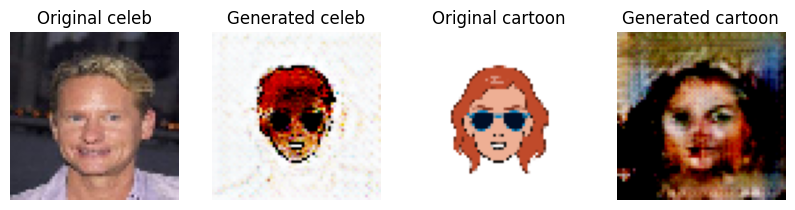

1/1 [==============================] - 0s 21ms/step


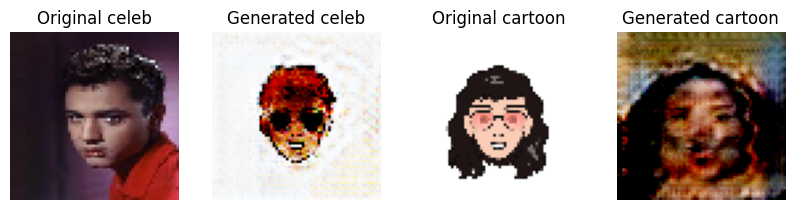

1/1 [==============================] - 0s 21ms/step


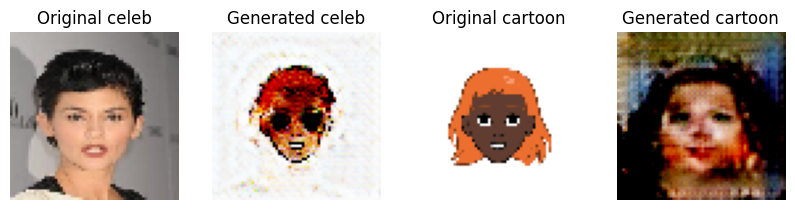

1/1 [==============================] - 0s 20ms/step


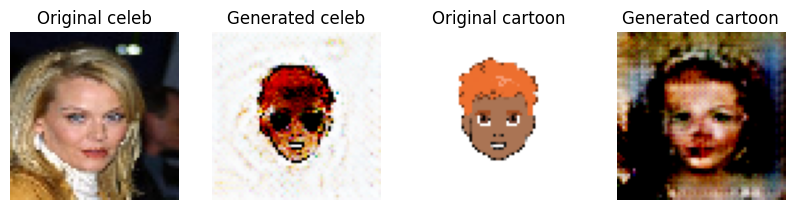

1/1 [==============================] - 0s 20ms/step


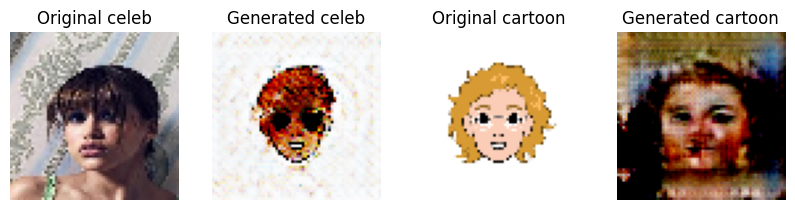

1/1 [==============================] - 0s 20ms/step


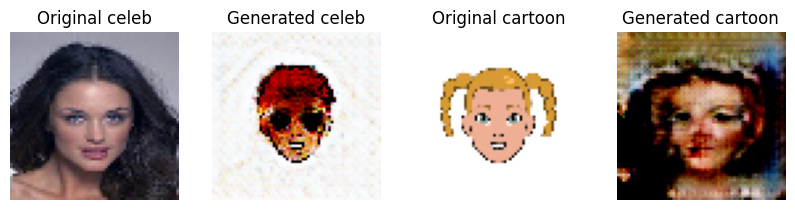

1/1 [==============================] - 0s 20ms/step


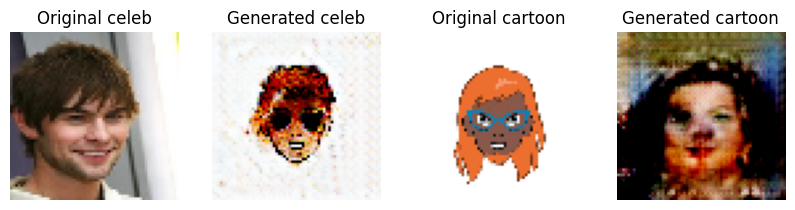

1/1 [==============================] - 0s 20ms/step


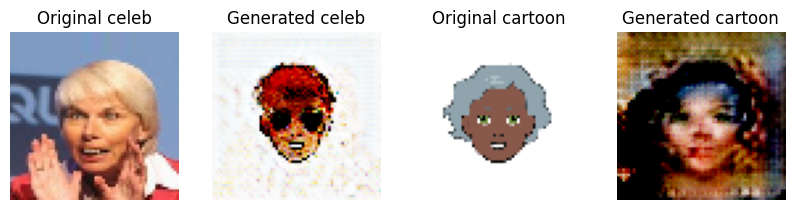

1/1 [==============================] - 0s 21ms/step


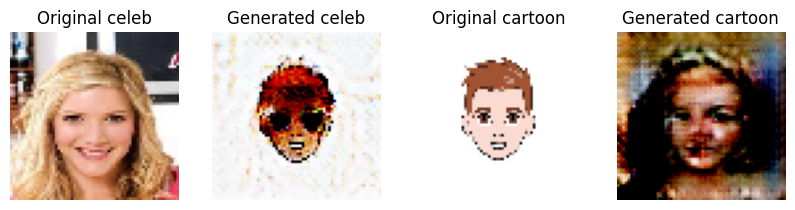

1/1 [==============================] - 0s 24ms/step


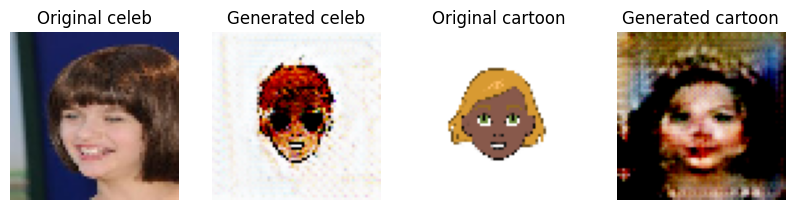

In [31]:
show_preds(CelebtoCartoon_gen,CartoontoCeleb_gen ,n_images=10)

## Conclusion
Although we were able to performed image translation celebrity to cartoon and cartoon to celebrity but results were okay.

We can get better results by improving the model in generator or discriminator.